In [1]:
import sys
print(sys.version)

3.8.16 (default, Dec  7 2022, 01:27:54) 
[Clang 14.0.0 (clang-1400.0.29.202)]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import pickle
import optuna
import sksurv
from sksurv.metrics import concordance_index_censored
import pycox
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
#import torchtuples as tt
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import DeepSurv.deepsurv as deepsurv

from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
from torch.utils.data import DataLoader, random_split
from torch.utils.data import TensorDataset, Subset

from flwr.common import Metrics

/Users/Matteo.Fordiani/Code/PythonWorkspace/federated-survival-analysis/federated-survival-tutorial/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data_path = "data_MDS/"

survs = pd.read_csv(data_path+'survivals_euromds.csv', index_col=0)
survs_val = pd.read_csv(data_path+'survivals_validation.csv', index_col=0)

df_complete = pd.read_csv(data_path+'df_complete.csv', index_col=0)
df_validation = pd.read_csv(data_path+'df_validation.csv', index_col=0)

In [6]:
#select type of event
event = 'OS' #OS, LFS
event_status, event_time = survs["Status"+event].to_numpy().astype('float32'), survs["Time"+event].to_numpy().astype('float32')
event_status = (event_status == 1)
y = event_time, event_status

#status_val, time_val = survs_val["Status"+event].to_numpy().astype('float32'), survs_val["Time"+event].to_numpy().astype('float32')
#status_val = (status_val == 1)
#y_val = time_val, status_val

In [7]:
cont_idx = [58,60,61,62,63]
bin_idx = list(np.arange(58))+[59]

cont_features = df_complete.columns[cont_idx]
bin_features = df_complete.columns[bin_idx]

scaler = StandardScaler()
X_cont = df_complete.iloc[:,cont_idx]
X_cont = scaler.fit_transform(X_cont)
X_bin = df_complete.iloc[:,bin_idx].values

#X_val_cont = df_validation.iloc[:,cont_idx]
#X_val_cont = scaler.transform(X_val_cont)
#X_val_bin = df_validation.iloc[:,bin_idx].values

X = np.hstack([X_cont, X_bin]).astype('float32')
#X_val = np.hstack([X_val_cont, X_val_bin]).astype('float32')

print(X.shape)#, X_val.shape)

(1945, 64)


In [8]:
torch.set_num_threads(30)

In [ ]:
N = len(X)
Ntrain=int(N*0.75)
Ntest = N-Ntrain
indices = torch.arange(N)

np.random.seed(0)
rand_perm = np.random.permutation(X.shape[0])
X_perm, event_status_perm, event_time_perm = X[rand_perm], event_status[rand_perm], event_time[rand_perm]

# Convert Numpy matrix to torch tensor
all_data = torch.utils.data.TensorDataset(torch.from_numpy(X_perm), torch.from_numpy(event_status_perm).float(),
                                          torch.from_numpy(event_time_perm).float(), indices)

train_data = torch.utils.data.Subset(all_data, indices[:Ntrain])
test_data = torch.utils.data.Subset(all_data, indices[Ntrain:])

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=Ntest, shuffle=False)


input_dim = all_data.tensors[0].shape[1]
output_dim = 1

# Define Adam optimizer
model = deepsurv.SurvNet([input_dim, 32, 10, output_dim],
                    activation='tanh',
                    dropout_p=0.1, batch_norm=[True,False,False])  

optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=0.001) 


model = model.fit(train_loader, test_loader, optimizer=optimizer,
                  num_epochs=60,
                  verbose=True
                 )


#Save the trained model
#torch.save(model, 'Train_split2/denoising_autoencoder'+str(i)+'.pt')

Train: Epoch [10/60], Loss: 4.1392
Test: Epoch [10/60], Loss: 5.1361 

Train: Epoch [20/60], Loss: 4.0196
Test: Epoch [20/60], Loss: 5.0261 

Train: Epoch [30/60], Loss: 3.8375
Test: Epoch [30/60], Loss: 4.9556 

Train: Epoch [40/60], Loss: 3.8602
Test: Epoch [40/60], Loss: 4.9178 

Train: Epoch [50/60], Loss: 3.8178
Test: Epoch [50/60], Loss: 4.8986 

Train: Epoch [60/60], Loss: 3.9236
Test: Epoch [60/60], Loss: 4.8888 



In [ ]:
risk_test = model(test_data[:][0]).detach().numpy()
risk_train = model(train_data[:][0]).detach().numpy()

print('CI test: ', concordance_index_censored(np.bool_(event_status_perm[Ntrain:]), event_time_perm[Ntrain:], risk_test.ravel())[0])
print('CI train: ', concordance_index_censored(np.bool_(event_status_perm[:Ntrain]), event_time_perm[:Ntrain], risk_train.ravel())[0])

CI test:  0.7859007049647517
CI train:  0.7741854544359654


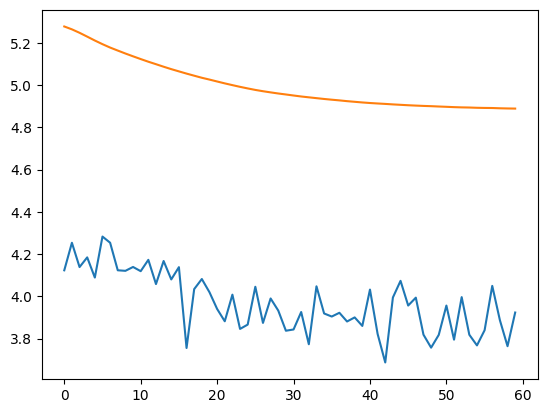

In [ ]:
plt.plot(model.train_history_['learn_curve_train'])
plt.plot(model.eval_history_['learn_curve_test'])

## Load and split MDS synth

In [2]:
scenario = []
path_1 = 'synthetic_data/Scenario_1.xlsx'
for i in range(1,4):
    print(i)
    scenario.append(pd.read_excel(path_1, sheet_name='Node_'+str(i)))
    
df_validation = pd.read_excel('synthetic_data/Validation.xlsx')
df_validation = df_validation.sample(frac=1, random_state=0)

1
2
3


In [3]:
def impute_df(df):
    df.isna().sum().sort_values(ascending=False)[:26]

    median_cols = set(['BMF','Comorbidity','RS'])
    mean_cols = set(['LDH', 'Ferritin', 'Platelets', 'Neutrophils', 'Hemoglobin', 'AOD'])
    zero_cols = set(df_validation.columns)-median_cols-mean_cols

    for c in df.columns:
        if c in median_cols:
            df[c].fillna(df[c].median(), inplace=True)
        elif c in mean_cols:
            df[c].fillna(df[c].mean(), inplace=True)
        elif c in zero_cols:
            df[c].fillna(0, inplace=True)
    
    return df

df_validation = impute_df(df_validation)

In [4]:
scenario_1 = [s.sample(300, random_state=1) for s in scenario]
scenario_1_central = pd.concat(scenario_1)

scenario_central = pd.concat(scenario)
scenario_real = np.array_split(df_validation, 3)

In [5]:
#Preprocessing
tensor_datasets = []
tensor_datasets_real = []

cont_idx = [58,61,62,63,64,65,66,69]
bin_idx = list(np.arange(58))+[59,60,67,68]
cont_features = df_validation.columns[cont_idx]
bin_features = df_validation.columns[bin_idx]

#centralized real validation
scaler = StandardScaler()
X_cont = df_validation.iloc[:,cont_idx]
X_cont = scaler.fit_transform(X_cont)
X_bin = df_validation.iloc[:,bin_idx].values
X = np.hstack([X_bin, X_cont]).astype('float32')
event_status, event_time = df_validation.iloc[:,-1].to_numpy().astype('float32'), df_validation.iloc[:,-2].to_numpy().astype('float32')
event_status = (event_status == 1)
y = event_time, event_status

N = len(X)
indices = torch.arange(N)
ds_real = TensorDataset(torch.tensor(X), torch.tensor(y[1]), torch.tensor(y[0]), indices)    

#scenario
for i in range(3):
    df = scenario[i] ### ----------------------> choose scenario/scenario_1
    df_val = scenario_real[i]
        
    scaler = StandardScaler()
    X_cont = df.iloc[:,cont_idx]
    X_cont_val = df_val.iloc[:,cont_idx]
    X_cont = scaler.fit_transform(X_cont)
    X_cont_val = scaler.transform(X_cont_val)
    X_bin = df.iloc[:,bin_idx].values
    X_bin_val = df_val.iloc[:,bin_idx].values
    
    X = np.hstack([X_bin, X_cont]).astype('float32')
    X_val = np.hstack([X_bin_val, X_cont_val]).astype('float32')
    print(X.shape)
    print(X_val.shape)
    
    event_status, event_time = df.iloc[:,-1].to_numpy().astype('float32'), df.iloc[:,-2].to_numpy().astype('float32')
    event_status = (event_status == 1)
    y = event_time, event_status
    
    event_status_val, event_time_val = df_val.iloc[:,-1].to_numpy().astype('float32'), df_val.iloc[:,-2].to_numpy().astype('float32')
    event_status_val = (event_status_val == 1)
    y_val = event_time_val, event_status_val
    
    N = len(X)
    indices = torch.arange(N)
    ds = TensorDataset(torch.tensor(X), torch.tensor(y[1]), torch.tensor(y[0]), indices)
    tensor_datasets.append(ds)
    
    N_val = len(X_val)
    indices_val = torch.arange(N_val)
    ds_val = TensorDataset(torch.tensor(X_val), torch.tensor(y_val[1]), torch.tensor(y_val[0]), indices_val)
    tensor_datasets_real.append(ds_val)

(2000, 70)
(681, 70)
(2000, 70)
(681, 70)
(2000, 70)
(681, 70)


In [6]:
# Split each partition into train/val
train_datasets = []
val_datasets = []
complete_datasets = []

for ds in tensor_datasets:
    len_val = len(ds) // 4  # % validation set
    len_train = len(ds) - len_val
    lengths = [len_train, len_val]
    print(lengths)
        
    perm = torch.randperm(len_val+len_train, generator=torch.Generator().manual_seed(42))
    
    ds_train = TensorDataset(ds[perm][0][:len_train], ds[perm][1][:len_train], ds[perm][2][:len_train], ds[perm][3][:len_train])
    ds_val = TensorDataset(ds[perm][0][len_train:], ds[perm][1][len_train:], ds[perm][2][len_train:], ds[perm][3][len_train:])
    
    ds_complete = TensorDataset(ds[perm][0], ds[perm][1], ds[perm][2], ds[perm][3]) ### simple permutation
    
    train_datasets.append(ds_train)
    val_datasets.append(ds_val)
    complete_datasets.append(ds_complete)

[1500, 500]
[1500, 500]
[1500, 500]


In [7]:
# Centralized case

X_train_central = torch.concat([train_datasets[i][:][0] for i in range(len(train_datasets))])
X_test_central = torch.concat([val_datasets[i][:][0] for i in range(len(val_datasets))])
X_complete_central = torch.concat([complete_datasets[i][:][0] for i in range(len(complete_datasets))])

event_train_central = torch.concat([train_datasets[i][:][1] for i in range(len(train_datasets))])
event_test_central = torch.concat([val_datasets[i][:][1] for i in range(len(val_datasets))])
event_complete_central = torch.concat([complete_datasets[i][:][1] for i in range(len(complete_datasets))])

time_train_central = torch.concat([train_datasets[i][:][2] for i in range(len(train_datasets))])
time_test_central = torch.concat([val_datasets[i][:][2] for i in range(len(val_datasets))])
time_complete_central = torch.concat([complete_datasets[i][:][2] for i in range(len(complete_datasets))])

Ncomplete = len(X_complete_central)
Ntrain = len(X_train_central)
Ntest = len(X_test_central)

indices_train = torch.arange(Ntrain)
indices_test = torch.arange(Ntest)
indices_complete = torch.arange(Ncomplete)

ds_train_central = TensorDataset(X_train_central, event_train_central, time_train_central, indices_train)
ds_test_central = TensorDataset(X_test_central, event_test_central, time_test_central, indices_test)
ds_complete_central = TensorDataset(X_complete_central, event_complete_central, time_complete_central, indices_complete)

### optuna

In [9]:
def deepsurv_objective(trial, train_data, model='deep', seed=None):
    ''' train_data : TensorDataset'''
    print('MODEL:', model)
    
    try:    
        CI_val_list = []
        kf = KFold(n_splits=5, shuffle=True, random_state=seed)
        j=0

        for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
                        
            x_tr = TensorDataset(train_data[train_idx][0], train_data[train_idx][1],
                                    train_data[train_idx][2], train_data[train_idx][3])
    
            x_val = TensorDataset(train_data[val_idx][0], train_data[val_idx][1],
                                     train_data[val_idx][2], train_data[val_idx][3])

        
            j+=1
            
            print(len(x_tr))
            print(len(x_val))
            
            if model == 'deep':
            ### NON-LINEAR
                params = {'lr' : trial.suggest_float('lr', 0.0001,0.001, step=0.0001),
                       'activation' : trial.suggest_categorical('activation',['tanh']),
                       'weight_decay' : trial.suggest_float('weight_decay',0.0000, 0.005, step=0.0005),
                       'dropout' : trial.suggest_float('dropout', 0.1, 0.3, step=0.1),
                       'batch_norm' : trial.suggest_categorical('batch_norm', [True,False,(True,True,False),(True,False,False)]),   
                       'epochs' : trial.suggest_int('epochs', 40,150, step=10)
                      }
            elif model == 'linear':
                ### LINEAR
                params = {'lr' : trial.suggest_float('lr', 0.0001,0.001, step=0.0001),
                       'activation' : trial.suggest_categorical('activation',['linear']),
                       'weight_decay' : trial.suggest_float('weight_decay',0.0000, 0.01, step=0.0005),
                       'dropout' : trial.suggest_categorical('dropout', [0.0]),
                       'batch_norm' : trial.suggest_categorical('batch_norm', [False]),   
                       'epochs' : trial.suggest_int('epochs', 50,150, step=10)
                      }
            


            # Define the train and test data loaders
            tr_loader = DataLoader(x_tr, batch_size=256, shuffle=True)
            val_loader = DataLoader(x_val, batch_size=len(x_val), shuffle=False)

            input_dim = tr_loader.dataset.tensors[0].shape[1]
            output_dim = 1

            net = deepsurv.SurvNet([input_dim, output_dim],  ######## 32,10
                      activation=params['activation'], dropout_p=params['dropout'],
                      batch_norm=params['batch_norm'])

            optimizer = optim.Adam(net.parameters(), lr=params['lr'], weight_decay=params['weight_decay']) 
            model = net.fit(tr_loader, val_loader, optimizer=optimizer,
                              num_epochs=params['epochs'],
                              verbose=False
                             )
            
            model.eval()
            risk_tr = model(tr_loader.dataset[:][0]).detach().numpy()
            risk_val = model(val_loader.dataset[:][0]).detach().numpy()
            
            status_test, time_test = val_loader.dataset[:][1].detach().numpy(), val_loader.dataset[:][2].detach().numpy()
            status_train, time_train = tr_loader.dataset[:][1].detach().numpy(), tr_loader.dataset[:][2].detach().numpy()

            CI_val = concordance_index_censored(status_test, time_test, risk_val.ravel())[0]
            CI_tr = concordance_index_censored(status_train, time_train, risk_tr.ravel())[0]

            CI_val_list.append(CI_val)
            
            # Report intermediate objective value.
            #intermediate_value = CI_val
            #trial.report(intermediate_value, j)

            # Handle pruning based on the intermediate value.
            #if trial.should_prune():
            #    raise optuna.TrialPruned()

        return np.mean(CI_val)
    
    
    except Exception as e:
        if "NaN" in str(e):
            # If a NaN error occurs, you can simply return a high value
            # to indicate that this trial is not a good candidate
            return 0
        else:
            # For other types of exceptions, you can re-raise the exception
            # to stop the trial and let Optuna handle it
            raise e

## Centralized DeepSurv synth

In [1]:
path = 'scenario1/deep/'

In [4]:
print(path)
with open(path+'metrics_centralized.pickle', 'rb') as f:
    metrics_centralized = pickle.load(f)

scenario1/deep/


In [21]:
#metrics_centralized = {}

input_dim = X_train_central.shape[1]
output_dim = 1

# CV optuna
#func = lambda trial: deepsurv_objective(trial, ds_complete_central, model='deep', seed=0)

#study_model = optuna.create_study(direction='maximize')#pruner=optuna.pruners.HyperbandPruner())
#study_model.optimize(func, n_trials=100, n_jobs=1)

#print(study_model.best_params, '\nc-index:', study_model.best_value)
#study_model.best_params['score'] = study_model.best_value

for k in range(5):
    torch.manual_seed(k)

    best_params = metrics_centralized['best_params'] #study_model.best_params

    net_central = deepsurv.SurvNet([input_dim, 32,10, output_dim], ### 32,10 ------> deep/linear
                          activation=best_params['activation'], dropout_p=best_params['dropout'],
                          batch_norm=best_params['batch_norm'])


    completeloader_central = DataLoader(ds_complete_central, batch_size=256, shuffle=True)
    trainloader_central = DataLoader(ds_train_central, batch_size=256, shuffle=True)
    valloader_central = DataLoader(ds_test_central, batch_size=256, shuffle=False)
    realloader = DataLoader(ds_real, batch_size=256, shuffle=False)

    optimizer = optim.Adam(net_central.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay']) 
    model_central = net_central.fit(completeloader_central, test_loader=realloader, optimizer=optimizer,
                      num_epochs=best_params['epochs'],
                      verbose=True)

    #Save the trained model
    #torch.save(model_central, path+'centralized_model.pt')

    model_central.eval()
    risk_test = model_central(valloader_central.dataset[:][0]).detach().numpy()
    risk_train = model_central(trainloader_central.dataset[:][0]).detach().numpy()
    risk_complete = model_central(completeloader_central.dataset[:][0]).detach().numpy()
    risk_real = model_central(realloader.dataset[:][0]).detach().numpy()


    status_test, time_test = valloader_central.dataset[:][1].detach().numpy(), valloader_central.dataset[:][2].detach().numpy()
    status_train, time_train = trainloader_central.dataset[:][1].detach().numpy(), trainloader_central.dataset[:][2].detach().numpy()
    status_complete, time_complete = completeloader_central.dataset[:][1].detach().numpy(), completeloader_central.dataset[:][2].detach().numpy()
    status_real, time_real = realloader.dataset[:][1].detach().numpy(), realloader.dataset[:][2].detach().numpy()

    CI_test = concordance_index_censored(status_test, time_test, risk_test.ravel())[0]
    CI_train = concordance_index_censored(status_train, time_train, risk_train.ravel())[0]
    CI_complete = concordance_index_censored(status_complete, time_complete, risk_complete.ravel())[0]
    CI_real = concordance_index_censored(status_real, time_real, risk_real.ravel())[0]

    metrics_centralized['cindex_test'] = CI_test
    metrics_centralized['cindex_train'] = CI_train
    metrics_centralized['cindex_real'] = CI_real
    metrics_centralized['best_params'] = best_params


    #print('CI test: ', CI_test)
    #print('CI train: ', CI_train)
    print('CI complete synth: ', CI_train)
    print('CI real: ', CI_real)

    with open(path+f"trial{k}/metrics_centralized.pickle", "wb") as file:
        pickle.dump(metrics_centralized, file)

Train: Epoch [10/80], Loss: 3.5873
Test: Epoch [10/80], Loss: 4.3863 

Train: Epoch [20/80], Loss: 3.5287
Test: Epoch [20/80], Loss: 4.3699 

Train: Epoch [30/80], Loss: 3.7041
Test: Epoch [30/80], Loss: 4.3657 

Train: Epoch [40/80], Loss: 3.3624
Test: Epoch [40/80], Loss: 4.3642 

Train: Epoch [50/80], Loss: 3.2784
Test: Epoch [50/80], Loss: 4.3684 

Train: Epoch [60/80], Loss: 3.5641
Test: Epoch [60/80], Loss: 4.3672 

Train: Epoch [70/80], Loss: 3.6011
Test: Epoch [70/80], Loss: 4.3670 

Train: Epoch [80/80], Loss: 3.5228
Test: Epoch [80/80], Loss: 4.3653 

CI complete synth:  0.7246594725687762
CI real:  0.7225542682191293
Train: Epoch [10/80], Loss: 3.5440
Test: Epoch [10/80], Loss: 4.4093 

Train: Epoch [20/80], Loss: 3.3174
Test: Epoch [20/80], Loss: 4.3688 

Train: Epoch [30/80], Loss: 3.5694
Test: Epoch [30/80], Loss: 4.3676 

Train: Epoch [40/80], Loss: 3.6220
Test: Epoch [40/80], Loss: 4.3652 

Train: Epoch [50/80], Loss: 3.9240
Test: Epoch [50/80], Loss: 4.3691 

Train: Ep

In [34]:
metrics_centralized['cindex_real']

0.7168172601370564

In [35]:
print(best_params)
print('CI test: ', CI_test)
print('CI train: ', CI_train)

{'lr': 0.0001, 'activation': 'tanh', 'weight_decay': 0.005, 'dropout': 0.2, 'batch_norm': True, 'epochs': 90}
CI test:  0.7229564080412805
CI train:  0.7221494079954989


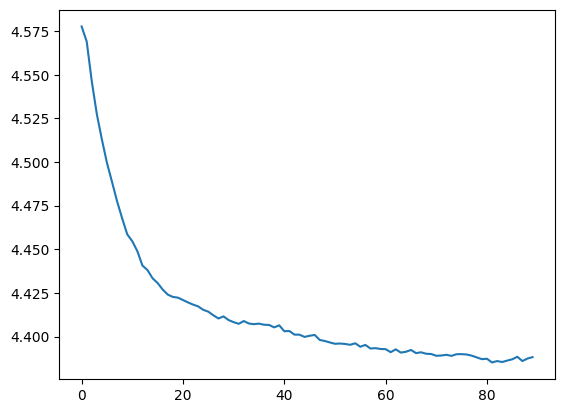

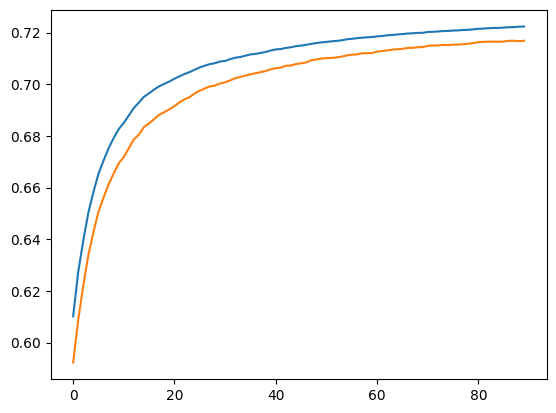

In [36]:
#plt.plot(model_central.train_history_['learn_curve_train'])
plt.plot(model_central.eval_history_['learn_curve_test'])
plt.show()

plt.plot(model_central.train_history_['cindex_train'])
plt.plot(model_central.eval_history_['cindex_test'])
plt.show()

## Isolated DeepSurv synth

In [23]:
print(path)
#metrics_isolated = {}
with open(path+'metrics_isolated.pickle', 'rb') as f:
    metrics_isolated = pickle.load(f)

input_dim = X.shape[1]
output_dim = 1

train_histories = []
test_histories = []

for k in range(5):
    torch.manual_seed(k)

    for i in range(len(train_datasets)):
        #metrics_isolated[i] = {} 

        train_data = train_datasets[i]
        test_data = val_datasets[i]
        complete_data = complete_datasets[i]
        real_data = ds_real

        # CV optuna
        #func = lambda trial: deepsurv_objective(trial, complete_data, seed=0)

        #study_model = optuna.create_study(direction='maximize',)# pruner=optuna.pruners.HyperbandPruner())
        #study_model.optimize(func, n_trials=10, n_jobs=1)

        #print(study_model.best_params, '\nc-index:', study_model.best_value)
        #study_model.best_params['score'] = study_model.best_value

        best_params = metrics_isolated[i]['best_params']# study_model.best_params 


        model = deepsurv.SurvNet([input_dim, 32,10, output_dim], ### ---------> 32,10 deep/linear
                              activation=best_params['activation'], dropout_p=best_params['dropout'],
                              batch_norm=best_params['batch_norm'])

        tr_loader = DataLoader(train_data, batch_size=256, shuffle=True)
        val_loader = DataLoader(test_data, batch_size=256, shuffle=False)

        completeloader_client = DataLoader(complete_data, batch_size=256, shuffle=True)
        realloader = DataLoader(real_data, batch_size=256, shuffle=False)


        optimizer = optim.Adam(model.parameters(), lr=best_params['lr'],
                               weight_decay=best_params['weight_decay']) 
        model = model.fit(completeloader_client, realloader, optimizer=optimizer,
                          num_epochs=best_params['epochs'],
                          verbose=True
                         )

        train_histories.append(model.train_history_)
        test_histories.append(model.eval_history_)


        #Save the trained model
        torch.save(model, path+f'trial{k}/isolated_model'+str(i)+'.pt')

        model.eval()
        risk_test = model(test_data[:][0]).detach().numpy()
        risk_train = model(train_data[:][0]).detach().numpy()
        risk_complete = model(complete_data[:][0]).detach().numpy()
        risk_real = model(real_data[:][0]).detach().numpy()
        print(len(risk_test), len(risk_train))
        print(len(risk_complete), len(risk_real))

        status_test, time_test = test_data[:][1].detach().numpy(), test_data[:][2].detach().numpy()
        status_train, time_train = train_data[:][1].detach().numpy(), train_data[:][2].detach().numpy()

        status_complete, time_complete = complete_data[:][1].detach().numpy(), complete_data[:][2].detach().numpy()
        status_real, time_real = real_data[:][1].detach().numpy(), real_data[:][2].detach().numpy()

        print('Node' +str(i))
        #CI_test = concordance_index_censored(status_test, time_test, risk_test.ravel())[0]
        #CI_train = concordance_index_censored(status_train, time_train, risk_train.ravel())[0]
        CI_complete = concordance_index_censored(status_complete, time_complete, risk_complete.ravel())[0]
        CI_real = concordance_index_censored(status_real, time_real, risk_real.ravel())[0]

        #metrics_isolated[i]['cindex_test'] = CI_test
        #metrics_isolated[i]['cindex_train'] = CI_train
        metrics_isolated[i]['cindex_complete'] = CI_complete
        metrics_isolated[i]['cindex_real'] = CI_real
        metrics_isolated[i]['best_params'] = best_params

        print('Best_params:', best_params)
        #print('CI test: ', CI_test)
        #print('CI train: ', CI_train)
        print('CI complete: ', CI_complete)
        print('CI real: ', CI_real)


        metrics_isolated[i]['train_hisories'] = train_histories[i]
        metrics_isolated[i]['test_hisories'] = test_histories[i]

    with open(path+f"trial{k}/metrics_isolated.pickle", "wb") as file:
        pickle.dump(metrics_isolated, file)

scenario1/linear/
Train: Epoch [10/140], Loss: 4.3877
Test: Epoch [10/140], Loss: 4.5959 

Train: Epoch [20/140], Loss: 4.3705
Test: Epoch [20/140], Loss: 4.5676 

Train: Epoch [30/140], Loss: 4.4345
Test: Epoch [30/140], Loss: 4.5399 

Train: Epoch [40/140], Loss: 4.2731
Test: Epoch [40/140], Loss: 4.5138 

Train: Epoch [50/140], Loss: 4.4279
Test: Epoch [50/140], Loss: 4.4903 

Train: Epoch [60/140], Loss: 4.2886
Test: Epoch [60/140], Loss: 4.4708 

Train: Epoch [70/140], Loss: 4.1567
Test: Epoch [70/140], Loss: 4.4551 

Train: Epoch [80/140], Loss: 4.3400
Test: Epoch [80/140], Loss: 4.4433 

Train: Epoch [90/140], Loss: 4.1407
Test: Epoch [90/140], Loss: 4.4353 

Train: Epoch [100/140], Loss: 4.2735
Test: Epoch [100/140], Loss: 4.4301 

Train: Epoch [110/140], Loss: 4.2145
Test: Epoch [110/140], Loss: 4.4274 

Train: Epoch [120/140], Loss: 4.0933
Test: Epoch [120/140], Loss: 4.4261 

Train: Epoch [130/140], Loss: 4.1839
Test: Epoch [130/140], Loss: 4.4258 

Train: Epoch [140/140], L

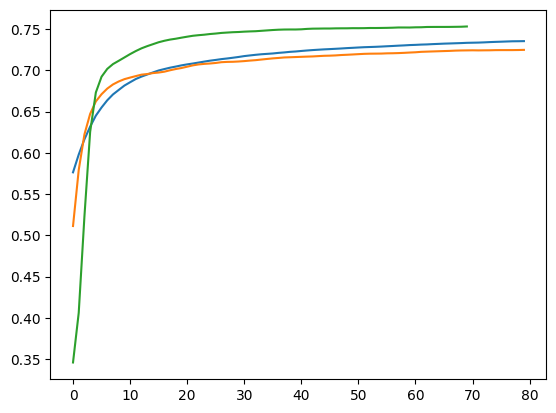

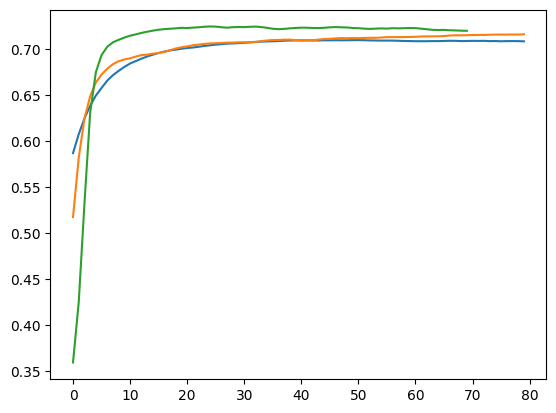

In [27]:
for i in range(3):
    plt.plot(train_histories[i]['cindex_train'])
plt.show()
for i in range(3):
    plt.plot(test_histories[i]['cindex_test'])
plt.show()

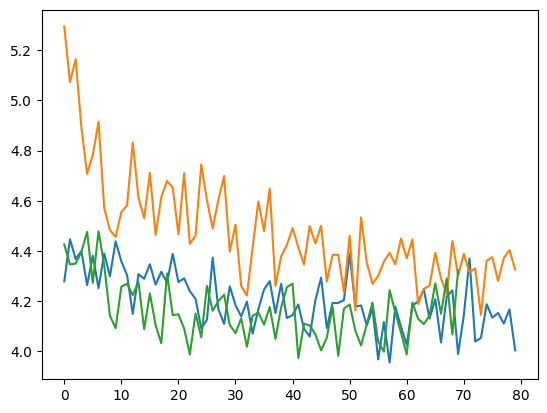

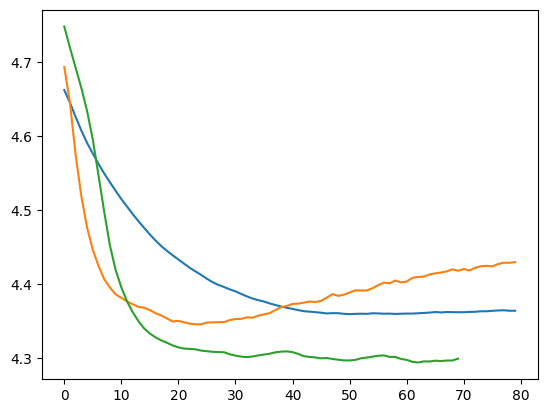

In [28]:
for i in range(3):
    plt.plot(train_histories[i]['learn_curve_train'])
plt.show()
for i in range(3):
    plt.plot(test_histories[i]['learn_curve_test'])
plt.show()

# Federated - Flower

In [8]:
import flwr as fl
DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 1.13.1+cu117 and Flower 1.3.0


## Federated learning

In [5]:
path = "scenario1/deep/"
print(path)
with open(path+'metrics_centralized.pickle', 'rb') as f:
    metrics_centralized = pickle.load(f)
metrics_centralized['best_params']

scenario1/deep/


{'lr': 0.0001,
 'activation': 'tanh',
 'weight_decay': 0.005,
 'dropout': 0.2,
 'batch_norm': True,
 'epochs': 90}

In [10]:
fed_params = metrics_centralized['best_params']

In [11]:
NUM_CLIENTS = 3
#trainloaders = [DataLoader(train_datasets[i], batch_size=128, shuffle=True) for i in range(len(train_datasets))]
#valloaders = [DataLoader(val_datasets[i], batch_size=128, shuffle=False) for i in range(len(val_datasets))]

completeloaders = [DataLoader(complete_datasets[i], batch_size=256, shuffle=True) for i in range(NUM_CLIENTS)]
#realloaders = [DataLoader(tensor_datasets_real[i], batch_size=256, shuffle=False) for i in range(NUM_CLIENTS)]
realloader = DataLoader(ds_real, batch_size=256, shuffle=False)

In [12]:
def get_parameters(net) -> List[np.ndarray]:
    #return [val.cpu().numpy() for name, val in net.state_dict().items() if 'bn' not in name]
    return [val.cpu().numpy() for name, val in net.state_dict().items() if ('running' not in name) and ('batch' not in name)]

def set_parameters(net, parameters: List[np.ndarray]):
    
    keys = [k for k in net.state_dict().keys() if ('running' not in k) and ('batch' not in k)]
    params_dict = zip(keys, parameters)
    
    #params_dict = zip(net.state_dict().keys(), parameters)
    
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=False)


def train(net, trainloader, test_loader, cid, epochs : int):
    """Train the network on the training set."""
        
    optimizer = optim.Adam(net.parameters(), lr=fed_params['lr'], weight_decay=fed_params['weight_decay'])  # 0.0002, 0.001
    net.fit(train_loader=trainloader, test_loader=test_loader, optimizer=optimizer, num_epochs=epochs, verbose=True)
    
    risk_train = net(trainloader.dataset[:][0]).detach().numpy()
    cindex_train = concordance_index_censored(trainloader.dataset[:][1], 
                                              trainloader.dataset[:][2],
                                              risk_train.ravel())[0]
    
    loss_real_val = net.eval_history_['learn_curve_test'][-1]
    cindex_real_val = net.eval_history_['cindex_test'][-1]
    
    filename = path+f"{e}_epochs/trial{k}/metrics_clients{cid}_preaggr.txt"
    f = open(filename, "a")
    f.write("{}, {}, {} \n ".format(cid, loss_real_val, cindex_real_val))
    f.close()
    
    print('C-index train:', cindex_train)
    print('C-index real val:', cindex_real_val)


def test(net, testloader):
    """Evaluate the network on the entire test set."""
   
    net.eval()
    with torch.no_grad():
        for x,event,time,idx in testloader:
            # Forward pass
            risk = net.forward(x)
            loss_test = net.compute_loss(risk, time, event)
    risk_test = net(testloader.dataset[:][0]).detach().numpy()
    cindex_test = concordance_index_censored(testloader.dataset[:][1], 
                                              testloader.dataset[:][2],
                                              risk_test.ravel())[0]
    print('C-index test :', cindex_test)
    return loss_test, cindex_test

In [13]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        
    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        #print(parameters)
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, self.valloader, self.cid, epochs=e)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, cindex = test(self.net, self.valloader)
        
        #save metrics
        filename = path+f"{e}_epochs/trial{k}/metrics_clients{self.cid}.txt"  
        f = open(filename, "a")
        f.write("{}, {}, {} \n ".format(self.cid, loss.item(), cindex))
        f.close()
        
        return float(loss), len(self.valloader), {"C-index": float(cindex)}


def client_fn(cid) -> FlowerClient:
    net = deepsurv.SurvNet([input_dim, 32,10, output_dim], ### 32,10 --------> Change for linear/deep model
                    activation=fed_params['activation'], dropout_p=fed_params['dropout'], batch_norm=fed_params['batch_norm']).to(DEVICE)
    trainloader = completeloaders[int(cid)] #trainloaders[int(cid)]
    valloader = realloader #realloaders[int(cid)] #valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

In [14]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply cindex of each client by number of examples used
    cindex = [num_examples * m["C-index"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"C-Index": sum(cindex) / sum(examples)}

In [15]:
# The `evaluate` function will be called by Flower after every round
def evaluate(
    tot_rounds : int,
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    
    net = deepsurv.SurvNet([input_dim, 32,10, output_dim], #32,10 --------> Change for linear/deep model
                            activation=fed_params['activation'], dropout_p=fed_params['dropout'],
                            batch_norm=fed_params['batch_norm']).to(DEVICE)
    
    ### Da usare quando ho valloaders
    #merged_val = tuple([torch.concat([realloaders[i].dataset[:][j] for i in range(3)]) for j in range(4)])
    #merged_td = TensorDataset(merged_val[0], merged_val[1], merged_val[2], merged_val[3])
    #valloader = DataLoader(merged_td, batch_size=256, shuffle=False)
    
    set_parameters(net, parameters) # Update model with the latest parameters
    
    if server_round == tot_rounds:
        print('Saving model')
        torch.save(net, path+f"{e}_epochs/trial{k}/model")
    
    loss, cindex = test(net, realloader) #valloader
    print(f"Server-side evaluation loss {loss} / C-Index {cindex}")
    return loss, {"C-Index": cindex}

In [16]:
from functools import partial

NUM_CLIENTS=3
input_dim = X.shape[1]
output_dim=1
rounds = 100

for e in [2,10,20]:
    for k in range(5):
        torch.manual_seed(k)

        # Create an instance of the model and get the parameters
        surv_net = deepsurv.SurvNet([input_dim, 32,10, output_dim], #32,10 ----------> Change for linear/deep model
                            activation=fed_params['activation'], dropout_p=fed_params['dropout'],
                            batch_norm=fed_params['batch_norm'])  #0.1, tanh, [True,False,False]

        params = get_parameters(surv_net)


        # Pass parameters to the Strategy for server-side parameter initialization
        strategy = fl.server.strategy.FedAvg(
            fraction_fit=1.,
            fraction_evaluate=1.,
            min_fit_clients=3,
            min_evaluate_clients=3,
            min_available_clients=NUM_CLIENTS,
            evaluate_metrics_aggregation_fn=weighted_average,
            evaluate_fn=partial(evaluate, rounds), #lambda *x: evaluate(rounds, *x),
            initial_parameters=fl.common.ndarrays_to_parameters(params)
        )

        # Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
        client_resources = None
        if DEVICE.type == "cuda":
            client_resources = {"num_gpus": 1}

        # Start simulation
        history = fl.simulation.start_simulation(
                    client_fn=client_fn,
                    num_clients=NUM_CLIENTS,
                    config=fl.server.ServerConfig(num_rounds=rounds),
                    strategy=strategy,
                    client_resources=client_resources,
        )

INFO flwr 2023-04-12 12:01:56,745 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
2023-04-12 12:01:59,684	WARNING services.py:1732 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-04-12 12:01:59,883	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-12 12:02:01,390 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 10000000000.0, 'node:192.168.0.52': 1.0, 'memory': 180399175680.0, 'CPU': 32.0}
INFO flwr 2023-04-12 12:02:01,391 | server.py:86 | Initi

C-index test : 0.5525578870577693
Server-side evaluation loss 4.626686096191406 / C-Index 0.5525578870577693
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:05,051 | server.py:229 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-12 12:02:05,057 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) C-index train: 0.5891629210282896
(launch_and_fit pid=211959) C-index real val: 0.5931865310272332
(launch_and_fit pid=211960) C-index train: 0.5968121830259394
(launch_and_fit pid=211960) C-index real val: 0.593404810183297


INFO flwr 2023-04-12 12:02:05,165 | server.py:116 | fit progress: (1, tensor(4.5940), {'C-Index': 0.5930414902722171}, 3.6864143200218678)
DEBUG flwr 2023-04-12 12:02:05,167 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.6058986098859965
(launch_and_fit pid=211966) C-index real val: 0.5921123678118664
C-index test : 0.5930414902722171
Server-side evaluation loss 4.594013214111328 / C-Index 0.5930414902722171


DEBUG flwr 2023-04-12 12:02:05,392 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:05,393 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.5930414902722171
(launch_and_evaluate pid=211959) C-index test : 0.5930414902722171
(launch_and_evaluate pid=211960) C-index test : 0.5930414902722171
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:05,822 | server.py:229 | fit_round 2 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:05,936 | server.py:116 | fit progress: (2, tensor(4.5637), {'C-Index': 0.625279311156937}, 4.457342743873596)
DEBUG flwr 2023-04-12 12:02:05,938 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.6161437240099715
(launch_and_fit pid=211966) C-index real val: 0.6245928806529993
(launch_and_fit pid=211959) C-index train: 0.6244757215563402
(launch_and_fit pid=211959) C-index real val: 0.6250538517654762
(launch_and_fit pid=211960) C-index train: 0.6345929809718387
(launch_and_fit pid=211960) C-index real val: 0.6257474625048107
C-index test : 0.625279311156937
Server-side evaluation loss 4.5637102127075195 / C-Index 0.625279311156937


DEBUG flwr 2023-04-12 12:02:06,143 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:06,145 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.625279311156937
(launch_and_evaluate pid=211959) C-index test : 0.625279311156937
(launch_and_evaluate pid=211960) C-index test : 0.625279311156937
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:06,563 | server.py:229 | fit_round 3 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:06,682 | server.py:116 | fit progress: (3, tensor(4.5354), {'C-Index': 0.6486739541269121}, 5.202622331678867)
DEBUG flwr 2023-04-12 12:02:06,683 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.636787910516993
(launch_and_fit pid=211966) C-index real val: 0.6480478376003079
(launch_and_fit pid=211959) C-index train: 0.6449380430083668
(launch_and_fit pid=211959) C-index real val: 0.6487802216107853
(launch_and_fit pid=211960) C-index train: 0.6547307513181195
(launch_and_fit pid=211960) C-index real val: 0.6490114251905634
C-index test : 0.6486739541269121
Server-side evaluation loss 4.535421371459961 / C-Index 0.6486739541269121


DEBUG flwr 2023-04-12 12:02:06,879 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:06,880 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.6486739541269121
(launch_and_evaluate pid=211959) C-index test : 0.6486739541269121
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.6486739541269121
(launch_and_fit pid=211960) [Client 0] fit, config: {}
(launch_and_fit pid=211966) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:07,306 | server.py:229 | fit_round 4 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:07,423 | server.py:116 | fit progress: (4, tensor(4.5085), {'C-Index': 0.6658964667497659}, 5.944114688783884)
DEBUG flwr 2023-04-12 12:02:07,425 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.6695526734039444
(launch_and_fit pid=211966) C-index real val: 0.6667968682685294
(launch_and_fit pid=211959) C-index train: 0.6592843670975664
(launch_and_fit pid=211959) C-index real val: 0.6652617339406856
(launch_and_fit pid=211960) C-index train: 0.6525216261450532
(launch_and_fit pid=211960) C-index real val: 0.6652732223173204
C-index test : 0.6658964667497659
Server-side evaluation loss 4.508512496948242 / C-Index 0.6658964667497659


DEBUG flwr 2023-04-12 12:02:07,604 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:07,606 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.6658964667497659
(launch_and_evaluate pid=211959) C-index test : 0.6658964667497659
(launch_and_evaluate pid=211960) C-index test : 0.6658964667497659
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:08,062 | server.py:229 | fit_round 5 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:08,171 | server.py:116 | fit progress: (5, tensor(4.4841), {'C-Index': 0.6789644951720097}, 6.691749412566423)
DEBUG flwr 2023-04-12 12:02:08,172 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.6809903878360688
(launch_and_fit pid=211966) C-index real val: 0.680028606057821
(launch_and_fit pid=211959) C-index train: 0.6640047090608733
(launch_and_fit pid=211959) C-index real val: 0.6781358960072147
(launch_and_fit pid=211960) C-index train: 0.6701072339904587
(launch_and_fit pid=211960) C-index real val: 0.6783857681990246
C-index test : 0.6789644951720097
Server-side evaluation loss 4.484074115753174 / C-Index 0.6789644951720097


DEBUG flwr 2023-04-12 12:02:08,369 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:08,370 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.6789644951720097
(launch_and_evaluate pid=211959) C-index test : 0.6789644951720097
(launch_and_evaluate pid=211960) C-index test : 0.6789644951720097
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:08,773 | server.py:229 | fit_round 6 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:08,889 | server.py:116 | fit progress: (6, tensor(4.4630), {'C-Index': 0.6885716501329779}, 7.41031052544713)
DEBUG flwr 2023-04-12 12:02:08,891 | server.py:165 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.6729128633856954
(launch_and_fit pid=211966) C-index real val: 0.6877373067798654
(launch_and_fit pid=211959) C-index train: 0.6905651866985694
(launch_and_fit pid=211959) C-index real val: 0.6894964644520906
(launch_and_fit pid=211960) C-index train: 0.6783668909794139
(launch_and_fit pid=211960) C-index real val: 0.6882183825514535
C-index test : 0.6885716501329779
Server-side evaluation loss 4.462998867034912 / C-Index 0.6885716501329779


DEBUG flwr 2023-04-12 12:02:09,088 | server.py:179 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:09,090 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.6885716501329779
(launch_and_evaluate pid=211959) C-index test : 0.6885716501329779
(launch_and_evaluate pid=211960) C-index test : 0.6885716501329779
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:09,587 | server.py:229 | fit_round 7 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:09,660 | server.py:116 | fit progress: (7, tensor(4.4457), {'C-Index': 0.6955608912682594}, 8.18144115805626)
DEBUG flwr 2023-04-12 12:02:09,662 | server.py:165 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.683780237269072
(launch_and_fit pid=211966) C-index real val: 0.6953555365359098
(launch_and_fit pid=211959) C-index train: 0.6978740610358398
(launch_and_fit pid=211959) C-index real val: 0.696122385676292
(launch_and_fit pid=211960) C-index train: 0.6809434939821132
(launch_and_fit pid=211960) C-index real val: 0.6949189782237821
C-index test : 0.6955608912682594
Server-side evaluation loss 4.445688724517822 / C-Index 0.6955608912682594


DEBUG flwr 2023-04-12 12:02:09,843 | server.py:179 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:09,845 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.6955608912682594
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_evaluate pid=211959) C-index test : 0.6955608912682594
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.6955608912682594
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:10,379 | server.py:229 | fit_round 8 received 3 results and 0 failures


(launch_and_fit pid=211966) C-index train: 0.6863618978383349
(launch_and_fit pid=211966) C-index real val: 0.6999652476606794
(launch_and_fit pid=211960) C-index train: 0.7036002578189743
(launch_and_fit pid=211960) C-index real val: 0.7016971204383965


INFO flwr 2023-04-12 12:02:10,464 | server.py:116 | fit progress: (8, tensor(4.4326), {'C-Index': 0.7008800096502363}, 8.984776623547077)
DEBUG flwr 2023-04-12 12:02:10,465 | server.py:165 | evaluate_round 8: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:02:10,645 | server.py:179 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:10,647 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 3)


C-index test : 0.7008800096502363
Server-side evaluation loss 4.4326491355896 / C-Index 0.7008800096502363
(launch_and_fit pid=211959) C-index train: 0.6887676571368818
(launch_and_fit pid=211959) C-index real val: 0.7008426724261728
(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7008800096502363
(launch_and_evaluate pid=211959) C-index test : 0.7008800096502363
(launch_and_evaluate pid=211960) C-index test : 0.7008800096502363
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:11,074 | server.py:229 | fit_round 9 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:11,197 | server.py:116 | fit progress: (9, tensor(4.4225), {'C-Index': 0.7052269241594816}, 9.718055978417397)
DEBUG flwr 2023-04-12 12:02:11,199 | server.py:165 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.693674737589792
(launch_and_fit pid=211966) C-index real val: 0.7053073427959262
(launch_and_fit pid=211959) C-index train: 0.7080146737962777
(launch_and_fit pid=211959) C-index real val: 0.7060914245012608
(launch_and_fit pid=211960) C-index train: 0.6909041342624868
(launch_and_fit pid=211960) C-index real val: 0.704399761041766
C-index test : 0.7052269241594816
Server-side evaluation loss 4.4225029945373535 / C-Index 0.7052269241594816


DEBUG flwr 2023-04-12 12:02:11,392 | server.py:179 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:11,394 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7052269241594816
(launch_and_evaluate pid=211959) C-index test : 0.7052269241594816
(launch_and_evaluate pid=211960) C-index test : 0.7052269241594816
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:11,799 | server.py:229 | fit_round 10 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:11,911 | server.py:116 | fit progress: (10, tensor(4.4157), {'C-Index': 0.7087050301857096}, 10.43168531358242)
DEBUG flwr 2023-04-12 12:02:11,912 | server.py:165 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211959) C-index train: 0.6972288002774898
(launch_and_fit pid=211959) C-index real val: 0.7089764430837101
(launch_and_fit pid=211960) C-index train: 0.7126185840507204
(launch_and_fit pid=211960) C-index real val: 0.7088285302345352
(launch_and_fit pid=211966) C-index train: 0.6954572210573143
(launch_and_fit pid=211966) C-index real val: 0.7080128554934545
C-index test : 0.7087050301857096
Server-side evaluation loss 4.41568660736084 / C-Index 0.7087050301857096


DEBUG flwr 2023-04-12 12:02:12,114 | server.py:179 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:12,116 | server.py:215 | fit_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7087050301857096
(launch_and_evaluate pid=211959) C-index test : 0.7087050301857096
(launch_and_evaluate pid=211960) C-index test : 0.7087050301857096
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:12,555 | server.py:229 | fit_round 11 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:12,671 | server.py:116 | fit progress: (11, tensor(4.4103), {'C-Index': 0.7115326068849841}, 11.192360509186983)
DEBUG flwr 2023-04-12 12:02:12,673 | server.py:165 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.69846955521618
(launch_and_fit pid=211966) C-index real val: 0.7106867751552367
(launch_and_fit pid=211959) C-index train: 0.6999934963330796
(launch_and_fit pid=211959) C-index real val: 0.7113487928588251
(launch_and_fit pid=211960) C-index train: 0.7167060556766214
(launch_and_fit pid=211960) C-index real val: 0.7124301363095887
C-index test : 0.7115326068849841
Server-side evaluation loss 4.410342693328857 / C-Index 0.7115326068849841


DEBUG flwr 2023-04-12 12:02:12,860 | server.py:179 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:12,862 | server.py:215 | fit_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7115326068849841
(launch_and_evaluate pid=211959) C-index test : 0.7115326068849841
(launch_and_evaluate pid=211960) C-index test : 0.7115326068849841
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:13,295 | server.py:229 | fit_round 12 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:13,414 | server.py:116 | fit progress: (12, tensor(4.4054), {'C-Index': 0.7140988230158137}, 11.935297023504972)
DEBUG flwr 2023-04-12 12:02:13,419 | server.py:165 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7024636145340377
(launch_and_fit pid=211966) C-index real val: 0.713728322869337
(launch_and_fit pid=211959) C-index train: 0.7204745897515623
(launch_and_fit pid=211959) C-index real val: 0.7151112362067678
(launch_and_fit pid=211960) C-index train: 0.7009122449145669
(launch_and_fit pid=211960) C-index real val: 0.7131998575441297
C-index test : 0.7140988230158137
Server-side evaluation loss 4.405383586883545 / C-Index 0.7140988230158137


DEBUG flwr 2023-04-12 12:02:13,610 | server.py:179 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:13,611 | server.py:215 | fit_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7140988230158137
(launch_and_evaluate pid=211959) C-index test : 0.7140988230158137
(launch_and_evaluate pid=211960) C-index test : 0.7140988230158137
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:14,126 | server.py:229 | fit_round 13 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:14,259 | server.py:116 | fit progress: (13, tensor(4.4026), {'C-Index': 0.7156282131553401}, 12.78000033274293)
DEBUG flwr 2023-04-12 12:02:14,260 | server.py:165 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211959) C-index train: 0.7228059031470729
(launch_and_fit pid=211959) C-index real val: 0.7165156902503892
(launch_and_fit pid=211960) C-index train: 0.7034200368370085
(launch_and_fit pid=211960) C-index real val: 0.7146014394935923
(launch_and_fit pid=211966) C-index train: 0.7044720999065257
(launch_and_fit pid=211966) C-index real val: 0.7156569340969274
C-index test : 0.7156282131553401
Server-side evaluation loss 4.402645587921143 / C-Index 0.7156282131553401


DEBUG flwr 2023-04-12 12:02:14,549 | server.py:179 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:14,551 | server.py:215 | fit_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7156282131553401
(launch_and_evaluate pid=211959) C-index test : 0.7156282131553401
(launch_and_evaluate pid=211960) C-index test : 0.7156282131553401
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:14,973 | server.py:229 | fit_round 14 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:15,086 | server.py:116 | fit progress: (14, tensor(4.3996), {'C-Index': 0.7169666090333106}, 13.607063110917807)
DEBUG flwr 2023-04-12 12:02:15,088 | server.py:165 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7050299605860285
(launch_and_fit pid=211966) C-index real val: 0.7157115038859434
(launch_and_fit pid=211959) C-index train: 0.7065086403127881
(launch_and_fit pid=211959) C-index real val: 0.7169953299748979
(launch_and_fit pid=211960) C-index train: 0.7244713176391149
(launch_and_fit pid=211960) C-index real val: 0.7179546094239153
C-index test : 0.7169666090333106
Server-side evaluation loss 4.3996195793151855 / C-Index 0.7169666090333106
(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:02:15,274 | server.py:179 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:15,275 | server.py:215 | fit_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) C-index test : 0.7169666090333106
(launch_and_evaluate pid=211959) C-index test : 0.7169666090333106
(launch_and_evaluate pid=211960) C-index test : 0.7169666090333106
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:15,703 | server.py:229 | fit_round 15 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:15,842 | server.py:116 | fit progress: (15, tensor(4.3969), {'C-Index': 0.7179919466479789}, 14.3625741712749)
DEBUG flwr 2023-04-12 12:02:15,844 | server.py:165 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7263128817408919
(launch_and_fit pid=211966) C-index real val: 0.7190876505695363
(launch_and_fit pid=211959) C-index train: 0.7066249650753694
(launch_and_fit pid=211959) C-index real val: 0.7167196089356593
(launch_and_fit pid=211960) C-index train: 0.7078272269001865
(launch_and_fit pid=211960) C-index real val: 0.7180192315424869
C-index test : 0.7179919466479789
Server-side evaluation loss 4.3968682289123535 / C-Index 0.7179919466479789


DEBUG flwr 2023-04-12 12:02:16,025 | server.py:179 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:16,026 | server.py:215 | fit_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7179919466479789
(launch_and_evaluate pid=211959) C-index test : 0.7179919466479789
(launch_and_evaluate pid=211960) C-index test : 0.7179919466479789
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:16,466 | server.py:229 | fit_round 16 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:16,591 | server.py:116 | fit progress: (16, tensor(4.3949), {'C-Index': 0.7187587957883611}, 15.112488090991974)
DEBUG flwr 2023-04-12 12:02:16,593 | server.py:165 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7278675354934792
(launch_and_fit pid=211966) C-index real val: 0.719664941495442
(launch_and_fit pid=211959) C-index train: 0.7086943824895782
(launch_and_fit pid=211959) C-index real val: 0.7188909121196629
(launch_and_fit pid=211960) C-index train: 0.7076598191785727
(launch_and_fit pid=211960) C-index real val: 0.7175482081004544
C-index test : 0.7187587957883611
Server-side evaluation loss 4.394874572753906 / C-Index 0.7187587957883611


DEBUG flwr 2023-04-12 12:02:16,791 | server.py:179 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:16,793 | server.py:215 | fit_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7187587957883611
(launch_and_evaluate pid=211959) C-index test : 0.7187587957883611
(launch_and_evaluate pid=211960) C-index test : 0.7187587957883611
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:17,300 | server.py:229 | fit_round 17 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:17,430 | server.py:116 | fit progress: (17, tensor(4.3925), {'C-Index': 0.7190259005451235}, 15.950854022055864)
DEBUG flwr 2023-04-12 12:02:17,431 | server.py:165 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.728849703014427
(launch_and_fit pid=211966) C-index real val: 0.7197238194256961
(launch_and_fit pid=211960) C-index train: 0.7093026666309603
(launch_and_fit pid=211960) C-index real val: 0.7194495344335369
(launch_and_fit pid=211959) C-index train: 0.7083813688285127
(launch_and_fit pid=211959) C-index real val: 0.7177478186444864
C-index test : 0.7190259005451235
Server-side evaluation loss 4.392452716827393 / C-Index 0.7190259005451235


DEBUG flwr 2023-04-12 12:02:17,632 | server.py:179 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:17,634 | server.py:215 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7190259005451235
(launch_and_evaluate pid=211959) C-index test : 0.7190259005451235
(launch_and_evaluate pid=211960) C-index test : 0.7190259005451235
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:18,142 | server.py:229 | fit_round 18 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:18,269 | server.py:116 | fit progress: (18, tensor(4.3907), {'C-Index': 0.7195759065765212}, 16.79044335335493)
DEBUG flwr 2023-04-12 12:02:18,271 | server.py:165 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.72968908259415
(launch_and_fit pid=211966) C-index real val: 0.7204030696942368
(launch_and_fit pid=211960) C-index train: 0.7097668499170464
(launch_and_fit pid=211960) C-index real val: 0.7198817846044264
(launch_and_fit pid=211959) C-index train: 0.7094033381165384
(launch_and_fit pid=211959) C-index real val: 0.7184256328659478
C-index test : 0.7195759065765212
Server-side evaluation loss 4.3907246589660645 / C-Index 0.7195759065765212


DEBUG flwr 2023-04-12 12:02:18,491 | server.py:179 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:18,493 | server.py:215 | fit_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7195759065765212
(launch_and_evaluate pid=211959) C-index test : 0.7195759065765212
(launch_and_evaluate pid=211960) C-index test : 0.7195759065765212
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:18,967 | server.py:229 | fit_round 19 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:19,100 | server.py:116 | fit progress: (19, tensor(4.3894), {'C-Index': 0.7202034591502048}, 17.620867662131786)
DEBUG flwr 2023-04-12 12:02:19,101 | server.py:165 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7100726703576011
(launch_and_fit pid=211966) C-index real val: 0.719606063565188
(launch_and_fit pid=211959) C-index train: 0.7102845928130654
(launch_and_fit pid=211959) C-index real val: 0.720028261406522
(launch_and_fit pid=211960) C-index train: 0.7302588998923085
(launch_and_fit pid=211960) C-index real val: 0.7209171745486505
C-index test : 0.7202034591502048
Server-side evaluation loss 4.3893938064575195 / C-Index 0.7202034591502048


DEBUG flwr 2023-04-12 12:02:19,295 | server.py:179 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:19,297 | server.py:215 | fit_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7202034591502048
(launch_and_evaluate pid=211959) C-index test : 0.7202034591502048
(launch_and_evaluate pid=211960) C-index test : 0.7202034591502048
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:19,713 | server.py:229 | fit_round 20 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:19,827 | server.py:116 | fit progress: (20, tensor(4.3904), {'C-Index': 0.720325523151951}, 18.347607750445604)
DEBUG flwr 2023-04-12 12:02:19,828 | server.py:165 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7308887681937859
(launch_and_fit pid=211966) C-index real val: 0.7210421106445554
(launch_and_fit pid=211959) C-index train: 0.7107169111164761
(launch_and_fit pid=211959) C-index real val: 0.7193762960324891
(launch_and_fit pid=211960) C-index train: 0.7109107301577585
(launch_and_fit pid=211960) C-index real val: 0.7203111626811574
C-index test : 0.720325523151951
Server-side evaluation loss 4.390377998352051 / C-Index 0.720325523151951


DEBUG flwr 2023-04-12 12:02:20,150 | server.py:179 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:20,151 | server.py:215 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.720325523151951
(launch_and_evaluate pid=211959) C-index test : 0.720325523151951
(launch_and_evaluate pid=211960) C-index test : 0.720325523151951
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:20,570 | server.py:229 | fit_round 21 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:20,687 | server.py:116 | fit progress: (21, tensor(4.3890), {'C-Index': 0.72075920936992}, 19.20761125534773)
DEBUG flwr 2023-04-12 12:02:20,688 | server.py:165 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7111170185351458
(launch_and_fit pid=211966) C-index real val: 0.7198774764631883
(launch_and_fit pid=211959) C-index train: 0.7112920235713293
(launch_and_fit pid=211959) C-index real val: 0.7205581627788086
(launch_and_fit pid=211960) C-index train: 0.7318609272141806
(launch_and_fit pid=211960) C-index real val: 0.7216868957831913
C-index test : 0.72075920936992
Server-side evaluation loss 4.388977527618408 / C-Index 0.72075920936992


DEBUG flwr 2023-04-12 12:02:20,874 | server.py:179 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:20,876 | server.py:215 | fit_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.72075920936992
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_evaluate pid=211959) C-index test : 0.72075920936992
(launch_and_evaluate pid=211960) C-index test : 0.72075920936992
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:21,296 | server.py:229 | fit_round 22 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:21,398 | server.py:116 | fit progress: (22, tensor(4.3889), {'C-Index': 0.7210291862208411}, 19.91863602399826)
DEBUG flwr 2023-04-12 12:02:21,399 | server.py:165 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7111766955738625
(launch_and_fit pid=211966) C-index real val: 0.7197152031432198
(launch_and_fit pid=211959) C-index train: 0.7320270683233626
(launch_and_fit pid=211959) C-index real val: 0.7216466864649691
(launch_and_fit pid=211960) C-index train: 0.7112894731137134
(launch_and_fit pid=211960) C-index real val: 0.7211325816105555
C-index test : 0.7210291862208411
Server-side evaluation loss 4.388940811157227 / C-Index 0.7210291862208411


DEBUG flwr 2023-04-12 12:02:21,591 | server.py:179 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:21,593 | server.py:215 | fit_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7210291862208411
(launch_and_evaluate pid=211959) C-index test : 0.7210291862208411
(launch_and_evaluate pid=211960) C-index test : 0.7210291862208411
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:22,074 | server.py:229 | fit_round 23 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:22,179 | server.py:116 | fit progress: (23, tensor(4.3889), {'C-Index': 0.720954511772714}, 20.699830166995525)
DEBUG flwr 2023-04-12 12:02:22,180 | server.py:165 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7121708607870316
(launch_and_fit pid=211966) C-index real val: 0.7197137670961404
(launch_and_fit pid=211960) C-index train: 0.7323526782080246
(launch_and_fit pid=211960) C-index real val: 0.7214600003446513
(launch_and_fit pid=211959) C-index train: 0.7114858583501344
(launch_and_fit pid=211959) C-index real val: 0.7213566049549368
C-index test : 0.720954511772714
Server-side evaluation loss 4.388909816741943 / C-Index 0.720954511772714


DEBUG flwr 2023-04-12 12:02:22,366 | server.py:179 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:22,367 | server.py:215 | fit_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) C-index test : 0.720954511772714
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.720954511772714
(launch_and_evaluate pid=211966) C-index test : 0.720954511772714
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:22,785 | server.py:229 | fit_round 24 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:22,923 | server.py:116 | fit progress: (24, tensor(4.3876), {'C-Index': 0.7207039215573643}, 21.443922694772482)
DEBUG flwr 2023-04-12 12:02:22,924 | server.py:165 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7117817114335739
(launch_and_fit pid=211966) C-index real val: 0.7210306222679205
(launch_and_fit pid=211959) C-index train: 0.7118629815191061
(launch_and_fit pid=211959) C-index real val: 0.7197137670961404
(launch_and_fit pid=211960) C-index train: 0.7332988151269811
(launch_and_fit pid=211960) C-index real val: 0.7212029479174445
C-index test : 0.7207039215573643
Server-side evaluation loss 4.387595176696777 / C-Index 0.7207039215573643


DEBUG flwr 2023-04-12 12:02:23,113 | server.py:179 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:23,116 | server.py:215 | fit_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7207039215573643
(launch_and_evaluate pid=211959) C-index test : 0.7207039215573643
(launch_and_evaluate pid=211960) C-index test : 0.7207039215573643
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:23,530 | server.py:229 | fit_round 25 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:23,613 | server.py:116 | fit progress: (25, tensor(4.3869), {'C-Index': 0.7206213488503007}, 22.134434029459953)
DEBUG flwr 2023-04-12 12:02:23,615 | server.py:165 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7122169748624038
(launch_and_fit pid=211966) C-index real val: 0.7197252554727754
(launch_and_fit pid=211959) C-index train: 0.7336858104817024
(launch_and_fit pid=211959) C-index real val: 0.72123597700027
(launch_and_fit pid=211960) C-index train: 0.711816142611388
(launch_and_fit pid=211960) C-index real val: 0.7206902791101103
C-index test : 0.7206213488503007
Server-side evaluation loss 4.386926651000977 / C-Index 0.7206213488503007


DEBUG flwr 2023-04-12 12:02:23,802 | server.py:179 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:23,803 | server.py:215 | fit_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.7206213488503007
(launch_and_evaluate pid=211966) C-index test : 0.7206213488503007
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_evaluate pid=211959) C-index test : 0.7206213488503007
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:24,298 | server.py:229 | fit_round 26 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:24,398 | server.py:116 | fit progress: (26, tensor(4.3866), {'C-Index': 0.7207448488991263}, 22.9188132584095)
DEBUG flwr 2023-04-12 12:02:24,399 | server.py:165 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211959) C-index train: 0.733611080344239
(launch_and_fit pid=211959) C-index real val: 0.7214959015216355
(launch_and_fit pid=211960) C-index train: 0.7124027874602266
(launch_and_fit pid=211960) C-index real val: 0.7200526742068712
(launch_and_fit pid=211966) C-index train: 0.7120495094832391
(launch_and_fit pid=211966) C-index real val: 0.720423174353348
C-index test : 0.7207448488991263
Server-side evaluation loss 4.38661003112793 / C-Index 0.7207448488991263


DEBUG flwr 2023-04-12 12:02:24,583 | server.py:179 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:24,584 | server.py:215 | fit_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.7207448488991263
(launch_and_evaluate pid=211966) C-index test : 0.7207448488991263
(launch_and_evaluate pid=211959) C-index test : 0.7207448488991263
(launch_and_fit pid=211960) [Client 0] fit, config: {}
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:25,128 | server.py:229 | fit_round 27 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:25,262 | server.py:116 | fit progress: (27, tensor(4.3873), {'C-Index': 0.7206759186393167}, 23.783225305378437)
DEBUG flwr 2023-04-12 12:02:25,264 | server.py:165 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211960) C-index train: 0.7130755104421255
(launch_and_fit pid=211960) C-index real val: 0.7195500577290926
(launch_and_fit pid=211959) C-index train: 0.7340567922355388
(launch_and_fit pid=211959) C-index real val: 0.7213580410020162
(launch_and_fit pid=211966) C-index train: 0.7123007295584011
(launch_and_fit pid=211966) C-index real val: 0.7210923722923333
C-index test : 0.7206759186393167
Server-side evaluation loss 4.387331485748291 / C-Index 0.7206759186393167


DEBUG flwr 2023-04-12 12:02:25,467 | server.py:179 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:25,469 | server.py:215 | fit_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7206759186393167
(launch_and_evaluate pid=211959) C-index test : 0.7206759186393167
(launch_and_evaluate pid=211960) C-index test : 0.7206759186393167
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:25,864 | server.py:229 | fit_round 28 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:26,005 | server.py:116 | fit progress: (28, tensor(4.3849), {'C-Index': 0.7207965465939835}, 24.525849353522062)
DEBUG flwr 2023-04-12 12:02:26,007 | server.py:165 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7124295276680018
(launch_and_fit pid=211966) C-index real val: 0.7206644302626817
(launch_and_fit pid=211959) C-index train: 0.7344050880547879
(launch_and_fit pid=211959) C-index real val: 0.7214729247683656
(launch_and_fit pid=211960) C-index train: 0.7131094178504873
(launch_and_fit pid=211960) C-index real val: 0.7201072439958872
C-index test : 0.7207965465939835
Server-side evaluation loss 4.384929656982422 / C-Index 0.7207965465939835


DEBUG flwr 2023-04-12 12:02:26,189 | server.py:179 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:26,190 | server.py:215 | fit_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.7207965465939835
(launch_and_evaluate pid=211966) C-index test : 0.7207965465939835
(launch_and_evaluate pid=211959) C-index test : 0.7207965465939835
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:26,600 | server.py:229 | fit_round 29 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:26,673 | server.py:116 | fit progress: (29, tensor(4.3859), {'C-Index': 0.7209013780307774}, 25.19363621622324)
DEBUG flwr 2023-04-12 12:02:26,674 | server.py:165 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7131202682211631
(launch_and_fit pid=211966) C-index real val: 0.7199277381109662
(launch_and_fit pid=211959) C-index train: 0.7124129496934988
(launch_and_fit pid=211959) C-index real val: 0.7213293200604288
(launch_and_fit pid=211960) C-index train: 0.734647961001544
(launch_and_fit pid=211960) C-index real val: 0.7213321921545875
C-index test : 0.7209013780307774
Server-side evaluation loss 4.38593864440918 / C-Index 0.7209013780307774


DEBUG flwr 2023-04-12 12:02:26,869 | server.py:179 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:26,870 | server.py:215 | fit_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7209013780307774
(launch_and_evaluate pid=211959) C-index test : 0.7209013780307774
(launch_and_evaluate pid=211960) C-index test : 0.7209013780307774
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:27,354 | server.py:229 | fit_round 30 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:27,475 | server.py:116 | fit progress: (30, tensor(4.3852), {'C-Index': 0.7209803606201426}, 25.99600960686803)
DEBUG flwr 2023-04-12 12:02:27,476 | server.py:165 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211960) C-index train: 0.712517518455749
(launch_and_fit pid=211960) C-index real val: 0.7208482442888408
(launch_and_fit pid=211966) C-index train: 0.7137021193486522
(launch_and_fit pid=211966) C-index real val: 0.7198128543446168
(launch_and_fit pid=211959) C-index train: 0.7351603962298645
(launch_and_fit pid=211959) C-index real val: 0.7219884656698585
C-index test : 0.7209803606201426
Server-side evaluation loss 4.385171890258789 / C-Index 0.7209803606201426


DEBUG flwr 2023-04-12 12:02:27,660 | server.py:179 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:27,662 | server.py:215 | fit_round 31: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7209803606201426
(launch_and_evaluate pid=211959) C-index test : 0.7209803606201426
(launch_and_evaluate pid=211960) C-index test : 0.7209803606201426
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:28,095 | server.py:229 | fit_round 31 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:28,203 | server.py:116 | fit progress: (31, tensor(4.3855), {'C-Index': 0.7212410031650478}, 26.724499247968197)
DEBUG flwr 2023-04-12 12:02:28,205 | server.py:165 | evaluate_round 31: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7124856377355507
(launch_and_fit pid=211966) C-index real val: 0.7211598665050635
(launch_and_fit pid=211959) C-index train: 0.7137929912030619
(launch_and_fit pid=211959) C-index real val: 0.7203729127055701
(launch_and_fit pid=211960) C-index train: 0.7352231161666642
(launch_and_fit pid=211960) C-index real val: 0.7216639190299214
C-index test : 0.7212410031650478
Server-side evaluation loss 4.385499000549316 / C-Index 0.7212410031650478


DEBUG flwr 2023-04-12 12:02:28,389 | server.py:179 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:28,391 | server.py:215 | fit_round 32: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7212410031650478
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_evaluate pid=211959) C-index test : 0.7212410031650478
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.7212410031650478
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:28,788 | server.py:229 | fit_round 32 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:28,920 | server.py:116 | fit progress: (32, tensor(4.3861), {'C-Index': 0.7210019013263331}, 27.441321160644293)
DEBUG flwr 2023-04-12 12:02:28,922 | server.py:165 | evaluate_round 32: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7127738394461426
(launch_and_fit pid=211966) C-index real val: 0.7208697849950313
(launch_and_fit pid=211959) C-index train: 0.7355113609825945
(launch_and_fit pid=211959) C-index real val: 0.7217385934780486
(launch_and_fit pid=211960) C-index train: 0.7144331630729335
(launch_and_fit pid=211960) C-index real val: 0.7195486216820133
C-index test : 0.7210019013263331
Server-side evaluation loss 4.386110305786133 / C-Index 0.7210019013263331


DEBUG flwr 2023-04-12 12:02:29,107 | server.py:179 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:29,108 | server.py:215 | fit_round 33: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7210019013263331
(launch_and_evaluate pid=211959) C-index test : 0.7210019013263331
(launch_and_evaluate pid=211960) C-index test : 0.7210019013263331
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:29,577 | server.py:229 | fit_round 33 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:29,691 | server.py:116 | fit progress: (33, tensor(4.3845), {'C-Index': 0.7211153490456031}, 28.211959179490805)
DEBUG flwr 2023-04-12 12:02:29,693 | server.py:165 | evaluate_round 33: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7358770048694692
(launch_and_fit pid=211966) C-index real val: 0.7215849364405562
(launch_and_fit pid=211960) C-index train: 0.7144996215933227
(launch_and_fit pid=211960) C-index real val: 0.7202537207979827
(launch_and_fit pid=211959) C-index train: 0.7129510962504447
(launch_and_fit pid=211959) C-index real val: 0.7208870175599836
C-index test : 0.7211153490456031
Server-side evaluation loss 4.384548664093018 / C-Index 0.7211153490456031


DEBUG flwr 2023-04-12 12:02:29,870 | server.py:179 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:29,872 | server.py:215 | fit_round 34: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7211153490456031
(launch_and_evaluate pid=211959) C-index test : 0.7211153490456031
(launch_and_evaluate pid=211960) C-index test : 0.7211153490456031
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:30,400 | server.py:229 | fit_round 34 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:30,496 | server.py:116 | fit progress: (34, tensor(4.3861), {'C-Index': 0.7211196571868412}, 29.017336521297693)
DEBUG flwr 2023-04-12 12:02:30,498 | server.py:165 | evaluate_round 34: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7359770898750005
(launch_and_fit pid=211966) C-index real val: 0.7219956459052553
(launch_and_fit pid=211959) C-index train: 0.7129230412166703
(launch_and_fit pid=211959) C-index real val: 0.7211699188346191
(launch_and_fit pid=211960) C-index train: 0.7146474578937803
(launch_and_fit pid=211960) C-index real val: 0.7196548891658864
C-index test : 0.7211196571868412
Server-side evaluation loss 4.386135578155518 / C-Index 0.7211196571868412


DEBUG flwr 2023-04-12 12:02:30,698 | server.py:179 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:30,700 | server.py:215 | fit_round 35: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7211196571868412
(launch_and_evaluate pid=211959) C-index test : 0.7211196571868412
(launch_and_evaluate pid=211960) C-index test : 0.7211196571868412
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:31,167 | server.py:229 | fit_round 35 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:31,276 | server.py:116 | fit progress: (35, tensor(4.3874), {'C-Index': 0.720927226878206}, 29.796741038560867)
DEBUG flwr 2023-04-12 12:02:31,277 | server.py:165 | evaluate_round 35: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7362239662219778
(launch_and_fit pid=211966) C-index real val: 0.72146287243881
(launch_and_fit pid=211959) C-index train: 0.7144643578886264
(launch_and_fit pid=211959) C-index real val: 0.7200124648886489
(launch_and_fit pid=211960) C-index train: 0.7130824448176614
(launch_and_fit pid=211960) C-index real val: 0.7210162617971267
C-index test : 0.720927226878206
Server-side evaluation loss 4.38737154006958 / C-Index 0.720927226878206


DEBUG flwr 2023-04-12 12:02:31,476 | server.py:179 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:31,477 | server.py:215 | fit_round 36: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) C-index test : 0.720927226878206
(launch_and_evaluate pid=211966) C-index test : 0.720927226878206
(launch_and_evaluate pid=211960) C-index test : 0.720927226878206
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:31,906 | server.py:229 | fit_round 36 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:32,019 | server.py:116 | fit progress: (36, tensor(4.3866), {'C-Index': 0.7209315350194441}, 30.539581269025803)
DEBUG flwr 2023-04-12 12:02:32,020 | server.py:165 | evaluate_round 36: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7146962845618213
(launch_and_fit pid=211966) C-index real val: 0.7198817846044264
(launch_and_fit pid=211959) C-index train: 0.7362773448915946
(launch_and_fit pid=211959) C-index real val: 0.7216050410996674
(launch_and_fit pid=211960) C-index train: 0.7129906283434906
(launch_and_fit pid=211960) C-index real val: 0.7210866281040158
C-index test : 0.7209315350194441
Server-side evaluation loss 4.386630058288574 / C-Index 0.7209315350194441


DEBUG flwr 2023-04-12 12:02:32,217 | server.py:179 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:32,219 | server.py:215 | fit_round 37: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7209315350194441
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_evaluate pid=211959) C-index test : 0.7209315350194441
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.7209315350194441
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:32,636 | server.py:229 | fit_round 37 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:32,753 | server.py:116 | fit progress: (37, tensor(4.3889), {'C-Index': 0.721154122316746}, 31.27387524023652)
DEBUG flwr 2023-04-12 12:02:32,754 | server.py:165 | evaluate_round 37: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7365389003727165
(launch_and_fit pid=211966) C-index real val: 0.7218879423743028
(launch_and_fit pid=211960) C-index train: 0.7147844438235621
(launch_and_fit pid=211960) C-index real val: 0.7198710142513313
(launch_and_fit pid=211959) C-index train: 0.7132546007067319
(launch_and_fit pid=211959) C-index real val: 0.7214643084858894
C-index test : 0.721154122316746
Server-side evaluation loss 4.388948917388916 / C-Index 0.721154122316746


DEBUG flwr 2023-04-12 12:02:32,960 | server.py:179 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:32,962 | server.py:215 | fit_round 38: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.721154122316746
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) C-index test : 0.721154122316746
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.721154122316746
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:33,379 | server.py:229 | fit_round 38 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:33,499 | server.py:116 | fit progress: (38, tensor(4.3881), {'C-Index': 0.7210995525277301}, 32.01990898698568)
DEBUG flwr 2023-04-12 12:02:33,500 | server.py:165 | evaluate_round 38: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.713036536580576
(launch_and_fit pid=211966) C-index real val: 0.7210708315861427
(launch_and_fit pid=211959) C-index train: 0.7366750159802392
(launch_and_fit pid=211959) C-index real val: 0.7217515179017628
(launch_and_fit pid=211960) C-index train: 0.7150299334601018
(launch_and_fit pid=211960) C-index real val: 0.7201345288903952
C-index test : 0.7210995525277301
Server-side evaluation loss 4.388089656829834 / C-Index 0.7210995525277301


DEBUG flwr 2023-04-12 12:02:33,692 | server.py:179 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:33,693 | server.py:215 | fit_round 39: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7210995525277301
(launch_and_evaluate pid=211959) C-index test : 0.7210995525277301
(launch_and_evaluate pid=211960) C-index test : 0.7210995525277301
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:34,107 | server.py:229 | fit_round 39 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:34,210 | server.py:116 | fit progress: (39, tensor(4.3894), {'C-Index': 0.7211411978930318}, 32.730972211807966)
DEBUG flwr 2023-04-12 12:02:34,212 | server.py:165 | evaluate_round 39: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7153161119866758
(launch_and_fit pid=211966) C-index real val: 0.7202451045155064
(launch_and_fit pid=211959) C-index train: 0.7369992913981608
(launch_and_fit pid=211959) C-index real val: 0.7216136573821437
(launch_and_fit pid=211960) C-index train: 0.7131117750802438
(launch_and_fit pid=211960) C-index real val: 0.7212848026009685
C-index test : 0.7211411978930318
Server-side evaluation loss 4.389438629150391 / C-Index 0.7211411978930318


DEBUG flwr 2023-04-12 12:02:34,394 | server.py:179 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:34,396 | server.py:215 | fit_round 40: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7211411978930318
(launch_and_evaluate pid=211959) C-index test : 0.7211411978930318
(launch_and_evaluate pid=211960) C-index test : 0.7211411978930318
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:34,834 | server.py:229 | fit_round 40 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:34,937 | server.py:116 | fit progress: (40, tensor(4.3881), {'C-Index': 0.7209559478197933}, 33.45845127478242)
DEBUG flwr 2023-04-12 12:02:34,939 | server.py:165 | evaluate_round 40: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7151113112401702
(launch_and_fit pid=211966) C-index real val: 0.7197439240848073
(launch_and_fit pid=211960) C-index train: 0.736907213193072
(launch_and_fit pid=211960) C-index real val: 0.7216596108886834
(launch_and_fit pid=211959) C-index train: 0.7134739400616956
(launch_and_fit pid=211959) C-index real val: 0.7211785351170953
C-index test : 0.7209559478197933
Server-side evaluation loss 4.388065338134766 / C-Index 0.7209559478197933


DEBUG flwr 2023-04-12 12:02:35,132 | server.py:179 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:35,134 | server.py:215 | fit_round 41: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7209559478197933
(launch_and_evaluate pid=211959) C-index test : 0.7209559478197933
(launch_and_evaluate pid=211960) C-index test : 0.7209559478197933
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:35,647 | server.py:229 | fit_round 41 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:35,786 | server.py:116 | fit progress: (41, tensor(4.3866), {'C-Index': 0.7210162617971267}, 34.30724477022886)
DEBUG flwr 2023-04-12 12:02:35,788 | server.py:165 | evaluate_round 41: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7134280318246101
(launch_and_fit pid=211966) C-index real val: 0.7208367559122059
(launch_and_fit pid=211959) C-index train: 0.7149241423460129
(launch_and_fit pid=211959) C-index real val: 0.7200196451240457
(launch_and_fit pid=211960) C-index train: 0.7368104643543917
(launch_and_fit pid=211960) C-index real val: 0.7219267156454457
C-index test : 0.7210162617971267
Server-side evaluation loss 4.38655948638916 / C-Index 0.7210162617971267


DEBUG flwr 2023-04-12 12:02:35,994 | server.py:179 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:35,995 | server.py:215 | fit_round 42: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7210162617971267
(launch_and_evaluate pid=211959) C-index test : 0.7210162617971267
(launch_and_evaluate pid=211960) C-index test : 0.7210162617971267
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:36,529 | server.py:229 | fit_round 42 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:36,655 | server.py:116 | fit progress: (42, tensor(4.3854), {'C-Index': 0.7210277501737618}, 35.175984762609005)
DEBUG flwr 2023-04-12 12:02:36,657 | server.py:165 | evaluate_round 42: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7367684286520685
(launch_and_fit pid=211966) C-index real val: 0.721474360815445
(launch_and_fit pid=211960) C-index train: 0.7154110527300889
(launch_and_fit pid=211960) C-index real val: 0.7197338717552516
(launch_and_fit pid=211959) C-index train: 0.7135377015020921
(launch_and_fit pid=211959) C-index real val: 0.7213264479662701
C-index test : 0.7210277501737618
Server-side evaluation loss 4.3854241371154785 / C-Index 0.7210277501737618


DEBUG flwr 2023-04-12 12:02:36,851 | server.py:179 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:36,853 | server.py:215 | fit_round 43: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7210277501737618
(launch_and_evaluate pid=211959) C-index test : 0.7210277501737618
(launch_and_evaluate pid=211960) C-index test : 0.7210277501737618
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:37,288 | server.py:229 | fit_round 43 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:37,393 | server.py:116 | fit progress: (43, tensor(4.3853), {'C-Index': 0.7208101890412375}, 35.91409319266677)
DEBUG flwr 2023-04-12 12:02:37,395 | server.py:165 | evaluate_round 43: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7137468390265923
(launch_and_fit pid=211966) C-index real val: 0.7210363664562379
(launch_and_fit pid=211959) C-index train: 0.7369138855267741
(launch_and_fit pid=211959) C-index real val: 0.7211167850926825
(launch_and_fit pid=211960) C-index train: 0.7154666608798023
(launch_and_fit pid=211960) C-index real val: 0.7201000637604903
C-index test : 0.7208101890412375
Server-side evaluation loss 4.385287284851074 / C-Index 0.7208101890412375


DEBUG flwr 2023-04-12 12:02:37,581 | server.py:179 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:37,582 | server.py:215 | fit_round 44: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7208101890412375
(launch_and_evaluate pid=211959) C-index test : 0.7208101890412375
(launch_and_evaluate pid=211960) C-index test : 0.7208101890412375
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:38,005 | server.py:229 | fit_round 44 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:38,148 | server.py:116 | fit progress: (44, tensor(4.3846), {'C-Index': 0.7209064041955552}, 36.66897455602884)
DEBUG flwr 2023-04-12 12:02:38,150 | server.py:165 | evaluate_round 44: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211960) C-index train: 0.7135657565358664
(launch_and_fit pid=211960) C-index real val: 0.7209559478197933
(launch_and_fit pid=211966) C-index train: 0.7154110527300889
(launch_and_fit pid=211966) C-index real val: 0.7197970578267437
(launch_and_fit pid=211959) C-index train: 0.7370526700677775
(launch_and_fit pid=211959) C-index real val: 0.7215964248171912
C-index test : 0.7209064041955552
Server-side evaluation loss 4.384634971618652 / C-Index 0.7209064041955552


DEBUG flwr 2023-04-12 12:02:38,351 | server.py:179 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:38,352 | server.py:215 | fit_round 45: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7209064041955552
(launch_and_evaluate pid=211959) C-index test : 0.7209064041955552
(launch_and_evaluate pid=211960) C-index test : 0.7209064041955552
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:38,781 | server.py:229 | fit_round 45 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:38,880 | server.py:116 | fit progress: (45, tensor(4.3855), {'C-Index': 0.7210378025033173}, 37.40113170072436)
DEBUG flwr 2023-04-12 12:02:38,882 | server.py:165 | evaluate_round 45: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211960) C-index train: 0.7374063037539884
(launch_and_fit pid=211960) C-index real val: 0.7216667911240802
(launch_and_fit pid=211966) C-index train: 0.7135249492140128
(launch_and_fit pid=211966) C-index real val: 0.7213795817082067
(launch_and_fit pid=211959) C-index train: 0.7152455845772832
(launch_and_fit pid=211959) C-index real val: 0.7200368776889982
C-index test : 0.7210378025033173
Server-side evaluation loss 4.385450839996338 / C-Index 0.7210378025033173


DEBUG flwr 2023-04-12 12:02:39,020 | server.py:179 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:39,022 | server.py:215 | fit_round 46: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7210378025033173
(launch_and_evaluate pid=211959) C-index test : 0.7210378025033173
(launch_and_evaluate pid=211960) C-index test : 0.7210378025033173
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:39,409 | server.py:229 | fit_round 46 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:39,507 | server.py:116 | fit progress: (46, tensor(4.3867), {'C-Index': 0.7210248780796029}, 38.027726996690035)
DEBUG flwr 2023-04-12 12:02:39,508 | server.py:165 | evaluate_round 46: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7375063887595198
(launch_and_fit pid=211966) C-index real val: 0.7216624829828421
(launch_and_fit pid=211959) C-index train: 0.7133094355454728
(launch_and_fit pid=211959) C-index real val: 0.7209128664074123
(launch_and_fit pid=211960) C-index train: 0.7160783505266499
(launch_and_fit pid=211960) C-index real val: 0.7202135114797603
C-index test : 0.7210248780796029
Server-side evaluation loss 4.386739730834961 / C-Index 0.7210248780796029


DEBUG flwr 2023-04-12 12:02:39,681 | server.py:179 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:39,682 | server.py:215 | fit_round 47: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7210248780796029
(launch_and_evaluate pid=211959) C-index test : 0.7210248780796029
(launch_and_evaluate pid=211960) C-index test : 0.7210248780796029
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:40,160 | server.py:229 | fit_round 47 received 3 results and 0 failures


(launch_and_fit pid=211966) C-index train: 0.7155493949562052
(launch_and_fit pid=211966) C-index real val: 0.7198013659679819
(launch_and_fit pid=211959) C-index train: 0.7379040598481644
(launch_and_fit pid=211959) C-index real val: 0.7213853258965242
(launch_and_fit pid=211960) C-index train: 0.713484141892159
(launch_and_fit pid=211960) C-index real val: 0.7210909362452539


INFO flwr 2023-04-12 12:02:40,301 | server.py:116 | fit progress: (47, tensor(4.3844), {'C-Index': 0.7208267035826502}, 38.822413958609104)
DEBUG flwr 2023-04-12 12:02:40,303 | server.py:165 | evaluate_round 47: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:02:40,481 | server.py:179 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:40,483 | server.py:215 | fit_round 48: strategy sampled 3 clients (out of 3)


C-index test : 0.7208267035826502
Server-side evaluation loss 4.3844099044799805 / C-Index 0.7208267035826502
(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7208267035826502
(launch_and_evaluate pid=211959) C-index test : 0.7208267035826502
(launch_and_evaluate pid=211960) C-index test : 0.7208267035826502
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:40,962 | server.py:229 | fit_round 48 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:41,056 | server.py:116 | fit progress: (48, tensor(4.3847), {'C-Index': 0.7207908024056661}, 39.57711078226566)
DEBUG flwr 2023-04-12 12:02:41,058 | server.py:165 | evaluate_round 48: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7374223173548734
(launch_and_fit pid=211966) C-index real val: 0.7220071342818903
(launch_and_fit pid=211960) C-index train: 0.7135466281037475
(launch_and_fit pid=211960) C-index real val: 0.7205165174135069
(launch_and_fit pid=211959) C-index train: 0.7159929038575781
(launch_and_fit pid=211959) C-index real val: 0.7195960112356323
C-index test : 0.7207908024056661
Server-side evaluation loss 4.384669303894043 / C-Index 0.7207908024056661


DEBUG flwr 2023-04-12 12:02:41,252 | server.py:179 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:41,253 | server.py:215 | fit_round 49: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7207908024056661
(launch_and_evaluate pid=211959) C-index test : 0.7207908024056661
(launch_and_evaluate pid=211960) C-index test : 0.7207908024056661
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:41,749 | server.py:229 | fit_round 49 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:41,858 | server.py:116 | fit progress: (49, tensor(4.3862), {'C-Index': 0.720731924475412}, 40.379074938595295)
DEBUG flwr 2023-04-12 12:02:41,860 | server.py:165 | evaluate_round 49: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211959) C-index train: 0.7159115260775096
(launch_and_fit pid=211959) C-index real val: 0.7195845228589974
(launch_and_fit pid=211960) C-index train: 0.7380535201230912
(launch_and_fit pid=211960) C-index real val: 0.7213996863673179
(launch_and_fit pid=211966) C-index train: 0.7134790409769273
(launch_and_fit pid=211966) C-index real val: 0.7209975931850949
C-index test : 0.720731924475412
Server-side evaluation loss 4.386235237121582 / C-Index 0.720731924475412


DEBUG flwr 2023-04-12 12:02:42,047 | server.py:179 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:42,049 | server.py:215 | fit_round 50: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.720731924475412
(launch_and_evaluate pid=211959) C-index test : 0.720731924475412
(launch_and_evaluate pid=211960) C-index test : 0.720731924475412
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:42,484 | server.py:229 | fit_round 50 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:42,596 | server.py:116 | fit progress: (50, tensor(4.3866), {'C-Index': 0.7208338838180471}, 41.11673119664192)
DEBUG flwr 2023-04-12 12:02:42,597 | server.py:165 | evaluate_round 50: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7135708574510982
(launch_and_fit pid=211966) C-index real val: 0.7208065989235392
(launch_and_fit pid=211959) C-index train: 0.7380481822561296
(launch_and_fit pid=211959) C-index real val: 0.7216998202069057
(launch_and_fit pid=211960) C-index train: 0.7160173171915986
(launch_and_fit pid=211960) C-index real val: 0.7196232961301403
C-index test : 0.7208338838180471
Server-side evaluation loss 4.386620998382568 / C-Index 0.7208338838180471


DEBUG flwr 2023-04-12 12:02:42,783 | server.py:179 | evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:42,785 | server.py:215 | fit_round 51: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7208338838180471
(launch_and_evaluate pid=211959) C-index test : 0.7208338838180471
(launch_and_evaluate pid=211960) C-index test : 0.7208338838180471
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:43,286 | server.py:229 | fit_round 51 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:43,431 | server.py:116 | fit progress: (51, tensor(4.3880), {'C-Index': 0.7207606454169994}, 41.95169119164348)
DEBUG flwr 2023-04-12 12:02:43,435 | server.py:165 | evaluate_round 51: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211959) C-index train: 0.7136754262133483
(launch_and_fit pid=211959) C-index real val: 0.7206902791101103
(launch_and_fit pid=211960) C-index train: 0.7383991470088596
(launch_and_fit pid=211960) C-index real val: 0.7213393723899845
(launch_and_fit pid=211966) C-index train: 0.7162126238637627
(launch_and_fit pid=211966) C-index real val: 0.7199363543934424
C-index test : 0.7207606454169994
Server-side evaluation loss 4.387978553771973 / C-Index 0.7207606454169994


DEBUG flwr 2023-04-12 12:02:43,646 | server.py:179 | evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:43,648 | server.py:215 | fit_round 52: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7207606454169994
(launch_and_evaluate pid=211959) C-index test : 0.7207606454169994
(launch_and_evaluate pid=211960) C-index test : 0.7207606454169994
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:44,066 | server.py:229 | fit_round 52 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:44,212 | server.py:116 | fit progress: (52, tensor(4.3871), {'C-Index': 0.7208511163829995}, 42.73313648998737)
DEBUG flwr 2023-04-12 12:02:44,214 | server.py:165 | evaluate_round 52: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7383230824046557
(launch_and_fit pid=211966) C-index real val: 0.7213393723899845
(launch_and_fit pid=211959) C-index train: 0.7163387594228687
(launch_and_fit pid=211959) C-index real val: 0.7200655986305855
(launch_and_fit pid=211960) C-index train: 0.7134917932650066
(launch_and_fit pid=211960) C-index real val: 0.7208891716306027
C-index test : 0.7208511163829995
Server-side evaluation loss 4.38714599609375 / C-Index 0.7208511163829995


DEBUG flwr 2023-04-12 12:02:44,405 | server.py:179 | evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:44,406 | server.py:215 | fit_round 53: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7208511163829995
(launch_and_evaluate pid=211959) C-index test : 0.7208511163829995
(launch_and_evaluate pid=211960) C-index test : 0.7208511163829995
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:44,872 | server.py:229 | fit_round 53 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:45,011 | server.py:116 | fit progress: (53, tensor(4.3905), {'C-Index': 0.7208927617483012}, 43.5316647849977)
DEBUG flwr 2023-04-12 12:02:45,012 | server.py:165 | evaluate_round 53: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7168107505472656
(launch_and_fit pid=211966) C-index real val: 0.7199880520882996
(launch_and_fit pid=211959) C-index train: 0.7137277105944734
(launch_and_fit pid=211959) C-index real val: 0.7205811395320785
(launch_and_fit pid=211960) C-index train: 0.7382937241363665
(launch_and_fit pid=211960) C-index real val: 0.7215978608642706
C-index test : 0.7208927617483012
Server-side evaluation loss 4.3904900550842285 / C-Index 0.7208927617483012


DEBUG flwr 2023-04-12 12:02:45,201 | server.py:179 | evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:45,202 | server.py:215 | fit_round 54: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7208927617483012
(launch_and_evaluate pid=211959) C-index test : 0.7208927617483012
(launch_and_evaluate pid=211960) C-index test : 0.7208927617483012
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:45,629 | server.py:229 | fit_round 54 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:45,738 | server.py:116 | fit progress: (54, tensor(4.3899), {'C-Index': 0.7209300989723647}, 44.259307850152254)
DEBUG flwr 2023-04-12 12:02:45,740 | server.py:165 | evaluate_round 54: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7137697931451351
(launch_and_fit pid=211966) C-index real val: 0.7209803606201426
(launch_and_fit pid=211959) C-index train: 0.7381562740621034
(launch_and_fit pid=211959) C-index real val: 0.721587808534715
(launch_and_fit pid=211960) C-index train: 0.7168975535126719
(launch_and_fit pid=211960) C-index real val: 0.7196419647421721
C-index test : 0.7209300989723647
Server-side evaluation loss 4.389883041381836 / C-Index 0.7209300989723647
(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:02:46,120 | server.py:179 | evaluate_round 54 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:46,121 | server.py:215 | fit_round 55: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) C-index test : 0.7209300989723647
(launch_and_evaluate pid=211960) C-index test : 0.7209300989723647
(launch_and_evaluate pid=211959) C-index test : 0.7209300989723647
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:46,545 | server.py:229 | fit_round 55 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:46,658 | server.py:116 | fit progress: (55, tensor(4.3892), {'C-Index': 0.7207908024056661}, 45.17864063754678)
DEBUG flwr 2023-04-12 12:02:46,659 | server.py:165 | evaluate_round 55: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211959) C-index train: 0.716637144616453
(launch_and_fit pid=211959) C-index real val: 0.7198272148154105
(launch_and_fit pid=211960) C-index train: 0.713913894000431
(launch_and_fit pid=211960) C-index real val: 0.7205481104492529
(launch_and_fit pid=211966) C-index train: 0.7386433544223561
(launch_and_fit pid=211966) C-index real val: 0.7214829770979212
C-index test : 0.7207908024056661
Server-side evaluation loss 4.389190196990967 / C-Index 0.7207908024056661


DEBUG flwr 2023-04-12 12:02:46,870 | server.py:179 | evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:46,873 | server.py:215 | fit_round 56: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7207908024056661
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) C-index test : 0.7207908024056661
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.7207908024056661
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:47,289 | server.py:229 | fit_round 56 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:47,421 | server.py:116 | fit progress: (56, tensor(4.3881), {'C-Index': 0.7207520291345232}, 45.941786374896765)
DEBUG flwr 2023-04-12 12:02:47,422 | server.py:165 | evaluate_round 56: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.71393302243255
(launch_and_fit pid=211966) C-index real val: 0.7209789245730632
(launch_and_fit pid=211959) C-index train: 0.7167537861012176
(launch_and_fit pid=211959) C-index real val: 0.7195529298232514
(launch_and_fit pid=211960) C-index train: 0.7385806344855564
(launch_and_fit pid=211960) C-index real val: 0.7214413317326195
C-index test : 0.7207520291345232
Server-side evaluation loss 4.388057231903076 / C-Index 0.7207520291345232


DEBUG flwr 2023-04-12 12:02:47,616 | server.py:179 | evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:47,617 | server.py:215 | fit_round 57: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7207520291345232
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) C-index test : 0.7207520291345232
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.7207520291345232
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:48,037 | server.py:229 | fit_round 57 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:48,134 | server.py:116 | fit progress: (57, tensor(4.3888), {'C-Index': 0.7210047734204919}, 46.654575023800135)
DEBUG flwr 2023-04-12 12:02:48,135 | server.py:165 | evaluate_round 57: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7168080379545966
(launch_and_fit pid=211966) C-index real val: 0.7198688601807122
(launch_and_fit pid=211959) C-index train: 0.7138832885090407
(launch_and_fit pid=211959) C-index real val: 0.7213120874954765
(launch_and_fit pid=211960) C-index train: 0.738611327220586
(launch_and_fit pid=211960) C-index real val: 0.7215274945573815
C-index test : 0.7210047734204919
Server-side evaluation loss 4.388838291168213 / C-Index 0.7210047734204919


DEBUG flwr 2023-04-12 12:02:48,331 | server.py:179 | evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:48,333 | server.py:215 | fit_round 58: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7210047734204919
(launch_and_evaluate pid=211959) C-index test : 0.7210047734204919
(launch_and_evaluate pid=211960) C-index test : 0.7210047734204919
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:48,790 | server.py:229 | fit_round 58 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:48,893 | server.py:116 | fit progress: (58, tensor(4.3885), {'C-Index': 0.7209932850438568}, 47.413585249334574)
DEBUG flwr 2023-04-12 12:02:48,894 | server.py:165 | evaluate_round 58: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7387180845598195
(launch_and_fit pid=211966) C-index real val: 0.7214212270735084
(launch_and_fit pid=211959) C-index train: 0.7140133618474495
(launch_and_fit pid=211959) C-index real val: 0.7211440699871905
(launch_and_fit pid=211960) C-index train: 0.7167754868425693
(launch_and_fit pid=211960) C-index real val: 0.7201273486549983
C-index test : 0.7209932850438568
Server-side evaluation loss 4.3885393142700195 / C-Index 0.7209932850438568


DEBUG flwr 2023-04-12 12:02:49,090 | server.py:179 | evaluate_round 58 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:49,091 | server.py:215 | fit_round 59: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7209932850438568
(launch_and_evaluate pid=211959) C-index test : 0.7209932850438568
(launch_and_evaluate pid=211960) C-index test : 0.7209932850438568
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:49,522 | server.py:229 | fit_round 59 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:49,636 | server.py:116 | fit progress: (59, tensor(4.3858), {'C-Index': 0.7210033373734125}, 48.15735653415322)
DEBUG flwr 2023-04-12 12:02:49,638 | server.py:165 | evaluate_round 59: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7139559765510927
(launch_and_fit pid=211966) C-index real val: 0.7213422444841432
(launch_and_fit pid=211959) C-index train: 0.738860205267674
(launch_and_fit pid=211959) C-index real val: 0.721376709614048
(launch_and_fit pid=211960) C-index train: 0.7169911379597506
(launch_and_fit pid=211960) C-index real val: 0.720048366065633
C-index test : 0.7210033373734125
Server-side evaluation loss 4.38576602935791 / C-Index 0.7210033373734125


DEBUG flwr 2023-04-12 12:02:49,847 | server.py:179 | evaluate_round 59 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:49,849 | server.py:215 | fit_round 60: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7210033373734125
(launch_and_evaluate pid=211959) C-index test : 0.7210033373734125
(launch_and_evaluate pid=211960) C-index test : 0.7210033373734125
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:50,285 | server.py:229 | fit_round 60 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:50,414 | server.py:116 | fit progress: (60, tensor(4.3873), {'C-Index': 0.7210535990211903}, 48.935498766601086)
DEBUG flwr 2023-04-12 12:02:50,416 | server.py:165 | evaluate_round 60: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7166520638761321
(launch_and_fit pid=211966) C-index real val: 0.720325523151951
(launch_and_fit pid=211959) C-index train: 0.7137608665434796
(launch_and_fit pid=211959) C-index real val: 0.7209573838668727
(launch_and_fit pid=211960) C-index train: 0.7386446888890965
(launch_and_fit pid=211960) C-index real val: 0.7216897678773501
C-index test : 0.7210535990211903
Server-side evaluation loss 4.387336254119873 / C-Index 0.7210535990211903


DEBUG flwr 2023-04-12 12:02:50,592 | server.py:179 | evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:50,593 | server.py:215 | fit_round 61: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7210535990211903
(launch_and_evaluate pid=211959) C-index test : 0.7210535990211903
(launch_and_evaluate pid=211960) C-index test : 0.7210535990211903
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:51,102 | server.py:229 | fit_round 61 received 3 results and 0 failures


(launch_and_fit pid=211959) C-index train: 0.7138118756957967
(launch_and_fit pid=211959) C-index real val: 0.7211139129985238
(launch_and_fit pid=211960) C-index train: 0.7389983225753073
(launch_and_fit pid=211960) C-index real val: 0.7212287967648732
(launch_and_fit pid=211966) C-index train: 0.7167537861012176
(launch_and_fit pid=211966) C-index real val: 0.7195644181998863


INFO flwr 2023-04-12 12:02:51,493 | server.py:116 | fit progress: (61, tensor(4.3853), {'C-Index': 0.7207146919104596}, 50.01400965824723)
DEBUG flwr 2023-04-12 12:02:51,494 | server.py:165 | evaluate_round 61: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:02:51,690 | server.py:179 | evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:51,692 | server.py:215 | fit_round 62: strategy sampled 3 clients (out of 3)


C-index test : 0.7207146919104596
Server-side evaluation loss 4.385262489318848 / C-Index 0.7207146919104596
(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7207146919104596
(launch_and_evaluate pid=211959) C-index test : 0.7207146919104596
(launch_and_evaluate pid=211960) C-index test : 0.7207146919104596
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:52,188 | server.py:229 | fit_round 62 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:52,296 | server.py:116 | fit progress: (62, tensor(4.3847), {'C-Index': 0.720634273274015}, 50.817182663828135)
DEBUG flwr 2023-04-12 12:02:52,298 | server.py:165 | evaluate_round 62: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7139087930851993
(launch_and_fit pid=211966) C-index real val: 0.7205423662609355
(launch_and_fit pid=211959) C-index train: 0.7391624619843787
(launch_and_fit pid=211959) C-index real val: 0.7212130002470001
(launch_and_fit pid=211960) C-index train: 0.7167809120279072
(launch_and_fit pid=211960) C-index real val: 0.7200210811711251
C-index test : 0.720634273274015
Server-side evaluation loss 4.384699821472168 / C-Index 0.720634273274015


DEBUG flwr 2023-04-12 12:02:52,487 | server.py:179 | evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:52,488 | server.py:215 | fit_round 63: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.720634273274015
(launch_and_evaluate pid=211959) C-index test : 0.720634273274015
(launch_and_evaluate pid=211960) C-index test : 0.720634273274015
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:52,907 | server.py:229 | fit_round 63 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:53,018 | server.py:116 | fit progress: (63, tensor(4.3863), {'C-Index': 0.7205955000028721}, 51.538733795285225)
DEBUG flwr 2023-04-12 12:02:53,019 | server.py:165 | evaluate_round 63: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7387941491640233
(launch_and_fit pid=211966) C-index real val: 0.7213515787901591
(launch_and_fit pid=211959) C-index train: 0.7168188883252724
(launch_and_fit pid=211959) C-index real val: 0.7196577612600451
(launch_and_fit pid=211960) C-index train: 0.7138832885090407
(launch_and_fit pid=211960) C-index real val: 0.7207290523812533
C-index test : 0.7205955000028721
Server-side evaluation loss 4.386257171630859 / C-Index 0.7205955000028721


DEBUG flwr 2023-04-12 12:02:53,202 | server.py:179 | evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:53,203 | server.py:215 | fit_round 64: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7205955000028721
(launch_and_evaluate pid=211959) C-index test : 0.7205955000028721
(launch_and_evaluate pid=211960) C-index test : 0.7205955000028721
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:53,621 | server.py:229 | fit_round 64 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:53,729 | server.py:116 | fit progress: (64, tensor(4.3878), {'C-Index': 0.7207218721458565}, 52.24959919974208)
DEBUG flwr 2023-04-12 12:02:53,730 | server.py:165 | evaluate_round 64: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7174970364925092
(launch_and_fit pid=211966) C-index real val: 0.7195701623882037
(launch_and_fit pid=211959) C-index train: 0.7389556196396139
(launch_and_fit pid=211959) C-index real val: 0.7214887212862386
(launch_and_fit pid=211960) C-index train: 0.7141765911348644
(launch_and_fit pid=211960) C-index real val: 0.7209229187369679
C-index test : 0.7207218721458565
Server-side evaluation loss 4.38778018951416 / C-Index 0.7207218721458565


DEBUG flwr 2023-04-12 12:02:53,911 | server.py:179 | evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:53,913 | server.py:215 | fit_round 65: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7207218721458565
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) C-index test : 0.7207218721458565
(launch_and_evaluate pid=211960) C-index test : 0.7207218721458565
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:02:54,335 | server.py:229 | fit_round 65 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:54,421 | server.py:116 | fit progress: (65, tensor(4.3881), {'C-Index': 0.7207218721458565}, 52.94208454340696)
DEBUG flwr 2023-04-12 12:02:54,423 | server.py:165 | evaluate_round 65: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7392331887216209
(launch_and_fit pid=211966) C-index real val: 0.721490157333318
(launch_and_fit pid=211959) C-index train: 0.7143015635580414
(launch_and_fit pid=211959) C-index real val: 0.720505029036872
(launch_and_fit pid=211960) C-index train: 0.7168338075849516
(launch_and_fit pid=211960) C-index real val: 0.7200110288415695
C-index test : 0.7207218721458565
Server-side evaluation loss 4.388051509857178 / C-Index 0.7207218721458565


DEBUG flwr 2023-04-12 12:02:54,605 | server.py:179 | evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:54,606 | server.py:215 | fit_round 66: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7207218721458565
(launch_and_evaluate pid=211959) C-index test : 0.7207218721458565
(launch_and_evaluate pid=211960) C-index test : 0.7207218721458565
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:55,031 | server.py:229 | fit_round 66 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:55,102 | server.py:116 | fit progress: (66, tensor(4.3882), {'C-Index': 0.7208439361476027}, 53.623110830783844)
DEBUG flwr 2023-04-12 12:02:55,104 | server.py:165 | evaluate_round 66: strategy sampled 3 clients (out of 3)


C-index test : 0.7208439361476027
Server-side evaluation loss 4.388190269470215 / C-Index 0.7208439361476027
(launch_and_fit pid=211966) C-index train: 0.7143347195070475
(launch_and_fit pid=211966) C-index real val: 0.7207663896053168
(launch_and_fit pid=211959) C-index train: 0.717118629815191
(launch_and_fit pid=211959) C-index real val: 0.7196362205538547
(launch_and_fit pid=211960) C-index train: 0.7393346081938926
(launch_and_fit pid=211960) C-index real val: 0.7216351980883341
(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:02:55,306 | server.py:179 | evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:55,308 | server.py:215 | fit_round 67: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) C-index test : 0.7208439361476027
(launch_and_evaluate pid=211959) C-index test : 0.7208439361476027
(launch_and_evaluate pid=211960) C-index test : 0.7208439361476027
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:55,728 | server.py:229 | fit_round 67 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:55,848 | server.py:116 | fit progress: (67, tensor(4.3878), {'C-Index': 0.7208065989235392}, 54.36929287016392)
DEBUG flwr 2023-04-12 12:02:55,850 | server.py:165 | evaluate_round 67: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7140924260335411
(launch_and_fit pid=211966) C-index real val: 0.7210593432095078
(launch_and_fit pid=211959) C-index train: 0.7167985438802553
(launch_and_fit pid=211959) C-index real val: 0.7193762960324891
(launch_and_fit pid=211960) C-index train: 0.7391851479189658
(launch_and_fit pid=211960) C-index real val: 0.7216251457587786
C-index test : 0.7208065989235392
Server-side evaluation loss 4.3877739906311035 / C-Index 0.7208065989235392


DEBUG flwr 2023-04-12 12:02:56,040 | server.py:179 | evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:56,042 | server.py:215 | fit_round 68: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7208065989235392
(launch_and_evaluate pid=211959) C-index test : 0.7208065989235392
(launch_and_evaluate pid=211960) C-index test : 0.7208065989235392
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:56,554 | server.py:229 | fit_round 68 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:56,694 | server.py:116 | fit progress: (68, tensor(4.3877), {'C-Index': 0.7206787907334754}, 55.21549593284726)
DEBUG flwr 2023-04-12 12:02:56,696 | server.py:165 | evaluate_round 68: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7173207179690276
(launch_and_fit pid=211966) C-index real val: 0.7194409181510607
(launch_and_fit pid=211959) C-index train: 0.7141969947957912
(launch_and_fit pid=211959) C-index real val: 0.7209128664074123
(launch_and_fit pid=211960) C-index train: 0.7392798950575356
(launch_and_fit pid=211960) C-index real val: 0.7213120874954765
C-index test : 0.7206787907334754
Server-side evaluation loss 4.387745380401611 / C-Index 0.7206787907334754


DEBUG flwr 2023-04-12 12:02:56,904 | server.py:179 | evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:56,905 | server.py:215 | fit_round 69: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7206787907334754
(launch_and_evaluate pid=211959) C-index test : 0.7206787907334754
(launch_and_evaluate pid=211960) C-index test : 0.7206787907334754
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:57,343 | server.py:229 | fit_round 69 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:57,474 | server.py:116 | fit progress: (69, tensor(4.3881), {'C-Index': 0.7207118198163008}, 55.99453065544367)
DEBUG flwr 2023-04-12 12:02:57,475 | server.py:165 | evaluate_round 69: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7169796094409076
(launch_and_fit pid=211966) C-index real val: 0.7198300869095693
(launch_and_fit pid=211959) C-index train: 0.7141345085842027
(launch_and_fit pid=211959) C-index real val: 0.7207678256523962
(launch_and_fit pid=211960) C-index train: 0.7398457089554729
(launch_and_fit pid=211960) C-index real val: 0.7212130002470001
C-index test : 0.7207118198163008
Server-side evaluation loss 4.38814640045166 / C-Index 0.7207118198163008


DEBUG flwr 2023-04-12 12:02:57,659 | server.py:179 | evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:57,661 | server.py:215 | fit_round 70: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7207118198163008
(launch_and_evaluate pid=211959) C-index test : 0.7207118198163008
(launch_and_evaluate pid=211960) C-index test : 0.7207118198163008
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:58,094 | server.py:229 | fit_round 70 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:58,212 | server.py:116 | fit progress: (70, tensor(4.3872), {'C-Index': 0.7209990292321743}, 56.73345368728042)
DEBUG flwr 2023-04-12 12:02:58,214 | server.py:165 | evaluate_round 70: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7172081453732663
(launch_and_fit pid=211966) C-index real val: 0.7196304763655371
(launch_and_fit pid=211959) C-index train: 0.7142403525752609
(launch_and_fit pid=211959) C-index real val: 0.7212618258476986
(launch_and_fit pid=211960) C-index train: 0.7395361126716958
(launch_and_fit pid=211960) C-index real val: 0.7216466864649691
C-index test : 0.7209990292321743
Server-side evaluation loss 4.38716459274292 / C-Index 0.7209990292321743


DEBUG flwr 2023-04-12 12:02:58,408 | server.py:179 | evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:58,410 | server.py:215 | fit_round 71: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7209990292321743
(launch_and_evaluate pid=211959) C-index test : 0.7209990292321743
(launch_and_evaluate pid=211960) C-index test : 0.7209990292321743
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:02:58,902 | server.py:229 | fit_round 71 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:59,025 | server.py:116 | fit progress: (71, tensor(4.3885), {'C-Index': 0.7207003314396659}, 57.54610440507531)
DEBUG flwr 2023-04-12 12:02:59,027 | server.py:165 | evaluate_round 71: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211960) C-index train: 0.7396522112781122
(launch_and_fit pid=211960) C-index real val: 0.7216165294763024
(launch_and_fit pid=211966) C-index train: 0.7172651098193142
(launch_and_fit pid=211966) C-index real val: 0.7195931391414736
(launch_and_fit pid=211959) C-index train: 0.7142990131004255
(launch_and_fit pid=211959) C-index real val: 0.7208281396297296
C-index test : 0.7207003314396659
Server-side evaluation loss 4.388454437255859 / C-Index 0.7207003314396659


DEBUG flwr 2023-04-12 12:02:59,212 | server.py:179 | evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:59,214 | server.py:215 | fit_round 72: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7207003314396659
(launch_and_evaluate pid=211959) C-index test : 0.7207003314396659
(launch_and_evaluate pid=211960) C-index test : 0.7207003314396659
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:02:59,632 | server.py:229 | fit_round 72 received 3 results and 0 failures
INFO flwr 2023-04-12 12:02:59,773 | server.py:116 | fit progress: (72, tensor(4.3875), {'C-Index': 0.7206141686149039}, 58.29422678425908)
DEBUG flwr 2023-04-12 12:02:59,775 | server.py:165 | evaluate_round 72: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7175797705689121
(launch_and_fit pid=211966) C-index real val: 0.7195572379644894
(launch_and_fit pid=211959) C-index train: 0.7142033709398309
(launch_and_fit pid=211959) C-index real val: 0.7208511163829995
(launch_and_fit pid=211960) C-index train: 0.7394787306018579
(launch_and_fit pid=211960) C-index real val: 0.7210535990211903
C-index test : 0.7206141686149039
Server-side evaluation loss 4.387485504150391 / C-Index 0.7206141686149039


DEBUG flwr 2023-04-12 12:02:59,969 | server.py:179 | evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:02:59,971 | server.py:215 | fit_round 73: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7206141686149039
(launch_and_evaluate pid=211959) C-index test : 0.7206141686149039
(launch_and_evaluate pid=211960) C-index test : 0.7206141686149039
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:00,409 | server.py:229 | fit_round 73 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:00,506 | server.py:116 | fit progress: (73, tensor(4.3863), {'C-Index': 0.7208166512530947}, 59.027474511414766)
DEBUG flwr 2023-04-12 12:03:00,508 | server.py:165 | evaluate_round 73: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7142454534904925
(launch_and_fit pid=211966) C-index real val: 0.7207922384527454
(launch_and_fit pid=211959) C-index train: 0.7396468734111505
(launch_and_fit pid=211959) C-index real val: 0.7215490352635721
(launch_and_fit pid=211960) C-index train: 0.7173397061177103
(launch_and_fit pid=211960) C-index real val: 0.7196132438005848
C-index test : 0.7208166512530947
Server-side evaluation loss 4.386343479156494 / C-Index 0.7208166512530947


DEBUG flwr 2023-04-12 12:03:00,694 | server.py:179 | evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:00,696 | server.py:215 | fit_round 74: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7208166512530947
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) C-index test : 0.7208166512530947
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.7208166512530947
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:01,116 | server.py:229 | fit_round 74 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:01,246 | server.py:116 | fit progress: (74, tensor(4.3868), {'C-Index': 0.7207233081929358}, 59.767260286957026)
DEBUG flwr 2023-04-12 12:03:01,248 | server.py:165 | evaluate_round 74: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7141077287792362
(launch_and_fit pid=211966) C-index real val: 0.7204921046131576
(launch_and_fit pid=211959) C-index train: 0.7173681883407342
(launch_and_fit pid=211959) C-index real val: 0.7196161158947435
(launch_and_fit pid=211960) C-index train: 0.7396341959771165
(launch_and_fit pid=211960) C-index real val: 0.7217026923010644
C-index test : 0.7207233081929358
Server-side evaluation loss 4.3868255615234375 / C-Index 0.7207233081929358


DEBUG flwr 2023-04-12 12:03:01,437 | server.py:179 | evaluate_round 74 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:01,438 | server.py:215 | fit_round 75: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7207233081929358
(launch_and_evaluate pid=211959) C-index test : 0.7207233081929358
(launch_and_evaluate pid=211960) C-index test : 0.7207233081929358
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:01,987 | server.py:229 | fit_round 75 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:02,109 | server.py:116 | fit progress: (75, tensor(4.3855), {'C-Index': 0.7208640408067138}, 60.629745692014694)
DEBUG flwr 2023-04-12 12:03:02,110 | server.py:165 | evaluate_round 75: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7172339150036213
(launch_and_fit pid=211966) C-index real val: 0.7198028020150613
(launch_and_fit pid=211959) C-index train: 0.7393839834632882
(launch_and_fit pid=211959) C-index real val: 0.7217113085835406
(launch_and_fit pid=211960) C-index train: 0.7143666002272457
(launch_and_fit pid=211960) C-index real val: 0.7205610348729673
C-index test : 0.7208640408067138
Server-side evaluation loss 4.385494709014893 / C-Index 0.7208640408067138


DEBUG flwr 2023-04-12 12:03:02,287 | server.py:179 | evaluate_round 75 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:02,288 | server.py:215 | fit_round 76: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7208640408067138
(launch_and_evaluate pid=211959) C-index test : 0.7208640408067138
(launch_and_evaluate pid=211960) C-index test : 0.7208640408067138
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:02,794 | server.py:229 | fit_round 76 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:02,906 | server.py:116 | fit progress: (76, tensor(4.3855), {'C-Index': 0.7207649535582374}, 61.427484288811684)
DEBUG flwr 2023-04-12 12:03:02,909 | server.py:165 | evaluate_round 76: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7174495661208026
(launch_and_fit pid=211966) C-index real val: 0.7194918978223782
(launch_and_fit pid=211960) C-index train: 0.7141000774063886
(launch_and_fit pid=211960) C-index real val: 0.7212072560586826
(launch_and_fit pid=211959) C-index train: 0.739393324730471
(launch_and_fit pid=211959) C-index real val: 0.7213250119191907
C-index test : 0.7207649535582374
Server-side evaluation loss 4.385539531707764 / C-Index 0.7207649535582374


DEBUG flwr 2023-04-12 12:03:03,097 | server.py:179 | evaluate_round 76 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:03,100 | server.py:215 | fit_round 77: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) C-index test : 0.7207649535582374
(launch_and_evaluate pid=211960) C-index test : 0.7207649535582374
(launch_and_evaluate pid=211966) C-index test : 0.7207649535582374
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}
(launch_and_fit pid=211966) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:03,524 | server.py:229 | fit_round 77 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:03,632 | server.py:116 | fit progress: (77, tensor(4.3846), {'C-Index': 0.7206357093210943}, 62.15271112695336)
DEBUG flwr 2023-04-12 12:03:03,634 | server.py:165 | evaluate_round 77: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7173858201930824
(launch_and_fit pid=211966) C-index real val: 0.7193877844091241
(launch_and_fit pid=211959) C-index train: 0.7142224993719498
(launch_and_fit pid=211959) C-index real val: 0.720364296423094
(launch_and_fit pid=211960) C-index train: 0.7394013315309136
(launch_and_fit pid=211960) C-index real val: 0.7215892445817944
C-index test : 0.7206357093210943
Server-side evaluation loss 4.384575843811035 / C-Index 0.7206357093210943


DEBUG flwr 2023-04-12 12:03:03,826 | server.py:179 | evaluate_round 77 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:03,828 | server.py:215 | fit_round 78: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7206357093210943
(launch_and_evaluate pid=211959) C-index test : 0.7206357093210943
(launch_and_evaluate pid=211960) C-index test : 0.7206357093210943
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:04,253 | server.py:229 | fit_round 78 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:04,372 | server.py:116 | fit progress: (78, tensor(4.3864), {'C-Index': 0.7207419768049675}, 62.893506463617086)
DEBUG flwr 2023-04-12 12:03:04,374 | server.py:165 | evaluate_round 78: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7143079397020811
(launch_and_fit pid=211966) C-index real val: 0.7208008547352216
(launch_and_fit pid=211959) C-index train: 0.7172664661156487
(launch_and_fit pid=211959) C-index real val: 0.7195199007404258
(launch_and_fit pid=211960) C-index train: 0.7398657259565791
(launch_and_fit pid=211960) C-index real val: 0.7214959015216355
C-index test : 0.7207419768049675
Server-side evaluation loss 4.386375904083252 / C-Index 0.7207419768049675


DEBUG flwr 2023-04-12 12:03:04,573 | server.py:179 | evaluate_round 78 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:04,574 | server.py:215 | fit_round 79: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7207419768049675
(launch_and_evaluate pid=211959) C-index test : 0.7207419768049675
(launch_and_evaluate pid=211960) C-index test : 0.7207419768049675
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:05,036 | server.py:229 | fit_round 79 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:05,154 | server.py:116 | fit progress: (79, tensor(4.3882), {'C-Index': 0.7208956338424599}, 63.67516162246466)
DEBUG flwr 2023-04-12 12:03:05,156 | server.py:165 | evaluate_round 79: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7174943238998402
(launch_and_fit pid=211966) C-index real val: 0.7196132438005848
(launch_and_fit pid=211959) C-index train: 0.7144571414726087
(launch_and_fit pid=211959) C-index real val: 0.7205337499784593
(launch_and_fit pid=211960) C-index train: 0.7396335287437463
(launch_and_fit pid=211960) C-index real val: 0.7218549132914773
C-index test : 0.7208956338424599
Server-side evaluation loss 4.3881659507751465 / C-Index 0.7208956338424599


DEBUG flwr 2023-04-12 12:03:05,353 | server.py:179 | evaluate_round 79 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:05,355 | server.py:215 | fit_round 80: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7208956338424599
(launch_and_evaluate pid=211959) C-index test : 0.7208956338424599
(launch_and_evaluate pid=211960) C-index test : 0.7208956338424599
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:05,765 | server.py:229 | fit_round 80 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:05,878 | server.py:116 | fit progress: (80, tensor(4.3878), {'C-Index': 0.7208539884771582}, 64.39870854094625)
DEBUG flwr 2023-04-12 12:03:05,879 | server.py:165 | evaluate_round 80: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7175417942715469
(launch_and_fit pid=211966) C-index real val: 0.7197539764143628
(launch_and_fit pid=211959) C-index train: 0.7397549652171244
(launch_and_fit pid=211959) C-index real val: 0.7217895731493661
(launch_and_fit pid=211960) C-index train: 0.7144469396421453
(launch_and_fit pid=211960) C-index real val: 0.7208037268293803
C-index test : 0.7208539884771582
Server-side evaluation loss 4.387783050537109 / C-Index 0.7208539884771582


DEBUG flwr 2023-04-12 12:03:06,071 | server.py:179 | evaluate_round 80 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:06,072 | server.py:215 | fit_round 81: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.7208539884771582
(launch_and_evaluate pid=211966) C-index test : 0.7208539884771582
(launch_and_evaluate pid=211959) C-index test : 0.7208539884771582
(launch_and_fit pid=211960) [Client 2] fit, config: {}
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:06,495 | server.py:229 | fit_round 81 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:06,623 | server.py:116 | fit progress: (81, tensor(4.3848), {'C-Index': 0.7210909362452539}, 65.1435596011579)
DEBUG flwr 2023-04-12 12:03:06,625 | server.py:165 | evaluate_round 81: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211960) C-index train: 0.7398303625879581
(launch_and_fit pid=211960) C-index real val: 0.7218032155966201
(launch_and_fit pid=211959) C-index train: 0.7176041839029326
(launch_and_fit pid=211959) C-index real val: 0.7196606333542039
(launch_and_fit pid=211966) C-index train: 0.7144851965063832
(launch_and_fit pid=211966) C-index real val: 0.7211239653280793
C-index test : 0.7210909362452539
Server-side evaluation loss 4.384760856628418 / C-Index 0.7210909362452539


DEBUG flwr 2023-04-12 12:03:06,824 | server.py:179 | evaluate_round 81 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:06,826 | server.py:215 | fit_round 82: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7210909362452539
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.7210909362452539
(launch_and_evaluate pid=211959) C-index test : 0.7210909362452539
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:07,328 | server.py:229 | fit_round 82 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:07,442 | server.py:116 | fit progress: (82, tensor(4.3858), {'C-Index': 0.7211189391633015}, 65.96275193616748)
DEBUG flwr 2023-04-12 12:03:07,443 | server.py:165 | evaluate_round 82: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7400085138978039
(launch_and_fit pid=211966) C-index real val: 0.7216351980883341
(launch_and_fit pid=211959) C-index train: 0.7142824351259225
(launch_and_fit pid=211959) C-index real val: 0.7213752735669686
(launch_and_fit pid=211960) C-index train: 0.7174265090831166
(launch_and_fit pid=211960) C-index real val: 0.7201273486549983
C-index test : 0.7211189391633015
Server-side evaluation loss 4.385815143585205 / C-Index 0.7211189391633015


DEBUG flwr 2023-04-12 12:03:07,638 | server.py:179 | evaluate_round 82 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:07,640 | server.py:215 | fit_round 83: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7211189391633015
(launch_and_evaluate pid=211959) C-index test : 0.7211189391633015
(launch_and_evaluate pid=211960) C-index test : 0.7211189391633015
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:08,057 | server.py:229 | fit_round 83 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:08,178 | server.py:116 | fit progress: (83, tensor(4.3851), {'C-Index': 0.7209760524789045}, 66.69863118231297)
DEBUG flwr 2023-04-12 12:03:08,180 | server.py:165 | evaluate_round 83: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7146981597173073
(launch_and_fit pid=211966) C-index real val: 0.721067959491984
(launch_and_fit pid=211959) C-index train: 0.7173817513040789
(launch_and_fit pid=211959) C-index real val: 0.7196620694012833
(launch_and_fit pid=211960) C-index train: 0.7400231930319485
(launch_and_fit pid=211960) C-index real val: 0.7217026923010644
C-index test : 0.7209760524789045
Server-side evaluation loss 4.385112285614014 / C-Index 0.7209760524789045


DEBUG flwr 2023-04-12 12:03:08,406 | server.py:179 | evaluate_round 83 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:08,408 | server.py:215 | fit_round 84: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7209760524789045
(launch_and_evaluate pid=211959) C-index test : 0.7209760524789045
(launch_and_evaluate pid=211960) C-index test : 0.7209760524789045
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:08,823 | server.py:229 | fit_round 84 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:08,943 | server.py:116 | fit progress: (84, tensor(4.3850), {'C-Index': 0.7209286629252853}, 67.46374176442623)
DEBUG flwr 2023-04-12 12:03:08,945 | server.py:165 | evaluate_round 84: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7173030861166795
(launch_and_fit pid=211966) C-index real val: 0.7199981044178553
(launch_and_fit pid=211959) C-index train: 0.7143079397020811
(launch_and_fit pid=211959) C-index real val: 0.7207333605224914
(launch_and_fit pid=211960) C-index train: 0.7400832440352673
(launch_and_fit pid=211960) C-index real val: 0.7216251457587786
C-index test : 0.7209286629252853
Server-side evaluation loss 4.384979248046875 / C-Index 0.7209286629252853


DEBUG flwr 2023-04-12 12:03:09,159 | server.py:179 | evaluate_round 84 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:09,161 | server.py:215 | fit_round 85: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7209286629252853
(launch_and_evaluate pid=211959) C-index test : 0.7209286629252853
(launch_and_evaluate pid=211960) C-index test : 0.7209286629252853
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:09,591 | server.py:229 | fit_round 85 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:09,711 | server.py:116 | fit progress: (85, tensor(4.3833), {'C-Index': 0.7211627385992222}, 68.23205529525876)
DEBUG flwr 2023-04-12 12:03:09,713 | server.py:165 | evaluate_round 85: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7143563983967823
(launch_and_fit pid=211966) C-index real val: 0.7208956338424599
(launch_and_fit pid=211959) C-index train: 0.7175526446422226
(launch_and_fit pid=211959) C-index real val: 0.7202494126567446
(launch_and_fit pid=211960) C-index train: 0.7397683098845286
(launch_and_fit pid=211960) C-index real val: 0.7218204481615725
C-index test : 0.7211627385992222
Server-side evaluation loss 4.383286476135254 / C-Index 0.7211627385992222


DEBUG flwr 2023-04-12 12:03:09,897 | server.py:179 | evaluate_round 85 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:09,899 | server.py:215 | fit_round 86: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7211627385992222
(launch_and_evaluate pid=211959) C-index test : 0.7211627385992222
(launch_and_evaluate pid=211960) C-index test : 0.7211627385992222
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:10,315 | server.py:229 | fit_round 86 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:10,433 | server.py:116 | fit progress: (86, tensor(4.3832), {'C-Index': 0.7211627385992222}, 68.95421789214015)
DEBUG flwr 2023-04-12 12:03:10,435 | server.py:165 | evaluate_round 86: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211959) C-index train: 0.714399756176252
(launch_and_fit pid=211959) C-index real val: 0.7206012441911895
(launch_and_fit pid=211966) C-index train: 0.7177574453887281
(launch_and_fit pid=211966) C-index real val: 0.7198544997099184
(launch_and_fit pid=211960) C-index train: 0.7396842384798823
(launch_and_fit pid=211960) C-index real val: 0.7223690181458909
C-index test : 0.7211627385992222
Server-side evaluation loss 4.383212566375732 / C-Index 0.7211627385992222


DEBUG flwr 2023-04-12 12:03:10,607 | server.py:179 | evaluate_round 86 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:10,608 | server.py:215 | fit_round 87: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7211627385992222
(launch_and_evaluate pid=211959) C-index test : 0.7211627385992222
(launch_and_evaluate pid=211960) C-index test : 0.7211627385992222
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:11,039 | server.py:229 | fit_round 87 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:11,152 | server.py:116 | fit progress: (87, tensor(4.3834), {'C-Index': 0.7208626047596345}, 69.6732500270009)
DEBUG flwr 2023-04-12 12:03:11,154 | server.py:165 | evaluate_round 87: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7177031935353492
(launch_and_fit pid=211966) C-index real val: 0.719746796178966
(launch_and_fit pid=211959) C-index train: 0.7402006771084241
(launch_and_fit pid=211959) C-index real val: 0.721474360815445
(launch_and_fit pid=211960) C-index train: 0.7145821138957857
(launch_and_fit pid=211960) C-index real val: 0.7209975931850949
C-index test : 0.7208626047596345
Server-side evaluation loss 4.383411407470703 / C-Index 0.7208626047596345


DEBUG flwr 2023-04-12 12:03:11,350 | server.py:179 | evaluate_round 87 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:11,351 | server.py:215 | fit_round 88: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7208626047596345
(launch_and_evaluate pid=211959) C-index test : 0.7208626047596345
(launch_and_evaluate pid=211960) C-index test : 0.7208626047596345
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:11,761 | server.py:229 | fit_round 88 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:11,879 | server.py:116 | fit progress: (88, tensor(4.3828), {'C-Index': 0.7208281396297296}, 70.40014259144664)
DEBUG flwr 2023-04-12 12:03:11,881 | server.py:165 | evaluate_round 88: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7174170150087752
(launch_and_fit pid=211966) C-index real val: 0.7195902670473149
(launch_and_fit pid=211959) C-index train: 0.7144380130404898
(launch_and_fit pid=211959) C-index real val: 0.7208755291833487
(launch_and_fit pid=211960) C-index train: 0.7400965887026715
(launch_and_fit pid=211960) C-index real val: 0.7214686166271275
C-index test : 0.7208281396297296
Server-side evaluation loss 4.382798671722412 / C-Index 0.7208281396297296


DEBUG flwr 2023-04-12 12:03:12,150 | server.py:179 | evaluate_round 88 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:12,151 | server.py:215 | fit_round 89: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7208281396297296
(launch_and_evaluate pid=211959) C-index test : 0.7208281396297296
(launch_and_evaluate pid=211960) C-index test : 0.7208281396297296
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:12,624 | server.py:229 | fit_round 89 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:12,731 | server.py:116 | fit progress: (89, tensor(4.3835), {'C-Index': 0.7207635175111581}, 71.25236494839191)
DEBUG flwr 2023-04-12 12:03:12,733 | server.py:165 | evaluate_round 89: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211959) C-index train: 0.7144737194471118
(launch_and_fit pid=211959) C-index real val: 0.720845372194682
(launch_and_fit pid=211960) C-index train: 0.7399517990613361
(launch_and_fit pid=211960) C-index real val: 0.7215547794518895
(launch_and_fit pid=211966) C-index train: 0.7178645927991515
(launch_and_fit pid=211966) C-index real val: 0.7192973134431239
C-index test : 0.7207635175111581
Server-side evaluation loss 4.383480072021484 / C-Index 0.7207635175111581


DEBUG flwr 2023-04-12 12:03:12,936 | server.py:179 | evaluate_round 89 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:12,938 | server.py:215 | fit_round 90: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7207635175111581
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) C-index test : 0.7207635175111581
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.7207635175111581
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:13,378 | server.py:229 | fit_round 90 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:13,473 | server.py:116 | fit progress: (90, tensor(4.3818), {'C-Index': 0.7207951105469041}, 71.9944041185081)
DEBUG flwr 2023-04-12 12:03:13,475 | server.py:165 | evaluate_round 90: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7144724442183039
(launch_and_fit pid=211966) C-index real val: 0.7207003314396659
(launch_and_fit pid=211960) C-index train: 0.7180707498419915
(launch_and_fit pid=211960) C-index real val: 0.7195687263411243
C-index test : 0.7207951105469041
Server-side evaluation loss 4.38179874420166 / C-Index 0.7207951105469041
(launch_and_fit pid=211959) C-index train: 0.7401686499066541
(launch_and_fit pid=211959) C-index real val: 0.7216538667003659


DEBUG flwr 2023-04-12 12:03:13,659 | server.py:179 | evaluate_round 90 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:13,660 | server.py:215 | fit_round 91: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7207951105469041
(launch_and_evaluate pid=211959) C-index test : 0.7207951105469041
(launch_and_evaluate pid=211960) C-index test : 0.7207951105469041
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:14,080 | server.py:229 | fit_round 91 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:14,185 | server.py:116 | fit progress: (91, tensor(4.3823), {'C-Index': 0.7210564711153491}, 72.70605636760592)
DEBUG flwr 2023-04-12 12:03:14,187 | server.py:165 | evaluate_round 91: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.718072106138326
(launch_and_fit pid=211966) C-index real val: 0.7200253893123633
(launch_and_fit pid=211959) C-index train: 0.7403287859155042
(launch_and_fit pid=211959) C-index real val: 0.7217759307021121
(launch_and_fit pid=211960) C-index train: 0.7143678754560537
(launch_and_fit pid=211960) C-index real val: 0.7208913257012218
C-index test : 0.7210564711153491
Server-side evaluation loss 4.38228702545166 / C-Index 0.7210564711153491


DEBUG flwr 2023-04-12 12:03:14,385 | server.py:179 | evaluate_round 91 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:14,386 | server.py:215 | fit_round 92: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7210564711153491
(launch_and_evaluate pid=211959) C-index test : 0.7210564711153491
(launch_and_evaluate pid=211960) C-index test : 0.7210564711153491
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:14,813 | server.py:229 | fit_round 92 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:14,919 | server.py:116 | fit progress: (92, tensor(4.3828), {'C-Index': 0.7210277501737618}, 73.44011507183313)
DEBUG flwr 2023-04-12 12:03:14,921 | server.py:165 | evaluate_round 92: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7404608981228057
(launch_and_fit pid=211966) C-index real val: 0.7216495585591278
(launch_and_fit pid=211959) C-index train: 0.7178035594641002
(launch_and_fit pid=211959) C-index real val: 0.7199392264876012
(launch_and_fit pid=211960) C-index train: 0.7144380130404898
(launch_and_fit pid=211960) C-index real val: 0.7209186105957298
C-index test : 0.7210277501737618
Server-side evaluation loss 4.382755756378174 / C-Index 0.7210277501737618
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:03:15,109 | server.py:179 | evaluate_round 92 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:15,111 | server.py:215 | fit_round 93: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) C-index test : 0.7210277501737618
(launch_and_evaluate pid=211959) C-index test : 0.7210277501737618
(launch_and_evaluate pid=211960) C-index test : 0.7210277501737618
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:15,574 | server.py:229 | fit_round 93 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:15,694 | server.py:116 | fit progress: (93, tensor(4.3859), {'C-Index': 0.7209458954902378}, 74.21551359817386)
DEBUG flwr 2023-04-12 12:03:15,696 | server.py:165 | evaluate_round 93: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211959) C-index train: 0.7181480587330564
(launch_and_fit pid=211959) C-index real val: 0.7197798252617914
(launch_and_fit pid=211960) C-index train: 0.7402487179110792
(launch_and_fit pid=211960) C-index real val: 0.7217213609130961
(launch_and_fit pid=211966) C-index train: 0.7145566093196272
(launch_and_fit pid=211966) C-index real val: 0.7207204360987771
C-index test : 0.7209458954902378
Server-side evaluation loss 4.385923862457275 / C-Index 0.7209458954902378


DEBUG flwr 2023-04-12 12:03:15,893 | server.py:179 | evaluate_round 93 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:15,895 | server.py:215 | fit_round 94: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7209458954902378
(launch_and_evaluate pid=211959) C-index test : 0.7209458954902378
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.7209458954902378
(launch_and_fit pid=211960) [Client 1] fit, config: {}
(launch_and_fit pid=211966) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:16,352 | server.py:229 | fit_round 94 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:16,444 | server.py:116 | fit progress: (94, tensor(4.3869), {'C-Index': 0.7206902791101103}, 74.9654079824686)
DEBUG flwr 2023-04-12 12:03:16,446 | server.py:165 | evaluate_round 94: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7401713188401349
(launch_and_fit pid=211966) C-index real val: 0.721263261894778
(launch_and_fit pid=211960) C-index train: 0.7146764808275725
(launch_and_fit pid=211960) C-index real val: 0.7206687384039199
(launch_and_fit pid=211959) C-index train: 0.7177479513143867
(launch_and_fit pid=211959) C-index real val: 0.719766900838077
C-index test : 0.7206902791101103
Server-side evaluation loss 4.386897563934326 / C-Index 0.7206902791101103


DEBUG flwr 2023-04-12 12:03:16,632 | server.py:179 | evaluate_round 94 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:16,634 | server.py:215 | fit_round 95: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7206902791101103
(launch_and_evaluate pid=211959) C-index test : 0.7206902791101103
(launch_and_evaluate pid=211960) C-index test : 0.7206902791101103
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:17,146 | server.py:229 | fit_round 95 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:17,257 | server.py:116 | fit progress: (95, tensor(4.3834), {'C-Index': 0.7208841454658249}, 75.77830496802926)
DEBUG flwr 2023-04-12 12:03:17,259 | server.py:165 | evaluate_round 95: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.717711331313356
(launch_and_fit pid=211966) C-index real val: 0.7197453601318866
(launch_and_fit pid=211959) C-index train: 0.7401833290407986
(launch_and_fit pid=211959) C-index real val: 0.7216179655233818
(launch_and_fit pid=211960) C-index train: 0.7143302562062198
(launch_and_fit pid=211960) C-index real val: 0.7209746164318251
C-index test : 0.7208841454658249
Server-side evaluation loss 4.383372783660889 / C-Index 0.7208841454658249


DEBUG flwr 2023-04-12 12:03:17,475 | server.py:179 | evaluate_round 95 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:17,477 | server.py:215 | fit_round 96: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7208841454658249
(launch_and_evaluate pid=211959) C-index test : 0.7208841454658249
(launch_and_evaluate pid=211960) C-index test : 0.7208841454658249
(launch_and_fit pid=211966) [Client 0] fit, config: {}
(launch_and_fit pid=211959) [Client 1] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:17,899 | server.py:229 | fit_round 96 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:18,022 | server.py:116 | fit progress: (96, tensor(4.3865), {'C-Index': 0.7207434128520469}, 76.54322989657521)
DEBUG flwr 2023-04-12 12:03:18,024 | server.py:165 | evaluate_round 96: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7177927090934244
(launch_and_fit pid=211966) C-index real val: 0.7196663775425214
(launch_and_fit pid=211959) C-index train: 0.7141587379315534
(launch_and_fit pid=211959) C-index real val: 0.7204734360011259
(launch_and_fit pid=211960) C-index train: 0.7399844934964763
(launch_and_fit pid=211960) C-index real val: 0.7217630062783978
C-index test : 0.7207434128520469
Server-side evaluation loss 4.3864569664001465 / C-Index 0.7207434128520469


DEBUG flwr 2023-04-12 12:03:18,217 | server.py:179 | evaluate_round 96 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:18,218 | server.py:215 | fit_round 97: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7207434128520469
(launch_and_evaluate pid=211959) C-index test : 0.7207434128520469
(launch_and_evaluate pid=211960) C-index test : 0.7207434128520469
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:18,638 | server.py:229 | fit_round 97 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:18,753 | server.py:116 | fit progress: (97, tensor(4.3855), {'C-Index': 0.7208927617483012}, 77.27425622567534)
DEBUG flwr 2023-04-12 12:03:18,755 | server.py:165 | evaluate_round 97: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.714399756176252
(launch_and_fit pid=211966) C-index real val: 0.7211440699871905
(launch_and_fit pid=211959) C-index train: 0.7179988661362644
(launch_and_fit pid=211959) C-index real val: 0.7197855694501089
(launch_and_fit pid=211960) C-index train: 0.7400271964321697
(launch_and_fit pid=211960) C-index real val: 0.7213623491432544
C-index test : 0.7208927617483012
Server-side evaluation loss 4.385457515716553 / C-Index 0.7208927617483012


DEBUG flwr 2023-04-12 12:03:18,947 | server.py:179 | evaluate_round 97 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:18,949 | server.py:215 | fit_round 98: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7208927617483012
(launch_and_evaluate pid=211959) C-index test : 0.7208927617483012
(launch_and_evaluate pid=211960) C-index test : 0.7208927617483012
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:19,377 | server.py:229 | fit_round 98 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:19,481 | server.py:116 | fit progress: (98, tensor(4.3853), {'C-Index': 0.7209028140778567}, 78.00206184759736)
DEBUG flwr 2023-04-12 12:03:19,483 | server.py:165 | evaluate_round 98: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7143053892444652
(launch_and_fit pid=211966) C-index real val: 0.7211368897517936
(launch_and_fit pid=211959) C-index train: 0.7176903087201717
(launch_and_fit pid=211959) C-index real val: 0.7197956217796644
(launch_and_fit pid=211960) C-index train: 0.739785657952154
(launch_and_fit pid=211960) C-index real val: 0.7215318026986197
C-index test : 0.7209028140778567
Server-side evaluation loss 4.385258674621582 / C-Index 0.7209028140778567


DEBUG flwr 2023-04-12 12:03:19,678 | server.py:179 | evaluate_round 98 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:19,680 | server.py:215 | fit_round 99: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7209028140778567
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211959) C-index test : 0.7209028140778567
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211960) C-index test : 0.7209028140778567
(launch_and_fit pid=211966) [Client 1] fit, config: {}
(launch_and_fit pid=211959) [Client 2] fit, config: {}
(launch_and_fit pid=211960) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:20,114 | server.py:229 | fit_round 99 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:20,222 | server.py:116 | fit progress: (99, tensor(4.3864), {'C-Index': 0.7208468082417614}, 78.74307279661298)
DEBUG flwr 2023-04-12 12:03:20,224 | server.py:165 | evaluate_round 99: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=211966) C-index train: 0.7143104901596969
(launch_and_fit pid=211966) C-index real val: 0.7210248780796029
(launch_and_fit pid=211959) C-index train: 0.7400178551649867
(launch_and_fit pid=211959) C-index real val: 0.7217026923010644
(launch_and_fit pid=211960) C-index train: 0.7178157661311104
(launch_and_fit pid=211960) C-index real val: 0.719512720505029
C-index test : 0.7208468082417614
Server-side evaluation loss 4.3863959312438965 / C-Index 0.7208468082417614


DEBUG flwr 2023-04-12 12:03:20,414 | server.py:179 | evaluate_round 99 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:20,415 | server.py:215 | fit_round 100: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=211966) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7208468082417614
(launch_and_evaluate pid=211959) C-index test : 0.7208468082417614
(launch_and_evaluate pid=211960) C-index test : 0.7208468082417614
(launch_and_fit pid=211966) [Client 2] fit, config: {}
(launch_and_fit pid=211959) [Client 0] fit, config: {}
(launch_and_fit pid=211960) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:20,841 | server.py:229 | fit_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:20,960 | server.py:116 | fit progress: (100, tensor(4.3850), {'C-Index': 0.7208539884771582}, 79.48126929998398)
DEBUG flwr 2023-04-12 12:03:20,962 | server.py:165 | evaluate_round 100: strategy sampled 3 clients (out of 3)


Saving model
(launch_and_fit pid=211966) C-index train: 0.7400672304343823
(launch_and_fit pid=211966) C-index real val: 0.7218477330560805
(launch_and_fit pid=211959) C-index train: 0.7179758090985783
(launch_and_fit pid=211959) C-index real val: 0.7195902670473149
(launch_and_fit pid=211960) C-index train: 0.7144284488244304
(launch_and_fit pid=211960) C-index real val: 0.7206428895564913
C-index test : 0.7208539884771582
Server-side evaluation loss 4.385006904602051 / C-Index 0.7208539884771582


DEBUG flwr 2023-04-12 12:03:21,170 | server.py:179 | evaluate_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:21,171 | server.py:144 | FL finished in 79.69204479828477
INFO flwr 2023-04-12 12:03:21,175 | app.py:202 | app_fit: losses_distributed [(1, 4.594013214111328), (2, 4.5637102127075195), (3, 4.535421371459961), (4, 4.508512496948242), (5, 4.484074115753174), (6, 4.462998867034912), (7, 4.445688724517822), (8, 4.4326491355896), (9, 4.4225029945373535), (10, 4.41568660736084), (11, 4.410342693328857), (12, 4.405383586883545), (13, 4.402645587921143), (14, 4.3996195793151855), (15, 4.3968682289123535), (16, 4.394874572753906), (17, 4.392452716827393), (18, 4.3907246589660645), (19, 4.3893938064575195), (20, 4.390377998352051), (21, 4.388977527618408), (22, 4.388940811157227), (23, 4.388909816741943), (24, 4.387595176696777), (25, 4.386926651000977), (26, 4.38661003112793), (27, 4.387331485748291), (28, 4.384929656982422), (29, 4.38593864440918), (30, 4.3851718

(launch_and_evaluate pid=211966) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=211959) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=211960) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=211966) C-index test : 0.7208539884771582
(launch_and_evaluate pid=211959) C-index test : 0.7208539884771582
(launch_and_evaluate pid=211960) C-index test : 0.7208539884771582


2023-04-12 12:03:27,130	WARNING services.py:1732 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-04-12 12:03:27,357	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-12 12:03:28,861 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 32.0, 'node:192.168.0.52': 1.0, 'memory': 180219865088.0, 'object_store_memory': 10000000000.0}
INFO flwr 2023-04-12 12:03:28,863 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-12 12:03:28,864 | server.py:266 | Using initial parameters provided by strategy
INFO flwr 

C-index test : 0.4981532434559335
Server-side evaluation loss 4.6110124588012695 / C-Index 0.4981532434559335
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}
(launch_and_fit pid=220227) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:31,674 | server.py:229 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-12 12:03:31,679 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


(launch_and_fit pid=220226) C-index train: 0.5283193859317847
(launch_and_fit pid=220226) C-index real val: 0.5433700578439764
(launch_and_fit pid=220220) C-index train: 0.5285989188610166
(launch_and_fit pid=220220) C-index real val: 0.5421623422502283


INFO flwr 2023-04-12 12:03:31,791 | server.py:116 | fit progress: (1, tensor(4.5719), {'C-Index': 0.5415548943356558}, 2.82395151630044)
DEBUG flwr 2023-04-12 12:03:31,793 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.533150595007202
(launch_and_fit pid=220227) C-index real val: 0.5391294108186043
C-index test : 0.5415548943356558
Server-side evaluation loss 4.571885585784912 / C-Index 0.5415548943356558


DEBUG flwr 2023-04-12 12:03:32,022 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:32,023 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.5415548943356558
(launch_and_evaluate pid=220226) C-index test : 0.5415548943356558
(launch_and_evaluate pid=220220) C-index test : 0.5415548943356558
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:32,499 | server.py:229 | fit_round 2 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:32,610 | server.py:116 | fit progress: (2, tensor(4.5378), {'C-Index': 0.5864428539425236}, 3.6425660587847233)
DEBUG flwr 2023-04-12 12:03:32,611 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.5669029665647759
(launch_and_fit pid=220227) C-index real val: 0.5858583827812212
(launch_and_fit pid=220226) C-index train: 0.5755688498097717
(launch_and_fit pid=220226) C-index real val: 0.5879650638466531
(launch_and_fit pid=220220) C-index train: 0.5735533065148338
(launch_and_fit pid=220220) C-index real val: 0.5856788768963002
C-index test : 0.5864428539425236
Server-side evaluation loss 4.537827968597412 / C-Index 0.5864428539425236


DEBUG flwr 2023-04-12 12:03:32,814 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:32,815 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.5864428539425236
(launch_and_evaluate pid=220226) C-index test : 0.5864428539425236
(launch_and_evaluate pid=220220) C-index test : 0.5864428539425236
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:33,300 | server.py:229 | fit_round 3 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:33,418 | server.py:116 | fit progress: (3, tensor(4.5080), {'C-Index': 0.6248499330802061}, 4.450936790555716)
DEBUG flwr 2023-04-12 12:03:33,420 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.6030850335321415
(launch_and_fit pid=220227) C-index real val: 0.6259542532842397
(launch_and_fit pid=220220) C-index train: 0.614968980320619
(launch_and_fit pid=220220) C-index real val: 0.6258666544123983
(launch_and_fit pid=220226) C-index train: 0.606650327816824
(launch_and_fit pid=220226) C-index real val: 0.6223885483861703
C-index test : 0.6248499330802061
Server-side evaluation loss 4.508029460906982 / C-Index 0.6248499330802061


DEBUG flwr 2023-04-12 12:03:33,628 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:33,629 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.6248499330802061
(launch_and_evaluate pid=220226) C-index test : 0.6248499330802061
(launch_and_evaluate pid=220220) C-index test : 0.6248499330802061
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:34,104 | server.py:229 | fit_round 4 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:34,221 | server.py:116 | fit progress: (4, tensor(4.4817), {'C-Index': 0.6541754504879688}, 5.253570832312107)
DEBUG flwr 2023-04-12 12:03:34,223 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.6458899091628489
(launch_and_fit pid=220227) C-index real val: 0.655110317136637
(launch_and_fit pid=220226) C-index train: 0.634038019698848
(launch_and_fit pid=220226) C-index real val: 0.6529964558358081
(launch_and_fit pid=220220) C-index train: 0.6307039390542648
(launch_and_fit pid=220220) C-index real val: 0.6543449040433341
C-index test : 0.6541754504879688
Server-side evaluation loss 4.481744289398193 / C-Index 0.6541754504879688


DEBUG flwr 2023-04-12 12:03:34,437 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:34,438 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.6541754504879688
(launch_and_evaluate pid=220226) C-index test : 0.6541754504879688
(launch_and_evaluate pid=220220) C-index test : 0.6541754504879688
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:34,938 | server.py:229 | fit_round 5 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:35,067 | server.py:116 | fit progress: (5, tensor(4.4604), {'C-Index': 0.6743835049888276}, 6.099211271852255)
DEBUG flwr 2023-04-12 12:03:35,072 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.6537619591429292
(launch_and_fit pid=220227) C-index real val: 0.6724218646784116
(launch_and_fit pid=220226) C-index train: 0.6677458054374181
(launch_and_fit pid=220226) C-index real val: 0.6753643251440355
(launch_and_fit pid=220220) C-index train: 0.6511751871079469
(launch_and_fit pid=220220) C-index real val: 0.6750010052329556
C-index test : 0.6743835049888276
Server-side evaluation loss 4.460362911224365 / C-Index 0.6743835049888276


DEBUG flwr 2023-04-12 12:03:35,281 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:35,282 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.6743835049888276
(launch_and_evaluate pid=220226) C-index test : 0.6743835049888276
(launch_and_evaluate pid=220220) C-index test : 0.6743835049888276
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:35,754 | server.py:229 | fit_round 6 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:35,863 | server.py:116 | fit progress: (6, tensor(4.4460), {'C-Index': 0.6865080504799269}, 6.896298486739397)
DEBUG flwr 2023-04-12 12:03:35,865 | server.py:165 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.6638688146620707
(launch_and_fit pid=220227) C-index real val: 0.6869905622985943
(launch_and_fit pid=220226) C-index train: 0.68163226633821
(launch_and_fit pid=220226) C-index real val: 0.6872217658783726
(launch_and_fit pid=220220) C-index train: 0.6669668602553634
(launch_and_fit pid=220220) C-index real val: 0.6851883232139883
C-index test : 0.6865080504799269
Server-side evaluation loss 4.4459614753723145 / C-Index 0.6865080504799269


DEBUG flwr 2023-04-12 12:03:36,099 | server.py:179 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:36,101 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.6865080504799269
(launch_and_evaluate pid=220226) C-index test : 0.6865080504799269
(launch_and_evaluate pid=220220) C-index test : 0.6865080504799269
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:36,655 | server.py:229 | fit_round 7 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:36,770 | server.py:116 | fit progress: (7, tensor(4.4368), {'C-Index': 0.6942440360964793}, 7.803164843469858)
DEBUG flwr 2023-04-12 12:03:36,772 | server.py:165 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.674817291592544
(launch_and_fit pid=220227) C-index real val: 0.6951760306509889
(launch_and_fit pid=220226) C-index train: 0.6914165764789562
(launch_and_fit pid=220226) C-index real val: 0.6948572281993692
(launch_and_fit pid=220220) C-index train: 0.6762466397758313
(launch_and_fit pid=220220) C-index real val: 0.6926974133920006
C-index test : 0.6942440360964793
Server-side evaluation loss 4.436809539794922 / C-Index 0.6942440360964793


DEBUG flwr 2023-04-12 12:03:36,958 | server.py:179 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:36,960 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.6942440360964793
(launch_and_evaluate pid=220226) C-index test : 0.6942440360964793
(launch_and_evaluate pid=220220) C-index test : 0.6942440360964793
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:37,421 | server.py:229 | fit_round 8 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:37,535 | server.py:116 | fit progress: (8, tensor(4.4324), {'C-Index': 0.699362107887345}, 8.567567083984613)
DEBUG flwr 2023-04-12 12:03:37,537 | server.py:165 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.6838201985075315
(launch_and_fit pid=220227) C-index real val: 0.6975555606615007
(launch_and_fit pid=220226) C-index train: 0.6821364673356517
(launch_and_fit pid=220226) C-index real val: 0.700131829121886
(launch_and_fit pid=220220) C-index train: 0.6988895902252981
(launch_and_fit pid=220220) C-index real val: 0.6998230789998219
C-index test : 0.699362107887345
Server-side evaluation loss 4.4323530197143555 / C-Index 0.699362107887345


DEBUG flwr 2023-04-12 12:03:37,761 | server.py:179 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:37,762 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) C-index test : 0.699362107887345
(launch_and_evaluate pid=220220) C-index test : 0.699362107887345
(launch_and_evaluate pid=220227) C-index test : 0.699362107887345
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:38,226 | server.py:229 | fit_round 9 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:38,336 | server.py:116 | fit progress: (9, tensor(4.4307), {'C-Index': 0.7029565337270017}, 9.36847361177206)
DEBUG flwr 2023-04-12 12:03:38,337 | server.py:165 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220220) C-index train: 0.6878010337004717
(launch_and_fit pid=220220) C-index real val: 0.7040421853190035
(launch_and_fit pid=220227) C-index train: 0.6896780423761226
(launch_and_fit pid=220227) C-index real val: 0.7019067833119841
(launch_and_fit pid=220226) C-index train: 0.7052910271790841
(launch_and_fit pid=220226) C-index real val: 0.7027325103826204
C-index test : 0.7029565337270017
Server-side evaluation loss 4.43071985244751 / C-Index 0.7029565337270017


DEBUG flwr 2023-04-12 12:03:38,546 | server.py:179 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:38,547 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) C-index test : 0.7029565337270017
(launch_and_evaluate pid=220226) C-index test : 0.7029565337270017
(launch_and_evaluate pid=220227) C-index test : 0.7029565337270017
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:39,038 | server.py:229 | fit_round 10 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:39,153 | server.py:116 | fit progress: (10, tensor(4.4295), {'C-Index': 0.7060627035596735}, 10.18609094619751)
DEBUG flwr 2023-04-12 12:03:39,156 | server.py:165 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220220) C-index train: 0.6935787506340685
(launch_and_fit pid=220220) C-index real val: 0.7047415402466555
(launch_and_fit pid=220227) C-index train: 0.692689623335667
(launch_and_fit pid=220227) C-index real val: 0.7068582736416431
(launch_and_fit pid=220226) C-index train: 0.709812200495621
(launch_and_fit pid=220226) C-index real val: 0.706334116457674
C-index test : 0.7060627035596735
Server-side evaluation loss 4.4294843673706055 / C-Index 0.7060627035596735


DEBUG flwr 2023-04-12 12:03:39,372 | server.py:179 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:39,374 | server.py:215 | fit_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7060627035596735
(launch_and_evaluate pid=220226) C-index test : 0.7060627035596735
(launch_and_evaluate pid=220220) C-index test : 0.7060627035596735
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:39,865 | server.py:229 | fit_round 11 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:39,979 | server.py:116 | fit progress: (11, tensor(4.4265), {'C-Index': 0.7084020242519631}, 11.011621542274952)
DEBUG flwr 2023-04-12 12:03:39,980 | server.py:165 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220226) C-index train: 0.7134793150982901
(launch_and_fit pid=220226) C-index real val: 0.7089003325885036
(launch_and_fit pid=220220) C-index train: 0.6966507618316511
(launch_and_fit pid=220220) C-index real val: 0.7070980935038974
(launch_and_fit pid=220227) C-index train: 0.6966409197970346
(launch_and_fit pid=220227) C-index real val: 0.7091530768744723
C-index test : 0.7084020242519631
Server-side evaluation loss 4.426544666290283 / C-Index 0.7084020242519631


DEBUG flwr 2023-04-12 12:03:40,185 | server.py:179 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:40,186 | server.py:215 | fit_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7084020242519631
(launch_and_evaluate pid=220226) C-index test : 0.7084020242519631
(launch_and_evaluate pid=220220) C-index test : 0.7084020242519631
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:40,680 | server.py:229 | fit_round 12 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:40,806 | server.py:116 | fit progress: (12, tensor(4.4252), {'C-Index': 0.7104670599520935}, 11.838322155177593)
DEBUG flwr 2023-04-12 12:03:40,807 | server.py:165 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.6993816645011135
(launch_and_fit pid=220227) C-index real val: 0.7091128675562499
(launch_and_fit pid=220226) C-index train: 0.699536964419841
(launch_and_fit pid=220226) C-index real val: 0.7117365255702542
(launch_and_fit pid=220220) C-index train: 0.7167340794781701
(launch_and_fit pid=220220) C-index real val: 0.7103895134098076
C-index test : 0.7104670599520935
Server-side evaluation loss 4.425191879272461 / C-Index 0.7104670599520935


DEBUG flwr 2023-04-12 12:03:40,985 | server.py:179 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:40,987 | server.py:215 | fit_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7104670599520935
(launch_and_evaluate pid=220226) C-index test : 0.7104670599520935
(launch_and_evaluate pid=220220) C-index test : 0.7104670599520935
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:41,406 | server.py:229 | fit_round 13 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:41,527 | server.py:116 | fit progress: (13, tensor(4.4231), {'C-Index': 0.71242726421543}, 12.559362441301346)
DEBUG flwr 2023-04-12 12:03:41,528 | server.py:165 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7022200458317234
(launch_and_fit pid=220227) C-index real val: 0.713240066862352
(launch_and_fit pid=220226) C-index train: 0.7019538804994425
(launch_and_fit pid=220226) C-index real val: 0.7112669381753012
(launch_and_fit pid=220220) C-index train: 0.7198594005842296
(launch_and_fit pid=220220) C-index real val: 0.7127604271378433
C-index test : 0.71242726421543
Server-side evaluation loss 4.4230828285217285 / C-Index 0.71242726421543


DEBUG flwr 2023-04-12 12:03:41,873 | server.py:179 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:41,875 | server.py:215 | fit_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.71242726421543
(launch_and_evaluate pid=220226) C-index test : 0.71242726421543
(launch_and_evaluate pid=220220) C-index test : 0.71242726421543
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:42,308 | server.py:229 | fit_round 14 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:42,423 | server.py:116 | fit progress: (14, tensor(4.4198), {'C-Index': 0.7143070498423221}, 13.456275194883347)
DEBUG flwr 2023-04-12 12:03:42,425 | server.py:165 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7223628601892541
(launch_and_fit pid=220227) C-index real val: 0.7146057476348304
(launch_and_fit pid=220226) C-index train: 0.7042256768596857
(launch_and_fit pid=220226) C-index real val: 0.7131998575441297
(launch_and_fit pid=220220) C-index train: 0.7044440448727513
(launch_and_fit pid=220220) C-index real val: 0.7150724629356249
C-index test : 0.7143070498423221
Server-side evaluation loss 4.419757843017578 / C-Index 0.7143070498423221


DEBUG flwr 2023-04-12 12:03:42,631 | server.py:179 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:42,633 | server.py:215 | fit_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7143070498423221
(launch_and_evaluate pid=220226) C-index test : 0.7143070498423221
(launch_and_evaluate pid=220220) C-index test : 0.7143070498423221
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:43,055 | server.py:229 | fit_round 15 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:43,165 | server.py:116 | fit progress: (15, tensor(4.4134), {'C-Index': 0.7161825273279759}, 14.197978518903255)
DEBUG flwr 2023-04-12 12:03:43,167 | server.py:165 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7057447287542961
(launch_and_fit pid=220227) C-index real val: 0.7147637128135609
(launch_and_fit pid=220226) C-index train: 0.7246247813142629
(launch_and_fit pid=220226) C-index real val: 0.7162773064352141
(launch_and_fit pid=220220) C-index train: 0.706420649525041
(launch_and_fit pid=220220) C-index real val: 0.7173313649914699
C-index test : 0.7161825273279759
Server-side evaluation loss 4.413381576538086 / C-Index 0.7161825273279759


DEBUG flwr 2023-04-12 12:03:43,363 | server.py:179 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:43,365 | server.py:215 | fit_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7161825273279759
(launch_and_evaluate pid=220226) C-index test : 0.7161825273279759
(launch_and_evaluate pid=220220) C-index test : 0.7161825273279759
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:43,812 | server.py:229 | fit_round 16 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:43,944 | server.py:116 | fit progress: (16, tensor(4.4093), {'C-Index': 0.717374446403851}, 14.977154016494751)
DEBUG flwr 2023-04-12 12:03:43,946 | server.py:165 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7264049599459808
(launch_and_fit pid=220227) C-index real val: 0.7173141324265174
(launch_and_fit pid=220226) C-index train: 0.707821218442375
(launch_and_fit pid=220226) C-index real val: 0.7163404925067064
(launch_and_fit pid=220220) C-index train: 0.7079215938319733
(launch_and_fit pid=220220) C-index real val: 0.7182590514047412
C-index test : 0.717374446403851
Server-side evaluation loss 4.409292221069336 / C-Index 0.717374446403851


DEBUG flwr 2023-04-12 12:03:44,154 | server.py:179 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:44,155 | server.py:215 | fit_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.717374446403851
(launch_and_evaluate pid=220226) C-index test : 0.717374446403851
(launch_and_evaluate pid=220220) C-index test : 0.717374446403851
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:44,579 | server.py:229 | fit_round 17 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:44,690 | server.py:116 | fit progress: (17, tensor(4.4067), {'C-Index': 0.717984766412582}, 15.722475305199623)
DEBUG flwr 2023-04-12 12:03:44,691 | server.py:165 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7283572847872126
(launch_and_fit pid=220227) C-index real val: 0.7184701503254083
(launch_and_fit pid=220226) C-index train: 0.7087312932828068
(launch_and_fit pid=220226) C-index real val: 0.7168215682782945
(launch_and_fit pid=220220) C-index train: 0.7091534648604326
(launch_and_fit pid=220220) C-index real val: 0.7184629700900115
C-index test : 0.717984766412582
Server-side evaluation loss 4.4067206382751465 / C-Index 0.717984766412582


DEBUG flwr 2023-04-12 12:03:44,885 | server.py:179 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:44,886 | server.py:215 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) C-index test : 0.717984766412582
(launch_and_evaluate pid=220227) C-index test : 0.717984766412582
(launch_and_evaluate pid=220226) C-index test : 0.717984766412582
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:45,384 | server.py:229 | fit_round 18 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:45,498 | server.py:116 | fit progress: (18, tensor(4.4076), {'C-Index': 0.7188593190839169}, 16.531079567968845)
DEBUG flwr 2023-04-12 12:03:45,500 | server.py:165 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7099632351534674
(launch_and_fit pid=220227) C-index real val: 0.7194222495390289
(launch_and_fit pid=220226) C-index train: 0.7100916585062838
(launch_and_fit pid=220226) C-index real val: 0.7173701382626128
(launch_and_fit pid=220220) C-index train: 0.7300694056151692
(launch_and_fit pid=220220) C-index real val: 0.7194839995634417
C-index test : 0.7188593190839169
Server-side evaluation loss 4.407641887664795 / C-Index 0.7188593190839169


DEBUG flwr 2023-04-12 12:03:45,699 | server.py:179 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:45,700 | server.py:215 | fit_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7188593190839169
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) C-index test : 0.7188593190839169
(launch_and_evaluate pid=220220) C-index test : 0.7188593190839169
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:46,149 | server.py:229 | fit_round 19 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:46,269 | server.py:116 | fit progress: (19, tensor(4.4040), {'C-Index': 0.7194093251153146}, 17.30209371447563)
DEBUG flwr 2023-04-12 12:03:46,271 | server.py:165 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.711191280495503
(launch_and_fit pid=220227) C-index real val: 0.7199234299697281
(launch_and_fit pid=220226) C-index train: 0.7106843600044487
(launch_and_fit pid=220226) C-index real val: 0.7182059176628046
(launch_and_fit pid=220220) C-index train: 0.7314105446892895
(launch_and_fit pid=220220) C-index real val: 0.719848755521601
C-index test : 0.7194093251153146
Server-side evaluation loss 4.4040207862854 / C-Index 0.7194093251153146


DEBUG flwr 2023-04-12 12:03:46,486 | server.py:179 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:46,488 | server.py:215 | fit_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) C-index test : 0.7194093251153146
(launch_and_evaluate pid=220220) C-index test : 0.7194093251153146
(launch_and_evaluate pid=220227) C-index test : 0.7194093251153146
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:46,967 | server.py:229 | fit_round 20 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:47,080 | server.py:116 | fit progress: (20, tensor(4.4026), {'C-Index': 0.7199248660168075}, 18.112946547567844)
DEBUG flwr 2023-04-12 12:03:47,082 | server.py:165 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220220) C-index train: 0.7116283422532422
(launch_and_fit pid=220220) C-index real val: 0.7187602318354405
(launch_and_fit pid=220227) C-index train: 0.7322192315339828
(launch_and_fit pid=220227) C-index real val: 0.7206830988747135
(launch_and_fit pid=220226) C-index train: 0.711512638155101
(launch_and_fit pid=220226) C-index real val: 0.7200684707247442
C-index test : 0.7199248660168075
Server-side evaluation loss 4.402576446533203 / C-Index 0.7199248660168075
(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:03:47,426 | server.py:179 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:47,428 | server.py:215 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) C-index test : 0.7199248660168075
(launch_and_evaluate pid=220226) C-index test : 0.7199248660168075
(launch_and_evaluate pid=220220) C-index test : 0.7199248660168075
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:47,913 | server.py:229 | fit_round 21 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:48,027 | server.py:116 | fit progress: (21, tensor(4.3985), {'C-Index': 0.7205265697430625}, 19.059693403542042)
DEBUG flwr 2023-04-12 12:03:48,029 | server.py:165 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220226) C-index train: 0.7334829715371589
(launch_and_fit pid=220226) C-index real val: 0.7209803606201426
(launch_and_fit pid=220220) C-index train: 0.7119077392981438
(launch_and_fit pid=220220) C-index real val: 0.7191580168764252
(launch_and_fit pid=220227) C-index train: 0.7119500416362206
(launch_and_fit pid=220227) C-index real val: 0.7212560816593812
C-index test : 0.7205265697430625
Server-side evaluation loss 4.398544788360596 / C-Index 0.7205265697430625


DEBUG flwr 2023-04-12 12:03:48,221 | server.py:179 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:48,222 | server.py:215 | fit_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7205265697430625
(launch_and_evaluate pid=220226) C-index test : 0.7205265697430625
(launch_and_evaluate pid=220220) C-index test : 0.7205265697430625
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:48,709 | server.py:229 | fit_round 22 received 3 results and 0 failures


(launch_and_fit pid=220227) C-index train: 0.712667265245449
(launch_and_fit pid=220227) C-index real val: 0.7195328251641402
(launch_and_fit pid=220226) C-index train: 0.7119181609160223
(launch_and_fit pid=220226) C-index real val: 0.7211871513995715
(launch_and_fit pid=220220) C-index train: 0.7339126698275735
(launch_and_fit pid=220220) C-index real val: 0.7219267156454457


INFO flwr 2023-04-12 12:03:49,089 | server.py:116 | fit progress: (22, tensor(4.3968), {'C-Index': 0.7210823199627776}, 20.12187595665455)
DEBUG flwr 2023-04-12 12:03:49,091 | server.py:165 | evaluate_round 22: strategy sampled 3 clients (out of 3)


C-index test : 0.7210823199627776
Server-side evaluation loss 4.396782875061035 / C-Index 0.7210823199627776
(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:03:49,315 | server.py:179 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:49,317 | server.py:215 | fit_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) C-index test : 0.7210823199627776
(launch_and_evaluate pid=220226) C-index test : 0.7210823199627776
(launch_and_evaluate pid=220220) C-index test : 0.7210823199627776
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:49,807 | server.py:229 | fit_round 23 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:49,908 | server.py:116 | fit progress: (23, tensor(4.3967), {'C-Index': 0.7212646979418573}, 20.94041033834219)
DEBUG flwr 2023-04-12 12:03:49,909 | server.py:165 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220226) C-index train: 0.7344704769250684
(launch_and_fit pid=220226) C-index real val: 0.7217184888189374
(launch_and_fit pid=220220) C-index train: 0.7129344556233402
(launch_and_fit pid=220220) C-index real val: 0.7194739472338861
(launch_and_fit pid=220227) C-index train: 0.7122382433468125
(launch_and_fit pid=220227) C-index real val: 0.722032983129319
C-index test : 0.7212646979418573
Server-side evaluation loss 4.396747589111328 / C-Index 0.7212646979418573


DEBUG flwr 2023-04-12 12:03:50,108 | server.py:179 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:50,110 | server.py:215 | fit_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7212646979418573
(launch_and_evaluate pid=220226) C-index test : 0.7212646979418573
(launch_and_evaluate pid=220220) C-index test : 0.7212646979418573
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:50,584 | server.py:229 | fit_round 24 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:50,690 | server.py:116 | fit progress: (24, tensor(4.3977), {'C-Index': 0.7213637851903337}, 21.72320619598031)
DEBUG flwr 2023-04-12 12:03:50,692 | server.py:165 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220226) C-index train: 0.7126705459127004
(launch_and_fit pid=220226) C-index real val: 0.7220415994117951
(launch_and_fit pid=220220) C-index train: 0.7137102571266591
(launch_and_fit pid=220220) C-index real val: 0.7198904008869027
(launch_and_fit pid=220227) C-index train: 0.7351950923651155
(launch_and_fit pid=220227) C-index real val: 0.72171274463062
C-index test : 0.7213637851903337
Server-side evaluation loss 4.3976640701293945 / C-Index 0.7213637851903337


DEBUG flwr 2023-04-12 12:03:50,902 | server.py:179 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:50,903 | server.py:215 | fit_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) C-index test : 0.7213637851903337
(launch_and_evaluate pid=220226) C-index test : 0.7213637851903337
(launch_and_evaluate pid=220227) C-index test : 0.7213637851903337
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:51,368 | server.py:229 | fit_round 25 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:51,489 | server.py:116 | fit progress: (25, tensor(4.3973), {'C-Index': 0.7215662678285245}, 22.52201458066702)
DEBUG flwr 2023-04-12 12:03:51,491 | server.py:165 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220226) C-index train: 0.7136858437926386
(launch_and_fit pid=220226) C-index real val: 0.7205581627788086
(launch_and_fit pid=220220) C-index train: 0.712999554945146
(launch_and_fit pid=220220) C-index real val: 0.7216122213350642
(launch_and_fit pid=220227) C-index train: 0.7354112759770632
(launch_and_fit pid=220227) C-index real val: 0.7219970819523347
C-index test : 0.7215662678285245
Server-side evaluation loss 4.397278785705566 / C-Index 0.7215662678285245


DEBUG flwr 2023-04-12 12:03:51,677 | server.py:179 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:51,679 | server.py:215 | fit_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7215662678285245
(launch_and_evaluate pid=220226) C-index test : 0.7215662678285245
(launch_and_evaluate pid=220220) C-index test : 0.7215662678285245
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:52,173 | server.py:229 | fit_round 26 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:52,307 | server.py:116 | fit progress: (26, tensor(4.3962), {'C-Index': 0.7219152272688107}, 23.339441440999508)
DEBUG flwr 2023-04-12 12:03:52,308 | server.py:165 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7131908392663353
(launch_and_fit pid=220227) C-index real val: 0.7219496923987156
(launch_and_fit pid=220226) C-index train: 0.7357609062630528
(launch_and_fit pid=220226) C-index real val: 0.7223790704754465
(launch_and_fit pid=220220) C-index train: 0.7142229371410901
(launch_and_fit pid=220220) C-index real val: 0.7210823199627776
C-index test : 0.7219152272688107
Server-side evaluation loss 4.3961992263793945 / C-Index 0.7219152272688107


DEBUG flwr 2023-04-12 12:03:52,480 | server.py:179 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:52,481 | server.py:215 | fit_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7219152272688107
(launch_and_evaluate pid=220226) C-index test : 0.7219152272688107
(launch_and_evaluate pid=220220) C-index test : 0.7219152272688107
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:53,053 | server.py:229 | fit_round 27 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:53,167 | server.py:116 | fit progress: (27, tensor(4.3970), {'C-Index': 0.7221205820011604}, 24.20019443333149)
DEBUG flwr 2023-04-12 12:03:53,169 | server.py:165 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7144290941839301
(launch_and_fit pid=220227) C-index real val: 0.7205581627788086
(launch_and_fit pid=220226) C-index train: 0.7361465671510337
(launch_and_fit pid=220226) C-index real val: 0.7226792043150343
(launch_and_fit pid=220220) C-index train: 0.7133502428673265
(launch_and_fit pid=220220) C-index real val: 0.7224839019122403
C-index test : 0.7221205820011604
Server-side evaluation loss 4.397009372711182 / C-Index 0.7221205820011604


DEBUG flwr 2023-04-12 12:03:53,375 | server.py:179 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:53,376 | server.py:215 | fit_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7221205820011604
(launch_and_evaluate pid=220226) C-index test : 0.7221205820011604
(launch_and_evaluate pid=220220) C-index test : 0.7221205820011604
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:53,816 | server.py:229 | fit_round 28 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:53,931 | server.py:116 | fit progress: (28, tensor(4.3942), {'C-Index': 0.7221694076018588}, 24.963462825864553)
DEBUG flwr 2023-04-12 12:03:53,932 | server.py:165 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7364695081022148
(launch_and_fit pid=220227) C-index real val: 0.7228041404109392
(launch_and_fit pid=220226) C-index train: 0.7135899858832171
(launch_and_fit pid=220226) C-index real val: 0.7224322042173831
(launch_and_fit pid=220220) C-index train: 0.7148875223449821
(launch_and_fit pid=220220) C-index real val: 0.720677354686396
C-index test : 0.7221694076018588
Server-side evaluation loss 4.39419412612915 / C-Index 0.7221694076018588


DEBUG flwr 2023-04-12 12:03:54,127 | server.py:179 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:54,128 | server.py:215 | fit_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7221694076018588
(launch_and_evaluate pid=220226) C-index test : 0.7221694076018588
(launch_and_evaluate pid=220220) C-index test : 0.7221694076018588
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:54,553 | server.py:229 | fit_round 29 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:54,667 | server.py:116 | fit progress: (29, tensor(4.3948), {'C-Index': 0.7222828553211289}, 25.69981086999178)
DEBUG flwr 2023-04-12 12:03:54,669 | server.py:165 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.736849831123234
(launch_and_fit pid=220227) C-index real val: 0.7224996984301133
(launch_and_fit pid=220226) C-index train: 0.7135899858832171
(launch_and_fit pid=220226) C-index real val: 0.7223043960273193
(launch_and_fit pid=220220) C-index train: 0.7147586741932072
(launch_and_fit pid=220220) C-index real val: 0.7214829770979212
C-index test : 0.7222828553211289
Server-side evaluation loss 4.3947553634643555 / C-Index 0.7222828553211289


DEBUG flwr 2023-04-12 12:03:54,863 | server.py:179 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:54,864 | server.py:215 | fit_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7222828553211289
(launch_and_evaluate pid=220226) C-index test : 0.7222828553211289
(launch_and_evaluate pid=220220) C-index test : 0.7222828553211289
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:55,389 | server.py:229 | fit_round 30 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:55,504 | server.py:116 | fit progress: (30, tensor(4.3935), {'C-Index': 0.7222613146149384}, 26.53672807663679)
DEBUG flwr 2023-04-12 12:03:55,506 | server.py:165 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7138131509246046
(launch_and_fit pid=220227) C-index real val: 0.7220660122121444
(launch_and_fit pid=220226) C-index train: 0.737216809476849
(launch_and_fit pid=220226) C-index real val: 0.7229980067666538
(launch_and_fit pid=220220) C-index train: 0.7150624845721292
(launch_and_fit pid=220220) C-index real val: 0.720704639580904
C-index test : 0.7222613146149384
Server-side evaluation loss 4.393521308898926 / C-Index 0.7222613146149384


DEBUG flwr 2023-04-12 12:03:55,705 | server.py:179 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:55,707 | server.py:215 | fit_round 31: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7222613146149384
(launch_and_evaluate pid=220226) C-index test : 0.7222613146149384
(launch_and_evaluate pid=220220) C-index test : 0.7222613146149384
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:03:56,125 | server.py:229 | fit_round 31 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:56,238 | server.py:116 | fit progress: (31, tensor(4.3920), {'C-Index': 0.7221406866602714}, 27.27128677070141)
DEBUG flwr 2023-04-12 12:03:56,240 | server.py:165 | evaluate_round 31: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.737338245950227
(launch_and_fit pid=220227) C-index real val: 0.7229865183900189
(launch_and_fit pid=220226) C-index train: 0.7140898755759252
(launch_and_fit pid=220226) C-index real val: 0.7222498262383034
(launch_and_fit pid=220220) C-index train: 0.7149770379030573
(launch_and_fit pid=220220) C-index real val: 0.7205696511554435
C-index test : 0.7221406866602714
Server-side evaluation loss 4.392006874084473 / C-Index 0.7221406866602714


DEBUG flwr 2023-04-12 12:03:56,431 | server.py:179 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:56,433 | server.py:215 | fit_round 32: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7221406866602714
(launch_and_evaluate pid=220226) C-index test : 0.7221406866602714
(launch_and_evaluate pid=220220) C-index test : 0.7221406866602714
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:56,915 | server.py:229 | fit_round 32 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:57,021 | server.py:116 | fit progress: (32, tensor(4.3913), {'C-Index': 0.722328090804129}, 28.05372142791748)
DEBUG flwr 2023-04-12 12:03:57,023 | server.py:165 | evaluate_round 32: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220226) C-index train: 0.7155182001405123
(launch_and_fit pid=220226) C-index real val: 0.7212603898006192
(launch_and_fit pid=220220) C-index train: 0.7140720223726142
(launch_and_fit pid=220220) C-index real val: 0.7223704541929703
(launch_and_fit pid=220227) C-index train: 0.7374316586220563
(launch_and_fit pid=220227) C-index real val: 0.72264330313805
C-index test : 0.722328090804129
Server-side evaluation loss 4.391250133514404 / C-Index 0.722328090804129


DEBUG flwr 2023-04-12 12:03:57,239 | server.py:179 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:57,241 | server.py:215 | fit_round 33: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.722328090804129
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) C-index test : 0.722328090804129
(launch_and_evaluate pid=220220) C-index test : 0.722328090804129
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:57,720 | server.py:229 | fit_round 33 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:57,836 | server.py:116 | fit progress: (33, tensor(4.3908), {'C-Index': 0.7222828553211289}, 28.868662264198065)
DEBUG flwr 2023-04-12 12:03:57,840 | server.py:165 | evaluate_round 33: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220226) C-index train: 0.7156551860702941
(launch_and_fit pid=220226) C-index real val: 0.720841064053444
(launch_and_fit pid=220227) C-index train: 0.7139929581865226
(launch_and_fit pid=220227) C-index real val: 0.72193964006916
(launch_and_fit pid=220220) C-index train: 0.7377412549058333
(launch_and_fit pid=220220) C-index real val: 0.7231416114745906
C-index test : 0.7222828553211289
Server-side evaluation loss 4.390838623046875 / C-Index 0.7222828553211289


DEBUG flwr 2023-04-12 12:03:58,045 | server.py:179 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:58,046 | server.py:215 | fit_round 34: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7222828553211289
(launch_and_evaluate pid=220226) C-index test : 0.7222828553211289
(launch_and_evaluate pid=220220) C-index test : 0.7222828553211289
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:03:58,764 | server.py:229 | fit_round 34 received 3 results and 0 failures


(launch_and_fit pid=220226) C-index train: 0.7157650460733865
(launch_and_fit pid=220226) C-index real val: 0.7212589537535399
(launch_and_fit pid=220220) C-index train: 0.7375617691292471
(launch_and_fit pid=220220) C-index real val: 0.722838605540844


INFO flwr 2023-04-12 12:03:58,882 | server.py:116 | fit progress: (34, tensor(4.3919), {'C-Index': 0.7222096169200811}, 29.914797116070986)
DEBUG flwr 2023-04-12 12:03:58,883 | server.py:165 | evaluate_round 34: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.714237802117645
(launch_and_fit pid=220227) C-index real val: 0.7217802388433502
C-index test : 0.7222096169200811
Server-side evaluation loss 4.3918890953063965 / C-Index 0.7222096169200811


DEBUG flwr 2023-04-12 12:03:59,075 | server.py:179 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:59,076 | server.py:215 | fit_round 35: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7222096169200811
(launch_and_evaluate pid=220220) C-index test : 0.7222096169200811
(launch_and_evaluate pid=220226) C-index test : 0.7222096169200811
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:03:59,558 | server.py:229 | fit_round 35 received 3 results and 0 failures
INFO flwr 2023-04-12 12:03:59,678 | server.py:116 | fit progress: (35, tensor(4.3893), {'C-Index': 0.7218750179505885}, 30.7108334004879)
DEBUG flwr 2023-04-12 12:03:59,679 | server.py:165 | evaluate_round 35: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220226) C-index train: 0.7152035393909144
(launch_and_fit pid=220226) C-index real val: 0.7204059417883956
(launch_and_fit pid=220220) C-index train: 0.713824627983876
(launch_and_fit pid=220220) C-index real val: 0.7216840236890326
(launch_and_fit pid=220227) C-index train: 0.737689210702957
(launch_and_fit pid=220227) C-index real val: 0.722627506620177
C-index test : 0.7218750179505885
Server-side evaluation loss 4.389333724975586 / C-Index 0.7218750179505885


DEBUG flwr 2023-04-12 12:03:59,854 | server.py:179 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:03:59,857 | server.py:215 | fit_round 36: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7218750179505885
(launch_and_evaluate pid=220226) C-index test : 0.7218750179505885
(launch_and_evaluate pid=220220) C-index test : 0.7218750179505885
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:00,271 | server.py:229 | fit_round 36 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:00,381 | server.py:116 | fit progress: (36, tensor(4.3895), {'C-Index': 0.7216567387945246}, 31.41331370919943)
DEBUG flwr 2023-04-12 12:04:00,382 | server.py:165 | evaluate_round 36: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7141166553808918
(launch_and_fit pid=220227) C-index real val: 0.7217084364893819
(launch_and_fit pid=220226) C-index train: 0.7379467627838577
(launch_and_fit pid=220226) C-index real val: 0.7223919948991607
(launch_and_fit pid=220220) C-index train: 0.7154219031007647
(launch_and_fit pid=220220) C-index real val: 0.7202910580220462
C-index test : 0.7216567387945246
Server-side evaluation loss 4.389485836029053 / C-Index 0.7216567387945246


DEBUG flwr 2023-04-12 12:04:00,582 | server.py:179 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:00,584 | server.py:215 | fit_round 37: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7216567387945246
(launch_and_evaluate pid=220226) C-index test : 0.7216567387945246
(launch_and_evaluate pid=220220) C-index test : 0.7216567387945246
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:00,998 | server.py:229 | fit_round 37 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:01,120 | server.py:116 | fit progress: (37, tensor(4.3894), {'C-Index': 0.7216667911240802}, 32.15241950005293)
DEBUG flwr 2023-04-12 12:04:01,122 | server.py:165 | evaluate_round 37: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7380828783913804
(launch_and_fit pid=220227) C-index real val: 0.7223273727805892
(launch_and_fit pid=220226) C-index train: 0.7158952505214959
(launch_and_fit pid=220226) C-index real val: 0.7206041162853483
(launch_and_fit pid=220220) C-index train: 0.714040141652416
(launch_and_fit pid=220220) C-index real val: 0.7213939421790004
C-index test : 0.7216667911240802
Server-side evaluation loss 4.389410495758057 / C-Index 0.7216667911240802


DEBUG flwr 2023-04-12 12:04:01,309 | server.py:179 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:01,311 | server.py:215 | fit_round 38: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7216667911240802
(launch_and_evaluate pid=220226) C-index test : 0.7216667911240802
(launch_and_evaluate pid=220220) C-index test : 0.7216667911240802
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:01,782 | server.py:229 | fit_round 38 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:01,891 | server.py:116 | fit progress: (38, tensor(4.3890), {'C-Index': 0.7217874190787471}, 32.92353046685457)
DEBUG flwr 2023-04-12 12:04:01,892 | server.py:165 | evaluate_round 38: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7158260794084378
(launch_and_fit pid=220227) C-index real val: 0.7207132558633802
(launch_and_fit pid=220226) C-index train: 0.7144354625828739
(launch_and_fit pid=220226) C-index real val: 0.7215131340865879
(launch_and_fit pid=220220) C-index train: 0.7378413399113647
(launch_and_fit pid=220220) C-index real val: 0.7228414776350028
C-index test : 0.7217874190787471
Server-side evaluation loss 4.388957977294922 / C-Index 0.7217874190787471


DEBUG flwr 2023-04-12 12:04:02,077 | server.py:179 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:02,079 | server.py:215 | fit_round 39: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7217874190787471
(launch_and_evaluate pid=220226) C-index test : 0.7217874190787471
(launch_and_evaluate pid=220220) C-index test : 0.7217874190787471
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:02,542 | server.py:229 | fit_round 39 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:02,652 | server.py:116 | fit progress: (39, tensor(4.3855), {'C-Index': 0.7218333725852868}, 33.685244753956795)
DEBUG flwr 2023-04-12 12:04:02,654 | server.py:165 | evaluate_round 39: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7379774555188874
(launch_and_fit pid=220227) C-index real val: 0.7228012683167805
(launch_and_fit pid=220226) C-index train: 0.7144227102947946
(launch_and_fit pid=220226) C-index real val: 0.7219425121633187
(launch_and_fit pid=220220) C-index train: 0.7158423549644515
(launch_and_fit pid=220220) C-index real val: 0.7207032035338247
C-index test : 0.7218333725852868
Server-side evaluation loss 4.385547637939453 / C-Index 0.7218333725852868


DEBUG flwr 2023-04-12 12:04:02,846 | server.py:179 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:02,847 | server.py:215 | fit_round 40: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7218333725852868
(launch_and_evaluate pid=220226) C-index test : 0.7218333725852868
(launch_and_evaluate pid=220220) C-index test : 0.7218333725852868
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:03,407 | server.py:229 | fit_round 40 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:03,520 | server.py:116 | fit progress: (40, tensor(4.3867), {'C-Index': 0.7219683610107474}, 34.55316745117307)
DEBUG flwr 2023-04-12 12:04:03,522 | server.py:165 | evaluate_round 40: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220226) C-index train: 0.7158084475560896
(launch_and_fit pid=220226) C-index real val: 0.7208166512530947
(launch_and_fit pid=220220) C-index train: 0.738097557525525
(launch_and_fit pid=220220) C-index real val: 0.7225442158895737
(launch_and_fit pid=220227) C-index train: 0.7141702149908248
(launch_and_fit pid=220227) C-index real val: 0.7220947331537317
C-index test : 0.7219683610107474
Server-side evaluation loss 4.386672496795654 / C-Index 0.7219683610107474


DEBUG flwr 2023-04-12 12:04:03,726 | server.py:179 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:03,727 | server.py:215 | fit_round 41: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7219683610107474
(launch_and_evaluate pid=220226) C-index test : 0.7219683610107474
(launch_and_evaluate pid=220220) C-index test : 0.7219683610107474
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:04,364 | server.py:229 | fit_round 41 received 3 results and 0 failures


(launch_and_fit pid=220226) C-index train: 0.7382670348015581
(launch_and_fit pid=220226) C-index real val: 0.72264330313805
(launch_and_fit pid=220220) C-index train: 0.716018673487933
(launch_and_fit pid=220220) C-index real val: 0.7209975931850949


INFO flwr 2023-04-12 12:04:04,480 | server.py:116 | fit progress: (41, tensor(4.3883), {'C-Index': 0.7219267156454457}, 35.513141475617886)
DEBUG flwr 2023-04-12 12:04:04,482 | server.py:165 | evaluate_round 41: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7141816920500961
(launch_and_fit pid=220227) C-index real val: 0.7218620935268741
C-index test : 0.7219267156454457
Server-side evaluation loss 4.388250827789307 / C-Index 0.7219267156454457


DEBUG flwr 2023-04-12 12:04:04,683 | server.py:179 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:04,685 | server.py:215 | fit_round 42: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7219267156454457
(launch_and_evaluate pid=220226) C-index test : 0.7219267156454457
(launch_and_evaluate pid=220220) C-index test : 0.7219267156454457
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:05,114 | server.py:229 | fit_round 42 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:05,239 | server.py:116 | fit progress: (42, tensor(4.3884), {'C-Index': 0.7220028261406521}, 36.2716292925179)
DEBUG flwr 2023-04-12 12:04:05,241 | server.py:165 | evaluate_round 42: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7160335927476122
(launch_and_fit pid=220227) C-index real val: 0.7209889769026188
(launch_and_fit pid=220226) C-index train: 0.7143755268289013
(launch_and_fit pid=220226) C-index real val: 0.721910201104033
(launch_and_fit pid=220220) C-index train: 0.7387314292272237
(launch_and_fit pid=220220) C-index real val: 0.722979338154622
C-index test : 0.7220028261406521
Server-side evaluation loss 4.388403415679932 / C-Index 0.7220028261406521


DEBUG flwr 2023-04-12 12:04:05,431 | server.py:179 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:05,432 | server.py:215 | fit_round 43: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7220028261406521
(launch_and_evaluate pid=220226) C-index test : 0.7220028261406521
(launch_and_evaluate pid=220220) C-index test : 0.7220028261406521
(launch_and_fit pid=220220) [Client 2] fit, config: {}
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:05,872 | server.py:229 | fit_round 43 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:05,984 | server.py:116 | fit progress: (43, tensor(4.3886), {'C-Index': 0.7220344191763983}, 37.01703707501292)
DEBUG flwr 2023-04-12 12:04:05,986 | server.py:165 | evaluate_round 43: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7145349304298924
(launch_and_fit pid=220227) C-index real val: 0.7221521750369064
(launch_and_fit pid=220226) C-index train: 0.716253312753797
(launch_and_fit pid=220226) C-index real val: 0.7210277501737618
(launch_and_fit pid=220220) C-index train: 0.7386900607582707
(launch_and_fit pid=220220) C-index real val: 0.7228242450700504
C-index test : 0.7220344191763983
Server-side evaluation loss 4.3885698318481445 / C-Index 0.7220344191763983


DEBUG flwr 2023-04-12 12:04:06,180 | server.py:179 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:06,182 | server.py:215 | fit_round 44: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7220344191763983
(launch_and_evaluate pid=220226) C-index test : 0.7220344191763983
(launch_and_evaluate pid=220220) C-index test : 0.7220344191763983
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}
(launch_and_fit pid=220227) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:06,609 | server.py:229 | fit_round 44 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:06,729 | server.py:116 | fit progress: (44, tensor(4.3888), {'C-Index': 0.7221507389898271}, 37.76221154630184)
DEBUG flwr 2023-04-12 12:04:06,731 | server.py:165 | evaluate_round 44: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7162804386804864
(launch_and_fit pid=220227) C-index real val: 0.721306343307159
(launch_and_fit pid=220226) C-index train: 0.738863541434525
(launch_and_fit pid=220226) C-index real val: 0.7230008788608125
(launch_and_fit pid=220220) C-index train: 0.7147759486745909
(launch_and_fit pid=220220) C-index real val: 0.7218060876907788
C-index test : 0.7221507389898271
Server-side evaluation loss 4.388801097869873 / C-Index 0.7221507389898271


DEBUG flwr 2023-04-12 12:04:06,890 | server.py:179 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:06,892 | server.py:215 | fit_round 45: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7221507389898271
(launch_and_evaluate pid=220226) C-index test : 0.7221507389898271
(launch_and_evaluate pid=220220) C-index test : 0.7221507389898271
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:07,324 | server.py:229 | fit_round 45 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:07,442 | server.py:116 | fit progress: (45, tensor(4.3879), {'C-Index': 0.7218506051502392}, 38.47453835234046)
DEBUG flwr 2023-04-12 12:04:07,444 | server.py:165 | evaluate_round 45: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.716353678682548
(launch_and_fit pid=220227) C-index real val: 0.7207979826410629
(launch_and_fit pid=220226) C-index train: 0.7393185945930076
(launch_and_fit pid=220226) C-index real val: 0.7225442158895737
(launch_and_fit pid=220220) C-index train: 0.715043746724256
(launch_and_fit pid=220220) C-index real val: 0.7219956459052553
C-index test : 0.7218506051502392
Server-side evaluation loss 4.387938499450684 / C-Index 0.7218506051502392


DEBUG flwr 2023-04-12 12:04:07,649 | server.py:179 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:07,651 | server.py:215 | fit_round 46: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7218506051502392
(launch_and_evaluate pid=220226) C-index test : 0.7218506051502392
(launch_and_evaluate pid=220220) C-index test : 0.7218506051502392
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:08,172 | server.py:229 | fit_round 46 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:08,286 | server.py:116 | fit progress: (46, tensor(4.3872), {'C-Index': 0.7219137912217314}, 39.31881087645888)
DEBUG flwr 2023-04-12 12:04:08,288 | server.py:165 | evaluate_round 46: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7393145911927864
(launch_and_fit pid=220227) C-index real val: 0.7224077914170338
(launch_and_fit pid=220226) C-index train: 0.714773398216975
(launch_and_fit pid=220226) C-index real val: 0.7217429016192867
(launch_and_fit pid=220220) C-index train: 0.7166696957284803
(launch_and_fit pid=220220) C-index real val: 0.7212603898006192
C-index test : 0.7219137912217314
Server-side evaluation loss 4.387176036834717 / C-Index 0.7219137912217314


DEBUG flwr 2023-04-12 12:04:08,484 | server.py:179 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:08,485 | server.py:215 | fit_round 47: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7219137912217314
(launch_and_evaluate pid=220226) C-index test : 0.7219137912217314
(launch_and_evaluate pid=220220) C-index test : 0.7219137912217314
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:08,923 | server.py:229 | fit_round 47 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:09,035 | server.py:116 | fit progress: (47, tensor(4.3862), {'C-Index': 0.7223273727805892}, 40.067558877170086)
DEBUG flwr 2023-04-12 12:04:09,036 | server.py:165 | evaluate_round 47: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7164323438699475
(launch_and_fit pid=220227) C-index real val: 0.7208353198651265
(launch_and_fit pid=220226) C-index train: 0.7395734777404276
(launch_and_fit pid=220226) C-index real val: 0.7228960474240187
(launch_and_fit pid=220220) C-index train: 0.714577012980554
(launch_and_fit pid=220220) C-index real val: 0.7227610589985582
C-index test : 0.7223273727805892
Server-side evaluation loss 4.3861517906188965 / C-Index 0.7223273727805892


DEBUG flwr 2023-04-12 12:04:09,238 | server.py:179 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:09,240 | server.py:215 | fit_round 48: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) C-index test : 0.7223273727805892
(launch_and_evaluate pid=220227) C-index test : 0.7223273727805892
(launch_and_evaluate pid=220226) C-index test : 0.7223273727805892
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:09,800 | server.py:229 | fit_round 48 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:09,917 | server.py:116 | fit progress: (48, tensor(4.3856), {'C-Index': 0.7221579192252239}, 40.94950706511736)
DEBUG flwr 2023-04-12 12:04:09,919 | server.py:165 | evaluate_round 48: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7149876366567072
(launch_and_fit pid=220227) C-index real val: 0.7222943436977638
(launch_and_fit pid=220226) C-index train: 0.7164581135003024
(launch_and_fit pid=220226) C-index real val: 0.7212302328119525
(launch_and_fit pid=220220) C-index train: 0.7393185945930076
(launch_and_fit pid=220220) C-index real val: 0.722627506620177
C-index test : 0.7221579192252239
Server-side evaluation loss 4.385555267333984 / C-Index 0.7221579192252239


DEBUG flwr 2023-04-12 12:04:10,152 | server.py:179 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:10,154 | server.py:215 | fit_round 49: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7221579192252239
(launch_and_evaluate pid=220226) C-index test : 0.7221579192252239
(launch_and_evaluate pid=220220) C-index test : 0.7221579192252239
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:10,604 | server.py:229 | fit_round 49 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:10,722 | server.py:116 | fit progress: (49, tensor(4.3859), {'C-Index': 0.7222167971554779}, 41.75513265654445)
DEBUG flwr 2023-04-12 12:04:10,724 | server.py:165 | evaluate_round 49: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7168351638812861
(launch_and_fit pid=220227) C-index real val: 0.7210392385503966
(launch_and_fit pid=220226) C-index train: 0.7396682248789972
(launch_and_fit pid=220226) C-index real val: 0.7229075358006537
(launch_and_fit pid=220220) C-index train: 0.7145438570315479
(launch_and_fit pid=220220) C-index real val: 0.7222060268023827
C-index test : 0.7222167971554779
Server-side evaluation loss 4.385891437530518 / C-Index 0.7222167971554779


DEBUG flwr 2023-04-12 12:04:10,910 | server.py:179 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:10,912 | server.py:215 | fit_round 50: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7222167971554779
(launch_and_evaluate pid=220226) C-index test : 0.7222167971554779
(launch_and_evaluate pid=220220) C-index test : 0.7222167971554779
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:11,348 | server.py:229 | fit_round 50 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:11,463 | server.py:116 | fit progress: (50, tensor(4.3857), {'C-Index': 0.7221615093429223}, 42.49586860463023)
DEBUG flwr 2023-04-12 12:04:11,465 | server.py:165 | evaluate_round 50: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7395948292082742
(launch_and_fit pid=220227) C-index real val: 0.7230525765556698
(launch_and_fit pid=220226) C-index train: 0.7168243135106103
(launch_and_fit pid=220226) C-index real val: 0.7210076455146506
(launch_and_fit pid=220220) C-index train: 0.7147619211577038
(launch_and_fit pid=220220) C-index real val: 0.7217529539488423
C-index test : 0.7221615093429223
Server-side evaluation loss 4.385667324066162 / C-Index 0.7221615093429223


DEBUG flwr 2023-04-12 12:04:11,662 | server.py:179 | evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:11,664 | server.py:215 | fit_round 51: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7221615093429223
(launch_and_evaluate pid=220226) C-index test : 0.7221615093429223
(launch_and_evaluate pid=220220) C-index test : 0.7221615093429223
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:12,141 | server.py:229 | fit_round 51 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:12,256 | server.py:116 | fit progress: (51, tensor(4.3871), {'C-Index': 0.722205308778843}, 43.28902805969119)
DEBUG flwr 2023-04-12 12:04:12,258 | server.py:165 | evaluate_round 51: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7396775661461802
(launch_and_fit pid=220227) C-index real val: 0.7228285532112885
(launch_and_fit pid=220226) C-index train: 0.7148537376318747
(launch_and_fit pid=220226) C-index real val: 0.7220243668468427
(launch_and_fit pid=220220) C-index train: 0.7170847224068292
(launch_and_fit pid=220220) C-index real val: 0.7213106514483971
C-index test : 0.722205308778843
Server-side evaluation loss 4.387064456939697 / C-Index 0.722205308778843


DEBUG flwr 2023-04-12 12:04:12,454 | server.py:179 | evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:12,455 | server.py:215 | fit_round 52: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.722205308778843
(launch_and_evaluate pid=220226) C-index test : 0.722205308778843
(launch_and_evaluate pid=220220) C-index test : 0.722205308778843
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:12,915 | server.py:229 | fit_round 52 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:13,029 | server.py:116 | fit progress: (52, tensor(4.3868), {'C-Index': 0.7221866401668112}, 44.06219797581434)
DEBUG flwr 2023-04-12 12:04:13,031 | server.py:165 | evaluate_round 52: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7170752283324879
(launch_and_fit pid=220227) C-index real val: 0.7207692616994755
(launch_and_fit pid=220226) C-index train: 0.7151470402576983
(launch_and_fit pid=220226) C-index real val: 0.7222397739087478
(launch_and_fit pid=220220) C-index train: 0.7397222707819842
(launch_and_fit pid=220220) C-index real val: 0.722784035751828
C-index test : 0.7221866401668112
Server-side evaluation loss 4.386758327484131 / C-Index 0.7221866401668112


DEBUG flwr 2023-04-12 12:04:13,228 | server.py:179 | evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:13,229 | server.py:215 | fit_round 53: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7221866401668112
(launch_and_evaluate pid=220226) C-index test : 0.7221866401668112
(launch_and_evaluate pid=220220) C-index test : 0.7221866401668112
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:13,663 | server.py:229 | fit_round 53 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:13,774 | server.py:116 | fit progress: (53, tensor(4.3848), {'C-Index': 0.7221277622365572}, 44.80645726621151)
DEBUG flwr 2023-04-12 12:04:13,775 | server.py:165 | evaluate_round 53: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7398350332215495
(launch_and_fit pid=220227) C-index real val: 0.7227811636576693
(launch_and_fit pid=220226) C-index train: 0.7171349053712047
(launch_and_fit pid=220226) C-index real val: 0.721126837422238
(launch_and_fit pid=220220) C-index train: 0.7148001780219416
(launch_and_fit pid=220220) C-index real val: 0.7220789366358586
C-index test : 0.7221277622365572
Server-side evaluation loss 4.384767532348633 / C-Index 0.7221277622365572


DEBUG flwr 2023-04-12 12:04:13,956 | server.py:179 | evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:13,957 | server.py:215 | fit_round 54: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7221277622365572
(launch_and_evaluate pid=220226) C-index test : 0.7221277622365572
(launch_and_evaluate pid=220220) C-index test : 0.7221277622365572
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:14,385 | server.py:229 | fit_round 54 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:14,499 | server.py:116 | fit progress: (54, tensor(4.3831), {'C-Index': 0.7222096169200811}, 45.5313930362463)
DEBUG flwr 2023-04-12 12:04:14,500 | server.py:165 | evaluate_round 54: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7171009979628429
(launch_and_fit pid=220227) C-index real val: 0.7209947210909362
(launch_and_fit pid=220226) C-index train: 0.73958148454087
(launch_and_fit pid=220226) C-index real val: 0.7230138032845269
(launch_and_fit pid=220220) C-index train: 0.71472111383585
(launch_and_fit pid=220220) C-index real val: 0.7219741051990648
C-index test : 0.7222096169200811
Server-side evaluation loss 4.383117198944092 / C-Index 0.7222096169200811


DEBUG flwr 2023-04-12 12:04:14,820 | server.py:179 | evaluate_round 54 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:14,822 | server.py:215 | fit_round 55: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) C-index test : 0.7222096169200811
(launch_and_evaluate pid=220220) C-index test : 0.7222096169200811
(launch_and_evaluate pid=220227) C-index test : 0.7222096169200811
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:15,323 | server.py:229 | fit_round 55 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:15,458 | server.py:116 | fit progress: (55, tensor(4.3820), {'C-Index': 0.7220430354588745}, 46.49055587500334)
DEBUG flwr 2023-04-12 12:04:15,459 | server.py:165 | evaluate_round 55: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7169070475870132
(launch_and_fit pid=220227) C-index real val: 0.7210019013263331
(launch_and_fit pid=220226) C-index train: 0.7396949142138056
(launch_and_fit pid=220226) C-index real val: 0.7228802509061457
(launch_and_fit pid=220220) C-index train: 0.7148384348861795
(launch_and_fit pid=220220) C-index real val: 0.7217845469845884
C-index test : 0.7220430354588745
Server-side evaluation loss 4.382013320922852 / C-Index 0.7220430354588745


DEBUG flwr 2023-04-12 12:04:15,654 | server.py:179 | evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:15,656 | server.py:215 | fit_round 56: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7220430354588745
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) C-index test : 0.7220430354588745
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_evaluate pid=220220) C-index test : 0.7220430354588745
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:16,083 | server.py:229 | fit_round 56 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:16,197 | server.py:116 | fit progress: (56, tensor(4.3826), {'C-Index': 0.7219540005399537}, 47.22964486852288)
DEBUG flwr 2023-04-12 12:04:16,199 | server.py:165 | evaluate_round 56: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220226) C-index train: 0.7172352712999558
(launch_and_fit pid=220226) C-index real val: 0.7208094710176979
(launch_and_fit pid=220220) C-index train: 0.7397709788180095
(launch_and_fit pid=220220) C-index real val: 0.7226354048791136
(launch_and_fit pid=220227) C-index train: 0.7149532054788931
(launch_and_fit pid=220227) C-index real val: 0.7219425121633187
C-index test : 0.7219540005399537
Server-side evaluation loss 4.382598400115967 / C-Index 0.7219540005399537


DEBUG flwr 2023-04-12 12:04:16,385 | server.py:179 | evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:16,386 | server.py:215 | fit_round 57: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7219540005399537
(launch_and_evaluate pid=220226) C-index test : 0.7219540005399537
(launch_and_evaluate pid=220220) C-index test : 0.7219540005399537
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:16,833 | server.py:229 | fit_round 57 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:16,943 | server.py:116 | fit progress: (57, tensor(4.3845), {'C-Index': 0.7220487796471919}, 47.97625358775258)
DEBUG flwr 2023-04-12 12:04:16,945 | server.py:165 | evaluate_round 57: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7396668904122569
(launch_and_fit pid=220227) C-index real val: 0.7227495706219232
(launch_and_fit pid=220226) C-index train: 0.7146917835732677
(launch_and_fit pid=220226) C-index real val: 0.7222397739087478
(launch_and_fit pid=220220) C-index train: 0.7172990172276761
(launch_and_fit pid=220220) C-index real val: 0.7206141686149039
C-index test : 0.7220487796471919
Server-side evaluation loss 4.3845343589782715 / C-Index 0.7220487796471919


DEBUG flwr 2023-04-12 12:04:17,150 | server.py:179 | evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:17,152 | server.py:215 | fit_round 58: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7220487796471919
(launch_and_evaluate pid=220226) C-index test : 0.7220487796471919
(launch_and_evaluate pid=220220) C-index test : 0.7220487796471919
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:17,576 | server.py:229 | fit_round 58 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:17,690 | server.py:116 | fit progress: (58, tensor(4.3855), {'C-Index': 0.7218448609619218}, 48.723261419683695)
DEBUG flwr 2023-04-12 12:04:17,692 | server.py:165 | evaluate_round 58: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.739884408490945
(launch_and_fit pid=220227) C-index real val: 0.7228299892583678
(launch_and_fit pid=220226) C-index train: 0.717610965384605
(launch_and_fit pid=220226) C-index real val: 0.7209042501249361
(launch_and_fit pid=220220) C-index train: 0.7146394991921425
(launch_and_fit pid=220220) C-index real val: 0.7214600003446513
C-index test : 0.7218448609619218
Server-side evaluation loss 4.385509967803955 / C-Index 0.7218448609619218


DEBUG flwr 2023-04-12 12:04:17,877 | server.py:179 | evaluate_round 58 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:17,878 | server.py:215 | fit_round 59: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7218448609619218
(launch_and_evaluate pid=220226) C-index test : 0.7218448609619218
(launch_and_evaluate pid=220220) C-index test : 0.7218448609619218
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:18,299 | server.py:229 | fit_round 59 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:18,416 | server.py:116 | fit progress: (59, tensor(4.3864), {'C-Index': 0.7216524306532865}, 49.448928110301495)
DEBUG flwr 2023-04-12 12:04:18,418 | server.py:165 | evaluate_round 59: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7402233630430112
(launch_and_fit pid=220227) C-index real val: 0.7225542682191293
(launch_and_fit pid=220226) C-index train: 0.7147325908951213
(launch_and_fit pid=220226) C-index real val: 0.721798907455382
(launch_and_fit pid=220220) C-index train: 0.7173274994507
(launch_and_fit pid=220220) C-index real val: 0.7202896219749668
C-index test : 0.7216524306532865
Server-side evaluation loss 4.386447429656982 / C-Index 0.7216524306532865


DEBUG flwr 2023-04-12 12:04:18,612 | server.py:179 | evaluate_round 59 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:18,614 | server.py:215 | fit_round 60: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7216524306532865
(launch_and_evaluate pid=220226) C-index test : 0.7216524306532865
(launch_and_evaluate pid=220220) C-index test : 0.7216524306532865
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:19,027 | server.py:229 | fit_round 60 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:19,144 | server.py:116 | fit progress: (60, tensor(4.3860), {'C-Index': 0.7215777562051594}, 50.17661353945732)
DEBUG flwr 2023-04-12 12:04:19,146 | server.py:165 | evaluate_round 60: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7402807451128491
(launch_and_fit pid=220227) C-index real val: 0.7228242450700504
(launch_and_fit pid=220226) C-index train: 0.7176774239049941
(launch_and_fit pid=220226) C-index real val: 0.7202494126567446
(launch_and_fit pid=220220) C-index train: 0.7148639394623381
(launch_and_fit pid=220220) C-index real val: 0.7214449218503179
C-index test : 0.7215777562051594
Server-side evaluation loss 4.385986804962158 / C-Index 0.7215777562051594


DEBUG flwr 2023-04-12 12:04:19,343 | server.py:179 | evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:19,344 | server.py:215 | fit_round 61: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7215777562051594
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_evaluate pid=220226) C-index test : 0.7215777562051594
(launch_and_evaluate pid=220220) C-index test : 0.7215777562051594
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:19,847 | server.py:229 | fit_round 61 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:19,923 | server.py:116 | fit progress: (61, tensor(4.3854), {'C-Index': 0.7214671805800481}, 50.95579104498029)
DEBUG flwr 2023-04-12 12:04:19,924 | server.py:165 | evaluate_round 61: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7148180312252526
(launch_and_fit pid=220227) C-index real val: 0.7216861777596517
(launch_and_fit pid=220226) C-index train: 0.7177791461300796
(launch_and_fit pid=220226) C-index real val: 0.7203384475756653
(launch_and_fit pid=220220) C-index train: 0.7399084288922725
(launch_and_fit pid=220220) C-index real val: 0.7224523088764943
C-index test : 0.7214671805800481
Server-side evaluation loss 4.385443210601807 / C-Index 0.7214671805800481


DEBUG flwr 2023-04-12 12:04:20,111 | server.py:179 | evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:20,113 | server.py:215 | fit_round 62: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7214671805800481
(launch_and_evaluate pid=220226) C-index test : 0.7214671805800481
(launch_and_evaluate pid=220220) C-index test : 0.7214671805800481
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:20,516 | server.py:229 | fit_round 62 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:20,588 | server.py:116 | fit progress: (62, tensor(4.3856), {'C-Index': 0.7215102619924292}, 51.62036622688174)
DEBUG flwr 2023-04-12 12:04:20,589 | server.py:165 | evaluate_round 62: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7152618108504118
(launch_and_fit pid=220227) C-index real val: 0.7213867619436035
(launch_and_fit pid=220226) C-index train: 0.7178740868734929
(launch_and_fit pid=220226) C-index real val: 0.7206199128032214
(launch_and_fit pid=220220) C-index train: 0.7404942597913161
(launch_and_fit pid=220220) C-index real val: 0.7225083147125896
C-index test : 0.7215102619924292
Server-side evaluation loss 4.385602951049805 / C-Index 0.7215102619924292


DEBUG flwr 2023-04-12 12:04:20,794 | server.py:179 | evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:20,795 | server.py:215 | fit_round 63: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7215102619924292
(launch_and_evaluate pid=220226) C-index test : 0.7215102619924292
(launch_and_evaluate pid=220220) C-index test : 0.7215102619924292
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:21,281 | server.py:229 | fit_round 63 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:21,397 | server.py:116 | fit progress: (63, tensor(4.3863), {'C-Index': 0.7215519073577308}, 52.43009650707245)
DEBUG flwr 2023-04-12 12:04:21,399 | server.py:165 | evaluate_round 63: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7181155076210292
(launch_and_fit pid=220227) C-index real val: 0.7204806162365227
(launch_and_fit pid=220220) C-index train: 0.7406423855995025
(launch_and_fit pid=220220) C-index real val: 0.7224020472287164
(launch_and_fit pid=220226) C-index train: 0.7151266365967713
(launch_and_fit pid=220226) C-index real val: 0.7214872852391593
C-index test : 0.7215519073577308
Server-side evaluation loss 4.386314868927002 / C-Index 0.7215519073577308


DEBUG flwr 2023-04-12 12:04:21,600 | server.py:179 | evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:21,601 | server.py:215 | fit_round 64: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) C-index test : 0.7215519073577308
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7215519073577308
(launch_and_evaluate pid=220220) C-index test : 0.7215519073577308
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:22,036 | server.py:229 | fit_round 64 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:22,132 | server.py:116 | fit progress: (64, tensor(4.3871), {'C-Index': 0.7211670467404604}, 53.165110636502504)
DEBUG flwr 2023-04-12 12:04:22,134 | server.py:165 | evaluate_round 64: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7406196996649154
(launch_and_fit pid=220227) C-index real val: 0.7221694076018588
(launch_and_fit pid=220226) C-index train: 0.7178550987248102
(launch_and_fit pid=220226) C-index real val: 0.7202350521859509
(launch_and_fit pid=220220) C-index train: 0.7148154807676367
(launch_and_fit pid=220220) C-index real val: 0.7211943316349683
C-index test : 0.7211670467404604
Server-side evaluation loss 4.387111186981201 / C-Index 0.7211670467404604


DEBUG flwr 2023-04-12 12:04:22,344 | server.py:179 | evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:22,346 | server.py:215 | fit_round 65: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7211670467404604
(launch_and_evaluate pid=220226) C-index test : 0.7211670467404604
(launch_and_evaluate pid=220220) C-index test : 0.7211670467404604
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:22,861 | server.py:229 | fit_round 65 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:22,975 | server.py:116 | fit progress: (65, tensor(4.3865), {'C-Index': 0.7211656106933809}, 54.00739300996065)
DEBUG flwr 2023-04-12 12:04:22,976 | server.py:165 | evaluate_round 65: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7178103409457726
(launch_and_fit pid=220227) C-index real val: 0.7200253893123633
(launch_and_fit pid=220220) C-index train: 0.7146292973616791
(launch_and_fit pid=220220) C-index real val: 0.7210507269270315
(launch_and_fit pid=220226) C-index train: 0.7405356282602691
(launch_and_fit pid=220226) C-index real val: 0.7223130123097956
C-index test : 0.7211656106933809
Server-side evaluation loss 4.386474132537842 / C-Index 0.7211656106933809


DEBUG flwr 2023-04-12 12:04:23,179 | server.py:179 | evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:23,180 | server.py:215 | fit_round 66: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7211656106933809
(launch_and_evaluate pid=220226) C-index test : 0.7211656106933809
(launch_and_evaluate pid=220220) C-index test : 0.7211656106933809
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:23,663 | server.py:229 | fit_round 66 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:23,798 | server.py:116 | fit progress: (66, tensor(4.3873), {'C-Index': 0.72098610480846}, 54.830988340079784)
DEBUG flwr 2023-04-12 12:04:23,800 | server.py:165 | evaluate_round 66: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7175472194568847
(launch_and_fit pid=220227) C-index real val: 0.7197482322260453
(launch_and_fit pid=220226) C-index train: 0.7149174990722711
(launch_and_fit pid=220226) C-index real val: 0.7212216165294763
(launch_and_fit pid=220220) C-index train: 0.7408025216083527
(launch_and_fit pid=220220) C-index real val: 0.721744337666366
C-index test : 0.72098610480846
Server-side evaluation loss 4.387344837188721 / C-Index 0.72098610480846


DEBUG flwr 2023-04-12 12:04:23,973 | server.py:179 | evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:23,975 | server.py:215 | fit_round 67: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.72098610480846
(launch_and_evaluate pid=220226) C-index test : 0.72098610480846
(launch_and_evaluate pid=220220) C-index test : 0.72098610480846
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:24,392 | server.py:229 | fit_round 67 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:24,506 | server.py:116 | fit progress: (67, tensor(4.3855), {'C-Index': 0.7210981164806507}, 55.538843121379614)
DEBUG flwr 2023-04-12 12:04:24,508 | server.py:165 | evaluate_round 67: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7176028276065981
(launch_and_fit pid=220227) C-index real val: 0.7202321800917921
(launch_and_fit pid=220226) C-index train: 0.7149748843686279
(launch_and_fit pid=220226) C-index real val: 0.7207333605224914
(launch_and_fit pid=220220) C-index train: 0.7404435500551803
(launch_and_fit pid=220220) C-index real val: 0.7221313523542556
C-index test : 0.7210981164806507
Server-side evaluation loss 4.3854660987854 / C-Index 0.7210981164806507


DEBUG flwr 2023-04-12 12:04:24,700 | server.py:179 | evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:24,701 | server.py:215 | fit_round 68: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7210981164806507
(launch_and_evaluate pid=220226) C-index test : 0.7210981164806507
(launch_and_evaluate pid=220220) C-index test : 0.7210981164806507
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:25,214 | server.py:229 | fit_round 68 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:25,466 | server.py:116 | fit progress: (68, tensor(4.3865), {'C-Index': 0.7211656106933809}, 56.49869653582573)
DEBUG flwr 2023-04-12 12:04:25,467 | server.py:165 | evaluate_round 68: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.714988911885515
(launch_and_fit pid=220227) C-index real val: 0.7212804944597304
(launch_and_fit pid=220226) C-index train: 0.7407484757053657
(launch_and_fit pid=220226) C-index real val: 0.722021494752684
(launch_and_fit pid=220220) C-index train: 0.7176448727929667
(launch_and_fit pid=220220) C-index real val: 0.7201330928433157
C-index test : 0.7211656106933809
Server-side evaluation loss 4.386528015136719 / C-Index 0.7211656106933809
(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:04:25,669 | server.py:179 | evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:25,671 | server.py:215 | fit_round 69: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) C-index test : 0.7211656106933809
(launch_and_evaluate pid=220226) C-index test : 0.7211656106933809
(launch_and_evaluate pid=220220) C-index test : 0.7211656106933809
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:26,129 | server.py:229 | fit_round 69 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:26,270 | server.py:116 | fit progress: (69, tensor(4.3842), {'C-Index': 0.7215921166759531}, 57.30324384570122)
DEBUG flwr 2023-04-12 12:04:26,272 | server.py:165 | evaluate_round 69: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7175302657527037
(launch_and_fit pid=220227) C-index real val: 0.7205359040490783
(launch_and_fit pid=220226) C-index train: 0.7404608981228057
(launch_and_fit pid=220226) C-index real val: 0.7222900355565257
(launch_and_fit pid=220220) C-index train: 0.7149570311653168
(launch_and_fit pid=220220) C-index real val: 0.7214456398738576
C-index test : 0.7215921166759531
Server-side evaluation loss 4.384228229522705 / C-Index 0.7215921166759531


DEBUG flwr 2023-04-12 12:04:26,483 | server.py:179 | evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:26,485 | server.py:215 | fit_round 70: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) C-index test : 0.7215921166759531
(launch_and_evaluate pid=220227) C-index test : 0.7215921166759531
(launch_and_evaluate pid=220226) C-index test : 0.7215921166759531
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:26,918 | server.py:229 | fit_round 70 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:27,039 | server.py:116 | fit progress: (70, tensor(4.3854), {'C-Index': 0.7216481225120485}, 58.0717758461833)
DEBUG flwr 2023-04-12 12:04:27,041 | server.py:165 | evaluate_round 70: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7403474684498701
(launch_and_fit pid=220227) C-index real val: 0.7221579192252239
(launch_and_fit pid=220226) C-index train: 0.7149072972418076
(launch_and_fit pid=220226) C-index real val: 0.7218599394562552
(launch_and_fit pid=220220) C-index train: 0.7177520202033902
(launch_and_fit pid=220220) C-index real val: 0.7203556801406177
C-index test : 0.7216481225120485
Server-side evaluation loss 4.385353088378906 / C-Index 0.7216481225120485


DEBUG flwr 2023-04-12 12:04:27,236 | server.py:179 | evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:27,238 | server.py:215 | fit_round 71: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7216481225120485
(launch_and_evaluate pid=220220) C-index test : 0.7216481225120485
(launch_and_evaluate pid=220226) C-index test : 0.7216481225120485
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:27,691 | server.py:229 | fit_round 71 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:27,803 | server.py:116 | fit progress: (71, tensor(4.3852), {'C-Index': 0.7215116980395085}, 58.83606046810746)
DEBUG flwr 2023-04-12 12:04:27,805 | server.py:165 | evaluate_round 71: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7406677404675704
(launch_and_fit pid=220227) C-index real val: 0.722178023884335
(launch_and_fit pid=220226) C-index train: 0.7178985002075133
(launch_and_fit pid=220226) C-index real val: 0.7202307440447128
(launch_and_fit pid=220220) C-index train: 0.7150769026732622
(launch_and_fit pid=220220) C-index real val: 0.7219166633158901
C-index test : 0.7215116980395085
Server-side evaluation loss 4.385226249694824 / C-Index 0.7215116980395085


DEBUG flwr 2023-04-12 12:04:28,002 | server.py:179 | evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:28,004 | server.py:215 | fit_round 72: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7215116980395085
(launch_and_evaluate pid=220226) C-index test : 0.7215116980395085
(launch_and_evaluate pid=220220) C-index test : 0.7215116980395085
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:28,438 | server.py:229 | fit_round 72 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:28,554 | server.py:116 | fit progress: (72, tensor(4.3842), {'C-Index': 0.7215073898982705}, 59.58727219700813)
DEBUG flwr 2023-04-12 12:04:28,556 | server.py:165 | evaluate_round 72: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7176204594589463
(launch_and_fit pid=220227) C-index real val: 0.7206917151571897
(launch_and_fit pid=220226) C-index train: 0.7408025216083527
(launch_and_fit pid=220226) C-index real val: 0.7222297215791923
(launch_and_fit pid=220220) C-index train: 0.7149111229282314
(launch_and_fit pid=220220) C-index real val: 0.7212503374710636
C-index test : 0.7215073898982705
Server-side evaluation loss 4.384216785430908 / C-Index 0.7215073898982705


DEBUG flwr 2023-04-12 12:04:28,755 | server.py:179 | evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:28,757 | server.py:215 | fit_round 73: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) C-index test : 0.7215073898982705
(launch_and_evaluate pid=220227) C-index test : 0.7215073898982705
(launch_and_evaluate pid=220226) C-index test : 0.7215073898982705
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:29,176 | server.py:229 | fit_round 73 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:29,291 | server.py:116 | fit progress: (73, tensor(4.3837), {'C-Index': 0.7215260585103022}, 60.32389463484287)
DEBUG flwr 2023-04-12 12:04:29,293 | server.py:165 | evaluate_round 73: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220220) C-index train: 0.7178035594641002
(launch_and_fit pid=220220) C-index real val: 0.7202609010333795
(launch_and_fit pid=220227) C-index train: 0.7149442788772375
(launch_and_fit pid=220227) C-index real val: 0.7213838898494448
(launch_and_fit pid=220226) C-index train: 0.740554310794635
(launch_and_fit pid=220226) C-index real val: 0.7225284193717006
C-index test : 0.7215260585103022
Server-side evaluation loss 4.383695602416992 / C-Index 0.7215260585103022


DEBUG flwr 2023-04-12 12:04:29,503 | server.py:179 | evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:29,505 | server.py:215 | fit_round 74: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) C-index test : 0.7215260585103022
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) C-index test : 0.7215260585103022
(launch_and_evaluate pid=220227) C-index test : 0.7215260585103022
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:30,049 | server.py:229 | fit_round 74 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:30,164 | server.py:116 | fit progress: (74, tensor(4.3829), {'C-Index': 0.7217012562539851}, 61.19728831201792)
DEBUG flwr 2023-04-12 12:04:30,166 | server.py:165 | evaluate_round 74: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220226) C-index train: 0.7179310513195407
(launch_and_fit pid=220226) C-index real val: 0.7206988953925866
(launch_and_fit pid=220220) C-index train: 0.7149646825381644
(launch_and_fit pid=220220) C-index real val: 0.7214959015216355
(launch_and_fit pid=220227) C-index train: 0.740519614659384
(launch_and_fit pid=220227) C-index real val: 0.7226662798913199
C-index test : 0.7217012562539851
Server-side evaluation loss 4.382935047149658 / C-Index 0.7217012562539851


DEBUG flwr 2023-04-12 12:04:30,363 | server.py:179 | evaluate_round 74 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:30,365 | server.py:215 | fit_round 75: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7217012562539851
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) C-index test : 0.7217012562539851
(launch_and_evaluate pid=220220) C-index test : 0.7217012562539851
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:30,893 | server.py:229 | fit_round 75 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:31,001 | server.py:116 | fit progress: (75, tensor(4.3834), {'C-Index': 0.7217227969601755}, 62.03382256254554)
DEBUG flwr 2023-04-12 12:04:31,003 | server.py:165 | evaluate_round 75: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7150756274444542
(launch_and_fit pid=220227) C-index real val: 0.7218908144684615
(launch_and_fit pid=220226) C-index train: 0.7175282313082021
(launch_and_fit pid=220226) C-index real val: 0.7207175640046183
(launch_and_fit pid=220220) C-index train: 0.7407291259376297
(launch_and_fit pid=220220) C-index real val: 0.7222799832269701
C-index test : 0.7217227969601755
Server-side evaluation loss 4.383362293243408 / C-Index 0.7217227969601755


DEBUG flwr 2023-04-12 12:04:31,192 | server.py:179 | evaluate_round 75 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:31,194 | server.py:215 | fit_round 76: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7217227969601755
(launch_and_evaluate pid=220226) C-index test : 0.7217227969601755
(launch_and_evaluate pid=220220) C-index test : 0.7217227969601755
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:31,628 | server.py:229 | fit_round 76 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:31,743 | server.py:116 | fit progress: (76, tensor(4.3836), {'C-Index': 0.7217673144196359}, 62.775925636291504)
DEBUG flwr 2023-04-12 12:04:31,745 | server.py:165 | evaluate_round 76: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7407411361382935
(launch_and_fit pid=220227) C-index real val: 0.722763931092717
(launch_and_fit pid=220226) C-index train: 0.7177276068693696
(launch_and_fit pid=220226) C-index real val: 0.7201603777378237
(launch_and_fit pid=220220) C-index train: 0.7148728660639936
(launch_and_fit pid=220220) C-index real val: 0.7219547185634934
C-index test : 0.7217673144196359
Server-side evaluation loss 4.383606433868408 / C-Index 0.7217673144196359


DEBUG flwr 2023-04-12 12:04:31,944 | server.py:179 | evaluate_round 76 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:31,946 | server.py:215 | fit_round 77: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7217673144196359
(launch_and_evaluate pid=220226) C-index test : 0.7217673144196359
(launch_and_evaluate pid=220220) C-index test : 0.7217673144196359
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:32,358 | server.py:229 | fit_round 77 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:32,482 | server.py:116 | fit progress: (77, tensor(4.3831), {'C-Index': 0.7218161400203345}, 63.51446657627821)
DEBUG flwr 2023-04-12 12:04:32,483 | server.py:165 | evaluate_round 77: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7404689049232481
(launch_and_fit pid=220227) C-index real val: 0.722568628689923
(launch_and_fit pid=220226) C-index train: 0.7177221816840318
(launch_and_fit pid=220226) C-index real val: 0.7206299651327769
(launch_and_fit pid=220220) C-index train: 0.7153765814431254
(launch_and_fit pid=220220) C-index real val: 0.7217314132426518
C-index test : 0.7218161400203345
Server-side evaluation loss 4.383148670196533 / C-Index 0.7218161400203345


DEBUG flwr 2023-04-12 12:04:32,674 | server.py:179 | evaluate_round 77 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:32,676 | server.py:215 | fit_round 78: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7218161400203345
(launch_and_evaluate pid=220226) C-index test : 0.7218161400203345
(launch_and_evaluate pid=220220) C-index test : 0.7218161400203345
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:33,094 | server.py:229 | fit_round 78 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:33,198 | server.py:116 | fit progress: (78, tensor(4.3831), {'C-Index': 0.7217486458076041}, 64.23093384131789)
DEBUG flwr 2023-04-12 12:04:33,200 | server.py:165 | evaluate_round 78: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220220) C-index train: 0.7179730965059093
(launch_and_fit pid=220220) C-index real val: 0.720841064053444
(launch_and_fit pid=220226) C-index train: 0.7151247237535595
(launch_and_fit pid=220226) C-index real val: 0.7219180993629695
(launch_and_fit pid=220227) C-index train: 0.7410734183566576
(launch_and_fit pid=220227) C-index real val: 0.7221966924963668
C-index test : 0.7217486458076041
Server-side evaluation loss 4.383145809173584 / C-Index 0.7217486458076041


DEBUG flwr 2023-04-12 12:04:33,395 | server.py:179 | evaluate_round 78 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:33,397 | server.py:215 | fit_round 79: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7217486458076041
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) C-index test : 0.7217486458076041
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) C-index test : 0.7217486458076041
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:33,830 | server.py:229 | fit_round 79 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:33,928 | server.py:116 | fit progress: (79, tensor(4.3825), {'C-Index': 0.7217658783725566}, 64.96130289137363)
DEBUG flwr 2023-04-12 12:04:33,930 | server.py:165 | evaluate_round 79: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7151993246388233
(launch_and_fit pid=220227) C-index real val: 0.7219583086811918
(launch_and_fit pid=220226) C-index train: 0.740340796116168
(launch_and_fit pid=220226) C-index real val: 0.7226289426672564
(launch_and_fit pid=220220) C-index train: 0.7179229135415338
(launch_and_fit pid=220220) C-index real val: 0.7202034591502048
C-index test : 0.7217658783725566
Server-side evaluation loss 4.382495403289795 / C-Index 0.7217658783725566


DEBUG flwr 2023-04-12 12:04:34,154 | server.py:179 | evaluate_round 79 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:34,155 | server.py:215 | fit_round 80: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7217658783725566
(launch_and_evaluate pid=220226) C-index test : 0.7217658783725566
(launch_and_evaluate pid=220220) C-index test : 0.7217658783725566
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:34,613 | server.py:229 | fit_round 80 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:34,728 | server.py:116 | fit progress: (80, tensor(4.3834), {'C-Index': 0.721656020770985}, 65.7609800286591)
DEBUG flwr 2023-04-12 12:04:34,730 | server.py:165 | evaluate_round 80: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7151444898000824
(launch_and_fit pid=220227) C-index real val: 0.7217630062783978
(launch_and_fit pid=220220) C-index train: 0.7176462290893013
(launch_and_fit pid=220220) C-index real val: 0.7205409302138561
(launch_and_fit pid=220226) C-index train: 0.7408812551460374
(launch_and_fit pid=220226) C-index real val: 0.7223446053455417
C-index test : 0.721656020770985
Server-side evaluation loss 4.38336181640625 / C-Index 0.721656020770985


DEBUG flwr 2023-04-12 12:04:34,939 | server.py:179 | evaluate_round 80 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:34,940 | server.py:215 | fit_round 81: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.721656020770985
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) C-index test : 0.721656020770985
(launch_and_evaluate pid=220226) C-index test : 0.721656020770985
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:35,416 | server.py:229 | fit_round 81 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:35,540 | server.py:116 | fit progress: (81, tensor(4.3832), {'C-Index': 0.721892250515541}, 66.57300982251763)
DEBUG flwr 2023-04-12 12:04:35,542 | server.py:165 | evaluate_round 81: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220220) C-index train: 0.7149844485846873
(launch_and_fit pid=220220) C-index real val: 0.7218434249148424
(launch_and_fit pid=220227) C-index train: 0.7176021494584309
(launch_and_fit pid=220227) C-index real val: 0.7207778779819518
(launch_and_fit pid=220226) C-index train: 0.7408719138788544
(launch_and_fit pid=220226) C-index real val: 0.7228414776350028
C-index test : 0.721892250515541
Server-side evaluation loss 4.38319730758667 / C-Index 0.721892250515541


DEBUG flwr 2023-04-12 12:04:35,737 | server.py:179 | evaluate_round 81 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:35,738 | server.py:215 | fit_round 82: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.721892250515541
(launch_and_evaluate pid=220226) C-index test : 0.721892250515541
(launch_and_evaluate pid=220220) C-index test : 0.721892250515541
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:36,256 | server.py:229 | fit_round 82 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:36,378 | server.py:116 | fit progress: (82, tensor(4.3845), {'C-Index': 0.7220157505643665}, 67.41035593301058)
DEBUG flwr 2023-04-12 12:04:36,379 | server.py:165 | evaluate_round 82: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220226) C-index train: 0.7405663209952986
(launch_and_fit pid=220226) C-index real val: 0.7227854717989075
(launch_and_fit pid=220220) C-index train: 0.7147912514202861
(launch_and_fit pid=220220) C-index real val: 0.7221119657186841
(launch_and_fit pid=220227) C-index train: 0.7176557231636426
(launch_and_fit pid=220227) C-index real val: 0.7208152152060153
C-index test : 0.7220157505643665
Server-side evaluation loss 4.384451866149902 / C-Index 0.7220157505643665


DEBUG flwr 2023-04-12 12:04:36,571 | server.py:179 | evaluate_round 82 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:36,573 | server.py:215 | fit_round 83: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) C-index test : 0.7220157505643665
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) C-index test : 0.7220157505643665
(launch_and_evaluate pid=220227) C-index test : 0.7220157505643665
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:37,002 | server.py:229 | fit_round 83 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:37,112 | server.py:116 | fit progress: (83, tensor(4.3828), {'C-Index': 0.7218233202557313}, 68.14446749165654)
DEBUG flwr 2023-04-12 12:04:37,113 | server.py:165 | evaluate_round 83: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7145814762813818
(launch_and_fit pid=220227) C-index real val: 0.7221579192252239
(launch_and_fit pid=220226) C-index train: 0.7407344638045914
(launch_and_fit pid=220226) C-index real val: 0.7226806403621137
(launch_and_fit pid=220220) C-index train: 0.7178754431698273
(launch_and_fit pid=220220) C-index real val: 0.7203829650351257
C-index test : 0.7218233202557313
Server-side evaluation loss 4.382842063903809 / C-Index 0.7218233202557313


DEBUG flwr 2023-04-12 12:04:37,307 | server.py:179 | evaluate_round 83 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:37,309 | server.py:215 | fit_round 84: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7218233202557313
(launch_and_evaluate pid=220226) C-index test : 0.7218233202557313
(launch_and_evaluate pid=220220) C-index test : 0.7218233202557313
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:37,798 | server.py:229 | fit_round 84 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:37,913 | server.py:116 | fit progress: (84, tensor(4.3834), {'C-Index': 0.721755826043001}, 68.9453623816371)
DEBUG flwr 2023-04-12 12:04:37,914 | server.py:165 | evaluate_round 84: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7176814927939976
(launch_and_fit pid=220227) C-index real val: 0.7206830988747135
(launch_and_fit pid=220220) C-index train: 0.7146688294547249
(launch_and_fit pid=220220) C-index real val: 0.7218886603978425
(launch_and_fit pid=220226) C-index train: 0.7409106134143265
(launch_and_fit pid=220226) C-index real val: 0.7226662798913199
C-index test : 0.721755826043001
Server-side evaluation loss 4.383397102355957 / C-Index 0.721755826043001


DEBUG flwr 2023-04-12 12:04:38,097 | server.py:179 | evaluate_round 84 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:38,100 | server.py:215 | fit_round 85: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.721755826043001
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) C-index test : 0.721755826043001
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) C-index test : 0.721755826043001
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:38,620 | server.py:229 | fit_round 85 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:38,728 | server.py:116 | fit progress: (85, tensor(4.3855), {'C-Index': 0.7216883318302707}, 69.76105115562677)
DEBUG flwr 2023-04-12 12:04:38,730 | server.py:165 | evaluate_round 85: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220226) C-index train: 0.7411748378289293
(launch_and_fit pid=220226) C-index real val: 0.722475285629764
(launch_and_fit pid=220227) C-index train: 0.7179419016902165
(launch_and_fit pid=220227) C-index real val: 0.7206830988747135
(launch_and_fit pid=220220) C-index train: 0.7146828569716122
(launch_and_fit pid=220220) C-index real val: 0.7217701865137947
C-index test : 0.7216883318302707
Server-side evaluation loss 4.385476589202881 / C-Index 0.7216883318302707


DEBUG flwr 2023-04-12 12:04:38,904 | server.py:179 | evaluate_round 85 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:38,905 | server.py:215 | fit_round 86: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7216883318302707
(launch_and_evaluate pid=220226) C-index test : 0.7216883318302707
(launch_and_evaluate pid=220220) C-index test : 0.7216883318302707
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:39,414 | server.py:229 | fit_round 86 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:39,510 | server.py:116 | fit progress: (86, tensor(4.3844), {'C-Index': 0.7217888551258265}, 70.54271411150694)
DEBUG flwr 2023-04-12 12:04:39,512 | server.py:165 | evaluate_round 86: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.740976002284607
(launch_and_fit pid=220227) C-index real val: 0.7225427798424944
(launch_and_fit pid=220226) C-index train: 0.7179975098399299
(launch_and_fit pid=220226) C-index real val: 0.7206845349217929
(launch_and_fit pid=220220) C-index train: 0.7146178203024077
(launch_and_fit pid=220220) C-index real val: 0.7216323259941754
C-index test : 0.7217888551258265
Server-side evaluation loss 4.38440465927124 / C-Index 0.7217888551258265


DEBUG flwr 2023-04-12 12:04:39,738 | server.py:179 | evaluate_round 86 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:39,739 | server.py:215 | fit_round 87: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7217888551258265
(launch_and_evaluate pid=220226) C-index test : 0.7217888551258265
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_evaluate pid=220220) C-index test : 0.7217888551258265
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:40,168 | server.py:229 | fit_round 87 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:40,282 | server.py:116 | fit progress: (87, tensor(4.3830), {'C-Index': 0.7219439482103981}, 71.3145938552916)
DEBUG flwr 2023-04-12 12:04:40,284 | server.py:165 | evaluate_round 87: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7178266165017863
(launch_and_fit pid=220227) C-index real val: 0.7210895001981745
(launch_and_fit pid=220226) C-index train: 0.7412122028976611
(launch_and_fit pid=220226) C-index real val: 0.7227754194693519
(launch_and_fit pid=220220) C-index train: 0.7147593707000879
(launch_and_fit pid=220220) C-index real val: 0.7216079131938261
C-index test : 0.7219439482103981
Server-side evaluation loss 4.3829755783081055 / C-Index 0.7219439482103981


DEBUG flwr 2023-04-12 12:04:40,474 | server.py:179 | evaluate_round 87 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:40,476 | server.py:215 | fit_round 88: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7219439482103981
(launch_and_evaluate pid=220226) C-index test : 0.7219439482103981
(launch_and_evaluate pid=220220) C-index test : 0.7219439482103981
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:40,898 | server.py:229 | fit_round 88 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:41,029 | server.py:116 | fit progress: (88, tensor(4.3829), {'C-Index': 0.722091861059573}, 72.06227396428585)
DEBUG flwr 2023-04-12 12:04:41,031 | server.py:165 | evaluate_round 88: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7147338661239293
(launch_and_fit pid=220227) C-index real val: 0.7222139250613192
(launch_and_fit pid=220226) C-index train: 0.7179812342839162
(launch_and_fit pid=220226) C-index real val: 0.7211282734693174
(launch_and_fit pid=220220) C-index train: 0.7412589092335757
(launch_and_fit pid=220220) C-index real val: 0.7228716346236695
C-index test : 0.722091861059573
Server-side evaluation loss 4.382890224456787 / C-Index 0.722091861059573


DEBUG flwr 2023-04-12 12:04:41,325 | server.py:179 | evaluate_round 88 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:41,327 | server.py:215 | fit_round 89: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.722091861059573
(launch_and_evaluate pid=220226) C-index test : 0.722091861059573
(launch_and_evaluate pid=220220) C-index test : 0.722091861059573
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:41,736 | server.py:229 | fit_round 89 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:41,845 | server.py:116 | fit progress: (89, tensor(4.3843), {'C-Index': 0.7218721458564298}, 72.87786683440208)
DEBUG flwr 2023-04-12 12:04:41,847 | server.py:165 | evaluate_round 89: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7151189852239238
(launch_and_fit pid=220227) C-index real val: 0.721798907455382
(launch_and_fit pid=220226) C-index train: 0.717943257986551
(launch_and_fit pid=220226) C-index real val: 0.7211770990700159
(launch_and_fit pid=220220) C-index train: 0.7410787562236193
(launch_and_fit pid=220220) C-index real val: 0.7223589658163353
C-index test : 0.7218721458564298
Server-side evaluation loss 4.38432502746582 / C-Index 0.7218721458564298


DEBUG flwr 2023-04-12 12:04:42,030 | server.py:179 | evaluate_round 89 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:42,031 | server.py:215 | fit_round 90: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7218721458564298
(launch_and_evaluate pid=220226) C-index test : 0.7218721458564298
(launch_and_evaluate pid=220220) C-index test : 0.7218721458564298
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:42,462 | server.py:229 | fit_round 90 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:42,573 | server.py:116 | fit progress: (90, tensor(4.3838), {'C-Index': 0.7219209714571283}, 73.60532858222723)
DEBUG flwr 2023-04-12 12:04:42,574 | server.py:165 | evaluate_round 90: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7147466184120086
(launch_and_fit pid=220227) C-index real val: 0.72187142783289
(launch_and_fit pid=220226) C-index train: 0.7179608898388992
(launch_and_fit pid=220226) C-index real val: 0.7209839507378409
(launch_and_fit pid=220220) C-index train: 0.7409679954841646
(launch_and_fit pid=220220) C-index real val: 0.7227711113281138
C-index test : 0.7219209714571283
Server-side evaluation loss 4.383794784545898 / C-Index 0.7219209714571283


DEBUG flwr 2023-04-12 12:04:42,766 | server.py:179 | evaluate_round 90 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:42,768 | server.py:215 | fit_round 91: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7219209714571283
(launch_and_evaluate pid=220226) C-index test : 0.7219209714571283
(launch_and_evaluate pid=220220) C-index test : 0.7219209714571283
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:43,193 | server.py:229 | fit_round 91 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:43,313 | server.py:116 | fit progress: (91, tensor(4.3823), {'C-Index': 0.721771622560874}, 74.34621053189039)
DEBUG flwr 2023-04-12 12:04:43,315 | server.py:165 | evaluate_round 91: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7408999376804032
(launch_and_fit pid=220227) C-index real val: 0.7226447391851294
(launch_and_fit pid=220226) C-index train: 0.7148180312252526
(launch_and_fit pid=220226) C-index real val: 0.7218477330560805
(launch_and_fit pid=220220) C-index train: 0.7183189520712001
(launch_and_fit pid=220220) C-index real val: 0.7205222616018243
C-index test : 0.721771622560874
Server-side evaluation loss 4.3822855949401855 / C-Index 0.721771622560874


DEBUG flwr 2023-04-12 12:04:43,504 | server.py:179 | evaluate_round 91 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:43,506 | server.py:215 | fit_round 92: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.721771622560874
(launch_and_evaluate pid=220226) C-index test : 0.721771622560874
(launch_and_evaluate pid=220220) C-index test : 0.721771622560874
(launch_and_fit pid=220227) [Client 2] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:43,968 | server.py:229 | fit_round 92 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:44,084 | server.py:116 | fit progress: (92, tensor(4.3814), {'C-Index': 0.7218836342330647}, 75.11683305352926)
DEBUG flwr 2023-04-12 12:04:44,085 | server.py:165 | evaluate_round 92: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7409399716826157
(launch_and_fit pid=220227) C-index real val: 0.7225068786655102
(launch_and_fit pid=220226) C-index train: 0.7179120631708581
(launch_and_fit pid=220226) C-index real val: 0.7207893663585867
(launch_and_fit pid=220220) C-index train: 0.7149761595974358
(launch_and_fit pid=220220) C-index real val: 0.7218190121144932
C-index test : 0.7218836342330647
Server-side evaluation loss 4.381389617919922 / C-Index 0.7218836342330647


DEBUG flwr 2023-04-12 12:04:44,262 | server.py:179 | evaluate_round 92 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:44,264 | server.py:215 | fit_round 93: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7218836342330647
(launch_and_evaluate pid=220226) C-index test : 0.7218836342330647
(launch_and_evaluate pid=220220) C-index test : 0.7218836342330647
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:44,687 | server.py:229 | fit_round 93 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:44,824 | server.py:116 | fit progress: (93, tensor(4.3818), {'C-Index': 0.7217773667491915}, 75.85684772580862)
DEBUG flwr 2023-04-12 12:04:44,826 | server.py:165 | evaluate_round 93: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7154594713156408
(launch_and_fit pid=220227) C-index real val: 0.7217953173376837
(launch_and_fit pid=220226) C-index train: 0.7412575747668353
(launch_and_fit pid=220226) C-index real val: 0.722697872927066
(launch_and_fit pid=220220) C-index train: 0.7178578113174792
(launch_and_fit pid=220220) C-index real val: 0.720477744142364
C-index test : 0.7217773667491915
Server-side evaluation loss 4.381781578063965 / C-Index 0.7217773667491915


DEBUG flwr 2023-04-12 12:04:45,017 | server.py:179 | evaluate_round 93 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:45,019 | server.py:215 | fit_round 94: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7217773667491915
(launch_and_evaluate pid=220226) C-index test : 0.7217773667491915
(launch_and_evaluate pid=220220) C-index test : 0.7217773667491915
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:45,421 | server.py:229 | fit_round 94 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:45,533 | server.py:116 | fit progress: (94, tensor(4.3827), {'C-Index': 0.7217586981371598}, 76.56598810851574)
DEBUG flwr 2023-04-12 12:04:45,535 | server.py:165 | evaluate_round 94: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7181060135466878
(launch_and_fit pid=220227) C-index real val: 0.7204590755303322
(launch_and_fit pid=220226) C-index train: 0.7410560702890322
(launch_and_fit pid=220226) C-index real val: 0.722201000637605
(launch_and_fit pid=220220) C-index train: 0.7151432145712745
(launch_and_fit pid=220220) C-index real val: 0.7222282855321129
C-index test : 0.7217586981371598
Server-side evaluation loss 4.382713794708252 / C-Index 0.7217586981371598


DEBUG flwr 2023-04-12 12:04:45,723 | server.py:179 | evaluate_round 94 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:45,726 | server.py:215 | fit_round 95: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) C-index test : 0.7217586981371598
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) C-index test : 0.7217586981371598
(launch_and_evaluate pid=220227) C-index test : 0.7217586981371598
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:46,218 | server.py:229 | fit_round 95 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:46,328 | server.py:116 | fit progress: (95, tensor(4.3850), {'C-Index': 0.7216825876419533}, 77.36108192428946)
DEBUG flwr 2023-04-12 12:04:46,330 | server.py:165 | evaluate_round 95: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.715061599927567
(launch_and_fit pid=220227) C-index real val: 0.7222268494850335
(launch_and_fit pid=220226) C-index train: 0.7414590792446385
(launch_and_fit pid=220226) C-index real val: 0.7221263261894778
(launch_and_fit pid=220220) C-index train: 0.7179188446525304
(launch_and_fit pid=220220) C-index real val: 0.7202350521859509
C-index test : 0.7216825876419533
Server-side evaluation loss 4.385024070739746 / C-Index 0.7216825876419533


DEBUG flwr 2023-04-12 12:04:46,524 | server.py:179 | evaluate_round 95 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:46,525 | server.py:215 | fit_round 96: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7216825876419533
(launch_and_evaluate pid=220226) C-index test : 0.7216825876419533
(launch_and_evaluate pid=220220) C-index test : 0.7216825876419533
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 1] fit, config: {}
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:47,033 | server.py:229 | fit_round 96 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:47,150 | server.py:116 | fit progress: (96, tensor(4.3841), {'C-Index': 0.7216739713594771}, 78.18260441720486)
DEBUG flwr 2023-04-12 12:04:47,152 | server.py:165 | evaluate_round 96: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7184708572606612
(launch_and_fit pid=220227) C-index real val: 0.7204454330830782
(launch_and_fit pid=220226) C-index train: 0.715240769575081
(launch_and_fit pid=220226) C-index real val: 0.7216509946062072
(launch_and_fit pid=220220) C-index train: 0.7415044511138127
(launch_and_fit pid=220220) C-index real val: 0.7222541343795414
C-index test : 0.7216739713594771
Server-side evaluation loss 4.384063720703125 / C-Index 0.7216739713594771


DEBUG flwr 2023-04-12 12:04:47,373 | server.py:179 | evaluate_round 96 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:47,375 | server.py:215 | fit_round 97: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7216739713594771
(launch_and_evaluate pid=220226) C-index test : 0.7216739713594771
(launch_and_evaluate pid=220220) C-index test : 0.7216739713594771
(launch_and_fit pid=220220) [Client 0] fit, config: {}
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:47,796 | server.py:229 | fit_round 97 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:47,909 | server.py:116 | fit progress: (97, tensor(4.3829), {'C-Index': 0.7216194015704611}, 78.94123353809118)
DEBUG flwr 2023-04-12 12:04:47,912 | server.py:165 | evaluate_round 97: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7152681869944515
(launch_and_fit pid=220227) C-index real val: 0.7219927738110966
(launch_and_fit pid=220220) C-index train: 0.7182457120691386
(launch_and_fit pid=220220) C-index real val: 0.7207965465939835
(launch_and_fit pid=220226) C-index train: 0.7413816801736942
(launch_and_fit pid=220226) C-index real val: 0.7219468203045568
C-index test : 0.7216194015704611
Server-side evaluation loss 4.382942199707031 / C-Index 0.7216194015704611


DEBUG flwr 2023-04-12 12:04:48,136 | server.py:179 | evaluate_round 97 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:48,138 | server.py:215 | fit_round 98: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7216194015704611
(launch_and_evaluate pid=220226) C-index test : 0.7216194015704611
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 0] fit, config: {}
(launch_and_evaluate pid=220220) C-index test : 0.7216194015704611
(launch_and_fit pid=220220) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:04:48,556 | server.py:229 | fit_round 98 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:48,667 | server.py:116 | fit progress: (98, tensor(4.3825), {'C-Index': 0.7218692737622711}, 79.69957844540477)
DEBUG flwr 2023-04-12 12:04:48,668 | server.py:165 | evaluate_round 98: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7153115447739211
(launch_and_fit pid=220227) C-index real val: 0.7217500818546835
(launch_and_fit pid=220226) C-index train: 0.7178727305771584
(launch_and_fit pid=220226) C-index real val: 0.7207635175111581
(launch_and_fit pid=220220) C-index train: 0.7410600736892534
(launch_and_fit pid=220220) C-index real val: 0.7226950008329073
C-index test : 0.7218692737622711
Server-side evaluation loss 4.382527828216553 / C-Index 0.7218692737622711


DEBUG flwr 2023-04-12 12:04:48,865 | server.py:179 | evaluate_round 98 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:48,867 | server.py:215 | fit_round 99: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7218692737622711
(launch_and_evaluate pid=220226) C-index test : 0.7218692737622711
(launch_and_evaluate pid=220220) C-index test : 0.7218692737622711
(launch_and_fit pid=220227) [Client 1] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:04:49,284 | server.py:229 | fit_round 99 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:49,394 | server.py:116 | fit progress: (99, tensor(4.3838), {'C-Index': 0.7217543899959217}, 80.42702965438366)
DEBUG flwr 2023-04-12 12:04:49,396 | server.py:165 | evaluate_round 99: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=220227) C-index train: 0.7152579851639881
(launch_and_fit pid=220227) C-index real val: 0.7220731924475412
(launch_and_fit pid=220226) C-index train: 0.7411428106271594
(launch_and_fit pid=220226) C-index real val: 0.7223761983812877
(launch_and_fit pid=220220) C-index train: 0.7184138928146133
(launch_and_fit pid=220220) C-index real val: 0.7206170407090626
C-index test : 0.7217543899959217
Server-side evaluation loss 4.383825778961182 / C-Index 0.7217543899959217


DEBUG flwr 2023-04-12 12:04:49,610 | server.py:179 | evaluate_round 99 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:04:49,611 | server.py:215 | fit_round 100: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7217543899959217
(launch_and_evaluate pid=220226) C-index test : 0.7217543899959217
(launch_and_evaluate pid=220220) C-index test : 0.7217543899959217
(launch_and_fit pid=220227) [Client 0] fit, config: {}
(launch_and_fit pid=220226) [Client 2] fit, config: {}
(launch_and_fit pid=220220) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:04:50,041 | server.py:229 | fit_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:50,157 | server.py:116 | fit progress: (100, tensor(4.3851), {'C-Index': 0.7219281516925251}, 81.18994030728936)
DEBUG flwr 2023-04-12 12:04:50,159 | server.py:165 | evaluate_round 100: strategy sampled 3 clients (out of 3)


Saving model
(launch_and_fit pid=220227) C-index train: 0.7187963683809349
(launch_and_fit pid=220227) C-index real val: 0.7207060756279834
(launch_and_fit pid=220226) C-index train: 0.7411721688954486
(launch_and_fit pid=220226) C-index real val: 0.7228903032357012
(launch_and_fit pid=220220) C-index train: 0.7150552237835274
(launch_and_fit pid=220220) C-index real val: 0.7221636634135413
C-index test : 0.7219281516925251
Server-side evaluation loss 4.385064601898193 / C-Index 0.7219281516925251


DEBUG flwr 2023-04-12 12:04:50,359 | server.py:179 | evaluate_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:04:50,360 | server.py:144 | FL finished in 81.39286313951015
INFO flwr 2023-04-12 12:04:50,362 | app.py:202 | app_fit: losses_distributed [(1, 4.571885585784912), (2, 4.537827968597412), (3, 4.508029460906982), (4, 4.481744289398193), (5, 4.460362911224365), (6, 4.4459614753723145), (7, 4.436809539794922), (8, 4.4323530197143555), (9, 4.43071985244751), (10, 4.4294843673706055), (11, 4.426544666290283), (12, 4.425191879272461), (13, 4.4230828285217285), (14, 4.419757843017578), (15, 4.413381576538086), (16, 4.409292221069336), (17, 4.4067206382751465), (18, 4.407641887664795), (19, 4.4040207862854), (20, 4.402576446533203), (21, 4.398544788360596), (22, 4.396782875061035), (23, 4.396747589111328), (24, 4.3976640701293945), (25, 4.397278785705566), (26, 4.3961992263793945), (27, 4.397009372711182), (28, 4.39419412612915), (29, 4.3947553634643555), (30, 4.3935

(launch_and_evaluate pid=220227) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=220226) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=220220) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=220227) C-index test : 0.7219281516925251
(launch_and_evaluate pid=220226) C-index test : 0.7219281516925251
(launch_and_evaluate pid=220220) C-index test : 0.7219281516925251


2023-04-12 12:04:55,716	WARNING services.py:1732 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-04-12 12:04:55,948	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-12 12:04:57,452 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 32.0, 'node:192.168.0.52': 1.0, 'memory': 180179163136.0, 'object_store_memory': 10000000000.0}
INFO flwr 2023-04-12 12:04:57,453 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-12 12:04:57,453 | server.py:266 | Using initial parameters provided by strategy
INFO flwr 

C-index test : 0.4437241870537484
Server-side evaluation loss 4.670970916748047 / C-Index 0.4437241870537484
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:00,047 | server.py:229 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-12 12:05:00,051 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-04-12 12:05:00,157 | server.py:116 | fit progress: (1, tensor(4.6343), {'C-Index': 0.4883349895742982}, 2.6037863977253437)
DEBUG flwr 2023-04-12 12:05:00,159 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228404) C-index train: 0.47433353394816663
(launch_and_fit pid=228404) C-index real val: 0.48862578910787013
(launch_and_fit pid=228423) C-index train: 0.4900529226829712
(launch_and_fit pid=228423) C-index real val: 0.4876284544112494
(launch_and_fit pid=228408) C-index train: 0.4820288380242625
(launch_and_fit pid=228408) C-index real val: 0.4887614955568703
C-index test : 0.4883349895742982
Server-side evaluation loss 4.634331226348877 / C-Index 0.4883349895742982


DEBUG flwr 2023-04-12 12:05:00,381 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:00,383 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.4883349895742982
(launch_and_evaluate pid=228408) C-index test : 0.4883349895742982
(launch_and_evaluate pid=228404) C-index test : 0.4883349895742982
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:00,844 | server.py:229 | fit_round 2 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:00,973 | server.py:116 | fit progress: (2, tensor(4.6010), {'C-Index': 0.5409043650087024}, 3.420030251145363)
DEBUG flwr 2023-04-12 12:05:00,975 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.528119215920722
(launch_and_fit pid=228423) C-index real val: 0.541379696591973
(launch_and_fit pid=228408) C-index train: 0.5333861278059816
(launch_and_fit pid=228408) C-index real val: 0.5408081498543849
(launch_and_fit pid=228404) C-index train: 0.5350867080246628
(launch_and_fit pid=228404) C-index real val: 0.5403960043426064
C-index test : 0.5409043650087024
Server-side evaluation loss 4.600991249084473 / C-Index 0.5409043650087024


DEBUG flwr 2023-04-12 12:05:01,171 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:01,172 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.5409043650087024
(launch_and_evaluate pid=228408) C-index test : 0.5409043650087024
(launch_and_evaluate pid=228404) C-index test : 0.5409043650087024
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:01,618 | server.py:229 | fit_round 3 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:01,736 | server.py:116 | fit progress: (3, tensor(4.5697), {'C-Index': 0.5923363911562477}, 4.1823742017149925)
DEBUG flwr 2023-04-12 12:05:01,737 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.5840560582788314
(launch_and_fit pid=228423) C-index real val: 0.5942477698188857
(launch_and_fit pid=228408) C-index train: 0.58171685415203
(launch_and_fit pid=228408) C-index real val: 0.5899137797333548
(launch_and_fit pid=228404) C-index train: 0.587390792592961
(launch_and_fit pid=228404) C-index real val: 0.5930185135189472
C-index test : 0.5923363911562477
Server-side evaluation loss 4.5696916580200195 / C-Index 0.5923363911562477


DEBUG flwr 2023-04-12 12:05:01,941 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:01,943 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.5923363911562477
(launch_and_evaluate pid=228408) C-index test : 0.5923363911562477
(launch_and_evaluate pid=228404) C-index test : 0.5923363911562477
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:02,395 | server.py:229 | fit_round 4 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:02,509 | server.py:116 | fit progress: (4, tensor(4.5401), {'C-Index': 0.6333470236488233}, 4.955998606979847)
DEBUG flwr 2023-04-12 12:05:02,512 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.6298941687612299
(launch_and_fit pid=228423) C-index real val: 0.6339472913279989
(launch_and_fit pid=228408) C-index train: 0.6208066708078914
(launch_and_fit pid=228408) C-index real val: 0.6303700980532946
(launch_and_fit pid=228404) C-index train: 0.6296120838632279
(launch_and_fit pid=228404) C-index real val: 0.6358356932373671
C-index test : 0.6333470236488233
Server-side evaluation loss 4.5400872230529785 / C-Index 0.6333470236488233


DEBUG flwr 2023-04-12 12:05:02,716 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:02,717 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.6333470236488233
(launch_and_evaluate pid=228408) C-index test : 0.6333470236488233
(launch_and_evaluate pid=228404) C-index test : 0.6333470236488233
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:03,176 | server.py:229 | fit_round 5 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:03,290 | server.py:116 | fit progress: (5, tensor(4.5110), {'C-Index': 0.6621634623669502}, 5.736691188067198)
DEBUG flwr 2023-04-12 12:05:03,292 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.6591938258522035
(launch_and_fit pid=228423) C-index real val: 0.6625634014785541
(launch_and_fit pid=228408) C-index train: 0.6478186686052663
(launch_and_fit pid=228408) C-index real val: 0.660456720413122
(launch_and_fit pid=228404) C-index train: 0.6601393450170344
(launch_and_fit pid=228404) C-index real val: 0.6634867797505873
C-index test : 0.6621634623669502
Server-side evaluation loss 4.511044979095459 / C-Index 0.6621634623669502


DEBUG flwr 2023-04-12 12:05:03,504 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:03,507 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.6621634623669502
(launch_and_evaluate pid=228408) C-index test : 0.6621634623669502
(launch_and_evaluate pid=228404) C-index test : 0.6621634623669502
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:03,988 | server.py:229 | fit_round 6 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:04,104 | server.py:116 | fit progress: (6, tensor(4.4844), {'C-Index': 0.6799711641746463}, 6.55100267380476)
DEBUG flwr 2023-04-12 12:05:04,106 | server.py:165 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.6794250583495582
(launch_and_fit pid=228423) C-index real val: 0.6810166064484258
(launch_and_fit pid=228408) C-index train: 0.6665477646880111
(launch_and_fit pid=228408) C-index real val: 0.6787763730046126
(launch_and_fit pid=228404) C-index train: 0.6757896535585898
(launch_and_fit pid=228404) C-index real val: 0.6800917921293131
C-index test : 0.6799711641746463
Server-side evaluation loss 4.484424591064453 / C-Index 0.6799711641746463


DEBUG flwr 2023-04-12 12:05:04,306 | server.py:179 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:04,308 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.6799711641746463
(launch_and_evaluate pid=228408) C-index test : 0.6799711641746463
(launch_and_evaluate pid=228404) C-index test : 0.6799711641746463
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:04,899 | server.py:229 | fit_round 7 received 3 results and 0 failures


(launch_and_fit pid=228404) C-index train: 0.6859105069927172
(launch_and_fit pid=228404) C-index real val: 0.6912915233013
(launch_and_fit pid=228423) C-index train: 0.693589088332357
(launch_and_fit pid=228423) C-index real val: 0.6919937503231106
(launch_and_fit pid=228408) C-index train: 0.6776666820380252
(launch_and_fit pid=228408) C-index real val: 0.690646738162664


INFO flwr 2023-04-12 12:05:05,017 | server.py:116 | fit progress: (7, tensor(4.4610), {'C-Index': 0.6913870204320779}, 7.463763166218996)
DEBUG flwr 2023-04-12 12:05:05,019 | server.py:165 | evaluate_round 7: strategy sampled 3 clients (out of 3)


C-index test : 0.6913870204320779
Server-side evaluation loss 4.46104097366333 / C-Index 0.6913870204320779
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:05:05,248 | server.py:179 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:05,249 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) C-index test : 0.6913870204320779
(launch_and_evaluate pid=228404) C-index test : 0.6913870204320779
(launch_and_evaluate pid=228408) C-index test : 0.6913870204320779
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:05,687 | server.py:229 | fit_round 8 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:05,803 | server.py:116 | fit progress: (8, tensor(4.4402), {'C-Index': 0.6990117123999793}, 8.249895516782999)
DEBUG flwr 2023-04-12 12:05:05,805 | server.py:165 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.6845580237134851
(launch_and_fit pid=228423) C-index real val: 0.6988795960686776
(launch_and_fit pid=228408) C-index train: 0.6929555085421202
(launch_and_fit pid=228408) C-index real val: 0.6984588342744229
(launch_and_fit pid=228404) C-index train: 0.7020642866007529
(launch_and_fit pid=228404) C-index real val: 0.699557410290139
C-index test : 0.6990117123999793
Server-side evaluation loss 4.440217971801758 / C-Index 0.6990117123999793


DEBUG flwr 2023-04-12 12:05:06,025 | server.py:179 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:06,026 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.6990117123999793
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.6990117123999793
(launch_and_evaluate pid=228404) C-index test : 0.6990117123999793
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:06,508 | server.py:229 | fit_round 9 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:06,643 | server.py:116 | fit progress: (9, tensor(4.4245), {'C-Index': 0.7043595517235437}, 9.089103296399117)
DEBUG flwr 2023-04-12 12:05:06,644 | server.py:165 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7077290979138281
(launch_and_fit pid=228423) C-index real val: 0.7049942845326241
(launch_and_fit pid=228408) C-index train: 0.689870636455618
(launch_and_fit pid=228408) C-index real val: 0.7037162026319871
(launch_and_fit pid=228404) C-index train: 0.6977860752665547
(launch_and_fit pid=228404) C-index real val: 0.7042461040042737
C-index test : 0.7043595517235437
Server-side evaluation loss 4.424485683441162 / C-Index 0.7043595517235437


DEBUG flwr 2023-04-12 12:05:06,858 | server.py:179 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:06,861 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7043595517235437
(launch_and_evaluate pid=228404) C-index test : 0.7043595517235437
(launch_and_evaluate pid=228408) C-index test : 0.7043595517235437
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:07,358 | server.py:229 | fit_round 10 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:07,470 | server.py:116 | fit progress: (10, tensor(4.4126), {'C-Index': 0.7080387043408831}, 9.916551657021046)
DEBUG flwr 2023-04-12 12:05:07,472 | server.py:165 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228404) C-index train: 0.7008376978039285
(launch_and_fit pid=228404) C-index real val: 0.7080401403879625
(launch_and_fit pid=228423) C-index train: 0.712495813110602
(launch_and_fit pid=228423) C-index real val: 0.7089204372476148
(launch_and_fit pid=228408) C-index train: 0.6931827121044023
(launch_and_fit pid=228408) C-index real val: 0.7067161049807857
C-index test : 0.7080387043408831
Server-side evaluation loss 4.412570476531982 / C-Index 0.7080387043408831


DEBUG flwr 2023-04-12 12:05:07,693 | server.py:179 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:07,695 | server.py:215 | fit_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7080387043408831
(launch_and_evaluate pid=228408) C-index test : 0.7080387043408831
(launch_and_evaluate pid=228404) C-index test : 0.7080387043408831
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:08,182 | server.py:229 | fit_round 11 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:08,296 | server.py:116 | fit progress: (11, tensor(4.4035), {'C-Index': 0.7111190253261263}, 10.74240916967392)
DEBUG flwr 2023-04-12 12:05:08,298 | server.py:165 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7039722102138176
(launch_and_fit pid=228423) C-index real val: 0.7121213861875247
(launch_and_fit pid=228404) C-index train: 0.7159480785680639
(launch_and_fit pid=228404) C-index real val: 0.7110730718195866
(launch_and_fit pid=228408) C-index train: 0.6969138833205389
(launch_and_fit pid=228408) C-index real val: 0.70981653062514
C-index test : 0.7111190253261263
Server-side evaluation loss 4.403452396392822 / C-Index 0.7111190253261263


DEBUG flwr 2023-04-12 12:05:08,488 | server.py:179 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:08,490 | server.py:215 | fit_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7111190253261263
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7111190253261263
(launch_and_evaluate pid=228408) C-index test : 0.7111190253261263
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:08,954 | server.py:229 | fit_round 12 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:09,068 | server.py:116 | fit progress: (12, tensor(4.3958), {'C-Index': 0.7133463343462252}, 11.514839176088572)
DEBUG flwr 2023-04-12 12:05:09,070 | server.py:165 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.6999696189621077
(launch_and_fit pid=228423) C-index real val: 0.712888235327907
(launch_and_fit pid=228408) C-index train: 0.7197366296441111
(launch_and_fit pid=228408) C-index real val: 0.7135775379260033
(launch_and_fit pid=228404) C-index train: 0.7053073747757191
(launch_and_fit pid=228404) C-index real val: 0.7134885030070826
C-index test : 0.7133463343462252
Server-side evaluation loss 4.395776748657227 / C-Index 0.7133463343462252


DEBUG flwr 2023-04-12 12:05:09,304 | server.py:179 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:09,305 | server.py:215 | fit_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7133463343462252
(launch_and_evaluate pid=228408) C-index test : 0.7133463343462252
(launch_and_evaluate pid=228404) C-index test : 0.7133463343462252
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:09,790 | server.py:229 | fit_round 13 received 3 results and 0 failures


(launch_and_fit pid=228408) C-index train: 0.706924364904173
(launch_and_fit pid=228408) C-index real val: 0.7148154105084181
(launch_and_fit pid=228404) C-index train: 0.7020176264271628
(launch_and_fit pid=228404) C-index real val: 0.7145913871640368


INFO flwr 2023-04-12 12:05:10,126 | server.py:116 | fit progress: (13, tensor(4.3934), {'C-Index': 0.7150049687228947}, 12.572852618992329)
DEBUG flwr 2023-04-12 12:05:10,128 | server.py:165 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7227471866104945
(launch_and_fit pid=228423) C-index real val: 0.715358236304419
C-index test : 0.7150049687228947
Server-side evaluation loss 4.3933916091918945 / C-Index 0.7150049687228947


DEBUG flwr 2023-04-12 12:05:10,446 | server.py:179 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:10,447 | server.py:215 | fit_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7150049687228947
(launch_and_evaluate pid=228404) C-index test : 0.7150049687228947
(launch_and_evaluate pid=228423) C-index test : 0.7150049687228947
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:10,931 | server.py:229 | fit_round 14 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:11,050 | server.py:116 | fit progress: (14, tensor(4.3958), {'C-Index': 0.7160475389025154}, 13.496104411780834)
DEBUG flwr 2023-04-12 12:05:11,051 | server.py:165 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228408) C-index train: 0.70375097314262
(launch_and_fit pid=228408) C-index real val: 0.7156353933907369
(launch_and_fit pid=228404) C-index train: 0.7247248663197943
(launch_and_fit pid=228404) C-index real val: 0.7163347483183888
(launch_and_fit pid=228423) C-index train: 0.7085273275157395
(launch_and_fit pid=228423) C-index real val: 0.71587808534715
C-index test : 0.7160475389025154
Server-side evaluation loss 4.3957839012146 / C-Index 0.7160475389025154


DEBUG flwr 2023-04-12 12:05:11,270 | server.py:179 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:11,272 | server.py:215 | fit_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7160475389025154
(launch_and_evaluate pid=228408) C-index test : 0.7160475389025154
(launch_and_evaluate pid=228404) C-index test : 0.7160475389025154
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:11,763 | server.py:229 | fit_round 15 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:11,876 | server.py:116 | fit progress: (15, tensor(4.4006), {'C-Index': 0.7166348821579767}, 14.322089921683073)
DEBUG flwr 2023-04-12 12:05:11,877 | server.py:165 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228408) C-index train: 0.7049757087326496
(launch_and_fit pid=228408) C-index real val: 0.7157229922625783
(launch_and_fit pid=228404) C-index train: 0.7097547352433711
(launch_and_fit pid=228404) C-index real val: 0.7166262658755005
(launch_and_fit pid=228423) C-index train: 0.7267238974969408
(launch_and_fit pid=228423) C-index real val: 0.7172294056488348
C-index test : 0.7166348821579767
Server-side evaluation loss 4.400608539581299 / C-Index 0.7166348821579767


DEBUG flwr 2023-04-12 12:05:12,101 | server.py:179 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:12,103 | server.py:215 | fit_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7166348821579767
(launch_and_evaluate pid=228423) C-index test : 0.7166348821579767
(launch_and_evaluate pid=228404) C-index test : 0.7166348821579767
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:12,605 | server.py:229 | fit_round 16 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:12,721 | server.py:116 | fit progress: (16, tensor(4.4038), {'C-Index': 0.7170958532704537}, 15.16730896010995)
DEBUG flwr 2023-04-12 12:05:12,723 | server.py:165 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7285547858647945
(launch_and_fit pid=228423) C-index real val: 0.7178268012338517
(launch_and_fit pid=228408) C-index train: 0.7064608532188981
(launch_and_fit pid=228408) C-index real val: 0.71624140525823
(launch_and_fit pid=228404) C-index train: 0.7101647213051202
(launch_and_fit pid=228404) C-index real val: 0.717628626736899
C-index test : 0.7170958532704537
Server-side evaluation loss 4.403752326965332 / C-Index 0.7170958532704537


DEBUG flwr 2023-04-12 12:05:12,936 | server.py:179 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:12,939 | server.py:215 | fit_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7170958532704537
(launch_and_evaluate pid=228408) C-index test : 0.7170958532704537
(launch_and_evaluate pid=228404) C-index test : 0.7170958532704537
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}
(launch_and_fit pid=228423) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:13,437 | server.py:229 | fit_round 17 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:13,549 | server.py:116 | fit progress: (17, tensor(4.4078), {'C-Index': 0.7175266673942639}, 15.995759848505259)
DEBUG flwr 2023-04-12 12:05:13,551 | server.py:165 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228408) C-index train: 0.7075675910278285
(launch_and_fit pid=228408) C-index real val: 0.7164984576854367
(launch_and_fit pid=228404) C-index train: 0.729842546269298
(launch_and_fit pid=228404) C-index real val: 0.7181628362504237
(launch_and_fit pid=228423) C-index train: 0.7104325193547852
(launch_and_fit pid=228423) C-index real val: 0.7175841092774385
C-index test : 0.7175266673942639
Server-side evaluation loss 4.407761096954346 / C-Index 0.7175266673942639


DEBUG flwr 2023-04-12 12:05:13,737 | server.py:179 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:13,739 | server.py:215 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7175266673942639
(launch_and_evaluate pid=228408) C-index test : 0.7175266673942639
(launch_and_evaluate pid=228404) C-index test : 0.7175266673942639
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:14,162 | server.py:229 | fit_round 18 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:14,272 | server.py:116 | fit progress: (18, tensor(4.4074), {'C-Index': 0.7178756268345502}, 16.71845480799675)
DEBUG flwr 2023-04-12 12:05:14,273 | server.py:165 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7083311858641371
(launch_and_fit pid=228423) C-index real val: 0.7169106031972152
(launch_and_fit pid=228408) C-index train: 0.7308407273911308
(launch_and_fit pid=228408) C-index real val: 0.7183265456174716
(launch_and_fit pid=228404) C-index train: 0.7110484548690149
(launch_and_fit pid=228404) C-index real val: 0.7181140106497251
C-index test : 0.7178756268345502
Server-side evaluation loss 4.407381057739258 / C-Index 0.7178756268345502


DEBUG flwr 2023-04-12 12:05:14,456 | server.py:179 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:14,458 | server.py:215 | fit_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7178756268345502
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7178756268345502
(launch_and_evaluate pid=228404) C-index test : 0.7178756268345502
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:14,885 | server.py:229 | fit_round 19 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:15,012 | server.py:116 | fit progress: (19, tensor(4.4101), {'C-Index': 0.7184600979958526}, 17.458505135029554)
DEBUG flwr 2023-04-12 12:05:15,013 | server.py:165 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7089876332900222
(launch_and_fit pid=228423) C-index real val: 0.717374446403851
(launch_and_fit pid=228408) C-index train: 0.7114807574349028
(launch_and_fit pid=228408) C-index real val: 0.7189440458615995
(launch_and_fit pid=228404) C-index train: 0.7318202259785979
(launch_and_fit pid=228404) C-index real val: 0.7188191097656945
C-index test : 0.7184600979958526
Server-side evaluation loss 4.410057067871094 / C-Index 0.7184600979958526


DEBUG flwr 2023-04-12 12:05:15,191 | server.py:179 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:15,192 | server.py:215 | fit_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7184600979958526
(launch_and_evaluate pid=228408) C-index test : 0.7184600979958526
(launch_and_evaluate pid=228404) C-index test : 0.7184600979958526
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:15,614 | server.py:229 | fit_round 20 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:15,725 | server.py:116 | fit progress: (20, tensor(4.4071), {'C-Index': 0.7188291620952502}, 18.17122145742178)
DEBUG flwr 2023-04-12 12:05:15,727 | server.py:165 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7322512587357529
(launch_and_fit pid=228423) C-index real val: 0.7191321680289967
(launch_and_fit pid=228408) C-index train: 0.7098081925723787
(launch_and_fit pid=228408) C-index real val: 0.718191557192011
(launch_and_fit pid=228404) C-index train: 0.7114412253418569
(launch_and_fit pid=228404) C-index real val: 0.7190804703341395
C-index test : 0.7188291620952502
Server-side evaluation loss 4.407134056091309 / C-Index 0.7188291620952502
(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7188291620952502


DEBUG flwr 2023-04-12 12:05:16,074 | server.py:179 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:16,076 | server.py:215 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) C-index test : 0.7188291620952502
(launch_and_evaluate pid=228404) C-index test : 0.7188291620952502
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:16,513 | server.py:229 | fit_round 21 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:16,633 | server.py:116 | fit progress: (21, tensor(4.4073), {'C-Index': 0.7189555342382344}, 19.079309608787298)
DEBUG flwr 2023-04-12 12:05:16,634 | server.py:165 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7119755462123791
(launch_and_fit pid=228423) C-index real val: 0.7190603656750283
(launch_and_fit pid=228408) C-index train: 0.733058611113706
(launch_and_fit pid=228408) C-index real val: 0.7192671564544572
(launch_and_fit pid=228404) C-index train: 0.7102896777711168
(launch_and_fit pid=228404) C-index real val: 0.718050824578233
C-index test : 0.7189555342382344
Server-side evaluation loss 4.407278060913086 / C-Index 0.7189555342382344


DEBUG flwr 2023-04-12 12:05:16,830 | server.py:179 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:16,832 | server.py:215 | fit_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7189555342382344
(launch_and_evaluate pid=228408) C-index test : 0.7189555342382344
(launch_and_evaluate pid=228404) C-index test : 0.7189555342382344
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:17,233 | server.py:229 | fit_round 22 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:17,348 | server.py:116 | fit progress: (22, tensor(4.4074), {'C-Index': 0.7191996622417269}, 19.794354256242514)
DEBUG flwr 2023-04-12 12:05:17,350 | server.py:165 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7119436654921809
(launch_and_fit pid=228423) C-index real val: 0.7190101040272504
(launch_and_fit pid=228408) C-index train: 0.7107725192661895
(launch_and_fit pid=228408) C-index real val: 0.7184658421841702
(launch_and_fit pid=228404) C-index train: 0.7334029035327339
(launch_and_fit pid=228404) C-index real val: 0.7198817846044264
C-index test : 0.7191996622417269
Server-side evaluation loss 4.407380104064941 / C-Index 0.7191996622417269


DEBUG flwr 2023-04-12 12:05:17,531 | server.py:179 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:17,532 | server.py:215 | fit_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7191996622417269
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7191996622417269
(launch_and_evaluate pid=228404) C-index test : 0.7191996622417269
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:17,953 | server.py:229 | fit_round 23 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:18,052 | server.py:116 | fit progress: (23, tensor(4.4089), {'C-Index': 0.7191163715111236}, 20.498283982276917)
DEBUG flwr 2023-04-12 12:05:18,053 | server.py:165 | evaluate_round 23: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:05:18,227 | server.py:179 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:18,228 | server.py:215 | fit_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7122943534143614
(launch_and_fit pid=228423) C-index real val: 0.7193001855372827
(launch_and_fit pid=228408) C-index train: 0.7113082563183065
(launch_and_fit pid=228408) C-index real val: 0.7182303304631539
(launch_and_fit pid=228404) C-index train: 0.7342382797122355
(launch_and_fit pid=228404) C-index real val: 0.7195830868119181
C-index test : 0.7191163715111236
Server-side evaluation loss 4.40889310836792 / C-Index 0.7191163715111236
(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7191163715111236
(launch_and_evaluate pid=228408) C-index test : 0.7191163715111236
(launch_and_evaluate pid=228404) C-index test : 0.7191163715111236
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(laun

DEBUG flwr 2023-04-12 12:05:18,628 | server.py:229 | fit_round 24 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:18,712 | server.py:116 | fit progress: (24, tensor(4.4059), {'C-Index': 0.7192685925015365}, 21.158533483743668)
DEBUG flwr 2023-04-12 12:05:18,714 | server.py:165 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7125289955150202
(launch_and_fit pid=228423) C-index real val: 0.7196031914710291
(launch_and_fit pid=228408) C-index train: 0.7343356957842861
(launch_and_fit pid=228408) C-index real val: 0.719551493776172
(launch_and_fit pid=228404) C-index train: 0.7114262540994056
(launch_and_fit pid=228404) C-index real val: 0.7182992607229636
C-index test : 0.7192685925015365
Server-side evaluation loss 4.405872821807861 / C-Index 0.7192685925015365


DEBUG flwr 2023-04-12 12:05:18,902 | server.py:179 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:18,904 | server.py:215 | fit_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7192685925015365
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7192685925015365
(launch_and_evaluate pid=228404) C-index test : 0.7192685925015365
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:19,325 | server.py:229 | fit_round 25 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:19,395 | server.py:116 | fit progress: (25, tensor(4.4055), {'C-Index': 0.7194193774448702}, 21.841184429824352)
DEBUG flwr 2023-04-12 12:05:19,396 | server.py:165 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7348281140115004
(launch_and_fit pid=228423) C-index real val: 0.719746796178966
(launch_and_fit pid=228408) C-index train: 0.712123390415325
(launch_and_fit pid=228408) C-index real val: 0.7184873828903606
(launch_and_fit pid=228404) C-index train: 0.7129740503689874
(launch_and_fit pid=228404) C-index real val: 0.7197769531676327
C-index test : 0.7194193774448702
Server-side evaluation loss 4.405477523803711 / C-Index 0.7194193774448702


DEBUG flwr 2023-04-12 12:05:19,582 | server.py:179 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:19,583 | server.py:215 | fit_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7194193774448702
(launch_and_evaluate pid=228408) C-index test : 0.7194193774448702
(launch_and_evaluate pid=228404) C-index test : 0.7194193774448702
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:20,006 | server.py:229 | fit_round 26 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:20,075 | server.py:116 | fit progress: (26, tensor(4.4038), {'C-Index': 0.7198975811222995}, 22.521829281002283)
DEBUG flwr 2023-04-12 12:05:20,081 | server.py:165 | evaluate_round 26: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:05:20,268 | server.py:179 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:20,270 | server.py:215 | fit_round 27: strategy sampled 3 clients (out of 3)


C-index test : 0.7198975811222995
Server-side evaluation loss 4.403778076171875 / C-Index 0.7198975811222995
(launch_and_fit pid=228423) C-index train: 0.7346372852676206
(launch_and_fit pid=228423) C-index real val: 0.720747720993285
(launch_and_fit pid=228408) C-index train: 0.7122685141231138
(launch_and_fit pid=228408) C-index real val: 0.7187559236942024
(launch_and_fit pid=228404) C-index train: 0.7131194264530913
(launch_and_fit pid=228404) C-index real val: 0.7198631159923947
(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7198975811222995
(launch_and_evaluate pid=228408) C-index test : 0.7198975811222995
(launch_and_evaluate pid=228404) C-index test : 0.7198975811222995
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(laun

DEBUG flwr 2023-04-12 12:05:20,809 | server.py:229 | fit_round 27 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:20,904 | server.py:116 | fit progress: (27, tensor(4.4016), {'C-Index': 0.7198904008869027}, 23.35045739635825)
DEBUG flwr 2023-04-12 12:05:20,905 | server.py:165 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7125112911669845
(launch_and_fit pid=228423) C-index real val: 0.7187803364945516
(launch_and_fit pid=228408) C-index train: 0.7349348713507339
(launch_and_fit pid=228408) C-index real val: 0.7206156046619833
(launch_and_fit pid=228404) C-index train: 0.7130773439024297
(launch_and_fit pid=228404) C-index real val: 0.7198688601807122
C-index test : 0.7198904008869027
Server-side evaluation loss 4.401619911193848 / C-Index 0.7198904008869027


DEBUG flwr 2023-04-12 12:05:21,061 | server.py:179 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:21,062 | server.py:215 | fit_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7198904008869027
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7198904008869027
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7198904008869027
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:21,514 | server.py:229 | fit_round 28 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:21,606 | server.py:116 | fit progress: (28, tensor(4.4037), {'C-Index': 0.7197870054971882}, 24.052463442087173)
DEBUG flwr 2023-04-12 12:05:21,608 | server.py:165 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228408) C-index train: 0.7122888585681308
(launch_and_fit pid=228408) C-index real val: 0.7189677406384091
(launch_and_fit pid=228404) C-index train: 0.7131207016818992
(launch_and_fit pid=228404) C-index real val: 0.7195356972582989
C-index test : 0.7197870054971882
Server-side evaluation loss 4.403720378875732 / C-Index 0.7197870054971882
(launch_and_fit pid=228423) C-index train: 0.7355140299160754
(launch_and_fit pid=228423) C-index real val: 0.7205222616018243


DEBUG flwr 2023-04-12 12:05:21,794 | server.py:179 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:21,796 | server.py:215 | fit_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7197870054971882
(launch_and_evaluate pid=228408) C-index test : 0.7197870054971882
(launch_and_evaluate pid=228404) C-index test : 0.7197870054971882
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:22,229 | server.py:229 | fit_round 29 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:22,311 | server.py:116 | fit progress: (29, tensor(4.4049), {'C-Index': 0.7199607671937917}, 24.757915645837784)
DEBUG flwr 2023-04-12 12:05:22,313 | server.py:165 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7353592317741868
(launch_and_fit pid=228423) C-index real val: 0.720731924475412
(launch_and_fit pid=228408) C-index train: 0.7131296282835548
(launch_and_fit pid=228408) C-index real val: 0.7197870054971882
(launch_and_fit pid=228404) C-index train: 0.7131501067405215
(launch_and_fit pid=228404) C-index real val: 0.7192168948066794
C-index test : 0.7199607671937917
Server-side evaluation loss 4.404941082000732 / C-Index 0.7199607671937917


DEBUG flwr 2023-04-12 12:05:22,514 | server.py:179 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:22,515 | server.py:215 | fit_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7199607671937917
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7199607671937917
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7199607671937917
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:22,924 | server.py:229 | fit_round 30 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:23,044 | server.py:116 | fit progress: (30, tensor(4.4052), {'C-Index': 0.7198717322748709}, 25.49027358368039)
DEBUG flwr 2023-04-12 12:05:23,045 | server.py:165 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7134599125448083
(launch_and_fit pid=228423) C-index real val: 0.7201603777378237
(launch_and_fit pid=228408) C-index train: 0.7360418115119108
(launch_and_fit pid=228408) C-index real val: 0.7206242209444594
(launch_and_fit pid=228404) C-index train: 0.7131650260002007
(launch_and_fit pid=228404) C-index real val: 0.718699917858107
C-index test : 0.7198717322748709
Server-side evaluation loss 4.405222415924072 / C-Index 0.7198717322748709


DEBUG flwr 2023-04-12 12:05:23,248 | server.py:179 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:23,249 | server.py:215 | fit_round 31: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7198717322748709
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7198717322748709
(launch_and_evaluate pid=228408) C-index test : 0.7198717322748709
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:23,714 | server.py:229 | fit_round 31 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:23,845 | server.py:116 | fit progress: (31, tensor(4.4039), {'C-Index': 0.7200239532652839}, 26.291670870035887)
DEBUG flwr 2023-04-12 12:05:23,847 | server.py:165 | evaluate_round 31: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7133094355454728
(launch_and_fit pid=228423) C-index real val: 0.7199234299697281
(launch_and_fit pid=228408) C-index train: 0.713664143051287
(launch_and_fit pid=228408) C-index real val: 0.7192973134431239
(launch_and_fit pid=228404) C-index train: 0.7363307235612113
(launch_and_fit pid=228404) C-index real val: 0.7207793140290312
C-index test : 0.7200239532652839
Server-side evaluation loss 4.4039411544799805 / C-Index 0.7200239532652839


DEBUG flwr 2023-04-12 12:05:24,038 | server.py:179 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:24,040 | server.py:215 | fit_round 32: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7200239532652839
(launch_and_evaluate pid=228408) C-index test : 0.7200239532652839
(launch_and_evaluate pid=228404) C-index test : 0.7200239532652839
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:24,457 | server.py:229 | fit_round 32 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:24,568 | server.py:116 | fit progress: (32, tensor(4.4043), {'C-Index': 0.7200799591013792}, 27.01435525342822)
DEBUG flwr 2023-04-12 12:05:24,569 | server.py:165 | evaluate_round 32: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7135581051630189
(launch_and_fit pid=228423) C-index real val: 0.7203614243289352
(launch_and_fit pid=228408) C-index train: 0.7136322700874269
(launch_and_fit pid=228408) C-index real val: 0.7189842551798218
(launch_and_fit pid=228404) C-index train: 0.7362746759581138
(launch_and_fit pid=228404) C-index real val: 0.720591191861634
C-index test : 0.7200799591013792
Server-side evaluation loss 4.404332160949707 / C-Index 0.7200799591013792
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:05:24,759 | server.py:179 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:24,760 | server.py:215 | fit_round 33: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) C-index test : 0.7200799591013792
(launch_and_evaluate pid=228408) C-index test : 0.7200799591013792
(launch_and_evaluate pid=228404) C-index test : 0.7200799591013792
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:25,197 | server.py:229 | fit_round 33 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:25,312 | server.py:116 | fit progress: (33, tensor(4.4028), {'C-Index': 0.7202565928921414}, 27.758980721235275)
DEBUG flwr 2023-04-12 12:05:25,314 | server.py:165 | evaluate_round 33: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7136085349015736
(launch_and_fit pid=228423) C-index real val: 0.7191264238406792
(launch_and_fit pid=228408) C-index train: 0.7366162994436608
(launch_and_fit pid=228408) C-index real val: 0.7209243547840473
(launch_and_fit pid=228404) C-index train: 0.7133183621471283
(launch_and_fit pid=228404) C-index real val: 0.7202307440447128
C-index test : 0.7202565928921414
Server-side evaluation loss 4.402797698974609 / C-Index 0.7202565928921414


DEBUG flwr 2023-04-12 12:05:25,515 | server.py:179 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:25,517 | server.py:215 | fit_round 34: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7202565928921414
(launch_and_evaluate pid=228408) C-index test : 0.7202565928921414
(launch_and_evaluate pid=228404) C-index test : 0.7202565928921414
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:26,072 | server.py:229 | fit_round 34 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:26,187 | server.py:116 | fit progress: (34, tensor(4.4009), {'C-Index': 0.7202192556680779}, 28.63326357677579)
DEBUG flwr 2023-04-12 12:05:26,188 | server.py:165 | evaluate_round 34: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7132469493338842
(launch_and_fit pid=228423) C-index real val: 0.7202221277622366
(launch_and_fit pid=228408) C-index train: 0.7369379059281016
(launch_and_fit pid=228408) C-index real val: 0.7207118198163008
(launch_and_fit pid=228404) C-index train: 0.7137767156470483
(launch_and_fit pid=228404) C-index real val: 0.7191687872295205
C-index test : 0.7202192556680779
Server-side evaluation loss 4.400897979736328 / C-Index 0.7202192556680779


DEBUG flwr 2023-04-12 12:05:26,376 | server.py:179 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:26,378 | server.py:215 | fit_round 35: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7202192556680779
(launch_and_evaluate pid=228408) C-index test : 0.7202192556680779
(launch_and_evaluate pid=228404) C-index test : 0.7202192556680779
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:26,894 | server.py:229 | fit_round 35 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:27,007 | server.py:116 | fit progress: (35, tensor(4.4005), {'C-Index': 0.7201517614553475}, 29.453632198274136)
DEBUG flwr 2023-04-12 12:05:27,009 | server.py:165 | evaluate_round 35: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228408) C-index train: 0.7138296112040927
(launch_and_fit pid=228408) C-index real val: 0.7192499238895048
(launch_and_fit pid=228404) C-index train: 0.7134178299941467
(launch_and_fit pid=228404) C-index real val: 0.7200454939714743
(launch_and_fit pid=228423) C-index train: 0.7370566734679989
(launch_and_fit pid=228423) C-index real val: 0.7209904129496981
C-index test : 0.7201517614553475
Server-side evaluation loss 4.400530815124512 / C-Index 0.7201517614553475


DEBUG flwr 2023-04-12 12:05:27,211 | server.py:179 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:27,213 | server.py:215 | fit_round 36: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7201517614553475
(launch_and_evaluate pid=228408) C-index test : 0.7201517614553475
(launch_and_evaluate pid=228404) C-index test : 0.7201517614553475
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:27,646 | server.py:229 | fit_round 36 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:27,756 | server.py:116 | fit progress: (36, tensor(4.3994), {'C-Index': 0.7202508487038239}, 30.202173184603453)
DEBUG flwr 2023-04-12 12:05:27,757 | server.py:165 | evaluate_round 36: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.736955253995727
(launch_and_fit pid=228423) C-index real val: 0.7209143024544916
(launch_and_fit pid=228408) C-index train: 0.7141307089903459
(launch_and_fit pid=228408) C-index real val: 0.719285825066489
(launch_and_fit pid=228404) C-index train: 0.7136722381413285
(launch_and_fit pid=228404) C-index real val: 0.7201287847020776
C-index test : 0.7202508487038239
Server-side evaluation loss 4.399372100830078 / C-Index 0.7202508487038239


DEBUG flwr 2023-04-12 12:05:27,961 | server.py:179 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:27,962 | server.py:215 | fit_round 37: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7202508487038239
(launch_and_evaluate pid=228408) C-index test : 0.7202508487038239
(launch_and_evaluate pid=228404) C-index test : 0.7202508487038239
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:28,407 | server.py:229 | fit_round 37 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:28,516 | server.py:116 | fit progress: (37, tensor(4.3998), {'C-Index': 0.7203484999052209}, 30.962466284632683)
DEBUG flwr 2023-04-12 12:05:28,518 | server.py:165 | evaluate_round 37: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7371514206065685
(launch_and_fit pid=228423) C-index real val: 0.7207721337936343
(launch_and_fit pid=228408) C-index train: 0.7139774475045504
(launch_and_fit pid=228408) C-index real val: 0.7198243427212517
(launch_and_fit pid=228404) C-index train: 0.7138463068736108
(launch_and_fit pid=228404) C-index real val: 0.7202666452216969
C-index test : 0.7203484999052209
Server-side evaluation loss 4.399794101715088 / C-Index 0.7203484999052209


DEBUG flwr 2023-04-12 12:05:28,715 | server.py:179 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:28,716 | server.py:215 | fit_round 38: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7203484999052209
(launch_and_evaluate pid=228408) C-index test : 0.7203484999052209
(launch_and_evaluate pid=228404) C-index test : 0.7203484999052209
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:29,148 | server.py:229 | fit_round 38 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:29,265 | server.py:116 | fit progress: (38, tensor(4.3956), {'C-Index': 0.7203743487526495}, 31.71167701482773)
DEBUG flwr 2023-04-12 12:05:29,267 | server.py:165 | evaluate_round 38: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7141035830636564
(launch_and_fit pid=228423) C-index real val: 0.7194323018685844
(launch_and_fit pid=228408) C-index train: 0.7136078390865281
(launch_and_fit pid=228408) C-index real val: 0.7204346627299829
(launch_and_fit pid=228404) C-index train: 0.7373489216841504
(launch_and_fit pid=228404) C-index real val: 0.7209387152548409
C-index test : 0.7203743487526495
Server-side evaluation loss 4.395625114440918 / C-Index 0.7203743487526495


DEBUG flwr 2023-04-12 12:05:29,469 | server.py:179 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:29,471 | server.py:215 | fit_round 39: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7203743487526495
(launch_and_evaluate pid=228408) C-index test : 0.7203743487526495
(launch_and_evaluate pid=228404) C-index test : 0.7203743487526495
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:29,893 | server.py:229 | fit_round 39 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:30,018 | server.py:116 | fit progress: (39, tensor(4.3966), {'C-Index': 0.7205423662609355}, 32.46490402147174)
DEBUG flwr 2023-04-12 12:05:30,021 | server.py:165 | evaluate_round 39: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7374076382207289
(launch_and_fit pid=228423) C-index real val: 0.7210148257500474
(launch_and_fit pid=228408) C-index train: 0.7138558710896703
(launch_and_fit pid=228408) C-index real val: 0.7206658663097611
(launch_and_fit pid=228404) C-index train: 0.7144928401116503
(launch_and_fit pid=228404) C-index real val: 0.71980567410922
C-index test : 0.7205423662609355
Server-side evaluation loss 4.396590709686279 / C-Index 0.7205423662609355


DEBUG flwr 2023-04-12 12:05:30,234 | server.py:179 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:30,235 | server.py:215 | fit_round 40: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7205423662609355
(launch_and_evaluate pid=228408) C-index test : 0.7205423662609355
(launch_and_evaluate pid=228404) C-index test : 0.7205423662609355
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:30,662 | server.py:229 | fit_round 40 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:30,772 | server.py:116 | fit progress: (40, tensor(4.3974), {'C-Index': 0.7203966074823797}, 33.21865343302488)
DEBUG flwr 2023-04-12 12:05:30,774 | server.py:165 | evaluate_round 40: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228404) C-index train: 0.714712560117835
(launch_and_fit pid=228404) C-index real val: 0.7195084123637909
(launch_and_fit pid=228423) C-index train: 0.7377519306397567
(launch_and_fit pid=228423) C-index real val: 0.7210607792565872
(launch_and_fit pid=228408) C-index train: 0.7138871141954645
(launch_and_fit pid=228408) C-index real val: 0.7206945872513485
C-index test : 0.7203966074823797
Server-side evaluation loss 4.397397518157959 / C-Index 0.7203966074823797


DEBUG flwr 2023-04-12 12:05:30,978 | server.py:179 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:30,981 | server.py:215 | fit_round 41: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7203966074823797
(launch_and_evaluate pid=228408) C-index test : 0.7203966074823797
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7203966074823797
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:31,491 | server.py:229 | fit_round 41 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:31,598 | server.py:116 | fit progress: (41, tensor(4.4010), {'C-Index': 0.7204490232007766}, 34.04412571340799)
DEBUG flwr 2023-04-12 12:05:31,599 | server.py:165 | evaluate_round 41: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.737864693079322
(launch_and_fit pid=228423) C-index real val: 0.7213881979906829
(launch_and_fit pid=228408) C-index train: 0.7147844438235621
(launch_and_fit pid=228408) C-index real val: 0.7192714645956954
(launch_and_fit pid=228404) C-index train: 0.7139457747206293
(launch_and_fit pid=228404) C-index real val: 0.720606988379507
C-index test : 0.7204490232007766
Server-side evaluation loss 4.401046276092529 / C-Index 0.7204490232007766


DEBUG flwr 2023-04-12 12:05:31,796 | server.py:179 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:31,797 | server.py:215 | fit_round 42: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7204490232007766
(launch_and_evaluate pid=228408) C-index test : 0.7204490232007766
(launch_and_evaluate pid=228404) C-index test : 0.7204490232007766
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:32,231 | server.py:229 | fit_round 42 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:32,366 | server.py:116 | fit progress: (42, tensor(4.4009), {'C-Index': 0.7208511163829995}, 34.81289075687528)
DEBUG flwr 2023-04-12 12:05:32,368 | server.py:165 | evaluate_round 42: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7140618205421507
(launch_and_fit pid=228423) C-index real val: 0.7208252675355709
(launch_and_fit pid=228408) C-index train: 0.7377425893725738
(launch_and_fit pid=228408) C-index real val: 0.721376709614048
(launch_and_fit pid=228404) C-index train: 0.7147763060455553
(launch_and_fit pid=228404) C-index real val: 0.7198099822504581
C-index test : 0.7208511163829995
Server-side evaluation loss 4.400870323181152 / C-Index 0.7208511163829995


DEBUG flwr 2023-04-12 12:05:32,545 | server.py:179 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:32,547 | server.py:215 | fit_round 43: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7208511163829995
(launch_and_evaluate pid=228408) C-index test : 0.7208511163829995
(launch_and_evaluate pid=228404) C-index test : 0.7208511163829995
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:32,977 | server.py:229 | fit_round 43 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:33,089 | server.py:116 | fit progress: (43, tensor(4.4025), {'C-Index': 0.7207032035338247}, 35.53557566180825)
DEBUG flwr 2023-04-12 12:05:33,091 | server.py:165 | evaluate_round 43: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7147396860445245
(launch_and_fit pid=228423) C-index real val: 0.7197152031432198
(launch_and_fit pid=228408) C-index train: 0.7140312150507605
(launch_and_fit pid=228408) C-index real val: 0.7208109070647772
(launch_and_fit pid=228404) C-index train: 0.7379867967860703
(launch_and_fit pid=228404) C-index real val: 0.7212517735181431
C-index test : 0.7207032035338247
Server-side evaluation loss 4.402538776397705 / C-Index 0.7207032035338247


DEBUG flwr 2023-04-12 12:05:33,294 | server.py:179 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:33,295 | server.py:215 | fit_round 44: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7207032035338247
(launch_and_evaluate pid=228408) C-index test : 0.7207032035338247
(launch_and_evaluate pid=228404) C-index test : 0.7207032035338247
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:33,724 | server.py:229 | fit_round 44 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:33,834 | server.py:116 | fit progress: (44, tensor(4.4040), {'C-Index': 0.7204045057413162}, 36.28061229735613)
DEBUG flwr 2023-04-12 12:05:33,836 | server.py:165 | evaluate_round 44: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7381255813270738
(launch_and_fit pid=228423) C-index real val: 0.7209444594431584
(launch_and_fit pid=228408) C-index train: 0.7138361050431473
(launch_and_fit pid=228408) C-index real val: 0.7204375348241416
(launch_and_fit pid=228404) C-index train: 0.7151723445752215
(launch_and_fit pid=228404) C-index real val: 0.7195802147177593
C-index test : 0.7204045057413162
Server-side evaluation loss 4.404002666473389 / C-Index 0.7204045057413162


DEBUG flwr 2023-04-12 12:05:34,018 | server.py:179 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:34,019 | server.py:215 | fit_round 45: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7204045057413162
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7204045057413162
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7204045057413162
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:34,443 | server.py:229 | fit_round 45 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:34,555 | server.py:116 | fit progress: (45, tensor(4.4022), {'C-Index': 0.7205079011310307}, 37.001449044793844)
DEBUG flwr 2023-04-12 12:05:34,557 | server.py:165 | evaluate_round 45: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228404) C-index train: 0.714003160016986
(launch_and_fit pid=228404) C-index real val: 0.7209344071136028
(launch_and_fit pid=228423) C-index train: 0.7149716127177195
(launch_and_fit pid=228423) C-index real val: 0.7194121972094734
(launch_and_fit pid=228408) C-index train: 0.73804951672287
(launch_and_fit pid=228408) C-index real val: 0.7209387152548409
C-index test : 0.7205079011310307
Server-side evaluation loss 4.402243614196777 / C-Index 0.7205079011310307


DEBUG flwr 2023-04-12 12:05:34,770 | server.py:179 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:34,771 | server.py:215 | fit_round 46: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7205079011310307
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7205079011310307
(launch_and_evaluate pid=228408) C-index test : 0.7205079011310307
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:35,187 | server.py:229 | fit_round 46 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:35,317 | server.py:116 | fit progress: (46, tensor(4.4027), {'C-Index': 0.7206874070159516}, 37.76362802088261)
DEBUG flwr 2023-04-12 12:05:35,319 | server.py:165 | evaluate_round 46: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7150434964234466
(launch_and_fit pid=228423) C-index real val: 0.7194337379156638
(launch_and_fit pid=228408) C-index train: 0.7380615269235338
(launch_and_fit pid=228408) C-index real val: 0.7211081688102062
(launch_and_fit pid=228404) C-index train: 0.7140834994318855
(launch_and_fit pid=228404) C-index real val: 0.7213537328607781
C-index test : 0.7206874070159516
Server-side evaluation loss 4.402672290802002 / C-Index 0.7206874070159516


DEBUG flwr 2023-04-12 12:05:35,498 | server.py:179 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:35,500 | server.py:215 | fit_round 47: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7206874070159516
(launch_and_evaluate pid=228408) C-index test : 0.7206874070159516
(launch_and_evaluate pid=228404) C-index test : 0.7206874070159516
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:35,922 | server.py:229 | fit_round 47 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:36,036 | server.py:116 | fit progress: (47, tensor(4.3984), {'C-Index': 0.7205610348729673}, 38.482679072767496)
DEBUG flwr 2023-04-12 12:05:36,038 | server.py:165 | evaluate_round 47: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7142709580666511
(launch_and_fit pid=228423) C-index real val: 0.7205696511554435
(launch_and_fit pid=228408) C-index train: 0.7147301919701832
(launch_and_fit pid=228408) C-index real val: 0.7196319124126165
(launch_and_fit pid=228404) C-index train: 0.7384852201136165
(launch_and_fit pid=228404) C-index real val: 0.7211139129985238
C-index test : 0.7205610348729673
Server-side evaluation loss 4.3983612060546875 / C-Index 0.7205610348729673


DEBUG flwr 2023-04-12 12:05:36,234 | server.py:179 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:36,236 | server.py:215 | fit_round 48: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7205610348729673
(launch_and_evaluate pid=228408) C-index test : 0.7205610348729673
(launch_and_evaluate pid=228404) C-index test : 0.7205610348729673
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:36,734 | server.py:229 | fit_round 48 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:36,847 | server.py:116 | fit progress: (48, tensor(4.3985), {'C-Index': 0.720618476756142}, 39.29347603395581)
DEBUG flwr 2023-04-12 12:05:36,849 | server.py:165 | evaluate_round 48: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228408) C-index train: 0.7139827563560592
(launch_and_fit pid=228408) C-index real val: 0.7209846687613807
(launch_and_fit pid=228404) C-index train: 0.7153459505060341
(launch_and_fit pid=228404) C-index real val: 0.719383476267886
(launch_and_fit pid=228423) C-index train: 0.7384258363436679
(launch_and_fit pid=228423) C-index real val: 0.7214126107910321
C-index test : 0.720618476756142
Server-side evaluation loss 4.3984808921813965 / C-Index 0.720618476756142


DEBUG flwr 2023-04-12 12:05:37,036 | server.py:179 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:37,038 | server.py:215 | fit_round 49: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.720618476756142
(launch_and_evaluate pid=228408) C-index test : 0.720618476756142
(launch_and_evaluate pid=228404) C-index test : 0.720618476756142
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:37,537 | server.py:229 | fit_round 49 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:37,651 | server.py:116 | fit progress: (49, tensor(4.3978), {'C-Index': 0.7204834883306814}, 40.0976890809834)
DEBUG flwr 2023-04-12 12:05:37,653 | server.py:165 | evaluate_round 49: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7384885562804675
(launch_and_fit pid=228423) C-index real val: 0.7207908024056661
(launch_and_fit pid=228408) C-index train: 0.7139980591017543
(launch_and_fit pid=228408) C-index real val: 0.7207922384527454
(launch_and_fit pid=228404) C-index train: 0.7151492875375355
(launch_and_fit pid=228404) C-index real val: 0.7195931391414736
C-index test : 0.7204834883306814
Server-side evaluation loss 4.397768497467041 / C-Index 0.7204834883306814


DEBUG flwr 2023-04-12 12:05:37,855 | server.py:179 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:37,856 | server.py:215 | fit_round 50: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7204834883306814
(launch_and_evaluate pid=228408) C-index test : 0.7204834883306814
(launch_and_evaluate pid=228404) C-index test : 0.7204834883306814
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:38,286 | server.py:229 | fit_round 50 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:38,401 | server.py:116 | fit progress: (50, tensor(4.3958), {'C-Index': 0.7203111626811574}, 40.84713966026902)
DEBUG flwr 2023-04-12 12:05:38,402 | server.py:165 | evaluate_round 50: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7154693734724713
(launch_and_fit pid=228423) C-index real val: 0.7193820402208067
(launch_and_fit pid=228408) C-index train: 0.7139547013222848
(launch_and_fit pid=228408) C-index real val: 0.7204748720482053
(launch_and_fit pid=228404) C-index train: 0.738563286417931
(launch_and_fit pid=228404) C-index real val: 0.7206988953925866
C-index test : 0.7203111626811574
Server-side evaluation loss 4.395755290985107 / C-Index 0.7203111626811574


DEBUG flwr 2023-04-12 12:05:38,601 | server.py:179 | evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:38,602 | server.py:215 | fit_round 51: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7203111626811574
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7203111626811574
(launch_and_evaluate pid=228423) C-index test : 0.7203111626811574
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:39,027 | server.py:229 | fit_round 51 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:39,158 | server.py:116 | fit progress: (51, tensor(4.3929), {'C-Index': 0.7204892325189989}, 41.604847595095634)
DEBUG flwr 2023-04-12 12:05:39,160 | server.py:165 | evaluate_round 51: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7384765460798037
(launch_and_fit pid=228423) C-index real val: 0.7209975931850949
(launch_and_fit pid=228408) C-index train: 0.7158111601487586
(launch_and_fit pid=228408) C-index real val: 0.7194811274692829
(launch_and_fit pid=228404) C-index train: 0.7140834994318855
(launch_and_fit pid=228404) C-index real val: 0.7205861656968562
C-index test : 0.7204892325189989
Server-side evaluation loss 4.392895221710205 / C-Index 0.7204892325189989


DEBUG flwr 2023-04-12 12:05:39,370 | server.py:179 | evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:39,372 | server.py:215 | fit_round 52: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7204892325189989
(launch_and_evaluate pid=228408) C-index test : 0.7204892325189989
(launch_and_evaluate pid=228404) C-index test : 0.7204892325189989
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:39,793 | server.py:229 | fit_round 52 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:39,917 | server.py:116 | fit progress: (52, tensor(4.3928), {'C-Index': 0.7204088138825543}, 42.36308150365949)
DEBUG flwr 2023-04-12 12:05:39,918 | server.py:165 | evaluate_round 52: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228404) C-index train: 0.7157867468147381
(launch_and_fit pid=228404) C-index real val: 0.7195084123637909
(launch_and_fit pid=228408) C-index train: 0.7140197379914891
(launch_and_fit pid=228408) C-index real val: 0.72053231393138
(launch_and_fit pid=228423) C-index train: 0.7384645358791401
(launch_and_fit pid=228423) C-index real val: 0.7208511163829995
C-index test : 0.7204088138825543
Server-side evaluation loss 4.392782211303711 / C-Index 0.7204088138825543


DEBUG flwr 2023-04-12 12:05:40,152 | server.py:179 | evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:40,154 | server.py:215 | fit_round 53: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7204088138825543
(launch_and_evaluate pid=228408) C-index test : 0.7204088138825543
(launch_and_evaluate pid=228423) C-index test : 0.7204088138825543
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:40,622 | server.py:229 | fit_round 53 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:40,719 | server.py:116 | fit progress: (53, tensor(4.3907), {'C-Index': 0.7205165174135069}, 43.165624778717756)
DEBUG flwr 2023-04-12 12:05:40,721 | server.py:165 | evaluate_round 53: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7157650460733865
(launch_and_fit pid=228423) C-index real val: 0.7195529298232514
(launch_and_fit pid=228408) C-index train: 0.7139342976613579
(launch_and_fit pid=228408) C-index real val: 0.7202910580220462
(launch_and_fit pid=228404) C-index train: 0.738391140208417
(launch_and_fit pid=228404) C-index real val: 0.7212058200116033
C-index test : 0.7205165174135069
Server-side evaluation loss 4.390722274780273 / C-Index 0.7205165174135069


DEBUG flwr 2023-04-12 12:05:40,920 | server.py:179 | evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:40,921 | server.py:215 | fit_round 54: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7205165174135069
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7205165174135069
(launch_and_evaluate pid=228404) C-index test : 0.7205165174135069
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:41,408 | server.py:229 | fit_round 54 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:41,494 | server.py:116 | fit progress: (54, tensor(4.3915), {'C-Index': 0.7207908024056661}, 43.940975818783045)
DEBUG flwr 2023-04-12 12:05:41,496 | server.py:165 | evaluate_round 54: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7142097470838705
(launch_and_fit pid=228423) C-index real val: 0.7209616920081108
(launch_and_fit pid=228408) C-index train: 0.7157135068126765
(launch_and_fit pid=228408) C-index real val: 0.719735307802331
(launch_and_fit pid=228404) C-index train: 0.7385259213491993
(launch_and_fit pid=228404) C-index real val: 0.7214327154501433
C-index test : 0.7207908024056661
Server-side evaluation loss 4.391482830047607 / C-Index 0.7207908024056661


DEBUG flwr 2023-04-12 12:05:41,802 | server.py:179 | evaluate_round 54 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:41,804 | server.py:215 | fit_round 55: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7207908024056661
(launch_and_evaluate pid=228423) C-index test : 0.7207908024056661
(launch_and_evaluate pid=228404) C-index test : 0.7207908024056661
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:42,289 | server.py:229 | fit_round 55 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:42,374 | server.py:116 | fit progress: (55, tensor(4.3910), {'C-Index': 0.7207922384527454}, 44.82073199748993)
DEBUG flwr 2023-04-12 12:05:42,376 | server.py:165 | evaluate_round 55: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7145030497096941
(launch_and_fit pid=228423) C-index real val: 0.7204719999540465
(launch_and_fit pid=228408) C-index train: 0.7156334853289426
(launch_and_fit pid=228408) C-index real val: 0.7198530636628391
(launch_and_fit pid=228404) C-index train: 0.7387727976961767
(launch_and_fit pid=228404) C-index real val: 0.7214786689566831
C-index test : 0.7207922384527454
Server-side evaluation loss 4.391042709350586 / C-Index 0.7207922384527454


DEBUG flwr 2023-04-12 12:05:42,566 | server.py:179 | evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:42,567 | server.py:215 | fit_round 56: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7207922384527454
(launch_and_evaluate pid=228408) C-index test : 0.7207922384527454
(launch_and_evaluate pid=228404) C-index test : 0.7207922384527454
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:43,046 | server.py:229 | fit_round 56 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:43,131 | server.py:116 | fit progress: (56, tensor(4.3920), {'C-Index': 0.7206830988747135}, 45.577048413455486)
DEBUG flwr 2023-04-12 12:05:43,132 | server.py:165 | evaluate_round 56: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7161231083056875
(launch_and_fit pid=228423) C-index real val: 0.7197252554727754
(launch_and_fit pid=228408) C-index train: 0.7140911508047332
(launch_and_fit pid=228408) C-index real val: 0.7204820522836021
(launch_and_fit pid=228404) C-index train: 0.738295058603107
(launch_and_fit pid=228404) C-index real val: 0.7213350642487464
C-index test : 0.7206830988747135
Server-side evaluation loss 4.39202880859375 / C-Index 0.7206830988747135


DEBUG flwr 2023-04-12 12:05:43,347 | server.py:179 | evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:43,349 | server.py:215 | fit_round 57: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7206830988747135
(launch_and_evaluate pid=228408) C-index test : 0.7206830988747135
(launch_and_evaluate pid=228404) C-index test : 0.7206830988747135
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:43,822 | server.py:229 | fit_round 57 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:43,922 | server.py:116 | fit progress: (57, tensor(4.3897), {'C-Index': 0.7208985059366186}, 46.36810055375099)
DEBUG flwr 2023-04-12 12:05:43,923 | server.py:165 | evaluate_round 57: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228408) C-index train: 0.738553945150748
(launch_and_fit pid=228408) C-index real val: 0.7215992969113499
(launch_and_fit pid=228404) C-index train: 0.7141906186517516
(launch_and_fit pid=228404) C-index real val: 0.7208985059366186
(launch_and_fit pid=228423) C-index train: 0.7157501268137073
(launch_and_fit pid=228423) C-index real val: 0.7198128543446168
C-index test : 0.7208985059366186
Server-side evaluation loss 4.389715671539307 / C-Index 0.7208985059366186


DEBUG flwr 2023-04-12 12:05:44,116 | server.py:179 | evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:44,117 | server.py:215 | fit_round 58: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7208985059366186
(launch_and_evaluate pid=228408) C-index test : 0.7208985059366186
(launch_and_evaluate pid=228404) C-index test : 0.7208985059366186
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:44,600 | server.py:229 | fit_round 58 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:44,685 | server.py:116 | fit progress: (58, tensor(4.3910), {'C-Index': 0.7207333605224914}, 47.131715059280396)
DEBUG flwr 2023-04-12 12:05:44,687 | server.py:165 | evaluate_round 58: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228408) C-index train: 0.7387594530287724
(launch_and_fit pid=228408) C-index real val: 0.7215260585103022
(launch_and_fit pid=228404) C-index train: 0.7164608260929713
(launch_and_fit pid=228404) C-index real val: 0.7194911797988385
C-index test : 0.7207333605224914
Server-side evaluation loss 4.39098596572876 / C-Index 0.7207333605224914
(launch_and_fit pid=228423) C-index train: 0.7142199489143339
(launch_and_fit pid=228423) C-index real val: 0.720845372194682


DEBUG flwr 2023-04-12 12:05:44,899 | server.py:179 | evaluate_round 58 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:44,900 | server.py:215 | fit_round 59: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7207333605224914
(launch_and_evaluate pid=228408) C-index test : 0.7207333605224914
(launch_and_evaluate pid=228404) C-index test : 0.7207333605224914
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:45,384 | server.py:229 | fit_round 59 received 3 results and 0 failures


(launch_and_fit pid=228408) C-index train: 0.7141918938805595
(launch_and_fit pid=228408) C-index real val: 0.7207218721458565
(launch_and_fit pid=228404) C-index train: 0.7386166650875476
(launch_and_fit pid=228404) C-index real val: 0.7216438143708104


INFO flwr 2023-04-12 12:05:45,655 | server.py:116 | fit progress: (59, tensor(4.3921), {'C-Index': 0.7207161279575389}, 48.1017897054553)
DEBUG flwr 2023-04-12 12:05:45,657 | server.py:165 | evaluate_round 59: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7164784579453195
(launch_and_fit pid=228423) C-index real val: 0.7193906565032828
C-index test : 0.7207161279575389
Server-side evaluation loss 4.392072677612305 / C-Index 0.7207161279575389
(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:05:45,842 | server.py:179 | evaluate_round 59 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:45,844 | server.py:215 | fit_round 60: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) C-index test : 0.7207161279575389
(launch_and_evaluate pid=228408) C-index test : 0.7207161279575389
(launch_and_evaluate pid=228404) C-index test : 0.7207161279575389
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:46,325 | server.py:229 | fit_round 60 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:46,411 | server.py:116 | fit progress: (60, tensor(4.3963), {'C-Index': 0.7207778779819518}, 48.85740953311324)
DEBUG flwr 2023-04-12 12:05:46,412 | server.py:165 | evaluate_round 60: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7388368520997167
(launch_and_fit pid=228423) C-index real val: 0.7215490352635721
(launch_and_fit pid=228408) C-index train: 0.7145604350060509
(launch_and_fit pid=228408) C-index real val: 0.7206888430630309
(launch_and_fit pid=228404) C-index train: 0.7162885764584933
(launch_and_fit pid=228404) C-index real val: 0.7195342612112196
C-index test : 0.7207778779819518
Server-side evaluation loss 4.39634370803833 / C-Index 0.7207778779819518


DEBUG flwr 2023-04-12 12:05:46,613 | server.py:179 | evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:46,615 | server.py:215 | fit_round 61: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7207778779819518
(launch_and_evaluate pid=228408) C-index test : 0.7207778779819518
(launch_and_evaluate pid=228404) C-index test : 0.7207778779819518
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:47,166 | server.py:229 | fit_round 61 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:47,258 | server.py:116 | fit progress: (61, tensor(4.3962), {'C-Index': 0.7208712210421107}, 49.70439561828971)
DEBUG flwr 2023-04-12 12:05:47,260 | server.py:165 | evaluate_round 61: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7389315992382863
(launch_and_fit pid=228423) C-index real val: 0.7212919828363653
(launch_and_fit pid=228408) C-index train: 0.7145183524553893
(launch_and_fit pid=228408) C-index real val: 0.7208123431118566
(launch_and_fit pid=228404) C-index train: 0.7163346905338653
(launch_and_fit pid=228404) C-index real val: 0.720082831195538
C-index test : 0.7208712210421107
Server-side evaluation loss 4.396198749542236 / C-Index 0.7208712210421107


DEBUG flwr 2023-04-12 12:05:47,448 | server.py:179 | evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:47,450 | server.py:215 | fit_round 62: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7208712210421107
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7208712210421107
(launch_and_evaluate pid=228404) C-index test : 0.7208712210421107
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:47,853 | server.py:229 | fit_round 62 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:47,990 | server.py:116 | fit progress: (62, tensor(4.3954), {'C-Index': 0.7208683489479519}, 50.43646763265133)
DEBUG flwr 2023-04-12 12:05:47,992 | server.py:165 | evaluate_round 62: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7146994349461152
(launch_and_fit pid=228423) C-index real val: 0.7209444594431584
(launch_and_fit pid=228408) C-index train: 0.7392105027870338
(launch_and_fit pid=228408) C-index real val: 0.7216208376175405
(launch_and_fit pid=228404) C-index train: 0.7164282749809441
(launch_and_fit pid=228404) C-index real val: 0.7196304763655371
C-index test : 0.7208683489479519
Server-side evaluation loss 4.395399570465088 / C-Index 0.7208683489479519


DEBUG flwr 2023-04-12 12:05:48,191 | server.py:179 | evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:48,193 | server.py:215 | fit_round 63: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7208683489479519
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7208683489479519
(launch_and_evaluate pid=228404) C-index test : 0.7208683489479519
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:48,652 | server.py:229 | fit_round 63 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:48,766 | server.py:116 | fit progress: (63, tensor(4.3950), {'C-Index': 0.720927226878206}, 51.21247885003686)
DEBUG flwr 2023-04-12 12:05:48,768 | server.py:165 | evaluate_round 63: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7166520638761321
(launch_and_fit pid=228423) C-index real val: 0.7199018892635376
(launch_and_fit pid=228408) C-index train: 0.7388902307693335
(launch_and_fit pid=228408) C-index real val: 0.7216983841598263
(launch_and_fit pid=228404) C-index train: 0.7144316368964502
(launch_and_fit pid=228404) C-index real val: 0.7210895001981745
C-index test : 0.720927226878206
Server-side evaluation loss 4.39495849609375 / C-Index 0.720927226878206


DEBUG flwr 2023-04-12 12:05:48,951 | server.py:179 | evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:48,953 | server.py:215 | fit_round 64: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.720927226878206
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.720927226878206
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.720927226878206
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:49,371 | server.py:229 | fit_round 64 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:49,465 | server.py:116 | fit progress: (64, tensor(4.3954), {'C-Index': 0.720859014641936}, 51.9114310964942)
DEBUG flwr 2023-04-12 12:05:49,467 | server.py:165 | evaluate_round 64: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:05:49,637 | server.py:179 | evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:49,638 | server.py:215 | fit_round 65: strategy sampled 3 clients (out of 3)


C-index test : 0.720859014641936
Server-side evaluation loss 4.3953752517700195 / C-Index 0.720859014641936
(launch_and_fit pid=228423) C-index train: 0.7145566093196272
(launch_and_fit pid=228423) C-index real val: 0.7208425001005233
(launch_and_fit pid=228408) C-index train: 0.7167225912855248
(launch_and_fit pid=228408) C-index real val: 0.7194868716576004
(launch_and_fit pid=228404) C-index train: 0.7392598780564292
(launch_and_fit pid=228404) C-index real val: 0.7218362446794455
(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.720859014641936
(launch_and_evaluate pid=228423) C-index test : 0.720859014641936
(launch_and_evaluate pid=228408) C-index test : 0.720859014641936
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_

DEBUG flwr 2023-04-12 12:05:50,054 | server.py:229 | fit_round 65 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:50,165 | server.py:116 | fit progress: (65, tensor(4.3940), {'C-Index': 0.7208381919592852}, 52.61145707219839)
DEBUG flwr 2023-04-12 12:05:50,166 | server.py:165 | evaluate_round 65: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7390290153103369
(launch_and_fit pid=228423) C-index real val: 0.722021494752684
(launch_and_fit pid=228408) C-index train: 0.7144800955911514
(launch_and_fit pid=228408) C-index real val: 0.720899941983698
(launch_and_fit pid=228404) C-index train: 0.7170128387011021
(launch_and_fit pid=228404) C-index real val: 0.7192671564544572
C-index test : 0.7208381919592852
Server-side evaluation loss 4.393951892852783 / C-Index 0.7208381919592852


DEBUG flwr 2023-04-12 12:05:50,363 | server.py:179 | evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:50,364 | server.py:215 | fit_round 66: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7208381919592852
(launch_and_evaluate pid=228423) C-index test : 0.7208381919592852
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7208381919592852
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:50,768 | server.py:229 | fit_round 66 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:50,840 | server.py:116 | fit progress: (66, tensor(4.3945), {'C-Index': 0.7208683489479519}, 53.286253444850445)
DEBUG flwr 2023-04-12 12:05:50,842 | server.py:165 | evaluate_round 66: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.739565470939985
(launch_and_fit pid=228423) C-index real val: 0.7214973375687148
(launch_and_fit pid=228408) C-index train: 0.716860933511641
(launch_and_fit pid=228408) C-index real val: 0.7199377904405218
(launch_and_fit pid=228404) C-index train: 0.7146369487345267
(launch_and_fit pid=228404) C-index real val: 0.7210176978442061
C-index test : 0.7208683489479519
Server-side evaluation loss 4.394486427307129 / C-Index 0.7208683489479519


DEBUG flwr 2023-04-12 12:05:51,031 | server.py:179 | evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:51,032 | server.py:215 | fit_round 67: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7208683489479519
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7208683489479519
(launch_and_evaluate pid=228404) C-index test : 0.7208683489479519
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:51,462 | server.py:229 | fit_round 67 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:51,535 | server.py:116 | fit progress: (67, tensor(4.3939), {'C-Index': 0.7207462849462056}, 53.981559567153454)
DEBUG flwr 2023-04-12 12:05:51,536 | server.py:165 | evaluate_round 67: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228404) C-index train: 0.7391624619843787
(launch_and_fit pid=228404) C-index real val: 0.7220415994117951
C-index test : 0.7207462849462056
Server-side evaluation loss 4.393871307373047 / C-Index 0.7207462849462056
(launch_and_fit pid=228423) C-index train: 0.7164893083159953
(launch_and_fit pid=228423) C-index real val: 0.719453842574775
(launch_and_fit pid=228408) C-index train: 0.7147427927255848
(launch_and_fit pid=228408) C-index real val: 0.7206112965207452


DEBUG flwr 2023-04-12 12:05:51,713 | server.py:179 | evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:51,714 | server.py:215 | fit_round 68: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7207462849462056
(launch_and_evaluate pid=228408) C-index test : 0.7207462849462056
(launch_and_evaluate pid=228404) C-index test : 0.7207462849462056
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:52,182 | server.py:229 | fit_round 68 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:52,253 | server.py:116 | fit progress: (68, tensor(4.3917), {'C-Index': 0.7207893663585867}, 54.69930763915181)
DEBUG flwr 2023-04-12 12:05:52,254 | server.py:165 | evaluate_round 68: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7391651309178595
(launch_and_fit pid=228423) C-index real val: 0.7214169189322702
(launch_and_fit pid=228408) C-index train: 0.7146548019378377
(launch_and_fit pid=228408) C-index real val: 0.7209746164318251
(launch_and_fit pid=228404) C-index train: 0.7169802875890747
(launch_and_fit pid=228404) C-index real val: 0.719876040416109
C-index test : 0.7207893663585867
Server-side evaluation loss 4.391719818115234 / C-Index 0.7207893663585867


DEBUG flwr 2023-04-12 12:05:52,438 | server.py:179 | evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:52,439 | server.py:215 | fit_round 69: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7207893663585867
(launch_and_evaluate pid=228423) C-index test : 0.7207893663585867
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7207893663585867
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:52,829 | server.py:229 | fit_round 69 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:52,900 | server.py:116 | fit progress: (69, tensor(4.3902), {'C-Index': 0.7207247442400152}, 55.34690361097455)
DEBUG flwr 2023-04-12 12:05:52,902 | server.py:165 | evaluate_round 69: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.714577012980554
(launch_and_fit pid=228423) C-index real val: 0.7208647588302535
(launch_and_fit pid=228408) C-index train: 0.7168989098090064
(launch_and_fit pid=228408) C-index real val: 0.7195701623882037
(launch_and_fit pid=228404) C-index train: 0.7389356026385077
(launch_and_fit pid=228404) C-index real val: 0.7215648317814451
C-index test : 0.7207247442400152
Server-side evaluation loss 4.390235900878906 / C-Index 0.7207247442400152


DEBUG flwr 2023-04-12 12:05:53,069 | server.py:179 | evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:53,071 | server.py:215 | fit_round 70: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7207247442400152
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7207247442400152
(launch_and_evaluate pid=228423) C-index test : 0.7207247442400152
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:53,479 | server.py:229 | fit_round 70 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:53,550 | server.py:116 | fit progress: (70, tensor(4.3928), {'C-Index': 0.7207261802870946}, 55.99678111448884)
DEBUG flwr 2023-04-12 12:05:53,552 | server.py:165 | evaluate_round 70: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7149066596274036
(launch_and_fit pid=228423) C-index real val: 0.7208310117238883
(launch_and_fit pid=228408) C-index train: 0.7396028360087168
(launch_and_fit pid=228408) C-index real val: 0.7219037388921759
(launch_and_fit pid=228404) C-index train: 0.7169314609210338
(launch_and_fit pid=228404) C-index real val: 0.7194480983864575
C-index test : 0.7207261802870946
Server-side evaluation loss 4.3927507400512695 / C-Index 0.7207261802870946


DEBUG flwr 2023-04-12 12:05:53,741 | server.py:179 | evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:53,742 | server.py:215 | fit_round 71: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7207261802870946
(launch_and_evaluate pid=228408) C-index test : 0.7207261802870946
(launch_and_evaluate pid=228404) C-index test : 0.7207261802870946
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:54,163 | server.py:229 | fit_round 71 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:54,231 | server.py:116 | fit progress: (71, tensor(4.3939), {'C-Index': 0.7205940639557927}, 56.67743879929185)
DEBUG flwr 2023-04-12 12:05:54,232 | server.py:165 | evaluate_round 71: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7394947442027429
(launch_and_fit pid=228423) C-index real val: 0.7213365002958257
(launch_and_fit pid=228408) C-index train: 0.7169043349943443
(launch_and_fit pid=228408) C-index real val: 0.719637656600934
(launch_and_fit pid=228404) C-index train: 0.7145706368365143
(launch_and_fit pid=228404) C-index real val: 0.7206687384039199
C-index test : 0.7205940639557927
Server-side evaluation loss 4.393917560577393 / C-Index 0.7205940639557927


DEBUG flwr 2023-04-12 12:05:54,397 | server.py:179 | evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:54,399 | server.py:215 | fit_round 72: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7205940639557927
(launch_and_evaluate pid=228423) C-index test : 0.7205940639557927
(launch_and_evaluate pid=228408) C-index test : 0.7205940639557927
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}
(launch_and_fit pid=228423) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:54,813 | server.py:229 | fit_round 72 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:54,884 | server.py:116 | fit progress: (72, tensor(4.3950), {'C-Index': 0.7205998081441102}, 57.33007529005408)
DEBUG flwr 2023-04-12 12:05:54,885 | server.py:165 | evaluate_round 72: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7393919902637307
(launch_and_fit pid=228423) C-index real val: 0.7212503374710636
(launch_and_fit pid=228408) C-index train: 0.7146611780818773
(launch_and_fit pid=228408) C-index real val: 0.7207491570403645
(launch_and_fit pid=228404) C-index train: 0.7168351638812861
(launch_and_fit pid=228404) C-index real val: 0.7196290403184578
C-index test : 0.7205998081441102
Server-side evaluation loss 4.395010948181152 / C-Index 0.7205998081441102


DEBUG flwr 2023-04-12 12:05:55,051 | server.py:179 | evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:55,053 | server.py:215 | fit_round 73: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7205998081441102
(launch_and_evaluate pid=228423) C-index test : 0.7205998081441102
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7205998081441102
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:55,468 | server.py:229 | fit_round 73 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:55,536 | server.py:116 | fit progress: (73, tensor(4.3915), {'C-Index': 0.7207577733228406}, 57.982431177049875)
DEBUG flwr 2023-04-12 12:05:55,537 | server.py:165 | evaluate_round 73: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228404) C-index train: 0.7144762699047277
(launch_and_fit pid=228404) C-index real val: 0.7207333605224914
(launch_and_fit pid=228423) C-index train: 0.7174454972317992
(launch_and_fit pid=228423) C-index real val: 0.7198724502984106
(launch_and_fit pid=228408) C-index train: 0.7395347782049554
(launch_and_fit pid=228408) C-index real val: 0.7214154828851909
C-index test : 0.7207577733228406
Server-side evaluation loss 4.391495704650879 / C-Index 0.7207577733228406


DEBUG flwr 2023-04-12 12:05:55,726 | server.py:179 | evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:55,727 | server.py:215 | fit_round 74: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7207577733228406
(launch_and_evaluate pid=228408) C-index test : 0.7207577733228406
(launch_and_evaluate pid=228404) C-index test : 0.7207577733228406
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:56,126 | server.py:229 | fit_round 74 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:56,235 | server.py:116 | fit progress: (74, tensor(4.3899), {'C-Index': 0.720606988379507}, 58.681947000324726)
DEBUG flwr 2023-04-12 12:05:56,238 | server.py:165 | evaluate_round 74: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7395561296728022
(launch_and_fit pid=228423) C-index real val: 0.721503799780572
(launch_and_fit pid=228408) C-index train: 0.7142792470539027
(launch_and_fit pid=228408) C-index real val: 0.7204317906358242
(launch_and_fit pid=228404) C-index train: 0.7170318268497847
(launch_and_fit pid=228404) C-index real val: 0.7195629821528069
C-index test : 0.720606988379507
Server-side evaluation loss 4.389936923980713 / C-Index 0.720606988379507


DEBUG flwr 2023-04-12 12:05:56,452 | server.py:179 | evaluate_round 74 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:56,454 | server.py:215 | fit_round 75: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.720606988379507
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.720606988379507
(launch_and_evaluate pid=228404) C-index test : 0.720606988379507
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:56,946 | server.py:229 | fit_round 75 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:57,019 | server.py:116 | fit progress: (75, tensor(4.3917), {'C-Index': 0.7208913257012218}, 59.465249713510275)
DEBUG flwr 2023-04-12 12:05:57,020 | server.py:165 | evaluate_round 75: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7172556157449729
(launch_and_fit pid=228423) C-index real val: 0.719887528792744
(launch_and_fit pid=228408) C-index train: 0.7145795634381699
(launch_and_fit pid=228408) C-index real val: 0.7206945872513485
(launch_and_fit pid=228404) C-index train: 0.7395241024710321
(launch_and_fit pid=228404) C-index real val: 0.7218391167736044
C-index test : 0.7208913257012218
Server-side evaluation loss 4.391700744628906 / C-Index 0.7208913257012218


DEBUG flwr 2023-04-12 12:05:57,216 | server.py:179 | evaluate_round 75 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:57,217 | server.py:215 | fit_round 76: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7208913257012218
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7208913257012218
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7208913257012218
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:05:57,632 | server.py:229 | fit_round 76 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:57,702 | server.py:116 | fit progress: (76, tensor(4.3875), {'C-Index': 0.7208855815129043}, 60.148950938135386)
DEBUG flwr 2023-04-12 12:05:57,704 | server.py:165 | evaluate_round 76: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.714398480947444
(launch_and_fit pid=228423) C-index real val: 0.7204102499296337
(launch_and_fit pid=228408) C-index train: 0.7396095083424188
(launch_and_fit pid=228408) C-index real val: 0.7217328492897311
(launch_and_fit pid=228404) C-index train: 0.7168867031419961
(launch_and_fit pid=228404) C-index real val: 0.7199995404649346
C-index test : 0.7208855815129043
Server-side evaluation loss 4.387505531311035 / C-Index 0.7208855815129043


DEBUG flwr 2023-04-12 12:05:57,889 | server.py:179 | evaluate_round 76 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:57,890 | server.py:215 | fit_round 77: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7208855815129043
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7208855815129043
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7208855815129043
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:58,390 | server.py:229 | fit_round 77 received 3 results and 0 failures


(launch_and_fit pid=228423) C-index train: 0.7145859395822095
(launch_and_fit pid=228423) C-index real val: 0.7207434128520469
(launch_and_fit pid=228404) C-index train: 0.7398403710885112
(launch_and_fit pid=228404) C-index real val: 0.7216165294763024
(launch_and_fit pid=228408) C-index train: 0.7171864446319147
(launch_and_fit pid=228408) C-index real val: 0.7195471856349338


INFO flwr 2023-04-12 12:05:58,505 | server.py:116 | fit progress: (77, tensor(4.3873), {'C-Index': 0.7207132558633802}, 60.951840095221996)
DEBUG flwr 2023-04-12 12:05:58,507 | server.py:165 | evaluate_round 77: strategy sampled 3 clients (out of 3)


C-index test : 0.7207132558633802
Server-side evaluation loss 4.387348651885986 / C-Index 0.7207132558633802
(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:05:58,736 | server.py:179 | evaluate_round 77 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:58,738 | server.py:215 | fit_round 78: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) C-index test : 0.7207132558633802
(launch_and_evaluate pid=228404) C-index test : 0.7207132558633802
(launch_and_evaluate pid=228408) C-index test : 0.7207132558633802
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:05:59,240 | server.py:229 | fit_round 78 received 3 results and 0 failures
INFO flwr 2023-04-12 12:05:59,335 | server.py:116 | fit progress: (78, tensor(4.3881), {'C-Index': 0.7208439361476027}, 61.78180769458413)
DEBUG flwr 2023-04-12 12:05:59,337 | server.py:165 | evaluate_round 78: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7173397061177103
(launch_and_fit pid=228423) C-index real val: 0.7199061974047757
(launch_and_fit pid=228404) C-index train: 0.7397963336860773
(launch_and_fit pid=228404) C-index real val: 0.7214714887212862
(launch_and_fit pid=228408) C-index train: 0.7147325908951213
(launch_and_fit pid=228408) C-index real val: 0.7210062094675712
C-index test : 0.7208439361476027
Server-side evaluation loss 4.388092517852783 / C-Index 0.7208439361476027


DEBUG flwr 2023-04-12 12:05:59,525 | server.py:179 | evaluate_round 78 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:05:59,527 | server.py:215 | fit_round 79: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7208439361476027
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7208439361476027
(launch_and_evaluate pid=228408) C-index test : 0.7208439361476027
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:05:59,936 | server.py:229 | fit_round 79 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:00,005 | server.py:116 | fit progress: (79, tensor(4.3861), {'C-Index': 0.7208525524300788}, 62.451260916888714)
DEBUG flwr 2023-04-12 12:06:00,006 | server.py:165 | evaluate_round 79: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228408) C-index train: 0.7175417942715469
(launch_and_fit pid=228408) C-index real val: 0.7202106393856016
(launch_and_fit pid=228404) C-index train: 0.714594866183865
(launch_and_fit pid=228404) C-index real val: 0.720661558168523
(launch_and_fit pid=228423) C-index train: 0.7400111828312848
(launch_and_fit pid=228423) C-index real val: 0.7217314132426518
C-index test : 0.7208525524300788
Server-side evaluation loss 4.386144638061523 / C-Index 0.7208525524300788


DEBUG flwr 2023-04-12 12:06:00,185 | server.py:179 | evaluate_round 79 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:00,187 | server.py:215 | fit_round 80: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7208525524300788
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7208525524300788
(launch_and_evaluate pid=228404) C-index test : 0.7208525524300788
(launch_and_fit pid=228404) [Client 1] fit, config: {}
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:00,608 | server.py:229 | fit_round 80 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:00,677 | server.py:116 | fit progress: (80, tensor(4.3859), {'C-Index': 0.7210119536558887}, 63.12324903532863)
DEBUG flwr 2023-04-12 12:06:00,678 | server.py:165 | evaluate_round 80: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228408) C-index train: 0.7397736477514902
(launch_and_fit pid=228408) C-index real val: 0.7217773667491915
(launch_and_fit pid=228404) C-index train: 0.7142747837530748
(launch_and_fit pid=228404) C-index real val: 0.7207376686637295
(launch_and_fit pid=228423) C-index train: 0.7172800290789935
(launch_and_fit pid=228423) C-index real val: 0.7202379242801096
C-index test : 0.7210119536558887
Server-side evaluation loss 4.385890007019043 / C-Index 0.7210119536558887


DEBUG flwr 2023-04-12 12:06:00,869 | server.py:179 | evaluate_round 80 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:00,870 | server.py:215 | fit_round 81: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7210119536558887
(launch_and_evaluate pid=228408) C-index test : 0.7210119536558887
(launch_and_evaluate pid=228404) C-index test : 0.7210119536558887
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:01,311 | server.py:229 | fit_round 81 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:01,417 | server.py:116 | fit progress: (81, tensor(4.3831), {'C-Index': 0.7209559478197933}, 63.863499734550714)
DEBUG flwr 2023-04-12 12:06:01,419 | server.py:165 | evaluate_round 81: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7173288557470344
(launch_and_fit pid=228423) C-index real val: 0.7198071101562994
(launch_and_fit pid=228408) C-index train: 0.7143130406173127
(launch_and_fit pid=228408) C-index real val: 0.7208640408067138
(launch_and_fit pid=228404) C-index train: 0.7395694743402063
(launch_and_fit pid=228404) C-index real val: 0.7219338958808426
C-index test : 0.7209559478197933
Server-side evaluation loss 4.383109092712402 / C-Index 0.7209559478197933


DEBUG flwr 2023-04-12 12:06:01,601 | server.py:179 | evaluate_round 81 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:01,603 | server.py:215 | fit_round 82: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7209559478197933
(launch_and_evaluate pid=228423) C-index test : 0.7209559478197933
(launch_and_evaluate pid=228408) C-index test : 0.7209559478197933
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:02,137 | server.py:229 | fit_round 82 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:02,248 | server.py:116 | fit progress: (82, tensor(4.3867), {'C-Index': 0.7211799711641746}, 64.69490746408701)
DEBUG flwr 2023-04-12 12:06:02,250 | server.py:165 | evaluate_round 82: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.714399756176252
(launch_and_fit pid=228423) C-index real val: 0.7216883318302707
(launch_and_fit pid=228408) C-index train: 0.7398243574876262
(launch_and_fit pid=228408) C-index real val: 0.721923843551287
(launch_and_fit pid=228404) C-index train: 0.7172461216706316
(launch_and_fit pid=228404) C-index real val: 0.7198272148154105
C-index test : 0.7211799711641746
Server-side evaluation loss 4.386728286743164 / C-Index 0.7211799711641746


DEBUG flwr 2023-04-12 12:06:02,436 | server.py:179 | evaluate_round 82 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:02,437 | server.py:215 | fit_round 83: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7211799711641746
(launch_and_evaluate pid=228408) C-index test : 0.7211799711641746
(launch_and_evaluate pid=228404) C-index test : 0.7211799711641746
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:02,844 | server.py:229 | fit_round 83 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:02,959 | server.py:116 | fit progress: (83, tensor(4.3868), {'C-Index': 0.7212043839645239}, 65.40556064248085)
DEBUG flwr 2023-04-12 12:06:02,961 | server.py:165 | evaluate_round 83: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7393706387958839
(launch_and_fit pid=228423) C-index real val: 0.7221808959784938
(launch_and_fit pid=228408) C-index train: 0.7144985864088664
(launch_and_fit pid=228408) C-index real val: 0.7212201804823969
(launch_and_fit pid=228404) C-index train: 0.7174332905647889
(launch_and_fit pid=228404) C-index real val: 0.7199119415930932
C-index test : 0.7212043839645239
Server-side evaluation loss 4.386776447296143 / C-Index 0.7212043839645239


DEBUG flwr 2023-04-12 12:06:03,137 | server.py:179 | evaluate_round 83 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:03,138 | server.py:215 | fit_round 84: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7212043839645239
(launch_and_evaluate pid=228408) C-index test : 0.7212043839645239
(launch_and_evaluate pid=228404) C-index test : 0.7212043839645239
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:03,566 | server.py:229 | fit_round 84 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:03,703 | server.py:116 | fit progress: (84, tensor(4.3857), {'C-Index': 0.7214212270735084}, 66.14912975206971)
DEBUG flwr 2023-04-12 12:06:03,704 | server.py:165 | evaluate_round 84: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.739794999219337
(launch_and_fit pid=228423) C-index real val: 0.722173715743097
(launch_and_fit pid=228408) C-index train: 0.7170887912958327
(launch_and_fit pid=228408) C-index real val: 0.7207218721458565
(launch_and_fit pid=228404) C-index train: 0.7144673433030722
(launch_and_fit pid=228404) C-index real val: 0.7211656106933809
C-index test : 0.7214212270735084
Server-side evaluation loss 4.385715007781982 / C-Index 0.7214212270735084


DEBUG flwr 2023-04-12 12:06:03,893 | server.py:179 | evaluate_round 84 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:03,894 | server.py:215 | fit_round 85: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7214212270735084
(launch_and_evaluate pid=228408) C-index test : 0.7214212270735084
(launch_and_evaluate pid=228404) C-index test : 0.7214212270735084
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:04,320 | server.py:229 | fit_round 85 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:04,430 | server.py:116 | fit progress: (85, tensor(4.3858), {'C-Index': 0.7213178316837939}, 66.87609326466918)
DEBUG flwr 2023-04-12 12:06:04,431 | server.py:165 | evaluate_round 85: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228404) C-index train: 0.7143933800322123
(launch_and_fit pid=228404) C-index real val: 0.7210880641510952
(launch_and_fit pid=228408) C-index train: 0.7169531616623853
(launch_and_fit pid=228408) C-index real val: 0.7203930173646813
(launch_and_fit pid=228423) C-index train: 0.7396815695464014
(launch_and_fit pid=228423) C-index real val: 0.7222139250613192
C-index test : 0.7213178316837939
Server-side evaluation loss 4.38583517074585 / C-Index 0.7213178316837939


DEBUG flwr 2023-04-12 12:06:04,614 | server.py:179 | evaluate_round 85 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:04,616 | server.py:215 | fit_round 86: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7213178316837939
(launch_and_evaluate pid=228408) C-index test : 0.7213178316837939
(launch_and_evaluate pid=228404) C-index test : 0.7213178316837939
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:05,039 | server.py:229 | fit_round 86 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:05,155 | server.py:116 | fit progress: (86, tensor(4.3845), {'C-Index': 0.7214671805800481}, 67.60156486555934)
DEBUG flwr 2023-04-12 12:06:05,157 | server.py:165 | evaluate_round 86: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7144998616376743
(launch_and_fit pid=228423) C-index real val: 0.7215188782749054
(launch_and_fit pid=228408) C-index train: 0.7170284361089486
(launch_and_fit pid=228408) C-index real val: 0.7201316567962364
(launch_and_fit pid=228404) C-index train: 0.7396121772758997
(launch_and_fit pid=228404) C-index real val: 0.7223833786166846
C-index test : 0.7214671805800481
Server-side evaluation loss 4.3844757080078125 / C-Index 0.7214671805800481


DEBUG flwr 2023-04-12 12:06:05,330 | server.py:179 | evaluate_round 86 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:05,332 | server.py:215 | fit_round 87: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7214671805800481
(launch_and_evaluate pid=228408) C-index test : 0.7214671805800481
(launch_and_evaluate pid=228404) C-index test : 0.7214671805800481
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:05,731 | server.py:229 | fit_round 87 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:05,846 | server.py:116 | fit progress: (87, tensor(4.3865), {'C-Index': 0.7215116980395085}, 68.29210131242871)
DEBUG flwr 2023-04-12 12:06:05,847 | server.py:165 | evaluate_round 87: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7172488342633005
(launch_and_fit pid=228423) C-index real val: 0.7205452383550942
(launch_and_fit pid=228404) C-index train: 0.7399217735596767
(launch_and_fit pid=228404) C-index real val: 0.7221435587544303
(launch_and_fit pid=228408) C-index train: 0.7146280221328712
(launch_and_fit pid=228408) C-index real val: 0.7214370235913814
C-index test : 0.7215116980395085
Server-side evaluation loss 4.386476039886475 / C-Index 0.7215116980395085


DEBUG flwr 2023-04-12 12:06:06,053 | server.py:179 | evaluate_round 87 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:06,054 | server.py:215 | fit_round 88: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) C-index test : 0.7215116980395085
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) C-index test : 0.7215116980395085
(launch_and_evaluate pid=228423) C-index test : 0.7215116980395085
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:06,479 | server.py:229 | fit_round 88 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:06,606 | server.py:116 | fit progress: (88, tensor(4.3858), {'C-Index': 0.7212819305068098}, 69.05217013508081)
DEBUG flwr 2023-04-12 12:06:06,607 | server.py:165 | evaluate_round 88: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7171864446319147
(launch_and_fit pid=228423) C-index real val: 0.720357116187697
(launch_and_fit pid=228408) C-index train: 0.7399137667592341
(launch_and_fit pid=228408) C-index real val: 0.721978413340303
(launch_and_fit pid=228404) C-index train: 0.7148269578269081
(launch_and_fit pid=228404) C-index real val: 0.7214255352147465
C-index test : 0.7212819305068098
Server-side evaluation loss 4.385803699493408 / C-Index 0.7212819305068098


DEBUG flwr 2023-04-12 12:06:06,889 | server.py:179 | evaluate_round 88 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:06,891 | server.py:215 | fit_round 89: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7212819305068098
(launch_and_evaluate pid=228408) C-index test : 0.7212819305068098
(launch_and_evaluate pid=228404) C-index test : 0.7212819305068098
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:07,313 | server.py:229 | fit_round 89 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:07,428 | server.py:116 | fit progress: (89, tensor(4.3859), {'C-Index': 0.7211928955878889}, 69.87455401569605)
DEBUG flwr 2023-04-12 12:06:07,430 | server.py:165 | evaluate_round 89: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7147542697848561
(launch_and_fit pid=228423) C-index real val: 0.7210837560098571
(launch_and_fit pid=228408) C-index train: 0.7173125801910207
(launch_and_fit pid=228408) C-index real val: 0.7202465405625859
(launch_and_fit pid=228404) C-index train: 0.7401032610363736
(launch_and_fit pid=228404) C-index real val: 0.7217012562539851
C-index test : 0.7211928955878889
Server-side evaluation loss 4.38588809967041 / C-Index 0.7211928955878889


DEBUG flwr 2023-04-12 12:06:07,612 | server.py:179 | evaluate_round 89 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:07,613 | server.py:215 | fit_round 90: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7211928955878889
(launch_and_evaluate pid=228408) C-index test : 0.7211928955878889
(launch_and_evaluate pid=228404) C-index test : 0.7211928955878889
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:08,093 | server.py:229 | fit_round 90 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:08,202 | server.py:116 | fit progress: (90, tensor(4.3851), {'C-Index': 0.721181407211254}, 70.64819092676044)
DEBUG flwr 2023-04-12 12:06:08,203 | server.py:165 | evaluate_round 90: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7174875424181678
(launch_and_fit pid=228423) C-index real val: 0.7201883806558714
(launch_and_fit pid=228408) C-index train: 0.71472111383585
(launch_and_fit pid=228408) C-index real val: 0.7213436805312226
(launch_and_fit pid=228404) C-index train: 0.7398670604233195
(launch_and_fit pid=228404) C-index real val: 0.7217701865137947
C-index test : 0.721181407211254
Server-side evaluation loss 4.385085582733154 / C-Index 0.721181407211254


DEBUG flwr 2023-04-12 12:06:08,412 | server.py:179 | evaluate_round 90 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:08,415 | server.py:215 | fit_round 91: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.721181407211254
(launch_and_evaluate pid=228408) C-index test : 0.721181407211254
(launch_and_evaluate pid=228404) C-index test : 0.721181407211254
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:08,911 | server.py:229 | fit_round 91 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:09,035 | server.py:116 | fit progress: (91, tensor(4.3828), {'C-Index': 0.7211189391633015}, 71.48106517270207)
DEBUG flwr 2023-04-12 12:06:09,036 | server.py:165 | evaluate_round 91: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7399217735596767
(launch_and_fit pid=228423) C-index real val: 0.7218405528206837
(launch_and_fit pid=228408) C-index train: 0.7147121872341945
(launch_and_fit pid=228408) C-index real val: 0.7208985059366186
(launch_and_fit pid=228404) C-index train: 0.7176001150139292
(launch_and_fit pid=228404) C-index real val: 0.7202680812687763
C-index test : 0.7211189391633015
Server-side evaluation loss 4.382781982421875 / C-Index 0.7211189391633015


DEBUG flwr 2023-04-12 12:06:09,230 | server.py:179 | evaluate_round 91 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:09,232 | server.py:215 | fit_round 92: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7211189391633015
(launch_and_evaluate pid=228408) C-index test : 0.7211189391633015
(launch_and_evaluate pid=228404) C-index test : 0.7211189391633015
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:09,698 | server.py:229 | fit_round 92 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:09,808 | server.py:116 | fit progress: (92, tensor(4.3821), {'C-Index': 0.7213365002958257}, 72.25406131520867)
DEBUG flwr 2023-04-12 12:06:09,809 | server.py:165 | evaluate_round 92: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7174088772307684
(launch_and_fit pid=228423) C-index real val: 0.7202881859278875
(launch_and_fit pid=228408) C-index train: 0.714740242267969
(launch_and_fit pid=228408) C-index real val: 0.7212445932827461
(launch_and_fit pid=228404) C-index train: 0.7397002520807673
(launch_and_fit pid=228404) C-index real val: 0.7221062215303666
C-index test : 0.7213365002958257
Server-side evaluation loss 4.382126331329346 / C-Index 0.7213365002958257


DEBUG flwr 2023-04-12 12:06:10,026 | server.py:179 | evaluate_round 92 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:10,027 | server.py:215 | fit_round 93: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7213365002958257
(launch_and_evaluate pid=228408) C-index test : 0.7213365002958257
(launch_and_evaluate pid=228404) C-index test : 0.7213365002958257
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:10,520 | server.py:229 | fit_round 93 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:10,635 | server.py:116 | fit progress: (93, tensor(4.3800), {'C-Index': 0.7211972037291271}, 73.08184520155191)
DEBUG flwr 2023-04-12 12:06:10,637 | server.py:165 | evaluate_round 93: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7396348632104868
(launch_and_fit pid=228423) C-index real val: 0.721810395832017
(launch_and_fit pid=228408) C-index train: 0.7174902550108369
(launch_and_fit pid=228408) C-index real val: 0.7203025463986812
(launch_and_fit pid=228404) C-index train: 0.714809104623597
(launch_and_fit pid=228404) C-index real val: 0.7210263141266823
C-index test : 0.7211972037291271
Server-side evaluation loss 4.37998104095459 / C-Index 0.7211972037291271


DEBUG flwr 2023-04-12 12:06:10,859 | server.py:179 | evaluate_round 93 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:10,861 | server.py:215 | fit_round 94: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7211972037291271
(launch_and_evaluate pid=228408) C-index test : 0.7211972037291271
(launch_and_evaluate pid=228404) C-index test : 0.7211972037291271
(launch_and_fit pid=228423) [Client 2] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:11,298 | server.py:229 | fit_round 94 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:11,413 | server.py:116 | fit progress: (94, tensor(4.3821), {'C-Index': 0.7211153490456031}, 73.85921420529485)
DEBUG flwr 2023-04-12 12:06:11,414 | server.py:165 | evaluate_round 94: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7398483778889536
(launch_and_fit pid=228423) C-index real val: 0.7218233202557313
(launch_and_fit pid=228408) C-index train: 0.7147427927255848
(launch_and_fit pid=228408) C-index real val: 0.7213623491432544
(launch_and_fit pid=228404) C-index train: 0.7178374668724621
(launch_and_fit pid=228404) C-index real val: 0.719946406722998
C-index test : 0.7211153490456031
Server-side evaluation loss 4.382107734680176 / C-Index 0.7211153490456031


DEBUG flwr 2023-04-12 12:06:11,604 | server.py:179 | evaluate_round 94 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:11,606 | server.py:215 | fit_round 95: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7211153490456031
(launch_and_evaluate pid=228408) C-index test : 0.7211153490456031
(launch_and_evaluate pid=228404) C-index test : 0.7211153490456031
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:12,131 | server.py:229 | fit_round 95 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:12,273 | server.py:116 | fit progress: (95, tensor(4.3861), {'C-Index': 0.7211699188346191}, 74.71912566944957)
DEBUG flwr 2023-04-12 12:06:12,274 | server.py:165 | evaluate_round 95: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7179066379855202
(launch_and_fit pid=228423) C-index real val: 0.7201359649374746
(launch_and_fit pid=228408) C-index train: 0.7401312848379223
(launch_and_fit pid=228408) C-index real val: 0.721892250515541
(launch_and_fit pid=228404) C-index train: 0.7146611780818773
(launch_and_fit pid=228404) C-index real val: 0.7211139129985238
C-index test : 0.7211699188346191
Server-side evaluation loss 4.38607120513916 / C-Index 0.7211699188346191


DEBUG flwr 2023-04-12 12:06:12,472 | server.py:179 | evaluate_round 95 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:12,473 | server.py:215 | fit_round 96: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7211699188346191
(launch_and_evaluate pid=228408) C-index test : 0.7211699188346191
(launch_and_evaluate pid=228404) C-index test : 0.7211699188346191
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:12,898 | server.py:229 | fit_round 96 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:13,001 | server.py:116 | fit progress: (96, tensor(4.3886), {'C-Index': 0.7212718781772541}, 75.4480349086225)
DEBUG flwr 2023-04-12 12:06:13,003 | server.py:165 | evaluate_round 96: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7144125084643312
(launch_and_fit pid=228423) C-index real val: 0.7212819305068098
(launch_and_fit pid=228408) C-index train: 0.7177235379803663
(launch_and_fit pid=228408) C-index real val: 0.720184790538173
(launch_and_fit pid=228404) C-index train: 0.7404035160529676
(launch_and_fit pid=228404) C-index real val: 0.7221306343307159
C-index test : 0.7212718781772541
Server-side evaluation loss 4.388562202453613 / C-Index 0.7212718781772541
(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:06:13,184 | server.py:179 | evaluate_round 96 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:13,185 | server.py:215 | fit_round 97: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) C-index test : 0.7212718781772541
(launch_and_evaluate pid=228408) C-index test : 0.7212718781772541
(launch_and_evaluate pid=228404) C-index test : 0.7212718781772541
(launch_and_fit pid=228423) [Client 0] fit, config: {}
(launch_and_fit pid=228408) [Client 1] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:13,611 | server.py:229 | fit_round 97 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:13,687 | server.py:116 | fit progress: (97, tensor(4.3880), {'C-Index': 0.7212431572356668}, 76.13380882889032)
DEBUG flwr 2023-04-12 12:06:13,689 | server.py:165 | evaluate_round 97: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7175546790867243
(launch_and_fit pid=228423) C-index real val: 0.7200612904893474
(launch_and_fit pid=228408) C-index train: 0.7145680863788986
(launch_and_fit pid=228408) C-index real val: 0.7211469420813492
(launch_and_fit pid=228404) C-index train: 0.740040541099574
(launch_and_fit pid=228404) C-index real val: 0.7221880762138906
C-index test : 0.7212431572356668
Server-side evaluation loss 4.387956142425537 / C-Index 0.7212431572356668


DEBUG flwr 2023-04-12 12:06:13,878 | server.py:179 | evaluate_round 97 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:13,879 | server.py:215 | fit_round 98: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7212431572356668
(launch_and_evaluate pid=228408) C-index test : 0.7212431572356668
(launch_and_evaluate pid=228404) C-index test : 0.7212431572356668
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 0] fit, config: {}
(launch_and_fit pid=228404) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:14,297 | server.py:229 | fit_round 98 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:14,401 | server.py:116 | fit progress: (98, tensor(4.3864), {'C-Index': 0.7215045178041117}, 76.84713936969638)
DEBUG flwr 2023-04-12 12:06:14,402 | server.py:165 | evaluate_round 98: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7146535267090298
(launch_and_fit pid=228423) C-index real val: 0.7216624829828421
(launch_and_fit pid=228408) C-index train: 0.717814409834776
(launch_and_fit pid=228408) C-index real val: 0.720423174353348
(launch_and_fit pid=228404) C-index train: 0.7401513018390287
(launch_and_fit pid=228404) C-index real val: 0.7222153611083986
C-index test : 0.7215045178041117
Server-side evaluation loss 4.3863701820373535 / C-Index 0.7215045178041117


DEBUG flwr 2023-04-12 12:06:14,585 | server.py:179 | evaluate_round 98 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:14,586 | server.py:215 | fit_round 99: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7215045178041117
(launch_and_evaluate pid=228408) C-index test : 0.7215045178041117
(launch_and_evaluate pid=228404) C-index test : 0.7215045178041117
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:15,004 | server.py:229 | fit_round 99 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:15,144 | server.py:116 | fit progress: (99, tensor(4.3875), {'C-Index': 0.7215160061807466}, 77.5905078239739)
DEBUG flwr 2023-04-12 12:06:15,145 | server.py:165 | evaluate_round 99: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=228423) C-index train: 0.7145604350060509
(launch_and_fit pid=228423) C-index real val: 0.7214226631205878
(launch_and_fit pid=228408) C-index train: 0.7399818245629955
(launch_and_fit pid=228408) C-index real val: 0.722341733251383
(launch_and_fit pid=228404) C-index train: 0.7180883816943396
(launch_and_fit pid=228404) C-index real val: 0.720591191861634
C-index test : 0.7215160061807466
Server-side evaluation loss 4.387539863586426 / C-Index 0.7215160061807466


DEBUG flwr 2023-04-12 12:06:15,320 | server.py:179 | evaluate_round 99 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:15,321 | server.py:215 | fit_round 100: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.7215160061807466
(launch_and_evaluate pid=228408) C-index test : 0.7215160061807466
(launch_and_evaluate pid=228404) C-index test : 0.7215160061807466
(launch_and_fit pid=228423) [Client 1] fit, config: {}
(launch_and_fit pid=228408) [Client 2] fit, config: {}
(launch_and_fit pid=228404) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:15,738 | server.py:229 | fit_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:15,854 | server.py:116 | fit progress: (100, tensor(4.3819), {'C-Index': 0.721279058412651}, 78.30053155124187)
DEBUG flwr 2023-04-12 12:06:15,855 | server.py:165 | evaluate_round 100: strategy sampled 3 clients (out of 3)


Saving model
(launch_and_fit pid=228423) C-index train: 0.7145221781418131
(launch_and_fit pid=228423) C-index real val: 0.7212029479174445
(launch_and_fit pid=228408) C-index train: 0.7399925002969189
(launch_and_fit pid=228408) C-index real val: 0.7220401633647158
(launch_and_fit pid=228404) C-index train: 0.7178130535384415
(launch_and_fit pid=228404) C-index real val: 0.7203269591990303
C-index test : 0.721279058412651
Server-side evaluation loss 4.381943702697754 / C-Index 0.721279058412651


DEBUG flwr 2023-04-12 12:06:16,056 | server.py:179 | evaluate_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:16,057 | server.py:144 | FL finished in 78.50394130125642
INFO flwr 2023-04-12 12:06:16,059 | app.py:202 | app_fit: losses_distributed [(1, 4.634331226348877), (2, 4.600991249084473), (3, 4.5696916580200195), (4, 4.5400872230529785), (5, 4.511044979095459), (6, 4.484424591064453), (7, 4.46104097366333), (8, 4.440217971801758), (9, 4.424485683441162), (10, 4.412570476531982), (11, 4.403452396392822), (12, 4.395776748657227), (13, 4.3933916091918945), (14, 4.3957839012146), (15, 4.400608539581299), (16, 4.403752326965332), (17, 4.407761096954346), (18, 4.407381057739258), (19, 4.410057067871094), (20, 4.407134056091309), (21, 4.407278060913086), (22, 4.407380104064941), (23, 4.40889310836792), (24, 4.405872821807861), (25, 4.405477523803711), (26, 4.403778076171875), (27, 4.401619911193848), (28, 4.403720378875732), (29, 4.404941082000732), (30, 4.405222415

(launch_and_evaluate pid=228423) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=228408) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=228404) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=228423) C-index test : 0.721279058412651
(launch_and_evaluate pid=228408) C-index test : 0.721279058412651
(launch_and_evaluate pid=228404) C-index test : 0.721279058412651


2023-04-12 12:06:22,085	WARNING services.py:1732 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-04-12 12:06:22,336	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-12 12:06:23,894 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 10000000000.0, 'CPU': 32.0, 'node:192.168.0.52': 1.0, 'memory': 180129495040.0}
INFO flwr 2023-04-12 12:06:23,896 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-12 12:06:23,897 | server.py:266 | Using initial parameters provided by strategy
INFO flwr 

C-index test : 0.5751009541096795
Server-side evaluation loss 4.613110065460205 / C-Index 0.5751009541096795
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:27,508 | server.py:229 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-12 12:06:27,513 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


(launch_and_fit pid=236610) C-index train: 0.6046994732029795
(launch_and_fit pid=236610) C-index real val: 0.6048845705357604
(launch_and_fit pid=236627) C-index train: 0.6233814586522153
(launch_and_fit pid=236627) C-index real val: 0.6064642223230646


INFO flwr 2023-04-12 12:06:27,625 | server.py:116 | fit progress: (1, tensor(4.5852), {'C-Index': 0.6054288323788407}, 3.621865142136812)
DEBUG flwr 2023-04-12 12:06:27,627 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236612) C-index train: 0.6289695402969204
(launch_and_fit pid=236612) C-index real val: 0.6048400530763001
C-index test : 0.6054288323788407
Server-side evaluation loss 4.58519172668457 / C-Index 0.6054288323788407


DEBUG flwr 2023-04-12 12:06:27,874 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:27,875 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.6054288323788407
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.6054288323788407
(launch_and_evaluate pid=236612) C-index test : 0.6054288323788407
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:28,380 | server.py:229 | fit_round 2 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:28,495 | server.py:116 | fit progress: (2, tensor(4.5581), {'C-Index': 0.630907179660978}, 4.491957522928715)
DEBUG flwr 2023-04-12 12:06:28,497 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.6486202397389401
(launch_and_fit pid=236610) C-index real val: 0.6295142139939915
(launch_and_fit pid=236627) C-index train: 0.6290448663751493
(launch_and_fit pid=236627) C-index real val: 0.6303887666653264
(launch_and_fit pid=236612) C-index train: 0.649779879711168
(launch_and_fit pid=236612) C-index real val: 0.6323906162939645
C-index test : 0.630907179660978
Server-side evaluation loss 4.5580854415893555 / C-Index 0.630907179660978


DEBUG flwr 2023-04-12 12:06:28,725 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:28,726 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.630907179660978
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.630907179660978
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.630907179660978
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:29,214 | server.py:229 | fit_round 3 received 3 results and 0 failures


(launch_and_fit pid=236627) C-index train: 0.6643058068471264
(launch_and_fit pid=236627) C-index real val: 0.6494652160676435
(launch_and_fit pid=236610) C-index train: 0.6682742542666238
(launch_and_fit pid=236610) C-index real val: 0.6505724083658359
(launch_and_fit pid=236612) C-index train: 0.6472002989136326
(launch_and_fit pid=236612) C-index real val: 0.6501904198427241


INFO flwr 2023-04-12 12:06:29,589 | server.py:116 | fit progress: (3, tensor(4.5319), {'C-Index': 0.6501035389944224}, 5.585906848311424)
DEBUG flwr 2023-04-12 12:06:29,591 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:06:29,786 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:29,788 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)


C-index test : 0.6501035389944224
Server-side evaluation loss 4.5319294929504395 / C-Index 0.6501035389944224
(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.6501035389944224
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.6501035389944224
(launch_and_evaluate pid=236610) C-index test : 0.6501035389944224
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:30,262 | server.py:229 | fit_round 4 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:30,395 | server.py:116 | fit progress: (4, tensor(4.5073), {'C-Index': 0.6648912337942087}, 6.391774829477072)
DEBUG flwr 2023-04-12 12:06:30,397 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.6606679903541693
(launch_and_fit pid=236610) C-index real val: 0.6653249200121777
(launch_and_fit pid=236627) C-index train: 0.6820085859590078
(launch_and_fit pid=236627) C-index real val: 0.6654369316843683
(launch_and_fit pid=236612) C-index train: 0.6747614952895828
(launch_and_fit pid=236612) C-index real val: 0.6634006169258253
C-index test : 0.6648912337942087
Server-side evaluation loss 4.507273197174072 / C-Index 0.6648912337942087


DEBUG flwr 2023-04-12 12:06:30,581 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:30,583 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.6648912337942087
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.6648912337942087
(launch_and_evaluate pid=236612) C-index test : 0.6648912337942087
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:31,012 | server.py:229 | fit_round 5 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:31,129 | server.py:116 | fit progress: (5, tensor(4.4861), {'C-Index': 0.6758008834561632}, 7.1256631053984165)
DEBUG flwr 2023-04-12 12:06:31,131 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.6913978939445903
(launch_and_fit pid=236610) C-index real val: 0.676241749909529
(launch_and_fit pid=236627) C-index train: 0.6829657318168132
(launch_and_fit pid=236627) C-index real val: 0.6747066155816852
(launch_and_fit pid=236612) C-index train: 0.6696570782212599
(launch_and_fit pid=236612) C-index real val: 0.6760091102826715
C-index test : 0.6758008834561632
Server-side evaluation loss 4.486125946044922 / C-Index 0.6758008834561632


DEBUG flwr 2023-04-12 12:06:31,342 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:31,344 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.6758008834561632
(launch_and_evaluate pid=236627) C-index test : 0.6758008834561632
(launch_and_evaluate pid=236612) C-index test : 0.6758008834561632
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:31,765 | server.py:229 | fit_round 6 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:31,881 | server.py:116 | fit progress: (6, tensor(4.4706), {'C-Index': 0.683170677067477}, 7.877692695707083)
DEBUG flwr 2023-04-12 12:06:31,883 | server.py:165 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.6980168489770645
(launch_and_fit pid=236610) C-index real val: 0.6839576308669704
(launch_and_fit pid=236627) C-index train: 0.676519084436725
(launch_and_fit pid=236627) C-index real val: 0.6835095841782077
(launch_and_fit pid=236612) C-index train: 0.6881711971485226
(launch_and_fit pid=236612) C-index real val: 0.6820778452400783
C-index test : 0.683170677067477
Server-side evaluation loss 4.470564842224121 / C-Index 0.683170677067477


DEBUG flwr 2023-04-12 12:06:32,071 | server.py:179 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:32,073 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.683170677067477
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.683170677067477
(launch_and_evaluate pid=236610) C-index test : 0.683170677067477
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:32,642 | server.py:229 | fit_round 7 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:32,757 | server.py:116 | fit progress: (7, tensor(4.4594), {'C-Index': 0.6897750575854878}, 8.753554373979568)
DEBUG flwr 2023-04-12 12:06:32,759 | server.py:165 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236627) C-index train: 0.7032506275329847
(launch_and_fit pid=236627) C-index real val: 0.6905742177851558
(launch_and_fit pid=236612) C-index train: 0.6931637239557197
(launch_and_fit pid=236612) C-index real val: 0.6889952840213913
(launch_and_fit pid=236610) C-index train: 0.6823201002839935
(launch_and_fit pid=236610) C-index real val: 0.6898023424799958
C-index test : 0.6897750575854878
Server-side evaluation loss 4.459372043609619 / C-Index 0.6897750575854878


DEBUG flwr 2023-04-12 12:06:32,936 | server.py:179 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:32,937 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.6897750575854878
(launch_and_evaluate pid=236627) C-index test : 0.6897750575854878
(launch_and_evaluate pid=236612) C-index test : 0.6897750575854878
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:33,360 | server.py:229 | fit_round 8 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:33,470 | server.py:116 | fit progress: (8, tensor(4.4517), {'C-Index': 0.6954000539953702}, 9.46614008769393)
DEBUG flwr 2023-04-12 12:06:33,471 | server.py:165 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.6970345936943071
(launch_and_fit pid=236610) C-index real val: 0.6945599664539402
(launch_and_fit pid=236627) C-index train: 0.6870448230173699
(launch_and_fit pid=236627) C-index real val: 0.6954201586544814
(launch_and_fit pid=236612) C-index train: 0.7069217455358752
(launch_and_fit pid=236612) C-index real val: 0.6958897460494344
C-index test : 0.6954000539953702
Server-side evaluation loss 4.4516777992248535 / C-Index 0.6954000539953702


DEBUG flwr 2023-04-12 12:06:33,662 | server.py:179 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:33,664 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.6954000539953702
(launch_and_evaluate pid=236627) C-index test : 0.6954000539953702
(launch_and_evaluate pid=236612) C-index test : 0.6954000539953702
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:34,103 | server.py:229 | fit_round 9 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:34,210 | server.py:116 | fit progress: (9, tensor(4.4460), {'C-Index': 0.7000901837565843}, 10.20682007074356)
DEBUG flwr 2023-04-12 12:06:34,212 | server.py:165 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.6910248121269159
(launch_and_fit pid=236610) C-index real val: 0.6999939686022667
(launch_and_fit pid=236627) C-index train: 0.6999981011851317
(launch_and_fit pid=236627) C-index real val: 0.6991811659553446
(launch_and_fit pid=236612) C-index train: 0.710667593676229
(launch_and_fit pid=236612) C-index real val: 0.7009948934165857
C-index test : 0.7000901837565843
Server-side evaluation loss 4.445977210998535 / C-Index 0.7000901837565843


DEBUG flwr 2023-04-12 12:06:34,396 | server.py:179 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:34,398 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7000901837565843
(launch_and_evaluate pid=236627) C-index test : 0.7000901837565843
(launch_and_evaluate pid=236612) C-index test : 0.7000901837565843
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:34,824 | server.py:229 | fit_round 10 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:34,929 | server.py:116 | fit progress: (10, tensor(4.4412), {'C-Index': 0.7041484528028766}, 10.925172444432974)
DEBUG flwr 2023-04-12 12:06:34,930 | server.py:165 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7135380316348685
(launch_and_fit pid=236610) C-index real val: 0.705044546180402
(launch_and_fit pid=236627) C-index train: 0.7030551931230351
(launch_and_fit pid=236627) C-index real val: 0.7032279466250022
(launch_and_fit pid=236612) C-index train: 0.6943161776801803
(launch_and_fit pid=236612) C-index real val: 0.7037808247505586
C-index test : 0.7041484528028766
Server-side evaluation loss 4.441190242767334 / C-Index 0.7041484528028766


DEBUG flwr 2023-04-12 12:06:35,125 | server.py:179 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:35,126 | server.py:215 | fit_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7041484528028766
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.7041484528028766
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.7041484528028766
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:35,542 | server.py:229 | fit_round 11 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:35,672 | server.py:116 | fit progress: (11, tensor(4.4376), {'C-Index': 0.707233081929358}, 11.668429858982563)
DEBUG flwr 2023-04-12 12:06:35,673 | server.py:165 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7163190603219001
(launch_and_fit pid=236610) C-index real val: 0.7083575067925026
(launch_and_fit pid=236627) C-index train: 0.704773620578813
(launch_and_fit pid=236627) C-index real val: 0.7061230175370069
(launch_and_fit pid=236612) C-index train: 0.6970579196172273
(launch_and_fit pid=236612) C-index real val: 0.7068999190069447
C-index test : 0.707233081929358
Server-side evaluation loss 4.437649726867676 / C-Index 0.707233081929358


DEBUG flwr 2023-04-12 12:06:35,846 | server.py:179 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:35,847 | server.py:215 | fit_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.707233081929358
(launch_and_evaluate pid=236627) C-index test : 0.707233081929358
(launch_and_evaluate pid=236612) C-index test : 0.707233081929358
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:36,268 | server.py:229 | fit_round 12 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:36,378 | server.py:116 | fit progress: (12, tensor(4.4323), {'C-Index': 0.7098725364612354}, 12.374564614146948)
DEBUG flwr 2023-04-12 12:06:36,380 | server.py:165 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236627) C-index train: 0.7186457030838191
(launch_and_fit pid=236627) C-index real val: 0.711094612525777
(launch_and_fit pid=236610) C-index train: 0.6998672486810946
(launch_and_fit pid=236610) C-index real val: 0.7094431583845044
(launch_and_fit pid=236612) C-index train: 0.7067361813747962
(launch_and_fit pid=236612) C-index real val: 0.7085642975719316
C-index test : 0.7098725364612354
Server-side evaluation loss 4.432281970977783 / C-Index 0.7098725364612354


DEBUG flwr 2023-04-12 12:06:36,567 | server.py:179 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:36,568 | server.py:215 | fit_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7098725364612354
(launch_and_evaluate pid=236627) C-index test : 0.7098725364612354
(launch_and_evaluate pid=236612) C-index test : 0.7098725364612354
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:36,994 | server.py:229 | fit_round 13 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:37,100 | server.py:116 | fit progress: (13, tensor(4.4277), {'C-Index': 0.7120409675510802}, 13.096332710236311)
DEBUG flwr 2023-04-12 12:06:37,101 | server.py:165 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.702153733933711
(launch_and_fit pid=236610) C-index real val: 0.7123023281195251
(launch_and_fit pid=236627) C-index train: 0.720805537503186
(launch_and_fit pid=236627) C-index real val: 0.7131811889320979
(launch_and_fit pid=236612) C-index train: 0.7079365036308053
(launch_and_fit pid=236612) C-index real val: 0.7102602691726646
C-index test : 0.7120409675510802
Server-side evaluation loss 4.427713871002197 / C-Index 0.7120409675510802


DEBUG flwr 2023-04-12 12:06:37,430 | server.py:179 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:37,432 | server.py:215 | fit_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7120409675510802
(launch_and_evaluate pid=236627) C-index test : 0.7120409675510802
(launch_and_evaluate pid=236612) C-index test : 0.7120409675510802
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:37,887 | server.py:229 | fit_round 14 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:37,998 | server.py:116 | fit progress: (14, tensor(4.4231), {'C-Index': 0.7140815904508614}, 13.994908187538385)
DEBUG flwr 2023-04-12 12:06:38,000 | server.py:165 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7229046536858639
(launch_and_fit pid=236610) C-index real val: 0.7153165909391174
(launch_and_fit pid=236627) C-index train: 0.7094555555254156
(launch_and_fit pid=236627) C-index real val: 0.7124200839800332
(launch_and_fit pid=236612) C-index train: 0.7034582930042222
(launch_and_fit pid=236612) C-index real val: 0.7142022184055282
C-index test : 0.7140815904508614
Server-side evaluation loss 4.423137664794922 / C-Index 0.7140815904508614


DEBUG flwr 2023-04-12 12:06:38,196 | server.py:179 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:38,197 | server.py:215 | fit_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7140815904508614
(launch_and_evaluate pid=236627) C-index test : 0.7140815904508614
(launch_and_evaluate pid=236612) C-index test : 0.7140815904508614
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:38,619 | server.py:229 | fit_round 15 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:38,761 | server.py:116 | fit progress: (15, tensor(4.4222), {'C-Index': 0.7153927014343239}, 14.757816791534424)
DEBUG flwr 2023-04-12 12:06:38,763 | server.py:165 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7242297791590991
(launch_and_fit pid=236610) C-index real val: 0.7165185623445479
(launch_and_fit pid=236627) C-index train: 0.7105527992600047
(launch_and_fit pid=236627) C-index real val: 0.7138819799068292
(launch_and_fit pid=236612) C-index train: 0.7056083287743904
(launch_and_fit pid=236612) C-index real val: 0.7155434863776574
C-index test : 0.7153927014343239
Server-side evaluation loss 4.422167778015137 / C-Index 0.7153927014343239


DEBUG flwr 2023-04-12 12:06:38,940 | server.py:179 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:38,941 | server.py:215 | fit_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7153927014343239
(launch_and_evaluate pid=236627) C-index test : 0.7153927014343239
(launch_and_evaluate pid=236612) C-index test : 0.7153927014343239
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:39,363 | server.py:229 | fit_round 16 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:39,477 | server.py:116 | fit progress: (16, tensor(4.4199), {'C-Index': 0.7162256087403569}, 15.473532371222973)
DEBUG flwr 2023-04-12 12:06:39,479 | server.py:165 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7255669148329982
(launch_and_fit pid=236610) C-index real val: 0.7170283590577233
(launch_and_fit pid=236627) C-index train: 0.7109786763090294
(launch_and_fit pid=236627) C-index real val: 0.7149101896156563
(launch_and_fit pid=236612) C-index train: 0.706707576006825
(launch_and_fit pid=236612) C-index real val: 0.7167023763707069
C-index test : 0.7162256087403569
Server-side evaluation loss 4.419901371002197 / C-Index 0.7162256087403569


DEBUG flwr 2023-04-12 12:06:39,674 | server.py:179 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:39,675 | server.py:215 | fit_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7162256087403569
(launch_and_evaluate pid=236627) C-index test : 0.7162256087403569
(launch_and_evaluate pid=236612) C-index test : 0.7162256087403569
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:40,093 | server.py:229 | fit_round 17 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:40,184 | server.py:116 | fit progress: (17, tensor(4.4160), {'C-Index': 0.7172581265904221}, 16.18006358668208)
DEBUG flwr 2023-04-12 12:06:40,185 | server.py:165 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7078769608236958
(launch_and_fit pid=236610) C-index real val: 0.7174132196749938
(launch_and_fit pid=236627) C-index train: 0.7267145562297578
(launch_and_fit pid=236627) C-index real val: 0.718332289805789
(launch_and_fit pid=236612) C-index train: 0.7114479548407573
(launch_and_fit pid=236612) C-index real val: 0.7159226028066105
C-index test : 0.7172581265904221
Server-side evaluation loss 4.415977478027344 / C-Index 0.7172581265904221


DEBUG flwr 2023-04-12 12:06:40,362 | server.py:179 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:40,363 | server.py:215 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7172581265904221
(launch_and_evaluate pid=236627) C-index test : 0.7172581265904221
(launch_and_evaluate pid=236612) C-index test : 0.7172581265904221
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:40,776 | server.py:229 | fit_round 18 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:40,886 | server.py:116 | fit progress: (18, tensor(4.4128), {'C-Index': 0.7182087897569633}, 16.882092092186213)
DEBUG flwr 2023-04-12 12:06:40,887 | server.py:165 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7123458230141787
(launch_and_fit pid=236610) C-index real val: 0.7170484637168345
(launch_and_fit pid=236627) C-index train: 0.7278181602240836
(launch_and_fit pid=236627) C-index real val: 0.7191278598877585
(launch_and_fit pid=236612) C-index train: 0.7084928963379254
(launch_and_fit pid=236612) C-index real val: 0.7181412955442331
C-index test : 0.7182087897569633
Server-side evaluation loss 4.412754058837891 / C-Index 0.7182087897569633


DEBUG flwr 2023-04-12 12:06:41,062 | server.py:179 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:41,064 | server.py:215 | fit_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7182087897569633
(launch_and_evaluate pid=236627) C-index test : 0.7182087897569633
(launch_and_evaluate pid=236612) C-index test : 0.7182087897569633
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:41,499 | server.py:229 | fit_round 19 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:41,623 | server.py:116 | fit progress: (19, tensor(4.4113), {'C-Index': 0.7188162376715358}, 17.619557201862335)
DEBUG flwr 2023-04-12 12:06:41,625 | server.py:165 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7126469208004318
(launch_and_fit pid=236610) C-index real val: 0.717823929139693
(launch_and_fit pid=236627) C-index train: 0.7288443651474652
(launch_and_fit pid=236627) C-index real val: 0.7194883077046798
(launch_and_fit pid=236612) C-index train: 0.7090897034200362
(launch_and_fit pid=236612) C-index real val: 0.7186862754108531
C-index test : 0.7188162376715358
Server-side evaluation loss 4.411323070526123 / C-Index 0.7188162376715358


DEBUG flwr 2023-04-12 12:06:41,805 | server.py:179 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:41,807 | server.py:215 | fit_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7188162376715358
(launch_and_evaluate pid=236627) C-index test : 0.7188162376715358
(launch_and_evaluate pid=236612) C-index test : 0.7188162376715358
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:42,289 | server.py:229 | fit_round 20 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:42,425 | server.py:116 | fit progress: (20, tensor(4.4093), {'C-Index': 0.7192283831833143}, 18.421714656054974)
DEBUG flwr 2023-04-12 12:06:42,429 | server.py:165 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7129751445133744
(launch_and_fit pid=236610) C-index real val: 0.7183193653820746
(launch_and_fit pid=236627) C-index train: 0.7296543864588991
(launch_and_fit pid=236627) C-index real val: 0.7198702962277915
(launch_and_fit pid=236612) C-index train: 0.7100040424753211
(launch_and_fit pid=236612) C-index real val: 0.7194883077046798
C-index test : 0.7192283831833143
Server-side evaluation loss 4.4092698097229 / C-Index 0.7192283831833143
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:06:42,750 | server.py:179 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:42,752 | server.py:215 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) C-index test : 0.7192283831833143
(launch_and_evaluate pid=236612) C-index test : 0.7192283831833143
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.7192283831833143
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:43,177 | server.py:229 | fit_round 21 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:43,290 | server.py:116 | fit progress: (21, tensor(4.4109), {'C-Index': 0.7195428774936957}, 19.286459617316723)
DEBUG flwr 2023-04-12 12:06:43,291 | server.py:165 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7132708171142896
(launch_and_fit pid=236610) C-index real val: 0.7185189759261068
(launch_and_fit pid=236627) C-index train: 0.7104452716428645
(launch_and_fit pid=236627) C-index real val: 0.7198702962277915
(launch_and_fit pid=236612) C-index train: 0.7306045267780769
(launch_and_fit pid=236612) C-index real val: 0.7201115521371253
C-index test : 0.7195428774936957
Server-side evaluation loss 4.410853862762451 / C-Index 0.7195428774936957


DEBUG flwr 2023-04-12 12:06:43,477 | server.py:179 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:43,480 | server.py:215 | fit_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7195428774936957
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.7195428774936957
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.7195428774936957
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:43,917 | server.py:229 | fit_round 22 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:44,025 | server.py:116 | fit progress: (22, tensor(4.4086), {'C-Index': 0.7197539764143628}, 20.021136183291674)
DEBUG flwr 2023-04-12 12:06:44,026 | server.py:165 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7136302356429252
(launch_and_fit pid=236610) C-index real val: 0.7182446909339476
(launch_and_fit pid=236627) C-index train: 0.7316440763688626
(launch_and_fit pid=236627) C-index real val: 0.7205280057901419
(launch_and_fit pid=236612) C-index train: 0.7104758771342549
(launch_and_fit pid=236612) C-index real val: 0.7200153369828076
C-index test : 0.7197539764143628
Server-side evaluation loss 4.408596515655518 / C-Index 0.7197539764143628


DEBUG flwr 2023-04-12 12:06:44,214 | server.py:179 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:44,216 | server.py:215 | fit_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7197539764143628
(launch_and_evaluate pid=236627) C-index test : 0.7197539764143628
(launch_and_evaluate pid=236612) C-index test : 0.7197539764143628
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:44,670 | server.py:229 | fit_round 23 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:44,786 | server.py:116 | fit progress: (23, tensor(4.4102), {'C-Index': 0.7196843281310135}, 20.78246744722128)
DEBUG flwr 2023-04-12 12:06:44,788 | server.py:165 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7110471796402069
(launch_and_fit pid=236610) C-index real val: 0.7191106273228062
(launch_and_fit pid=236627) C-index train: 0.7318202259785979
(launch_and_fit pid=236627) C-index real val: 0.7210895001981745
(launch_and_fit pid=236612) C-index train: 0.7137848534250552
(launch_and_fit pid=236612) C-index real val: 0.7184916910315988
C-index test : 0.7196843281310135
Server-side evaluation loss 4.410191535949707 / C-Index 0.7196843281310135


DEBUG flwr 2023-04-12 12:06:44,979 | server.py:179 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:44,981 | server.py:215 | fit_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7196843281310135
(launch_and_evaluate pid=236627) C-index test : 0.7196843281310135
(launch_and_evaluate pid=236612) C-index test : 0.7196843281310135
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:45,398 | server.py:229 | fit_round 24 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:45,515 | server.py:116 | fit progress: (24, tensor(4.4065), {'C-Index': 0.7196276042713784}, 21.5111875385046)
DEBUG flwr 2023-04-12 12:06:45,516 | server.py:165 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7324274083454881
(launch_and_fit pid=236610) C-index real val: 0.7205473924257133
(launch_and_fit pid=236627) C-index train: 0.7112397391902042
(launch_and_fit pid=236627) C-index real val: 0.7198430113332835
(launch_and_fit pid=236612) C-index train: 0.7140384808396016
(launch_and_fit pid=236612) C-index real val: 0.7184428654309003
C-index test : 0.7196276042713784
Server-side evaluation loss 4.406533241271973 / C-Index 0.7196276042713784


DEBUG flwr 2023-04-12 12:06:45,706 | server.py:179 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:45,707 | server.py:215 | fit_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7196276042713784
(launch_and_evaluate pid=236627) C-index test : 0.7196276042713784
(launch_and_evaluate pid=236612) C-index test : 0.7196276042713784
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:46,127 | server.py:229 | fit_round 25 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:46,249 | server.py:116 | fit progress: (25, tensor(4.4059), {'C-Index': 0.7200383137360775}, 22.24540939182043)
DEBUG flwr 2023-04-12 12:06:46,250 | server.py:165 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.732803727966286
(launch_and_fit pid=236610) C-index real val: 0.7205696511554435
(launch_and_fit pid=236627) C-index train: 0.7118454728739704
(launch_and_fit pid=236627) C-index real val: 0.7202924940691255
(launch_and_fit pid=236612) C-index train: 0.7143192341808376
(launch_and_fit pid=236612) C-index real val: 0.7189167609670916
C-index test : 0.7200383137360775
Server-side evaluation loss 4.40593147277832 / C-Index 0.7200383137360775


DEBUG flwr 2023-04-12 12:06:46,443 | server.py:179 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:46,444 | server.py:215 | fit_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7200383137360775
(launch_and_evaluate pid=236627) C-index test : 0.7200383137360775
(launch_and_evaluate pid=236612) C-index test : 0.7200383137360775
(launch_and_fit pid=236612) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236610) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:46,860 | server.py:229 | fit_round 26 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:46,978 | server.py:116 | fit progress: (26, tensor(4.4054), {'C-Index': 0.7202249998563953}, 22.97431145608425)
DEBUG flwr 2023-04-12 12:06:46,979 | server.py:165 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236612) C-index train: 0.7117957389504612
(launch_and_fit pid=236612) C-index real val: 0.7202738254570937
(launch_and_fit pid=236610) C-index train: 0.7145403104833569
(launch_and_fit pid=236610) C-index real val: 0.7193073657726795
(launch_and_fit pid=236627) C-index train: 0.7329932222434254
(launch_and_fit pid=236627) C-index real val: 0.7209573838668727
C-index test : 0.7202249998563953
Server-side evaluation loss 4.405444622039795 / C-Index 0.7202249998563953


DEBUG flwr 2023-04-12 12:06:47,160 | server.py:179 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:47,161 | server.py:215 | fit_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7202249998563953
(launch_and_evaluate pid=236627) C-index test : 0.7202249998563953
(launch_and_evaluate pid=236612) C-index test : 0.7202249998563953
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:47,649 | server.py:229 | fit_round 27 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:47,778 | server.py:116 | fit progress: (27, tensor(4.4012), {'C-Index': 0.7206515058389674}, 23.77474358305335)
DEBUG flwr 2023-04-12 12:06:47,780 | server.py:165 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7145443793723603
(launch_and_fit pid=236610) C-index real val: 0.7198415752862042
(launch_and_fit pid=236627) C-index train: 0.711942390263373
(launch_and_fit pid=236627) C-index real val: 0.7210421106445554
(launch_and_fit pid=236612) C-index train: 0.7335363502067757
(launch_and_fit pid=236612) C-index real val: 0.7212833665538891
C-index test : 0.7206515058389674
Server-side evaluation loss 4.401181697845459 / C-Index 0.7206515058389674


DEBUG flwr 2023-04-12 12:06:47,965 | server.py:179 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:47,966 | server.py:215 | fit_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7206515058389674
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.7206515058389674
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.7206515058389674
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:48,382 | server.py:229 | fit_round 28 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:48,490 | server.py:116 | fit progress: (28, tensor(4.4002), {'C-Index': 0.7206041162853483}, 24.48634162172675)
DEBUG flwr 2023-04-12 12:06:48,491 | server.py:165 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.712517518455749
(launch_and_fit pid=236610) C-index real val: 0.7208669129008726
(launch_and_fit pid=236627) C-index train: 0.7341582117078105
(launch_and_fit pid=236627) C-index real val: 0.7212402851415081
(launch_and_fit pid=236612) C-index train: 0.7147139164141695
(launch_and_fit pid=236612) C-index real val: 0.7199162497343313
C-index test : 0.7206041162853483
Server-side evaluation loss 4.400203704833984 / C-Index 0.7206041162853483


DEBUG flwr 2023-04-12 12:06:48,678 | server.py:179 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:48,680 | server.py:215 | fit_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7206041162853483
(launch_and_evaluate pid=236627) C-index test : 0.7206041162853483
(launch_and_evaluate pid=236612) C-index test : 0.7206041162853483
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:49,107 | server.py:229 | fit_round 29 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:49,216 | server.py:116 | fit progress: (29, tensor(4.4008), {'C-Index': 0.7207419768049675}, 25.212880913168192)
DEBUG flwr 2023-04-12 12:06:49,218 | server.py:165 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236612) C-index train: 0.7146827215984766
(launch_and_fit pid=236612) C-index real val: 0.719860243898236
(launch_and_fit pid=236610) C-index train: 0.7343036685825161
(launch_and_fit pid=236610) C-index real val: 0.7216725353123977
(launch_and_fit pid=236627) C-index train: 0.7125213441421727
(launch_and_fit pid=236627) C-index real val: 0.7206112965207452
C-index test : 0.7207419768049675
Server-side evaluation loss 4.400815963745117 / C-Index 0.7207419768049675


DEBUG flwr 2023-04-12 12:06:49,407 | server.py:179 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:49,408 | server.py:215 | fit_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7207419768049675
(launch_and_evaluate pid=236627) C-index test : 0.7207419768049675
(launch_and_evaluate pid=236612) C-index test : 0.7207419768049675
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:49,825 | server.py:229 | fit_round 30 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:49,943 | server.py:116 | fit progress: (30, tensor(4.4021), {'C-Index': 0.7208597326654756}, 25.94004539400339)
DEBUG flwr 2023-04-12 12:06:49,945 | server.py:165 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7125666147648542
(launch_and_fit pid=236610) C-index real val: 0.7211297095163968
(launch_and_fit pid=236627) C-index train: 0.7149634749397126
(launch_and_fit pid=236627) C-index real val: 0.7198142903916962
(launch_and_fit pid=236612) C-index train: 0.7347987557432112
(launch_and_fit pid=236612) C-index real val: 0.721408302649794
C-index test : 0.7208597326654756
Server-side evaluation loss 4.402080535888672 / C-Index 0.7208597326654756


DEBUG flwr 2023-04-12 12:06:50,140 | server.py:179 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:50,141 | server.py:215 | fit_round 31: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7208597326654756
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.7208597326654756
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.7208597326654756
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:50,617 | server.py:229 | fit_round 31 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:50,719 | server.py:116 | fit progress: (31, tensor(4.3978), {'C-Index': 0.7208080349706185}, 26.715169567614794)
DEBUG flwr 2023-04-12 12:06:50,720 | server.py:165 | evaluate_round 31: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.714764099378545
(launch_and_fit pid=236610) C-index real val: 0.7195041042225528
(launch_and_fit pid=236612) C-index train: 0.7127687385309109
(launch_and_fit pid=236612) C-index real val: 0.7210062094675712
(launch_and_fit pid=236627) C-index train: 0.7352324574338471
(launch_and_fit pid=236627) C-index real val: 0.7215432910752546
C-index test : 0.7208080349706185
Server-side evaluation loss 4.397804260253906 / C-Index 0.7208080349706185


DEBUG flwr 2023-04-12 12:06:50,932 | server.py:179 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:50,934 | server.py:215 | fit_round 32: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7208080349706185
(launch_and_evaluate pid=236627) C-index test : 0.7208080349706185
(launch_and_evaluate pid=236612) C-index test : 0.7208080349706185
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:51,403 | server.py:229 | fit_round 32 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:51,518 | server.py:116 | fit progress: (32, tensor(4.3968), {'C-Index': 0.7211785351170953}, 27.514164734631777)
DEBUG flwr 2023-04-12 12:06:51,519 | server.py:165 | evaluate_round 32: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.712999554945146
(launch_and_fit pid=236610) C-index real val: 0.7212101281528414
(launch_and_fit pid=236627) C-index train: 0.7351657340968263
(launch_and_fit pid=236627) C-index real val: 0.7216797155477945
(launch_and_fit pid=236612) C-index train: 0.7153066179123344
(launch_and_fit pid=236612) C-index real val: 0.7200454939714743
C-index test : 0.7211785351170953
Server-side evaluation loss 4.396775245666504 / C-Index 0.7211785351170953


DEBUG flwr 2023-04-12 12:06:51,709 | server.py:179 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:51,711 | server.py:215 | fit_round 33: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7211785351170953
(launch_and_evaluate pid=236627) C-index test : 0.7211785351170953
(launch_and_evaluate pid=236612) C-index test : 0.7211785351170953
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:52,195 | server.py:229 | fit_round 33 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:52,304 | server.py:116 | fit progress: (33, tensor(4.3948), {'C-Index': 0.7213379363429051}, 28.3000593110919)
DEBUG flwr 2023-04-12 12:06:52,305 | server.py:165 | evaluate_round 33: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7151818386495629
(launch_and_fit pid=236610) C-index real val: 0.7202063312443635
(launch_and_fit pid=236627) C-index train: 0.7130212338348808
(launch_and_fit pid=236627) C-index real val: 0.7215906806288738
(launch_and_fit pid=236612) C-index train: 0.7356061081211642
(launch_and_fit pid=236612) C-index real val: 0.7220301110351601
C-index test : 0.7213379363429051
Server-side evaluation loss 4.394784927368164 / C-Index 0.7213379363429051


DEBUG flwr 2023-04-12 12:06:52,508 | server.py:179 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:52,510 | server.py:215 | fit_round 34: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7213379363429051
(launch_and_evaluate pid=236627) C-index test : 0.7213379363429051
(launch_and_evaluate pid=236612) C-index test : 0.7213379363429051
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:53,127 | server.py:229 | fit_round 34 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:53,236 | server.py:116 | fit progress: (34, tensor(4.3939), {'C-Index': 0.721322139825032}, 29.232167713344097)
DEBUG flwr 2023-04-12 12:06:53,237 | server.py:165 | evaluate_round 34: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7360531544792044
(launch_and_fit pid=236610) C-index real val: 0.7217141806776993
(launch_and_fit pid=236612) C-index train: 0.7134267565958022
(launch_and_fit pid=236612) C-index real val: 0.7215633957343658
(launch_and_fit pid=236627) C-index train: 0.7151004608694944
(launch_and_fit pid=236627) C-index real val: 0.7203298312931892
C-index test : 0.721322139825032
Server-side evaluation loss 4.393944263458252 / C-Index 0.721322139825032


DEBUG flwr 2023-04-12 12:06:53,449 | server.py:179 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:53,451 | server.py:215 | fit_round 35: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.721322139825032
(launch_and_evaluate pid=236627) C-index test : 0.721322139825032
(launch_and_evaluate pid=236612) C-index test : 0.721322139825032
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:53,954 | server.py:229 | fit_round 35 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:54,064 | server.py:116 | fit progress: (35, tensor(4.3962), {'C-Index': 0.7212173083882382}, 30.060451574623585)
DEBUG flwr 2023-04-12 12:06:54,065 | server.py:165 | evaluate_round 35: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7132890318845458
(launch_and_fit pid=236610) C-index real val: 0.7206931512042691
(launch_and_fit pid=236612) C-index train: 0.7153635823583823
(launch_and_fit pid=236612) C-index real val: 0.7207075116750628
(launch_and_fit pid=236627) C-index train: 0.736336061428173
(launch_and_fit pid=236627) C-index real val: 0.7219812854344617
C-index test : 0.7212173083882382
Server-side evaluation loss 4.396156311035156 / C-Index 0.7212173083882382


DEBUG flwr 2023-04-12 12:06:54,283 | server.py:179 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:54,284 | server.py:215 | fit_round 36: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7212173083882382
(launch_and_evaluate pid=236627) C-index test : 0.7212173083882382
(launch_and_evaluate pid=236612) C-index test : 0.7212173083882382
(launch_and_fit pid=236612) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236610) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:54,761 | server.py:229 | fit_round 36 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:54,875 | server.py:116 | fit progress: (36, tensor(4.3973), {'C-Index': 0.7209487675843965}, 30.871439669281244)
DEBUG flwr 2023-04-12 12:06:54,877 | server.py:165 | evaluate_round 36: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7364735115024361
(launch_and_fit pid=236610) C-index real val: 0.7217960353612233
(launch_and_fit pid=236612) C-index train: 0.713304334630241
(launch_and_fit pid=236612) C-index real val: 0.7208985059366186
(launch_and_fit pid=236627) C-index train: 0.7152944112453241
(launch_and_fit pid=236627) C-index real val: 0.7201546335495063
C-index test : 0.7209487675843965
Server-side evaluation loss 4.397307872772217 / C-Index 0.7209487675843965


DEBUG flwr 2023-04-12 12:06:55,083 | server.py:179 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:55,084 | server.py:215 | fit_round 37: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7209487675843965
(launch_and_evaluate pid=236627) C-index test : 0.7209487675843965
(launch_and_evaluate pid=236612) C-index test : 0.7209487675843965
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:55,585 | server.py:229 | fit_round 37 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:55,693 | server.py:116 | fit progress: (37, tensor(4.3995), {'C-Index': 0.720958819913952}, 31.689572528004646)
DEBUG flwr 2023-04-12 12:06:55,695 | server.py:165 | evaluate_round 37: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7364641702352531
(launch_and_fit pid=236610) C-index real val: 0.7216337620412547
(launch_and_fit pid=236612) C-index train: 0.7132456741050763
(launch_and_fit pid=236612) C-index real val: 0.7208798373245868
(launch_and_fit pid=236627) C-index train: 0.7158735497801444
(launch_and_fit pid=236627) C-index real val: 0.7201058079488077
C-index test : 0.720958819913952
Server-side evaluation loss 4.399540424346924 / C-Index 0.720958819913952


DEBUG flwr 2023-04-12 12:06:55,891 | server.py:179 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:55,893 | server.py:215 | fit_round 38: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.720958819913952
(launch_and_evaluate pid=236627) C-index test : 0.720958819913952
(launch_and_evaluate pid=236612) C-index test : 0.720958819913952
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:06:56,383 | server.py:229 | fit_round 38 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:56,490 | server.py:116 | fit progress: (38, tensor(4.3972), {'C-Index': 0.7209186105957298}, 32.48624189570546)
DEBUG flwr 2023-04-12 12:06:56,491 | server.py:165 | evaluate_round 38: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.715649082736789
(launch_and_fit pid=236610) C-index real val: 0.7196793019662356
(launch_and_fit pid=236627) C-index train: 0.7132864814269301
(launch_and_fit pid=236627) C-index real val: 0.7210650873978253
(launch_and_fit pid=236612) C-index train: 0.7366830227806818
(launch_and_fit pid=236612) C-index real val: 0.7218836342330647
C-index test : 0.7209186105957298
Server-side evaluation loss 4.397212982177734 / C-Index 0.7209186105957298


DEBUG flwr 2023-04-12 12:06:56,694 | server.py:179 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:56,696 | server.py:215 | fit_round 39: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7209186105957298
(launch_and_evaluate pid=236612) C-index test : 0.7209186105957298
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.7209186105957298
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:57,180 | server.py:229 | fit_round 39 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:57,294 | server.py:116 | fit progress: (39, tensor(4.3977), {'C-Index': 0.7209214826898885}, 33.29026760905981)
DEBUG flwr 2023-04-12 12:06:57,295 | server.py:165 | evaluate_round 39: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236627) C-index train: 0.7155778771792292
(launch_and_fit pid=236627) C-index real val: 0.7201804823969349
(launch_and_fit pid=236612) C-index train: 0.7134790409769273
(launch_and_fit pid=236612) C-index real val: 0.7212697241066351
(launch_and_fit pid=236610) C-index train: 0.7374009658870267
(launch_and_fit pid=236610) C-index real val: 0.7211627385992222
C-index test : 0.7209214826898885
Server-side evaluation loss 4.397731781005859 / C-Index 0.7209214826898885


DEBUG flwr 2023-04-12 12:06:57,477 | server.py:179 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:57,479 | server.py:215 | fit_round 40: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7209214826898885
(launch_and_evaluate pid=236627) C-index test : 0.7209214826898885
(launch_and_evaluate pid=236612) C-index test : 0.7209214826898885
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:57,910 | server.py:229 | fit_round 40 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:58,025 | server.py:116 | fit progress: (40, tensor(4.3992), {'C-Index': 0.7208051628764598}, 34.021291736513376)
DEBUG flwr 2023-04-12 12:06:58,026 | server.py:165 | evaluate_round 40: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7373662697517759
(launch_and_fit pid=236610) C-index real val: 0.7211799711641746
(launch_and_fit pid=236627) C-index train: 0.7161380275653667
(launch_and_fit pid=236627) C-index real val: 0.7199090694989344
(launch_and_fit pid=236612) C-index train: 0.7136945546454673
(launch_and_fit pid=236612) C-index real val: 0.7212072560586826
C-index test : 0.7208051628764598
Server-side evaluation loss 4.399167060852051 / C-Index 0.7208051628764598


DEBUG flwr 2023-04-12 12:06:58,233 | server.py:179 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:58,234 | server.py:215 | fit_round 41: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7208051628764598
(launch_and_evaluate pid=236627) C-index test : 0.7208051628764598
(launch_and_evaluate pid=236612) C-index test : 0.7208051628764598
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:06:58,947 | server.py:229 | fit_round 41 received 3 results and 0 failures


(launch_and_fit pid=236610) C-index train: 0.7374703581575285
(launch_and_fit pid=236610) C-index real val: 0.7219712331049061
(launch_and_fit pid=236627) C-index train: 0.7139355728901658
(launch_and_fit pid=236627) C-index real val: 0.7209372792077615


INFO flwr 2023-04-12 12:06:59,064 | server.py:116 | fit progress: (41, tensor(4.3973), {'C-Index': 0.7211871513995715}, 35.06055064126849)
DEBUG flwr 2023-04-12 12:06:59,066 | server.py:165 | evaluate_round 41: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236612) C-index train: 0.7163563912752169
(launch_and_fit pid=236612) C-index real val: 0.7202321800917921
C-index test : 0.7211871513995715
Server-side evaluation loss 4.397253513336182 / C-Index 0.7211871513995715


DEBUG flwr 2023-04-12 12:06:59,270 | server.py:179 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:06:59,272 | server.py:215 | fit_round 42: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7211871513995715
(launch_and_evaluate pid=236627) C-index test : 0.7211871513995715
(launch_and_evaluate pid=236612) C-index test : 0.7211871513995715
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:06:59,774 | server.py:229 | fit_round 42 received 3 results and 0 failures
INFO flwr 2023-04-12 12:06:59,885 | server.py:116 | fit progress: (42, tensor(4.3951), {'C-Index': 0.7211842793054127}, 35.881752870976925)
DEBUG flwr 2023-04-12 12:06:59,887 | server.py:165 | evaluate_round 42: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7161461653433735
(launch_and_fit pid=236610) C-index real val: 0.7205079011310307
(launch_and_fit pid=236627) C-index train: 0.7373329080832653
(launch_and_fit pid=236627) C-index real val: 0.7220904250124937
(launch_and_fit pid=236612) C-index train: 0.7138832885090407
(launch_and_fit pid=236612) C-index real val: 0.7209602559610314
C-index test : 0.7211842793054127
Server-side evaluation loss 4.395147323608398 / C-Index 0.7211842793054127


DEBUG flwr 2023-04-12 12:07:00,096 | server.py:179 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:00,098 | server.py:215 | fit_round 43: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7211842793054127
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.7211842793054127
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.7211842793054127
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:00,600 | server.py:229 | fit_round 43 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:00,716 | server.py:116 | fit progress: (43, tensor(4.3943), {'C-Index': 0.7212244886236351}, 36.71280301734805)
DEBUG flwr 2023-04-12 12:07:00,718 | server.py:165 | evaluate_round 43: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7158274357047723
(launch_and_fit pid=236610) C-index real val: 0.7204217383062687
(launch_and_fit pid=236627) C-index train: 0.7376825383692549
(launch_and_fit pid=236627) C-index real val: 0.721587808534715
(launch_and_fit pid=236612) C-index train: 0.7137748940603668
(launch_and_fit pid=236612) C-index real val: 0.7214987736157942
C-index test : 0.7212244886236351
Server-side evaluation loss 4.394322395324707 / C-Index 0.7212244886236351


DEBUG flwr 2023-04-12 12:07:00,938 | server.py:179 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:00,940 | server.py:215 | fit_round 44: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7212244886236351
(launch_and_evaluate pid=236627) C-index test : 0.7212244886236351
(launch_and_evaluate pid=236612) C-index test : 0.7212244886236351
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:01,436 | server.py:229 | fit_round 44 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:01,570 | server.py:116 | fit progress: (44, tensor(4.3947), {'C-Index': 0.7212618258476986}, 37.56614922732115)
DEBUG flwr 2023-04-12 12:07:01,572 | server.py:165 | evaluate_round 44: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7136218666034153
(launch_and_fit pid=236610) C-index real val: 0.7213968142731592
(launch_and_fit pid=236627) C-index train: 0.7158070912597552
(launch_and_fit pid=236627) C-index real val: 0.7201919707735699
(launch_and_fit pid=236612) C-index train: 0.7374663547573072
(launch_and_fit pid=236612) C-index real val: 0.7220358552234777
C-index test : 0.7212618258476986
Server-side evaluation loss 4.394735813140869 / C-Index 0.7212618258476986


DEBUG flwr 2023-04-12 12:07:01,774 | server.py:179 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:01,775 | server.py:215 | fit_round 45: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7212618258476986
(launch_and_evaluate pid=236627) C-index test : 0.7212618258476986
(launch_and_evaluate pid=236612) C-index test : 0.7212618258476986
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:02,179 | server.py:229 | fit_round 45 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:02,311 | server.py:116 | fit progress: (45, tensor(4.3922), {'C-Index': 0.7212417211885874}, 38.307821061462164)
DEBUG flwr 2023-04-12 12:07:02,313 | server.py:165 | evaluate_round 45: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7160681783041413
(launch_and_fit pid=236610) C-index real val: 0.7202896219749668
(launch_and_fit pid=236627) C-index train: 0.7137079445479505
(launch_and_fit pid=236627) C-index real val: 0.721249619447524
(launch_and_fit pid=236612) C-index train: 0.737338245950227
(launch_and_fit pid=236612) C-index real val: 0.7220387273176364
C-index test : 0.7212417211885874
Server-side evaluation loss 4.392186164855957 / C-Index 0.7212417211885874


DEBUG flwr 2023-04-12 12:07:02,509 | server.py:179 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:02,510 | server.py:215 | fit_round 46: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7212417211885874
(launch_and_evaluate pid=236627) C-index test : 0.7212417211885874
(launch_and_evaluate pid=236612) C-index test : 0.7212417211885874
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:02,930 | server.py:229 | fit_round 46 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:03,028 | server.py:116 | fit progress: (46, tensor(4.3925), {'C-Index': 0.7213379363429051}, 39.02441209182143)
DEBUG flwr 2023-04-12 12:07:03,030 | server.py:165 | evaluate_round 46: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7160919134899946
(launch_and_fit pid=236610) C-index real val: 0.7204217383062687
(launch_and_fit pid=236627) C-index train: 0.7378019731425224
(launch_and_fit pid=236627) C-index real val: 0.7218462970090012
(launch_and_fit pid=236612) C-index train: 0.7138565087040742
(launch_and_fit pid=236612) C-index real val: 0.7217457737134454
C-index test : 0.7213379363429051
Server-side evaluation loss 4.392532825469971 / C-Index 0.7213379363429051


DEBUG flwr 2023-04-12 12:07:03,227 | server.py:179 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:03,228 | server.py:215 | fit_round 47: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7213379363429051
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.7213379363429051
(launch_and_evaluate pid=236627) C-index test : 0.7213379363429051
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:03,637 | server.py:229 | fit_round 47 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:03,751 | server.py:116 | fit progress: (47, tensor(4.3929), {'C-Index': 0.720981796667222}, 39.74764606356621)
DEBUG flwr 2023-04-12 12:07:03,753 | server.py:165 | evaluate_round 47: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7140363159659922
(launch_and_fit pid=236610) C-index real val: 0.7208626047596345
(launch_and_fit pid=236627) C-index train: 0.7158952505214959
(launch_and_fit pid=236627) C-index real val: 0.7200943195721728
(launch_and_fit pid=236612) C-index train: 0.7379641108514832
(launch_and_fit pid=236612) C-index real val: 0.7216208376175405
C-index test : 0.720981796667222
Server-side evaluation loss 4.392866134643555 / C-Index 0.720981796667222


DEBUG flwr 2023-04-12 12:07:03,932 | server.py:179 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:03,934 | server.py:215 | fit_round 48: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.720981796667222
(launch_and_evaluate pid=236627) C-index test : 0.720981796667222
(launch_and_evaluate pid=236612) C-index test : 0.720981796667222
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:04,508 | server.py:229 | fit_round 48 received 3 results and 0 failures


(launch_and_fit pid=236627) C-index train: 0.7142078342406586
(launch_and_fit pid=236627) C-index real val: 0.7208956338424599
(launch_and_fit pid=236610) C-index train: 0.7381109021929292
(launch_and_fit pid=236610) C-index real val: 0.7218994307509378
(launch_and_fit pid=236612) C-index train: 0.7160051105245883
(launch_and_fit pid=236612) C-index real val: 0.7199708195233473


INFO flwr 2023-04-12 12:07:04,643 | server.py:116 | fit progress: (48, tensor(4.3936), {'C-Index': 0.7210607792565872}, 40.63952339440584)
DEBUG flwr 2023-04-12 12:07:04,645 | server.py:165 | evaluate_round 48: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:07:04,843 | server.py:179 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:04,844 | server.py:215 | fit_round 49: strategy sampled 3 clients (out of 3)


C-index test : 0.7210607792565872
Server-side evaluation loss 4.393600940704346 / C-Index 0.7210607792565872
(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7210607792565872
(launch_and_evaluate pid=236627) C-index test : 0.7210607792565872
(launch_and_evaluate pid=236612) C-index test : 0.7210607792565872
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:05,320 | server.py:229 | fit_round 49 received 3 results and 0 failures


(launch_and_fit pid=236627) C-index train: 0.716021386080602
(launch_and_fit pid=236627) C-index real val: 0.7197597206026802
(launch_and_fit pid=236612) C-index train: 0.7143219672189682
(launch_and_fit pid=236612) C-index real val: 0.7209674361964282
(launch_and_fit pid=236610) C-index train: 0.7385259213491993
(launch_and_fit pid=236610) C-index real val: 0.7221751517901763


INFO flwr 2023-04-12 12:07:05,646 | server.py:116 | fit progress: (49, tensor(4.3934), {'C-Index': 0.7211857153524921}, 41.64224239811301)
DEBUG flwr 2023-04-12 12:07:05,647 | server.py:165 | evaluate_round 49: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:07:05,836 | server.py:179 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:05,838 | server.py:215 | fit_round 50: strategy sampled 3 clients (out of 3)


C-index test : 0.7211857153524921
Server-side evaluation loss 4.393385887145996 / C-Index 0.7211857153524921
(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7211857153524921
(launch_and_evaluate pid=236627) C-index test : 0.7211857153524921
(launch_and_evaluate pid=236612) C-index test : 0.7211857153524921
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:06,262 | server.py:229 | fit_round 50 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:06,376 | server.py:116 | fit progress: (50, tensor(4.3920), {'C-Index': 0.7213695293786512}, 42.3721630088985)
DEBUG flwr 2023-04-12 12:07:06,377 | server.py:165 | evaluate_round 50: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7142977378716177
(launch_and_fit pid=236610) C-index real val: 0.7212833665538891
(launch_and_fit pid=236627) C-index train: 0.7384685392793613
(launch_and_fit pid=236627) C-index real val: 0.7220717564004618
(launch_and_fit pid=236612) C-index train: 0.7162492438647935
(launch_and_fit pid=236612) C-index real val: 0.7201804823969349
C-index test : 0.7213695293786512
Server-side evaluation loss 4.391979217529297 / C-Index 0.7213695293786512


DEBUG flwr 2023-04-12 12:07:06,569 | server.py:179 | evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:06,570 | server.py:215 | fit_round 51: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7213695293786512
(launch_and_evaluate pid=236627) C-index test : 0.7213695293786512
(launch_and_evaluate pid=236612) C-index test : 0.7213695293786512
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:06,994 | server.py:229 | fit_round 51 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:07,112 | server.py:116 | fit progress: (51, tensor(4.3913), {'C-Index': 0.7215590875931277}, 43.108211040496826)
DEBUG flwr 2023-04-12 12:07:07,113 | server.py:165 | evaluate_round 51: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7145170772265814
(launch_and_fit pid=236610) C-index real val: 0.7215231864161434
(launch_and_fit pid=236627) C-index train: 0.7164906646123298
(launch_and_fit pid=236627) C-index real val: 0.720591191861634
(launch_and_fit pid=236612) C-index train: 0.7387020709589345
(launch_and_fit pid=236612) C-index real val: 0.7220114424231284
C-index test : 0.7215590875931277
Server-side evaluation loss 4.391263484954834 / C-Index 0.7215590875931277


DEBUG flwr 2023-04-12 12:07:07,305 | server.py:179 | evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:07,307 | server.py:215 | fit_round 52: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7215590875931277
(launch_and_evaluate pid=236627) C-index test : 0.7215590875931277
(launch_and_evaluate pid=236612) C-index test : 0.7215590875931277
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:07,725 | server.py:229 | fit_round 52 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:07,853 | server.py:116 | fit progress: (52, tensor(4.3928), {'C-Index': 0.7216926399715088}, 43.84906851872802)
DEBUG flwr 2023-04-12 12:07:07,854 | server.py:165 | evaluate_round 52: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7164472631296267
(launch_and_fit pid=236610) C-index real val: 0.7208755291833487
(launch_and_fit pid=236627) C-index train: 0.7390236774433753
(launch_and_fit pid=236627) C-index real val: 0.7224322042173831
(launch_and_fit pid=236612) C-index train: 0.7147963523355177
(launch_and_fit pid=236612) C-index real val: 0.7215418550281752
C-index test : 0.7216926399715088
Server-side evaluation loss 4.392805099487305 / C-Index 0.7216926399715088


DEBUG flwr 2023-04-12 12:07:08,056 | server.py:179 | evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:08,058 | server.py:215 | fit_round 53: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7216926399715088
(launch_and_evaluate pid=236627) C-index test : 0.7216926399715088
(launch_and_evaluate pid=236612) C-index test : 0.7216926399715088
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:08,546 | server.py:229 | fit_round 53 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:08,656 | server.py:116 | fit progress: (53, tensor(4.3942), {'C-Index': 0.7217673144196359}, 44.652429953217506)
DEBUG flwr 2023-04-12 12:07:08,658 | server.py:165 | evaluate_round 53: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7144367378116818
(launch_and_fit pid=236610) C-index real val: 0.721857785385636
(launch_and_fit pid=236627) C-index train: 0.7169056912906787
(launch_and_fit pid=236627) C-index real val: 0.7205552906846499
(launch_and_fit pid=236612) C-index train: 0.7386353476219135
(launch_and_fit pid=236612) C-index real val: 0.7222139250613192
C-index test : 0.7217673144196359
Server-side evaluation loss 4.394214630126953 / C-Index 0.7217673144196359


DEBUG flwr 2023-04-12 12:07:08,870 | server.py:179 | evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:08,871 | server.py:215 | fit_round 54: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7217673144196359
(launch_and_evaluate pid=236627) C-index test : 0.7217673144196359
(launch_and_evaluate pid=236612) C-index test : 0.7217673144196359
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:09,364 | server.py:229 | fit_round 54 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:09,483 | server.py:116 | fit progress: (54, tensor(4.3939), {'C-Index': 0.721810395832017}, 45.47908065840602)
DEBUG flwr 2023-04-12 12:07:09,485 | server.py:165 | evaluate_round 54: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236627) C-index train: 0.716608662393429
(launch_and_fit pid=236627) C-index real val: 0.7209200466428092
(launch_and_fit pid=236612) C-index train: 0.7145158019977734
(launch_and_fit pid=236612) C-index real val: 0.7218003435024614
(launch_and_fit pid=236610) C-index train: 0.7386740471573857
(launch_and_fit pid=236610) C-index real val: 0.7224063553699545
C-index test : 0.721810395832017
Server-side evaluation loss 4.3939290046691895 / C-Index 0.721810395832017


DEBUG flwr 2023-04-12 12:07:09,799 | server.py:179 | evaluate_round 54 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:09,801 | server.py:215 | fit_round 55: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.721810395832017
(launch_and_evaluate pid=236627) C-index test : 0.721810395832017
(launch_and_evaluate pid=236612) C-index test : 0.721810395832017
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:10,224 | server.py:229 | fit_round 55 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:10,357 | server.py:116 | fit progress: (55, tensor(4.3948), {'C-Index': 0.7218017795495407}, 46.35399682819843)
DEBUG flwr 2023-04-12 12:07:10,359 | server.py:165 | evaluate_round 55: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236627) C-index train: 0.7387447738946278
(launch_and_fit pid=236627) C-index real val: 0.7227811636576693
(launch_and_fit pid=236612) C-index train: 0.7145017744808863
(launch_and_fit pid=236612) C-index real val: 0.7212804944597304
(launch_and_fit pid=236610) C-index train: 0.7165611920217224
(launch_and_fit pid=236610) C-index real val: 0.7207161279575389
C-index test : 0.7218017795495407
Server-side evaluation loss 4.394840240478516 / C-Index 0.7218017795495407


DEBUG flwr 2023-04-12 12:07:10,579 | server.py:179 | evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:10,581 | server.py:215 | fit_round 56: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7218017795495407
(launch_and_evaluate pid=236627) C-index test : 0.7218017795495407
(launch_and_evaluate pid=236612) C-index test : 0.7218017795495407
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:11,083 | server.py:229 | fit_round 56 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:11,171 | server.py:116 | fit progress: (56, tensor(4.3929), {'C-Index': 0.7218692737622711}, 47.16791448369622)
DEBUG flwr 2023-04-12 12:07:11,173 | server.py:165 | evaluate_round 56: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236627) C-index train: 0.7387140811595982
(launch_and_fit pid=236627) C-index real val: 0.7224393844527799
(launch_and_fit pid=236612) C-index train: 0.7169450238843784
(launch_and_fit pid=236612) C-index real val: 0.7210636513507459
C-index test : 0.7218692737622711
Server-side evaluation loss 4.392856597900391 / C-Index 0.7218692737622711
(launch_and_fit pid=236610) C-index train: 0.7142301507447973
(launch_and_fit pid=236610) C-index real val: 0.7218707098093504


DEBUG flwr 2023-04-12 12:07:11,377 | server.py:179 | evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:11,378 | server.py:215 | fit_round 57: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7218692737622711
(launch_and_evaluate pid=236627) C-index test : 0.7218692737622711
(launch_and_evaluate pid=236612) C-index test : 0.7218692737622711
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:11,830 | server.py:229 | fit_round 57 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:11,921 | server.py:116 | fit progress: (57, tensor(4.3933), {'C-Index': 0.7215662678285245}, 47.917146161198616)
DEBUG flwr 2023-04-12 12:07:11,922 | server.py:165 | evaluate_round 57: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7388355176329763
(launch_and_fit pid=236610) C-index real val: 0.7222369018145891
(launch_and_fit pid=236627) C-index train: 0.7143780772865171
(launch_and_fit pid=236627) C-index real val: 0.7217644423254772
(launch_and_fit pid=236612) C-index train: 0.7170101261084332
(launch_and_fit pid=236612) C-index real val: 0.7203772208468082
C-index test : 0.7215662678285245
Server-side evaluation loss 4.393275260925293 / C-Index 0.7215662678285245


DEBUG flwr 2023-04-12 12:07:12,099 | server.py:179 | evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:12,100 | server.py:215 | fit_round 58: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7215662678285245
(launch_and_evaluate pid=236627) C-index test : 0.7215662678285245
(launch_and_evaluate pid=236612) C-index test : 0.7215662678285245
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:12,591 | server.py:229 | fit_round 58 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:12,679 | server.py:116 | fit progress: (58, tensor(4.3941), {'C-Index': 0.7216710992653184}, 48.676006995141506)
DEBUG flwr 2023-04-12 12:07:12,681 | server.py:165 | evaluate_round 58: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7385993170199222
(launch_and_fit pid=236610) C-index real val: 0.7222814192740494
(launch_and_fit pid=236627) C-index train: 0.716940954995375
(launch_and_fit pid=236627) C-index real val: 0.7205883197674753
(launch_and_fit pid=236612) C-index train: 0.71446861853188
(launch_and_fit pid=236612) C-index real val: 0.7216079131938261
C-index test : 0.7216710992653184
Server-side evaluation loss 4.3941450119018555 / C-Index 0.7216710992653184


DEBUG flwr 2023-04-12 12:07:12,886 | server.py:179 | evaluate_round 58 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:12,888 | server.py:215 | fit_round 59: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7216710992653184
(launch_and_evaluate pid=236627) C-index test : 0.7216710992653184
(launch_and_evaluate pid=236612) C-index test : 0.7216710992653184
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:13,358 | server.py:229 | fit_round 59 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:13,445 | server.py:116 | fit progress: (59, tensor(4.3945), {'C-Index': 0.7216811515948739}, 49.44142972677946)
DEBUG flwr 2023-04-12 12:07:13,447 | server.py:165 | evaluate_round 59: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7144380130404898
(launch_and_fit pid=236610) C-index real val: 0.721490157333318
(launch_and_fit pid=236627) C-index train: 0.7390423599777411
(launch_and_fit pid=236627) C-index real val: 0.722470977488526
(launch_and_fit pid=236612) C-index train: 0.7168961972163373
(launch_and_fit pid=236612) C-index real val: 0.7206112965207452
C-index test : 0.7216811515948739
Server-side evaluation loss 4.394514560699463 / C-Index 0.7216811515948739


DEBUG flwr 2023-04-12 12:07:13,637 | server.py:179 | evaluate_round 59 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:13,638 | server.py:215 | fit_round 60: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7216811515948739
(launch_and_evaluate pid=236627) C-index test : 0.7216811515948739
(launch_and_evaluate pid=236612) C-index test : 0.7216811515948739
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:14,045 | server.py:229 | fit_round 60 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:14,177 | server.py:116 | fit progress: (60, tensor(4.3950), {'C-Index': 0.7216509946062072}, 50.17385910451412)
DEBUG flwr 2023-04-12 12:07:14,179 | server.py:165 | evaluate_round 60: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7146599028530695
(launch_and_fit pid=236610) C-index real val: 0.7217199248660168
(launch_and_fit pid=236627) C-index train: 0.7392825639910163
(launch_and_fit pid=236627) C-index real val: 0.7221765878372557
(launch_and_fit pid=236612) C-index train: 0.7169707935147335
(launch_and_fit pid=236612) C-index real val: 0.7205624709200467
C-index test : 0.7216509946062072
Server-side evaluation loss 4.39503288269043 / C-Index 0.7216509946062072


DEBUG flwr 2023-04-12 12:07:14,375 | server.py:179 | evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:14,376 | server.py:215 | fit_round 61: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7216509946062072
(launch_and_evaluate pid=236627) C-index test : 0.7216509946062072
(launch_and_evaluate pid=236612) C-index test : 0.7216509946062072
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:14,900 | server.py:229 | fit_round 61 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:15,010 | server.py:116 | fit progress: (61, tensor(4.3924), {'C-Index': 0.721630889947096}, 51.00637026131153)
DEBUG flwr 2023-04-12 12:07:15,012 | server.py:165 | evaluate_round 61: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7146292973616791
(launch_and_fit pid=236610) C-index real val: 0.721431279403064
(launch_and_fit pid=236627) C-index train: 0.7170358957387882
(launch_and_fit pid=236627) C-index real val: 0.7204131220237924
(launch_and_fit pid=236612) C-index train: 0.7392385265885826
(launch_and_fit pid=236612) C-index real val: 0.7227466985277645
C-index test : 0.721630889947096
Server-side evaluation loss 4.392397403717041 / C-Index 0.721630889947096


DEBUG flwr 2023-04-12 12:07:15,197 | server.py:179 | evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:15,198 | server.py:215 | fit_round 62: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.721630889947096
(launch_and_evaluate pid=236627) C-index test : 0.721630889947096
(launch_and_evaluate pid=236612) C-index test : 0.721630889947096
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:15,625 | server.py:229 | fit_round 62 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:15,740 | server.py:116 | fit progress: (62, tensor(4.3903), {'C-Index': 0.7215160061807466}, 51.73678322136402)
DEBUG flwr 2023-04-12 12:07:15,742 | server.py:165 | evaluate_round 62: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7168365201776206
(launch_and_fit pid=236610) C-index real val: 0.7202508487038239
(launch_and_fit pid=236627) C-index train: 0.7394813995353386
(launch_and_fit pid=236627) C-index real val: 0.7221392506131921
(launch_and_fit pid=236612) C-index train: 0.7145189900697932
(launch_and_fit pid=236612) C-index real val: 0.7217026923010644
C-index test : 0.7215160061807466
Server-side evaluation loss 4.3902692794799805 / C-Index 0.7215160061807466


DEBUG flwr 2023-04-12 12:07:15,929 | server.py:179 | evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:15,930 | server.py:215 | fit_round 63: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.7215160061807466
(launch_and_evaluate pid=236610) C-index test : 0.7215160061807466
(launch_and_evaluate pid=236612) C-index test : 0.7215160061807466
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:16,350 | server.py:229 | fit_round 63 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:16,457 | server.py:116 | fit progress: (63, tensor(4.3890), {'C-Index': 0.7214571282504926}, 52.45348450168967)
DEBUG flwr 2023-04-12 12:07:16,459 | server.py:165 | evaluate_round 63: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236627) C-index train: 0.7169585868477232
(launch_and_fit pid=236627) C-index real val: 0.7204562034361734
(launch_and_fit pid=236610) C-index train: 0.7146662789971091
(launch_and_fit pid=236610) C-index real val: 0.7218865063272234
(launch_and_fit pid=236612) C-index train: 0.7392211785209571
(launch_and_fit pid=236612) C-index real val: 0.7217500818546835
C-index test : 0.7214571282504926
Server-side evaluation loss 4.389032363891602 / C-Index 0.7214571282504926


DEBUG flwr 2023-04-12 12:07:16,656 | server.py:179 | evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:16,658 | server.py:215 | fit_round 64: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7214571282504926
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.7214571282504926
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.7214571282504926
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:17,084 | server.py:229 | fit_round 64 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:17,203 | server.py:116 | fit progress: (64, tensor(4.3886), {'C-Index': 0.72146287243881}, 53.19969756901264)
DEBUG flwr 2023-04-12 12:07:17,205 | server.py:165 | evaluate_round 64: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7145706368365143
(launch_and_fit pid=236610) C-index real val: 0.7214370235913814
(launch_and_fit pid=236627) C-index train: 0.739035687644039
(launch_and_fit pid=236627) C-index real val: 0.7223130123097956
(launch_and_fit pid=236612) C-index train: 0.7168975535126719
(launch_and_fit pid=236612) C-index real val: 0.7202264359034747
C-index test : 0.72146287243881
Server-side evaluation loss 4.388582706451416 / C-Index 0.72146287243881


DEBUG flwr 2023-04-12 12:07:17,405 | server.py:179 | evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:17,408 | server.py:215 | fit_round 65: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.72146287243881
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.72146287243881
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.72146287243881
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:17,835 | server.py:229 | fit_round 65 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:17,935 | server.py:116 | fit progress: (65, tensor(4.3879), {'C-Index': 0.7216897678773501}, 53.93202603980899)
DEBUG flwr 2023-04-12 12:07:17,937 | server.py:165 | evaluate_round 65: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7392625469899101
(launch_and_fit pid=236610) C-index real val: 0.722334553015986
(launch_and_fit pid=236627) C-index train: 0.7145527836332034
(launch_and_fit pid=236627) C-index real val: 0.7216158114527627
(launch_and_fit pid=236612) C-index train: 0.7172406964852936
(launch_and_fit pid=236612) C-index real val: 0.7208051628764598
C-index test : 0.7216897678773501
Server-side evaluation loss 4.387861728668213 / C-Index 0.7216897678773501


DEBUG flwr 2023-04-12 12:07:18,132 | server.py:179 | evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:18,134 | server.py:215 | fit_round 66: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7216897678773501
(launch_and_evaluate pid=236627) C-index test : 0.7216897678773501
(launch_and_evaluate pid=236612) C-index test : 0.7216897678773501
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:18,559 | server.py:229 | fit_round 66 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:18,684 | server.py:116 | fit progress: (66, tensor(4.3893), {'C-Index': 0.7217299771955724}, 54.68063231557608)
DEBUG flwr 2023-04-12 12:07:18,685 | server.py:165 | evaluate_round 66: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7171267675931979
(launch_and_fit pid=236610) C-index real val: 0.7202005870560461
(launch_and_fit pid=236627) C-index train: 0.7146241964464474
(launch_and_fit pid=236627) C-index real val: 0.7216086312173658
(launch_and_fit pid=236612) C-index train: 0.739214506187255
(launch_and_fit pid=236612) C-index real val: 0.722990826531257
C-index test : 0.7217299771955724
Server-side evaluation loss 4.389290809631348 / C-Index 0.7217299771955724


DEBUG flwr 2023-04-12 12:07:18,865 | server.py:179 | evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:18,866 | server.py:215 | fit_round 67: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7217299771955724
(launch_and_evaluate pid=236627) C-index test : 0.7217299771955724
(launch_and_evaluate pid=236612) C-index test : 0.7217299771955724
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:19,286 | server.py:229 | fit_round 67 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:19,394 | server.py:116 | fit progress: (67, tensor(4.3908), {'C-Index': 0.7215648317814451}, 55.3907772898674)
DEBUG flwr 2023-04-12 12:07:19,396 | server.py:165 | evaluate_round 67: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236627) C-index train: 0.7169097601796821
(launch_and_fit pid=236627) C-index real val: 0.720927226878206
(launch_and_fit pid=236610) C-index train: 0.7393239324599693
(launch_and_fit pid=236610) C-index real val: 0.7218305004911281
(launch_and_fit pid=236612) C-index train: 0.7148435358014111
(launch_and_fit pid=236612) C-index real val: 0.7215475992164927
C-index test : 0.7215648317814451
Server-side evaluation loss 4.390841007232666 / C-Index 0.7215648317814451


DEBUG flwr 2023-04-12 12:07:19,591 | server.py:179 | evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:19,593 | server.py:215 | fit_round 68: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7215648317814451
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.7215648317814451
(launch_and_evaluate pid=236612) C-index test : 0.7215648317814451
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:20,143 | server.py:229 | fit_round 68 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:20,264 | server.py:116 | fit progress: (68, tensor(4.3918), {'C-Index': 0.7217744946550327}, 56.26062486320734)
DEBUG flwr 2023-04-12 12:07:20,266 | server.py:165 | evaluate_round 68: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236627) C-index train: 0.739150451783715
(launch_and_fit pid=236627) C-index real val: 0.7223474774397004
(launch_and_fit pid=236610) C-index train: 0.7146803065139963
(launch_and_fit pid=236610) C-index real val: 0.7216596108886834
(launch_and_fit pid=236612) C-index train: 0.7170765846288224
(launch_and_fit pid=236612) C-index real val: 0.7206543779331261
C-index test : 0.7217744946550327
Server-side evaluation loss 4.391822338104248 / C-Index 0.7217744946550327


DEBUG flwr 2023-04-12 12:07:20,467 | server.py:179 | evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:20,468 | server.py:215 | fit_round 69: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7217744946550327
(launch_and_evaluate pid=236627) C-index test : 0.7217744946550327
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.7217744946550327
(launch_and_fit pid=236612) [Client 1] fit, config: {}
(launch_and_fit pid=236610) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:20,996 | server.py:229 | fit_round 69 received 3 results and 0 failures


(launch_and_fit pid=236627) C-index train: 0.7171538935198873
(launch_and_fit pid=236627) C-index real val: 0.7208338838180471
(launch_and_fit pid=236610) C-index train: 0.7398096783534815
(launch_and_fit pid=236610) C-index real val: 0.7225154949479864
(launch_and_fit pid=236612) C-index train: 0.7145566093196272
(launch_and_fit pid=236612) C-index real val: 0.7216395062295722


INFO flwr 2023-04-12 12:07:21,113 | server.py:116 | fit progress: (69, tensor(4.3875), {'C-Index': 0.721880762138906}, 57.110024482011795)
DEBUG flwr 2023-04-12 12:07:21,115 | server.py:165 | evaluate_round 69: strategy sampled 3 clients (out of 3)


C-index test : 0.721880762138906
Server-side evaluation loss 4.3875412940979 / C-Index 0.721880762138906
(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:07:21,333 | server.py:179 | evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:21,335 | server.py:215 | fit_round 70: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) C-index test : 0.721880762138906
(launch_and_evaluate pid=236627) C-index test : 0.721880762138906
(launch_and_evaluate pid=236612) C-index test : 0.721880762138906
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:21,834 | server.py:229 | fit_round 70 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:21,938 | server.py:116 | fit progress: (70, tensor(4.3855), {'C-Index': 0.7217098725364612}, 57.93472110107541)
DEBUG flwr 2023-04-12 12:07:21,940 | server.py:165 | evaluate_round 70: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.739664221478776
(launch_and_fit pid=236610) C-index real val: 0.7224652333002085
(launch_and_fit pid=236627) C-index train: 0.714631847819295
(launch_and_fit pid=236627) C-index real val: 0.721853477244398
(launch_and_fit pid=236612) C-index train: 0.7174129461197718
(launch_and_fit pid=236612) C-index real val: 0.7203556801406177
C-index test : 0.7217098725364612
Server-side evaluation loss 4.385484218597412 / C-Index 0.7217098725364612


DEBUG flwr 2023-04-12 12:07:22,148 | server.py:179 | evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:22,149 | server.py:215 | fit_round 71: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7217098725364612
(launch_and_evaluate pid=236627) C-index test : 0.7217098725364612
(launch_and_evaluate pid=236612) C-index test : 0.7217098725364612
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:22,641 | server.py:229 | fit_round 71 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:22,756 | server.py:116 | fit progress: (71, tensor(4.3845), {'C-Index': 0.7217658783725566}, 58.75265948846936)
DEBUG flwr 2023-04-12 12:07:22,758 | server.py:165 | evaluate_round 71: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7170915038885016
(launch_and_fit pid=236610) C-index real val: 0.7203413196698241
(launch_and_fit pid=236627) C-index train: 0.7401432950385861
(launch_and_fit pid=236627) C-index real val: 0.7224480007352561
(launch_and_fit pid=236612) C-index train: 0.7145515084043954
(launch_and_fit pid=236612) C-index real val: 0.7218936865626203
C-index test : 0.7217658783725566
Server-side evaluation loss 4.384486198425293 / C-Index 0.7217658783725566


DEBUG flwr 2023-04-12 12:07:22,975 | server.py:179 | evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:22,976 | server.py:215 | fit_round 72: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7217658783725566
(launch_and_evaluate pid=236627) C-index test : 0.7217658783725566
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.7217658783725566
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:23,497 | server.py:229 | fit_round 72 received 3 results and 0 failures


(launch_and_fit pid=236610) C-index train: 0.7176814927939976
(launch_and_fit pid=236610) C-index real val: 0.7208389099828248
(launch_and_fit pid=236627) C-index train: 0.7147351413527372
(launch_and_fit pid=236627) C-index real val: 0.7217070004423025
(launch_and_fit pid=236612) C-index train: 0.7400752372348248
(launch_and_fit pid=236612) C-index real val: 0.7227294659628122


INFO flwr 2023-04-12 12:07:23,613 | server.py:116 | fit progress: (72, tensor(4.3849), {'C-Index': 0.7218836342330647}, 59.60992589965463)
DEBUG flwr 2023-04-12 12:07:23,615 | server.py:165 | evaluate_round 72: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:07:23,808 | server.py:179 | evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:23,809 | server.py:215 | fit_round 73: strategy sampled 3 clients (out of 3)


C-index test : 0.7218836342330647
Server-side evaluation loss 4.384930610656738 / C-Index 0.7218836342330647
(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7218836342330647
(launch_and_evaluate pid=236627) C-index test : 0.7218836342330647
(launch_and_evaluate pid=236612) C-index test : 0.7218836342330647
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:24,291 | server.py:229 | fit_round 73 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:24,430 | server.py:116 | fit progress: (73, tensor(4.3840), {'C-Index': 0.7219066109863346}, 60.426486633718014)
DEBUG flwr 2023-04-12 12:07:24,431 | server.py:165 | evaluate_round 73: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7172637535229798
(launch_and_fit pid=236610) C-index real val: 0.720677354686396
(launch_and_fit pid=236612) C-index train: 0.714738967039161
(launch_and_fit pid=236612) C-index real val: 0.7216940760185881
(launch_and_fit pid=236627) C-index train: 0.7399871624299572
(launch_and_fit pid=236627) C-index real val: 0.7228156287875742
C-index test : 0.7219066109863346
Server-side evaluation loss 4.383976936340332 / C-Index 0.7219066109863346


DEBUG flwr 2023-04-12 12:07:24,624 | server.py:179 | evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:24,625 | server.py:215 | fit_round 74: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7219066109863346
(launch_and_evaluate pid=236627) C-index test : 0.7219066109863346
(launch_and_evaluate pid=236612) C-index test : 0.7219066109863346
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:25,124 | server.py:229 | fit_round 74 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:25,241 | server.py:116 | fit progress: (74, tensor(4.3857), {'C-Index': 0.7216667911240802}, 61.23793326318264)
DEBUG flwr 2023-04-12 12:07:25,243 | server.py:165 | evaluate_round 74: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7170901475921672
(launch_and_fit pid=236610) C-index real val: 0.720450459247856
(launch_and_fit pid=236627) C-index train: 0.7401873324410199
(launch_and_fit pid=236627) C-index real val: 0.7222426460029066
(launch_and_fit pid=236612) C-index train: 0.7149328018179661
(launch_and_fit pid=236612) C-index real val: 0.7219051749392552
C-index test : 0.7216667911240802
Server-side evaluation loss 4.385672569274902 / C-Index 0.7216667911240802


DEBUG flwr 2023-04-12 12:07:25,450 | server.py:179 | evaluate_round 74 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:25,451 | server.py:215 | fit_round 75: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7216667911240802
(launch_and_evaluate pid=236627) C-index test : 0.7216667911240802
(launch_and_evaluate pid=236612) C-index test : 0.7216667911240802
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:26,104 | server.py:229 | fit_round 75 received 3 results and 0 failures


(launch_and_fit pid=236610) C-index train: 0.7397643064843074
(launch_and_fit pid=236610) C-index real val: 0.7226246345260183
(launch_and_fit pid=236612) C-index train: 0.7175472194568847
(launch_and_fit pid=236612) C-index real val: 0.7206270930386182
(launch_and_fit pid=236627) C-index train: 0.7147848752762465
(launch_and_fit pid=236627) C-index real val: 0.7212876746951272


INFO flwr 2023-04-12 12:07:26,227 | server.py:116 | fit progress: (75, tensor(4.3875), {'C-Index': 0.7216466864649691}, 62.22340375557542)
DEBUG flwr 2023-04-12 12:07:26,229 | server.py:165 | evaluate_round 75: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:07:26,428 | server.py:179 | evaluate_round 75 received 3 results and 0 failures


C-index test : 0.7216466864649691
Server-side evaluation loss 4.387508392333984 / C-Index 0.7216466864649691
(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:07:26,430 | server.py:215 | fit_round 76: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) C-index test : 0.7216466864649691
(launch_and_evaluate pid=236627) C-index test : 0.7216466864649691
(launch_and_evaluate pid=236612) C-index test : 0.7216466864649691
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:26,910 | server.py:229 | fit_round 76 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:27,027 | server.py:116 | fit progress: (76, tensor(4.3850), {'C-Index': 0.7216797155477945}, 63.02387450262904)
DEBUG flwr 2023-04-12 12:07:27,029 | server.py:165 | evaluate_round 76: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7149404531908138
(launch_and_fit pid=236610) C-index real val: 0.7215246224632228
(launch_and_fit pid=236612) C-index train: 0.7174468535281336
(launch_and_fit pid=236612) C-index real val: 0.7204921046131576
(launch_and_fit pid=236627) C-index train: 0.7399137667592341
(launch_and_fit pid=236627) C-index real val: 0.7224336402644624
C-index test : 0.7216797155477945
Server-side evaluation loss 4.384959697723389 / C-Index 0.7216797155477945


DEBUG flwr 2023-04-12 12:07:27,215 | server.py:179 | evaluate_round 76 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:27,217 | server.py:215 | fit_round 77: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7216797155477945
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.7216797155477945
(launch_and_evaluate pid=236627) C-index test : 0.7216797155477945
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:27,638 | server.py:229 | fit_round 77 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:27,758 | server.py:116 | fit progress: (77, tensor(4.3839), {'C-Index': 0.7214585642975719}, 63.754149831831455)
DEBUG flwr 2023-04-12 12:07:27,759 | server.py:165 | evaluate_round 77: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7399891641300678
(launch_and_fit pid=236610) C-index real val: 0.7220861168712555
(launch_and_fit pid=236627) C-index train: 0.714865214691146
(launch_and_fit pid=236627) C-index real val: 0.7213307561075082
(launch_and_fit pid=236612) C-index train: 0.7176380913112944
(launch_and_fit pid=236612) C-index real val: 0.7202723894100144
C-index test : 0.7214585642975719
Server-side evaluation loss 4.383850574493408 / C-Index 0.7214585642975719


DEBUG flwr 2023-04-12 12:07:27,968 | server.py:179 | evaluate_round 77 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:27,970 | server.py:215 | fit_round 78: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7214585642975719
(launch_and_evaluate pid=236627) C-index test : 0.7214585642975719
(launch_and_evaluate pid=236612) C-index test : 0.7214585642975719
(launch_and_fit pid=236612) [Client 1] fit, config: {}
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:28,465 | server.py:229 | fit_round 78 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:28,582 | server.py:116 | fit progress: (78, tensor(4.3850), {'C-Index': 0.7213853258965242}, 64.57818596437573)
DEBUG flwr 2023-04-12 12:07:28,583 | server.py:165 | evaluate_round 78: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7174997490851781
(launch_and_fit pid=236610) C-index real val: 0.7204375348241416
(launch_and_fit pid=236612) C-index train: 0.7150501228682956
(launch_and_fit pid=236612) C-index real val: 0.7213652212374131
(launch_and_fit pid=236627) C-index train: 0.7399684798955913
(launch_and_fit pid=236627) C-index real val: 0.7219956459052553
C-index test : 0.7213853258965242
Server-side evaluation loss 4.384998798370361 / C-Index 0.7213853258965242


DEBUG flwr 2023-04-12 12:07:28,803 | server.py:179 | evaluate_round 78 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:28,805 | server.py:215 | fit_round 79: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7213853258965242
(launch_and_evaluate pid=236627) C-index test : 0.7213853258965242
(launch_and_evaluate pid=236612) C-index test : 0.7213853258965242
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:29,289 | server.py:229 | fit_round 79 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:29,400 | server.py:116 | fit progress: (79, tensor(4.3837), {'C-Index': 0.721669663218239}, 65.39651139825583)
DEBUG flwr 2023-04-12 12:07:29,402 | server.py:165 | evaluate_round 79: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7150769026732622
(launch_and_fit pid=236610) C-index real val: 0.7218017795495407
(launch_and_fit pid=236627) C-index train: 0.7402046805086453
(launch_and_fit pid=236627) C-index real val: 0.7226016577727484
(launch_and_fit pid=236612) C-index train: 0.7175553572348915
(launch_and_fit pid=236612) C-index real val: 0.7202135114797603
C-index test : 0.721669663218239
Server-side evaluation loss 4.3836894035339355 / C-Index 0.721669663218239


DEBUG flwr 2023-04-12 12:07:29,612 | server.py:179 | evaluate_round 79 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:29,615 | server.py:215 | fit_round 80: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.721669663218239
(launch_and_evaluate pid=236627) C-index test : 0.721669663218239
(launch_and_evaluate pid=236612) C-index test : 0.721669663218239
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:30,052 | server.py:229 | fit_round 80 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:30,182 | server.py:116 | fit progress: (80, tensor(4.3844), {'C-Index': 0.7220186226585252}, 66.17882439121604)
DEBUG flwr 2023-04-12 12:07:30,185 | server.py:165 | evaluate_round 80: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7404288709210356
(launch_and_fit pid=236610) C-index real val: 0.7227668031868757
(launch_and_fit pid=236627) C-index train: 0.7181019446576844
(launch_and_fit pid=236627) C-index real val: 0.7207462849462056
(launch_and_fit pid=236612) C-index train: 0.7151725448338568
(launch_and_fit pid=236612) C-index real val: 0.7220171866114459
C-index test : 0.7220186226585252
Server-side evaluation loss 4.384360313415527 / C-Index 0.7220186226585252


DEBUG flwr 2023-04-12 12:07:30,368 | server.py:179 | evaluate_round 80 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:30,370 | server.py:215 | fit_round 81: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7220186226585252
(launch_and_evaluate pid=236627) C-index test : 0.7220186226585252
(launch_and_evaluate pid=236612) C-index test : 0.7220186226585252
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:30,787 | server.py:229 | fit_round 81 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:30,904 | server.py:116 | fit progress: (81, tensor(4.3844), {'C-Index': 0.7219927738110966}, 66.90070371702313)
DEBUG flwr 2023-04-12 12:07:30,906 | server.py:165 | evaluate_round 81: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7148193064540606
(launch_and_fit pid=236610) C-index real val: 0.7220688843063031
(launch_and_fit pid=236627) C-index train: 0.7406036860640304
(launch_and_fit pid=236627) C-index real val: 0.7225973496315103
(launch_and_fit pid=236612) C-index train: 0.7178930750221755
(launch_and_fit pid=236612) C-index real val: 0.7208970698895393
C-index test : 0.7219927738110966
Server-side evaluation loss 4.384407997131348 / C-Index 0.7219927738110966


DEBUG flwr 2023-04-12 12:07:31,112 | server.py:179 | evaluate_round 81 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:31,114 | server.py:215 | fit_round 82: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7219927738110966
(launch_and_evaluate pid=236627) C-index test : 0.7219927738110966
(launch_and_evaluate pid=236612) C-index test : 0.7219927738110966
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:31,651 | server.py:229 | fit_round 82 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:31,766 | server.py:116 | fit progress: (82, tensor(4.3845), {'C-Index': 0.722021494752684}, 67.76277865841985)
DEBUG flwr 2023-04-12 12:07:31,768 | server.py:165 | evaluate_round 82: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7149111229282314
(launch_and_fit pid=236610) C-index real val: 0.7220703203533825
(launch_and_fit pid=236627) C-index train: 0.717582483161581
(launch_and_fit pid=236627) C-index real val: 0.7210507269270315
(launch_and_fit pid=236612) C-index train: 0.7408051905418336
(launch_and_fit pid=236612) C-index real val: 0.722654791514685
C-index test : 0.722021494752684
Server-side evaluation loss 4.384546756744385 / C-Index 0.722021494752684


DEBUG flwr 2023-04-12 12:07:31,951 | server.py:179 | evaluate_round 82 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:31,952 | server.py:215 | fit_round 83: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.722021494752684
(launch_and_evaluate pid=236627) C-index test : 0.722021494752684
(launch_and_evaluate pid=236612) C-index test : 0.722021494752684
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:32,361 | server.py:229 | fit_round 83 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:32,478 | server.py:116 | fit progress: (83, tensor(4.3854), {'C-Index': 0.721892250515541}, 68.47428002208471)
DEBUG flwr 2023-04-12 12:07:32,479 | server.py:165 | evaluate_round 83: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236627) C-index train: 0.7176489416819702
(launch_and_fit pid=236627) C-index real val: 0.7209516396785552
(launch_and_fit pid=236612) C-index train: 0.7404502223888823
(launch_and_fit pid=236612) C-index real val: 0.7223963030403989
(launch_and_fit pid=236610) C-index train: 0.7148244073692922
(launch_and_fit pid=236610) C-index real val: 0.7220717564004618
C-index test : 0.721892250515541
Server-side evaluation loss 4.385377407073975 / C-Index 0.721892250515541


DEBUG flwr 2023-04-12 12:07:32,672 | server.py:179 | evaluate_round 83 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:32,675 | server.py:215 | fit_round 84: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.721892250515541
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.721892250515541
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.721892250515541
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:33,093 | server.py:229 | fit_round 84 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:33,223 | server.py:116 | fit progress: (84, tensor(4.3847), {'C-Index': 0.7220559598825887}, 69.2196009196341)
DEBUG flwr 2023-04-12 12:07:33,225 | server.py:165 | evaluate_round 84: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7176462290893013
(launch_and_fit pid=236610) C-index real val: 0.7206278110621579
(launch_and_fit pid=236627) C-index train: 0.7148129303100209
(launch_and_fit pid=236627) C-index real val: 0.7222225413437954
(launch_and_fit pid=236612) C-index train: 0.7401005921028927
(launch_and_fit pid=236612) C-index real val: 0.7227581869043995
C-index test : 0.7220559598825887
Server-side evaluation loss 4.384706020355225 / C-Index 0.7220559598825887


DEBUG flwr 2023-04-12 12:07:33,403 | server.py:179 | evaluate_round 84 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:33,405 | server.py:215 | fit_round 85: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7220559598825887
(launch_and_evaluate pid=236627) C-index test : 0.7220559598825887
(launch_and_evaluate pid=236612) C-index test : 0.7220559598825887
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:33,841 | server.py:229 | fit_round 85 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:33,950 | server.py:116 | fit progress: (85, tensor(4.3835), {'C-Index': 0.7222311576262717}, 69.94682025536895)
DEBUG flwr 2023-04-12 12:07:33,952 | server.py:165 | evaluate_round 85: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7179324076158752
(launch_and_fit pid=236610) C-index real val: 0.7208898896541425
(launch_and_fit pid=236627) C-index train: 0.7144010314050598
(launch_and_fit pid=236627) C-index real val: 0.7220085703289697
(launch_and_fit pid=236612) C-index train: 0.7402507196111898
(launch_and_fit pid=236612) C-index real val: 0.7230784254030984
C-index test : 0.7222311576262717
Server-side evaluation loss 4.38351583480835 / C-Index 0.7222311576262717


DEBUG flwr 2023-04-12 12:07:34,159 | server.py:179 | evaluate_round 85 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:34,161 | server.py:215 | fit_round 86: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7222311576262717
(launch_and_evaluate pid=236627) C-index test : 0.7222311576262717
(launch_and_evaluate pid=236612) C-index test : 0.7222311576262717
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:34,569 | server.py:229 | fit_round 86 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:34,670 | server.py:116 | fit progress: (86, tensor(4.3838), {'C-Index': 0.7220731924475412}, 70.66623099893332)
DEBUG flwr 2023-04-12 12:07:34,671 | server.py:165 | evaluate_round 86: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236627) C-index train: 0.714557884548435
(launch_and_fit pid=236627) C-index real val: 0.7221148378128428
(launch_and_fit pid=236610) C-index train: 0.7179391890975475
(launch_and_fit pid=236610) C-index real val: 0.7209200466428092
(launch_and_fit pid=236612) C-index train: 0.7404061849864485
(launch_and_fit pid=236612) C-index real val: 0.7227323380569709
C-index test : 0.7220731924475412
Server-side evaluation loss 4.383752822875977 / C-Index 0.7220731924475412


DEBUG flwr 2023-04-12 12:07:34,867 | server.py:179 | evaluate_round 86 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:34,868 | server.py:215 | fit_round 87: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7220731924475412
(launch_and_evaluate pid=236627) C-index test : 0.7220731924475412
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.7220731924475412
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:35,273 | server.py:229 | fit_round 87 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:35,341 | server.py:116 | fit progress: (87, tensor(4.3850), {'C-Index': 0.7219080470334139}, 71.33801355957985)
DEBUG flwr 2023-04-12 12:07:35,343 | server.py:165 | evaluate_round 87: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7407785012070252
(launch_and_fit pid=236610) C-index real val: 0.7226906926916692
(launch_and_fit pid=236627) C-index train: 0.717559426123895
(launch_and_fit pid=236627) C-index real val: 0.7210392385503966
(launch_and_fit pid=236612) C-index train: 0.7145993294846927
(launch_and_fit pid=236612) C-index real val: 0.721587808534715
C-index test : 0.7219080470334139
Server-side evaluation loss 4.385025978088379 / C-Index 0.7219080470334139


DEBUG flwr 2023-04-12 12:07:35,530 | server.py:179 | evaluate_round 87 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:35,532 | server.py:215 | fit_round 88: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7219080470334139
(launch_and_evaluate pid=236627) C-index test : 0.7219080470334139
(launch_and_evaluate pid=236612) C-index test : 0.7219080470334139
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:35,951 | server.py:229 | fit_round 88 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:36,080 | server.py:116 | fit progress: (88, tensor(4.3837), {'C-Index': 0.721912355174652}, 72.07684348151088)
DEBUG flwr 2023-04-12 12:07:36,082 | server.py:165 | evaluate_round 88: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7176936994610078
(launch_and_fit pid=236610) C-index real val: 0.7210076455146506
(launch_and_fit pid=236627) C-index train: 0.714792526649094
(launch_and_fit pid=236627) C-index real val: 0.7217874190787471
(launch_and_fit pid=236612) C-index train: 0.7404395466549589
(launch_and_fit pid=236612) C-index real val: 0.7224609251589704
C-index test : 0.721912355174652
Server-side evaluation loss 4.383680820465088 / C-Index 0.721912355174652


DEBUG flwr 2023-04-12 12:07:36,408 | server.py:179 | evaluate_round 88 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:36,409 | server.py:215 | fit_round 89: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.721912355174652
(launch_and_evaluate pid=236627) C-index test : 0.721912355174652
(launch_and_evaluate pid=236612) C-index test : 0.721912355174652
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:36,842 | server.py:229 | fit_round 89 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:36,936 | server.py:116 | fit progress: (89, tensor(4.3843), {'C-Index': 0.7218793260918266}, 72.93230441212654)
DEBUG flwr 2023-04-12 12:07:36,937 | server.py:165 | evaluate_round 89: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7404115228534102
(launch_and_fit pid=236610) C-index real val: 0.7227897799401456
(launch_and_fit pid=236627) C-index train: 0.717917488356196
(launch_and_fit pid=236627) C-index real val: 0.7206931512042691
(launch_and_fit pid=236612) C-index train: 0.7148499119454508
(launch_and_fit pid=236612) C-index real val: 0.721658174841604
C-index test : 0.7218793260918266
Server-side evaluation loss 4.384297847747803 / C-Index 0.7218793260918266


DEBUG flwr 2023-04-12 12:07:37,128 | server.py:179 | evaluate_round 89 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:37,130 | server.py:215 | fit_round 90: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) C-index test : 0.7218793260918266
(launch_and_evaluate pid=236610) C-index test : 0.7218793260918266
(launch_and_evaluate pid=236627) C-index test : 0.7218793260918266
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:37,549 | server.py:229 | fit_round 90 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:37,659 | server.py:116 | fit progress: (90, tensor(4.3839), {'C-Index': 0.7217788027962708}, 73.6557138711214)
DEBUG flwr 2023-04-12 12:07:37,661 | server.py:165 | evaluate_round 90: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7406123600978431
(launch_and_fit pid=236610) C-index real val: 0.7222900355565257
(launch_and_fit pid=236627) C-index train: 0.7147332285095254
(launch_and_fit pid=236627) C-index real val: 0.7220358552234777
(launch_and_fit pid=236612) C-index train: 0.7180124290996092
(launch_and_fit pid=236612) C-index real val: 0.7203901452705226
C-index test : 0.7217788027962708
Server-side evaluation loss 4.383925437927246 / C-Index 0.7217788027962708


DEBUG flwr 2023-04-12 12:07:37,857 | server.py:179 | evaluate_round 90 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:37,858 | server.py:215 | fit_round 91: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7217788027962708
(launch_and_evaluate pid=236627) C-index test : 0.7217788027962708
(launch_and_evaluate pid=236612) C-index test : 0.7217788027962708
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:38,270 | server.py:229 | fit_round 91 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:38,383 | server.py:116 | fit progress: (91, tensor(4.3852), {'C-Index': 0.7214750788389847}, 74.37919932976365)
DEBUG flwr 2023-04-12 12:07:38,384 | server.py:165 | evaluate_round 91: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.717814409834776
(launch_and_fit pid=236610) C-index real val: 0.7203111626811574
(launch_and_fit pid=236627) C-index train: 0.7148607513903182
(launch_and_fit pid=236627) C-index real val: 0.7216639190299214
(launch_and_fit pid=236612) C-index train: 0.7407558152724381
(launch_and_fit pid=236612) C-index real val: 0.7221478668956683
C-index test : 0.7214750788389847
Server-side evaluation loss 4.38520622253418 / C-Index 0.7214750788389847


DEBUG flwr 2023-04-12 12:07:38,580 | server.py:179 | evaluate_round 91 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:38,582 | server.py:215 | fit_round 92: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7214750788389847
(launch_and_evaluate pid=236627) C-index test : 0.7214750788389847
(launch_and_evaluate pid=236612) C-index test : 0.7214750788389847
(launch_and_fit pid=236610) [Client 2] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:39,043 | server.py:229 | fit_round 92 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:39,158 | server.py:116 | fit progress: (92, tensor(4.3848), {'C-Index': 0.7215088259453498}, 75.15452943742275)
DEBUG flwr 2023-04-12 12:07:39,159 | server.py:165 | evaluate_round 92: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7407504774054764
(launch_and_fit pid=236610) C-index real val: 0.7220143145172871
(launch_and_fit pid=236627) C-index train: 0.7148639394623381
(launch_and_fit pid=236627) C-index real val: 0.7216050410996674
(launch_and_fit pid=236612) C-index train: 0.7184125365182789
(launch_and_fit pid=236612) C-index real val: 0.7205294418372212
C-index test : 0.7215088259453498
Server-side evaluation loss 4.384788513183594 / C-Index 0.7215088259453498


DEBUG flwr 2023-04-12 12:07:39,340 | server.py:179 | evaluate_round 92 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:39,342 | server.py:215 | fit_round 93: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7215088259453498
(launch_and_evaluate pid=236627) C-index test : 0.7215088259453498
(launch_and_evaluate pid=236612) C-index test : 0.7215088259453498
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:39,819 | server.py:229 | fit_round 93 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:39,935 | server.py:116 | fit progress: (93, tensor(4.3844), {'C-Index': 0.721447075920937}, 75.93121763318777)
DEBUG flwr 2023-04-12 12:07:39,937 | server.py:165 | evaluate_round 93: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7177262505730352
(launch_and_fit pid=236610) C-index real val: 0.7196907903428706
(launch_and_fit pid=236627) C-index train: 0.7405743277957412
(launch_and_fit pid=236627) C-index real val: 0.7225521141485103
(launch_and_fit pid=236612) C-index train: 0.7148001780219416
(launch_and_fit pid=236612) C-index real val: 0.7217931632670646
C-index test : 0.721447075920937
Server-side evaluation loss 4.384427547454834 / C-Index 0.721447075920937


DEBUG flwr 2023-04-12 12:07:40,134 | server.py:179 | evaluate_round 93 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:40,136 | server.py:215 | fit_round 94: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.721447075920937
(launch_and_evaluate pid=236627) C-index test : 0.721447075920937
(launch_and_evaluate pid=236612) C-index test : 0.721447075920937
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:40,559 | server.py:229 | fit_round 94 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:40,675 | server.py:116 | fit progress: (94, tensor(4.3837), {'C-Index': 0.7214614363917307}, 76.67172103002667)
DEBUG flwr 2023-04-12 12:07:40,677 | server.py:165 | evaluate_round 94: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7182823320701693
(launch_and_fit pid=236610) C-index real val: 0.7203714766584908
(launch_and_fit pid=236627) C-index train: 0.714955755936509
(launch_and_fit pid=236627) C-index real val: 0.7213034712130002
(launch_and_fit pid=236612) C-index train: 0.7407418033716636
(launch_and_fit pid=236612) C-index real val: 0.7221062215303666
C-index test : 0.7214614363917307
Server-side evaluation loss 4.383668422698975 / C-Index 0.7214614363917307


DEBUG flwr 2023-04-12 12:07:40,883 | server.py:179 | evaluate_round 94 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:40,885 | server.py:215 | fit_round 95: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7214614363917307
(launch_and_evaluate pid=236627) C-index test : 0.7214614363917307
(launch_and_evaluate pid=236612) C-index test : 0.7214614363917307
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 0] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:41,411 | server.py:229 | fit_round 95 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:41,706 | server.py:116 | fit progress: (95, tensor(4.3832), {'C-Index': 0.7210220059854442}, 77.70254148170352)
DEBUG flwr 2023-04-12 12:07:41,707 | server.py:165 | evaluate_round 95: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7147950771067099
(launch_and_fit pid=236610) C-index real val: 0.7208798373245868
(launch_and_fit pid=236627) C-index train: 0.7179568209498957
(launch_and_fit pid=236627) C-index real val: 0.7200024125590934
(launch_and_fit pid=236612) C-index train: 0.7407918458744294
(launch_and_fit pid=236612) C-index real val: 0.7218628115504139
C-index test : 0.7210220059854442
Server-side evaluation loss 4.383151054382324 / C-Index 0.7210220059854442
(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:07:41,876 | server.py:179 | evaluate_round 95 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:41,878 | server.py:215 | fit_round 96: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) C-index test : 0.7210220059854442
(launch_and_evaluate pid=236627) C-index test : 0.7210220059854442
(launch_and_evaluate pid=236612) C-index test : 0.7210220059854442
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:42,356 | server.py:229 | fit_round 96 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:42,457 | server.py:116 | fit progress: (96, tensor(4.3839), {'C-Index': 0.7210205699383648}, 78.45307421311736)
DEBUG flwr 2023-04-12 12:07:42,458 | server.py:165 | evaluate_round 96: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7148346091997556
(launch_and_fit pid=236610) C-index real val: 0.7215662678285245
(launch_and_fit pid=236627) C-index train: 0.7408599036781907
(launch_and_fit pid=236627) C-index real val: 0.7214542561563339
(launch_and_fit pid=236612) C-index train: 0.7181616216964012
(launch_and_fit pid=236612) C-index real val: 0.7198013659679819
C-index test : 0.7210205699383648
Server-side evaluation loss 4.3839111328125 / C-Index 0.7210205699383648


DEBUG flwr 2023-04-12 12:07:42,637 | server.py:179 | evaluate_round 96 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:42,639 | server.py:215 | fit_round 97: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7210205699383648
(launch_and_evaluate pid=236627) C-index test : 0.7210205699383648
(launch_and_evaluate pid=236612) C-index test : 0.7210205699383648
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:43,065 | server.py:229 | fit_round 97 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:43,182 | server.py:116 | fit progress: (97, tensor(4.3849), {'C-Index': 0.7210995525277301}, 79.17807286977768)
DEBUG flwr 2023-04-12 12:07:43,183 | server.py:165 | evaluate_round 97: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7149053843985957
(launch_and_fit pid=236610) C-index real val: 0.721572012016842
(launch_and_fit pid=236627) C-index train: 0.7408572347447099
(launch_and_fit pid=236627) C-index real val: 0.7214959015216355
(launch_and_fit pid=236612) C-index train: 0.717886293540503
(launch_and_fit pid=236612) C-index real val: 0.7201474533141095
C-index test : 0.7210995525277301
Server-side evaluation loss 4.384925365447998 / C-Index 0.7210995525277301


DEBUG flwr 2023-04-12 12:07:43,377 | server.py:179 | evaluate_round 97 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:43,379 | server.py:215 | fit_round 98: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7210995525277301
(launch_and_evaluate pid=236627) C-index test : 0.7210995525277301
(launch_and_evaluate pid=236612) C-index test : 0.7210995525277301
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:43,802 | server.py:229 | fit_round 98 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:43,914 | server.py:116 | fit progress: (98, tensor(4.3833), {'C-Index': 0.7209846687613807}, 79.91028850898147)
DEBUG flwr 2023-04-12 12:07:43,915 | server.py:165 | evaluate_round 98: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7180137853959436
(launch_and_fit pid=236610) C-index real val: 0.719903325310617
(launch_and_fit pid=236627) C-index train: 0.7150781779020701
(launch_and_fit pid=236627) C-index real val: 0.7211067327631269
(launch_and_fit pid=236612) C-index train: 0.7409533163500199
(launch_and_fit pid=236612) C-index real val: 0.721744337666366
C-index test : 0.7209846687613807
Server-side evaluation loss 4.383325576782227 / C-Index 0.7209846687613807


DEBUG flwr 2023-04-12 12:07:44,107 | server.py:179 | evaluate_round 98 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:44,109 | server.py:215 | fit_round 99: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7209846687613807
(launch_and_evaluate pid=236627) C-index test : 0.7209846687613807
(launch_and_evaluate pid=236612) C-index test : 0.7209846687613807
(launch_and_fit pid=236610) [Client 1] fit, config: {}
(launch_and_fit pid=236627) [Client 2] fit, config: {}
(launch_and_fit pid=236612) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:44,517 | server.py:229 | fit_round 99 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:44,655 | server.py:116 | fit progress: (99, tensor(4.3842), {'C-Index': 0.7210708315861427}, 80.65138809382915)
DEBUG flwr 2023-04-12 12:07:44,657 | server.py:165 | evaluate_round 99: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=236610) C-index train: 0.7152579851639881
(launch_and_fit pid=236610) C-index real val: 0.7213982503202385
(launch_and_fit pid=236627) C-index train: 0.7411848463294826
(launch_and_fit pid=236627) C-index real val: 0.7219209714571283
(launch_and_fit pid=236612) C-index train: 0.7179269824305373
(launch_and_fit pid=236612) C-index real val: 0.7197108950019817
C-index test : 0.7210708315861427
Server-side evaluation loss 4.384244441986084 / C-Index 0.7210708315861427


DEBUG flwr 2023-04-12 12:07:44,858 | server.py:179 | evaluate_round 99 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:44,860 | server.py:215 | fit_round 100: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=236610) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) C-index test : 0.7210708315861427
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7210708315861427
(launch_and_evaluate pid=236612) C-index test : 0.7210708315861427
(launch_and_fit pid=236610) [Client 0] fit, config: {}
(launch_and_fit pid=236627) [Client 1] fit, config: {}
(launch_and_fit pid=236612) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:45,270 | server.py:229 | fit_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:45,384 | server.py:116 | fit progress: (100, tensor(4.3843), {'C-Index': 0.7211096048572856}, 81.38096574321389)
DEBUG flwr 2023-04-12 12:07:45,386 | server.py:165 | evaluate_round 100: strategy sampled 3 clients (out of 3)


Saving model
(launch_and_fit pid=236610) C-index train: 0.7179622461352336
(launch_and_fit pid=236610) C-index real val: 0.7202810056924907
(launch_and_fit pid=236627) C-index train: 0.715296242028226
(launch_and_fit pid=236627) C-index real val: 0.7206414535094119
(launch_and_fit pid=236612) C-index train: 0.7414470690439747
(launch_and_fit pid=236612) C-index real val: 0.7221708436489381
C-index test : 0.7211096048572856
Server-side evaluation loss 4.3842549324035645 / C-Index 0.7211096048572856


DEBUG flwr 2023-04-12 12:07:45,577 | server.py:179 | evaluate_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:45,579 | server.py:144 | FL finished in 81.5750783123076
INFO flwr 2023-04-12 12:07:45,580 | app.py:202 | app_fit: losses_distributed [(1, 4.58519172668457), (2, 4.5580854415893555), (3, 4.5319294929504395), (4, 4.507273197174072), (5, 4.486125946044922), (6, 4.470564842224121), (7, 4.459372043609619), (8, 4.4516777992248535), (9, 4.445977210998535), (10, 4.441190242767334), (11, 4.437649726867676), (12, 4.432281970977783), (13, 4.427713871002197), (14, 4.423137664794922), (15, 4.422167778015137), (16, 4.419901371002197), (17, 4.415977478027344), (18, 4.412754058837891), (19, 4.411323070526123), (20, 4.4092698097229), (21, 4.410853862762451), (22, 4.408596515655518), (23, 4.410191535949707), (24, 4.406533241271973), (25, 4.40593147277832), (26, 4.405444622039795), (27, 4.401181697845459), (28, 4.400203704833984), (29, 4.400815963745117), (30, 4.4020805358

(launch_and_evaluate pid=236610) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=236627) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=236612) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=236610) C-index test : 0.7211096048572856
(launch_and_evaluate pid=236627) C-index test : 0.7211096048572856
(launch_and_evaluate pid=236612) C-index test : 0.7211096048572856


2023-04-12 12:07:51,042	WARNING services.py:1732 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-04-12 12:07:51,285	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-12 12:07:52,758 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 180064417792.0, 'object_store_memory': 10000000000.0, 'CPU': 32.0, 'node:192.168.0.52': 1.0}
INFO flwr 2023-04-12 12:07:52,760 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-12 12:07:52,760 | server.py:266 | Using initial parameters provided by strategy
INFO flwr 

C-index test : 0.43711262630034065
Server-side evaluation loss 4.737442493438721 / C-Index 0.43711262630034065
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}
(launch_and_fit pid=244869) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:55,372 | server.py:229 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-12 12:07:55,379 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


(launch_and_fit pid=244877) C-index train: 0.4918550822498575
(launch_and_fit pid=244877) C-index real val: 0.48844412915233015
(launch_and_fit pid=244875) C-index train: 0.5136714670514931
(launch_and_fit pid=244875) C-index real val: 0.48986868785506266
(launch_and_fit pid=244869) C-index train: 0.49987056427599524
(launch_and_fit pid=244869) C-index real val: 0.48788766090907526


INFO flwr 2023-04-12 12:07:55,485 | server.py:116 | fit progress: (1, tensor(4.6864), {'C-Index': 0.4888548386170292}, 2.6209098026156425)
DEBUG flwr 2023-04-12 12:07:55,487 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)


C-index test : 0.4888548386170292
Server-side evaluation loss 4.6864142417907715 / C-Index 0.4888548386170292
(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:07:55,706 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:55,709 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) C-index test : 0.4888548386170292
(launch_and_evaluate pid=244877) C-index test : 0.4888548386170292
(launch_and_evaluate pid=244875) C-index test : 0.4888548386170292
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:56,247 | server.py:229 | fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=244877) C-index train: 0.5532261375997388
(launch_and_fit pid=244877) C-index real val: 0.5445461804019783
(launch_and_fit pid=244875) C-index train: 0.5595956609367667
(launch_and_fit pid=244875) C-index real val: 0.5436946044839134
(launch_and_fit pid=244869) C-index train: 0.5521863235841642
(launch_and_fit pid=244869) C-index real val: 0.5472861582294114


INFO flwr 2023-04-12 12:07:56,362 | server.py:116 | fit progress: (2, tensor(4.6436), {'C-Index': 0.5452685120829002}, 3.498192235827446)
DEBUG flwr 2023-04-12 12:07:56,364 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)


C-index test : 0.5452685120829002
Server-side evaluation loss 4.643631458282471 / C-Index 0.5452685120829002
(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:07:56,566 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:56,568 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) C-index test : 0.5452685120829002
(launch_and_evaluate pid=244877) C-index test : 0.5452685120829002
(launch_and_evaluate pid=244875) C-index test : 0.5452685120829002
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:57,006 | server.py:229 | fit_round 3 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:57,123 | server.py:116 | fit progress: (3, tensor(4.6065), {'C-Index': 0.5965124160630482}, 4.25905603915453)
DEBUG flwr 2023-04-12 12:07:57,126 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.6018123551818285
(launch_and_fit pid=244869) C-index real val: 0.5968556313150171
(launch_and_fit pid=244877) C-index train: 0.6014930110049884
(launch_and_fit pid=244877) C-index real val: 0.594565136223426
(launch_and_fit pid=244875) C-index train: 0.6017564251237384
(launch_and_fit pid=244875) C-index real val: 0.5980647829558444
C-index test : 0.5965124160630482
Server-side evaluation loss 4.606466293334961 / C-Index 0.5965124160630482


DEBUG flwr 2023-04-12 12:07:57,327 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:57,329 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.5965124160630482
(launch_and_evaluate pid=244877) C-index test : 0.5965124160630482
(launch_and_evaluate pid=244875) C-index test : 0.5965124160630482
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:07:57,758 | server.py:229 | fit_round 4 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:57,882 | server.py:116 | fit progress: (4, tensor(4.5720), {'C-Index': 0.6362586091022409}, 5.017172448337078)
DEBUG flwr 2023-04-12 12:07:57,886 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.6400529516402598
(launch_and_fit pid=244869) C-index real val: 0.6373062054466394
(launch_and_fit pid=244877) C-index train: 0.6364743494101429
(launch_and_fit pid=244877) C-index real val: 0.6365709493420032
(launch_and_fit pid=244875) C-index train: 0.6342855437798893
(launch_and_fit pid=244875) C-index real val: 0.6342546054029835
C-index test : 0.6362586091022409
Server-side evaluation loss 4.571998596191406 / C-Index 0.6362586091022409


DEBUG flwr 2023-04-12 12:07:58,097 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:58,099 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.6362586091022409
(launch_and_evaluate pid=244877) C-index test : 0.6362586091022409
(launch_and_evaluate pid=244875) C-index test : 0.6362586091022409
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:07:58,526 | server.py:229 | fit_round 5 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:58,641 | server.py:116 | fit progress: (5, tensor(4.5403), {'C-Index': 0.6624399014297284}, 5.7763672061264515)
DEBUG flwr 2023-04-12 12:07:58,643 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.6582445185283642
(launch_and_fit pid=244869) C-index real val: 0.6602269528804232
(launch_and_fit pid=244877) C-index train: 0.6601553483733819
(launch_and_fit pid=244877) C-index real val: 0.6629317475544119
(launch_and_fit pid=244875) C-index train: 0.6669584700605714
(launch_and_fit pid=244875) C-index real val: 0.6634336460086507
C-index test : 0.6624399014297284
Server-side evaluation loss 4.540332317352295 / C-Index 0.6624399014297284


DEBUG flwr 2023-04-12 12:07:58,821 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:58,823 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.6624399014297284
(launch_and_evaluate pid=244877) C-index test : 0.6624399014297284
(launch_and_evaluate pid=244875) C-index test : 0.6624399014297284
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:07:59,323 | server.py:229 | fit_round 6 received 3 results and 0 failures
INFO flwr 2023-04-12 12:07:59,438 | server.py:116 | fit progress: (6, tensor(4.5118), {'C-Index': 0.6785509136131519}, 6.573389448225498)
DEBUG flwr 2023-04-12 12:07:59,439 | server.py:165 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.6726185470811147
(launch_and_fit pid=244869) C-index real val: 0.6767170814927996
(launch_and_fit pid=244875) C-index train: 0.6752974152387292
(launch_and_fit pid=244875) C-index real val: 0.678766320675057
(launch_and_fit pid=244877) C-index train: 0.6837247101871856
(launch_and_fit pid=244877) C-index real val: 0.6796767745233759
C-index test : 0.6785509136131519
Server-side evaluation loss 4.511781215667725 / C-Index 0.6785509136131519


DEBUG flwr 2023-04-12 12:07:59,657 | server.py:179 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:07:59,658 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.6785509136131519
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.6785509136131519
(launch_and_evaluate pid=244875) C-index test : 0.6785509136131519
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:00,186 | server.py:229 | fit_round 7 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:00,294 | server.py:116 | fit progress: (7, tensor(4.4869), {'C-Index': 0.688923481667423}, 7.429319463670254)
DEBUG flwr 2023-04-12 12:08:00,295 | server.py:165 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.6961699470083257
(launch_and_fit pid=244869) C-index real val: 0.6897865459621229
(launch_and_fit pid=244875) C-index train: 0.6818264428958555
(launch_and_fit pid=244875) C-index real val: 0.6874012717632935
(launch_and_fit pid=244877) C-index train: 0.6856509979303036
(launch_and_fit pid=244877) C-index real val: 0.6892781852960267
C-index test : 0.688923481667423
Server-side evaluation loss 4.486852645874023 / C-Index 0.688923481667423


DEBUG flwr 2023-04-12 12:08:00,498 | server.py:179 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:00,500 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.688923481667423
(launch_and_evaluate pid=244877) C-index test : 0.688923481667423
(launch_and_evaluate pid=244875) C-index test : 0.688923481667423
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:01,002 | server.py:229 | fit_round 8 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:01,117 | server.py:116 | fit progress: (8, tensor(4.4662), {'C-Index': 0.6961403362647841}, 8.252933166921139)
DEBUG flwr 2023-04-12 12:08:01,119 | server.py:165 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.6924792105823587
(launch_and_fit pid=244869) C-index real val: 0.6964828334932133
(launch_and_fit pid=244875) C-index train: 0.704620457642024
(launch_and_fit pid=244875) C-index real val: 0.6969696534531188
(launch_and_fit pid=244877) C-index train: 0.6889456423555069
(launch_and_fit pid=244877) C-index real val: 0.6950496585080045
C-index test : 0.6961403362647841
Server-side evaluation loss 4.466166019439697 / C-Index 0.6961403362647841


DEBUG flwr 2023-04-12 12:08:01,321 | server.py:179 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:01,322 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.6961403362647841
(launch_and_evaluate pid=244877) C-index test : 0.6961403362647841
(launch_and_evaluate pid=244875) C-index test : 0.6961403362647841
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:01,754 | server.py:229 | fit_round 9 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:01,909 | server.py:116 | fit progress: (9, tensor(4.4502), {'C-Index': 0.7018637018996031}, 9.045183695852757)
DEBUG flwr 2023-04-12 12:08:01,912 | server.py:165 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.6936723350811472
(launch_and_fit pid=244869) C-index real val: 0.7006459339762995
(launch_and_fit pid=244877) C-index train: 0.697135708574511
(launch_and_fit pid=244877) C-index real val: 0.7018996030765873
(launch_and_fit pid=244875) C-index train: 0.7100830972439258
(launch_and_fit pid=244875) C-index real val: 0.7028028766895094
C-index test : 0.7018637018996031
Server-side evaluation loss 4.450162887573242 / C-Index 0.7018637018996031


DEBUG flwr 2023-04-12 12:08:02,117 | server.py:179 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:02,119 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7018637018996031
(launch_and_evaluate pid=244877) C-index test : 0.7018637018996031
(launch_and_evaluate pid=244875) C-index test : 0.7018637018996031
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:02,592 | server.py:229 | fit_round 10 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:02,718 | server.py:116 | fit progress: (10, tensor(4.4396), {'C-Index': 0.7058429883565303}, 9.85370072349906)
DEBUG flwr 2023-04-12 12:08:02,720 | server.py:165 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.7010047527777672
(launch_and_fit pid=244877) C-index real val: 0.7056002964001172
(launch_and_fit pid=244875) C-index train: 0.6976381455631478
(launch_and_fit pid=244875) C-index real val: 0.7043078540286865
(launch_and_fit pid=244869) C-index train: 0.7139637265250619
(launch_and_fit pid=244869) C-index real val: 0.7068683259711986
C-index test : 0.7058429883565303
Server-side evaluation loss 4.43963623046875 / C-Index 0.7058429883565303


DEBUG flwr 2023-04-12 12:08:02,907 | server.py:179 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:02,909 | server.py:215 | fit_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7058429883565303
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7058429883565303
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) C-index test : 0.7058429883565303
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:03,388 | server.py:229 | fit_round 11 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:03,495 | server.py:116 | fit progress: (11, tensor(4.4330), {'C-Index': 0.7086763092441223}, 10.63105883076787)
DEBUG flwr 2023-04-12 12:08:03,497 | server.py:165 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7181926516254472
(launch_and_fit pid=244869) C-index real val: 0.7093857165013298
(launch_and_fit pid=244877) C-index train: 0.7005392634225867
(launch_and_fit pid=244877) C-index real val: 0.7073235528953581
(launch_and_fit pid=244875) C-index train: 0.7036891094184574
(launch_and_fit pid=244875) C-index real val: 0.7089505942362815
C-index test : 0.7086763092441223
Server-side evaluation loss 4.432982921600342 / C-Index 0.7086763092441223


DEBUG flwr 2023-04-12 12:08:03,693 | server.py:179 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:03,694 | server.py:215 | fit_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) C-index test : 0.7086763092441223
(launch_and_evaluate pid=244869) C-index test : 0.7086763092441223
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7086763092441223
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:04,118 | server.py:229 | fit_round 12 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:04,231 | server.py:116 | fit progress: (12, tensor(4.4288), {'C-Index': 0.711414851024476}, 11.366489440202713)
DEBUG flwr 2023-04-12 12:08:04,232 | server.py:165 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7059284112051805
(launch_and_fit pid=244869) C-index real val: 0.7114378277777459
(launch_and_fit pid=244877) C-index train: 0.7214207266705188
(launch_and_fit pid=244877) C-index real val: 0.7123741304734934
(launch_and_fit pid=244875) C-index train: 0.7029331264529325
(launch_and_fit pid=244875) C-index real val: 0.7101195365588866
C-index test : 0.711414851024476
Server-side evaluation loss 4.428770065307617 / C-Index 0.711414851024476


DEBUG flwr 2023-04-12 12:08:04,426 | server.py:179 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:04,428 | server.py:215 | fit_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.711414851024476
(launch_and_evaluate pid=244877) C-index test : 0.711414851024476
(launch_and_evaluate pid=244875) C-index test : 0.711414851024476
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:04,845 | server.py:229 | fit_round 13 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:04,961 | server.py:116 | fit progress: (13, tensor(4.4257), {'C-Index': 0.7134123925118762}, 12.097170647233725)
DEBUG flwr 2023-04-12 12:08:04,963 | server.py:165 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7052117042948479
(launch_and_fit pid=244869) C-index real val: 0.7122161652947631
(launch_and_fit pid=244877) C-index train: 0.7076831260448906
(launch_and_fit pid=244877) C-index real val: 0.7135387646548604
(launch_and_fit pid=244875) C-index train: 0.7241056737522402
(launch_and_fit pid=244875) C-index real val: 0.7141332881457185
C-index test : 0.7134123925118762
Server-side evaluation loss 4.425732135772705 / C-Index 0.7134123925118762


DEBUG flwr 2023-04-12 12:08:05,268 | server.py:179 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:05,269 | server.py:215 | fit_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7134123925118762
(launch_and_evaluate pid=244877) C-index test : 0.7134123925118762
(launch_and_evaluate pid=244875) C-index test : 0.7134123925118762
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:05,689 | server.py:229 | fit_round 14 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:05,807 | server.py:116 | fit progress: (14, tensor(4.4239), {'C-Index': 0.7152088874081648}, 12.942402377724648)
DEBUG flwr 2023-04-12 12:08:05,808 | server.py:165 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7090425199541428
(launch_and_fit pid=244869) C-index real val: 0.7151141083009266
(launch_and_fit pid=244877) C-index train: 0.7072949754645993
(launch_and_fit pid=244877) C-index real val: 0.714123235816163
(launch_and_fit pid=244875) C-index train: 0.7256629964383082
(launch_and_fit pid=244875) C-index real val: 0.7160331784317217
C-index test : 0.7152088874081648
Server-side evaluation loss 4.423901557922363 / C-Index 0.7152088874081648


DEBUG flwr 2023-04-12 12:08:06,014 | server.py:179 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:06,016 | server.py:215 | fit_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7152088874081648
(launch_and_evaluate pid=244877) C-index test : 0.7152088874081648
(launch_and_evaluate pid=244875) C-index test : 0.7152088874081648
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:06,449 | server.py:229 | fit_round 15 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:06,579 | server.py:116 | fit progress: (15, tensor(4.4191), {'C-Index': 0.7166793996174371}, 13.714657910168171)
DEBUG flwr 2023-04-12 12:08:06,581 | server.py:165 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7106569596249808
(launch_and_fit pid=244869) C-index real val: 0.7166664751937227
(launch_and_fit pid=244877) C-index train: 0.7085088606839531
(launch_and_fit pid=244877) C-index real val: 0.7154745561178477
(launch_and_fit pid=244875) C-index train: 0.7277367577529181
(launch_and_fit pid=244875) C-index real val: 0.7175611325241686
C-index test : 0.7166793996174371
Server-side evaluation loss 4.41910982131958 / C-Index 0.7166793996174371


DEBUG flwr 2023-04-12 12:08:06,791 | server.py:179 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:06,793 | server.py:215 | fit_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7166793996174371
(launch_and_evaluate pid=244877) C-index test : 0.7166793996174371
(launch_and_evaluate pid=244875) C-index test : 0.7166793996174371
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:07,208 | server.py:229 | fit_round 16 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:07,320 | server.py:116 | fit progress: (16, tensor(4.4156), {'C-Index': 0.7174979464526765}, 14.455475218594074)
DEBUG flwr 2023-04-12 12:08:07,321 | server.py:165 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7292460396363312
(launch_and_fit pid=244869) C-index real val: 0.718277720016773
(launch_and_fit pid=244877) C-index train: 0.7112486657918597
(launch_and_fit pid=244877) C-index real val: 0.717714789561661
(launch_and_fit pid=244875) C-index train: 0.7095708407138459
(launch_and_fit pid=244875) C-index real val: 0.7162701261998173
C-index test : 0.7174979464526765
Server-side evaluation loss 4.4156389236450195 / C-Index 0.7174979464526765


DEBUG flwr 2023-04-12 12:08:07,517 | server.py:179 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:07,518 | server.py:215 | fit_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7174979464526765
(launch_and_evaluate pid=244869) C-index test : 0.7174979464526765
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_evaluate pid=244875) C-index test : 0.7174979464526765
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:07,941 | server.py:229 | fit_round 17 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:08,062 | server.py:116 | fit progress: (17, tensor(4.4127), {'C-Index': 0.7182274583689952}, 15.198060061782598)
DEBUG flwr 2023-04-12 12:08:08,064 | server.py:165 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7304910971051413
(launch_and_fit pid=244869) C-index real val: 0.7186755050577578
(launch_and_fit pid=244877) C-index train: 0.7123249589057516
(launch_and_fit pid=244877) C-index real val: 0.7184600979958526
(launch_and_fit pid=244875) C-index train: 0.710387331107199
(launch_and_fit pid=244875) C-index real val: 0.7174462487578193
C-index test : 0.7182274583689952
Server-side evaluation loss 4.412749767303467 / C-Index 0.7182274583689952


DEBUG flwr 2023-04-12 12:08:08,263 | server.py:179 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:08,264 | server.py:215 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7182274583689952
(launch_and_evaluate pid=244877) C-index test : 0.7182274583689952
(launch_and_evaluate pid=244875) C-index test : 0.7182274583689952
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:08,696 | server.py:229 | fit_round 18 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:08,812 | server.py:116 | fit progress: (18, tensor(4.4096), {'C-Index': 0.7187322289173929}, 15.948067709803581)
DEBUG flwr 2023-04-12 12:08:08,814 | server.py:165 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7128312247424994
(launch_and_fit pid=244869) C-index real val: 0.719145092452711
(launch_and_fit pid=244877) C-index train: 0.7109135740849747
(launch_and_fit pid=244877) C-index real val: 0.7175266673942639
(launch_and_fit pid=244875) C-index train: 0.7315119641615612
(launch_and_fit pid=244875) C-index real val: 0.7192815169252509
C-index test : 0.7187322289173929
Server-side evaluation loss 4.409572601318359 / C-Index 0.7187322289173929


DEBUG flwr 2023-04-12 12:08:09,008 | server.py:179 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:09,010 | server.py:215 | fit_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7187322289173929
(launch_and_evaluate pid=244877) C-index test : 0.7187322289173929
(launch_and_evaluate pid=244875) C-index test : 0.7187322289173929
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:09,440 | server.py:229 | fit_round 19 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:09,555 | server.py:116 | fit progress: (19, tensor(4.4064), {'C-Index': 0.7194480983864575}, 16.690540198236704)
DEBUG flwr 2023-04-12 12:08:09,556 | server.py:165 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7324480925799646
(launch_and_fit pid=244869) C-index real val: 0.7200253893123633
(launch_and_fit pid=244877) C-index train: 0.7119619911515227
(launch_and_fit pid=244877) C-index real val: 0.7181585281091856
(launch_and_fit pid=244875) C-index train: 0.7131742612918323
(launch_and_fit pid=244875) C-index real val: 0.7197123310490611
C-index test : 0.7194480983864575
Server-side evaluation loss 4.406446933746338 / C-Index 0.7194480983864575


DEBUG flwr 2023-04-12 12:08:09,756 | server.py:179 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:09,758 | server.py:215 | fit_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7194480983864575
(launch_and_evaluate pid=244877) C-index test : 0.7194480983864575
(launch_and_evaluate pid=244875) C-index test : 0.7194480983864575
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:10,178 | server.py:229 | fit_round 20 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:10,311 | server.py:116 | fit progress: (20, tensor(4.4033), {'C-Index': 0.7198071101562994}, 17.44657488539815)
DEBUG flwr 2023-04-12 12:08:10,313 | server.py:165 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7133502428673265
(launch_and_fit pid=244869) C-index real val: 0.719962203240871
(launch_and_fit pid=244877) C-index train: 0.7119877607818778
(launch_and_fit pid=244877) C-index real val: 0.718668324822361
(launch_and_fit pid=244875) C-index train: 0.733432261801023
(launch_and_fit pid=244875) C-index real val: 0.720747720993285
C-index test : 0.7198071101562994
Server-side evaluation loss 4.403341770172119 / C-Index 0.7198071101562994


DEBUG flwr 2023-04-12 12:08:10,645 | server.py:179 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:10,647 | server.py:215 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7198071101562994
(launch_and_evaluate pid=244877) C-index test : 0.7198071101562994
(launch_and_evaluate pid=244875) C-index test : 0.7198071101562994
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:11,065 | server.py:229 | fit_round 21 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:11,182 | server.py:116 | fit progress: (21, tensor(4.4018), {'C-Index': 0.719876040416109}, 18.318197425454855)
DEBUG flwr 2023-04-12 12:08:11,184 | server.py:165 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7134356831974576
(launch_and_fit pid=244869) C-index real val: 0.7201503254082682
(launch_and_fit pid=244877) C-index train: 0.7125234978339947
(launch_and_fit pid=244877) C-index real val: 0.7185031794082337
(launch_and_fit pid=244875) C-index train: 0.7337205066169533
(launch_and_fit pid=244875) C-index real val: 0.7208008547352216
C-index test : 0.719876040416109
Server-side evaluation loss 4.401760578155518 / C-Index 0.719876040416109


DEBUG flwr 2023-04-12 12:08:11,394 | server.py:179 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:11,395 | server.py:215 | fit_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.719876040416109
(launch_and_evaluate pid=244877) C-index test : 0.719876040416109
(launch_and_evaluate pid=244875) C-index test : 0.719876040416109
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:11,851 | server.py:229 | fit_round 22 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:11,991 | server.py:116 | fit progress: (22, tensor(4.4009), {'C-Index': 0.7200174910534267}, 19.126840982586145)
DEBUG flwr 2023-04-12 12:08:11,993 | server.py:165 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7127974696935584
(launch_and_fit pid=244869) C-index real val: 0.7188650632722343
(launch_and_fit pid=244877) C-index train: 0.7340941573042704
(launch_and_fit pid=244877) C-index real val: 0.720981796667222
(launch_and_fit pid=244875) C-index train: 0.7138616096193059
(launch_and_fit pid=244875) C-index real val: 0.7201058079488077
C-index test : 0.7200174910534267
Server-side evaluation loss 4.400936603546143 / C-Index 0.7200174910534267


DEBUG flwr 2023-04-12 12:08:12,192 | server.py:179 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:12,194 | server.py:215 | fit_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7200174910534267
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7200174910534267
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) C-index test : 0.7200174910534267
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:12,629 | server.py:229 | fit_round 23 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:12,766 | server.py:116 | fit progress: (23, tensor(4.3988), {'C-Index': 0.7205430842844752}, 19.90185970813036)
DEBUG flwr 2023-04-12 12:08:12,768 | server.py:165 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.7129900637730536
(launch_and_fit pid=244877) C-index real val: 0.7196907903428706
(launch_and_fit pid=244875) C-index train: 0.7345959167986676
(launch_and_fit pid=244875) C-index real val: 0.7209961571380156
(launch_and_fit pid=244869) C-index train: 0.7139610774663244
(launch_and_fit pid=244869) C-index real val: 0.7202752615041732
C-index test : 0.7205430842844752
Server-side evaluation loss 4.398784160614014 / C-Index 0.7205430842844752


DEBUG flwr 2023-04-12 12:08:12,977 | server.py:179 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:12,979 | server.py:215 | fit_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7205430842844752
(launch_and_evaluate pid=244877) C-index test : 0.7205430842844752
(launch_and_evaluate pid=244875) C-index test : 0.7205430842844752
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}
(launch_and_fit pid=244869) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:13,378 | server.py:229 | fit_round 24 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:13,514 | server.py:116 | fit progress: (24, tensor(4.4004), {'C-Index': 0.720704639580904}, 20.649454798549414)
DEBUG flwr 2023-04-12 12:08:13,515 | server.py:165 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7143015635580414
(launch_and_fit pid=244869) C-index real val: 0.7205682151083641
(launch_and_fit pid=244877) C-index train: 0.7134701926754573
(launch_and_fit pid=244877) C-index real val: 0.7196635054483627
(launch_and_fit pid=244875) C-index train: 0.7350569750574821
(launch_and_fit pid=244875) C-index real val: 0.7211885874466508
C-index test : 0.720704639580904
Server-side evaluation loss 4.400411605834961 / C-Index 0.720704639580904


DEBUG flwr 2023-04-12 12:08:13,712 | server.py:179 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:13,713 | server.py:215 | fit_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.720704639580904
(launch_and_evaluate pid=244877) C-index test : 0.720704639580904
(launch_and_evaluate pid=244875) C-index test : 0.720704639580904
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:14,117 | server.py:229 | fit_round 25 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:14,243 | server.py:116 | fit progress: (25, tensor(4.3997), {'C-Index': 0.7208468082417614}, 21.378949902951717)
DEBUG flwr 2023-04-12 12:08:14,245 | server.py:165 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7144278112100264
(launch_and_fit pid=244869) C-index real val: 0.7205998081441102
(launch_and_fit pid=244877) C-index train: 0.7137699341653759
(launch_and_fit pid=244877) C-index real val: 0.7197238194256961
(launch_and_fit pid=244875) C-index train: 0.7359263801388646
(launch_and_fit pid=244875) C-index real val: 0.7216940760185881
C-index test : 0.7208468082417614
Server-side evaluation loss 4.399689197540283 / C-Index 0.7208468082417614


DEBUG flwr 2023-04-12 12:08:14,439 | server.py:179 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:14,441 | server.py:215 | fit_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7208468082417614
(launch_and_evaluate pid=244877) C-index test : 0.7208468082417614
(launch_and_evaluate pid=244875) C-index test : 0.7208468082417614
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:14,888 | server.py:229 | fit_round 26 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:15,004 | server.py:116 | fit progress: (26, tensor(4.3978), {'C-Index': 0.7209028140778567}, 22.1395078971982)
DEBUG flwr 2023-04-12 12:08:15,005 | server.py:165 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7144469396421453
(launch_and_fit pid=244869) C-index real val: 0.7210622153036665
(launch_and_fit pid=244877) C-index train: 0.73584764660118
(launch_and_fit pid=244877) C-index real val: 0.7216567387945246
(launch_and_fit pid=244875) C-index train: 0.7138296112040927
(launch_and_fit pid=244875) C-index real val: 0.719860243898236
C-index test : 0.7209028140778567
Server-side evaluation loss 4.397756576538086 / C-Index 0.7209028140778567


DEBUG flwr 2023-04-12 12:08:15,180 | server.py:179 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:15,181 | server.py:215 | fit_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7209028140778567
(launch_and_evaluate pid=244877) C-index test : 0.7209028140778567
(launch_and_evaluate pid=244875) C-index test : 0.7209028140778567
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:15,737 | server.py:229 | fit_round 27 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:15,852 | server.py:116 | fit progress: (27, tensor(4.3953), {'C-Index': 0.7208927617483012}, 22.987874928861856)
DEBUG flwr 2023-04-12 12:08:15,854 | server.py:165 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244875) C-index train: 0.7141035830636564
(launch_and_fit pid=244875) C-index real val: 0.719664941495442
(launch_and_fit pid=244869) C-index train: 0.71454258180274
(launch_and_fit pid=244869) C-index real val: 0.7212029479174445
(launch_and_fit pid=244877) C-index train: 0.7363213822940284
(launch_and_fit pid=244877) C-index real val: 0.7217070004423025
C-index test : 0.7208927617483012
Server-side evaluation loss 4.395257949829102 / C-Index 0.7208927617483012


DEBUG flwr 2023-04-12 12:08:16,049 | server.py:179 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:16,051 | server.py:215 | fit_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7208927617483012
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7208927617483012
(launch_and_evaluate pid=244875) C-index test : 0.7208927617483012
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:16,488 | server.py:229 | fit_round 28 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:16,606 | server.py:116 | fit progress: (28, tensor(4.3934), {'C-Index': 0.7208927617483012}, 23.741771634668112)
DEBUG flwr 2023-04-12 12:08:16,608 | server.py:165 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7140466186176085
(launch_and_fit pid=244869) C-index real val: 0.719887528792744
(launch_and_fit pid=244877) C-index train: 0.7366763504469797
(launch_and_fit pid=244877) C-index real val: 0.7214829770979212
(launch_and_fit pid=244875) C-index train: 0.7146560771666456
(launch_and_fit pid=244875) C-index real val: 0.7208712210421107
C-index test : 0.7208927617483012
Server-side evaluation loss 4.3934245109558105 / C-Index 0.7208927617483012


DEBUG flwr 2023-04-12 12:08:16,802 | server.py:179 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:16,804 | server.py:215 | fit_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7208927617483012
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7208927617483012
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_evaluate pid=244875) C-index test : 0.7208927617483012
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:17,217 | server.py:229 | fit_round 29 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:17,329 | server.py:116 | fit progress: (29, tensor(4.3935), {'C-Index': 0.7211613025521428}, 24.46525727584958)
DEBUG flwr 2023-04-12 12:08:17,331 | server.py:165 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.714828233055716
(launch_and_fit pid=244877) C-index real val: 0.7210765757744602
(launch_and_fit pid=244875) C-index train: 0.7369192233937357
(launch_and_fit pid=244875) C-index real val: 0.7218362446794455
(launch_and_fit pid=244869) C-index train: 0.7148197075282584
(launch_and_fit pid=244869) C-index real val: 0.7201819184440142
C-index test : 0.7211613025521428
Server-side evaluation loss 4.393451690673828 / C-Index 0.7211613025521428


DEBUG flwr 2023-04-12 12:08:17,533 | server.py:179 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:17,535 | server.py:215 | fit_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7211613025521428
(launch_and_evaluate pid=244877) C-index test : 0.7211613025521428
(launch_and_evaluate pid=244875) C-index test : 0.7211613025521428
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:17,977 | server.py:229 | fit_round 30 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:18,092 | server.py:116 | fit progress: (30, tensor(4.3954), {'C-Index': 0.7208539884771582}, 25.227688893675804)
DEBUG flwr 2023-04-12 12:08:18,094 | server.py:165 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7150041638297469
(launch_and_fit pid=244869) C-index real val: 0.7199277381109662
(launch_and_fit pid=244877) C-index train: 0.7370600096348499
(launch_and_fit pid=244877) C-index real val: 0.7216524306532865
(launch_and_fit pid=244875) C-index train: 0.7145833891245936
(launch_and_fit pid=244875) C-index real val: 0.7207721337936343
C-index test : 0.7208539884771582
Server-side evaluation loss 4.395381450653076 / C-Index 0.7208539884771582


DEBUG flwr 2023-04-12 12:08:18,281 | server.py:179 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:18,282 | server.py:215 | fit_round 31: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7208539884771582
(launch_and_evaluate pid=244877) C-index test : 0.7208539884771582
(launch_and_evaluate pid=244875) C-index test : 0.7208539884771582
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:18,730 | server.py:229 | fit_round 31 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:18,870 | server.py:116 | fit progress: (31, tensor(4.3946), {'C-Index': 0.7210062094675712}, 26.0057833455503)
DEBUG flwr 2023-04-12 12:08:18,871 | server.py:165 | evaluate_round 31: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7145974166414809
(launch_and_fit pid=244869) C-index real val: 0.7208554245242376
(launch_and_fit pid=244877) C-index train: 0.7150028075334124
(launch_and_fit pid=244877) C-index real val: 0.7199866160412203
(launch_and_fit pid=244875) C-index train: 0.7371447482728665
(launch_and_fit pid=244875) C-index real val: 0.721669663218239
C-index test : 0.7210062094675712
Server-side evaluation loss 4.394635200500488 / C-Index 0.7210062094675712


DEBUG flwr 2023-04-12 12:08:19,055 | server.py:179 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:19,057 | server.py:215 | fit_round 32: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7210062094675712
(launch_and_evaluate pid=244877) C-index test : 0.7210062094675712
(launch_and_evaluate pid=244875) C-index test : 0.7210062094675712
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:19,475 | server.py:229 | fit_round 32 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:19,593 | server.py:116 | fit progress: (32, tensor(4.3926), {'C-Index': 0.7208152152060153}, 26.72872133180499)
DEBUG flwr 2023-04-12 12:08:19,595 | server.py:165 | evaluate_round 32: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7149594060507092
(launch_and_fit pid=244869) C-index real val: 0.7193389588084256
(launch_and_fit pid=244877) C-index train: 0.737226150744032
(launch_and_fit pid=244877) C-index real val: 0.7217630062783978
(launch_and_fit pid=244875) C-index train: 0.7144788203623436
(launch_and_fit pid=244875) C-index real val: 0.7208769652304281
C-index test : 0.7208152152060153
Server-side evaluation loss 4.392614364624023 / C-Index 0.7208152152060153


DEBUG flwr 2023-04-12 12:08:19,776 | server.py:179 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:19,777 | server.py:215 | fit_round 33: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7208152152060153
(launch_and_evaluate pid=244869) C-index test : 0.7208152152060153
(launch_and_evaluate pid=244875) C-index test : 0.7208152152060153
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:20,177 | server.py:229 | fit_round 33 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:20,289 | server.py:116 | fit progress: (33, tensor(4.3930), {'C-Index': 0.720981796667222}, 27.425205137580633)
DEBUG flwr 2023-04-12 12:08:20,291 | server.py:165 | evaluate_round 33: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7146471505649902
(launch_and_fit pid=244869) C-index real val: 0.7209961571380156
(launch_and_fit pid=244877) C-index train: 0.714563367521043
(launch_and_fit pid=244877) C-index real val: 0.7196563252129657
(launch_and_fit pid=244875) C-index train: 0.7377105621708038
(launch_and_fit pid=244875) C-index real val: 0.7218247563028106
C-index test : 0.720981796667222
Server-side evaluation loss 4.393013954162598 / C-Index 0.720981796667222


DEBUG flwr 2023-04-12 12:08:20,476 | server.py:179 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:20,478 | server.py:215 | fit_round 34: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.720981796667222
(launch_and_evaluate pid=244877) C-index test : 0.720981796667222
(launch_and_evaluate pid=244875) C-index test : 0.720981796667222
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:20,990 | server.py:229 | fit_round 34 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:21,102 | server.py:116 | fit progress: (34, tensor(4.3958), {'C-Index': 0.7209774885259839}, 28.237300783395767)
DEBUG flwr 2023-04-12 12:08:21,103 | server.py:165 | evaluate_round 34: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7148698904926339
(launch_and_fit pid=244869) C-index real val: 0.7199715375468869
(launch_and_fit pid=244877) C-index train: 0.7147542697848561
(launch_and_fit pid=244877) C-index real val: 0.7208827094187455
(launch_and_fit pid=244875) C-index train: 0.7376625213681487
(launch_and_fit pid=244875) C-index real val: 0.7216797155477945
C-index test : 0.7209774885259839
Server-side evaluation loss 4.39578104019165 / C-Index 0.7209774885259839


DEBUG flwr 2023-04-12 12:08:21,299 | server.py:179 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:21,302 | server.py:215 | fit_round 35: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7209774885259839
(launch_and_evaluate pid=244877) C-index test : 0.7209774885259839
(launch_and_evaluate pid=244875) C-index test : 0.7209774885259839
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:21,735 | server.py:229 | fit_round 35 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:21,866 | server.py:116 | fit progress: (35, tensor(4.3959), {'C-Index': 0.7210378025033173}, 29.001501694321632)
DEBUG flwr 2023-04-12 12:08:21,867 | server.py:165 | evaluate_round 35: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7376852073027358
(launch_and_fit pid=244869) C-index real val: 0.721810395832017
(launch_and_fit pid=244877) C-index train: 0.7152727105039726
(launch_and_fit pid=244877) C-index real val: 0.7197726450263946
(launch_and_fit pid=244875) C-index train: 0.7146637285394932
(launch_and_fit pid=244875) C-index real val: 0.7207103837692215
C-index test : 0.7210378025033173
Server-side evaluation loss 4.395858287811279 / C-Index 0.7210378025033173


DEBUG flwr 2023-04-12 12:08:22,059 | server.py:179 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:22,061 | server.py:215 | fit_round 36: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7210378025033173
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7210378025033173
(launch_and_evaluate pid=244875) C-index test : 0.7210378025033173
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:22,491 | server.py:229 | fit_round 36 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:22,604 | server.py:116 | fit progress: (36, tensor(4.3943), {'C-Index': 0.7209918489967775}, 29.740150596946478)
DEBUG flwr 2023-04-12 12:08:22,607 | server.py:165 | evaluate_round 36: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244875) C-index train: 0.7155263379185192
(launch_and_fit pid=244875) C-index real val: 0.7198947090281408
(launch_and_fit pid=244869) C-index train: 0.7378760360466156
(launch_and_fit pid=244869) C-index real val: 0.7217572620900804
(launch_and_fit pid=244877) C-index train: 0.7147223890646579
(launch_and_fit pid=244877) C-index real val: 0.7205897558145546
C-index test : 0.7209918489967775
Server-side evaluation loss 4.394284725189209 / C-Index 0.7209918489967775


DEBUG flwr 2023-04-12 12:08:22,816 | server.py:179 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:22,819 | server.py:215 | fit_round 37: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7209918489967775
(launch_and_evaluate pid=244875) C-index test : 0.7209918489967775
(launch_and_evaluate pid=244869) C-index test : 0.7209918489967775
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:23,301 | server.py:229 | fit_round 37 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:23,418 | server.py:116 | fit progress: (37, tensor(4.3963), {'C-Index': 0.7207290523812533}, 30.55404943227768)
DEBUG flwr 2023-04-12 12:08:23,420 | server.py:165 | evaluate_round 37: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.7154002023594132
(launch_and_fit pid=244877) C-index real val: 0.7196563252129657
(launch_and_fit pid=244875) C-index train: 0.7382657003348178
(launch_and_fit pid=244875) C-index real val: 0.721474360815445
(launch_and_fit pid=244869) C-index train: 0.7149391779620058
(launch_and_fit pid=244869) C-index real val: 0.7205150813664275
C-index test : 0.7207290523812533
Server-side evaluation loss 4.39631986618042 / C-Index 0.7207290523812533


DEBUG flwr 2023-04-12 12:08:23,649 | server.py:179 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:23,650 | server.py:215 | fit_round 38: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7207290523812533
(launch_and_evaluate pid=244877) C-index test : 0.7207290523812533
(launch_and_evaluate pid=244875) C-index test : 0.7207290523812533
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:24,130 | server.py:229 | fit_round 38 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:24,218 | server.py:116 | fit progress: (38, tensor(4.3945), {'C-Index': 0.7206716104980786}, 31.353739831596613)
DEBUG flwr 2023-04-12 12:08:24,220 | server.py:165 | evaluate_round 38: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7154639482871333
(launch_and_fit pid=244869) C-index real val: 0.7199119415930932
(launch_and_fit pid=244877) C-index train: 0.7382089854983499
(launch_and_fit pid=244877) C-index real val: 0.721403994508556
(launch_and_fit pid=244875) C-index train: 0.7148805174368411
(launch_and_fit pid=244875) C-index real val: 0.7205753953437609
C-index test : 0.7206716104980786
Server-side evaluation loss 4.394456386566162 / C-Index 0.7206716104980786


DEBUG flwr 2023-04-12 12:08:24,433 | server.py:179 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:24,434 | server.py:215 | fit_round 39: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7206716104980786
(launch_and_evaluate pid=244877) C-index test : 0.7206716104980786
(launch_and_evaluate pid=244875) C-index test : 0.7206716104980786
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:24,922 | server.py:229 | fit_round 39 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:25,031 | server.py:116 | fit progress: (39, tensor(4.3935), {'C-Index': 0.7206931512042691}, 32.16653446480632)
DEBUG flwr 2023-04-12 12:08:25,032 | server.py:165 | evaluate_round 39: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.7146917835732677
(launch_and_fit pid=244877) C-index real val: 0.7206543779331261
(launch_and_fit pid=244875) C-index train: 0.7153174682830102
(launch_and_fit pid=244875) C-index real val: 0.7199435346288393
(launch_and_fit pid=244869) C-index train: 0.738611327220586
(launch_and_fit pid=244869) C-index real val: 0.7211282734693174
C-index test : 0.7206931512042691
Server-side evaluation loss 4.393535614013672 / C-Index 0.7206931512042691


DEBUG flwr 2023-04-12 12:08:25,238 | server.py:179 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:25,240 | server.py:215 | fit_round 40: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7206931512042691
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7206931512042691
(launch_and_evaluate pid=244875) C-index test : 0.7206931512042691
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:25,676 | server.py:229 | fit_round 40 received 3 results and 0 failures


(launch_and_fit pid=244869) C-index train: 0.7382003114645372
(launch_and_fit pid=244869) C-index real val: 0.7214054305556353
(launch_and_fit pid=244875) C-index train: 0.7156321290326081
(launch_and_fit pid=244875) C-index real val: 0.7196319124126165


INFO flwr 2023-04-12 12:08:26,018 | server.py:116 | fit progress: (40, tensor(4.3936), {'C-Index': 0.7208784012775075}, 33.15353711694479)
DEBUG flwr 2023-04-12 12:08:26,022 | server.py:165 | evaluate_round 40: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.7147644716153195
(launch_and_fit pid=244877) C-index real val: 0.7209487675843965
C-index test : 0.7208784012775075
Server-side evaluation loss 4.393596172332764 / C-Index 0.7208784012775075


DEBUG flwr 2023-04-12 12:08:26,207 | server.py:179 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:26,209 | server.py:215 | fit_round 41: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7208784012775075
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7208784012775075
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) C-index test : 0.7208784012775075
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:26,738 | server.py:229 | fit_round 41 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:26,855 | server.py:116 | fit progress: (41, tensor(4.3915), {'C-Index': 0.7210895001981745}, 33.99067959189415)
DEBUG flwr 2023-04-12 12:08:26,856 | server.py:165 | evaluate_round 41: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7145170772265814
(launch_and_fit pid=244869) C-index real val: 0.7210579071624285
(launch_and_fit pid=244877) C-index train: 0.7156945186639938
(launch_and_fit pid=244877) C-index real val: 0.7198171624858549
(launch_and_fit pid=244875) C-index train: 0.73843250867737
(launch_and_fit pid=244875) C-index real val: 0.7219913377640172
C-index test : 0.7210895001981745
Server-side evaluation loss 4.391514778137207 / C-Index 0.7210895001981745


DEBUG flwr 2023-04-12 12:08:27,043 | server.py:179 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:27,044 | server.py:215 | fit_round 42: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7210895001981745
(launch_and_evaluate pid=244877) C-index test : 0.7210895001981745
(launch_and_evaluate pid=244875) C-index test : 0.7210895001981745
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:27,489 | server.py:229 | fit_round 42 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:27,600 | server.py:116 | fit progress: (42, tensor(4.3909), {'C-Index': 0.721122529281}, 34.735458359122276)
DEBUG flwr 2023-04-12 12:08:27,601 | server.py:165 | evaluate_round 42: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.738726091360262
(launch_and_fit pid=244869) C-index real val: 0.7217227969601755
(launch_and_fit pid=244877) C-index train: 0.71468413220042
(launch_and_fit pid=244877) C-index real val: 0.7210205699383648
(launch_and_fit pid=244875) C-index train: 0.7160308801549433
(launch_and_fit pid=244875) C-index real val: 0.7200914474780141
C-index test : 0.721122529281
Server-side evaluation loss 4.390877723693848 / C-Index 0.721122529281


DEBUG flwr 2023-04-12 12:08:27,794 | server.py:179 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:27,795 | server.py:215 | fit_round 43: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.721122529281
(launch_and_evaluate pid=244877) C-index test : 0.721122529281
(launch_and_evaluate pid=244875) C-index test : 0.721122529281
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:28,192 | server.py:229 | fit_round 43 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:28,281 | server.py:116 | fit progress: (43, tensor(4.3885), {'C-Index': 0.7212187444353175}, 35.41697572171688)
DEBUG flwr 2023-04-12 12:08:28,283 | server.py:165 | evaluate_round 43: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.7146433248785663
(launch_and_fit pid=244877) C-index real val: 0.7211139129985238
(launch_and_fit pid=244869) C-index train: 0.715817941630431
(launch_and_fit pid=244869) C-index real val: 0.7200584183951887
(launch_and_fit pid=244875) C-index train: 0.7389809745076819
(launch_and_fit pid=244875) C-index real val: 0.7218563493385567
C-index test : 0.7212187444353175
Server-side evaluation loss 4.388538360595703 / C-Index 0.7212187444353175


DEBUG flwr 2023-04-12 12:08:28,480 | server.py:179 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:28,481 | server.py:215 | fit_round 44: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7212187444353175
(launch_and_evaluate pid=244877) C-index test : 0.7212187444353175
(launch_and_evaluate pid=244875) C-index test : 0.7212187444353175
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:28,920 | server.py:229 | fit_round 44 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:29,028 | server.py:116 | fit progress: (44, tensor(4.3888), {'C-Index': 0.7212216165294763}, 36.164199981838465)
DEBUG flwr 2023-04-12 12:08:29,031 | server.py:165 | evaluate_round 44: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7385472728170459
(launch_and_fit pid=244869) C-index real val: 0.7219525644928744
(launch_and_fit pid=244877) C-index train: 0.7142556553209559
(launch_and_fit pid=244877) C-index real val: 0.7211340176576349
(launch_and_fit pid=244875) C-index train: 0.7162858638658243
(launch_and_fit pid=244875) C-index real val: 0.719932764275744
C-index test : 0.7212216165294763
Server-side evaluation loss 4.388759136199951 / C-Index 0.7212216165294763


DEBUG flwr 2023-04-12 12:08:29,245 | server.py:179 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:29,247 | server.py:215 | fit_round 45: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7212216165294763
(launch_and_evaluate pid=244877) C-index test : 0.7212216165294763
(launch_and_evaluate pid=244875) C-index test : 0.7212216165294763
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:29,670 | server.py:229 | fit_round 45 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:29,742 | server.py:116 | fit progress: (45, tensor(4.3877), {'C-Index': 0.7211770990700159}, 36.877328496426344)
DEBUG flwr 2023-04-12 12:08:29,743 | server.py:165 | evaluate_round 45: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7144902974216149
(launch_and_fit pid=244869) C-index real val: 0.7208669129008726
(launch_and_fit pid=244877) C-index train: 0.7385245868824588
(launch_and_fit pid=244877) C-index real val: 0.7216208376175405
(launch_and_fit pid=244875) C-index train: 0.715918307559182
(launch_and_fit pid=244875) C-index real val: 0.7207355145931105
C-index test : 0.7211770990700159
Server-side evaluation loss 4.387732028961182 / C-Index 0.7211770990700159


DEBUG flwr 2023-04-12 12:08:29,936 | server.py:179 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:29,937 | server.py:215 | fit_round 46: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7211770990700159
(launch_and_evaluate pid=244877) C-index test : 0.7211770990700159
(launch_and_evaluate pid=244875) C-index test : 0.7211770990700159
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:30,429 | server.py:229 | fit_round 46 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:30,544 | server.py:116 | fit progress: (46, tensor(4.3885), {'C-Index': 0.7208468082417614}, 37.679323229938745)
DEBUG flwr 2023-04-12 12:08:30,545 | server.py:165 | evaluate_round 46: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244875) C-index train: 0.7160580060816327
(launch_and_fit pid=244875) C-index real val: 0.7197769531676327
(launch_and_fit pid=244869) C-index train: 0.7390743871795111
(launch_and_fit pid=244869) C-index real val: 0.7219037388921759
(launch_and_fit pid=244877) C-index train: 0.7144845588919791
(launch_and_fit pid=244877) C-index real val: 0.7208468082417614
C-index test : 0.7208468082417614
Server-side evaluation loss 4.388507843017578 / C-Index 0.7208468082417614


DEBUG flwr 2023-04-12 12:08:30,748 | server.py:179 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:30,749 | server.py:215 | fit_round 47: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7208468082417614
(launch_and_evaluate pid=244877) C-index test : 0.7208468082417614
(launch_and_evaluate pid=244875) C-index test : 0.7208468082417614
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:31,168 | server.py:229 | fit_round 47 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:31,284 | server.py:116 | fit progress: (47, tensor(4.3903), {'C-Index': 0.7207132558633802}, 38.419697642326355)
DEBUG flwr 2023-04-12 12:08:31,286 | server.py:165 | evaluate_round 47: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7163902986835787
(launch_and_fit pid=244869) C-index real val: 0.7194610228101718
(launch_and_fit pid=244877) C-index train: 0.7144558662438008
(launch_and_fit pid=244877) C-index real val: 0.7202939301162049
(launch_and_fit pid=244875) C-index train: 0.7391117522482429
(launch_and_fit pid=244875) C-index real val: 0.7218448609619218
C-index test : 0.7207132558633802
Server-side evaluation loss 4.390274524688721 / C-Index 0.7207132558633802


DEBUG flwr 2023-04-12 12:08:31,505 | server.py:179 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:31,506 | server.py:215 | fit_round 48: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7207132558633802
(launch_and_evaluate pid=244877) C-index test : 0.7207132558633802
(launch_and_evaluate pid=244875) C-index test : 0.7207132558633802
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:32,035 | server.py:229 | fit_round 48 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:32,150 | server.py:116 | fit progress: (48, tensor(4.3908), {'C-Index': 0.7208015727587613}, 39.285424157977104)
DEBUG flwr 2023-04-12 12:08:32,151 | server.py:165 | evaluate_round 48: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7144507653285691
(launch_and_fit pid=244869) C-index real val: 0.7208740931362694
(launch_and_fit pid=244877) C-index train: 0.7387394360276661
(launch_and_fit pid=244877) C-index real val: 0.7216165294763024
(launch_and_fit pid=244875) C-index train: 0.7162899327548278
(launch_and_fit pid=244875) C-index real val: 0.7195285170229021
C-index test : 0.7208015727587613
Server-side evaluation loss 4.390806198120117 / C-Index 0.7208015727587613


DEBUG flwr 2023-04-12 12:08:32,355 | server.py:179 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:32,356 | server.py:215 | fit_round 49: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7208015727587613
(launch_and_evaluate pid=244877) C-index test : 0.7208015727587613
(launch_and_evaluate pid=244875) C-index test : 0.7208015727587613
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:32,804 | server.py:229 | fit_round 49 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:32,931 | server.py:116 | fit progress: (49, tensor(4.3900), {'C-Index': 0.7205682151083641}, 40.06716060638428)
DEBUG flwr 2023-04-12 12:08:32,933 | server.py:165 | evaluate_round 49: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7162465312721246
(launch_and_fit pid=244869) C-index real val: 0.719313109960997
(launch_and_fit pid=244877) C-index train: 0.7145298295146607
(launch_and_fit pid=244877) C-index real val: 0.7208784012775075
(launch_and_fit pid=244875) C-index train: 0.7393346081938926
(launch_and_fit pid=244875) C-index real val: 0.7214707706977466
C-index test : 0.7205682151083641
Server-side evaluation loss 4.389977931976318 / C-Index 0.7205682151083641


DEBUG flwr 2023-04-12 12:08:33,145 | server.py:179 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:33,146 | server.py:215 | fit_round 50: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7205682151083641
(launch_and_evaluate pid=244877) C-index test : 0.7205682151083641
(launch_and_evaluate pid=244875) C-index test : 0.7205682151083641
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:33,565 | server.py:229 | fit_round 50 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:33,682 | server.py:116 | fit progress: (50, tensor(4.3901), {'C-Index': 0.7206156046619833}, 40.81753193587065)
DEBUG flwr 2023-04-12 12:08:33,683 | server.py:165 | evaluate_round 50: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7161827853444044
(launch_and_fit pid=244869) C-index real val: 0.7195730344823624
(launch_and_fit pid=244877) C-index train: 0.7391964908862594
(launch_and_fit pid=244877) C-index real val: 0.7214240991676671
(launch_and_fit pid=244875) C-index train: 0.7145642606924747
(launch_and_fit pid=244875) C-index real val: 0.7206400174623325
C-index test : 0.7206156046619833
Server-side evaluation loss 4.390068054199219 / C-Index 0.7206156046619833


DEBUG flwr 2023-04-12 12:08:33,890 | server.py:179 | evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:33,891 | server.py:215 | fit_round 51: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7206156046619833
(launch_and_evaluate pid=244877) C-index test : 0.7206156046619833
(launch_and_evaluate pid=244875) C-index test : 0.7206156046619833
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:34,319 | server.py:229 | fit_round 51 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:34,430 | server.py:116 | fit progress: (51, tensor(4.3917), {'C-Index': 0.7206658663097611}, 41.56576092541218)
DEBUG flwr 2023-04-12 12:08:34,432 | server.py:165 | evaluate_round 51: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7145004992520783
(launch_and_fit pid=244869) C-index real val: 0.720673046545158
(launch_and_fit pid=244877) C-index train: 0.7165795020222379
(launch_and_fit pid=244877) C-index real val: 0.7200569823481093
(launch_and_fit pid=244875) C-index train: 0.7393439494610756
(launch_and_fit pid=244875) C-index real val: 0.7210981164806507
C-index test : 0.7206658663097611
Server-side evaluation loss 4.3917036056518555 / C-Index 0.7206658663097611


DEBUG flwr 2023-04-12 12:08:34,629 | server.py:179 | evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:34,631 | server.py:215 | fit_round 52: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7206658663097611
(launch_and_evaluate pid=244877) C-index test : 0.7206658663097611
(launch_and_evaluate pid=244875) C-index test : 0.7206658663097611
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:35,054 | server.py:229 | fit_round 52 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:35,168 | server.py:116 | fit progress: (52, tensor(4.3919), {'C-Index': 0.7208654768537932}, 42.30370187014341)
DEBUG flwr 2023-04-12 12:08:35,170 | server.py:165 | evaluate_round 52: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7390183395764136
(launch_and_fit pid=244869) C-index real val: 0.7220487796471919
(launch_and_fit pid=244877) C-index train: 0.7145872148110175
(launch_and_fit pid=244877) C-index real val: 0.720505029036872
(launch_and_fit pid=244875) C-index train: 0.7164608260929713
(launch_and_fit pid=244875) C-index real val: 0.7195500577290926
C-index test : 0.7208654768537932
Server-side evaluation loss 4.391885757446289 / C-Index 0.7208654768537932


DEBUG flwr 2023-04-12 12:08:35,370 | server.py:179 | evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:35,371 | server.py:215 | fit_round 53: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7208654768537932
(launch_and_evaluate pid=244877) C-index test : 0.7208654768537932
(launch_and_evaluate pid=244875) C-index test : 0.7208654768537932
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:35,813 | server.py:229 | fit_round 53 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:35,944 | server.py:116 | fit progress: (53, tensor(4.3908), {'C-Index': 0.7207965465939835}, 43.07999024540186)
DEBUG flwr 2023-04-12 12:08:35,946 | server.py:165 | evaluate_round 53: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.716662914246808
(launch_and_fit pid=244877) C-index real val: 0.7195041042225528
(launch_and_fit pid=244875) C-index train: 0.7392838984577568
(launch_and_fit pid=244875) C-index real val: 0.7218032155966201
(launch_and_fit pid=244869) C-index train: 0.7149634073093565
(launch_and_fit pid=244869) C-index real val: 0.720841064053444
C-index test : 0.7207965465939835
Server-side evaluation loss 4.390769004821777 / C-Index 0.7207965465939835


DEBUG flwr 2023-04-12 12:08:36,146 | server.py:179 | evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:36,148 | server.py:215 | fit_round 54: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7207965465939835
(launch_and_evaluate pid=244877) C-index test : 0.7207965465939835
(launch_and_evaluate pid=244875) C-index test : 0.7207965465939835
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:36,584 | server.py:229 | fit_round 54 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:36,700 | server.py:116 | fit progress: (54, tensor(4.3914), {'C-Index': 0.7205351860255387}, 43.83545298501849)
DEBUG flwr 2023-04-12 12:08:36,701 | server.py:165 | evaluate_round 54: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.716849404992798
(launch_and_fit pid=244877) C-index real val: 0.7194121972094734
(launch_and_fit pid=244875) C-index train: 0.714811017466809
(launch_and_fit pid=244875) C-index real val: 0.7207462849462056
(launch_and_fit pid=244869) C-index train: 0.7395521262725808
(launch_and_fit pid=244869) C-index real val: 0.7212819305068098
C-index test : 0.7205351860255387
Server-side evaluation loss 4.391366004943848 / C-Index 0.7205351860255387


DEBUG flwr 2023-04-12 12:08:36,990 | server.py:179 | evaluate_round 54 received 3 results and 0 failures


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:08:36,992 | server.py:215 | fit_round 55: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) C-index test : 0.7205351860255387
(launch_and_evaluate pid=244877) C-index test : 0.7205351860255387
(launch_and_evaluate pid=244875) C-index test : 0.7205351860255387
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:37,419 | server.py:229 | fit_round 55 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:37,535 | server.py:116 | fit progress: (55, tensor(4.3882), {'C-Index': 0.7208223954414121}, 44.67108479514718)
DEBUG flwr 2023-04-12 12:08:37,537 | server.py:165 | evaluate_round 55: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7391958236528892
(launch_and_fit pid=244869) C-index real val: 0.7217486458076041
(launch_and_fit pid=244877) C-index train: 0.7169287483283647
(launch_and_fit pid=244877) C-index real val: 0.7195313891170608
(launch_and_fit pid=244875) C-index train: 0.7149697834533961
(launch_and_fit pid=244875) C-index real val: 0.720927226878206
C-index test : 0.7208223954414121
Server-side evaluation loss 4.388157844543457 / C-Index 0.7208223954414121


DEBUG flwr 2023-04-12 12:08:37,743 | server.py:179 | evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:37,745 | server.py:215 | fit_round 56: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7208223954414121
(launch_and_evaluate pid=244877) C-index test : 0.7208223954414121
(launch_and_evaluate pid=244875) C-index test : 0.7208223954414121
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:38,164 | server.py:229 | fit_round 56 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:38,282 | server.py:116 | fit progress: (56, tensor(4.3889), {'C-Index': 0.7209975931850949}, 45.41783295571804)
DEBUG flwr 2023-04-12 12:08:38,284 | server.py:165 | evaluate_round 56: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7393612975287011
(launch_and_fit pid=244869) C-index real val: 0.7220573959296681
(launch_and_fit pid=244877) C-index train: 0.7170630216654776
(launch_and_fit pid=244877) C-index real val: 0.7201172963254427
(launch_and_fit pid=244875) C-index train: 0.7149646825381644
(launch_and_fit pid=244875) C-index real val: 0.7207089477221421
C-index test : 0.7209975931850949
Server-side evaluation loss 4.388859272003174 / C-Index 0.7209975931850949


DEBUG flwr 2023-04-12 12:08:38,460 | server.py:179 | evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:38,462 | server.py:215 | fit_round 57: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7209975931850949
(launch_and_evaluate pid=244877) C-index test : 0.7209975931850949
(launch_and_evaluate pid=244875) C-index test : 0.7209975931850949
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:38,991 | server.py:229 | fit_round 57 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:39,107 | server.py:116 | fit progress: (57, tensor(4.3912), {'C-Index': 0.721095244386492}, 46.24296307936311)
DEBUG flwr 2023-04-12 12:08:39,109 | server.py:165 | evaluate_round 57: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.7395841534743509
(launch_and_fit pid=244877) C-index real val: 0.7218929685390806
(launch_and_fit pid=244875) C-index train: 0.7147249395222738
(launch_and_fit pid=244875) C-index real val: 0.7212661339889367
(launch_and_fit pid=244869) C-index train: 0.7169965631450884
(launch_and_fit pid=244869) C-index real val: 0.7200426218773156
C-index test : 0.721095244386492
Server-side evaluation loss 4.391189098358154 / C-Index 0.721095244386492


DEBUG flwr 2023-04-12 12:08:39,316 | server.py:179 | evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:39,318 | server.py:215 | fit_round 58: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.721095244386492
(launch_and_evaluate pid=244877) C-index test : 0.721095244386492
(launch_and_evaluate pid=244875) C-index test : 0.721095244386492
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:39,863 | server.py:229 | fit_round 58 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:39,973 | server.py:116 | fit progress: (58, tensor(4.3893), {'C-Index': 0.7209774885259839}, 47.10906320810318)
DEBUG flwr 2023-04-12 12:08:39,975 | server.py:165 | evaluate_round 58: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.71717288166857
(launch_and_fit pid=244877) C-index real val: 0.720114424231284
(launch_and_fit pid=244875) C-index train: 0.7398083438867411
(launch_and_fit pid=244875) C-index real val: 0.7216998202069057
(launch_and_fit pid=244869) C-index train: 0.7148703156063777
(launch_and_fit pid=244869) C-index real val: 0.7210004652792538
C-index test : 0.7209774885259839
Server-side evaluation loss 4.389252662658691 / C-Index 0.7209774885259839


DEBUG flwr 2023-04-12 12:08:40,182 | server.py:179 | evaluate_round 58 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:40,184 | server.py:215 | fit_round 59: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7209774885259839
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) C-index test : 0.7209774885259839
(launch_and_evaluate pid=244877) C-index test : 0.7209774885259839
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:40,613 | server.py:229 | fit_round 59 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:40,730 | server.py:116 | fit progress: (59, tensor(4.3898), {'C-Index': 0.7209918489967775}, 47.86598549038172)
DEBUG flwr 2023-04-12 12:08:40,732 | server.py:165 | evaluate_round 59: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7398150162204432
(launch_and_fit pid=244869) C-index real val: 0.721951128445795
(launch_and_fit pid=244877) C-index train: 0.714774673445783
(launch_and_fit pid=244877) C-index real val: 0.7209214826898885
(launch_and_fit pid=244875) C-index train: 0.7172393401889592
(launch_and_fit pid=244875) C-index real val: 0.7198832206515058
C-index test : 0.7209918489967775
Server-side evaluation loss 4.389791488647461 / C-Index 0.7209918489967775
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:08:40,912 | server.py:179 | evaluate_round 59 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:40,914 | server.py:215 | fit_round 60: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) C-index test : 0.7209918489967775
(launch_and_evaluate pid=244877) C-index test : 0.7209918489967775
(launch_and_evaluate pid=244875) C-index test : 0.7209918489967775
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:41,361 | server.py:229 | fit_round 60 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:41,489 | server.py:116 | fit progress: (60, tensor(4.3868), {'C-Index': 0.7212201804823969}, 48.62499676272273)
DEBUG flwr 2023-04-12 12:08:41,491 | server.py:165 | evaluate_round 60: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7398136817537028
(launch_and_fit pid=244869) C-index real val: 0.7217026923010644
(launch_and_fit pid=244877) C-index train: 0.7148511871742588
(launch_and_fit pid=244877) C-index real val: 0.7212015118703652
(launch_and_fit pid=244875) C-index train: 0.7166710520248148
(launch_and_fit pid=244875) C-index real val: 0.7202407963742683
C-index test : 0.7212201804823969
Server-side evaluation loss 4.386787414550781 / C-Index 0.7212201804823969


DEBUG flwr 2023-04-12 12:08:41,701 | server.py:179 | evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:41,703 | server.py:215 | fit_round 61: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7212201804823969
(launch_and_evaluate pid=244875) C-index test : 0.7212201804823969
(launch_and_evaluate pid=244869) C-index test : 0.7212201804823969
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:42,241 | server.py:229 | fit_round 61 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:42,351 | server.py:116 | fit progress: (61, tensor(4.3866), {'C-Index': 0.7211713548816985}, 49.48725813627243)
DEBUG flwr 2023-04-12 12:08:42,353 | server.py:165 | evaluate_round 61: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.7166778335064872
(launch_and_fit pid=244877) C-index real val: 0.7201460172670301
(launch_and_fit pid=244875) C-index train: 0.7147491688696245
(launch_and_fit pid=244875) C-index real val: 0.7209616920081108
(launch_and_fit pid=244869) C-index train: 0.7396281908767847
(launch_and_fit pid=244869) C-index real val: 0.7220387273176364
C-index test : 0.7211713548816985
Server-side evaluation loss 4.386568069458008 / C-Index 0.7211713548816985


DEBUG flwr 2023-04-12 12:08:42,542 | server.py:179 | evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:42,543 | server.py:215 | fit_round 62: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7211713548816985
(launch_and_evaluate pid=244877) C-index test : 0.7211713548816985
(launch_and_evaluate pid=244875) C-index test : 0.7211713548816985
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:42,973 | server.py:229 | fit_round 62 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:43,087 | server.py:116 | fit progress: (62, tensor(4.3869), {'C-Index': 0.7209487675843965}, 50.22323762997985)
DEBUG flwr 2023-04-12 12:08:43,089 | server.py:165 | evaluate_round 62: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7398163506871837
(launch_and_fit pid=244869) C-index real val: 0.7215633957343658
(launch_and_fit pid=244877) C-index train: 0.7168419453629584
(launch_and_fit pid=244877) C-index real val: 0.7200785230542998
(launch_and_fit pid=244875) C-index train: 0.7150813659740899
(launch_and_fit pid=244875) C-index real val: 0.7206644302626817
C-index test : 0.7209487675843965
Server-side evaluation loss 4.386907577514648 / C-Index 0.7209487675843965


DEBUG flwr 2023-04-12 12:08:43,294 | server.py:179 | evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:43,295 | server.py:215 | fit_round 63: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7209487675843965
(launch_and_evaluate pid=244877) C-index test : 0.7209487675843965
(launch_and_evaluate pid=244875) C-index test : 0.7209487675843965
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:43,722 | server.py:229 | fit_round 63 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:43,838 | server.py:116 | fit progress: (63, tensor(4.3853), {'C-Index': 0.7211914595408095}, 50.974223896861076)
DEBUG flwr 2023-04-12 12:08:43,840 | server.py:165 | evaluate_round 63: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7145502331755875
(launch_and_fit pid=244869) C-index real val: 0.7211052967160475
(launch_and_fit pid=244877) C-index train: 0.739354625194999
(launch_and_fit pid=244877) C-index real val: 0.7219008667980171
(launch_and_fit pid=244875) C-index train: 0.7168907720309995
(launch_and_fit pid=244875) C-index real val: 0.7205236976489037
C-index test : 0.7211914595408095
Server-side evaluation loss 4.385254383087158 / C-Index 0.7211914595408095


DEBUG flwr 2023-04-12 12:08:44,034 | server.py:179 | evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:44,036 | server.py:215 | fit_round 64: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7211914595408095
(launch_and_evaluate pid=244877) C-index test : 0.7211914595408095
(launch_and_evaluate pid=244875) C-index test : 0.7211914595408095
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:44,516 | server.py:229 | fit_round 64 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:44,649 | server.py:116 | fit progress: (64, tensor(4.3848), {'C-Index': 0.7212567996829208}, 51.78466206043959)
DEBUG flwr 2023-04-12 12:08:44,650 | server.py:165 | evaluate_round 64: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7393746421961053
(launch_and_fit pid=244869) C-index real val: 0.722346041392621
(launch_and_fit pid=244875) C-index train: 0.7170928601848361
(launch_and_fit pid=244875) C-index real val: 0.7201546335495063
(launch_and_fit pid=244877) C-index train: 0.714703260632539
(launch_and_fit pid=244877) C-index real val: 0.7210751397273808
C-index test : 0.7212567996829208
Server-side evaluation loss 4.3847527503967285 / C-Index 0.7212567996829208


DEBUG flwr 2023-04-12 12:08:44,848 | server.py:179 | evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:44,850 | server.py:215 | fit_round 65: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7212567996829208
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7212567996829208
(launch_and_evaluate pid=244875) C-index test : 0.7212567996829208
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:45,267 | server.py:229 | fit_round 65 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:45,382 | server.py:116 | fit progress: (65, tensor(4.3856), {'C-Index': 0.7212704421301748}, 52.51759356632829)
DEBUG flwr 2023-04-12 12:08:45,383 | server.py:165 | evaluate_round 65: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7170833661104947
(launch_and_fit pid=244869) C-index real val: 0.7204605115774115
(launch_and_fit pid=244875) C-index train: 0.7396668904122569
(launch_and_fit pid=244875) C-index real val: 0.7220387273176364
(launch_and_fit pid=244877) C-index train: 0.7148358844285636
(launch_and_fit pid=244877) C-index real val: 0.7213451165783019
C-index test : 0.7212704421301748
Server-side evaluation loss 4.385623931884766 / C-Index 0.7212704421301748


DEBUG flwr 2023-04-12 12:08:45,580 | server.py:179 | evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:45,581 | server.py:215 | fit_round 66: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7212704421301748
(launch_and_evaluate pid=244877) C-index test : 0.7212704421301748
(launch_and_evaluate pid=244875) C-index test : 0.7212704421301748
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:45,998 | server.py:229 | fit_round 66 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:46,118 | server.py:116 | fit progress: (66, tensor(4.3861), {'C-Index': 0.7213580410020162}, 53.25342509523034)
DEBUG flwr 2023-04-12 12:08:46,119 | server.py:165 | evaluate_round 66: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7397963336860773
(launch_and_fit pid=244869) C-index real val: 0.7219152272688107
(launch_and_fit pid=244877) C-index train: 0.7168968753645046
(launch_and_fit pid=244877) C-index real val: 0.7206902791101103
(launch_and_fit pid=244875) C-index train: 0.7147874257338623
(launch_and_fit pid=244875) C-index real val: 0.7210593432095078
C-index test : 0.7213580410020162
Server-side evaluation loss 4.386082649230957 / C-Index 0.7213580410020162


DEBUG flwr 2023-04-12 12:08:46,327 | server.py:179 | evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:46,329 | server.py:215 | fit_round 67: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7213580410020162
(launch_and_evaluate pid=244877) C-index test : 0.7213580410020162
(launch_and_evaluate pid=244875) C-index test : 0.7213580410020162
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:46,771 | server.py:229 | fit_round 67 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:46,859 | server.py:116 | fit progress: (67, tensor(4.3874), {'C-Index': 0.721263261894778}, 53.99473414570093)
DEBUG flwr 2023-04-12 12:08:46,860 | server.py:165 | evaluate_round 67: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7145387561163161
(launch_and_fit pid=244869) C-index real val: 0.7213278840133495
(launch_and_fit pid=244877) C-index train: 0.7398417055552516
(launch_and_fit pid=244877) C-index real val: 0.7221047854832873
(launch_and_fit pid=244875) C-index train: 0.717124055000529
(launch_and_fit pid=244875) C-index real val: 0.720082831195538
C-index test : 0.721263261894778
Server-side evaluation loss 4.38742733001709 / C-Index 0.721263261894778


DEBUG flwr 2023-04-12 12:08:47,042 | server.py:179 | evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:47,043 | server.py:215 | fit_round 68: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.721263261894778
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.721263261894778
(launch_and_evaluate pid=244875) C-index test : 0.721263261894778
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:47,644 | server.py:229 | fit_round 68 received 3 results and 0 failures


(launch_and_fit pid=244869) C-index train: 0.7395734777404276
(launch_and_fit pid=244869) C-index real val: 0.7223331169689067
(launch_and_fit pid=244875) C-index train: 0.7169762187000713
(launch_and_fit pid=244875) C-index real val: 0.7198616799453154
(launch_and_fit pid=244877) C-index train: 0.7145158019977734
(launch_and_fit pid=244877) C-index real val: 0.7217342853368105


INFO flwr 2023-04-12 12:08:47,764 | server.py:116 | fit progress: (68, tensor(4.3849), {'C-Index': 0.7212776223655716}, 54.89946922659874)
DEBUG flwr 2023-04-12 12:08:47,765 | server.py:165 | evaluate_round 68: strategy sampled 3 clients (out of 3)


C-index test : 0.7212776223655716
Server-side evaluation loss 4.3848676681518555 / C-Index 0.7212776223655716
(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:08:47,976 | server.py:179 | evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:47,977 | server.py:215 | fit_round 69: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) C-index test : 0.7212776223655716
(launch_and_evaluate pid=244877) C-index test : 0.7212776223655716
(launch_and_evaluate pid=244875) C-index test : 0.7212776223655716
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:48,464 | server.py:229 | fit_round 69 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:48,584 | server.py:116 | fit progress: (69, tensor(4.3871), {'C-Index': 0.7216409422766515}, 55.7197828181088)
DEBUG flwr 2023-04-12 12:08:48,585 | server.py:165 | evaluate_round 69: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7173369935250413
(launch_and_fit pid=244869) C-index real val: 0.7203298312931892
(launch_and_fit pid=244875) C-index train: 0.7145757377517461
(launch_and_fit pid=244875) C-index real val: 0.7216509946062072
(launch_and_fit pid=244877) C-index train: 0.7394693893346749
(launch_and_fit pid=244877) C-index real val: 0.7228730706707489
C-index test : 0.7216409422766515
Server-side evaluation loss 4.387119770050049 / C-Index 0.7216409422766515


DEBUG flwr 2023-04-12 12:08:48,800 | server.py:179 | evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:48,802 | server.py:215 | fit_round 70: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7216409422766515
(launch_and_evaluate pid=244877) C-index test : 0.7216409422766515
(launch_and_evaluate pid=244875) C-index test : 0.7216409422766515
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:49,275 | server.py:229 | fit_round 70 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:49,388 | server.py:116 | fit progress: (70, tensor(4.3876), {'C-Index': 0.7216725353123977}, 56.52421597763896)
DEBUG flwr 2023-04-12 12:08:49,390 | server.py:165 | evaluate_round 70: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7399244424931575
(launch_and_fit pid=244869) C-index real val: 0.7222692128738749
(launch_and_fit pid=244877) C-index train: 0.7147083615477707
(launch_and_fit pid=244877) C-index real val: 0.7214729247683656
(launch_and_fit pid=244875) C-index train: 0.7173220742653621
(launch_and_fit pid=244875) C-index real val: 0.7209889769026188
C-index test : 0.7216725353123977
Server-side evaluation loss 4.387642860412598 / C-Index 0.7216725353123977


DEBUG flwr 2023-04-12 12:08:49,578 | server.py:179 | evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:49,579 | server.py:215 | fit_round 71: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7216725353123977
(launch_and_evaluate pid=244877) C-index test : 0.7216725353123977
(launch_and_evaluate pid=244875) C-index test : 0.7216725353123977
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:50,004 | server.py:229 | fit_round 71 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:50,135 | server.py:116 | fit progress: (71, tensor(4.3904), {'C-Index': 0.7215188782749054}, 57.27098184451461)
DEBUG flwr 2023-04-12 12:08:50,137 | server.py:165 | evaluate_round 71: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7146803065139963
(launch_and_fit pid=244869) C-index real val: 0.7216194015704611
(launch_and_fit pid=244877) C-index train: 0.7172705350046521
(launch_and_fit pid=244877) C-index real val: 0.7204346627299829
(launch_and_fit pid=244875) C-index train: 0.7402233630430112
(launch_and_fit pid=244875) C-index real val: 0.722330244874748
C-index test : 0.7215188782749054
Server-side evaluation loss 4.39036750793457 / C-Index 0.7215188782749054


DEBUG flwr 2023-04-12 12:08:50,315 | server.py:179 | evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:50,317 | server.py:215 | fit_round 72: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7215188782749054
(launch_and_evaluate pid=244877) C-index test : 0.7215188782749054
(launch_and_evaluate pid=244875) C-index test : 0.7215188782749054
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:50,750 | server.py:229 | fit_round 72 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:50,863 | server.py:116 | fit progress: (72, tensor(4.3873), {'C-Index': 0.7217141806776993}, 57.99884957820177)
DEBUG flwr 2023-04-12 12:08:50,865 | server.py:165 | evaluate_round 72: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244875) C-index train: 0.7400005070973613
(launch_and_fit pid=244875) C-index real val: 0.7219827214815411
(launch_and_fit pid=244869) C-index train: 0.7147038982469429
(launch_and_fit pid=244869) C-index real val: 0.7217457737134454
(launch_and_fit pid=244877) C-index train: 0.7170223327754435
(launch_and_fit pid=244877) C-index real val: 0.7208381919592852
C-index test : 0.7217141806776993
Server-side evaluation loss 4.387314319610596 / C-Index 0.7217141806776993


DEBUG flwr 2023-04-12 12:08:51,064 | server.py:179 | evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:51,065 | server.py:215 | fit_round 73: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) C-index test : 0.7217141806776993
(launch_and_evaluate pid=244869) C-index test : 0.7217141806776993
(launch_and_evaluate pid=244877) C-index test : 0.7217141806776993
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:51,505 | server.py:229 | fit_round 73 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:51,595 | server.py:116 | fit progress: (73, tensor(4.3871), {'C-Index': 0.7213365002958257}, 58.73051003739238)
DEBUG flwr 2023-04-12 12:08:51,596 | server.py:165 | evaluate_round 73: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.7170141949974366
(launch_and_fit pid=244877) C-index real val: 0.7204360987770623
(launch_and_fit pid=244875) C-index train: 0.7398483778889536
(launch_and_fit pid=244875) C-index real val: 0.722152893060446
C-index test : 0.7213365002958257
Server-side evaluation loss 4.387072563171387 / C-Index 0.7213365002958257
(launch_and_fit pid=244869) C-index train: 0.7149646825381644
(launch_and_fit pid=244869) C-index real val: 0.7213738375198893


DEBUG flwr 2023-04-12 12:08:51,766 | server.py:179 | evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:51,767 | server.py:215 | fit_round 74: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7213365002958257
(launch_and_evaluate pid=244877) C-index test : 0.7213365002958257
(launch_and_evaluate pid=244875) C-index test : 0.7213365002958257
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:52,198 | server.py:229 | fit_round 74 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:52,269 | server.py:116 | fit progress: (74, tensor(4.3870), {'C-Index': 0.7215619596872864}, 59.40463583543897)
DEBUG flwr 2023-04-12 12:08:52,270 | server.py:165 | evaluate_round 74: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:08:52,447 | server.py:179 | evaluate_round 74 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:52,448 | server.py:215 | fit_round 75: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7176014713102636
(launch_and_fit pid=244869) C-index real val: 0.720704639580904
(launch_and_fit pid=244877) C-index train: 0.7147631963865116
(launch_and_fit pid=244877) C-index real val: 0.7216739713594771
(launch_and_fit pid=244875) C-index train: 0.7400992576361523
(launch_and_fit pid=244875) C-index real val: 0.722107657577446
C-index test : 0.7215619596872864
Server-side evaluation loss 4.386958122253418 / C-Index 0.7215619596872864
(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7215619596872864
(launch_and_evaluate pid=244877) C-index test : 0.7215619596872864
(launch_and_evaluate pid=244875) C-index test : 0.7215619596872864
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launc

DEBUG flwr 2023-04-12 12:08:53,020 | server.py:229 | fit_round 75 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:53,137 | server.py:116 | fit progress: (75, tensor(4.3849), {'C-Index': 0.7214959015216355}, 60.27262647077441)
DEBUG flwr 2023-04-12 12:08:53,139 | server.py:165 | evaluate_round 75: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.7401126023035565
(launch_and_fit pid=244877) C-index real val: 0.7219884656698585
(launch_and_fit pid=244875) C-index train: 0.7148779669792252
(launch_and_fit pid=244875) C-index real val: 0.7217601341842391
(launch_and_fit pid=244869) C-index train: 0.7173871764894169
(launch_and_fit pid=244869) C-index real val: 0.720841064053444
C-index test : 0.7214959015216355
Server-side evaluation loss 4.384928226470947 / C-Index 0.7214959015216355


DEBUG flwr 2023-04-12 12:08:53,320 | server.py:179 | evaluate_round 75 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:53,321 | server.py:215 | fit_round 76: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7214959015216355
(launch_and_evaluate pid=244877) C-index test : 0.7214959015216355
(launch_and_evaluate pid=244875) C-index test : 0.7214959015216355
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:53,745 | server.py:229 | fit_round 76 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:53,822 | server.py:116 | fit progress: (76, tensor(4.3854), {'C-Index': 0.7211354537047142}, 60.95722721144557)
DEBUG flwr 2023-04-12 12:08:53,824 | server.py:165 | evaluate_round 76: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7173098675983518
(launch_and_fit pid=244869) C-index real val: 0.7196118077535054
(launch_and_fit pid=244877) C-index train: 0.71493662750439
(launch_and_fit pid=244877) C-index real val: 0.721885070280144
(launch_and_fit pid=244875) C-index train: 0.7402393766438962
(launch_and_fit pid=244875) C-index real val: 0.72171274463062
C-index test : 0.7211354537047142
Server-side evaluation loss 4.385376930236816 / C-Index 0.7211354537047142


DEBUG flwr 2023-04-12 12:08:54,024 | server.py:179 | evaluate_round 76 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:54,026 | server.py:215 | fit_round 77: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7211354537047142
(launch_and_evaluate pid=244877) C-index test : 0.7211354537047142
(launch_and_evaluate pid=244875) C-index test : 0.7211354537047142
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:54,439 | server.py:229 | fit_round 77 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:54,509 | server.py:116 | fit progress: (77, tensor(4.3856), {'C-Index': 0.7215002096628735}, 61.64451101794839)
DEBUG flwr 2023-04-12 12:08:54,510 | server.py:165 | evaluate_round 77: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.7405796656627028
(launch_and_fit pid=244877) C-index real val: 0.7220171866114459
(launch_and_fit pid=244869) C-index train: 0.7173559816737239
(launch_and_fit pid=244869) C-index real val: 0.7208855815129043
(launch_and_fit pid=244875) C-index train: 0.7148970954113442
(launch_and_fit pid=244875) C-index real val: 0.7215432910752546
C-index test : 0.7215002096628735
Server-side evaluation loss 4.385595321655273 / C-Index 0.7215002096628735


DEBUG flwr 2023-04-12 12:08:54,700 | server.py:179 | evaluate_round 77 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:54,702 | server.py:215 | fit_round 78: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7215002096628735
(launch_and_evaluate pid=244877) C-index test : 0.7215002096628735
(launch_and_evaluate pid=244875) C-index test : 0.7215002096628735
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:55,125 | server.py:229 | fit_round 78 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:55,199 | server.py:116 | fit progress: (78, tensor(4.3878), {'C-Index': 0.7214600003446513}, 62.335131116211414)
DEBUG flwr 2023-04-12 12:08:55,201 | server.py:165 | evaluate_round 78: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.7177560890923936
(launch_and_fit pid=244877) C-index real val: 0.7205495464963323
C-index test : 0.7214600003446513
Server-side evaluation loss 4.387799263000488 / C-Index 0.7214600003446513
(launch_and_fit pid=244869) C-index train: 0.7151381136560427
(launch_and_fit pid=244869) C-index real val: 0.7212517735181431
(launch_and_fit pid=244875) C-index train: 0.7404475534554015
(launch_and_fit pid=244875) C-index real val: 0.7221521750369064


DEBUG flwr 2023-04-12 12:08:55,383 | server.py:179 | evaluate_round 78 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:55,384 | server.py:215 | fit_round 79: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7214600003446513
(launch_and_evaluate pid=244877) C-index test : 0.7214600003446513
(launch_and_evaluate pid=244875) C-index test : 0.7214600003446513
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:55,833 | server.py:229 | fit_round 79 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:55,933 | server.py:116 | fit progress: (79, tensor(4.3886), {'C-Index': 0.7216409422766515}, 63.06873835250735)
DEBUG flwr 2023-04-12 12:08:55,935 | server.py:165 | evaluate_round 79: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7147415174967768
(launch_and_fit pid=244869) C-index real val: 0.7217515179017628
(launch_and_fit pid=244877) C-index train: 0.717937832801213
(launch_and_fit pid=244877) C-index real val: 0.7205100552016497
(launch_and_fit pid=244875) C-index train: 0.7404942597913161
(launch_and_fit pid=244875) C-index real val: 0.7222785471798907
C-index test : 0.7216409422766515
Server-side evaluation loss 4.388580322265625 / C-Index 0.7216409422766515


DEBUG flwr 2023-04-12 12:08:56,104 | server.py:179 | evaluate_round 79 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:56,105 | server.py:215 | fit_round 80: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7216409422766515
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7216409422766515
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_evaluate pid=244875) C-index test : 0.7216409422766515
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:56,510 | server.py:229 | fit_round 80 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:56,625 | server.py:116 | fit progress: (80, tensor(4.3886), {'C-Index': 0.7214269712618259}, 63.76063798367977)
DEBUG flwr 2023-04-12 12:08:56,627 | server.py:165 | evaluate_round 80: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7173776824150755
(launch_and_fit pid=244869) C-index real val: 0.7202508487038239
(launch_and_fit pid=244877) C-index train: 0.7405983481970687
(launch_and_fit pid=244877) C-index real val: 0.7222311576262717
(launch_and_fit pid=244875) C-index train: 0.714883067894457
(launch_and_fit pid=244875) C-index real val: 0.7214973375687148
C-index test : 0.7214269712618259
Server-side evaluation loss 4.388586044311523 / C-Index 0.7214269712618259


DEBUG flwr 2023-04-12 12:08:56,813 | server.py:179 | evaluate_round 80 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:56,814 | server.py:215 | fit_round 81: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7214269712618259
(launch_and_evaluate pid=244877) C-index test : 0.7214269712618259
(launch_and_evaluate pid=244875) C-index test : 0.7214269712618259
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:57,243 | server.py:229 | fit_round 81 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:57,368 | server.py:116 | fit progress: (81, tensor(4.3880), {'C-Index': 0.7213034712130002}, 64.50377525016665)
DEBUG flwr 2023-04-12 12:08:57,370 | server.py:165 | evaluate_round 81: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244875) C-index train: 0.7148703156063777
(launch_and_fit pid=244875) C-index real val: 0.7216610469357627
(launch_and_fit pid=244869) C-index train: 0.7408198696759781
(launch_and_fit pid=244869) C-index real val: 0.722160073295843
(launch_and_fit pid=244877) C-index train: 0.7175946898285913
(launch_and_fit pid=244877) C-index real val: 0.7199535869583948
C-index test : 0.7213034712130002
Server-side evaluation loss 4.387978553771973 / C-Index 0.7213034712130002


DEBUG flwr 2023-04-12 12:08:57,571 | server.py:179 | evaluate_round 81 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:57,572 | server.py:215 | fit_round 82: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7213034712130002
(launch_and_evaluate pid=244877) C-index test : 0.7213034712130002
(launch_and_evaluate pid=244875) C-index test : 0.7213034712130002
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:08:58,085 | server.py:229 | fit_round 82 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:58,191 | server.py:116 | fit progress: (82, tensor(4.3881), {'C-Index': 0.7215748841110007}, 65.32697485014796)
DEBUG flwr 2023-04-12 12:08:58,193 | server.py:165 | evaluate_round 82: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244875) C-index train: 0.740544969527452
(launch_and_fit pid=244875) C-index real val: 0.7221686895783191
(launch_and_fit pid=244869) C-index train: 0.7177642268704004
(launch_and_fit pid=244869) C-index real val: 0.7207426948285073
(launch_and_fit pid=244877) C-index train: 0.7150820035884938
(launch_and_fit pid=244877) C-index real val: 0.7215346747927784
C-index test : 0.7215748841110007
Server-side evaluation loss 4.388068199157715 / C-Index 0.7215748841110007


DEBUG flwr 2023-04-12 12:08:58,374 | server.py:179 | evaluate_round 82 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:58,375 | server.py:215 | fit_round 83: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7215748841110007
(launch_and_evaluate pid=244877) C-index test : 0.7215748841110007
(launch_and_evaluate pid=244875) C-index test : 0.7215748841110007
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:08:58,799 | server.py:229 | fit_round 83 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:58,929 | server.py:116 | fit progress: (83, tensor(4.3849), {'C-Index': 0.7213250119191907}, 66.06474437564611)
DEBUG flwr 2023-04-12 12:08:58,931 | server.py:165 | evaluate_round 83: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7408665760118928
(launch_and_fit pid=244869) C-index real val: 0.7219410761162394
(launch_and_fit pid=244877) C-index train: 0.7150909301901494
(launch_and_fit pid=244877) C-index real val: 0.7212733142243335
(launch_and_fit pid=244875) C-index train: 0.717814409834776
(launch_and_fit pid=244875) C-index real val: 0.7203628603760146
C-index test : 0.7213250119191907
Server-side evaluation loss 4.384942054748535 / C-Index 0.7213250119191907


DEBUG flwr 2023-04-12 12:08:59,141 | server.py:179 | evaluate_round 83 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:59,143 | server.py:215 | fit_round 84: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7213250119191907
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7213250119191907
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) C-index test : 0.7213250119191907
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:08:59,580 | server.py:229 | fit_round 84 received 3 results and 0 failures
INFO flwr 2023-04-12 12:08:59,695 | server.py:116 | fit progress: (84, tensor(4.3851), {'C-Index': 0.7213609130961749}, 66.83123076707125)
DEBUG flwr 2023-04-12 12:08:59,697 | server.py:165 | evaluate_round 84: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7409933503522325
(launch_and_fit pid=244869) C-index real val: 0.7222799832269701
(launch_and_fit pid=244877) C-index train: 0.7176611483489804
(launch_and_fit pid=244877) C-index real val: 0.7201704300673794
(launch_and_fit pid=244875) C-index train: 0.7150207926057133
(launch_and_fit pid=244875) C-index real val: 0.7214255352147465
C-index test : 0.7213609130961749
Server-side evaluation loss 4.385110855102539 / C-Index 0.7213609130961749


DEBUG flwr 2023-04-12 12:08:59,900 | server.py:179 | evaluate_round 84 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:08:59,902 | server.py:215 | fit_round 85: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7213609130961749
(launch_and_evaluate pid=244877) C-index test : 0.7213609130961749
(launch_and_evaluate pid=244875) C-index test : 0.7213609130961749
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:09:00,333 | server.py:229 | fit_round 85 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:00,453 | server.py:116 | fit progress: (85, tensor(4.3859), {'C-Index': 0.7212417211885874}, 67.58873137459159)
DEBUG flwr 2023-04-12 12:09:00,455 | server.py:165 | evaluate_round 85: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7151916732659758
(launch_and_fit pid=244869) C-index real val: 0.7212747502714129
(launch_and_fit pid=244877) C-index train: 0.7408438900773057
(launch_and_fit pid=244877) C-index real val: 0.7220229307997633
(launch_and_fit pid=244875) C-index train: 0.7182036668827699
(launch_and_fit pid=244875) C-index real val: 0.7203298312931892
C-index test : 0.7212417211885874
Server-side evaluation loss 4.385886192321777 / C-Index 0.7212417211885874


DEBUG flwr 2023-04-12 12:09:00,655 | server.py:179 | evaluate_round 85 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:00,657 | server.py:215 | fit_round 86: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7212417211885874
(launch_and_evaluate pid=244877) C-index test : 0.7212417211885874
(launch_and_evaluate pid=244875) C-index test : 0.7212417211885874
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:09:01,083 | server.py:229 | fit_round 86 received 3 results and 0 failures


(launch_and_fit pid=244869) C-index train: 0.7409186202147691
(launch_and_fit pid=244869) C-index real val: 0.7215088259453498
(launch_and_fit pid=244877) C-index train: 0.7180788876199983
(launch_and_fit pid=244877) C-index real val: 0.7197381798964897
(launch_and_fit pid=244875) C-index train: 0.7149787100550516
(launch_and_fit pid=244875) C-index real val: 0.7209387152548409


INFO flwr 2023-04-12 12:09:01,412 | server.py:116 | fit progress: (86, tensor(4.3879), {'C-Index': 0.7207620814640787}, 68.54786144569516)
DEBUG flwr 2023-04-12 12:09:01,413 | server.py:165 | evaluate_round 86: strategy sampled 3 clients (out of 3)


C-index test : 0.7207620814640787
Server-side evaluation loss 4.3879170417785645 / C-Index 0.7207620814640787
(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:09:01,625 | server.py:179 | evaluate_round 86 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:01,627 | server.py:215 | fit_round 87: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) C-index test : 0.7207620814640787
(launch_and_evaluate pid=244877) C-index test : 0.7207620814640787
(launch_and_evaluate pid=244875) C-index test : 0.7207620814640787
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:09:02,053 | server.py:229 | fit_round 87 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:02,170 | server.py:116 | fit progress: (87, tensor(4.3877), {'C-Index': 0.7208812733716662}, 69.30612573027611)
DEBUG flwr 2023-04-12 12:09:02,172 | server.py:165 | evaluate_round 87: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244875) C-index train: 0.7178673053918204
(launch_and_fit pid=244875) C-index real val: 0.7197338717552516
(launch_and_fit pid=244869) C-index train: 0.7408212041427186
(launch_and_fit pid=244869) C-index real val: 0.7219540005399537
(launch_and_fit pid=244877) C-index train: 0.7151266365967713
(launch_and_fit pid=244877) C-index real val: 0.7207218721458565
C-index test : 0.7208812733716662
Server-side evaluation loss 4.387676239013672 / C-Index 0.7208812733716662


DEBUG flwr 2023-04-12 12:09:02,378 | server.py:179 | evaluate_round 87 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:02,380 | server.py:215 | fit_round 88: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7208812733716662
(launch_and_evaluate pid=244877) C-index test : 0.7208812733716662
(launch_and_evaluate pid=244875) C-index test : 0.7208812733716662
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:09:02,864 | server.py:229 | fit_round 88 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:02,974 | server.py:116 | fit progress: (88, tensor(4.3886), {'C-Index': 0.7207333605224914}, 70.10986890271306)
DEBUG flwr 2023-04-12 12:09:02,976 | server.py:165 | evaluate_round 88: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.7150010265591904
(launch_and_fit pid=244877) C-index real val: 0.7204849243777608
(launch_and_fit pid=244875) C-index train: 0.7178157661311104
(launch_and_fit pid=244875) C-index real val: 0.7195715984352831
(launch_and_fit pid=244869) C-index train: 0.7406890919354171
(launch_and_fit pid=244869) C-index real val: 0.7219195354100488
C-index test : 0.7207333605224914
Server-side evaluation loss 4.3886003494262695 / C-Index 0.7207333605224914
(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:09:03,285 | server.py:179 | evaluate_round 88 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:03,286 | server.py:215 | fit_round 89: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) C-index test : 0.7207333605224914
(launch_and_evaluate pid=244877) C-index test : 0.7207333605224914
(launch_and_evaluate pid=244875) C-index test : 0.7207333605224914
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:09:03,722 | server.py:229 | fit_round 89 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:03,834 | server.py:116 | fit progress: (89, tensor(4.3866), {'C-Index': 0.7208898896541425}, 70.96978192031384)
DEBUG flwr 2023-04-12 12:09:03,835 | server.py:165 | evaluate_round 89: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7147855128906504
(launch_and_fit pid=244869) C-index real val: 0.7211613025521428
(launch_and_fit pid=244877) C-index train: 0.7405049355252394
(launch_and_fit pid=244877) C-index real val: 0.7218218842086519
(launch_and_fit pid=244875) C-index train: 0.7177764335374107
(launch_and_fit pid=244875) C-index real val: 0.7196304763655371
C-index test : 0.7208898896541425
Server-side evaluation loss 4.386591911315918 / C-Index 0.7208898896541425


DEBUG flwr 2023-04-12 12:09:04,026 | server.py:179 | evaluate_round 89 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:04,028 | server.py:215 | fit_round 90: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7208898896541425
(launch_and_evaluate pid=244877) C-index test : 0.7208898896541425
(launch_and_evaluate pid=244875) C-index test : 0.7208898896541425
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:09:04,488 | server.py:229 | fit_round 90 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:04,612 | server.py:116 | fit progress: (90, tensor(4.3846), {'C-Index': 0.7209947210909362}, 71.74803818389773)
DEBUG flwr 2023-04-12 12:09:04,614 | server.py:165 | evaluate_round 90: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7177560890923936
(launch_and_fit pid=244869) C-index real val: 0.7196706856837595
(launch_and_fit pid=244877) C-index train: 0.7148588385471063
(launch_and_fit pid=244877) C-index real val: 0.7211756630229366
(launch_and_fit pid=244875) C-index train: 0.7409239580817307
(launch_and_fit pid=244875) C-index real val: 0.7219712331049061
C-index test : 0.7209947210909362
Server-side evaluation loss 4.384597301483154 / C-Index 0.7209947210909362


DEBUG flwr 2023-04-12 12:09:04,800 | server.py:179 | evaluate_round 90 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:04,801 | server.py:215 | fit_round 91: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7209947210909362
(launch_and_evaluate pid=244877) C-index test : 0.7209947210909362
(launch_and_evaluate pid=244875) C-index test : 0.7209947210909362
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:09:05,237 | server.py:229 | fit_round 91 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:05,349 | server.py:116 | fit progress: (91, tensor(4.3852), {'C-Index': 0.7209502036314759}, 72.4846065826714)
DEBUG flwr 2023-04-12 12:09:05,351 | server.py:165 | evaluate_round 91: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7180822783608345
(launch_and_fit pid=244869) C-index real val: 0.7199277381109662
(launch_and_fit pid=244877) C-index train: 0.7412936053688266
(launch_and_fit pid=244877) C-index real val: 0.7211943316349683
(launch_and_fit pid=244875) C-index train: 0.7147644716153195
(launch_and_fit pid=244875) C-index real val: 0.7215461631694133
C-index test : 0.7209502036314759
Server-side evaluation loss 4.3851637840271 / C-Index 0.7209502036314759


DEBUG flwr 2023-04-12 12:09:05,545 | server.py:179 | evaluate_round 91 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:05,547 | server.py:215 | fit_round 92: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7209502036314759
(launch_and_evaluate pid=244877) C-index test : 0.7209502036314759
(launch_and_evaluate pid=244875) C-index test : 0.7209502036314759
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:09:05,986 | server.py:229 | fit_round 92 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:06,103 | server.py:116 | fit progress: (92, tensor(4.3866), {'C-Index': 0.7209717443376664}, 73.239223446697)
DEBUG flwr 2023-04-12 12:09:06,105 | server.py:165 | evaluate_round 92: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7150195173769054
(launch_and_fit pid=244869) C-index real val: 0.7207836221702693
(launch_and_fit pid=244877) C-index train: 0.7180049694697695
(launch_and_fit pid=244877) C-index real val: 0.7202379242801096
(launch_and_fit pid=244875) C-index train: 0.7408625726116715
(launch_and_fit pid=244875) C-index real val: 0.7215756021345404
C-index test : 0.7209717443376664
Server-side evaluation loss 4.386575222015381 / C-Index 0.7209717443376664


DEBUG flwr 2023-04-12 12:09:06,299 | server.py:179 | evaluate_round 92 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:06,301 | server.py:215 | fit_round 93: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7209717443376664
(launch_and_evaluate pid=244877) C-index test : 0.7209717443376664
(launch_and_evaluate pid=244875) C-index test : 0.7209717443376664
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:09:06,734 | server.py:229 | fit_round 93 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:06,842 | server.py:116 | fit progress: (93, tensor(4.3864), {'C-Index': 0.7212747502714129}, 73.9777722209692)
DEBUG flwr 2023-04-12 12:09:06,844 | server.py:165 | evaluate_round 93: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7407404689049233
(launch_and_fit pid=244869) C-index real val: 0.722201000637605
(launch_and_fit pid=244877) C-index train: 0.7178198350201139
(launch_and_fit pid=244877) C-index real val: 0.7196749938249976
(launch_and_fit pid=244875) C-index train: 0.7149264256739265
(launch_and_fit pid=244875) C-index real val: 0.7215059538511911
C-index test : 0.7212747502714129
Server-side evaluation loss 4.386381149291992 / C-Index 0.7212747502714129


DEBUG flwr 2023-04-12 12:09:07,033 | server.py:179 | evaluate_round 93 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:07,034 | server.py:215 | fit_round 94: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7212747502714129
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7212747502714129
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_evaluate pid=244875) C-index test : 0.7212747502714129
(launch_and_fit pid=244875) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:09:07,460 | server.py:229 | fit_round 94 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:07,568 | server.py:116 | fit progress: (94, tensor(4.3829), {'C-Index': 0.7211943316349683}, 74.70331847295165)
DEBUG flwr 2023-04-12 12:09:07,569 | server.py:165 | evaluate_round 94: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244877) C-index train: 0.7148001780219416
(launch_and_fit pid=244877) C-index real val: 0.7208913257012218
(launch_and_fit pid=244875) C-index train: 0.7178523861321412
(launch_and_fit pid=244875) C-index real val: 0.7202264359034747
(launch_and_fit pid=244869) C-index train: 0.7407624876061402
(launch_and_fit pid=244869) C-index real val: 0.7219525644928744
C-index test : 0.7211943316349683
Server-side evaluation loss 4.382876396179199 / C-Index 0.7211943316349683


DEBUG flwr 2023-04-12 12:09:07,755 | server.py:179 | evaluate_round 94 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:07,757 | server.py:215 | fit_round 95: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7211943316349683
(launch_and_evaluate pid=244877) C-index test : 0.7211943316349683
(launch_and_evaluate pid=244875) C-index test : 0.7211943316349683
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:09:08,284 | server.py:229 | fit_round 95 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:08,379 | server.py:116 | fit progress: (95, tensor(4.3832), {'C-Index': 0.7214298433559846}, 75.51503723114729)
DEBUG flwr 2023-04-12 12:09:08,381 | server.py:165 | evaluate_round 95: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7410080294863771
(launch_and_fit pid=244869) C-index real val: 0.7224365123586212
(launch_and_fit pid=244877) C-index train: 0.7148256825981002
(launch_and_fit pid=244877) C-index real val: 0.7211986397762065
(launch_and_fit pid=244875) C-index train: 0.7180490491006399
(launch_and_fit pid=244875) C-index real val: 0.7201618137849031
C-index test : 0.7214298433559846
Server-side evaluation loss 4.383173942565918 / C-Index 0.7214298433559846


DEBUG flwr 2023-04-12 12:09:08,575 | server.py:179 | evaluate_round 95 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:08,577 | server.py:215 | fit_round 96: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7214298433559846
(launch_and_evaluate pid=244877) C-index test : 0.7214298433559846
(launch_and_evaluate pid=244875) C-index test : 0.7214298433559846
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:09:08,995 | server.py:229 | fit_round 96 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:09,065 | server.py:116 | fit progress: (96, tensor(4.3811), {'C-Index': 0.7218075237378582}, 76.20058936625719)
DEBUG flwr 2023-04-12 12:09:09,066 | server.py:165 | evaluate_round 96: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7177208253876973
(launch_and_fit pid=244869) C-index real val: 0.7202522847509033
(launch_and_fit pid=244877) C-index train: 0.7148926321105165
(launch_and_fit pid=244877) C-index real val: 0.7217314132426518
(launch_and_fit pid=244875) C-index train: 0.7406850885351959
(launch_and_fit pid=244875) C-index real val: 0.7225427798424944
C-index test : 0.7218075237378582
Server-side evaluation loss 4.381110191345215 / C-Index 0.7218075237378582


DEBUG flwr 2023-04-12 12:09:09,254 | server.py:179 | evaluate_round 96 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:09,256 | server.py:215 | fit_round 97: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7218075237378582
(launch_and_evaluate pid=244877) C-index test : 0.7218075237378582
(launch_and_evaluate pid=244875) C-index test : 0.7218075237378582
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:09:09,687 | server.py:229 | fit_round 97 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:09,777 | server.py:116 | fit progress: (97, tensor(4.3818), {'C-Index': 0.7215691399226832}, 76.91321463137865)
DEBUG flwr 2023-04-12 12:09:09,779 | server.py:165 | evaluate_round 97: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7411574897613039
(launch_and_fit pid=244869) C-index real val: 0.7223761983812877
(launch_and_fit pid=244877) C-index train: 0.7147899761914781
(launch_and_fit pid=244877) C-index real val: 0.7214370235913814
(launch_and_fit pid=244875) C-index train: 0.7178442483541344
(launch_and_fit pid=244875) C-index real val: 0.7205567267317292
C-index test : 0.7215691399226832
Server-side evaluation loss 4.38184928894043 / C-Index 0.7215691399226832
(launch_and_evaluate pid=244869) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:09:09,964 | server.py:179 | evaluate_round 97 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:09,965 | server.py:215 | fit_round 98: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) C-index test : 0.7215691399226832
(launch_and_evaluate pid=244877) C-index test : 0.7215691399226832
(launch_and_evaluate pid=244875) C-index test : 0.7215691399226832
(launch_and_fit pid=244869) [Client 2] fit, config: {}
(launch_and_fit pid=244877) [Client 1] fit, config: {}
(launch_and_fit pid=244875) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:09:10,472 | server.py:229 | fit_round 98 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:10,581 | server.py:116 | fit progress: (98, tensor(4.3822), {'C-Index': 0.7214600003446513}, 77.71644961833954)
DEBUG flwr 2023-04-12 12:09:10,583 | server.py:165 | evaluate_round 98: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7413736733732517
(launch_and_fit pid=244869) C-index real val: 0.7219841575286204
(launch_and_fit pid=244875) C-index train: 0.718072106138326
(launch_and_fit pid=244875) C-index real val: 0.7204289185416655
(launch_and_fit pid=244877) C-index train: 0.71454258180274
(launch_and_fit pid=244877) C-index real val: 0.7214126107910321
C-index test : 0.7214600003446513
Server-side evaluation loss 4.382241249084473 / C-Index 0.7214600003446513


DEBUG flwr 2023-04-12 12:09:10,787 | server.py:179 | evaluate_round 98 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:10,789 | server.py:215 | fit_round 99: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7214600003446513
(launch_and_evaluate pid=244877) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244877) C-index test : 0.7214600003446513
(launch_and_evaluate pid=244875) C-index test : 0.7214600003446513
(launch_and_fit pid=244869) [Client 1] fit, config: {}
(launch_and_fit pid=244877) [Client 0] fit, config: {}
(launch_and_fit pid=244875) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:09:11,271 | server.py:229 | fit_round 99 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:11,390 | server.py:116 | fit progress: (99, tensor(4.3818), {'C-Index': 0.7217414655722073}, 78.52577729150653)
DEBUG flwr 2023-04-12 12:09:11,394 | server.py:165 | evaluate_round 99: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=244869) C-index train: 0.7147236642934659
(launch_and_fit pid=244869) C-index real val: 0.721744337666366
(launch_and_fit pid=244877) C-index train: 0.7176977683500113
(launch_and_fit pid=244877) C-index real val: 0.7208123431118566
(launch_and_fit pid=244875) C-index train: 0.7415271370483998
(launch_and_fit pid=244875) C-index real val: 0.722134942471954
C-index test : 0.7217414655722073
Server-side evaluation loss 4.381831645965576 / C-Index 0.7217414655722073


DEBUG flwr 2023-04-12 12:09:11,616 | server.py:179 | evaluate_round 99 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:11,617 | server.py:215 | fit_round 100: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.7217414655722073
(launch_and_evaluate pid=244877) C-index test : 0.7217414655722073
(launch_and_evaluate pid=244875) C-index test : 0.7217414655722073
(launch_and_fit pid=244869) [Client 0] fit, config: {}
(launch_and_fit pid=244877) [Client 2] fit, config: {}
(launch_and_fit pid=244875) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:09:12,029 | server.py:229 | fit_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:12,147 | server.py:116 | fit progress: (100, tensor(4.3813), {'C-Index': 0.721966924963668}, 79.28304769471288)
DEBUG flwr 2023-04-12 12:09:12,149 | server.py:165 | evaluate_round 100: strategy sampled 3 clients (out of 3)


Saving model
(launch_and_fit pid=244869) C-index train: 0.7177465950180523
(launch_and_fit pid=244869) C-index real val: 0.7203054184928399
(launch_and_fit pid=244877) C-index train: 0.7416152118532674
(launch_and_fit pid=244877) C-index real val: 0.7226720240796374
(launch_and_fit pid=244875) C-index train: 0.7143646873840339
(launch_and_fit pid=244875) C-index real val: 0.7220674482592238
C-index test : 0.721966924963668
Server-side evaluation loss 4.381261825561523 / C-Index 0.721966924963668


DEBUG flwr 2023-04-12 12:09:12,352 | server.py:179 | evaluate_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:12,353 | server.py:144 | FL finished in 79.48905926942825
INFO flwr 2023-04-12 12:09:12,355 | app.py:202 | app_fit: losses_distributed [(1, 4.6864142417907715), (2, 4.643631458282471), (3, 4.606466293334961), (4, 4.571998596191406), (5, 4.540332317352295), (6, 4.511781215667725), (7, 4.486852645874023), (8, 4.466166019439697), (9, 4.450162887573242), (10, 4.43963623046875), (11, 4.432982921600342), (12, 4.428770065307617), (13, 4.425732135772705), (14, 4.423901557922363), (15, 4.41910982131958), (16, 4.4156389236450195), (17, 4.412749767303467), (18, 4.409572601318359), (19, 4.406446933746338), (20, 4.403341770172119), (21, 4.401760578155518), (22, 4.400936603546143), (23, 4.398784160614014), (24, 4.400411605834961), (25, 4.399689197540283), (26, 4.397756576538086), (27, 4.395257949829102), (28, 4.3934245109558105), (29, 4.393451690673828), (30, 4.3953814

(launch_and_evaluate pid=244869) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=244877) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=244875) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=244869) C-index test : 0.721966924963668
(launch_and_evaluate pid=244877) C-index test : 0.721966924963668
(launch_and_evaluate pid=244875) C-index test : 0.721966924963668


2023-04-12 12:09:18,791	WARNING services.py:1732 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-04-12 12:09:19,039	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-12 12:09:20,573 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:192.168.0.52': 1.0, 'CPU': 32.0, 'memory': 180067002368.0, 'object_store_memory': 10000000000.0}
INFO flwr 2023-04-12 12:09:20,575 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-12 12:09:20,575 | server.py:266 | Using initial parameters provided by strategy
INFO flwr 

C-index test : 0.5525578870577693
Server-side evaluation loss 4.626686096191406 / C-Index 0.5525578870577693
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2826
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4820 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.6813987346586368
(launch_and_fit pid=253070) C-index real val: 0.6790449138084543
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2776
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4925 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.6647045579694616
(launch_and_fit pid=253071) C-index real val: 0.6735419814003182


DEBUG flwr 2023-04-12 12:09:25,319 | server.py:229 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-12 12:09:25,325 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-04-12 12:09:25,441 | server.py:116 | fit progress: (1, tensor(4.4866), {'C-Index': 0.6767544187168633}, 4.768426042050123)
DEBUG flwr 2023-04-12 12:09:25,442 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.3172
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4866 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.6700077661434403
(launch_and_fit pid=253074) C-index real val: 0.6761799998851162
C-index test : 0.6767544187168633
Server-side evaluation loss 4.486621379852295 / C-Index 0.6767544187168633


DEBUG flwr 2023-04-12 12:09:25,650 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:25,651 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.6767544187168633
(launch_and_evaluate pid=253070) C-index test : 0.6767544187168633
(launch_and_evaluate pid=253071) C-index test : 0.6767544187168633
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1043
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4293 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0715
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4094 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7125652053811037
(launch_and_fit pid=253071) C-index real val: 0.7096657456818064
(l

DEBUG flwr 2023-04-12 12:09:27,379 | server.py:229 | fit_round 2 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:27,494 | server.py:116 | fit progress: (2, tensor(4.4146), {'C-Index': 0.7078419658910098}, 6.820978049188852)
DEBUG flwr 2023-04-12 12:09:27,495 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.2872
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4131 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.6972415525655691
(launch_and_fit pid=253074) C-index real val: 0.7069200236660559
C-index test : 0.7078419658910098
Server-side evaluation loss 4.414632320404053 / C-Index 0.7078419658910098


DEBUG flwr 2023-04-12 12:09:27,688 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:27,689 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7078419658910098
(launch_and_evaluate pid=253070) C-index test : 0.7078419658910098
(launch_and_evaluate pid=253071) C-index test : 0.7078419658910098
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2196
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3832 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2028
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4130 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7089415192146502
(launch_and_fit pid=253070) C-index real val: 0.7129241365048912
(l

DEBUG flwr 2023-04-12 12:09:29,245 | server.py:229 | fit_round 3 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:29,382 | server.py:116 | fit progress: (3, tensor(4.3959), {'C-Index': 0.7172631527551999}, 8.709102362394333)
DEBUG flwr 2023-04-12 12:09:29,383 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0258
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4084 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7258604975158902
(launch_and_fit pid=253074) C-index real val: 0.719117807558203
C-index test : 0.7172631527551999
Server-side evaluation loss 4.3958740234375 / C-Index 0.7172631527551999


DEBUG flwr 2023-04-12 12:09:29,558 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:29,560 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7172631527551999
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) C-index test : 0.7172631527551999
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) C-index test : 0.7172631527551999
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:09:31,008 | server.py:229 | fit_round 4 received 3 results and 0 failures


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1153
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4043 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7128245956202479
(launch_and_fit pid=253074) C-index real val: 0.7154846084474034
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1528
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4129 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7307780074543312
(launch_and_fit pid=253071) C-index real val: 0.7210148257500474


INFO flwr 2023-04-12 12:09:31,127 | server.py:116 | fit progress: (4, tensor(4.3881), {'C-Index': 0.7198846566985853}, 10.454257179051638)
DEBUG flwr 2023-04-12 12:09:31,129 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.3226
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3694 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7120622617713184
(launch_and_fit pid=253070) C-index real val: 0.7202637731275382
C-index test : 0.7198846566985853
Server-side evaluation loss 4.388115882873535 / C-Index 0.7198846566985853


DEBUG flwr 2023-04-12 12:09:31,334 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:31,335 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7198846566985853
(launch_and_evaluate pid=253070) C-index test : 0.7198846566985853
(launch_and_evaluate pid=253071) C-index test : 0.7198846566985853
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:09:32,759 | server.py:229 | fit_round 5 received 3 results and 0 failures


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2548
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3642 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7131717108342164
(launch_and_fit pid=253070) C-index real val: 0.7211483781284286
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1273
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3994 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7149254986423473
(launch_and_fit pid=253071) C-index real val: 0.7158450562643246
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.3375
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4257 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7336190871446816
(launch_and_fit pid=253074) C-index real val: 0.7216897678773501


INFO flwr 2023-04-12 12:09:32,882 | server.py:116 | fit progress: (5, tensor(4.3864), {'C-Index': 0.7204605115774115}, 12.2090122140944)
DEBUG flwr 2023-04-12 12:09:32,883 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)


C-index test : 0.7204605115774115
Server-side evaluation loss 4.386414527893066 / C-Index 0.7204605115774115


DEBUG flwr 2023-04-12 12:09:33,095 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:33,097 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7204605115774115
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) C-index test : 0.7204605115774115
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) C-index test : 0.7204605115774115
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:09:34,473 | server.py:229 | fit_round 6 received 3 results and 0 failures


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.2186
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4328 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7355460571178454
(launch_and_fit pid=253074) C-index real val: 0.7215045178041117
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2005
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3638 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7140108113898336
(launch_and_fit pid=253070) C-index real val: 0.7207850582173486
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2301
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3981 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7162139801600972
(launch_and_fit pid=253071) C-index real val: 0.7158529545232611


INFO flwr 2023-04-12 12:09:34,585 | server.py:116 | fit progress: (6, tensor(4.3875), {'C-Index': 0.7204332266829035}, 13.912808362394571)
DEBUG flwr 2023-04-12 12:09:34,587 | server.py:165 | evaluate_round 6: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:09:34,779 | server.py:179 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:34,782 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 3)


C-index test : 0.7204332266829035
Server-side evaluation loss 4.387518405914307 / C-Index 0.7204332266829035
(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7204332266829035
(launch_and_evaluate pid=253070) C-index test : 0.7204332266829035
(launch_and_evaluate pid=253071) C-index test : 0.7204332266829035
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:09:36,177 | server.py:229 | fit_round 7 received 3 results and 0 failures


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2304
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3629 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1021
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3954 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7171823757429113
(launch_and_fit pid=253071) C-index real val: 0.7161573965040869
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1764
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4381 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7367390703837793
(launch_and_fit pid=253074) C-index real val: 0.7213336282016669
(launch_and_fit pid=253070) C-index train: 0.7145094258537338
(launch_and_fit pid=253070) C-index real val: 0.7209602559610314


INFO flwr 2023-04-12 12:09:36,293 | server.py:116 | fit progress: (7, tensor(4.3873), {'C-Index': 0.7204533313420147}, 15.620777521282434)
DEBUG flwr 2023-04-12 12:09:36,295 | server.py:165 | evaluate_round 7: strategy sampled 3 clients (out of 3)


C-index test : 0.7204533313420147
Server-side evaluation loss 4.387290000915527 / C-Index 0.7204533313420147
(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:09:36,602 | server.py:179 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:36,604 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) C-index test : 0.7204533313420147
(launch_and_evaluate pid=253070) C-index test : 0.7204533313420147
(launch_and_evaluate pid=253071) C-index test : 0.7204533313420147
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:09:37,917 | server.py:229 | fit_round 8 received 3 results and 0 failures


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0449
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4424 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7374089726874692
(launch_and_fit pid=253074) C-index real val: 0.721885070280144
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9501
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3647 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7150654256139908
(launch_and_fit pid=253070) C-index real val: 0.7206572500272849
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0220
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3941 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7179819124320834
(launch_and_fit pid=253071) C-index real val: 0.7157947946165467


INFO flwr 2023-04-12 12:09:38,054 | server.py:116 | fit progress: (8, tensor(4.3879), {'C-Index': 0.7203858371292845}, 17.381458915770054)
DEBUG flwr 2023-04-12 12:09:38,056 | server.py:165 | evaluate_round 8: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:09:38,228 | server.py:179 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:38,230 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 3)


C-index test : 0.7203858371292845
Server-side evaluation loss 4.387885093688965 / C-Index 0.7203858371292845
(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7203858371292845
(launch_and_evaluate pid=253070) C-index test : 0.7203858371292845
(launch_and_evaluate pid=253071) C-index test : 0.7203858371292845
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:09:39,604 | server.py:229 | fit_round 9 received 3 results and 0 failures


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.2457
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3634 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7152159026133263
(launch_and_fit pid=253074) C-index real val: 0.7211641746463016
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1006
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4459 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7382109871984606
(launch_and_fit pid=253070) C-index real val: 0.7214456398738576
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.3399
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3946 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7186580261548186
(launch_and_fit pid=253071) C-index real val: 0.71587808534715


INFO flwr 2023-04-12 12:09:39,722 | server.py:116 | fit progress: (9, tensor(4.3890), {'C-Index': 0.7206127325678245}, 19.049817621707916)
DEBUG flwr 2023-04-12 12:09:39,724 | server.py:165 | evaluate_round 9: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:09:39,910 | server.py:179 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:39,911 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 3)


C-index test : 0.7206127325678245
Server-side evaluation loss 4.389001846313477 / C-Index 0.7206127325678245
(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7206127325678245
(launch_and_evaluate pid=253070) C-index test : 0.7206127325678245
(launch_and_evaluate pid=253071) C-index test : 0.7206127325678245
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1949
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3938 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1244
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3659 
(launch_and_fit pid=253070) 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:09:41,487 | server.py:229 | fit_round 10 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:41,605 | server.py:116 | fit progress: (10, tensor(4.3894), {'C-Index': 0.720661558168523}, 20.932075567543507)
DEBUG flwr 2023-04-12 12:09:41,606 | server.py:165 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1607
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4441 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7387727976961767
(launch_and_fit pid=253074) C-index real val: 0.7216710992653184
C-index test : 0.720661558168523
Server-side evaluation loss 4.389420032501221 / C-Index 0.720661558168523


DEBUG flwr 2023-04-12 12:09:41,817 | server.py:179 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:41,818 | server.py:215 | fit_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.720661558168523
(launch_and_evaluate pid=253070) C-index test : 0.720661558168523
(launch_and_evaluate pid=253071) C-index test : 0.720661558168523
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:09:43,254 | server.py:229 | fit_round 11 received 3 results and 0 failures


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1148
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3623 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7155002786374945
(launch_and_fit pid=253074) C-index real val: 0.7212819305068098
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9744
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3948 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7192656469126627
(launch_and_fit pid=253070) C-index real val: 0.7153797770106095
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0033
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4603 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7391104177815024
(launch_and_fit pid=253071) C-index real val: 0.7218707098093504


INFO flwr 2023-04-12 12:09:43,366 | server.py:116 | fit progress: (11, tensor(4.3912), {'C-Index': 0.720618476756142}, 22.693563222885132)
DEBUG flwr 2023-04-12 12:09:43,367 | server.py:165 | evaluate_round 11: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:09:43,548 | server.py:179 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:43,549 | server.py:215 | fit_round 12: strategy sampled 3 clients (out of 3)


C-index test : 0.720618476756142
Server-side evaluation loss 4.391177654266357 / C-Index 0.720618476756142
(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.720618476756142
(launch_and_evaluate pid=253070) C-index test : 0.720618476756142
(launch_and_evaluate pid=253071) C-index test : 0.720618476756142
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:09:44,916 | server.py:229 | fit_round 12 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:45,046 | server.py:116 | fit progress: (12, tensor(4.3914), {'C-Index': 0.7207807500761105}, 24.373371083289385)
DEBUG flwr 2023-04-12 12:09:45,048 | server.py:165 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 3.9799
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3948 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2533
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4572 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253074) C-index train: 0.7195979395146087
(launch_and_fit pid=253074) C-index real val: 0.7157481230864673
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2946
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3648 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7156022969421288
(launch_and_fit pid=253070) C-index real val: 0.7211175031162221
(launch_and_fit pid=253071) C-index train: 0.7395241024710321
(launch_and_fit pid=253071) C-index real val: 0.7218836342330647
C-index test : 0.7207807500761105
Server-side evaluation loss 4.391383171081543 / C-Index 0.7207807500761105


DEBUG flwr 2023-04-12 12:09:45,257 | server.py:179 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:45,259 | server.py:215 | fit_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7207807500761105
(launch_and_evaluate pid=253070) C-index test : 0.7207807500761105
(launch_and_evaluate pid=253071) C-index test : 0.7207807500761105
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1097
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3991 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7199064969307014
(launch_and_fit pid=253070) C-index real val: 0.7159010621004199
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1148
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4547 
(launch_and_fit pid=253074) 
(l

DEBUG flwr 2023-04-12 12:09:46,967 | server.py:229 | fit_round 13 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:47,088 | server.py:116 | fit progress: (13, tensor(4.3925), {'C-Index': 0.720958819913952}, 26.415527690201998)
DEBUG flwr 2023-04-12 12:09:47,090 | server.py:165 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2374
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3628 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.715852241788483
(launch_and_fit pid=253071) C-index real val: 0.7215906806288738
C-index test : 0.720958819913952
Server-side evaluation loss 4.392544269561768 / C-Index 0.720958819913952


DEBUG flwr 2023-04-12 12:09:47,287 | server.py:179 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:47,289 | server.py:215 | fit_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.720958819913952
(launch_and_evaluate pid=253070) C-index test : 0.720958819913952
(launch_and_evaluate pid=253071) C-index test : 0.720958819913952
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:09:48,669 | server.py:229 | fit_round 14 received 3 results and 0 failures


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1201
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3988 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7198827617448481
(launch_and_fit pid=253074) C-index real val: 0.7155980561666734
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1669
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4563 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7402914208467726
(launch_and_fit pid=253070) C-index real val: 0.7216682271711595


INFO flwr 2023-04-12 12:09:48,786 | server.py:116 | fit progress: (14, tensor(4.3934), {'C-Index': 0.7207893663585867}, 28.113397601991892)
DEBUG flwr 2023-04-12 12:09:48,788 | server.py:165 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.3448
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3656 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7158994252543762
(launch_and_fit pid=253071) C-index real val: 0.7213379363429051
C-index test : 0.7207893663585867
Server-side evaluation loss 4.393447399139404 / C-Index 0.7207893663585867


DEBUG flwr 2023-04-12 12:09:48,999 | server.py:179 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:49,000 | server.py:215 | fit_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7207893663585867
(launch_and_evaluate pid=253070) C-index test : 0.7207893663585867
(launch_and_evaluate pid=253071) C-index test : 0.7207893663585867
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2698
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4008 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7199560017469097
(launch_and_fit pid=253070) C-index real val: 0.7160130737726106
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1351
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4580 
(launch_and_fit pid=253074) 


DEBUG flwr 2023-04-12 12:09:50,738 | server.py:229 | fit_round 15 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:50,852 | server.py:116 | fit progress: (15, tensor(4.3955), {'C-Index': 0.7211340176576349}, 30.179851289838552)
DEBUG flwr 2023-04-12 12:09:50,854 | server.py:165 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) C-index train: 0.7402487179110792
(launch_and_fit pid=253074) C-index real val: 0.7221019133891285
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2727
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3672 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7160556407833476
(launch_and_fit pid=253071) C-index real val: 0.7217945993141439
C-index test : 0.7211340176576349
Server-side evaluation loss 4.395540237426758 / C-Index 0.7211340176576349


DEBUG flwr 2023-04-12 12:09:51,061 | server.py:179 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:51,062 | server.py:215 | fit_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7211340176576349
(launch_and_evaluate pid=253070) C-index test : 0.7211340176576349
(launch_and_evaluate pid=253071) C-index test : 0.7211340176576349
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:09:52,440 | server.py:229 | fit_round 16 received 3 results and 0 failures


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0019
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4631 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7405262869930861
(launch_and_fit pid=253074) C-index real val: 0.7217220789366359
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2913
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4004 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7203018573122004
(launch_and_fit pid=253070) C-index real val: 0.7159369632774041
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1968
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3656 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7159287555169587
(launch_and_fit pid=253071) C-index real val: 0.7214542561563339


INFO flwr 2023-04-12 12:09:52,589 | server.py:116 | fit progress: (16, tensor(4.3959), {'C-Index': 0.720899941983698}, 31.91679747402668)
DEBUG flwr 2023-04-12 12:09:52,591 | server.py:165 | evaluate_round 16: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:09:52,785 | server.py:179 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:52,788 | server.py:215 | fit_round 17: strategy sampled 3 clients (out of 3)


C-index test : 0.720899941983698
Server-side evaluation loss 4.395884037017822 / C-Index 0.720899941983698
(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.720899941983698
(launch_and_evaluate pid=253070) C-index test : 0.720899941983698
(launch_and_evaluate pid=253071) C-index test : 0.720899941983698
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:09:54,073 | server.py:229 | fit_round 17 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:54,146 | server.py:116 | fit progress: (17, tensor(4.3972), {'C-Index': 0.7207692616994755}, 33.47313733398914)
DEBUG flwr 2023-04-12 12:09:54,147 | server.py:165 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1268
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3994 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7200563676756607
(launch_and_fit pid=253074) C-index real val: 0.7157732539103562
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1758
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4636 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7409906814187517
(launch_and_fit pid=253070) C-index real val: 0.7221708436489381
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1862
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3690 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7163011223288739
(launch_and_fit pid=253071) C-index real val: 0.7211368897517936
C-index test : 0.7207692616994755
Server-side evaluation loss 4.397241115570068 / C-Index 0.7207692616994755


DEBUG flwr 2023-04-12 12:09:54,329 | server.py:179 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:54,330 | server.py:215 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7207692616994755
(launch_and_evaluate pid=253070) C-index test : 0.7207692616994755
(launch_and_evaluate pid=253071) C-index test : 0.7207692616994755
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:09:55,850 | server.py:229 | fit_round 18 received 3 results and 0 failures


(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0536
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4018 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1154
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3682 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9440
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4660 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.740854565811229
(launch_and_fit pid=253070) C-index real val: 0.7218017795495407
(launch_and_fit pid=253071) C-index train: 0.7207657106585904
(launch_and_fit pid=253071) C-index real val: 0.7154803003061653


INFO flwr 2023-04-12 12:09:55,966 | server.py:116 | fit progress: (18, tensor(4.3979), {'C-Index': 0.7209157385015711}, 35.29296075925231)
DEBUG flwr 2023-04-12 12:09:55,967 | server.py:165 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) C-index train: 0.716246287490133
(launch_and_fit pid=253074) C-index real val: 0.7214959015216355
C-index test : 0.7209157385015711
Server-side evaluation loss 4.397924423217773 / C-Index 0.7209157385015711


DEBUG flwr 2023-04-12 12:09:56,167 | server.py:179 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:56,168 | server.py:215 | fit_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7209157385015711
(launch_and_evaluate pid=253070) C-index test : 0.7209157385015711
(launch_and_evaluate pid=253071) C-index test : 0.7209157385015711
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:09:57,429 | server.py:229 | fit_round 19 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:57,517 | server.py:116 | fit progress: (19, tensor(4.3954), {'C-Index': 0.7208123431118566}, 36.84399306029081)
DEBUG flwr 2023-04-12 12:09:57,520 | server.py:165 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1076
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3999 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7205704039864261
(launch_and_fit pid=253074) C-index real val: 0.7151299048187996
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0571
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3672 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1286
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4599 
(launch_and_fit pid=253071) 
C-index test : 0.7208123431118566
Server-side evaluation loss 4.395382404327393 / C-Index 0.7208123431118566
(launch_and_fit pid=253070) C-index train: 0.7165051589381425
(launch_and_fit pid=253070) C-index real val: 0.7213609130961749
(launch_and_fit pid=253071) C-index train: 0.7413643321060688
(launch_and_fit pid=253071) C-index real val: 0.7219985179994141


DEBUG flwr 2023-04-12 12:09:57,698 | server.py:179 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:57,700 | server.py:215 | fit_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7208123431118566
(launch_and_evaluate pid=253070) C-index test : 0.7208123431118566
(launch_and_evaluate pid=253071) C-index test : 0.7208123431118566
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9464
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4001 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.720836238067983
(launch_and_fit pid=253070) C-index real val: 0.7151729862311806
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1013
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4562 
(launch_and_fit pid=253071) 
(la

DEBUG flwr 2023-04-12 12:09:59,463 | server.py:229 | fit_round 20 received 3 results and 0 failures
INFO flwr 2023-04-12 12:09:59,583 | server.py:116 | fit progress: (20, tensor(4.3950), {'C-Index': 0.7210923722923333}, 38.910619646310806)
DEBUG flwr 2023-04-12 12:09:59,587 | server.py:165 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.2343
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3674 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7167308744371459
(launch_and_fit pid=253074) C-index real val: 0.7217385934780486
C-index test : 0.7210923722923333
Server-side evaluation loss 4.394968032836914 / C-Index 0.7210923722923333


DEBUG flwr 2023-04-12 12:09:59,808 | server.py:179 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:09:59,811 | server.py:215 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7210923722923333
(launch_and_evaluate pid=253070) C-index test : 0.7210923722923333
(launch_and_evaluate pid=253071) C-index test : 0.7210923722923333
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:10:01,243 | server.py:229 | fit_round 21 received 3 results and 0 failures


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1913
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3633 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.716927259673567
(launch_and_fit pid=253070) C-index real val: 0.7216768434536358
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2138
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4000 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.720965086219758
(launch_and_fit pid=253071) C-index real val: 0.7155621549896892
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1343
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4538 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7414043661082813
(launch_and_fit pid=253074) C-index real val: 0.7220660122121444


INFO flwr 2023-04-12 12:10:01,362 | server.py:116 | fit progress: (21, tensor(4.3926), {'C-Index': 0.7211297095163968}, 40.689801681786776)
DEBUG flwr 2023-04-12 12:10:01,365 | server.py:165 | evaluate_round 21: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:10:01,547 | server.py:179 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:01,549 | server.py:215 | fit_round 22: strategy sampled 3 clients (out of 3)


C-index test : 0.7211297095163968
Server-side evaluation loss 4.392569065093994 / C-Index 0.7211297095163968
(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7211297095163968
(launch_and_evaluate pid=253070) C-index test : 0.7211297095163968
(launch_and_evaluate pid=253071) C-index test : 0.7211297095163968
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:10:02,919 | server.py:229 | fit_round 22 received 3 results and 0 failures


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0229
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3605 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7168341679705881
(launch_and_fit pid=253074) C-index real val: 0.7217328492897311
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2096
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4633 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7417633376614537
(launch_and_fit pid=253070) C-index real val: 0.7218391167736044
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1109
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3990 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.720962373627089
(launch_and_fit pid=253071) C-index real val: 0.715315154892038


INFO flwr 2023-04-12 12:10:03,037 | server.py:116 | fit progress: (22, tensor(4.3925), {'C-Index': 0.7209717443376664}, 42.36398717015982)
DEBUG flwr 2023-04-12 12:10:03,038 | server.py:165 | evaluate_round 22: strategy sampled 3 clients (out of 3)


C-index test : 0.7209717443376664
Server-side evaluation loss 4.392456531524658 / C-Index 0.7209717443376664
(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:10:03,243 | server.py:179 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:03,244 | server.py:215 | fit_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) C-index test : 0.7209717443376664
(launch_and_evaluate pid=253070) C-index test : 0.7209717443376664
(launch_and_evaluate pid=253071) C-index test : 0.7209717443376664
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0885
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4035 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1760
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3650 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7169170578431034
(launch_and_fit pid=253071) C-index real val: 0.7219252795983664
(launch_and_fit pid=253070) C-index train: 0.7212729654876835
(launch_and_fit pid=253070) C-index real val: 0.7151859106548949


DEBUG flwr 2023-04-12 12:10:04,977 | server.py:229 | fit_round 23 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:05,097 | server.py:116 | fit progress: (23, tensor(4.3963), {'C-Index': 0.721208692105762}, 44.42416816577315)
DEBUG flwr 2023-04-12 12:10:05,099 | server.py:165 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0414
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4664 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7419781868066612
(launch_and_fit pid=253074) C-index real val: 0.7222153611083986
C-index test : 0.721208692105762
Server-side evaluation loss 4.396347999572754 / C-Index 0.721208692105762


DEBUG flwr 2023-04-12 12:10:05,302 | server.py:179 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:05,305 | server.py:215 | fit_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.721208692105762
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) C-index test : 0.721208692105762
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) C-index test : 0.721208692105762
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0054
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4578 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7420048761414695
(launch_and_fit pid=253074) C-index real val: 0.722221105296716
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1585
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3684 
(launch_and_fit pid=253070) 
(launc

DEBUG flwr 2023-04-12 12:10:06,747 | server.py:229 | fit_round 24 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:06,873 | server.py:116 | fit progress: (24, tensor(4.3957), {'C-Index': 0.7212718781772541}, 46.20084724202752)
DEBUG flwr 2023-04-12 12:10:06,875 | server.py:165 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1408
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4013 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7212065069672943
(launch_and_fit pid=253071) C-index real val: 0.715780434145753
C-index test : 0.7212718781772541
Server-side evaluation loss 4.395715236663818 / C-Index 0.7212718781772541


DEBUG flwr 2023-04-12 12:10:07,067 | server.py:179 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:07,069 | server.py:215 | fit_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7212718781772541
(launch_and_evaluate pid=253070) C-index test : 0.7212718781772541
(launch_and_evaluate pid=253071) C-index test : 0.7212718781772541
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:10:08,452 | server.py:229 | fit_round 25 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:08,566 | server.py:116 | fit progress: (25, tensor(4.3950), {'C-Index': 0.7215303666515404}, 47.89366736263037)
DEBUG flwr 2023-04-12 12:10:08,568 | server.py:165 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.2192
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3655 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7171172687659483
(launch_and_fit pid=253074) C-index real val: 0.7221952564492874
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9139
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4607 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7425106390360879
(launch_and_fit pid=253070) C-index real val: 0.7223704541929703
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 3.9109
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4014 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7211224165945569
(launch_and_fit pid=253071) C-index real val: 0.7157416608746101
C-index test : 0.7215303666515404
Server-side evaluation loss 4.394987106323242 / C-Index 0.7215303666515404


DEBUG flwr 2023-04-12 12:10:08,759 | server.py:179 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:08,760 | server.py:215 | fit_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7215303666515404
(launch_and_evaluate pid=253070) C-index test : 0.7215303666515404
(launch_and_evaluate pid=253071) C-index test : 0.7215303666515404
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:10:10,057 | server.py:229 | fit_round 26 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:10,186 | server.py:116 | fit progress: (26, tensor(4.3953), {'C-Index': 0.721267570036016}, 49.51384660601616)
DEBUG flwr 2023-04-12 12:10:10,188 | server.py:165 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1288
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3672 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0733
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4028 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9721
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4527 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253074) C-index train: 0.7170611586983995
(launch_and_fit pid=253074) C-index real val: 0.7220473436001126
(launch_and_fit pid=253070) C-index train: 0.742750175815993
(launch_and_fit pid=253070) C-index real val: 0.7220028261406521
(launch_and_fit pid=253071) C-index train: 0.7214886166048647
(launch_and_fit pid=253071) C-index real val: 0.7154645037882922
C-index test : 0.721267570036016
Server-side evaluation loss 4.395277500152588 / C-Index 0.721267570036016


DEBUG flwr 2023-04-12 12:10:10,399 | server.py:179 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:10,401 | server.py:215 | fit_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.721267570036016
(launch_and_evaluate pid=253070) C-index test : 0.721267570036016
(launch_and_evaluate pid=253071) C-index test : 0.721267570036016
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:10:11,940 | server.py:229 | fit_round 27 received 3 results and 0 failures


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9342
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4481 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7425440007045985
(launch_and_fit pid=253070) C-index real val: 0.7225456519366531
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2272
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3617 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7172231127570065
(launch_and_fit pid=253071) C-index real val: 0.7222297215791923
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1767
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4006 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7215225240132266
(launch_and_fit pid=253074) C-index real val: 0.7153740328222921


INFO flwr 2023-04-12 12:10:12,059 | server.py:116 | fit progress: (27, tensor(4.3906), {'C-Index': 0.7215375468869372}, 51.38651825115085)
DEBUG flwr 2023-04-12 12:10:12,060 | server.py:165 | evaluate_round 27: strategy sampled 3 clients (out of 3)


C-index test : 0.7215375468869372
Server-side evaluation loss 4.390604496002197 / C-Index 0.7215375468869372


DEBUG flwr 2023-04-12 12:10:12,270 | server.py:179 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:12,272 | server.py:215 | fit_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7215375468869372
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) C-index test : 0.7215375468869372
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) C-index test : 0.7215375468869372
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:10:13,726 | server.py:229 | fit_round 28 received 3 results and 0 failures


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1291
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3987 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0888
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4528 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7428095595859416
(launch_and_fit pid=253071) C-index real val: 0.722259878567859
(launch_and_fit pid=253070) C-index train: 0.7214696284561821
(launch_and_fit pid=253070) C-index real val: 0.7159240388536898
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1894
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3610 
(launch_and_fit pid=253074) 


INFO flwr 2023-04-12 12:10:13,840 | server.py:116 | fit progress: (28, tensor(4.3907), {'C-Index': 0.7215246224632228}, 53.16788101568818)
DEBUG flwr 2023-04-12 12:10:13,842 | server.py:165 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) C-index train: 0.7173939934172688
(launch_and_fit pid=253074) C-index real val: 0.7222196692496367
C-index test : 0.7215246224632228
Server-side evaluation loss 4.390687942504883 / C-Index 0.7215246224632228


DEBUG flwr 2023-04-12 12:10:14,037 | server.py:179 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:14,039 | server.py:215 | fit_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7215246224632228
(launch_and_evaluate pid=253070) C-index test : 0.7215246224632228
(launch_and_evaluate pid=253071) C-index test : 0.7215246224632228
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:10:15,428 | server.py:229 | fit_round 29 received 3 results and 0 failures


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1573
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3969 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2064
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3606 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.717409296162964
(launch_and_fit pid=253070) C-index real val: 0.7220186226585252
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0117
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4555 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7429750334617535
(launch_and_fit pid=253071) C-index real val: 0.7223690181458909
(launch_and_fit pid=253074) C-index train: 0.7213055165997109
(launch_and_fit pid=253074) C-index real val: 0.7157488411100069
C-index test : 0.7216868957831913
Server-side evaluation loss 4.389817714691162 / C-Index 0.7216868957831913


INFO flwr 2023-04-12 12:10:15,583 | server.py:116 | fit progress: (29, tensor(4.3898), {'C-Index': 0.7216868957831913}, 54.910360250622034)
DEBUG flwr 2023-04-12 12:10:15,586 | server.py:165 | evaluate_round 29: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:10:15,812 | server.py:179 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:15,814 | server.py:215 | fit_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7216868957831913
(launch_and_evaluate pid=253070) C-index test : 0.7216868957831913
(launch_and_evaluate pid=253071) C-index test : 0.7216868957831913
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:10:17,221 | server.py:229 | fit_round 30 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:17,366 | server.py:116 | fit progress: (30, tensor(4.3895), {'C-Index': 0.7216797155477945}, 56.69346076622605)
DEBUG flwr 2023-04-12 12:10:17,367 | server.py:165 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.2003
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4000 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1139
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4496 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7431945532405523
(launch_and_fit pid=253070) C-index real val: 0.7225442158895737
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0382
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3601 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7174156723070036
(launch_and_fit pid=253071) C-index real val: 0.72230295998024
(launch_and_fit pid=253074) C-index train: 0.7215333743839024
(launch_and_fit pid=253074) C-index real val: 0.7151959629844504
C-index test : 0.7216797155477945
Server-side evaluation loss 4.389533042907715 / C-Index 0.7216797155477945


DEBUG flwr 2023-04-12 12:10:17,584 | server.py:179 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:17,585 | server.py:215 | fit_round 31: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7216797155477945
(launch_and_evaluate pid=253070) C-index test : 0.7216797155477945
(launch_and_evaluate pid=253071) C-index test : 0.7216797155477945
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0867
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4402 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7432592748774626
(launch_and_fit pid=253070) C-index real val: 0.722736646198209
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0962
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3999 
(launch_and_fit pid=253071) 
(la

DEBUG flwr 2023-04-12 12:10:19,171 | server.py:229 | fit_round 31 received 3 results and 0 failures


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0413
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3591 
(launch_and_fit pid=253074) 


INFO flwr 2023-04-12 12:10:19,545 | server.py:116 | fit progress: (31, tensor(4.3875), {'C-Index': 0.7216509946062072}, 58.87282037362456)
DEBUG flwr 2023-04-12 12:10:19,547 | server.py:165 | evaluate_round 31: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) C-index train: 0.7173990943325006
(launch_and_fit pid=253074) C-index real val: 0.7218692737622711
C-index test : 0.7216509946062072
Server-side evaluation loss 4.387491703033447 / C-Index 0.7216509946062072


DEBUG flwr 2023-04-12 12:10:19,722 | server.py:179 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:19,724 | server.py:215 | fit_round 32: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7216509946062072
(launch_and_evaluate pid=253070) C-index test : 0.7216509946062072
(launch_and_evaluate pid=253071) C-index test : 0.7216509946062072
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:10:21,119 | server.py:229 | fit_round 32 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:21,254 | server.py:116 | fit progress: (32, tensor(4.3870), {'C-Index': 0.7213910700848417}, 60.581877406686544)
DEBUG flwr 2023-04-12 12:10:21,256 | server.py:165 | evaluate_round 32: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0028
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4392 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1775
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3976 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) C-index train: 0.7431224920365698
(launch_and_fit pid=253070) C-index real val: 0.7224465646881767
(launch_and_fit pid=253071) C-index train: 0.7216717166100187
(launch_and_fit pid=253071) C-index real val: 0.7150753350297836
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.2088
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3613 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.717714075848059
(launch_and_fit pid=253074) C-index real val: 0.7220186226585252
C-index test : 0.7213910700848417
Server-side evaluation loss 4.387040615081787 / C-Index 0.7213910700848417


DEBUG flwr 2023-04-12 12:10:21,450 | server.py:179 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:21,453 | server.py:215 | fit_round 33: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7213910700848417
(launch_and_evaluate pid=253070) C-index test : 0.7213910700848417
(launch_and_evaluate pid=253071) C-index test : 0.7213910700848417
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:10:22,709 | server.py:229 | fit_round 33 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:22,816 | server.py:116 | fit progress: (33, tensor(4.3871), {'C-Index': 0.7214075846262544}, 62.143326707184315)
DEBUG flwr 2023-04-12 12:10:22,817 | server.py:165 | evaluate_round 33: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 3.8687
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4436 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7431738690060758
(launch_and_fit pid=253074) C-index real val: 0.7224716955120657
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0279
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3580 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0910
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3991 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) C-index train: 0.7172970760278663
(launch_and_fit pid=253070) C-index real val: 0.7220444715059539
(launch_and_fit pid=253071) C-index train: 0.7218927929125378
(launch_and_fit pid=253071) C-index real val: 0.7146933465066718
C-index test : 0.7214075846262544
Server-side evaluation loss 4.387139320373535 / C-Index 0.7214075846262544


DEBUG flwr 2023-04-12 12:10:23,011 | server.py:179 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:23,012 | server.py:215 | fit_round 34: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7214075846262544
(launch_and_evaluate pid=253070) C-index test : 0.7214075846262544
(launch_and_evaluate pid=253071) C-index test : 0.7214075846262544
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2044
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4018 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7220474106946678
(launch_and_fit pid=253070) C-index real val: 0.715119852489244
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2044
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3595 
(launch_and_fit pid=253071) 
(la

DEBUG flwr 2023-04-12 12:10:24,711 | server.py:229 | fit_round 34 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:24,817 | server.py:116 | fit progress: (34, tensor(4.3894), {'C-Index': 0.7214485119680164}, 64.14452094212174)
DEBUG flwr 2023-04-12 12:10:24,819 | server.py:165 | evaluate_round 34: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0045
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4453 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7435128235581421
(launch_and_fit pid=253074) C-index real val: 0.7222986518390019
C-index test : 0.7214485119680164
Server-side evaluation loss 4.3894362449646 / C-Index 0.7214485119680164


DEBUG flwr 2023-04-12 12:10:25,040 | server.py:179 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:25,042 | server.py:215 | fit_round 35: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7214485119680164
(launch_and_evaluate pid=253070) C-index test : 0.7214485119680164
(launch_and_evaluate pid=253071) C-index test : 0.7214485119680164
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:10:26,622 | server.py:229 | fit_round 35 received 3 results and 0 failures


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0475
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3593 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7175903786536899
(launch_and_fit pid=253070) C-index real val: 0.7220301110351601
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0988
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4398 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7437223348363877
(launch_and_fit pid=253071) C-index real val: 0.7221966924963668


INFO flwr 2023-04-12 12:10:26,756 | server.py:116 | fit progress: (35, tensor(4.3889), {'C-Index': 0.7213566049549368}, 66.0838869549334)
DEBUG flwr 2023-04-12 12:10:26,758 | server.py:165 | evaluate_round 35: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.2789
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4035 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7218656669858484
(launch_and_fit pid=253074) C-index real val: 0.7151772943724187
C-index test : 0.7213566049549368
Server-side evaluation loss 4.388864994049072 / C-Index 0.7213566049549368


DEBUG flwr 2023-04-12 12:10:26,943 | server.py:179 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:26,944 | server.py:215 | fit_round 36: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7213566049549368
(launch_and_evaluate pid=253070) C-index test : 0.7213566049549368
(launch_and_evaluate pid=253071) C-index test : 0.7213566049549368
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:10:28,370 | server.py:229 | fit_round 36 received 3 results and 0 failures


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0474
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3545 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7178581767033549
(launch_and_fit pid=253070) C-index real val: 0.7222512622853827
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1444
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4482 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7439505286489992
(launch_and_fit pid=253074) C-index real val: 0.7224795937710022
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 3.8683
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4006 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7222644181081836
(launch_and_fit pid=253071) C-index real val: 0.7148355151675293


INFO flwr 2023-04-12 12:10:28,485 | server.py:116 | fit progress: (36, tensor(4.3859), {'C-Index': 0.7215935527230325}, 67.81235817074776)
DEBUG flwr 2023-04-12 12:10:28,486 | server.py:165 | evaluate_round 36: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:10:28,680 | server.py:179 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:28,681 | server.py:215 | fit_round 37: strategy sampled 3 clients (out of 3)


C-index test : 0.7215935527230325
Server-side evaluation loss 4.385908603668213 / C-Index 0.7215935527230325
(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7215935527230325
(launch_and_evaluate pid=253070) C-index test : 0.7215935527230325
(launch_and_evaluate pid=253071) C-index test : 0.7215935527230325
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:10:30,190 | server.py:229 | fit_round 37 received 3 results and 0 failures


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1553
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3989 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7220311351386541
(launch_and_fit pid=253070) C-index real val: 0.715542050330578
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1620
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3613 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 3.9957
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4481 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253071) C-index train: 0.7178466996440837
(launch_and_fit pid=253071) C-index real val: 0.7221033494362079
(launch_and_fit pid=253074) C-index train: 0.7438050717742937
(launch_and_fit pid=253074) C-index real val: 0.7226102740552246


INFO flwr 2023-04-12 12:10:30,291 | server.py:116 | fit progress: (37, tensor(4.3889), {'C-Index': 0.7217256690543343}, 69.61795109137893)
DEBUG flwr 2023-04-12 12:10:30,292 | server.py:165 | evaluate_round 37: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:10:30,474 | server.py:179 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:30,476 | server.py:215 | fit_round 38: strategy sampled 3 clients (out of 3)


C-index test : 0.7217256690543343
Server-side evaluation loss 4.3889312744140625 / C-Index 0.7217256690543343
(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7217256690543343
(launch_and_evaluate pid=253070) C-index test : 0.7217256690543343
(launch_and_evaluate pid=253071) C-index test : 0.7217256690543343
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 3.9646
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4419 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7441153352914409
(launch_and_fit pid=253074) C-index real val: 0.722475285629764
(launch_and_fit pid=253070) Train: Epoch [10/10]

DEBUG flwr 2023-04-12 12:10:31,899 | server.py:229 | fit_round 38 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:32,012 | server.py:116 | fit progress: (38, tensor(4.3851), {'C-Index': 0.7215964248171912}, 71.33913623541594)
DEBUG flwr 2023-04-12 12:10:32,013 | server.py:165 | evaluate_round 38: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1178
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3988 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.722168121068436
(launch_and_fit pid=253071) C-index real val: 0.7151370850541964
C-index test : 0.7215964248171912
Server-side evaluation loss 4.385069370269775 / C-Index 0.7215964248171912


DEBUG flwr 2023-04-12 12:10:32,213 | server.py:179 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:32,214 | server.py:215 | fit_round 39: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7215964248171912
(launch_and_evaluate pid=253070) C-index test : 0.7215964248171912
(launch_and_evaluate pid=253071) C-index test : 0.7215964248171912
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0753
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3980 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7223702092222726
(launch_and_fit pid=253071) C-index real val: 0.715569335225086
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9998
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3540 
(launch_and_fit pid=253070) 
(la

DEBUG flwr 2023-04-12 12:10:33,948 | server.py:229 | fit_round 39 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:34,072 | server.py:116 | fit progress: (39, tensor(4.3826), {'C-Index': 0.7216093492409055}, 73.39921334013343)
DEBUG flwr 2023-04-12 12:10:34,074 | server.py:165 | evaluate_round 39: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0356
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4308 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7439918971179522
(launch_and_fit pid=253074) C-index real val: 0.7221291982836365
C-index test : 0.7216093492409055
Server-side evaluation loss 4.382582664489746 / C-Index 0.7216093492409055


DEBUG flwr 2023-04-12 12:10:34,268 | server.py:179 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:34,270 | server.py:215 | fit_round 40: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7216093492409055
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) C-index test : 0.7216093492409055
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) C-index test : 0.7216093492409055
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9829
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4338 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1146
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4003 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) C-index train: 0.7439999039183947
(launch_and_fit pid=253070) C-index real val: 0.7225944775373516
(l

DEBUG flwr 2023-04-12 12:10:35,957 | server.py:229 | fit_round 40 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:36,070 | server.py:116 | fit progress: (40, tensor(4.3849), {'C-Index': 0.721669663218239}, 75.39788553491235)
DEBUG flwr 2023-04-12 12:10:36,072 | server.py:165 | evaluate_round 40: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1589
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3568 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7178989840252087
(launch_and_fit pid=253074) C-index real val: 0.7223517855809385
C-index test : 0.721669663218239
Server-side evaluation loss 4.384906768798828 / C-Index 0.721669663218239


DEBUG flwr 2023-04-12 12:10:36,262 | server.py:179 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:36,263 | server.py:215 | fit_round 41: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.721669663218239
(launch_and_evaluate pid=253070) C-index test : 0.721669663218239
(launch_and_evaluate pid=253071) C-index test : 0.721669663218239
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:10:37,735 | server.py:229 | fit_round 41 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:37,851 | server.py:116 | fit progress: (41, tensor(4.3841), {'C-Index': 0.7215260585103022}, 77.17802935093641)
DEBUG flwr 2023-04-12 12:10:37,852 | server.py:165 | evaluate_round 41: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9807
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3989 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.722320026257897
(launch_and_fit pid=253070) C-index real val: 0.7151973990315299
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0682
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3559 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7183861214298376
(launch_and_fit pid=253071) C-index real val: 0.7218821981859853
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 3.9721
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4367 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.744109330191109
(launch_and_fit pid=253074) C-index real val: 0.7224767216768434
C-index test : 0.7215260585103022
Server-side evaluation loss 4.384112358093262 / C-Index 0.7215260585103022


DEBUG flwr 2023-04-12 12:10:38,046 | server.py:179 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:38,047 | server.py:215 | fit_round 42: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7215260585103022
(launch_and_evaluate pid=253070) C-index test : 0.7215260585103022
(launch_and_evaluate pid=253071) C-index test : 0.7215260585103022
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 3.8546
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4374 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.744262793866257
(launch_and_fit pid=253071) C-index real val: 0.7228012683167805
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1431
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3537 
(launch_and_fit pid=253070) 
(la

DEBUG flwr 2023-04-12 12:10:39,640 | server.py:229 | fit_round 42 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:39,760 | server.py:116 | fit progress: (42, tensor(4.3840), {'C-Index': 0.7216380701824928}, 79.08723866194487)
DEBUG flwr 2023-04-12 12:10:39,762 | server.py:165 | evaluate_round 42: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1055
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4006 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7224271736683204
(launch_and_fit pid=253074) C-index real val: 0.7144980441038778
C-index test : 0.7216380701824928
Server-side evaluation loss 4.3839640617370605 / C-Index 0.7216380701824928


DEBUG flwr 2023-04-12 12:10:39,972 | server.py:179 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:39,973 | server.py:215 | fit_round 43: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7216380701824928
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) C-index test : 0.7216380701824928
(launch_and_evaluate pid=253071) C-index test : 0.7216380701824928
(launch_and_fit pid=253071) [Client 1] fit, config: {}
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:10:41,413 | server.py:229 | fit_round 43 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:41,519 | server.py:116 | fit progress: (43, tensor(4.3813), {'C-Index': 0.7219432301868585}, 80.84645591676235)
DEBUG flwr 2023-04-12 12:10:41,521 | server.py:165 | evaluate_round 43: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0406
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3980 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.722448874409672
(launch_and_fit pid=253074) C-index real val: 0.7148039221317831
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2084
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3511 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0318
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4343 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7441547020602832
(launch_and_fit pid=253070) C-index real val: 0.7229764660604633
(launch_and_fit pid=253071) C-index train: 0.7182432958033496
(launch_and_fit pid=253071) C-index real val: 0.7225872973019547
C-index test : 0.7219432301868585
Server-side evaluation loss 4.381325721740723 / C-Index 0.7219432301868585


DEBUG flwr 2023-04-12 12:10:41,723 | server.py:179 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:41,725 | server.py:215 | fit_round 44: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7219432301868585
(launch_and_evaluate pid=253070) C-index test : 0.7219432301868585
(launch_and_evaluate pid=253071) C-index test : 0.7219432301868585
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:10:43,019 | server.py:229 | fit_round 44 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:43,126 | server.py:116 | fit progress: (44, tensor(4.3840), {'C-Index': 0.721953282516414}, 82.45368054881692)
DEBUG flwr 2023-04-12 12:10:43,128 | server.py:165 | evaluate_round 44: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0548
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3560 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7181055710920932
(launch_and_fit pid=253074) C-index real val: 0.722475285629764
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1160
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4397 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7444989944793111
(launch_and_fit pid=253070) C-index real val: 0.7228859950944632
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2003
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7226496062671741
(launch_and_fit pid=253071) C-index real val: 0.7150753350297836
C-index test : 0.721953282516414
Server-side evaluation loss 4.383968830108643 / C-Index 0.721953282516414


DEBUG flwr 2023-04-12 12:10:43,413 | server.py:179 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:43,414 | server.py:215 | fit_round 45: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.721953282516414
(launch_and_evaluate pid=253071) C-index test : 0.721953282516414
(launch_and_evaluate pid=253070) C-index test : 0.721953282516414
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}
(launch_and_fit pid=253074) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:10:44,839 | server.py:229 | fit_round 45 received 3 results and 0 failures


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0837
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3998 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0544
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4321 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) C-index train: 0.7222074536621357
(launch_and_fit pid=253070) C-index real val: 0.7147306837307354
(launch_and_fit pid=253071) C-index train: 0.7445070012797536
(launch_and_fit pid=253071) C-index real val: 0.7226777682679549


INFO flwr 2023-04-12 12:10:44,961 | server.py:116 | fit progress: (45, tensor(4.3831), {'C-Index': 0.7218520411973186}, 84.28849818557501)
DEBUG flwr 2023-04-12 12:10:44,965 | server.py:165 | evaluate_round 45: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0409
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3559 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7182114150831513
(launch_and_fit pid=253074) C-index real val: 0.7227265938686533
C-index test : 0.7218520411973186
Server-side evaluation loss 4.383077621459961 / C-Index 0.7218520411973186


DEBUG flwr 2023-04-12 12:10:45,166 | server.py:179 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:45,167 | server.py:215 | fit_round 46: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7218520411973186
(launch_and_evaluate pid=253070) C-index test : 0.7218520411973186
(launch_and_evaluate pid=253071) C-index test : 0.7218520411973186
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:10:46,556 | server.py:229 | fit_round 46 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:46,662 | server.py:116 | fit progress: (46, tensor(4.3831), {'C-Index': 0.7218735819035091}, 85.9895268715918)
DEBUG flwr 2023-04-12 12:10:46,664 | server.py:165 | evaluate_round 46: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.2908
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3987 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7223722436667742
(launch_and_fit pid=253074) C-index real val: 0.715076771076863
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2540
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3532 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7181527545579866
(launch_and_fit pid=253070) C-index real val: 0.7225585763603674
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0596
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4384 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7447298572254034
(launch_and_fit pid=253071) C-index real val: 0.72252985541878
C-index test : 0.7218735819035091
Server-side evaluation loss 4.383133411407471 / C-Index 0.7218735819035091


DEBUG flwr 2023-04-12 12:10:46,840 | server.py:179 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:46,843 | server.py:215 | fit_round 47: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) C-index test : 0.7218735819035091
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7218735819035091
(launch_and_evaluate pid=253071) C-index test : 0.7218735819035091
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.3466
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3967 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7227309840472426
(launch_and_fit pid=253074) C-index real val: 0.7148024860847038
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0123
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4406 
(launch_and_fit pid=253071) 
(l

DEBUG flwr 2023-04-12 12:10:48,363 | server.py:229 | fit_round 47 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:48,467 | server.py:116 | fit progress: (47, tensor(4.3846), {'C-Index': 0.7215605236402071}, 87.79436257481575)
DEBUG flwr 2023-04-12 12:10:48,469 | server.py:165 | evaluate_round 47: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1810
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3576 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.718128525210636
(launch_and_fit pid=253070) C-index real val: 0.7224996984301133
C-index test : 0.7215605236402071
Server-side evaluation loss 4.38456392288208 / C-Index 0.7215605236402071


DEBUG flwr 2023-04-12 12:10:48,675 | server.py:179 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:48,676 | server.py:215 | fit_round 48: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7215605236402071
(launch_and_evaluate pid=253071) C-index test : 0.7215605236402071
(launch_and_evaluate pid=253070) C-index test : 0.7215605236402071
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2044
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3514 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0090
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4344 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253071) C-index train: 0.7180775160583187
(launch_and_fit pid=253071) C-index real val: 0.7220128784702078


DEBUG flwr 2023-04-12 12:10:50,397 | server.py:229 | fit_round 48 received 3 results and 0 failures


(launch_and_fit pid=253074) C-index train: 0.7447178470247396
(launch_and_fit pid=253074) C-index real val: 0.722725157821574
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0977
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3975 
(launch_and_fit pid=253070) 


INFO flwr 2023-04-12 12:10:50,537 | server.py:116 | fit progress: (48, tensor(4.3807), {'C-Index': 0.7216897678773501}, 89.86427843570709)
DEBUG flwr 2023-04-12 12:10:50,539 | server.py:165 | evaluate_round 48: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253070) C-index train: 0.7226618129341844
(launch_and_fit pid=253070) C-index real val: 0.7146416488118147
C-index test : 0.7216897678773501
Server-side evaluation loss 4.380669593811035 / C-Index 0.7216897678773501


DEBUG flwr 2023-04-12 12:10:50,753 | server.py:179 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:50,755 | server.py:215 | fit_round 49: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7216897678773501
(launch_and_evaluate pid=253070) C-index test : 0.7216897678773501
(launch_and_evaluate pid=253071) C-index test : 0.7216897678773501
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:10:52,079 | server.py:229 | fit_round 49 received 3 results and 0 failures


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1228
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3539 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0316
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3972 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7227269151582391
(launch_and_fit pid=253071) C-index real val: 0.7145698464578463
(launch_and_fit pid=253074) C-index train: 0.7182318187440782
(launch_and_fit pid=253074) C-index real val: 0.722584425207796
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0728
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4340 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7447151780912589
(launch_and_fit pid=253070) C-index real val: 0.7227380822452883


INFO flwr 2023-04-12 12:10:52,219 | server.py:116 | fit progress: (49, tensor(4.3818), {'C-Index': 0.7219540005399537}, 91.54637919738889)
DEBUG flwr 2023-04-12 12:10:52,221 | server.py:165 | evaluate_round 49: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:10:52,417 | server.py:179 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:52,418 | server.py:215 | fit_round 50: strategy sampled 3 clients (out of 3)


C-index test : 0.7219540005399537
Server-side evaluation loss 4.381786346435547 / C-Index 0.7219540005399537
(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7219540005399537
(launch_and_evaluate pid=253070) C-index test : 0.7219540005399537
(launch_and_evaluate pid=253071) C-index test : 0.7219540005399537
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:10:53,955 | server.py:229 | fit_round 50 received 3 results and 0 failures


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0936
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4345 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7449033379016579
(launch_and_fit pid=253070) C-index real val: 0.7231329951921144
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2203
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3559 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7185493507172525
(launch_and_fit pid=253071) C-index real val: 0.7224178437465893
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0871
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=253074) 


INFO flwr 2023-04-12 12:10:54,098 | server.py:116 | fit progress: (50, tensor(4.3825), {'C-Index': 0.7219611807753505}, 93.42565363645554)
DEBUG flwr 2023-04-12 12:10:54,100 | server.py:165 | evaluate_round 50: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) C-index train: 0.722781167011618
(launch_and_fit pid=253074) C-index real val: 0.7145712825049256
C-index test : 0.7219611807753505
Server-side evaluation loss 4.382486343383789 / C-Index 0.7219611807753505


DEBUG flwr 2023-04-12 12:10:54,306 | server.py:179 | evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:54,308 | server.py:215 | fit_round 51: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7219611807753505
(launch_and_evaluate pid=253070) C-index test : 0.7219611807753505
(launch_and_evaluate pid=253071) C-index test : 0.7219611807753505
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:10:55,613 | server.py:229 | fit_round 51 received 3 results and 0 failures
INFO flwr 2023-04-12 12:10:55,738 | server.py:116 | fit progress: (51, tensor(4.3834), {'C-Index': 0.7216768434536358}, 95.06562577560544)
DEBUG flwr 2023-04-12 12:10:55,740 | server.py:165 | evaluate_round 51: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0387
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3530 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7185672039205635
(launch_and_fit pid=253074) C-index real val: 0.7224393844527799
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2038
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4007 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.722806936641973
(launch_and_fit pid=253070) C-index real val: 0.7147550965310847
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 3.9786
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4400 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7448699762331473
(launch_and_fit pid=253071) C-index real val: 0.7222282855321129
C-index test : 0.7216768434536358
Server-side evaluation loss 4.383437156677246 / C-Index 0.7216768434536358


DEBUG flwr 2023-04-12 12:10:56,034 | server.py:179 | evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:56,036 | server.py:215 | fit_round 52: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7216768434536358
(launch_and_evaluate pid=253070) C-index test : 0.7216768434536358
(launch_and_evaluate pid=253071) C-index test : 0.7216768434536358
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:10:57,356 | server.py:229 | fit_round 52 received 3 results and 0 failures


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0742
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4282 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7452796575224557
(launch_and_fit pid=253074) C-index real val: 0.72289317532986
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0894
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3526 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7185506259460603
(launch_and_fit pid=253070) C-index real val: 0.722486774006399
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0694
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3986 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.72250583885572
(launch_and_fit pid=253071) C-index real val: 0.7142467358649885


INFO flwr 2023-04-12 12:10:57,472 | server.py:116 | fit progress: (52, tensor(4.3797), {'C-Index': 0.7217472097605248}, 96.79897459596395)
DEBUG flwr 2023-04-12 12:10:57,473 | server.py:165 | evaluate_round 52: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:10:57,659 | server.py:179 | evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:57,660 | server.py:215 | fit_round 53: strategy sampled 3 clients (out of 3)


C-index test : 0.7217472097605248
Server-side evaluation loss 4.3796868324279785 / C-Index 0.7217472097605248
(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7217472097605248
(launch_and_evaluate pid=253070) C-index test : 0.7217472097605248
(launch_and_evaluate pid=253071) C-index test : 0.7217472097605248
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:10:59,168 | server.py:229 | fit_round 53 received 3 results and 0 failures


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0764
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4269 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.745235620120022
(launch_and_fit pid=253070) C-index real val: 0.7224982623830339
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1384
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3951 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7228408440503349
(launch_and_fit pid=253071) C-index real val: 0.7142137067821631
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0905
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3480 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7187788919026796
(launch_and_fit pid=253074) C-index real val: 0.7225499600778912


INFO flwr 2023-04-12 12:10:59,303 | server.py:116 | fit progress: (53, tensor(4.3767), {'C-Index': 0.7217816748904297}, 98.63051510602236)
DEBUG flwr 2023-04-12 12:10:59,304 | server.py:165 | evaluate_round 53: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:10:59,488 | server.py:179 | evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:10:59,490 | server.py:215 | fit_round 54: strategy sampled 3 clients (out of 3)


C-index test : 0.7217816748904297
Server-side evaluation loss 4.376659393310547 / C-Index 0.7217816748904297
(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7217816748904297
(launch_and_evaluate pid=253070) C-index test : 0.7217816748904297
(launch_and_evaluate pid=253071) C-index test : 0.7217816748904297
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:11:00,797 | server.py:229 | fit_round 54 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:00,938 | server.py:116 | fit progress: (54, tensor(4.3803), {'C-Index': 0.7218735819035091}, 100.26513646170497)
DEBUG flwr 2023-04-12 12:11:00,939 | server.py:165 | evaluate_round 54: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.2861
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3520 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7187655020001964
(launch_and_fit pid=253074) C-index real val: 0.7225355996070976
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9526
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3990 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.723190768504629
(launch_and_fit pid=253070) C-index real val: 0.7148175645790371
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1439
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4316 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7452903332563791
(launch_and_fit pid=253071) C-index real val: 0.7226059659139865
C-index test : 0.7218735819035091
Server-side evaluation loss 4.380286693572998 / C-Index 0.7218735819035091


DEBUG flwr 2023-04-12 12:11:01,132 | server.py:179 | evaluate_round 54 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:01,133 | server.py:215 | fit_round 55: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) C-index test : 0.7218735819035091
(launch_and_evaluate pid=253074) C-index test : 0.7218735819035091
(launch_and_evaluate pid=253070) C-index test : 0.7218735819035091
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:11:02,488 | server.py:229 | fit_round 55 received 3 results and 0 failures


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1423
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3505 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7187572130129448
(launch_and_fit pid=253074) C-index real val: 0.7224458466646371
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2160
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4364 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7452276133195794
(launch_and_fit pid=253070) C-index real val: 0.7231617161337017
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 3.9697
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7227662477519389
(launch_and_fit pid=253071) C-index real val: 0.7140485613680359


INFO flwr 2023-04-12 12:11:02,607 | server.py:116 | fit progress: (55, tensor(4.3798), {'C-Index': 0.7219015848215568}, 101.93455991521478)
DEBUG flwr 2023-04-12 12:11:02,609 | server.py:165 | evaluate_round 55: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:11:02,782 | server.py:179 | evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:02,784 | server.py:215 | fit_round 56: strategy sampled 3 clients (out of 3)


C-index test : 0.7219015848215568
Server-side evaluation loss 4.379800796508789 / C-Index 0.7219015848215568
(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7219015848215568
(launch_and_evaluate pid=253070) C-index test : 0.7219015848215568
(launch_and_evaluate pid=253071) C-index test : 0.7219015848215568
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:11:04,075 | server.py:229 | fit_round 56 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:04,207 | server.py:116 | fit progress: (56, tensor(4.3806), {'C-Index': 0.7220573959296681}, 103.53427099436522)
DEBUG flwr 2023-04-12 12:11:04,209 | server.py:165 | evaluate_round 56: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 3.9389
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3975 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7230483573895093
(launch_and_fit pid=253074) C-index real val: 0.7145468697045764
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1703
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3517 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7184422314973864
(launch_and_fit pid=253070) C-index real val: 0.7228170648346536
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0608
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4382 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7454291177973825
(launch_and_fit pid=253071) C-index real val: 0.7227711113281138
C-index test : 0.7220573959296681
Server-side evaluation loss 4.380642414093018 / C-Index 0.7220573959296681


DEBUG flwr 2023-04-12 12:11:04,418 | server.py:179 | evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:04,420 | server.py:215 | fit_round 57: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7220573959296681
(launch_and_evaluate pid=253070) C-index test : 0.7220573959296681
(launch_and_evaluate pid=253071) C-index test : 0.7220573959296681
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:11:05,774 | server.py:229 | fit_round 57 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:05,908 | server.py:116 | fit progress: (57, tensor(4.3801), {'C-Index': 0.7218132679261757}, 105.23509516194463)
DEBUG flwr 2023-04-12 12:11:05,909 | server.py:165 | evaluate_round 57: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.3169
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3499 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7184702865311609
(launch_and_fit pid=253074) C-index real val: 0.7221952564492874
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2907
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3984 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1456
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4334 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7455665678716457
(launch_and_fit pid=253070) C-index real val: 0.7225391897247959
(launch_and_fit pid=253071) C-index train: 0.7232952033223835
(launch_and_fit pid=253071) C-index real val: 0.7148829047211483
C-index test : 0.7218132679261757
Server-side evaluation loss 4.3800835609436035 / C-Index 0.7218132679261757


DEBUG flwr 2023-04-12 12:11:06,123 | server.py:179 | evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:06,125 | server.py:215 | fit_round 58: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7218132679261757
(launch_and_evaluate pid=253070) C-index test : 0.7218132679261757
(launch_and_evaluate pid=253071) C-index test : 0.7218132679261757
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1714
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3937 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7231582173926017
(launch_and_fit pid=253070) C-index real val: 0.7147019627891481
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2324
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3514 
(launch_and_fit pid=253071) 
(l

DEBUG flwr 2023-04-12 12:11:07,703 | server.py:229 | fit_round 58 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:07,829 | server.py:116 | fit progress: (58, tensor(4.3782), {'C-Index': 0.721740029525128}, 107.15609248355031)
DEBUG flwr 2023-04-12 12:11:07,831 | server.py:165 | evaluate_round 58: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.3424
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4322 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7457867548838146
(launch_and_fit pid=253074) C-index real val: 0.7225815531136373
C-index test : 0.721740029525128
Server-side evaluation loss 4.3781538009643555 / C-Index 0.721740029525128


DEBUG flwr 2023-04-12 12:11:08,018 | server.py:179 | evaluate_round 58 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:08,020 | server.py:215 | fit_round 59: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.721740029525128
(launch_and_evaluate pid=253070) C-index test : 0.721740029525128
(launch_and_evaluate pid=253071) C-index test : 0.721740029525128
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:11:09,376 | server.py:229 | fit_round 59 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:09,509 | server.py:116 | fit progress: (59, tensor(4.3787), {'C-Index': 0.7220818087300174}, 108.83680341392756)
DEBUG flwr 2023-04-12 12:11:09,511 | server.py:165 | evaluate_round 59: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.2167
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3957 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7232843529517077
(launch_and_fit pid=253074) C-index real val: 0.7141146195336868
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9737
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4341 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7454931722009227
(launch_and_fit pid=253070) C-index real val: 0.7229233323185267
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2874
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3509 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7187240570639387
(launch_and_fit pid=253071) C-index real val: 0.7227122333978597
C-index test : 0.7220818087300174
Server-side evaluation loss 4.378683567047119 / C-Index 0.7220818087300174


DEBUG flwr 2023-04-12 12:11:09,710 | server.py:179 | evaluate_round 59 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:09,712 | server.py:215 | fit_round 60: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7220818087300174
(launch_and_evaluate pid=253070) C-index test : 0.7220818087300174
(launch_and_evaluate pid=253071) C-index test : 0.7220818087300174
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:11:11,068 | server.py:229 | fit_round 60 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:11,183 | server.py:116 | fit progress: (60, tensor(4.3785), {'C-Index': 0.7216481225120485}, 110.51028015092015)
DEBUG flwr 2023-04-12 12:11:11,185 | server.py:165 | evaluate_round 60: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1697
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3469 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7186717726828136
(launch_and_fit pid=253074) C-index real val: 0.722470977488526
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0834
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3967 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2100
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4427 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) C-index train: 0.7232463766543424
(launch_and_fit pid=253071) C-index real val: 0.7136723170332416
(launch_and_fit pid=253070) C-index train: 0.7453370395922937
(launch_and_fit pid=253070) C-index real val: 0.7224666693472879
C-index test : 0.7216481225120485
Server-side evaluation loss 4.378543376922607 / C-Index 0.7216481225120485


DEBUG flwr 2023-04-12 12:11:11,402 | server.py:179 | evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:11,404 | server.py:215 | fit_round 61: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7216481225120485
(launch_and_evaluate pid=253070) C-index test : 0.7216481225120485
(launch_and_evaluate pid=253071) C-index test : 0.7216481225120485
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:11:12,668 | server.py:229 | fit_round 61 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:12,798 | server.py:116 | fit progress: (61, tensor(4.3803), {'C-Index': 0.7217917272199852}, 112.12537310272455)
DEBUG flwr 2023-04-12 12:11:12,800 | server.py:165 | evaluate_round 61: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0641
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4317 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2471
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3987 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7230659892418575
(launch_and_fit pid=253070) C-index real val: 0.7141763695580996
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0385
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3524 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7187597634705607
(launch_and_fit pid=253071) C-index real val: 0.7224207158407481
(launch_and_fit pid=253074) C-index train: 0.7452062618517328
(launch_and_fit pid=253074) C-index real val: 0.7228429136820822
C-index test : 0.7217917272199852
Server-side evaluation loss 4.380304336547852 / C-Index 0.7217917272199852


DEBUG flwr 2023-04-12 12:11:13,004 | server.py:179 | evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:13,005 | server.py:215 | fit_round 62: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7217917272199852
(launch_and_evaluate pid=253070) C-index test : 0.7217917272199852
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_evaluate pid=253071) C-index test : 0.7217917272199852
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:11:14,322 | server.py:229 | fit_round 62 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:14,448 | server.py:116 | fit progress: (62, tensor(4.3769), {'C-Index': 0.7220344191763983}, 113.77587961032987)
DEBUG flwr 2023-04-12 12:11:14,450 | server.py:165 | evaluate_round 62: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1784
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3946 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0062
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4300 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7456199465412624
(launch_and_fit pid=253074) C-index real val: 0.7227194136332565
(launch_and_fit pid=253070) C-index train: 0.7233643744354417
(launch_and_fit pid=253070) C-index real val: 0.7146488290472115
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1932
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3486 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7187361717376141
(launch_and_fit pid=253071) C-index real val: 0.7226016577727484
C-index test : 0.7220344191763983
Server-side evaluation loss 4.376867294311523 / C-Index 0.7220344191763983


DEBUG flwr 2023-04-12 12:11:14,643 | server.py:179 | evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:14,645 | server.py:215 | fit_round 63: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7220344191763983
(launch_and_evaluate pid=253070) C-index test : 0.7220344191763983
(launch_and_evaluate pid=253071) C-index test : 0.7220344191763983
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1689
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3972 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7231839870229567
(launch_and_fit pid=253070) C-index real val: 0.7144822475860049
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 3.8947
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4257 
(launch_and_fit pid=253071) 
(l

DEBUG flwr 2023-04-12 12:11:16,171 | server.py:229 | fit_round 63 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:16,313 | server.py:116 | fit progress: (63, tensor(4.3772), {'C-Index': 0.7215978608642706}, 115.64004282653332)
DEBUG flwr 2023-04-12 12:11:16,314 | server.py:165 | evaluate_round 63: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 3.9311
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3489 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7187482864112893
(launch_and_fit pid=253074) C-index real val: 0.7222340297204304
C-index test : 0.7215978608642706
Server-side evaluation loss 4.3772149085998535 / C-Index 0.7215978608642706


DEBUG flwr 2023-04-12 12:11:16,493 | server.py:179 | evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:16,494 | server.py:215 | fit_round 64: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7215978608642706
(launch_and_evaluate pid=253070) C-index test : 0.7215978608642706
(launch_and_evaluate pid=253071) C-index test : 0.7215978608642706
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:11:17,840 | server.py:229 | fit_round 64 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:17,977 | server.py:116 | fit progress: (64, tensor(4.3774), {'C-Index': 0.721717052771858}, 117.30422539263964)
DEBUG flwr 2023-04-12 12:11:17,979 | server.py:165 | evaluate_round 64: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.2952
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4251 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0824
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253074) C-index train: 0.7455258666360629
(launch_and_fit pid=253074) C-index real val: 0.7226109920787643
(launch_and_fit pid=253070) C-index train: 0.7231432981329224
(launch_and_fit pid=253070) C-index real val: 0.7142797649478141
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2303
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3505 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7189446716477104
(launch_and_fit pid=253071) C-index real val: 0.7222541343795414
C-index test : 0.721717052771858
Server-side evaluation loss 4.377403259277344 / C-Index 0.721717052771858


DEBUG flwr 2023-04-12 12:11:18,180 | server.py:179 | evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:18,182 | server.py:215 | fit_round 65: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.721717052771858
(launch_and_evaluate pid=253070) C-index test : 0.721717052771858
(launch_and_evaluate pid=253071) C-index test : 0.721717052771858
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:11:19,448 | server.py:229 | fit_round 65 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:19,561 | server.py:116 | fit progress: (65, tensor(4.3780), {'C-Index': 0.7217701865137947}, 118.88792370632291)
DEBUG flwr 2023-04-12 12:11:19,562 | server.py:165 | evaluate_round 65: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0711
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3993 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.723090402575878
(launch_and_fit pid=253074) C-index real val: 0.7144693231622905
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1152
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3469 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7187482864112893
(launch_and_fit pid=253070) C-index real val: 0.7225944775373516
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1207
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4286 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7458975156232693
(launch_and_fit pid=253071) C-index real val: 0.7224695414414466
C-index test : 0.7217701865137947
Server-side evaluation loss 4.378033638000488 / C-Index 0.7217701865137947


DEBUG flwr 2023-04-12 12:11:19,740 | server.py:179 | evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:19,742 | server.py:215 | fit_round 66: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) C-index test : 0.7217701865137947
(launch_and_evaluate pid=253070) C-index test : 0.7217701865137947
(launch_and_evaluate pid=253074) C-index test : 0.7217701865137947
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:11:21,073 | server.py:229 | fit_round 66 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:21,206 | server.py:116 | fit progress: (66, tensor(4.3790), {'C-Index': 0.7218563493385567}, 120.53292125463486)
DEBUG flwr 2023-04-12 12:11:21,208 | server.py:165 | evaluate_round 66: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1624
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3507 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7190505156387685
(launch_and_fit pid=253074) C-index real val: 0.7225858612548753
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9892
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4316 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7459175326243757
(launch_and_fit pid=253070) C-index real val: 0.7226849485033517
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0113
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3977 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7233548803611003
(launch_and_fit pid=253071) C-index real val: 0.7141763695580996
C-index test : 0.7218563493385567
Server-side evaluation loss 4.378998279571533 / C-Index 0.7218563493385567


DEBUG flwr 2023-04-12 12:11:21,386 | server.py:179 | evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:21,388 | server.py:215 | fit_round 67: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7218563493385567
(launch_and_evaluate pid=253070) C-index test : 0.7218563493385567
(launch_and_evaluate pid=253071) C-index test : 0.7218563493385567
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:11:22,704 | server.py:229 | fit_round 67 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:22,839 | server.py:116 | fit progress: (67, tensor(4.3769), {'C-Index': 0.7219597447282712}, 122.16646548733115)
DEBUG flwr 2023-04-12 12:11:22,841 | server.py:165 | evaluate_round 67: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 3.8734
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4236 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7456920077452449
(launch_and_fit pid=253074) C-index real val: 0.7228350154231457
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2801
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3488 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7191219284520125
(launch_and_fit pid=253070) C-index real val: 0.7223245006864305
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0996
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3994 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7235040729578924
(launch_and_fit pid=253071) C-index real val: 0.7141699073462424
C-index test : 0.7219597447282712
Server-side evaluation loss 4.376869201660156 / C-Index 0.7219597447282712


DEBUG flwr 2023-04-12 12:11:23,047 | server.py:179 | evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:23,049 | server.py:215 | fit_round 68: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7219597447282712
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) C-index test : 0.7219597447282712
(launch_and_evaluate pid=253070) C-index test : 0.7219597447282712
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}
(launch_and_fit pid=253074) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:11:24,469 | server.py:229 | fit_round 68 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:24,580 | server.py:116 | fit progress: (68, tensor(4.3758), {'C-Index': 0.7217816748904297}, 123.90776139125228)
DEBUG flwr 2023-04-12 12:11:24,582 | server.py:165 | evaluate_round 68: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9918
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4244 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7462197893410804
(launch_and_fit pid=253070) C-index real val: 0.7224996984301133
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1159
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3976 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7233779373987864
(launch_and_fit pid=253071) C-index real val: 0.7142022184055282
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1127
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3464 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7190160844609544
(launch_and_fit pid=253074) C-index real val: 0.7223431692984623
C-index test : 0.7217816748904297
Server-side evaluation loss 4.3758158683776855 / C-Index 0.7217816748904297


DEBUG flwr 2023-04-12 12:11:24,761 | server.py:179 | evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:24,762 | server.py:215 | fit_round 69: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7217816748904297
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) C-index test : 0.7217816748904297
(launch_and_evaluate pid=253071) C-index test : 0.7217816748904297
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:11:26,102 | server.py:229 | fit_round 69 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:26,234 | server.py:116 | fit progress: (69, tensor(4.3748), {'C-Index': 0.7217012562539851}, 125.56177665665746)
DEBUG flwr 2023-04-12 12:11:26,236 | server.py:165 | evaluate_round 69: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1217
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3947 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7232314573946632
(launch_and_fit pid=253074) C-index real val: 0.7142697126182584
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0553
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4288 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7460956839342214
(launch_and_fit pid=253070) C-index real val: 0.722654791514685
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0919
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3462 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7192813320530036
(launch_and_fit pid=253071) C-index real val: 0.7220028261406521
C-index test : 0.7217012562539851
Server-side evaluation loss 4.37478494644165 / C-Index 0.7217012562539851


DEBUG flwr 2023-04-12 12:11:26,421 | server.py:179 | evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:26,423 | server.py:215 | fit_round 70: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7217012562539851
(launch_and_evaluate pid=253070) C-index test : 0.7217012562539851
(launch_and_evaluate pid=253071) C-index test : 0.7217012562539851
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1136
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4207 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0807
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3462 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) C-index train: 0.7461497298372084
(launch_and_fit pid=253070) C-index real val: 0.7226138641729231
(l

DEBUG flwr 2023-04-12 12:11:27,908 | server.py:229 | fit_round 70 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:28,051 | server.py:116 | fit progress: (70, tensor(4.3756), {'C-Index': 0.7218491691031599}, 127.37886067852378)
DEBUG flwr 2023-04-12 12:11:28,053 | server.py:165 | evaluate_round 70: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0316
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3987 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7233046973967248
(launch_and_fit pid=253074) C-index real val: 0.7138288461648926
C-index test : 0.7218491691031599
Server-side evaluation loss 4.375558853149414 / C-Index 0.7218491691031599


DEBUG flwr 2023-04-12 12:11:28,243 | server.py:179 | evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:28,244 | server.py:215 | fit_round 71: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7218491691031599
(launch_and_evaluate pid=253070) C-index test : 0.7218491691031599
(launch_and_evaluate pid=253071) C-index test : 0.7218491691031599
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:11:29,581 | server.py:229 | fit_round 71 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:29,722 | server.py:116 | fit progress: (71, tensor(4.3738), {'C-Index': 0.7217213609130961}, 129.04903784766793)
DEBUG flwr 2023-04-12 12:11:29,725 | server.py:165 | evaluate_round 71: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9140
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4228 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7460256244303495
(launch_and_fit pid=253070) C-index real val: 0.7223115762627162
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0370
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3958 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1296
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3455 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7190294743634377
(launch_and_fit pid=253074) C-index real val: 0.7226935647858279
(launch_and_fit pid=253071) C-index train: 0.7238282277818316
(launch_and_fit pid=253071) C-index real val: 0.713419572747273
C-index test : 0.7217213609130961
Server-side evaluation loss 4.373824596405029 / C-Index 0.7217213609130961


DEBUG flwr 2023-04-12 12:11:29,916 | server.py:179 | evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:29,918 | server.py:215 | fit_round 72: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7217213609130961
(launch_and_evaluate pid=253070) C-index test : 0.7217213609130961
(launch_and_evaluate pid=253071) C-index test : 0.7217213609130961
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:11:31,181 | server.py:229 | fit_round 72 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:31,307 | server.py:116 | fit progress: (72, tensor(4.3749), {'C-Index': 0.7219683610107474}, 130.63479268923402)
DEBUG flwr 2023-04-12 12:11:31,310 | server.py:165 | evaluate_round 72: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0081
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3967 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7237027703708928
(launch_and_fit pid=253074) C-index real val: 0.7138001252233053
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0608
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4288 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.746320541579982
(launch_and_fit pid=253070) C-index real val: 0.7227596229514789
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1148
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3427 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7192953595698909
(launch_and_fit pid=253071) C-index real val: 0.7227754194693519
C-index test : 0.7219683610107474
Server-side evaluation loss 4.374897003173828 / C-Index 0.7219683610107474


DEBUG flwr 2023-04-12 12:11:31,515 | server.py:179 | evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:31,518 | server.py:215 | fit_round 73: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7219683610107474
(launch_and_evaluate pid=253070) C-index test : 0.7219683610107474
(launch_and_evaluate pid=253071) C-index test : 0.7219683610107474
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0203
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4253 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.746212449774008
(launch_and_fit pid=253070) C-index real val: 0.7222426460029066
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1298
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3462 
(launch_and_fit pid=253074) 
(la

DEBUG flwr 2023-04-12 12:11:33,092 | server.py:229 | fit_round 73 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:33,206 | server.py:116 | fit progress: (73, tensor(4.3759), {'C-Index': 0.7216840236890326}, 132.53311739489436)
DEBUG flwr 2023-04-12 12:11:33,207 | server.py:165 | evaluate_round 73: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0688
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3997 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7236736099997017
(launch_and_fit pid=253071) C-index real val: 0.7129140841753356
C-index test : 0.7216840236890326
Server-side evaluation loss 4.37590217590332 / C-Index 0.7216840236890326


DEBUG flwr 2023-04-12 12:11:33,415 | server.py:179 | evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:33,416 | server.py:215 | fit_round 74: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7216840236890326
(launch_and_evaluate pid=253070) C-index test : 0.7216840236890326
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_evaluate pid=253071) C-index test : 0.7216840236890326
(launch_and_fit pid=253071) [Client 2] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0599
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3476 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1554
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3965 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7235976574049711
(launch_and_fit pid=253074) C-index real val: 0.7134612181125746
(l

DEBUG flwr 2023-04-12 12:11:34,982 | server.py:229 | fit_round 74 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:35,100 | server.py:116 | fit progress: (74, tensor(4.3751), {'C-Index': 0.7220444715059539}, 134.42689613625407)
DEBUG flwr 2023-04-12 12:11:35,101 | server.py:165 | evaluate_round 74: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0234
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4244 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.746241140808927
(launch_and_fit pid=253071) C-index real val: 0.722822809022971
C-index test : 0.7220444715059539
Server-side evaluation loss 4.3751420974731445 / C-Index 0.7220444715059539


DEBUG flwr 2023-04-12 12:11:35,407 | server.py:179 | evaluate_round 74 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:35,408 | server.py:215 | fit_round 75: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7220444715059539
(launch_and_evaluate pid=253070) C-index test : 0.7220444715059539
(launch_and_evaluate pid=253071) C-index test : 0.7220444715059539
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0451
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4234 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7463172054131308
(launch_and_fit pid=253074) C-index real val: 0.7226318147614151
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1087
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3977 
(launch_and_fit pid=253070) 
(l

DEBUG flwr 2023-04-12 12:11:36,947 | server.py:229 | fit_round 75 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:37,063 | server.py:116 | fit progress: (75, tensor(4.3731), {'C-Index': 0.7216754074065564}, 136.39021391421556)
DEBUG flwr 2023-04-12 12:11:37,064 | server.py:165 | evaluate_round 75: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0066
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3425 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7194656026157493
(launch_and_fit pid=253071) C-index real val: 0.7225269833246213
C-index test : 0.7216754074065564
Server-side evaluation loss 4.373077869415283 / C-Index 0.7216754074065564


DEBUG flwr 2023-04-12 12:11:37,258 | server.py:179 | evaluate_round 75 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:37,259 | server.py:215 | fit_round 76: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7216754074065564
(launch_and_evaluate pid=253070) C-index test : 0.7216754074065564
(launch_and_evaluate pid=253071) C-index test : 0.7216754074065564
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9836
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4179 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.2150
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3434 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253070) C-index train: 0.7462805075777694
(launch_and_fit pid=253070) C-index real val: 0.7224724135356053


DEBUG flwr 2023-04-12 12:11:38,797 | server.py:229 | fit_round 76 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:38,927 | server.py:116 | fit progress: (76, tensor(4.3718), {'C-Index': 0.7216430963472706}, 138.25404106080532)
DEBUG flwr 2023-04-12 12:11:38,929 | server.py:165 | evaluate_round 76: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) C-index train: 0.719704708017236
(launch_and_fit pid=253074) C-index real val: 0.7222426460029066
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1779
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3950 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7237739759284526
(launch_and_fit pid=253071) C-index real val: 0.7135703576906065
C-index test : 0.7216430963472706
Server-side evaluation loss 4.371794700622559 / C-Index 0.7216430963472706


DEBUG flwr 2023-04-12 12:11:39,116 | server.py:179 | evaluate_round 76 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:39,118 | server.py:215 | fit_round 77: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7216430963472706
(launch_and_evaluate pid=253070) C-index test : 0.7216430963472706
(launch_and_evaluate pid=253071) C-index test : 0.7216430963472706
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:11:40,368 | server.py:229 | fit_round 77 received 3 results and 0 failures


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0729
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4234 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7461083613682554
(launch_and_fit pid=253074) C-index real val: 0.7228414776350028
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2017
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3983 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.72385806630119
(launch_and_fit pid=253070) C-index real val: 0.7134023401823205
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1536
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3455 
(launch_and_fit pid=253071) 


INFO flwr 2023-04-12 12:11:40,702 | server.py:116 | fit progress: (77, tensor(4.3746), {'C-Index': 0.7218053696672392}, 140.02927485108376)
DEBUG flwr 2023-04-12 12:11:40,703 | server.py:165 | evaluate_round 77: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253071) C-index train: 0.7194675154589613
(launch_and_fit pid=253071) C-index real val: 0.7221765878372557
C-index test : 0.7218053696672392
Server-side evaluation loss 4.374557971954346 / C-Index 0.7218053696672392
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:11:40,893 | server.py:179 | evaluate_round 77 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:40,895 | server.py:215 | fit_round 78: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7218053696672392
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) C-index test : 0.7218053696672392
(launch_and_evaluate pid=253071) C-index test : 0.7218053696672392
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:11:42,234 | server.py:229 | fit_round 78 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:42,376 | server.py:116 | fit progress: (78, tensor(4.3757), {'C-Index': 0.7217644423254772}, 141.70368337631226)
DEBUG flwr 2023-04-12 12:11:42,378 | server.py:165 | evaluate_round 78: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1376
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3480 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7196473227208792
(launch_and_fit pid=253074) C-index real val: 0.722470977488526
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1195
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7236342774060018
(launch_and_fit pid=253070) C-index real val: 0.7134856309129238
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1990
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4275 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7464860154557937
(launch_and_fit pid=253071) C-index real val: 0.722341733251383
C-index test : 0.7217644423254772
Server-side evaluation loss 4.375669002532959 / C-Index 0.7217644423254772


DEBUG flwr 2023-04-12 12:11:42,572 | server.py:179 | evaluate_round 78 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:42,574 | server.py:215 | fit_round 79: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7217644423254772
(launch_and_evaluate pid=253070) C-index test : 0.7217644423254772
(launch_and_evaluate pid=253071) C-index test : 0.7217644423254772
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9076
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4312 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0367
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3462 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.719847533643724
(launch_and_fit pid=253074) C-index real val: 0.7220157505643665
(la

DEBUG flwr 2023-04-12 12:11:43,984 | server.py:229 | fit_round 79 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:44,139 | server.py:116 | fit progress: (79, tensor(4.3762), {'C-Index': 0.7217673144196359}, 143.4668228700757)
DEBUG flwr 2023-04-12 12:11:44,141 | server.py:165 | evaluate_round 79: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2066
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3982 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7233467425830935
(launch_and_fit pid=253071) C-index real val: 0.7140356369443216
C-index test : 0.7217673144196359
Server-side evaluation loss 4.376169204711914 / C-Index 0.7217673144196359


DEBUG flwr 2023-04-12 12:11:44,348 | server.py:179 | evaluate_round 79 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:44,350 | server.py:215 | fit_round 80: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7217673144196359
(launch_and_evaluate pid=253070) C-index test : 0.7217673144196359
(launch_and_evaluate pid=253071) C-index test : 0.7217673144196359
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:11:45,705 | server.py:229 | fit_round 80 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:45,843 | server.py:116 | fit progress: (80, tensor(4.3755), {'C-Index': 0.7217888551258265}, 145.17014577239752)
DEBUG flwr 2023-04-12 12:11:45,844 | server.py:165 | evaluate_round 80: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.3262
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4016 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.723794998521637
(launch_and_fit pid=253074) C-index real val: 0.7134676803244318
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0677
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4278 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.74663347403061
(launch_and_fit pid=253070) C-index real val: 0.7226648438442406
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2668
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3425 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7196281942887602
(launch_and_fit pid=253071) C-index real val: 0.7221923843551287
C-index test : 0.7217888551258265
Server-side evaluation loss 4.375491619110107 / C-Index 0.7217888551258265


DEBUG flwr 2023-04-12 12:11:46,045 | server.py:179 | evaluate_round 80 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:46,046 | server.py:215 | fit_round 81: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7217888551258265
(launch_and_evaluate pid=253070) C-index test : 0.7217888551258265
(launch_and_evaluate pid=253071) C-index test : 0.7217888551258265
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 3.9543
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3962 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0834
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3467 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) C-index train: 0.7238756981535381
(launch_and_fit pid=253071) C-index real val: 0.7131050784368915
(l

DEBUG flwr 2023-04-12 12:11:47,543 | server.py:229 | fit_round 81 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:47,678 | server.py:116 | fit progress: (81, tensor(4.3744), {'C-Index': 0.7216495585591278}, 147.00583758577704)
DEBUG flwr 2023-04-12 12:11:47,680 | server.py:165 | evaluate_round 81: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0365
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4264 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7465901038615465
(launch_and_fit pid=253074) C-index real val: 0.7225255472775419
C-index test : 0.7216495585591278
Server-side evaluation loss 4.374377727508545 / C-Index 0.7216495585591278


DEBUG flwr 2023-04-12 12:11:47,970 | server.py:179 | evaluate_round 81 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:47,972 | server.py:215 | fit_round 82: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7216495585591278
(launch_and_evaluate pid=253071) C-index test : 0.7216495585591278
(launch_and_evaluate pid=253070) C-index test : 0.7216495585591278
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:11:49,264 | server.py:229 | fit_round 82 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:49,418 | server.py:116 | fit progress: (82, tensor(4.3755), {'C-Index': 0.7218190121144932}, 148.74515474960208)
DEBUG flwr 2023-04-12 12:11:49,419 | server.py:165 | evaluate_round 82: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0367
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3979 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.72370344851906
(launch_and_fit pid=253074) C-index real val: 0.7132544273331457
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1178
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3451 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0471
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4289 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) C-index train: 0.7195261759841259
(launch_and_fit pid=253070) C-index real val: 0.7224853379593197
(launch_and_fit pid=253071) C-index train: 0.7464900188560151
(launch_and_fit pid=253071) C-index real val: 0.7226763322208756
C-index test : 0.7218190121144932
Server-side evaluation loss 4.375462055206299 / C-Index 0.7218190121144932


DEBUG flwr 2023-04-12 12:11:49,623 | server.py:179 | evaluate_round 82 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:49,624 | server.py:215 | fit_round 83: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7218190121144932
(launch_and_evaluate pid=253070) C-index test : 0.7218190121144932
(launch_and_evaluate pid=253071) C-index test : 0.7218190121144932
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1200
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3957 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0030
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4266 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) C-index train: 0.7238363655598384
(launch_and_fit pid=253070) C-index real val: 0.7132960726984473
(l

DEBUG flwr 2023-04-12 12:11:51,382 | server.py:229 | fit_round 83 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:51,519 | server.py:116 | fit progress: (83, tensor(4.3743), {'C-Index': 0.7217342853368105}, 150.84668739512563)
DEBUG flwr 2023-04-12 12:11:51,521 | server.py:165 | evaluate_round 83: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.2187
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3476 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7195682585347876
(launch_and_fit pid=253074) C-index real val: 0.7225772449723992
C-index test : 0.7217342853368105
Server-side evaluation loss 4.374336242675781 / C-Index 0.7217342853368105


DEBUG flwr 2023-04-12 12:11:51,695 | server.py:179 | evaluate_round 83 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:51,697 | server.py:215 | fit_round 84: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7217342853368105
(launch_and_evaluate pid=253070) C-index test : 0.7217342853368105
(launch_and_evaluate pid=253071) C-index test : 0.7217342853368105
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:11:53,129 | server.py:229 | fit_round 84 received 3 results and 0 failures


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0899
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4253 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7466581616653077
(launch_and_fit pid=253070) C-index real val: 0.7226576636088438
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0518
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3962 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7237251492604116
(launch_and_fit pid=253071) C-index real val: 0.7137541717167656
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.2286
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3449 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.719830955669221
(launch_and_fit pid=253074) C-index real val: 0.7224508728294149


INFO flwr 2023-04-12 12:11:53,240 | server.py:116 | fit progress: (84, tensor(4.3736), {'C-Index': 0.7219590267047314}, 152.56747313961387)
DEBUG flwr 2023-04-12 12:11:53,242 | server.py:165 | evaluate_round 84: strategy sampled 3 clients (out of 3)


C-index test : 0.7219590267047314
Server-side evaluation loss 4.37363338470459 / C-Index 0.7219590267047314
(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:11:53,445 | server.py:179 | evaluate_round 84 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:53,447 | server.py:215 | fit_round 85: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) C-index test : 0.7219590267047314
(launch_and_evaluate pid=253070) C-index test : 0.7219590267047314
(launch_and_evaluate pid=253071) C-index test : 0.7219590267047314
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:11:54,790 | server.py:229 | fit_round 85 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:54,908 | server.py:116 | fit progress: (85, tensor(4.3712), {'C-Index': 0.7219137912217314}, 154.235856898129)
DEBUG flwr 2023-04-12 12:11:54,910 | server.py:165 | evaluate_round 85: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1152
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3414 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7198258547539892
(launch_and_fit pid=253074) C-index real val: 0.7226045298669072
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1556
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4197 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7467115403349245
(launch_and_fit pid=253070) C-index real val: 0.7222397739087478
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0393
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3959 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7238133085221524
(launch_and_fit pid=253071) C-index real val: 0.7134999913837176
C-index test : 0.7219137912217314
Server-side evaluation loss 4.371194839477539 / C-Index 0.7219137912217314


DEBUG flwr 2023-04-12 12:11:55,106 | server.py:179 | evaluate_round 85 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:55,108 | server.py:215 | fit_round 86: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7219137912217314
(launch_and_evaluate pid=253070) C-index test : 0.7219137912217314
(launch_and_evaluate pid=253071) C-index test : 0.7219137912217314
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:11:56,390 | server.py:229 | fit_round 86 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:56,506 | server.py:116 | fit progress: (86, tensor(4.3747), {'C-Index': 0.7217199248660168}, 155.8336133211851)
DEBUG flwr 2023-04-12 12:11:56,508 | server.py:165 | evaluate_round 86: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 3.9905
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4215 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1131
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3981 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253074) C-index train: 0.7470945322894245
(launch_and_fit pid=253074) C-index real val: 0.722162227366462
(launch_and_fit pid=253070) C-index train: 0.7238763763017054
(launch_and_fit pid=253070) C-index real val: 0.712849462056764
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 3.9733
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3486 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.719793974033791
(launch_and_fit pid=253071) C-index real val: 0.7224537449235736
C-index test : 0.7217199248660168
Server-side evaluation loss 4.374699592590332 / C-Index 0.7217199248660168


DEBUG flwr 2023-04-12 12:11:56,701 | server.py:179 | evaluate_round 86 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:56,702 | server.py:215 | fit_round 87: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) C-index test : 0.7217199248660168
(launch_and_evaluate pid=253074) C-index test : 0.7217199248660168
(launch_and_evaluate pid=253070) C-index test : 0.7217199248660168
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:11:58,026 | server.py:229 | fit_round 87 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:58,134 | server.py:116 | fit progress: (87, tensor(4.3739), {'C-Index': 0.7217960353612233}, 157.46089231595397)
DEBUG flwr 2023-04-12 12:11:58,135 | server.py:165 | evaluate_round 87: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0928
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3480 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7196970566443884
(launch_and_fit pid=253074) C-index real val: 0.7219252795983664
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0095
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4227 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7464486503870621
(launch_and_fit pid=253070) C-index real val: 0.7225729368311611
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0344
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3970 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.723989627045634
(launch_and_fit pid=253071) C-index real val: 0.7135459448902572
C-index test : 0.7217960353612233
Server-side evaluation loss 4.373898029327393 / C-Index 0.7217960353612233


DEBUG flwr 2023-04-12 12:11:58,349 | server.py:179 | evaluate_round 87 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:58,350 | server.py:215 | fit_round 88: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7217960353612233
(launch_and_evaluate pid=253070) C-index test : 0.7217960353612233
(launch_and_evaluate pid=253071) C-index test : 0.7217960353612233
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:11:59,595 | server.py:229 | fit_round 88 received 3 results and 0 failures
INFO flwr 2023-04-12 12:11:59,711 | server.py:116 | fit progress: (88, tensor(4.3749), {'C-Index': 0.7217917272199852}, 159.03840047121048)
DEBUG flwr 2023-04-12 12:11:59,712 | server.py:165 | evaluate_round 88: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0351
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3975 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0416
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4248 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0968
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3468 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253074) C-index train: 0.7467155437351457
(launch_and_fit pid=253074) C-index real val: 0.7223876867579226
(launch_and_fit pid=253070) C-index train: 0.7240153966759889
(launch_and_fit pid=253070) C-index real val: 0.7134418314770031
(launch_and_fit pid=253071) C-index train: 0.7195784603652511
(launch_and_fit pid=253071) C-index real val: 0.7223833786166846
C-index test : 0.7217917272199852
Server-side evaluation loss 4.3748579025268555 / C-Index 0.7217917272199852


DEBUG flwr 2023-04-12 12:11:59,899 | server.py:179 | evaluate_round 88 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:11:59,900 | server.py:215 | fit_round 89: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) C-index test : 0.7217917272199852
(launch_and_evaluate pid=253074) C-index test : 0.7217917272199852
(launch_and_evaluate pid=253070) C-index test : 0.7217917272199852
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:12:01,255 | server.py:229 | fit_round 89 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:01,395 | server.py:116 | fit progress: (89, tensor(4.3734), {'C-Index': 0.7217199248660168}, 160.72223153337836)
DEBUG flwr 2023-04-12 12:12:01,396 | server.py:165 | evaluate_round 89: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 3.9686
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4254 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7467382296697328
(launch_and_fit pid=253074) C-index real val: 0.7226576636088438
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9539
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3970 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7241984966811429
(launch_and_fit pid=253070) C-index real val: 0.7131237470489232
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0037
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3445 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7197914235761752
(launch_and_fit pid=253071) C-index real val: 0.7222799832269701
C-index test : 0.7217199248660168
Server-side evaluation loss 4.373410701751709 / C-Index 0.7217199248660168


DEBUG flwr 2023-04-12 12:12:01,572 | server.py:179 | evaluate_round 89 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:01,573 | server.py:215 | fit_round 90: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7217199248660168
(launch_and_evaluate pid=253070) C-index test : 0.7217199248660168
(launch_and_evaluate pid=253071) C-index test : 0.7217199248660168
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:12:02,999 | server.py:229 | fit_round 90 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:03,101 | server.py:116 | fit progress: (90, tensor(4.3751), {'C-Index': 0.7219798493873824}, 162.42835581675172)
DEBUG flwr 2023-04-12 12:12:03,103 | server.py:165 | evaluate_round 90: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0051
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3993 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.2004
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3442 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7196945061867726
(launch_and_fit pid=253070) C-index real val: 0.722979338154622
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0862
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4299 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7468049530067538
(launch_and_fit pid=253071) C-index real val: 0.7222957797448432
(launch_and_fit pid=253074) C-index train: 0.7239272374142481
(launch_and_fit pid=253074) C-index real val: 0.7132415029094313
C-index test : 0.7219798493873824
Server-side evaluation loss 4.3750715255737305 / C-Index 0.7219798493873824


DEBUG flwr 2023-04-12 12:12:03,295 | server.py:179 | evaluate_round 90 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:03,296 | server.py:215 | fit_round 91: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7219798493873824
(launch_and_evaluate pid=253070) C-index test : 0.7219798493873824
(launch_and_evaluate pid=253071) C-index test : 0.7219798493873824
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0852
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3423 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7197187355341232
(launch_and_fit pid=253071) C-index real val: 0.7221342244484144


DEBUG flwr 2023-04-12 12:12:04,814 | server.py:229 | fit_round 91 received 3 results and 0 failures


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0082
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4255 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7468870227112895
(launch_and_fit pid=253074) C-index real val: 0.7226533554676057
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1019
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4028 
(launch_and_fit pid=253070) 


INFO flwr 2023-04-12 12:12:04,911 | server.py:116 | fit progress: (91, tensor(4.3755), {'C-Index': 0.7217271051014137}, 164.2383659221232)
DEBUG flwr 2023-04-12 12:12:04,913 | server.py:165 | evaluate_round 91: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:12:05,108 | server.py:179 | evaluate_round 91 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:05,109 | server.py:215 | fit_round 92: strategy sampled 3 clients (out of 3)


C-index test : 0.7217271051014137
Server-side evaluation loss 4.37554407119751 / C-Index 0.7217271051014137
(launch_and_fit pid=253070) C-index train: 0.7240221781576613
(launch_and_fit pid=253070) C-index real val: 0.7129370609286055
(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7217271051014137
(launch_and_evaluate pid=253070) C-index test : 0.7217271051014137
(launch_and_evaluate pid=253071) C-index test : 0.7217271051014137
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:12:06,535 | server.py:229 | fit_round 92 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:06,674 | server.py:116 | fit progress: (92, tensor(4.3722), {'C-Index': 0.7217486458076041}, 166.00174428150058)
DEBUG flwr 2023-04-12 12:12:06,677 | server.py:165 | evaluate_round 92: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1008
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3987 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1010
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4213 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7466274689302781
(launch_and_fit pid=253070) C-index real val: 0.7223058320743987
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0092
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3430 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7197990749490227
(launch_and_fit pid=253071) C-index real val: 0.722178023884335
(launch_and_fit pid=253074) C-index train: 0.7239631792671117
(launch_and_fit pid=253074) C-index real val: 0.7132314505798758
C-index test : 0.7217486458076041
Server-side evaluation loss 4.372190475463867 / C-Index 0.7217486458076041


DEBUG flwr 2023-04-12 12:12:06,883 | server.py:179 | evaluate_round 92 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:06,884 | server.py:215 | fit_round 93: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7217486458076041
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_evaluate pid=253070) C-index test : 0.7217486458076041
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_evaluate pid=253071) C-index test : 0.7217486458076041
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:12:08,168 | server.py:229 | fit_round 93 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:08,271 | server.py:116 | fit progress: (93, tensor(4.3735), {'C-Index': 0.7220746284946206}, 167.59796266630292)
DEBUG flwr 2023-04-12 12:12:08,272 | server.py:165 | evaluate_round 93: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0061
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3962 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.724092705567054
(launch_and_fit pid=253074) C-index real val: 0.7134396774063841
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.8635
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4297 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7466781786664141
(launch_and_fit pid=253070) C-index real val: 0.722502570524272
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0244
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3414 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7198870657367699
(launch_and_fit pid=253071) C-index real val: 0.7227739834222725
C-index test : 0.7220746284946206
Server-side evaluation loss 4.3734540939331055 / C-Index 0.7220746284946206


DEBUG flwr 2023-04-12 12:12:08,465 | server.py:179 | evaluate_round 93 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:08,466 | server.py:215 | fit_round 94: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7220746284946206
(launch_and_evaluate pid=253070) C-index test : 0.7220746284946206
(launch_and_evaluate pid=253071) C-index test : 0.7220746284946206
(launch_and_fit pid=253071) [Client 0] fit, config: {}
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:12:10,002 | server.py:229 | fit_round 94 received 3 results and 0 failures


(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.0792
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3435 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2028
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3976 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7239028240802277
(launch_and_fit pid=253071) C-index real val: 0.7133930058763046
(launch_and_fit pid=253070) C-index train: 0.719596313568562
(launch_and_fit pid=253070) C-index real val: 0.7227122333978597
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0528
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4155 
(launch_and_fit pid=253074) 


INFO flwr 2023-04-12 12:12:10,117 | server.py:116 | fit progress: (94, tensor(4.3717), {'C-Index': 0.7221722796960176}, 169.44394613057375)
DEBUG flwr 2023-04-12 12:12:10,118 | server.py:165 | evaluate_round 94: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) C-index train: 0.7466915233338182
(launch_and_fit pid=253074) C-index real val: 0.7230123672374476
C-index test : 0.7221722796960176
Server-side evaluation loss 4.371749401092529 / C-Index 0.7221722796960176


DEBUG flwr 2023-04-12 12:12:10,349 | server.py:179 | evaluate_round 94 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:10,350 | server.py:215 | fit_round 95: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7221722796960176
(launch_and_evaluate pid=253070) C-index test : 0.7221722796960176
(launch_and_evaluate pid=253071) C-index test : 0.7221722796960176
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 3.9166
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4204 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7467208816021074
(launch_and_fit pid=253074) C-index real val: 0.7227007450212247
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1732
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3971 
(launch_and_fit pid=253070) 
(l

DEBUG flwr 2023-04-12 12:12:11,916 | server.py:229 | fit_round 95 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:12,033 | server.py:116 | fit progress: (95, tensor(4.3732), {'C-Index': 0.72193964006916}, 171.36083551123738)
DEBUG flwr 2023-04-12 12:12:12,035 | server.py:165 | evaluate_round 95: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.2317
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3448 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7201013041765019
(launch_and_fit pid=253071) C-index real val: 0.7223848146637639
C-index test : 0.72193964006916
Server-side evaluation loss 4.373229503631592 / C-Index 0.72193964006916


DEBUG flwr 2023-04-12 12:12:12,255 | server.py:179 | evaluate_round 95 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:12,256 | server.py:215 | fit_round 96: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.72193964006916
(launch_and_evaluate pid=253070) C-index test : 0.72193964006916
(launch_and_evaluate pid=253071) C-index test : 0.72193964006916
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}
(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0821
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3418 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.3369
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3964 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7238038144478111
(launch_and_fit pid=253070) C-index real val: 0.7127503748082877
(launch_

DEBUG flwr 2023-04-12 12:12:14,000 | server.py:229 | fit_round 96 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:14,118 | server.py:116 | fit progress: (96, tensor(4.3713), {'C-Index': 0.7218190121144932}, 173.44579334929585)
DEBUG flwr 2023-04-12 12:12:14,120 | server.py:165 | evaluate_round 96: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0829
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4222 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.746930392880353
(launch_and_fit pid=253071) C-index real val: 0.7223805065225258
C-index test : 0.7218190121144932
Server-side evaluation loss 4.371291637420654 / C-Index 0.7218190121144932


DEBUG flwr 2023-04-12 12:12:14,311 | server.py:179 | evaluate_round 96 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:14,313 | server.py:215 | fit_round 97: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7218190121144932
(launch_and_evaluate pid=253070) C-index test : 0.7218190121144932
(launch_and_evaluate pid=253071) C-index test : 0.7218190121144932
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:12:15,687 | server.py:229 | fit_round 97 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:15,800 | server.py:116 | fit progress: (97, tensor(4.3738), {'C-Index': 0.7216251457587786}, 175.12706857174635)
DEBUG flwr 2023-04-12 12:12:15,801 | server.py:165 | evaluate_round 97: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1302
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4220 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7468890244114
(launch_and_fit pid=253074) C-index real val: 0.7220344191763983
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 4.1207
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3421 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1835
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4025 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) C-index train: 0.7197455153390897
(launch_and_fit pid=253070) C-index real val: 0.7223374251101448
(launch_and_fit pid=253071) C-index train: 0.7236614033326914
(launch_and_fit pid=253071) C-index real val: 0.712466037486573
C-index test : 0.7216251457587786
Server-side evaluation loss 4.37380838394165 / C-Index 0.7216251457587786


DEBUG flwr 2023-04-12 12:12:16,000 | server.py:179 | evaluate_round 97 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:16,002 | server.py:215 | fit_round 98: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7216251457587786
(launch_and_evaluate pid=253070) C-index test : 0.7216251457587786
(launch_and_evaluate pid=253071) C-index test : 0.7216251457587786
(launch_and_fit pid=253074) [Client 1] fit, config: {}
(launch_and_fit pid=253070) [Client 0] fit, config: {}
(launch_and_fit pid=253071) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:12:17,272 | server.py:229 | fit_round 98 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:17,391 | server.py:116 | fit progress: (98, tensor(4.3736), {'C-Index': 0.7216682271711595}, 176.71804625168443)
DEBUG flwr 2023-04-12 12:12:17,393 | server.py:165 | evaluate_round 98: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.1911
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3414 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7200311665920658
(launch_and_fit pid=253074) C-index real val: 0.7221866401668112
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.8940
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4022 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 3.9945
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4226 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253070) C-index train: 0.7239435129702618
(launch_and_fit pid=253070) C-index real val: 0.7125924096295573
(launch_and_fit pid=253071) C-index train: 0.7468116253404559
(launch_and_fit pid=253071) C-index real val: 0.7226605357030025
C-index test : 0.7216682271711595
Server-side evaluation loss 4.373569488525391 / C-Index 0.7216682271711595


DEBUG flwr 2023-04-12 12:12:17,592 | server.py:179 | evaluate_round 98 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:17,595 | server.py:215 | fit_round 99: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7216682271711595
(launch_and_evaluate pid=253070) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) C-index test : 0.7216682271711595
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) C-index test : 0.7216682271711595
(launch_and_fit pid=253074) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:12:18,944 | server.py:229 | fit_round 99 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:19,045 | server.py:116 | fit progress: (99, tensor(4.3722), {'C-Index': 0.7216438143708104}, 178.3725172802806)
DEBUG flwr 2023-04-12 12:12:19,047 | server.py:165 | evaluate_round 99: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 3.8915
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.4140 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253074) C-index train: 0.7470838565555011
(launch_and_fit pid=253074) C-index real val: 0.7221478668956683
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.9928
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.3445 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7199227721433918
(launch_and_fit pid=253070) C-index real val: 0.7225973496315103
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.0792
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.4003 
(launch_and_fit pid=253071) 
(launch_and_fit pid=253071) C-index train: 0.7240682922330334
(launch_and_fit pid=253071) C-index real val: 0.7124344444508269
C-index test : 0.7216438143708104
Server-side evaluation loss 4.372170448303223 / C-Index 0.7216438143708104


DEBUG flwr 2023-04-12 12:12:19,243 | server.py:179 | evaluate_round 99 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:19,245 | server.py:215 | fit_round 100: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=253074) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253074) C-index test : 0.7216438143708104
(launch_and_evaluate pid=253070) C-index test : 0.7216438143708104
(launch_and_evaluate pid=253071) C-index test : 0.7216438143708104
(launch_and_fit pid=253074) [Client 0] fit, config: {}
(launch_and_fit pid=253070) [Client 2] fit, config: {}
(launch_and_fit pid=253071) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:12:20,535 | server.py:229 | fit_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:20,652 | server.py:116 | fit progress: (100, tensor(4.3729), {'C-Index': 0.7217055643952232}, 179.97960687428713)
DEBUG flwr 2023-04-12 12:12:20,654 | server.py:165 | evaluate_round 100: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=253074) Train: Epoch [10/10], Loss: 4.0104
(launch_and_fit pid=253074) Test: Epoch [10/10], Loss: 4.3981 
(launch_and_fit pid=253074) 
(launch_and_fit pid=253071) Train: Epoch [10/10], Loss: 4.1993
(launch_and_fit pid=253071) Test: Epoch [10/10], Loss: 4.3425 
(launch_and_fit pid=253071) 
Saving model
(launch_and_fit pid=253074) C-index train: 0.7241971403848084
(launch_and_fit pid=253074) C-index real val: 0.71313092728432
(launch_and_fit pid=253070) Train: Epoch [10/10], Loss: 3.8958
(launch_and_fit pid=253070) Test: Epoch [10/10], Loss: 4.4239 
(launch_and_fit pid=253070) 
(launch_and_fit pid=253070) C-index train: 0.7467622500710603
(launch_and_fit pid=253070) C-index real val: 0.7224465646881767
(launch_and_fit pid=253071) C-index train: 0.7199457262619345
(launch_and_fit pid=253071) C-index real val: 0.722205308778843
C-index test : 0.7217055643952232
Server-side evaluation loss 4.372893333435059 / C-Index 0.7217055643952232


DEBUG flwr 2023-04-12 12:12:20,855 | server.py:179 | evaluate_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:20,857 | server.py:144 | FL finished in 180.1842286735773
INFO flwr 2023-04-12 12:12:20,858 | app.py:202 | app_fit: losses_distributed [(1, 4.486621379852295), (2, 4.414632320404053), (3, 4.3958740234375), (4, 4.388115882873535), (5, 4.386414527893066), (6, 4.387518405914307), (7, 4.387290000915527), (8, 4.387885093688965), (9, 4.389001846313477), (10, 4.389420032501221), (11, 4.391177654266357), (12, 4.391383171081543), (13, 4.392544269561768), (14, 4.393447399139404), (15, 4.395540237426758), (16, 4.395884037017822), (17, 4.397241115570068), (18, 4.397924423217773), (19, 4.395382404327393), (20, 4.394968032836914), (21, 4.392569065093994), (22, 4.392456531524658), (23, 4.396347999572754), (24, 4.395715236663818), (25, 4.394987106323242), (26, 4.395277500152588), (27, 4.390604496002197), (28, 4.390687942504883), (29, 4.389817714691162), (30, 4.3895330429

(launch_and_evaluate pid=253074) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=253070) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=253071) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=253070) C-index test : 0.7217055643952232
(launch_and_evaluate pid=253074) C-index test : 0.7217055643952232
(launch_and_evaluate pid=253071) C-index test : 0.7217055643952232


2023-04-12 12:12:27,290	WARNING services.py:1732 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-04-12 12:12:27,534	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-12 12:12:29,038 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 180052379648.0, 'object_store_memory': 10000000000.0, 'node:192.168.0.52': 1.0, 'CPU': 32.0}
INFO flwr 2023-04-12 12:12:29,040 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-12 12:12:29,041 | server.py:266 | Using initial parameters provided by strategy
INFO flwr 

C-index test : 0.4981532434559335
Server-side evaluation loss 4.6110124588012695 / C-Index 0.4981532434559335
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:12:33,540 | server.py:229 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-12 12:12:33,546 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.3652
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4586 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.6682635785327005
(launch_and_fit pid=261442) C-index real val: 0.6740582403253508
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.3282
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4739 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.6535517332110858
(launch_and_fit pid=261445) C-index real val: 0.6667580949973864
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.4137
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4659 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.6492113347437364
(launch_and_fit pid=261438) C-index real val: 0.6709714571282505
C-index test : 0.6715745969015848
Server-side evaluation loss 4.465677738189697 / C-Index 0.6715745969015848


INFO flwr 2023-04-12 12:12:33,656 | server.py:116 | fit progress: (1, tensor(4.4657), {'C-Index': 0.6715745969015848}, 4.51423928886652)
DEBUG flwr 2023-04-12 12:12:33,658 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:12:33,852 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:33,853 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.6715745969015848
(launch_and_evaluate pid=261442) C-index test : 0.6715745969015848
(launch_and_evaluate pid=261445) C-index test : 0.6715745969015848
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1671
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4404 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.6958491906979772
(launch_and_fit pid=261442) C-index real val: 0.6991538810608366
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1395
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4177 
(launch_and_fit pid=261438) 


DEBUG flwr 2023-04-12 12:12:35,394 | server.py:229 | fit_round 2 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:35,500 | server.py:116 | fit progress: (2, tensor(4.4371), {'C-Index': 0.705142197381799}, 6.358988530933857)
DEBUG flwr 2023-04-12 12:12:35,502 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) C-index train: 0.6937850448816779
(launch_and_fit pid=261438) C-index real val: 0.7064662327889758
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1509
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4764 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7105635052704764
(launch_and_fit pid=261445) C-index real val: 0.7066012212144362
C-index test : 0.705142197381799
Server-side evaluation loss 4.437073230743408 / C-Index 0.705142197381799


DEBUG flwr 2023-04-12 12:12:35,716 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:35,718 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.705142197381799
(launch_and_evaluate pid=261442) C-index test : 0.705142197381799
(launch_and_evaluate pid=261445) C-index test : 0.705142197381799
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1769
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4265 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7086268584650524
(launch_and_fit pid=261438) C-index real val: 0.7093799723130123
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1509
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4864 
(launch_and_fit pid=261442) 
(laun

DEBUG flwr 2023-04-12 12:12:37,326 | server.py:229 | fit_round 3 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:37,438 | server.py:116 | fit progress: (3, tensor(4.4232), {'C-Index': 0.7152921781387681}, 8.296898283064365)
DEBUG flwr 2023-04-12 12:12:37,440 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.2905
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3945 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7080771717465406
(launch_and_fit pid=261445) C-index real val: 0.7179560454709947
C-index test : 0.7152921781387681
Server-side evaluation loss 4.423234462738037 / C-Index 0.7152921781387681


DEBUG flwr 2023-04-12 12:12:37,667 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:37,669 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) C-index test : 0.7152921781387681
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7152921781387681
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_evaluate pid=261445) C-index test : 0.7152921781387681
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:12:39,212 | server.py:229 | fit_round 4 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0959
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4051 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7147423986371935
(launch_and_fit pid=261445) C-index real val: 0.7150193291936883
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1048
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4794 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7320777780594986
(launch_and_fit pid=261442) C-index real val: 0.7196735577779182


INFO flwr 2023-04-12 12:12:39,330 | server.py:116 | fit progress: (4, tensor(4.4057), {'C-Index': 0.7198387031920455}, 10.188832458108664)
DEBUG flwr 2023-04-12 12:12:39,332 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.4152
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3806 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7133527933249423
(launch_and_fit pid=261438) C-index real val: 0.7218635295739535
C-index test : 0.7198387031920455
Server-side evaluation loss 4.40572452545166 / C-Index 0.7198387031920455


DEBUG flwr 2023-04-12 12:12:39,522 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:39,524 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7198387031920455
(launch_and_evaluate pid=261442) C-index test : 0.7198387031920455
(launch_and_evaluate pid=261445) C-index test : 0.7198387031920455
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:12:40,844 | server.py:229 | fit_round 5 received 3 results and 0 failures


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0589
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4604 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.2351
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3978 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7171661001868976
(launch_and_fit pid=261445) C-index real val: 0.71683162060785
(launch_and_fit pid=261438) C-index train: 0.7355527294515475
(launch_and_fit pid=261438) C-index real val: 0.7220071342818903
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2514
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3696 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7152018750964392
(launch_and_fit pid=261442) C-index real val: 0.7228314253054472


INFO flwr 2023-04-12 12:12:40,973 | server.py:116 | fit progress: (5, tensor(4.3944), {'C-Index': 0.7216380701824928}, 11.83186448737979)
DEBUG flwr 2023-04-12 12:12:40,975 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:12:41,159 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:41,160 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 3)


C-index test : 0.7216380701824928
Server-side evaluation loss 4.394357681274414 / C-Index 0.7216380701824928
(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216380701824928
(launch_and_evaluate pid=261442) C-index test : 0.7216380701824928
(launch_and_evaluate pid=261445) C-index test : 0.7216380701824928
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0597
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3948 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7182877572555072
(launch_and_fit pid=261445) C-index real val: 0.7172035568014061


DEBUG flwr 2023-04-12 12:12:42,599 | server.py:229 | fit_round 6 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:42,672 | server.py:116 | fit progress: (6, tensor(4.3912), {'C-Index': 0.7218793260918266}, 13.530476048588753)
DEBUG flwr 2023-04-12 12:12:42,673 | server.py:165 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0649
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3666 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7155551134762355
(launch_and_fit pid=261438) C-index real val: 0.722514058900907
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0358
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4510 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7376238218326766
(launch_and_fit pid=261442) C-index real val: 0.7222943436977638
C-index test : 0.7218793260918266
Server-side evaluation loss 4.391176700592041 / C-Index 0.7218793260918266


DEBUG flwr 2023-04-12 12:12:42,861 | server.py:179 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:42,862 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7218793260918266
(launch_and_evaluate pid=261442) C-index test : 0.7218793260918266
(launch_and_evaluate pid=261445) C-index test : 0.7218793260918266
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0955
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3683 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7160958104907973
(launch_and_fit pid=261445) C-index real val: 0.7225916054431929
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0540
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3945 
(launch_and_fit pid=261442) 
(l

DEBUG flwr 2023-04-12 12:12:44,325 | server.py:229 | fit_round 7 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:44,419 | server.py:116 | fit progress: (7, tensor(4.3908), {'C-Index': 0.7215404189810959}, 15.277358155697584)
DEBUG flwr 2023-04-12 12:12:44,420 | server.py:165 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0468
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4461 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7386126616873264
(launch_and_fit pid=261438) C-index real val: 0.7221507389898271
C-index test : 0.7215404189810959
Server-side evaluation loss 4.390848159790039 / C-Index 0.7215404189810959
(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:12:44,762 | server.py:179 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:44,765 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) C-index test : 0.7215404189810959
(launch_and_evaluate pid=261442) C-index test : 0.7215404189810959
(launch_and_evaluate pid=261445) C-index test : 0.7215404189810959
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1041
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3956 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.2722
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3632 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7159670123811965
(launch_and_fit pid=261445) C-index real val: 0.7217601341842391
(launch_and_fit pid=261442) C-index train: 0.719272428394335
(launch_and_fit pid=261442) C-index real val: 0.7163835739190874


DEBUG flwr 2023-04-12 12:12:46,313 | server.py:229 | fit_round 8 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:46,441 | server.py:116 | fit progress: (8, tensor(4.3923), {'C-Index': 0.7214413317326195}, 17.299076106399298)
DEBUG flwr 2023-04-12 12:12:46,442 | server.py:165 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.9466
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4641 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7391958236528892
(launch_and_fit pid=261438) C-index real val: 0.7223848146637639
C-index test : 0.7214413317326195
Server-side evaluation loss 4.392251014709473 / C-Index 0.7214413317326195


DEBUG flwr 2023-04-12 12:12:46,656 | server.py:179 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:46,658 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7214413317326195
(launch_and_evaluate pid=261442) C-index test : 0.7214413317326195
(launch_and_evaluate pid=261445) C-index test : 0.7214413317326195
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.2663
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3709 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0479
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4514 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7396308598102656
(launch_and_fit pid=261442) C-index real val: 0.7220502156942713
(l

DEBUG flwr 2023-04-12 12:12:48,356 | server.py:229 | fit_round 9 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:48,469 | server.py:116 | fit progress: (9, tensor(4.3929), {'C-Index': 0.7213307561075082}, 19.327778693288565)
DEBUG flwr 2023-04-12 12:12:48,471 | server.py:165 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.9467
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3955 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.719347024692731
(launch_and_fit pid=261438) C-index real val: 0.7163519808833413
C-index test : 0.7213307561075082
Server-side evaluation loss 4.392934799194336 / C-Index 0.7213307561075082


DEBUG flwr 2023-04-12 12:12:48,663 | server.py:179 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:48,664 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7213307561075082
(launch_and_evaluate pid=261442) C-index test : 0.7213307561075082
(launch_and_evaluate pid=261445) C-index test : 0.7213307561075082
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1431
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4505 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0663
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3999 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7195111365492024
(launch_and_fit pid=261445) C-index real val: 0.7160496929731345
(l

DEBUG flwr 2023-04-12 12:12:50,241 | server.py:229 | fit_round 10 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:50,355 | server.py:116 | fit progress: (10, tensor(4.3920), {'C-Index': 0.7211699188346191}, 21.21400098130107)
DEBUG flwr 2023-04-12 12:12:50,357 | server.py:165 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2164
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3635 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7162399113460933
(launch_and_fit pid=261442) C-index real val: 0.7218247563028106
C-index test : 0.7211699188346191
Server-side evaluation loss 4.392013072967529 / C-Index 0.7211699188346191


DEBUG flwr 2023-04-12 12:12:50,562 | server.py:179 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:50,565 | server.py:215 | fit_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) C-index test : 0.7211699188346191
(launch_and_evaluate pid=261438) C-index test : 0.7211699188346191
(launch_and_evaluate pid=261442) C-index test : 0.7211699188346191
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:12:51,983 | server.py:229 | fit_round 11 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0849
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3959 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7197654421119162
(launch_and_fit pid=261445) C-index real val: 0.7160618993733091
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1611
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3689 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0072
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4557 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7405102733922011
(launch_and_fit pid=261442) C-index real val: 0.7223589658163353


INFO flwr 2023-04-12 12:12:52,125 | server.py:116 | fit progress: (11, tensor(4.3934), {'C-Index': 0.721294854930524}, 22.983935672789812)
DEBUG flwr 2023-04-12 12:12:52,127 | server.py:165 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) C-index train: 0.7167869845046948
(launch_and_fit pid=261438) C-index real val: 0.7218979947038584
C-index test : 0.721294854930524
Server-side evaluation loss 4.393367767333984 / C-Index 0.721294854930524


DEBUG flwr 2023-04-12 12:12:52,317 | server.py:179 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:52,319 | server.py:215 | fit_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.721294854930524
(launch_and_evaluate pid=261442) C-index test : 0.721294854930524
(launch_and_evaluate pid=261445) C-index test : 0.721294854930524
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:12:53,697 | server.py:229 | fit_round 12 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:53,814 | server.py:116 | fit progress: (12, tensor(4.3899), {'C-Index': 0.7211426339401111}, 24.672042790800333)
DEBUG flwr 2023-04-12 12:12:53,815 | server.py:165 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1078
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4526 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7408639070784119
(launch_and_fit pid=261438) C-index real val: 0.7219798493873824
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0472
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3944 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7201255387887189
(launch_and_fit pid=261442) C-index real val: 0.716295975047246
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0229
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3648 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7169196083007193
(launch_and_fit pid=261445) C-index real val: 0.7218620935268741
C-index test : 0.7211426339401111
Server-side evaluation loss 4.38994836807251 / C-Index 0.7211426339401111


DEBUG flwr 2023-04-12 12:12:54,026 | server.py:179 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:54,027 | server.py:215 | fit_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7211426339401111
(launch_and_evaluate pid=261442) C-index test : 0.7211426339401111
(launch_and_evaluate pid=261445) C-index test : 0.7211426339401111
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0030
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3642 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.9574
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4505 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7412509024331332
(launch_and_fit pid=261438) C-index real val: 0.7221593552723032
(l

DEBUG flwr 2023-04-12 12:12:55,737 | server.py:229 | fit_round 13 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:55,848 | server.py:116 | fit progress: (13, tensor(4.3903), {'C-Index': 0.7213996863673179}, 26.70700466632843)
DEBUG flwr 2023-04-12 12:12:55,850 | server.py:165 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0907
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3955 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7202747313855109
(launch_and_fit pid=261445) C-index real val: 0.7162055040812458
C-index test : 0.7213996863673179
Server-side evaluation loss 4.39027738571167 / C-Index 0.7213996863673179


DEBUG flwr 2023-04-12 12:12:56,059 | server.py:179 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:56,060 | server.py:215 | fit_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7213996863673179
(launch_and_evaluate pid=261442) C-index test : 0.7213996863673179
(launch_and_evaluate pid=261445) C-index test : 0.7213996863673179
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:12:57,386 | server.py:229 | fit_round 14 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:57,500 | server.py:116 | fit progress: (14, tensor(4.3908), {'C-Index': 0.7211928955878889}, 28.35899781435728)
DEBUG flwr 2023-04-12 12:12:57,502 | server.py:165 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0977
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4464 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7412562403000948
(launch_and_fit pid=261445) C-index real val: 0.7222469541441446
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0487
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3622 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.717016525690122
(launch_and_fit pid=261438) C-index real val: 0.7221335064248746
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1970
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3999 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.720375097314262
(launch_and_fit pid=261442) C-index real val: 0.7151184164421647
C-index test : 0.7211928955878889
Server-side evaluation loss 4.3907551765441895 / C-Index 0.7211928955878889


DEBUG flwr 2023-04-12 12:12:57,698 | server.py:179 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:57,699 | server.py:215 | fit_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7211928955878889
(launch_and_evaluate pid=261442) C-index test : 0.7211928955878889
(launch_and_evaluate pid=261445) C-index test : 0.7211928955878889
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1306
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3971 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7205419217634023
(launch_and_fit pid=261445) C-index real val: 0.7153094107037206
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0826
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3610 
(launch_and_fit pid=261438) 
(l

DEBUG flwr 2023-04-12 12:12:59,344 | server.py:229 | fit_round 15 received 3 results and 0 failures
INFO flwr 2023-04-12 12:12:59,462 | server.py:116 | fit progress: (15, tensor(4.3900), {'C-Index': 0.7212158723411588}, 30.320542480796576)
DEBUG flwr 2023-04-12 12:12:59,463 | server.py:165 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1507
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4557 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7414444001104938
(launch_and_fit pid=261442) C-index real val: 0.721951128445795
C-index test : 0.7212158723411588
Server-side evaluation loss 4.390002727508545 / C-Index 0.7212158723411588


DEBUG flwr 2023-04-12 12:12:59,675 | server.py:179 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:12:59,677 | server.py:215 | fit_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7212158723411588
(launch_and_evaluate pid=261442) C-index test : 0.7212158723411588
(launch_and_evaluate pid=261445) C-index test : 0.7212158723411588
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.2666
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3666 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7171682779182655
(launch_and_fit pid=261445) C-index real val: 0.7218865063272234
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.8857
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3956 
(launch_and_fit pid=261438) 


DEBUG flwr 2023-04-12 12:13:01,277 | server.py:229 | fit_round 16 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:01,388 | server.py:116 | fit progress: (16, tensor(4.3909), {'C-Index': 0.7214240991676671}, 32.24692748114467)
DEBUG flwr 2023-04-12 12:13:01,390 | server.py:165 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) C-index train: 0.7207779173256006
(launch_and_fit pid=261438) C-index real val: 0.7154889165886414
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1091
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4503 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7419975365743972
(launch_and_fit pid=261442) C-index real val: 0.7223905588520814
C-index test : 0.7214240991676671
Server-side evaluation loss 4.390899181365967 / C-Index 0.7214240991676671


DEBUG flwr 2023-04-12 12:13:01,606 | server.py:179 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:01,608 | server.py:215 | fit_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7214240991676671
(launch_and_evaluate pid=261442) C-index test : 0.7214240991676671
(launch_and_evaluate pid=261445) C-index test : 0.7214240991676671
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:13:02,958 | server.py:229 | fit_round 17 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1616
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4502 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1778
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3989 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261445) C-index train: 0.7420782718121924
(launch_and_fit pid=261445) C-index real val: 0.7223977390874783


INFO flwr 2023-04-12 12:13:03,071 | server.py:116 | fit progress: (17, tensor(4.3906), {'C-Index': 0.7214944654745561}, 33.92931206151843)
DEBUG flwr 2023-04-12 12:13:03,072 | server.py:165 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1435
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3621 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7176197089162722
(launch_and_fit pid=261438) C-index real val: 0.7220473436001126
(launch_and_fit pid=261442) C-index train: 0.7207399410282354
(launch_and_fit pid=261442) C-index real val: 0.7158953179121025
C-index test : 0.7214944654745561
Server-side evaluation loss 4.390608310699463 / C-Index 0.7214944654745561


DEBUG flwr 2023-04-12 12:13:03,256 | server.py:179 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:03,257 | server.py:215 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7214944654745561
(launch_and_evaluate pid=261442) C-index test : 0.7214944654745561
(launch_and_evaluate pid=261445) C-index test : 0.7214944654745561
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:13:04,852 | server.py:229 | fit_round 18 received 3 results and 0 failures


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1556
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3566 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.2380
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3970 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.720810468437628
(launch_and_fit pid=261445) C-index real val: 0.7158235155581341
(launch_and_fit pid=261438) C-index train: 0.717266470536476
(launch_and_fit pid=261438) C-index real val: 0.7222541343795414
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 3.9918
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4503 
(launch_and_fit pid=261442) 


INFO flwr 2023-04-12 12:13:04,966 | server.py:116 | fit progress: (18, tensor(4.3879), {'C-Index': 0.7217256690543343}, 35.82444404065609)
DEBUG flwr 2023-04-12 12:13:04,968 | server.py:165 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) C-index train: 0.7421650121503197
(launch_and_fit pid=261442) C-index real val: 0.7224199978172084
C-index test : 0.7217256690543343
Server-side evaluation loss 4.387904644012451 / C-Index 0.7217256690543343


DEBUG flwr 2023-04-12 12:13:05,166 | server.py:179 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:05,168 | server.py:215 | fit_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) C-index test : 0.7217256690543343
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7217256690543343
(launch_and_evaluate pid=261445) C-index test : 0.7217256690543343
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:13:06,449 | server.py:229 | fit_round 19 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:06,571 | server.py:116 | fit progress: (19, tensor(4.3873), {'C-Index': 0.7214327154501433}, 37.42993940785527)
DEBUG flwr 2023-04-12 12:13:06,573 | server.py:165 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.2900
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3965 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7210776588155193
(launch_and_fit pid=261438) C-index real val: 0.7153065386095617
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0359
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3602 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0267
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4417 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7424105540305567
(launch_and_fit pid=261445) C-index real val: 0.722275675085732
(launch_and_fit pid=261442) C-index train: 0.7175623236199155
(launch_and_fit pid=261442) C-index real val: 0.7220272389410014
C-index test : 0.7214327154501433
Server-side evaluation loss 4.387282848358154 / C-Index 0.7214327154501433


DEBUG flwr 2023-04-12 12:13:06,770 | server.py:179 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:06,773 | server.py:215 | fit_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7214327154501433
(launch_and_evaluate pid=261442) C-index test : 0.7214327154501433
(launch_and_evaluate pid=261445) C-index test : 0.7214327154501433
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:13:08,340 | server.py:229 | fit_round 20 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:08,426 | server.py:116 | fit progress: (20, tensor(4.3841), {'C-Index': 0.721685459736112}, 39.284155674278736)
DEBUG flwr 2023-04-12 12:13:08,428 | server.py:165 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2019
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3919 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.721325861044728
(launch_and_fit pid=261442) C-index real val: 0.7159125504770548
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0908
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3579 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7176401125771992
(launch_and_fit pid=261445) C-index real val: 0.7222771111328113
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.9411
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4420 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7425867036402918
(launch_and_fit pid=261438) C-index real val: 0.7225370356541769
C-index test : 0.721685459736112
Server-side evaluation loss 4.384110927581787 / C-Index 0.721685459736112


DEBUG flwr 2023-04-12 12:13:08,634 | server.py:179 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:08,636 | server.py:215 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.721685459736112
(launch_and_evaluate pid=261442) C-index test : 0.721685459736112
(launch_and_evaluate pid=261445) C-index test : 0.721685459736112
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.9941
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4374 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7428369161541203
(launch_and_fit pid=261438) C-index real val: 0.7222110529671605
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0851
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=261445) 
(laun

DEBUG flwr 2023-04-12 12:13:10,194 | server.py:229 | fit_round 21 received 3 results and 0 failures


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1867
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3558 
(launch_and_fit pid=261442) 


INFO flwr 2023-04-12 12:13:10,554 | server.py:116 | fit progress: (21, tensor(4.3849), {'C-Index': 0.7211742269758572}, 41.41233406960964)
DEBUG flwr 2023-04-12 12:13:10,556 | server.py:165 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) C-index train: 0.7176694428397815
(launch_and_fit pid=261442) C-index real val: 0.7220502156942713
C-index test : 0.7211742269758572
Server-side evaluation loss 4.384876251220703 / C-Index 0.7211742269758572


DEBUG flwr 2023-04-12 12:13:10,749 | server.py:179 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:10,751 | server.py:215 | fit_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7211742269758572
(launch_and_evaluate pid=261442) C-index test : 0.7211742269758572
(launch_and_evaluate pid=261445) C-index test : 0.7211742269758572
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:13:12,213 | server.py:229 | fit_round 22 received 3 results and 0 failures


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0294
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4378 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7427081401136699
(launch_and_fit pid=261442) C-index real val: 0.7225901693961135
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0753
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3950 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.721191587707615
(launch_and_fit pid=261445) C-index real val: 0.7155176375302288
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0917
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3568 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7174877227346517
(launch_and_fit pid=261438) C-index real val: 0.7221694076018588


INFO flwr 2023-04-12 12:13:12,349 | server.py:116 | fit progress: (22, tensor(4.3837), {'C-Index': 0.721642378323731}, 43.20796589925885)
DEBUG flwr 2023-04-12 12:13:12,351 | server.py:165 | evaluate_round 22: strategy sampled 3 clients (out of 3)


C-index test : 0.721642378323731
Server-side evaluation loss 4.3837127685546875 / C-Index 0.721642378323731
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:13:12,554 | server.py:179 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:12,556 | server.py:215 | fit_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.721642378323731
(launch_and_evaluate pid=261442) C-index test : 0.721642378323731
(launch_and_evaluate pid=261445) C-index test : 0.721642378323731
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0895
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3590 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7178250207543488
(launch_and_fit pid=261442) C-index real val: 0.722389122805002


DEBUG flwr 2023-04-12 12:13:14,214 | server.py:229 | fit_round 23 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:14,333 | server.py:116 | fit progress: (23, tensor(4.3856), {'C-Index': 0.7217486458076041}, 45.19154209271073)
DEBUG flwr 2023-04-12 12:13:14,334 | server.py:165 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.9979
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4404 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.743072449533804
(launch_and_fit pid=261438) C-index real val: 0.7227337741040503
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0908
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3947 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7217653010570974
(launch_and_fit pid=261445) C-index real val: 0.7156282131553401
C-index test : 0.7217486458076041
Server-side evaluation loss 4.385583877563477 / C-Index 0.7217486458076041


DEBUG flwr 2023-04-12 12:13:14,534 | server.py:179 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:14,535 | server.py:215 | fit_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7217486458076041
(launch_and_evaluate pid=261442) C-index test : 0.7217486458076041
(launch_and_evaluate pid=261445) C-index test : 0.7217486458076041
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:13:16,069 | server.py:229 | fit_round 24 received 3 results and 0 failures


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1010
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3599 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.8790
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4410 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7428789518564434
(launch_and_fit pid=261438) C-index real val: 0.7228673264824313
(launch_and_fit pid=261442) C-index train: 0.7177714611444158
(launch_and_fit pid=261442) C-index real val: 0.7224803117945419


INFO flwr 2023-04-12 12:13:16,191 | server.py:116 | fit progress: (24, tensor(4.3861), {'C-Index': 0.7218089597849376}, 47.049284748733044)
DEBUG flwr 2023-04-12 12:13:16,193 | server.py:165 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0454
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3967 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7218412536518278
(launch_and_fit pid=261445) C-index real val: 0.715276381620895
C-index test : 0.7218089597849376
Server-side evaluation loss 4.386093616485596 / C-Index 0.7218089597849376


DEBUG flwr 2023-04-12 12:13:16,381 | server.py:179 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:16,383 | server.py:215 | fit_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7218089597849376
(launch_and_evaluate pid=261442) C-index test : 0.7218089597849376
(launch_and_evaluate pid=261445) C-index test : 0.7218089597849376
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1053
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3560 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.717840323500044
(launch_and_fit pid=261445) C-index real val: 0.7222397739087478
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1527
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3982 
(launch_and_fit pid=261438) 
(la

DEBUG flwr 2023-04-12 12:13:17,913 | server.py:229 | fit_round 25 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:18,044 | server.py:116 | fit progress: (25, tensor(4.3856), {'C-Index': 0.7216524306532865}, 48.90204335004091)
DEBUG flwr 2023-04-12 12:13:18,045 | server.py:165 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0358
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4415 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7431832102732587
(launch_and_fit pid=261442) C-index real val: 0.7225987856785897
C-index test : 0.7216524306532865
Server-side evaluation loss 4.3856000900268555 / C-Index 0.7216524306532865


DEBUG flwr 2023-04-12 12:13:18,224 | server.py:179 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:18,226 | server.py:215 | fit_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216524306532865
(launch_and_evaluate pid=261442) C-index test : 0.7216524306532865
(launch_and_evaluate pid=261445) C-index test : 0.7216524306532865
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:13:19,553 | server.py:229 | fit_round 26 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:19,665 | server.py:116 | fit progress: (26, tensor(4.3850), {'C-Index': 0.721630889947096}, 50.52307337522507)
DEBUG flwr 2023-04-12 12:13:19,666 | server.py:165 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1015
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3936 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0645
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4482 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7432832952787901
(launch_and_fit pid=261445) C-index real val: 0.7223632739575734
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.2187
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3567 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7177434061106414
(launch_and_fit pid=261438) C-index real val: 0.722080372682938
(launch_and_fit pid=261442) C-index train: 0.7220569047690092
(launch_and_fit pid=261442) C-index real val: 0.715623905014102
C-index test : 0.721630889947096
Server-side evaluation loss 4.38496732711792 / C-Index 0.721630889947096


DEBUG flwr 2023-04-12 12:13:19,864 | server.py:179 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:19,866 | server.py:215 | fit_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.721630889947096
(launch_and_evaluate pid=261442) C-index test : 0.721630889947096
(launch_and_evaluate pid=261445) C-index test : 0.721630889947096
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.2969
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3958 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7219307692099032
(launch_and_fit pid=261445) C-index real val: 0.7157481230864673


DEBUG flwr 2023-04-12 12:13:21,445 | server.py:229 | fit_round 27 received 3 results and 0 failures


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.2139
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3548 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7179703968384528
(launch_and_fit pid=261438) C-index real val: 0.7221995645905256
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 3.9665
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4422 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7435715400947205
(launch_and_fit pid=261442) C-index real val: 0.722400611181637


INFO flwr 2023-04-12 12:13:21,562 | server.py:116 | fit progress: (27, tensor(4.3836), {'C-Index': 0.7217342853368105}, 52.420285161584616)
DEBUG flwr 2023-04-12 12:13:21,563 | server.py:165 | evaluate_round 27: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:13:21,756 | server.py:179 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:21,759 | server.py:215 | fit_round 28: strategy sampled 3 clients (out of 3)


C-index test : 0.7217342853368105
Server-side evaluation loss 4.383561611175537 / C-Index 0.7217342853368105
(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7217342853368105
(launch_and_evaluate pid=261442) C-index test : 0.7217342853368105
(launch_and_evaluate pid=261445) C-index test : 0.7217342853368105
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:13:23,034 | server.py:229 | fit_round 28 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:23,152 | server.py:116 | fit progress: (28, tensor(4.3843), {'C-Index': 0.7218060876907788}, 54.01044709607959)
DEBUG flwr 2023-04-12 12:13:23,154 | server.py:165 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.2803
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3986 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7216771417953566
(launch_and_fit pid=261445) C-index real val: 0.7151514455249901
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0019
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4318 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7433400101152579
(launch_and_fit pid=261438) C-index real val: 0.722496108312415
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1206
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3575 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7179640206944131
(launch_and_fit pid=261442) C-index real val: 0.7222677768267954
C-index test : 0.7218060876907788
Server-side evaluation loss 4.384334564208984 / C-Index 0.7218060876907788


DEBUG flwr 2023-04-12 12:13:23,356 | server.py:179 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:23,358 | server.py:215 | fit_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7218060876907788
(launch_and_evaluate pid=261442) C-index test : 0.7218060876907788
(launch_and_evaluate pid=261445) C-index test : 0.7218060876907788
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1353
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3592 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7178441491864678
(launch_and_fit pid=261445) C-index real val: 0.7224508728294149
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1094
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4441 
(launch_and_fit pid=261438) 
(l

DEBUG flwr 2023-04-12 12:13:25,059 | server.py:229 | fit_round 29 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:25,174 | server.py:116 | fit progress: (29, tensor(4.3854), {'C-Index': 0.72157632015808}, 56.032442193478346)
DEBUG flwr 2023-04-12 12:13:25,175 | server.py:165 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1551
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3949 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7221437077344155
(launch_and_fit pid=261442) C-index real val: 0.7149317303218469
C-index test : 0.72157632015808
Server-side evaluation loss 4.385400295257568 / C-Index 0.72157632015808


DEBUG flwr 2023-04-12 12:13:25,392 | server.py:179 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:25,393 | server.py:215 | fit_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.72157632015808
(launch_and_evaluate pid=261442) C-index test : 0.72157632015808
(launch_and_evaluate pid=261445) C-index test : 0.72157632015808
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2158
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3570 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0273
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4484 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7438424368430253
(launch_and_fit pid=261445) C-index real val: 0.7224508728294149
(launch_

DEBUG flwr 2023-04-12 12:13:27,099 | server.py:229 | fit_round 30 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:27,216 | server.py:116 | fit progress: (30, tensor(4.3856), {'C-Index': 0.7214298433559846}, 58.07429634779692)
DEBUG flwr 2023-04-12 12:13:27,217 | server.py:165 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0172
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3958 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7219958714339578
(launch_and_fit pid=261438) C-index real val: 0.7145928232111162
C-index test : 0.7214298433559846
Server-side evaluation loss 4.38559103012085 / C-Index 0.7214298433559846


DEBUG flwr 2023-04-12 12:13:27,420 | server.py:179 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:27,422 | server.py:215 | fit_round 31: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7214298433559846
(launch_and_evaluate pid=261442) C-index test : 0.7214298433559846
(launch_and_evaluate pid=261445) C-index test : 0.7214298433559846
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1922
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3993 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1813
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3524 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7179181124573276
(launch_and_fit pid=261442) C-index real val: 0.7222182332025573
(l

DEBUG flwr 2023-04-12 12:13:28,932 | server.py:229 | fit_round 31 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:29,064 | server.py:116 | fit progress: (31, tensor(4.3834), {'C-Index': 0.7215059538511911}, 59.92238860577345)
DEBUG flwr 2023-04-12 12:13:29,065 | server.py:165 | evaluate_round 31: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1952
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4390 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7438210853751787
(launch_and_fit pid=261438) C-index real val: 0.7223065500979384
C-index test : 0.7215059538511911
Server-side evaluation loss 4.383366107940674 / C-Index 0.7215059538511911


DEBUG flwr 2023-04-12 12:13:29,255 | server.py:179 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:29,257 | server.py:215 | fit_round 32: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7215059538511911
(launch_and_evaluate pid=261442) C-index test : 0.7215059538511911
(launch_and_evaluate pid=261445) C-index test : 0.7215059538511911
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.2495
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3539 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7178313968983885
(launch_and_fit pid=261445) C-index real val: 0.7222498262383034


DEBUG flwr 2023-04-12 12:13:30,893 | server.py:229 | fit_round 32 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:31,004 | server.py:116 | fit progress: (32, tensor(4.3836), {'C-Index': 0.7218060876907788}, 61.86210960149765)
DEBUG flwr 2023-04-12 12:13:31,005 | server.py:165 | evaluate_round 32: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1245
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3967 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7223268077395694
(launch_and_fit pid=261438) C-index real val: 0.7150825152651804
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1686
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4450 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.744198739462717
(launch_and_fit pid=261442) C-index real val: 0.7225348815835578
C-index test : 0.7218060876907788
Server-side evaluation loss 4.383624076843262 / C-Index 0.7218060876907788


DEBUG flwr 2023-04-12 12:13:31,223 | server.py:179 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:31,224 | server.py:215 | fit_round 33: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7218060876907788
(launch_and_evaluate pid=261442) C-index test : 0.7218060876907788
(launch_and_evaluate pid=261445) C-index test : 0.7218060876907788
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 3.9241
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3988 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.72214506403075
(launch_and_fit pid=261445) C-index real val: 0.7147349918719735


DEBUG flwr 2023-04-12 12:13:32,792 | server.py:229 | fit_round 33 received 3 results and 0 failures


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2392
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3518 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1477
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4414 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261442) C-index train: 0.7179474427199101
(launch_and_fit pid=261442) C-index real val: 0.7220846808241761


INFO flwr 2023-04-12 12:13:32,899 | server.py:116 | fit progress: (33, tensor(4.3833), {'C-Index': 0.7215389829340165}, 63.75778325647116)
DEBUG flwr 2023-04-12 12:13:32,900 | server.py:165 | evaluate_round 33: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:13:33,085 | server.py:179 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:33,087 | server.py:215 | fit_round 34: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) C-index train: 0.7442974900015079
(launch_and_fit pid=261438) C-index real val: 0.7223374251101448
C-index test : 0.7215389829340165
Server-side evaluation loss 4.38330078125 / C-Index 0.7215389829340165
(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7215389829340165
(launch_and_evaluate pid=261442) C-index test : 0.7215389829340165
(launch_and_evaluate pid=261445) C-index test : 0.7215389829340165
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:13:34,726 | server.py:229 | fit_round 34 received 3 results and 0 failures


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1412
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4345 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7439545320492205
(launch_and_fit pid=261442) C-index real val: 0.7222225413437954
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.2053
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3543 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7182241673712306
(launch_and_fit pid=261445) C-index real val: 0.7226188903377009
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1310
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3954 
(launch_and_fit pid=261438) 


INFO flwr 2023-04-12 12:13:34,851 | server.py:116 | fit progress: (34, tensor(4.3817), {'C-Index': 0.7216782795007152}, 65.70928938314319)
DEBUG flwr 2023-04-12 12:13:34,852 | server.py:165 | evaluate_round 34: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) C-index train: 0.7221111566223881
(launch_and_fit pid=261438) C-index real val: 0.7147766372372751
C-index test : 0.7216782795007152
Server-side evaluation loss 4.381674289703369 / C-Index 0.7216782795007152


DEBUG flwr 2023-04-12 12:13:35,066 | server.py:179 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:35,067 | server.py:215 | fit_round 35: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216782795007152
(launch_and_evaluate pid=261442) C-index test : 0.7216782795007152
(launch_and_evaluate pid=261445) C-index test : 0.7216782795007152
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:13:36,373 | server.py:229 | fit_round 35 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:36,486 | server.py:116 | fit progress: (35, tensor(4.3817), {'C-Index': 0.7216380701824928}, 67.34416236355901)
DEBUG flwr 2023-04-12 12:13:36,487 | server.py:165 | evaluate_round 35: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.8002
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3972 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 3.9938
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4330 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7442454457986316
(launch_and_fit pid=261445) C-index real val: 0.7221220180482397
(launch_and_fit pid=261438) C-index train: 0.7223566462589278
(launch_and_fit pid=261438) C-index real val: 0.7145382534221002
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1422
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3532 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7179933509569955
(launch_and_fit pid=261442) C-index real val: 0.7225600124074467
C-index test : 0.7216380701824928
Server-side evaluation loss 4.381666660308838 / C-Index 0.7216380701824928


DEBUG flwr 2023-04-12 12:13:36,689 | server.py:179 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:36,690 | server.py:215 | fit_round 36: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216380701824928
(launch_and_evaluate pid=261442) C-index test : 0.7216380701824928
(launch_and_evaluate pid=261445) C-index test : 0.7216380701824928
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:13:38,168 | server.py:229 | fit_round 36 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 3.9713
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4400 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.744224094330785
(launch_and_fit pid=261445) C-index real val: 0.7223374251101448
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1269
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3557 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7180870802743782
(launch_and_fit pid=261438) C-index real val: 0.7219482563516363
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1071
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=261442) 


INFO flwr 2023-04-12 12:13:38,276 | server.py:116 | fit progress: (36, tensor(4.3842), {'C-Index': 0.7215260585103022}, 69.13417559489608)
DEBUG flwr 2023-04-12 12:13:38,277 | server.py:165 | evaluate_round 36: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:13:38,464 | server.py:179 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:38,465 | server.py:215 | fit_round 37: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) C-index train: 0.7223322329249073
(launch_and_fit pid=261442) C-index real val: 0.7150164570995295
C-index test : 0.7215260585103022
Server-side evaluation loss 4.384196758270264 / C-Index 0.7215260585103022
(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7215260585103022
(launch_and_evaluate pid=261442) C-index test : 0.7215260585103022
(launch_and_evaluate pid=261445) C-index test : 0.7215260585103022
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0661
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3976 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.722

DEBUG flwr 2023-04-12 12:13:39,981 | server.py:229 | fit_round 37 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:40,091 | server.py:116 | fit progress: (37, tensor(4.3826), {'C-Index': 0.7216402242531119}, 70.9497178979218)
DEBUG flwr 2023-04-12 12:13:40,093 | server.py:165 | evaluate_round 37: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1150
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4375 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7444616294105794
(launch_and_fit pid=261442) C-index real val: 0.7223079861450178
C-index test : 0.7216402242531119
Server-side evaluation loss 4.382589340209961 / C-Index 0.7216402242531119


DEBUG flwr 2023-04-12 12:13:40,287 | server.py:179 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:40,289 | server.py:215 | fit_round 38: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216402242531119
(launch_and_evaluate pid=261442) C-index test : 0.7216402242531119
(launch_and_evaluate pid=261445) C-index test : 0.7216402242531119
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:13:41,657 | server.py:229 | fit_round 38 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0102
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4319 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7447872392952414
(launch_and_fit pid=261445) C-index real val: 0.7226835124562724


INFO flwr 2023-04-12 12:13:41,772 | server.py:116 | fit progress: (38, tensor(4.3812), {'C-Index': 0.7216021690055087}, 72.63026465848088)
DEBUG flwr 2023-04-12 12:13:41,773 | server.py:165 | evaluate_round 38: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.2077
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3529 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7180864426599742
(launch_and_fit pid=261438) C-index real val: 0.7219855935756998
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1705
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3980 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.722345795888252
(launch_and_fit pid=261442) C-index real val: 0.7144808115389255
C-index test : 0.7216021690055087
Server-side evaluation loss 4.381235599517822 / C-Index 0.7216021690055087


DEBUG flwr 2023-04-12 12:13:41,978 | server.py:179 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:41,979 | server.py:215 | fit_round 39: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216021690055087
(launch_and_evaluate pid=261442) C-index test : 0.7216021690055087
(launch_and_evaluate pid=261445) C-index test : 0.7216021690055087
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1067
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3983 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7224705751510236
(launch_and_fit pid=261445) C-index real val: 0.7148699802974341
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0790
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3552 
(launch_and_fit pid=261442) 
(l

DEBUG flwr 2023-04-12 12:13:43,644 | server.py:229 | fit_round 39 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:43,780 | server.py:116 | fit progress: (39, tensor(4.3820), {'C-Index': 0.7218333725852868}, 74.63819068670273)
DEBUG flwr 2023-04-12 12:13:43,781 | server.py:165 | evaluate_round 39: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.9102
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4321 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7448459558318198
(launch_and_fit pid=261438) C-index real val: 0.7228544020587171
C-index test : 0.7218333725852868
Server-side evaluation loss 4.38200044631958 / C-Index 0.7218333725852868


DEBUG flwr 2023-04-12 12:13:43,979 | server.py:179 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:43,981 | server.py:215 | fit_round 40: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7218333725852868
(launch_and_evaluate pid=261442) C-index test : 0.7218333725852868
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_evaluate pid=261445) C-index test : 0.7218333725852868
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261438) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:13:45,313 | server.py:229 | fit_round 40 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:45,426 | server.py:116 | fit progress: (40, tensor(4.3820), {'C-Index': 0.7215806282993181}, 76.28482617810369)
DEBUG flwr 2023-04-12 12:13:45,428 | server.py:165 | evaluate_round 40: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.2627
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3528 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.718143827956331
(launch_and_fit pid=261445) C-index real val: 0.7223087041685574
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0922
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3986 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7228313499759935
(launch_and_fit pid=261438) C-index real val: 0.7146280063645607
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 3.9591
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4340 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7446631338883826
(launch_and_fit pid=261442) C-index real val: 0.7223517855809385
C-index test : 0.7215806282993181
Server-side evaluation loss 4.382015228271484 / C-Index 0.7215806282993181


DEBUG flwr 2023-04-12 12:13:45,623 | server.py:179 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:45,625 | server.py:215 | fit_round 41: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7215806282993181
(launch_and_evaluate pid=261442) C-index test : 0.7215806282993181
(launch_and_evaluate pid=261445) C-index test : 0.7215806282993181
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:13:47,144 | server.py:229 | fit_round 41 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0320
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3980 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7225221144117336
(launch_and_fit pid=261445) C-index real val: 0.7140930788274963


INFO flwr 2023-04-12 12:13:47,253 | server.py:116 | fit progress: (41, tensor(4.3832), {'C-Index': 0.7214729247683656}, 78.11144701763988)
DEBUG flwr 2023-04-12 12:13:47,254 | server.py:165 | evaluate_round 41: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.8834
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4407 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7449473753040916
(launch_and_fit pid=261438) C-index real val: 0.7222110529671605
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0154
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3548 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7181208738377883
(launch_and_fit pid=261442) C-index real val: 0.7223446053455417
C-index test : 0.7214729247683656
Server-side evaluation loss 4.383193492889404 / C-Index 0.7214729247683656


DEBUG flwr 2023-04-12 12:13:47,437 | server.py:179 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:47,438 | server.py:215 | fit_round 42: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7214729247683656
(launch_and_evaluate pid=261442) C-index test : 0.7214729247683656
(launch_and_evaluate pid=261445) C-index test : 0.7214729247683656
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:13:48,759 | server.py:229 | fit_round 42 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0558
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4025 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7225845040431194
(launch_and_fit pid=261445) C-index real val: 0.7142898172773696
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0364
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4298 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7450234399082954
(launch_and_fit pid=261438) C-index real val: 0.7221880762138906
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0665
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3522 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7185633782341396
(launch_and_fit pid=261442) C-index real val: 0.7220861168712555


INFO flwr 2023-04-12 12:13:48,875 | server.py:116 | fit progress: (42, tensor(4.3822), {'C-Index': 0.721501645709953}, 79.73393505811691)
DEBUG flwr 2023-04-12 12:13:48,877 | server.py:165 | evaluate_round 42: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:13:49,070 | server.py:179 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:49,071 | server.py:215 | fit_round 43: strategy sampled 3 clients (out of 3)


C-index test : 0.721501645709953
Server-side evaluation loss 4.382199764251709 / C-Index 0.721501645709953
(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.721501645709953
(launch_and_evaluate pid=261442) C-index test : 0.721501645709953
(launch_and_evaluate pid=261445) C-index test : 0.721501645709953
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0742
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3972 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7226333307111604
(launch_and_fit pid=261445) C-index real val: 0.7144851196801636


DEBUG flwr 2023-04-12 12:13:50,761 | server.py:229 | fit_round 43 received 3 results and 0 failures
INFO flwr 2023-04-12 12:13:50,880 | server.py:116 | fit progress: (43, tensor(4.3810), {'C-Index': 0.7217199248660168}, 81.73838707432151)
DEBUG flwr 2023-04-12 12:13:50,882 | server.py:165 | evaluate_round 43: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1745
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3533 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7184231030652675
(launch_and_fit pid=261438) C-index real val: 0.7225040065713514
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0186
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4328 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7450901632453164
(launch_and_fit pid=261442) C-index real val: 0.7223934309462401
C-index test : 0.7217199248660168
Server-side evaluation loss 4.380950927734375 / C-Index 0.7217199248660168


DEBUG flwr 2023-04-12 12:13:51,069 | server.py:179 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:51,070 | server.py:215 | fit_round 44: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7217199248660168
(launch_and_evaluate pid=261442) C-index test : 0.7217199248660168
(launch_and_evaluate pid=261445) C-index test : 0.7217199248660168
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0551
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3981 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7225736536724436
(launch_and_fit pid=261445) C-index real val: 0.7142596602887029
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.8613
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4290 
(launch_and_fit pid=261438) 


DEBUG flwr 2023-04-12 12:13:52,590 | server.py:229 | fit_round 44 received 3 results and 0 failures


(launch_and_fit pid=261438) C-index train: 0.7451168525801247
(launch_and_fit pid=261438) C-index real val: 0.7228235270465106
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2083
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3513 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7186360662761916
(launch_and_fit pid=261442) C-index real val: 0.722373326287129


INFO flwr 2023-04-12 12:13:52,708 | server.py:116 | fit progress: (44, tensor(4.3795), {'C-Index': 0.7218477330560805}, 83.56611465662718)
DEBUG flwr 2023-04-12 12:13:52,709 | server.py:165 | evaluate_round 44: strategy sampled 3 clients (out of 3)


C-index test : 0.7218477330560805
Server-side evaluation loss 4.379517555236816 / C-Index 0.7218477330560805
(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:13:53,055 | server.py:179 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:53,058 | server.py:215 | fit_round 45: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) C-index test : 0.7218477330560805
(launch_and_evaluate pid=261445) C-index test : 0.7218477330560805
(launch_and_evaluate pid=261442) C-index test : 0.7218477330560805
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:13:54,422 | server.py:229 | fit_round 45 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1607
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4277 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7450934994121674
(launch_and_fit pid=261445) C-index real val: 0.7224666693472879
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0337
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3949 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7229507040534272
(launch_and_fit pid=261438) C-index real val: 0.7151586257603869
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2834
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3498 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7187929194195668
(launch_and_fit pid=261442) C-index real val: 0.7222885995094463


INFO flwr 2023-04-12 12:13:54,553 | server.py:116 | fit progress: (45, tensor(4.3771), {'C-Index': 0.7219051749392552}, 85.41145151108503)
DEBUG flwr 2023-04-12 12:13:54,556 | server.py:165 | evaluate_round 45: strategy sampled 3 clients (out of 3)


C-index test : 0.7219051749392552
Server-side evaluation loss 4.377143859863281 / C-Index 0.7219051749392552
(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:13:54,758 | server.py:179 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:54,759 | server.py:215 | fit_round 46: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) C-index test : 0.7219051749392552
(launch_and_evaluate pid=261442) C-index test : 0.7219051749392552
(launch_and_evaluate pid=261445) C-index test : 0.7219051749392552
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:13:56,200 | server.py:229 | fit_round 46 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 3.9056
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4331 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7454624794658931
(launch_and_fit pid=261445) C-index real val: 0.72241640769951


INFO flwr 2023-04-12 12:13:56,310 | server.py:116 | fit progress: (46, tensor(4.3795), {'C-Index': 0.721740029525128}, 87.16876545920968)
DEBUG flwr 2023-04-12 12:13:56,312 | server.py:165 | evaluate_round 46: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0386
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3524 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.718845203800692
(launch_and_fit pid=261438) C-index real val: 0.7224199978172084
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0017
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3951 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7229249344230723
(launch_and_fit pid=261442) C-index real val: 0.7142086806173854
C-index test : 0.721740029525128
Server-side evaluation loss 4.3794732093811035 / C-Index 0.721740029525128


DEBUG flwr 2023-04-12 12:13:56,512 | server.py:179 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:56,514 | server.py:215 | fit_round 47: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.721740029525128
(launch_and_evaluate pid=261442) C-index test : 0.721740029525128
(launch_and_evaluate pid=261445) C-index test : 0.721740029525128
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:13:57,872 | server.py:229 | fit_round 47 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 3.9944
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4364 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7451862448506265
(launch_and_fit pid=261445) C-index real val: 0.7230051870020506
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1701
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3506 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1169
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3989 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7228503381246761
(launch_and_fit pid=261442) C-index real val: 0.7145224569042271


INFO flwr 2023-04-12 12:13:57,984 | server.py:116 | fit progress: (47, tensor(4.3803), {'C-Index': 0.7221837680726525}, 88.84295070171356)
DEBUG flwr 2023-04-12 12:13:57,986 | server.py:165 | evaluate_round 47: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:13:58,167 | server.py:179 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:58,168 | server.py:215 | fit_round 48: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) C-index train: 0.7186526442506946
(launch_and_fit pid=261438) C-index real val: 0.7229132799889711
C-index test : 0.7221837680726525
Server-side evaluation loss 4.380268096923828 / C-Index 0.7221837680726525
(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7221837680726525
(launch_and_evaluate pid=261442) C-index test : 0.7221837680726525
(launch_and_evaluate pid=261445) C-index test : 0.7221837680726525
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:13:59,587 | server.py:229 | fit_round 48 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 3.9767
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4236 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1524
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3988 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2019
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3514 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7187151304622832
(launch_and_fit pid=261442) C-index real val: 0.7222455180970653
(launch_and_fit pid=261445) C-index train: 0.7454798275335185
(launch_and_fit pid=261445) C-index real val: 0.7221004773420492
(launch_and_fit pid=261438) C-index train: 0.722984611461789
(launch_and_fit pid=261438) C-index real val: 0.7141318520986392


INFO flwr 2023-04-12 12:13:59,681 | server.py:116 | fit progress: (48, tensor(4.3783), {'C-Index': 0.7215274945573815}, 90.53987211361527)
DEBUG flwr 2023-04-12 12:13:59,683 | server.py:165 | evaluate_round 48: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:13:59,861 | server.py:179 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:13:59,862 | server.py:215 | fit_round 49: strategy sampled 3 clients (out of 3)


C-index test : 0.7215274945573815
Server-side evaluation loss 4.378292083740234 / C-Index 0.7215274945573815
(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7215274945573815
(launch_and_evaluate pid=261442) C-index test : 0.7215274945573815
(launch_and_evaluate pid=261445) C-index test : 0.7215274945573815
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1287
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3966 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7229913929434615
(launch_and_fit pid=261445) C-index real val: 0.7143084858894014
(launch_and_fit pid=261442) Train: Epoch [10/10]

DEBUG flwr 2023-04-12 12:14:01,342 | server.py:229 | fit_round 49 received 3 results and 0 failures
INFO flwr 2023-04-12 12:14:01,453 | server.py:116 | fit progress: (49, tensor(4.3749), {'C-Index': 0.7218477330560805}, 92.31134220957756)
DEBUG flwr 2023-04-12 12:14:01,454 | server.py:165 | evaluate_round 49: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1202
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3484 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261442) C-index train: 0.7455011790013651
(launch_and_fit pid=261442) C-index real val: 0.7225628845016056
(launch_and_fit pid=261438) C-index train: 0.7187929194195668
(launch_and_fit pid=261438) C-index real val: 0.7223187564981131
C-index test : 0.7218477330560805
Server-side evaluation loss 4.374926567077637 / C-Index 0.7218477330560805


DEBUG flwr 2023-04-12 12:14:01,677 | server.py:179 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:01,679 | server.py:215 | fit_round 50: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7218477330560805
(launch_and_evaluate pid=261442) C-index test : 0.7218477330560805
(launch_and_evaluate pid=261445) C-index test : 0.7218477330560805
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1262
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3952 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7230592077601851
(launch_and_fit pid=261445) C-index real val: 0.7139178810838135
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0053
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4242 
(launch_and_fit pid=261442) 
(l

DEBUG flwr 2023-04-12 12:14:03,348 | server.py:229 | fit_round 50 received 3 results and 0 failures
INFO flwr 2023-04-12 12:14:03,463 | server.py:116 | fit progress: (50, tensor(4.3759), {'C-Index': 0.7218290644440487}, 94.321090426296)
DEBUG flwr 2023-04-12 12:14:03,464 | server.py:165 | evaluate_round 50: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1135
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3479 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.71884329095748
(launch_and_fit pid=261438) C-index real val: 0.7224034832757957
C-index test : 0.7218290644440487
Server-side evaluation loss 4.3758745193481445 / C-Index 0.7218290644440487


DEBUG flwr 2023-04-12 12:14:03,674 | server.py:179 | evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:03,676 | server.py:215 | fit_round 51: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) C-index test : 0.7218290644440487
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) C-index test : 0.7218290644440487
(launch_and_evaluate pid=261438) C-index test : 0.7218290644440487
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1629
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4289 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7454478003317484
(launch_and_fit pid=261445) C-index real val: 0.72218951226097
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.3277
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3967 
(launch_and_fit pid=261438) 
(lau

DEBUG flwr 2023-04-12 12:14:05,164 | server.py:229 | fit_round 51 received 3 results and 0 failures
INFO flwr 2023-04-12 12:14:05,274 | server.py:116 | fit progress: (51, tensor(4.3781), {'C-Index': 0.721857785385636}, 96.13289197534323)
DEBUG flwr 2023-04-12 12:14:05,276 | server.py:165 | evaluate_round 51: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2915
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3510 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7188554056311554
(launch_and_fit pid=261442) C-index real val: 0.722920460224368
C-index test : 0.721857785385636
Server-side evaluation loss 4.378124237060547 / C-Index 0.721857785385636


DEBUG flwr 2023-04-12 12:14:05,597 | server.py:179 | evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:05,599 | server.py:215 | fit_round 52: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) C-index test : 0.721857785385636
(launch_and_evaluate pid=261445) C-index test : 0.721857785385636
(launch_and_evaluate pid=261438) C-index test : 0.721857785385636
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1496
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3511 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7190262862914178
(launch_and_fit pid=261445) C-index real val: 0.7228256811171297


DEBUG flwr 2023-04-12 12:14:07,079 | server.py:229 | fit_round 52 received 3 results and 0 failures


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.9591
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3985 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7228883144220415
(launch_and_fit pid=261438) C-index real val: 0.7143917766200047
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0605
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4251 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7451568865823373
(launch_and_fit pid=261442) C-index real val: 0.7223647100046527


INFO flwr 2023-04-12 12:14:07,191 | server.py:116 | fit progress: (52, tensor(4.3786), {'C-Index': 0.7220286749880808}, 98.04987685009837)
DEBUG flwr 2023-04-12 12:14:07,193 | server.py:165 | evaluate_round 52: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:14:07,374 | server.py:179 | evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:07,375 | server.py:215 | fit_round 53: strategy sampled 3 clients (out of 3)


C-index test : 0.7220286749880808
Server-side evaluation loss 4.37859582901001 / C-Index 0.7220286749880808
(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7220286749880808
(launch_and_evaluate pid=261442) C-index test : 0.7220286749880808
(launch_and_evaluate pid=261445) C-index test : 0.7220286749880808
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:14:08,891 | server.py:229 | fit_round 53 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1446
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4335 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.745545216403799
(launch_and_fit pid=261445) C-index real val: 0.7228342973996059
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.2182
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4012 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7232206070239875
(launch_and_fit pid=261438) C-index real val: 0.7136349798091781


INFO flwr 2023-04-12 12:14:09,007 | server.py:116 | fit progress: (53, tensor(4.3809), {'C-Index': 0.7218204481615725}, 99.86526346579194)
DEBUG flwr 2023-04-12 12:14:09,008 | server.py:165 | evaluate_round 53: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2031
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3508 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7190760202149271
(launch_and_fit pid=261442) C-index real val: 0.7229125619654315
C-index test : 0.7218204481615725
Server-side evaluation loss 4.380866050720215 / C-Index 0.7218204481615725


DEBUG flwr 2023-04-12 12:14:09,195 | server.py:179 | evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:09,197 | server.py:215 | fit_round 54: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7218204481615725
(launch_and_evaluate pid=261442) C-index test : 0.7218204481615725
(launch_and_evaluate pid=261445) C-index test : 0.7218204481615725
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1155
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3959 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7231812744302877
(launch_and_fit pid=261445) C-index real val: 0.715115544348006


DEBUG flwr 2023-04-12 12:14:10,805 | server.py:229 | fit_round 54 received 3 results and 0 failures
INFO flwr 2023-04-12 12:14:10,920 | server.py:116 | fit progress: (54, tensor(4.3786), {'C-Index': 0.7220997593185094}, 101.77860439568758)
DEBUG flwr 2023-04-12 12:14:10,922 | server.py:165 | evaluate_round 54: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1657
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3498 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7189842037407562
(launch_and_fit pid=261442) C-index real val: 0.7225872973019547
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0109
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4330 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7458601505545377
(launch_and_fit pid=261438) C-index real val: 0.7224810298180816
C-index test : 0.7220997593185094
Server-side evaluation loss 4.378552436828613 / C-Index 0.7220997593185094


DEBUG flwr 2023-04-12 12:14:11,109 | server.py:179 | evaluate_round 54 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:11,111 | server.py:215 | fit_round 55: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7220997593185094
(launch_and_evaluate pid=261442) C-index test : 0.7220997593185094
(launch_and_evaluate pid=261445) C-index test : 0.7220997593185094
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0742
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4292 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7457934272175167
(launch_and_fit pid=261445) C-index real val: 0.722386968734383


DEBUG flwr 2023-04-12 12:14:12,725 | server.py:229 | fit_round 55 received 3 results and 0 failures


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1904
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3976 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.723293847026049
(launch_and_fit pid=261438) C-index real val: 0.7135804100201621


INFO flwr 2023-04-12 12:14:12,836 | server.py:116 | fit progress: (55, tensor(4.3782), {'C-Index': 0.7216998202069057}, 103.69502116367221)
DEBUG flwr 2023-04-12 12:14:12,838 | server.py:165 | evaluate_round 55: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2304
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3505 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7189038643258566
(launch_and_fit pid=261442) C-index real val: 0.722952053260114
C-index test : 0.7216998202069057
Server-side evaluation loss 4.378176212310791 / C-Index 0.7216998202069057


DEBUG flwr 2023-04-12 12:14:13,050 | server.py:179 | evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:13,051 | server.py:215 | fit_round 56: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216998202069057
(launch_and_evaluate pid=261442) C-index test : 0.7216998202069057
(launch_and_evaluate pid=261445) C-index test : 0.7216998202069057
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:14:14,470 | server.py:229 | fit_round 56 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0753
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3473 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.719093873418238
(launch_and_fit pid=261445) C-index real val: 0.7226404310438913


INFO flwr 2023-04-12 12:14:14,587 | server.py:116 | fit progress: (56, tensor(4.3781), {'C-Index': 0.7216524306532865}, 105.44505444914103)
DEBUG flwr 2023-04-12 12:14:14,588 | server.py:165 | evaluate_round 56: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0960
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3985 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7234701655495306
(launch_and_fit pid=261438) C-index real val: 0.7138762357185118
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0696
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4330 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.746065658432562
(launch_and_fit pid=261442) C-index real val: 0.7224307681703037
C-index test : 0.7216524306532865
Server-side evaluation loss 4.378055572509766 / C-Index 0.7216524306532865


DEBUG flwr 2023-04-12 12:14:14,807 | server.py:179 | evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:14,809 | server.py:215 | fit_round 57: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216524306532865
(launch_and_evaluate pid=261442) C-index test : 0.7216524306532865
(launch_and_evaluate pid=261445) C-index test : 0.7216524306532865
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:14:16,263 | server.py:229 | fit_round 57 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0430
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3977 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7234132011034827
(launch_and_fit pid=261445) C-index real val: 0.7139365496958452


INFO flwr 2023-04-12 12:14:16,374 | server.py:116 | fit progress: (57, tensor(4.3764), {'C-Index': 0.7217271051014137}, 107.23281741887331)
DEBUG flwr 2023-04-12 12:14:16,376 | server.py:165 | evaluate_round 57: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1349
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4206 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7458681573549801
(launch_and_fit pid=261438) C-index real val: 0.7223331169689067
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2397
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3491 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7189013138682409
(launch_and_fit pid=261442) C-index real val: 0.7225600124074467
C-index test : 0.7217271051014137
Server-side evaluation loss 4.376402854919434 / C-Index 0.7217271051014137


DEBUG flwr 2023-04-12 12:14:16,560 | server.py:179 | evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:16,562 | server.py:215 | fit_round 58: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7217271051014137
(launch_and_evaluate pid=261442) C-index test : 0.7217271051014137
(launch_and_evaluate pid=261445) C-index test : 0.7217271051014137
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:14:17,893 | server.py:229 | fit_round 58 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1724
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3991 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7235054292542269
(launch_and_fit pid=261445) C-index real val: 0.7139322415546071
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0295
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4245 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7460056074292433
(launch_and_fit pid=261438) C-index real val: 0.7224192797936687
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.3409
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3487 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7190556165540002
(launch_and_fit pid=261442) C-index real val: 0.7226059659139865


INFO flwr 2023-04-12 12:14:18,004 | server.py:116 | fit progress: (58, tensor(4.3774), {'C-Index': 0.7219353319279219}, 108.86299419403076)
DEBUG flwr 2023-04-12 12:14:18,006 | server.py:165 | evaluate_round 58: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:14:18,180 | server.py:179 | evaluate_round 58 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:18,182 | server.py:215 | fit_round 59: strategy sampled 3 clients (out of 3)


C-index test : 0.7219353319279219
Server-side evaluation loss 4.377425193786621 / C-Index 0.7219353319279219
(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7219353319279219
(launch_and_evaluate pid=261442) C-index test : 0.7219353319279219
(launch_and_evaluate pid=261445) C-index test : 0.7219353319279219
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:14:19,588 | server.py:229 | fit_round 59 received 3 results and 0 failures
INFO flwr 2023-04-12 12:14:19,698 | server.py:116 | fit progress: (59, tensor(4.3771), {'C-Index': 0.7221277622365572}, 110.5568779669702)
DEBUG flwr 2023-04-12 12:14:19,700 | server.py:165 | evaluate_round 59: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.2283
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3989 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7231555047999327
(launch_and_fit pid=261445) C-index real val: 0.7142452998179092
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1902
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3461 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7190639055412518
(launch_and_fit pid=261438) C-index real val: 0.7228903032357012
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 3.8997
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4289 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7458187820855847
(launch_and_fit pid=261442) C-index real val: 0.7227122333978597
C-index test : 0.7221277622365572
Server-side evaluation loss 4.377101898193359 / C-Index 0.7221277622365572


DEBUG flwr 2023-04-12 12:14:19,889 | server.py:179 | evaluate_round 59 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:19,891 | server.py:215 | fit_round 60: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7221277622365572
(launch_and_evaluate pid=261442) C-index test : 0.7221277622365572
(launch_and_evaluate pid=261445) C-index test : 0.7221277622365572
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:14:21,383 | server.py:229 | fit_round 60 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 3.9085
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4302 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7462871799114714
(launch_and_fit pid=261445) C-index real val: 0.7222914716036051
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1273
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3498 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7193017357139305
(launch_and_fit pid=261442) C-index real val: 0.7220703203533825


INFO flwr 2023-04-12 12:14:21,494 | server.py:116 | fit progress: (60, tensor(4.3787), {'C-Index': 0.7216064771467467}, 112.35281663388014)
DEBUG flwr 2023-04-12 12:14:21,496 | server.py:165 | evaluate_round 60: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1187
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3980 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7234674529568617
(launch_and_fit pid=261438) C-index real val: 0.7139264973662897
C-index test : 0.7216064771467467
Server-side evaluation loss 4.3787007331848145 / C-Index 0.7216064771467467


DEBUG flwr 2023-04-12 12:14:21,689 | server.py:179 | evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:21,691 | server.py:215 | fit_round 61: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216064771467467
(launch_and_evaluate pid=261442) C-index test : 0.7216064771467467
(launch_and_evaluate pid=261445) C-index test : 0.7216064771467467
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2670
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3491 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0500
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3975 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261442) C-index train: 0.7191512587145948
(launch_and_fit pid=261442) C-index real val: 0.7222785471798907
(l

DEBUG flwr 2023-04-12 12:14:23,292 | server.py:229 | fit_round 61 received 3 results and 0 failures
INFO flwr 2023-04-12 12:14:23,408 | server.py:116 | fit progress: (61, tensor(4.3771), {'C-Index': 0.7217156167247787}, 114.26698944345117)
DEBUG flwr 2023-04-12 12:14:23,410 | server.py:165 | evaluate_round 61: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1222
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4287 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7457593983156361
(launch_and_fit pid=261438) C-index real val: 0.7223589658163353
C-index test : 0.7217156167247787
Server-side evaluation loss 4.377096652984619 / C-Index 0.7217156167247787


DEBUG flwr 2023-04-12 12:14:23,609 | server.py:179 | evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:23,611 | server.py:215 | fit_round 62: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7217156167247787
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_evaluate pid=261442) C-index test : 0.7217156167247787
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_evaluate pid=261445) C-index test : 0.7217156167247787
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1340
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3491 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0613
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4265 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261438) C-index train: 0.719059442240424
(launch_and_fit pid=261438) C-index real val: 0.7219927738110966
(la

DEBUG flwr 2023-04-12 12:14:25,286 | server.py:229 | fit_round 62 received 3 results and 0 failures
INFO flwr 2023-04-12 12:14:25,395 | server.py:116 | fit progress: (62, tensor(4.3768), {'C-Index': 0.7216481225120485}, 116.253124602139)
DEBUG flwr 2023-04-12 12:14:25,396 | server.py:165 | evaluate_round 62: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.2102
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3975 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7235854507379609
(launch_and_fit pid=261445) C-index real val: 0.7135086076661937
C-index test : 0.7216481225120485
Server-side evaluation loss 4.37682580947876 / C-Index 0.7216481225120485


DEBUG flwr 2023-04-12 12:14:25,595 | server.py:179 | evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:25,596 | server.py:215 | fit_round 63: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216481225120485
(launch_and_evaluate pid=261442) C-index test : 0.7216481225120485
(launch_and_evaluate pid=261445) C-index test : 0.7216481225120485
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0777
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4245 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7459655734270307
(launch_and_fit pid=261445) C-index real val: 0.7226950008329073
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0974
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3467 
(launch_and_fit pid=261442) 


DEBUG flwr 2023-04-12 12:14:27,022 | server.py:229 | fit_round 63 received 3 results and 0 failures
INFO flwr 2023-04-12 12:14:27,132 | server.py:116 | fit progress: (63, tensor(4.3751), {'C-Index': 0.7217744946550327}, 117.99006700143218)
DEBUG flwr 2023-04-12 12:14:27,133 | server.py:165 | evaluate_round 63: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0772
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3948 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7236586907400224
(launch_and_fit pid=261438) C-index real val: 0.7141031311570518
(launch_and_fit pid=261442) C-index train: 0.7193718732983666
(launch_and_fit pid=261442) C-index real val: 0.7222541343795414
C-index test : 0.7217744946550327
Server-side evaluation loss 4.3750996589660645 / C-Index 0.7217744946550327


DEBUG flwr 2023-04-12 12:14:27,338 | server.py:179 | evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:27,340 | server.py:215 | fit_round 64: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7217744946550327
(launch_and_evaluate pid=261442) C-index test : 0.7217744946550327
(launch_and_evaluate pid=261445) C-index test : 0.7217744946550327
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:14:28,781 | server.py:229 | fit_round 64 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 3.9816
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4167 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7461090286016256
(launch_and_fit pid=261445) C-index real val: 0.7229549253542729
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0468
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3944 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2035
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3496 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261438) C-index train: 0.7235800255526229
(launch_and_fit pid=261438) C-index real val: 0.7140715381213057


INFO flwr 2023-04-12 12:14:28,894 | server.py:116 | fit progress: (64, tensor(4.3738), {'C-Index': 0.7217888551258265}, 119.75294177979231)
DEBUG flwr 2023-04-12 12:14:28,896 | server.py:165 | evaluate_round 64: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) C-index train: 0.7192048183245279
(launch_and_fit pid=261442) C-index real val: 0.7218333725852868
C-index test : 0.7217888551258265
Server-side evaluation loss 4.37379264831543 / C-Index 0.7217888551258265


DEBUG flwr 2023-04-12 12:14:29,095 | server.py:179 | evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:29,096 | server.py:215 | fit_round 65: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) C-index test : 0.7217888551258265
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7217888551258265
(launch_and_evaluate pid=261445) C-index test : 0.7217888551258265
(launch_and_fit pid=261445) [Client 2] fit, config: {}
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 3.9734
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4238 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7462898488449523
(launch_and_fit pid=261445) C-index real val: 0.7226993089741454


DEBUG flwr 2023-04-12 12:14:30,587 | server.py:229 | fit_round 65 received 3 results and 0 failures
INFO flwr 2023-04-12 12:14:30,706 | server.py:116 | fit progress: (65, tensor(4.3743), {'C-Index': 0.7216940760185881}, 121.56460040062666)
DEBUG flwr 2023-04-12 12:14:30,708 | server.py:165 | evaluate_round 65: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0559
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3985 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7238309403745006
(launch_and_fit pid=261438) C-index real val: 0.7132982267690664
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0864
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3445 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7193144880020098
(launch_and_fit pid=261442) C-index real val: 0.7222182332025573
C-index test : 0.7216940760185881
Server-side evaluation loss 4.374334812164307 / C-Index 0.7216940760185881


DEBUG flwr 2023-04-12 12:14:30,914 | server.py:179 | evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:30,916 | server.py:215 | fit_round 66: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216940760185881
(launch_and_evaluate pid=261442) C-index test : 0.7216940760185881
(launch_and_evaluate pid=261445) C-index test : 0.7216940760185881
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:14:32,320 | server.py:229 | fit_round 66 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 3.9429
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4251 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0489
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3997 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261445) C-index train: 0.7464473159203217
(launch_and_fit pid=261445) C-index real val: 0.7219367679750013
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0694
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3443 
(launch_and_fit pid=261442) 


INFO flwr 2023-04-12 12:14:32,468 | server.py:116 | fit progress: (66, tensor(4.3755), {'C-Index': 0.7214169189322702}, 123.32665995135903)
DEBUG flwr 2023-04-12 12:14:32,470 | server.py:165 | evaluate_round 66: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) C-index train: 0.723757700372439
(launch_and_fit pid=261438) C-index real val: 0.7134116744883364
(launch_and_fit pid=261442) C-index train: 0.7193004604851225
(launch_and_fit pid=261442) C-index real val: 0.7223316809218273
C-index test : 0.7214169189322702
Server-side evaluation loss 4.375519275665283 / C-Index 0.7214169189322702


DEBUG flwr 2023-04-12 12:14:32,661 | server.py:179 | evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:32,662 | server.py:215 | fit_round 67: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7214169189322702
(launch_and_evaluate pid=261442) C-index test : 0.7214169189322702
(launch_and_evaluate pid=261445) C-index test : 0.7214169189322702
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:14:34,067 | server.py:229 | fit_round 67 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 3.9974
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3441 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7193132127732018
(launch_and_fit pid=261445) C-index real val: 0.7227998322697011
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1003
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4280 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7464593261209854
(launch_and_fit pid=261438) C-index real val: 0.7221277622365572
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 3.9423
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3982 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7237048048153945
(launch_and_fit pid=261442) C-index real val: 0.7134411134534635


INFO flwr 2023-04-12 12:14:34,409 | server.py:116 | fit progress: (67, tensor(4.3748), {'C-Index': 0.721798907455382}, 125.2674105130136)
DEBUG flwr 2023-04-12 12:14:34,411 | server.py:165 | evaluate_round 67: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:14:34,603 | server.py:179 | evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:34,604 | server.py:215 | fit_round 68: strategy sampled 3 clients (out of 3)


C-index test : 0.721798907455382
Server-side evaluation loss 4.374823570251465 / C-Index 0.721798907455382
(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.721798907455382
(launch_and_evaluate pid=261442) C-index test : 0.721798907455382
(launch_and_evaluate pid=261445) C-index test : 0.721798907455382
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:14:35,951 | server.py:229 | fit_round 68 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0019
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3950 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7239536851927704
(launch_and_fit pid=261445) C-index real val: 0.7137254507751782
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.2177
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3484 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1307
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4198 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261438) C-index train: 0.7193489191798238
(launch_and_fit pid=261438) C-index real val: 0.7224580530648117
(launch_and_fit pid=261442) C-index train: 0.7462338012418548
(launch_and_fit pid=261442) C-index real val: 0.7225040065713514


INFO flwr 2023-04-12 12:14:36,088 | server.py:116 | fit progress: (68, tensor(4.3743), {'C-Index': 0.721572012016842}, 126.94616983830929)
DEBUG flwr 2023-04-12 12:14:36,090 | server.py:165 | evaluate_round 68: strategy sampled 3 clients (out of 3)


C-index test : 0.721572012016842
Server-side evaluation loss 4.374319553375244 / C-Index 0.721572012016842
(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:14:36,303 | server.py:179 | evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:36,304 | server.py:215 | fit_round 69: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) C-index test : 0.721572012016842
(launch_and_evaluate pid=261442) C-index test : 0.721572012016842
(launch_and_evaluate pid=261445) C-index test : 0.721572012016842
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0103
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3468 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1716
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4256 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261445) C-index train: 0.7193884512728697
(launch_and_fit pid=261445) C-index real val: 0.7224767216768434
(launch_and_fit pid=261442) C-index train: 0.7462524837762206
(launch_and_fit pid=261442) C-index real val: 0.7227007450212247


DEBUG flwr 2023-04-12 12:14:37,863 | server.py:229 | fit_round 69 received 3 results and 0 failures
INFO flwr 2023-04-12 12:14:37,984 | server.py:116 | fit progress: (69, tensor(4.3754), {'C-Index': 0.7218247563028106}, 128.8423852622509)
DEBUG flwr 2023-04-12 12:14:37,986 | server.py:165 | evaluate_round 69: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.2118
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3977 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7238282277818316
(launch_and_fit pid=261438) C-index real val: 0.7137642240463211
C-index test : 0.7218247563028106
Server-side evaluation loss 4.375357151031494 / C-Index 0.7218247563028106


DEBUG flwr 2023-04-12 12:14:38,171 | server.py:179 | evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:38,173 | server.py:215 | fit_round 70: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7218247563028106
(launch_and_evaluate pid=261442) C-index test : 0.7218247563028106
(launch_and_evaluate pid=261445) C-index test : 0.7218247563028106
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:14:39,527 | server.py:229 | fit_round 70 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0626
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3981 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7235217048102406
(launch_and_fit pid=261445) C-index real val: 0.7130627150480502
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1868
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3449 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0415
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4280 
(launch_and_fit pid=261442) 


INFO flwr 2023-04-12 12:14:39,646 | server.py:116 | fit progress: (70, tensor(4.3746), {'C-Index': 0.7218908144684615}, 130.50494917854667)
DEBUG flwr 2023-04-12 12:14:39,648 | server.py:165 | evaluate_round 70: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) C-index train: 0.7195886621957145
(launch_and_fit pid=261438) C-index real val: 0.7230166753786856
(launch_and_fit pid=261442) C-index train: 0.7462604905766631
(launch_and_fit pid=261442) C-index real val: 0.722557140313288
C-index test : 0.7218908144684615
Server-side evaluation loss 4.374645709991455 / C-Index 0.7218908144684615


DEBUG flwr 2023-04-12 12:14:39,850 | server.py:179 | evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:39,852 | server.py:215 | fit_round 71: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7218908144684615
(launch_and_evaluate pid=261442) C-index test : 0.7218908144684615
(launch_and_evaluate pid=261445) C-index test : 0.7218908144684615
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:14:41,283 | server.py:229 | fit_round 71 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1089
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3449 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.719309387086778
(launch_and_fit pid=261445) C-index real val: 0.7227782915635106


INFO flwr 2023-04-12 12:14:41,397 | server.py:116 | fit progress: (71, tensor(4.3756), {'C-Index': 0.7217371574309692}, 132.25544863939285)
DEBUG flwr 2023-04-12 12:14:41,398 | server.py:165 | evaluate_round 71: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.2333
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4014 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7237210803714081
(launch_and_fit pid=261438) C-index real val: 0.7136694449390829
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1071
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4207 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7463338862473861
(launch_and_fit pid=261442) C-index real val: 0.7222397739087478
C-index test : 0.7217371574309692
Server-side evaluation loss 4.375622272491455 / C-Index 0.7217371574309692


DEBUG flwr 2023-04-12 12:14:41,596 | server.py:179 | evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:41,598 | server.py:215 | fit_round 72: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7217371574309692
(launch_and_evaluate pid=261442) C-index test : 0.7217371574309692
(launch_and_evaluate pid=261445) C-index test : 0.7217371574309692
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:14:42,937 | server.py:229 | fit_round 72 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.2845
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3488 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7196919557291567
(launch_and_fit pid=261445) C-index real val: 0.7222426460029066
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.9865
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4184 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7465367251919297
(launch_and_fit pid=261438) C-index real val: 0.7221062215303666
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1822
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4007 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7239964085273063
(launch_and_fit pid=261442) C-index real val: 0.712990194670542


INFO flwr 2023-04-12 12:14:43,054 | server.py:116 | fit progress: (72, tensor(4.3762), {'C-Index': 0.7214284073089052}, 133.9125034585595)
DEBUG flwr 2023-04-12 12:14:43,056 | server.py:165 | evaluate_round 72: strategy sampled 3 clients (out of 3)


C-index test : 0.7214284073089052
Server-side evaluation loss 4.376215934753418 / C-Index 0.7214284073089052
(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:14:43,255 | server.py:179 | evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:43,257 | server.py:215 | fit_round 73: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) C-index test : 0.7214284073089052
(launch_and_evaluate pid=261442) C-index test : 0.7214284073089052
(launch_and_evaluate pid=261445) C-index test : 0.7214284073089052
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1426
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3453 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0969
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4002 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7236668285180292
(launch_and_fit pid=261442) C-index real val: 0.7135660495493684
(launch_and_fit pid=261445) C-index train: 0.7194477494124383
(launch_and_fit pid=261445) C-index real val: 0.7224365123586212


DEBUG flwr 2023-04-12 12:14:44,889 | server.py:229 | fit_round 73 received 3 results and 0 failures
INFO flwr 2023-04-12 12:14:45,020 | server.py:116 | fit progress: (73, tensor(4.3774), {'C-Index': 0.7217472097605248}, 135.87870149686933)
DEBUG flwr 2023-04-12 12:14:45,022 | server.py:165 | evaluate_round 73: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1072
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4345 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7465260494580064
(launch_and_fit pid=261438) C-index real val: 0.7222440820499859
C-index test : 0.7217472097605248
Server-side evaluation loss 4.377429962158203 / C-Index 0.7217472097605248


DEBUG flwr 2023-04-12 12:14:45,235 | server.py:179 | evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:45,237 | server.py:215 | fit_round 74: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7217472097605248
(launch_and_evaluate pid=261442) C-index test : 0.7217472097605248
(launch_and_evaluate pid=261445) C-index test : 0.7217472097605248
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 3.8523
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3981 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1082
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4252 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7462578216431823
(launch_and_fit pid=261442) C-index real val: 0.722850093917479
(la

DEBUG flwr 2023-04-12 12:14:46,706 | server.py:229 | fit_round 74 received 3 results and 0 failures
INFO flwr 2023-04-12 12:14:46,838 | server.py:116 | fit progress: (74, tensor(4.3754), {'C-Index': 0.722037291270557}, 137.69669162482023)
DEBUG flwr 2023-04-12 12:14:46,840 | server.py:165 | evaluate_round 74: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0626
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3476 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7195363778145893
(launch_and_fit pid=261438) C-index real val: 0.7221507389898271
C-index test : 0.722037291270557
Server-side evaluation loss 4.375419616699219 / C-Index 0.722037291270557


DEBUG flwr 2023-04-12 12:14:47,081 | server.py:179 | evaluate_round 74 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:47,083 | server.py:215 | fit_round 75: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.722037291270557
(launch_and_evaluate pid=261442) C-index test : 0.722037291270557
(launch_and_evaluate pid=261445) C-index test : 0.722037291270557
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:14:48,401 | server.py:229 | fit_round 75 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0756
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4294 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7463405585810882
(launch_and_fit pid=261445) C-index real val: 0.7227811636576693
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1450
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3471 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7198551850165716
(launch_and_fit pid=261438) C-index real val: 0.7226361229026532
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0191
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4000 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7241862900141326
(launch_and_fit pid=261442) C-index real val: 0.7136507763270511


INFO flwr 2023-04-12 12:14:48,515 | server.py:116 | fit progress: (75, tensor(4.3778), {'C-Index': 0.7218635295739535}, 139.37397499755025)
DEBUG flwr 2023-04-12 12:14:48,517 | server.py:165 | evaluate_round 75: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:14:48,708 | server.py:179 | evaluate_round 75 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:48,709 | server.py:215 | fit_round 76: strategy sampled 3 clients (out of 3)


C-index test : 0.7218635295739535
Server-side evaluation loss 4.377791881561279 / C-Index 0.7218635295739535
(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7218635295739535
(launch_and_evaluate pid=261442) C-index test : 0.7218635295739535
(launch_and_evaluate pid=261445) C-index test : 0.7218635295739535
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:14:50,160 | server.py:229 | fit_round 76 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0526
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4232 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7464846809890534
(launch_and_fit pid=261445) C-index real val: 0.7226950008329073
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1387
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3984 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1318
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3428 
(launch_and_fit pid=261442) 


INFO flwr 2023-04-12 12:14:50,275 | server.py:116 | fit progress: (76, tensor(4.3735), {'C-Index': 0.7218491691031599}, 141.13323520869017)
DEBUG flwr 2023-04-12 12:14:50,276 | server.py:165 | evaluate_round 76: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) C-index train: 0.7235976574049711
(launch_and_fit pid=261438) C-index real val: 0.7132199622032409
(launch_and_fit pid=261442) C-index train: 0.7196422218056475
(launch_and_fit pid=261442) C-index real val: 0.7225592943839071
C-index test : 0.7218491691031599
Server-side evaluation loss 4.373491287231445 / C-Index 0.7218491691031599


DEBUG flwr 2023-04-12 12:14:50,488 | server.py:179 | evaluate_round 76 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:50,490 | server.py:215 | fit_round 77: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7218491691031599
(launch_and_evaluate pid=261442) C-index test : 0.7218491691031599
(launch_and_evaluate pid=261445) C-index test : 0.7218491691031599
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:14:51,824 | server.py:229 | fit_round 77 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1510
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3984 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7239936959346374
(launch_and_fit pid=261445) C-index real val: 0.7136234914325431
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1139
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4176 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7465554077262956
(launch_and_fit pid=261438) C-index real val: 0.722763931092717
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0898
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3458 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7197455153390897
(launch_and_fit pid=261442) C-index real val: 0.7227107973507804


INFO flwr 2023-04-12 12:14:51,942 | server.py:116 | fit progress: (77, tensor(4.3735), {'C-Index': 0.7219798493873824}, 142.80079427361488)
DEBUG flwr 2023-04-12 12:14:51,944 | server.py:165 | evaluate_round 77: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:14:52,130 | server.py:179 | evaluate_round 77 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:52,132 | server.py:215 | fit_round 78: strategy sampled 3 clients (out of 3)


C-index test : 0.7219798493873824
Server-side evaluation loss 4.373468399047852 / C-Index 0.7219798493873824
(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7219798493873824
(launch_and_evaluate pid=261442) C-index test : 0.7219798493873824
(launch_and_evaluate pid=261445) C-index test : 0.7219798493873824
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:14:53,562 | server.py:229 | fit_round 78 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1497
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4019 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7240587981586921
(launch_and_fit pid=261445) C-index real val: 0.713337718063749
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0074
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4223 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2249
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3482 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7197085337036597
(launch_and_fit pid=261442) C-index real val: 0.7230224195670031
(launch_and_fit pid=261438) C-index train: 0.7468289734080813
(launch_and_fit pid=261438) C-index real val: 0.722193820402208


INFO flwr 2023-04-12 12:14:53,690 | server.py:116 | fit progress: (78, tensor(4.3764), {'C-Index': 0.7219353319279219}, 144.54817764088511)
DEBUG flwr 2023-04-12 12:14:53,691 | server.py:165 | evaluate_round 78: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:14:53,887 | server.py:179 | evaluate_round 78 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:53,889 | server.py:215 | fit_round 79: strategy sampled 3 clients (out of 3)


C-index test : 0.7219353319279219
Server-side evaluation loss 4.376395225524902 / C-Index 0.7219353319279219
(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) C-index test : 0.7219353319279219
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) C-index test : 0.7219353319279219
(launch_and_evaluate pid=261438) C-index test : 0.7219353319279219
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:14:55,222 | server.py:229 | fit_round 79 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0731
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4277 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7464099508515899
(launch_and_fit pid=261445) C-index real val: 0.7225872973019547


INFO flwr 2023-04-12 12:14:55,334 | server.py:116 | fit progress: (79, tensor(4.3761), {'C-Index': 0.7218419888677631}, 146.19261052459478)
DEBUG flwr 2023-04-12 12:14:55,335 | server.py:165 | evaluate_round 79: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0034
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3434 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7198360565844527
(launch_and_fit pid=261438) C-index real val: 0.7223927129227005
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1069
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4035 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7240994870487263
(launch_and_fit pid=261442) C-index real val: 0.7130160435179707
C-index test : 0.7218419888677631
Server-side evaluation loss 4.376060962677002 / C-Index 0.7218419888677631


DEBUG flwr 2023-04-12 12:14:55,534 | server.py:179 | evaluate_round 79 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:55,536 | server.py:215 | fit_round 80: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7218419888677631
(launch_and_evaluate pid=261442) C-index test : 0.7218419888677631
(launch_and_evaluate pid=261445) C-index test : 0.7218419888677631
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:14:57,022 | server.py:229 | fit_round 80 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1809
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3500 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7198513593301478
(launch_and_fit pid=261445) C-index real val: 0.7224365123586212
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0334
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4324 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7467408986032137
(launch_and_fit pid=261442) C-index real val: 0.722346041392621
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.2554
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3980 
(launch_and_fit pid=261438) 


INFO flwr 2023-04-12 12:14:57,137 | server.py:116 | fit progress: (80, tensor(4.3774), {'C-Index': 0.7217974714083026}, 147.9950848557055)
DEBUG flwr 2023-04-12 12:14:57,138 | server.py:165 | evaluate_round 80: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) C-index train: 0.7241225440864123
(launch_and_fit pid=261438) C-index real val: 0.7134281890297491
C-index test : 0.7217974714083026
Server-side evaluation loss 4.377364158630371 / C-Index 0.7217974714083026


DEBUG flwr 2023-04-12 12:14:57,325 | server.py:179 | evaluate_round 80 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:57,327 | server.py:215 | fit_round 81: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7217974714083026
(launch_and_evaluate pid=261442) C-index test : 0.7217974714083026
(launch_and_evaluate pid=261445) C-index test : 0.7217974714083026
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1372
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4303 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7467609156043199
(launch_and_fit pid=261445) C-index real val: 0.7221844860961921
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1969
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4022 
(launch_and_fit pid=261442) 
(l

DEBUG flwr 2023-04-12 12:14:58,838 | server.py:229 | fit_round 81 received 3 results and 0 failures
INFO flwr 2023-04-12 12:14:58,946 | server.py:116 | fit progress: (81, tensor(4.3776), {'C-Index': 0.7217924452435248}, 149.80462382361293)
DEBUG flwr 2023-04-12 12:14:58,947 | server.py:165 | evaluate_round 81: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.2080
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3484 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.719882602435942
(launch_and_fit pid=261438) C-index real val: 0.7228242450700504
C-index test : 0.7217924452435248
Server-side evaluation loss 4.377599716186523 / C-Index 0.7217924452435248


DEBUG flwr 2023-04-12 12:14:59,246 | server.py:179 | evaluate_round 81 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:14:59,248 | server.py:215 | fit_round 82: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) C-index test : 0.7217924452435248
(launch_and_evaluate pid=261445) C-index test : 0.7217924452435248
(launch_and_evaluate pid=261438) C-index test : 0.7217924452435248
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:15:00,596 | server.py:229 | fit_round 82 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1344
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3978 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7241049122340641
(launch_and_fit pid=261445) C-index real val: 0.7138231019765752
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1217
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4263 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7469584166819019
(launch_and_fit pid=261438) C-index real val: 0.7221392506131921
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1242
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3462 
(launch_and_fit pid=261442) 


INFO flwr 2023-04-12 12:15:00,734 | server.py:116 | fit progress: (82, tensor(4.3751), {'C-Index': 0.7217328492897311}, 151.59285206720233)
DEBUG flwr 2023-04-12 12:15:00,736 | server.py:165 | evaluate_round 82: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) C-index train: 0.7198207538387575
(launch_and_fit pid=261442) C-index real val: 0.7221162738599223
C-index test : 0.7217328492897311
Server-side evaluation loss 4.375060558319092 / C-Index 0.7217328492897311


DEBUG flwr 2023-04-12 12:15:00,929 | server.py:179 | evaluate_round 82 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:00,931 | server.py:215 | fit_round 83: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) C-index test : 0.7217328492897311
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7217328492897311
(launch_and_evaluate pid=261445) C-index test : 0.7217328492897311
(launch_and_fit pid=261445) [Client 2] fit, config: {}
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0111
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4257 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0965
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3439 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.719686854813925
(launch_and_fit pid=261438) C-index real val: 0.7223761983812877
(la

DEBUG flwr 2023-04-12 12:15:02,516 | server.py:229 | fit_round 83 received 3 results and 0 failures
INFO flwr 2023-04-12 12:15:02,632 | server.py:116 | fit progress: (83, tensor(4.3752), {'C-Index': 0.7216768434536358}, 153.49064444378018)
DEBUG flwr 2023-04-12 12:15:02,634 | server.py:165 | evaluate_round 83: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1347
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4011 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7242324040895047
(launch_and_fit pid=261442) C-index real val: 0.7133089971221617
C-index test : 0.7216768434536358
Server-side evaluation loss 4.375225067138672 / C-Index 0.7216768434536358


DEBUG flwr 2023-04-12 12:15:02,836 | server.py:179 | evaluate_round 83 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:02,838 | server.py:215 | fit_round 84: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216768434536358
(launch_and_evaluate pid=261442) C-index test : 0.7216768434536358
(launch_and_evaluate pid=261445) C-index test : 0.7216768434536358
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:15:04,300 | server.py:229 | fit_round 84 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.2001
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3436 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7202020472523283
(launch_and_fit pid=261445) C-index real val: 0.7224099454876529
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0655
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4268 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.74679294280609
(launch_and_fit pid=261438) C-index real val: 0.7219992360229538


INFO flwr 2023-04-12 12:15:04,416 | server.py:116 | fit progress: (84, tensor(4.3741), {'C-Index': 0.7216667911240802}, 155.27442161738873)
DEBUG flwr 2023-04-12 12:15:04,417 | server.py:165 | evaluate_round 84: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0877
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3997 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7244372048360103
(launch_and_fit pid=261442) C-index real val: 0.7129298806932086
C-index test : 0.7216667911240802
Server-side evaluation loss 4.374050140380859 / C-Index 0.7216667911240802


DEBUG flwr 2023-04-12 12:15:04,618 | server.py:179 | evaluate_round 84 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:04,620 | server.py:215 | fit_round 85: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216667911240802
(launch_and_evaluate pid=261442) C-index test : 0.7216667911240802
(launch_and_evaluate pid=261445) C-index test : 0.7216667911240802
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 3.9798
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4269 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1540
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3474 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.719490469577504
(launch_and_fit pid=261445) C-index real val: 0.7225715007840817
(la

DEBUG flwr 2023-04-12 12:15:06,320 | server.py:229 | fit_round 85 received 3 results and 0 failures
INFO flwr 2023-04-12 12:15:06,438 | server.py:116 | fit progress: (85, tensor(4.3763), {'C-Index': 0.721857785385636}, 157.29693162441254)
DEBUG flwr 2023-04-12 12:15:06,440 | server.py:165 | evaluate_round 85: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.9688
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4003 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7242446107565149
(launch_and_fit pid=261438) C-index real val: 0.7131797528850186
C-index test : 0.721857785385636
Server-side evaluation loss 4.376343250274658 / C-Index 0.721857785385636


DEBUG flwr 2023-04-12 12:15:06,637 | server.py:179 | evaluate_round 85 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:06,638 | server.py:215 | fit_round 86: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.721857785385636
(launch_and_evaluate pid=261442) C-index test : 0.721857785385636
(launch_and_evaluate pid=261445) C-index test : 0.721857785385636
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 3.9045
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4237 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2237
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4011 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261445) C-index train: 0.7465834315278443
(launch_and_fit pid=261445) C-index real val: 0.7225485240308118


DEBUG flwr 2023-04-12 12:15:08,245 | server.py:229 | fit_round 86 received 3 results and 0 failures


(launch_and_fit pid=261442) C-index train: 0.7243612522412797
(launch_and_fit pid=261442) C-index real val: 0.7134188547237332
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1833
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3445 
(launch_and_fit pid=261438) 


INFO flwr 2023-04-12 12:15:08,366 | server.py:116 | fit progress: (86, tensor(4.3750), {'C-Index': 0.7220473436001126}, 159.22428930550814)
DEBUG flwr 2023-04-12 12:15:08,371 | server.py:165 | evaluate_round 86: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) C-index train: 0.7197837722033276
(launch_and_fit pid=261438) C-index real val: 0.7225671926428436
C-index test : 0.7220473436001126
Server-side evaluation loss 4.375006675720215 / C-Index 0.7220473436001126


DEBUG flwr 2023-04-12 12:15:08,577 | server.py:179 | evaluate_round 86 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:08,578 | server.py:215 | fit_round 87: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7220473436001126
(launch_and_evaluate pid=261442) C-index test : 0.7220473436001126
(launch_and_evaluate pid=261445) C-index test : 0.7220473436001126
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.3281
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3467 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1761
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4012 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7246094544704883
(launch_and_fit pid=261438) C-index real val: 0.7127187817725417
(l

DEBUG flwr 2023-04-12 12:15:10,237 | server.py:229 | fit_round 87 received 3 results and 0 failures
INFO flwr 2023-04-12 12:15:10,354 | server.py:116 | fit progress: (87, tensor(4.3749), {'C-Index': 0.721744337666366}, 161.2120682708919)
DEBUG flwr 2023-04-12 12:15:10,355 | server.py:165 | evaluate_round 87: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0203
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4220 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7470424880865482
(launch_and_fit pid=261445) C-index real val: 0.72275675085732
C-index test : 0.721744337666366
Server-side evaluation loss 4.374913215637207 / C-Index 0.721744337666366


DEBUG flwr 2023-04-12 12:15:10,588 | server.py:179 | evaluate_round 87 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:10,590 | server.py:215 | fit_round 88: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.721744337666366
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) C-index test : 0.721744337666366
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_evaluate pid=261445) C-index test : 0.721744337666366
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:15:12,099 | server.py:229 | fit_round 88 received 3 results and 0 failures


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1616
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3416 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7198360565844527
(launch_and_fit pid=261438) C-index real val: 0.722330244874748
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 3.9673
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4186 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7469410686142763
(launch_and_fit pid=261442) C-index real val: 0.7221607913193826
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1890
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3986 
(launch_and_fit pid=261445) 


INFO flwr 2023-04-12 12:15:12,232 | server.py:116 | fit progress: (88, tensor(4.3718), {'C-Index': 0.7217141806776993}, 163.0904116295278)
DEBUG flwr 2023-04-12 12:15:12,234 | server.py:165 | evaluate_round 88: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261445) C-index train: 0.7240106496388183
(launch_and_fit pid=261445) C-index real val: 0.7135588693139716
C-index test : 0.7217141806776993
Server-side evaluation loss 4.371830463409424 / C-Index 0.7217141806776993


DEBUG flwr 2023-04-12 12:15:12,440 | server.py:179 | evaluate_round 88 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:12,442 | server.py:215 | fit_round 89: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7217141806776993
(launch_and_evaluate pid=261442) C-index test : 0.7217141806776993
(launch_and_evaluate pid=261445) C-index test : 0.7217141806776993
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 3.9957
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4185 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7471612556264454
(launch_and_fit pid=261438) C-index real val: 0.7224350763115418


DEBUG flwr 2023-04-12 12:15:14,143 | server.py:229 | fit_round 89 received 3 results and 0 failures


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 3.9580
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3984 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7236749662960361
(launch_and_fit pid=261442) C-index real val: 0.7132185261561615
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1138
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3393 
(launch_and_fit pid=261445) 


INFO flwr 2023-04-12 12:15:14,277 | server.py:116 | fit progress: (89, tensor(4.3704), {'C-Index': 0.7219295877396045}, 165.13540643453598)
DEBUG flwr 2023-04-12 12:15:14,279 | server.py:165 | evaluate_round 89: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261445) C-index train: 0.7201089555493494
(launch_and_fit pid=261445) C-index real val: 0.7224537449235736
C-index test : 0.7219295877396045
Server-side evaluation loss 4.370421886444092 / C-Index 0.7219295877396045


DEBUG flwr 2023-04-12 12:15:14,502 | server.py:179 | evaluate_round 89 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:14,503 | server.py:215 | fit_round 90: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7219295877396045
(launch_and_evaluate pid=261442) C-index test : 0.7219295877396045
(launch_and_evaluate pid=261445) C-index test : 0.7219295877396045
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0661
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4180 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7471052080233478
(launch_and_fit pid=261438) C-index real val: 0.7226246345260183
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1335
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3975 
(launch_and_fit pid=261442) 


DEBUG flwr 2023-04-12 12:15:16,155 | server.py:229 | fit_round 90 received 3 results and 0 failures
INFO flwr 2023-04-12 12:15:16,267 | server.py:116 | fit progress: (90, tensor(4.3709), {'C-Index': 0.7221105296716047}, 167.12514834478498)
DEBUG flwr 2023-04-12 12:15:16,268 | server.py:165 | evaluate_round 90: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261442) C-index train: 0.7243436203889315
(launch_and_fit pid=261442) C-index real val: 0.7138310002355117
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1751
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3401 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7197136346188915
(launch_and_fit pid=261445) C-index real val: 0.7224996984301133
C-index test : 0.7221105296716047
Server-side evaluation loss 4.370901107788086 / C-Index 0.7221105296716047


DEBUG flwr 2023-04-12 12:15:16,478 | server.py:179 | evaluate_round 90 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:16,481 | server.py:215 | fit_round 91: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7221105296716047
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) C-index test : 0.7221105296716047
(launch_and_evaluate pid=261445) C-index test : 0.7221105296716047
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0792
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3427 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 3.9412
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4220 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261438) C-index train: 0.7201548637864349
(launch_and_fit pid=261438) C-index real val: 0.7228156287875742
(l

DEBUG flwr 2023-04-12 12:15:18,044 | server.py:229 | fit_round 91 received 3 results and 0 failures
INFO flwr 2023-04-12 12:15:18,145 | server.py:116 | fit progress: (91, tensor(4.3711), {'C-Index': 0.7220818087300174}, 169.00334642082453)
DEBUG flwr 2023-04-12 12:15:18,146 | server.py:165 | evaluate_round 91: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1508
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3965 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7244290670580034
(launch_and_fit pid=261445) C-index real val: 0.7128027905266846
C-index test : 0.7220818087300174
Server-side evaluation loss 4.371088027954102 / C-Index 0.7220818087300174


DEBUG flwr 2023-04-12 12:15:18,347 | server.py:179 | evaluate_round 91 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:18,349 | server.py:215 | fit_round 92: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7220818087300174
(launch_and_evaluate pid=261442) C-index test : 0.7220818087300174
(launch_and_evaluate pid=261445) C-index test : 0.7220818087300174
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:15:19,789 | server.py:229 | fit_round 92 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0363
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4175 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7464499848538025
(launch_and_fit pid=261445) C-index real val: 0.7226002217256691
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0544
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3967 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7242730929795389
(launch_and_fit pid=261438) C-index real val: 0.7130663051657485
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1952
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3398 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7203257444466974
(launch_and_fit pid=261442) C-index real val: 0.7223431692984623


INFO flwr 2023-04-12 12:15:19,902 | server.py:116 | fit progress: (92, tensor(4.3694), {'C-Index': 0.7218118318790964}, 170.76059701666236)
DEBUG flwr 2023-04-12 12:15:19,904 | server.py:165 | evaluate_round 92: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:15:20,097 | server.py:179 | evaluate_round 92 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:20,098 | server.py:215 | fit_round 93: strategy sampled 3 clients (out of 3)


C-index test : 0.7218118318790964
Server-side evaluation loss 4.36939811706543 / C-Index 0.7218118318790964
(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7218118318790964
(launch_and_evaluate pid=261442) C-index test : 0.7218118318790964
(launch_and_evaluate pid=261445) C-index test : 0.7218118318790964
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1974
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3439 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0919
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4129 
(launch_and_fit pid=261442) 
(launch_and_fit pid=2

DEBUG flwr 2023-04-12 12:15:21,689 | server.py:229 | fit_round 93 received 3 results and 0 failures


(launch_and_fit pid=261442) C-index train: 0.7465113703238617
(launch_and_fit pid=261442) C-index real val: 0.7225255472775419


INFO flwr 2023-04-12 12:15:21,801 | server.py:116 | fit progress: (93, tensor(4.3699), {'C-Index': 0.7218118318790964}, 172.65991118177772)
DEBUG flwr 2023-04-12 12:15:21,803 | server.py:165 | evaluate_round 93: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.2192
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3959 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7241320381607537
(launch_and_fit pid=261438) C-index real val: 0.7127518108553671
C-index test : 0.7218118318790964
Server-side evaluation loss 4.369949817657471 / C-Index 0.7218118318790964


DEBUG flwr 2023-04-12 12:15:21,998 | server.py:179 | evaluate_round 93 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:22,000 | server.py:215 | fit_round 94: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7218118318790964
(launch_and_evaluate pid=261442) C-index test : 0.7218118318790964
(launch_and_evaluate pid=261445) C-index test : 0.7218118318790964
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:15:23,418 | server.py:229 | fit_round 94 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1745
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3990 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 3.8237
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4251 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7469517443481998
(launch_and_fit pid=261442) C-index real val: 0.7220990412949698
(launch_and_fit pid=261445) C-index train: 0.7240737174183713
(launch_and_fit pid=261445) C-index real val: 0.7127302701491766


INFO flwr 2023-04-12 12:15:23,533 | server.py:116 | fit progress: (94, tensor(4.3723), {'C-Index': 0.7216280178529373}, 174.39155561849475)
DEBUG flwr 2023-04-12 12:15:23,534 | server.py:165 | evaluate_round 94: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0973
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3409 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7200056620159072
(launch_and_fit pid=261438) C-index real val: 0.7224810298180816
C-index test : 0.7216280178529373
Server-side evaluation loss 4.372308731079102 / C-Index 0.7216280178529373


DEBUG flwr 2023-04-12 12:15:23,735 | server.py:179 | evaluate_round 94 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:23,736 | server.py:215 | fit_round 95: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216280178529373
(launch_and_evaluate pid=261442) C-index test : 0.7216280178529373
(launch_and_evaluate pid=261445) C-index test : 0.7216280178529373
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1842
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3980 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7240045463053132
(launch_and_fit pid=261445) C-index real val: 0.7132558633802251
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 3.9552
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4224 
(launch_and_fit pid=261442) 
(l

DEBUG flwr 2023-04-12 12:15:25,268 | server.py:229 | fit_round 95 received 3 results and 0 failures
INFO flwr 2023-04-12 12:15:25,388 | server.py:116 | fit progress: (95, tensor(4.3720), {'C-Index': 0.7217299771955724}, 176.24648379161954)
DEBUG flwr 2023-04-12 12:15:25,389 | server.py:165 | evaluate_round 95: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1432
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3403 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7198220290675654
(launch_and_fit pid=261438) C-index real val: 0.7225944775373516
C-index test : 0.7217299771955724
Server-side evaluation loss 4.3720245361328125 / C-Index 0.7217299771955724


DEBUG flwr 2023-04-12 12:15:25,596 | server.py:179 | evaluate_round 95 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:25,597 | server.py:215 | fit_round 96: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7217299771955724
(launch_and_evaluate pid=261442) C-index test : 0.7217299771955724
(launch_and_evaluate pid=261445) C-index test : 0.7217299771955724
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0561
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3956 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7240018337126443
(launch_and_fit pid=261442) C-index real val: 0.7124330084037475
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0202
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4225 
(launch_and_fit pid=261445) 
(l

DEBUG flwr 2023-04-12 12:15:27,139 | server.py:229 | fit_round 96 received 3 results and 0 failures
INFO flwr 2023-04-12 12:15:27,251 | server.py:116 | fit progress: (96, tensor(4.3706), {'C-Index': 0.7215806282993181}, 178.10947297140956)
DEBUG flwr 2023-04-12 12:15:27,252 | server.py:165 | evaluate_round 96: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.1636
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3414 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7200420060369331
(launch_and_fit pid=261438) C-index real val: 0.7226950008329073
C-index test : 0.7215806282993181
Server-side evaluation loss 4.370639324188232 / C-Index 0.7215806282993181


DEBUG flwr 2023-04-12 12:15:27,462 | server.py:179 | evaluate_round 96 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:27,465 | server.py:215 | fit_round 97: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7215806282993181
(launch_and_evaluate pid=261442) C-index test : 0.7215806282993181
(launch_and_evaluate pid=261445) C-index test : 0.7215806282993181
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.2934
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3990 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7243110692769041
(launch_and_fit pid=261442) C-index real val: 0.7125967177707954
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0258
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4255 
(launch_and_fit pid=261445) 
(l

DEBUG flwr 2023-04-12 12:15:29,178 | server.py:229 | fit_round 97 received 3 results and 0 failures
INFO flwr 2023-04-12 12:15:29,296 | server.py:116 | fit progress: (97, tensor(4.3721), {'C-Index': 0.7214097386968734}, 180.15471203252673)
DEBUG flwr 2023-04-12 12:15:29,298 | server.py:165 | evaluate_round 97: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0613
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3406 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7198743134486906
(launch_and_fit pid=261438) C-index real val: 0.7223130123097956
C-index test : 0.7214097386968734
Server-side evaluation loss 4.372066497802734 / C-Index 0.7214097386968734


DEBUG flwr 2023-04-12 12:15:29,492 | server.py:179 | evaluate_round 97 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:29,494 | server.py:215 | fit_round 98: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261442) C-index test : 0.7214097386968734
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) C-index test : 0.7214097386968734
(launch_and_evaluate pid=261438) C-index test : 0.7214097386968734
(launch_and_fit pid=261438) [Client 1] fit, config: {}
(launch_and_fit pid=261442) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:15:30,864 | server.py:229 | fit_round 98 received 3 results and 0 failures


(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0816
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3934 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0753
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.4151 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7470558327539524
(launch_and_fit pid=261445) C-index real val: 0.7221564831781445
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.2360
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3397 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261438) C-index train: 0.7199457262619345
(launch_and_fit pid=261438) C-index real val: 0.7223560937221766
(launch_and_fit pid=261442) C-index train: 0.7241374633460915
(launch_and_fit pid=261442) C-index real val: 0.7130246598004469


INFO flwr 2023-04-12 12:15:30,983 | server.py:116 | fit progress: (98, tensor(4.3676), {'C-Index': 0.7216883318302707}, 181.84113297238946)
DEBUG flwr 2023-04-12 12:15:30,984 | server.py:165 | evaluate_round 98: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:15:31,169 | server.py:179 | evaluate_round 98 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:31,170 | server.py:215 | fit_round 99: strategy sampled 3 clients (out of 3)


C-index test : 0.7216883318302707
Server-side evaluation loss 4.36760950088501 / C-Index 0.7216883318302707
(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216883318302707
(launch_and_evaluate pid=261442) C-index test : 0.7216883318302707
(launch_and_evaluate pid=261445) C-index test : 0.7216883318302707
(launch_and_fit pid=261438) [Client 2] fit, config: {}
(launch_and_fit pid=261442) [Client 1] fit, config: {}
(launch_and_fit pid=261445) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:15:32,624 | server.py:229 | fit_round 99 received 3 results and 0 failures


(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.0084
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3969 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7241923933476377
(launch_and_fit pid=261445) C-index real val: 0.712774787608637
(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.0380
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.4266 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.0087
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.3415 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7199329739738553
(launch_and_fit pid=261442) C-index real val: 0.722346041392621


INFO flwr 2023-04-12 12:15:32,754 | server.py:116 | fit progress: (99, tensor(4.3714), {'C-Index': 0.7217658783725566}, 183.61252802610397)
DEBUG flwr 2023-04-12 12:15:32,755 | server.py:165 | evaluate_round 99: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) C-index train: 0.7467368952029924
(launch_and_fit pid=261438) C-index real val: 0.7224472827117164
C-index test : 0.7217658783725566
Server-side evaluation loss 4.371376037597656 / C-Index 0.7217658783725566


DEBUG flwr 2023-04-12 12:15:32,947 | server.py:179 | evaluate_round 99 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:32,948 | server.py:215 | fit_round 100: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=261438) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7217658783725566
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) C-index test : 0.7217658783725566
(launch_and_evaluate pid=261445) C-index test : 0.7217658783725566
(launch_and_fit pid=261442) [Client 2] fit, config: {}
(launch_and_fit pid=261438) [Client 0] fit, config: {}
(launch_and_fit pid=261445) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:15:34,258 | server.py:229 | fit_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:15:34,376 | server.py:116 | fit progress: (100, tensor(4.3749), {'C-Index': 0.7216955120656675}, 185.2348543293774)
DEBUG flwr 2023-04-12 12:15:34,378 | server.py:165 | evaluate_round 100: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=261438) Train: Epoch [10/10], Loss: 4.2396
(launch_and_fit pid=261438) Test: Epoch [10/10], Loss: 4.3998 
(launch_and_fit pid=261438) 
(launch_and_fit pid=261445) Train: Epoch [10/10], Loss: 4.1767
(launch_and_fit pid=261445) Test: Epoch [10/10], Loss: 4.3478 
(launch_and_fit pid=261445) 
(launch_and_fit pid=261445) C-index train: 0.7201051298629256
(launch_and_fit pid=261445) C-index real val: 0.7226361229026532
Saving model
(launch_and_fit pid=261438) C-index train: 0.7241917151994705
(launch_and_fit pid=261438) C-index real val: 0.712399979320922
(launch_and_fit pid=261442) Train: Epoch [10/10], Loss: 4.1011
(launch_and_fit pid=261442) Test: Epoch [10/10], Loss: 4.4260 
(launch_and_fit pid=261442) 
(launch_and_fit pid=261442) C-index train: 0.7470471587201396
(launch_and_fit pid=261442) C-index real val: 0.7223115762627162
C-index test : 0.7216955120656675
Server-side evaluation loss 4.374931335449219 / C-Index 0.7216955120656675


DEBUG flwr 2023-04-12 12:15:34,577 | server.py:179 | evaluate_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:15:34,578 | server.py:144 | FL finished in 185.43689125031233
INFO flwr 2023-04-12 12:15:34,580 | app.py:202 | app_fit: losses_distributed [(1, 4.465677738189697), (2, 4.437073230743408), (3, 4.423234462738037), (4, 4.40572452545166), (5, 4.394357681274414), (6, 4.391176700592041), (7, 4.390848159790039), (8, 4.392251014709473), (9, 4.392934799194336), (10, 4.392013072967529), (11, 4.393367767333984), (12, 4.38994836807251), (13, 4.39027738571167), (14, 4.3907551765441895), (15, 4.390002727508545), (16, 4.390899181365967), (17, 4.390608310699463), (18, 4.387904644012451), (19, 4.387282848358154), (20, 4.384110927581787), (21, 4.384876251220703), (22, 4.3837127685546875), (23, 4.385583877563477), (24, 4.386093616485596), (25, 4.3856000900268555), (26, 4.38496732711792), (27, 4.383561611175537), (28, 4.384334564208984), (29, 4.385400295257568), (30, 4.38559103

(launch_and_evaluate pid=261438) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=261442) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=261445) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=261438) C-index test : 0.7216955120656675
(launch_and_evaluate pid=261442) C-index test : 0.7216955120656675
(launch_and_evaluate pid=261445) C-index test : 0.7216955120656675


2023-04-12 12:15:40,871	WARNING services.py:1732 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-04-12 12:15:41,124	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-12 12:15:42,633 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 180044838912.0, 'object_store_memory': 10000000000.0, 'node:192.168.0.52': 1.0, 'CPU': 32.0}
INFO flwr 2023-04-12 12:15:42,634 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-12 12:15:42,634 | server.py:266 | Using initial parameters provided by strategy
INFO flwr 

C-index test : 0.4437241870537484
Server-side evaluation loss 4.670970916748047 / C-Index 0.4437241870537484
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2674
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.5249 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.3997
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.5089 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.6573345422502432
(launch_and_fit pid=7991) C-index real val: 0.6570619051174974
(launch_and_fit pid=8011) C-index train: 0.646136861150519
(launch_and_fit pid=8011) C-index real val: 0.6537288398462855


DEBUG flwr 2023-04-12 12:15:47,423 | server.py:229 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-12 12:15:47,429 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-04-12 12:15:47,539 | server.py:116 | fit progress: (1, tensor(4.5134), {'C-Index': 0.6584304579841346}, 4.824260510504246)
DEBUG flwr 2023-04-12 12:15:47,540 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1323
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.5075 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.6609813935302383
(launch_and_fit pid=7982) C-index real val: 0.662379587452395
C-index test : 0.6584304579841346
Server-side evaluation loss 4.513358116149902 / C-Index 0.6584304579841346


DEBUG flwr 2023-04-12 12:15:47,739 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:47,740 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.6584304579841346
(launch_and_evaluate pid=8011) C-index test : 0.6584304579841346
(launch_and_evaluate pid=7991) C-index test : 0.6584304579841346
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1811
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4062 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7018910367992777
(launch_and_fit pid=8011) C-index real val: 0.7070679365152307
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2170
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4316 
(launch_and_fit pid=7991) 


DEBUG flwr 2023-04-12 12:15:49,377 | server.py:229 | fit_round 2 received 3 results and 0 failures
INFO flwr 2023-04-12 12:15:49,486 | server.py:116 | fit progress: (2, tensor(4.4121), {'C-Index': 0.7073336052249137}, 6.77152755856514)
DEBUG flwr 2023-04-12 12:15:49,487 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2072
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4021 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) C-index train: 0.6978483714949912
(launch_and_fit pid=7991) C-index real val: 0.7036429642309393
(launch_and_fit pid=7982) C-index train: 0.7133258514231421
(launch_and_fit pid=7982) C-index real val: 0.7073867389668503
C-index test : 0.7073336052249137
Server-side evaluation loss 4.412099361419678 / C-Index 0.7073336052249137


DEBUG flwr 2023-04-12 12:15:49,684 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:49,686 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7073336052249137
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7073336052249137
(launch_and_evaluate pid=7991) C-index test : 0.7073336052249137
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:15:51,023 | server.py:229 | fit_round 3 received 3 results and 0 failures


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0603
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4065 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7267185596299791
(launch_and_fit pid=8011) C-index real val: 0.7163893181074048
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1689
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3847 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7104286936683615
(launch_and_fit pid=7982) C-index real val: 0.717503690640994
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1033
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4051 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7090134029203773
(launch_and_fit pid=7991) C-index real val: 0.7126412352302558


INFO flwr 2023-04-12 12:15:51,141 | server.py:116 | fit progress: (3, tensor(4.3937), {'C-Index': 0.7162902308589285}, 8.42622261121869)
DEBUG flwr 2023-04-12 12:15:51,142 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:15:51,337 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:51,339 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)


C-index test : 0.7162902308589285
Server-side evaluation loss 4.393734455108643 / C-Index 0.7162902308589285
(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7162902308589285
(launch_and_evaluate pid=7982) C-index test : 0.7162902308589285
(launch_and_evaluate pid=7991) C-index test : 0.7162902308589285
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:15:52,881 | server.py:229 | fit_round 4 received 3 results and 0 failures


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1066
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4074 
(launch_and_fit pid=7982) 
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2019
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3858 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) C-index train: 0.7130443156264326
(launch_and_fit pid=7982) C-index real val: 0.7141332881457185
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 3.9948
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4712 
(launch_and_fit pid=7991) 


INFO flwr 2023-04-12 12:15:52,996 | server.py:116 | fit progress: (4, tensor(4.4085), {'C-Index': 0.718613755033345}, 10.281255077570677)
DEBUG flwr 2023-04-12 12:15:52,998 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) C-index train: 0.7131264402115349
(launch_and_fit pid=8011) C-index real val: 0.7193030576314414
(launch_and_fit pid=7991) C-index train: 0.7325595205527895
(launch_and_fit pid=7991) C-index real val: 0.7190603656750283
C-index test : 0.718613755033345
Server-side evaluation loss 4.408481121063232 / C-Index 0.718613755033345


DEBUG flwr 2023-04-12 12:15:53,210 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:53,212 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.718613755033345
(launch_and_evaluate pid=7991) C-index test : 0.718613755033345
(launch_and_evaluate pid=7982) C-index test : 0.718613755033345
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:15:54,762 | server.py:229 | fit_round 5 received 3 results and 0 failures


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1580
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4935 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7349508849516189
(launch_and_fit pid=7982) C-index real val: 0.7196692496366801
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2162
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3825 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7142811598971145
(launch_and_fit pid=7991) C-index real val: 0.7202795696454113


INFO flwr 2023-04-12 12:15:54,872 | server.py:116 | fit progress: (5, tensor(4.4101), {'C-Index': 0.7191336040760761}, 12.158115953207016)
DEBUG flwr 2023-04-12 12:15:54,874 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2532
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4073 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7150014512370779
(launch_and_fit pid=8011) C-index real val: 0.7144477824561001
C-index test : 0.7191336040760761
Server-side evaluation loss 4.410060882568359 / C-Index 0.7191336040760761


DEBUG flwr 2023-04-12 12:15:55,064 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:55,065 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7191336040760761
(launch_and_evaluate pid=7982) C-index test : 0.7191336040760761
(launch_and_evaluate pid=7991) C-index test : 0.7191336040760761
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.3028
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3763 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7145744625229382
(launch_and_fit pid=7982) C-index real val: 0.7207793140290312
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1974
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4035 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index tr

DEBUG flwr 2023-04-12 12:15:56,740 | server.py:229 | fit_round 6 received 3 results and 0 failures
INFO flwr 2023-04-12 12:15:56,850 | server.py:116 | fit progress: (6, tensor(4.4037), {'C-Index': 0.7194796914222036}, 14.13546022772789)
DEBUG flwr 2023-04-12 12:15:56,851 | server.py:165 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1223
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4767 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7366069581764779
(launch_and_fit pid=8011) C-index real val: 0.719821470627093
C-index test : 0.7194796914222036
Server-side evaluation loss 4.40370512008667 / C-Index 0.7194796914222036


DEBUG flwr 2023-04-12 12:15:57,046 | server.py:179 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:57,048 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7194796914222036
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7194796914222036
(launch_and_evaluate pid=8011) C-index test : 0.7194796914222036
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2603
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3779 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7150501228682956
(launch_and_fit pid=7982) C-index real val: 0.7206974593455072
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1164
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3995 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index tr

DEBUG flwr 2023-04-12 12:15:58,639 | server.py:229 | fit_round 7 received 3 results and 0 failures
INFO flwr 2023-04-12 12:15:58,763 | server.py:116 | fit progress: (7, tensor(4.4017), {'C-Index': 0.71991912182849}, 16.048509776592255)
DEBUG flwr 2023-04-12 12:15:58,765 | server.py:165 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0700
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4720 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7375023853592985
(launch_and_fit pid=8011) C-index real val: 0.7206227848973801
C-index test : 0.71991912182849
Server-side evaluation loss 4.401703357696533 / C-Index 0.71991912182849


DEBUG flwr 2023-04-12 12:15:59,080 | server.py:179 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:15:59,082 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.71991912182849
(launch_and_evaluate pid=7982) C-index test : 0.71991912182849
(launch_and_evaluate pid=7991) C-index test : 0.71991912182849
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9419
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4611 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7380121516541382
(launch_and_fit pid=7982) C-index real val: 0.7207965465939835


DEBUG flwr 2023-04-12 12:16:00,682 | server.py:229 | fit_round 8 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:00,812 | server.py:116 | fit progress: (8, tensor(4.4011), {'C-Index': 0.7200785230542998}, 18.098130121827126)
DEBUG flwr 2023-04-12 12:16:00,814 | server.py:165 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2332
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3766 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1439
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4034 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7176191031626118
(launch_and_fit pid=7991) C-index real val: 0.7155564108013717
(launch_and_fit pid=8011) C-index train: 0.7154237649090188
(launch_and_fit pid=8011) C-index real val: 0.7208740931362694
C-index test : 0.7200785230542998
Server-side evaluation loss 4.401110649108887 / C-Index 0.7200785230542998


DEBUG flwr 2023-04-12 12:16:01,004 | server.py:179 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:01,006 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7200785230542998
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7200785230542998
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7200785230542998
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:16:02,635 | server.py:229 | fit_round 9 received 3 results and 0 failures


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0406
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3749 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7156851868146442
(launch_and_fit pid=8011) C-index real val: 0.7208468082417614
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0633
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4634 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7385179145487567
(launch_and_fit pid=7991) C-index real val: 0.7209300989723647
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9537
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4005 
(launch_and_fit pid=7982) 


INFO flwr 2023-04-12 12:16:02,750 | server.py:116 | fit progress: (9, tensor(4.3999), {'C-Index': 0.7201201684196015}, 20.036036428064108)
DEBUG flwr 2023-04-12 12:16:02,752 | server.py:165 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) C-index train: 0.7180151416922781
(launch_and_fit pid=7982) C-index real val: 0.7156353933907369
C-index test : 0.7201201684196015
Server-side evaluation loss 4.399933338165283 / C-Index 0.7201201684196015


DEBUG flwr 2023-04-12 12:16:02,948 | server.py:179 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:02,949 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7201201684196015
(launch_and_evaluate pid=7982) C-index test : 0.7201201684196015
(launch_and_evaluate pid=8011) C-index test : 0.7201201684196015
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=8011) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:16:04,445 | server.py:229 | fit_round 10 received 3 results and 0 failures


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2483
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4569 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7390783905797323
(launch_and_fit pid=7982) C-index real val: 0.7209961571380156
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1433
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4017 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7179988661362644
(launch_and_fit pid=7991) C-index real val: 0.7153065386095617
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1015
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3740 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7157942188777221
(launch_and_fit pid=8011) C-index real val: 0.7205897558145546


INFO flwr 2023-04-12 12:16:04,557 | server.py:116 | fit progress: (10, tensor(4.3991), {'C-Index': 0.7200311335006807}, 21.842677980661392)
DEBUG flwr 2023-04-12 12:16:04,559 | server.py:165 | evaluate_round 10: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:16:04,748 | server.py:179 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:04,749 | server.py:215 | fit_round 11: strategy sampled 3 clients (out of 3)


C-index test : 0.7200311335006807
Server-side evaluation loss 4.3991193771362305 / C-Index 0.7200311335006807
(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7200311335006807
(launch_and_evaluate pid=7982) C-index test : 0.7200311335006807
(launch_and_evaluate pid=7991) C-index test : 0.7200311335006807
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:16:06,458 | server.py:229 | fit_round 11 received 3 results and 0 failures


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2114
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4678 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.739418679598539
(launch_and_fit pid=8011) C-index real val: 0.7212187444353175
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2393
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3705 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7157043152467631
(launch_and_fit pid=7982) C-index real val: 0.7208941977953806


INFO flwr 2023-04-12 12:16:06,569 | server.py:116 | fit progress: (11, tensor(4.3980), {'C-Index': 0.7202795696454113}, 23.854912098497152)
DEBUG flwr 2023-04-12 12:16:06,571 | server.py:165 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2244
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3990 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7187936557882658
(launch_and_fit pid=7991) C-index real val: 0.7153553642102602
C-index test : 0.7202795696454113
Server-side evaluation loss 4.39800500869751 / C-Index 0.7202795696454113


DEBUG flwr 2023-04-12 12:16:06,755 | server.py:179 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:06,756 | server.py:215 | fit_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7202795696454113
(launch_and_evaluate pid=7982) C-index test : 0.7202795696454113
(launch_and_evaluate pid=7991) C-index test : 0.7202795696454113
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:16:08,084 | server.py:229 | fit_round 12 received 3 results and 0 failures


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2524
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4019 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7190201572761229
(launch_and_fit pid=8011) C-index real val: 0.7157086317917847
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0971
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3733 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7160907095755656
(launch_and_fit pid=7982) C-index real val: 0.7208827094187455
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1250
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4640 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7396361976772272
(launch_and_fit pid=7991) C-index real val: 0.7212000758232858


INFO flwr 2023-04-12 12:16:08,430 | server.py:116 | fit progress: (12, tensor(4.4006), {'C-Index': 0.7204447150595386}, 25.71541542187333)
DEBUG flwr 2023-04-12 12:16:08,431 | server.py:165 | evaluate_round 12: strategy sampled 3 clients (out of 3)


C-index test : 0.7204447150595386
Server-side evaluation loss 4.400609016418457 / C-Index 0.7204447150595386
(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7204447150595386
(launch_and_evaluate pid=7991) C-index test : 0.7204447150595386


DEBUG flwr 2023-04-12 12:16:08,636 | server.py:179 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:08,637 | server.py:215 | fit_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) C-index test : 0.7204447150595386
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2216
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3970 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7194853669188473
(launch_and_fit pid=7982) C-index real val: 0.7158263876522928
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1378
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3703 
(launch_and_fit pid=7991) 


DEBUG flwr 2023-04-12 12:16:10,289 | server.py:229 | fit_round 13 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:10,397 | server.py:116 | fit progress: (13, tensor(4.3969), {'C-Index': 0.7207261802870946}, 27.68299325555563)
DEBUG flwr 2023-04-12 12:16:10,399 | server.py:165 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) C-index train: 0.7159746637540441
(launch_and_fit pid=7991) C-index real val: 0.7212898287657462
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0252
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4648 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7401539707725094
(launch_and_fit pid=8011) C-index real val: 0.7215418550281752
C-index test : 0.7207261802870946
Server-side evaluation loss 4.396877765655518 / C-Index 0.7207261802870946


DEBUG flwr 2023-04-12 12:16:10,592 | server.py:179 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:10,594 | server.py:215 | fit_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7207261802870946
(launch_and_evaluate pid=7982) C-index test : 0.7207261802870946
(launch_and_evaluate pid=7991) C-index test : 0.7207261802870946
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1637
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3712 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.716191452651392
(launch_and_fit pid=7991) C-index real val: 0.7215906806288738
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1732
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3991 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index tra

DEBUG flwr 2023-04-12 12:16:12,180 | server.py:229 | fit_round 14 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:12,287 | server.py:116 | fit progress: (14, tensor(4.3981), {'C-Index': 0.7205308778843006}, 29.572758466005325)
DEBUG flwr 2023-04-12 12:16:12,288 | server.py:165 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0312
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4678 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7403134395479894
(launch_and_fit pid=7982) C-index real val: 0.7213379363429051
C-index test : 0.7205308778843006
Server-side evaluation loss 4.398116111755371 / C-Index 0.7205308778843006


DEBUG flwr 2023-04-12 12:16:12,506 | server.py:179 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:12,507 | server.py:215 | fit_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7205308778843006
(launch_and_evaluate pid=7982) C-index test : 0.7205308778843006
(launch_and_evaluate pid=7991) C-index test : 0.7205308778843006
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2354
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3995 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7194921484005198
(launch_and_fit pid=8011) C-index real val: 0.7154903526357208
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 3.9851
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4654 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index tr

DEBUG flwr 2023-04-12 12:16:14,175 | server.py:229 | fit_round 15 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:14,285 | server.py:116 | fit progress: (15, tensor(4.3975), {'C-Index': 0.7206270930386182}, 31.57076697424054)
DEBUG flwr 2023-04-12 12:16:14,286 | server.py:165 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1609
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3693 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7162271590580139
(launch_and_fit pid=7982) C-index real val: 0.7214011224143972
C-index test : 0.7206270930386182
Server-side evaluation loss 4.39745569229126 / C-Index 0.7206270930386182


DEBUG flwr 2023-04-12 12:16:14,484 | server.py:179 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:14,486 | server.py:215 | fit_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7206270930386182
(launch_and_evaluate pid=7982) C-index test : 0.7206270930386182
(launch_and_evaluate pid=7991) C-index test : 0.7206270930386182
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:16:16,038 | server.py:229 | fit_round 16 received 3 results and 0 failures


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0230
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4652 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7405209491261244
(launch_and_fit pid=7982) C-index real val: 0.721744337666366
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2266
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3683 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.716406966319932
(launch_and_fit pid=8011) C-index real val: 0.7214197910264291
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1347
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4019 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7200495861939884
(launch_and_fit pid=7991) C-index real val: 0.7159642481719121


INFO flwr 2023-04-12 12:16:16,156 | server.py:116 | fit progress: (16, tensor(4.3979), {'C-Index': 0.7208080349706185}, 33.44151432439685)
DEBUG flwr 2023-04-12 12:16:16,158 | server.py:165 | evaluate_round 16: strategy sampled 3 clients (out of 3)


C-index test : 0.7208080349706185
Server-side evaluation loss 4.39791202545166 / C-Index 0.7208080349706185
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:16:16,362 | server.py:179 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:16,363 | server.py:215 | fit_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) C-index test : 0.7208080349706185
(launch_and_evaluate pid=7982) C-index test : 0.7208080349706185
(launch_and_evaluate pid=7991) C-index test : 0.7208080349706185
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:16:17,880 | server.py:229 | fit_round 17 received 3 results and 0 failures


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0317
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4528 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.741237557765729
(launch_and_fit pid=8011) C-index real val: 0.7217601341842391
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2533
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3716 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1313
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4007 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) C-index train: 0.7163253516762245
(launch_and_fit pid=7991) C-index real val: 0.7216409422766515


INFO flwr 2023-04-12 12:16:17,992 | server.py:116 | fit progress: (17, tensor(4.3964), {'C-Index': 0.7208267035826502}, 35.277729369699955)
DEBUG flwr 2023-04-12 12:16:17,994 | server.py:165 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) C-index train: 0.7201363891593947
(launch_and_fit pid=7982) C-index real val: 0.7155434863776574
C-index test : 0.7208267035826502
Server-side evaluation loss 4.396439075469971 / C-Index 0.7208267035826502
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:16:18,195 | server.py:179 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:18,197 | server.py:215 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7208267035826502
(launch_and_evaluate pid=7982) C-index test : 0.7208267035826502
(launch_and_evaluate pid=7991) C-index test : 0.7208267035826502
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1683
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3696 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1779
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4615 
(launch_and_fit pid=7982) 
(launch_and_fit pid=8011) C-index train: 0.7163840122013893
(launch_and_fit pid=8011) C-index real val: 0.7214930294274767
(launch_and_fit pid=7982) C-index train: 0.7410694149564363
(launch_and_fit pid=7982) C-index real val: 0.7219540005399537


DEBUG flwr 2023-04-12 12:16:19,855 | server.py:229 | fit_round 18 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:19,977 | server.py:116 | fit progress: (18, tensor(4.3971), {'C-Index': 0.7211498141755079}, 37.262292973697186)
DEBUG flwr 2023-04-12 12:16:19,978 | server.py:165 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1762
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3998 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7203167765718796
(launch_and_fit pid=7991) C-index real val: 0.7161739110454998
C-index test : 0.7211498141755079
Server-side evaluation loss 4.3970947265625 / C-Index 0.7211498141755079


DEBUG flwr 2023-04-12 12:16:20,159 | server.py:179 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:20,160 | server.py:215 | fit_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7211498141755079
(launch_and_evaluate pid=7982) C-index test : 0.7211498141755079
(launch_and_evaluate pid=8011) C-index test : 0.7211498141755079
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.8963
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3682 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2734
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4675 
(launch_and_fit pid=7982) 
(launch_and_fit pid=8011) C-index train: 0.7167742322166155
(launch_and_fit pid=8011) C-index real val: 0.7216323259941754
(launch_and_fit pid=7982) C-index tr

DEBUG flwr 2023-04-12 12:16:21,724 | server.py:229 | fit_round 19 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:21,816 | server.py:116 | fit progress: (19, tensor(4.3989), {'C-Index': 0.7211627385992222}, 39.10147573053837)
DEBUG flwr 2023-04-12 12:16:21,818 | server.py:165 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 3.9889
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4020 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7202286173101389
(launch_and_fit pid=7991) C-index real val: 0.715959940030674
C-index test : 0.7211627385992222
Server-side evaluation loss 4.398855209350586 / C-Index 0.7211627385992222


DEBUG flwr 2023-04-12 12:16:22,024 | server.py:179 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:22,025 | server.py:215 | fit_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7211627385992222
(launch_and_evaluate pid=7982) C-index test : 0.7211627385992222
(launch_and_evaluate pid=7991) C-index test : 0.7211627385992222
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1628
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4595 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7415057855805531
(launch_and_fit pid=8011) C-index real val: 0.7221220180482397
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0514
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4016 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index tr

DEBUG flwr 2023-04-12 12:16:23,748 | server.py:229 | fit_round 20 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:23,836 | server.py:116 | fit progress: (20, tensor(4.3976), {'C-Index': 0.7211383257988729}, 41.12181102484465)
DEBUG flwr 2023-04-12 12:16:23,838 | server.py:165 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1855
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3704 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7167461771828411
(launch_and_fit pid=7991) C-index real val: 0.7215073898982705
C-index test : 0.7211383257988729
Server-side evaluation loss 4.397638320922852 / C-Index 0.7211383257988729
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:16:24,034 | server.py:179 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:24,036 | server.py:215 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7211383257988729
(launch_and_evaluate pid=7982) C-index test : 0.7211383257988729
(launch_and_evaluate pid=8011) C-index test : 0.7211383257988729
(launch_and_fit pid=7991) [Client 1] fit, config: {}
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1015
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4025 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7208816739951879
(launch_and_fit pid=8011) C-index real val: 0.7158594167351182
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0717
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4585 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7415431506492848
(launch_and_fit pid=7982) C-index real 

DEBUG flwr 2023-04-12 12:16:25,665 | server.py:229 | fit_round 21 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:25,772 | server.py:116 | fit progress: (21, tensor(4.3966), {'C-Index': 0.721181407211254}, 43.05726495012641)
DEBUG flwr 2023-04-12 12:16:25,773 | server.py:165 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1213
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3673 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7165957001835054
(launch_and_fit pid=7991) C-index real val: 0.721728541148493
C-index test : 0.721181407211254
Server-side evaluation loss 4.396568775177002 / C-Index 0.721181407211254


DEBUG flwr 2023-04-12 12:16:26,007 | server.py:179 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:26,009 | server.py:215 | fit_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.721181407211254
(launch_and_evaluate pid=7982) C-index test : 0.721181407211254
(launch_and_evaluate pid=7991) C-index test : 0.721181407211254
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.3622
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3684 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7170063238596586
(launch_and_fit pid=8011) C-index real val: 0.7218707098093504
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1740
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3995 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train

DEBUG flwr 2023-04-12 12:16:27,645 | server.py:229 | fit_round 22 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:27,756 | server.py:116 | fit progress: (22, tensor(4.3961), {'C-Index': 0.7212682880595558}, 45.04147445783019)
DEBUG flwr 2023-04-12 12:16:27,757 | server.py:165 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 3.9955
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4614 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7416846041237691
(launch_and_fit pid=7991) C-index real val: 0.7221794599314144
C-index test : 0.7212682880595558
Server-side evaluation loss 4.396103382110596 / C-Index 0.7212682880595558


DEBUG flwr 2023-04-12 12:16:27,979 | server.py:179 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:27,981 | server.py:215 | fit_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7212682880595558
(launch_and_evaluate pid=7982) C-index test : 0.7212682880595558
(launch_and_evaluate pid=7991) C-index test : 0.7212682880595558
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0196
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4568 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0880
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4017 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7207914802889454
(launch_and_fit pid=7982) C-index real val: 0.7152203757847997
(launch_and_fit pid=8011) C-index tr

DEBUG flwr 2023-04-12 12:16:29,770 | server.py:229 | fit_round 23 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:29,880 | server.py:116 | fit progress: (23, tensor(4.3951), {'C-Index': 0.7211354537047142}, 47.165413327515125)
DEBUG flwr 2023-04-12 12:16:29,881 | server.py:165 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1639
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3673 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7169706174530365
(launch_and_fit pid=7991) C-index real val: 0.7218778900447472
C-index test : 0.7211354537047142
Server-side evaluation loss 4.395110607147217 / C-Index 0.7211354537047142


DEBUG flwr 2023-04-12 12:16:30,097 | server.py:179 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:30,098 | server.py:215 | fit_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7211354537047142
(launch_and_evaluate pid=7982) C-index test : 0.7211354537047142
(launch_and_evaluate pid=7991) C-index test : 0.7211354537047142
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1053
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4594 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7419982038077674
(launch_and_fit pid=8011) C-index real val: 0.7222354657675097
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9305
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4024 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index tr

DEBUG flwr 2023-04-12 12:16:31,748 | server.py:229 | fit_round 24 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:31,853 | server.py:116 | fit progress: (24, tensor(4.3962), {'C-Index': 0.7210751397273808}, 49.13818949460983)
DEBUG flwr 2023-04-12 12:16:31,854 | server.py:165 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2865
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3674 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.716927259673567
(launch_and_fit pid=7991) C-index real val: 0.7216265818058579
C-index test : 0.7210751397273808
Server-side evaluation loss 4.396207809448242 / C-Index 0.7210751397273808


DEBUG flwr 2023-04-12 12:16:32,065 | server.py:179 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:32,066 | server.py:215 | fit_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7210751397273808
(launch_and_evaluate pid=7982) C-index test : 0.7210751397273808
(launch_and_evaluate pid=7991) C-index test : 0.7210751397273808
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:16:33,497 | server.py:229 | fit_round 25 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:33,610 | server.py:116 | fit progress: (25, tensor(4.3948), {'C-Index': 0.7210248780796029}, 50.89517264068127)
DEBUG flwr 2023-04-12 12:16:33,611 | server.py:165 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1713
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3643 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7170050486308506
(launch_and_fit pid=8011) C-index real val: 0.7216107852879848
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1573
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4604 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0918
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4005 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7210057751097921
(launch_and_fit pid=7991) C-index real val: 0.7156856550385148
(launch_and_fit pid=7982) C-index train: 0.7417499929940496
(launch_and_fit pid=7982) C-index real val: 0.7219410761162394
C-index test : 0.7210248780796029
Server-side evaluation loss 4.3947858810424805 / C-Index 0.7210248780796029


DEBUG flwr 2023-04-12 12:16:33,800 | server.py:179 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:33,801 | server.py:215 | fit_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7210248780796029
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7210248780796029
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7210248780796029
(launch_and_fit pid=7991) [Client 1] fit, config: {}
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1237
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3691 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0365
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4000 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7210315447401472
(launch_and_fit pid=7982) C-index real val: 0.7153998816697207
(launch_and_fit pid=7991) C-index tr

DEBUG flwr 2023-04-12 12:16:35,374 | server.py:229 | fit_round 26 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:35,500 | server.py:116 | fit progress: (26, tensor(4.3936), {'C-Index': 0.7211584304579841}, 52.78521537035704)
DEBUG flwr 2023-04-12 12:16:35,501 | server.py:165 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.9343
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4490 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7417980337967046
(launch_and_fit pid=8011) C-index real val: 0.7222684948503352
C-index test : 0.7211584304579841
Server-side evaluation loss 4.393557071685791 / C-Index 0.7211584304579841


DEBUG flwr 2023-04-12 12:16:35,713 | server.py:179 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:35,715 | server.py:215 | fit_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7211584304579841
(launch_and_evaluate pid=7982) C-index test : 0.7211584304579841
(launch_and_evaluate pid=7991) C-index test : 0.7211584304579841
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:16:37,099 | server.py:229 | fit_round 27 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:37,220 | server.py:116 | fit progress: (27, tensor(4.3908), {'C-Index': 0.7211368897517936}, 54.50532274693251)
DEBUG flwr 2023-04-12 12:16:37,221 | server.py:165 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2160
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3611 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7170828375881343
(launch_and_fit pid=8011) C-index real val: 0.7216861777596517
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0731
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4555 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7422290665538598
(launch_and_fit pid=7982) C-index real val: 0.7218836342330647
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1355
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3972 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7211142788165501
(launch_and_fit pid=7991) C-index real val: 0.7155542567307527
C-index test : 0.7211368897517936
Server-side evaluation loss 4.3908233642578125 / C-Index 0.7211368897517936


DEBUG flwr 2023-04-12 12:16:37,411 | server.py:179 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:37,412 | server.py:215 | fit_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7211368897517936
(launch_and_evaluate pid=7982) C-index test : 0.7211368897517936
(launch_and_evaluate pid=7991) C-index test : 0.7211368897517936
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:16:38,723 | server.py:229 | fit_round 28 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:38,833 | server.py:116 | fit progress: (28, tensor(4.3924), {'C-Index': 0.7214068666027147}, 56.11855731531978)
DEBUG flwr 2023-04-12 12:16:38,834 | server.py:165 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.9824
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4532 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7422917864906594
(launch_and_fit pid=8011) C-index real val: 0.722334553015986
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2699
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3643 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0868
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4004 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7212499084499974
(launch_and_fit pid=7991) C-index real val: 0.7159197307124516
(launch_and_fit pid=7982) C-index train: 0.7169412871904541
(launch_and_fit pid=7982) C-index real val: 0.7217026923010644
C-index test : 0.7214068666027147
Server-side evaluation loss 4.39239501953125 / C-Index 0.7214068666027147


DEBUG flwr 2023-04-12 12:16:39,034 | server.py:179 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:39,035 | server.py:215 | fit_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7214068666027147
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7214068666027147
(launch_and_evaluate pid=8011) C-index test : 0.7214068666027147
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2520
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3648 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9628
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4485 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7424439156990671
(launch_and_fit pid=7982) C-index real val: 0.7224307681703037
(launch_and_fit pid=7991) C-index tr

DEBUG flwr 2023-04-12 12:16:40,532 | server.py:229 | fit_round 29 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:40,641 | server.py:116 | fit progress: (29, tensor(4.3917), {'C-Index': 0.7214140468381115}, 57.92702718824148)
DEBUG flwr 2023-04-12 12:16:40,643 | server.py:165 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2127
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3997 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7212634714133421
(launch_and_fit pid=8011) C-index real val: 0.7153352595511491
C-index test : 0.7214140468381115
Server-side evaluation loss 4.391729354858398 / C-Index 0.7214140468381115


DEBUG flwr 2023-04-12 12:16:40,835 | server.py:179 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:40,837 | server.py:215 | fit_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7214140468381115
(launch_and_evaluate pid=7982) C-index test : 0.7214140468381115
(launch_and_evaluate pid=7991) C-index test : 0.7214140468381115
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:16:42,233 | server.py:229 | fit_round 30 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0100
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4005 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7213570558604209
(launch_and_fit pid=7991) C-index real val: 0.715819207416896
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1700
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4505 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7423758578953058
(launch_and_fit pid=8011) C-index real val: 0.7224925181947165
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1266
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3669 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7174730576033604
(launch_and_fit pid=7982) C-index real val: 0.7218951226096997


INFO flwr 2023-04-12 12:16:42,353 | server.py:116 | fit progress: (30, tensor(4.3930), {'C-Index': 0.721447075920937}, 59.63829566538334)
DEBUG flwr 2023-04-12 12:16:42,354 | server.py:165 | evaluate_round 30: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:16:42,552 | server.py:179 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:42,553 | server.py:215 | fit_round 31: strategy sampled 3 clients (out of 3)


C-index test : 0.721447075920937
Server-side evaluation loss 4.3930182456970215 / C-Index 0.721447075920937
(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.721447075920937
(launch_and_evaluate pid=7982) C-index test : 0.721447075920937
(launch_and_evaluate pid=7991) C-index test : 0.721447075920937
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:16:43,890 | server.py:229 | fit_round 31 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:44,006 | server.py:116 | fit progress: (31, tensor(4.3906), {'C-Index': 0.7216481225120485}, 61.291779827326536)
DEBUG flwr 2023-04-12 12:16:44,008 | server.py:165 | evaluate_round 31: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2439
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3994 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.721678498091691
(launch_and_fit pid=7991) C-index real val: 0.7155736433663241
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1858
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3591 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0506
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4588 
(launch_and_fit pid=7982) 
(launch_and_fit pid=8011) C-index train: 0.717266470536476
(launch_and_fit pid=8011) C-index real val: 0.7224350763115418
(launch_and_fit pid=7982) C-index train: 0.7428429212544521
(launch_and_fit pid=7982) C-index real val: 0.7225643205486849
C-index test : 0.7216481225120485
Server-side evaluation loss 4.3906121253967285 / C-Index 0.7216481225120485


DEBUG flwr 2023-04-12 12:16:44,203 | server.py:179 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:44,204 | server.py:215 | fit_round 32: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7216481225120485
(launch_and_evaluate pid=8011) C-index test : 0.7216481225120485
(launch_and_evaluate pid=7982) C-index test : 0.7216481225120485
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:16:45,650 | server.py:229 | fit_round 32 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:45,769 | server.py:116 | fit progress: (32, tensor(4.3874), {'C-Index': 0.7217744946550327}, 63.05459760129452)
DEBUG flwr 2023-04-12 12:16:45,771 | server.py:165 | evaluate_round 32: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2683
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3978 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7218005647617937
(launch_and_fit pid=7982) C-index real val: 0.7156698585206417
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0066
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4495 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7426707750449382
(launch_and_fit pid=7991) C-index real val: 0.7224494367823354
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0942
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3582 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7172945255702504
(launch_and_fit pid=8011) C-index real val: 0.7224666693472879
C-index test : 0.7217744946550327
Server-side evaluation loss 4.387428283691406 / C-Index 0.7217744946550327


DEBUG flwr 2023-04-12 12:16:45,967 | server.py:179 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:45,968 | server.py:215 | fit_round 33: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217744946550327
(launch_and_evaluate pid=7982) C-index test : 0.7217744946550327
(launch_and_evaluate pid=7991) C-index test : 0.7217744946550327
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:16:47,282 | server.py:229 | fit_round 33 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0936
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3992 
(launch_and_fit pid=7991) 
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.9987
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4399 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7431778724062971
(launch_and_fit pid=8011) C-index real val: 0.722623198478939
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1521
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3575 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7172435164179333
(launch_and_fit pid=7982) C-index real val: 0.7221579192252239
(launch_and_fit pid=7991) C-index train: 0.7216730729063532
(launch_and_fit pid=7991) C-index real val: 0.7149733756871486


INFO flwr 2023-04-12 12:16:47,400 | server.py:116 | fit progress: (33, tensor(4.3862), {'C-Index': 0.7216179655233818}, 64.68588107451797)
DEBUG flwr 2023-04-12 12:16:47,402 | server.py:165 | evaluate_round 33: strategy sampled 3 clients (out of 3)


C-index test : 0.7216179655233818
Server-side evaluation loss 4.386155605316162 / C-Index 0.7216179655233818
(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:16:47,608 | server.py:179 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:47,609 | server.py:215 | fit_round 34: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) C-index test : 0.7216179655233818
(launch_and_evaluate pid=7982) C-index test : 0.7216179655233818
(launch_and_evaluate pid=7991) C-index test : 0.7216179655233818
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:16:49,057 | server.py:229 | fit_round 34 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2354
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3970 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7218602418005106
(launch_and_fit pid=7991) C-index real val: 0.7152361723026728
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1619
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3576 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7174679566881288
(launch_and_fit pid=8011) C-index real val: 0.7222404919322875
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1424
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4440 
(launch_and_fit pid=7982) 


INFO flwr 2023-04-12 12:16:49,169 | server.py:116 | fit progress: (34, tensor(4.3860), {'C-Index': 0.7217773667491915}, 66.45435617119074)
DEBUG flwr 2023-04-12 12:16:49,170 | server.py:165 | evaluate_round 34: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) C-index train: 0.7430137329972256
(launch_and_fit pid=7982) C-index real val: 0.7229448730247172
C-index test : 0.7217773667491915
Server-side evaluation loss 4.385980606079102 / C-Index 0.7217773667491915


DEBUG flwr 2023-04-12 12:16:49,354 | server.py:179 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:49,356 | server.py:215 | fit_round 35: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7217773667491915
(launch_and_evaluate pid=8011) C-index test : 0.7217773667491915
(launch_and_evaluate pid=7982) C-index test : 0.7217773667491915
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:16:50,638 | server.py:229 | fit_round 35 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:50,747 | server.py:116 | fit progress: (35, tensor(4.3864), {'C-Index': 0.7217845469845884}, 68.03279117494822)
DEBUG flwr 2023-04-12 12:16:50,749 | server.py:165 | evaluate_round 35: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.3370
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3582 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1265
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3994 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7221030188443812
(launch_and_fit pid=7982) C-index real val: 0.7154027537638794
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0278
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4362 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7433353394816664
(launch_and_fit pid=7991) C-index real val: 0.7228041404109392
(launch_and_fit pid=8011) C-index train: 0.7172243879858143
(launch_and_fit pid=8011) C-index real val: 0.7221220180482397
C-index test : 0.7217845469845884
Server-side evaluation loss 4.386388301849365 / C-Index 0.7217845469845884


DEBUG flwr 2023-04-12 12:16:50,935 | server.py:179 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:50,936 | server.py:215 | fit_round 36: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217845469845884
(launch_and_evaluate pid=7982) C-index test : 0.7217845469845884
(launch_and_evaluate pid=7991) C-index test : 0.7217845469845884
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:16:52,370 | server.py:229 | fit_round 36 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:52,477 | server.py:116 | fit progress: (36, tensor(4.3887), {'C-Index': 0.7217070004423025}, 69.76299894601107)
DEBUG flwr 2023-04-12 12:16:52,479 | server.py:165 | evaluate_round 36: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1033
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3603 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.3060
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3982 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7219538262475892
(launch_and_fit pid=7982) C-index real val: 0.7150638466531487
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0488
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4493 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7435355094927292
(launch_and_fit pid=7991) C-index real val: 0.7228141927404949
(launch_and_fit pid=8011) C-index train: 0.7175164153828301
(launch_and_fit pid=8011) C-index real val: 0.7220775005887793
C-index test : 0.7217070004423025
Server-side evaluation loss 4.388728141784668 / C-Index 0.7217070004423025


DEBUG flwr 2023-04-12 12:16:52,663 | server.py:179 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:52,664 | server.py:215 | fit_round 37: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217070004423025
(launch_and_evaluate pid=7982) C-index test : 0.7217070004423025
(launch_and_evaluate pid=7991) C-index test : 0.7217070004423025
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:16:54,050 | server.py:229 | fit_round 37 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 3.8117
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4480 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7436409323652222
(launch_and_fit pid=7991) C-index real val: 0.7224810298180816
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1067
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3600 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7177408556530256
(launch_and_fit pid=8011) C-index real val: 0.7224594891118911
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1976
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3996 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.722122006993064
(launch_and_fit pid=7982) C-index real val: 0.7156095445433083


INFO flwr 2023-04-12 12:16:54,171 | server.py:116 | fit progress: (37, tensor(4.3889), {'C-Index': 0.7218190121144932}, 71.45664160698652)
DEBUG flwr 2023-04-12 12:16:54,173 | server.py:165 | evaluate_round 37: strategy sampled 3 clients (out of 3)


C-index test : 0.7218190121144932
Server-side evaluation loss 4.388920783996582 / C-Index 0.7218190121144932
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:16:54,384 | server.py:179 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:54,385 | server.py:215 | fit_round 38: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) C-index test : 0.7218190121144932
(launch_and_evaluate pid=7982) C-index test : 0.7218190121144932
(launch_and_evaluate pid=7991) C-index test : 0.7218190121144932
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1781
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3977 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7216879921660324
(launch_and_fit pid=8011) C-index real val: 0.7151270327246408
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2060
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3610 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7178358601992162
(launch_and_fit pid=7991) C-index real val: 0.7226590996559231


DEBUG flwr 2023-04-12 12:16:56,014 | server.py:229 | fit_round 38 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:56,133 | server.py:116 | fit progress: (38, tensor(4.3876), {'C-Index': 0.7217012562539851}, 73.41899006068707)
DEBUG flwr 2023-04-12 12:16:56,135 | server.py:165 | evaluate_round 38: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0455
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4431 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7437923943402597
(launch_and_fit pid=7982) C-index real val: 0.7222670588032558
C-index test : 0.7217012562539851
Server-side evaluation loss 4.387605667114258 / C-Index 0.7217012562539851


DEBUG flwr 2023-04-12 12:16:56,348 | server.py:179 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:56,349 | server.py:215 | fit_round 39: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217012562539851
(launch_and_evaluate pid=7982) C-index test : 0.7217012562539851
(launch_and_evaluate pid=7991) C-index test : 0.7217012562539851
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1951
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3580 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1351
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4014 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7221572706977603
(launch_and_fit pid=7991) C-index real val: 0.7152821258092126
(launch_and_fit pid=8011) C-index tr

DEBUG flwr 2023-04-12 12:16:58,159 | server.py:229 | fit_round 39 received 3 results and 0 failures
INFO flwr 2023-04-12 12:16:58,266 | server.py:116 | fit progress: (39, tensor(4.3872), {'C-Index': 0.7216710992653184}, 75.55162137001753)
DEBUG flwr 2023-04-12 12:16:58,268 | server.py:165 | evaluate_round 39: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9631
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4422 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7439104946467867
(launch_and_fit pid=7982) C-index real val: 0.7227165415390978
C-index test : 0.7216710992653184
Server-side evaluation loss 4.387223720550537 / C-Index 0.7216710992653184


DEBUG flwr 2023-04-12 12:16:58,483 | server.py:179 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:16:58,485 | server.py:215 | fit_round 40: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7216710992653184
(launch_and_evaluate pid=7991) C-index test : 0.7216710992653184
(launch_and_evaluate pid=7982) C-index test : 0.7216710992653184
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:16:59,940 | server.py:229 | fit_round 40 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0932
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3964 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7222915440348731
(launch_and_fit pid=7991) C-index real val: 0.7152979223270856
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0315
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4384 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7439198359139696
(launch_and_fit pid=8011) C-index real val: 0.7223991751345576


INFO flwr 2023-04-12 12:17:00,056 | server.py:116 | fit progress: (40, tensor(4.3854), {'C-Index': 0.7216237097116992}, 77.34183222800493)
DEBUG flwr 2023-04-12 12:17:00,058 | server.py:165 | evaluate_round 40: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2672
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3597 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7179385161182545
(launch_and_fit pid=7982) C-index real val: 0.7223790704754465
C-index test : 0.7216237097116992
Server-side evaluation loss 4.385441780090332 / C-Index 0.7216237097116992


DEBUG flwr 2023-04-12 12:17:00,261 | server.py:179 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:00,263 | server.py:215 | fit_round 41: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7216237097116992
(launch_and_evaluate pid=7982) C-index test : 0.7216237097116992
(launch_and_evaluate pid=7991) C-index test : 0.7216237097116992
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:17:01,725 | server.py:229 | fit_round 41 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0372
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3968 
(launch_and_fit pid=7991) 
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.9613
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4328 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7438424368430253
(launch_and_fit pid=8011) C-index real val: 0.7228529660116377
(launch_and_fit pid=7991) C-index train: 0.7223146010725592
(launch_and_fit pid=7991) C-index real val: 0.7151040559713709
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2705
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3545 
(launch_and_fit pid=7982) 


INFO flwr 2023-04-12 12:17:01,837 | server.py:116 | fit progress: (41, tensor(4.3820), {'C-Index': 0.7216481225120485}, 79.12256743386388)
DEBUG flwr 2023-04-12 12:17:01,838 | server.py:165 | evaluate_round 41: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) C-index train: 0.717877305135474
(launch_and_fit pid=7982) C-index real val: 0.7219741051990648
C-index test : 0.7216481225120485
Server-side evaluation loss 4.381977558135986 / C-Index 0.7216481225120485


DEBUG flwr 2023-04-12 12:17:02,044 | server.py:179 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:02,045 | server.py:215 | fit_round 42: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7216481225120485
(launch_and_evaluate pid=7982) C-index test : 0.7216481225120485
(launch_and_evaluate pid=7991) C-index test : 0.7216481225120485
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2666
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3989 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7221369262527431
(launch_and_fit pid=7991) C-index real val: 0.7151801664665774


DEBUG flwr 2023-04-12 12:17:03,605 | server.py:229 | fit_round 42 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:03,713 | server.py:116 | fit progress: (42, tensor(4.3836), {'C-Index': 0.7216337620412547}, 80.99828835204244)
DEBUG flwr 2023-04-12 12:17:03,714 | server.py:165 | evaluate_round 42: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1343
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4316 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7439838903175097
(launch_and_fit pid=7982) C-index real val: 0.7224250239819863
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2113
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3571 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7182337315872901
(launch_and_fit pid=8011) C-index real val: 0.7221981285434461
C-index test : 0.7216337620412547
Server-side evaluation loss 4.3836350440979 / C-Index 0.7216337620412547


DEBUG flwr 2023-04-12 12:17:03,929 | server.py:179 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:03,930 | server.py:215 | fit_round 43: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7216337620412547
(launch_and_evaluate pid=7982) C-index test : 0.7216337620412547
(launch_and_evaluate pid=7991) C-index test : 0.7216337620412547
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:17:05,311 | server.py:229 | fit_round 43 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:05,421 | server.py:116 | fit progress: (43, tensor(4.3852), {'C-Index': 0.7218520411973186}, 82.70638348162174)
DEBUG flwr 2023-04-12 12:17:05,422 | server.py:165 | evaluate_round 43: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 3.9885
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3994 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7223986914452964
(launch_and_fit pid=7991) C-index real val: 0.7146043115877511
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2200
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3574 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.718002277558651
(launch_and_fit pid=8011) C-index real val: 0.7224120995582719
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9468
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4367 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7442708006666996
(launch_and_fit pid=7982) C-index real val: 0.7227869078459869
C-index test : 0.7218520411973186
Server-side evaluation loss 4.385231971740723 / C-Index 0.7218520411973186


DEBUG flwr 2023-04-12 12:17:05,626 | server.py:179 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:05,627 | server.py:215 | fit_round 44: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7218520411973186
(launch_and_evaluate pid=7982) C-index test : 0.7218520411973186
(launch_and_evaluate pid=7991) C-index test : 0.7218520411973186
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0037
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3551 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7179448922622942
(launch_and_fit pid=7982) C-index real val: 0.722275675085732
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 3.9881
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4365 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index tra

DEBUG flwr 2023-04-12 12:17:07,252 | server.py:229 | fit_round 44 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:07,367 | server.py:116 | fit progress: (44, tensor(4.3828), {'C-Index': 0.7217759307021121}, 84.65272418782115)
DEBUG flwr 2023-04-12 12:17:07,368 | server.py:165 | evaluate_round 44: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0687
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3972 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7223566462589278
(launch_and_fit pid=8011) C-index real val: 0.7152792537150537
C-index test : 0.7217759307021121
Server-side evaluation loss 4.38284158706665 / C-Index 0.7217759307021121


DEBUG flwr 2023-04-12 12:17:07,686 | server.py:179 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:07,688 | server.py:215 | fit_round 45: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217759307021121
(launch_and_evaluate pid=7982) C-index test : 0.7217759307021121
(launch_and_evaluate pid=7991) C-index test : 0.7217759307021121
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1359
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3983 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1637
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4341 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7444215954083668
(launch_and_fit pid=7991) C-index real val: 0.7226303787143358
(launch_and_fit pid=7982) C-index tr

DEBUG flwr 2023-04-12 12:17:09,200 | server.py:229 | fit_round 45 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:09,317 | server.py:116 | fit progress: (45, tensor(4.3825), {'C-Index': 0.7217357213838899}, 86.60259349271655)
DEBUG flwr 2023-04-12 12:17:09,319 | server.py:165 | evaluate_round 45: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1795
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3538 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7179206629149435
(launch_and_fit pid=8011) C-index real val: 0.7222885995094463
C-index test : 0.7217357213838899
Server-side evaluation loss 4.382544040679932 / C-Index 0.7217357213838899


DEBUG flwr 2023-04-12 12:17:09,529 | server.py:179 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:09,530 | server.py:215 | fit_round 46: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217357213838899
(launch_and_evaluate pid=7982) C-index test : 0.7217357213838899
(launch_and_evaluate pid=7991) C-index test : 0.7217357213838899
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1707
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3541 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7180086537026906
(launch_and_fit pid=7982) C-index real val: 0.7223517855809385
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0180
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3992 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index tr

DEBUG flwr 2023-04-12 12:17:11,188 | server.py:229 | fit_round 46 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:11,289 | server.py:116 | fit progress: (46, tensor(4.3844), {'C-Index': 0.7217572620900804}, 88.57477260008454)
DEBUG flwr 2023-04-12 12:17:11,290 | server.py:165 | evaluate_round 46: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.8993
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4411 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.744533690614562
(launch_and_fit pid=8011) C-index real val: 0.7227194136332565
C-index test : 0.7217572620900804
Server-side evaluation loss 4.38442325592041 / C-Index 0.7217572620900804


DEBUG flwr 2023-04-12 12:17:11,504 | server.py:179 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:11,506 | server.py:215 | fit_round 47: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217572620900804
(launch_and_evaluate pid=7982) C-index test : 0.7217572620900804
(launch_and_evaluate pid=7991) C-index test : 0.7217572620900804
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1724
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3976 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7226095955253071
(launch_and_fit pid=7991) C-index real val: 0.7147967418963863
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0719
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3538 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index tr

DEBUG flwr 2023-04-12 12:17:13,085 | server.py:229 | fit_round 47 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:13,201 | server.py:116 | fit progress: (47, tensor(4.3813), {'C-Index': 0.7217213609130961}, 90.48672734573483)
DEBUG flwr 2023-04-12 12:17:13,203 | server.py:165 | evaluate_round 47: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1818
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4294 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.744476308544724
(launch_and_fit pid=7982) C-index real val: 0.7226102740552246
C-index test : 0.7217213609130961
Server-side evaluation loss 4.3813347816467285 / C-Index 0.7217213609130961


DEBUG flwr 2023-04-12 12:17:13,414 | server.py:179 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:13,416 | server.py:215 | fit_round 48: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7217213609130961
(launch_and_evaluate pid=8011) C-index test : 0.7217213609130961
(launch_and_evaluate pid=7982) C-index test : 0.7217213609130961
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:17:14,841 | server.py:229 | fit_round 48 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:14,959 | server.py:116 | fit progress: (48, tensor(4.3818), {'C-Index': 0.7215562154989689}, 92.24431949108839)
DEBUG flwr 2023-04-12 12:17:14,960 | server.py:165 | evaluate_round 48: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0661
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4384 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1345
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3986 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0898
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3515 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7182101398543433
(launch_and_fit pid=7991) C-index real val: 0.7220286749880808
(launch_and_fit pid=8011) C-index train: 0.744680481956008
(launch_and_fit pid=8011) C-index real val: 0.7223948669933196
(launch_and_fit pid=7982) C-index train: 0.7228028677529696
(launch_and_fit pid=7982) C-index real val: 0.7147321197778148
C-index test : 0.7215562154989689
Server-side evaluation loss 4.381788730621338 / C-Index 0.7215562154989689


DEBUG flwr 2023-04-12 12:17:15,156 | server.py:179 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:15,157 | server.py:215 | fit_round 49: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7215562154989689
(launch_and_evaluate pid=7982) C-index test : 0.7215562154989689
(launch_and_evaluate pid=7991) C-index test : 0.7215562154989689
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:17:16,450 | server.py:229 | fit_round 49 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:16,572 | server.py:116 | fit progress: (49, tensor(4.3811), {'C-Index': 0.7216754074065564}, 93.8572155162692)
DEBUG flwr 2023-04-12 12:17:16,573 | server.py:165 | evaluate_round 49: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1441
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3976 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1530
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4345 
(launch_and_fit pid=7991) 
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0912
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3517 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7183159838454014
(launch_and_fit pid=8011) C-index real val: 0.7223489134867798
(launch_and_fit pid=7982) C-index train: 0.7225587344127644
(launch_and_fit pid=7982) C-index real val: 0.7143630556784174
(launch_and_fit pid=7991) C-index train: 0.7446117569188764
(launch_and_fit pid=7991) C-index real val: 0.7225212391363038
C-index test : 0.7216754074065564
Server-side evaluation loss 4.381073951721191 / C-Index 0.7216754074065564


DEBUG flwr 2023-04-12 12:17:16,752 | server.py:179 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:16,754 | server.py:215 | fit_round 50: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7216754074065564
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7216754074065564
(launch_and_evaluate pid=7991) C-index test : 0.7216754074065564
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:17:18,245 | server.py:229 | fit_round 50 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0517
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4322 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7448112596965689
(launch_and_fit pid=7991) C-index real val: 0.7224695414414466
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1350
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3538 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0617
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3972 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7228313499759935
(launch_and_fit pid=7982) C-index real val: 0.7148800326269896


INFO flwr 2023-04-12 12:17:18,361 | server.py:116 | fit progress: (50, tensor(4.3815), {'C-Index': 0.721740029525128}, 95.64677605032921)
DEBUG flwr 2023-04-12 12:17:18,362 | server.py:165 | evaluate_round 50: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) C-index train: 0.7182445710321574
(launch_and_fit pid=8011) C-index real val: 0.7224609251589704
C-index test : 0.721740029525128
Server-side evaluation loss 4.381469249725342 / C-Index 0.721740029525128
(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:17:18,560 | server.py:179 | evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:18,561 | server.py:215 | fit_round 51: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) C-index test : 0.721740029525128
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.721740029525128
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.721740029525128
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:17:20,006 | server.py:229 | fit_round 51 received 3 results and 0 failures


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0178
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4320 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1740
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3989 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7226143425624778
(launch_and_fit pid=7991) C-index real val: 0.7146244162468622
(launch_and_fit pid=8011) C-index train: 0.7446644683551229
(launch_and_fit pid=8011) C-index real val: 0.7224451286410973


INFO flwr 2023-04-12 12:17:20,125 | server.py:116 | fit progress: (51, tensor(4.3810), {'C-Index': 0.7216710992653184}, 97.41088085249066)
DEBUG flwr 2023-04-12 12:17:20,127 | server.py:165 | evaluate_round 51: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9204
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3515 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.71837847005699
(launch_and_fit pid=7982) C-index real val: 0.7225499600778912
C-index test : 0.7216710992653184
Server-side evaluation loss 4.381046772003174 / C-Index 0.7216710992653184


DEBUG flwr 2023-04-12 12:17:20,406 | server.py:179 | evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:20,407 | server.py:215 | fit_round 52: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7216710992653184
(launch_and_evaluate pid=8011) C-index test : 0.7216710992653184
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7216710992653184
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:17:21,663 | server.py:229 | fit_round 52 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:21,772 | server.py:116 | fit progress: (52, tensor(4.3779), {'C-Index': 0.7217500818546835}, 99.05760663747787)
DEBUG flwr 2023-04-12 12:17:21,773 | server.py:165 | evaluate_round 52: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0187
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4296 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2394
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3504 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7182841031252032
(launch_and_fit pid=7982) C-index real val: 0.7220157505643665
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1788
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3943 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7227025018242186
(launch_and_fit pid=7991) C-index real val: 0.714490863868481
(launch_and_fit pid=8011) C-index train: 0.7448939966344749
(launch_and_fit pid=8011) C-index real val: 0.7227904979636852
C-index test : 0.7217500818546835
Server-side evaluation loss 4.377928733825684 / C-Index 0.7217500818546835


DEBUG flwr 2023-04-12 12:17:21,977 | server.py:179 | evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:21,979 | server.py:215 | fit_round 53: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217500818546835
(launch_and_evaluate pid=7982) C-index test : 0.7217500818546835
(launch_and_evaluate pid=7991) C-index test : 0.7217500818546835
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:17:23,485 | server.py:229 | fit_round 53 received 3 results and 0 failures


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2930
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3495 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1242
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4366 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.745072815177691
(launch_and_fit pid=7991) C-index real val: 0.7223805065225258
(launch_and_fit pid=7982) C-index train: 0.7184741122175846
(launch_and_fit pid=7982) C-index real val: 0.7228299892583678
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1351
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3924 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7225587344127644
(launch_and_fit pid=8011) C-index real val: 0.7150738989827042


INFO flwr 2023-04-12 12:17:23,600 | server.py:116 | fit progress: (53, tensor(4.3783), {'C-Index': 0.722025802893922}, 100.88597021624446)
DEBUG flwr 2023-04-12 12:17:23,602 | server.py:165 | evaluate_round 53: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:17:23,794 | server.py:179 | evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:23,795 | server.py:215 | fit_round 54: strategy sampled 3 clients (out of 3)


C-index test : 0.722025802893922
Server-side evaluation loss 4.378321647644043 / C-Index 0.722025802893922
(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.722025802893922
(launch_and_evaluate pid=7982) C-index test : 0.722025802893922
(launch_and_evaluate pid=7991) C-index test : 0.722025802893922
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:17:25,268 | server.py:229 | fit_round 54 received 3 results and 0 failures


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1106
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3508 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7182847407396072
(launch_and_fit pid=7982) C-index real val: 0.7226088380081452
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 3.9357
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4302 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7451835759171457
(launch_and_fit pid=7991) C-index real val: 0.7226203263847802


INFO flwr 2023-04-12 12:17:25,407 | server.py:116 | fit progress: (54, tensor(4.3790), {'C-Index': 0.7221263261894778}, 102.69279215112329)
DEBUG flwr 2023-04-12 12:17:25,409 | server.py:165 | evaluate_round 54: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.9508
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3965 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7228340625686624
(launch_and_fit pid=8011) C-index real val: 0.7150150210524502
C-index test : 0.7221263261894778
Server-side evaluation loss 4.378973007202148 / C-Index 0.7221263261894778


DEBUG flwr 2023-04-12 12:17:25,610 | server.py:179 | evaluate_round 54 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:25,611 | server.py:215 | fit_round 55: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7221263261894778
(launch_and_evaluate pid=7982) C-index test : 0.7221263261894778
(launch_and_evaluate pid=7991) C-index test : 0.7221263261894778
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1838
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3937 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9525
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4375 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7452783230557153
(launch_and_fit pid=7982) C-index real val: 0.7225111868067483
(launch_and_fit pid=7991) C-index tr

DEBUG flwr 2023-04-12 12:17:27,156 | server.py:229 | fit_round 55 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:27,295 | server.py:116 | fit progress: (55, tensor(4.3781), {'C-Index': 0.7220889889654143}, 104.58054957911372)
DEBUG flwr 2023-04-12 12:17:27,296 | server.py:165 | evaluate_round 55: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2566
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3484 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7184071627051684
(launch_and_fit pid=8011) C-index real val: 0.7226777682679549
C-index test : 0.7220889889654143
Server-side evaluation loss 4.378105640411377 / C-Index 0.7220889889654143


DEBUG flwr 2023-04-12 12:17:27,497 | server.py:179 | evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:27,498 | server.py:215 | fit_round 56: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7220889889654143
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7220889889654143
(launch_and_evaluate pid=7991) C-index test : 0.7220889889654143
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1347
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3509 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7183759195993741
(launch_and_fit pid=8011) C-index real val: 0.7224695414414466
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0595
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4258 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index tr

DEBUG flwr 2023-04-12 12:17:29,096 | server.py:229 | fit_round 56 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:29,196 | server.py:116 | fit progress: (56, tensor(4.3780), {'C-Index': 0.7218147039732551}, 106.48180568963289)
DEBUG flwr 2023-04-12 12:17:29,197 | server.py:165 | evaluate_round 56: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0600
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3958 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7227106396022254
(launch_and_fit pid=7991) C-index real val: 0.7145088144569731
C-index test : 0.7218147039732551
Server-side evaluation loss 4.377962589263916 / C-Index 0.7218147039732551


DEBUG flwr 2023-04-12 12:17:29,410 | server.py:179 | evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:29,411 | server.py:215 | fit_round 57: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7218147039732551
(launch_and_evaluate pid=7982) C-index test : 0.7218147039732551
(launch_and_evaluate pid=7991) C-index test : 0.7218147039732551
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0371
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3495 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7187138552334753
(launch_and_fit pid=8011) C-index real val: 0.7222282855321129
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1457
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3979 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index tr

DEBUG flwr 2023-04-12 12:17:31,069 | server.py:229 | fit_round 57 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:31,181 | server.py:116 | fit progress: (57, tensor(4.3777), {'C-Index': 0.7214456398738576}, 108.46632689982653)
DEBUG flwr 2023-04-12 12:17:31,182 | server.py:165 | evaluate_round 57: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1480
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4256 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7456106052740794
(launch_and_fit pid=7991) C-index real val: 0.722400611181637
C-index test : 0.7214456398738576
Server-side evaluation loss 4.377749919891357 / C-Index 0.7214456398738576


DEBUG flwr 2023-04-12 12:17:31,393 | server.py:179 | evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:31,395 | server.py:215 | fit_round 58: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7214456398738576
(launch_and_evaluate pid=7982) C-index test : 0.7214456398738576
(launch_and_evaluate pid=7991) C-index test : 0.7214456398738576
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1191
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3964 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7229222218304033
(launch_and_fit pid=7982) C-index real val: 0.7141103113924487
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1043
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3507 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index tr

DEBUG flwr 2023-04-12 12:17:33,042 | server.py:229 | fit_round 58 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.3112
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4296 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7451101802464226
(launch_and_fit pid=7991) C-index real val: 0.7229376927893204


INFO flwr 2023-04-12 12:17:33,356 | server.py:116 | fit progress: (58, tensor(4.3780), {'C-Index': 0.7218735819035091}, 110.64133955538273)
DEBUG flwr 2023-04-12 12:17:33,357 | server.py:165 | evaluate_round 58: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:17:33,532 | server.py:179 | evaluate_round 58 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:33,534 | server.py:215 | fit_round 59: strategy sampled 3 clients (out of 3)


C-index test : 0.7218735819035091
Server-side evaluation loss 4.378007888793945 / C-Index 0.7218735819035091
(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7218735819035091
(launch_and_evaluate pid=7982) C-index test : 0.7218735819035091
(launch_and_evaluate pid=7991) C-index test : 0.7218735819035091
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:17:34,939 | server.py:229 | fit_round 59 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:35,056 | server.py:116 | fit progress: (59, tensor(4.3792), {'C-Index': 0.7216955120656675}, 112.34197240695357)
DEBUG flwr 2023-04-12 12:17:35,058 | server.py:165 | evaluate_round 59: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2290
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3494 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.718898763410625
(launch_and_fit pid=7991) C-index real val: 0.7223431692984623
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1657
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3990 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7229439225717549
(launch_and_fit pid=8011) C-index real val: 0.7142596602887029
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1087
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4314 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7454951739010333
(launch_and_fit pid=7982) C-index real val: 0.7224910821476371
C-index test : 0.7216955120656675
Server-side evaluation loss 4.379242420196533 / C-Index 0.7216955120656675


DEBUG flwr 2023-04-12 12:17:35,257 | server.py:179 | evaluate_round 59 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:35,258 | server.py:215 | fit_round 60: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7216955120656675
(launch_and_evaluate pid=7982) C-index test : 0.7216955120656675
(launch_and_evaluate pid=7991) C-index test : 0.7216955120656675
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.3202
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3497 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7186513690218868
(launch_and_fit pid=7982) C-index real val: 0.7222842913682083
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1520
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3950 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index tr

DEBUG flwr 2023-04-12 12:17:36,894 | server.py:229 | fit_round 60 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:37,009 | server.py:116 | fit progress: (60, tensor(4.3764), {'C-Index': 0.7219899017169379}, 114.29444494843483)
DEBUG flwr 2023-04-12 12:17:37,010 | server.py:165 | evaluate_round 60: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1251
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4213 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7456372946088878
(launch_and_fit pid=8011) C-index real val: 0.7226045298669072
C-index test : 0.7219899017169379
Server-side evaluation loss 4.376417636871338 / C-Index 0.7219899017169379


DEBUG flwr 2023-04-12 12:17:37,211 | server.py:179 | evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:37,212 | server.py:215 | fit_round 61: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7219899017169379
(launch_and_evaluate pid=7982) C-index test : 0.7219899017169379
(launch_and_evaluate pid=7991) C-index test : 0.7219899017169379
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:17:38,500 | server.py:229 | fit_round 61 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:38,614 | server.py:116 | fit progress: (61, tensor(4.3752), {'C-Index': 0.7219525644928744}, 115.8996301703155)
DEBUG flwr 2023-04-12 12:17:38,615 | server.py:165 | evaluate_round 61: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2137
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3470 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.718826712982977
(launch_and_fit pid=8011) C-index real val: 0.72264330313805
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0245
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4298 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1078
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3919 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7232558707286838
(launch_and_fit pid=7991) C-index real val: 0.7146473930001321
(launch_and_fit pid=7982) C-index train: 0.7453744046610254
(launch_and_fit pid=7982) C-index real val: 0.722307268121478
C-index test : 0.7219525644928744
Server-side evaluation loss 4.3752121925354 / C-Index 0.7219525644928744


DEBUG flwr 2023-04-12 12:17:38,821 | server.py:179 | evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:38,823 | server.py:215 | fit_round 62: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7219525644928744
(launch_and_evaluate pid=7982) C-index test : 0.7219525644928744
(launch_and_evaluate pid=7991) C-index test : 0.7219525644928744
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.9502
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3971 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7232260322093254
(launch_and_fit pid=8011) C-index real val: 0.7139839392494643
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1957
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3491 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index tr

DEBUG flwr 2023-04-12 12:17:40,501 | server.py:229 | fit_round 62 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:40,627 | server.py:116 | fit progress: (62, tensor(4.3782), {'C-Index': 0.7217385934780486}, 117.91293525323272)
DEBUG flwr 2023-04-12 12:17:40,629 | server.py:165 | evaluate_round 62: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0441
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4307 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7458014340179593
(launch_and_fit pid=7991) C-index real val: 0.7225700647370024
C-index test : 0.7217385934780486
Server-side evaluation loss 4.378174304962158 / C-Index 0.7217385934780486


DEBUG flwr 2023-04-12 12:17:40,826 | server.py:179 | evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:40,827 | server.py:215 | fit_round 63: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217385934780486
(launch_and_evaluate pid=7982) C-index test : 0.7217385934780486
(launch_and_evaluate pid=7991) C-index test : 0.7217385934780486
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0748
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3472 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7190262862914178
(launch_and_fit pid=8011) C-index real val: 0.7225987856785897
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9563
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4341 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index tr

DEBUG flwr 2023-04-12 12:17:42,424 | server.py:229 | fit_round 63 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:42,540 | server.py:116 | fit progress: (63, tensor(4.3771), {'C-Index': 0.722005698234811}, 119.82586639374495)
DEBUG flwr 2023-04-12 12:17:42,542 | server.py:165 | evaluate_round 63: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 3.8837
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3950 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7236993796300566
(launch_and_fit pid=7991) C-index real val: 0.7142826370419728
C-index test : 0.722005698234811
Server-side evaluation loss 4.377086162567139 / C-Index 0.722005698234811


DEBUG flwr 2023-04-12 12:17:42,719 | server.py:179 | evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:42,721 | server.py:215 | fit_round 64: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.722005698234811
(launch_and_evaluate pid=7982) C-index test : 0.722005698234811
(launch_and_evaluate pid=7991) C-index test : 0.722005698234811
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0868
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4318 
(launch_and_fit pid=7982) 
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0460
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3982 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7235162796249027
(launch_and_fit pid=8011) C-index real val: 0.7146157999643861
(launch_and_fit pid=7982) C-index train

DEBUG flwr 2023-04-12 12:17:44,431 | server.py:229 | fit_round 64 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:44,545 | server.py:116 | fit progress: (64, tensor(4.3798), {'C-Index': 0.7216667911240802}, 121.83029283583164)
DEBUG flwr 2023-04-12 12:17:44,546 | server.py:165 | evaluate_round 64: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1952
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3517 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7186488185642709
(launch_and_fit pid=7991) C-index real val: 0.7226124281258437
C-index test : 0.7216667911240802
Server-side evaluation loss 4.37984561920166 / C-Index 0.7216667911240802


DEBUG flwr 2023-04-12 12:17:44,736 | server.py:179 | evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:44,737 | server.py:215 | fit_round 65: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7216667911240802
(launch_and_evaluate pid=7982) C-index test : 0.7216667911240802
(launch_and_evaluate pid=7991) C-index test : 0.7216667911240802
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.9873
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4259 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7458401335534314
(launch_and_fit pid=8011) C-index real val: 0.7226461752322089
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2499
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3493 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index tr

DEBUG flwr 2023-04-12 12:17:46,301 | server.py:229 | fit_round 65 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:46,409 | server.py:116 | fit progress: (65, tensor(4.3784), {'C-Index': 0.7218434249148424}, 123.69499311223626)
DEBUG flwr 2023-04-12 12:17:46,411 | server.py:165 | evaluate_round 65: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 3.9911
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4000 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7233352140642505
(launch_and_fit pid=7991) C-index real val: 0.7139796311082263
C-index test : 0.7218434249148424
Server-side evaluation loss 4.378353118896484 / C-Index 0.7218434249148424


DEBUG flwr 2023-04-12 12:17:46,624 | server.py:179 | evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:46,625 | server.py:215 | fit_round 66: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7218434249148424
(launch_and_evaluate pid=7982) C-index test : 0.7218434249148424
(launch_and_evaluate pid=7991) C-index test : 0.7218434249148424
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.9496
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3994 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7232992722113869
(launch_and_fit pid=8011) C-index real val: 0.7132544273331457
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9952
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4271 
(launch_and_fit pid=7982) 


DEBUG flwr 2023-04-12 12:17:48,305 | server.py:229 | fit_round 66 received 3 results and 0 failures


(launch_and_fit pid=7982) C-index train: 0.7456706562773983
(launch_and_fit pid=7982) C-index real val: 0.7228443497291616
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2591
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3431 
(launch_and_fit pid=7991) 


INFO flwr 2023-04-12 12:17:48,409 | server.py:116 | fit progress: (66, tensor(4.3753), {'C-Index': 0.7217472097605248}, 125.69436768442392)
DEBUG flwr 2023-04-12 12:17:48,410 | server.py:165 | evaluate_round 66: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) C-index train: 0.7191895155788327
(launch_and_fit pid=7991) C-index real val: 0.722725157821574
C-index test : 0.7217472097605248
Server-side evaluation loss 4.375250816345215 / C-Index 0.7217472097605248
(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:17:48,631 | server.py:179 | evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:48,633 | server.py:215 | fit_round 67: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) C-index test : 0.7217472097605248
(launch_and_evaluate pid=7982) C-index test : 0.7217472097605248
(launch_and_evaluate pid=7991) C-index test : 0.7217472097605248
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1125
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3475 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7190288367490337
(launch_and_fit pid=7982) C-index real val: 0.7221866401668112
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0076
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4241 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7460162831631666
(launch_and_fit pid=8011) C-index real val: 0.7222383378616685


DEBUG flwr 2023-04-12 12:17:50,328 | server.py:229 | fit_round 67 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:50,435 | server.py:116 | fit progress: (67, tensor(4.3761), {'C-Index': 0.7217278231249533}, 127.72075133025646)
DEBUG flwr 2023-04-12 12:17:50,436 | server.py:165 | evaluate_round 67: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2096
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3960 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7233413173977556
(launch_and_fit pid=7991) C-index real val: 0.7141734974639409
C-index test : 0.7217278231249533
Server-side evaluation loss 4.3760666847229 / C-Index 0.7217278231249533


DEBUG flwr 2023-04-12 12:17:50,634 | server.py:179 | evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:50,641 | server.py:215 | fit_round 68: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217278231249533
(launch_and_evaluate pid=7982) C-index test : 0.7217278231249533
(launch_and_evaluate pid=7991) C-index test : 0.7217278231249533
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:17:52,051 | server.py:229 | fit_round 68 received 3 results and 0 failures


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2682
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4012 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2320
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3461 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7189357450460548
(launch_and_fit pid=7991) C-index real val: 0.7227538787631613
(launch_and_fit pid=8011) C-index train: 0.7235013603652235
(launch_and_fit pid=8011) C-index real val: 0.7130921540131772
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0470
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4255 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7460469758981962
(launch_and_fit pid=7982) C-index real val: 0.7224781577239229


INFO flwr 2023-04-12 12:17:52,164 | server.py:116 | fit progress: (68, tensor(4.3770), {'C-Index': 0.7215648317814451}, 129.44927756115794)
DEBUG flwr 2023-04-12 12:17:52,165 | server.py:165 | evaluate_round 68: strategy sampled 3 clients (out of 3)


C-index test : 0.7215648317814451
Server-side evaluation loss 4.376979827880859 / C-Index 0.7215648317814451
(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:17:52,370 | server.py:179 | evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:52,371 | server.py:215 | fit_round 69: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) C-index test : 0.7215648317814451
(launch_and_evaluate pid=7982) C-index test : 0.7215648317814451
(launch_and_evaluate pid=7991) C-index test : 0.7215648317814451
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:17:53,815 | server.py:229 | fit_round 69 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:53,946 | server.py:116 | fit progress: (69, tensor(4.3753), {'C-Index': 0.7218226022321916}, 131.23118900880218)
DEBUG flwr 2023-04-12 12:17:53,947 | server.py:165 | evaluate_round 69: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1753
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3450 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7190173596897623
(launch_and_fit pid=7982) C-index real val: 0.722346041392621
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1084
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3971 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7232368825800012
(launch_and_fit pid=7991) C-index real val: 0.7141002590628931
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0342
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4244 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7459682423605115
(launch_and_fit pid=8011) C-index real val: 0.722509750759669
C-index test : 0.7218226022321916
Server-side evaluation loss 4.375328540802002 / C-Index 0.7218226022321916


DEBUG flwr 2023-04-12 12:17:54,142 | server.py:179 | evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:54,143 | server.py:215 | fit_round 70: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7218226022321916
(launch_and_evaluate pid=7982) C-index test : 0.7218226022321916
(launch_and_evaluate pid=7991) C-index test : 0.7218226022321916
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0527
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4314 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7460389690977537
(launch_and_fit pid=8011) C-index real val: 0.722623198478939
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0276
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3950 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index tra

DEBUG flwr 2023-04-12 12:17:55,751 | server.py:229 | fit_round 70 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:55,839 | server.py:116 | fit progress: (70, tensor(4.3761), {'C-Index': 0.7218879423743028}, 133.1241751872003)
DEBUG flwr 2023-04-12 12:17:55,840 | server.py:165 | evaluate_round 70: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1079
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3470 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7192800568241957
(launch_and_fit pid=7982) C-index real val: 0.7226677159383993
C-index test : 0.7218879423743028
Server-side evaluation loss 4.376121520996094 / C-Index 0.7218879423743028


DEBUG flwr 2023-04-12 12:17:56,059 | server.py:179 | evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:56,061 | server.py:215 | fit_round 71: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7218879423743028
(launch_and_evaluate pid=7991) C-index test : 0.7218879423743028
(launch_and_evaluate pid=7982) C-index test : 0.7218879423743028
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1925
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4227 
(launch_and_fit pid=7991) 
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0357
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3459 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7190326624354575
(launch_and_fit pid=8011) C-index real val: 0.7223905588520814
(launch_and_fit pid=7991) C-index tr

DEBUG flwr 2023-04-12 12:17:57,712 | server.py:229 | fit_round 71 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:57,862 | server.py:116 | fit progress: (71, tensor(4.3733), {'C-Index': 0.721912355174652}, 135.1479590833187)
DEBUG flwr 2023-04-12 12:17:57,864 | server.py:165 | evaluate_round 71: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1535
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3935 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7231093907245606
(launch_and_fit pid=7982) C-index real val: 0.7142137067821631
C-index test : 0.721912355174652
Server-side evaluation loss 4.373258113861084 / C-Index 0.721912355174652


DEBUG flwr 2023-04-12 12:17:58,092 | server.py:179 | evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:58,093 | server.py:215 | fit_round 72: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.721912355174652
(launch_and_evaluate pid=7982) C-index test : 0.721912355174652
(launch_and_evaluate pid=7991) C-index test : 0.721912355174652
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1283
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3953 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7236627596290258
(launch_and_fit pid=7982) C-index real val: 0.7138977764247023
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1504
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3471 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train

DEBUG flwr 2023-04-12 12:17:59,600 | server.py:229 | fit_round 72 received 3 results and 0 failures
INFO flwr 2023-04-12 12:17:59,734 | server.py:116 | fit progress: (72, tensor(4.3749), {'C-Index': 0.7217953173376837}, 137.019408416003)
DEBUG flwr 2023-04-12 12:17:59,735 | server.py:165 | evaluate_round 72: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0448
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4229 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7460870099004088
(launch_and_fit pid=8011) C-index real val: 0.7226002217256691
C-index test : 0.7217953173376837
Server-side evaluation loss 4.374891757965088 / C-Index 0.7217953173376837


DEBUG flwr 2023-04-12 12:17:59,926 | server.py:179 | evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:17:59,928 | server.py:215 | fit_round 73: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217953173376837
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7217953173376837
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7217953173376837
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:18:01,349 | server.py:229 | fit_round 73 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:01,475 | server.py:116 | fit progress: (73, tensor(4.3741), {'C-Index': 0.7219956459052553}, 138.76066878065467)
DEBUG flwr 2023-04-12 12:18:01,477 | server.py:165 | evaluate_round 73: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1021
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3461 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9843
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4210 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7460016040290219
(launch_and_fit pid=7982) C-index real val: 0.7226490473263676
(launch_and_fit pid=8011) C-index train: 0.7193119375443939
(launch_and_fit pid=8011) C-index real val: 0.7226181723141611
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1048
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3960 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7234986477725546
(launch_and_fit pid=7991) C-index real val: 0.7139537822607976
C-index test : 0.7219956459052553
Server-side evaluation loss 4.374149322509766 / C-Index 0.7219956459052553


DEBUG flwr 2023-04-12 12:18:01,687 | server.py:179 | evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:01,688 | server.py:215 | fit_round 74: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7219956459052553
(launch_and_evaluate pid=7982) C-index test : 0.7219956459052553
(launch_and_evaluate pid=7991) C-index test : 0.7219956459052553
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:18:03,004 | server.py:229 | fit_round 74 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:03,101 | server.py:116 | fit progress: (74, tensor(4.3749), {'C-Index': 0.7215361108398578}, 140.38657334819436)
DEBUG flwr 2023-04-12 12:18:03,102 | server.py:165 | evaluate_round 74: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2683
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3962 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0534
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4272 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.746416623185292
(launch_and_fit pid=7982) C-index real val: 0.7223223466158114
(launch_and_fit pid=8011) C-index train: 0.7234593151788548
(launch_and_fit pid=8011) C-index real val: 0.7132386308152726
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1970
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3461 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7191856898924089
(launch_and_fit pid=7991) C-index real val: 0.7222512622853827
C-index test : 0.7215361108398578
Server-side evaluation loss 4.374931335449219 / C-Index 0.7215361108398578


DEBUG flwr 2023-04-12 12:18:03,360 | server.py:179 | evaluate_round 74 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:03,361 | server.py:215 | fit_round 75: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7215361108398578
(launch_and_evaluate pid=7991) C-index test : 0.7215361108398578
(launch_and_evaluate pid=8011) C-index test : 0.7215361108398578
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:18:04,737 | server.py:229 | fit_round 75 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:04,809 | server.py:116 | fit progress: (75, tensor(4.3754), {'C-Index': 0.7218060876907788}, 142.0945144891739)
DEBUG flwr 2023-04-12 12:18:04,810 | server.py:165 | evaluate_round 75: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2070
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3977 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0748
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4220 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7459302100584096
(launch_and_fit pid=7991) C-index real val: 0.7225944775373516
(launch_and_fit pid=7982) C-index train: 0.7234905099945477
(launch_and_fit pid=7982) C-index real val: 0.7130117353767326
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2194
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3482 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7192341485871102
(launch_and_fit pid=8011) C-index real val: 0.7228788148590664
C-index test : 0.7218060876907788
Server-side evaluation loss 4.375418186187744 / C-Index 0.7218060876907788


DEBUG flwr 2023-04-12 12:18:04,993 | server.py:179 | evaluate_round 75 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:04,995 | server.py:215 | fit_round 76: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7218060876907788
(launch_and_evaluate pid=7982) C-index test : 0.7218060876907788
(launch_and_evaluate pid=7991) C-index test : 0.7218060876907788
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:18:06,492 | server.py:229 | fit_round 76 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:06,564 | server.py:116 | fit progress: (76, tensor(4.3753), {'C-Index': 0.7217113085835406}, 143.8496848270297)
DEBUG flwr 2023-04-12 12:18:06,565 | server.py:165 | evaluate_round 76: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2059
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3977 
(launch_and_fit pid=7991) 
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0926
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3452 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7191831394347931
(launch_and_fit pid=8011) C-index real val: 0.7226634077971612
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0242
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4244 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) C-index train: 0.7235501870332646
(launch_and_fit pid=7991) C-index real val: 0.7134425495005429
C-index test : 0.7217113085835406
Server-side evaluation loss 4.375288009643555 / C-Index 0.7217113085835406


DEBUG flwr 2023-04-12 12:18:06,758 | server.py:179 | evaluate_round 76 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:06,760 | server.py:215 | fit_round 77: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) C-index train: 0.746311200312799
(launch_and_fit pid=7982) C-index real val: 0.722314448356875
(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217113085835406
(launch_and_evaluate pid=7982) C-index test : 0.7217113085835406
(launch_and_evaluate pid=7991) C-index test : 0.7217113085835406
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:18:08,016 | server.py:229 | fit_round 77 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:08,135 | server.py:116 | fit progress: (77, tensor(4.3762), {'C-Index': 0.7218060876907788}, 145.4201815724373)
DEBUG flwr 2023-04-12 12:18:08,136 | server.py:165 | evaluate_round 77: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0132
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3453 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7193438182645921
(launch_and_fit pid=8011) C-index real val: 0.7227179775861772
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2159
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4277 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7461951017063826
(launch_and_fit pid=7982) C-index real val: 0.7224580530648117
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0315
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4006 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7234769470312029
(launch_and_fit pid=7991) C-index real val: 0.7135990786321939
C-index test : 0.7218060876907788
Server-side evaluation loss 4.376167297363281 / C-Index 0.7218060876907788


DEBUG flwr 2023-04-12 12:18:08,330 | server.py:179 | evaluate_round 77 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:08,331 | server.py:215 | fit_round 78: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7218060876907788
(launch_and_evaluate pid=7982) C-index test : 0.7218060876907788
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7218060876907788
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1418
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3475 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.71938207512883
(launch_and_fit pid=7982) C-index real val: 0.7224408204998592
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 3.9582
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3997 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index trai

DEBUG flwr 2023-04-12 12:18:09,959 | server.py:229 | fit_round 78 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:10,076 | server.py:116 | fit progress: (78, tensor(4.3767), {'C-Index': 0.7216194015704611}, 147.3618508838117)
DEBUG flwr 2023-04-12 12:18:10,078 | server.py:165 | evaluate_round 78: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.9205
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4266 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7461470609037276
(launch_and_fit pid=8011) C-index real val: 0.7218951226096997
C-index test : 0.7216194015704611
Server-side evaluation loss 4.376735687255859 / C-Index 0.7216194015704611


DEBUG flwr 2023-04-12 12:18:10,280 | server.py:179 | evaluate_round 78 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:10,281 | server.py:215 | fit_round 79: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7216194015704611
(launch_and_evaluate pid=7982) C-index test : 0.7216194015704611
(launch_and_evaluate pid=7991) C-index test : 0.7216194015704611
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:18:11,618 | server.py:229 | fit_round 79 received 3 results and 0 failures


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9629
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4216 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7464139542518112
(launch_and_fit pid=7982) C-index real val: 0.7227553148102407
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1381
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3460 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7193310659765129
(launch_and_fit pid=7991) C-index real val: 0.7223173204510337
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1478
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3957 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7238228025964937
(launch_and_fit pid=8011) C-index real val: 0.7140284567089248


INFO flwr 2023-04-12 12:18:11,743 | server.py:116 | fit progress: (79, tensor(4.3738), {'C-Index': 0.7220150325408268}, 149.02834591642022)
DEBUG flwr 2023-04-12 12:18:11,744 | server.py:165 | evaluate_round 79: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:18:11,916 | server.py:179 | evaluate_round 79 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:11,918 | server.py:215 | fit_round 80: strategy sampled 3 clients (out of 3)


C-index test : 0.7220150325408268
Server-side evaluation loss 4.373760223388672 / C-Index 0.7220150325408268
(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7220150325408268
(launch_and_evaluate pid=7982) C-index test : 0.7220150325408268
(launch_and_evaluate pid=7991) C-index test : 0.7220150325408268
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:18:13,383 | server.py:229 | fit_round 80 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:13,485 | server.py:116 | fit progress: (80, tensor(4.3739), {'C-Index': 0.7217845469845884}, 150.7709303535521)
DEBUG flwr 2023-04-12 12:18:13,487 | server.py:165 | evaluate_round 80: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.9673
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3452 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7193412678069763
(launch_and_fit pid=8011) C-index real val: 0.7224149716524306
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1640
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3974 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7234132011034827
(launch_and_fit pid=7982) C-index real val: 0.713646468185813
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 3.9518
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4236 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7462031085068251
(launch_and_fit pid=7991) C-index real val: 0.7223388611572242
C-index test : 0.7217845469845884
Server-side evaluation loss 4.373855113983154 / C-Index 0.7217845469845884


DEBUG flwr 2023-04-12 12:18:13,691 | server.py:179 | evaluate_round 80 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:13,693 | server.py:215 | fit_round 81: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7217845469845884
(launch_and_evaluate pid=7991) C-index test : 0.7217845469845884
(launch_and_evaluate pid=8011) C-index test : 0.7217845469845884
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1351
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4197 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7464753397218704
(launch_and_fit pid=7991) C-index real val: 0.7223647100046527
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1505
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3941 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index tr

DEBUG flwr 2023-04-12 12:18:15,173 | server.py:229 | fit_round 81 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:15,277 | server.py:116 | fit progress: (81, tensor(4.3719), {'C-Index': 0.7220674482592238}, 152.56242081522942)
DEBUG flwr 2023-04-12 12:18:15,278 | server.py:165 | evaluate_round 81: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.4179
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3448 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.719524900755318
(launch_and_fit pid=8011) C-index real val: 0.7226576636088438
C-index test : 0.7220674482592238
Server-side evaluation loss 4.37190055847168 / C-Index 0.7220674482592238
(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:18:15,655 | server.py:179 | evaluate_round 81 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:15,656 | server.py:215 | fit_round 82: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=7982) C-index test : 0.7220674482592238
(launch_and_evaluate pid=7991) C-index test : 0.7220674482592238
(launch_and_evaluate pid=8011) C-index test : 0.7220674482592238
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:18:16,948 | server.py:229 | fit_round 82 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:17,061 | server.py:116 | fit progress: (82, tensor(4.3748), {'C-Index': 0.7219568726341125}, 154.34647562727332)
DEBUG flwr 2023-04-12 12:18:17,063 | server.py:165 | evaluate_round 82: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2053
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3426 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0911
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3996 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1715
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4243 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7466701718659715
(launch_and_fit pid=7991) C-index real val: 0.722623198478939
(launch_and_fit pid=8011) C-index train: 0.719524900755318
(launch_and_fit pid=8011) C-index real val: 0.7227596229514789
(launch_and_fit pid=7982) C-index train: 0.7234877974018787
(launch_and_fit pid=7982) C-index real val: 0.7141792416522583
C-index test : 0.7219568726341125
Server-side evaluation loss 4.374792098999023 / C-Index 0.7219568726341125


DEBUG flwr 2023-04-12 12:18:17,254 | server.py:179 | evaluate_round 82 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:17,255 | server.py:215 | fit_round 83: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7219568726341125
(launch_and_evaluate pid=7991) C-index test : 0.7219568726341125
(launch_and_evaluate pid=7982) C-index test : 0.7219568726341125
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:18:18,659 | server.py:229 | fit_round 83 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 3.9877
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4192 
(launch_and_fit pid=7991) 
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1242
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3990 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9288
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3416 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) C-index train: 0.7467449020034349
(launch_and_fit pid=7991) C-index real val: 0.7220961692008111
(launch_and_fit pid=7982) C-index train: 0.7194930200351198
(launch_and_fit pid=7982) C-index real val: 0.7223862507108433


INFO flwr 2023-04-12 12:18:18,770 | server.py:116 | fit progress: (83, tensor(4.3731), {'C-Index': 0.7217902911729058}, 156.05595675855875)
DEBUG flwr 2023-04-12 12:18:18,772 | server.py:165 | evaluate_round 83: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) C-index train: 0.723966570007948
(launch_and_fit pid=8011) C-index real val: 0.7140830264979408
C-index test : 0.7217902911729058
Server-side evaluation loss 4.3730902671813965 / C-Index 0.7217902911729058
(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:18:18,961 | server.py:179 | evaluate_round 83 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:18,963 | server.py:215 | fit_round 84: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) C-index test : 0.7217902911729058
(launch_and_evaluate pid=7982) C-index test : 0.7217902911729058
(launch_and_evaluate pid=7991) C-index test : 0.7217902911729058
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:18:20,273 | server.py:229 | fit_round 84 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:20,400 | server.py:116 | fit progress: (84, tensor(4.3738), {'C-Index': 0.7220286749880808}, 157.68539793789387)
DEBUG flwr 2023-04-12 12:18:20,401 | server.py:165 | evaluate_round 84: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0510
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4002 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2383
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4213 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7463445619813095
(launch_and_fit pid=7982) C-index real val: 0.723099966109289
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0663
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3443 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7197984373346188
(launch_and_fit pid=7991) C-index real val: 0.7227998322697011
(launch_and_fit pid=8011) C-index train: 0.7233277544344109
(launch_and_fit pid=8011) C-index real val: 0.7130031190942564
C-index test : 0.7220286749880808
Server-side evaluation loss 4.373829364776611 / C-Index 0.7220286749880808


DEBUG flwr 2023-04-12 12:18:20,577 | server.py:179 | evaluate_round 84 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:20,579 | server.py:215 | fit_round 85: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7220286749880808
(launch_and_evaluate pid=7982) C-index test : 0.7220286749880808
(launch_and_evaluate pid=7991) C-index test : 0.7220286749880808
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:18:21,970 | server.py:229 | fit_round 85 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.4067
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3446 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7197875978897513
(launch_and_fit pid=7991) C-index real val: 0.7226418670909707
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1370
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4288 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7462778386442885
(launch_and_fit pid=8011) C-index real val: 0.7227897799401456
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0349
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3960 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7237075174080635
(launch_and_fit pid=7982) C-index real val: 0.7135531251256542


INFO flwr 2023-04-12 12:18:22,087 | server.py:116 | fit progress: (85, tensor(4.3743), {'C-Index': 0.7220107243995887}, 159.37294457107782)
DEBUG flwr 2023-04-12 12:18:22,089 | server.py:165 | evaluate_round 85: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:18:22,287 | server.py:179 | evaluate_round 85 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:22,288 | server.py:215 | fit_round 86: strategy sampled 3 clients (out of 3)


C-index test : 0.7220107243995887
Server-side evaluation loss 4.374262809753418 / C-Index 0.7220107243995887
(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7220107243995887
(launch_and_evaluate pid=7982) C-index test : 0.7220107243995887
(launch_and_evaluate pid=7991) C-index test : 0.7220107243995887
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:18:23,616 | server.py:229 | fit_round 86 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0147
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3416 
(launch_and_fit pid=7991) 
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1221
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4296 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1753
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4000 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) C-index train: 0.7196626254665743
(launch_and_fit pid=7991) C-index real val: 0.7226734601267168


INFO flwr 2023-04-12 12:18:23,745 | server.py:116 | fit progress: (86, tensor(4.3747), {'C-Index': 0.7217759307021121}, 161.03083465993404)
DEBUG flwr 2023-04-12 12:18:23,747 | server.py:165 | evaluate_round 86: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) C-index train: 0.7467035335344819
(launch_and_fit pid=8011) C-index real val: 0.7224106635111925
(launch_and_fit pid=7982) C-index train: 0.7236112203683158
(launch_and_fit pid=7982) C-index real val: 0.7134368053122253
C-index test : 0.7217759307021121
Server-side evaluation loss 4.374663829803467 / C-Index 0.7217759307021121
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:18:23,946 | server.py:179 | evaluate_round 86 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:23,948 | server.py:215 | fit_round 87: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7217759307021121
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217759307021121
(launch_and_evaluate pid=7991) C-index test : 0.7217759307021121
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:18:25,366 | server.py:229 | fit_round 87 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:25,481 | server.py:116 | fit progress: (87, tensor(4.3752), {'C-Index': 0.7220157505643665}, 162.76683611422777)
DEBUG flwr 2023-04-12 12:18:25,482 | server.py:165 | evaluate_round 87: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2971
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3978 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1632
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3490 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7199061941688888
(launch_and_fit pid=7991) C-index real val: 0.7221421227073508
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.9126
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4217 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7465073669236405
(launch_and_fit pid=8011) C-index real val: 0.7230698091206222
(launch_and_fit pid=7982) C-index train: 0.7235339114772509
(launch_and_fit pid=7982) C-index real val: 0.713646468185813
C-index test : 0.7220157505643665
Server-side evaluation loss 4.375162601470947 / C-Index 0.7220157505643665


DEBUG flwr 2023-04-12 12:18:25,683 | server.py:179 | evaluate_round 87 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:25,684 | server.py:215 | fit_round 88: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7220157505643665
(launch_and_evaluate pid=7982) C-index test : 0.7220157505643665
(launch_and_evaluate pid=7991) C-index test : 0.7220157505643665
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:18:27,213 | server.py:229 | fit_round 88 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2214
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3472 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.719830955669221
(launch_and_fit pid=7991) C-index real val: 0.7227237217744946
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0544
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4228 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7469851060167102
(launch_and_fit pid=7982) C-index real val: 0.7226289426672564


INFO flwr 2023-04-12 12:18:27,328 | server.py:116 | fit progress: (88, tensor(4.3764), {'C-Index': 0.721744337666366}, 164.61343513056636)
DEBUG flwr 2023-04-12 12:18:27,329 | server.py:165 | evaluate_round 88: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.8484
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4002 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7235562903667696
(launch_and_fit pid=8011) C-index real val: 0.7129686539643516
C-index test : 0.721744337666366
Server-side evaluation loss 4.376350402832031 / C-Index 0.721744337666366


DEBUG flwr 2023-04-12 12:18:27,507 | server.py:179 | evaluate_round 88 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:27,508 | server.py:215 | fit_round 89: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.721744337666366
(launch_and_evaluate pid=7982) C-index test : 0.721744337666366
(launch_and_evaluate pid=7991) C-index test : 0.721744337666366
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:18:28,865 | server.py:229 | fit_round 89 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0991
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3473 
(launch_and_fit pid=7991) 
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0188
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4250 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0494
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3977 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7238390781525074
(launch_and_fit pid=7982) C-index real val: 0.7133161773575585
(launch_and_fit pid=7991) C-index train: 0.7198143776947179
(launch_and_fit pid=7991) C-index real val: 0.7225930414902723


INFO flwr 2023-04-12 12:18:29,028 | server.py:116 | fit progress: (89, tensor(4.3752), {'C-Index': 0.7218003435024614}, 166.31400322541595)
DEBUG flwr 2023-04-12 12:18:29,030 | server.py:165 | evaluate_round 89: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) C-index train: 0.7467248850023287
(launch_and_fit pid=8011) C-index real val: 0.7223374251101448
C-index test : 0.7218003435024614
Server-side evaluation loss 4.375233173370361 / C-Index 0.7218003435024614


DEBUG flwr 2023-04-12 12:18:29,229 | server.py:179 | evaluate_round 89 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:29,231 | server.py:215 | fit_round 90: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7218003435024614
(launch_and_evaluate pid=7982) C-index test : 0.7218003435024614
(launch_and_evaluate pid=7991) C-index test : 0.7218003435024614
(launch_and_fit pid=8011) [Client 0] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9394
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4278 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.746658828898678
(launch_and_fit pid=7982) C-index real val: 0.7223503495338591
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0911
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3435 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index tra

DEBUG flwr 2023-04-12 12:18:30,914 | server.py:229 | fit_round 90 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:31,005 | server.py:116 | fit progress: (90, tensor(4.3748), {'C-Index': 0.7217500818546835}, 168.29053499549627)
DEBUG flwr 2023-04-12 12:18:31,006 | server.py:165 | evaluate_round 90: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0907
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3983 
(launch_and_fit pid=8011) 
C-index test : 0.7217500818546835
Server-side evaluation loss 4.374816417694092 / C-Index 0.7217500818546835
(launch_and_fit pid=8011) C-index train: 0.7236559781473535
(launch_and_fit pid=8011) C-index real val: 0.7135157879015905


DEBUG flwr 2023-04-12 12:18:31,197 | server.py:179 | evaluate_round 90 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:31,199 | server.py:215 | fit_round 91: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217500818546835
(launch_and_evaluate pid=7982) C-index test : 0.7217500818546835
(launch_and_evaluate pid=7991) C-index test : 0.7217500818546835
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0772
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3982 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1709
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4188 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.746646151464644
(launch_and_fit pid=7982) C-index real val: 0.7225176490186054
(launch_and_fit pid=7991) C-index tra

DEBUG flwr 2023-04-12 12:18:32,877 | server.py:229 | fit_round 91 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:32,964 | server.py:116 | fit progress: (91, tensor(4.3737), {'C-Index': 0.7219798493873824}, 170.2495214678347)
DEBUG flwr 2023-04-12 12:18:32,965 | server.py:165 | evaluate_round 91: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.9677
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3471 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7200298913632579
(launch_and_fit pid=8011) C-index real val: 0.7226562275617644
C-index test : 0.7219798493873824
Server-side evaluation loss 4.373697280883789 / C-Index 0.7219798493873824


DEBUG flwr 2023-04-12 12:18:33,179 | server.py:179 | evaluate_round 91 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:33,182 | server.py:215 | fit_round 92: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7219798493873824
(launch_and_evaluate pid=7991) C-index test : 0.7219798493873824
(launch_and_evaluate pid=8011) C-index test : 0.7219798493873824
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1058
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3451 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7199533776347821
(launch_and_fit pid=7982) C-index real val: 0.7224049193228751
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2474
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4005 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index tr

DEBUG flwr 2023-04-12 12:18:34,879 | server.py:229 | fit_round 92 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:34,993 | server.py:116 | fit progress: (92, tensor(4.3748), {'C-Index': 0.7218865063272234}, 172.27866695448756)
DEBUG flwr 2023-04-12 12:18:34,994 | server.py:165 | evaluate_round 92: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0383
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4245 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7469610856153827
(launch_and_fit pid=8011) C-index real val: 0.7225930414902723
C-index test : 0.7218865063272234
Server-side evaluation loss 4.374805450439453 / C-Index 0.7218865063272234


DEBUG flwr 2023-04-12 12:18:35,175 | server.py:179 | evaluate_round 92 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:35,177 | server.py:215 | fit_round 93: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7218865063272234
(launch_and_evaluate pid=7982) C-index test : 0.7218865063272234
(launch_and_evaluate pid=7991) C-index test : 0.7218865063272234
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:18:36,531 | server.py:229 | fit_round 93 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:36,648 | server.py:116 | fit progress: (93, tensor(4.3746), {'C-Index': 0.7216409422766515}, 173.93342803418636)
DEBUG flwr 2023-04-12 12:18:36,650 | server.py:165 | evaluate_round 93: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.2373
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3461 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9966
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4237 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7466314723304994
(launch_and_fit pid=7982) C-index real val: 0.722232593673351
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0159
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3963 
(launch_and_fit pid=7991) 
(launch_and_fit pid=8011) C-index train: 0.7196600750089585
(launch_and_fit pid=8011) C-index real val: 0.7222584425207796
(launch_and_fit pid=7991) C-index train: 0.7241184751974089
(launch_and_fit pid=7991) C-index real val: 0.713716834492702
C-index test : 0.7216409422766515
Server-side evaluation loss 4.374571800231934 / C-Index 0.7216409422766515


DEBUG flwr 2023-04-12 12:18:36,837 | server.py:179 | evaluate_round 93 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:36,839 | server.py:215 | fit_round 94: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7216409422766515
(launch_and_evaluate pid=8011) C-index test : 0.7216409422766515
(launch_and_evaluate pid=7982) C-index test : 0.7216409422766515
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:18:38,323 | server.py:229 | fit_round 94 received 3 results and 0 failures


(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0592
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3403 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7201140564645812
(launch_and_fit pid=7982) C-index real val: 0.7223359890630654
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0210
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4010 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7240587981586921
(launch_and_fit pid=7991) C-index real val: 0.7132099098736853
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 3.8836
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4252 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7464339712529174
(launch_and_fit pid=8011) C-index real val: 0.7225327275129387


INFO flwr 2023-04-12 12:18:38,449 | server.py:116 | fit progress: (94, tensor(4.3737), {'C-Index': 0.7219037388921759}, 175.73444732278585)
DEBUG flwr 2023-04-12 12:18:38,450 | server.py:165 | evaluate_round 94: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:18:38,644 | server.py:179 | evaluate_round 94 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:38,646 | server.py:215 | fit_round 95: strategy sampled 3 clients (out of 3)


C-index test : 0.7219037388921759
Server-side evaluation loss 4.373661994934082 / C-Index 0.7219037388921759
(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7219037388921759
(launch_and_evaluate pid=7982) C-index test : 0.7219037388921759
(launch_and_evaluate pid=7991) C-index test : 0.7219037388921759
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:18:39,913 | server.py:229 | fit_round 95 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:40,028 | server.py:116 | fit progress: (95, tensor(4.3726), {'C-Index': 0.7216337620412547}, 177.31342742219567)
DEBUG flwr 2023-04-12 12:18:40,029 | server.py:165 | evaluate_round 95: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.2195
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3982 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7240031900089787
(launch_and_fit pid=7991) C-index real val: 0.7127431945728909
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1722
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3423 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7200432812657411
(launch_and_fit pid=8011) C-index real val: 0.7221033494362079
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9168
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4241 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7470851910222416
(launch_and_fit pid=7982) C-index real val: 0.722427896076145
C-index test : 0.7216337620412547
Server-side evaluation loss 4.3725972175598145 / C-Index 0.7216337620412547


DEBUG flwr 2023-04-12 12:18:40,226 | server.py:179 | evaluate_round 95 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:40,227 | server.py:215 | fit_round 96: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7216337620412547
(launch_and_evaluate pid=7982) C-index test : 0.7216337620412547
(launch_and_evaluate pid=7991) C-index test : 0.7216337620412547
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 2] fit, config: {}
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 3.9509
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4255 
(launch_and_fit pid=7991) 
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.3153
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3435 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7991) C-index train: 0.7468970312118426
(launch_and_fit pid=7991) C-index real val: 0.721923843551287


DEBUG flwr 2023-04-12 12:18:41,803 | server.py:229 | fit_round 96 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:41,912 | server.py:116 | fit progress: (96, tensor(4.3749), {'C-Index': 0.7216553027474453}, 179.19739831984043)
DEBUG flwr 2023-04-12 12:18:41,913 | server.py:165 | evaluate_round 96: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) C-index train: 0.7198360565844527
(launch_and_fit pid=8011) C-index real val: 0.7222275675085732
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0899
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4012 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7238702729682003
(launch_and_fit pid=7982) C-index real val: 0.7139207531779722
C-index test : 0.7216553027474453
Server-side evaluation loss 4.374946594238281 / C-Index 0.7216553027474453


DEBUG flwr 2023-04-12 12:18:42,120 | server.py:179 | evaluate_round 96 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:42,121 | server.py:215 | fit_round 97: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7216553027474453
(launch_and_evaluate pid=7982) C-index test : 0.7216553027474453
(launch_and_evaluate pid=7991) C-index test : 0.7216553027474453
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}
(launch_and_fit pid=8011) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:18:43,599 | server.py:229 | fit_round 97 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 3.9892
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3986 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.7239706388969513
(launch_and_fit pid=7991) C-index real val: 0.7134454215947016
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1108
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3505 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 3.9206
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4326 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7468903588781405
(launch_and_fit pid=7982) C-index real val: 0.7223402972043036
(launch_and_fit pid=8011) C-index train: 0.7200681482274958
(launch_and_fit pid=8011) C-index real val: 0.7224781577239229


INFO flwr 2023-04-12 12:18:43,736 | server.py:116 | fit progress: (97, tensor(4.3781), {'C-Index': 0.7217486458076041}, 181.02199824154377)
DEBUG flwr 2023-04-12 12:18:43,738 | server.py:165 | evaluate_round 97: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:18:43,931 | server.py:179 | evaluate_round 97 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:43,933 | server.py:215 | fit_round 98: strategy sampled 3 clients (out of 3)


C-index test : 0.7217486458076041
Server-side evaluation loss 4.378119468688965 / C-Index 0.7217486458076041
(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217486458076041
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7217486458076041
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7217486458076041
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 1] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:18:45,284 | server.py:229 | fit_round 98 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:45,392 | server.py:116 | fit progress: (98, tensor(4.3726), {'C-Index': 0.7217529539488423}, 182.67805728316307)
DEBUG flwr 2023-04-12 12:18:45,394 | server.py:165 | evaluate_round 98: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0656
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4229 
(launch_and_fit pid=8011) 
(launch_and_fit pid=8011) C-index train: 0.7466474859313844
(launch_and_fit pid=8011) C-index real val: 0.7225973496315103
(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1659
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3985 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.2727
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3415 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) C-index train: 0.7236437714803432
(launch_and_fit pid=7991) C-index real val: 0.712708729442986
(launch_and_fit pid=7982) C-index train: 0.719848808872532
(launch_and_fit pid=7982) C-index real val: 0.7226174542906215
C-index test : 0.7217529539488423
Server-side evaluation loss 4.372627258300781 / C-Index 0.7217529539488423


DEBUG flwr 2023-04-12 12:18:45,603 | server.py:179 | evaluate_round 98 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:45,604 | server.py:215 | fit_round 99: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7217529539488423
(launch_and_evaluate pid=7982) C-index test : 0.7217529539488423
(launch_and_evaluate pid=7991) C-index test : 0.7217529539488423
(launch_and_fit pid=8011) [Client 1] fit, config: {}
(launch_and_fit pid=7982) [Client 2] fit, config: {}
(launch_and_fit pid=7991) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:18:47,185 | server.py:229 | fit_round 99 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.1217
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.4000 
(launch_and_fit pid=7991) 
(launch_and_fit pid=7991) C-index train: 0.72385806630119
(launch_and_fit pid=7991) C-index real val: 0.7127288341020972
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.0501
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.3450 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.0142
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.4244 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7982) C-index train: 0.7469484081813487
(launch_and_fit pid=7982) C-index real val: 0.72248461993578


INFO flwr 2023-04-12 12:18:47,302 | server.py:116 | fit progress: (99, tensor(4.3741), {'C-Index': 0.7218175760674138}, 184.58767250552773)
DEBUG flwr 2023-04-12 12:18:47,303 | server.py:165 | evaluate_round 99: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=8011) C-index train: 0.7200426436513372
(launch_and_fit pid=8011) C-index real val: 0.7225269833246213
C-index test : 0.7218175760674138
Server-side evaluation loss 4.374070644378662 / C-Index 0.7218175760674138


DEBUG flwr 2023-04-12 12:18:47,503 | server.py:179 | evaluate_round 99 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:18:47,504 | server.py:215 | fit_round 100: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=7982) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7218175760674138
(launch_and_evaluate pid=7982) C-index test : 0.7218175760674138
(launch_and_evaluate pid=7991) C-index test : 0.7218175760674138
(launch_and_fit pid=8011) [Client 2] fit, config: {}
(launch_and_fit pid=7982) [Client 0] fit, config: {}
(launch_and_fit pid=7991) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:18:48,789 | server.py:229 | fit_round 100 received 3 results and 0 failures


(launch_and_fit pid=7991) Train: Epoch [10/10], Loss: 4.0055
(launch_and_fit pid=7991) Test: Epoch [10/10], Loss: 4.3477 
(launch_and_fit pid=7991) 
(launch_and_fit pid=8011) Train: Epoch [10/10], Loss: 4.1088
(launch_and_fit pid=8011) Test: Epoch [10/10], Loss: 4.4222 
(launch_and_fit pid=8011) 
(launch_and_fit pid=7982) Train: Epoch [10/10], Loss: 4.1807
(launch_and_fit pid=7982) Test: Epoch [10/10], Loss: 4.3985 
(launch_and_fit pid=7982) 
(launch_and_fit pid=7991) C-index train: 0.7200247904480261
(launch_and_fit pid=7991) C-index real val: 0.722650483373447
(launch_and_fit pid=8011) C-index train: 0.7467048680012224
(launch_and_fit pid=8011) C-index real val: 0.7225729368311611
Saving model


INFO flwr 2023-04-12 12:18:48,904 | server.py:116 | fit progress: (100, tensor(4.3744), {'C-Index': 0.7218161400203345}, 186.18956799060106)
DEBUG flwr 2023-04-12 12:18:48,905 | server.py:165 | evaluate_round 100: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=7982) C-index train: 0.7242432544601805
(launch_and_fit pid=7982) C-index real val: 0.7128027905266846
C-index test : 0.7218161400203345
Server-side evaluation loss 4.374447345733643 / C-Index 0.7218161400203345


DEBUG flwr 2023-04-12 12:18:49,104 | server.py:179 | evaluate_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:18:49,106 | server.py:144 | FL finished in 186.39120417833328
INFO flwr 2023-04-12 12:18:49,107 | app.py:202 | app_fit: losses_distributed [(1, 4.513358116149902), (2, 4.412099361419678), (3, 4.393734455108643), (4, 4.408481121063232), (5, 4.410060882568359), (6, 4.40370512008667), (7, 4.401703357696533), (8, 4.401110649108887), (9, 4.399933338165283), (10, 4.3991193771362305), (11, 4.39800500869751), (12, 4.400609016418457), (13, 4.396877765655518), (14, 4.398116111755371), (15, 4.39745569229126), (16, 4.39791202545166), (17, 4.396439075469971), (18, 4.3970947265625), (19, 4.398855209350586), (20, 4.397638320922852), (21, 4.396568775177002), (22, 4.396103382110596), (23, 4.395110607147217), (24, 4.396207809448242), (25, 4.3947858810424805), (26, 4.393557071685791), (27, 4.3908233642578125), (28, 4.39239501953125), (29, 4.391729354858398), (30, 4.39301824569

(launch_and_evaluate pid=8011) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8011) C-index test : 0.7218161400203345
(launch_and_evaluate pid=7982) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=7982) C-index test : 0.7218161400203345
(launch_and_evaluate pid=7991) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=7991) C-index test : 0.7218161400203345


2023-04-12 12:18:55,445	WARNING services.py:1732 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-04-12 12:18:55,699	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-12 12:18:57,204 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:192.168.0.52': 1.0, 'memory': 180037240832.0, 'CPU': 32.0, 'object_store_memory': 10000000000.0}
INFO flwr 2023-04-12 12:18:57,206 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-12 12:18:57,207 | server.py:266 | Using initial parameters provided by strategy
INFO flwr 

C-index test : 0.5751009541096795
Server-side evaluation loss 4.613110065460205 / C-Index 0.5751009541096795
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:19:01,940 | server.py:229 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-12 12:19:01,945 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.2444
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4778 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.6731537556126008
(launch_and_fit pid=16391) C-index real val: 0.6767558547639426
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1639
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.5019 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2133
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4802 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16399) C-index train: 0.6850842666912609
(launch_and_fit pid=16399) C-index real val: 0.6720528005790142


INFO flwr 2023-04-12 12:19:02,056 | server.py:116 | fit progress: (1, tensor(4.4856), {'C-Index': 0.6758568892922585}, 4.76273538172245)
DEBUG flwr 2023-04-12 12:19:02,057 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) C-index train: 0.6936825010041863
(launch_and_fit pid=16377) C-index real val: 0.6771694363228004
C-index test : 0.6758568892922585
Server-side evaluation loss 4.485550403594971 / C-Index 0.6758568892922585
(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:19:02,242 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:02,244 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) C-index test : 0.6758568892922585
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.6758568892922585
(launch_and_evaluate pid=16399) C-index test : 0.6758568892922585
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:19:03,777 | server.py:229 | fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2473
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4780 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7144694894196805
(launch_and_fit pid=16377) C-index real val: 0.7059909012057052
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.2394
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4646 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1837
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4276 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.6971051030831207
(launch_and_fit pid=16399) C-index real val: 0.7041384004733211


INFO flwr 2023-04-12 12:19:04,134 | server.py:116 | fit progress: (2, tensor(4.4484), {'C-Index': 0.7038914003756699}, 6.841200046241283)
DEBUG flwr 2023-04-12 12:19:04,136 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16391) C-index train: 0.7047776894678165
(launch_and_fit pid=16391) C-index real val: 0.6985665378053754
C-index test : 0.7038914003756699
Server-side evaluation loss 4.4484381675720215 / C-Index 0.7038914003756699


DEBUG flwr 2023-04-12 12:19:04,332 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:04,334 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7038914003756699
(launch_and_evaluate pid=16391) C-index test : 0.7038914003756699
(launch_and_evaluate pid=16399) C-index test : 0.7038914003756699
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0150
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4765 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7254267958252543
(launch_and_fit pid=16377) C-index real val: 0.7172222254134379
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.3599
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4011 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:19:05,917 | server.py:229 | fit_round 3 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:06,034 | server.py:116 | fit progress: (3, tensor(4.4269), {'C-Index': 0.7150552303706724}, 8.741379216313362)
DEBUG flwr 2023-04-12 12:19:06,036 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.2222
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4389 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7123092030131479
(launch_and_fit pid=16391) C-index real val: 0.7092033385222501
C-index test : 0.7150552303706724
Server-side evaluation loss 4.426925182342529 / C-Index 0.7150552303706724


DEBUG flwr 2023-04-12 12:19:06,227 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:06,229 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.7150552303706724
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.7150552303706724
(launch_and_evaluate pid=16377) C-index test : 0.7150552303706724
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:19:07,703 | server.py:229 | fit_round 4 received 3 results and 0 failures


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.2214
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3895 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7119589682378761
(launch_and_fit pid=16391) C-index real val: 0.7197927496855057
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1832
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4200 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7151167364255081
(launch_and_fit pid=16377) C-index real val: 0.713576101878924
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.8765
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4671 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7304790869044775
(launch_and_fit pid=16399) C-index real val: 0.7202910580220462


INFO flwr 2023-04-12 12:19:07,824 | server.py:116 | fit progress: (4, tensor(4.4133), {'C-Index': 0.7188478307072819}, 10.530817072838545)
DEBUG flwr 2023-04-12 12:19:07,825 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)


C-index test : 0.7188478307072819
Server-side evaluation loss 4.413315296173096 / C-Index 0.7188478307072819
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:19:08,028 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:08,030 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) C-index test : 0.7188478307072819
(launch_and_evaluate pid=16391) C-index test : 0.7188478307072819
(launch_and_evaluate pid=16399) C-index test : 0.7188478307072819
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:19:09,364 | server.py:229 | fit_round 5 received 3 results and 0 failures


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1552
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4107 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1860
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3849 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16391) C-index train: 0.7168392327702895
(launch_and_fit pid=16391) C-index real val: 0.7148599279678785
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.9688
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4654 
(launch_and_fit pid=16399) 


INFO flwr 2023-04-12 12:19:09,483 | server.py:116 | fit progress: (5, tensor(4.4076), {'C-Index': 0.7197755171205533}, 12.18956907466054)
DEBUG flwr 2023-04-12 12:19:09,484 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) C-index train: 0.7135632060782506
(launch_and_fit pid=16377) C-index real val: 0.7205624709200467
(launch_and_fit pid=16399) C-index train: 0.7335577016746223
(launch_and_fit pid=16399) C-index real val: 0.720786494264428
C-index test : 0.7197755171205533
Server-side evaluation loss 4.4075751304626465 / C-Index 0.7197755171205533


DEBUG flwr 2023-04-12 12:19:09,697 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:09,699 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7197755171205533
(launch_and_evaluate pid=16391) C-index test : 0.7197755171205533
(launch_and_evaluate pid=16399) C-index test : 0.7197755171205533
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:19:11,091 | server.py:229 | fit_round 6 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:11,225 | server.py:116 | fit progress: (6, tensor(4.4045), {'C-Index': 0.7204303545887448}, 13.93193619325757)
DEBUG flwr 2023-04-12 12:19:11,227 | server.py:165 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1363
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4064 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7173668320443998
(launch_and_fit pid=16391) C-index real val: 0.7156081084962289
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.2014
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4672 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2390
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3786 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7144405634981057
(launch_and_fit pid=16377) C-index real val: 0.7213365002958257
(launch_and_fit pid=16399) C-index train: 0.7354739959138629
(launch_and_fit pid=16399) C-index real val: 0.7211684827875398
C-index test : 0.7204303545887448
Server-side evaluation loss 4.404509544372559 / C-Index 0.7204303545887448


DEBUG flwr 2023-04-12 12:19:11,438 | server.py:179 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:11,440 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7204303545887448
(launch_and_evaluate pid=16391) C-index test : 0.7204303545887448
(launch_and_evaluate pid=16399) C-index test : 0.7204303545887448
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1730
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3751 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7150386458090243
(launch_and_fit pid=16391) C-index real val: 0.7213594770490955
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0149
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4671 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:19:13,039 | server.py:229 | fit_round 7 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:13,154 | server.py:116 | fit progress: (7, tensor(4.4026), {'C-Index': 0.7205753953437609}, 15.86124623566866)
DEBUG flwr 2023-04-12 12:19:13,156 | server.py:165 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1434
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4055 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7181087261393567
(launch_and_fit pid=16377) C-index real val: 0.7159793266662454
C-index test : 0.7205753953437609
Server-side evaluation loss 4.402608394622803 / C-Index 0.7205753953437609


DEBUG flwr 2023-04-12 12:19:13,455 | server.py:179 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:13,457 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.7205753953437609
(launch_and_evaluate pid=16377) C-index test : 0.7205753953437609
(launch_and_evaluate pid=16399) C-index test : 0.7205753953437609
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1773
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4050 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7185969928197672
(launch_and_fit pid=16391) C-index real val: 0.7160245621492455
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1620
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4661 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:19:15,135 | server.py:229 | fit_round 8 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:15,256 | server.py:116 | fit progress: (8, tensor(4.4013), {'C-Index': 0.7205193895076656}, 17.963321764022112)
DEBUG flwr 2023-04-12 12:19:15,258 | server.py:165 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1559
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3729 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.715562127234679
(launch_and_fit pid=16377) C-index real val: 0.7211282734693174
C-index test : 0.7205193895076656
Server-side evaluation loss 4.401260852813721 / C-Index 0.7205193895076656


DEBUG flwr 2023-04-12 12:19:15,501 | server.py:179 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:15,502 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7205193895076656
(launch_and_evaluate pid=16391) C-index test : 0.7205193895076656
(launch_and_evaluate pid=16399) C-index test : 0.7205193895076656
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0284
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4693 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7383244168713962
(launch_and_fit pid=16391) C-index real val: 0.7215332387456991
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1162
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4002 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:19:17,248 | server.py:229 | fit_round 9 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:17,357 | server.py:116 | fit progress: (9, tensor(4.4009), {'C-Index': 0.7206830988747135}, 20.06407079473138)
DEBUG flwr 2023-04-12 12:19:17,358 | server.py:165 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9790
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3778 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7162341728164576
(launch_and_fit pid=16377) C-index real val: 0.7213020351659208
C-index test : 0.7206830988747135
Server-side evaluation loss 4.400942325592041 / C-Index 0.7206830988747135


DEBUG flwr 2023-04-12 12:19:17,535 | server.py:179 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:17,536 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7206830988747135
(launch_and_evaluate pid=16391) C-index test : 0.7206830988747135
(launch_and_evaluate pid=16399) C-index test : 0.7206830988747135
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:19:18,840 | server.py:229 | fit_round 10 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:18,957 | server.py:116 | fit progress: (10, tensor(4.3993), {'C-Index': 0.7207908024056661}, 21.664227962493896)
DEBUG flwr 2023-04-12 12:19:18,959 | server.py:165 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 3.9704
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4651 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7390316842438177
(launch_and_fit pid=16391) C-index real val: 0.7215633957343658
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1606
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3739 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7161684985328493
(launch_and_fit pid=16377) C-index real val: 0.7211713548816985
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1510
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4004 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7195084239565334
(launch_and_fit pid=16399) C-index real val: 0.7159297830420073
C-index test : 0.7207908024056661
Server-side evaluation loss 4.3993401527404785 / C-Index 0.7207908024056661


DEBUG flwr 2023-04-12 12:19:19,154 | server.py:179 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:19,156 | server.py:215 | fit_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7207908024056661
(launch_and_evaluate pid=16391) C-index test : 0.7207908024056661
(launch_and_evaluate pid=16399) C-index test : 0.7207908024056661
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:19:20,780 | server.py:229 | fit_round 11 received 3 results and 0 failures


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0304
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3700 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7164987827941028
(launch_and_fit pid=16377) C-index real val: 0.7213968142731592
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0264
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3970 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7198461417438173
(launch_and_fit pid=16399) C-index real val: 0.7161897075633727


INFO flwr 2023-04-12 12:19:20,897 | server.py:116 | fit progress: (11, tensor(4.3961), {'C-Index': 0.7211096048572856}, 23.60392777621746)
DEBUG flwr 2023-04-12 12:19:20,898 | server.py:165 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0646
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4663 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7396495423446314
(launch_and_fit pid=16391) C-index real val: 0.721771622560874
C-index test : 0.7211096048572856
Server-side evaluation loss 4.396110534667969 / C-Index 0.7211096048572856


DEBUG flwr 2023-04-12 12:19:21,103 | server.py:179 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:21,104 | server.py:215 | fit_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7211096048572856
(launch_and_evaluate pid=16391) C-index test : 0.7211096048572856
(launch_and_evaluate pid=16399) C-index test : 0.7211096048572856
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:19:22,474 | server.py:229 | fit_round 12 received 3 results and 0 failures


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1438
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3685 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7165931497258896
(launch_and_fit pid=16391) C-index real val: 0.7213838898494448
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1668
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4032 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7198217284097967
(launch_and_fit pid=16399) C-index real val: 0.7157545852983245


INFO flwr 2023-04-12 12:19:22,585 | server.py:116 | fit progress: (12, tensor(4.3976), {'C-Index': 0.7209832327143013}, 25.29181542992592)
DEBUG flwr 2023-04-12 12:19:22,586 | server.py:165 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9920
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4616 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7403274514487638
(launch_and_fit pid=16377) C-index real val: 0.7220875529183349
C-index test : 0.7209832327143013
Server-side evaluation loss 4.397583961486816 / C-Index 0.7209832327143013


DEBUG flwr 2023-04-12 12:19:22,775 | server.py:179 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:22,776 | server.py:215 | fit_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7209832327143013
(launch_and_evaluate pid=16391) C-index test : 0.7209832327143013
(launch_and_evaluate pid=16399) C-index test : 0.7209832327143013
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 3.9811
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4648 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2315
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3709 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16391) C-index train: 0.740430205387776
(launch_and_fit pid=16391) C-index real val: 0.7220631401179857


DEBUG flwr 2023-04-12 12:19:24,404 | server.py:229 | fit_round 13 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:24,521 | server.py:116 | fit progress: (13, tensor(4.3975), {'C-Index': 0.721136171728254}, 27.227691009640694)
DEBUG flwr 2023-04-12 12:19:24,522 | server.py:165 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) C-index train: 0.7167423514964173
(launch_and_fit pid=16377) C-index real val: 0.7214571282504926
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1019
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3993 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7201051943437018
(launch_and_fit pid=16399) C-index real val: 0.7160891842678171
C-index test : 0.721136171728254
Server-side evaluation loss 4.397525787353516 / C-Index 0.721136171728254


DEBUG flwr 2023-04-12 12:19:24,718 | server.py:179 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:24,719 | server.py:215 | fit_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.721136171728254
(launch_and_evaluate pid=16391) C-index test : 0.721136171728254
(launch_and_evaluate pid=16399) C-index test : 0.721136171728254
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:19:26,054 | server.py:229 | fit_round 14 received 3 results and 0 failures


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0156
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4047 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7204117173152927
(launch_and_fit pid=16391) C-index real val: 0.7159082423358167
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9163
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4501 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7407057727696724
(launch_and_fit pid=16377) C-index real val: 0.7216509946062072
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.9707
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3683 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7167971863351582
(launch_and_fit pid=16399) C-index real val: 0.721880762138906


INFO flwr 2023-04-12 12:19:26,196 | server.py:116 | fit progress: (14, tensor(4.3958), {'C-Index': 0.7212316688590319}, 28.902679432183504)
DEBUG flwr 2023-04-12 12:19:26,197 | server.py:165 | evaluate_round 14: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:19:26,386 | server.py:179 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:26,387 | server.py:215 | fit_round 15: strategy sampled 3 clients (out of 3)


C-index test : 0.7212316688590319
Server-side evaluation loss 4.395834922790527 / C-Index 0.7212316688590319
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7212316688590319
(launch_and_evaluate pid=16391) C-index test : 0.7212316688590319
(launch_and_evaluate pid=16399) C-index test : 0.7212316688590319
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:19:27,801 | server.py:229 | fit_round 15 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:27,913 | server.py:116 | fit progress: (15, tensor(4.3938), {'C-Index': 0.7213996863673179}, 30.620066914707422)
DEBUG flwr 2023-04-12 12:19:27,914 | server.py:165 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2433
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3667 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1273
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3990 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7202570995331627
(launch_and_fit pid=16391) C-index real val: 0.716409422766516
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.9150
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4520 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16377) C-index train: 0.716996122029195
(launch_and_fit pid=16377) C-index real val: 0.721474360815445
(launch_and_fit pid=16399) C-index train: 0.7411187902258318
(launch_and_fit pid=16399) C-index real val: 0.7220588319767475
C-index test : 0.7213996863673179
Server-side evaluation loss 4.393770694732666 / C-Index 0.7213996863673179


DEBUG flwr 2023-04-12 12:19:28,118 | server.py:179 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:28,120 | server.py:215 | fit_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7213996863673179
(launch_and_evaluate pid=16391) C-index test : 0.7213996863673179
(launch_and_evaluate pid=16399) C-index test : 0.7213996863673179
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0113
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3979 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7207969054742832
(launch_and_fit pid=16391) C-index real val: 0.7154314747054668


DEBUG flwr 2023-04-12 12:19:29,762 | server.py:229 | fit_round 16 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:29,875 | server.py:116 | fit progress: (16, tensor(4.3893), {'C-Index': 0.7213092154013178}, 32.58152314648032)
DEBUG flwr 2023-04-12 12:19:29,876 | server.py:165 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0393
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4387 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7410867630240617
(launch_and_fit pid=16399) C-index real val: 0.7223833786166846
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2508
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3650 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7170751862152867
(launch_and_fit pid=16377) C-index real val: 0.7217026923010644
C-index test : 0.7213092154013178
Server-side evaluation loss 4.38934850692749 / C-Index 0.7213092154013178


DEBUG flwr 2023-04-12 12:19:30,074 | server.py:179 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:30,076 | server.py:215 | fit_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.7213092154013178
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7213092154013178
(launch_and_evaluate pid=16399) C-index test : 0.7213092154013178
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:19:31,342 | server.py:229 | fit_round 17 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:31,414 | server.py:116 | fit progress: (17, tensor(4.3918), {'C-Index': 0.7211641746463016}, 34.12085226178169)
DEBUG flwr 2023-04-12 12:19:31,415 | server.py:165 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1422
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3986 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7208335254753141
(launch_and_fit pid=16377) C-index real val: 0.7156339573436575
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0877
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3652 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0611
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4496 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7415351438488423
(launch_and_fit pid=16399) C-index real val: 0.721966924963668
C-index test : 0.7211641746463016
Server-side evaluation loss 4.391755104064941 / C-Index 0.7211641746463016
(launch_and_fit pid=16391) C-index train: 0.7171759292911131
(launch_and_fit pid=16391) C-index real val: 0.7218635295739535


DEBUG flwr 2023-04-12 12:19:31,637 | server.py:179 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:31,638 | server.py:215 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7211641746463016
(launch_and_evaluate pid=16391) C-index test : 0.7211641746463016
(launch_and_evaluate pid=16399) C-index test : 0.7211641746463016
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:19:33,084 | server.py:229 | fit_round 18 received 3 results and 0 failures


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0719
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3991 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7209460980710753
(launch_and_fit pid=16391) C-index real val: 0.7155492305659749
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1256
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4466 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0988
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3659 
(launch_and_fit pid=16399) 


INFO flwr 2023-04-12 12:19:33,182 | server.py:116 | fit progress: (18, tensor(4.3920), {'C-Index': 0.7211469420813492}, 35.888602674007416)
DEBUG flwr 2023-04-12 12:19:33,183 | server.py:165 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) C-index train: 0.7418754328676489
(launch_and_fit pid=16377) C-index real val: 0.7218865063272234
(launch_and_fit pid=16399) C-index train: 0.7171440485709148
(launch_and_fit pid=16399) C-index real val: 0.7219985179994141
C-index test : 0.7211469420813492
Server-side evaluation loss 4.392001628875732 / C-Index 0.7211469420813492
(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:19:33,370 | server.py:179 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:33,371 | server.py:215 | fit_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) C-index test : 0.7211469420813492
(launch_and_evaluate pid=16391) C-index test : 0.7211469420813492
(launch_and_evaluate pid=16399) C-index test : 0.7211469420813492
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:19:34,810 | server.py:229 | fit_round 19 received 3 results and 0 failures


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1827
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3615 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7175444704166045
(launch_and_fit pid=16391) C-index real val: 0.7219195354100488
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0926
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4572 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7419061256026785
(launch_and_fit pid=16399) C-index real val: 0.7225068786655102


INFO flwr 2023-04-12 12:19:34,934 | server.py:116 | fit progress: (19, tensor(4.3909), {'C-Index': 0.7213939421790004}, 37.64089633896947)
DEBUG flwr 2023-04-12 12:19:34,935 | server.py:165 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1887
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7208009743632867
(launch_and_fit pid=16377) C-index real val: 0.7153625444456571
C-index test : 0.7213939421790004
Server-side evaluation loss 4.390888214111328 / C-Index 0.7213939421790004


DEBUG flwr 2023-04-12 12:19:35,124 | server.py:179 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:35,126 | server.py:215 | fit_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7213939421790004
(launch_and_evaluate pid=16391) C-index test : 0.7213939421790004
(launch_and_evaluate pid=16399) C-index test : 0.7213939421790004
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:19:36,522 | server.py:229 | fit_round 20 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:36,637 | server.py:116 | fit progress: (20, tensor(4.3932), {'C-Index': 0.7214865672156195}, 39.34443284198642)
DEBUG flwr 2023-04-12 12:19:36,639 | server.py:165 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9280
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4548 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 3.9675
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3640 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7175584979334917
(launch_and_fit pid=16391) C-index real val: 0.7220071342818903
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1466
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4020 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7211732777070997
(launch_and_fit pid=16399) C-index real val: 0.7157474050629276
(launch_and_fit pid=16377) C-index train: 0.7421009577467796
(launch_and_fit pid=16377) C-index real val: 0.7224724135356053
C-index test : 0.7214865672156195
Server-side evaluation loss 4.393219470977783 / C-Index 0.7214865672156195


DEBUG flwr 2023-04-12 12:19:36,861 | server.py:179 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:36,862 | server.py:215 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7214865672156195
(launch_and_evaluate pid=16391) C-index test : 0.7214865672156195
(launch_and_evaluate pid=16399) C-index test : 0.7214865672156195
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:19:38,210 | server.py:229 | fit_round 21 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:38,318 | server.py:116 | fit progress: (21, tensor(4.3936), {'C-Index': 0.7212819305068098}, 41.024530202150345)
DEBUG flwr 2023-04-12 12:19:38,319 | server.py:165 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1375
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4014 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7211210602982224
(launch_and_fit pid=16377) C-index real val: 0.7151930908902917
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 3.9881
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4518 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7425093045693476
(launch_and_fit pid=16391) C-index real val: 0.7223546576750972
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0896
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3661 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7173633879258786
(launch_and_fit pid=16399) C-index real val: 0.7220415994117951
C-index test : 0.7212819305068098
Server-side evaluation loss 4.393587589263916 / C-Index 0.7212819305068098


DEBUG flwr 2023-04-12 12:19:38,527 | server.py:179 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:38,528 | server.py:215 | fit_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.7212819305068098
(launch_and_evaluate pid=16377) C-index test : 0.7212819305068098
(launch_and_evaluate pid=16391) C-index test : 0.7212819305068098
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0837
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3989 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7213868943797792
(launch_and_fit pid=16391) C-index real val: 0.715244788585149
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.2486
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3622 
(launch_and_fit pid=16399) 


DEBUG flwr 2023-04-12 12:19:40,008 | server.py:229 | fit_round 22 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:40,125 | server.py:116 | fit progress: (22, tensor(4.3893), {'C-Index': 0.7213386543664447}, 42.831560518592596)
DEBUG flwr 2023-04-12 12:19:40,126 | server.py:165 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0995
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4402 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7423678510948633
(launch_and_fit pid=16377) C-index real val: 0.722650483373447
(launch_and_fit pid=16399) C-index train: 0.7175852777384583
(launch_and_fit pid=16399) C-index real val: 0.7219310237866838
C-index test : 0.7213386543664447
Server-side evaluation loss 4.389270305633545 / C-Index 0.7213386543664447


DEBUG flwr 2023-04-12 12:19:40,312 | server.py:179 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:40,314 | server.py:215 | fit_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7213386543664447
(launch_and_evaluate pid=16391) C-index test : 0.7213386543664447
(launch_and_evaluate pid=16399) C-index test : 0.7213386543664447
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1204
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4482 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7424572603664713
(launch_and_fit pid=16391) C-index real val: 0.7226203263847802


DEBUG flwr 2023-04-12 12:19:41,999 | server.py:229 | fit_round 23 received 3 results and 0 failures


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1107
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3627 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7176222593738881
(launch_and_fit pid=16399) C-index real val: 0.7221105296716047
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.3371
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3997 
(launch_and_fit pid=16377) 


INFO flwr 2023-04-12 12:19:42,108 | server.py:116 | fit progress: (23, tensor(4.3902), {'C-Index': 0.7214427677796988}, 44.81487675011158)
DEBUG flwr 2023-04-12 12:19:42,109 | server.py:165 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) C-index train: 0.721552362532585
(launch_and_fit pid=16377) C-index real val: 0.715385521198927
C-index test : 0.7214427677796988
Server-side evaluation loss 4.390192031860352 / C-Index 0.7214427677796988


DEBUG flwr 2023-04-12 12:19:42,305 | server.py:179 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:42,307 | server.py:215 | fit_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7214427677796988
(launch_and_evaluate pid=16399) C-index test : 0.7214427677796988
(launch_and_evaluate pid=16391) C-index test : 0.7214427677796988
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.9753
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4467 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7427575153830653
(launch_and_fit pid=16399) C-index real val: 0.7225126228538277
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.3108
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3622 
(launch_and_fit pid=16377) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:19:43,900 | server.py:229 | fit_round 24 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:44,011 | server.py:116 | fit progress: (24, tensor(4.3892), {'C-Index': 0.7217041283481438}, 46.71801345050335)
DEBUG flwr 2023-04-12 12:19:44,012 | server.py:165 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0619
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7217598758717595
(launch_and_fit pid=16391) C-index real val: 0.7157976667107054
C-index test : 0.7217041283481438
Server-side evaluation loss 4.389161586761475 / C-Index 0.7217041283481438


DEBUG flwr 2023-04-12 12:19:44,234 | server.py:179 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:44,235 | server.py:215 | fit_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7217041283481438
(launch_and_evaluate pid=16391) C-index test : 0.7217041283481438
(launch_and_evaluate pid=16399) C-index test : 0.7217041283481438
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2279
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3565 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7176809198990529
(launch_and_fit pid=16377) C-index real val: 0.7226404310438913
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0882
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3978 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:19:45,887 | server.py:229 | fit_round 25 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:46,007 | server.py:116 | fit progress: (25, tensor(4.3852), {'C-Index': 0.7217299771955724}, 48.71376067772508)
DEBUG flwr 2023-04-12 12:19:46,008 | server.py:165 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.2873
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4423 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7426120585083598
(launch_and_fit pid=16391) C-index real val: 0.7226835124562724
C-index test : 0.7217299771955724
Server-side evaluation loss 4.385181427001953 / C-Index 0.7217299771955724


DEBUG flwr 2023-04-12 12:19:46,220 | server.py:179 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:46,221 | server.py:215 | fit_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7217299771955724
(launch_and_evaluate pid=16391) C-index test : 0.7217299771955724
(launch_and_evaluate pid=16399) C-index test : 0.7217299771955724
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0663
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3984 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7216757854990221
(launch_and_fit pid=16391) C-index real val: 0.7152706374325776
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.7450
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4426 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:19:47,888 | server.py:229 | fit_round 26 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:47,998 | server.py:116 | fit progress: (26, tensor(4.3879), {'C-Index': 0.7215633957343658}, 50.70457709208131)
DEBUG flwr 2023-04-12 12:19:47,999 | server.py:165 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2959
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3599 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7177376675810058
(launch_and_fit pid=16377) C-index real val: 0.7220789366358586
C-index test : 0.7215633957343658
Server-side evaluation loss 4.387884616851807 / C-Index 0.7215633957343658


DEBUG flwr 2023-04-12 12:19:48,220 | server.py:179 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:48,222 | server.py:215 | fit_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.7215633957343658
(launch_and_evaluate pid=16391) C-index test : 0.7215633957343658
(launch_and_evaluate pid=16377) C-index test : 0.7215633957343658
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1811
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3584 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7177956904917665
(launch_and_fit pid=16391) C-index real val: 0.7219066109863346
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0579
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4458 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:19:49,992 | server.py:229 | fit_round 27 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:50,107 | server.py:116 | fit progress: (27, tensor(4.3875), {'C-Index': 0.7212029479174445}, 52.81377745419741)
DEBUG flwr 2023-04-12 12:19:50,108 | server.py:165 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0250
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3979 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7216391654979913
(launch_and_fit pid=16377) C-index real val: 0.7149432186984818
C-index test : 0.7212029479174445
Server-side evaluation loss 4.387473106384277 / C-Index 0.7212029479174445


DEBUG flwr 2023-04-12 12:19:50,315 | server.py:179 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:50,317 | server.py:215 | fit_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7212029479174445
(launch_and_evaluate pid=16391) C-index test : 0.7212029479174445
(launch_and_evaluate pid=16399) C-index test : 0.7212029479174445
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:19:51,776 | server.py:229 | fit_round 28 received 3 results and 0 failures


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1789
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3978 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7217720825387697
(launch_and_fit pid=16391) C-index real val: 0.7155061491535939
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1013
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3583 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7178671033050105
(launch_and_fit pid=16399) C-index real val: 0.7218491691031599


INFO flwr 2023-04-12 12:19:51,901 | server.py:116 | fit progress: (28, tensor(4.3870), {'C-Index': 0.7213336282016669}, 54.60812809318304)
DEBUG flwr 2023-04-12 12:19:51,902 | server.py:165 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9120
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4468 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7435101546246612
(launch_and_fit pid=16377) C-index real val: 0.7219554365870331
C-index test : 0.7213336282016669
Server-side evaluation loss 4.386963844299316 / C-Index 0.7213336282016669


DEBUG flwr 2023-04-12 12:19:52,092 | server.py:179 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:52,094 | server.py:215 | fit_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7213336282016669
(launch_and_evaluate pid=16391) C-index test : 0.7213336282016669
(launch_and_evaluate pid=16399) C-index test : 0.7213336282016669
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:19:53,443 | server.py:229 | fit_round 29 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:53,541 | server.py:116 | fit progress: (29, tensor(4.3875), {'C-Index': 0.7216294539000166}, 56.24789276719093)
DEBUG flwr 2023-04-12 12:19:53,542 | server.py:165 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0052
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3990 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7219402632842444
(launch_and_fit pid=16377) C-index real val: 0.7150351257115614
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1415
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3591 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.9132
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4461 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7436249187643372
(launch_and_fit pid=16399) C-index real val: 0.7226246345260183
C-index test : 0.7216294539000166
Server-side evaluation loss 4.387514114379883 / C-Index 0.7216294539000166
(launch_and_fit pid=16391) C-index train: 0.7178581767033549
(launch_and_fit pid=16391) C-index real val: 0.7222842913682083


DEBUG flwr 2023-04-12 12:19:53,741 | server.py:179 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:53,742 | server.py:215 | fit_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7216294539000166
(launch_and_evaluate pid=16391) C-index test : 0.7216294539000166
(launch_and_evaluate pid=16399) C-index test : 0.7216294539000166
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:19:55,331 | server.py:229 | fit_round 30 received 3 results and 0 failures


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0438
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4454 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7437009833685411
(launch_and_fit pid=16377) C-index real val: 0.7227294659628122
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1612
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4005 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7218195529104763
(launch_and_fit pid=16391) C-index real val: 0.7154128060934349


INFO flwr 2023-04-12 12:19:55,441 | server.py:116 | fit progress: (30, tensor(4.3865), {'C-Index': 0.7217759307021121}, 58.14843639731407)
DEBUG flwr 2023-04-12 12:19:55,443 | server.py:165 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1950
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3561 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7178250207543488
(launch_and_fit pid=16399) C-index real val: 0.7222656227561765
C-index test : 0.7217759307021121
Server-side evaluation loss 4.386491298675537 / C-Index 0.7217759307021121


DEBUG flwr 2023-04-12 12:19:55,646 | server.py:179 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:55,648 | server.py:215 | fit_round 31: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7217759307021121
(launch_and_evaluate pid=16391) C-index test : 0.7217759307021121
(launch_and_evaluate pid=16399) C-index test : 0.7217759307021121
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:19:56,943 | server.py:229 | fit_round 31 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:57,057 | server.py:116 | fit progress: (31, tensor(4.3884), {'C-Index': 0.7214212270735084}, 59.763818334788084)
DEBUG flwr 2023-04-12 12:19:57,058 | server.py:165 | evaluate_round 31: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1202
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4522 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.743710324635724
(launch_and_fit pid=16377) C-index real val: 0.7222153611083986
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 3.9487
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3997 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7220270662496507
(launch_and_fit pid=16391) C-index real val: 0.715188064725514
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1411
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3589 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7178454244152757
(launch_and_fit pid=16399) C-index real val: 0.7219152272688107
C-index test : 0.7214212270735084
Server-side evaluation loss 4.388382434844971 / C-Index 0.7214212270735084


DEBUG flwr 2023-04-12 12:19:57,261 | server.py:179 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:57,262 | server.py:215 | fit_round 32: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7214212270735084
(launch_and_evaluate pid=16391) C-index test : 0.7214212270735084
(launch_and_evaluate pid=16399) C-index test : 0.7214212270735084
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.3054
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3573 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7178352225848122
(launch_and_fit pid=16377) C-index real val: 0.722025802893922
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.2324
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3995 
(launch_and_fit pid=16391) 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:19:58,988 | server.py:229 | fit_round 32 received 3 results and 0 failures
INFO flwr 2023-04-12 12:19:59,106 | server.py:116 | fit progress: (32, tensor(4.3860), {'C-Index': 0.7215677038756039}, 61.813423838466406)
DEBUG flwr 2023-04-12 12:19:59,108 | server.py:165 | evaluate_round 32: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0983
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4404 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7436782974339539
(launch_and_fit pid=16399) C-index real val: 0.7221521750369064
C-index test : 0.7215677038756039
Server-side evaluation loss 4.385953903198242 / C-Index 0.7215677038756039


DEBUG flwr 2023-04-12 12:19:59,302 | server.py:179 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:19:59,304 | server.py:215 | fit_round 33: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7215677038756039
(launch_and_evaluate pid=16391) C-index test : 0.7215677038756039
(launch_and_evaluate pid=16399) C-index test : 0.7215677038756039
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1612
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3577 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7178505253305074
(launch_and_fit pid=16377) C-index real val: 0.7224063553699545
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0475
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4001 
(launch_and_fit pid=16391) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:20:00,813 | server.py:229 | fit_round 33 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:00,942 | server.py:116 | fit progress: (33, tensor(4.3848), {'C-Index': 0.7214858491920799}, 63.6485349945724)
DEBUG flwr 2023-04-12 12:20:00,943 | server.py:165 | evaluate_round 33: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.2165
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4335 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7440346000536455
(launch_and_fit pid=16399) C-index real val: 0.7226461752322089
C-index test : 0.7214858491920799
Server-side evaluation loss 4.384849548339844 / C-Index 0.7214858491920799


DEBUG flwr 2023-04-12 12:20:01,118 | server.py:179 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:01,119 | server.py:215 | fit_round 34: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7214858491920799
(launch_and_evaluate pid=16391) C-index test : 0.7214858491920799
(launch_and_evaluate pid=16399) C-index test : 0.7214858491920799
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:20:02,708 | server.py:229 | fit_round 34 received 3 results and 0 failures


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1948
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3565 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7178734794490501
(launch_and_fit pid=16377) C-index real val: 0.7221823320255731
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 3.9677
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4403 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7438611193773912
(launch_and_fit pid=16391) C-index real val: 0.7223761983812877


INFO flwr 2023-04-12 12:20:02,821 | server.py:116 | fit progress: (34, tensor(4.3839), {'C-Index': 0.7215648317814451}, 65.52839430049062)
DEBUG flwr 2023-04-12 12:20:02,824 | server.py:165 | evaluate_round 34: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1481
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3958 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7223891973709552
(launch_and_fit pid=16399) C-index real val: 0.7151327769129583
C-index test : 0.7215648317814451
Server-side evaluation loss 4.383903503417969 / C-Index 0.7215648317814451


DEBUG flwr 2023-04-12 12:20:03,035 | server.py:179 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:03,037 | server.py:215 | fit_round 35: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7215648317814451
(launch_and_evaluate pid=16391) C-index test : 0.7215648317814451
(launch_and_evaluate pid=16399) C-index test : 0.7215648317814451
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 3.9654
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3986 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7226591003415154
(launch_and_fit pid=16391) C-index real val: 0.7146904744125131
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.3219
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3553 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:20:04,756 | server.py:229 | fit_round 35 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:04,878 | server.py:116 | fit progress: (35, tensor(4.3837), {'C-Index': 0.7214772329096037}, 67.58546184748411)
DEBUG flwr 2023-04-12 12:20:04,880 | server.py:165 | evaluate_round 35: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2230
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4360 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7438517781102083
(launch_and_fit pid=16377) C-index real val: 0.7223704541929703
C-index test : 0.7214772329096037
Server-side evaluation loss 4.383724212646484 / C-Index 0.7214772329096037


DEBUG flwr 2023-04-12 12:20:05,110 | server.py:179 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:05,112 | server.py:215 | fit_round 36: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.7214772329096037
(launch_and_evaluate pid=16399) C-index test : 0.7214772329096037
(launch_and_evaluate pid=16377) C-index test : 0.7214772329096037
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0531
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3556 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7182662499218923
(launch_and_fit pid=16391) C-index real val: 0.7218979947038584
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1016
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3994 
(launch_and_fit pid=16399) 


DEBUG flwr 2023-04-12 12:20:06,793 | server.py:229 | fit_round 36 received 3 results and 0 failures


(launch_and_fit pid=16399) C-index train: 0.7225845040431194
(launch_and_fit pid=16399) C-index real val: 0.7141663172285441
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9040
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4370 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7445790624837362
(launch_and_fit pid=16377) C-index real val: 0.722795524128463


INFO flwr 2023-04-12 12:20:06,917 | server.py:116 | fit progress: (36, tensor(4.3837), {'C-Index': 0.7214714887212862}, 69.62415548413992)
DEBUG flwr 2023-04-12 12:20:06,919 | server.py:165 | evaluate_round 36: strategy sampled 3 clients (out of 3)


C-index test : 0.7214714887212862
Server-side evaluation loss 4.383676528930664 / C-Index 0.7214714887212862
(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:20:07,135 | server.py:179 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:07,136 | server.py:215 | fit_round 37: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) C-index test : 0.7214714887212862
(launch_and_evaluate pid=16391) C-index test : 0.7214714887212862
(launch_and_evaluate pid=16399) C-index test : 0.7214714887212862
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 3.9469
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4431 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7445416974150044
(launch_and_fit pid=16391) C-index real val: 0.7221995645905256
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1636
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3996 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7223580025552623
(launch_and_fit pid=16399) C-index real val: 0.7147550965310847


DEBUG flwr 2023-04-12 12:20:08,735 | server.py:229 | fit_round 37 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:08,848 | server.py:116 | fit progress: (37, tensor(4.3835), {'C-Index': 0.721490157333318}, 71.55501283332705)
DEBUG flwr 2023-04-12 12:20:08,850 | server.py:165 | evaluate_round 37: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0772
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3521 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7181246995242121
(launch_and_fit pid=16377) C-index real val: 0.7221177099070016
C-index test : 0.721490157333318
Server-side evaluation loss 4.383497714996338 / C-Index 0.721490157333318


DEBUG flwr 2023-04-12 12:20:09,033 | server.py:179 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:09,035 | server.py:215 | fit_round 38: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.721490157333318
(launch_and_evaluate pid=16391) C-index test : 0.721490157333318
(launch_and_evaluate pid=16399) C-index test : 0.721490157333318
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0865
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3968 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7227187773802323
(launch_and_fit pid=16391) C-index real val: 0.715260585103022
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1879
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3525 
(launch_and_fit pid=16399) 
(launch_and_fit pid=163

DEBUG flwr 2023-04-12 12:20:10,633 | server.py:229 | fit_round 38 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:10,746 | server.py:116 | fit progress: (38, tensor(4.3818), {'C-Index': 0.72171274463062}, 73.45338590443134)
DEBUG flwr 2023-04-12 12:20:10,748 | server.py:165 | evaluate_round 38: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0769
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4417 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.74462309988617
(launch_and_fit pid=16377) C-index real val: 0.722475285629764
C-index test : 0.72171274463062
Server-side evaluation loss 4.381840705871582 / C-Index 0.72171274463062


DEBUG flwr 2023-04-12 12:20:10,948 | server.py:179 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:10,950 | server.py:215 | fit_round 39: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.72171274463062
(launch_and_evaluate pid=16391) C-index test : 0.72171274463062
(launch_and_evaluate pid=16399) C-index test : 0.72171274463062
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0710
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3972 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7227431907142527
(launch_and_fit pid=16391) C-index real val: 0.715228992067276


DEBUG flwr 2023-04-12 12:20:12,542 | server.py:229 | fit_round 39 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:12,613 | server.py:116 | fit progress: (39, tensor(4.3844), {'C-Index': 0.7218908144684615}, 75.31989897042513)
DEBUG flwr 2023-04-12 12:20:12,614 | server.py:165 | evaluate_round 39: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.8543
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4411 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7446017484183233
(launch_and_fit pid=16399) C-index real val: 0.7225815531136373
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1560
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3559 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7181431903419271
(launch_and_fit pid=16377) C-index real val: 0.7224853379593197
C-index test : 0.7218908144684615
Server-side evaluation loss 4.384430408477783 / C-Index 0.7218908144684615


DEBUG flwr 2023-04-12 12:20:12,808 | server.py:179 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:12,809 | server.py:215 | fit_round 40: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7218908144684615
(launch_and_evaluate pid=16391) C-index test : 0.7218908144684615
(launch_and_evaluate pid=16399) C-index test : 0.7218908144684615
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1241
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7225207581153991
(launch_and_fit pid=16377) C-index real val: 0.7155736433663241
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0444
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3523 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:20:14,425 | server.py:229 | fit_round 40 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:14,537 | server.py:116 | fit progress: (40, tensor(4.3817), {'C-Index': 0.7215605236402071}, 77.2437529116869)
DEBUG flwr 2023-04-12 12:20:14,538 | server.py:165 | evaluate_round 40: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0786
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4345 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7446417824205358
(launch_and_fit pid=16391) C-index real val: 0.7221794599314144
C-index test : 0.7215605236402071
Server-side evaluation loss 4.381699562072754 / C-Index 0.7215605236402071


DEBUG flwr 2023-04-12 12:20:14,747 | server.py:179 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:14,749 | server.py:215 | fit_round 41: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7215605236402071
(launch_and_evaluate pid=16391) C-index test : 0.7215605236402071
(launch_and_evaluate pid=16399) C-index test : 0.7215605236402071
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1851
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4327 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7444549570768773
(launch_and_fit pid=16377) C-index real val: 0.722373326287129
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.2472
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3992 
(launch_and_fit pid=16399) 


DEBUG flwr 2023-04-12 12:20:16,515 | server.py:229 | fit_round 41 received 3 results and 0 failures


(launch_and_fit pid=16399) C-index train: 0.7227499721959252
(launch_and_fit pid=16399) C-index real val: 0.714951834980958


INFO flwr 2023-04-12 12:20:16,632 | server.py:116 | fit progress: (41, tensor(4.3826), {'C-Index': 0.7218089597849376}, 79.33926614001393)
DEBUG flwr 2023-04-12 12:20:16,634 | server.py:165 | evaluate_round 41: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0404
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3542 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7182114150831513
(launch_and_fit pid=16391) C-index real val: 0.7225456519366531
C-index test : 0.7218089597849376
Server-side evaluation loss 4.382627964019775 / C-Index 0.7218089597849376


DEBUG flwr 2023-04-12 12:20:16,858 | server.py:179 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:16,860 | server.py:215 | fit_round 42: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7218089597849376
(launch_and_evaluate pid=16391) C-index test : 0.7218089597849376
(launch_and_evaluate pid=16399) C-index test : 0.7218089597849376
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1775
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3526 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7185008920225512
(launch_and_fit pid=16377) C-index real val: 0.722670588032558
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0401
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3976 
(launch_and_fit pid=16399) 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:20:18,457 | server.py:229 | fit_round 42 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:18,577 | server.py:116 | fit progress: (42, tensor(4.3811), {'C-Index': 0.7218175760674138}, 81.28436756879091)
DEBUG flwr 2023-04-12 12:20:18,579 | server.py:165 | evaluate_round 42: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0231
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4317 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7450034229071891
(launch_and_fit pid=16391) C-index real val: 0.7227380822452883
C-index test : 0.7218175760674138
Server-side evaluation loss 4.381077766418457 / C-Index 0.7218175760674138


DEBUG flwr 2023-04-12 12:20:18,783 | server.py:179 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:18,784 | server.py:215 | fit_round 43: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7218175760674138
(launch_and_evaluate pid=16391) C-index test : 0.7218175760674138
(launch_and_evaluate pid=16399) C-index test : 0.7218175760674138
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1670
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3514 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7187144928478792
(launch_and_fit pid=16377) C-index real val: 0.7224156896759704


DEBUG flwr 2023-04-12 12:20:20,439 | server.py:229 | fit_round 43 received 3 results and 0 failures


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0904
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4276 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1246
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3955 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.722858475902683
(launch_and_fit pid=16391) C-index real val: 0.7147048348833068
(launch_and_fit pid=16399) C-index train: 0.7446484547542379
(launch_and_fit pid=16399) C-index real val: 0.7224465646881767


INFO flwr 2023-04-12 12:20:20,580 | server.py:116 | fit progress: (43, tensor(4.3786), {'C-Index': 0.7217586981371598}, 83.28666703030467)
DEBUG flwr 2023-04-12 12:20:20,581 | server.py:165 | evaluate_round 43: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:20:20,777 | server.py:179 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:20,779 | server.py:215 | fit_round 44: strategy sampled 3 clients (out of 3)


C-index test : 0.7217586981371598
Server-side evaluation loss 4.3785505294799805 / C-Index 0.7217586981371598
(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7217586981371598
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.7217586981371598
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.7217586981371598
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0174
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4341 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7448939966344749
(launch_and_fit pid=16377) C-index real val: 0.7224839019122403
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1274

DEBUG flwr 2023-04-12 12:20:22,299 | server.py:229 | fit_round 44 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:22,392 | server.py:116 | fit progress: (44, tensor(4.3799), {'C-Index': 0.7215274945573815}, 85.09904072061181)
DEBUG flwr 2023-04-12 12:20:22,393 | server.py:165 | evaluate_round 44: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1591
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3509 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7187737909874479
(launch_and_fit pid=16391) C-index real val: 0.7219432301868585
C-index test : 0.7215274945573815
Server-side evaluation loss 4.3798675537109375 / C-Index 0.7215274945573815


DEBUG flwr 2023-04-12 12:20:22,682 | server.py:179 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:22,683 | server.py:215 | fit_round 45: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7215274945573815
(launch_and_evaluate pid=16391) C-index test : 0.7215274945573815
(launch_and_evaluate pid=16399) C-index test : 0.7215274945573815
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2797
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3989 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7226021358954675
(launch_and_fit pid=16377) C-index real val: 0.7142316573706552


DEBUG flwr 2023-04-12 12:20:24,168 | server.py:229 | fit_round 45 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:24,254 | server.py:116 | fit progress: (45, tensor(4.3796), {'C-Index': 0.7218908144684615}, 86.96118625625968)
DEBUG flwr 2023-04-12 12:20:24,255 | server.py:165 | evaluate_round 45: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1076
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3497 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7185276718275176
(launch_and_fit pid=16399) C-index real val: 0.7227495706219232
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 3.8759
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4306 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7451889137841073
(launch_and_fit pid=16391) C-index real val: 0.722738800268828
C-index test : 0.7218908144684615
Server-side evaluation loss 4.379597187042236 / C-Index 0.7218908144684615


DEBUG flwr 2023-04-12 12:20:24,432 | server.py:179 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:24,433 | server.py:215 | fit_round 46: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7218908144684615
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.7218908144684615
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.7218908144684615
(launch_and_fit pid=16399) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:20:25,810 | server.py:229 | fit_round 46 received 3 results and 0 failures


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9541
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4284 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7449954161067467
(launch_and_fit pid=16377) C-index real val: 0.7225872973019547
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1745
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3974 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7227960862712972
(launch_and_fit pid=16391) C-index real val: 0.7142575062180838
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.2434
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3495 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7188107726228778
(launch_and_fit pid=16399) C-index real val: 0.7224264600290656


INFO flwr 2023-04-12 12:20:25,936 | server.py:116 | fit progress: (46, tensor(4.3780), {'C-Index': 0.7217802388433502}, 88.64330073818564)
DEBUG flwr 2023-04-12 12:20:25,937 | server.py:165 | evaluate_round 46: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:20:26,133 | server.py:179 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:26,134 | server.py:215 | fit_round 47: strategy sampled 3 clients (out of 3)


C-index test : 0.7217802388433502
Server-side evaluation loss 4.377982139587402 / C-Index 0.7217802388433502
(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7217802388433502
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.7217802388433502
(launch_and_evaluate pid=16391) C-index test : 0.7217802388433502
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2666
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3960 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.722655031452512
(launch_and_fit pid=16377) C-index real val: 0.7145913871640368
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0529
(

DEBUG flwr 2023-04-12 12:20:27,784 | server.py:229 | fit_round 47 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:27,871 | server.py:116 | fit progress: (47, tensor(4.3793), {'C-Index': 0.7215533434048101}, 90.57757753506303)
DEBUG flwr 2023-04-12 12:20:27,872 | server.py:165 | evaluate_round 47: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1328
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3506 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7186755983692374
(launch_and_fit pid=16399) C-index real val: 0.7223158844039543
C-index test : 0.7215533434048101
Server-side evaluation loss 4.379268646240234 / C-Index 0.7215533434048101
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:20:28,058 | server.py:179 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:28,059 | server.py:215 | fit_round 48: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7215533434048101
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.7215533434048101
(launch_and_evaluate pid=16399) C-index test : 0.7215533434048101
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:20:29,512 | server.py:229 | fit_round 48 received 3 results and 0 failures


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0242
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3979 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1381
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3482 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7186934515725484
(launch_and_fit pid=16377) C-index real val: 0.7226174542906215
(launch_and_fit pid=16391) C-index train: 0.7232355262836667
(launch_and_fit pid=16391) C-index real val: 0.7143709539373538
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1134
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4383 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7450301122419976
(launch_and_fit pid=16399) C-index real val: 0.7225011344771927


INFO flwr 2023-04-12 12:20:29,831 | server.py:116 | fit progress: (48, tensor(4.3796), {'C-Index': 0.7218348086323662}, 92.53840140998363)
DEBUG flwr 2023-04-12 12:20:29,833 | server.py:165 | evaluate_round 48: strategy sampled 3 clients (out of 3)


C-index test : 0.7218348086323662
Server-side evaluation loss 4.379622936248779 / C-Index 0.7218348086323662
(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:20:30,049 | server.py:179 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:30,051 | server.py:215 | fit_round 49: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) C-index test : 0.7218348086323662
(launch_and_evaluate pid=16391) C-index test : 0.7218348086323662
(launch_and_evaluate pid=16399) C-index test : 0.7218348086323662
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:20:31,337 | server.py:229 | fit_round 49 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:31,424 | server.py:116 | fit progress: (49, tensor(4.3794), {'C-Index': 0.722021494752684}, 94.13099108636379)
DEBUG flwr 2023-04-12 12:20:31,425 | server.py:165 | evaluate_round 49: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0869
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3966 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7229262907194067
(launch_and_fit pid=16377) C-index real val: 0.7145684104107669
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1009
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4348 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7452956711233407
(launch_and_fit pid=16391) C-index real val: 0.722811320646336
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1970
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3534 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7189370202748628
(launch_and_fit pid=16399) C-index real val: 0.7226576636088438
C-index test : 0.722021494752684
Server-side evaluation loss 4.37941312789917 / C-Index 0.722021494752684


DEBUG flwr 2023-04-12 12:20:31,616 | server.py:179 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:31,618 | server.py:215 | fit_round 50: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.722021494752684
(launch_and_evaluate pid=16391) C-index test : 0.722021494752684
(launch_and_evaluate pid=16399) C-index test : 0.722021494752684
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:20:33,000 | server.py:229 | fit_round 50 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:33,098 | server.py:116 | fit progress: (50, tensor(4.3790), {'C-Index': 0.7220401633647158}, 95.80504934489727)
DEBUG flwr 2023-04-12 12:20:33,099 | server.py:165 | evaluate_round 50: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9255
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3980 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7228720388660278
(launch_and_fit pid=16377) C-index real val: 0.7140241485676866
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.2675
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3502 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7188745340632743
(launch_and_fit pid=16391) C-index real val: 0.7226059659139865
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1062
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4282 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7455638989381648
(launch_and_fit pid=16399) C-index real val: 0.7232837801354479
C-index test : 0.7220401633647158
Server-side evaluation loss 4.3790106773376465 / C-Index 0.7220401633647158


DEBUG flwr 2023-04-12 12:20:33,284 | server.py:179 | evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:33,285 | server.py:215 | fit_round 51: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7220401633647158
(launch_and_evaluate pid=16391) C-index test : 0.7220401633647158
(launch_and_evaluate pid=16399) C-index test : 0.7220401633647158
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:20:34,560 | server.py:229 | fit_round 51 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:34,659 | server.py:116 | fit progress: (51, tensor(4.3802), {'C-Index': 0.7219640528695093}, 97.36625749617815)
DEBUG flwr 2023-04-12 12:20:34,661 | server.py:165 | evaluate_round 51: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0440
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4356 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7457066868793896
(launch_and_fit pid=16377) C-index real val: 0.722766085163336
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1215
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3989 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7228245684943212
(launch_and_fit pid=16391) C-index real val: 0.7149216779922913
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1405
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3499 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7190377633506893
(launch_and_fit pid=16399) C-index real val: 0.7223374251101448
C-index test : 0.7219640528695093
Server-side evaluation loss 4.380181312561035 / C-Index 0.7219640528695093


DEBUG flwr 2023-04-12 12:20:34,905 | server.py:179 | evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:34,906 | server.py:215 | fit_round 52: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7219640528695093
(launch_and_evaluate pid=16399) C-index test : 0.7219640528695093
(launch_and_evaluate pid=16391) C-index test : 0.7219640528695093
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:20:36,187 | server.py:229 | fit_round 52 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:36,284 | server.py:116 | fit progress: (52, tensor(4.3789), {'C-Index': 0.7217464917369851}, 98.99104360118508)
DEBUG flwr 2023-04-12 12:20:36,285 | server.py:165 | evaluate_round 52: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0658
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4322 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7456906732785046
(launch_and_fit pid=16377) C-index real val: 0.7225600124074467
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0414
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3978 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7229195092377343
(launch_and_fit pid=16391) C-index real val: 0.7141562648989884
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.2039
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3493 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7188758092920823
(launch_and_fit pid=16399) C-index real val: 0.7224178437465893
C-index test : 0.7217464917369851
Server-side evaluation loss 4.37892484664917 / C-Index 0.7217464917369851


DEBUG flwr 2023-04-12 12:20:36,477 | server.py:179 | evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:36,479 | server.py:215 | fit_round 53: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7217464917369851
(launch_and_evaluate pid=16391) C-index test : 0.7217464917369851
(launch_and_evaluate pid=16399) C-index test : 0.7217464917369851
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:20:37,905 | server.py:229 | fit_round 53 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:38,031 | server.py:116 | fit progress: (53, tensor(4.3766), {'C-Index': 0.7220286749880808}, 100.73764168471098)
DEBUG flwr 2023-04-12 12:20:38,032 | server.py:165 | evaluate_round 53: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9973
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4230 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7455879193394923
(launch_and_fit pid=16377) C-index real val: 0.7227194136332565
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0212
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3502 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7190479651811527
(launch_and_fit pid=16391) C-index real val: 0.7227294659628122
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.8960
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3945 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7231012529465538
(launch_and_fit pid=16399) C-index real val: 0.7148024860847038
C-index test : 0.7220286749880808
Server-side evaluation loss 4.376607894897461 / C-Index 0.7220286749880808


DEBUG flwr 2023-04-12 12:20:38,236 | server.py:179 | evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:38,237 | server.py:215 | fit_round 54: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7220286749880808
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.7220286749880808
(launch_and_evaluate pid=16399) C-index test : 0.7220286749880808
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0865
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3959 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2149
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3467 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16391) C-index train: 0.7232382388763356
(launch_and_fit pid=16391) C-index real val: 0.7149058814744182


DEBUG flwr 2023-04-12 12:20:39,763 | server.py:229 | fit_round 54 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:39,879 | server.py:116 | fit progress: (54, tensor(4.3755), {'C-Index': 0.7221521750369064}, 102.58576231077313)
DEBUG flwr 2023-04-12 12:20:39,880 | server.py:165 | evaluate_round 54: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) C-index train: 0.7191946164940645
(launch_and_fit pid=16377) C-index real val: 0.7230382160848762
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.9057
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4259 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.745854812687576
(launch_and_fit pid=16399) C-index real val: 0.7222799832269701
C-index test : 0.7221521750369064
Server-side evaluation loss 4.375484943389893 / C-Index 0.7221521750369064


DEBUG flwr 2023-04-12 12:20:40,094 | server.py:179 | evaluate_round 54 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:40,095 | server.py:215 | fit_round 55: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7221521750369064
(launch_and_evaluate pid=16391) C-index test : 0.7221521750369064
(launch_and_evaluate pid=16399) C-index test : 0.7221521750369064
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1112
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3471 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7188592313175791
(launch_and_fit pid=16391) C-index real val: 0.7224996984301133
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0400
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3945 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:20:41,714 | server.py:229 | fit_round 55 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:41,826 | server.py:116 | fit progress: (55, tensor(4.3759), {'C-Index': 0.7220573959296681}, 104.53336778283119)
DEBUG flwr 2023-04-12 12:20:41,828 | server.py:165 | evaluate_round 55: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1850
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4302 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7459148636908948
(launch_and_fit pid=16377) C-index real val: 0.7225126228538277
C-index test : 0.7220573959296681
Server-side evaluation loss 4.375874996185303 / C-Index 0.7220573959296681


DEBUG flwr 2023-04-12 12:20:42,046 | server.py:179 | evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:42,048 | server.py:215 | fit_round 56: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7220573959296681
(launch_and_evaluate pid=16391) C-index test : 0.7220573959296681
(launch_and_evaluate pid=16399) C-index test : 0.7220573959296681
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1964
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3464 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7189803780543323
(launch_and_fit pid=16391) C-index real val: 0.7222936256742241
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1945
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3954 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:20:43,595 | server.py:229 | fit_round 56 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:43,724 | server.py:116 | fit progress: (56, tensor(4.3756), {'C-Index': 0.7218735819035091}, 106.43097933009267)
DEBUG flwr 2023-04-12 12:20:43,725 | server.py:165 | evaluate_round 56: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9813
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4249 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7459909282950986
(launch_and_fit pid=16377) C-index real val: 0.7224953902888752
C-index test : 0.7218735819035091
Server-side evaluation loss 4.375579833984375 / C-Index 0.7218735819035091


DEBUG flwr 2023-04-12 12:20:43,939 | server.py:179 | evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:43,941 | server.py:215 | fit_round 57: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7218735819035091
(launch_and_evaluate pid=16391) C-index test : 0.7218735819035091
(launch_and_evaluate pid=16399) C-index test : 0.7218735819035091
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 3.9228
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3963 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7236763225923706
(launch_and_fit pid=16391) C-index real val: 0.7144104452320365
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.9931
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4190 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:20:45,596 | server.py:229 | fit_round 57 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:45,705 | server.py:116 | fit progress: (57, tensor(4.3748), {'C-Index': 0.7218678377151917}, 108.41184710338712)
DEBUG flwr 2023-04-12 12:20:45,706 | server.py:165 | evaluate_round 57: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1685
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3464 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7189944055712196
(launch_and_fit pid=16377) C-index real val: 0.7227495706219232
C-index test : 0.7218678377151917
Server-side evaluation loss 4.374758720397949 / C-Index 0.7218678377151917


DEBUG flwr 2023-04-12 12:20:45,920 | server.py:179 | evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:45,922 | server.py:215 | fit_round 58: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7218678377151917
(launch_and_evaluate pid=16391) C-index test : 0.7218678377151917
(launch_and_evaluate pid=16399) C-index test : 0.7218678377151917
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1597
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3458 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7190428642659209
(launch_and_fit pid=16391) C-index real val: 0.722650483373447


DEBUG flwr 2023-04-12 12:20:47,541 | server.py:229 | fit_round 58 received 3 results and 0 failures


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1364
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4273 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1071
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3951 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16399) C-index train: 0.7457887565839253
(launch_and_fit pid=16399) C-index real val: 0.7224853379593197


INFO flwr 2023-04-12 12:20:47,661 | server.py:116 | fit progress: (58, tensor(4.3748), {'C-Index': 0.7220401633647158}, 110.36850394308567)
DEBUG flwr 2023-04-12 12:20:47,663 | server.py:165 | evaluate_round 58: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) C-index train: 0.7233955692511346
(launch_and_fit pid=16377) C-index real val: 0.7138834159539086
C-index test : 0.7220401633647158
Server-side evaluation loss 4.37483549118042 / C-Index 0.7220401633647158


DEBUG flwr 2023-04-12 12:20:47,886 | server.py:179 | evaluate_round 58 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:47,887 | server.py:215 | fit_round 59: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7220401633647158
(launch_and_evaluate pid=16391) C-index test : 0.7220401633647158
(launch_and_evaluate pid=16399) C-index test : 0.7220401633647158
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.2120
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3466 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7191946164940645
(launch_and_fit pid=16391) C-index real val: 0.722850093917479
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0410
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4217 
(launch_and_fit pid=16399) 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:20:49,603 | server.py:229 | fit_round 59 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:49,717 | server.py:116 | fit progress: (59, tensor(4.3741), {'C-Index': 0.7218462970090012}, 112.42353852838278)
DEBUG flwr 2023-04-12 12:20:49,718 | server.py:165 | evaluate_round 59: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0973
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3942 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7233887877694621
(launch_and_fit pid=16377) C-index real val: 0.7137627879992418
C-index test : 0.7218462970090012
Server-side evaluation loss 4.374068260192871 / C-Index 0.7218462970090012


DEBUG flwr 2023-04-12 12:20:49,946 | server.py:179 | evaluate_round 59 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:49,947 | server.py:215 | fit_round 60: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7218462970090012
(launch_and_evaluate pid=16391) C-index test : 0.7218462970090012
(launch_and_evaluate pid=16399) C-index test : 0.7218462970090012
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0743
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3483 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7190199101473782
(launch_and_fit pid=16391) C-index real val: 0.7221047854832873
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1507
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4263 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:20:51,630 | server.py:229 | fit_round 60 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:51,746 | server.py:116 | fit progress: (60, tensor(4.3760), {'C-Index': 0.7214047125320957}, 114.45341445878148)
DEBUG flwr 2023-04-12 12:20:51,748 | server.py:165 | evaluate_round 60: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0369
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3976 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7233508114720969
(launch_and_fit pid=16377) C-index real val: 0.7133434622520665
C-index test : 0.7214047125320957
Server-side evaluation loss 4.376025676727295 / C-Index 0.7214047125320957


DEBUG flwr 2023-04-12 12:20:51,960 | server.py:179 | evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:51,961 | server.py:215 | fit_round 61: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7214047125320957
(launch_and_evaluate pid=16391) C-index test : 0.7214047125320957
(launch_and_evaluate pid=16399) C-index test : 0.7214047125320957
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1268
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3967 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7232762151737009
(launch_and_fit pid=16391) C-index real val: 0.7144535266444175
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0038
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4329 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:20:53,542 | server.py:229 | fit_round 61 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:53,653 | server.py:116 | fit progress: (61, tensor(4.3778), {'C-Index': 0.7217773667491915}, 116.35972058400512)
DEBUG flwr 2023-04-12 12:20:53,654 | server.py:165 | evaluate_round 61: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1944
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3476 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7190696440708875
(launch_and_fit pid=16377) C-index real val: 0.7224171257230497
C-index test : 0.7217773667491915
Server-side evaluation loss 4.377772331237793 / C-Index 0.7217773667491915


DEBUG flwr 2023-04-12 12:20:53,875 | server.py:179 | evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:53,876 | server.py:215 | fit_round 62: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.7217773667491915
(launch_and_evaluate pid=16399) C-index test : 0.7217773667491915
(launch_and_evaluate pid=16377) C-index test : 0.7217773667491915
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0839
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3968 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 3.9784
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4226 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7462231255079314
(launch_and_fit pid=16391) C-index real val: 0.7223934309462401
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:20:55,452 | server.py:229 | fit_round 62 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:55,565 | server.py:116 | fit progress: (62, tensor(4.3754), {'C-Index': 0.7221062215303666}, 118.27215720713139)
DEBUG flwr 2023-04-12 12:20:55,567 | server.py:165 | evaluate_round 62: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1609
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3481 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.719346368722208
(launch_and_fit pid=16399) C-index real val: 0.7231961812636065
C-index test : 0.7221062215303666
Server-side evaluation loss 4.375412940979004 / C-Index 0.7221062215303666


DEBUG flwr 2023-04-12 12:20:55,757 | server.py:179 | evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:55,758 | server.py:215 | fit_round 63: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7221062215303666
(launch_and_evaluate pid=16391) C-index test : 0.7221062215303666
(launch_and_evaluate pid=16399) C-index test : 0.7221062215303666
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:20:57,038 | server.py:229 | fit_round 63 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:57,149 | server.py:116 | fit progress: (63, tensor(4.3753), {'C-Index': 0.7222318756498113}, 119.8560509942472)
DEBUG flwr 2023-04-12 12:20:57,150 | server.py:165 | evaluate_round 63: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2217
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3462 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7194796301326365
(launch_and_fit pid=16377) C-index real val: 0.72275675085732
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0318
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3958 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7233345359160832
(launch_and_fit pid=16391) C-index real val: 0.7146186720585448
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.8610
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4268 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7461844259724593
(launch_and_fit pid=16399) C-index real val: 0.7224910821476371
C-index test : 0.7222318756498113
Server-side evaluation loss 4.375293731689453 / C-Index 0.7222318756498113


DEBUG flwr 2023-04-12 12:20:57,296 | server.py:179 | evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:57,298 | server.py:215 | fit_round 64: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7222318756498113
(launch_and_evaluate pid=16391) C-index test : 0.7222318756498113
(launch_and_evaluate pid=16399) C-index test : 0.7222318756498113
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:20:58,663 | server.py:229 | fit_round 64 received 3 results and 0 failures
INFO flwr 2023-04-12 12:20:58,779 | server.py:116 | fit progress: (64, tensor(4.3740), {'C-Index': 0.721880762138906}, 121.4863571152091)
DEBUG flwr 2023-04-12 12:20:58,781 | server.py:165 | evaluate_round 64: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1465
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3454 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7191181027655887
(launch_and_fit pid=16377) C-index real val: 0.7225312914658594
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1880
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4203 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7459682423605115
(launch_and_fit pid=16391) C-index real val: 0.7224221518878274
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1570
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3960 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7235868070342953
(launch_and_fit pid=16399) C-index real val: 0.713689549598194
C-index test : 0.721880762138906
Server-side evaluation loss 4.374003887176514 / C-Index 0.721880762138906


DEBUG flwr 2023-04-12 12:20:58,977 | server.py:179 | evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:20:58,979 | server.py:215 | fit_round 65: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.721880762138906
(launch_and_evaluate pid=16391) C-index test : 0.721880762138906
(launch_and_evaluate pid=16399) C-index test : 0.721880762138906
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:21:00,287 | server.py:229 | fit_round 65 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:00,405 | server.py:116 | fit progress: (65, tensor(4.3738), {'C-Index': 0.7218556313150171}, 123.11196445673704)
DEBUG flwr 2023-04-12 12:21:00,407 | server.py:165 | evaluate_round 65: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1968
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3982 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7234498211045135
(launch_and_fit pid=16377) C-index real val: 0.7138920322363849
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.3102
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3453 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7192832448962155
(launch_and_fit pid=16391) C-index real val: 0.7223632739575734
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0798
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4187 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7460950167008512
(launch_and_fit pid=16399) C-index real val: 0.7226720240796374
C-index test : 0.7218556313150171
Server-side evaluation loss 4.373831748962402 / C-Index 0.7218556313150171


DEBUG flwr 2023-04-12 12:21:00,603 | server.py:179 | evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:00,605 | server.py:215 | fit_round 66: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7218556313150171
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.7218556313150171
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.7218556313150171
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:21:01,951 | server.py:229 | fit_round 66 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:02,074 | server.py:116 | fit progress: (66, tensor(4.3745), {'C-Index': 0.7219841575286204}, 124.78053073212504)
DEBUG flwr 2023-04-12 12:21:02,077 | server.py:165 | evaluate_round 66: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0685
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3983 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1859
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3442 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7189395707324787
(launch_and_fit pid=16377) C-index real val: 0.7227574688808598
(launch_and_fit pid=16391) C-index train: 0.7234688092531961
(launch_and_fit pid=16391) C-index real val: 0.714068666027147
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1736
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4196 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7459976006288007
(launch_and_fit pid=16399) C-index real val: 0.7224523088764943
C-index test : 0.7219841575286204
Server-side evaluation loss 4.374451160430908 / C-Index 0.7219841575286204


DEBUG flwr 2023-04-12 12:21:02,280 | server.py:179 | evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:02,282 | server.py:215 | fit_round 67: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7219841575286204
(launch_and_evaluate pid=16391) C-index test : 0.7219841575286204
(launch_and_evaluate pid=16399) C-index test : 0.7219841575286204
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 3.9802
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4295 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7460076091293538
(launch_and_fit pid=16391) C-index real val: 0.722795524128463
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1041
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3978 
(launch_and_fit pid=16399) 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:21:03,894 | server.py:229 | fit_round 67 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:04,006 | server.py:116 | fit progress: (67, tensor(4.3784), {'C-Index': 0.7221263261894778}, 126.71272515878081)
DEBUG flwr 2023-04-12 12:21:04,007 | server.py:165 | evaluate_round 67: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0844
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3531 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.719059442240424
(launch_and_fit pid=16377) C-index real val: 0.722865890435352
C-index test : 0.7221263261894778
Server-side evaluation loss 4.378360271453857 / C-Index 0.7221263261894778


DEBUG flwr 2023-04-12 12:21:04,197 | server.py:179 | evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:04,198 | server.py:215 | fit_round 68: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7221263261894778
(launch_and_evaluate pid=16391) C-index test : 0.7221263261894778
(launch_and_evaluate pid=16399) C-index test : 0.7221263261894778
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.2672
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4014 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7238051707441455
(launch_and_fit pid=16391) C-index real val: 0.7132802761805743
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1863
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3455 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:21:05,771 | server.py:229 | fit_round 68 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:05,889 | server.py:116 | fit progress: (68, tensor(4.3789), {'C-Index': 0.721685459736112}, 128.59560227766633)
DEBUG flwr 2023-04-12 12:21:05,890 | server.py:165 | evaluate_round 68: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0429
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4399 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7464046129846282
(launch_and_fit pid=16377) C-index real val: 0.7226260705730977
C-index test : 0.721685459736112
Server-side evaluation loss 4.378921031951904 / C-Index 0.721685459736112


DEBUG flwr 2023-04-12 12:21:06,109 | server.py:179 | evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:06,110 | server.py:215 | fit_round 69: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.721685459736112
(launch_and_evaluate pid=16391) C-index test : 0.721685459736112
(launch_and_evaluate pid=16377) C-index test : 0.721685459736112
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1415
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4008 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7235610374039403
(launch_and_fit pid=16391) C-index real val: 0.7131639563671456


DEBUG flwr 2023-04-12 12:21:07,841 | server.py:229 | fit_round 69 received 3 results and 0 failures


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.2079
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4340 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7463058624458373
(launch_and_fit pid=16399) C-index real val: 0.7223431692984623


INFO flwr 2023-04-12 12:21:07,958 | server.py:116 | fit progress: (69, tensor(4.3774), {'C-Index': 0.7218750179505885}, 130.66500789299607)
DEBUG flwr 2023-04-12 12:21:07,960 | server.py:165 | evaluate_round 69: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1931
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3455 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7189956808000275
(launch_and_fit pid=16377) C-index real val: 0.7227869078459869
C-index test : 0.7218750179505885
Server-side evaluation loss 4.377371788024902 / C-Index 0.7218750179505885


DEBUG flwr 2023-04-12 12:21:08,187 | server.py:179 | evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:08,189 | server.py:215 | fit_round 70: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7218750179505885
(launch_and_evaluate pid=16391) C-index test : 0.7218750179505885
(launch_and_evaluate pid=16399) C-index test : 0.7218750179505885
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0762
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7236980233337221
(launch_and_fit pid=16391) C-index real val: 0.7141318520986392
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0446
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4217 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:21:09,808 | server.py:229 | fit_round 70 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:09,926 | server.py:116 | fit progress: (70, tensor(4.3752), {'C-Index': 0.7218319365382074}, 132.63250583037734)
DEBUG flwr 2023-04-12 12:21:09,927 | server.py:165 | evaluate_round 70: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0963
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3469 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7194305338235313
(launch_and_fit pid=16377) C-index real val: 0.7226892566445898
C-index test : 0.7218319365382074
Server-side evaluation loss 4.375174522399902 / C-Index 0.7218319365382074


DEBUG flwr 2023-04-12 12:21:10,152 | server.py:179 | evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:10,153 | server.py:215 | fit_round 71: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.7218319365382074
(launch_and_evaluate pid=16399) C-index test : 0.7218319365382074
(launch_and_evaluate pid=16377) C-index test : 0.7218319365382074
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0579
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4225 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7465193771243043
(launch_and_fit pid=16391) C-index real val: 0.72275675085732
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1315
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3456 
(launch_and_fit pid=16399) 
(launch_and_fit pid=1

DEBUG flwr 2023-04-12 12:21:11,783 | server.py:229 | fit_round 71 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:11,899 | server.py:116 | fit progress: (71, tensor(4.3760), {'C-Index': 0.7218563493385567}, 134.60639593750238)
DEBUG flwr 2023-04-12 12:21:11,902 | server.py:165 | evaluate_round 71: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0547
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4016 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7234959351798855
(launch_and_fit pid=16377) C-index real val: 0.7137699682346386
C-index test : 0.7218563493385567
Server-side evaluation loss 4.3760294914245605 / C-Index 0.7218563493385567


DEBUG flwr 2023-04-12 12:21:12,124 | server.py:179 | evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:12,125 | server.py:215 | fit_round 72: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7218563493385567
(launch_and_evaluate pid=16391) C-index test : 0.7218563493385567
(launch_and_evaluate pid=16399) C-index test : 0.7218563493385567
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.3312
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3444 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7196817538986933
(launch_and_fit pid=16391) C-index real val: 0.7230798614501778
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.9916
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4016 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:21:13,703 | server.py:229 | fit_round 72 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:13,819 | server.py:116 | fit progress: (72, tensor(4.3763), {'C-Index': 0.7218477330560805}, 136.52578780055046)
DEBUG flwr 2023-04-12 12:21:13,820 | server.py:165 | evaluate_round 72: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9248
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4256 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7466835165333757
(launch_and_fit pid=16377) C-index real val: 0.7221564831781445
C-index test : 0.7218477330560805
Server-side evaluation loss 4.376260280609131 / C-Index 0.7218477330560805


DEBUG flwr 2023-04-12 12:21:14,031 | server.py:179 | evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:14,032 | server.py:215 | fit_round 73: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7218477330560805
(launch_and_evaluate pid=16391) C-index test : 0.7218477330560805
(launch_and_evaluate pid=16399) C-index test : 0.7218477330560805
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9587
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4160 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.746588769394806
(launch_and_fit pid=16377) C-index real val: 0.7218764539976679
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0234
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3460 
(launch_and_fit pid=16391) 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:21:15,587 | server.py:229 | fit_round 73 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:15,704 | server.py:116 | fit progress: (73, tensor(4.3737), {'C-Index': 0.7217429016192867}, 138.41119178757071)
DEBUG flwr 2023-04-12 12:21:15,706 | server.py:165 | evaluate_round 73: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0098
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3985 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7241795085324603
(launch_and_fit pid=16399) C-index real val: 0.7142510440062267
C-index test : 0.7217429016192867
Server-side evaluation loss 4.3736653327941895 / C-Index 0.7217429016192867


DEBUG flwr 2023-04-12 12:21:15,900 | server.py:179 | evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:15,902 | server.py:215 | fit_round 74: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7217429016192867
(launch_and_evaluate pid=16391) C-index test : 0.7217429016192867
(launch_and_evaluate pid=16399) C-index test : 0.7217429016192867
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:21:17,172 | server.py:229 | fit_round 74 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:17,290 | server.py:116 | fit progress: (74, tensor(4.3736), {'C-Index': 0.7216983841598263}, 139.99657367169857)
DEBUG flwr 2023-04-12 12:21:17,291 | server.py:165 | evaluate_round 74: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.3325
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3455 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.719741052038262
(launch_and_fit pid=16377) C-index real val: 0.7219310237866838
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0498
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4220 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7465153737240829
(launch_and_fit pid=16391) C-index real val: 0.7224767216768434
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0021
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3969 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7237970329661387
(launch_and_fit pid=16399) C-index real val: 0.7140744102154645
C-index test : 0.7216983841598263
Server-side evaluation loss 4.373641014099121 / C-Index 0.7216983841598263


DEBUG flwr 2023-04-12 12:21:17,581 | server.py:179 | evaluate_round 74 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:17,583 | server.py:215 | fit_round 75: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7216983841598263
(launch_and_evaluate pid=16391) C-index test : 0.7216983841598263
(launch_and_evaluate pid=16399) C-index test : 0.7216983841598263
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0399
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3435 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7196065153990254
(launch_and_fit pid=16377) C-index real val: 0.7225973496315103
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0374
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4219 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:21:19,161 | server.py:229 | fit_round 75 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:19,262 | server.py:116 | fit progress: (75, tensor(4.3714), {'C-Index': 0.7220013900935728}, 141.9693364687264)
DEBUG flwr 2023-04-12 12:21:19,264 | server.py:165 | evaluate_round 75: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0661
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3952 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7238858703760467
(launch_and_fit pid=16391) C-index real val: 0.7136694449390829
C-index test : 0.7220013900935728
Server-side evaluation loss 4.3713765144348145 / C-Index 0.7220013900935728


DEBUG flwr 2023-04-12 12:21:19,446 | server.py:179 | evaluate_round 75 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:19,448 | server.py:215 | fit_round 76: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7220013900935728
(launch_and_evaluate pid=16391) C-index test : 0.7220013900935728
(launch_and_evaluate pid=16399) C-index test : 0.7220013900935728
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:21:20,810 | server.py:229 | fit_round 76 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:20,941 | server.py:116 | fit progress: (76, tensor(4.3705), {'C-Index': 0.721912355174652}, 143.64787846058607)
DEBUG flwr 2023-04-12 12:21:20,942 | server.py:165 | evaluate_round 76: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0143
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4169 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7468569972096301
(launch_and_fit pid=16377) C-index real val: 0.7226619717500818
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0244
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3944 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7243829529826312
(launch_and_fit pid=16391) C-index real val: 0.7133563866757808
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1964
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3439 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.719830955669221
(launch_and_fit pid=16399) C-index real val: 0.7226102740552246
C-index test : 0.721912355174652
Server-side evaluation loss 4.370483875274658 / C-Index 0.721912355174652


DEBUG flwr 2023-04-12 12:21:21,104 | server.py:179 | evaluate_round 76 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:21,106 | server.py:215 | fit_round 77: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.721912355174652
(launch_and_evaluate pid=16377) C-index test : 0.721912355174652
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.721912355174652
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:21:22,381 | server.py:229 | fit_round 77 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:22,492 | server.py:116 | fit progress: (77, tensor(4.3712), {'C-Index': 0.7217816748904297}, 145.19908933714032)
DEBUG flwr 2023-04-12 12:21:22,494 | server.py:165 | evaluate_round 77: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0310
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4178 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1059
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3421 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7196600750089585
(launch_and_fit pid=16391) C-index real val: 0.7225729368311611
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0711
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3959 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16377) C-index train: 0.7466394791309419
(launch_and_fit pid=16377) C-index real val: 0.7223568117457163
(launch_and_fit pid=16399) C-index train: 0.7237210803714081
(launch_and_fit pid=16399) C-index real val: 0.7133937238998443
C-index test : 0.7217816748904297
Server-side evaluation loss 4.371189117431641 / C-Index 0.7217816748904297


DEBUG flwr 2023-04-12 12:21:22,685 | server.py:179 | evaluate_round 77 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:22,687 | server.py:215 | fit_round 78: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7217816748904297
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.7217816748904297
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.7217816748904297
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}
(launch_and_fit pid=16377) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:21:24,166 | server.py:229 | fit_round 78 received 3 results and 0 failures


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1227
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3988 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7238824796352106
(launch_and_fit pid=16377) C-index real val: 0.7132601715214631
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1282
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4229 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.746531387324968
(launch_and_fit pid=16391) C-index real val: 0.7227668031868757
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1895
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3457 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7196358456616079
(launch_and_fit pid=16399) C-index real val: 0.7223230646393511


INFO flwr 2023-04-12 12:21:24,281 | server.py:116 | fit progress: (78, tensor(4.3741), {'C-Index': 0.7219468203045568}, 146.988462459296)
DEBUG flwr 2023-04-12 12:21:24,283 | server.py:165 | evaluate_round 78: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:21:24,479 | server.py:179 | evaluate_round 78 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:24,481 | server.py:215 | fit_round 79: strategy sampled 3 clients (out of 3)


C-index test : 0.7219468203045568
Server-side evaluation loss 4.374122142791748 / C-Index 0.7219468203045568
(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7219468203045568
(launch_and_evaluate pid=16391) C-index test : 0.7219468203045568
(launch_and_evaluate pid=16399) C-index test : 0.7219468203045568
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:21:25,772 | server.py:229 | fit_round 79 received 3 results and 0 failures


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1674
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3951 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9761
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4274 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7466434825311631
(launch_and_fit pid=16377) C-index real val: 0.7224077914170338
(launch_and_fit pid=16391) C-index train: 0.7239530070446032
(launch_and_fit pid=16391) C-index real val: 0.7131180028606058
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1315
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3421 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7195185246112784
(launch_and_fit pid=16399) C-index real val: 0.7221320703777953


INFO flwr 2023-04-12 12:21:25,888 | server.py:116 | fit progress: (79, tensor(4.3720), {'C-Index': 0.7215246224632228}, 148.59540373459458)
DEBUG flwr 2023-04-12 12:21:25,890 | server.py:165 | evaluate_round 79: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:21:26,074 | server.py:179 | evaluate_round 79 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:26,076 | server.py:215 | fit_round 80: strategy sampled 3 clients (out of 3)


C-index test : 0.7215246224632228
Server-side evaluation loss 4.371964931488037 / C-Index 0.7215246224632228
(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7215246224632228
(launch_and_evaluate pid=16391) C-index test : 0.7215246224632228
(launch_and_evaluate pid=16399) C-index test : 0.7215246224632228
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:21:27,426 | server.py:229 | fit_round 80 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:27,537 | server.py:116 | fit progress: (80, tensor(4.3747), {'C-Index': 0.7218204481615725}, 150.24379973113537)
DEBUG flwr 2023-04-12 12:21:27,538 | server.py:165 | evaluate_round 80: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9928
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4193 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.2208
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3452 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.2283
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4011 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16377) C-index train: 0.7469170482129489
(launch_and_fit pid=16377) C-index real val: 0.722736646198209
(launch_and_fit pid=16391) C-index train: 0.7194560383996899
(launch_and_fit pid=16391) C-index real val: 0.7225987856785897
(launch_and_fit pid=16399) C-index train: 0.7240465914916818
(launch_and_fit pid=16399) C-index real val: 0.7129995289765579
C-index test : 0.7218204481615725
Server-side evaluation loss 4.374727249145508 / C-Index 0.7218204481615725


DEBUG flwr 2023-04-12 12:21:27,727 | server.py:179 | evaluate_round 80 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:27,728 | server.py:215 | fit_round 81: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7218204481615725
(launch_and_evaluate pid=16391) C-index test : 0.7218204481615725
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.7218204481615725
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:21:29,015 | server.py:229 | fit_round 81 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:29,130 | server.py:116 | fit progress: (81, tensor(4.3748), {'C-Index': 0.7217500818546835}, 151.83710258826613)
DEBUG flwr 2023-04-12 12:21:29,132 | server.py:165 | evaluate_round 81: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9415
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4218 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7466234655300569
(launch_and_fit pid=16377) C-index real val: 0.7226188903377009
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.2564
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3451 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.719434359509955
(launch_and_fit pid=16391) C-index real val: 0.7226648438442406
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1947
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4007 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7239218122289103
(launch_and_fit pid=16399) C-index real val: 0.7130217877062882
C-index test : 0.7217500818546835
Server-side evaluation loss 4.374756336212158 / C-Index 0.7217500818546835


DEBUG flwr 2023-04-12 12:21:29,380 | server.py:179 | evaluate_round 81 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:29,382 | server.py:215 | fit_round 82: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7217500818546835
(launch_and_evaluate pid=16391) C-index test : 0.7217500818546835
(launch_and_evaluate pid=16399) C-index test : 0.7217500818546835
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:21:30,668 | server.py:229 | fit_round 82 received 3 results and 0 failures


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1619
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4185 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2201
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3460 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16391) C-index train: 0.7467155437351457
(launch_and_fit pid=16391) C-index real val: 0.7225068786655102


INFO flwr 2023-04-12 12:21:30,783 | server.py:116 | fit progress: (82, tensor(4.3737), {'C-Index': 0.7220631401179857}, 153.49038410186768)
DEBUG flwr 2023-04-12 12:21:30,785 | server.py:165 | evaluate_round 82: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) C-index train: 0.7196269190599524
(launch_and_fit pid=16377) C-index real val: 0.7229233323185267
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1620
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3981 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7241266129754158
(launch_and_fit pid=16399) C-index real val: 0.7132386308152726
C-index test : 0.7220631401179857
Server-side evaluation loss 4.373695373535156 / C-Index 0.7220631401179857


DEBUG flwr 2023-04-12 12:21:30,979 | server.py:179 | evaluate_round 82 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:30,981 | server.py:215 | fit_round 83: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7220631401179857
(launch_and_evaluate pid=16391) C-index test : 0.7220631401179857
(launch_and_evaluate pid=16399) C-index test : 0.7220631401179857
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:21:32,516 | server.py:229 | fit_round 83 received 3 results and 0 failures


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0314
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4228 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7468236355411196
(launch_and_fit pid=16391) C-index real val: 0.7226016577727484
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.8929
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4000 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7240520166770197
(launch_and_fit pid=16399) C-index real val: 0.7132458110506695


INFO flwr 2023-04-12 12:21:32,633 | server.py:116 | fit progress: (83, tensor(4.3741), {'C-Index': 0.7218046516436994}, 155.3401020616293)
DEBUG flwr 2023-04-12 12:21:32,635 | server.py:165 | evaluate_round 83: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1610
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3431 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7199176712281601
(launch_and_fit pid=16377) C-index real val: 0.7222799832269701
C-index test : 0.7218046516436994
Server-side evaluation loss 4.374051570892334 / C-Index 0.7218046516436994


DEBUG flwr 2023-04-12 12:21:32,849 | server.py:179 | evaluate_round 83 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:32,851 | server.py:215 | fit_round 84: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7218046516436994
(launch_and_evaluate pid=16391) C-index test : 0.7218046516436994
(launch_and_evaluate pid=16399) C-index test : 0.7218046516436994
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0671
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3426 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7200286161344499
(launch_and_fit pid=16391) C-index real val: 0.722162227366462
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0384
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4201 
(launch_and_fit pid=16399) 


DEBUG flwr 2023-04-12 12:21:34,443 | server.py:229 | fit_round 84 received 3 results and 0 failures


(launch_and_fit pid=16399) C-index train: 0.7468049530067538
(launch_and_fit pid=16399) C-index real val: 0.722516212971526
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1760
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3989 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7243002189062284
(launch_and_fit pid=16377) C-index real val: 0.7127848399381925


INFO flwr 2023-04-12 12:21:34,558 | server.py:116 | fit progress: (84, tensor(4.3727), {'C-Index': 0.7216237097116992}, 157.26460226252675)
DEBUG flwr 2023-04-12 12:21:34,559 | server.py:165 | evaluate_round 84: strategy sampled 3 clients (out of 3)


C-index test : 0.7216237097116992
Server-side evaluation loss 4.372722148895264 / C-Index 0.7216237097116992
(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:21:34,776 | server.py:179 | evaluate_round 84 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:34,777 | server.py:215 | fit_round 85: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) C-index test : 0.7216237097116992
(launch_and_evaluate pid=16391) C-index test : 0.7216237097116992
(launch_and_evaluate pid=16399) C-index test : 0.7216237097116992
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.2189
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3430 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7199163959993522
(launch_and_fit pid=16391) C-index real val: 0.722314448356875
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1942
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3987 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7242852996465492
(launch_and_fit pid=16399) C-index real val: 0.713142415660955


DEBUG flwr 2023-04-12 12:21:36,488 | server.py:229 | fit_round 85 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:36,601 | server.py:116 | fit progress: (85, tensor(4.3741), {'C-Index': 0.7216538667003659}, 159.3083693124354)
DEBUG flwr 2023-04-12 12:21:36,603 | server.py:165 | evaluate_round 85: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0101
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4271 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7470104608847782
(launch_and_fit pid=16377) C-index real val: 0.7219166633158901
C-index test : 0.7216538667003659
Server-side evaluation loss 4.374054431915283 / C-Index 0.7216538667003659


DEBUG flwr 2023-04-12 12:21:36,815 | server.py:179 | evaluate_round 85 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:36,816 | server.py:215 | fit_round 86: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.7216538667003659
(launch_and_evaluate pid=16391) C-index test : 0.7216538667003659
(launch_and_evaluate pid=16377) C-index test : 0.7216538667003659
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1382
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3985 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7238499285231832
(launch_and_fit pid=16391) C-index real val: 0.7123540258143823


DEBUG flwr 2023-04-12 12:21:38,445 | server.py:229 | fit_round 86 received 3 results and 0 failures


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0120
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3435 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7196103410854493
(launch_and_fit pid=16399) C-index real val: 0.7221679715547794


INFO flwr 2023-04-12 12:21:38,561 | server.py:116 | fit progress: (86, tensor(4.3743), {'C-Index': 0.7212029479174445}, 161.26822020113468)
DEBUG flwr 2023-04-12 12:21:38,563 | server.py:165 | evaluate_round 86: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0009
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4261 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7468676729435534
(launch_and_fit pid=16377) C-index real val: 0.7220415994117951
C-index test : 0.7212029479174445
Server-side evaluation loss 4.3742570877075195 / C-Index 0.7212029479174445
(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:21:38,750 | server.py:179 | evaluate_round 86 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:38,751 | server.py:215 | fit_round 87: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7212029479174445
(launch_and_evaluate pid=16391) C-index test : 0.7212029479174445
(launch_and_evaluate pid=16399) C-index test : 0.7212029479174445
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0524
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4193 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7469290584136127
(launch_and_fit pid=16391) C-index real val: 0.7217529539488423
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0903
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3467 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7198998180248491
(launch_and_fit pid=16

DEBUG flwr 2023-04-12 12:21:40,391 | server.py:229 | fit_round 87 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:40,505 | server.py:116 | fit progress: (87, tensor(4.3735), {'C-Index': 0.721696948112747}, 163.2119053415954)
DEBUG flwr 2023-04-12 12:21:40,507 | server.py:165 | evaluate_round 87: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2532
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3987 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.724164589272781
(launch_and_fit pid=16377) C-index real val: 0.7136572385389083
C-index test : 0.721696948112747
Server-side evaluation loss 4.373539924621582 / C-Index 0.721696948112747


DEBUG flwr 2023-04-12 12:21:40,713 | server.py:179 | evaluate_round 87 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:40,714 | server.py:215 | fit_round 88: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.721696948112747
(launch_and_evaluate pid=16391) C-index test : 0.721696948112747
(launch_and_evaluate pid=16399) C-index test : 0.721696948112747
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:21:42,033 | server.py:229 | fit_round 88 received 3 results and 0 failures


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0184
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3980 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7241578077911086
(launch_and_fit pid=16391) C-index real val: 0.7131610842729869
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 3.9473
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4251 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7469597511486422
(launch_and_fit pid=16377) C-index real val: 0.722148584919208
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0381
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3428 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.719920221685776
(launch_and_fit pid=16399) C-index real val: 0.7222742390386526


INFO flwr 2023-04-12 12:21:42,161 | server.py:116 | fit progress: (88, tensor(4.3727), {'C-Index': 0.7216768434536358}, 164.86846593022346)
DEBUG flwr 2023-04-12 12:21:42,163 | server.py:165 | evaluate_round 88: strategy sampled 3 clients (out of 3)


C-index test : 0.7216768434536358
Server-side evaluation loss 4.3727216720581055 / C-Index 0.7216768434536358


DEBUG flwr 2023-04-12 12:21:42,369 | server.py:179 | evaluate_round 88 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:42,371 | server.py:215 | fit_round 89: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7216768434536358
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.7216768434536358
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.7216768434536358
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:21:43,790 | server.py:229 | fit_round 89 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:43,900 | server.py:116 | fit progress: (89, tensor(4.3718), {'C-Index': 0.7217472097605248}, 166.60678730905056)
DEBUG flwr 2023-04-12 12:21:43,902 | server.py:165 | evaluate_round 89: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1017
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4251 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7471078769568287
(launch_and_fit pid=16377) C-index real val: 0.7219231255277473
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0438
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3414 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7201472124135873
(launch_and_fit pid=16391) C-index real val: 0.7225198030892245
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0859
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3975 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7241184751974089
(launch_and_fit pid=16399) C-index real val: 0.7128681306687958
C-index test : 0.7217472097605248
Server-side evaluation loss 4.371814727783203 / C-Index 0.7217472097605248


DEBUG flwr 2023-04-12 12:21:44,099 | server.py:179 | evaluate_round 89 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:44,101 | server.py:215 | fit_round 90: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.7217472097605248
(launch_and_evaluate pid=16377) C-index test : 0.7217472097605248
(launch_and_evaluate pid=16391) C-index test : 0.7217472097605248
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1718
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3427 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7201057674773296
(launch_and_fit pid=16391) C-index real val: 0.7221823320255731
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1069
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3944 
(launch_and_fit pid=16399) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:21:45,577 | server.py:229 | fit_round 90 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:45,693 | server.py:116 | fit progress: (90, tensor(4.3718), {'C-Index': 0.7218003435024614}, 168.39989615231752)
DEBUG flwr 2023-04-12 12:21:45,694 | server.py:165 | evaluate_round 90: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0329
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4232 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7468543282761492
(launch_and_fit pid=16377) C-index real val: 0.7224070733934941
C-index test : 0.7218003435024614
Server-side evaluation loss 4.371848106384277 / C-Index 0.7218003435024614


DEBUG flwr 2023-04-12 12:21:45,895 | server.py:179 | evaluate_round 90 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:45,897 | server.py:215 | fit_round 91: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7218003435024614
(launch_and_evaluate pid=16391) C-index test : 0.7218003435024614
(launch_and_evaluate pid=16399) C-index test : 0.7218003435024614
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1346
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4006 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7241754396434568
(launch_and_fit pid=16377) C-index real val: 0.7130821016836216
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0108
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3414 
(launch_and_fit pid=16391) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:21:47,497 | server.py:229 | fit_round 91 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:47,614 | server.py:116 | fit progress: (91, tensor(4.3737), {'C-Index': 0.7217371574309692}, 170.32055087015033)
DEBUG flwr 2023-04-12 12:21:47,615 | server.py:165 | evaluate_round 91: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.1099
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4248 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7470978684562756
(launch_and_fit pid=16399) C-index real val: 0.7223604018634147
C-index test : 0.7217371574309692
Server-side evaluation loss 4.373693466186523 / C-Index 0.7217371574309692


DEBUG flwr 2023-04-12 12:21:47,831 | server.py:179 | evaluate_round 91 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:47,833 | server.py:215 | fit_round 92: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7217371574309692
(launch_and_evaluate pid=16391) C-index test : 0.7217371574309692
(launch_and_evaluate pid=16399) C-index test : 0.7217371574309692
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:21:49,192 | server.py:229 | fit_round 92 received 3 results and 0 failures


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0933
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3418 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0677
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3993 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7239313063032515
(launch_and_fit pid=16377) C-index real val: 0.7123482816260648
(launch_and_fit pid=16391) C-index train: 0.7202658086927247
(launch_and_fit pid=16391) C-index real val: 0.7224393844527799
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0547
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4197 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7471652590266666
(launch_and_fit pid=16399) C-index real val: 0.7217586981371598


INFO flwr 2023-04-12 12:21:49,338 | server.py:116 | fit progress: (92, tensor(4.3718), {'C-Index': 0.7213867619436035}, 172.04539951309562)
DEBUG flwr 2023-04-12 12:21:49,340 | server.py:165 | evaluate_round 92: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:21:49,519 | server.py:179 | evaluate_round 92 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:49,521 | server.py:215 | fit_round 93: strategy sampled 3 clients (out of 3)


C-index test : 0.7213867619436035
Server-side evaluation loss 4.3717827796936035 / C-Index 0.7213867619436035
(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7213867619436035
(launch_and_evaluate pid=16391) C-index test : 0.7213867619436035
(launch_and_evaluate pid=16399) C-index test : 0.7213867619436035
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:21:50,801 | server.py:229 | fit_round 93 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:50,936 | server.py:116 | fit progress: (93, tensor(4.3737), {'C-Index': 0.7219281516925251}, 173.6428962945938)
DEBUG flwr 2023-04-12 12:21:50,937 | server.py:165 | evaluate_round 93: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0564
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4266 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0328
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3995 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.2933
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3424 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7197633685424007
(launch_and_fit pid=16377) C-index real val: 0.7225284193717006
(launch_and_fit pid=16391) C-index train: 0.7471826070942921
(launch_and_fit pid=16391) C-index real val: 0.7224523088764943
(launch_and_fit pid=16399) C-index train: 0.7239597885262755
(launch_and_fit pid=16399) C-index real val: 0.7128027905266846
C-index test : 0.7219281516925251
Server-side evaluation loss 4.373685836791992 / C-Index 0.7219281516925251


DEBUG flwr 2023-04-12 12:21:51,136 | server.py:179 | evaluate_round 93 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:51,137 | server.py:215 | fit_round 94: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7219281516925251
(launch_and_evaluate pid=16391) C-index test : 0.7219281516925251
(launch_and_evaluate pid=16399) C-index test : 0.7219281516925251
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:21:52,624 | server.py:229 | fit_round 94 received 3 results and 0 failures


(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1753
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4017 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7242405418675115
(launch_and_fit pid=16391) C-index real val: 0.7130074272354945
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0643
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3435 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7201752674473617
(launch_and_fit pid=16377) C-index real val: 0.7222929076506844
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0525
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4244 
(launch_and_fit pid=16399) 


INFO flwr 2023-04-12 12:21:52,942 | server.py:116 | fit progress: (94, tensor(4.3749), {'C-Index': 0.7217457737134454}, 175.64943703636527)
DEBUG flwr 2023-04-12 12:21:52,944 | server.py:165 | evaluate_round 94: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16399) C-index train: 0.7469677579490848
(launch_and_fit pid=16399) C-index real val: 0.7223216285922718
C-index test : 0.7217457737134454
Server-side evaluation loss 4.3748626708984375 / C-Index 0.7217457737134454


DEBUG flwr 2023-04-12 12:21:53,134 | server.py:179 | evaluate_round 94 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:53,135 | server.py:215 | fit_round 95: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.7217457737134454
(launch_and_evaluate pid=16399) C-index test : 0.7217457737134454
(launch_and_evaluate pid=16377) C-index test : 0.7217457737134454
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 2] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:21:54,414 | server.py:229 | fit_round 95 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:54,512 | server.py:116 | fit progress: (95, tensor(4.3728), {'C-Index': 0.7218175760674138}, 177.21898858994246)
DEBUG flwr 2023-04-12 12:21:54,514 | server.py:165 | evaluate_round 95: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1474
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3433 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.71999163449902
(launch_and_fit pid=16377) C-index real val: 0.7224221518878274
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.2567
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.4225 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0766
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3979 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7242039218664807
(launch_and_fit pid=16399) C-index real val: 0.7131668284613043
(launch_and_fit pid=16391) C-index train: 0.7472746852993809
(launch_and_fit pid=16391) C-index real val: 0.7217012562539851
C-index test : 0.7218175760674138
Server-side evaluation loss 4.372791290283203 / C-Index 0.7218175760674138


DEBUG flwr 2023-04-12 12:21:54,706 | server.py:179 | evaluate_round 95 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:54,708 | server.py:215 | fit_round 96: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7218175760674138
(launch_and_evaluate pid=16391) C-index test : 0.7218175760674138
(launch_and_evaluate pid=16399) C-index test : 0.7218175760674138
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1412
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4010 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7236586907400224
(launch_and_fit pid=16377) C-index real val: 0.7129327527873673
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.1261
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3408 
(launch_and_fit pid=16391) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:21:56,437 | server.py:229 | fit_round 96 received 3 results and 0 failures
INFO flwr 2023-04-12 12:21:56,546 | server.py:116 | fit progress: (96, tensor(4.3733), {'C-Index': 0.7217816748904297}, 179.25277081876993)
DEBUG flwr 2023-04-12 12:21:56,547 | server.py:165 | evaluate_round 96: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0443
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4219 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7473200571685552
(launch_and_fit pid=16399) C-index real val: 0.7220473436001126
C-index test : 0.7217816748904297
Server-side evaluation loss 4.37325382232666 / C-Index 0.7217816748904297


DEBUG flwr 2023-04-12 12:21:56,747 | server.py:179 | evaluate_round 96 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:56,749 | server.py:215 | fit_round 97: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16399) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16377) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7217816748904297
(launch_and_evaluate pid=16391) C-index test : 0.7217816748904297
(launch_and_evaluate pid=16399) C-index test : 0.7217816748904297
(launch_and_fit pid=16377) [Client 2] fit, config: {}
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:21:58,249 | server.py:229 | fit_round 97 received 3 results and 0 failures


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1169
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4193 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7470037885510761
(launch_and_fit pid=16377) C-index real val: 0.7224350763115418
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.0776
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3399 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.720243492188586
(launch_and_fit pid=16391) C-index real val: 0.722307268121478
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.9266
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3989 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.72437345890829
(launch_and_fit pid=16399) C-index real val: 0.7133348459695903


INFO flwr 2023-04-12 12:21:58,360 | server.py:116 | fit progress: (97, tensor(4.3709), {'C-Index': 0.721966924963668}, 181.06696174293756)
DEBUG flwr 2023-04-12 12:21:58,361 | server.py:165 | evaluate_round 97: strategy sampled 3 clients (out of 3)


C-index test : 0.721966924963668
Server-side evaluation loss 4.370861530303955 / C-Index 0.721966924963668
(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:21:58,580 | server.py:179 | evaluate_round 97 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:21:58,582 | server.py:215 | fit_round 98: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) C-index test : 0.721966924963668
(launch_and_evaluate pid=16391) C-index test : 0.721966924963668
(launch_and_evaluate pid=16399) C-index test : 0.721966924963668
(launch_and_fit pid=16377) [Client 1] fit, config: {}
(launch_and_fit pid=16391) [Client 0] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:21:59,994 | server.py:229 | fit_round 98 received 3 results and 0 failures


(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1653
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3446 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 3.9505
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3988 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7241618766801121
(launch_and_fit pid=16391) C-index real val: 0.7129083399870181
(launch_and_fit pid=16377) C-index train: 0.7202881251968635
(launch_and_fit pid=16377) C-index real val: 0.722334553015986
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0525
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4168 
(launch_and_fit pid=16399) 


INFO flwr 2023-04-12 12:22:00,112 | server.py:116 | fit progress: (98, tensor(4.3720), {'C-Index': 0.7216768434536358}, 182.8193266019225)
DEBUG flwr 2023-04-12 12:22:00,114 | server.py:165 | evaluate_round 98: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16399) C-index train: 0.7470745152883183
(launch_and_fit pid=16399) C-index real val: 0.7227265938686533
C-index test : 0.7216768434536358
Server-side evaluation loss 4.372032165527344 / C-Index 0.7216768434536358


DEBUG flwr 2023-04-12 12:22:00,299 | server.py:179 | evaluate_round 98 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:00,301 | server.py:215 | fit_round 99: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.7216768434536358
(launch_and_evaluate pid=16377) C-index test : 0.7216768434536358
(launch_and_fit pid=16377) [Client 0] fit, config: {}
(launch_and_evaluate pid=16391) C-index test : 0.7216768434536358
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_fit pid=16399) [Client 2] fit, config: {}
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.0716
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.2756
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3404 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.720260070163089
(launch_and_fit pid=16391) C-index real val: 0.7222943436977638
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:22:02,018 | server.py:229 | fit_round 99 received 3 results and 0 failures
INFO flwr 2023-04-12 12:22:02,133 | server.py:116 | fit progress: (99, tensor(4.3710), {'C-Index': 0.721885070280144}, 184.839717566967)
DEBUG flwr 2023-04-12 12:22:02,134 | server.py:165 | evaluate_round 99: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 3.9989
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.4208 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7469210516131701
(launch_and_fit pid=16399) C-index real val: 0.722557140313288
C-index test : 0.721885070280144
Server-side evaluation loss 4.371047019958496 / C-Index 0.721885070280144


DEBUG flwr 2023-04-12 12:22:02,339 | server.py:179 | evaluate_round 99 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:02,341 | server.py:215 | fit_round 100: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.721885070280144
(launch_and_evaluate pid=16391) C-index test : 0.721885070280144
(launch_and_fit pid=16391) [Client 1] fit, config: {}
(launch_and_evaluate pid=16399) C-index test : 0.721885070280144
(launch_and_fit pid=16399) [Client 0] fit, config: {}
(launch_and_fit pid=16377) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:22:03,585 | server.py:229 | fit_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:22:03,721 | server.py:116 | fit progress: (100, tensor(4.3719), {'C-Index': 0.7219410761162394}, 186.42810215428472)
DEBUG flwr 2023-04-12 12:22:03,723 | server.py:165 | evaluate_round 100: strategy sampled 3 clients (out of 3)


Saving model
(launch_and_fit pid=16377) Train: Epoch [10/10], Loss: 4.1082
(launch_and_fit pid=16377) Test: Epoch [10/10], Loss: 4.4224 
(launch_and_fit pid=16377) 
(launch_and_fit pid=16377) C-index train: 0.7470077919512973
(launch_and_fit pid=16377) C-index real val: 0.7226835124562724
(launch_and_fit pid=16391) Train: Epoch [10/10], Loss: 4.2139
(launch_and_fit pid=16391) Test: Epoch [10/10], Loss: 4.3405 
(launch_and_fit pid=16391) 
(launch_and_fit pid=16391) C-index train: 0.7203002398705388
(launch_and_fit pid=16391) C-index real val: 0.7225916054431929
(launch_and_fit pid=16399) Train: Epoch [10/10], Loss: 4.0953
(launch_and_fit pid=16399) Test: Epoch [10/10], Loss: 4.3988 
(launch_and_fit pid=16399) 
(launch_and_fit pid=16399) C-index train: 0.7242507140900201
(launch_and_fit pid=16399) C-index real val: 0.7129241365048912
C-index test : 0.7219410761162394
Server-side evaluation loss 4.371948719024658 / C-Index 0.7219410761162394


DEBUG flwr 2023-04-12 12:22:03,914 | server.py:179 | evaluate_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:22:03,916 | server.py:144 | FL finished in 186.62262296676636
INFO flwr 2023-04-12 12:22:03,917 | app.py:202 | app_fit: losses_distributed [(1, 4.485550403594971), (2, 4.4484381675720215), (3, 4.426925182342529), (4, 4.413315296173096), (5, 4.4075751304626465), (6, 4.404509544372559), (7, 4.402608394622803), (8, 4.401260852813721), (9, 4.400942325592041), (10, 4.3993401527404785), (11, 4.396110534667969), (12, 4.397583961486816), (13, 4.397525787353516), (14, 4.395834922790527), (15, 4.393770694732666), (16, 4.389348983764648), (17, 4.391755104064941), (18, 4.392001628875732), (19, 4.390888214111328), (20, 4.393219470977783), (21, 4.393587589263916), (22, 4.389270305633545), (23, 4.390192031860352), (24, 4.389161586761475), (25, 4.385181427001953), (26, 4.387884616851807), (27, 4.387473106384277), (28, 4.386963844299316), (29, 4.387514114379883), (30, 4.3864

(launch_and_evaluate pid=16377) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=16391) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=16399) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=16377) C-index test : 0.7219410761162394
(launch_and_evaluate pid=16391) C-index test : 0.7219410761162394
(launch_and_evaluate pid=16399) C-index test : 0.7219410761162394


2023-04-12 12:22:10,065	WARNING services.py:1732 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-04-12 12:22:10,321	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-12 12:22:11,774 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 10000000000.0, 'memory': 180036622336.0, 'node:192.168.0.52': 1.0, 'CPU': 32.0}
INFO flwr 2023-04-12 12:22:11,776 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-12 12:22:11,776 | server.py:266 | Using initial parameters provided by strategy
INFO flwr 

C-index test : 0.43711262630034065
Server-side evaluation loss 4.737442493438721 / C-Index 0.43711262630034065
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.4113
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.5402 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.6609510911495295
(launch_and_fit pid=24753) C-index real val: 0.6599038422875656
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.2713
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.5421 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.6672160221414721
(launch_and_fit pid=24736) C-index real val: 0.6615868894645842


DEBUG flwr 2023-04-12 12:22:16,421 | server.py:229 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-12 12:22:16,427 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-04-12 12:22:16,543 | server.py:116 | fit progress: (1, tensor(4.5450), {'C-Index': 0.6590493942753419}, 4.693212620913982)
DEBUG flwr 2023-04-12 12:22:16,545 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.4565
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.5540 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.6564270814401697
(launch_and_fit pid=24741) C-index real val: 0.6519064961025682
C-index test : 0.6590493942753419
Server-side evaluation loss 4.545042037963867 / C-Index 0.6590493942753419


DEBUG flwr 2023-04-12 12:22:16,757 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:16,759 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.6590493942753419
(launch_and_evaluate pid=24736) C-index test : 0.6590493942753419
(launch_and_evaluate pid=24741) C-index test : 0.6590493942753419
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:22:18,374 | server.py:229 | fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1913
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4371 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.4549
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4639 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24753) C-index train: 0.7162883675868704
(launch_and_fit pid=24753) C-index real val: 0.7078405298439304
(launch_and_fit pid=24736) C-index train: 0.7000211582228177
(launch_and_fit pid=24736) C-index real val: 0.6993376950869957


INFO flwr 2023-04-12 12:22:18,486 | server.py:116 | fit progress: (2, tensor(4.4425), {'C-Index': 0.7050545985099576}, 6.635573465377092)
DEBUG flwr 2023-04-12 12:22:18,487 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1837
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4310 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.701527596589018
(launch_and_fit pid=24741) C-index real val: 0.7048478077305287
C-index test : 0.7050545985099576
Server-side evaluation loss 4.442531585693359 / C-Index 0.7050545985099576


DEBUG flwr 2023-04-12 12:22:18,682 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:18,683 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7050545985099576
(launch_and_evaluate pid=24736) C-index test : 0.7050545985099576
(launch_and_evaluate pid=24741) C-index test : 0.7050545985099576
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:22:20,123 | server.py:229 | fit_round 3 received 3 results and 0 failures
INFO flwr 2023-04-12 12:22:20,236 | server.py:116 | fit progress: (3, tensor(4.4251), {'C-Index': 0.7162887948118491}, 8.385848812758923)


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1231
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4496 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7290432006917875
(launch_and_fit pid=24736) C-index real val: 0.7184385572896622
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2032
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4491 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7109827451980328
(launch_and_fit pid=24753) C-index real val: 0.710965368288634
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.2088
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3970 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7121068947795959
(launch_and_fit pid=24741) C-index real val: 0.7162083761754046
C-index test : 0.7162887948118491
Server-side evaluation loss 4.425126552581787 / C-Index 0.7162887948118491


DEBUG flwr 2023-04-12 12:22:20,238 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:22:20,438 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:20,439 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7162887948118491
(launch_and_evaluate pid=24736) C-index test : 0.7162887948118491
(launch_and_evaluate pid=24741) C-index test : 0.7162887948118491
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 3.9993
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4249 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7150041638297469
(launch_and_fit pid=24736) C-index real val: 0.715076771076863
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0099
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4533 
(launch_and_fit pid=24741) 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:22:22,117 | server.py:229 | fit_round 4 received 3 results and 0 failures
INFO flwr 2023-04-12 12:22:22,236 | server.py:116 | fit progress: (4, tensor(4.4096), {'C-Index': 0.7195234908581243}, 10.385351117700338)
DEBUG flwr 2023-04-12 12:22:22,237 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0927
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3805 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.715365104383854
(launch_and_fit pid=24753) C-index real val: 0.7197223833786167
C-index test : 0.7195234908581243
Server-side evaluation loss 4.409613609313965 / C-Index 0.7195234908581243


DEBUG flwr 2023-04-12 12:22:22,469 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:22,471 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7195234908581243
(launch_and_evaluate pid=24736) C-index test : 0.7195234908581243
(launch_and_evaluate pid=24741) C-index test : 0.7195234908581243
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1922
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4129 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1760
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3726 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7158547922460987
(launch_and_fit pid=24741) C-index real val: 0.7211684827875398
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:22:24,005 | server.py:229 | fit_round 5 received 3 results and 0 failures
INFO flwr 2023-04-12 12:22:24,113 | server.py:116 | fit progress: (5, tensor(4.4014), {'C-Index': 0.72069099713365}, 12.262992296367884)
DEBUG flwr 2023-04-12 12:22:24,115 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0315
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4542 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7363787643638664
(launch_and_fit pid=24753) C-index real val: 0.7217615702313185
C-index test : 0.72069099713365
Server-side evaluation loss 4.401355743408203 / C-Index 0.72069099713365


DEBUG flwr 2023-04-12 12:22:24,343 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:24,344 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.72069099713365
(launch_and_evaluate pid=24741) C-index test : 0.72069099713365
(launch_and_evaluate pid=24753) C-index test : 0.72069099713365
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:22:26,003 | server.py:229 | fit_round 6 received 3 results and 0 failures


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0990
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3702 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7160345995080167
(launch_and_fit pid=24736) C-index real val: 0.7215109800159688
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1105
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4575 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7375731120965406
(launch_and_fit pid=24741) C-index real val: 0.7221593552723032


INFO flwr 2023-04-12 12:22:26,122 | server.py:116 | fit progress: (6, tensor(4.3994), {'C-Index': 0.7209760524789045}, 14.27167246863246)
DEBUG flwr 2023-04-12 12:22:26,124 | server.py:165 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2088
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4088 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7175655294574
(launch_and_fit pid=24753) C-index real val: 0.7159312190890866
C-index test : 0.7209760524789045
Server-side evaluation loss 4.399420738220215 / C-Index 0.7209760524789045


DEBUG flwr 2023-04-12 12:22:26,348 | server.py:179 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:26,350 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7209760524789045
(launch_and_evaluate pid=24736) C-index test : 0.7209760524789045
(launch_and_evaluate pid=24741) C-index test : 0.7209760524789045
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:22:27,791 | server.py:229 | fit_round 7 received 3 results and 0 failures
INFO flwr 2023-04-12 12:22:27,902 | server.py:116 | fit progress: (7, tensor(4.3971), {'C-Index': 0.7207448488991263}, 16.051516380161047)
DEBUG flwr 2023-04-12 12:22:27,903 | server.py:165 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1257
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4062 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.2580
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4550 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.2430
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3684 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7160703059146387
(launch_and_fit pid=24741) C-index real val: 0.7211081688102062
(launch_and_fit pid=24753) C-index train: 0.7182416431801352
(launch_and_fit pid=24753) C-index real val: 0.7157947946165467
(launch_and_fit pid=24736) C-index train: 0.7382737071352602
(launch_and_fit pid=24736) C-index real val: 0.7220459075530332
C-index test : 0.7207448488991263
Server-side evaluation loss 4.397080898284912 / C-Index 0.7207448488991263


DEBUG flwr 2023-04-12 12:22:28,207 | server.py:179 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:28,210 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7207448488991263
(launch_and_evaluate pid=24736) C-index test : 0.7207448488991263
(launch_and_evaluate pid=24741) C-index test : 0.7207448488991263
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24753) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:22:29,620 | server.py:229 | fit_round 8 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1891
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3696 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7160499022537119
(launch_and_fit pid=24753) C-index real val: 0.7209372792077615
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1927
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4027 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1935
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4498 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) C-index train: 0.7186227624501222
(launch_and_fit pid=24741) C-index real val: 0.7155190735773082


INFO flwr 2023-04-12 12:22:29,746 | server.py:116 | fit progress: (8, tensor(4.3953), {'C-Index': 0.7206227848973801}, 17.89578876644373)
DEBUG flwr 2023-04-12 12:22:29,748 | server.py:165 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) C-index train: 0.7389923174749754
(launch_and_fit pid=24736) C-index real val: 0.7219999540464934
C-index test : 0.7206227848973801
Server-side evaluation loss 4.39528226852417 / C-Index 0.7206227848973801


DEBUG flwr 2023-04-12 12:22:29,965 | server.py:179 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:29,966 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7206227848973801
(launch_and_evaluate pid=24736) C-index test : 0.7206227848973801
(launch_and_evaluate pid=24741) C-index test : 0.7206227848973801
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:22:31,456 | server.py:229 | fit_round 9 received 3 results and 0 failures
INFO flwr 2023-04-12 12:22:31,562 | server.py:116 | fit progress: (9, tensor(4.3982), {'C-Index': 0.720775005887793}, 19.711565926671028)
DEBUG flwr 2023-04-12 12:22:31,563 | server.py:165 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0198
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4606 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7398163506871837
(launch_and_fit pid=24753) C-index real val: 0.7217917272199852
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1061
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4031 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.2944
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3704 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7162960214136421
(launch_and_fit pid=24741) C-index real val: 0.7208712210421107
(launch_and_fit pid=24736) C-index train: 0.7191137417232016
(launch_and_fit pid=24736) C-index real val: 0.7161839633750553
C-index test : 0.720775005887793
Server-side evaluation loss 4.3982439041137695 / C-Index 0.720775005887793


DEBUG flwr 2023-04-12 12:22:31,768 | server.py:179 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:31,769 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.720775005887793
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.720775005887793
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.720775005887793
(launch_and_fit pid=24741) [Client 1] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1282
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4554 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7402540557780408
(launch_and_fit pid=24753) C-index real val: 0.721837680726525
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1265
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3984 
(launch_and_fit pid=24736) 
(launch_and_fit pid=247

DEBUG flwr 2023-04-12 12:22:33,429 | server.py:229 | fit_round 10 received 3 results and 0 failures
INFO flwr 2023-04-12 12:22:33,552 | server.py:116 | fit progress: (10, tensor(4.3945), {'C-Index': 0.7206902791101103}, 21.701344523578882)
DEBUG flwr 2023-04-12 12:22:33,553 | server.py:165 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1845
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3680 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.716120039838148
(launch_and_fit pid=24741) C-index real val: 0.7210205699383648
C-index test : 0.7206902791101103
Server-side evaluation loss 4.394486427307129 / C-Index 0.7206902791101103


DEBUG flwr 2023-04-12 12:22:33,749 | server.py:179 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:33,751 | server.py:215 | fit_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7206902791101103
(launch_and_evaluate pid=24736) C-index test : 0.7206902791101103
(launch_and_evaluate pid=24741) C-index test : 0.7206902791101103
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:22:35,297 | server.py:229 | fit_round 11 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2340
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3682 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7162603150070201
(launch_and_fit pid=24753) C-index real val: 0.7214226631205878
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.9772
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4589 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1540
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4006 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) C-index train: 0.7402313698434537
(launch_and_fit pid=24741) C-index real val: 0.7220617040709063


INFO flwr 2023-04-12 12:22:35,410 | server.py:116 | fit progress: (11, tensor(4.3961), {'C-Index': 0.7208798373245868}, 23.560178872197866)
DEBUG flwr 2023-04-12 12:22:35,412 | server.py:165 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) C-index train: 0.7193293928403829
(launch_and_fit pid=24736) C-index real val: 0.7156641143323242
C-index test : 0.7208798373245868
Server-side evaluation loss 4.396061897277832 / C-Index 0.7208798373245868


DEBUG flwr 2023-04-12 12:22:35,608 | server.py:179 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:35,609 | server.py:215 | fit_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7208798373245868
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7208798373245868
(launch_and_evaluate pid=24753) C-index test : 0.7208798373245868
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:22:37,044 | server.py:229 | fit_round 12 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1388
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4640 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1910
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3674 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7165204616838377
(launch_and_fit pid=24741) C-index real val: 0.7212287967648732
(launch_and_fit pid=24753) C-index train: 0.7403261169820234
(launch_and_fit pid=24753) C-index real val: 0.7218908144684615


INFO flwr 2023-04-12 12:22:37,165 | server.py:116 | fit progress: (12, tensor(4.3959), {'C-Index': 0.7208539884771582}, 25.31508607417345)
DEBUG flwr 2023-04-12 12:22:37,167 | server.py:165 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.2056
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3994 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7197213624810458
(launch_and_fit pid=24736) C-index real val: 0.7160676435616266
C-index test : 0.7208539884771582
Server-side evaluation loss 4.395883083343506 / C-Index 0.7208539884771582


DEBUG flwr 2023-04-12 12:22:37,360 | server.py:179 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:37,361 | server.py:215 | fit_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7208539884771582
(launch_and_evaluate pid=24736) C-index test : 0.7208539884771582
(launch_and_evaluate pid=24741) C-index test : 0.7208539884771582
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1165
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4621 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7407764995069145
(launch_and_fit pid=24736) C-index real val: 0.7216983841598263
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0383
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3674 
(launch_and_fit pid=24741) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:22:39,058 | server.py:229 | fit_round 13 received 3 results and 0 failures
INFO flwr 2023-04-12 12:22:39,173 | server.py:116 | fit progress: (13, tensor(4.3953), {'C-Index': 0.7207836221702693}, 27.322495877742767)
DEBUG flwr 2023-04-12 12:22:39,174 | server.py:165 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1231
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3986 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7198081654464521
(launch_and_fit pid=24753) C-index real val: 0.7159283469949279
C-index test : 0.7207836221702693
Server-side evaluation loss 4.3952956199646 / C-Index 0.7207836221702693


DEBUG flwr 2023-04-12 12:22:39,396 | server.py:179 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:39,398 | server.py:215 | fit_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7207836221702693
(launch_and_evaluate pid=24736) C-index test : 0.7207836221702693
(launch_and_evaluate pid=24741) C-index test : 0.7207836221702693
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1718
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3652 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7166339570477432
(launch_and_fit pid=24736) C-index real val: 0.7211821252347937
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1609
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4006 
(launch_and_fit pid=24741) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:22:41,068 | server.py:229 | fit_round 14 received 3 results and 0 failures
INFO flwr 2023-04-12 12:22:41,180 | server.py:116 | fit progress: (14, tensor(4.3943), {'C-Index': 0.7208295756768089}, 29.329438477754593)
DEBUG flwr 2023-04-12 12:22:41,181 | server.py:165 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0857
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4574 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7411841790961123
(launch_and_fit pid=24753) C-index real val: 0.7213695293786512
C-index test : 0.7208295756768089
Server-side evaluation loss 4.3943305015563965 / C-Index 0.7208295756768089


DEBUG flwr 2023-04-12 12:22:41,395 | server.py:179 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:41,396 | server.py:215 | fit_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7208295756768089
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7208295756768089
(launch_and_evaluate pid=24753) C-index test : 0.7208295756768089
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1631
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3651 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7168239661401247
(launch_and_fit pid=24736) C-index real val: 0.7213896340377622
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0501
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3989 
(launch_and_fit pid=24741) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:22:43,151 | server.py:229 | fit_round 15 received 3 results and 0 failures
INFO flwr 2023-04-12 12:22:43,266 | server.py:116 | fit progress: (15, tensor(4.3926), {'C-Index': 0.7208697849950313}, 31.416314277797937)
DEBUG flwr 2023-04-12 12:22:43,268 | server.py:165 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 3.9802
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4560 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7409973537524538
(launch_and_fit pid=24753) C-index real val: 0.7218908144684615
C-index test : 0.7208697849950313
Server-side evaluation loss 4.392582893371582 / C-Index 0.7208697849950313


DEBUG flwr 2023-04-12 12:22:43,468 | server.py:179 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:43,470 | server.py:215 | fit_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7208697849950313
(launch_and_evaluate pid=24736) C-index test : 0.7208697849950313
(launch_and_evaluate pid=24741) C-index test : 0.7208697849950313
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:22:45,080 | server.py:229 | fit_round 16 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 3.9535
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4549 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7415111234475148
(launch_and_fit pid=24753) C-index real val: 0.7221277622365572
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 3.9690
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3667 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7169757183682682
(launch_and_fit pid=24736) C-index real val: 0.7216897678773501


INFO flwr 2023-04-12 12:22:45,195 | server.py:116 | fit progress: (16, tensor(4.3928), {'C-Index': 0.7210421106445554}, 33.344580590724945)
DEBUG flwr 2023-04-12 12:22:45,196 | server.py:165 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.9026
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3979 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7206029550984535
(launch_and_fit pid=24741) C-index real val: 0.7155133293889907
C-index test : 0.7210421106445554
Server-side evaluation loss 4.3928303718566895 / C-Index 0.7210421106445554


DEBUG flwr 2023-04-12 12:22:45,394 | server.py:179 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:45,395 | server.py:215 | fit_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7210421106445554
(launch_and_evaluate pid=24736) C-index test : 0.7210421106445554
(launch_and_evaluate pid=24741) C-index test : 0.7210421106445554
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:22:46,817 | server.py:229 | fit_round 17 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 3.9891
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4509 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7417072900583562
(launch_and_fit pid=24753) C-index real val: 0.7217859830316677
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1014
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3696 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7171746540623052
(launch_and_fit pid=24741) C-index real val: 0.7219410761162394


INFO flwr 2023-04-12 12:22:46,933 | server.py:116 | fit progress: (17, tensor(4.3945), {'C-Index': 0.7210808839156982}, 35.08262412250042)
DEBUG flwr 2023-04-12 12:22:46,934 | server.py:165 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1499
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3996 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7208891336250275
(launch_and_fit pid=24736) C-index real val: 0.7156361114142766
C-index test : 0.7210808839156982
Server-side evaluation loss 4.394481658935547 / C-Index 0.7210808839156982


DEBUG flwr 2023-04-12 12:22:47,120 | server.py:179 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:47,122 | server.py:215 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7210808839156982
(launch_and_evaluate pid=24736) C-index test : 0.7210808839156982
(launch_and_evaluate pid=24741) C-index test : 0.7210808839156982
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:22:48,548 | server.py:229 | fit_round 18 received 3 results and 0 failures


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.2298
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3653 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0119
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4460 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7418861086015722
(launch_and_fit pid=24753) C-index real val: 0.7218348086323662
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1259
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4014 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7209664425160924
(launch_and_fit pid=24736) C-index real val: 0.7152103234552442
(launch_and_fit pid=24741) C-index train: 0.7171644522318417
(launch_and_fit pid=24741) C-index real val: 0.7218793260918266


INFO flwr 2023-04-12 12:22:48,678 | server.py:116 | fit progress: (18, tensor(4.3922), {'C-Index': 0.7209947210909362}, 36.8278726413846)
DEBUG flwr 2023-04-12 12:22:48,679 | server.py:165 | evaluate_round 18: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:22:48,875 | server.py:179 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:48,876 | server.py:215 | fit_round 19: strategy sampled 3 clients (out of 3)


C-index test : 0.7209947210909362
Server-side evaluation loss 4.39216947555542 / C-Index 0.7209947210909362
(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7209947210909362
(launch_and_evaluate pid=24736) C-index test : 0.7209947210909362
(launch_and_evaluate pid=24741) C-index test : 0.7209947210909362
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0294
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4012 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7207548602879146
(launch_and_fit pid=24753) C-index real val: 0.7155564108013717
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.2419
(

DEBUG flwr 2023-04-12 12:22:50,430 | server.py:229 | fit_round 19 received 3 results and 0 failures
INFO flwr 2023-04-12 12:22:50,547 | server.py:116 | fit progress: (19, tensor(4.3921), {'C-Index': 0.7212417211885874}, 38.69647850841284)
DEBUG flwr 2023-04-12 12:22:50,548 | server.py:165 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 3.8533
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4491 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7416992832579137
(launch_and_fit pid=24736) C-index real val: 0.7220696023298427
C-index test : 0.7212417211885874
Server-side evaluation loss 4.3920578956604 / C-Index 0.7212417211885874


DEBUG flwr 2023-04-12 12:22:50,742 | server.py:179 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:50,743 | server.py:215 | fit_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7212417211885874
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7212417211885874
(launch_and_evaluate pid=24741) C-index test : 0.7212417211885874
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:22:52,123 | server.py:229 | fit_round 20 received 3 results and 0 failures
INFO flwr 2023-04-12 12:22:52,246 | server.py:116 | fit progress: (20, tensor(4.3942), {'C-Index': 0.7212718781772541}, 40.395417261868715)
DEBUG flwr 2023-04-12 12:22:52,247 | server.py:165 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2732
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4020 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7208742143653483
(launch_and_fit pid=24753) C-index real val: 0.7153345415276094
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1137
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4536 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.2341
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3654 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24736) C-index train: 0.7421423262157326
(launch_and_fit pid=24736) C-index real val: 0.7222426460029066
(launch_and_fit pid=24741) C-index train: 0.7170879385033659
(launch_and_fit pid=24741) C-index real val: 0.7220100063760491
C-index test : 0.7212718781772541
Server-side evaluation loss 4.394165515899658 / C-Index 0.7212718781772541


DEBUG flwr 2023-04-12 12:22:52,456 | server.py:179 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:52,458 | server.py:215 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7212718781772541
(launch_and_evaluate pid=24736) C-index test : 0.7212718781772541
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7212718781772541
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:22:53,711 | server.py:229 | fit_round 21 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0753
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4609 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7422163891198258
(launch_and_fit pid=24753) C-index real val: 0.72193964006916
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 3.9620
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4040 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.721297378821704
(launch_and_fit pid=24736) C-index real val: 0.7153065386095617
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1408
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3629 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7170930394185977
(launch_and_fit pid=24741) C-index real val: 0.7212876746951272


INFO flwr 2023-04-12 12:22:53,831 | server.py:116 | fit progress: (21, tensor(4.3948), {'C-Index': 0.7209329710665234}, 41.98080526664853)
DEBUG flwr 2023-04-12 12:22:53,833 | server.py:165 | evaluate_round 21: strategy sampled 3 clients (out of 3)


C-index test : 0.7209329710665234
Server-side evaluation loss 4.394804000854492 / C-Index 0.7209329710665234
(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:22:54,036 | server.py:179 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:54,037 | server.py:215 | fit_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) C-index test : 0.7209329710665234
(launch_and_evaluate pid=24736) C-index test : 0.7209329710665234
(launch_and_evaluate pid=24741) C-index test : 0.7209329710665234
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:22:55,433 | server.py:229 | fit_round 22 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1839
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4511 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7422397422877831
(launch_and_fit pid=24753) C-index real val: 0.7221019133891285
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0454
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4002 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7211264854835603
(launch_and_fit pid=24736) C-index real val: 0.7152117595023235
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1825
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3646 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7173965438748847
(launch_and_fit pid=24741) C-index real val: 0.7214585642975719


INFO flwr 2023-04-12 12:22:55,556 | server.py:116 | fit progress: (22, tensor(4.3921), {'C-Index': 0.7210176978442061}, 43.70534211024642)
DEBUG flwr 2023-04-12 12:22:55,557 | server.py:165 | evaluate_round 22: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:22:55,751 | server.py:179 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:55,753 | server.py:215 | fit_round 23: strategy sampled 3 clients (out of 3)


C-index test : 0.7210176978442061
Server-side evaluation loss 4.392070770263672 / C-Index 0.7210176978442061
(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7210176978442061
(launch_and_evaluate pid=24736) C-index test : 0.7210176978442061
(launch_and_evaluate pid=24741) C-index test : 0.7210176978442061
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1701
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3998 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1115
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4492 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index 

DEBUG flwr 2023-04-12 12:22:57,325 | server.py:229 | fit_round 23 received 3 results and 0 failures
INFO flwr 2023-04-12 12:22:57,441 | server.py:116 | fit progress: (23, tensor(4.3915), {'C-Index': 0.7210923722923333}, 45.5909342803061)
DEBUG flwr 2023-04-12 12:22:57,443 | server.py:165 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.2369
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3644 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7172690209940918
(launch_and_fit pid=24736) C-index real val: 0.7214915933803974
C-index test : 0.7210923722923333
Server-side evaluation loss 4.391472816467285 / C-Index 0.7210923722923333


DEBUG flwr 2023-04-12 12:22:57,643 | server.py:179 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:57,644 | server.py:215 | fit_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7210923722923333
(launch_and_evaluate pid=24736) C-index test : 0.7210923722923333
(launch_and_evaluate pid=24741) C-index test : 0.7210923722923333
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:22:58,957 | server.py:229 | fit_round 24 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.4059
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3982 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.9452
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4415 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0749
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3593 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) C-index train: 0.7426934609795253
(launch_and_fit pid=24741) C-index real val: 0.7225872973019547
(launch_and_fit pid=24753) C-index train: 0.7213272173410624
(launch_and_fit pid=24753) C-index real val: 0.7147981779434657
(launch_and_fit pid=24736) C-index train: 0.7174590300864733
(launch_and_fit pid=24736) C-index real val: 0.72193964006916


INFO flwr 2023-04-12 12:22:59,097 | server.py:116 | fit progress: (24, tensor(4.3872), {'C-Index': 0.7212848026009685}, 47.24705238267779)
DEBUG flwr 2023-04-12 12:22:59,099 | server.py:165 | evaluate_round 24: strategy sampled 3 clients (out of 3)


C-index test : 0.7212848026009685
Server-side evaluation loss 4.387178897857666 / C-Index 0.7212848026009685
(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:22:59,309 | server.py:179 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:22:59,310 | server.py:215 | fit_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) C-index test : 0.7212848026009685
(launch_and_evaluate pid=24736) C-index test : 0.7212848026009685
(launch_and_evaluate pid=24741) C-index test : 0.7212848026009685
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:23:00,710 | server.py:229 | fit_round 25 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:00,808 | server.py:116 | fit progress: (25, tensor(4.3877), {'C-Index': 0.7215475992164927}, 48.957823149859905)
DEBUG flwr 2023-04-12 12:23:00,809 | server.py:165 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2194
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4003 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.721552362532585
(launch_and_fit pid=24753) C-index real val: 0.7152620211501014
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0980
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3596 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7175444704166045
(launch_and_fit pid=24736) C-index real val: 0.7222505442618431
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.9063
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4377 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7428015527854992
(launch_and_fit pid=24741) C-index real val: 0.7225887333490341
C-index test : 0.7215475992164927
Server-side evaluation loss 4.387721538543701 / C-Index 0.7215475992164927


DEBUG flwr 2023-04-12 12:23:01,000 | server.py:179 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:01,001 | server.py:215 | fit_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7215475992164927
(launch_and_evaluate pid=24736) C-index test : 0.7215475992164927
(launch_and_evaluate pid=24741) C-index test : 0.7215475992164927
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:23:02,315 | server.py:229 | fit_round 26 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:02,472 | server.py:116 | fit progress: (26, tensor(4.3894), {'C-Index': 0.7216007329584293}, 50.6218915656209)
DEBUG flwr 2023-04-12 12:23:02,474 | server.py:165 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.3209
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3608 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7176158832298485
(launch_and_fit pid=24753) C-index real val: 0.7219985179994141
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.2793
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3987 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7217130836482202
(launch_and_fit pid=24736) C-index real val: 0.7158220795110547
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0738
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4454 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7428949654573285
(launch_and_fit pid=24741) C-index real val: 0.7223963030403989
C-index test : 0.7216007329584293
Server-side evaluation loss 4.389352798461914 / C-Index 0.7216007329584293


DEBUG flwr 2023-04-12 12:23:02,685 | server.py:179 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:02,687 | server.py:215 | fit_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7216007329584293
(launch_and_evaluate pid=24736) C-index test : 0.7216007329584293
(launch_and_evaluate pid=24741) C-index test : 0.7216007329584293
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1392
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4018 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7219416195805789
(launch_and_fit pid=24753) C-index real val: 0.7153065386095617
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0686
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4466 
(launch_and_fit pid=24736) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:23:04,357 | server.py:229 | fit_round 27 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:04,506 | server.py:116 | fit progress: (27, tensor(4.3888), {'C-Index': 0.7212445932827461}, 52.655543353408575)
DEBUG flwr 2023-04-12 12:23:04,508 | server.py:165 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0598
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3581 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.717410571391772
(launch_and_fit pid=24741) C-index real val: 0.7219769772932236
C-index test : 0.7212445932827461
Server-side evaluation loss 4.388829231262207 / C-Index 0.7212445932827461


DEBUG flwr 2023-04-12 12:23:04,720 | server.py:179 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:04,721 | server.py:215 | fit_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7212445932827461
(launch_and_evaluate pid=24736) C-index test : 0.7212445932827461
(launch_and_evaluate pid=24741) C-index test : 0.7212445932827461
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:23:06,022 | server.py:229 | fit_round 28 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1084
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4447 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7429309960593197
(launch_and_fit pid=24753) C-index real val: 0.7221105296716047


INFO flwr 2023-04-12 12:23:06,134 | server.py:116 | fit progress: (28, tensor(4.3876), {'C-Index': 0.7211325816105555}, 54.28343717381358)
DEBUG flwr 2023-04-12 12:23:06,135 | server.py:165 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0314
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3982 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7218521040225037
(launch_and_fit pid=24736) C-index real val: 0.7148254628379737
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.2555
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3606 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7178594519321629
(launch_and_fit pid=24741) C-index real val: 0.7216983841598263
C-index test : 0.7211325816105555
Server-side evaluation loss 4.387648582458496 / C-Index 0.7211325816105555


DEBUG flwr 2023-04-12 12:23:06,332 | server.py:179 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:06,334 | server.py:215 | fit_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7211325816105555
(launch_and_evaluate pid=24736) C-index test : 0.7211325816105555
(launch_and_evaluate pid=24741) C-index test : 0.7211325816105555
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:23:07,747 | server.py:229 | fit_round 29 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2682
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3584 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7179206629149435
(launch_and_fit pid=24753) C-index real val: 0.7217543899959217
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1129
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3978 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 3.9996
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4385 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7435648677610184
(launch_and_fit pid=24736) C-index real val: 0.7222842913682083
(launch_and_fit pid=24741) C-index train: 0.7219823084706132
(launch_and_fit pid=24741) C-index real val: 0.7149906082521009


INFO flwr 2023-04-12 12:23:07,896 | server.py:116 | fit progress: (29, tensor(4.3852), {'C-Index': 0.7213264479662701}, 56.045915469527245)
DEBUG flwr 2023-04-12 12:23:07,898 | server.py:165 | evaluate_round 29: strategy sampled 3 clients (out of 3)


C-index test : 0.7213264479662701
Server-side evaluation loss 4.385201930999756 / C-Index 0.7213264479662701


DEBUG flwr 2023-04-12 12:23:08,121 | server.py:179 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:08,122 | server.py:215 | fit_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7213264479662701
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7213264479662701
(launch_and_evaluate pid=24753) C-index test : 0.7213264479662701
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:23:09,522 | server.py:229 | fit_round 30 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:09,659 | server.py:116 | fit progress: (30, tensor(4.3858), {'C-Index': 0.7212072560586826}, 57.808561850339174)
DEBUG flwr 2023-04-12 12:23:09,660 | server.py:165 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1780
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4002 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7217910706874524
(launch_and_fit pid=24753) C-index real val: 0.714920241945212
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0282
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4337 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1780
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3602 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24736) C-index train: 0.7436609493663284
(launch_and_fit pid=24736) C-index real val: 0.7221119657186841
(launch_and_fit pid=24741) C-index train: 0.7179346904318308
(launch_and_fit pid=24741) C-index real val: 0.7217931632670646
C-index test : 0.7212072560586826
Server-side evaluation loss 4.385787487030029 / C-Index 0.7212072560586826


DEBUG flwr 2023-04-12 12:23:09,837 | server.py:179 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:09,838 | server.py:215 | fit_round 31: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7212072560586826
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7212072560586826
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7212072560586826
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:23:11,141 | server.py:229 | fit_round 31 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:11,252 | server.py:116 | fit progress: (31, tensor(4.3860), {'C-Index': 0.7214930294274767}, 59.40171838179231)
DEBUG flwr 2023-04-12 12:23:11,253 | server.py:165 | evaluate_round 31: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1413
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3567 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7176898465007084
(launch_and_fit pid=24753) C-index real val: 0.7219855935756998
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 3.9801
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4430 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.2814
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3984 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24736) C-index train: 0.7433380084151473
(launch_and_fit pid=24736) C-index real val: 0.7224221518878274
(launch_and_fit pid=24741) C-index train: 0.7218778736528587
(launch_and_fit pid=24741) C-index real val: 0.7149977884874977
C-index test : 0.7214930294274767
Server-side evaluation loss 4.385965824127197 / C-Index 0.7214930294274767


DEBUG flwr 2023-04-12 12:23:11,450 | server.py:179 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:11,451 | server.py:215 | fit_round 32: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7214930294274767
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7214930294274767
(launch_and_evaluate pid=24741) C-index test : 0.7214930294274767
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1196
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3574 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7180615756982196
(launch_and_fit pid=24753) C-index real val: 0.7219008667980171
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1606
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3990 
(launch_and_fit pid=24736) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:23:13,058 | server.py:229 | fit_round 32 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:13,184 | server.py:116 | fit progress: (32, tensor(4.3849), {'C-Index': 0.7215863724876357}, 61.33401644602418)
DEBUG flwr 2023-04-12 12:23:13,186 | server.py:165 | evaluate_round 32: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0971
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4372 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7433313360814452
(launch_and_fit pid=24741) C-index real val: 0.7227423903865264
C-index test : 0.7215863724876357
Server-side evaluation loss 4.384925365447998 / C-Index 0.7215863724876357


DEBUG flwr 2023-04-12 12:23:13,396 | server.py:179 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:13,397 | server.py:215 | fit_round 33: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7215863724876357
(launch_and_evaluate pid=24736) C-index test : 0.7215863724876357
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7215863724876357
(launch_and_fit pid=24741) [Client 2] fit, config: {}
(launch_and_fit pid=24753) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:23:14,704 | server.py:229 | fit_round 33 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0871
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3974 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7222250855144838
(launch_and_fit pid=24753) C-index real val: 0.7146574453296877
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.3107
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3548 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0391
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4403 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7437543620381577
(launch_and_fit pid=24741) C-index real val: 0.7222613146149384


INFO flwr 2023-04-12 12:23:14,820 | server.py:116 | fit progress: (33, tensor(4.3841), {'C-Index': 0.7212517735181431}, 62.96983278542757)
DEBUG flwr 2023-04-12 12:23:14,822 | server.py:165 | evaluate_round 33: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) C-index train: 0.7179155619997118
(launch_and_fit pid=24736) C-index real val: 0.7217314132426518
C-index test : 0.7212517735181431
Server-side evaluation loss 4.384059906005859 / C-Index 0.7212517735181431


DEBUG flwr 2023-04-12 12:23:15,024 | server.py:179 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:15,025 | server.py:215 | fit_round 34: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7212517735181431
(launch_and_evaluate pid=24736) C-index test : 0.7212517735181431
(launch_and_evaluate pid=24741) C-index test : 0.7212517735181431
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:23:16,406 | server.py:229 | fit_round 34 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:16,525 | server.py:116 | fit progress: (34, tensor(4.3834), {'C-Index': 0.7214197910264291}, 64.67435634881258)
DEBUG flwr 2023-04-12 12:23:16,526 | server.py:165 | evaluate_round 34: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 3.9504
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4347 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7438464402432466
(launch_and_fit pid=24753) C-index real val: 0.7220286749880808
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0270
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3960 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1848
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3569 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24736) C-index train: 0.7223939444081259
(launch_and_fit pid=24736) C-index real val: 0.715201707172768
(launch_and_fit pid=24741) C-index train: 0.7181361765834835
(launch_and_fit pid=24741) C-index real val: 0.7221205820011604
C-index test : 0.7214197910264291
Server-side evaluation loss 4.383420467376709 / C-Index 0.7214197910264291


DEBUG flwr 2023-04-12 12:23:16,724 | server.py:179 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:16,725 | server.py:215 | fit_round 35: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7214197910264291
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7214197910264291
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7214197910264291
(launch_and_fit pid=24741) [Client 2] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2416
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3978 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7219633203219304
(launch_and_fit pid=24753) C-index real val: 0.7153266432686729
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 3.9758
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3557 
(launch_and_fit pid=24736) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:23:18,194 | server.py:229 | fit_round 35 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:18,334 | server.py:116 | fit progress: (35, tensor(4.3830), {'C-Index': 0.7217773667491915}, 66.48397644236684)
DEBUG flwr 2023-04-12 12:23:18,336 | server.py:165 | evaluate_round 35: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.9519
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4298 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7439585354494417
(launch_and_fit pid=24741) C-index real val: 0.7226540734911453
C-index test : 0.7217773667491915
Server-side evaluation loss 4.382973670959473 / C-Index 0.7217773667491915


DEBUG flwr 2023-04-12 12:23:18,535 | server.py:179 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:18,536 | server.py:215 | fit_round 36: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7217773667491915
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7217773667491915
(launch_and_evaluate pid=24741) C-index test : 0.7217773667491915
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:23:19,929 | server.py:229 | fit_round 36 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 3.9614
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3975 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7225044825593855
(launch_and_fit pid=24753) C-index real val: 0.7148958291448627
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 3.9668
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4383 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.9369
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3538 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7181055710920932
(launch_and_fit pid=24741) C-index real val: 0.7223690181458909
(launch_and_fit pid=24736) C-index train: 0.7440466102543093
(launch_and_fit pid=24736) C-index real val: 0.7227064892095423


INFO flwr 2023-04-12 12:23:20,046 | server.py:116 | fit progress: (36, tensor(4.3829), {'C-Index': 0.7217041283481438}, 68.19588969647884)
DEBUG flwr 2023-04-12 12:23:20,048 | server.py:165 | evaluate_round 36: strategy sampled 3 clients (out of 3)


C-index test : 0.7217041283481438
Server-side evaluation loss 4.382930755615234 / C-Index 0.7217041283481438


DEBUG flwr 2023-04-12 12:23:20,252 | server.py:179 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:20,254 | server.py:215 | fit_round 37: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7217041283481438
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7217041283481438
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7217041283481438
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0629
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3978 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.72235122107359
(launch_and_fit pid=24753) C-index real val: 0.7148283349321324
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0587
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4443 
(launch_and_fit pid=24736) 
(launch_and_fit pid=2

DEBUG flwr 2023-04-12 12:23:21,935 | server.py:229 | fit_round 37 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:22,046 | server.py:116 | fit progress: (37, tensor(4.3845), {'C-Index': 0.721587808534715}, 70.19587640464306)
DEBUG flwr 2023-04-12 12:23:22,047 | server.py:165 | evaluate_round 37: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1055
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3553 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7182088646255355
(launch_and_fit pid=24741) C-index real val: 0.7220588319767475
C-index test : 0.721587808534715
Server-side evaluation loss 4.384485721588135 / C-Index 0.721587808534715


DEBUG flwr 2023-04-12 12:23:22,243 | server.py:179 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:22,244 | server.py:215 | fit_round 38: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.721587808534715
(launch_and_evaluate pid=24736) C-index test : 0.721587808534715
(launch_and_evaluate pid=24741) C-index test : 0.721587808534715
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:23:23,521 | server.py:229 | fit_round 38 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:23,649 | server.py:116 | fit progress: (38, tensor(4.3855), {'C-Index': 0.7214485119680164}, 71.79853593185544)
DEBUG flwr 2023-04-12 12:23:23,650 | server.py:165 | evaluate_round 38: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1223
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3562 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0472
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3994 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0533
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4435 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7438851397787187
(launch_and_fit pid=24753) C-index real val: 0.7229822102487808
(launch_and_fit pid=24736) C-index train: 0.7180520114821601
(launch_and_fit pid=24736) C-index real val: 0.7215748841110007
(launch_and_fit pid=24741) C-index train: 0.7223661403332692
(launch_and_fit pid=24741) C-index real val: 0.7148276169085928
C-index test : 0.7214485119680164
Server-side evaluation loss 4.385548114776611 / C-Index 0.7214485119680164


DEBUG flwr 2023-04-12 12:23:23,848 | server.py:179 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:23,850 | server.py:215 | fit_round 39: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7214485119680164
(launch_and_evaluate pid=24736) C-index test : 0.7214485119680164
(launch_and_evaluate pid=24741) C-index test : 0.7214485119680164
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:23:25,218 | server.py:229 | fit_round 39 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0716
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3552 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7180328830500412
(launch_and_fit pid=24753) C-index real val: 0.7220538058119698
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.2356
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4009 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0935
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4392 
(launch_and_fit pid=24736) 


INFO flwr 2023-04-12 12:23:25,554 | server.py:116 | fit progress: (39, tensor(4.3850), {'C-Index': 0.7215547794518895}, 73.70382668450475)
DEBUG flwr 2023-04-12 12:23:25,555 | server.py:165 | evaluate_round 39: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) C-index train: 0.7443014934017292
(launch_and_fit pid=24736) C-index real val: 0.7227380822452883
(launch_and_fit pid=24741) C-index train: 0.72214506403075
(launch_and_fit pid=24741) C-index real val: 0.7142955614656871
C-index test : 0.7215547794518895
Server-side evaluation loss 4.385021686553955 / C-Index 0.7215547794518895


DEBUG flwr 2023-04-12 12:23:25,742 | server.py:179 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:25,743 | server.py:215 | fit_round 40: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7215547794518895
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7215547794518895
(launch_and_evaluate pid=24741) C-index test : 0.7215547794518895
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:23:27,170 | server.py:229 | fit_round 40 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1925
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3570 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7181234242954042
(launch_and_fit pid=24753) C-index real val: 0.7224034832757957
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 3.9581
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4371 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7442988244682484
(launch_and_fit pid=24736) C-index real val: 0.7226174542906215


INFO flwr 2023-04-12 12:23:27,282 | server.py:116 | fit progress: (40, tensor(4.3848), {'C-Index': 0.721630889947096}, 75.43148403987288)
DEBUG flwr 2023-04-12 12:23:27,283 | server.py:165 | evaluate_round 40: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0008
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4011 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7226197677478157
(launch_and_fit pid=24741) C-index real val: 0.7143041777481633
C-index test : 0.721630889947096
Server-side evaluation loss 4.3847527503967285 / C-Index 0.721630889947096


DEBUG flwr 2023-04-12 12:23:27,472 | server.py:179 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:27,473 | server.py:215 | fit_round 41: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.721630889947096
(launch_and_evaluate pid=24736) C-index test : 0.721630889947096
(launch_and_evaluate pid=24741) C-index test : 0.721630889947096
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:23:28,903 | server.py:229 | fit_round 41 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:29,016 | server.py:116 | fit progress: (41, tensor(4.3840), {'C-Index': 0.7215274945573815}, 77.16615605354309)
DEBUG flwr 2023-04-12 12:23:29,018 | server.py:165 | evaluate_round 41: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1119
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4390 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7446257688196508
(launch_and_fit pid=24753) C-index real val: 0.7224637972531291
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1997
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3550 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7182050389391117
(launch_and_fit pid=24736) C-index real val: 0.7219726691519854
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0582
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3997 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.722122006993064
(launch_and_fit pid=24741) C-index real val: 0.7147766372372751
C-index test : 0.7215274945573815
Server-side evaluation loss 4.384041786193848 / C-Index 0.7215274945573815


DEBUG flwr 2023-04-12 12:23:29,227 | server.py:179 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:29,229 | server.py:215 | fit_round 42: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7215274945573815
(launch_and_evaluate pid=24736) C-index test : 0.7215274945573815
(launch_and_evaluate pid=24741) C-index test : 0.7215274945573815
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:23:30,660 | server.py:229 | fit_round 42 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1790
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4009 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7227472596032561
(launch_and_fit pid=24753) C-index real val: 0.7147055529068465
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1418
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4358 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7445563765491491
(launch_and_fit pid=24736) C-index real val: 0.7227194136332565
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.2041
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3540 
(launch_and_fit pid=24741) 


INFO flwr 2023-04-12 12:23:30,770 | server.py:116 | fit progress: (42, tensor(4.3836), {'C-Index': 0.721658174841604}, 78.91999973729253)
DEBUG flwr 2023-04-12 12:23:30,772 | server.py:165 | evaluate_round 42: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) C-index train: 0.7183402131927521
(launch_and_fit pid=24741) C-index real val: 0.7222282855321129
C-index test : 0.721658174841604
Server-side evaluation loss 4.383634567260742 / C-Index 0.721658174841604
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:23:30,979 | server.py:179 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:30,980 | server.py:215 | fit_round 43: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.721658174841604
(launch_and_evaluate pid=24736) C-index test : 0.721658174841604
(launch_and_evaluate pid=24753) C-index test : 0.721658174841604
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:23:32,379 | server.py:229 | fit_round 43 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:32,506 | server.py:116 | fit progress: (43, tensor(4.3838), {'C-Index': 0.7214011224143972}, 80.65611650049686)
DEBUG flwr 2023-04-12 12:23:32,508 | server.py:165 | evaluate_round 43: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0726
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4380 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7442921521345462
(launch_and_fit pid=24753) C-index real val: 0.7222024366846843
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0820
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3997 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1360
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3551 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24736) C-index train: 0.7226577440451809
(launch_and_fit pid=24736) C-index real val: 0.7144650150210524
(launch_and_fit pid=24741) C-index train: 0.7185187452258621
(launch_and_fit pid=24741) C-index real val: 0.7221148378128428
C-index test : 0.7214011224143972
Server-side evaluation loss 4.383783340454102 / C-Index 0.7214011224143972


DEBUG flwr 2023-04-12 12:23:32,697 | server.py:179 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:32,698 | server.py:215 | fit_round 44: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7214011224143972
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7214011224143972
(launch_and_evaluate pid=24741) C-index test : 0.7214011224143972
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0309
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4390 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1947
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3518 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7186781488268532
(launch_and_fit pid=24736) C-index real val: 0.7218735819035091
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:23:34,278 | server.py:229 | fit_round 44 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:34,393 | server.py:116 | fit progress: (44, tensor(4.3818), {'C-Index': 0.721306343307159}, 82.54330014437437)
DEBUG flwr 2023-04-12 12:23:34,395 | server.py:165 | evaluate_round 44: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1740
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3991 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7228964522000483
(launch_and_fit pid=24753) C-index real val: 0.7144082911614175
C-index test : 0.721306343307159
Server-side evaluation loss 4.381814002990723 / C-Index 0.721306343307159


DEBUG flwr 2023-04-12 12:23:34,678 | server.py:179 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:34,679 | server.py:215 | fit_round 45: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.721306343307159
(launch_and_evaluate pid=24736) C-index test : 0.721306343307159
(launch_and_evaluate pid=24741) C-index test : 0.721306343307159
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1724
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4339 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7445617144161107
(launch_and_fit pid=24741) C-index real val: 0.7224092274641132
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.2220
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3532 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24

DEBUG flwr 2023-04-12 12:23:36,267 | server.py:229 | fit_round 45 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:36,381 | server.py:116 | fit progress: (45, tensor(4.3811), {'C-Index': 0.7214815410508418}, 84.53108159080148)
DEBUG flwr 2023-04-12 12:23:36,383 | server.py:165 | evaluate_round 45: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0707
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7228516944210106
(launch_and_fit pid=24753) C-index real val: 0.7145741545990844
C-index test : 0.7214815410508418
Server-side evaluation loss 4.381115436553955 / C-Index 0.7214815410508418


DEBUG flwr 2023-04-12 12:23:36,608 | server.py:179 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:36,609 | server.py:215 | fit_round 46: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7214815410508418
(launch_and_evaluate pid=24736) C-index test : 0.7214815410508418
(launch_and_evaluate pid=24741) C-index test : 0.7214815410508418
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:23:38,245 | server.py:229 | fit_round 46 received 3 results and 0 failures


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1207
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3539 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7181234242954042
(launch_and_fit pid=24736) C-index real val: 0.7228515299645584
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0969
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4373 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7447445363595481
(launch_and_fit pid=24741) C-index real val: 0.722455180970653


INFO flwr 2023-04-12 12:23:38,375 | server.py:116 | fit progress: (46, tensor(4.3830), {'C-Index': 0.721728541148493}, 86.52448900416493)
DEBUG flwr 2023-04-12 12:23:38,377 | server.py:165 | evaluate_round 46: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 3.9517
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3994 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7228571196063486
(launch_and_fit pid=24753) C-index real val: 0.7140945148745756
C-index test : 0.721728541148493
Server-side evaluation loss 4.38302755355835 / C-Index 0.721728541148493


DEBUG flwr 2023-04-12 12:23:38,608 | server.py:179 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:38,610 | server.py:215 | fit_round 47: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.721728541148493
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.721728541148493
(launch_and_evaluate pid=24753) C-index test : 0.721728541148493
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 3.9776
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4376 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.3792
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3968 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24736) C-index train: 0.7446457858207571
(launch_and_fit pid=24736) C-index real val: 0.7223316809218273
(launch_and_fit pid=24

DEBUG flwr 2023-04-12 12:23:40,150 | server.py:229 | fit_round 47 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:40,265 | server.py:116 | fit progress: (47, tensor(4.3802), {'C-Index': 0.7216811515948739}, 88.41464194655418)
DEBUG flwr 2023-04-12 12:23:40,267 | server.py:165 | evaluate_round 47: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1181
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3507 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7186551947083105
(launch_and_fit pid=24753) C-index real val: 0.7222455180970653
C-index test : 0.7216811515948739
Server-side evaluation loss 4.380153656005859 / C-Index 0.7216811515948739


DEBUG flwr 2023-04-12 12:23:40,454 | server.py:179 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:40,456 | server.py:215 | fit_round 48: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7216811515948739
(launch_and_evaluate pid=24736) C-index test : 0.7216811515948739
(launch_and_evaluate pid=24741) C-index test : 0.7216811515948739
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1648
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4334 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7449447063706107
(launch_and_fit pid=24736) C-index real val: 0.7229211782479077
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0848
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3977 
(launch_and_fit pid=24741) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:23:42,123 | server.py:229 | fit_round 48 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:42,251 | server.py:116 | fit progress: (48, tensor(4.3802), {'C-Index': 0.7216452504178897}, 90.40102408826351)
DEBUG flwr 2023-04-12 12:23:42,253 | server.py:165 | evaluate_round 48: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2223
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3505 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7184039746331485
(launch_and_fit pid=24753) C-index real val: 0.7219482563516363
C-index test : 0.7216452504178897
Server-side evaluation loss 4.380223274230957 / C-Index 0.7216452504178897


DEBUG flwr 2023-04-12 12:23:42,491 | server.py:179 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:42,492 | server.py:215 | fit_round 49: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7216452504178897
(launch_and_evaluate pid=24736) C-index test : 0.7216452504178897
(launch_and_evaluate pid=24741) C-index test : 0.7216452504178897
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:23:43,838 | server.py:229 | fit_round 49 received 3 results and 0 failures


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1536
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4362 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0874
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3961 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0966
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3512 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7184664608447371
(launch_and_fit pid=24753) C-index real val: 0.7229132799889711
(launch_and_fit pid=24736) C-index train: 0.7227662477519389
(launch_and_fit pid=24736) C-index real val: 0.7145870790227987
(launch_and_fit pid=24741) C-index train: 0.7449780680391213
(launch_and_fit pid=24741) C-index real val: 0.7223402972043036


INFO flwr 2023-04-12 12:23:43,978 | server.py:116 | fit progress: (49, tensor(4.3801), {'C-Index': 0.7219683610107474}, 92.12828066572547)
DEBUG flwr 2023-04-12 12:23:43,980 | server.py:165 | evaluate_round 49: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:23:44,166 | server.py:179 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:44,167 | server.py:215 | fit_round 50: strategy sampled 3 clients (out of 3)


C-index test : 0.7219683610107474
Server-side evaluation loss 4.3800950050354 / C-Index 0.7219683610107474
(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7219683610107474
(launch_and_evaluate pid=24753) C-index test : 0.7219683610107474
(launch_and_evaluate pid=24736) C-index test : 0.7219683610107474
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:23:45,532 | server.py:229 | fit_round 50 received 3 results and 0 failures


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1747
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3985 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1163
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4326 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7451248593805673
(launch_and_fit pid=24753) C-index real val: 0.7228529660116377
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1431
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3512 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7185059929377828
(launch_and_fit pid=24736) C-index real val: 0.7225858612548753
(launch_and_fit pid=24741) C-index train: 0.7231826307266221
(launch_and_fit pid=24741) C-index real val: 0.7145899511169574


INFO flwr 2023-04-12 12:23:45,649 | server.py:116 | fit progress: (50, tensor(4.3800), {'C-Index': 0.7219927738110966}, 93.79874407872558)
DEBUG flwr 2023-04-12 12:23:45,650 | server.py:165 | evaluate_round 50: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:23:45,841 | server.py:179 | evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:45,843 | server.py:215 | fit_round 51: strategy sampled 3 clients (out of 3)


C-index test : 0.7219927738110966
Server-side evaluation loss 4.380018711090088 / C-Index 0.7219927738110966
(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7219927738110966
(launch_and_evaluate pid=24736) C-index test : 0.7219927738110966
(launch_and_evaluate pid=24741) C-index test : 0.7219927738110966
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:23:47,274 | server.py:229 | fit_round 51 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0728
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3963 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7229629107204375
(launch_and_fit pid=24753) C-index real val: 0.7147177593070211
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0618
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4407 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7453837459282083
(launch_and_fit pid=24736) C-index real val: 0.7228070125050979
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1298
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3494 
(launch_and_fit pid=24741) 


INFO flwr 2023-04-12 12:23:47,389 | server.py:116 | fit progress: (51, tensor(4.3802), {'C-Index': 0.7219741051990648}, 95.53844240680337)
DEBUG flwr 2023-04-12 12:23:47,390 | server.py:165 | evaluate_round 51: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) C-index train: 0.718448607641426
(launch_and_fit pid=24741) C-index real val: 0.7227107973507804
C-index test : 0.7219741051990648
Server-side evaluation loss 4.380165100097656 / C-Index 0.7219741051990648


DEBUG flwr 2023-04-12 12:23:47,690 | server.py:179 | evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:47,691 | server.py:215 | fit_round 52: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7219741051990648
(launch_and_evaluate pid=24736) C-index test : 0.7219741051990648
(launch_and_evaluate pid=24741) C-index test : 0.7219741051990648
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:23:49,112 | server.py:229 | fit_round 52 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0298
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3999 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7229059462743896
(launch_and_fit pid=24753) C-index real val: 0.7144406022207032
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1062
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3492 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7186870754285087
(launch_and_fit pid=24736) C-index real val: 0.7223747623342084
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0657
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4300 
(launch_and_fit pid=24741) 


INFO flwr 2023-04-12 12:23:49,227 | server.py:116 | fit progress: (52, tensor(4.3789), {'C-Index': 0.7218283464205091}, 97.37697920575738)
DEBUG flwr 2023-04-12 12:23:49,229 | server.py:165 | evaluate_round 52: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) C-index train: 0.7450341156422188
(launch_and_fit pid=24741) C-index real val: 0.7227452624806852
C-index test : 0.7218283464205091
Server-side evaluation loss 4.378918647766113 / C-Index 0.7218283464205091


DEBUG flwr 2023-04-12 12:23:49,428 | server.py:179 | evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:49,429 | server.py:215 | fit_round 53: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7218283464205091
(launch_and_evaluate pid=24753) C-index test : 0.7218283464205091
(launch_and_evaluate pid=24736) C-index test : 0.7218283464205091
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1335
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3487 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 3.9973
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4271 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7454411279980463
(launch_and_fit pid=24736) C-index real val: 0.7225542682191293
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:23:51,046 | server.py:229 | fit_round 53 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:51,159 | server.py:116 | fit progress: (53, tensor(4.3776), {'C-Index': 0.7218089597849376}, 99.30833873525262)
DEBUG flwr 2023-04-12 12:23:51,161 | server.py:165 | evaluate_round 53: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.9334
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3970 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.723219250727653
(launch_and_fit pid=24741) C-index real val: 0.7144793754918461
C-index test : 0.7218089597849376
Server-side evaluation loss 4.377616882324219 / C-Index 0.7218089597849376


DEBUG flwr 2023-04-12 12:23:51,352 | server.py:179 | evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:51,354 | server.py:215 | fit_round 54: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7218089597849376
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7218089597849376
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7218089597849376
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:23:52,718 | server.py:229 | fit_round 54 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1743
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3522 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.718896850567413
(launch_and_fit pid=24753) C-index real val: 0.7222613146149384
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1202
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3975 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7231080344282261
(launch_and_fit pid=24736) C-index real val: 0.714670369753402
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0020
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4303 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7453864148616892
(launch_and_fit pid=24741) C-index real val: 0.7229534893071935


INFO flwr 2023-04-12 12:23:52,836 | server.py:116 | fit progress: (54, tensor(4.3795), {'C-Index': 0.7220746284946206}, 100.98566809296608)
DEBUG flwr 2023-04-12 12:23:52,837 | server.py:165 | evaluate_round 54: strategy sampled 3 clients (out of 3)


C-index test : 0.7220746284946206
Server-side evaluation loss 4.379458427429199 / C-Index 0.7220746284946206
(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:23:53,052 | server.py:179 | evaluate_round 54 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:53,053 | server.py:215 | fit_round 55: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) C-index test : 0.7220746284946206
(launch_and_evaluate pid=24736) C-index test : 0.7220746284946206
(launch_and_evaluate pid=24741) C-index test : 0.7220746284946206
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:23:54,486 | server.py:229 | fit_round 55 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0271
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4348 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1511
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3968 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7232484110988442
(launch_and_fit pid=24736) C-index real val: 0.7141691893227028
(launch_and_fit pid=24753) C-index train: 0.7455158581355098
(launch_and_fit pid=24753) C-index real val: 0.7225585763603674
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1882
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3495 
(launch_and_fit pid=24741) 


INFO flwr 2023-04-12 12:23:54,633 | server.py:116 | fit progress: (55, tensor(4.3789), {'C-Index': 0.7218175760674138}, 102.78284784033895)
DEBUG flwr 2023-04-12 12:23:54,635 | server.py:165 | evaluate_round 55: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) C-index train: 0.7186704974540057
(launch_and_fit pid=24741) C-index real val: 0.7226806403621137
C-index test : 0.7218175760674138
Server-side evaluation loss 4.378904342651367 / C-Index 0.7218175760674138


DEBUG flwr 2023-04-12 12:23:54,809 | server.py:179 | evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:54,810 | server.py:215 | fit_round 56: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7218175760674138
(launch_and_evaluate pid=24753) C-index test : 0.7218175760674138
(launch_and_evaluate pid=24736) C-index test : 0.7218175760674138
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1682
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3966 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7233114788783972
(launch_and_fit pid=24753) C-index real val: 0.7144779394447668
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0415
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4329 
(launch_and_fit pid=24736) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:23:56,364 | server.py:229 | fit_round 56 received 3 results and 0 failures
INFO flwr 2023-04-12 12:23:56,501 | server.py:116 | fit progress: (56, tensor(4.3781), {'C-Index': 0.72182619234989}, 104.65128200501204)
DEBUG flwr 2023-04-12 12:23:56,503 | server.py:165 | evaluate_round 56: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0539
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3476 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7188375524278444
(launch_and_fit pid=24741) C-index real val: 0.7223446053455417
C-index test : 0.72182619234989
Server-side evaluation loss 4.378090858459473 / C-Index 0.72182619234989


DEBUG flwr 2023-04-12 12:23:56,712 | server.py:179 | evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:56,714 | server.py:215 | fit_round 57: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.72182619234989
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.72182619234989
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.72182619234989
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:23:58,192 | server.py:229 | fit_round 57 received 3 results and 0 failures


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0007
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3996 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1724
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4350 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7458187820855847
(launch_and_fit pid=24753) C-index real val: 0.7228199369288123
(launch_and_fit pid=24736) C-index train: 0.7235054292542269
(launch_and_fit pid=24736) C-index real val: 0.7146215441527035
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.2285
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3515 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7186755983692374
(launch_and_fit pid=24741) C-index real val: 0.7224020472287164


INFO flwr 2023-04-12 12:23:58,342 | server.py:116 | fit progress: (57, tensor(4.3809), {'C-Index': 0.7220832447770967}, 106.4922508224845)
DEBUG flwr 2023-04-12 12:23:58,344 | server.py:165 | evaluate_round 57: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:23:58,526 | server.py:179 | evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:23:58,528 | server.py:215 | fit_round 58: strategy sampled 3 clients (out of 3)


C-index test : 0.7220832447770967
Server-side evaluation loss 4.380871772766113 / C-Index 0.7220832447770967
(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7220832447770967
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7220832447770967
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7220832447770967
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1137
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4314 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1230
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3955 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index 

DEBUG flwr 2023-04-12 12:24:00,124 | server.py:229 | fit_round 58 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:00,233 | server.py:116 | fit progress: (58, tensor(4.3770), {'C-Index': 0.7220861168712555}, 108.38295425102115)
DEBUG flwr 2023-04-12 12:24:00,234 | server.py:165 | evaluate_round 58: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1086
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3483 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.718683249742085
(launch_and_fit pid=24753) C-index real val: 0.7224207158407481
C-index test : 0.7220861168712555
Server-side evaluation loss 4.377033233642578 / C-Index 0.7220861168712555


DEBUG flwr 2023-04-12 12:24:00,455 | server.py:179 | evaluate_round 58 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:00,456 | server.py:215 | fit_round 59: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7220861168712555
(launch_and_evaluate pid=24736) C-index test : 0.7220861168712555
(launch_and_evaluate pid=24741) C-index test : 0.7220861168712555
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:24:02,033 | server.py:229 | fit_round 59 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2439
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3481 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7187100295470514
(launch_and_fit pid=24753) C-index real val: 0.7226590996559231
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0784
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4272 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7455492198040202
(launch_and_fit pid=24736) C-index real val: 0.7228199369288123


INFO flwr 2023-04-12 12:24:02,140 | server.py:116 | fit progress: (59, tensor(4.3768), {'C-Index': 0.7220143145172871}, 110.29021804779768)
DEBUG flwr 2023-04-12 12:24:02,142 | server.py:165 | evaluate_round 59: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1080
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7232694336920285
(launch_and_fit pid=24741) C-index real val: 0.7143644917254968
C-index test : 0.7220143145172871
Server-side evaluation loss 4.376828670501709 / C-Index 0.7220143145172871


DEBUG flwr 2023-04-12 12:24:02,306 | server.py:179 | evaluate_round 59 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:02,307 | server.py:215 | fit_round 60: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7220143145172871
(launch_and_evaluate pid=24753) C-index test : 0.7220143145172871
(launch_and_evaluate pid=24736) C-index test : 0.7220143145172871
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1963
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7231880559119601
(launch_and_fit pid=24753) C-index real val: 0.7141117474395281
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0807
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4249 
(launch_and_fit pid=24736) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:24:03,918 | server.py:229 | fit_round 60 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:04,047 | server.py:116 | fit progress: (60, tensor(4.3757), {'C-Index': 0.7218793260918266}, 112.19707234203815)
DEBUG flwr 2023-04-12 12:24:04,049 | server.py:165 | evaluate_round 60: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1694
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3461 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7188885615801616
(launch_and_fit pid=24741) C-index real val: 0.7226763322208756
C-index test : 0.7218793260918266
Server-side evaluation loss 4.375711917877197 / C-Index 0.7218793260918266


DEBUG flwr 2023-04-12 12:24:04,258 | server.py:179 | evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:04,260 | server.py:215 | fit_round 61: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7218793260918266
(launch_and_evaluate pid=24736) C-index test : 0.7218793260918266
(launch_and_evaluate pid=24741) C-index test : 0.7218793260918266
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:24:05,765 | server.py:229 | fit_round 61 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0469
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3947 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7232490892470114
(launch_and_fit pid=24753) C-index real val: 0.7142352474883537
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1404
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3430 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.718878359749698
(launch_and_fit pid=24736) C-index real val: 0.7222440820499859


INFO flwr 2023-04-12 12:24:05,878 | server.py:116 | fit progress: (61, tensor(4.3738), {'C-Index': 0.7217788027962708}, 114.02819926664233)
DEBUG flwr 2023-04-12 12:24:05,880 | server.py:165 | evaluate_round 61: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.8661
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4287 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7458988500900098
(launch_and_fit pid=24741) C-index real val: 0.722221105296716
C-index test : 0.7217788027962708
Server-side evaluation loss 4.373799800872803 / C-Index 0.7217788027962708


DEBUG flwr 2023-04-12 12:24:06,074 | server.py:179 | evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:06,076 | server.py:215 | fit_round 62: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7217788027962708
(launch_and_evaluate pid=24736) C-index test : 0.7217788027962708
(launch_and_evaluate pid=24741) C-index test : 0.7217788027962708
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0923
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3987 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7233358922124177
(launch_and_fit pid=24741) C-index real val: 0.7137053461160671


DEBUG flwr 2023-04-12 12:24:07,763 | server.py:229 | fit_round 62 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:07,869 | server.py:116 | fit progress: (62, tensor(4.3771), {'C-Index': 0.7214915933803974}, 116.01909913122654)
DEBUG flwr 2023-04-12 12:24:07,871 | server.py:165 | evaluate_round 62: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1817
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3475 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 3.9036
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4280 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.745756062148785
(launch_and_fit pid=24736) C-index real val: 0.7222369018145891
(launch_and_fit pid=24753) C-index train: 0.7188758092920823
(launch_and_fit pid=24753) C-index real val: 0.7220559598825887
C-index test : 0.7214915933803974
Server-side evaluation loss 4.377073764801025 / C-Index 0.7214915933803974


DEBUG flwr 2023-04-12 12:24:08,096 | server.py:179 | evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:08,098 | server.py:215 | fit_round 63: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7214915933803974
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7214915933803974
(launch_and_evaluate pid=24753) C-index test : 0.7214915933803974
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.3192
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3489 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7187113047758594
(launch_and_fit pid=24736) C-index real val: 0.7224996984301133
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0993
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3978 
(launch_and_fit pid=24741) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:24:09,689 | server.py:229 | fit_round 63 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:09,822 | server.py:116 | fit progress: (63, tensor(4.3772), {'C-Index': 0.7217974714083026}, 117.97171358019114)
DEBUG flwr 2023-04-12 12:24:09,823 | server.py:165 | evaluate_round 63: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0928
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4257 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7459375496254819
(launch_and_fit pid=24753) C-index real val: 0.7226641258207009
C-index test : 0.7217974714083026
Server-side evaluation loss 4.377193927764893 / C-Index 0.7217974714083026


DEBUG flwr 2023-04-12 12:24:10,027 | server.py:179 | evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:10,029 | server.py:215 | fit_round 64: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7217974714083026
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7217974714083026
(launch_and_evaluate pid=24741) C-index test : 0.7217974714083026
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:24:11,588 | server.py:229 | fit_round 64 received 3 results and 0 failures


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1224
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3993 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7231310914659123
(launch_and_fit pid=24736) C-index real val: 0.7139623985432738
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.2104
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3510 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7190862220453905
(launch_and_fit pid=24741) C-index real val: 0.7220832447770967


INFO flwr 2023-04-12 12:24:11,702 | server.py:116 | fit progress: (64, tensor(4.3804), {'C-Index': 0.7216222736646198}, 119.85169711336493)
DEBUG flwr 2023-04-12 12:24:11,704 | server.py:165 | evaluate_round 64: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0468
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4361 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7459202015578564
(launch_and_fit pid=24753) C-index real val: 0.7226677159383993
C-index test : 0.7216222736646198
Server-side evaluation loss 4.380373477935791 / C-Index 0.7216222736646198


DEBUG flwr 2023-04-12 12:24:11,897 | server.py:179 | evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:11,899 | server.py:215 | fit_round 65: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7216222736646198
(launch_and_evaluate pid=24736) C-index test : 0.7216222736646198
(launch_and_evaluate pid=24741) C-index test : 0.7216222736646198
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:24:13,391 | server.py:229 | fit_round 65 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0892
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4248 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7459202015578564
(launch_and_fit pid=24753) C-index real val: 0.7225198030892245
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1246
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3467 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7193170384596256
(launch_and_fit pid=24736) C-index real val: 0.7225384717012563


INFO flwr 2023-04-12 12:24:13,518 | server.py:116 | fit progress: (65, tensor(4.3773), {'C-Index': 0.721730695219112}, 121.66825015842915)
DEBUG flwr 2023-04-12 12:24:13,520 | server.py:165 | evaluate_round 65: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0816
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4013 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7235203485139061
(launch_and_fit pid=24741) C-index real val: 0.7139954276260992
C-index test : 0.721730695219112
Server-side evaluation loss 4.377336502075195 / C-Index 0.721730695219112


DEBUG flwr 2023-04-12 12:24:13,776 | server.py:179 | evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:13,777 | server.py:215 | fit_round 66: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.721730695219112
(launch_and_evaluate pid=24736) C-index test : 0.721730695219112
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.721730695219112
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1588
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3470 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 3.9975
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3992 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24753) C-index train: 0.7193055614003543
(launch_and_fit pid=24753) C-index real val: 0.7219425121633187
(launch_and_fit pid=24

DEBUG flwr 2023-04-12 12:24:15,482 | server.py:229 | fit_round 66 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:15,616 | server.py:116 | fit progress: (66, tensor(4.3771), {'C-Index': 0.7218060876907788}, 123.76587997749448)
DEBUG flwr 2023-04-12 12:24:15,618 | server.py:165 | evaluate_round 66: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0609
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4295 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7460536482318983
(launch_and_fit pid=24741) C-index real val: 0.7228429136820822
C-index test : 0.7218060876907788
Server-side evaluation loss 4.377124786376953 / C-Index 0.7218060876907788


DEBUG flwr 2023-04-12 12:24:15,838 | server.py:179 | evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:15,839 | server.py:215 | fit_round 67: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7218060876907788
(launch_and_evaluate pid=24736) C-index test : 0.7218060876907788
(launch_and_evaluate pid=24741) C-index test : 0.7218060876907788
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1262
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4287 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7460816720334471
(launch_and_fit pid=24753) C-index real val: 0.72264330313805
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1904
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3970 
(launch_and_fit pid=24736) 
(launch_and_fit pid=2

DEBUG flwr 2023-04-12 12:24:17,489 | server.py:229 | fit_round 67 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:17,606 | server.py:116 | fit progress: (67, tensor(4.3760), {'C-Index': 0.721771622560874}, 125.75549489632249)
DEBUG flwr 2023-04-12 12:24:17,607 | server.py:165 | evaluate_round 67: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.2382
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3477 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7189051395546646
(launch_and_fit pid=24741) C-index real val: 0.7225521141485103
C-index test : 0.721771622560874
Server-side evaluation loss 4.3759846687316895 / C-Index 0.721771622560874


DEBUG flwr 2023-04-12 12:24:17,822 | server.py:179 | evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:17,824 | server.py:215 | fit_round 68: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.721771622560874
(launch_and_evaluate pid=24736) C-index test : 0.721771622560874
(launch_and_evaluate pid=24741) C-index test : 0.721771622560874
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1429
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3966 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7231012529465538
(launch_and_fit pid=24753) C-index real val: 0.7135244041840668
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0297
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4277 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24

DEBUG flwr 2023-04-12 12:24:19,390 | server.py:229 | fit_round 68 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:19,505 | server.py:116 | fit progress: (68, tensor(4.3742), {'C-Index': 0.7218893784213821}, 127.65426487848163)
DEBUG flwr 2023-04-12 12:24:19,509 | server.py:165 | evaluate_round 68: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1241
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3433 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7187648643857925
(launch_and_fit pid=24741) C-index real val: 0.7230956579680509
C-index test : 0.7218893784213821
Server-side evaluation loss 4.374166965484619 / C-Index 0.7218893784213821


DEBUG flwr 2023-04-12 12:24:19,726 | server.py:179 | evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:19,728 | server.py:215 | fit_round 69: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7218893784213821
(launch_and_evaluate pid=24736) C-index test : 0.7218893784213821
(launch_and_evaluate pid=24741) C-index test : 0.7218893784213821
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1857
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4326 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1969
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3452 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7191563596298266
(launch_and_fit pid=24753) C-index real val: 0.7224681053943672
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:24:21,363 | server.py:229 | fit_round 69 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:21,509 | server.py:116 | fit progress: (69, tensor(4.3773), {'C-Index': 0.7218750179505885}, 129.65926828235388)
DEBUG flwr 2023-04-12 12:24:21,511 | server.py:165 | evaluate_round 69: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1544
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3998 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7234003162883051
(launch_and_fit pid=24741) C-index real val: 0.7139078287542578
C-index test : 0.7218750179505885
Server-side evaluation loss 4.377251148223877 / C-Index 0.7218750179505885


DEBUG flwr 2023-04-12 12:24:21,721 | server.py:179 | evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:21,722 | server.py:215 | fit_round 70: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7218750179505885
(launch_and_evaluate pid=24736) C-index test : 0.7218750179505885
(launch_and_evaluate pid=24741) C-index test : 0.7218750179505885
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:24:23,204 | server.py:229 | fit_round 70 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1380
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3497 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0496
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4340 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7462618250434035
(launch_and_fit pid=24736) C-index real val: 0.7227021810683042
(launch_and_fit pid=24753) C-index train: 0.7192239467566468
(launch_and_fit pid=24753) C-index real val: 0.7227998322697011
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0239
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4007 
(launch_and_fit pid=24741) 


INFO flwr 2023-04-12 12:24:23,312 | server.py:116 | fit progress: (70, tensor(4.3796), {'C-Index': 0.7218348086323662}, 131.4616883583367)
DEBUG flwr 2023-04-12 12:24:23,314 | server.py:165 | evaluate_round 70: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) C-index train: 0.723245020358008
(launch_and_fit pid=24741) C-index real val: 0.7135990786321939
C-index test : 0.7218348086323662
Server-side evaluation loss 4.37963342666626 / C-Index 0.7218348086323662


DEBUG flwr 2023-04-12 12:24:23,529 | server.py:179 | evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:23,531 | server.py:215 | fit_round 71: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7218348086323662
(launch_and_evaluate pid=24736) C-index test : 0.7218348086323662
(launch_and_evaluate pid=24741) C-index test : 0.7218348086323662
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1638
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4242 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7466087863959122
(launch_and_fit pid=24753) C-index real val: 0.7225923234667325
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0683
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3963 
(launch_and_fit pid=24736) 


DEBUG flwr 2023-04-12 12:24:25,166 | server.py:229 | fit_round 71 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:25,276 | server.py:116 | fit progress: (71, tensor(4.3747), {'C-Index': 0.7219827214815411}, 133.42626461014152)
DEBUG flwr 2023-04-12 12:24:25,278 | server.py:165 | evaluate_round 71: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) C-index train: 0.7236410588876743
(launch_and_fit pid=24736) C-index real val: 0.713896340377623
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0025
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3458 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7190887725030064
(launch_and_fit pid=24741) C-index real val: 0.722502570524272
C-index test : 0.7219827214815411
Server-side evaluation loss 4.374715328216553 / C-Index 0.7219827214815411


DEBUG flwr 2023-04-12 12:24:25,492 | server.py:179 | evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:25,494 | server.py:215 | fit_round 72: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7219827214815411
(launch_and_evaluate pid=24736) C-index test : 0.7219827214815411
(launch_and_evaluate pid=24741) C-index test : 0.7219827214815411
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2614
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3972 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1059
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3448 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24753) C-index train: 0.7237536314834355
(launch_and_fit pid=24753) C-index real val: 0.7139422938841627
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:24:27,052 | server.py:229 | fit_round 72 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:27,193 | server.py:116 | fit progress: (72, tensor(4.3735), {'C-Index': 0.7218771720212075}, 135.34276293963194)
DEBUG flwr 2023-04-12 12:24:27,194 | server.py:165 | evaluate_round 72: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.9746
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4183 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7466354757307206
(launch_and_fit pid=24741) C-index real val: 0.7225011344771927
C-index test : 0.7218771720212075
Server-side evaluation loss 4.373499870300293 / C-Index 0.7218771720212075


DEBUG flwr 2023-04-12 12:24:27,415 | server.py:179 | evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:27,416 | server.py:215 | fit_round 73: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7218771720212075
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7218771720212075
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7218771720212075
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2386
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3475 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0609
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3985 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7238594225975244
(launch_and_fit pid=24736) C-index real val: 0.7140356369443216
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:24:29,055 | server.py:229 | fit_round 73 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:29,175 | server.py:116 | fit progress: (73, tensor(4.3766), {'C-Index': 0.7217472097605248}, 137.32509998232126)
DEBUG flwr 2023-04-12 12:24:29,177 | server.py:165 | evaluate_round 73: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0097
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4264 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7465981106619889
(launch_and_fit pid=24741) C-index real val: 0.7222914716036051
C-index test : 0.7217472097605248
Server-side evaluation loss 4.376570224761963 / C-Index 0.7217472097605248


DEBUG flwr 2023-04-12 12:24:29,383 | server.py:179 | evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:29,385 | server.py:215 | fit_round 74: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7217472097605248
(launch_and_evaluate pid=24736) C-index test : 0.7217472097605248
(launch_and_evaluate pid=24741) C-index test : 0.7217472097605248
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1885
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3995 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7239679263042824
(launch_and_fit pid=24753) C-index real val: 0.7140428171797184
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0828
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3454 
(launch_and_fit pid=24736) 


DEBUG flwr 2023-04-12 12:24:30,991 | server.py:229 | fit_round 74 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:31,106 | server.py:116 | fit progress: (74, tensor(4.3752), {'C-Index': 0.7217070004423025}, 139.25577575713396)
DEBUG flwr 2023-04-12 12:24:31,107 | server.py:165 | evaluate_round 74: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) C-index train: 0.7192175706126072
(launch_and_fit pid=24736) C-index real val: 0.7223374251101448
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.8473
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4247 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7467742602717241
(launch_and_fit pid=24741) C-index real val: 0.7222771111328113
C-index test : 0.7217070004423025
Server-side evaluation loss 4.375242710113525 / C-Index 0.7217070004423025


DEBUG flwr 2023-04-12 12:24:31,379 | server.py:179 | evaluate_round 74 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:31,381 | server.py:215 | fit_round 75: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7217070004423025
(launch_and_evaluate pid=24753) C-index test : 0.7217070004423025
(launch_and_evaluate pid=24741) C-index test : 0.7217070004423025
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:24:32,810 | server.py:229 | fit_round 75 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 3.8497
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4239 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7465707540938104
(launch_and_fit pid=24753) C-index real val: 0.7224968263359546
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1927
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4000 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7239760640822892
(launch_and_fit pid=24736) C-index real val: 0.7139063927071785


INFO flwr 2023-04-12 12:24:32,948 | server.py:116 | fit progress: (75, tensor(4.3762), {'C-Index': 0.7218419888677631}, 141.09787372127175)
DEBUG flwr 2023-04-12 12:24:32,949 | server.py:165 | evaluate_round 75: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.3200
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3474 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7194866438910802
(launch_and_fit pid=24741) C-index real val: 0.7225506781014309
C-index test : 0.7218419888677631
Server-side evaluation loss 4.376204490661621 / C-Index 0.7218419888677631


DEBUG flwr 2023-04-12 12:24:33,129 | server.py:179 | evaluate_round 75 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:33,131 | server.py:215 | fit_round 76: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7218419888677631
(launch_and_evaluate pid=24736) C-index test : 0.7218419888677631
(launch_and_evaluate pid=24741) C-index test : 0.7218419888677631
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:24:34,500 | server.py:229 | fit_round 76 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:34,614 | server.py:116 | fit progress: (76, tensor(4.3754), {'C-Index': 0.7219382040220806}, 142.7637772038579)
DEBUG flwr 2023-04-12 12:24:34,616 | server.py:165 | evaluate_round 76: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2691
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3505 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7196658135385942
(launch_and_fit pid=24753) C-index real val: 0.722584425207796
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0340
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3970 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0405
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4219 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24736) C-index train: 0.7237861825954629
(launch_and_fit pid=24736) C-index real val: 0.7136780612215591
(launch_and_fit pid=24741) C-index train: 0.7465607455932572
(launch_and_fit pid=24741) C-index real val: 0.7226576636088438
C-index test : 0.7219382040220806
Server-side evaluation loss 4.375421524047852 / C-Index 0.7219382040220806


DEBUG flwr 2023-04-12 12:24:34,792 | server.py:179 | evaluate_round 76 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:34,794 | server.py:215 | fit_round 77: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7219382040220806
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7219382040220806
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7219382040220806
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:24:36,243 | server.py:229 | fit_round 77 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0719
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4257 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7463145364796501
(launch_and_fit pid=24753) C-index real val: 0.7227510066690026
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1605
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3449 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7194585888573057
(launch_and_fit pid=24741) C-index real val: 0.7225930414902723


INFO flwr 2023-04-12 12:24:36,359 | server.py:116 | fit progress: (77, tensor(4.3750), {'C-Index': 0.7218951226096997}, 144.50920098647475)
DEBUG flwr 2023-04-12 12:24:36,361 | server.py:165 | evaluate_round 77: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1155
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4007 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7237997455588077
(launch_and_fit pid=24736) C-index real val: 0.7130260958475263
C-index test : 0.7218951226096997
Server-side evaluation loss 4.375016212463379 / C-Index 0.7218951226096997


DEBUG flwr 2023-04-12 12:24:36,573 | server.py:179 | evaluate_round 77 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:36,574 | server.py:215 | fit_round 78: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7218951226096997
(launch_and_evaluate pid=24736) C-index test : 0.7218951226096997
(launch_and_evaluate pid=24741) C-index test : 0.7218951226096997
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:24:37,920 | server.py:229 | fit_round 78 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:38,033 | server.py:116 | fit progress: (78, tensor(4.3742), {'C-Index': 0.7220545238355094}, 146.1826102808118)
DEBUG flwr 2023-04-12 12:24:38,034 | server.py:165 | evaluate_round 78: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2235
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3443 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0508
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4224 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7464713363216492
(launch_and_fit pid=24736) C-index real val: 0.722965695707368
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1120
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3988 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24753) C-index train: 0.7194394604251868
(launch_and_fit pid=24753) C-index real val: 0.7224982623830339
(launch_and_fit pid=24741) C-index train: 0.7236329211096674
(launch_and_fit pid=24741) C-index real val: 0.7137907909172895
C-index test : 0.7220545238355094
Server-side evaluation loss 4.374242782592773 / C-Index 0.7220545238355094


DEBUG flwr 2023-04-12 12:24:38,233 | server.py:179 | evaluate_round 78 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:38,235 | server.py:215 | fit_round 79: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7220545238355094
(launch_and_evaluate pid=24736) C-index test : 0.7220545238355094
(launch_and_evaluate pid=24741) C-index test : 0.7220545238355094
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2885
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3458 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1658
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3987 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24753) C-index train: 0.7196626254665743
(launch_and_fit pid=24753) C-index real val: 0.7223331169689067
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:24:39,867 | server.py:229 | fit_round 79 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:39,981 | server.py:116 | fit progress: (79, tensor(4.3763), {'C-Index': 0.7219798493873824}, 148.130513548851)
DEBUG flwr 2023-04-12 12:24:39,982 | server.py:165 | evaluate_round 79: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0407
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4319 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7465894366281762
(launch_and_fit pid=24736) C-index real val: 0.7225399077483357
C-index test : 0.7219798493873824
Server-side evaluation loss 4.37628698348999 / C-Index 0.7219798493873824


DEBUG flwr 2023-04-12 12:24:40,194 | server.py:179 | evaluate_round 79 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:40,196 | server.py:215 | fit_round 80: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7219798493873824
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7219798493873824
(launch_and_evaluate pid=24741) C-index test : 0.7219798493873824
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:24:41,531 | server.py:229 | fit_round 80 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:41,664 | server.py:116 | fit progress: (80, tensor(4.3746), {'C-Index': 0.7219640528695093}, 149.81342286616564)
DEBUG flwr 2023-04-12 12:24:41,665 | server.py:165 | evaluate_round 80: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0694
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4210 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7465167081908234
(launch_and_fit pid=24753) C-index real val: 0.7228529660116377
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1921
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3456 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7194611393149216
(launch_and_fit pid=24736) C-index real val: 0.723018111425765
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.3625
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4008 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7239747077859547
(launch_and_fit pid=24741) C-index real val: 0.7136364158562575
C-index test : 0.7219640528695093
Server-side evaluation loss 4.374582290649414 / C-Index 0.7219640528695093


DEBUG flwr 2023-04-12 12:24:41,851 | server.py:179 | evaluate_round 80 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:41,853 | server.py:215 | fit_round 81: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7219640528695093
(launch_and_evaluate pid=24736) C-index test : 0.7219640528695093
(launch_and_evaluate pid=24741) C-index test : 0.7219640528695093
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:24:43,108 | server.py:229 | fit_round 81 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:43,221 | server.py:116 | fit progress: (81, tensor(4.3750), {'C-Index': 0.7217816748904297}, 151.37102184444666)
DEBUG flwr 2023-04-12 12:24:43,223 | server.py:165 | evaluate_round 81: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.3901
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3991 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7236953107410532
(launch_and_fit pid=24753) C-index real val: 0.7138618752477182
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0975
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4210 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7467795981386858
(launch_and_fit pid=24736) C-index real val: 0.7222699308974145
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1623
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3474 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7195912126533304
(launch_and_fit pid=24741) C-index real val: 0.7227581869043995
C-index test : 0.7217816748904297
Server-side evaluation loss 4.374969959259033 / C-Index 0.7217816748904297


DEBUG flwr 2023-04-12 12:24:43,496 | server.py:179 | evaluate_round 81 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:43,497 | server.py:215 | fit_round 82: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7217816748904297
(launch_and_evaluate pid=24736) C-index test : 0.7217816748904297
(launch_and_evaluate pid=24741) C-index test : 0.7217816748904297
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:24:44,789 | server.py:229 | fit_round 82 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:44,901 | server.py:116 | fit progress: (82, tensor(4.3736), {'C-Index': 0.7216409422766515}, 153.05083488300443)
DEBUG flwr 2023-04-12 12:24:44,902 | server.py:165 | evaluate_round 82: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 3.9334
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4215 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7467729258049837
(launch_and_fit pid=24753) C-index real val: 0.7224767216768434
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1359
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3426 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0661
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3994 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7239842018602961
(launch_and_fit pid=24741) C-index real val: 0.713196985449971
(launch_and_fit pid=24736) C-index train: 0.719507047552007
(launch_and_fit pid=24736) C-index real val: 0.7225111868067483
C-index test : 0.7216409422766515
Server-side evaluation loss 4.373590469360352 / C-Index 0.7216409422766515


DEBUG flwr 2023-04-12 12:24:45,092 | server.py:179 | evaluate_round 82 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:45,094 | server.py:215 | fit_round 83: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) C-index test : 0.7216409422766515
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7216409422766515
(launch_and_evaluate pid=24741) C-index test : 0.7216409422766515
(launch_and_fit pid=24741) [Client 2] fit, config: {}
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:24:46,457 | server.py:229 | fit_round 83 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:46,576 | server.py:116 | fit progress: (83, tensor(4.3738), {'C-Index': 0.7215217503690641}, 154.7257033623755)
DEBUG flwr 2023-04-12 12:24:46,577 | server.py:165 | evaluate_round 83: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1932
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3439 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7199329739738553
(launch_and_fit pid=24753) C-index real val: 0.7225269833246213
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0018
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3999 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7240167529723234
(launch_and_fit pid=24736) C-index real val: 0.7128422818213672
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0280
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4206 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7466968612007798
(launch_and_fit pid=24741) C-index real val: 0.722221105296716
C-index test : 0.7215217503690641
Server-side evaluation loss 4.373801231384277 / C-Index 0.7215217503690641


DEBUG flwr 2023-04-12 12:24:46,771 | server.py:179 | evaluate_round 83 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:46,772 | server.py:215 | fit_round 84: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7215217503690641
(launch_and_evaluate pid=24736) C-index test : 0.7215217503690641
(launch_and_evaluate pid=24741) C-index test : 0.7215217503690641
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:24:48,065 | server.py:229 | fit_round 84 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:48,182 | server.py:116 | fit progress: (84, tensor(4.3726), {'C-Index': 0.7214671805800481}, 156.33132864534855)
DEBUG flwr 2023-04-12 12:24:48,183 | server.py:165 | evaluate_round 84: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0253
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3973 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7238458596341798
(launch_and_fit pid=24753) C-index real val: 0.7134892210306223
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1199
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3410 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7199941849566358
(launch_and_fit pid=24736) C-index real val: 0.7218147039732551
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.9070
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4268 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7466675029324906
(launch_and_fit pid=24741) C-index real val: 0.7221923843551287
C-index test : 0.7214671805800481
Server-side evaluation loss 4.372634410858154 / C-Index 0.7214671805800481


DEBUG flwr 2023-04-12 12:24:48,372 | server.py:179 | evaluate_round 84 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:48,373 | server.py:215 | fit_round 85: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7214671805800481
(launch_and_evaluate pid=24736) C-index test : 0.7214671805800481
(launch_and_evaluate pid=24741) C-index test : 0.7214671805800481
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:24:49,732 | server.py:229 | fit_round 85 received 3 results and 0 failures


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.2622
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3406 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.9071
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4252 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7466828493000055
(launch_and_fit pid=24741) C-index real val: 0.7222081808730018
(launch_and_fit pid=24736) C-index train: 0.7199049189400808
(launch_and_fit pid=24736) C-index real val: 0.7216768434536358
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0794
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3951 
(launch_and_fit pid=24753) 


INFO flwr 2023-04-12 12:24:50,037 | server.py:116 | fit progress: (85, tensor(4.3714), {'C-Index': 0.7213910700848417}, 158.1868412271142)
DEBUG flwr 2023-04-12 12:24:50,038 | server.py:165 | evaluate_round 85: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) C-index train: 0.7239272374142481
(launch_and_fit pid=24753) C-index real val: 0.7130505086478756
C-index test : 0.7213910700848417
Server-side evaluation loss 4.371433258056641 / C-Index 0.7213910700848417
(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:24:50,227 | server.py:179 | evaluate_round 85 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:50,228 | server.py:215 | fit_round 86: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) C-index test : 0.7213910700848417
(launch_and_evaluate pid=24736) C-index test : 0.7213910700848417
(launch_and_evaluate pid=24741) C-index test : 0.7213910700848417
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:24:51,520 | server.py:229 | fit_round 86 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:51,632 | server.py:116 | fit progress: (86, tensor(4.3722), {'C-Index': 0.7216107852879848}, 159.78155490383506)
DEBUG flwr 2023-04-12 12:24:51,633 | server.py:165 | evaluate_round 86: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.3550
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3410 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7200311665920658
(launch_and_fit pid=24753) C-index real val: 0.7223259367335099
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.2126
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3982 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.9803
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4198 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7469023690788043
(launch_and_fit pid=24741) C-index real val: 0.7218405528206837
(launch_and_fit pid=24736) C-index train: 0.7239136744509034
(launch_and_fit pid=24736) C-index real val: 0.7134274710062095
C-index test : 0.7216107852879848
Server-side evaluation loss 4.372165679931641 / C-Index 0.7216107852879848


DEBUG flwr 2023-04-12 12:24:51,815 | server.py:179 | evaluate_round 86 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:51,817 | server.py:215 | fit_round 87: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7216107852879848
(launch_and_evaluate pid=24736) C-index test : 0.7216107852879848
(launch_and_evaluate pid=24741) C-index test : 0.7216107852879848
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:24:53,178 | server.py:229 | fit_round 87 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:53,302 | server.py:116 | fit progress: (87, tensor(4.3723), {'C-Index': 0.7216768434536358}, 161.4519213102758)
DEBUG flwr 2023-04-12 12:24:53,304 | server.py:165 | evaluate_round 87: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.3154
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3995 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1030
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4216 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7465780936608827
(launch_and_fit pid=24741) C-index real val: 0.7222225413437954
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 3.9852
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3407 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7197263869069708
(launch_and_fit pid=24753) C-index real val: 0.7225011344771927
(launch_and_fit pid=24736) C-index train: 0.7240764300110403
(launch_and_fit pid=24736) C-index real val: 0.7129729621055897
C-index test : 0.7216768434536358
Server-side evaluation loss 4.372325897216797 / C-Index 0.7216768434536358


DEBUG flwr 2023-04-12 12:24:53,504 | server.py:179 | evaluate_round 87 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:53,506 | server.py:215 | fit_round 88: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7216768434536358
(launch_and_evaluate pid=24736) C-index test : 0.7216768434536358
(launch_and_evaluate pid=24741) C-index test : 0.7216768434536358
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:24:54,782 | server.py:229 | fit_round 88 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:54,899 | server.py:116 | fit progress: (88, tensor(4.3729), {'C-Index': 0.7214571282504926}, 163.0488301180303)
DEBUG flwr 2023-04-12 12:24:54,901 | server.py:165 | evaluate_round 88: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0657
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3980 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7240031900089787
(launch_and_fit pid=24736) C-index real val: 0.7129011597516213
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.9511
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4206 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.3842
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3448 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7198998180248491
(launch_and_fit pid=24753) C-index real val: 0.7223517855809385
(launch_and_fit pid=24741) C-index train: 0.7468116253404559
(launch_and_fit pid=24741) C-index real val: 0.7221306343307159
C-index test : 0.7214571282504926
Server-side evaluation loss 4.372894763946533 / C-Index 0.7214571282504926


DEBUG flwr 2023-04-12 12:24:55,101 | server.py:179 | evaluate_round 88 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:55,102 | server.py:215 | fit_round 89: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7214571282504926
(launch_and_evaluate pid=24736) C-index test : 0.7214571282504926
(launch_and_evaluate pid=24741) C-index test : 0.7214571282504926
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1371
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4009 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7243341263145903
(launch_and_fit pid=24741) C-index real val: 0.7128351015859704
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0027
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3439 
(launch_and_fit pid=24753) 
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:24:56,648 | server.py:229 | fit_round 89 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:56,752 | server.py:116 | fit progress: (89, tensor(4.3740), {'C-Index': 0.7215059538511911}, 164.90165975689888)
DEBUG flwr 2023-04-12 12:24:56,753 | server.py:165 | evaluate_round 89: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 3.9398
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4236 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7468529938094088
(launch_and_fit pid=24736) C-index real val: 0.7220415994117951
C-index test : 0.7215059538511911
Server-side evaluation loss 4.373974800109863 / C-Index 0.7215059538511911


DEBUG flwr 2023-04-12 12:24:56,953 | server.py:179 | evaluate_round 89 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:56,955 | server.py:215 | fit_round 90: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7215059538511911
(launch_and_evaluate pid=24736) C-index test : 0.7215059538511911
(launch_and_evaluate pid=24741) C-index test : 0.7215059538511911
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1753
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3982 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0454
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3431 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7202033224811362
(launch_and_fit pid=24753) C-index real val: 0.7223273727805892
(launch_and_fit pid

DEBUG flwr 2023-04-12 12:24:58,668 | server.py:229 | fit_round 90 received 3 results and 0 failures
INFO flwr 2023-04-12 12:24:58,801 | server.py:116 | fit progress: (90, tensor(4.3730), {'C-Index': 0.7216194015704611}, 166.95048090070486)
DEBUG flwr 2023-04-12 12:24:58,802 | server.py:165 | evaluate_round 90: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0423
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4275 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7467368952029924
(launch_and_fit pid=24736) C-index real val: 0.7223819425696052
C-index test : 0.7216194015704611
Server-side evaluation loss 4.373037815093994 / C-Index 0.7216194015704611


DEBUG flwr 2023-04-12 12:24:59,002 | server.py:179 | evaluate_round 90 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:24:59,004 | server.py:215 | fit_round 91: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7216194015704611
(launch_and_evaluate pid=24736) C-index test : 0.7216194015704611
(launch_and_evaluate pid=24741) C-index test : 0.7216194015704611
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:25:00,319 | server.py:229 | fit_round 91 received 3 results and 0 failures
INFO flwr 2023-04-12 12:25:00,435 | server.py:116 | fit progress: (91, tensor(4.3712), {'C-Index': 0.721966924963668}, 168.58492800593376)
DEBUG flwr 2023-04-12 12:25:00,436 | server.py:165 | evaluate_round 91: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 3.9899
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4163 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1948
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3965 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7237787229656233
(launch_and_fit pid=24736) C-index real val: 0.7134827588187651
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0664
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3432 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24753) C-index train: 0.7466661684657503
(launch_and_fit pid=24753) C-index real val: 0.7224996984301133
(launch_and_fit pid=24741) C-index train: 0.7200075748591191
(launch_and_fit pid=24741) C-index real val: 0.722568628689923
C-index test : 0.721966924963668
Server-side evaluation loss 4.371199131011963 / C-Index 0.721966924963668


DEBUG flwr 2023-04-12 12:25:00,645 | server.py:179 | evaluate_round 91 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:00,646 | server.py:215 | fit_round 92: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.721966924963668
(launch_and_evaluate pid=24736) C-index test : 0.721966924963668
(launch_and_evaluate pid=24741) C-index test : 0.721966924963668
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:25:02,103 | server.py:229 | fit_round 92 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2394
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3428 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.720100028947694
(launch_and_fit pid=24753) C-index real val: 0.7227165415390978
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.2876
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3985 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7242283352005013
(launch_and_fit pid=24736) C-index real val: 0.7126548776775098
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.8818
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4178 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7466328067972398
(launch_and_fit pid=24741) C-index real val: 0.7223560937221766


INFO flwr 2023-04-12 12:25:02,219 | server.py:116 | fit progress: (92, tensor(4.3717), {'C-Index': 0.7217788027962708}, 170.36877009272575)
DEBUG flwr 2023-04-12 12:25:02,220 | server.py:165 | evaluate_round 92: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:25:02,409 | server.py:179 | evaluate_round 92 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:02,411 | server.py:215 | fit_round 93: strategy sampled 3 clients (out of 3)


C-index test : 0.7217788027962708
Server-side evaluation loss 4.371702194213867 / C-Index 0.7217788027962708
(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7217788027962708
(launch_and_evaluate pid=24736) C-index test : 0.7217788027962708
(launch_and_evaluate pid=24741) C-index test : 0.7217788027962708
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:25:03,806 | server.py:229 | fit_round 93 received 3 results and 0 failures


(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0687
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4001 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0548
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3427 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1781
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4240 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7464366401863983
(launch_and_fit pid=24753) C-index real val: 0.7225470879837325
(launch_and_fit pid=24736) C-index train: 0.7240248907503303
(launch_and_fit pid=24736) C-index real val: 0.7127159096783829
(launch_and_fit pid=24741) C-index train: 0.71999163449902
(launch_and_fit pid=24741) C-index real val: 0.7223718902400497


INFO flwr 2023-04-12 12:25:03,923 | server.py:116 | fit progress: (93, tensor(4.3735), {'C-Index': 0.7216811515948739}, 172.07314474880695)
DEBUG flwr 2023-04-12 12:25:03,924 | server.py:165 | evaluate_round 93: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:25:04,110 | server.py:179 | evaluate_round 93 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:04,111 | server.py:215 | fit_round 94: strategy sampled 3 clients (out of 3)


C-index test : 0.7216811515948739
Server-side evaluation loss 4.373505592346191 / C-Index 0.7216811515948739
(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7216811515948739
(launch_and_evaluate pid=24736) C-index test : 0.7216811515948739
(launch_and_evaluate pid=24741) C-index test : 0.7216811515948739
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}


DEBUG flwr 2023-04-12 12:25:05,533 | server.py:229 | fit_round 94 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 3.8541
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4021 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7240370974173406
(launch_and_fit pid=24753) C-index real val: 0.7121565693409693
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 3.9355
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4165 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7465487353925935
(launch_and_fit pid=24736) C-index real val: 0.7223632739575734
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1076
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3424 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7201841940490172
(launch_and_fit pid=24741) C-index real val: 0.7227883438930662


INFO flwr 2023-04-12 12:25:05,647 | server.py:116 | fit progress: (94, tensor(4.3729), {'C-Index': 0.7216940760185881}, 173.79649011045694)
DEBUG flwr 2023-04-12 12:25:05,649 | server.py:165 | evaluate_round 94: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:25:05,835 | server.py:179 | evaluate_round 94 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:05,837 | server.py:215 | fit_round 95: strategy sampled 3 clients (out of 3)


C-index test : 0.7216940760185881
Server-side evaluation loss 4.3729448318481445 / C-Index 0.7216940760185881
(launch_and_evaluate pid=24753) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7216940760185881
(launch_and_evaluate pid=24736) C-index test : 0.7216940760185881
(launch_and_evaluate pid=24741) C-index test : 0.7216940760185881
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 2] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:25:07,139 | server.py:229 | fit_round 95 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2127
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3415 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7202135243115996
(launch_and_fit pid=24753) C-index real val: 0.721966924963668
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.0393
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4283 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.7466408135976823
(launch_and_fit pid=24736) C-index real val: 0.722275675085732
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1304
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4001 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7238031362996439
(launch_and_fit pid=24741) C-index real val: 0.7128824911395896


INFO flwr 2023-04-12 12:25:07,273 | server.py:116 | fit progress: (95, tensor(4.3730), {'C-Index': 0.7216926399715088}, 175.42329822853208)
DEBUG flwr 2023-04-12 12:25:07,276 | server.py:165 | evaluate_round 95: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:25:07,469 | server.py:179 | evaluate_round 95 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:07,470 | server.py:215 | fit_round 96: strategy sampled 3 clients (out of 3)


C-index test : 0.7216926399715088
Server-side evaluation loss 4.372997283935547 / C-Index 0.7216926399715088
(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7216926399715088
(launch_and_evaluate pid=24736) C-index test : 0.7216926399715088
(launch_and_evaluate pid=24741) C-index test : 0.7216926399715088
(launch_and_fit pid=24753) [Client 1] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:25:08,861 | server.py:229 | fit_round 96 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.1298
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3418 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7201268087526604
(launch_and_fit pid=24753) C-index real val: 0.7221435587544303
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1516
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4006 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.723706161111729
(launch_and_fit pid=24736) C-index real val: 0.7119734733383499
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 3.8064
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4194 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7470905288892032
(launch_and_fit pid=24741) C-index real val: 0.7222799832269701


INFO flwr 2023-04-12 12:25:08,977 | server.py:116 | fit progress: (96, tensor(4.3725), {'C-Index': 0.7213738375198893}, 177.12666964158416)
DEBUG flwr 2023-04-12 12:25:08,979 | server.py:165 | evaluate_round 96: strategy sampled 3 clients (out of 3)


C-index test : 0.7213738375198893
Server-side evaluation loss 4.372525691986084 / C-Index 0.7213738375198893


DEBUG flwr 2023-04-12 12:25:09,196 | server.py:179 | evaluate_round 96 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:09,198 | server.py:215 | fit_round 97: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7213738375198893
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) C-index test : 0.7213738375198893
(launch_and_evaluate pid=24736) C-index test : 0.7213738375198893
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0968
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3980 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7239991211199752
(launch_and_fit pid=24753) C-index real val: 0.7135674855964478
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.2827
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3448 
(launch_and_fit pid=24736) 


DEBUG flwr 2023-04-12 12:25:10,690 | server.py:229 | fit_round 97 received 3 results and 0 failures
INFO flwr 2023-04-12 12:25:10,809 | server.py:116 | fit progress: (97, tensor(4.3737), {'C-Index': 0.721912355174652}, 178.9589161425829)
DEBUG flwr 2023-04-12 12:25:10,810 | server.py:165 | evaluate_round 97: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24736) C-index train: 0.7199674051516693
(launch_and_fit pid=24736) C-index real val: 0.722373326287129
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0103
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4215 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7471692624268879
(launch_and_fit pid=24741) C-index real val: 0.7220559598825887
C-index test : 0.721912355174652
Server-side evaluation loss 4.373724460601807 / C-Index 0.721912355174652


DEBUG flwr 2023-04-12 12:25:10,987 | server.py:179 | evaluate_round 97 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:10,990 | server.py:215 | fit_round 98: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.721912355174652
(launch_and_evaluate pid=24736) C-index test : 0.721912355174652
(launch_and_evaluate pid=24741) C-index test : 0.721912355174652
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 0] fit, config: {}


DEBUG flwr 2023-04-12 12:25:12,324 | server.py:229 | fit_round 98 received 3 results and 0 failures
INFO flwr 2023-04-12 12:25:12,410 | server.py:116 | fit progress: (98, tensor(4.3715), {'C-Index': 0.72193964006916}, 180.56029053777456)
DEBUG flwr 2023-04-12 12:25:12,412 | server.py:165 | evaluate_round 98: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0444
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4271 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24753) C-index train: 0.7467155437351457
(launch_and_fit pid=24753) C-index real val: 0.7227064892095423
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1741
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3424 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0276
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3959 
(launch_and_fit pid=24741) 
C-index test : 0.72193964006916
Server-side evaluation loss 4.37154483795166 / C-Index 0.72193964006916
(launch_and_fit pid=24736) C-index train: 0.7200783500579592
(launch_and_fit pid=24736) C-index real val: 0.7219209714571283
(launch_and_fit pid=24741) C-index train: 0.7244344922433412
(launch_and_fit pid=24741) C-index real val: 0.7135028634778763


DEBUG flwr 2023-04-12 12:25:12,602 | server.py:179 | evaluate_round 98 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:12,603 | server.py:215 | fit_round 99: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.72193964006916
(launch_and_evaluate pid=24736) C-index test : 0.72193964006916
(launch_and_evaluate pid=24741) C-index test : 0.72193964006916
(launch_and_fit pid=24753) [Client 2] fit, config: {}
(launch_and_fit pid=24736) [Client 0] fit, config: {}
(launch_and_fit pid=24741) [Client 1] fit, config: {}
(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.0093
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.4250 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1004
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.4004 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24753) C-index train: 0.7469797681497485
(launch_and_fit pid=24753) C-index real val: 0.7217816748904297
(launch_and_fit pid=24736

DEBUG flwr 2023-04-12 12:25:14,199 | server.py:229 | fit_round 99 received 3 results and 0 failures
INFO flwr 2023-04-12 12:25:14,298 | server.py:116 | fit progress: (99, tensor(4.3747), {'C-Index': 0.7217730586079534}, 182.4476734176278)
DEBUG flwr 2023-04-12 12:25:14,299 | server.py:165 | evaluate_round 99: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.1996
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.3447 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7202377536589503
(launch_and_fit pid=24741) C-index real val: 0.7227028990918438
C-index test : 0.7217730586079534
Server-side evaluation loss 4.374709129333496 / C-Index 0.7217730586079534


DEBUG flwr 2023-04-12 12:25:14,499 | server.py:179 | evaluate_round 99 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:14,500 | server.py:215 | fit_round 100: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=24753) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24753) C-index test : 0.7217730586079534
(launch_and_evaluate pid=24736) C-index test : 0.7217730586079534
(launch_and_evaluate pid=24741) C-index test : 0.7217730586079534
(launch_and_fit pid=24753) [Client 0] fit, config: {}
(launch_and_fit pid=24736) [Client 1] fit, config: {}
(launch_and_fit pid=24741) [Client 2] fit, config: {}


DEBUG flwr 2023-04-12 12:25:15,833 | server.py:229 | fit_round 100 received 3 results and 0 failures


(launch_and_fit pid=24753) Train: Epoch [10/10], Loss: 4.2025
(launch_and_fit pid=24753) Test: Epoch [10/10], Loss: 4.3996 
(launch_and_fit pid=24753) 
(launch_and_fit pid=24736) Train: Epoch [10/10], Loss: 4.1507
(launch_and_fit pid=24736) Test: Epoch [10/10], Loss: 4.3404 
(launch_and_fit pid=24736) 
(launch_and_fit pid=24736) C-index train: 0.720242216959778
(launch_and_fit pid=24736) C-index real val: 0.7223560937221766
Saving model
(launch_and_fit pid=24753) C-index train: 0.724344976685266
(launch_and_fit pid=24753) C-index real val: 0.7127992004089863
(launch_and_fit pid=24741) Train: Epoch [10/10], Loss: 4.0696
(launch_and_fit pid=24741) Test: Epoch [10/10], Loss: 4.4241 
(launch_and_fit pid=24741) 
(launch_and_fit pid=24741) C-index train: 0.7468483231758173
(launch_and_fit pid=24741) C-index real val: 0.7224408204998592


INFO flwr 2023-04-12 12:25:15,964 | server.py:116 | fit progress: (100, tensor(4.3728), {'C-Index': 0.7217601341842391}, 184.11426900327206)
DEBUG flwr 2023-04-12 12:25:15,966 | server.py:165 | evaluate_round 100: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:25:16,154 | server.py:179 | evaluate_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:25:16,156 | server.py:144 | FL finished in 184.30565514415503
INFO flwr 2023-04-12 12:25:16,157 | app.py:202 | app_fit: losses_distributed [(1, 4.545042037963867), (2, 4.442531585693359), (3, 4.425126552581787), (4, 4.409613609313965), (5, 4.401355743408203), (6, 4.399420738220215), (7, 4.397080898284912), (8, 4.39528226852417), (9, 4.3982439041137695), (10, 4.394486427307129), (11, 4.396061897277832), (12, 4.395883083343506), (13, 4.3952956199646), (14, 4.3943305015563965), (15, 4.392582893371582), (16, 4.3928303718566895), (17, 4.394481658935547), (18, 4.39216947555542), (19, 4.3920578956604), (20, 4.39416551

C-index test : 0.7217601341842391
Server-side evaluation loss 4.372750759124756 / C-Index 0.7217601341842391
(launch_and_evaluate pid=24753) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=24736) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=24741) [Client 1] evaluate, config: {}


INFO flwr 2023-04-12 12:25:16,207 | app.py:204 | app_fit: losses_centralized [(0, tensor(4.7374)), (1, tensor(4.5450)), (2, tensor(4.4425)), (3, tensor(4.4251)), (4, tensor(4.4096)), (5, tensor(4.4014)), (6, tensor(4.3994)), (7, tensor(4.3971)), (8, tensor(4.3953)), (9, tensor(4.3982)), (10, tensor(4.3945)), (11, tensor(4.3961)), (12, tensor(4.3959)), (13, tensor(4.3953)), (14, tensor(4.3943)), (15, tensor(4.3926)), (16, tensor(4.3928)), (17, tensor(4.3945)), (18, tensor(4.3922)), (19, tensor(4.3921)), (20, tensor(4.3942)), (21, tensor(4.3948)), (22, tensor(4.3921)), (23, tensor(4.3915)), (24, tensor(4.3872)), (25, tensor(4.3877)), (26, tensor(4.3894)), (27, tensor(4.3888)), (28, tensor(4.3876)), (29, tensor(4.3852)), (30, tensor(4.3858)), (31, tensor(4.3860)), (32, tensor(4.3849)), (33, tensor(4.3841)), (34, tensor(4.3834)), (35, tensor(4.3830)), (36, tensor(4.3829)), (37, tensor(4.3845)), (38, tensor(4.3855)), (39, tensor(4.3850)), (40, tensor(4.3848)), (41, tensor(4.3840)), (42, ten

(launch_and_evaluate pid=24753) C-index test : 0.7217601341842391
(launch_and_evaluate pid=24736) C-index test : 0.7217601341842391
(launch_and_evaluate pid=24741) C-index test : 0.7217601341842391


2023-04-12 12:25:22,506	WARNING services.py:1732 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-04-12 12:25:23,773	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-12 12:25:25,253 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 180025944064.0, 'object_store_memory': 10000000000.0, 'CPU': 32.0, 'node:192.168.0.52': 1.0}
INFO flwr 2023-04-12 12:25:25,255 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-12 12:25:25,256 | server.py:266 | Using initial parameters provided by strategy
INFO flwr 

C-index test : 0.5525578870577693
Server-side evaluation loss 4.626686096191406 / C-Index 0.5525578870577693
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.2593
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4803 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.4023
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4847 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.3459
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4894 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.2474
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4033 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7147670755027937
(launch_and_fit pid=33182) C-index real val: 0.7102882720907

DEBUG flwr 2023-04-12 12:25:31,111 | server.py:229 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-12 12:25:31,116 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.1733
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4058 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7002638448403605
(launch_and_fit pid=33191) C-index real val: 0.7080214717759307
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.2287
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4322 
(launch_and_fit pid=33197) 


INFO flwr 2023-04-12 12:25:31,239 | server.py:116 | fit progress: (1, tensor(4.4096), {'C-Index': 0.7087236987977413}, 5.875926278531551)
DEBUG flwr 2023-04-12 12:25:31,240 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) C-index train: 0.7016337945645068
(launch_and_fit pid=33197) C-index real val: 0.7016167018019519
C-index test : 0.7087236987977413
Server-side evaluation loss 4.409643173217773 / C-Index 0.7087236987977413


DEBUG flwr 2023-04-12 12:25:31,439 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:31,440 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7087236987977413
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7087236987977413
(launch_and_evaluate pid=33197) C-index test : 0.7087236987977413
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1088
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4050 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1109
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4113 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2026
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3777 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:25:34,346 | server.py:229 | fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=33191) C-index train: 0.7146162630780875
(launch_and_fit pid=33191) C-index real val: 0.7115412231674603
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.3108
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3618 
(launch_and_fit pid=33197) 


INFO flwr 2023-04-12 12:25:34,459 | server.py:116 | fit progress: (2, tensor(4.3861), {'C-Index': 0.7195385693524576}, 9.095851205289364)
DEBUG flwr 2023-04-12 12:25:34,461 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) C-index train: 0.7136645867684809
(launch_and_fit pid=33197) C-index real val: 0.7200139009357283
C-index test : 0.7195385693524576
Server-side evaluation loss 4.386081218719482 / C-Index 0.7195385693524576


DEBUG flwr 2023-04-12 12:25:34,663 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:34,664 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.7195385693524576
(launch_and_evaluate pid=33182) C-index test : 0.7195385693524576
(launch_and_evaluate pid=33191) C-index test : 0.7195385693524576
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 3.9501
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4228 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1453
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3951 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.2889
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3637 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:25:37,560 | server.py:229 | fit_round 3 received 3 results and 0 failures
INFO flwr 2023-04-12 12:25:37,671 | server.py:116 | fit progress: (3, tensor(4.3880), {'C-Index': 0.7201086800429666}, 12.307896107435226)
DEBUG flwr 2023-04-12 12:25:37,673 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.0739
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3581 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7154785997477597
(launch_and_fit pid=33191) C-index real val: 0.7206041162853483
C-index test : 0.7201086800429666
Server-side evaluation loss 4.388011932373047 / C-Index 0.7201086800429666


DEBUG flwr 2023-04-12 12:25:37,879 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:37,880 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7201086800429666
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7201086800429666
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.7201086800429666
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1236
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4450 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1447
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3958 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2118
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3620 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:25:40,737 | server.py:229 | fit_round 4 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0532
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4130 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7193198987660416
(launch_and_fit pid=33182) C-index real val: 0.711332996340952
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0205
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3547 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7164311956672826
(launch_and_fit pid=33197) C-index real val: 0.7204418429653798


INFO flwr 2023-04-12 12:25:40,850 | server.py:116 | fit progress: (4, tensor(4.3910), {'C-Index': 0.7198229066741724}, 15.487101595848799)
DEBUG flwr 2023-04-12 12:25:40,852 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:25:41,041 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:41,042 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)


C-index test : 0.7198229066741724
Server-side evaluation loss 4.3910417556762695 / C-Index 0.7198229066741724
(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7198229066741724
(launch_and_evaluate pid=33191) C-index test : 0.7198229066741724
(launch_and_evaluate pid=33197) C-index test : 0.7198229066741724
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9619
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4464 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1260
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3965 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: 

DEBUG flwr 2023-04-12 12:25:43,982 | server.py:229 | fit_round 5 received 3 results and 0 failures
INFO flwr 2023-04-12 12:25:44,088 | server.py:116 | fit progress: (5, tensor(4.3955), {'C-Index': 0.7199435346288393}, 18.72474195063114)
DEBUG flwr 2023-04-12 12:25:44,089 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.2769
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3598 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7172855989685949
(launch_and_fit pid=33182) C-index real val: 0.7208525524300788
C-index test : 0.7199435346288393
Server-side evaluation loss 4.395480155944824 / C-Index 0.7199435346288393


DEBUG flwr 2023-04-12 12:25:44,302 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:44,303 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7199435346288393
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.7199435346288393
(launch_and_evaluate pid=33182) C-index test : 0.7199435346288393
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0234
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4489 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1002
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3993 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0413
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3656 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:25:47,450 | server.py:229 | fit_round 6 received 3 results and 0 failures
INFO flwr 2023-04-12 12:25:47,557 | server.py:116 | fit progress: (6, tensor(4.3956), {'C-Index': 0.720309726634078}, 22.193379685282707)
DEBUG flwr 2023-04-12 12:25:47,558 | server.py:165 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1886
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3590 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7176796446702449
(launch_and_fit pid=33182) C-index real val: 0.7210148257500474
C-index test : 0.720309726634078
Server-side evaluation loss 4.395596027374268 / C-Index 0.720309726634078


DEBUG flwr 2023-04-12 12:25:47,762 | server.py:179 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:47,763 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.720309726634078
(launch_and_evaluate pid=33191) C-index test : 0.720309726634078
(launch_and_evaluate pid=33197) C-index test : 0.720309726634078
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 3.9795
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4562 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.3188
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3678 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1245
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4013 
(launch_and_fit pid=331

DEBUG flwr 2023-04-12 12:25:50,854 | server.py:229 | fit_round 7 received 3 results and 0 failures
INFO flwr 2023-04-12 12:25:50,980 | server.py:116 | fit progress: (7, tensor(4.3978), {'C-Index': 0.7204734360011259}, 25.616215705871582)
DEBUG flwr 2023-04-12 12:25:50,981 | server.py:165 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0060
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4188 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7208755706616827
(launch_and_fit pid=33182) C-index real val: 0.7114952696609206
C-index test : 0.7204734360011259
Server-side evaluation loss 4.397824287414551 / C-Index 0.7204734360011259


DEBUG flwr 2023-04-12 12:25:51,198 | server.py:179 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:51,199 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7204734360011259
(launch_and_evaluate pid=33191) C-index test : 0.7204734360011259
(launch_and_evaluate pid=33197) C-index test : 0.7204734360011259
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.3338
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3703 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1286
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4001 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0960
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4596 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:25:54,227 | server.py:229 | fit_round 8 received 3 results and 0 failures
INFO flwr 2023-04-12 12:25:54,373 | server.py:116 | fit progress: (8, tensor(4.3967), {'C-Index': 0.7205294418372212}, 29.009894587099552)
DEBUG flwr 2023-04-12 12:25:54,375 | server.py:165 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0465
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4908 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7418527469330618
(launch_and_fit pid=33182) C-index real val: 0.7214284073089052
C-index test : 0.7205294418372212
Server-side evaluation loss 4.396663188934326 / C-Index 0.7205294418372212


DEBUG flwr 2023-04-12 12:25:54,582 | server.py:179 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:54,583 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7205294418372212
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.7205294418372212
(launch_and_evaluate pid=33182) C-index test : 0.7205294418372212
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9629
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4018 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1269
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4594 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.3655
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3684 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:25:57,448 | server.py:229 | fit_round 9 received 3 results and 0 failures
INFO flwr 2023-04-12 12:25:57,556 | server.py:116 | fit progress: (9, tensor(4.3959), {'C-Index': 0.7207003314396659}, 32.19306631758809)
DEBUG flwr 2023-04-12 12:25:57,558 | server.py:165 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0592
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4947 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7423211447589486
(launch_and_fit pid=33182) C-index real val: 0.7216222736646198
C-index test : 0.7207003314396659
Server-side evaluation loss 4.395868301391602 / C-Index 0.7207003314396659


DEBUG flwr 2023-04-12 12:25:57,757 | server.py:179 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:25:57,759 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7207003314396659
(launch_and_evaluate pid=33191) C-index test : 0.7207003314396659
(launch_and_evaluate pid=33197) C-index test : 0.7207003314396659
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.2432
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3683 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.9601
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4586 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1090
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4001 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:00,742 | server.py:229 | fit_round 10 received 3 results and 0 failures


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.2679
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4191 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7215903388299503
(launch_and_fit pid=33197) C-index real val: 0.7108389961456496


INFO flwr 2023-04-12 12:26:00,859 | server.py:116 | fit progress: (10, tensor(4.3961), {'C-Index': 0.7208051628764598}, 35.49522718042135)
DEBUG flwr 2023-04-12 12:26:00,860 | server.py:165 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1211
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4941 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7426454201768702
(launch_and_fit pid=33182) C-index real val: 0.7216553027474453
C-index test : 0.7208051628764598
Server-side evaluation loss 4.396116733551025 / C-Index 0.7208051628764598


DEBUG flwr 2023-04-12 12:26:01,081 | server.py:179 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:01,083 | server.py:215 | fit_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7208051628764598
(launch_and_evaluate pid=33191) C-index test : 0.7208051628764598
(launch_and_evaluate pid=33197) C-index test : 0.7208051628764598
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1085
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3658 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1199
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4487 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0193
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3992 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:04,214 | server.py:229 | fit_round 11 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:04,328 | server.py:116 | fit progress: (11, tensor(4.3948), {'C-Index': 0.7206141686149039}, 38.96488173678517)
DEBUG flwr 2023-04-12 12:26:04,330 | server.py:165 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 3.9850
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4184 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.72183582846649
(launch_and_fit pid=33182) C-index real val: 0.7105532227768555
C-index test : 0.7206141686149039
Server-side evaluation loss 4.394839763641357 / C-Index 0.7206141686149039


DEBUG flwr 2023-04-12 12:26:04,557 | server.py:179 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:04,559 | server.py:215 | fit_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7206141686149039
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7206141686149039
(launch_and_evaluate pid=33197) C-index test : 0.7206141686149039
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.2390
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3641 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0091
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4477 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0143
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3976 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:07,602 | server.py:229 | fit_round 12 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:07,715 | server.py:116 | fit progress: (12, tensor(4.3937), {'C-Index': 0.7211196571868412}, 42.35132043808699)
DEBUG flwr 2023-04-12 12:26:07,716 | server.py:165 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 3.9085
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4163 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7221518455124223
(launch_and_fit pid=33182) C-index real val: 0.710899310122983
C-index test : 0.7211196571868412
Server-side evaluation loss 4.393654823303223 / C-Index 0.7211196571868412


DEBUG flwr 2023-04-12 12:26:07,930 | server.py:179 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:07,932 | server.py:215 | fit_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7211196571868412
(launch_and_evaluate pid=33191) C-index test : 0.7211196571868412
(launch_and_evaluate pid=33197) C-index test : 0.7211196571868412
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9754
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4643 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2443
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3989 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1630
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3649 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:10,902 | server.py:229 | fit_round 13 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:11,019 | server.py:116 | fit progress: (13, tensor(4.3954), {'C-Index': 0.7211311455634761}, 45.65615311637521)
DEBUG flwr 2023-04-12 12:26:11,021 | server.py:165 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0458
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3583 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7191359559688997
(launch_and_fit pid=33182) C-index real val: 0.7216797155477945
C-index test : 0.7211311455634761
Server-side evaluation loss 4.3954057693481445 / C-Index 0.7211311455634761


DEBUG flwr 2023-04-12 12:26:11,251 | server.py:179 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:11,253 | server.py:215 | fit_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7211311455634761
(launch_and_evaluate pid=33191) C-index test : 0.7211311455634761
(launch_and_evaluate pid=33197) C-index test : 0.7211311455634761
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9338
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4434 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1933
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3646 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1461
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3996 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:14,246 | server.py:229 | fit_round 14 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:14,381 | server.py:116 | fit progress: (14, tensor(4.3918), {'C-Index': 0.7209372792077615}, 49.01781519502401)
DEBUG flwr 2023-04-12 12:26:14,383 | server.py:165 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0595
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4198 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7221443858825827
(launch_and_fit pid=33182) C-index real val: 0.7100735830523468
C-index test : 0.7209372792077615
Server-side evaluation loss 4.391793251037598 / C-Index 0.7209372792077615


DEBUG flwr 2023-04-12 12:26:14,594 | server.py:179 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:14,595 | server.py:215 | fit_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7209372792077615
(launch_and_evaluate pid=33191) C-index test : 0.7209372792077615
(launch_and_evaluate pid=33197) C-index test : 0.7209372792077615
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1589
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3598 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2094
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3997 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0424
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4527 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:17,608 | server.py:229 | fit_round 15 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:17,722 | server.py:116 | fit progress: (15, tensor(4.3911), {'C-Index': 0.7211756630229366}, 52.35908066481352)
DEBUG flwr 2023-04-12 12:26:17,724 | server.py:165 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1690
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4867 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7441813913950915
(launch_and_fit pid=33182) C-index real val: 0.7216940760185881
C-index test : 0.7211756630229366
Server-side evaluation loss 4.391109466552734 / C-Index 0.7211756630229366


DEBUG flwr 2023-04-12 12:26:17,952 | server.py:179 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:17,954 | server.py:215 | fit_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7211756630229366
(launch_and_evaluate pid=33191) C-index test : 0.7211756630229366
(launch_and_evaluate pid=33197) C-index test : 0.7211756630229366
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1434
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3992 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1046
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4464 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1677
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3599 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:20,904 | server.py:229 | fit_round 16 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:21,016 | server.py:116 | fit progress: (16, tensor(4.3896), {'C-Index': 0.72134942471954}, 55.65297082066536)
DEBUG flwr 2023-04-12 12:26:21,018 | server.py:165 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1081
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3527 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7198462584149161
(launch_and_fit pid=33182) C-index real val: 0.7218865063272234
C-index test : 0.72134942471954
Server-side evaluation loss 4.389591217041016 / C-Index 0.72134942471954


DEBUG flwr 2023-04-12 12:26:21,238 | server.py:179 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:21,239 | server.py:215 | fit_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.72134942471954
(launch_and_evaluate pid=33191) C-index test : 0.72134942471954
(launch_and_evaluate pid=33197) C-index test : 0.72134942471954
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9262
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4503 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2108
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4002 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1266
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3568 
(launch_and_fit pid=33182)

DEBUG flwr 2023-04-12 12:26:24,247 | server.py:229 | fit_round 17 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:24,365 | server.py:116 | fit progress: (17, tensor(4.3895), {'C-Index': 0.7213881979906829}, 59.00126741454005)
DEBUG flwr 2023-04-12 12:26:24,366 | server.py:165 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0284
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3492 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7198424327284924
(launch_and_fit pid=33182) C-index real val: 0.721685459736112
C-index test : 0.7213881979906829
Server-side evaluation loss 4.389479160308838 / C-Index 0.7213881979906829


DEBUG flwr 2023-04-12 12:26:24,606 | server.py:179 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:24,608 | server.py:215 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.7213881979906829
(launch_and_evaluate pid=33182) C-index test : 0.7213881979906829
(launch_and_evaluate pid=33191) C-index test : 0.7213881979906829
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1137
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4464 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9974
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3566 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1908
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3991 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:27,410 | server.py:229 | fit_round 18 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:27,522 | server.py:116 | fit progress: (18, tensor(4.3877), {'C-Index': 0.7211483781284286}, 62.15838008746505)
DEBUG flwr 2023-04-12 12:26:27,523 | server.py:165 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0775
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4201 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7230198751664854
(launch_and_fit pid=33197) C-index real val: 0.7094675711848537
C-index test : 0.7211483781284286
Server-side evaluation loss 4.387716293334961 / C-Index 0.7211483781284286


DEBUG flwr 2023-04-12 12:26:27,719 | server.py:179 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:27,720 | server.py:215 | fit_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7211483781284286
(launch_and_evaluate pid=33191) C-index test : 0.7211483781284286
(launch_and_evaluate pid=33197) C-index test : 0.7211483781284286
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0462
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3589 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1264
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4392 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.2522
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4036 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:30,601 | server.py:229 | fit_round 19 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:30,714 | server.py:116 | fit progress: (19, tensor(4.3868), {'C-Index': 0.7213207037779527}, 65.35109462589025)
DEBUG flwr 2023-04-12 12:26:30,716 | server.py:165 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0291
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4243 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7232416296171718
(launch_and_fit pid=33182) C-index real val: 0.7101195365588866
C-index test : 0.7213207037779527
Server-side evaluation loss 4.386768341064453 / C-Index 0.7213207037779527


DEBUG flwr 2023-04-12 12:26:30,933 | server.py:179 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:30,934 | server.py:215 | fit_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7213207037779527
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7213207037779527
(launch_and_evaluate pid=33197) C-index test : 0.7213207037779527
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0289
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4483 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0936
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3540 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0693
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4003 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:33,985 | server.py:229 | fit_round 20 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:34,101 | server.py:116 | fit progress: (20, tensor(4.3875), {'C-Index': 0.7213393723899845}, 68.73764314502478)
DEBUG flwr 2023-04-12 12:26:34,104 | server.py:165 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.3043
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4204 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7231310914659123
(launch_and_fit pid=33182) C-index real val: 0.7095874811159809
C-index test : 0.7213393723899845
Server-side evaluation loss 4.38746452331543 / C-Index 0.7213393723899845


DEBUG flwr 2023-04-12 12:26:34,316 | server.py:179 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:34,318 | server.py:215 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7213393723899845
(launch_and_evaluate pid=33191) C-index test : 0.7213393723899845
(launch_and_evaluate pid=33197) C-index test : 0.7213393723899845
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.2782
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3568 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0979
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4391 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2459
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4011 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:37,432 | server.py:229 | fit_round 21 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:37,574 | server.py:116 | fit progress: (21, tensor(4.3849), {'C-Index': 0.7212474653769049}, 72.21025023981929)
DEBUG flwr 2023-04-12 12:26:37,575 | server.py:165 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0139
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4222 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7234728781421995
(launch_and_fit pid=33197) C-index real val: 0.7094675711848537
C-index test : 0.7212474653769049
Server-side evaluation loss 4.38489294052124 / C-Index 0.7212474653769049


DEBUG flwr 2023-04-12 12:26:37,768 | server.py:179 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:37,770 | server.py:215 | fit_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7212474653769049
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.7212474653769049
(launch_and_evaluate pid=33191) C-index test : 0.7212474653769049
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.3059
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4012 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1674
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3553 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0676
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4387 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:40,742 | server.py:229 | fit_round 22 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:40,863 | server.py:116 | fit progress: (22, tensor(4.3855), {'C-Index': 0.721474360815445}, 75.49924010038376)
DEBUG flwr 2023-04-12 12:26:40,864 | server.py:165 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.1936
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4781 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.745720698780164
(launch_and_fit pid=33191) C-index real val: 0.7218190121144932
C-index test : 0.721474360815445
Server-side evaluation loss 4.385521411895752 / C-Index 0.721474360815445


DEBUG flwr 2023-04-12 12:26:41,072 | server.py:179 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:41,074 | server.py:215 | fit_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.721474360815445
(launch_and_evaluate pid=33182) C-index test : 0.721474360815445
(launch_and_evaluate pid=33191) C-index test : 0.721474360815445
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1885
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4026 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0925
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3501 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 3.9684
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4418 
(launch_and_fit pid=331

DEBUG flwr 2023-04-12 12:26:43,700 | server.py:229 | fit_round 23 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:43,814 | server.py:116 | fit progress: (23, tensor(4.3849), {'C-Index': 0.7216710992653184}, 78.45059271156788)
DEBUG flwr 2023-04-12 12:26:43,815 | server.py:165 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1546
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4776 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.745985590428137
(launch_and_fit pid=33197) C-index real val: 0.7217371574309692
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.1328
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3449 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7204953498781519
(launch_and_fit pid=33191) C-index real val: 0.7220444715059539
C-index test : 0.7216710992653184
Server-side evaluation loss 4.384885311126709 / C-Index 0.7216710992653184


DEBUG flwr 2023-04-12 12:26:44,030 | server.py:179 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:44,031 | server.py:215 | fit_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216710992653184
(launch_and_evaluate pid=33191) C-index test : 0.7216710992653184
(launch_and_evaluate pid=33197) C-index test : 0.7216710992653184
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1639
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4002 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0493
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3512 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 3.9185
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4379 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:46,761 | server.py:229 | fit_round 24 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:46,890 | server.py:116 | fit progress: (24, tensor(4.3823), {'C-Index': 0.7217055643952232}, 81.52660696208477)
DEBUG flwr 2023-04-12 12:26:46,891 | server.py:165 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 3.9800
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4735 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7461150337019575
(launch_and_fit pid=33197) C-index real val: 0.7218218842086519
C-index test : 0.7217055643952232
Server-side evaluation loss 4.382288455963135 / C-Index 0.7217055643952232


DEBUG flwr 2023-04-12 12:26:47,084 | server.py:179 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:47,085 | server.py:215 | fit_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7217055643952232
(launch_and_evaluate pid=33191) C-index test : 0.7217055643952232
(launch_and_evaluate pid=33197) C-index test : 0.7217055643952232
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.9523
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4294 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1266
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3540 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1477
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4002 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:49,644 | server.py:229 | fit_round 25 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 3.9376
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4593 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7461170354020682
(launch_and_fit pid=33182) C-index real val: 0.7212015118703652
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.2226
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3458 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7209391295033112
(launch_and_fit pid=33191) C-index real val: 0.7219870296227792
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0683
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4227 
(launch_and_fit pid=33197) 


INFO flwr 2023-04-12 12:26:49,760 | server.py:116 | fit progress: (25, tensor(4.3824), {'C-Index': 0.7212962909776034}, 84.39712357521057)
DEBUG flwr 2023-04-12 12:26:49,762 | server.py:165 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) C-index train: 0.7235990137013055
(launch_and_fit pid=33197) C-index real val: 0.7088357104699321
C-index test : 0.7212962909776034
Server-side evaluation loss 4.382380485534668 / C-Index 0.7212962909776034


DEBUG flwr 2023-04-12 12:26:49,962 | server.py:179 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:49,963 | server.py:215 | fit_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7212962909776034
(launch_and_evaluate pid=33191) C-index test : 0.7212962909776034
(launch_and_evaluate pid=33197) C-index test : 0.7212962909776034
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1250
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4000 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0690
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4340 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2859
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3516 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:52,628 | server.py:229 | fit_round 26 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:52,746 | server.py:116 | fit progress: (26, tensor(4.3818), {'C-Index': 0.7215059538511911}, 87.38272437080741)
DEBUG flwr 2023-04-12 12:26:52,748 | server.py:165 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1511
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3436 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7210896065026468
(launch_and_fit pid=33197) C-index real val: 0.7219037388921759
C-index test : 0.7215059538511911
Server-side evaluation loss 4.381793975830078 / C-Index 0.7215059538511911


DEBUG flwr 2023-04-12 12:26:52,942 | server.py:179 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:52,944 | server.py:215 | fit_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.7215059538511911
(launch_and_evaluate pid=33182) C-index test : 0.7215059538511911
(launch_and_evaluate pid=33191) C-index test : 0.7215059538511911
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.9632
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4007 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.2350
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3485 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0617
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4323 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:56,168 | server.py:229 | fit_round 27 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:56,273 | server.py:116 | fit progress: (27, tensor(4.3825), {'C-Index': 0.7215705759697626}, 90.90973386541009)
DEBUG flwr 2023-04-12 12:26:56,275 | server.py:165 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1818
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4720 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7464860154557937
(launch_and_fit pid=33197) C-index real val: 0.7217601341842391
C-index test : 0.7215705759697626
Server-side evaluation loss 4.382465362548828 / C-Index 0.7215705759697626


DEBUG flwr 2023-04-12 12:26:56,506 | server.py:179 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:26:56,507 | server.py:215 | fit_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7215705759697626
(launch_and_evaluate pid=33191) C-index test : 0.7215705759697626
(launch_and_evaluate pid=33197) C-index test : 0.7215705759697626
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.9835
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4273 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0648
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3479 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1968
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4018 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:26:59,769 | server.py:229 | fit_round 28 received 3 results and 0 failures
INFO flwr 2023-04-12 12:26:59,885 | server.py:116 | fit progress: (28, tensor(4.3790), {'C-Index': 0.7215906806288738}, 94.52205814048648)
DEBUG flwr 2023-04-12 12:26:59,887 | server.py:165 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.2192
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4201 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7238621351901935
(launch_and_fit pid=33197) C-index real val: 0.7090784024263451
C-index test : 0.7215906806288738
Server-side evaluation loss 4.378983497619629 / C-Index 0.7215906806288738


DEBUG flwr 2023-04-12 12:27:00,114 | server.py:179 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:00,115 | server.py:215 | fit_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7215906806288738
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7215906806288738
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.7215906806288738
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1517
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3469 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0546
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4290 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1407
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4030 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:27:02,806 | server.py:229 | fit_round 29 received 3 results and 0 failures
INFO flwr 2023-04-12 12:27:02,923 | server.py:116 | fit progress: (29, tensor(4.3798), {'C-Index': 0.7213609130961749}, 97.55924517288804)
DEBUG flwr 2023-04-12 12:27:02,924 | server.py:165 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0049
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4234 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7238431470415108
(launch_and_fit pid=33197) C-index real val: 0.7080444485292006
C-index test : 0.7213609130961749
Server-side evaluation loss 4.379814624786377 / C-Index 0.7213609130961749


DEBUG flwr 2023-04-12 12:27:03,129 | server.py:179 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:03,131 | server.py:215 | fit_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7213609130961749
(launch_and_evaluate pid=33191) C-index test : 0.7213609130961749
(launch_and_evaluate pid=33197) C-index test : 0.7213609130961749
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1543
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3485 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0504
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3998 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1496
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4302 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:27:05,674 | server.py:229 | fit_round 30 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0578
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4213 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.0510
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3420 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7214453953400589
(launch_and_fit pid=33191) C-index real val: 0.7216567387945246
(launch_and_fit pid=33182) C-index train: 0.7241700144581189
(launch_and_fit pid=33182) C-index real val: 0.7083201695684391
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0092
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4639 
(launch_and_fit pid=33197) 


INFO flwr 2023-04-12 12:27:06,008 | server.py:116 | fit progress: (30, tensor(4.3798), {'C-Index': 0.7214197910264291}, 100.64445984363556)
DEBUG flwr 2023-04-12 12:27:06,009 | server.py:165 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) C-index train: 0.7464700018549087
(launch_and_fit pid=33197) C-index real val: 0.7213551689078574
C-index test : 0.7214197910264291
Server-side evaluation loss 4.379840850830078 / C-Index 0.7214197910264291


DEBUG flwr 2023-04-12 12:27:06,203 | server.py:179 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:06,204 | server.py:215 | fit_round 31: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7214197910264291
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7214197910264291
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.7214197910264291
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1672
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4373 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1520
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3474 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2670
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4013 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:27:08,901 | server.py:229 | fit_round 31 received 3 results and 0 failures


(launch_and_fit pid=33191) C-index train: 0.7215219090685346
(launch_and_fit pid=33191) C-index real val: 0.7214398956855401


INFO flwr 2023-04-12 12:27:09,042 | server.py:116 | fit progress: (31, tensor(4.3800), {'C-Index': 0.72128121248327}, 103.6782336384058)
DEBUG flwr 2023-04-12 12:27:09,043 | server.py:165 | evaluate_round 31: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0293
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4215 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7240086151943166
(launch_and_fit pid=33197) C-index real val: 0.7080401403879625
C-index test : 0.72128121248327
Server-side evaluation loss 4.380008697509766 / C-Index 0.72128121248327


DEBUG flwr 2023-04-12 12:27:09,233 | server.py:179 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:09,234 | server.py:215 | fit_round 32: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.72128121248327
(launch_and_evaluate pid=33191) C-index test : 0.72128121248327
(launch_and_evaluate pid=33197) C-index test : 0.72128121248327
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0261
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3996 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0288
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3467 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1587
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4275 
(launch_and_fit pid=33197)

DEBUG flwr 2023-04-12 12:27:11,860 | server.py:229 | fit_round 32 received 3 results and 0 failures


(launch_and_fit pid=33191) C-index train: 0.7217017163304525
(launch_and_fit pid=33191) C-index real val: 0.7218053696672392
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0172
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4603 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7468289734080813
(launch_and_fit pid=33197) C-index real val: 0.7215188782749054


INFO flwr 2023-04-12 12:27:11,997 | server.py:116 | fit progress: (32, tensor(4.3790), {'C-Index': 0.7216624829828421}, 106.63396403566003)
DEBUG flwr 2023-04-12 12:27:11,999 | server.py:165 | evaluate_round 32: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:27:12,194 | server.py:179 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:12,195 | server.py:215 | fit_round 33: strategy sampled 3 clients (out of 3)


C-index test : 0.7216624829828421
Server-side evaluation loss 4.379024982452393 / C-Index 0.7216624829828421
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216624829828421
(launch_and_evaluate pid=33191) C-index test : 0.7216624829828421
(launch_and_evaluate pid=33197) C-index test : 0.7216624829828421
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.9960
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4195 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1253
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3475 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: E

DEBUG flwr 2023-04-12 12:27:15,011 | server.py:229 | fit_round 33 received 3 results and 0 failures
INFO flwr 2023-04-12 12:27:15,128 | server.py:116 | fit progress: (33, tensor(4.3777), {'C-Index': 0.7216323259941754}, 109.7651332616806)
DEBUG flwr 2023-04-12 12:27:15,131 | server.py:165 | evaluate_round 33: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1225
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4200 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7242812307575458
(launch_and_fit pid=33197) C-index real val: 0.7080925561063593
C-index test : 0.7216323259941754
Server-side evaluation loss 4.3777360916137695 / C-Index 0.7216323259941754


DEBUG flwr 2023-04-12 12:27:15,337 | server.py:179 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:15,339 | server.py:215 | fit_round 34: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216323259941754
(launch_and_evaluate pid=33191) C-index test : 0.7216323259941754
(launch_and_evaluate pid=33197) C-index test : 0.7216323259941754
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0577
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4308 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0422
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3471 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1310
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3994 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:27:18,055 | server.py:229 | fit_round 34 received 3 results and 0 failures
INFO flwr 2023-04-12 12:27:18,167 | server.py:116 | fit progress: (34, tensor(4.3770), {'C-Index': 0.7214872852391593}, 112.80374843999743)
DEBUG flwr 2023-04-12 12:27:18,169 | server.py:165 | evaluate_round 34: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 3.9929
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4201 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7242039218664807
(launch_and_fit pid=33197) C-index real val: 0.7078426839145494
C-index test : 0.7214872852391593
Server-side evaluation loss 4.377015590667725 / C-Index 0.7214872852391593


DEBUG flwr 2023-04-12 12:27:18,354 | server.py:179 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:18,355 | server.py:215 | fit_round 35: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7214872852391593
(launch_and_evaluate pid=33191) C-index test : 0.7214872852391593
(launch_and_evaluate pid=33197) C-index test : 0.7214872852391593
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0728
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3993 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1043
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3447 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0895
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4257 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:27:20,900 | server.py:229 | fit_round 35 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.2267
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4205 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7243870218716347
(launch_and_fit pid=33182) C-index real val: 0.708413512628598
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.2306
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3394 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0274
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4585 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.747386780505576
(launch_and_fit pid=33197) C-index real val: 0.7213307561075082


INFO flwr 2023-04-12 12:27:21,014 | server.py:116 | fit progress: (35, tensor(4.3771), {'C-Index': 0.7216107852879848}, 115.65021321550012)
DEBUG flwr 2023-04-12 12:27:21,015 | server.py:165 | evaluate_round 35: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) C-index train: 0.7219427345751511
(launch_and_fit pid=33191) C-index real val: 0.721994209858176
C-index test : 0.7216107852879848
Server-side evaluation loss 4.377134799957275 / C-Index 0.7216107852879848


DEBUG flwr 2023-04-12 12:27:21,301 | server.py:179 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:21,304 | server.py:215 | fit_round 36: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216107852879848
(launch_and_evaluate pid=33191) C-index test : 0.7216107852879848
(launch_and_evaluate pid=33197) C-index test : 0.7216107852879848
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0605
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4016 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0058
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4307 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1285
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3458 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:27:23,905 | server.py:229 | fit_round 36 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.2064
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4230 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7243151381659076
(launch_and_fit pid=33182) C-index real val: 0.7082799602502169
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 3.9642
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4617 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7473200571685552
(launch_and_fit pid=33191) C-index real val: 0.7211656106933809
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1490
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3380 
(launch_and_fit pid=33197) 


INFO flwr 2023-04-12 12:27:24,023 | server.py:116 | fit progress: (36, tensor(4.3776), {'C-Index': 0.7214485119680164}, 118.66002789512277)
DEBUG flwr 2023-04-12 12:27:24,025 | server.py:165 | evaluate_round 36: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) C-index train: 0.7220511290238251
(launch_and_fit pid=33197) C-index real val: 0.7213185497073336
C-index test : 0.7214485119680164
Server-side evaluation loss 4.377645969390869 / C-Index 0.7214485119680164


DEBUG flwr 2023-04-12 12:27:24,246 | server.py:179 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:24,247 | server.py:215 | fit_round 37: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7214485119680164
(launch_and_evaluate pid=33191) C-index test : 0.7214485119680164
(launch_and_evaluate pid=33197) C-index test : 0.7214485119680164
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1325
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4066 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2129
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3459 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0284
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4280 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:27:27,110 | server.py:229 | fit_round 37 received 3 results and 0 failures


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.1698
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4654 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7473414086364019
(launch_and_fit pid=33191) C-index real val: 0.721181407211254
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1637
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3384 
(launch_and_fit pid=33197) 


INFO flwr 2023-04-12 12:27:27,218 | server.py:116 | fit progress: (37, tensor(4.3791), {'C-Index': 0.7212876746951272}, 121.85447654128075)
DEBUG flwr 2023-04-12 12:27:27,219 | server.py:165 | evaluate_round 37: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) C-index train: 0.7220766335999836
(launch_and_fit pid=33197) C-index real val: 0.7213752735669686
C-index test : 0.7212876746951272
Server-side evaluation loss 4.379129409790039 / C-Index 0.7212876746951272


DEBUG flwr 2023-04-12 12:27:27,442 | server.py:179 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:27,444 | server.py:215 | fit_round 38: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7212876746951272
(launch_and_evaluate pid=33191) C-index test : 0.7212876746951272
(launch_and_evaluate pid=33197) C-index test : 0.7212876746951272
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.2645
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3998 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.8995
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4251 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1174
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3450 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:27:30,336 | server.py:229 | fit_round 38 received 3 results and 0 failures
INFO flwr 2023-04-12 12:27:30,452 | server.py:116 | fit progress: (38, tensor(4.3769), {'C-Index': 0.7215705759697626}, 125.08911481499672)
DEBUG flwr 2023-04-12 12:27:30,454 | server.py:165 | evaluate_round 38: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1784
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3375 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7224183949205086
(launch_and_fit pid=33197) C-index real val: 0.7213551689078574
C-index test : 0.7215705759697626
Server-side evaluation loss 4.376859664916992 / C-Index 0.7215705759697626


DEBUG flwr 2023-04-12 12:27:30,656 | server.py:179 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:30,657 | server.py:215 | fit_round 39: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7215705759697626
(launch_and_evaluate pid=33191) C-index test : 0.7215705759697626
(launch_and_evaluate pid=33197) C-index test : 0.7215705759697626
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0646
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4241 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.9761
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3427 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1126
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3992 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:27:33,141 | server.py:229 | fit_round 39 received 3 results and 0 failures


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 3.9783
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4615 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0654
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3348 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7222181839976638
(launch_and_fit pid=33182) C-index real val: 0.7213666572844925
(launch_and_fit pid=33191) C-index train: 0.7471399041585987
(launch_and_fit pid=33191) C-index real val: 0.7217472097605248


INFO flwr 2023-04-12 12:27:33,250 | server.py:116 | fit progress: (39, tensor(4.3755), {'C-Index': 0.7216653550770008}, 127.8871396780014)
DEBUG flwr 2023-04-12 12:27:33,252 | server.py:165 | evaluate_round 39: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.2681
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4239 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7242242663114978
(launch_and_fit pid=33197) C-index real val: 0.7084422335701853
C-index test : 0.7216653550770008
Server-side evaluation loss 4.375482559204102 / C-Index 0.7216653550770008


DEBUG flwr 2023-04-12 12:27:33,439 | server.py:179 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:33,441 | server.py:215 | fit_round 40: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216653550770008
(launch_and_evaluate pid=33191) C-index test : 0.7216653550770008
(launch_and_evaluate pid=33197) C-index test : 0.7216653550770008
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9991
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4253 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1172
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3450 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1651
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3974 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:27:35,975 | server.py:229 | fit_round 40 received 3 results and 0 failures


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.1215
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4583 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.74749487231155
(launch_and_fit pid=33191) C-index real val: 0.7212546456123018
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1220
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3370 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7223724866834231
(launch_and_fit pid=33182) C-index real val: 0.7211167850926825
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1684
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4210 
(launch_and_fit pid=33197) 


INFO flwr 2023-04-12 12:27:36,090 | server.py:116 | fit progress: (40, tensor(4.3752), {'C-Index': 0.7216251457587786}, 130.72638987377286)
DEBUG flwr 2023-04-12 12:27:36,091 | server.py:165 | evaluate_round 40: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) C-index train: 0.7243042877952318
(launch_and_fit pid=33197) C-index real val: 0.7084810068413283
C-index test : 0.7216251457587786
Server-side evaluation loss 4.375179290771484 / C-Index 0.7216251457587786


DEBUG flwr 2023-04-12 12:27:36,297 | server.py:179 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:36,298 | server.py:215 | fit_round 41: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216251457587786
(launch_and_evaluate pid=33191) C-index test : 0.7216251457587786
(launch_and_evaluate pid=33197) C-index test : 0.7216251457587786
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.2167
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3438 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9619
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4030 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 3.9446
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4364 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:27:38,740 | server.py:229 | fit_round 41 received 3 results and 0 failures


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.2076
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4241 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0020
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3360 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7226466608771279
(launch_and_fit pid=33182) C-index real val: 0.7217098725364612
(launch_and_fit pid=33191) C-index train: 0.7241198314937434
(launch_and_fit pid=33191) C-index real val: 0.7081507160130738
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0909
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4685 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7475042135787329
(launch_and_fit pid=33197) C-index real val: 0.7213953782260798


INFO flwr 2023-04-12 12:27:38,842 | server.py:116 | fit progress: (41, tensor(4.3769), {'C-Index': 0.7217156167247787}, 133.47854306548834)
DEBUG flwr 2023-04-12 12:27:38,843 | server.py:165 | evaluate_round 41: strategy sampled 3 clients (out of 3)


C-index test : 0.7217156167247787
Server-side evaluation loss 4.3769145011901855 / C-Index 0.7217156167247787
(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:27:39,045 | server.py:179 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:39,046 | server.py:215 | fit_round 42: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) C-index test : 0.7217156167247787
(launch_and_evaluate pid=33191) C-index test : 0.7217156167247787
(launch_and_evaluate pid=33197) C-index test : 0.7217156167247787
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0676
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3456 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1968
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3981 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1178
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4262 
(launch_and_fit pid=33197) 


DEBUG flwr 2023-04-12 12:27:41,674 | server.py:229 | fit_round 42 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1362
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3356 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7226568627075913
(launch_and_fit pid=33182) C-index real val: 0.7212309508354922
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0098
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4575 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7474428281086737
(launch_and_fit pid=33197) C-index real val: 0.7211972037291271


INFO flwr 2023-04-12 12:27:41,790 | server.py:116 | fit progress: (42, tensor(4.3748), {'C-Index': 0.7216502765826674}, 136.4266172386706)
DEBUG flwr 2023-04-12 12:27:41,791 | server.py:165 | evaluate_round 42: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.0032
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4198 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7245809722474644
(launch_and_fit pid=33191) C-index real val: 0.708593018513519
C-index test : 0.7216502765826674
Server-side evaluation loss 4.374754905700684 / C-Index 0.7216502765826674


DEBUG flwr 2023-04-12 12:27:42,000 | server.py:179 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:42,002 | server.py:215 | fit_round 43: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216502765826674
(launch_and_evaluate pid=33191) C-index test : 0.7216502765826674
(launch_and_evaluate pid=33197) C-index test : 0.7216502765826674
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.9799
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4048 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9438
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4255 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1799
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3415 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:27:44,592 | server.py:229 | fit_round 43 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 3.9597
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4198 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7244670433553686
(launch_and_fit pid=33182) C-index real val: 0.7078864833504701
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1763
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3351 
(launch_and_fit pid=33197) 


INFO flwr 2023-04-12 12:27:44,707 | server.py:116 | fit progress: (43, tensor(4.3742), {'C-Index': 0.7215081079218101}, 139.3435126952827)
DEBUG flwr 2023-04-12 12:27:44,708 | server.py:165 | evaluate_round 43: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.1407
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4625 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7477083869900168
(launch_and_fit pid=33191) C-index real val: 0.7207118198163008
(launch_and_fit pid=33197) C-index train: 0.7226313581314328
(launch_and_fit pid=33197) C-index real val: 0.7209947210909362
C-index test : 0.7215081079218101
Server-side evaluation loss 4.374214172363281 / C-Index 0.7215081079218101


DEBUG flwr 2023-04-12 12:27:44,902 | server.py:179 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:44,903 | server.py:215 | fit_round 44: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7215081079218101
(launch_and_evaluate pid=33191) C-index test : 0.7215081079218101
(launch_and_evaluate pid=33197) C-index test : 0.7215081079218101
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0933
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4238 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0484
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3400 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1789
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3993 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:27:47,560 | server.py:229 | fit_round 44 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0430
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4516 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.747699045722834
(launch_and_fit pid=33182) C-index real val: 0.7215432910752546
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.1426
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3358 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0214
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4208 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7246094544704883
(launch_and_fit pid=33197) C-index real val: 0.7080702973766292


INFO flwr 2023-04-12 12:27:47,674 | server.py:116 | fit progress: (44, tensor(4.3725), {'C-Index': 0.7217601341842391}, 142.31076561659575)
DEBUG flwr 2023-04-12 12:27:47,675 | server.py:165 | evaluate_round 44: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) C-index train: 0.7228124406221587
(launch_and_fit pid=33191) C-index real val: 0.7211483781284286
C-index test : 0.7217601341842391
Server-side evaluation loss 4.372526168823242 / C-Index 0.7217601341842391


DEBUG flwr 2023-04-12 12:27:47,868 | server.py:179 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:47,870 | server.py:215 | fit_round 45: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7217601341842391
(launch_and_evaluate pid=33191) C-index test : 0.7217601341842391
(launch_and_evaluate pid=33197) C-index test : 0.7217601341842391
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1422
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4272 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1829
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3435 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2569
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4059 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:27:50,502 | server.py:229 | fit_round 45 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1366
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3381 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7224553765559385
(launch_and_fit pid=33182) C-index real val: 0.7209688722435076
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1648
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4230 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7246989700285636
(launch_and_fit pid=33197) C-index real val: 0.7082699079206612


INFO flwr 2023-04-12 12:27:50,638 | server.py:116 | fit progress: (45, tensor(4.3760), {'C-Index': 0.7218290644440487}, 145.27493088692427)
DEBUG flwr 2023-04-12 12:27:50,640 | server.py:165 | evaluate_round 45: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.1727
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4621 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7478578472649436
(launch_and_fit pid=33191) C-index real val: 0.7214126107910321
C-index test : 0.7218290644440487
Server-side evaluation loss 4.37595272064209 / C-Index 0.7218290644440487


DEBUG flwr 2023-04-12 12:27:50,843 | server.py:179 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:50,845 | server.py:215 | fit_round 46: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7218290644440487
(launch_and_evaluate pid=33191) C-index test : 0.7218290644440487
(launch_and_evaluate pid=33197) C-index test : 0.7218290644440487
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9323
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3987 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.3236
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3422 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1011
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4301 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:27:53,746 | server.py:229 | fit_round 46 received 3 results and 0 failures
INFO flwr 2023-04-12 12:27:53,830 | server.py:116 | fit progress: (46, tensor(4.3745), {'C-Index': 0.7217113085835406}, 148.46635394915938)
DEBUG flwr 2023-04-12 12:27:53,831 | server.py:165 | evaluate_round 46: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 3.8908
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4653 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7478017996618461
(launch_and_fit pid=33197) C-index real val: 0.7207520291345232
C-index test : 0.7217113085835406
Server-side evaluation loss 4.374457359313965 / C-Index 0.7217113085835406
(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:27:54,164 | server.py:179 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:54,165 | server.py:215 | fit_round 47: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) C-index test : 0.7217113085835406
(launch_and_evaluate pid=33191) C-index test : 0.7217113085835406
(launch_and_evaluate pid=33197) C-index test : 0.7217113085835406
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1198
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4276 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0480
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3987 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1782
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3446 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0914
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4673 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-ind

DEBUG flwr 2023-04-12 12:27:57,348 | server.py:229 | fit_round 47 received 3 results and 0 failures
INFO flwr 2023-04-12 12:27:57,484 | server.py:116 | fit progress: (47, tensor(4.3735), {'C-Index': 0.7217012562539851}, 152.12054488435388)
DEBUG flwr 2023-04-12 12:27:57,485 | server.py:165 | evaluate_round 47: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0472
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3326 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7228660002320917
(launch_and_fit pid=33197) C-index real val: 0.7210162617971267
C-index test : 0.7217012562539851
Server-side evaluation loss 4.3734564781188965 / C-Index 0.7217012562539851


DEBUG flwr 2023-04-12 12:27:57,687 | server.py:179 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:27:57,688 | server.py:215 | fit_round 48: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7217012562539851
(launch_and_evaluate pid=33191) C-index test : 0.7217012562539851
(launch_and_evaluate pid=33197) C-index test : 0.7217012562539851
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0234
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4002 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0363
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4245 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 3.9701
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3359 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:00,238 | server.py:229 | fit_round 48 received 3 results and 0 failures


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 3.9386
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4554 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7481100614788827
(launch_and_fit pid=33191) C-index real val: 0.720813779158936
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.2959
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4224 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.724860369292366
(launch_and_fit pid=33182) C-index real val: 0.7082139020845659


INFO flwr 2023-04-12 12:28:00,352 | server.py:116 | fit progress: (48, tensor(4.3720), {'C-Index': 0.7216624829828421}, 154.98824901506305)
DEBUG flwr 2023-04-12 12:28:00,353 | server.py:165 | evaluate_round 48: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1939
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3316 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7229335873589119
(launch_and_fit pid=33197) C-index real val: 0.7210119536558887
C-index test : 0.7216624829828421
Server-side evaluation loss 4.3720221519470215 / C-Index 0.7216624829828421


DEBUG flwr 2023-04-12 12:28:00,555 | server.py:179 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:00,556 | server.py:215 | fit_round 49: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216624829828421
(launch_and_evaluate pid=33191) C-index test : 0.7216624829828421
(launch_and_evaluate pid=33197) C-index test : 0.7216624829828421
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.9864
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3991 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1289
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3403 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 3.9776
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4239 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:03,044 | server.py:229 | fit_round 49 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1304
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4206 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.2463
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3328 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7228519727152044
(launch_and_fit pid=33191) C-index real val: 0.7212761863184922
(launch_and_fit pid=33182) C-index train: 0.7247213489180824
(launch_and_fit pid=33182) C-index real val: 0.7079180763862163
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0924
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4619 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7481327474134698
(launch_and_fit pid=33197) C-index real val: 0.7207663896053168


INFO flwr 2023-04-12 12:28:03,152 | server.py:116 | fit progress: (49, tensor(4.3729), {'C-Index': 0.7214987736157942}, 157.78829915076494)
DEBUG flwr 2023-04-12 12:28:03,153 | server.py:165 | evaluate_round 49: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:28:03,330 | server.py:179 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:03,332 | server.py:215 | fit_round 50: strategy sampled 3 clients (out of 3)


C-index test : 0.7214987736157942
Server-side evaluation loss 4.372926712036133 / C-Index 0.7214987736157942
(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7214987736157942
(launch_and_evaluate pid=33191) C-index test : 0.7214987736157942
(launch_and_evaluate pid=33197) C-index test : 0.7214987736157942
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.2428
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3396 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.9949
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4185 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: E

DEBUG flwr 2023-04-12 12:28:05,846 | server.py:229 | fit_round 50 received 3 results and 0 failures


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.3382
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3343 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7231350735105646
(launch_and_fit pid=33191) C-index real val: 0.7209286629252853
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0963
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4662 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7475989607173026
(launch_and_fit pid=33182) C-index real val: 0.7216775614771754
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1116
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4235 
(launch_and_fit pid=33197) 


INFO flwr 2023-04-12 12:28:05,989 | server.py:116 | fit progress: (50, tensor(4.3743), {'C-Index': 0.7216366341354135}, 160.62559181824327)
DEBUG flwr 2023-04-12 12:28:05,991 | server.py:165 | evaluate_round 50: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) C-index train: 0.7246949011395601
(launch_and_fit pid=33197) C-index real val: 0.7075403960043426
C-index test : 0.7216366341354135
Server-side evaluation loss 4.374317169189453 / C-Index 0.7216366341354135


DEBUG flwr 2023-04-12 12:28:06,194 | server.py:179 | evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:06,195 | server.py:215 | fit_round 51: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216366341354135
(launch_and_evaluate pid=33191) C-index test : 0.7216366341354135
(launch_and_evaluate pid=33197) C-index test : 0.7216366341354135
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9795
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3400 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0859
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3994 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0543
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4285 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:08,949 | server.py:229 | fit_round 51 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:09,086 | server.py:116 | fit progress: (51, tensor(4.3721), {'C-Index': 0.7217163347483184}, 163.72267531976104)
DEBUG flwr 2023-04-12 12:28:09,087 | server.py:165 | evaluate_round 51: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0941
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4235 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7252733615262131
(launch_and_fit pid=33182) C-index real val: 0.7079805444341687
C-index test : 0.7217163347483184
Server-side evaluation loss 4.37210750579834 / C-Index 0.7217163347483184


DEBUG flwr 2023-04-12 12:28:09,284 | server.py:179 | evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:09,285 | server.py:215 | fit_round 52: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7217163347483184
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.7217163347483184
(launch_and_evaluate pid=33182) C-index test : 0.7217163347483184
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.2342
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4000 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1699
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3406 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1005
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4271 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:12,326 | server.py:229 | fit_round 52 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:12,443 | server.py:116 | fit progress: (52, tensor(4.3710), {'C-Index': 0.7216509946062072}, 167.0801110304892)
DEBUG flwr 2023-04-12 12:28:12,445 | server.py:165 | evaluate_round 52: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1351
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4555 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7482701974877329
(launch_and_fit pid=33182) C-index real val: 0.7208381919592852
C-index test : 0.7216509946062072
Server-side evaluation loss 4.370957374572754 / C-Index 0.7216509946062072


DEBUG flwr 2023-04-12 12:28:12,648 | server.py:179 | evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:12,649 | server.py:215 | fit_round 53: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216509946062072
(launch_and_evaluate pid=33191) C-index test : 0.7216509946062072
(launch_and_evaluate pid=33197) C-index test : 0.7216509946062072
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.8857
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4311 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1373
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3401 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1429
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3981 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:15,654 | server.py:229 | fit_round 53 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:15,775 | server.py:116 | fit progress: (53, tensor(4.3719), {'C-Index': 0.7216495585591278}, 170.411187838763)
DEBUG flwr 2023-04-12 12:28:15,776 | server.py:165 | evaluate_round 53: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.2047
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4236 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7245945352108092
(launch_and_fit pid=33182) C-index real val: 0.7075899396285807
C-index test : 0.7216495585591278
Server-side evaluation loss 4.371941566467285 / C-Index 0.7216495585591278


DEBUG flwr 2023-04-12 12:28:15,989 | server.py:179 | evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:15,991 | server.py:215 | fit_round 54: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216495585591278
(launch_and_evaluate pid=33191) C-index test : 0.7216495585591278
(launch_and_evaluate pid=33197) C-index test : 0.7216495585591278
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1549
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4006 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1182
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3401 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.9311
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4347 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:19,019 | server.py:229 | fit_round 54 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:19,130 | server.py:116 | fit progress: (54, tensor(4.3735), {'C-Index': 0.7215217503690641}, 173.76630607247353)
DEBUG flwr 2023-04-12 12:28:19,132 | server.py:165 | evaluate_round 54: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1294
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4659 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.748471701965536
(launch_and_fit pid=33182) C-index real val: 0.7205955000028721
C-index test : 0.7215217503690641
Server-side evaluation loss 4.373540878295898 / C-Index 0.7215217503690641


DEBUG flwr 2023-04-12 12:28:19,328 | server.py:179 | evaluate_round 54 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:19,329 | server.py:215 | fit_round 55: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7215217503690641
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7215217503690641
(launch_and_evaluate pid=33197) C-index test : 0.7215217503690641
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1798
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3389 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0482
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4031 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.9777
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4264 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:22,373 | server.py:229 | fit_round 55 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:22,521 | server.py:116 | fit progress: (55, tensor(4.3728), {'C-Index': 0.7215949887701119}, 177.15734323859215)
DEBUG flwr 2023-04-12 12:28:22,523 | server.py:165 | evaluate_round 55: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1609
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4623 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7481153993458444
(launch_and_fit pid=33182) C-index real val: 0.7202206917151572
C-index test : 0.7215949887701119
Server-side evaluation loss 4.372750282287598 / C-Index 0.7215949887701119


DEBUG flwr 2023-04-12 12:28:22,742 | server.py:179 | evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:22,743 | server.py:215 | fit_round 56: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7215949887701119
(launch_and_evaluate pid=33191) C-index test : 0.7215949887701119
(launch_and_evaluate pid=33197) C-index test : 0.7215949887701119
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1474
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3402 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1620
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4247 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0673
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4005 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:25,788 | server.py:229 | fit_round 56 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:25,906 | server.py:116 | fit progress: (56, tensor(4.3732), {'C-Index': 0.7217271051014137}, 180.54234663769603)
DEBUG flwr 2023-04-12 12:28:25,907 | server.py:165 | evaluate_round 56: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 3.8335
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4250 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7251994433759843
(launch_and_fit pid=33182) C-index real val: 0.707405407578882
C-index test : 0.7217271051014137
Server-side evaluation loss 4.373166561126709 / C-Index 0.7217271051014137


DEBUG flwr 2023-04-12 12:28:26,115 | server.py:179 | evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:26,116 | server.py:215 | fit_round 57: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7217271051014137
(launch_and_evaluate pid=33191) C-index test : 0.7217271051014137
(launch_and_evaluate pid=33197) C-index test : 0.7217271051014137
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1803
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4308 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2278
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4033 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1040
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3379 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:28,683 | server.py:229 | fit_round 57 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:28,797 | server.py:116 | fit progress: (57, tensor(4.3722), {'C-Index': 0.7213192677308733}, 183.4336375594139)
DEBUG flwr 2023-04-12 12:28:28,798 | server.py:165 | evaluate_round 57: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) C-index train: 0.7248929204043933
(launch_and_fit pid=33197) C-index real val: 0.7075640907811521
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.2046
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3333 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7234755596022816
(launch_and_fit pid=33182) C-index real val: 0.7208238314884915
C-index test : 0.7213192677308733
Server-side evaluation loss 4.372190952301025 / C-Index 0.7213192677308733


DEBUG flwr 2023-04-12 12:28:29,069 | server.py:179 | evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:29,071 | server.py:215 | fit_round 58: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7213192677308733
(launch_and_evaluate pid=33191) C-index test : 0.7213192677308733
(launch_and_evaluate pid=33197) C-index test : 0.7213192677308733
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1798
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3396 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.9574
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3997 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 3.8825
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4298 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:31,550 | server.py:229 | fit_round 58 received 3 results and 0 failures


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.0870
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3347 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7232842752810923
(launch_and_fit pid=33191) C-index real val: 0.7206357093210943
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0595
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4223 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7251777426346327
(launch_and_fit pid=33182) C-index real val: 0.7077672914428826
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0784
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4569 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7481647746152399
(launch_and_fit pid=33197) C-index real val: 0.7210363664562379


INFO flwr 2023-04-12 12:28:31,667 | server.py:116 | fit progress: (58, tensor(4.3725), {'C-Index': 0.721755826043001}, 186.30324483662844)
DEBUG flwr 2023-04-12 12:28:31,669 | server.py:165 | evaluate_round 58: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:28:31,867 | server.py:179 | evaluate_round 58 received 3 results and 0 failures


C-index test : 0.721755826043001
Server-side evaluation loss 4.372472763061523 / C-Index 0.721755826043001
(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:28:31,869 | server.py:215 | fit_round 59: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) C-index test : 0.721755826043001
(launch_and_evaluate pid=33191) C-index test : 0.721755826043001
(launch_and_evaluate pid=33197) C-index test : 0.721755826043001
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1558
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4229 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1520
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3392 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0020
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3996 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0290
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4577 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index 

DEBUG flwr 2023-04-12 12:28:34,819 | server.py:229 | fit_round 59 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:34,954 | server.py:116 | fit progress: (59, tensor(4.3715), {'C-Index': 0.7212230525765557}, 189.59021091088653)
DEBUG flwr 2023-04-12 12:28:34,955 | server.py:165 | evaluate_round 59: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.0733
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4237 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7251451915226054
(launch_and_fit pid=33191) C-index real val: 0.7070621923269133
C-index test : 0.7212230525765557
Server-side evaluation loss 4.371467590332031 / C-Index 0.7212230525765557


DEBUG flwr 2023-04-12 12:28:35,140 | server.py:179 | evaluate_round 59 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:35,141 | server.py:215 | fit_round 60: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7212230525765557
(launch_and_evaluate pid=33191) C-index test : 0.7212230525765557
(launch_and_evaluate pid=33197) C-index test : 0.7212230525765557
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0680
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4226 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0470
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3378 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1187
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3980 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:37,676 | server.py:229 | fit_round 60 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:37,809 | server.py:116 | fit progress: (60, tensor(4.3735), {'C-Index': 0.7213264479662701}, 192.44592502713203)
DEBUG flwr 2023-04-12 12:28:37,810 | server.py:165 | evaluate_round 60: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) C-index train: 0.7236183852287696
(launch_and_fit pid=33182) C-index real val: 0.7203269591990303
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 3.9269
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4220 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7252116500429946
(launch_and_fit pid=33197) C-index real val: 0.7070837330331038
C-index test : 0.7213264479662701
Server-side evaluation loss 4.373498916625977 / C-Index 0.7213264479662701


DEBUG flwr 2023-04-12 12:28:38,002 | server.py:179 | evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:38,003 | server.py:215 | fit_round 61: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7213264479662701
(launch_and_evaluate pid=33191) C-index test : 0.7213264479662701
(launch_and_evaluate pid=33197) C-index test : 0.7213264479662701
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0352
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4238 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1310
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4040 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0337
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3408 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:41,020 | server.py:229 | fit_round 61 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:41,128 | server.py:116 | fit progress: (61, tensor(4.3709), {'C-Index': 0.7216007329584293}, 195.7645844630897)
DEBUG flwr 2023-04-12 12:28:41,130 | server.py:165 | evaluate_round 61: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 3.9819
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3324 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7231395368113924
(launch_and_fit pid=33182) C-index real val: 0.7206012441911895
C-index test : 0.7216007329584293
Server-side evaluation loss 4.370924949645996 / C-Index 0.7216007329584293


DEBUG flwr 2023-04-12 12:28:41,341 | server.py:179 | evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:41,342 | server.py:215 | fit_round 62: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216007329584293
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7216007329584293
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.7216007329584293
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1331
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4054 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0117
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4268 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0039
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3380 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:43,863 | server.py:229 | fit_round 62 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:43,984 | server.py:116 | fit progress: (62, tensor(4.3739), {'C-Index': 0.7218233202557313}, 198.6208073347807)
DEBUG flwr 2023-04-12 12:28:43,986 | server.py:165 | evaluate_round 62: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0864
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4265 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.725089583372892
(launch_and_fit pid=33182) C-index real val: 0.7076567158177713
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 3.9307
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4590 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7483969718280726
(launch_and_fit pid=33191) C-index real val: 0.7209358431606822
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.2250
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3311 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7235737522204921
(launch_and_fit pid=33197) C-index real val: 0.7209243547840473
C-index test : 0.7218233202557313
Server-side evaluation loss 4.37385368347168 / C-Index 0.7218233202557313


DEBUG flwr 2023-04-12 12:28:44,202 | server.py:179 | evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:44,204 | server.py:215 | fit_round 63: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7218233202557313
(launch_and_evaluate pid=33191) C-index test : 0.7218233202557313
(launch_and_evaluate pid=33197) C-index test : 0.7218233202557313
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1351
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4245 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1636
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3360 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0441
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4033 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:46,721 | server.py:229 | fit_round 63 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:46,834 | server.py:116 | fit progress: (63, tensor(4.3728), {'C-Index': 0.7215389829340165}, 201.47093511000276)
DEBUG flwr 2023-04-12 12:28:46,836 | server.py:165 | evaluate_round 63: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 3.9251
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4651 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.2472
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3316 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7234959632632085
(launch_and_fit pid=33191) C-index real val: 0.7207146919104596
(launch_and_fit pid=33182) C-index train: 0.7480420036751214
(launch_and_fit pid=33182) C-index real val: 0.720391581317602
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0661
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4231 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7253242226387558
(launch_and_fit pid=33197) C-index real val: 0.7069846457846274
C-index test : 0.7215389829340165
Server-side evaluation loss 4.372825622558594 / C-Index 0.7215389829340165


DEBUG flwr 2023-04-12 12:28:47,060 | server.py:179 | evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:47,061 | server.py:215 | fit_round 64: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7215389829340165
(launch_and_evaluate pid=33191) C-index test : 0.7215389829340165
(launch_and_evaluate pid=33197) C-index test : 0.7215389829340165
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.2016
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4289 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2191
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3400 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1276
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4028 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:49,834 | server.py:229 | fit_round 64 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:49,948 | server.py:116 | fit progress: (64, tensor(4.3723), {'C-Index': 0.7213235758721114}, 204.5850926116109)
DEBUG flwr 2023-04-12 12:28:49,950 | server.py:165 | evaluate_round 64: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.0968
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4241 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7253757618994658
(launch_and_fit pid=33191) C-index real val: 0.7069257678543733
C-index test : 0.7213235758721114
Server-side evaluation loss 4.372288703918457 / C-Index 0.7213235758721114


DEBUG flwr 2023-04-12 12:28:50,160 | server.py:179 | evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:50,162 | server.py:215 | fit_round 65: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7213235758721114
(launch_and_evaluate pid=33191) C-index test : 0.7213235758721114
(launch_and_evaluate pid=33197) C-index test : 0.7213235758721114
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.9084
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4285 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1086
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3334 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1974
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4036 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:52,701 | server.py:229 | fit_round 65 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:52,822 | server.py:116 | fit progress: (65, tensor(4.3728), {'C-Index': 0.7212201804823969}, 207.45888631045818)
DEBUG flwr 2023-04-12 12:28:52,824 | server.py:165 | evaluate_round 65: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0461
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4668 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7482114809511545
(launch_and_fit pid=33182) C-index real val: 0.7203384475756653
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.2153
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4244 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7250733078168783
(launch_and_fit pid=33191) C-index real val: 0.7064188432353566
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1900
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3316 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.724007967629592
(launch_and_fit pid=33197) C-index real val: 0.720520825554745
C-index test : 0.7212201804823969
Server-side evaluation loss 4.372833251953125 / C-Index 0.7212201804823969


DEBUG flwr 2023-04-12 12:28:53,016 | server.py:179 | evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:53,018 | server.py:215 | fit_round 66: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7212201804823969
(launch_and_evaluate pid=33191) C-index test : 0.7212201804823969
(launch_and_evaluate pid=33197) C-index test : 0.7212201804823969
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1021
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3367 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.7759
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4234 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2012
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4010 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:55,529 | server.py:229 | fit_round 66 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:55,646 | server.py:116 | fit progress: (66, tensor(4.3681), {'C-Index': 0.7218391167736044}, 210.28274207934737)
DEBUG flwr 2023-04-12 12:28:55,647 | server.py:165 | evaluate_round 66: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) C-index train: 0.723754834711218
(launch_and_fit pid=33182) C-index real val: 0.7206500697918881
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.2036
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4240 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7255005411622375
(launch_and_fit pid=33197) C-index real val: 0.7072732912475803
C-index test : 0.7218391167736044
Server-side evaluation loss 4.368087291717529 / C-Index 0.7218391167736044


DEBUG flwr 2023-04-12 12:28:55,841 | server.py:179 | evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:55,843 | server.py:215 | fit_round 67: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7218391167736044
(launch_and_evaluate pid=33191) C-index test : 0.7218391167736044
(launch_and_evaluate pid=33197) C-index test : 0.7218391167736044
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1128
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3362 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9923
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4071 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0032
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4177 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:28:58,439 | server.py:229 | fit_round 67 received 3 results and 0 failures
INFO flwr 2023-04-12 12:28:58,553 | server.py:116 | fit progress: (67, tensor(4.3702), {'C-Index': 0.7219295877396045}, 213.18978356942534)
DEBUG flwr 2023-04-12 12:28:58,554 | server.py:165 | evaluate_round 67: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 3.8712
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4630 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.748187460549827
(launch_and_fit pid=33197) C-index real val: 0.7210658054213649
C-index test : 0.7219295877396045
Server-side evaluation loss 4.3701581954956055 / C-Index 0.7219295877396045


DEBUG flwr 2023-04-12 12:28:58,760 | server.py:179 | evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:28:58,761 | server.py:215 | fit_round 68: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7219295877396045
(launch_and_evaluate pid=33191) C-index test : 0.7219295877396045
(launch_and_evaluate pid=33197) C-index test : 0.7219295877396045
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0550
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4006 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1235
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3389 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0266
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4216 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:29:01,344 | server.py:229 | fit_round 68 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0946
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3295 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7239384676595598
(launch_and_fit pid=33182) C-index real val: 0.720675200615777
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.2342
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4247 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1243
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4598 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7483329174245326
(launch_and_fit pid=33197) C-index real val: 0.7206471976977293


INFO flwr 2023-04-12 12:29:01,458 | server.py:116 | fit progress: (68, tensor(4.3699), {'C-Index': 0.7217644423254772}, 216.09453781694174)
DEBUG flwr 2023-04-12 12:29:01,459 | server.py:165 | evaluate_round 68: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) C-index train: 0.7252523389330288
(launch_and_fit pid=33191) C-index real val: 0.707178512140342
C-index test : 0.7217644423254772
Server-side evaluation loss 4.369877338409424 / C-Index 0.7217644423254772


DEBUG flwr 2023-04-12 12:29:01,745 | server.py:179 | evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:01,747 | server.py:215 | fit_round 69: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7217644423254772
(launch_and_evaluate pid=33191) C-index test : 0.7217644423254772
(launch_and_evaluate pid=33197) C-index test : 0.7217644423254772
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.8952
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4272 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.2885
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4032 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2036
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3336 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:29:04,420 | server.py:229 | fit_round 69 received 3 results and 0 failures
INFO flwr 2023-04-12 12:29:04,537 | server.py:116 | fit progress: (69, tensor(4.3712), {'C-Index': 0.7214370235913814}, 219.17324356362224)
DEBUG flwr 2023-04-12 12:29:04,538 | server.py:165 | evaluate_round 69: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 3.9520
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4613 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7484930534333828
(launch_and_fit pid=33182) C-index real val: 0.720337011528586
C-index test : 0.7214370235913814
Server-side evaluation loss 4.371214389801025 / C-Index 0.7214370235913814


DEBUG flwr 2023-04-12 12:29:04,741 | server.py:179 | evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:04,743 | server.py:215 | fit_round 70: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7214370235913814
(launch_and_evaluate pid=33191) C-index test : 0.7214370235913814
(launch_and_evaluate pid=33197) C-index test : 0.7214370235913814
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0999
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4200 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1354
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4073 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.2346
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3365 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:29:07,775 | server.py:229 | fit_round 70 received 3 results and 0 failures
INFO flwr 2023-04-12 12:29:07,889 | server.py:116 | fit progress: (70, tensor(4.3708), {'C-Index': 0.721501645709953}, 222.52601394057274)
DEBUG flwr 2023-04-12 12:29:07,891 | server.py:165 | evaluate_round 70: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1599
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3325 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7242687519208134
(launch_and_fit pid=33182) C-index real val: 0.7200067207003314
C-index test : 0.721501645709953
Server-side evaluation loss 4.370765686035156 / C-Index 0.721501645709953


DEBUG flwr 2023-04-12 12:29:08,096 | server.py:179 | evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:08,097 | server.py:215 | fit_round 71: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.721501645709953
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.721501645709953
(launch_and_evaluate pid=33197) C-index test : 0.721501645709953
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1835
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3398 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.7819
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4269 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0234
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4012 
(launch_and_fit pid=331

DEBUG flwr 2023-04-12 12:29:10,658 | server.py:229 | fit_round 71 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1568
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3343 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7240749171420082
(launch_and_fit pid=33182) C-index real val: 0.7199607671937917
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 3.9836
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4588 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 3.9958
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4261 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7250807674467179
(launch_and_fit pid=33197) C-index real val: 0.7067706747698016


INFO flwr 2023-04-12 12:29:10,777 | server.py:116 | fit progress: (71, tensor(4.3730), {'C-Index': 0.7213005991188415}, 225.41324284300208)
DEBUG flwr 2023-04-12 12:29:10,778 | server.py:165 | evaluate_round 71: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) C-index train: 0.7483902994943705
(launch_and_fit pid=33191) C-index real val: 0.7203714766584908
C-index test : 0.7213005991188415
Server-side evaluation loss 4.373024940490723 / C-Index 0.7213005991188415


DEBUG flwr 2023-04-12 12:29:10,977 | server.py:179 | evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:10,978 | server.py:215 | fit_round 72: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7213005991188415
(launch_and_evaluate pid=33191) C-index test : 0.7213005991188415
(launch_and_evaluate pid=33197) C-index test : 0.7213005991188415
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1753
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4287 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0421
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3370 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0822
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4023 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:29:13,626 | server.py:229 | fit_round 72 received 3 results and 0 failures
INFO flwr 2023-04-12 12:29:13,738 | server.py:116 | fit progress: (72, tensor(4.3724), {'C-Index': 0.7212661339889367}, 228.37498532235622)
DEBUG flwr 2023-04-12 12:29:13,740 | server.py:165 | evaluate_round 72: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 3.9136
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4260 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7251031463362367
(launch_and_fit pid=33191) C-index real val: 0.7064008926468646
C-index test : 0.7212661339889367
Server-side evaluation loss 4.372398376464844 / C-Index 0.7212661339889367


DEBUG flwr 2023-04-12 12:29:13,943 | server.py:179 | evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:13,944 | server.py:215 | fit_round 73: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7212661339889367
(launch_and_evaluate pid=33191) C-index test : 0.7212661339889367
(launch_and_evaluate pid=33197) C-index test : 0.7212661339889367
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.3413
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3408 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1161
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4223 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1201
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4029 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:29:16,664 | server.py:229 | fit_round 73 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 3.9684
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4234 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7254117037523294
(launch_and_fit pid=33182) C-index real val: 0.7075274715806283
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0292
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4573 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7486858838773732
(launch_and_fit pid=33197) C-index real val: 0.7202407963742683


INFO flwr 2023-04-12 12:29:16,785 | server.py:116 | fit progress: (73, tensor(4.3708), {'C-Index': 0.7212575177064605}, 231.4218024648726)
DEBUG flwr 2023-04-12 12:29:16,786 | server.py:165 | evaluate_round 73: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.2052
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3325 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7240481373370417
(launch_and_fit pid=33191) C-index real val: 0.7195349792347593
C-index test : 0.7212575177064605
Server-side evaluation loss 4.370764255523682 / C-Index 0.7212575177064605


DEBUG flwr 2023-04-12 12:29:16,990 | server.py:179 | evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:16,992 | server.py:215 | fit_round 74: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7212575177064605
(launch_and_evaluate pid=33191) C-index test : 0.7212575177064605
(launch_and_evaluate pid=33197) C-index test : 0.7212575177064605
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1235
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3339 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0789
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4032 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9521
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4162 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:29:19,483 | server.py:229 | fit_round 74 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1595
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3307 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7239563208628709
(launch_and_fit pid=33182) C-index real val: 0.7201934068206493
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.0286
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4553 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7483996407615535
(launch_and_fit pid=33191) C-index real val: 0.7209200466428092
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0720
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4237 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7251519730042778
(launch_and_fit pid=33197) C-index real val: 0.7074944424978028


INFO flwr 2023-04-12 12:29:19,601 | server.py:116 | fit progress: (74, tensor(4.3697), {'C-Index': 0.7218391167736044}, 234.23733472451568)
DEBUG flwr 2023-04-12 12:29:19,602 | server.py:165 | evaluate_round 74: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:29:19,788 | server.py:179 | evaluate_round 74 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:19,790 | server.py:215 | fit_round 75: strategy sampled 3 clients (out of 3)


C-index test : 0.7218391167736044
Server-side evaluation loss 4.369702339172363 / C-Index 0.7218391167736044
(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7218391167736044
(launch_and_evaluate pid=33191) C-index test : 0.7218391167736044
(launch_and_evaluate pid=33197) C-index test : 0.7218391167736044
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.2666
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4036 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0648
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4260 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: E

DEBUG flwr 2023-04-12 12:29:22,419 | server.py:229 | fit_round 75 received 3 results and 0 failures
INFO flwr 2023-04-12 12:29:22,530 | server.py:116 | fit progress: (75, tensor(4.3693), {'C-Index': 0.7217184888189374}, 237.16692243516445)
DEBUG flwr 2023-04-12 12:29:22,532 | server.py:165 | evaluate_round 75: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.2046
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3294 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7239639722357184
(launch_and_fit pid=33191) C-index real val: 0.7202953661632843
C-index test : 0.7217184888189374
Server-side evaluation loss 4.369333744049072 / C-Index 0.7217184888189374


DEBUG flwr 2023-04-12 12:29:22,734 | server.py:179 | evaluate_round 75 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:22,736 | server.py:215 | fit_round 76: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7217184888189374
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7217184888189374
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.7217184888189374
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0941
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4006 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1861
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3356 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.8507
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4240 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:29:25,381 | server.py:229 | fit_round 76 received 3 results and 0 failures


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.0460
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4603 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7488213322515256
(launch_and_fit pid=33191) C-index real val: 0.7205165174135069


INFO flwr 2023-04-12 12:29:25,702 | server.py:116 | fit progress: (76, tensor(4.3705), {'C-Index': 0.7216208376175405}, 240.33831461519003)
DEBUG flwr 2023-04-12 12:29:25,703 | server.py:165 | evaluate_round 76: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:29:25,902 | server.py:179 | evaluate_round 76 received 3 results and 0 failures


C-index test : 0.7216208376175405
Server-side evaluation loss 4.370462894439697 / C-Index 0.7216208376175405
(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:29:25,904 | server.py:215 | fit_round 77: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) C-index test : 0.7216208376175405
(launch_and_evaluate pid=33191) C-index test : 0.7216208376175405
(launch_and_evaluate pid=33197) C-index test : 0.7216208376175405
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0765
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4065 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2494
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3402 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9705
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4208 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.2624
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4262 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-ind

DEBUG flwr 2023-04-12 12:29:28,599 | server.py:229 | fit_round 77 received 3 results and 0 failures
INFO flwr 2023-04-12 12:29:28,718 | server.py:116 | fit progress: (77, tensor(4.3704), {'C-Index': 0.7217472097605248}, 243.35474716499448)
DEBUG flwr 2023-04-12 12:29:28,720 | server.py:165 | evaluate_round 77: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.1245
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4533 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7482621906872904
(launch_and_fit pid=33191) C-index real val: 0.7206357093210943
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.2092
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3298 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7237535594824102
(launch_and_fit pid=33197) C-index real val: 0.7203406016462843
C-index test : 0.7217472097605248
Server-side evaluation loss 4.370351791381836 / C-Index 0.7217472097605248


DEBUG flwr 2023-04-12 12:29:28,932 | server.py:179 | evaluate_round 77 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:28,934 | server.py:215 | fit_round 78: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7217472097605248
(launch_and_evaluate pid=33191) C-index test : 0.7217472097605248
(launch_and_evaluate pid=33197) C-index test : 0.7217472097605248
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1950
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4019 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0536
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4205 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0502
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3385 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:29:31,451 | server.py:229 | fit_round 78 received 3 results and 0 failures


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.0153
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4530 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.2144
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4211 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7251356974482641
(launch_and_fit pid=33182) C-index real val: 0.707248878447231
(launch_and_fit pid=33191) C-index train: 0.748685216644003
(launch_and_fit pid=33191) C-index real val: 0.7199492788171568


INFO flwr 2023-04-12 12:29:31,563 | server.py:116 | fit progress: (78, tensor(4.3695), {'C-Index': 0.7215533434048101}, 246.19945840537548)
DEBUG flwr 2023-04-12 12:29:31,564 | server.py:165 | evaluate_round 78: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1351
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3319 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7240047795575721
(launch_and_fit pid=33197) C-index real val: 0.720343473740443
C-index test : 0.7215533434048101
Server-side evaluation loss 4.3694562911987305 / C-Index 0.7215533434048101


DEBUG flwr 2023-04-12 12:29:31,808 | server.py:179 | evaluate_round 78 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:31,809 | server.py:215 | fit_round 79: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7215533434048101
(launch_and_evaluate pid=33191) C-index test : 0.7215533434048101
(launch_and_evaluate pid=33197) C-index test : 0.7215533434048101
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.2539
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4045 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.2866
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3360 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 3.9087
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4224 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:29:34,940 | server.py:229 | fit_round 79 received 3 results and 0 failures
INFO flwr 2023-04-12 12:29:35,051 | server.py:116 | fit progress: (79, tensor(4.3677), {'C-Index': 0.7216007329584293}, 249.68735883012414)
DEBUG flwr 2023-04-12 12:29:35,052 | server.py:165 | evaluate_round 79: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0127
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4552 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7486091520397992
(launch_and_fit pid=33197) C-index real val: 0.7199966683707759
C-index test : 0.7216007329584293
Server-side evaluation loss 4.367708683013916 / C-Index 0.7216007329584293


DEBUG flwr 2023-04-12 12:29:35,302 | server.py:179 | evaluate_round 79 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:35,304 | server.py:215 | fit_round 80: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216007329584293
(launch_and_evaluate pid=33191) C-index test : 0.7216007329584293
(launch_and_evaluate pid=33197) C-index test : 0.7216007329584293
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1581
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4072 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1820
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3389 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1188
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4211 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:29:38,014 | server.py:229 | fit_round 80 received 3 results and 0 failures
INFO flwr 2023-04-12 12:29:38,137 | server.py:116 | fit progress: (80, tensor(4.3707), {'C-Index': 0.7216395062295722}, 252.7738754414022)
DEBUG flwr 2023-04-12 12:29:38,139 | server.py:165 | evaluate_round 80: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 3.9750
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4531 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7486518549754925
(launch_and_fit pid=33197) C-index real val: 0.720505029036872
C-index test : 0.7216395062295722
Server-side evaluation loss 4.370663166046143 / C-Index 0.7216395062295722


DEBUG flwr 2023-04-12 12:29:38,324 | server.py:179 | evaluate_round 80 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:38,325 | server.py:215 | fit_round 81: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216395062295722
(launch_and_evaluate pid=33191) C-index test : 0.7216395062295722
(launch_and_evaluate pid=33197) C-index test : 0.7216395062295722
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1113
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4286 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.9607
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3381 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0968
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4077 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:29:40,770 | server.py:229 | fit_round 81 received 3 results and 0 failures


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 3.9800
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4614 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0849
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3348 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7243733206830636
(launch_and_fit pid=33182) C-index real val: 0.720196278914808
(launch_and_fit pid=33191) C-index train: 0.7485250806351528
(launch_and_fit pid=33191) C-index real val: 0.7200454939714743


INFO flwr 2023-04-12 12:29:40,906 | server.py:116 | fit progress: (81, tensor(4.3722), {'C-Index': 0.7215885265582547}, 255.54277154058218)
DEBUG flwr 2023-04-12 12:29:40,907 | server.py:165 | evaluate_round 81: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1118
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4253 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7254408641235206
(launch_and_fit pid=33197) C-index real val: 0.7072366720470564
C-index test : 0.7215885265582547
Server-side evaluation loss 4.372180461883545 / C-Index 0.7215885265582547


DEBUG flwr 2023-04-12 12:29:41,105 | server.py:179 | evaluate_round 81 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:41,106 | server.py:215 | fit_round 82: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7215885265582547
(launch_and_evaluate pid=33191) C-index test : 0.7215885265582547
(launch_and_evaluate pid=33197) C-index test : 0.7215885265582547
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.8845
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4194 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1762
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4031 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1490
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3369 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:29:43,563 | server.py:229 | fit_round 82 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1671
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4266 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7256198952396711
(launch_and_fit pid=33182) C-index real val: 0.7071986167994532
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.0640
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4587 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7486878855774838
(launch_and_fit pid=33191) C-index real val: 0.7203298312931892
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.2648
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3306 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7241284767519413
(launch_and_fit pid=33197) C-index real val: 0.720438970871221


INFO flwr 2023-04-12 12:29:43,692 | server.py:116 | fit progress: (82, tensor(4.3713), {'C-Index': 0.7216538667003659}, 258.3284156471491)
DEBUG flwr 2023-04-12 12:29:43,693 | server.py:165 | evaluate_round 82: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:29:43,877 | server.py:179 | evaluate_round 82 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:43,879 | server.py:215 | fit_round 83: strategy sampled 3 clients (out of 3)


C-index test : 0.7216538667003659
Server-side evaluation loss 4.371312141418457 / C-Index 0.7216538667003659
(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216538667003659
(launch_and_evaluate pid=33191) C-index test : 0.7216538667003659
(launch_and_evaluate pid=33197) C-index test : 0.7216538667003659
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.2844
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4059 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.2911
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3349 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: E

DEBUG flwr 2023-04-12 12:29:46,353 | server.py:229 | fit_round 83 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 3.9878
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4270 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7250190559634994
(launch_and_fit pid=33182) C-index real val: 0.7063427327401501
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.0064
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3282 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7242738528360451
(launch_and_fit pid=33191) C-index real val: 0.720044057924395
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 3.9664
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4564 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7488560283867765
(launch_and_fit pid=33197) C-index real val: 0.7198904008869027


INFO flwr 2023-04-12 12:29:46,493 | server.py:116 | fit progress: (83, tensor(4.3695), {'C-Index': 0.7213637851903337}, 261.1301009990275)
DEBUG flwr 2023-04-12 12:29:46,495 | server.py:165 | evaluate_round 83: strategy sampled 3 clients (out of 3)


C-index test : 0.7213637851903337
Server-side evaluation loss 4.369494915008545 / C-Index 0.7213637851903337
(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:29:46,698 | server.py:179 | evaluate_round 83 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:46,699 | server.py:215 | fit_round 84: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) C-index test : 0.7213637851903337
(launch_and_evaluate pid=33191) C-index test : 0.7213637851903337
(launch_and_evaluate pid=33197) C-index test : 0.7213637851903337
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9014
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4273 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1953
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3350 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0308
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4004 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.0184
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4579 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-ind

DEBUG flwr 2023-04-12 12:29:49,154 | server.py:229 | fit_round 84 received 3 results and 0 failures
INFO flwr 2023-04-12 12:29:49,265 | server.py:116 | fit progress: (84, tensor(4.3686), {'C-Index': 0.7213207037779527}, 263.9020827487111)
DEBUG flwr 2023-04-12 12:29:49,267 | server.py:165 | evaluate_round 84: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33182) C-index train: 0.724346540878097
(launch_and_fit pid=33182) C-index real val: 0.7202451045155064
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 3.9839
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4251 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7255276670889269
(launch_and_fit pid=33197) C-index real val: 0.7065725002728489
C-index test : 0.7213207037779527
Server-side evaluation loss 4.368587017059326 / C-Index 0.7213207037779527


DEBUG flwr 2023-04-12 12:29:49,457 | server.py:179 | evaluate_round 84 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:49,458 | server.py:215 | fit_round 85: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7213207037779527
(launch_and_evaluate pid=33191) C-index test : 0.7213207037779527
(launch_and_evaluate pid=33197) C-index test : 0.7213207037779527
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0032
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4235 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1447
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4039 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1478
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3343 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:29:51,937 | server.py:229 | fit_round 85 received 3 results and 0 failures


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.0324
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4269 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7253852559738072
(launch_and_fit pid=33191) C-index real val: 0.7062551338683087
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 3.9861
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4600 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.748627834574165
(launch_and_fit pid=33182) C-index real val: 0.7206687384039199
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0205
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3276 
(launch_and_fit pid=33197) 


INFO flwr 2023-04-12 12:29:52,062 | server.py:116 | fit progress: (85, tensor(4.3697), {'C-Index': 0.7215152881572069}, 266.69825952127576)
DEBUG flwr 2023-04-12 12:29:52,063 | server.py:165 | evaluate_round 85: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) C-index train: 0.7241629079297554
(launch_and_fit pid=33197) C-index real val: 0.7199765637116647
C-index test : 0.7215152881572069
Server-side evaluation loss 4.369732856750488 / C-Index 0.7215152881572069


DEBUG flwr 2023-04-12 12:29:52,253 | server.py:179 | evaluate_round 85 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:52,254 | server.py:215 | fit_round 86: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7215152881572069
(launch_and_evaluate pid=33191) C-index test : 0.7215152881572069
(launch_and_evaluate pid=33197) C-index test : 0.7215152881572069
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1491
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3376 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2388
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4225 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0362
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4007 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:29:54,782 | server.py:229 | fit_round 86 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.0209
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3285 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7240685409979686
(launch_and_fit pid=33182) C-index real val: 0.7204404069183004
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 3.9694
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4207 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7255703904234628
(launch_and_fit pid=33191) C-index real val: 0.7066399944855792
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0876
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4527 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7485771248380291
(launch_and_fit pid=33197) C-index real val: 0.7202810056924907


INFO flwr 2023-04-12 12:29:54,898 | server.py:116 | fit progress: (86, tensor(4.3669), {'C-Index': 0.72182619234989}, 269.5346152447164)
DEBUG flwr 2023-04-12 12:29:54,899 | server.py:165 | evaluate_round 86: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:29:55,089 | server.py:179 | evaluate_round 86 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:55,090 | server.py:215 | fit_round 87: strategy sampled 3 clients (out of 3)


C-index test : 0.72182619234989
Server-side evaluation loss 4.366884708404541 / C-Index 0.72182619234989
(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.72182619234989
(launch_and_evaluate pid=33191) C-index test : 0.72182619234989
(launch_and_evaluate pid=33197) C-index test : 0.72182619234989
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0592
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3338 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9908
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4162 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/2

DEBUG flwr 2023-04-12 12:29:57,591 | server.py:229 | fit_round 87 received 3 results and 0 failures


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.0041
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4623 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7488707075209211
(launch_and_fit pid=33191) C-index real val: 0.7202565928921414
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1248
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3269 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7240691786123725
(launch_and_fit pid=33182) C-index real val: 0.7200239532652839
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0863
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4251 
(launch_and_fit pid=33197) 


INFO flwr 2023-04-12 12:29:57,704 | server.py:116 | fit progress: (87, tensor(4.3702), {'C-Index': 0.7213752735669686}, 272.3409365899861)
DEBUG flwr 2023-04-12 12:29:57,706 | server.py:165 | evaluate_round 87: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) C-index train: 0.7253893248628106
(launch_and_fit pid=33197) C-index real val: 0.7071720499284848
C-index test : 0.7213752735669686
Server-side evaluation loss 4.37015438079834 / C-Index 0.7213752735669686
(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:29:57,899 | server.py:179 | evaluate_round 87 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:29:57,900 | server.py:215 | fit_round 88: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) C-index test : 0.7213752735669686
(launch_and_evaluate pid=33191) C-index test : 0.7213752735669686
(launch_and_evaluate pid=33197) C-index test : 0.7213752735669686
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.9210
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4240 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1627
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4032 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1576
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3394 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 3.9826
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4616 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-ind

DEBUG flwr 2023-04-12 12:30:00,822 | server.py:229 | fit_round 88 received 3 results and 0 failures
INFO flwr 2023-04-12 12:30:00,954 | server.py:116 | fit progress: (88, tensor(4.3712), {'C-Index': 0.7214047125320957}, 275.59063628688455)
DEBUG flwr 2023-04-12 12:30:00,955 | server.py:165 | evaluate_round 88: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.2707
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3337 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7241935134211456
(launch_and_fit pid=33191) C-index real val: 0.7201388370316333
C-index test : 0.7214047125320957
Server-side evaluation loss 4.371152400970459 / C-Index 0.7214047125320957


DEBUG flwr 2023-04-12 12:30:01,136 | server.py:179 | evaluate_round 88 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:30:01,137 | server.py:215 | fit_round 89: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7214047125320957
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7214047125320957
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.7214047125320957
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0511
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4036 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1688
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3325 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1067
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4266 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:30:03,675 | server.py:229 | fit_round 89 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1021
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4200 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7253635552324557
(launch_and_fit pid=33182) C-index real val: 0.70709234931558
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.2018
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3291 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7240914951165113
(launch_and_fit pid=33191) C-index real val: 0.7195802147177593
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 3.9625
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4552 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7484990585337147
(launch_and_fit pid=33197) C-index real val: 0.7204964127543957


INFO flwr 2023-04-12 12:30:03,817 | server.py:116 | fit progress: (89, tensor(4.3666), {'C-Index': 0.721447075920937}, 278.4541217498481)
DEBUG flwr 2023-04-12 12:30:03,820 | server.py:165 | evaluate_round 89: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:30:04,018 | server.py:179 | evaluate_round 89 received 3 results and 0 failures


C-index test : 0.721447075920937
Server-side evaluation loss 4.366571426391602 / C-Index 0.721447075920937
(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:30:04,020 | server.py:215 | fit_round 90: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) C-index test : 0.721447075920937
(launch_and_evaluate pid=33191) C-index test : 0.721447075920937
(launch_and_evaluate pid=33197) C-index test : 0.721447075920937
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0144
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3322 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 3.9639
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4288 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.2133
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4014 
(launch_and_fit pid=33191) 


DEBUG flwr 2023-04-12 12:30:06,578 | server.py:229 | fit_round 90 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.3042
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3270 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7241284767519413
(launch_and_fit pid=33182) C-index real val: 0.7205021569427132
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.1482
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4229 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1209
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4577 
(launch_and_fit pid=33197) 


INFO flwr 2023-04-12 12:30:06,709 | server.py:116 | fit progress: (90, tensor(4.3676), {'C-Index': 0.721923843551287}, 281.3461483903229)
DEBUG flwr 2023-04-12 12:30:06,711 | server.py:165 | evaluate_round 90: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) C-index train: 0.7258463967275282
(launch_and_fit pid=33191) C-index real val: 0.7071713319049452
(launch_and_fit pid=33197) C-index train: 0.7486878855774838
(launch_and_fit pid=33197) C-index real val: 0.720398043529459
C-index test : 0.721923843551287
Server-side evaluation loss 4.367558002471924 / C-Index 0.721923843551287


DEBUG flwr 2023-04-12 12:30:07,015 | server.py:179 | evaluate_round 90 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:30:07,017 | server.py:215 | fit_round 91: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.721923843551287
(launch_and_evaluate pid=33197) C-index test : 0.721923843551287
(launch_and_evaluate pid=33191) C-index test : 0.721923843551287
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1079
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4045 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 3.8213
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4186 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9572
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3312 
(launch_and_fit pid=331

DEBUG flwr 2023-04-12 12:30:10,013 | server.py:229 | fit_round 91 received 3 results and 0 failures
INFO flwr 2023-04-12 12:30:10,126 | server.py:116 | fit progress: (91, tensor(4.3701), {'C-Index': 0.72171274463062}, 284.76267263665795)
DEBUG flwr 2023-04-12 12:30:10,128 | server.py:165 | evaluate_round 91: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.1246
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3299 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.724257274861542
(launch_and_fit pid=33191) C-index real val: 0.7199995404649346
C-index test : 0.72171274463062
Server-side evaluation loss 4.370075702667236 / C-Index 0.72171274463062


DEBUG flwr 2023-04-12 12:30:10,336 | server.py:179 | evaluate_round 91 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:30:10,338 | server.py:215 | fit_round 92: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.72171274463062
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.72171274463062
(launch_and_evaluate pid=33197) C-index test : 0.72171274463062
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1475
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4226 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1795
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4051 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2828
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3353 
(launch_and_fit pid=33197)

DEBUG flwr 2023-04-12 12:30:13,044 | server.py:229 | fit_round 92 received 3 results and 0 failures
INFO flwr 2023-04-12 12:30:13,134 | server.py:116 | fit progress: (92, tensor(4.3698), {'C-Index': 0.7214987736157942}, 287.77027839422226)
DEBUG flwr 2023-04-12 12:30:13,136 | server.py:165 | evaluate_round 92: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 3.9497
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3326 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7243618436237922
(launch_and_fit pid=33197) C-index real val: 0.7197582845556009
C-index test : 0.7214987736157942
Server-side evaluation loss 4.369779109954834 / C-Index 0.7214987736157942


DEBUG flwr 2023-04-12 12:30:13,362 | server.py:179 | evaluate_round 92 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:30:13,363 | server.py:215 | fit_round 93: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7214987736157942
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7214987736157942
(launch_and_evaluate pid=33197) C-index test : 0.7214987736157942
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1810
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3351 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.2001
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4043 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0630
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4233 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:30:16,447 | server.py:229 | fit_round 93 received 3 results and 0 failures
INFO flwr 2023-04-12 12:30:16,585 | server.py:116 | fit progress: (93, tensor(4.3700), {'C-Index': 0.7215404189810959}, 291.2219562381506)
DEBUG flwr 2023-04-12 12:30:16,589 | server.py:165 | evaluate_round 93: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 3.8852
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4565 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7485931384389141
(launch_and_fit pid=33197) C-index real val: 0.7205603168494276
C-index test : 0.7215404189810959
Server-side evaluation loss 4.369981288909912 / C-Index 0.7215404189810959


DEBUG flwr 2023-04-12 12:30:16,790 | server.py:179 | evaluate_round 93 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:30:16,791 | server.py:215 | fit_round 94: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7215404189810959
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7215404189810959
(launch_and_evaluate pid=33197) C-index test : 0.7215404189810959
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 1] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0751
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4259 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0329
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.3328 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.2298
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4044 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:30:19,385 | server.py:229 | fit_round 94 received 3 results and 0 failures


(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.1626
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.4619 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7487479365808026
(launch_and_fit pid=33182) C-index real val: 0.7204131220237924
(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.2180
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.3264 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7238938346512823
(launch_and_fit pid=33191) C-index real val: 0.7203140347753161


INFO flwr 2023-04-12 12:30:19,515 | server.py:116 | fit progress: (94, tensor(4.3692), {'C-Index': 0.7217687504667153}, 294.15173948556185)
DEBUG flwr 2023-04-12 12:30:19,517 | server.py:165 | evaluate_round 94: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1698
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4244 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7254015315298209
(launch_and_fit pid=33197) C-index real val: 0.7071598435283102
C-index test : 0.7217687504667153
Server-side evaluation loss 4.369179725646973 / C-Index 0.7217687504667153


DEBUG flwr 2023-04-12 12:30:19,719 | server.py:179 | evaluate_round 94 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:30:19,721 | server.py:215 | fit_round 95: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7217687504667153
(launch_and_evaluate pid=33191) C-index test : 0.7217687504667153
(launch_and_evaluate pid=33197) C-index test : 0.7217687504667153
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9994
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4033 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1791
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3347 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0747
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4198 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:30:22,338 | server.py:229 | fit_round 95 received 3 results and 0 failures
INFO flwr 2023-04-12 12:30:22,456 | server.py:116 | fit progress: (95, tensor(4.3683), {'C-Index': 0.7213192677308733}, 297.0928359851241)
DEBUG flwr 2023-04-12 12:30:22,458 | server.py:165 | evaluate_round 95: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0140
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4568 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7486491860420117
(launch_and_fit pid=33197) C-index real val: 0.7201790463498555
C-index test : 0.7213192677308733
Server-side evaluation loss 4.368310451507568 / C-Index 0.7213192677308733


DEBUG flwr 2023-04-12 12:30:22,647 | server.py:179 | evaluate_round 95 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:30:22,648 | server.py:215 | fit_round 96: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7213192677308733
(launch_and_evaluate pid=33191) C-index test : 0.7213192677308733
(launch_and_evaluate pid=33197) C-index test : 0.7213192677308733
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 0] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1343
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3365 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1867
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4301 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1501
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4058 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:30:25,816 | server.py:229 | fit_round 96 received 3 results and 0 failures
INFO flwr 2023-04-12 12:30:25,934 | server.py:116 | fit progress: (96, tensor(4.3698), {'C-Index': 0.7216610469357627}, 300.57104048505425)
DEBUG flwr 2023-04-12 12:30:25,936 | server.py:165 | evaluate_round 96: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1652
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4258 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.725444933012524
(launch_and_fit pid=33197) C-index real val: 0.7076265588291046
C-index test : 0.7216610469357627
Server-side evaluation loss 4.369755268096924 / C-Index 0.7216610469357627


DEBUG flwr 2023-04-12 12:30:26,157 | server.py:179 | evaluate_round 96 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:30:26,158 | server.py:215 | fit_round 97: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7216610469357627
(launch_and_evaluate pid=33191) C-index test : 0.7216610469357627
(launch_and_evaluate pid=33197) C-index test : 0.7216610469357627
(launch_and_fit pid=33182) [Client 0] fit, config: {}
(launch_and_fit pid=33191) [Client 2] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.0978
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4069 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 3.9958
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4245 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1283
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3346 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:30:29,311 | server.py:229 | fit_round 97 received 3 results and 0 failures
INFO flwr 2023-04-12 12:30:29,425 | server.py:116 | fit progress: (97, tensor(4.3716), {'C-Index': 0.7214528201092545}, 304.0614367648959)
DEBUG flwr 2023-04-12 12:30:29,426 | server.py:165 | evaluate_round 97: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.0903
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3307 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7245371875848824
(launch_and_fit pid=33197) C-index real val: 0.7196355025303149
C-index test : 0.7214528201092545
Server-side evaluation loss 4.371582984924316 / C-Index 0.7214528201092545


DEBUG flwr 2023-04-12 12:30:29,630 | server.py:179 | evaluate_round 97 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:30:29,631 | server.py:215 | fit_round 98: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7214528201092545
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7214528201092545
(launch_and_evaluate pid=33197) [Client 1] evaluate, config: {}
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.7214528201092545
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.2866
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3341 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0331
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4018 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.0568
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4215 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:30:32,376 | server.py:229 | fit_round 98 received 3 results and 0 failures
INFO flwr 2023-04-12 12:30:32,522 | server.py:116 | fit progress: (98, tensor(4.3697), {'C-Index': 0.7218032155966201}, 307.15838196128607)
DEBUG flwr 2023-04-12 12:30:32,523 | server.py:165 | evaluate_round 98: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1164
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4638 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7484003079949237
(launch_and_fit pid=33197) C-index real val: 0.7205617528965069
C-index test : 0.7218032155966201
Server-side evaluation loss 4.369743347167969 / C-Index 0.7218032155966201


DEBUG flwr 2023-04-12 12:30:32,696 | server.py:179 | evaluate_round 98 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:30:32,698 | server.py:215 | fit_round 99: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7218032155966201
(launch_and_evaluate pid=33191) C-index test : 0.7218032155966201
(launch_and_evaluate pid=33197) C-index test : 0.7218032155966201
(launch_and_fit pid=33182) [Client 1] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 2] fit, config: {}
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.1786
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4036 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 4.1026
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.3352 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 3.9118
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.4268 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:30:35,247 | server.py:229 | fit_round 99 received 3 results and 0 failures


(launch_and_fit pid=33191) Train: Epoch [20/20], Loss: 4.2313
(launch_and_fit pid=33191) Test: Epoch [20/20], Loss: 4.4246 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33191) C-index train: 0.7253893248628106
(launch_and_fit pid=33191) C-index real val: 0.7066421485561982
(launch_and_fit pid=33182) Train: Epoch [20/20], Loss: 4.2744
(launch_and_fit pid=33182) Test: Epoch [20/20], Loss: 4.3300 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33182) C-index train: 0.7243363390476336
(launch_and_fit pid=33182) C-index real val: 0.7193274704317907


INFO flwr 2023-04-12 12:30:35,382 | server.py:116 | fit progress: (99, tensor(4.3684), {'C-Index': 0.7212130002470001}, 310.01878635957837)
DEBUG flwr 2023-04-12 12:30:35,383 | server.py:165 | evaluate_round 99: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1720
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.4520 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7488573628535169
(launch_and_fit pid=33197) C-index real val: 0.7197324357081722
C-index test : 0.7212130002470001
Server-side evaluation loss 4.368441104888916 / C-Index 0.7212130002470001


DEBUG flwr 2023-04-12 12:30:35,571 | server.py:179 | evaluate_round 99 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:30:35,572 | server.py:215 | fit_round 100: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=33182) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33182) C-index test : 0.7212130002470001
(launch_and_evaluate pid=33191) C-index test : 0.7212130002470001
(launch_and_evaluate pid=33197) C-index test : 0.7212130002470001
(launch_and_fit pid=33182) [Client 2] fit, config: {}
(launch_and_fit pid=33191) [Client 0] fit, config: {}
(launch_and_fit pid=33197) [Client 1] fit, config: {}
(launch_and_fit pid=33182) Train: Epoch [10/20], Loss: 3.7895
(launch_and_fit pid=33182) Test: Epoch [10/20], Loss: 4.4234 
(launch_and_fit pid=33182) 
(launch_and_fit pid=33191) Train: Epoch [10/20], Loss: 4.0992
(launch_and_fit pid=33191) Test: Epoch [10/20], Loss: 4.4081 
(launch_and_fit pid=33191) 
(launch_and_fit pid=33197) Train: Epoch [10/20], Loss: 4.1715
(launch_and_fit pid=33197) Test: Epoch [10/20], Loss: 4.3303 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:30:38,177 | server.py:229 | fit_round 100 received 3 results and 0 failures


(launch_and_fit pid=33191) C-index train: 0.7253649115287901
(launch_and_fit pid=33191) C-index real val: 0.7062450815387532
(launch_and_fit pid=33197) Train: Epoch [20/20], Loss: 4.1186
(launch_and_fit pid=33197) Test: Epoch [20/20], Loss: 4.3254 
(launch_and_fit pid=33197) 
(launch_and_fit pid=33197) C-index train: 0.7242636510055817
(launch_and_fit pid=33197) C-index real val: 0.7202228457857762
Saving model


INFO flwr 2023-04-12 12:30:38,314 | server.py:116 | fit progress: (100, tensor(4.3680), {'C-Index': 0.7213601950726353}, 312.95089995488524)
DEBUG flwr 2023-04-12 12:30:38,316 | server.py:165 | evaluate_round 100: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:30:38,496 | server.py:179 | evaluate_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:30:38,498 | server.py:144 | FL finished in 313.13431391492486
INFO flwr 2023-04-12 12:30:38,499 | app.py:202 | app_fit: losses_distributed [(1, 4.409643173217773), (2, 4.386081218719482), (3, 4.388011932373047), (4, 4.3910417556762695), (5, 4.395480155944824), (6, 4.395596027374268), (7, 4.397824287414551), (8, 4.396663188934326), (9, 4.395868301391602), (10, 4.396116733551025), (11, 4.394839763641357), (12, 4.393654823303223), (13, 4.3954057693481445), (14, 4.391793251037598), (15, 4.391109466552734), (16, 4.389591217041016), (17, 4.389479160308838), (18, 4.387716293334961), (19, 4.386768341064453), (20, 4.387

C-index test : 0.7213601950726353
Server-side evaluation loss 4.36801815032959 / C-Index 0.7213601950726353
(launch_and_evaluate pid=33182) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=33191) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=33191) C-index test : 0.7213601950726353
(launch_and_evaluate pid=33197) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=33197) C-index test : 0.7213601950726353
(launch_and_evaluate pid=33182) C-index test : 0.7213601950726353


INFO flwr 2023-04-12 12:30:38,528 | app.py:204 | app_fit: losses_centralized [(0, tensor(4.6267)), (1, tensor(4.4096)), (2, tensor(4.3861)), (3, tensor(4.3880)), (4, tensor(4.3910)), (5, tensor(4.3955)), (6, tensor(4.3956)), (7, tensor(4.3978)), (8, tensor(4.3967)), (9, tensor(4.3959)), (10, tensor(4.3961)), (11, tensor(4.3948)), (12, tensor(4.3937)), (13, tensor(4.3954)), (14, tensor(4.3918)), (15, tensor(4.3911)), (16, tensor(4.3896)), (17, tensor(4.3895)), (18, tensor(4.3877)), (19, tensor(4.3868)), (20, tensor(4.3875)), (21, tensor(4.3849)), (22, tensor(4.3855)), (23, tensor(4.3849)), (24, tensor(4.3823)), (25, tensor(4.3824)), (26, tensor(4.3818)), (27, tensor(4.3825)), (28, tensor(4.3790)), (29, tensor(4.3798)), (30, tensor(4.3798)), (31, tensor(4.3800)), (32, tensor(4.3790)), (33, tensor(4.3777)), (34, tensor(4.3770)), (35, tensor(4.3771)), (36, tensor(4.3776)), (37, tensor(4.3791)), (38, tensor(4.3769)), (39, tensor(4.3755)), (40, tensor(4.3752)), (41, tensor(4.3769)), (42, ten

C-index test : 0.4981532434559335
Server-side evaluation loss 4.6110124588012695 / C-Index 0.4981532434559335
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1541
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4573 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.2311
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4602 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1841
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4772 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.2226
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4696 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7127253413899539
(launch_and_fit pid=41856) C-index real val: 0.706319755986

DEBUG flwr 2023-04-12 12:30:52,822 | server.py:229 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-12 12:30:52,828 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-04-12 12:30:52,937 | server.py:116 | fit progress: (1, tensor(4.4333), {'C-Index': 0.704903813566624}, 6.099683735519648)
DEBUG flwr 2023-04-12 12:30:52,938 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.3414
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4468 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.6974062188899528
(launch_and_fit pid=41858) C-index real val: 0.6971103860668968
C-index test : 0.704903813566624
Server-side evaluation loss 4.433314323425293 / C-Index 0.704903813566624


DEBUG flwr 2023-04-12 12:30:53,148 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:30:53,149 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.704903813566624
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) C-index test : 0.704903813566624
(launch_and_evaluate pid=41858) C-index test : 0.704903813566624
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.3541
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4243 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1875
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3929 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.2366
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4935 
(launch_and_fit pid=418

DEBUG flwr 2023-04-12 12:30:56,289 | server.py:229 | fit_round 2 received 3 results and 0 failures
INFO flwr 2023-04-12 12:30:56,406 | server.py:116 | fit progress: (2, tensor(4.4032), {'C-Index': 0.7196491449775689}, 9.569013945758343)
DEBUG flwr 2023-04-12 12:30:56,407 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0675
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.5124 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7326395885572146
(launch_and_fit pid=41857) C-index real val: 0.7192930053018858
C-index test : 0.7196491449775689
Server-side evaluation loss 4.403169631958008 / C-Index 0.7196491449775689


DEBUG flwr 2023-04-12 12:30:56,627 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:30:56,628 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7196491449775689
(launch_and_evaluate pid=41858) C-index test : 0.7196491449775689
(launch_and_evaluate pid=41857) C-index test : 0.7196491449775689
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1739
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3700 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1537
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4656 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1104
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3986 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:30:59,670 | server.py:229 | fit_round 3 received 3 results and 0 failures
INFO flwr 2023-04-12 12:30:59,767 | server.py:116 | fit progress: (3, tensor(4.3945), {'C-Index': 0.7214786689566831}, 12.930009692907333)
DEBUG flwr 2023-04-12 12:30:59,769 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1376
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4100 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7198908995228549
(launch_and_fit pid=41857) C-index real val: 0.7125881014883192
C-index test : 0.7214786689566831
Server-side evaluation loss 4.394513130187988 / C-Index 0.7214786689566831


DEBUG flwr 2023-04-12 12:30:59,980 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:30:59,982 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7214786689566831
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7214786689566831
(launch_and_evaluate pid=41857) C-index test : 0.7214786689566831
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0530
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4603 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1114
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3970 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.2640
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3684 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:31:02,581 | server.py:229 | fit_round 4 received 3 results and 0 failures
INFO flwr 2023-04-12 12:31:02,695 | server.py:116 | fit progress: (4, tensor(4.3960), {'C-Index': 0.7210765757744602}, 15.85833715647459)
DEBUG flwr 2023-04-12 12:31:02,697 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1529
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.5029 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1358
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4134 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7202028476797838
(launch_and_fit pid=41858) C-index real val: 0.7119662931029531
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1108
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3595 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7180150298467303
(launch_and_fit pid=41857) C-index real val: 0.7218721458564298
(launch_and_fit pid=41856) C-index train: 0.7399858279632168
(launch_and_fit pid=41856) C-index real val: 0.7212366950238097
C-index test : 0.7210765757744602
Server-side evaluation loss 4.39599609375 / C-Index 0.7210765757744602


DEBUG flwr 2023-04-12 12:31:02,891 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:02,893 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7210765757744602
(launch_and_evaluate pid=41858) C-index test : 0.7210765757744602
(launch_and_evaluate pid=41857) C-index test : 0.7210765757744602
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2318
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4529 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2033
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3670 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0473
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3989 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:31:05,775 | server.py:229 | fit_round 5 received 3 results and 0 failures
INFO flwr 2023-04-12 12:31:05,885 | server.py:116 | fit progress: (5, tensor(4.3966), {'C-Index': 0.7207491570403645}, 19.047824006527662)
DEBUG flwr 2023-04-12 12:31:05,886 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1556
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3592 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7185557268612921
(launch_and_fit pid=41858) C-index real val: 0.7211857153524921
C-index test : 0.7207491570403645
Server-side evaluation loss 4.396620273590088 / C-Index 0.7207491570403645


DEBUG flwr 2023-04-12 12:31:06,089 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:06,090 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7207491570403645
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7207491570403645
(launch_and_evaluate pid=41857) C-index test : 0.7207491570403645
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0341
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3730 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 3.9775
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4580 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1000
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3969 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:31:09,105 | server.py:229 | fit_round 6 received 3 results and 0 failures
INFO flwr 2023-04-12 12:31:09,216 | server.py:116 | fit progress: (6, tensor(4.3972), {'C-Index': 0.7209473315373172}, 22.37874335795641)
DEBUG flwr 2023-04-12 12:31:09,217 | server.py:165 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1657
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4146 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.721346205489745
(launch_and_fit pid=41858) C-index real val: 0.7116403104159367
C-index test : 0.7209473315373172
Server-side evaluation loss 4.397170066833496 / C-Index 0.7209473315373172


DEBUG flwr 2023-04-12 12:31:09,440 | server.py:179 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:09,442 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7209473315373172
(launch_and_evaluate pid=41858) C-index test : 0.7209473315373172
(launch_and_evaluate pid=41857) C-index test : 0.7209473315373172
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1332
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3651 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1652
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3990 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9859
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4451 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:31:12,589 | server.py:229 | fit_round 7 received 3 results and 0 failures
INFO flwr 2023-04-12 12:31:12,720 | server.py:116 | fit progress: (7, tensor(4.3917), {'C-Index': 0.7209731803847458}, 25.882999636232853)
DEBUG flwr 2023-04-12 12:31:12,721 | server.py:165 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 3.9239
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4801 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7421303160150688
(launch_and_fit pid=41858) C-index real val: 0.7214370235913814
C-index test : 0.7209731803847458
Server-side evaluation loss 4.391693115234375 / C-Index 0.7209731803847458


DEBUG flwr 2023-04-12 12:31:12,935 | server.py:179 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:12,936 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7209731803847458
(launch_and_evaluate pid=41857) C-index test : 0.7209731803847458
(launch_and_evaluate pid=41858) C-index test : 0.7209731803847458
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0897
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4502 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2656
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3597 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0683
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3945 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:31:15,996 | server.py:229 | fit_round 8 received 3 results and 0 failures
INFO flwr 2023-04-12 12:31:16,108 | server.py:116 | fit progress: (8, tensor(4.3913), {'C-Index': 0.7213810177552861}, 29.271376203745604)
DEBUG flwr 2023-04-12 12:31:16,110 | server.py:165 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1830
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4126 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7217680136497663
(launch_and_fit pid=41858) C-index real val: 0.7117135488169845
C-index test : 0.7213810177552861
Server-side evaluation loss 4.391292572021484 / C-Index 0.7213810177552861


DEBUG flwr 2023-04-12 12:31:16,326 | server.py:179 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:16,327 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213810177552861
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) C-index test : 0.7213810177552861
(launch_and_evaluate pid=41858) C-index test : 0.7213810177552861
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0036
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4440 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0023
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3602 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.8619
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3956 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:31:19,360 | server.py:229 | fit_round 9 received 3 results and 0 failures
INFO flwr 2023-04-12 12:31:19,488 | server.py:116 | fit progress: (9, tensor(4.3895), {'C-Index': 0.7213637851903337}, 32.65073100477457)
DEBUG flwr 2023-04-12 12:31:19,489 | server.py:165 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.2003
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4140 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7221925344024566
(launch_and_fit pid=41858) C-index real val: 0.7105661472005699
C-index test : 0.7213637851903337
Server-side evaluation loss 4.389481067657471 / C-Index 0.7213637851903337


DEBUG flwr 2023-04-12 12:31:19,703 | server.py:179 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:19,704 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213637851903337
(launch_and_evaluate pid=41858) C-index test : 0.7213637851903337
(launch_and_evaluate pid=41857) C-index test : 0.7213637851903337
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2038
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4501 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0234
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3986 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0623
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3564 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:31:22,358 | server.py:229 | fit_round 10 received 3 results and 0 failures
INFO flwr 2023-04-12 12:31:22,444 | server.py:116 | fit progress: (10, tensor(4.3869), {'C-Index': 0.721263261894778}, 35.60719306394458)
DEBUG flwr 2023-04-12 12:31:22,446 | server.py:165 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0956
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4729 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7437450207709748
(launch_and_fit pid=41856) C-index real val: 0.7216351980883341
C-index test : 0.721263261894778
Server-side evaluation loss 4.386929512023926 / C-Index 0.721263261894778


DEBUG flwr 2023-04-12 12:31:22,627 | server.py:179 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:22,628 | server.py:215 | fit_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.721263261894778
(launch_and_evaluate pid=41858) C-index test : 0.721263261894778
(launch_and_evaluate pid=41857) C-index test : 0.721263261894778
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1331
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4467 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1300
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3606 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0406
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3950 
(launch_and_fit pid=418

DEBUG flwr 2023-04-12 12:31:25,381 | server.py:229 | fit_round 11 received 3 results and 0 failures
INFO flwr 2023-04-12 12:31:25,500 | server.py:116 | fit progress: (11, tensor(4.3876), {'C-Index': 0.7213867619436035}, 38.662701439112425)
DEBUG flwr 2023-04-12 12:31:25,501 | server.py:165 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.2335
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4152 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7225356773750783
(launch_and_fit pid=41856) C-index real val: 0.7107126240026653
C-index test : 0.7213867619436035
Server-side evaluation loss 4.387566566467285 / C-Index 0.7213867619436035


DEBUG flwr 2023-04-12 12:31:25,705 | server.py:179 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:25,707 | server.py:215 | fit_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213867619436035
(launch_and_evaluate pid=41858) C-index test : 0.7213867619436035
(launch_and_evaluate pid=41857) C-index test : 0.7213867619436035
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2591
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3995 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9688
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4401 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1024
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3602 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:31:28,578 | server.py:229 | fit_round 12 received 3 results and 0 failures
INFO flwr 2023-04-12 12:31:28,688 | server.py:116 | fit progress: (12, tensor(4.3878), {'C-Index': 0.721154122316746}, 41.8512502387166)
DEBUG flwr 2023-04-12 12:31:28,690 | server.py:165 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0155
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4172 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7225885729321228
(launch_and_fit pid=41856) C-index real val: 0.7099960365100609
C-index test : 0.721154122316746
Server-side evaluation loss 4.387758731842041 / C-Index 0.721154122316746


DEBUG flwr 2023-04-12 12:31:28,884 | server.py:179 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:28,885 | server.py:215 | fit_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.721154122316746
(launch_and_evaluate pid=41858) C-index test : 0.721154122316746
(launch_and_evaluate pid=41857) C-index test : 0.721154122316746
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1870
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4459 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2385
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3974 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.2466
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3562 
(launch_and_fit pid=418

DEBUG flwr 2023-04-12 12:31:31,452 | server.py:229 | fit_round 13 received 3 results and 0 failures


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1498
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4183 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7228218559016523
(launch_and_fit pid=41858) C-index real val: 0.7105934320950779
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1609
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3479 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7197850474321356
(launch_and_fit pid=41857) C-index real val: 0.7219037388921759


INFO flwr 2023-04-12 12:31:31,562 | server.py:116 | fit progress: (13, tensor(4.3877), {'C-Index': 0.721376709614048}, 44.72521936893463)
DEBUG flwr 2023-04-12 12:31:31,564 | server.py:165 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0405
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4826 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7442908176678058
(launch_and_fit pid=41856) C-index real val: 0.7217457737134454
C-index test : 0.721376709614048
Server-side evaluation loss 4.3876752853393555 / C-Index 0.721376709614048


DEBUG flwr 2023-04-12 12:31:31,754 | server.py:179 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:31,755 | server.py:215 | fit_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.721376709614048
(launch_and_evaluate pid=41858) C-index test : 0.721376709614048
(launch_and_evaluate pid=41857) C-index test : 0.721376709614048
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0856
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4494 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2037
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4024 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1035
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3602 
(launch_and_fit pid=418

DEBUG flwr 2023-04-12 12:31:34,239 | server.py:229 | fit_round 14 received 3 results and 0 failures
INFO flwr 2023-04-12 12:31:34,356 | server.py:116 | fit progress: (14, tensor(4.3887), {'C-Index': 0.7209746164318251}, 47.51848658174276)
DEBUG flwr 2023-04-12 12:31:34,357 | server.py:165 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1874
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4791 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.4275
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4223 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) C-index train: 0.7445910726844
(launch_and_fit pid=41856) C-index real val: 0.7215533434048101
(launch_and_fit pid=41858) C-index train: 0.7227906610859594
(launch_and_fit pid=41858) C-index real val: 0.7096456410226953
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.2055
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3482 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.720080900515575
(launch_and_fit pid=41857) C-index real val: 0.721544727122334
C-index test : 0.7209746164318251
Server-side evaluation loss 4.388730525970459 / C-Index 0.7209746164318251


DEBUG flwr 2023-04-12 12:31:34,562 | server.py:179 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:34,564 | server.py:215 | fit_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7209746164318251
(launch_and_evaluate pid=41858) C-index test : 0.7209746164318251
(launch_and_evaluate pid=41857) C-index test : 0.7209746164318251
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 3.9702
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3566 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1072
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4483 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.2029
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3997 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:31:37,276 | server.py:229 | fit_round 15 received 3 results and 0 failures
INFO flwr 2023-04-12 12:31:37,398 | server.py:116 | fit progress: (15, tensor(4.3910), {'C-Index': 0.7213795817082067}, 50.56058879941702)
DEBUG flwr 2023-04-12 12:31:37,400 | server.py:165 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0293
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3498 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7200872766596147
(launch_and_fit pid=41856) C-index real val: 0.7219195354100488
C-index test : 0.7213795817082067
Server-side evaluation loss 4.3909807205200195 / C-Index 0.7213795817082067


DEBUG flwr 2023-04-12 12:31:37,606 | server.py:179 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:37,608 | server.py:215 | fit_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213795817082067
(launch_and_evaluate pid=41858) C-index test : 0.7213795817082067
(launch_and_evaluate pid=41857) C-index test : 0.7213795817082067
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0559
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4482 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1382
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3995 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1735
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3569 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:31:40,175 | server.py:229 | fit_round 16 received 3 results and 0 failures


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0654
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4829 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7451155181133843
(launch_and_fit pid=41858) C-index real val: 0.7221923843551287
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1527
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4187 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7232843529517077
(launch_and_fit pid=41857) C-index real val: 0.7099285422973307
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.2183
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3482 
(launch_and_fit pid=41856) 


INFO flwr 2023-04-12 12:31:40,307 | server.py:116 | fit progress: (16, tensor(4.3873), {'C-Index': 0.7215734480639213}, 53.4696702696383)
DEBUG flwr 2023-04-12 12:31:40,308 | server.py:165 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) C-index train: 0.7203971572599414
(launch_and_fit pid=41856) C-index real val: 0.7218290644440487
C-index test : 0.7215734480639213
Server-side evaluation loss 4.387294769287109 / C-Index 0.7215734480639213


DEBUG flwr 2023-04-12 12:31:40,504 | server.py:179 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:40,505 | server.py:215 | fit_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215734480639213
(launch_and_evaluate pid=41858) C-index test : 0.7215734480639213
(launch_and_evaluate pid=41857) C-index test : 0.7215734480639213
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0203
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3972 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0314
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4386 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.2398
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3591 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:31:42,942 | server.py:229 | fit_round 17 received 3 results and 0 failures
INFO flwr 2023-04-12 12:31:43,077 | server.py:116 | fit progress: (17, tensor(4.3864), {'C-Index': 0.7213709654257305}, 56.24012362211943)
DEBUG flwr 2023-04-12 12:31:43,079 | server.py:165 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1218
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4176 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7232545144323493
(launch_and_fit pid=41856) C-index real val: 0.7094848037498062
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0992
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4757 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7453570565934
(launch_and_fit pid=41858) C-index real val: 0.7216797155477945
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0383
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3495 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7203117169298101
(launch_and_fit pid=41857) C-index real val: 0.7217630062783978
C-index test : 0.7213709654257305
Server-side evaluation loss 4.386411666870117 / C-Index 0.7213709654257305


DEBUG flwr 2023-04-12 12:31:43,297 | server.py:179 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:43,299 | server.py:215 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213709654257305
(launch_and_evaluate pid=41858) C-index test : 0.7213709654257305
(launch_and_evaluate pid=41857) C-index test : 0.7213709654257305
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.9749
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4386 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0668
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3562 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1486
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4020 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:31:45,848 | server.py:229 | fit_round 18 received 3 results and 0 failures
INFO flwr 2023-04-12 12:31:45,959 | server.py:116 | fit progress: (18, tensor(4.3859), {'C-Index': 0.7213594770490955}, 59.12233579903841)
DEBUG flwr 2023-04-12 12:31:45,961 | server.py:165 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0623
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3466 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7206624048519906
(launch_and_fit pid=41858) C-index real val: 0.7215633957343658
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0311
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4819 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7454584760656717
(launch_and_fit pid=41857) C-index real val: 0.7219583086811918
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 3.8804
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4185 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7235637499966092
(launch_and_fit pid=41856) C-index real val: 0.709691594529235
C-index test : 0.7213594770490955
Server-side evaluation loss 4.385944843292236 / C-Index 0.7213594770490955


DEBUG flwr 2023-04-12 12:31:46,149 | server.py:179 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:46,151 | server.py:215 | fit_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213594770490955
(launch_and_evaluate pid=41858) C-index test : 0.7213594770490955
(launch_and_evaluate pid=41857) C-index test : 0.7213594770490955
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2090
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4034 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1378
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3538 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0240
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4381 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:31:48,796 | server.py:229 | fit_round 19 received 3 results and 0 failures


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1344
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4233 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0464
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3454 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7204430654970269
(launch_and_fit pid=41857) C-index real val: 0.7218161400203345
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0314
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4668 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) C-index train: 0.7234050633254758
(launch_and_fit pid=41858) C-index real val: 0.7092234431813612


INFO flwr 2023-04-12 12:31:48,908 | server.py:116 | fit progress: (19, tensor(4.3839), {'C-Index': 0.7215475992164927}, 62.071302741765976)
DEBUG flwr 2023-04-12 12:31:48,910 | server.py:165 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) C-index train: 0.7458000995512188
(launch_and_fit pid=41856) C-index real val: 0.7220961692008111
C-index test : 0.7215475992164927
Server-side evaluation loss 4.383858680725098 / C-Index 0.7215475992164927
(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:31:49,099 | server.py:179 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:49,100 | server.py:215 | fit_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) C-index test : 0.7215475992164927
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7215475992164927
(launch_and_evaluate pid=41857) C-index test : 0.7215475992164927
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1893
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3522 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1333
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3995 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0869
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4395 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1303
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.34

DEBUG flwr 2023-04-12 12:31:51,797 | server.py:229 | fit_round 20 received 3 results and 0 failures


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1642
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4617 
(launch_and_fit pid=41856) 


INFO flwr 2023-04-12 12:31:52,141 | server.py:116 | fit progress: (20, tensor(4.3809), {'C-Index': 0.7215978608642706}, 65.30406037345529)
DEBUG flwr 2023-04-12 12:31:52,142 | server.py:165 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) C-index train: 0.7455852504060115
(launch_and_fit pid=41856) C-index real val: 0.7220545238355094
C-index test : 0.7215978608642706
Server-side evaluation loss 4.3808770179748535 / C-Index 0.7215978608642706


DEBUG flwr 2023-04-12 12:31:52,348 | server.py:179 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:52,350 | server.py:215 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215978608642706
(launch_and_evaluate pid=41858) C-index test : 0.7215978608642706
(launch_and_evaluate pid=41857) C-index test : 0.7215978608642706
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1467
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3500 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0953
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4329 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0974
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4027 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:31:55,041 | server.py:229 | fit_round 21 received 3 results and 0 failures
INFO flwr 2023-04-12 12:31:55,157 | server.py:116 | fit progress: (21, tensor(4.3830), {'C-Index': 0.7215691399226832}, 68.32011683657765)
DEBUG flwr 2023-04-12 12:31:55,159 | server.py:165 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0086
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4226 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.723523061106575
(launch_and_fit pid=41856) C-index real val: 0.7091674373452659
C-index test : 0.7215691399226832
Server-side evaluation loss 4.383049964904785 / C-Index 0.7215691399226832


DEBUG flwr 2023-04-12 12:31:55,364 | server.py:179 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:55,365 | server.py:215 | fit_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215691399226832
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7215691399226832
(launch_and_evaluate pid=41857) C-index test : 0.7215691399226832
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2272
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3518 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1909
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3970 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0557
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4338 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:31:57,814 | server.py:229 | fit_round 22 received 3 results and 0 failures
INFO flwr 2023-04-12 12:31:57,887 | server.py:116 | fit progress: (22, tensor(4.3807), {'C-Index': 0.7215289306044609}, 71.04996521025896)
DEBUG flwr 2023-04-12 12:31:57,888 | server.py:165 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1036
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3427 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.2147
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4209 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0627
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4598 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) C-index train: 0.7208600653172196
(launch_and_fit pid=41856) C-index real val: 0.7219353319279219
C-index test : 0.7215289306044609
Server-side evaluation loss 4.3806962966918945 / C-Index 0.7215289306044609
(launch_and_fit pid=41858) C-index train: 0.7237427811127598
(launch_and_fit pid=41858) C-index real val: 0.7093282746181551
(launch_and_fit pid=41857) C-index train: 0.7461924327729018
(launch_and_fit pid=41857) C-index real val: 0.7215303666515404


DEBUG flwr 2023-04-12 12:31:58,073 | server.py:179 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:31:58,075 | server.py:215 | fit_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215289306044609
(launch_and_evaluate pid=41858) C-index test : 0.7215289306044609
(launch_and_evaluate pid=41857) C-index test : 0.7215289306044609
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0720
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4403 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0516
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3520 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0584
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3995 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:32:00,610 | server.py:229 | fit_round 23 received 3 results and 0 failures
INFO flwr 2023-04-12 12:32:00,726 | server.py:116 | fit progress: (23, tensor(4.3831), {'C-Index': 0.7216452504178897}, 73.88940794020891)
DEBUG flwr 2023-04-12 12:32:00,728 | server.py:165 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1691
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3461 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.2681
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4191 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7241523826057708
(launch_and_fit pid=41858) C-index real val: 0.7096039956573936
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1614
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4735 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7458988500900098
(launch_and_fit pid=41857) C-index real val: 0.7218075237378582
(launch_and_fit pid=41856) C-index train: 0.7211017211763221
(launch_and_fit pid=41856) C-index real val: 0.7217680324431757
C-index test : 0.7216452504178897
Server-side evaluation loss 4.3830766677856445 / C-Index 0.7216452504178897


DEBUG flwr 2023-04-12 12:32:00,937 | server.py:179 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:00,939 | server.py:215 | fit_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7216452504178897
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7216452504178897
(launch_and_evaluate pid=41857) C-index test : 0.7216452504178897
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.3005
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3522 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9862
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4042 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1861
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4327 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:32:04,066 | server.py:229 | fit_round 24 received 3 results and 0 failures
INFO flwr 2023-04-12 12:32:04,214 | server.py:116 | fit progress: (24, tensor(4.3828), {'C-Index': 0.7213939421790004}, 77.3771060295403)
DEBUG flwr 2023-04-12 12:32:04,215 | server.py:165 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0723
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4643 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7463285483804244
(launch_and_fit pid=41857) C-index real val: 0.7212934188834447
C-index test : 0.7213939421790004
Server-side evaluation loss 4.382778644561768 / C-Index 0.7213939421790004


DEBUG flwr 2023-04-12 12:32:04,426 | server.py:179 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:04,427 | server.py:215 | fit_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213939421790004
(launch_and_evaluate pid=41858) C-index test : 0.7213939421790004
(launch_and_evaluate pid=41857) C-index test : 0.7213939421790004
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1560
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3989 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0465
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3497 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0239
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4361 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:32:06,830 | server.py:229 | fit_round 25 received 3 results and 0 failures
INFO flwr 2023-04-12 12:32:06,943 | server.py:116 | fit progress: (25, tensor(4.3781), {'C-Index': 0.7214614363917307}, 80.10634697601199)
DEBUG flwr 2023-04-12 12:32:06,945 | server.py:165 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1169
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4191 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7239679263042824
(launch_and_fit pid=41858) C-index real val: 0.7088127337166622
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.2048
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4602 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0595
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3405 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.721102358790726
(launch_and_fit pid=41856) C-index real val: 0.7215892445817944
(launch_and_fit pid=41857) C-index train: 0.746547400925853
(launch_and_fit pid=41857) C-index real val: 0.7213795817082067
C-index test : 0.7214614363917307
Server-side evaluation loss 4.378073215484619 / C-Index 0.7214614363917307


DEBUG flwr 2023-04-12 12:32:07,128 | server.py:179 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:07,130 | server.py:215 | fit_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7214614363917307
(launch_and_evaluate pid=41858) C-index test : 0.7214614363917307
(launch_and_evaluate pid=41857) C-index test : 0.7214614363917307
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1501
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3491 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9880
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4321 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0916
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3997 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:32:09,518 | server.py:229 | fit_round 26 received 3 results and 0 failures
INFO flwr 2023-04-12 12:32:09,627 | server.py:116 | fit progress: (26, tensor(4.3788), {'C-Index': 0.7213695293786512}, 82.78993519768119)
DEBUG flwr 2023-04-12 12:32:09,628 | server.py:165 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1158
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3393 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7213867348148941
(launch_and_fit pid=41856) C-index real val: 0.7222096169200811
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0651
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4674 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7465927727950272
(launch_and_fit pid=41858) C-index real val: 0.7215849364405562
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.9973
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4195 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7238716292645347
(launch_and_fit pid=41857) C-index real val: 0.7079381810453274
C-index test : 0.7213695293786512
Server-side evaluation loss 4.3788371086120605 / C-Index 0.7213695293786512


DEBUG flwr 2023-04-12 12:32:09,810 | server.py:179 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:09,812 | server.py:215 | fit_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213695293786512
(launch_and_evaluate pid=41858) C-index test : 0.7213695293786512
(launch_and_evaluate pid=41857) C-index test : 0.7213695293786512
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9986
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4341 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.2228
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4011 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1070
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3482 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:32:12,581 | server.py:229 | fit_round 27 received 3 results and 0 failures
INFO flwr 2023-04-12 12:32:12,694 | server.py:116 | fit progress: (27, tensor(4.3788), {'C-Index': 0.7216136573821437}, 85.85737580060959)
DEBUG flwr 2023-04-12 12:32:12,696 | server.py:165 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.2260
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3380 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7214874778907205
(launch_and_fit pid=41856) C-index real val: 0.7219726691519854
C-index test : 0.7216136573821437
Server-side evaluation loss 4.378814220428467 / C-Index 0.7216136573821437


DEBUG flwr 2023-04-12 12:32:12,875 | server.py:179 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:12,877 | server.py:215 | fit_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7216136573821437
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7216136573821437
(launch_and_evaluate pid=41857) C-index test : 0.7216136573821437
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1472
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4013 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1331
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4326 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0057
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3485 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:32:15,279 | server.py:229 | fit_round 28 received 3 results and 0 failures
INFO flwr 2023-04-12 12:32:15,388 | server.py:116 | fit progress: (28, tensor(4.3808), {'C-Index': 0.7213939421790004}, 88.55065770447254)
DEBUG flwr 2023-04-12 12:32:15,389 | server.py:165 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1300
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4206 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7239855581566306
(launch_and_fit pid=41856) C-index real val: 0.7083747393574551
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0762
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4700 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7467582466708391
(launch_and_fit pid=41858) C-index real val: 0.7215820643463975
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0397
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3426 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7216201016867452
(launch_and_fit pid=41857) C-index real val: 0.7217644423254772
C-index test : 0.7213939421790004
Server-side evaluation loss 4.38076114654541 / C-Index 0.7213939421790004


DEBUG flwr 2023-04-12 12:32:15,583 | server.py:179 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:15,584 | server.py:215 | fit_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213939421790004
(launch_and_evaluate pid=41858) C-index test : 0.7213939421790004
(launch_and_evaluate pid=41857) C-index test : 0.7213939421790004
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0346
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4283 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1676
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3995 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2000
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3500 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:32:18,307 | server.py:229 | fit_round 29 received 3 results and 0 failures
INFO flwr 2023-04-12 12:32:18,420 | server.py:116 | fit progress: (29, tensor(4.3787), {'C-Index': 0.7211857153524921}, 91.58314847573638)
DEBUG flwr 2023-04-12 12:32:18,422 | server.py:165 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0079
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3407 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7215958723393945
(launch_and_fit pid=41856) C-index real val: 0.7211325816105555
C-index test : 0.7211857153524921
Server-side evaluation loss 4.37874698638916 / C-Index 0.7211857153524921


DEBUG flwr 2023-04-12 12:32:18,610 | server.py:179 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:18,612 | server.py:215 | fit_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7211857153524921
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7211857153524921
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) C-index test : 0.7211857153524921
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0613
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4320 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0841
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4032 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0036
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3489 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:32:20,989 | server.py:229 | fit_round 30 received 3 results and 0 failures
INFO flwr 2023-04-12 12:32:21,105 | server.py:116 | fit progress: (30, tensor(4.3790), {'C-Index': 0.7216797155477945}, 94.26766317337751)
DEBUG flwr 2023-04-12 12:32:21,106 | server.py:165 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 3.9622
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4635 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7471332318248967
(launch_and_fit pid=41856) C-index real val: 0.7216380701824928
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0404
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3391 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7217055420168764
(launch_and_fit pid=41857) C-index real val: 0.7216237097116992
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0621
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4236 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7241164407529073
(launch_and_fit pid=41858) C-index real val: 0.708761036021805
C-index test : 0.7216797155477945
Server-side evaluation loss 4.379014015197754 / C-Index 0.7216797155477945


DEBUG flwr 2023-04-12 12:32:21,310 | server.py:179 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:21,311 | server.py:215 | fit_round 31: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7216797155477945
(launch_and_evaluate pid=41858) C-index test : 0.7216797155477945
(launch_and_evaluate pid=41857) C-index test : 0.7216797155477945
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2168
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3507 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.2217
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4036 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 3.8597
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4321 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:32:23,771 | server.py:229 | fit_round 31 received 3 results and 0 failures


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.2368
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4236 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.2117
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3424 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) C-index train: 0.7240940618633884
(launch_and_fit pid=41857) C-index real val: 0.7084695184646933
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1113
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4612 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) C-index train: 0.7216188264579372
(launch_and_fit pid=41858) C-index real val: 0.7216093492409055


INFO flwr 2023-04-12 12:32:23,881 | server.py:116 | fit progress: (31, tensor(4.3792), {'C-Index': 0.7216768434536358}, 97.04415111616254)
DEBUG flwr 2023-04-12 12:32:23,882 | server.py:165 | evaluate_round 31: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) C-index train: 0.7470318123526248
(launch_and_fit pid=41856) C-index real val: 0.7216596108886834
C-index test : 0.7216768434536358
Server-side evaluation loss 4.379242897033691 / C-Index 0.7216768434536358
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:32:24,070 | server.py:179 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:24,072 | server.py:215 | fit_round 32: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) C-index test : 0.7216768434536358
(launch_and_evaluate pid=41858) C-index test : 0.7216768434536358
(launch_and_evaluate pid=41857) C-index test : 0.7216768434536358
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 3.9780
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4301 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2112
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3477 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0099
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4002 
(launch_and_fit pid=41857) 


DEBUG flwr 2023-04-12 12:32:26,441 | server.py:229 | fit_round 32 received 3 results and 0 failures
INFO flwr 2023-04-12 12:32:26,548 | server.py:116 | fit progress: (32, tensor(4.3776), {'C-Index': 0.7215906806288738}, 99.71137862280011)
DEBUG flwr 2023-04-12 12:32:26,550 | server.py:165 | evaluate_round 32: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1718
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4607 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.2649
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3403 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7219937437274683
(launch_and_fit pid=41858) C-index real val: 0.7218592214327154
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0367
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4211 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7242635989051976
(launch_and_fit pid=41857) C-index real val: 0.7082347247672167
(launch_and_fit pid=41856) C-index train: 0.7470531638204715
(launch_and_fit pid=41856) C-index real val: 0.7209028140778567
C-index test : 0.7215906806288738
Server-side evaluation loss 4.377602577209473 / C-Index 0.7215906806288738


DEBUG flwr 2023-04-12 12:32:26,751 | server.py:179 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:26,753 | server.py:215 | fit_round 33: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215906806288738
(launch_and_evaluate pid=41858) C-index test : 0.7215906806288738
(launch_and_evaluate pid=41857) C-index test : 0.7215906806288738
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.8917
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4259 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1241
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3453 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1667
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3985 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:32:29,489 | server.py:229 | fit_round 33 received 3 results and 0 failures
INFO flwr 2023-04-12 12:32:29,603 | server.py:116 | fit progress: (33, tensor(4.3773), {'C-Index': 0.7219152272688107}, 102.7659672871232)
DEBUG flwr 2023-04-12 12:32:29,604 | server.py:165 | evaluate_round 33: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1918
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4210 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7242778400167096
(launch_and_fit pid=41856) C-index real val: 0.7090037279782181
C-index test : 0.7219152272688107
Server-side evaluation loss 4.377257823944092 / C-Index 0.7219152272688107


DEBUG flwr 2023-04-12 12:32:29,808 | server.py:179 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:29,809 | server.py:215 | fit_round 34: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7219152272688107
(launch_and_evaluate pid=41858) C-index test : 0.7219152272688107
(launch_and_evaluate pid=41857) C-index test : 0.7219152272688107
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0914
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4024 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0951
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3451 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.8832
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4320 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:32:32,284 | server.py:229 | fit_round 34 received 3 results and 0 failures
INFO flwr 2023-04-12 12:32:32,395 | server.py:116 | fit progress: (34, tensor(4.3762), {'C-Index': 0.7216495585591278}, 105.55789159610868)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0452
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4208 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7243178507585766
(launch_and_fit pid=41858) C-index real val: 0.7089419779538052
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0307
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3392 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7220664317695202
(launch_and_fit pid=41856) C-index real val: 0.721122529281
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.9681
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4575 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7470264744856632
(launch_and_fit pid=41857) C-index real val: 0.7211972037291271
C-index test : 0.7216495585591278
Server-side evaluation loss 4.376153469085693 / C-Index 0.7216495585591278


DEBUG flwr 2023-04-12 12:32:32,397 | server.py:165 | evaluate_round 34: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:32:32,601 | server.py:179 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:32,603 | server.py:215 | fit_round 35: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7216495585591278
(launch_and_evaluate pid=41858) C-index test : 0.7216495585591278
(launch_and_evaluate pid=41857) C-index test : 0.7216495585591278
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1244
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4317 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2743
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3464 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0655
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4020 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:32:35,593 | server.py:229 | fit_round 35 received 3 results and 0 failures
INFO flwr 2023-04-12 12:32:35,717 | server.py:116 | fit progress: (35, tensor(4.3757), {'C-Index': 0.7216617649593025}, 108.87979847937822)
DEBUG flwr 2023-04-12 12:32:35,718 | server.py:165 | evaluate_round 35: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.2184
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4205 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7246894759542223
(launch_and_fit pid=41857) C-index real val: 0.7086174313138682
C-index test : 0.7216617649593025
Server-side evaluation loss 4.375722885131836 / C-Index 0.7216617649593025


DEBUG flwr 2023-04-12 12:32:35,970 | server.py:179 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:35,972 | server.py:215 | fit_round 36: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7216617649593025
(launch_and_evaluate pid=41858) C-index test : 0.7216617649593025
(launch_and_evaluate pid=41857) C-index test : 0.7216617649593025
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0295
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4236 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.3241
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4010 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1026
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3446 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:32:38,771 | server.py:229 | fit_round 36 received 3 results and 0 failures


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 3.9486
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4216 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7244392392805119
(launch_and_fit pid=41856) C-index real val: 0.7073508377898661


INFO flwr 2023-04-12 12:32:38,903 | server.py:116 | fit progress: (36, tensor(4.3768), {'C-Index': 0.7212101281528414}, 112.06620131060481)
DEBUG flwr 2023-04-12 12:32:38,905 | server.py:165 | evaluate_round 36: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0501
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3380 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.722269193149981
(launch_and_fit pid=41858) C-index real val: 0.7211785351170953
C-index test : 0.7212101281528414
Server-side evaluation loss 4.376791954040527 / C-Index 0.7212101281528414


DEBUG flwr 2023-04-12 12:32:39,093 | server.py:179 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:39,094 | server.py:215 | fit_round 37: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7212101281528414
(launch_and_evaluate pid=41858) C-index test : 0.7212101281528414
(launch_and_evaluate pid=41857) C-index test : 0.7212101281528414
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1043
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3460 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9184
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3988 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.8873
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4323 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:32:41,588 | server.py:229 | fit_round 37 received 3 results and 0 failures


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1424
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4172 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7241876463104671
(launch_and_fit pid=41858) C-index real val: 0.7079496694219624
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0775
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4611 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0934
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3423 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7223291289039536
(launch_and_fit pid=41856) C-index real val: 0.7213594770490955
(launch_and_fit pid=41857) C-index train: 0.7474061302733122
(launch_and_fit pid=41857) C-index real val: 0.7213178316837939


INFO flwr 2023-04-12 12:32:41,740 | server.py:116 | fit progress: (37, tensor(4.3766), {'C-Index': 0.7214793869802227}, 114.90283502265811)
DEBUG flwr 2023-04-12 12:32:41,741 | server.py:165 | evaluate_round 37: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:32:41,926 | server.py:179 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:41,928 | server.py:215 | fit_round 38: strategy sampled 3 clients (out of 3)


C-index test : 0.7214793869802227
Server-side evaluation loss 4.376551628112793 / C-Index 0.7214793869802227
(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7214793869802227
(launch_and_evaluate pid=41858) C-index test : 0.7214793869802227
(launch_and_evaluate pid=41857) C-index test : 0.7214793869802227
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0380
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3427 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2482
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4015 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: E

DEBUG flwr 2023-04-12 12:32:44,287 | server.py:229 | fit_round 38 received 3 results and 0 failures
INFO flwr 2023-04-12 12:32:44,433 | server.py:116 | fit progress: (38, tensor(4.3768), {'C-Index': 0.721435587544302}, 117.59555915370584)
DEBUG flwr 2023-04-12 12:32:44,434 | server.py:165 | evaluate_round 38: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1635
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3372 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 3.9792
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4208 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7245748689139593
(launch_and_fit pid=41858) C-index real val: 0.7084630562528362
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0714
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4623 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) C-index train: 0.7225255141403747
(launch_and_fit pid=41856) C-index real val: 0.7211828432583334
(launch_and_fit pid=41857) C-index train: 0.7474748553104437
(launch_and_fit pid=41857) C-index real val: 0.7208367559122059
C-index test : 0.721435587544302
Server-side evaluation loss 4.376832962036133 / C-Index 0.721435587544302


DEBUG flwr 2023-04-12 12:32:44,626 | server.py:179 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:44,628 | server.py:215 | fit_round 39: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.721435587544302
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.721435587544302
(launch_and_evaluate pid=41857) C-index test : 0.721435587544302
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0109
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4159 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2673
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3446 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0280
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4037 
(launch_and_fit pid=418

DEBUG flwr 2023-04-12 12:32:47,165 | server.py:229 | fit_round 39 received 3 results and 0 failures
INFO flwr 2023-04-12 12:32:47,320 | server.py:116 | fit progress: (39, tensor(4.3749), {'C-Index': 0.7215806282993181}, 120.4832186512649)
DEBUG flwr 2023-04-12 12:32:47,322 | server.py:165 | evaluate_round 39: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0283
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4590 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1543
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3355 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7225695095342481
(launch_and_fit pid=41858) C-index real val: 0.7210356484326982
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0967
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4233 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7243761715009589
(launch_and_fit pid=41857) C-index real val: 0.7079310008099305
(launch_and_fit pid=41856) C-index train: 0.7475455820476858
(launch_and_fit pid=41856) C-index real val: 0.7211964857055874
C-index test : 0.7215806282993181
Server-side evaluation loss 4.374948501586914 / C-Index 0.7215806282993181


DEBUG flwr 2023-04-12 12:32:47,511 | server.py:179 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:47,513 | server.py:215 | fit_round 40: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215806282993181
(launch_and_evaluate pid=41858) C-index test : 0.7215806282993181
(launch_and_evaluate pid=41857) C-index test : 0.7215806282993181
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1555
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3413 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0875
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4000 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0021
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4286 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:32:50,006 | server.py:229 | fit_round 40 received 3 results and 0 failures


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0533
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3347 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7225765232926918
(launch_and_fit pid=41858) C-index real val: 0.7210349304091586
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.9856
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4228 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0856
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4679 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.747600295184043
(launch_and_fit pid=41856) C-index real val: 0.7208740931362694
(launch_and_fit pid=41857) C-index train: 0.7245945352108092
(launch_and_fit pid=41857) C-index real val: 0.7081349194952007


INFO flwr 2023-04-12 12:32:50,162 | server.py:116 | fit progress: (40, tensor(4.3759), {'C-Index': 0.7215389829340165}, 123.32529767230153)
DEBUG flwr 2023-04-12 12:32:50,164 | server.py:165 | evaluate_round 40: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:32:50,357 | server.py:179 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:50,360 | server.py:215 | fit_round 41: strategy sampled 3 clients (out of 3)


C-index test : 0.7215389829340165
Server-side evaluation loss 4.375879287719727 / C-Index 0.7215389829340165
(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215389829340165
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7215389829340165
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) C-index test : 0.7215389829340165
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1142
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3992 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.3072
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3412 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: E

DEBUG flwr 2023-04-12 12:32:52,763 | server.py:229 | fit_round 41 received 3 results and 0 failures


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0905
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4223 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.72457961595113
(launch_and_fit pid=41858) C-index real val: 0.7081076346006927
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0522
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4628 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.3264
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3327 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.722590550809579
(launch_and_fit pid=41856) C-index real val: 0.7208367559122059
(launch_and_fit pid=41857) C-index train: 0.7479305757022965
(launch_and_fit pid=41857) C-index real val: 0.7207082296986025


INFO flwr 2023-04-12 12:32:52,916 | server.py:116 | fit progress: (41, tensor(4.3744), {'C-Index': 0.7212718781772541}, 126.07877891883254)
DEBUG flwr 2023-04-12 12:32:52,918 | server.py:165 | evaluate_round 41: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:32:53,106 | server.py:179 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:53,107 | server.py:215 | fit_round 42: strategy sampled 3 clients (out of 3)


C-index test : 0.7212718781772541
Server-side evaluation loss 4.374377727508545 / C-Index 0.7212718781772541
(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7212718781772541
(launch_and_evaluate pid=41858) C-index test : 0.7212718781772541
(launch_and_evaluate pid=41857) C-index test : 0.7212718781772541
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0606
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3414 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1618
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4204 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: E

DEBUG flwr 2023-04-12 12:32:55,458 | server.py:229 | fit_round 42 received 3 results and 0 failures


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.2678
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3349 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.723073862527784
(launch_and_fit pid=41858) C-index real val: 0.7207103837692215
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1068
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4548 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7479779492715813
(launch_and_fit pid=41856) C-index real val: 0.7206644302626817
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0588
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4210 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7247966233646457
(launch_and_fit pid=41857) C-index real val: 0.7077299542188191


INFO flwr 2023-04-12 12:32:55,579 | server.py:116 | fit progress: (42, tensor(4.3724), {'C-Index': 0.7213034712130002}, 128.7420259974897)
DEBUG flwr 2023-04-12 12:32:55,581 | server.py:165 | evaluate_round 42: strategy sampled 3 clients (out of 3)


C-index test : 0.7213034712130002
Server-side evaluation loss 4.372433185577393 / C-Index 0.7213034712130002
(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:32:55,782 | server.py:179 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:55,784 | server.py:215 | fit_round 43: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) C-index test : 0.7213034712130002
(launch_and_evaluate pid=41858) C-index test : 0.7213034712130002
(launch_and_evaluate pid=41857) C-index test : 0.7213034712130002
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0637
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4013 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.8947
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4299 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1937
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3409 
(launch_and_fit pid=41856) 


DEBUG flwr 2023-04-12 12:32:58,201 | server.py:229 | fit_round 43 received 3 results and 0 failures
INFO flwr 2023-04-12 12:32:58,322 | server.py:116 | fit progress: (43, tensor(4.3739), {'C-Index': 0.7215619596872864}, 131.4846791177988)
DEBUG flwr 2023-04-12 12:32:58,324 | server.py:165 | evaluate_round 43: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0069
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4219 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7245646966914507
(launch_and_fit pid=41858) C-index real val: 0.7079037159154226
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0752
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4692 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.747699045722834
(launch_and_fit pid=41857) C-index real val: 0.7208941977953806
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1311
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3328 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7227282755208353
(launch_and_fit pid=41856) C-index real val: 0.7208941977953806
C-index test : 0.7215619596872864
Server-side evaluation loss 4.373939037322998 / C-Index 0.7215619596872864


DEBUG flwr 2023-04-12 12:32:58,514 | server.py:179 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:32:58,516 | server.py:215 | fit_round 44: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7215619596872864
(launch_and_evaluate pid=41856) C-index test : 0.7215619596872864
(launch_and_evaluate pid=41857) C-index test : 0.7215619596872864
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1811
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4044 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0022
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4349 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1181
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3398 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:01,042 | server.py:229 | fit_round 44 received 3 results and 0 failures
INFO flwr 2023-04-12 12:33:01,153 | server.py:116 | fit progress: (44, tensor(4.3760), {'C-Index': 0.7216782795007152}, 134.3156489506364)
DEBUG flwr 2023-04-12 12:33:01,154 | server.py:165 | evaluate_round 44: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.2041
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3350 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.722751229639378
(launch_and_fit pid=41856) C-index real val: 0.7215935527230325
C-index test : 0.7216782795007152
Server-side evaluation loss 4.375980377197266 / C-Index 0.7216782795007152


DEBUG flwr 2023-04-12 12:33:01,348 | server.py:179 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:01,349 | server.py:215 | fit_round 45: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7216782795007152
(launch_and_evaluate pid=41858) C-index test : 0.7216782795007152
(launch_and_evaluate pid=41857) C-index test : 0.7216782795007152
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.3210
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3448 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.9996
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4298 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0794
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4002 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:03,910 | server.py:229 | fit_round 45 received 3 results and 0 failures


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1254
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3354 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1135
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4709 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0175
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4223 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7247437278076012
(launch_and_fit pid=41856) C-index real val: 0.7078591984559622
(launch_and_fit pid=41858) C-index train: 0.7230904405022871
(launch_and_fit pid=41858) C-index real val: 0.721263261894778
(launch_and_fit pid=41857) C-index train: 0.7477017146563147
(launch_and_fit pid=41857) C-index real val: 0.7212173083882382


INFO flwr 2023-04-12 12:33:04,026 | server.py:116 | fit progress: (45, tensor(4.3752), {'C-Index': 0.7216912039244294}, 137.18908417224884)
DEBUG flwr 2023-04-12 12:33:04,028 | server.py:165 | evaluate_round 45: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:33:04,223 | server.py:179 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:04,225 | server.py:215 | fit_round 46: strategy sampled 3 clients (out of 3)


C-index test : 0.7216912039244294
Server-side evaluation loss 4.375245094299316 / C-Index 0.7216912039244294
(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7216912039244294
(launch_and_evaluate pid=41858) C-index test : 0.7216912039244294
(launch_and_evaluate pid=41857) C-index test : 0.7216912039244294
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9773
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4269 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0164
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4015 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: E

DEBUG flwr 2023-04-12 12:33:07,087 | server.py:229 | fit_round 46 received 3 results and 0 failures


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 3.9893
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4547 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7479552633369942
(launch_and_fit pid=41858) C-index real val: 0.7211828432583334
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0699
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3364 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.723198834950961
(launch_and_fit pid=41856) C-index real val: 0.7210220059854442


INFO flwr 2023-04-12 12:33:07,250 | server.py:116 | fit progress: (46, tensor(4.3741), {'C-Index': 0.7216596108886834}, 140.4131515659392)
DEBUG flwr 2023-04-12 12:33:07,252 | server.py:165 | evaluate_round 46: strategy sampled 3 clients (out of 3)


C-index test : 0.7216596108886834
Server-side evaluation loss 4.374137878417969 / C-Index 0.7216596108886834
(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:33:07,533 | server.py:179 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:07,535 | server.py:215 | fit_round 47: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) C-index test : 0.7216596108886834
(launch_and_evaluate pid=41858) C-index test : 0.7216596108886834
(launch_and_evaluate pid=41857) C-index test : 0.7216596108886834
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0386
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4237 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1207
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3437 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1122
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4020 
(launch_and_fit pid=41857) 


DEBUG flwr 2023-04-12 12:33:09,939 | server.py:229 | fit_round 47 received 3 results and 0 failures


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1012
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4609 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0283
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3354 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) C-index train: 0.7479746131047302
(launch_and_fit pid=41858) C-index real val: 0.7211325816105555
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0682
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4238 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7248223929950007
(launch_and_fit pid=41857) C-index real val: 0.7072000528465325


INFO flwr 2023-04-12 12:33:10,095 | server.py:116 | fit progress: (47, tensor(4.3741), {'C-Index': 0.7215533434048101}, 143.2582383081317)
DEBUG flwr 2023-04-12 12:33:10,097 | server.py:165 | evaluate_round 47: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) C-index train: 0.7230509084092414
(launch_and_fit pid=41856) C-index real val: 0.7206120145442848
C-index test : 0.7215533434048101
Server-side evaluation loss 4.374078273773193 / C-Index 0.7215533434048101


DEBUG flwr 2023-04-12 12:33:10,298 | server.py:179 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:10,299 | server.py:215 | fit_round 48: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215533434048101
(launch_and_evaluate pid=41858) C-index test : 0.7215533434048101
(launch_and_evaluate pid=41857) C-index test : 0.7215533434048101
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0509
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4276 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0609
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4010 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2520
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3455 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:12,981 | server.py:229 | fit_round 48 received 3 results and 0 failures


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1338
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3364 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7232485688744703
(launch_and_fit pid=41856) C-index real val: 0.7212984450482225


INFO flwr 2023-04-12 12:33:13,137 | server.py:116 | fit progress: (48, tensor(4.3742), {'C-Index': 0.7215533434048101}, 146.29964984580874)
DEBUG flwr 2023-04-12 12:33:13,138 | server.py:165 | evaluate_round 48: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0235
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4595 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7479112259345604
(launch_and_fit pid=41858) C-index real val: 0.7207821861231899
C-index test : 0.7215533434048101
Server-side evaluation loss 4.374170303344727 / C-Index 0.7215533434048101


DEBUG flwr 2023-04-12 12:33:13,336 | server.py:179 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:13,337 | server.py:215 | fit_round 49: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215533434048101
(launch_and_evaluate pid=41858) C-index test : 0.7215533434048101
(launch_and_evaluate pid=41857) C-index test : 0.7215533434048101
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.9034
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4338 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1918
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4024 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1281
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3381 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:15,841 | server.py:229 | fit_round 49 received 3 results and 0 failures
INFO flwr 2023-04-12 12:33:15,996 | server.py:116 | fit progress: (49, tensor(4.3745), {'C-Index': 0.7216122213350642}, 149.1592688933015)
DEBUG flwr 2023-04-12 12:33:15,998 | server.py:165 | evaluate_round 49: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.2967
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4265 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7247450841039357
(launch_and_fit pid=41856) C-index real val: 0.707893663585867
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.2089
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3341 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7229973487993083
(launch_and_fit pid=41858) C-index real val: 0.721154122316746
C-index test : 0.7216122213350642
Server-side evaluation loss 4.374468803405762 / C-Index 0.7216122213350642


DEBUG flwr 2023-04-12 12:33:16,192 | server.py:179 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:16,194 | server.py:215 | fit_round 50: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7216122213350642
(launch_and_evaluate pid=41858) C-index test : 0.7216122213350642
(launch_and_evaluate pid=41857) C-index test : 0.7216122213350642
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9262
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3978 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1929
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3393 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.2695
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4348 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:18,617 | server.py:229 | fit_round 50 received 3 results and 0 failures
INFO flwr 2023-04-12 12:33:18,759 | server.py:116 | fit progress: (50, tensor(4.3713), {'C-Index': 0.7212331049061113}, 151.92224515601993)
DEBUG flwr 2023-04-12 12:33:18,761 | server.py:165 | evaluate_round 50: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0384
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4197 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7248495189216901
(launch_and_fit pid=41858) C-index real val: 0.7068913027244685
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0267
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4586 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.748088710011036
(launch_and_fit pid=41857) C-index real val: 0.7201754562321571
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.2542
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3331 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7226708902244785
(launch_and_fit pid=41856) C-index real val: 0.7210277501737618
C-index test : 0.7212331049061113
Server-side evaluation loss 4.371339797973633 / C-Index 0.7212331049061113


DEBUG flwr 2023-04-12 12:33:18,942 | server.py:179 | evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:18,944 | server.py:215 | fit_round 51: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7212331049061113
(launch_and_evaluate pid=41858) C-index test : 0.7212331049061113
(launch_and_evaluate pid=41857) C-index test : 0.7212331049061113
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1514
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3364 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1879
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4018 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.9973
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4259 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:21,344 | server.py:229 | fit_round 51 received 3 results and 0 failures
INFO flwr 2023-04-12 12:33:21,509 | server.py:116 | fit progress: (51, tensor(4.3736), {'C-Index': 0.7215066718747307}, 154.67218144610524)
DEBUG flwr 2023-04-12 12:33:21,511 | server.py:165 | evaluate_round 51: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.2062
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3333 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7231784312900342
(launch_and_fit pid=41856) C-index real val: 0.7208640408067138
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0501
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4226 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7251865585608068
(launch_and_fit pid=41858) C-index real val: 0.7073558639546439
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.9535
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4642 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.748142755914023
(launch_and_fit pid=41857) C-index real val: 0.7210722676332221
C-index test : 0.7215066718747307
Server-side evaluation loss 4.373626708984375 / C-Index 0.7215066718747307


DEBUG flwr 2023-04-12 12:33:21,717 | server.py:179 | evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:21,718 | server.py:215 | fit_round 52: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215066718747307
(launch_and_evaluate pid=41858) C-index test : 0.7215066718747307
(launch_and_evaluate pid=41857) C-index test : 0.7215066718747307
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2790
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3398 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0802
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4245 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1025
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4041 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:24,198 | server.py:229 | fit_round 52 received 3 results and 0 failures


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0305
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3337 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7234634449286064
(launch_and_fit pid=41858) C-index real val: 0.720899941983698
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0758
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4584 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7479058880675987
(launch_and_fit pid=41857) C-index real val: 0.7208252675355709


INFO flwr 2023-04-12 12:33:24,332 | server.py:116 | fit progress: (52, tensor(4.3729), {'C-Index': 0.7218434249148424}, 157.49515071883798)
DEBUG flwr 2023-04-12 12:33:24,333 | server.py:165 | evaluate_round 52: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1742
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4237 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7248413811436833
(launch_and_fit pid=41856) C-index real val: 0.7078879193975496
C-index test : 0.7218434249148424
Server-side evaluation loss 4.37290096282959 / C-Index 0.7218434249148424


DEBUG flwr 2023-04-12 12:33:24,517 | server.py:179 | evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:24,518 | server.py:215 | fit_round 53: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7218434249148424
(launch_and_evaluate pid=41858) C-index test : 0.7218434249148424
(launch_and_evaluate pid=41857) C-index test : 0.7218434249148424
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 3.9500
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4255 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9064
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3415 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.9919
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4039 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:26,931 | server.py:229 | fit_round 53 received 3 results and 0 failures
INFO flwr 2023-04-12 12:33:27,038 | server.py:116 | fit progress: (53, tensor(4.3739), {'C-Index': 0.7214556922034132}, 160.20124455541372)
DEBUG flwr 2023-04-12 12:33:27,040 | server.py:165 | evaluate_round 53: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1799
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4593 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1186
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3354 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7234309265940041
(launch_and_fit pid=41858) C-index real val: 0.7206529418860468
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0808
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4270 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.724986504851472
(launch_and_fit pid=41857) C-index real val: 0.707178512140342
(launch_and_fit pid=41856) C-index train: 0.7481033891451806
(launch_and_fit pid=41856) C-index real val: 0.7206170407090626
C-index test : 0.7214556922034132
Server-side evaluation loss 4.373891353607178 / C-Index 0.7214556922034132


DEBUG flwr 2023-04-12 12:33:27,249 | server.py:179 | evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:27,251 | server.py:215 | fit_round 54: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7214556922034132
(launch_and_evaluate pid=41858) C-index test : 0.7214556922034132
(launch_and_evaluate pid=41857) C-index test : 0.7214556922034132
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2166
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3387 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0429
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4043 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.9746
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4232 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:29,677 | server.py:229 | fit_round 54 received 3 results and 0 failures
INFO flwr 2023-04-12 12:33:29,783 | server.py:116 | fit progress: (54, tensor(4.3708), {'C-Index': 0.7215504713106514}, 162.9462690539658)
DEBUG flwr 2023-04-12 12:33:29,785 | server.py:165 | evaluate_round 54: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0903
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3322 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1820
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4214 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7249254715164207
(launch_and_fit pid=41858) C-index real val: 0.707162715622469
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0271
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4573 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7480940478779977
(launch_and_fit pid=41857) C-index real val: 0.7209344071136028
(launch_and_fit pid=41856) C-index train: 0.7234117981618852
(launch_and_fit pid=41856) C-index real val: 0.720466255765729
C-index test : 0.7215504713106514
Server-side evaluation loss 4.370788097381592 / C-Index 0.7215504713106514


DEBUG flwr 2023-04-12 12:33:29,999 | server.py:179 | evaluate_round 54 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:30,001 | server.py:215 | fit_round 55: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215504713106514
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7215504713106514
(launch_and_evaluate pid=41857) C-index test : 0.7215504713106514
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9932
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3995 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.3304
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3386 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1382
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4249 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:32,516 | server.py:229 | fit_round 55 received 3 results and 0 failures
INFO flwr 2023-04-12 12:33:32,631 | server.py:116 | fit progress: (55, tensor(4.3740), {'C-Index': 0.7216222736646198}, 165.79417082294822)
DEBUG flwr 2023-04-12 12:33:32,633 | server.py:165 | evaluate_round 55: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0386
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4242 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7249512411467757
(launch_and_fit pid=41858) C-index real val: 0.7076782565239619
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 3.9839
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4610 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7483115659566859
(launch_and_fit pid=41856) C-index real val: 0.7206306831563166
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1083
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3361 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7234589816277786
(launch_and_fit pid=41857) C-index real val: 0.7208755291833487
C-index test : 0.7216222736646198
Server-side evaluation loss 4.373978614807129 / C-Index 0.7216222736646198


DEBUG flwr 2023-04-12 12:33:32,817 | server.py:179 | evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:32,818 | server.py:215 | fit_round 56: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7216222736646198
(launch_and_evaluate pid=41858) C-index test : 0.7216222736646198
(launch_and_evaluate pid=41857) C-index test : 0.7216222736646198
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0683
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4008 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0407
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3438 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 3.8341
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4237 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:35,453 | server.py:229 | fit_round 56 received 3 results and 0 failures
INFO flwr 2023-04-12 12:33:35,563 | server.py:116 | fit progress: (56, tensor(4.3706), {'C-Index': 0.7216466864649691}, 168.7256294079125)
DEBUG flwr 2023-04-12 12:33:35,564 | server.py:165 | evaluate_round 56: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0480
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4527 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7485197427681911
(launch_and_fit pid=41856) C-index real val: 0.7208798373245868
C-index test : 0.7216466864649691
Server-side evaluation loss 4.370559215545654 / C-Index 0.7216466864649691


DEBUG flwr 2023-04-12 12:33:35,766 | server.py:179 | evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:35,767 | server.py:215 | fit_round 57: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7216466864649691
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) C-index test : 0.7216466864649691
(launch_and_evaluate pid=41858) C-index test : 0.7216466864649691
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1339
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4031 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1668
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4270 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0741
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3372 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:38,417 | server.py:229 | fit_round 57 received 3 results and 0 failures
INFO flwr 2023-04-12 12:33:38,533 | server.py:116 | fit progress: (57, tensor(4.3709), {'C-Index': 0.7218218842086519}, 171.69562075659633)
DEBUG flwr 2023-04-12 12:33:38,534 | server.py:165 | evaluate_round 57: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0965
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3318 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7236566420930075
(launch_and_fit pid=41856) C-index real val: 0.720927226878206
C-index test : 0.7218218842086519
Server-side evaluation loss 4.370915412902832 / C-Index 0.7218218842086519


DEBUG flwr 2023-04-12 12:33:38,785 | server.py:179 | evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:38,787 | server.py:215 | fit_round 58: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7218218842086519
(launch_and_evaluate pid=41858) C-index test : 0.7218218842086519
(launch_and_evaluate pid=41857) C-index test : 0.7218218842086519
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1085
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4178 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0757
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4031 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0153
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3376 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:41,227 | server.py:229 | fit_round 58 received 3 results and 0 failures


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0997
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4550 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.748334251891273
(launch_and_fit pid=41857) C-index real val: 0.7207175640046183
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1858
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4243 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7250787330022161
(launch_and_fit pid=41856) C-index real val: 0.7079812624577084
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.2661
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3292 
(launch_and_fit pid=41858) 


INFO flwr 2023-04-12 12:33:41,338 | server.py:116 | fit progress: (58, tensor(4.3703), {'C-Index': 0.7217917272199852}, 174.50073575228453)
DEBUG flwr 2023-04-12 12:33:41,339 | server.py:165 | evaluate_round 58: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:33:41,522 | server.py:179 | evaluate_round 58 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:41,524 | server.py:215 | fit_round 59: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) C-index train: 0.7232740734506289
(launch_and_fit pid=41858) C-index real val: 0.7210780118215395
C-index test : 0.7217917272199852
Server-side evaluation loss 4.370297908782959 / C-Index 0.7217917272199852
(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7217917272199852
(launch_and_evaluate pid=41858) C-index test : 0.7217917272199852
(launch_and_evaluate pid=41857) C-index test : 0.7217917272199852
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0276
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3405 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1246


DEBUG flwr 2023-04-12 12:33:43,937 | server.py:229 | fit_round 59 received 3 results and 0 failures
INFO flwr 2023-04-12 12:33:44,040 | server.py:116 | fit progress: (59, tensor(4.3703), {'C-Index': 0.721669663218239}, 177.20325189083815)
DEBUG flwr 2023-04-12 12:33:44,042 | server.py:165 | evaluate_round 59: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.2486
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3293 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7231631285443391
(launch_and_fit pid=41856) C-index real val: 0.7207778779819518
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0088
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4539 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7483689480265239
(launch_and_fit pid=41858) C-index real val: 0.7205955000028721
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.9967
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4252 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7252509826366943
(launch_and_fit pid=41857) C-index real val: 0.7072596488003263
C-index test : 0.721669663218239
Server-side evaluation loss 4.370330333709717 / C-Index 0.721669663218239


DEBUG flwr 2023-04-12 12:33:44,244 | server.py:179 | evaluate_round 59 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:44,246 | server.py:215 | fit_round 60: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.721669663218239
(launch_and_evaluate pid=41858) C-index test : 0.721669663218239
(launch_and_evaluate pid=41857) C-index test : 0.721669663218239
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1158
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4275 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0376
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3340 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1130
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3985 
(launch_and_fit pid=418

DEBUG flwr 2023-04-12 12:33:46,781 | server.py:229 | fit_round 60 received 3 results and 0 failures


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1943
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3301 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 3.9817
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4561 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) C-index train: 0.723451330254931
(launch_and_fit pid=41858) C-index real val: 0.7209983112086347
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1273
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4229 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7254720589392135
(launch_and_fit pid=41857) C-index real val: 0.7076883088535174


INFO flwr 2023-04-12 12:33:46,895 | server.py:116 | fit progress: (60, tensor(4.3698), {'C-Index': 0.7216438143708104}, 180.05836885794997)
DEBUG flwr 2023-04-12 12:33:46,897 | server.py:165 | evaluate_round 60: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) C-index train: 0.7485864661052121
(launch_and_fit pid=41856) C-index real val: 0.7205079011310307
C-index test : 0.7216438143708104
Server-side evaluation loss 4.369790554046631 / C-Index 0.7216438143708104


DEBUG flwr 2023-04-12 12:33:47,095 | server.py:179 | evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:47,097 | server.py:215 | fit_round 61: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7216438143708104
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) C-index test : 0.7216438143708104
(launch_and_evaluate pid=41856) C-index test : 0.7216438143708104
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9309
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4246 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0605
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4030 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0860
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3350 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:49,838 | server.py:229 | fit_round 61 received 3 results and 0 failures
INFO flwr 2023-04-12 12:33:49,954 | server.py:116 | fit progress: (61, tensor(4.3695), {'C-Index': 0.721290546789286}, 183.11652338132262)
DEBUG flwr 2023-04-12 12:33:49,955 | server.py:165 | evaluate_round 61: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.1135
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3292 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7237038255589009
(launch_and_fit pid=41856) C-index real val: 0.7203700406114114
C-index test : 0.721290546789286
Server-side evaluation loss 4.369457721710205 / C-Index 0.721290546789286


DEBUG flwr 2023-04-12 12:33:50,160 | server.py:179 | evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:50,161 | server.py:215 | fit_round 62: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.721290546789286
(launch_and_evaluate pid=41858) C-index test : 0.721290546789286
(launch_and_evaluate pid=41857) C-index test : 0.721290546789286
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 3.9123
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4232 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1153
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3364 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1069
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4064 
(launch_and_fit pid=418

DEBUG flwr 2023-04-12 12:33:52,614 | server.py:229 | fit_round 62 received 3 results and 0 failures
INFO flwr 2023-04-12 12:33:52,731 | server.py:116 | fit progress: (62, tensor(4.3714), {'C-Index': 0.7213336282016669}, 185.89443933591247)
DEBUG flwr 2023-04-12 12:33:52,734 | server.py:165 | evaluate_round 62: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0306
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4663 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7481941328835291
(launch_and_fit pid=41856) C-index real val: 0.7204490232007766
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0523
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3300 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.723450055026123
(launch_and_fit pid=41858) C-index real val: 0.7203714766584908
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.9034
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4246 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7251831678199706
(launch_and_fit pid=41857) C-index real val: 0.7060282384297687
C-index test : 0.7213336282016669
Server-side evaluation loss 4.371371746063232 / C-Index 0.7213336282016669


DEBUG flwr 2023-04-12 12:33:52,933 | server.py:179 | evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:52,934 | server.py:215 | fit_round 63: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213336282016669
(launch_and_evaluate pid=41858) C-index test : 0.7213336282016669
(launch_and_evaluate pid=41857) C-index test : 0.7213336282016669
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0569
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4086 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1338
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4303 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1397
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3397 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:55,517 | server.py:229 | fit_round 63 received 3 results and 0 failures


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0554
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4245 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7250977211508988
(launch_and_fit pid=41858) C-index real val: 0.7072890877654533
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.7795
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4606 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7483475965586772
(launch_and_fit pid=41857) C-index real val: 0.7202838777866494


INFO flwr 2023-04-12 12:33:55,650 | server.py:116 | fit progress: (63, tensor(4.3726), {'C-Index': 0.7213106514483971}, 188.81263866648078)
DEBUG flwr 2023-04-12 12:33:55,652 | server.py:165 | evaluate_round 63: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.2423
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3321 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7236515411777759
(launch_and_fit pid=41856) C-index real val: 0.7200770870072204
C-index test : 0.7213106514483971
Server-side evaluation loss 4.372615814208984 / C-Index 0.7213106514483971


DEBUG flwr 2023-04-12 12:33:55,850 | server.py:179 | evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:55,851 | server.py:215 | fit_round 64: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213106514483971
(launch_and_evaluate pid=41858) C-index test : 0.7213106514483971
(launch_and_evaluate pid=41857) C-index test : 0.7213106514483971
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 3.9960
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3997 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1256
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3378 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1467
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4223 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:33:58,253 | server.py:229 | fit_round 64 received 3 results and 0 failures
INFO flwr 2023-04-12 12:33:58,370 | server.py:116 | fit progress: (64, tensor(4.3700), {'C-Index': 0.7213989683437781}, 191.53276410326362)
DEBUG flwr 2023-04-12 12:33:58,371 | server.py:165 | evaluate_round 64: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.0265
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3307 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.7963
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4564 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7487359263801389
(launch_and_fit pid=41857) C-index real val: 0.7206701744509992
(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.2154
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4236 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7249783670734652
(launch_and_fit pid=41856) C-index real val: 0.7066227619206268
(launch_and_fit pid=41858) C-index train: 0.72368597235559
(launch_and_fit pid=41858) C-index real val: 0.7201388370316333
C-index test : 0.7213989683437781
Server-side evaluation loss 4.370044231414795 / C-Index 0.7213989683437781


DEBUG flwr 2023-04-12 12:33:58,568 | server.py:179 | evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:33:58,569 | server.py:215 | fit_round 65: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213989683437781
(launch_and_evaluate pid=41858) C-index test : 0.7213989683437781
(launch_and_evaluate pid=41857) C-index test : 0.7213989683437781
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 3.9936
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4213 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2447
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3364 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1617
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4049 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:00,972 | server.py:229 | fit_round 65 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:01,121 | server.py:116 | fit progress: (65, tensor(4.3718), {'C-Index': 0.7214183549793497}, 194.28426541760564)
DEBUG flwr 2023-04-12 12:34:01,124 | server.py:165 | evaluate_round 65: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0006
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.4573 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7487806310159428
(launch_and_fit pid=41856) C-index real val: 0.7204676918128083
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.2860
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3313 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7238747062191634
(launch_and_fit pid=41858) C-index real val: 0.7200900114309348
(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1118
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4250 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7250258374451717
(launch_and_fit pid=41857) C-index real val: 0.7073206808011994
C-index test : 0.7214183549793497
Server-side evaluation loss 4.371753692626953 / C-Index 0.7214183549793497


DEBUG flwr 2023-04-12 12:34:01,333 | server.py:179 | evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:01,335 | server.py:215 | fit_round 66: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7214183549793497
(launch_and_evaluate pid=41858) C-index test : 0.7214183549793497
(launch_and_evaluate pid=41857) C-index test : 0.7214183549793497
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1886
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3414 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1760
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4008 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0951
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4242 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:04,407 | server.py:229 | fit_round 66 received 3 results and 0 failures


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0425
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4567 
(launch_and_fit pid=41857) 


INFO flwr 2023-04-12 12:34:04,830 | server.py:116 | fit progress: (66, tensor(4.3684), {'C-Index': 0.7216079131938261}, 197.99258605390787)
DEBUG flwr 2023-04-12 12:34:04,832 | server.py:165 | evaluate_round 66: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) C-index train: 0.7483102314899455
(launch_and_fit pid=41857) C-index real val: 0.7205079011310307
C-index test : 0.7216079131938261
Server-side evaluation loss 4.3684401512146 / C-Index 0.7216079131938261


DEBUG flwr 2023-04-12 12:34:05,048 | server.py:179 | evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:05,050 | server.py:215 | fit_round 67: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) C-index test : 0.7216079131938261
(launch_and_evaluate pid=41858) C-index test : 0.7216079131938261
(launch_and_evaluate pid=41856) C-index test : 0.7216079131938261
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1632
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4074 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0092
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3361 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.9527
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4268 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:08,089 | server.py:229 | fit_round 67 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:08,175 | server.py:116 | fit progress: (67, tensor(4.3737), {'C-Index': 0.7214585642975719}, 201.338066495955)
DEBUG flwr 2023-04-12 12:34:08,177 | server.py:165 | evaluate_round 67: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1080
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4651 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7483676135597834
(launch_and_fit pid=41857) C-index real val: 0.7202881859278875
C-index test : 0.7214585642975719
Server-side evaluation loss 4.373673915863037 / C-Index 0.7214585642975719


DEBUG flwr 2023-04-12 12:34:08,379 | server.py:179 | evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:08,380 | server.py:215 | fit_round 68: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7214585642975719
(launch_and_evaluate pid=41858) C-index test : 0.7214585642975719
(launch_and_evaluate pid=41857) C-index test : 0.7214585642975719
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.3413
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4022 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0822
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4230 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.3236
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3369 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:11,405 | server.py:229 | fit_round 68 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:11,491 | server.py:116 | fit progress: (68, tensor(4.3702), {'C-Index': 0.7215669858520641}, 204.65383816882968)
DEBUG flwr 2023-04-12 12:34:11,492 | server.py:165 | evaluate_round 68: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1946
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3329 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7237051007877089
(launch_and_fit pid=41857) C-index real val: 0.7204921046131576
C-index test : 0.7215669858520641
Server-side evaluation loss 4.370237827301025 / C-Index 0.7215669858520641


DEBUG flwr 2023-04-12 12:34:11,766 | server.py:179 | evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:11,767 | server.py:215 | fit_round 69: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7215669858520641
(launch_and_evaluate pid=41856) C-index test : 0.7215669858520641
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_evaluate pid=41857) C-index test : 0.7215669858520641
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1446
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3381 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1386
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4216 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.2188
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4031 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:14,825 | server.py:229 | fit_round 69 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:14,914 | server.py:116 | fit progress: (69, tensor(4.3718), {'C-Index': 0.7217615702313185}, 208.07651756703854)
DEBUG flwr 2023-04-12 12:34:14,915 | server.py:165 | evaluate_round 69: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1096
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4250 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7251451915226054
(launch_and_fit pid=41857) C-index real val: 0.707694053041835
C-index test : 0.7217615702313185
Server-side evaluation loss 4.371819496154785 / C-Index 0.7217615702313185


DEBUG flwr 2023-04-12 12:34:15,134 | server.py:179 | evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:15,136 | server.py:215 | fit_round 70: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7217615702313185
(launch_and_evaluate pid=41858) C-index test : 0.7217615702313185
(launch_and_evaluate pid=41857) C-index test : 0.7217615702313185
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2278
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4216 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0072
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3994 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.9818
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3368 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:18,213 | server.py:229 | fit_round 70 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:18,300 | server.py:116 | fit progress: (70, tensor(4.3705), {'C-Index': 0.7217816748904297}, 211.46250001341105)
DEBUG flwr 2023-04-12 12:34:18,301 | server.py:165 | evaluate_round 70: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1450
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3325 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7239397428883677
(launch_and_fit pid=41857) C-index real val: 0.720438970871221
C-index test : 0.7217816748904297
Server-side evaluation loss 4.370456218719482 / C-Index 0.7217816748904297


DEBUG flwr 2023-04-12 12:34:18,502 | server.py:179 | evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:18,503 | server.py:215 | fit_round 71: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7217816748904297
(launch_and_evaluate pid=41858) C-index test : 0.7217816748904297
(launch_and_evaluate pid=41857) C-index test : 0.7217816748904297
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1502
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4030 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.9761
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4227 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2761
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3388 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:21,296 | server.py:229 | fit_round 71 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:21,418 | server.py:116 | fit progress: (71, tensor(4.3695), {'C-Index': 0.7215777562051594}, 214.5814070366323)
DEBUG flwr 2023-04-12 12:34:21,420 | server.py:165 | evaluate_round 71: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41856) Train: Epoch [20/20], Loss: 4.0651
(launch_and_fit pid=41856) Test: Epoch [20/20], Loss: 4.3303 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41856) C-index train: 0.7237318805926753
(launch_and_fit pid=41856) C-index real val: 0.7202565928921414
C-index test : 0.7215777562051594
Server-side evaluation loss 4.369532108306885 / C-Index 0.7215777562051594


DEBUG flwr 2023-04-12 12:34:21,621 | server.py:179 | evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:21,622 | server.py:215 | fit_round 72: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215777562051594
(launch_and_evaluate pid=41858) C-index test : 0.7215777562051594
(launch_and_evaluate pid=41857) C-index test : 0.7215777562051594
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0202
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4056 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9568
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4158 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.2361
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3349 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:24,601 | server.py:229 | fit_round 72 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:24,737 | server.py:116 | fit progress: (72, tensor(4.3707), {'C-Index': 0.7214398956855401}, 217.90019853785634)
DEBUG flwr 2023-04-12 12:34:24,739 | server.py:165 | evaluate_round 72: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0052
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3327 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7238555777870445
(launch_and_fit pid=41857) C-index real val: 0.7201531975024269
C-index test : 0.7214398956855401
Server-side evaluation loss 4.370687484741211 / C-Index 0.7214398956855401


DEBUG flwr 2023-04-12 12:34:24,936 | server.py:179 | evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:24,937 | server.py:215 | fit_round 73: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7214398956855401
(launch_and_evaluate pid=41858) C-index test : 0.7214398956855401
(launch_and_evaluate pid=41857) C-index test : 0.7214398956855401
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1634
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4034 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1893
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3378 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.9972
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4237 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:27,915 | server.py:229 | fit_round 73 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:28,032 | server.py:116 | fit progress: (73, tensor(4.3706), {'C-Index': 0.7220875529183349}, 221.19482887163758)
DEBUG flwr 2023-04-12 12:34:28,033 | server.py:165 | evaluate_round 73: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.9509
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4547 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7487279195796963
(launch_and_fit pid=41857) C-index real val: 0.7210334943620792
C-index test : 0.7220875529183349
Server-side evaluation loss 4.370645523071289 / C-Index 0.7220875529183349


DEBUG flwr 2023-04-12 12:34:28,243 | server.py:179 | evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:28,245 | server.py:215 | fit_round 74: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7220875529183349
(launch_and_evaluate pid=41858) C-index test : 0.7220875529183349
(launch_and_evaluate pid=41857) C-index test : 0.7220875529183349
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2313
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4055 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0859
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3361 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.8667
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4136 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:31,286 | server.py:229 | fit_round 74 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:31,404 | server.py:116 | fit progress: (74, tensor(4.3705), {'C-Index': 0.7216007329584293}, 224.56657514721155)
DEBUG flwr 2023-04-12 12:34:31,406 | server.py:165 | evaluate_round 74: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.9825
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4573 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7487652846484281
(launch_and_fit pid=41857) C-index real val: 0.7198961450752202
C-index test : 0.7216007329584293
Server-side evaluation loss 4.370467185974121 / C-Index 0.7216007329584293


DEBUG flwr 2023-04-12 12:34:31,623 | server.py:179 | evaluate_round 74 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:31,625 | server.py:215 | fit_round 75: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7216007329584293
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7216007329584293
(launch_and_evaluate pid=41857) C-index test : 0.7216007329584293
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1499
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4267 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0646
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4056 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0983
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3349 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:34,622 | server.py:229 | fit_round 75 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:34,740 | server.py:116 | fit progress: (75, tensor(4.3690), {'C-Index': 0.7215662678285245}, 227.902665451169)
DEBUG flwr 2023-04-12 12:34:34,741 | server.py:165 | evaluate_round 75: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.2337
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3269 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7241195501502857
(launch_and_fit pid=41858) C-index real val: 0.7202077672914429
C-index test : 0.7215662678285245
Server-side evaluation loss 4.368958950042725 / C-Index 0.7215662678285245


DEBUG flwr 2023-04-12 12:34:34,930 | server.py:179 | evaluate_round 75 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:34,931 | server.py:215 | fit_round 76: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215662678285245
(launch_and_evaluate pid=41858) C-index test : 0.7215662678285245
(launch_and_evaluate pid=41857) C-index test : 0.7215662678285245
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0048
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4024 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1832
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3324 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0193
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4256 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:37,968 | server.py:229 | fit_round 76 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:38,085 | server.py:116 | fit progress: (76, tensor(4.3696), {'C-Index': 0.7215217503690641}, 231.2476315945387)
DEBUG flwr 2023-04-12 12:34:38,086 | server.py:165 | evaluate_round 76: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 3.9032
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4559 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7483969718280726
(launch_and_fit pid=41858) C-index real val: 0.7202766975512526
C-index test : 0.7215217503690641
Server-side evaluation loss 4.369604110717773 / C-Index 0.7215217503690641


DEBUG flwr 2023-04-12 12:34:38,298 | server.py:179 | evaluate_round 76 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:38,300 | server.py:215 | fit_round 77: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215217503690641
(launch_and_evaluate pid=41858) C-index test : 0.7215217503690641
(launch_and_evaluate pid=41857) C-index test : 0.7215217503690641
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1255
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3362 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0075
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4219 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9473
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4010 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:41,379 | server.py:229 | fit_round 77 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:41,495 | server.py:116 | fit progress: (77, tensor(4.3684), {'C-Index': 0.7217156167247787}, 234.65790865570307)
DEBUG flwr 2023-04-12 12:34:41,496 | server.py:165 | evaluate_round 77: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1133
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4218 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7254612085685377
(launch_and_fit pid=41858) C-index real val: 0.7076452274411364
C-index test : 0.7217156167247787
Server-side evaluation loss 4.36838436126709 / C-Index 0.7217156167247787


DEBUG flwr 2023-04-12 12:34:41,742 | server.py:179 | evaluate_round 77 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:41,744 | server.py:215 | fit_round 78: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7217156167247787
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) C-index test : 0.7217156167247787
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7217156167247787
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1120
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3348 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0989
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3983 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0172
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4236 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:44,698 | server.py:229 | fit_round 78 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:44,821 | server.py:116 | fit progress: (78, tensor(4.3677), {'C-Index': 0.7216330440177151}, 237.98384380713105)
DEBUG flwr 2023-04-12 12:34:44,822 | server.py:165 | evaluate_round 78: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 3.9256
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4499 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7486591945425648
(launch_and_fit pid=41858) C-index real val: 0.7203384475756653
C-index test : 0.7216330440177151
Server-side evaluation loss 4.3676629066467285 / C-Index 0.7216330440177151


DEBUG flwr 2023-04-12 12:34:45,020 | server.py:179 | evaluate_round 78 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:45,022 | server.py:215 | fit_round 79: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7216330440177151
(launch_and_evaluate pid=41858) C-index test : 0.7216330440177151
(launch_and_evaluate pid=41857) C-index test : 0.7216330440177151
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0335
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4069 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0822
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3326 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1765
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4215 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:48,036 | server.py:229 | fit_round 79 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:48,153 | server.py:116 | fit progress: (79, tensor(4.3702), {'C-Index': 0.7214865672156195}, 241.31591014936566)
DEBUG flwr 2023-04-12 12:34:48,155 | server.py:165 | evaluate_round 79: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 3.9938
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.4572 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.748276869821435
(launch_and_fit pid=41858) C-index real val: 0.7207793140290312
C-index test : 0.7214865672156195
Server-side evaluation loss 4.370182991027832 / C-Index 0.7214865672156195


DEBUG flwr 2023-04-12 12:34:48,420 | server.py:179 | evaluate_round 79 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:48,422 | server.py:215 | fit_round 80: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7214865672156195
(launch_and_evaluate pid=41858) C-index test : 0.7214865672156195
(launch_and_evaluate pid=41857) C-index test : 0.7214865672156195
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1532
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4089 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.9302
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4260 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2624
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3347 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:51,436 | server.py:229 | fit_round 80 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:51,555 | server.py:116 | fit progress: (80, tensor(4.3700), {'C-Index': 0.7215088259453498}, 244.7184486016631)
DEBUG flwr 2023-04-12 12:34:51,557 | server.py:165 | evaluate_round 80: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4.1427
(launch_and_fit pid=41858) Test: Epoch [20/20], Loss: 4.3266 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41858) C-index train: 0.7240991464893588
(launch_and_fit pid=41858) C-index real val: 0.7200225172182044
C-index test : 0.7215088259453498
Server-side evaluation loss 4.370002269744873 / C-Index 0.7215088259453498


DEBUG flwr 2023-04-12 12:34:51,772 | server.py:179 | evaluate_round 80 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:51,774 | server.py:215 | fit_round 81: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215088259453498
(launch_and_evaluate pid=41858) C-index test : 0.7215088259453498
(launch_and_evaluate pid=41857) C-index test : 0.7215088259453498
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1998
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3368 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1923
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4022 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1462
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4210 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:54,725 | server.py:229 | fit_round 81 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:54,839 | server.py:116 | fit progress: (81, tensor(4.3685), {'C-Index': 0.7213537328607781}, 248.0018910318613)
DEBUG flwr 2023-04-12 12:34:54,841 | server.py:165 | evaluate_round 81: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1090
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4560 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7485023947005657
(launch_and_fit pid=41857) C-index real val: 0.7197676188616168
C-index test : 0.7213537328607781
Server-side evaluation loss 4.368527889251709 / C-Index 0.7213537328607781


DEBUG flwr 2023-04-12 12:34:55,060 | server.py:179 | evaluate_round 81 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:55,061 | server.py:215 | fit_round 82: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213537328607781
(launch_and_evaluate pid=41858) C-index test : 0.7213537328607781
(launch_and_evaluate pid=41857) C-index test : 0.7213537328607781
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2483
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3347 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2942
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4047 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0371
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4234 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:34:58,099 | server.py:229 | fit_round 82 received 3 results and 0 failures
INFO flwr 2023-04-12 12:34:58,221 | server.py:116 | fit progress: (82, tensor(4.3696), {'C-Index': 0.7215332387456991}, 251.38385233655572)
DEBUG flwr 2023-04-12 12:34:58,223 | server.py:165 | evaluate_round 82: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0907
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4635 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7486491860420117
(launch_and_fit pid=41857) C-index real val: 0.7202077672914429
C-index test : 0.7215332387456991
Server-side evaluation loss 4.369637966156006 / C-Index 0.7215332387456991


DEBUG flwr 2023-04-12 12:34:58,439 | server.py:179 | evaluate_round 82 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:34:58,440 | server.py:215 | fit_round 83: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7215332387456991
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215332387456991
(launch_and_evaluate pid=41857) C-index test : 0.7215332387456991
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0855
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4047 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1214
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3347 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1034
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4261 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:35:01,466 | server.py:229 | fit_round 83 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:01,588 | server.py:116 | fit progress: (83, tensor(4.3719), {'C-Index': 0.72157632015808}, 254.75047132745385)
DEBUG flwr 2023-04-12 12:35:01,589 | server.py:165 | evaluate_round 83: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0645
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4611 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.74893075852424
(launch_and_fit pid=41857) C-index real val: 0.7203327033873479
C-index test : 0.72157632015808
Server-side evaluation loss 4.371879577636719 / C-Index 0.72157632015808


DEBUG flwr 2023-04-12 12:35:01,793 | server.py:179 | evaluate_round 83 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:01,794 | server.py:215 | fit_round 84: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.72157632015808
(launch_and_evaluate pid=41858) C-index test : 0.72157632015808
(launch_and_evaluate pid=41857) C-index test : 0.72157632015808
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1494
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4082 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9772
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4224 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.3129
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3386 
(launch_and_fit pid=41857)

DEBUG flwr 2023-04-12 12:35:04,799 | server.py:229 | fit_round 84 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:04,914 | server.py:116 | fit progress: (84, tensor(4.3701), {'C-Index': 0.7213451165783019}, 258.07702388614416)
DEBUG flwr 2023-04-12 12:35:04,916 | server.py:165 | evaluate_round 84: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1265
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3328 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7241782106754504
(launch_and_fit pid=41857) C-index real val: 0.7195371333053783
C-index test : 0.7213451165783019
Server-side evaluation loss 4.370140075683594 / C-Index 0.7213451165783019


DEBUG flwr 2023-04-12 12:35:05,125 | server.py:179 | evaluate_round 84 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:05,127 | server.py:215 | fit_round 85: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213451165783019
(launch_and_evaluate pid=41858) C-index test : 0.7213451165783019
(launch_and_evaluate pid=41857) C-index test : 0.7213451165783019
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0837
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4067 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2280
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3360 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0887
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4318 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:35:08,111 | server.py:229 | fit_round 85 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:08,236 | server.py:116 | fit progress: (85, tensor(4.3703), {'C-Index': 0.7214959015216355}, 261.39859456568956)
DEBUG flwr 2023-04-12 12:35:08,240 | server.py:165 | evaluate_round 85: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.9434
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4597 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7487065681118497
(launch_and_fit pid=41857) C-index real val: 0.7200541102539506
C-index test : 0.7214959015216355
Server-side evaluation loss 4.370334625244141 / C-Index 0.7214959015216355


DEBUG flwr 2023-04-12 12:35:08,473 | server.py:179 | evaluate_round 85 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:08,475 | server.py:215 | fit_round 86: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7214959015216355
(launch_and_evaluate pid=41858) C-index test : 0.7214959015216355
(launch_and_evaluate pid=41857) C-index test : 0.7214959015216355
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0496
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4038 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1279
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3341 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.9987
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4199 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:35:11,443 | server.py:229 | fit_round 86 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:11,555 | server.py:116 | fit progress: (86, tensor(4.3710), {'C-Index': 0.721603605052588}, 264.718204382807)
DEBUG flwr 2023-04-12 12:35:11,557 | server.py:165 | evaluate_round 86: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.9736
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4577 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7487345919133984
(launch_and_fit pid=41857) C-index real val: 0.7201488893611888
C-index test : 0.721603605052588
Server-side evaluation loss 4.37101411819458 / C-Index 0.721603605052588


DEBUG flwr 2023-04-12 12:35:11,763 | server.py:179 | evaluate_round 86 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:11,765 | server.py:215 | fit_round 87: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.721603605052588
(launch_and_evaluate pid=41858) C-index test : 0.721603605052588
(launch_and_evaluate pid=41857) C-index test : 0.721603605052588
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1968
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3365 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0193
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4081 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0773
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4231 
(launch_and_fit pid=418

DEBUG flwr 2023-04-12 12:35:14,675 | server.py:229 | fit_round 87 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:14,785 | server.py:116 | fit progress: (87, tensor(4.3725), {'C-Index': 0.7212704421301748}, 267.94831703975797)
DEBUG flwr 2023-04-12 12:35:14,787 | server.py:165 | evaluate_round 87: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.8455
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4613 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7487385953136197
(launch_and_fit pid=41857) C-index real val: 0.7201488893611888
C-index test : 0.7212704421301748
Server-side evaluation loss 4.372478008270264 / C-Index 0.7212704421301748


DEBUG flwr 2023-04-12 12:35:14,995 | server.py:179 | evaluate_round 87 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:14,996 | server.py:215 | fit_round 88: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7212704421301748
(launch_and_evaluate pid=41858) C-index test : 0.7212704421301748
(launch_and_evaluate pid=41857) C-index test : 0.7212704421301748
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9690
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4196 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0990
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4050 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.2040
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3352 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:35:18,050 | server.py:229 | fit_round 88 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:18,175 | server.py:116 | fit progress: (88, tensor(4.3685), {'C-Index': 0.7213566049549368}, 271.33767583593726)
DEBUG flwr 2023-04-12 12:35:18,177 | server.py:165 | evaluate_round 88: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1352
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3265 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7242815042088927
(launch_and_fit pid=41857) C-index real val: 0.7196907903428706
C-index test : 0.7213566049549368
Server-side evaluation loss 4.368466854095459 / C-Index 0.7213566049549368


DEBUG flwr 2023-04-12 12:35:18,393 | server.py:179 | evaluate_round 88 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:18,394 | server.py:215 | fit_round 89: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213566049549368
(launch_and_evaluate pid=41858) C-index test : 0.7213566049549368
(launch_and_evaluate pid=41857) C-index test : 0.7213566049549368
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9694
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4036 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0960
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4171 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1455
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3357 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:35:21,442 | server.py:229 | fit_round 89 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:21,560 | server.py:116 | fit progress: (89, tensor(4.3683), {'C-Index': 0.7215325207221593}, 274.7225185893476)
DEBUG flwr 2023-04-12 12:35:21,561 | server.py:165 | evaluate_round 89: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1920
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3295 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7241552565569077
(launch_and_fit pid=41857) C-index real val: 0.7201560695965856
C-index test : 0.7215325207221593
Server-side evaluation loss 4.368345737457275 / C-Index 0.7215325207221593


DEBUG flwr 2023-04-12 12:35:21,768 | server.py:179 | evaluate_round 89 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:21,770 | server.py:215 | fit_round 90: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215325207221593
(launch_and_evaluate pid=41858) C-index test : 0.7215325207221593
(launch_and_evaluate pid=41857) C-index test : 0.7215325207221593
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.8917
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4309 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 3.9173
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3993 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.3010
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3314 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:35:24,892 | server.py:229 | fit_round 90 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:24,996 | server.py:116 | fit progress: (90, tensor(4.3690), {'C-Index': 0.7216926399715088}, 278.1588556058705)
DEBUG flwr 2023-04-12 12:35:24,997 | server.py:165 | evaluate_round 90: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1334
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3306 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7244619490852147
(launch_and_fit pid=41857) C-index real val: 0.7206543779331261
C-index test : 0.7216926399715088
Server-side evaluation loss 4.368960857391357 / C-Index 0.7216926399715088


DEBUG flwr 2023-04-12 12:35:25,253 | server.py:179 | evaluate_round 90 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:25,254 | server.py:215 | fit_round 91: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7216926399715088
(launch_and_evaluate pid=41858) C-index test : 0.7216926399715088
(launch_and_evaluate pid=41857) C-index test : 0.7216926399715088
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2077
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4077 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0164
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3347 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.9906
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4216 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:35:28,311 | server.py:229 | fit_round 91 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:28,401 | server.py:116 | fit progress: (91, tensor(4.3713), {'C-Index': 0.7214556922034132}, 281.5636586584151)
DEBUG flwr 2023-04-12 12:35:28,402 | server.py:165 | evaluate_round 91: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0241
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4662 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7491335974687835
(launch_and_fit pid=41857) C-index real val: 0.720141709125792
C-index test : 0.7214556922034132
Server-side evaluation loss 4.371281623840332 / C-Index 0.7214556922034132
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:35:28,605 | server.py:179 | evaluate_round 91 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:28,606 | server.py:215 | fit_round 92: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7214556922034132
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) C-index test : 0.7214556922034132
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_evaluate pid=41857) C-index test : 0.7214556922034132
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0727
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4224 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1649
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4050 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1745
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3332 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41858) Train: Epoch [20/20], Loss: 4

DEBUG flwr 2023-04-12 12:35:31,666 | server.py:229 | fit_round 92 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:31,752 | server.py:116 | fit progress: (92, tensor(4.3678), {'C-Index': 0.7215303666515404}, 284.9149697162211)
DEBUG flwr 2023-04-12 12:35:31,753 | server.py:165 | evaluate_round 92: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.0023
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3289 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7244517472547511
(launch_and_fit pid=41857) C-index real val: 0.7197618746732993
C-index test : 0.7215303666515404
Server-side evaluation loss 4.367845058441162 / C-Index 0.7215303666515404


DEBUG flwr 2023-04-12 12:35:31,954 | server.py:179 | evaluate_round 92 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:31,955 | server.py:215 | fit_round 93: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215303666515404
(launch_and_evaluate pid=41858) C-index test : 0.7215303666515404
(launch_and_evaluate pid=41857) C-index test : 0.7215303666515404
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2950
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3349 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0979
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4025 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1213
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4260 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:35:35,019 | server.py:229 | fit_round 93 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:35,105 | server.py:116 | fit progress: (93, tensor(4.3695), {'C-Index': 0.7215289306044609}, 288.2679951861501)
DEBUG flwr 2023-04-12 12:35:35,107 | server.py:165 | evaluate_round 93: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.9081
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4627 
(launch_and_fit pid=41857) 
C-index test : 0.7215289306044609
Server-side evaluation loss 4.369516372680664 / C-Index 0.7215289306044609
(launch_and_fit pid=41857) C-index train: 0.7486878855774838
(launch_and_fit pid=41857) C-index real val: 0.7201539155259666


DEBUG flwr 2023-04-12 12:35:35,319 | server.py:179 | evaluate_round 93 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:35,320 | server.py:215 | fit_round 94: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215289306044609
(launch_and_evaluate pid=41858) C-index test : 0.7215289306044609
(launch_and_evaluate pid=41857) C-index test : 0.7215289306044609
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.0935
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4059 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1617
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4241 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1056
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3350 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:35:38,428 | server.py:229 | fit_round 94 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:38,517 | server.py:116 | fit progress: (94, tensor(4.3686), {'C-Index': 0.7216768434536358}, 291.6798188649118)
DEBUG flwr 2023-04-12 12:35:38,518 | server.py:165 | evaluate_round 94: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.2191
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3303 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7244281555218045
(launch_and_fit pid=41857) C-index real val: 0.7202020231031254
C-index test : 0.7216768434536358
Server-side evaluation loss 4.368603229522705 / C-Index 0.7216768434536358


DEBUG flwr 2023-04-12 12:35:38,721 | server.py:179 | evaluate_round 94 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:38,723 | server.py:215 | fit_round 95: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7216768434536358
(launch_and_evaluate pid=41858) C-index test : 0.7216768434536358
(launch_and_evaluate pid=41857) C-index test : 0.7216768434536358
(launch_and_fit pid=41856) [Client 2] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 1] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9169
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4035 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.0186
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4264 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0653
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.3317 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:35:41,839 | server.py:229 | fit_round 95 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:41,949 | server.py:116 | fit progress: (95, tensor(4.3686), {'C-Index': 0.7215203143219847}, 295.11186311393976)
DEBUG flwr 2023-04-12 12:35:41,951 | server.py:165 | evaluate_round 95: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.2512
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.3298 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.724310834471475
(launch_and_fit pid=41857) C-index real val: 0.7202623370804588
C-index test : 0.7215203143219847
Server-side evaluation loss 4.368625164031982 / C-Index 0.7215203143219847


DEBUG flwr 2023-04-12 12:35:42,163 | server.py:179 | evaluate_round 95 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:42,165 | server.py:215 | fit_round 96: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215203143219847
(launch_and_evaluate pid=41858) C-index test : 0.7215203143219847
(launch_and_evaluate pid=41857) C-index test : 0.7215203143219847
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2204
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3365 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1758
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4270 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.1704
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4037 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:35:45,204 | server.py:229 | fit_round 96 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:45,296 | server.py:116 | fit progress: (96, tensor(4.3692), {'C-Index': 0.721517442227826}, 298.4591454230249)
DEBUG flwr 2023-04-12 12:35:45,298 | server.py:165 | evaluate_round 96: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1106
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4235 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7253947500481486
(launch_and_fit pid=41857) C-index real val: 0.7067476980165318
C-index test : 0.721517442227826
Server-side evaluation loss 4.3692097663879395 / C-Index 0.721517442227826


DEBUG flwr 2023-04-12 12:35:45,510 | server.py:179 | evaluate_round 96 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:45,513 | server.py:215 | fit_round 97: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.721517442227826
(launch_and_evaluate pid=41858) C-index test : 0.721517442227826
(launch_and_evaluate pid=41857) C-index test : 0.721517442227826
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2138
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3354 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 3.9741
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4030 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0956
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4253 
(launch_and_fit pid=418

DEBUG flwr 2023-04-12 12:35:48,527 | server.py:229 | fit_round 97 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:48,640 | server.py:116 | fit progress: (97, tensor(4.3709), {'C-Index': 0.7215432910752546}, 301.80247221142054)
DEBUG flwr 2023-04-12 12:35:48,641 | server.py:165 | evaluate_round 97: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.9323
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4567 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7485817954716205
(launch_and_fit pid=41857) C-index real val: 0.7204985668250148
C-index test : 0.7215432910752546
Server-side evaluation loss 4.370906829833984 / C-Index 0.7215432910752546


DEBUG flwr 2023-04-12 12:35:48,861 | server.py:179 | evaluate_round 97 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:48,862 | server.py:215 | fit_round 98: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7215432910752546
(launch_and_evaluate pid=41858) C-index test : 0.7215432910752546
(launch_and_evaluate pid=41857) C-index test : 0.7215432910752546
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 0] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2173
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3313 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.2109
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4045 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 3.9596
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4229 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:35:51,894 | server.py:229 | fit_round 98 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:52,012 | server.py:116 | fit progress: (98, tensor(4.3698), {'C-Index': 0.7213731194963495}, 305.1752284243703)
DEBUG flwr 2023-04-12 12:35:52,014 | server.py:165 | evaluate_round 98: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1622
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4606 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7489801337936354
(launch_and_fit pid=41857) C-index real val: 0.7203240871048716
C-index test : 0.7213731194963495
Server-side evaluation loss 4.369808197021484 / C-Index 0.7213731194963495


DEBUG flwr 2023-04-12 12:35:52,225 | server.py:179 | evaluate_round 98 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:52,226 | server.py:215 | fit_round 99: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213731194963495
(launch_and_evaluate pid=41858) C-index test : 0.7213731194963495
(launch_and_evaluate pid=41857) C-index test : 0.7213731194963495
(launch_and_fit pid=41856) [Client 1] fit, config: {}
(launch_and_fit pid=41858) [Client 2] fit, config: {}
(launch_and_fit pid=41857) [Client 0] fit, config: {}
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.1305
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.3384 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.1032
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.4278 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0647
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4074 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:35:55,256 | server.py:229 | fit_round 99 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:55,372 | server.py:116 | fit progress: (99, tensor(4.3686), {'C-Index': 0.7213192677308733}, 308.53506929054856)
DEBUG flwr 2023-04-12 12:35:55,374 | server.py:165 | evaluate_round 99: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 4.1621
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4235 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7253825433811383
(launch_and_fit pid=41857) C-index real val: 0.7063570932109439
C-index test : 0.7213192677308733
Server-side evaluation loss 4.368595600128174 / C-Index 0.7213192677308733


DEBUG flwr 2023-04-12 12:35:55,576 | server.py:179 | evaluate_round 99 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:35:55,577 | server.py:215 | fit_round 100: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=41856) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7213192677308733
(launch_and_evaluate pid=41858) C-index test : 0.7213192677308733
(launch_and_evaluate pid=41857) C-index test : 0.7213192677308733
(launch_and_fit pid=41856) [Client 0] fit, config: {}
(launch_and_fit pid=41858) [Client 1] fit, config: {}
(launch_and_fit pid=41857) [Client 2] fit, config: {}
(launch_and_fit pid=41858) Train: Epoch [10/20], Loss: 4.3259
(launch_and_fit pid=41858) Test: Epoch [10/20], Loss: 4.3350 
(launch_and_fit pid=41858) 
(launch_and_fit pid=41856) Train: Epoch [10/20], Loss: 4.2029
(launch_and_fit pid=41856) Test: Epoch [10/20], Loss: 4.4055 
(launch_and_fit pid=41856) 
(launch_and_fit pid=41857) Train: Epoch [10/20], Loss: 4.0880
(launch_and_fit pid=41857) Test: Epoch [10/20], Loss: 4.4327 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:35:58,233 | server.py:229 | fit_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:58,341 | server.py:116 | fit progress: (100, tensor(4.3679), {'C-Index': 0.7217055643952232}, 311.50417509675026)
DEBUG flwr 2023-04-12 12:35:58,343 | server.py:165 | evaluate_round 100: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=41857) Train: Epoch [20/20], Loss: 3.9622
(launch_and_fit pid=41857) Test: Epoch [20/20], Loss: 4.4609 
(launch_and_fit pid=41857) 
(launch_and_fit pid=41857) C-index train: 0.7488593645536276
(launch_and_fit pid=41857) C-index real val: 0.720325523151951
Saving model
C-index test : 0.7217055643952232
Server-side evaluation loss 4.367935657501221 / C-Index 0.7217055643952232


DEBUG flwr 2023-04-12 12:35:58,552 | server.py:179 | evaluate_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:35:58,553 | server.py:144 | FL finished in 311.7164417915046
INFO flwr 2023-04-12 12:35:58,555 | app.py:202 | app_fit: losses_distributed [(1, 4.433314323425293), (2, 4.403169631958008), (3, 4.394513130187988), (4, 4.39599609375), (5, 4.396620273590088), (6, 4.397170066833496), (7, 4.391693115234375), (8, 4.391292572021484), (9, 4.389481067657471), (10, 4.386929512023926), (11, 4.387566566467285), (12, 4.387758731842041), (13, 4.3876752853393555), (14, 4.388730525970459), (15, 4.3909807205200195), (16, 4.387294769287109), (17, 4.386411666870117), (18, 4.385944843292236), (19, 4.383858680725098), (20, 4.3808770179748535), (21, 4.383049964904785), (22, 4.3806962966918945), (23, 4.3830766677856445), (24, 4.382778644561768), (25, 4.378073215484619), (26, 4.3788371086120605), (27, 4.378814220428467), (28, 4.38076114654541), (29, 4.37874698638916), (30, 4.37901401

(launch_and_evaluate pid=41856) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=41857) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=41858) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=41856) C-index test : 0.7217055643952232
(launch_and_evaluate pid=41858) C-index test : 0.7217055643952232
(launch_and_evaluate pid=41857) C-index test : 0.7217055643952232


2023-04-12 12:36:04,741	WARNING services.py:1732 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-04-12 12:36:04,991	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-12 12:36:06,517 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 32.0, 'object_store_memory': 10000000000.0, 'node:192.168.0.52': 1.0, 'memory': 180011923456.0}
INFO flwr 2023-04-12 12:36:06,519 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-12 12:36:06,519 | server.py:266 | Using initial parameters provided by strategy
INFO flwr 

C-index test : 0.4437241870537484
Server-side evaluation loss 4.670970916748047 / C-Index 0.4437241870537484
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.3375
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.5230 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1481
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.5069 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2935
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.5105 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0998
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4346 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7000821915578691
(launch_and_fit pid=50558) C-index real val: 0.7016181378490

DEBUG flwr 2023-04-12 12:36:12,473 | server.py:229 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-12 12:36:12,479 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-04-12 12:36:12,610 | server.py:116 | fit progress: (1, tensor(4.4080), {'C-Index': 0.706994698114183}, 5.978689845651388)
DEBUG flwr 2023-04-12 12:36:12,611 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.2496
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4038 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7028219538290658
(launch_and_fit pid=50598) C-index real val: 0.7045979355387187
C-index test : 0.706994698114183
Server-side evaluation loss 4.407989501953125 / C-Index 0.706994698114183


DEBUG flwr 2023-04-12 12:36:12,853 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:12,854 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.706994698114183
(launch_and_evaluate pid=50558) C-index test : 0.706994698114183
(launch_and_evaluate pid=50599) C-index test : 0.706994698114183
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2946
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4035 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0919
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4073 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1984
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3827 
(launch_and_fit pid=505

DEBUG flwr 2023-04-12 12:36:15,767 | server.py:229 | fit_round 2 received 3 results and 0 failures
INFO flwr 2023-04-12 12:36:15,886 | server.py:116 | fit progress: (2, tensor(4.4038), {'C-Index': 0.7179818943184233}, 9.254478868097067)
DEBUG flwr 2023-04-12 12:36:15,887 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.2441
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4839 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7333882243985892
(launch_and_fit pid=50558) C-index real val: 0.717796644245185
C-index test : 0.7179818943184233
Server-side evaluation loss 4.403794288635254 / C-Index 0.7179818943184233


DEBUG flwr 2023-04-12 12:36:16,117 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:16,118 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7179818943184233
(launch_and_evaluate pid=50558) C-index test : 0.7179818943184233
(launch_and_evaluate pid=50599) C-index test : 0.7179818943184233
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.3362
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3802 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1027
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4057 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.2902
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4890 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:36:19,000 | server.py:229 | fit_round 3 received 3 results and 0 failures
INFO flwr 2023-04-12 12:36:19,118 | server.py:116 | fit progress: (3, tensor(4.4073), {'C-Index': 0.7188866039784249}, 12.486997034400702)
DEBUG flwr 2023-04-12 12:36:19,120 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1101
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.5303 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7369312335943995
(launch_and_fit pid=50558) C-index real val: 0.7192441797011874
C-index test : 0.7188866039784249
Server-side evaluation loss 4.407321929931641 / C-Index 0.7188866039784249


DEBUG flwr 2023-04-12 12:36:19,345 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:19,346 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7188866039784249
(launch_and_evaluate pid=50558) C-index test : 0.7188866039784249
(launch_and_evaluate pid=50599) C-index test : 0.7188866039784249
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.2157
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4023 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1672
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3733 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9082
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4693 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:36:22,523 | server.py:229 | fit_round 4 received 3 results and 0 failures
INFO flwr 2023-04-12 12:36:22,613 | server.py:116 | fit progress: (4, tensor(4.4026), {'C-Index': 0.7196706856837595}, 15.981928441673517)
DEBUG flwr 2023-04-12 12:36:22,614 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1143
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.5222 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.738375126607532
(launch_and_fit pid=50558) C-index real val: 0.7197999299209026
C-index test : 0.7196706856837595
Server-side evaluation loss 4.402640342712402 / C-Index 0.7196706856837595


DEBUG flwr 2023-04-12 12:36:22,843 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:22,845 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) C-index test : 0.7196706856837595
(launch_and_evaluate pid=50598) C-index test : 0.7196706856837595
(launch_and_evaluate pid=50558) C-index test : 0.7196706856837595
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1035
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3986 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1257
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4694 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2566
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3763 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:36:25,502 | server.py:229 | fit_round 5 received 3 results and 0 failures


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1781
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4151 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.71940127654611
(launch_and_fit pid=50558) C-index real val: 0.7110342985484436
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0718
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.5187 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1509
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3676 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) C-index train: 0.7393346081938926
(launch_and_fit pid=50599) C-index real val: 0.7200067207003314
(launch_and_fit pid=50598) C-index train: 0.7175215162980618
(launch_and_fit pid=50598) C-index real val: 0.7203729127055701


INFO flwr 2023-04-12 12:36:25,637 | server.py:116 | fit progress: (5, tensor(4.4032), {'C-Index': 0.7197546944379024}, 19.005872141569853)
DEBUG flwr 2023-04-12 12:36:25,639 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)


C-index test : 0.7197546944379024
Server-side evaluation loss 4.403172016143799 / C-Index 0.7197546944379024
(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7197546944379024


DEBUG flwr 2023-04-12 12:36:25,849 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:25,850 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50558) C-index test : 0.7197546944379024
(launch_and_evaluate pid=50599) C-index test : 0.7197546944379024
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9752
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4017 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0548
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3711 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0364
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4698 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 3.9930
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4202 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7198691987815033
(launch_and_fit pid=50558) C-index re

DEBUG flwr 2023-04-12 12:36:28,761 | server.py:229 | fit_round 6 received 3 results and 0 failures
INFO flwr 2023-04-12 12:36:28,879 | server.py:116 | fit progress: (6, tensor(4.4046), {'C-Index': 0.719821470627093}, 22.248289089649916)
DEBUG flwr 2023-04-12 12:36:28,882 | server.py:165 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1172
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.5138 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7403154412481
(launch_and_fit pid=50598) C-index real val: 0.7204174301650306
C-index test : 0.719821470627093
Server-side evaluation loss 4.404598236083984 / C-Index 0.719821470627093


DEBUG flwr 2023-04-12 12:36:29,091 | server.py:179 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:29,092 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.719821470627093
(launch_and_evaluate pid=50558) C-index test : 0.719821470627093
(launch_and_evaluate pid=50599) C-index test : 0.719821470627093
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.9506
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4650 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1266
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3730 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0993
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4010 
(launch_and_fit pid=505

DEBUG flwr 2023-04-12 12:36:31,567 | server.py:229 | fit_round 7 received 3 results and 0 failures


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.0913
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4998 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7411014421582064
(launch_and_fit pid=50598) C-index real val: 0.7209502036314759
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0797
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4193 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7201255387887189
(launch_and_fit pid=50599) C-index real val: 0.7114091068361585
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0728
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3623 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7180073784738826
(launch_and_fit pid=50558) C-index real val: 0.7210234420325236


INFO flwr 2023-04-12 12:36:31,699 | server.py:116 | fit progress: (7, tensor(4.4003), {'C-Index': 0.72028244173957}, 25.06757329776883)
DEBUG flwr 2023-04-12 12:36:31,700 | server.py:165 | evaluate_round 7: strategy sampled 3 clients (out of 3)


C-index test : 0.72028244173957
Server-side evaluation loss 4.400252342224121 / C-Index 0.72028244173957
(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:36:31,909 | server.py:179 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:31,910 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) C-index test : 0.72028244173957
(launch_and_evaluate pid=50558) C-index test : 0.72028244173957
(launch_and_evaluate pid=50599) C-index test : 0.72028244173957
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1471
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4613 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0928
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3717 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0928
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3995 
(launch_and_fit pid=50599) 


DEBUG flwr 2023-04-12 12:36:34,424 | server.py:229 | fit_round 8 received 3 results and 0 failures
INFO flwr 2023-04-12 12:36:34,539 | server.py:116 | fit progress: (8, tensor(4.3984), {'C-Index': 0.7204719999540465}, 27.90826764330268)
DEBUG flwr 2023-04-12 12:36:34,541 | server.py:165 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 3.9558
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4941 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7414564103111576
(launch_and_fit pid=50598) C-index real val: 0.721435587544302
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1117
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4173 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7207548602879146
(launch_and_fit pid=50599) C-index real val: 0.7113387405292695
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 3.9620
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3635 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7183567911672551
(launch_and_fit pid=50558) C-index real val: 0.7208238314884915
C-index test : 0.7204719999540465
Server-side evaluation loss 4.398403167724609 / C-Index 0.7204719999540465


DEBUG flwr 2023-04-12 12:36:34,726 | server.py:179 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:34,728 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7204719999540465
(launch_and_evaluate pid=50558) C-index test : 0.7204719999540465
(launch_and_evaluate pid=50599) C-index test : 0.7204719999540465
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0984
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4613 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1362
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4000 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1296
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3663 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:36:37,359 | server.py:229 | fit_round 9 received 3 results and 0 failures
INFO flwr 2023-04-12 12:36:37,471 | server.py:116 | fit progress: (9, tensor(4.3994), {'C-Index': 0.7207821861231899}, 30.839690938591957)
DEBUG flwr 2023-04-12 12:36:37,472 | server.py:165 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1239
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3596 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7182764517523557
(launch_and_fit pid=50598) C-index real val: 0.7213580410020162
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0857
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.5031 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.741987528073844
(launch_and_fit pid=50558) C-index real val: 0.7213106514483971
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1185
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4193 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.721245839560994
(launch_and_fit pid=50599) C-index real val: 0.7112784265519361
C-index test : 0.7207821861231899
Server-side evaluation loss 4.3994245529174805 / C-Index 0.7207821861231899


DEBUG flwr 2023-04-12 12:36:37,642 | server.py:179 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:37,643 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7207821861231899
(launch_and_evaluate pid=50558) C-index test : 0.7207821861231899
(launch_and_evaluate pid=50599) C-index test : 0.7207821861231899
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2426
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3662 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0488
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4553 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0403
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4005 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:36:40,526 | server.py:229 | fit_round 10 received 3 results and 0 failures
INFO flwr 2023-04-12 12:36:40,642 | server.py:116 | fit progress: (10, tensor(4.3961), {'C-Index': 0.7209157385015711}, 34.010677061975)
DEBUG flwr 2023-04-12 12:36:40,644 | server.py:165 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 3.9966
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4191 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7215686380885987
(launch_and_fit pid=50599) C-index real val: 0.7115498394499365
C-index test : 0.7209157385015711
Server-side evaluation loss 4.396071434020996 / C-Index 0.7209157385015711


DEBUG flwr 2023-04-12 12:36:40,862 | server.py:179 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:40,863 | server.py:215 | fit_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7209157385015711
(launch_and_evaluate pid=50558) C-index test : 0.7209157385015711
(launch_and_evaluate pid=50599) C-index test : 0.7209157385015711
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2327
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4014 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0599
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4471 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.2446
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3695 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:36:43,760 | server.py:229 | fit_round 11 received 3 results and 0 failures


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.2103
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3589 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7187151304622832
(launch_and_fit pid=50599) C-index real val: 0.7217859830316677


INFO flwr 2023-04-12 12:36:44,129 | server.py:116 | fit progress: (11, tensor(4.3959), {'C-Index': 0.7213379363429051}, 37.497501991689205)
DEBUG flwr 2023-04-12 12:36:44,130 | server.py:165 | evaluate_round 11: strategy sampled 3 clients (out of 3)


C-index test : 0.7213379363429051
Server-side evaluation loss 4.395925521850586 / C-Index 0.7213379363429051
(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) C-index test : 0.7213379363429051
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7213379363429051


DEBUG flwr 2023-04-12 12:36:44,333 | server.py:179 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:44,335 | server.py:215 | fit_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50599) C-index test : 0.7213379363429051
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2807
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3641 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0856
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4021 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0514
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4568 
(launch_and_fit pid=50599) 


DEBUG flwr 2023-04-12 12:36:46,735 | server.py:229 | fit_round 12 received 3 results and 0 failures
INFO flwr 2023-04-12 12:36:46,853 | server.py:116 | fit progress: (12, tensor(4.3960), {'C-Index': 0.7210780118215395}, 40.22241150587797)
DEBUG flwr 2023-04-12 12:36:46,855 | server.py:165 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1661
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3542 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7190135340033386
(launch_and_fit pid=50598) C-index real val: 0.7215806282993181
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1476
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4234 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7221803277354463
(launch_and_fit pid=50558) C-index real val: 0.7109036182642212
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0900
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4963 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7430991388686125
(launch_and_fit pid=50599) C-index real val: 0.7216524306532865
C-index test : 0.7210780118215395
Server-side evaluation loss 4.396024703979492 / C-Index 0.7210780118215395


DEBUG flwr 2023-04-12 12:36:47,056 | server.py:179 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:47,058 | server.py:215 | fit_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7210780118215395
(launch_and_evaluate pid=50558) C-index test : 0.7210780118215395
(launch_and_evaluate pid=50599) C-index test : 0.7210780118215395
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2165
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4024 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0507
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4521 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.2322
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3640 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:36:49,470 | server.py:229 | fit_round 13 received 3 results and 0 failures
INFO flwr 2023-04-12 12:36:49,579 | server.py:116 | fit progress: (13, tensor(4.3955), {'C-Index': 0.7210378025033173}, 42.94774318113923)
DEBUG flwr 2023-04-12 12:36:49,580 | server.py:165 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 3.9708
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4206 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7220779273621936
(launch_and_fit pid=50598) C-index real val: 0.7103765889860933
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0910
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4874 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.2732
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3567 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) C-index train: 0.7432405923430967
(launch_and_fit pid=50558) C-index real val: 0.7218233202557313
(launch_and_fit pid=50599) C-index train: 0.7192520017904213
(launch_and_fit pid=50599) C-index real val: 0.7218147039732551
C-index test : 0.7210378025033173
Server-side evaluation loss 4.395472526550293 / C-Index 0.7210378025033173


DEBUG flwr 2023-04-12 12:36:49,774 | server.py:179 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:49,775 | server.py:215 | fit_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7210378025033173
(launch_and_evaluate pid=50558) C-index test : 0.7210378025033173
(launch_and_evaluate pid=50599) C-index test : 0.7210378025033173
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1322
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4581 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1696
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3995 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1524
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3649 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:36:52,320 | server.py:229 | fit_round 14 received 3 results and 0 failures


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1396
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4908 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.743595560496048
(launch_and_fit pid=50598) C-index real val: 0.7221493029427477
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0709
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4176 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7223824158892829
(launch_and_fit pid=50558) C-index real val: 0.7102372924193947


INFO flwr 2023-04-12 12:36:52,437 | server.py:116 | fit progress: (14, tensor(4.3928), {'C-Index': 0.721267570036016}, 45.80617921054363)
DEBUG flwr 2023-04-12 12:36:52,439 | server.py:165 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0858
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3561 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7195580567043242
(launch_and_fit pid=50599) C-index real val: 0.7218319365382074
C-index test : 0.721267570036016
Server-side evaluation loss 4.39284086227417 / C-Index 0.721267570036016


DEBUG flwr 2023-04-12 12:36:52,641 | server.py:179 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:52,642 | server.py:215 | fit_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.721267570036016
(launch_and_evaluate pid=50558) C-index test : 0.721267570036016
(launch_and_evaluate pid=50599) C-index test : 0.721267570036016
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0390
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4559 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.2768
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3989 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1747
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3584 
(launch_and_fit pid=505

DEBUG flwr 2023-04-12 12:36:55,544 | server.py:229 | fit_round 15 received 3 results and 0 failures
INFO flwr 2023-04-12 12:36:55,674 | server.py:116 | fit progress: (15, tensor(4.3905), {'C-Index': 0.7213537328607781}, 49.042838249355555)
DEBUG flwr 2023-04-12 12:36:55,675 | server.py:165 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.2228
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3529 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7194254329082995
(launch_and_fit pid=50599) C-index real val: 0.7219403580926997
C-index test : 0.7213537328607781
Server-side evaluation loss 4.390490531921387 / C-Index 0.7213537328607781


DEBUG flwr 2023-04-12 12:36:55,883 | server.py:179 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:55,884 | server.py:215 | fit_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7213537328607781
(launch_and_evaluate pid=50558) C-index test : 0.7213537328607781
(launch_and_evaluate pid=50599) C-index test : 0.7213537328607781
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1939
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3620 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0202
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4532 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2165
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4004 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:36:58,625 | server.py:229 | fit_round 16 received 3 results and 0 failures


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0178
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4841 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7442200909305637
(launch_and_fit pid=50558) C-index real val: 0.7215231864161434


INFO flwr 2023-04-12 12:36:58,740 | server.py:116 | fit progress: (16, tensor(4.3915), {'C-Index': 0.7210693955390634}, 52.1088491640985)
DEBUG flwr 2023-04-12 12:36:58,741 | server.py:165 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1559
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4209 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7226740196011946
(launch_and_fit pid=50598) C-index real val: 0.7098366352842511
C-index test : 0.7210693955390634
Server-side evaluation loss 4.3915486335754395 / C-Index 0.7210693955390634


DEBUG flwr 2023-04-12 12:36:58,938 | server.py:179 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:36:58,940 | server.py:215 | fit_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7210693955390634
(launch_and_evaluate pid=50558) C-index test : 0.7210693955390634
(launch_and_evaluate pid=50599) C-index test : 0.7210693955390634
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1897
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3585 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1307
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3995 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0261
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4445 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:37:01,343 | server.py:229 | fit_round 17 received 3 results and 0 failures
INFO flwr 2023-04-12 12:37:01,462 | server.py:116 | fit progress: (17, tensor(4.3894), {'C-Index': 0.7214915933803974}, 54.83049791306257)
DEBUG flwr 2023-04-12 12:37:01,463 | server.py:165 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1784
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3513 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.719938074889087
(launch_and_fit pid=50598) C-index real val: 0.721717052771858
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1066
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4207 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7228422003466694
(launch_and_fit pid=50558) C-index real val: 0.7101353330767596
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 3.8587
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4751 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7442621266328868
(launch_and_fit pid=50599) C-index real val: 0.721857785385636
C-index test : 0.7214915933803974
Server-side evaluation loss 4.389362335205078 / C-Index 0.7214915933803974


DEBUG flwr 2023-04-12 12:37:01,636 | server.py:179 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:01,638 | server.py:215 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214915933803974
(launch_and_evaluate pid=50558) C-index test : 0.7214915933803974
(launch_and_evaluate pid=50599) C-index test : 0.7214915933803974
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1280
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3569 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0210
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4451 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1564
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3947 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:37:04,101 | server.py:229 | fit_round 18 received 3 results and 0 failures


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1339
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3492 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 3.9699
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4870 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50598) C-index train: 0.7199712308380931
(launch_and_fit pid=50598) C-index real val: 0.7219870296227792
(launch_and_fit pid=50558) C-index train: 0.7448980000346961
(launch_and_fit pid=50558) C-index real val: 0.7221421227073508
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1060
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4183 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7231711022077791
(launch_and_fit pid=50599) C-index real val: 0.7102258040427597


INFO flwr 2023-04-12 12:37:04,240 | server.py:116 | fit progress: (18, tensor(4.3878), {'C-Index': 0.7216667911240802}, 57.60892033576965)
DEBUG flwr 2023-04-12 12:37:04,241 | server.py:165 | evaluate_round 18: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:37:04,430 | server.py:179 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:04,431 | server.py:215 | fit_round 19: strategy sampled 3 clients (out of 3)


C-index test : 0.7216667911240802
Server-side evaluation loss 4.387760639190674 / C-Index 0.7216667911240802
(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216667911240802
(launch_and_evaluate pid=50558) C-index test : 0.7216667911240802
(launch_and_evaluate pid=50599) C-index test : 0.7216667911240802
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.8863
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4487 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1090
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3977 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: E

DEBUG flwr 2023-04-12 12:37:06,894 | server.py:229 | fit_round 19 received 3 results and 0 failures


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.0862
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4180 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0217
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4785 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7450848253783546
(launch_and_fit pid=50558) C-index real val: 0.7216710992653184
(launch_and_fit pid=50598) C-index train: 0.7231432981329224
(launch_and_fit pid=50598) C-index real val: 0.7102056993836486
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0684
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3497 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7202109738539838
(launch_and_fit pid=50599) C-index real val: 0.7217271051014137


INFO flwr 2023-04-12 12:37:07,021 | server.py:116 | fit progress: (19, tensor(4.3866), {'C-Index': 0.7214183549793497}, 60.389845851808786)
DEBUG flwr 2023-04-12 12:37:07,022 | server.py:165 | evaluate_round 19: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:37:07,206 | server.py:179 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:07,207 | server.py:215 | fit_round 20: strategy sampled 3 clients (out of 3)


C-index test : 0.7214183549793497
Server-side evaluation loss 4.386566638946533 / C-Index 0.7214183549793497
(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214183549793497
(launch_and_evaluate pid=50558) C-index test : 0.7214183549793497
(launch_and_evaluate pid=50599) C-index test : 0.7214183549793497
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0351
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4410 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0902
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3986 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: E

DEBUG flwr 2023-04-12 12:37:09,646 | server.py:229 | fit_round 20 received 3 results and 0 failures
INFO flwr 2023-04-12 12:37:09,762 | server.py:116 | fit progress: (20, tensor(4.3867), {'C-Index': 0.7215705759697626}, 63.1308670155704)
DEBUG flwr 2023-04-12 12:37:09,764 | server.py:165 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1971
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4705 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.3032
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4203 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7232802840627043
(launch_and_fit pid=50558) C-index real val: 0.709984548133426
(launch_and_fit pid=50598) C-index train: 0.7453210259914087
(launch_and_fit pid=50598) C-index real val: 0.7220401633647158
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1196
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3492 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7201535885576269
(launch_and_fit pid=50599) C-index real val: 0.7219109191275727
C-index test : 0.7215705759697626
Server-side evaluation loss 4.386668682098389 / C-Index 0.7215705759697626


DEBUG flwr 2023-04-12 12:37:09,944 | server.py:179 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:09,945 | server.py:215 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) C-index test : 0.7215705759697626
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) C-index test : 0.7215705759697626
(launch_and_evaluate pid=50598) C-index test : 0.7215705759697626
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0929
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4454 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1369
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3999 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1239
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3552 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:37:12,391 | server.py:229 | fit_round 21 received 3 results and 0 failures
INFO flwr 2023-04-12 12:37:12,507 | server.py:116 | fit progress: (21, tensor(4.3862), {'C-Index': 0.7213853258965242}, 65.87570979446173)
DEBUG flwr 2023-04-12 12:37:12,508 | server.py:165 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.0119
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4806 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7451355351144906
(launch_and_fit pid=50598) C-index real val: 0.7218032155966201
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1368
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4206 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7235406929589232
(launch_and_fit pid=50558) C-index real val: 0.7099299783444101
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1412
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3470 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7204966251069598
(launch_and_fit pid=50599) C-index real val: 0.7218549132914773
C-index test : 0.7213853258965242
Server-side evaluation loss 4.3861613273620605 / C-Index 0.7213853258965242


DEBUG flwr 2023-04-12 12:37:12,687 | server.py:179 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:12,689 | server.py:215 | fit_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) C-index test : 0.7213853258965242
(launch_and_evaluate pid=50598) C-index test : 0.7213853258965242
(launch_and_evaluate pid=50558) C-index test : 0.7213853258965242
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1817
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3992 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0125
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4411 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1628
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3571 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:37:15,262 | server.py:229 | fit_round 22 received 3 results and 0 failures


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.2394
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4177 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7232111129496461
(launch_and_fit pid=50558) C-index real val: 0.709616920081108
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0903
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4674 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7455505542707607
(launch_and_fit pid=50599) C-index real val: 0.7222196692496367


INFO flwr 2023-04-12 12:37:15,380 | server.py:116 | fit progress: (22, tensor(4.3835), {'C-Index': 0.7216660731005405}, 68.74921780824661)
DEBUG flwr 2023-04-12 12:37:15,382 | server.py:165 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.0847
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3471 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7203474233364321
(launch_and_fit pid=50598) C-index real val: 0.7220229307997633
C-index test : 0.7216660731005405
Server-side evaluation loss 4.38353967666626 / C-Index 0.7216660731005405


DEBUG flwr 2023-04-12 12:37:15,571 | server.py:179 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:15,572 | server.py:215 | fit_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216660731005405
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) C-index test : 0.7216660731005405
(launch_and_evaluate pid=50599) C-index test : 0.7216660731005405
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0304
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4470 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.2392
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3991 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0728
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3527 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:37:18,009 | server.py:229 | fit_round 23 received 3 results and 0 failures
INFO flwr 2023-04-12 12:37:18,119 | server.py:116 | fit progress: (23, tensor(4.3828), {'C-Index': 0.7214930294274767}, 71.48748286813498)
DEBUG flwr 2023-04-12 12:37:18,120 | server.py:165 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.0273
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4755 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7457373796144192
(launch_and_fit pid=50598) C-index real val: 0.7219798493873824
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0549
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4195 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7235074636987286
(launch_and_fit pid=50558) C-index real val: 0.7090453733435197
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0936
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3436 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7208065057072865
(launch_and_fit pid=50599) C-index real val: 0.7219798493873824
C-index test : 0.7214930294274767
Server-side evaluation loss 4.382750988006592 / C-Index 0.7214930294274767


DEBUG flwr 2023-04-12 12:37:18,335 | server.py:179 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:18,336 | server.py:215 | fit_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214930294274767
(launch_and_evaluate pid=50558) C-index test : 0.7214930294274767
(launch_and_evaluate pid=50599) C-index test : 0.7214930294274767
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.9566
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4411 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1542
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3505 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0002
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3965 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:37:20,831 | server.py:229 | fit_round 24 received 3 results and 0 failures
INFO flwr 2023-04-12 12:37:20,945 | server.py:116 | fit progress: (24, tensor(4.3822), {'C-Index': 0.7216093492409055}, 74.31353225558996)
DEBUG flwr 2023-04-12 12:37:20,946 | server.py:165 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.0330
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4722 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0877
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3417 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.720583340665899
(launch_and_fit pid=50558) C-index real val: 0.7225872973019547
(launch_and_fit pid=50598) C-index train: 0.7456252844082241
(launch_and_fit pid=50598) C-index real val: 0.7217299771955724
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 3.9615
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4172 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7232789277663698
(launch_and_fit pid=50599) C-index real val: 0.7092449838875517
C-index test : 0.7216093492409055
Server-side evaluation loss 4.382192611694336 / C-Index 0.7216093492409055


DEBUG flwr 2023-04-12 12:37:21,145 | server.py:179 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:21,147 | server.py:215 | fit_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216093492409055
(launch_and_evaluate pid=50558) C-index test : 0.7216093492409055
(launch_and_evaluate pid=50599) C-index test : 0.7216093492409055
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0611
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4367 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.3073
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3487 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0672
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4008 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:37:23,600 | server.py:229 | fit_round 25 received 3 results and 0 failures
INFO flwr 2023-04-12 12:37:23,715 | server.py:116 | fit progress: (25, tensor(4.3815), {'C-Index': 0.7215375468869372}, 77.08405015990138)
DEBUG flwr 2023-04-12 12:37:23,717 | server.py:165 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.0302
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3426 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0237
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4675 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.746017617629907
(launch_and_fit pid=50558) C-index real val: 0.7216021690055087
(launch_and_fit pid=50598) C-index train: 0.7210908817314546
(launch_and_fit pid=50598) C-index real val: 0.7219224075042077
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1392
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4195 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7238716292645347
(launch_and_fit pid=50599) C-index real val: 0.7096973387175525
C-index test : 0.7215375468869372
Server-side evaluation loss 4.381533622741699 / C-Index 0.7215375468869372


DEBUG flwr 2023-04-12 12:37:23,909 | server.py:179 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:23,911 | server.py:215 | fit_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7215375468869372
(launch_and_evaluate pid=50558) C-index test : 0.7215375468869372
(launch_and_evaluate pid=50599) C-index test : 0.7215375468869372
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1381
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4343 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1752
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3996 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0924
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3508 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:37:26,856 | server.py:229 | fit_round 26 received 3 results and 0 failures
INFO flwr 2023-04-12 12:37:26,994 | server.py:116 | fit progress: (26, tensor(4.3819), {'C-Index': 0.7215346747927784}, 80.36313899978995)
DEBUG flwr 2023-04-12 12:37:26,997 | server.py:165 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.3090
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3457 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7213790834420466
(launch_and_fit pid=50598) C-index real val: 0.7216897678773501
C-index test : 0.7215346747927784
Server-side evaluation loss 4.381922721862793 / C-Index 0.7215346747927784


DEBUG flwr 2023-04-12 12:37:27,175 | server.py:179 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:27,177 | server.py:215 | fit_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7215346747927784
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) C-index test : 0.7215346747927784
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) C-index test : 0.7215346747927784
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1990
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3519 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9490
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3973 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1480
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4459 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:37:29,629 | server.py:229 | fit_round 27 received 3 results and 0 failures


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1325
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4188 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7236844603703774
(launch_and_fit pid=50558) C-index real val: 0.7091171756974881
(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1049
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3410 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7212592119341013
(launch_and_fit pid=50598) C-index real val: 0.7214011224143972
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0371
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4728 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7460202865633878
(launch_and_fit pid=50599) C-index real val: 0.7214556922034132


INFO flwr 2023-04-12 12:37:29,765 | server.py:116 | fit progress: (27, tensor(4.3806), {'C-Index': 0.7214643084858894}, 83.13362069055438)
DEBUG flwr 2023-04-12 12:37:29,766 | server.py:165 | evaluate_round 27: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:37:29,955 | server.py:179 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:29,956 | server.py:215 | fit_round 28: strategy sampled 3 clients (out of 3)


C-index test : 0.7214643084858894
Server-side evaluation loss 4.380639553070068 / C-Index 0.7214643084858894
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214643084858894
(launch_and_evaluate pid=50558) C-index test : 0.7214643084858894
(launch_and_evaluate pid=50599) C-index test : 0.7214643084858894
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.8501
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4299 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1540
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3487 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: E

DEBUG flwr 2023-04-12 12:37:32,416 | server.py:229 | fit_round 28 received 3 results and 0 failures


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1424
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3417 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.0621
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4640 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7465006945899384
(launch_and_fit pid=50598) C-index real val: 0.721658174841604
(launch_and_fit pid=50558) C-index train: 0.7212592119341013
(launch_and_fit pid=50558) C-index real val: 0.7219410761162394
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0086
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4263 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7237902514844663
(launch_and_fit pid=50599) C-index real val: 0.7086102510784713


INFO flwr 2023-04-12 12:37:32,558 | server.py:116 | fit progress: (28, tensor(4.3825), {'C-Index': 0.7215432910752546}, 85.92717433720827)
DEBUG flwr 2023-04-12 12:37:32,560 | server.py:165 | evaluate_round 28: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:37:32,752 | server.py:179 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:32,754 | server.py:215 | fit_round 29: strategy sampled 3 clients (out of 3)


C-index test : 0.7215432910752546
Server-side evaluation loss 4.382509231567383 / C-Index 0.7215432910752546
(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7215432910752546
(launch_and_evaluate pid=50558) C-index test : 0.7215432910752546
(launch_and_evaluate pid=50599) C-index test : 0.7215432910752546
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1119
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3474 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.2509
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3992 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: E

DEBUG flwr 2023-04-12 12:37:35,195 | server.py:229 | fit_round 29 received 3 results and 0 failures


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0861
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4208 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7238973988948898
(launch_and_fit pid=50558) C-index real val: 0.7087969371987891
(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1400
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3399 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7211673954599304
(launch_and_fit pid=50598) C-index real val: 0.7217371574309692
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.2502
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4630 
(launch_and_fit pid=50599) 


INFO flwr 2023-04-12 12:37:35,308 | server.py:116 | fit progress: (29, tensor(4.3789), {'C-Index': 0.7215346747927784}, 88.67678129673004)
DEBUG flwr 2023-04-12 12:37:35,309 | server.py:165 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) C-index train: 0.7466234655300569
(launch_and_fit pid=50599) C-index real val: 0.7214571282504926
C-index test : 0.7215346747927784
Server-side evaluation loss 4.3789191246032715 / C-Index 0.7215346747927784
(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:37:35,499 | server.py:179 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:35,500 | server.py:215 | fit_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) C-index test : 0.7215346747927784
(launch_and_evaluate pid=50558) C-index test : 0.7215346747927784
(launch_and_evaluate pid=50599) C-index test : 0.7215346747927784
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9332
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4345 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1523
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3470 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0383
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3985 
(launch_and_fit pid=50599) 


DEBUG flwr 2023-04-12 12:37:37,908 | server.py:229 | fit_round 30 received 3 results and 0 failures


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0140
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4689 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.746783601538907
(launch_and_fit pid=50558) C-index real val: 0.7213142415660955


INFO flwr 2023-04-12 12:37:38,026 | server.py:116 | fit progress: (30, tensor(4.3771), {'C-Index': 0.721363067166794}, 91.39496430754662)
DEBUG flwr 2023-04-12 12:37:38,027 | server.py:165 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.2076
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3378 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7214198907639003
(launch_and_fit pid=50598) C-index real val: 0.7219310237866838
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1526
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4177 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7238458596341798
(launch_and_fit pid=50599) C-index real val: 0.708202413707931
C-index test : 0.721363067166794
Server-side evaluation loss 4.377116680145264 / C-Index 0.721363067166794


DEBUG flwr 2023-04-12 12:37:38,218 | server.py:179 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:38,220 | server.py:215 | fit_round 31: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) C-index test : 0.721363067166794
(launch_and_evaluate pid=50598) C-index test : 0.721363067166794
(launch_and_evaluate pid=50558) C-index test : 0.721363067166794
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0584
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3967 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9653
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4283 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1904
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3516 
(launch_and_fit pid=505

DEBUG flwr 2023-04-12 12:37:40,723 | server.py:229 | fit_round 31 received 3 results and 0 failures
INFO flwr 2023-04-12 12:37:40,834 | server.py:116 | fit progress: (31, tensor(4.3780), {'C-Index': 0.7216208376175405}, 94.20341097190976)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0915
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4602 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7468650040100726
(launch_and_fit pid=50558) C-index real val: 0.7216007329584293
(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 3.8997
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4178 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7240221781576613
(launch_and_fit pid=50598) C-index real val: 0.7090109082136149
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0270
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3422 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7215002301787998
(launch_and_fit pid=50599) C-index real val: 0.7217227969601755
C-index test : 0.7216208376175405
Server-side evaluation loss 4.378042221069336 / C-Index 0.7216208376175405


DEBUG flwr 2023-04-12 12:37:40,836 | server.py:165 | evaluate_round 31: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:37:41,041 | server.py:179 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:41,043 | server.py:215 | fit_round 32: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216208376175405
(launch_and_evaluate pid=50558) C-index test : 0.7216208376175405
(launch_and_evaluate pid=50599) C-index test : 0.7216208376175405
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0706
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3988 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1557
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3526 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0528
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4373 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:37:43,885 | server.py:229 | fit_round 32 received 3 results and 0 failures
INFO flwr 2023-04-12 12:37:44,017 | server.py:116 | fit progress: (32, tensor(4.3787), {'C-Index': 0.7214987736157942}, 97.38597910106182)
DEBUG flwr 2023-04-12 12:37:44,018 | server.py:165 | evaluate_round 32: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.2615
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4624 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7465340562584488
(launch_and_fit pid=50598) C-index real val: 0.7212489014239842
C-index test : 0.7214987736157942
Server-side evaluation loss 4.3787102699279785 / C-Index 0.7214987736157942


DEBUG flwr 2023-04-12 12:37:44,210 | server.py:179 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:44,211 | server.py:215 | fit_round 33: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214987736157942
(launch_and_evaluate pid=50558) C-index test : 0.7214987736157942
(launch_and_evaluate pid=50599) C-index test : 0.7214987736157942
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2003
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3475 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1422
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4016 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0130
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4285 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:37:46,668 | server.py:229 | fit_round 33 received 3 results and 0 failures
INFO flwr 2023-04-12 12:37:46,784 | server.py:116 | fit progress: (33, tensor(4.3789), {'C-Index': 0.7217644423254772}, 100.15342338755727)
DEBUG flwr 2023-04-12 12:37:46,786 | server.py:165 | evaluate_round 33: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.2912
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3418 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7217259456778032
(launch_and_fit pid=50598) C-index real val: 0.7221033494362079
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0349
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4198 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7239516507482687
(launch_and_fit pid=50558) C-index real val: 0.7083919719224075
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 3.9958
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4640 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.746987774950191
(launch_and_fit pid=50599) C-index real val: 0.7216280178529373
C-index test : 0.7217644423254772
Server-side evaluation loss 4.378875255584717 / C-Index 0.7217644423254772


DEBUG flwr 2023-04-12 12:37:47,011 | server.py:179 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:47,013 | server.py:215 | fit_round 34: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7217644423254772
(launch_and_evaluate pid=50558) C-index test : 0.7217644423254772
(launch_and_evaluate pid=50599) C-index test : 0.7217644423254772
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0228
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3477 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0993
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3992 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0980
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4269 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:37:49,756 | server.py:229 | fit_round 34 received 3 results and 0 failures
INFO flwr 2023-04-12 12:37:49,887 | server.py:116 | fit progress: (34, tensor(4.3776), {'C-Index': 0.7215397009575562}, 103.2555987983942)
DEBUG flwr 2023-04-12 12:37:49,888 | server.py:165 | evaluate_round 34: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1456
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4593 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7467755947384646
(launch_and_fit pid=50599) C-index real val: 0.7214025584614766
C-index test : 0.7215397009575562
Server-side evaluation loss 4.377562046051025 / C-Index 0.7215397009575562


DEBUG flwr 2023-04-12 12:37:50,081 | server.py:179 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:50,083 | server.py:215 | fit_round 35: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7215397009575562
(launch_and_evaluate pid=50558) C-index test : 0.7215397009575562
(launch_and_evaluate pid=50599) C-index test : 0.7215397009575562
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1133
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3984 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0683
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4276 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.9767
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3438 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:37:52,552 | server.py:229 | fit_round 35 received 3 results and 0 failures
INFO flwr 2023-04-12 12:37:52,678 | server.py:116 | fit progress: (35, tensor(4.3753), {'C-Index': 0.721642378323731}, 106.04673681780696)
DEBUG flwr 2023-04-12 12:37:52,679 | server.py:165 | evaluate_round 35: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.2099
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4213 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.724144244827764
(launch_and_fit pid=50598) C-index real val: 0.7081291753068832
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 3.8421
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4577 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.747013129818259
(launch_and_fit pid=50558) C-index real val: 0.7214973375687148
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.2218
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3365 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7218419914993248
(launch_and_fit pid=50599) C-index real val: 0.722019340682065
C-index test : 0.721642378323731
Server-side evaluation loss 4.375293731689453 / C-Index 0.721642378323731


DEBUG flwr 2023-04-12 12:37:52,912 | server.py:179 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:52,913 | server.py:215 | fit_round 36: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.721642378323731
(launch_and_evaluate pid=50558) C-index test : 0.721642378323731
(launch_and_evaluate pid=50599) C-index test : 0.721642378323731
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0702
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4002 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9899
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3415 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0963
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4246 
(launch_and_fit pid=505

DEBUG flwr 2023-04-12 12:37:55,401 | server.py:229 | fit_round 36 received 3 results and 0 failures


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1995
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3349 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7219376336599195
(launch_and_fit pid=50558) C-index real val: 0.7215332387456991
(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.0266
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4182 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7243164944622421
(launch_and_fit pid=50598) C-index real val: 0.7086562045850111


INFO flwr 2023-04-12 12:37:55,537 | server.py:116 | fit progress: (36, tensor(4.3730), {'C-Index': 0.7216797155477945}, 108.905781917274)
DEBUG flwr 2023-04-12 12:37:55,538 | server.py:165 | evaluate_round 36: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0072
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4484 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7473547533038061
(launch_and_fit pid=50599) C-index real val: 0.7215217503690641
C-index test : 0.7216797155477945
Server-side evaluation loss 4.373049259185791 / C-Index 0.7216797155477945


DEBUG flwr 2023-04-12 12:37:55,735 | server.py:179 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:55,737 | server.py:215 | fit_round 37: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216797155477945
(launch_and_evaluate pid=50558) C-index test : 0.7216797155477945
(launch_and_evaluate pid=50599) C-index test : 0.7216797155477945
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9875
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3449 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.8879
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4008 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0405
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4209 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:37:58,202 | server.py:229 | fit_round 37 received 3 results and 0 failures


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.0950
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4195 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7242066344591497
(launch_and_fit pid=50598) C-index real val: 0.70815933229555
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1122
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3371 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7223374178912051
(launch_and_fit pid=50558) C-index real val: 0.7212891107422066
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0756
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4646 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7472159687628025
(launch_and_fit pid=50599) C-index real val: 0.7212345409531906


INFO flwr 2023-04-12 12:37:58,350 | server.py:116 | fit progress: (37, tensor(4.3749), {'C-Index': 0.7216624829828421}, 111.71893823519349)
DEBUG flwr 2023-04-12 12:37:58,352 | server.py:165 | evaluate_round 37: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:37:58,549 | server.py:179 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:37:58,551 | server.py:215 | fit_round 38: strategy sampled 3 clients (out of 3)


C-index test : 0.7216624829828421
Server-side evaluation loss 4.374945640563965 / C-Index 0.7216624829828421
(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216624829828421
(launch_and_evaluate pid=50558) C-index test : 0.7216624829828421
(launch_and_evaluate pid=50599) C-index test : 0.7216624829828421
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0494
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3438 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2061
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4275 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: E

DEBUG flwr 2023-04-12 12:38:01,044 | server.py:229 | fit_round 38 received 3 results and 0 failures


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0443
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3348 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7224069178612372
(launch_and_fit pid=50558) C-index real val: 0.7217299771955724
(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.0338
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4608 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7472746852993809
(launch_and_fit pid=50598) C-index real val: 0.7210521629741109
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1547
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4189 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7243497237224367
(launch_and_fit pid=50599) C-index real val: 0.7086289196905031


INFO flwr 2023-04-12 12:38:01,152 | server.py:116 | fit progress: (38, tensor(4.3749), {'C-Index': 0.7216710992653184}, 114.5208946838975)
DEBUG flwr 2023-04-12 12:38:01,154 | server.py:165 | evaluate_round 38: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:38:01,333 | server.py:179 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:01,334 | server.py:215 | fit_round 39: strategy sampled 3 clients (out of 3)


C-index test : 0.7216710992653184
Server-side evaluation loss 4.374851226806641 / C-Index 0.7216710992653184
(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216710992653184
(launch_and_evaluate pid=50558) C-index test : 0.7216710992653184
(launch_and_evaluate pid=50599) C-index test : 0.7216710992653184
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0455
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3986 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.2600
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3477 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: E

DEBUG flwr 2023-04-12 12:38:03,973 | server.py:229 | fit_round 39 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:04,104 | server.py:116 | fit progress: (39, tensor(4.3766), {'C-Index': 0.7217385934780486}, 117.47337470948696)
DEBUG flwr 2023-04-12 12:38:04,106 | server.py:165 | evaluate_round 39: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1521
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4658 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7471092114235691
(launch_and_fit pid=50598) C-index real val: 0.72146287243881
C-index test : 0.7217385934780486
Server-side evaluation loss 4.376581192016602 / C-Index 0.7217385934780486


DEBUG flwr 2023-04-12 12:38:04,308 | server.py:179 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:04,309 | server.py:215 | fit_round 40: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7217385934780486
(launch_and_evaluate pid=50558) C-index test : 0.7217385934780486
(launch_and_evaluate pid=50599) C-index test : 0.7217385934780486
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0629
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4269 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0996
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3484 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1373
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3993 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:07,345 | server.py:229 | fit_round 40 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:07,457 | server.py:116 | fit progress: (40, tensor(4.3766), {'C-Index': 0.7215346747927784}, 120.825927734375)
DEBUG flwr 2023-04-12 12:38:07,458 | server.py:165 | evaluate_round 40: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0729
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4209 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7241211877900778
(launch_and_fit pid=50558) C-index real val: 0.7079568496573592
C-index test : 0.7215346747927784
Server-side evaluation loss 4.376588344573975 / C-Index 0.7215346747927784


DEBUG flwr 2023-04-12 12:38:07,673 | server.py:179 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:07,674 | server.py:215 | fit_round 41: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7215346747927784
(launch_and_evaluate pid=50558) C-index test : 0.7215346747927784
(launch_and_evaluate pid=50599) C-index test : 0.7215346747927784
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0394
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4221 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0756
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4021 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1390
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3392 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:10,750 | server.py:229 | fit_round 41 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:10,885 | server.py:116 | fit progress: (41, tensor(4.3746), {'C-Index': 0.721267570036016}, 124.25383215397596)
DEBUG flwr 2023-04-12 12:38:10,887 | server.py:165 | evaluate_round 41: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1531
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3326 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7225229636827588
(launch_and_fit pid=50558) C-index real val: 0.7211498141755079
C-index test : 0.721267570036016
Server-side evaluation loss 4.374602794647217 / C-Index 0.721267570036016


DEBUG flwr 2023-04-12 12:38:11,116 | server.py:179 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:11,117 | server.py:215 | fit_round 42: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.721267570036016
(launch_and_evaluate pid=50558) C-index test : 0.721267570036016
(launch_and_evaluate pid=50599) C-index test : 0.721267570036016
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1166
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4325 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.9488
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3990 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.2309
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3422 
(launch_and_fit pid=505

DEBUG flwr 2023-04-12 12:38:13,675 | server.py:229 | fit_round 42 received 3 results and 0 failures


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.0398
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4698 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7475002101785116
(launch_and_fit pid=50598) C-index real val: 0.7205466744021736
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1424
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3360 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7226823672837499
(launch_and_fit pid=50558) C-index real val: 0.7210851920569364


INFO flwr 2023-04-12 12:38:13,787 | server.py:116 | fit progress: (42, tensor(4.3768), {'C-Index': 0.7214686166271275}, 127.15556985139847)
DEBUG flwr 2023-04-12 12:38:13,788 | server.py:165 | evaluate_round 42: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0770
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4209 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7248128989206594
(launch_and_fit pid=50599) C-index real val: 0.7083625329572805
C-index test : 0.7214686166271275
Server-side evaluation loss 4.376814842224121 / C-Index 0.7214686166271275


DEBUG flwr 2023-04-12 12:38:13,996 | server.py:179 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:13,998 | server.py:215 | fit_round 43: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214686166271275
(launch_and_evaluate pid=50558) C-index test : 0.7214686166271275
(launch_and_evaluate pid=50599) C-index test : 0.7214686166271275
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1266
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3453 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0177
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4057 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0291
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4342 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:17,222 | server.py:229 | fit_round 43 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:17,344 | server.py:116 | fit progress: (43, tensor(4.3765), {'C-Index': 0.7213982503202385}, 130.71250599622726)
DEBUG flwr 2023-04-12 12:38:17,346 | server.py:165 | evaluate_round 43: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 3.9375
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4641 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.74752689951332
(launch_and_fit pid=50558) C-index real val: 0.7213379363429051
C-index test : 0.7213982503202385
Server-side evaluation loss 4.376513481140137 / C-Index 0.7213982503202385


DEBUG flwr 2023-04-12 12:38:17,571 | server.py:179 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:17,572 | server.py:215 | fit_round 44: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7213982503202385
(launch_and_evaluate pid=50558) C-index test : 0.7213982503202385
(launch_and_evaluate pid=50599) C-index test : 0.7213982503202385
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2062
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3479 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0227
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3994 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9885
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4317 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:20,704 | server.py:229 | fit_round 44 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:20,817 | server.py:116 | fit progress: (44, tensor(4.3768), {'C-Index': 0.7218147039732551}, 134.1856613084674)
DEBUG flwr 2023-04-12 12:38:20,818 | server.py:165 | evaluate_round 44: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.3178
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4707 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7474775242439246
(launch_and_fit pid=50558) C-index real val: 0.7215964248171912
C-index test : 0.7218147039732551
Server-side evaluation loss 4.376752853393555 / C-Index 0.7218147039732551


DEBUG flwr 2023-04-12 12:38:21,043 | server.py:179 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:21,044 | server.py:215 | fit_round 45: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7218147039732551
(launch_and_evaluate pid=50558) C-index test : 0.7218147039732551
(launch_and_evaluate pid=50599) C-index test : 0.7218147039732551
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0413
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3403 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1509
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4253 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1196
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4002 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:24,107 | server.py:229 | fit_round 45 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:24,243 | server.py:116 | fit progress: (45, tensor(4.3754), {'C-Index': 0.7216409422766515}, 137.61189779266715)
DEBUG flwr 2023-04-12 12:38:24,245 | server.py:165 | evaluate_round 45: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1378
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4213 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7245972478034781
(launch_and_fit pid=50558) C-index real val: 0.7082354427907565
C-index test : 0.7216409422766515
Server-side evaluation loss 4.37535285949707 / C-Index 0.7216409422766515


DEBUG flwr 2023-04-12 12:38:24,440 | server.py:179 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:24,442 | server.py:215 | fit_round 46: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) C-index test : 0.7216409422766515
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216409422766515
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_evaluate pid=50599) C-index test : 0.7216409422766515
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.9084
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4267 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1357
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3407 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0907
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3992 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:27,431 | server.py:229 | fit_round 46 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:27,520 | server.py:116 | fit progress: (46, tensor(4.3734), {'C-Index': 0.7217788027962708}, 140.88861814886332)
DEBUG flwr 2023-04-12 12:38:27,524 | server.py:165 | evaluate_round 46: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1060
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4205 
(launch_and_fit pid=50558) 
C-index test : 0.7217788027962708
Server-side evaluation loss 4.373394012451172 / C-Index 0.7217788027962708
(launch_and_fit pid=50558) C-index train: 0.7245009507637304
(launch_and_fit pid=50558) C-index real val: 0.7083244777096772


DEBUG flwr 2023-04-12 12:38:27,815 | server.py:179 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:27,816 | server.py:215 | fit_round 47: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7217788027962708
(launch_and_evaluate pid=50558) C-index test : 0.7217788027962708
(launch_and_evaluate pid=50599) C-index test : 0.7217788027962708
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0493
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3420 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.8917
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4220 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0926
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3995 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:31,007 | server.py:229 | fit_round 47 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:31,120 | server.py:116 | fit progress: (47, tensor(4.3738), {'C-Index': 0.7218656836445726}, 144.4892141483724)
DEBUG flwr 2023-04-12 12:38:31,122 | server.py:165 | evaluate_round 47: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.2463
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4233 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7248644381813694
(launch_and_fit pid=50558) C-index real val: 0.7079999310697402
C-index test : 0.7218656836445726
Server-side evaluation loss 4.373771667480469 / C-Index 0.7218656836445726


DEBUG flwr 2023-04-12 12:38:31,329 | server.py:179 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:31,330 | server.py:215 | fit_round 48: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7218656836445726
(launch_and_evaluate pid=50558) C-index test : 0.7218656836445726
(launch_and_evaluate pid=50599) C-index test : 0.7218656836445726
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.9796
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4275 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1774
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3403 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1482
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4001 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:34,329 | server.py:229 | fit_round 48 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:34,446 | server.py:116 | fit progress: (48, tensor(4.3734), {'C-Index': 0.7218118318790964}, 147.81519323587418)
DEBUG flwr 2023-04-12 12:38:34,448 | server.py:165 | evaluate_round 48: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1478
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4231 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7246169141003279
(launch_and_fit pid=50558) C-index real val: 0.7085556812894553
C-index test : 0.7218118318790964
Server-side evaluation loss 4.3733696937561035 / C-Index 0.7218118318790964


DEBUG flwr 2023-04-12 12:38:34,659 | server.py:179 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:34,660 | server.py:215 | fit_round 49: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7218118318790964
(launch_and_evaluate pid=50558) C-index test : 0.7218118318790964
(launch_and_evaluate pid=50599) C-index test : 0.7218118318790964
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2100
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3410 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1017
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4011 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9659
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4275 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:37,840 | server.py:229 | fit_round 49 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:37,983 | server.py:116 | fit progress: (49, tensor(4.3735), {'C-Index': 0.7216933579950485}, 151.3520543947816)
DEBUG flwr 2023-04-12 12:38:37,986 | server.py:165 | evaluate_round 49: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0745
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4639 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7481007202116998
(launch_and_fit pid=50558) C-index real val: 0.7207549012286819
C-index test : 0.7216933579950485
Server-side evaluation loss 4.373466491699219 / C-Index 0.7216933579950485


DEBUG flwr 2023-04-12 12:38:38,180 | server.py:179 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:38,181 | server.py:215 | fit_round 50: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216933579950485
(launch_and_evaluate pid=50558) C-index test : 0.7216933579950485
(launch_and_evaluate pid=50599) C-index test : 0.7216933579950485
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9234
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4240 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0882
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3406 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2427
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4006 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:40,971 | server.py:229 | fit_round 50 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:41,100 | server.py:116 | fit progress: (50, tensor(4.3736), {'C-Index': 0.7212338229296509}, 154.46892619505525)
DEBUG flwr 2023-04-12 12:38:41,101 | server.py:165 | evaluate_round 50: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) C-index train: 0.7245463866909353
(launch_and_fit pid=50598) C-index real val: 0.7077041053713905
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1124
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3338 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7233869312001305
(launch_and_fit pid=50599) C-index real val: 0.7207362326166501
C-index test : 0.7212338229296509
Server-side evaluation loss 4.373581409454346 / C-Index 0.7212338229296509


DEBUG flwr 2023-04-12 12:38:41,305 | server.py:179 | evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:41,307 | server.py:215 | fit_round 51: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7212338229296509
(launch_and_evaluate pid=50558) C-index test : 0.7212338229296509
(launch_and_evaluate pid=50599) C-index test : 0.7212338229296509
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1136
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3444 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9740
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4324 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0335
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4030 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:43,731 | server.py:229 | fit_round 51 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:43,867 | server.py:116 | fit progress: (51, tensor(4.3738), {'C-Index': 0.7215677038756039}, 157.2359725870192)
DEBUG flwr 2023-04-12 12:38:43,869 | server.py:165 | evaluate_round 51: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1789
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3312 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 3.9894
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4613 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7478638523652755
(launch_and_fit pid=50558) C-index real val: 0.7209760524789045
(launch_and_fit pid=50598) C-index train: 0.7229297616724881
(launch_and_fit pid=50598) C-index real val: 0.7210607792565872
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1755
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4238 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.724705751510236
(launch_and_fit pid=50599) C-index real val: 0.7074829541211679
C-index test : 0.7215677038756039
Server-side evaluation loss 4.373842239379883 / C-Index 0.7215677038756039


DEBUG flwr 2023-04-12 12:38:44,074 | server.py:179 | evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:44,076 | server.py:215 | fit_round 52: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7215677038756039
(launch_and_evaluate pid=50558) C-index test : 0.7215677038756039
(launch_and_evaluate pid=50599) C-index test : 0.7215677038756039
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.3217
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3997 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0535
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4278 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0072
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3383 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:47,013 | server.py:229 | fit_round 52 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:47,148 | server.py:116 | fit progress: (52, tensor(4.3711), {'C-Index': 0.7218678377151917}, 160.51663717254996)
DEBUG flwr 2023-04-12 12:38:47,149 | server.py:165 | evaluate_round 52: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0168
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3333 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7230254038330828
(launch_and_fit pid=50599) C-index real val: 0.7212338229296509
C-index test : 0.7218678377151917
Server-side evaluation loss 4.3711113929748535 / C-Index 0.7218678377151917


DEBUG flwr 2023-04-12 12:38:47,329 | server.py:179 | evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:47,330 | server.py:215 | fit_round 53: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) C-index test : 0.7218678377151917
(launch_and_evaluate pid=50599) C-index test : 0.7218678377151917
(launch_and_evaluate pid=50598) C-index test : 0.7218678377151917
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1442
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3388 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0123
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4006 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.8910
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4271 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:49,735 | server.py:229 | fit_round 53 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:49,842 | server.py:116 | fit progress: (53, tensor(4.3740), {'C-Index': 0.7219611807753505}, 163.21094846725464)
DEBUG flwr 2023-04-12 12:38:49,843 | server.py:165 | evaluate_round 53: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.2274
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4243 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.2677
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3343 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7229673809223219
(launch_and_fit pid=50558) C-index real val: 0.7212517735181431
(launch_and_fit pid=50598) C-index train: 0.7249675167027894
(launch_and_fit pid=50598) C-index real val: 0.7081291753068832
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 3.9985
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4602 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7479272395354455
(launch_and_fit pid=50599) C-index real val: 0.7209846687613807
C-index test : 0.7219611807753505
Server-side evaluation loss 4.37399959564209 / C-Index 0.7219611807753505


DEBUG flwr 2023-04-12 12:38:50,052 | server.py:179 | evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:50,053 | server.py:215 | fit_round 54: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7219611807753505
(launch_and_evaluate pid=50558) C-index test : 0.7219611807753505
(launch_and_evaluate pid=50599) C-index test : 0.7219611807753505
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2597
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4025 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0182
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4270 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0301
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3440 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:52,867 | server.py:229 | fit_round 54 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:53,003 | server.py:116 | fit progress: (54, tensor(4.3744), {'C-Index': 0.7216567387945246}, 166.37198615446687)
DEBUG flwr 2023-04-12 12:38:53,004 | server.py:165 | evaluate_round 54: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0934
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3370 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7229909726552687
(launch_and_fit pid=50599) C-index real val: 0.7213724014728099
C-index test : 0.7216567387945246
Server-side evaluation loss 4.374442100524902 / C-Index 0.7216567387945246


DEBUG flwr 2023-04-12 12:38:53,196 | server.py:179 | evaluate_round 54 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:53,198 | server.py:215 | fit_round 55: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216567387945246
(launch_and_evaluate pid=50558) C-index test : 0.7216567387945246
(launch_and_evaluate pid=50599) C-index test : 0.7216567387945246
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.2998
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3377 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.9911
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4046 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0747
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4261 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:56,188 | server.py:229 | fit_round 55 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:56,304 | server.py:116 | fit progress: (55, tensor(4.3732), {'C-Index': 0.7217586981371598}, 169.67249923571944)
DEBUG flwr 2023-04-12 12:38:56,305 | server.py:165 | evaluate_round 55: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 3.9584
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4658 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7480953823447382
(launch_and_fit pid=50599) C-index real val: 0.7209214826898885
C-index test : 0.7217586981371598
Server-side evaluation loss 4.373170375823975 / C-Index 0.7217586981371598


DEBUG flwr 2023-04-12 12:38:56,522 | server.py:179 | evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:56,523 | server.py:215 | fit_round 56: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7217586981371598
(launch_and_evaluate pid=50558) C-index test : 0.7217586981371598
(launch_and_evaluate pid=50599) C-index test : 0.7217586981371598
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0784
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4287 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0823
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3357 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0736
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4007 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:38:59,180 | server.py:229 | fit_round 56 received 3 results and 0 failures
INFO flwr 2023-04-12 12:38:59,296 | server.py:116 | fit progress: (56, tensor(4.3723), {'C-Index': 0.7217242330072549}, 172.6651756130159)
DEBUG flwr 2023-04-12 12:38:59,298 | server.py:165 | evaluate_round 56: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0616
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4237 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7246949011395601
(launch_and_fit pid=50599) C-index real val: 0.7070952214097387
C-index test : 0.7217242330072549
Server-side evaluation loss 4.372280597686768 / C-Index 0.7217242330072549


DEBUG flwr 2023-04-12 12:38:59,498 | server.py:179 | evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:38:59,499 | server.py:215 | fit_round 57: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7217242330072549
(launch_and_evaluate pid=50558) C-index test : 0.7217242330072549
(launch_and_evaluate pid=50599) C-index test : 0.7217242330072549
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1206
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4018 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1247
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3378 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0995
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4286 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:39:01,973 | server.py:229 | fit_round 57 received 3 results and 0 failures


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1567
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4232 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1586
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3327 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7235909678093992
(launch_and_fit pid=50558) C-index real val: 0.720257310915681
(launch_and_fit pid=50598) C-index train: 0.7249593789247826
(launch_and_fit pid=50598) C-index real val: 0.7079539775632004
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 3.8801
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4532 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7484263300963618
(launch_and_fit pid=50599) C-index real val: 0.720466255765729


INFO flwr 2023-04-12 12:39:02,302 | server.py:116 | fit progress: (57, tensor(4.3707), {'C-Index': 0.7215260585103022}, 175.67065478861332)
DEBUG flwr 2023-04-12 12:39:02,303 | server.py:165 | evaluate_round 57: strategy sampled 3 clients (out of 3)


C-index test : 0.7215260585103022
Server-side evaluation loss 4.370693683624268 / C-Index 0.7215260585103022
(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:39:02,600 | server.py:179 | evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:02,602 | server.py:215 | fit_round 58: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) C-index test : 0.7215260585103022
(launch_and_evaluate pid=50558) C-index test : 0.7215260585103022
(launch_and_evaluate pid=50599) C-index test : 0.7215260585103022
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2141
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3368 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9834
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4057 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1588
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4225 
(launch_and_fit pid=50599) 


DEBUG flwr 2023-04-12 12:39:05,050 | server.py:229 | fit_round 58 received 3 results and 0 failures


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0492
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4232 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7251736737456294
(launch_and_fit pid=50558) C-index real val: 0.7078706868325971
(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1373
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3308 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.723128697366525
(launch_and_fit pid=50598) C-index real val: 0.7203772208468082
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1054
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4534 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7481981362837503
(launch_and_fit pid=50599) C-index real val: 0.7211512502225873


INFO flwr 2023-04-12 12:39:05,195 | server.py:116 | fit progress: (58, tensor(4.3707), {'C-Index': 0.7216251457587786}, 178.56413193792105)
DEBUG flwr 2023-04-12 12:39:05,197 | server.py:165 | evaluate_round 58: strategy sampled 3 clients (out of 3)


C-index test : 0.7216251457587786
Server-side evaluation loss 4.370718002319336 / C-Index 0.7216251457587786
(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:39:05,411 | server.py:179 | evaluate_round 58 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:05,412 | server.py:215 | fit_round 59: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) C-index test : 0.7216251457587786
(launch_and_evaluate pid=50558) C-index test : 0.7216251457587786
(launch_and_evaluate pid=50599) C-index test : 0.7216251457587786
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.9548
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4253 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.2077
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3396 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0495
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3991 
(launch_and_fit pid=50599) 


DEBUG flwr 2023-04-12 12:39:07,956 | server.py:229 | fit_round 59 received 3 results and 0 failures


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.2450
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3363 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7234959632632085
(launch_and_fit pid=50558) C-index real val: 0.7207721337936343
(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.0171
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4560 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7483282467909411
(launch_and_fit pid=50598) C-index real val: 0.7206644302626817
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0238
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4200 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7249159774420794
(launch_and_fit pid=50599) C-index real val: 0.7081665125309469


INFO flwr 2023-04-12 12:39:08,080 | server.py:116 | fit progress: (59, tensor(4.3721), {'C-Index': 0.7216179655233818}, 181.4485274106264)
DEBUG flwr 2023-04-12 12:39:08,081 | server.py:165 | evaluate_round 59: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:39:08,280 | server.py:179 | evaluate_round 59 received 3 results and 0 failures


C-index test : 0.7216179655233818
Server-side evaluation loss 4.3720808029174805 / C-Index 0.7216179655233818
(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:39:08,282 | server.py:215 | fit_round 60: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) C-index test : 0.7216179655233818
(launch_and_evaluate pid=50558) C-index test : 0.7216179655233818
(launch_and_evaluate pid=50599) C-index test : 0.7216179655233818
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2809
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3351 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9724
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4183 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.2098
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4009 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 3.9986
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3312 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-ind

DEBUG flwr 2023-04-12 12:39:11,320 | server.py:229 | fit_round 60 received 3 results and 0 failures
INFO flwr 2023-04-12 12:39:11,431 | server.py:116 | fit progress: (60, tensor(4.3703), {'C-Index': 0.7216610469357627}, 184.79976753145456)
DEBUG flwr 2023-04-12 12:39:11,433 | server.py:165 | evaluate_round 60: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.2070
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4234 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7249431033687689
(launch_and_fit pid=50599) C-index real val: 0.70754614019266
C-index test : 0.7216610469357627
Server-side evaluation loss 4.370349407196045 / C-Index 0.7216610469357627


DEBUG flwr 2023-04-12 12:39:11,627 | server.py:179 | evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:11,629 | server.py:215 | fit_round 61: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) C-index test : 0.7216610469357627
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216610469357627
(launch_and_evaluate pid=50599) C-index test : 0.7216610469357627
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0847
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4218 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1289
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3373 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1390
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4030 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:39:14,366 | server.py:229 | fit_round 61 received 3 results and 0 failures
INFO flwr 2023-04-12 12:39:14,487 | server.py:116 | fit progress: (61, tensor(4.3700), {'C-Index': 0.7216050410996674}, 187.8562138788402)
DEBUG flwr 2023-04-12 12:39:14,489 | server.py:165 | evaluate_round 61: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1606
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4206 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7248657944777038
(launch_and_fit pid=50599) C-index real val: 0.7072804714829771
C-index test : 0.7216050410996674
Server-side evaluation loss 4.369987964630127 / C-Index 0.7216050410996674


DEBUG flwr 2023-04-12 12:39:14,692 | server.py:179 | evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:14,693 | server.py:215 | fit_round 62: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216050410996674
(launch_and_evaluate pid=50558) C-index test : 0.7216050410996674
(launch_and_evaluate pid=50599) C-index test : 0.7216050410996674
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0909
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4236 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0916
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3325 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9516
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4005 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:39:17,931 | server.py:229 | fit_round 62 received 3 results and 0 failures
INFO flwr 2023-04-12 12:39:18,044 | server.py:116 | fit progress: (62, tensor(4.3719), {'C-Index': 0.7214341514972227}, 191.41325227543712)
DEBUG flwr 2023-04-12 12:39:18,046 | server.py:165 | evaluate_round 62: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0526
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4226 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.725112640410578
(launch_and_fit pid=50558) C-index real val: 0.7069085352894209
C-index test : 0.7214341514972227
Server-side evaluation loss 4.371880531311035 / C-Index 0.7214341514972227


DEBUG flwr 2023-04-12 12:39:18,244 | server.py:179 | evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:18,246 | server.py:215 | fit_round 63: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214341514972227
(launch_and_evaluate pid=50558) C-index test : 0.7214341514972227
(launch_and_evaluate pid=50599) C-index test : 0.7214341514972227
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1981
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3374 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.9978
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4391 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0822
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4042 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:39:21,361 | server.py:229 | fit_round 63 received 3 results and 0 failures
INFO flwr 2023-04-12 12:39:21,476 | server.py:116 | fit progress: (63, tensor(4.3722), {'C-Index': 0.7215691399226832}, 194.84490106627345)
DEBUG flwr 2023-04-12 12:39:21,478 | server.py:165 | evaluate_round 63: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0674
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4250 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7250902615210593
(launch_and_fit pid=50558) C-index real val: 0.7071462010810562
C-index test : 0.7215691399226832
Server-side evaluation loss 4.372201919555664 / C-Index 0.7215691399226832


DEBUG flwr 2023-04-12 12:39:21,662 | server.py:179 | evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:21,664 | server.py:215 | fit_round 64: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7215691399226832
(launch_and_evaluate pid=50558) C-index test : 0.7215691399226832
(launch_and_evaluate pid=50599) C-index test : 0.7215691399226832
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.9163
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4239 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0383
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3402 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0978
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4051 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:39:24,757 | server.py:229 | fit_round 64 received 3 results and 0 failures
INFO flwr 2023-04-12 12:39:24,870 | server.py:116 | fit progress: (64, tensor(4.3704), {'C-Index': 0.7215203143219847}, 198.23854207247496)
DEBUG flwr 2023-04-12 12:39:24,871 | server.py:165 | evaluate_round 64: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0624
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4251 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7251438352262709
(launch_and_fit pid=50558) C-index real val: 0.7073666343077392
C-index test : 0.7215203143219847
Server-side evaluation loss 4.370373249053955 / C-Index 0.7215203143219847


DEBUG flwr 2023-04-12 12:39:25,084 | server.py:179 | evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:25,086 | server.py:215 | fit_round 65: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7215203143219847
(launch_and_evaluate pid=50558) C-index test : 0.7215203143219847
(launch_and_evaluate pid=50599) C-index test : 0.7215203143219847
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0067
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4244 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1184
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4036 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.2016
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3399 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:39:28,262 | server.py:229 | fit_round 65 received 3 results and 0 failures
INFO flwr 2023-04-12 12:39:28,378 | server.py:116 | fit progress: (65, tensor(4.3712), {'C-Index': 0.7212173083882382}, 201.74671751633286)
DEBUG flwr 2023-04-12 12:39:28,379 | server.py:165 | evaluate_round 65: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0087
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3309 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7237191283045961
(launch_and_fit pid=50558) C-index real val: 0.7202407963742683
C-index test : 0.7212173083882382
Server-side evaluation loss 4.371159553527832 / C-Index 0.7212173083882382


DEBUG flwr 2023-04-12 12:39:28,577 | server.py:179 | evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:28,579 | server.py:215 | fit_round 66: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7212173083882382
(launch_and_evaluate pid=50558) C-index test : 0.7212173083882382
(launch_and_evaluate pid=50599) C-index test : 0.7212173083882382
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1653
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4249 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.9970
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4059 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0432
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3397 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:39:31,727 | server.py:229 | fit_round 66 received 3 results and 0 failures
INFO flwr 2023-04-12 12:39:31,845 | server.py:116 | fit progress: (66, tensor(4.3707), {'C-Index': 0.7215662678285245}, 205.2136699706316)
DEBUG flwr 2023-04-12 12:39:31,846 | server.py:165 | evaluate_round 66: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0545
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3309 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7234589816277786
(launch_and_fit pid=50558) C-index real val: 0.720647915721269
C-index test : 0.7215662678285245
Server-side evaluation loss 4.370735168457031 / C-Index 0.7215662678285245


DEBUG flwr 2023-04-12 12:39:32,051 | server.py:179 | evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:32,053 | server.py:215 | fit_round 67: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7215662678285245
(launch_and_evaluate pid=50558) C-index test : 0.7215662678285245
(launch_and_evaluate pid=50599) C-index test : 0.7215662678285245
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.9907
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3980 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.9708
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4239 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0999
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3350 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:39:35,263 | server.py:229 | fit_round 67 received 3 results and 0 failures
INFO flwr 2023-04-12 12:39:35,381 | server.py:116 | fit progress: (67, tensor(4.3703), {'C-Index': 0.7215949887701119}, 208.7502643801272)
DEBUG flwr 2023-04-12 12:39:35,383 | server.py:165 | evaluate_round 67: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1215
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3294 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7237395319655229
(launch_and_fit pid=50558) C-index real val: 0.7206270930386182
C-index test : 0.7215949887701119
Server-side evaluation loss 4.370328903198242 / C-Index 0.7215949887701119


DEBUG flwr 2023-04-12 12:39:35,607 | server.py:179 | evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:35,608 | server.py:215 | fit_round 68: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7215949887701119
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) C-index test : 0.7215949887701119
(launch_and_evaluate pid=50558) C-index test : 0.7215949887701119
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1467
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3974 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0686
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4261 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.2227
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3333 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:39:38,720 | server.py:229 | fit_round 68 received 3 results and 0 failures
INFO flwr 2023-04-12 12:39:38,846 | server.py:116 | fit progress: (68, tensor(4.3719), {'C-Index': 0.7217945993141439}, 212.2144689783454)
DEBUG flwr 2023-04-12 12:39:38,847 | server.py:165 | evaluate_round 68: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 3.9882
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3289 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7238313484396938
(launch_and_fit pid=50558) C-index real val: 0.7205079011310307
C-index test : 0.7217945993141439
Server-side evaluation loss 4.371852874755859 / C-Index 0.7217945993141439


DEBUG flwr 2023-04-12 12:39:39,128 | server.py:179 | evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:39,131 | server.py:215 | fit_round 69: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7217945993141439
(launch_and_evaluate pid=50558) C-index test : 0.7217945993141439
(launch_and_evaluate pid=50599) C-index test : 0.7217945993141439
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0526
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4018 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0345
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4324 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1391
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3342 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:39:42,177 | server.py:229 | fit_round 69 received 3 results and 0 failures
INFO flwr 2023-04-12 12:39:42,297 | server.py:116 | fit progress: (69, tensor(4.3687), {'C-Index': 0.7214262532382861}, 215.66589088737965)
DEBUG flwr 2023-04-12 12:39:42,299 | server.py:165 | evaluate_round 69: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1928
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3298 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.724041761193002
(launch_and_fit pid=50599) C-index real val: 0.7199973863943155
C-index test : 0.7214262532382861
Server-side evaluation loss 4.3686699867248535 / C-Index 0.7214262532382861


DEBUG flwr 2023-04-12 12:39:42,505 | server.py:179 | evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:42,506 | server.py:215 | fit_round 70: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214262532382861
(launch_and_evaluate pid=50558) C-index test : 0.7214262532382861
(launch_and_evaluate pid=50599) C-index test : 0.7214262532382861
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.8586
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3360 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.8662
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4262 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.9985
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4032 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:39:45,545 | server.py:229 | fit_round 70 received 3 results and 0 failures
INFO flwr 2023-04-12 12:39:45,634 | server.py:116 | fit progress: (70, tensor(4.3715), {'C-Index': 0.721696948112747}, 219.0033075325191)
DEBUG flwr 2023-04-12 12:39:45,636 | server.py:165 | evaluate_round 70: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.2110
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4244 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7255168167182512
(launch_and_fit pid=50599) C-index real val: 0.7078333496085336
C-index test : 0.721696948112747
Server-side evaluation loss 4.371475696563721 / C-Index 0.721696948112747


DEBUG flwr 2023-04-12 12:39:45,822 | server.py:179 | evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:45,824 | server.py:215 | fit_round 71: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.721696948112747
(launch_and_evaluate pid=50558) C-index test : 0.721696948112747
(launch_and_evaluate pid=50599) C-index test : 0.721696948112747
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0396
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4064 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1357
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3355 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0845
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4319 
(launch_and_fit pid=505

DEBUG flwr 2023-04-12 12:39:48,898 | server.py:229 | fit_round 71 received 3 results and 0 failures
INFO flwr 2023-04-12 12:39:49,020 | server.py:116 | fit progress: (71, tensor(4.3710), {'C-Index': 0.7214284073089052}, 222.3892368748784)
DEBUG flwr 2023-04-12 12:39:49,022 | server.py:165 | evaluate_round 71: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 3.9548
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4620 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7484029769284045
(launch_and_fit pid=50599) C-index real val: 0.720368604564332
C-index test : 0.7214284073089052
Server-side evaluation loss 4.370956897735596 / C-Index 0.7214284073089052


DEBUG flwr 2023-04-12 12:39:49,251 | server.py:179 | evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:49,252 | server.py:215 | fit_round 72: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214284073089052
(launch_and_evaluate pid=50558) C-index test : 0.7214284073089052
(launch_and_evaluate pid=50599) C-index test : 0.7214284073089052
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1478
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3351 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0315
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4289 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.2060
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4026 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:39:52,257 | server.py:229 | fit_round 72 received 3 results and 0 failures
INFO flwr 2023-04-12 12:39:52,379 | server.py:116 | fit progress: (72, tensor(4.3717), {'C-Index': 0.7214872852391593}, 225.74775157123804)
DEBUG flwr 2023-04-12 12:39:52,380 | server.py:165 | evaluate_round 72: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0635
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4217 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7251234907812538
(launch_and_fit pid=50599) C-index real val: 0.7072862156712946
C-index test : 0.7214872852391593
Server-side evaluation loss 4.371662616729736 / C-Index 0.7214872852391593


DEBUG flwr 2023-04-12 12:39:52,607 | server.py:179 | evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:52,608 | server.py:215 | fit_round 73: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214872852391593
(launch_and_evaluate pid=50558) C-index test : 0.7214872852391593
(launch_and_evaluate pid=50599) C-index test : 0.7214872852391593
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0637
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3379 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1422
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4270 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.9894
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4038 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:39:55,605 | server.py:229 | fit_round 73 received 3 results and 0 failures
INFO flwr 2023-04-12 12:39:55,717 | server.py:116 | fit progress: (73, tensor(4.3695), {'C-Index': 0.7217299771955724}, 229.08595836535096)
DEBUG flwr 2023-04-12 12:39:55,719 | server.py:165 | evaluate_round 73: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0873
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4230 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7253594863434522
(launch_and_fit pid=50599) C-index real val: 0.7073436575544693
C-index test : 0.7217299771955724
Server-side evaluation loss 4.36954402923584 / C-Index 0.7217299771955724


DEBUG flwr 2023-04-12 12:39:55,937 | server.py:179 | evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:55,938 | server.py:215 | fit_round 74: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7217299771955724
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) C-index test : 0.7217299771955724
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) C-index test : 0.7217299771955724
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1530
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4153 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.3201
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3363 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0719
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4058 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:39:59,052 | server.py:229 | fit_round 74 received 3 results and 0 failures
INFO flwr 2023-04-12 12:39:59,166 | server.py:116 | fit progress: (74, tensor(4.3704), {'C-Index': 0.7217436196428264}, 232.5349797643721)
DEBUG flwr 2023-04-12 12:39:59,168 | server.py:165 | evaluate_round 74: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0199
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4267 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7254056004188243
(launch_and_fit pid=50599) C-index real val: 0.7068439131708494
C-index test : 0.7217436196428264
Server-side evaluation loss 4.370394706726074 / C-Index 0.7217436196428264


DEBUG flwr 2023-04-12 12:39:59,357 | server.py:179 | evaluate_round 74 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:39:59,359 | server.py:215 | fit_round 75: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7217436196428264
(launch_and_evaluate pid=50558) C-index test : 0.7217436196428264
(launch_and_evaluate pid=50599) C-index test : 0.7217436196428264
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1148
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3399 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1725
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4034 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0326
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4238 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:02,390 | server.py:229 | fit_round 75 received 3 results and 0 failures
INFO flwr 2023-04-12 12:40:02,497 | server.py:116 | fit progress: (75, tensor(4.3712), {'C-Index': 0.7217342853368105}, 235.86549174785614)
DEBUG flwr 2023-04-12 12:40:02,498 | server.py:165 | evaluate_round 75: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0828
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4563 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7484116509622173
(launch_and_fit pid=50599) C-index real val: 0.720606988379507
C-index test : 0.7217342853368105
Server-side evaluation loss 4.371161460876465 / C-Index 0.7217342853368105


DEBUG flwr 2023-04-12 12:40:02,694 | server.py:179 | evaluate_round 75 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:02,695 | server.py:215 | fit_round 76: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7217342853368105
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) C-index test : 0.7217342853368105
(launch_and_evaluate pid=50599) C-index test : 0.7217342853368105
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.3333
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4096 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.3309
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3371 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.8554
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4240 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:05,612 | server.py:229 | fit_round 76 received 3 results and 0 failures
INFO flwr 2023-04-12 12:40:05,727 | server.py:116 | fit progress: (76, tensor(4.3695), {'C-Index': 0.7219051749392552}, 239.09573502466083)
DEBUG flwr 2023-04-12 12:40:05,728 | server.py:165 | evaluate_round 76: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 3.9680
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4578 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7483769548269664
(launch_and_fit pid=50599) C-index real val: 0.720686688992412
C-index test : 0.7219051749392552
Server-side evaluation loss 4.369536876678467 / C-Index 0.7219051749392552


DEBUG flwr 2023-04-12 12:40:05,937 | server.py:179 | evaluate_round 76 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:05,939 | server.py:215 | fit_round 77: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7219051749392552
(launch_and_evaluate pid=50558) C-index test : 0.7219051749392552
(launch_and_evaluate pid=50599) C-index test : 0.7219051749392552
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1654
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3436 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1188
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4026 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.9608
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4239 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:09,087 | server.py:229 | fit_round 77 received 3 results and 0 failures
INFO flwr 2023-04-12 12:40:09,176 | server.py:116 | fit progress: (77, tensor(4.3712), {'C-Index': 0.7216265818058579}, 242.54524365067482)
DEBUG flwr 2023-04-12 12:40:09,178 | server.py:165 | evaluate_round 77: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0836
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4583 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7484530194311702
(launch_and_fit pid=50599) C-index real val: 0.7200641625835061
C-index test : 0.7216265818058579
Server-side evaluation loss 4.3711981773376465 / C-Index 0.7216265818058579


DEBUG flwr 2023-04-12 12:40:09,383 | server.py:179 | evaluate_round 77 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:09,384 | server.py:215 | fit_round 78: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216265818058579
(launch_and_evaluate pid=50558) C-index test : 0.7216265818058579
(launch_and_evaluate pid=50599) C-index test : 0.7216265818058579
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1031
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3408 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1011
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4071 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.9738
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4230 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:12,428 | server.py:229 | fit_round 78 received 3 results and 0 failures
INFO flwr 2023-04-12 12:40:12,514 | server.py:116 | fit progress: (78, tensor(4.3731), {'C-Index': 0.7215404189810959}, 245.88328786194324)
DEBUG flwr 2023-04-12 12:40:12,516 | server.py:165 | evaluate_round 78: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.2049
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4588 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.748416988829179
(launch_and_fit pid=50599) C-index real val: 0.7202242818328556
C-index test : 0.7215404189810959
Server-side evaluation loss 4.373140811920166 / C-Index 0.7215404189810959


DEBUG flwr 2023-04-12 12:40:12,721 | server.py:179 | evaluate_round 78 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:12,723 | server.py:215 | fit_round 79: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7215404189810959
(launch_and_evaluate pid=50558) C-index test : 0.7215404189810959
(launch_and_evaluate pid=50599) C-index test : 0.7215404189810959
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9558
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3368 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.8785
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4297 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0025
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4074 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:15,841 | server.py:229 | fit_round 79 received 3 results and 0 failures
INFO flwr 2023-04-12 12:40:15,926 | server.py:116 | fit progress: (79, tensor(4.3705), {'C-Index': 0.7216007329584293}, 249.29536867886782)
DEBUG flwr 2023-04-12 12:40:15,928 | server.py:165 | evaluate_round 79: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1328
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4247 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7251852022644724
(launch_and_fit pid=50599) C-index real val: 0.7069415643722464
C-index test : 0.7216007329584293
Server-side evaluation loss 4.370508193969727 / C-Index 0.7216007329584293


DEBUG flwr 2023-04-12 12:40:16,227 | server.py:179 | evaluate_round 79 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:16,228 | server.py:215 | fit_round 80: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216007329584293
(launch_and_evaluate pid=50558) C-index test : 0.7216007329584293
(launch_and_evaluate pid=50599) C-index test : 0.7216007329584293
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1001
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4290 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1584
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3367 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.9918
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4023 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:18,896 | server.py:229 | fit_round 80 received 3 results and 0 failures


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1130
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4258 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7252984530084009
(launch_and_fit pid=50598) C-index real val: 0.7067678026756429
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0363
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3265 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7237981924906877
(launch_and_fit pid=50599) C-index real val: 0.7208065989235392


INFO flwr 2023-04-12 12:40:19,041 | server.py:116 | fit progress: (80, tensor(4.3711), {'C-Index': 0.7217730586079534}, 252.40996474400163)
DEBUG flwr 2023-04-12 12:40:19,042 | server.py:165 | evaluate_round 80: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 3.8738
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4665 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7485250806351528
(launch_and_fit pid=50558) C-index real val: 0.7202989562809827
C-index test : 0.7217730586079534
Server-side evaluation loss 4.371084213256836 / C-Index 0.7217730586079534


DEBUG flwr 2023-04-12 12:40:19,241 | server.py:179 | evaluate_round 80 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:19,242 | server.py:215 | fit_round 81: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7217730586079534
(launch_and_evaluate pid=50558) C-index test : 0.7217730586079534
(launch_and_evaluate pid=50599) C-index test : 0.7217730586079534
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0734
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4054 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.9850
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4261 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0088
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3343 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:22,012 | server.py:229 | fit_round 81 received 3 results and 0 failures


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1264
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4225 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7254232322711724
(launch_and_fit pid=50558) C-index real val: 0.7070866051272625
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1141
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4636 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7485517699699612
(launch_and_fit pid=50599) C-index real val: 0.7202838777866494


INFO flwr 2023-04-12 12:40:22,114 | server.py:116 | fit progress: (81, tensor(4.3714), {'C-Index': 0.7213953782260798}, 255.48311763629317)
DEBUG flwr 2023-04-12 12:40:22,115 | server.py:165 | evaluate_round 81: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1468
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3293 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7242419721158468
(launch_and_fit pid=50598) C-index real val: 0.7201517614553475
C-index test : 0.7213953782260798
Server-side evaluation loss 4.371386528015137 / C-Index 0.7213953782260798


DEBUG flwr 2023-04-12 12:40:22,332 | server.py:179 | evaluate_round 81 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:22,334 | server.py:215 | fit_round 82: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) C-index test : 0.7213953782260798
(launch_and_evaluate pid=50598) C-index test : 0.7213953782260798
(launch_and_evaluate pid=50558) C-index test : 0.7213953782260798
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0859
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4037 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0886
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3373 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0567
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4256 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:24,978 | server.py:229 | fit_round 82 received 3 results and 0 failures
INFO flwr 2023-04-12 12:40:25,064 | server.py:116 | fit progress: (82, tensor(4.3706), {'C-Index': 0.7214255352147465}, 258.4327256977558)
DEBUG flwr 2023-04-12 12:40:25,065 | server.py:165 | evaluate_round 82: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1042
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3319 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7239282658290964
(launch_and_fit pid=50558) C-index real val: 0.7200268253594426
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 3.9564
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4553 
(launch_and_fit pid=50599) 
C-index test : 0.7214255352147465
Server-side evaluation loss 4.3706231117248535 / C-Index 0.7214255352147465
(launch_and_fit pid=50599) C-index train: 0.7486118209732799
(launch_and_fit pid=50599) C-index real val: 0.7205495464963323


DEBUG flwr 2023-04-12 12:40:25,265 | server.py:179 | evaluate_round 82 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:25,266 | server.py:215 | fit_round 83: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214255352147465
(launch_and_evaluate pid=50558) C-index test : 0.7214255352147465
(launch_and_evaluate pid=50599) C-index test : 0.7214255352147465
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0674
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4214 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0573
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3387 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1073
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4041 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:28,365 | server.py:229 | fit_round 83 received 3 results and 0 failures
INFO flwr 2023-04-12 12:40:28,451 | server.py:116 | fit progress: (83, tensor(4.3708), {'C-Index': 0.7217759307021121}, 261.8204122520983)
DEBUG flwr 2023-04-12 12:40:28,453 | server.py:165 | evaluate_round 83: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0013
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4226 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7256449867218588
(launch_and_fit pid=50599) C-index real val: 0.7076696402414857
C-index test : 0.7217759307021121
Server-side evaluation loss 4.370790481567383 / C-Index 0.7217759307021121


DEBUG flwr 2023-04-12 12:40:28,662 | server.py:179 | evaluate_round 83 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:28,663 | server.py:215 | fit_round 84: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7217759307021121
(launch_and_evaluate pid=50558) C-index test : 0.7217759307021121
(launch_and_evaluate pid=50599) C-index test : 0.7217759307021121
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2320
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4229 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9544
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4080 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0685
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3366 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:31,583 | server.py:229 | fit_round 84 received 3 results and 0 failures


(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.2168
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3270 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7241756602178346
(launch_and_fit pid=50599) C-index real val: 0.7205359040490783


INFO flwr 2023-04-12 12:40:31,674 | server.py:116 | fit progress: (84, tensor(4.3691), {'C-Index': 0.7216294539000166}, 265.0432891473174)
DEBUG flwr 2023-04-12 12:40:31,676 | server.py:165 | evaluate_round 84: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0577
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4269 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7251424789299364
(launch_and_fit pid=50558) C-index real val: 0.7075691169459299
C-index test : 0.7216294539000166
Server-side evaluation loss 4.369071006774902 / C-Index 0.7216294539000166


DEBUG flwr 2023-04-12 12:40:31,907 | server.py:179 | evaluate_round 84 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:31,908 | server.py:215 | fit_round 85: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216294539000166
(launch_and_evaluate pid=50558) C-index test : 0.7216294539000166
(launch_and_evaluate pid=50599) C-index test : 0.7216294539000166
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0519
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4178 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0488
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4018 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1640
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3308 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:34,979 | server.py:229 | fit_round 85 received 3 results and 0 failures
INFO flwr 2023-04-12 12:40:35,077 | server.py:116 | fit progress: (85, tensor(4.3676), {'C-Index': 0.7214930294274767}, 268.4455957338214)
DEBUG flwr 2023-04-12 12:40:35,078 | server.py:165 | evaluate_round 85: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0859
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3297 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.72411381162065
(launch_and_fit pid=50558) C-index real val: 0.7203542440935383
C-index test : 0.7214930294274767
Server-side evaluation loss 4.367605209350586 / C-Index 0.7214930294274767


DEBUG flwr 2023-04-12 12:40:35,296 | server.py:179 | evaluate_round 85 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:35,297 | server.py:215 | fit_round 86: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214930294274767
(launch_and_evaluate pid=50558) C-index test : 0.7214930294274767
(launch_and_evaluate pid=50599) C-index test : 0.7214930294274767
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.8601
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4055 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0122
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3391 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1647
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4222 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:38,398 | server.py:229 | fit_round 86 received 3 results and 0 failures
INFO flwr 2023-04-12 12:40:38,491 | server.py:116 | fit progress: (86, tensor(4.3689), {'C-Index': 0.7216208376175405}, 271.8603947535157)
DEBUG flwr 2023-04-12 12:40:38,493 | server.py:165 | evaluate_round 86: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0071
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4580 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7488286718185979
(launch_and_fit pid=50558) C-index real val: 0.7204353807535226
C-index test : 0.7216208376175405
Server-side evaluation loss 4.368882656097412 / C-Index 0.7216208376175405


DEBUG flwr 2023-04-12 12:40:38,688 | server.py:179 | evaluate_round 86 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:38,689 | server.py:215 | fit_round 87: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216208376175405
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_evaluate pid=50558) C-index test : 0.7216208376175405
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_evaluate pid=50599) C-index test : 0.7216208376175405
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1395
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4020 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0257
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4130 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.2951
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3383 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:41,851 | server.py:229 | fit_round 87 received 3 results and 0 failures
INFO flwr 2023-04-12 12:40:41,989 | server.py:116 | fit progress: (87, tensor(4.3697), {'C-Index': 0.7218161400203345}, 275.35784896835685)
DEBUG flwr 2023-04-12 12:40:41,991 | server.py:165 | evaluate_round 87: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1110
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3292 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.724223481298132
(launch_and_fit pid=50558) C-index real val: 0.7203721946820305
C-index test : 0.7218161400203345
Server-side evaluation loss 4.369748592376709 / C-Index 0.7218161400203345


DEBUG flwr 2023-04-12 12:40:42,194 | server.py:179 | evaluate_round 87 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:42,196 | server.py:215 | fit_round 88: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7218161400203345
(launch_and_evaluate pid=50599) C-index test : 0.7218161400203345
(launch_and_evaluate pid=50558) C-index test : 0.7218161400203345
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0379
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4047 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9975
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3351 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.8683
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4202 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:44,725 | server.py:229 | fit_round 88 received 3 results and 0 failures
INFO flwr 2023-04-12 12:40:44,868 | server.py:116 | fit progress: (88, tensor(4.3680), {'C-Index': 0.7218060876907788}, 278.23731660842896)
DEBUG flwr 2023-04-12 12:40:44,871 | server.py:165 | evaluate_round 88: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0809
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3267 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7242547244039261
(launch_and_fit pid=50558) C-index real val: 0.7198530636628391
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0057
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4605 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7483115659566859
(launch_and_fit pid=50599) C-index real val: 0.7204648197186496
C-index test : 0.7218060876907788
Server-side evaluation loss 4.368046283721924 / C-Index 0.7218060876907788


DEBUG flwr 2023-04-12 12:40:45,076 | server.py:179 | evaluate_round 88 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:45,078 | server.py:215 | fit_round 89: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7218060876907788
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) C-index test : 0.7218060876907788
(launch_and_evaluate pid=50558) C-index test : 0.7218060876907788
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1762
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3346 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0622
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4250 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.9567
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4010 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:47,581 | server.py:229 | fit_round 89 received 3 results and 0 failures
INFO flwr 2023-04-12 12:40:47,714 | server.py:116 | fit progress: (89, tensor(4.3684), {'C-Index': 0.7213781456611273}, 281.0833774507046)
DEBUG flwr 2023-04-12 12:40:47,716 | server.py:165 | evaluate_round 89: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0355
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4531 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1290
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4242 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) C-index train: 0.7487212472459943
(launch_and_fit pid=50558) C-index real val: 0.7200203631475854
(launch_and_fit pid=50599) C-index train: 0.7251628233749535
(launch_and_fit pid=50599) C-index real val: 0.7064130990470392
C-index test : 0.7213781456611273
Server-side evaluation loss 4.368407726287842 / C-Index 0.7213781456611273


DEBUG flwr 2023-04-12 12:40:47,919 | server.py:179 | evaluate_round 89 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:47,921 | server.py:215 | fit_round 90: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) C-index test : 0.7213781456611273
(launch_and_evaluate pid=50598) C-index test : 0.7213781456611273
(launch_and_evaluate pid=50558) C-index test : 0.7213781456611273
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.1080
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3365 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0779
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4037 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0485
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4271 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:50,864 | server.py:229 | fit_round 90 received 3 results and 0 failures
INFO flwr 2023-04-12 12:40:50,992 | server.py:116 | fit progress: (90, tensor(4.3707), {'C-Index': 0.7214815410508418}, 284.36136680468917)
DEBUG flwr 2023-04-12 12:40:50,994 | server.py:165 | evaluate_round 90: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0486
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4220 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7254883344952272
(launch_and_fit pid=50558) C-index real val: 0.7068338608412938
C-index test : 0.7214815410508418
Server-side evaluation loss 4.37070894241333 / C-Index 0.7214815410508418


DEBUG flwr 2023-04-12 12:40:51,309 | server.py:179 | evaluate_round 90 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:51,311 | server.py:215 | fit_round 91: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214815410508418
(launch_and_evaluate pid=50599) C-index test : 0.7214815410508418
(launch_and_evaluate pid=50558) C-index test : 0.7214815410508418
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0562
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4073 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9230
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4206 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0841
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3372 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:53,854 | server.py:229 | fit_round 91 received 3 results and 0 failures


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1258
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4248 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7254720589392135
(launch_and_fit pid=50598) C-index real val: 0.7066399944855792
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0361
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4533 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7486124882066502
(launch_and_fit pid=50558) C-index real val: 0.7202695173158556
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.2155
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3312 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7243197610731306
(launch_and_fit pid=50599) C-index real val: 0.720357116187697


INFO flwr 2023-04-12 12:40:53,968 | server.py:116 | fit progress: (91, tensor(4.3698), {'C-Index': 0.7214894393097784}, 287.3369181714952)
DEBUG flwr 2023-04-12 12:40:53,969 | server.py:165 | evaluate_round 91: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:40:54,161 | server.py:179 | evaluate_round 91 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:54,162 | server.py:215 | fit_round 92: strategy sampled 3 clients (out of 3)


C-index test : 0.7214894393097784
Server-side evaluation loss 4.36980676651001 / C-Index 0.7214894393097784
(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214894393097784
(launch_and_evaluate pid=50558) C-index test : 0.7214894393097784
(launch_and_evaluate pid=50599) C-index test : 0.7214894393097784
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.8363
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4262 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.2579
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3360 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Ep

DEBUG flwr 2023-04-12 12:40:56,679 | server.py:229 | fit_round 92 received 3 results and 0 failures
INFO flwr 2023-04-12 12:40:56,790 | server.py:116 | fit progress: (92, tensor(4.3705), {'C-Index': 0.7216639190299214}, 290.15889639779925)
DEBUG flwr 2023-04-12 12:40:56,792 | server.py:165 | evaluate_round 92: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1088
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4644 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.748864035187219
(launch_and_fit pid=50598) C-index real val: 0.7202996743045224
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.3510
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3292 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7241272015231333
(launch_and_fit pid=50558) C-index real val: 0.7201948428677286
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0763
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4264 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7253065907864077
(launch_and_fit pid=50599) C-index real val: 0.7073249889424374
C-index test : 0.7216639190299214
Server-side evaluation loss 4.370543956756592 / C-Index 0.7216639190299214


DEBUG flwr 2023-04-12 12:40:56,996 | server.py:179 | evaluate_round 92 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:56,997 | server.py:215 | fit_round 93: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216639190299214
(launch_and_evaluate pid=50558) C-index test : 0.7216639190299214
(launch_and_evaluate pid=50599) C-index test : 0.7216639190299214
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.2192
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3354 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1868
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4059 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0785
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4248 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:40:59,564 | server.py:229 | fit_round 93 received 3 results and 0 failures
INFO flwr 2023-04-12 12:40:59,677 | server.py:116 | fit progress: (93, tensor(4.3717), {'C-Index': 0.7211411978930318}, 293.045706178993)
DEBUG flwr 2023-04-12 12:40:59,678 | server.py:165 | evaluate_round 93: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1673
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3301 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1183
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4306 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7251329848555951
(launch_and_fit pid=50558) C-index real val: 0.7058853517453716
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 3.9236
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4558 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50598) C-index train: 0.7241820363618743
(launch_and_fit pid=50598) C-index real val: 0.720370758634951
(launch_and_fit pid=50599) C-index train: 0.7488039841839002
(launch_and_fit pid=50599) C-index real val: 0.7194796914222036
C-index test : 0.7211411978930318
Server-side evaluation loss 4.371739387512207 / C-Index 0.7211411978930318


DEBUG flwr 2023-04-12 12:40:59,867 | server.py:179 | evaluate_round 93 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:40:59,869 | server.py:215 | fit_round 94: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7211411978930318
(launch_and_evaluate pid=50558) C-index test : 0.7211411978930318
(launch_and_evaluate pid=50599) C-index test : 0.7211411978930318
(launch_and_fit pid=50598) [Client 1] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.3110
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.3361 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 3.9282
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4027 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.0128
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4205 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:41:02,395 | server.py:229 | fit_round 94 received 3 results and 0 failures
INFO flwr 2023-04-12 12:41:02,510 | server.py:116 | fit progress: (94, tensor(4.3707), {'C-Index': 0.7216194015704611}, 295.879327185452)
DEBUG flwr 2023-04-12 12:41:02,512 | server.py:165 | evaluate_round 94: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.0802
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.3316 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7242419721158468
(launch_and_fit pid=50598) C-index real val: 0.720130220749157
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1949
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4278 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7252740396743804
(launch_and_fit pid=50558) C-index real val: 0.7069056631952622
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 3.9297
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4563 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7486625307094159
(launch_and_fit pid=50599) C-index real val: 0.7199909241824584
C-index test : 0.7216194015704611
Server-side evaluation loss 4.370687961578369 / C-Index 0.7216194015704611


DEBUG flwr 2023-04-12 12:41:02,732 | server.py:179 | evaluate_round 94 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:41:02,734 | server.py:215 | fit_round 95: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7216194015704611
(launch_and_evaluate pid=50558) C-index test : 0.7216194015704611
(launch_and_evaluate pid=50599) C-index test : 0.7216194015704611
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0476
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4209 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.2147
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3345 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.1365
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4054 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:41:05,249 | server.py:229 | fit_round 95 received 3 results and 0 failures


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1840
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4579 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7487579450813557
(launch_and_fit pid=50598) C-index real val: 0.7202494126567446


INFO flwr 2023-04-12 12:41:05,349 | server.py:116 | fit progress: (95, tensor(4.3695), {'C-Index': 0.7215389829340165}, 298.71828397735953)
DEBUG flwr 2023-04-12 12:41:05,351 | server.py:165 | evaluate_round 95: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0092
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3316 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7244421830386917
(launch_and_fit pid=50558) C-index real val: 0.7197913136384263
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0304
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4243 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.725421875974838
(launch_and_fit pid=50599) C-index real val: 0.7068783783007542
C-index test : 0.7215389829340165
Server-side evaluation loss 4.369459629058838 / C-Index 0.7215389829340165


DEBUG flwr 2023-04-12 12:41:05,548 | server.py:179 | evaluate_round 95 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:41:05,549 | server.py:215 | fit_round 96: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7215389829340165
(launch_and_evaluate pid=50558) C-index test : 0.7215389829340165
(launch_and_evaluate pid=50599) C-index test : 0.7215389829340165
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 2] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.9261
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4064 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.0293
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4335 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.2811
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3383 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:41:08,119 | server.py:229 | fit_round 96 received 3 results and 0 failures
INFO flwr 2023-04-12 12:41:08,233 | server.py:116 | fit progress: (96, tensor(4.3722), {'C-Index': 0.7214915933803974}, 301.60169622302055)
DEBUG flwr 2023-04-12 12:41:08,234 | server.py:165 | evaluate_round 96: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0838
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4657 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7487279195796963
(launch_and_fit pid=50558) C-index real val: 0.7200526742068712
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.3390
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3325 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7242190179973041
(launch_and_fit pid=50599) C-index real val: 0.7203197789636335
C-index test : 0.7214915933803974
Server-side evaluation loss 4.372152328491211 / C-Index 0.7214915933803974


DEBUG flwr 2023-04-12 12:41:08,428 | server.py:179 | evaluate_round 96 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:41:08,429 | server.py:215 | fit_round 97: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214915933803974
(launch_and_evaluate pid=50558) C-index test : 0.7214915933803974
(launch_and_evaluate pid=50599) C-index test : 0.7214915933803974
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0361
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4275 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.2211
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4011 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.2253
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3335 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:41:10,956 | server.py:229 | fit_round 97 received 3 results and 0 failures
INFO flwr 2023-04-12 12:41:11,068 | server.py:116 | fit progress: (97, tensor(4.3683), {'C-Index': 0.7214578462740322}, 304.4367204904556)
DEBUG flwr 2023-04-12 12:41:11,069 | server.py:165 | evaluate_round 97: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.2082
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4243 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7256619404260398
(launch_and_fit pid=50558) C-index real val: 0.7070909132685006
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1795
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3279 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.724382247284719
(launch_and_fit pid=50599) C-index real val: 0.7197539764143628
C-index test : 0.7214578462740322
Server-side evaluation loss 4.36826753616333 / C-Index 0.7214578462740322


DEBUG flwr 2023-04-12 12:41:11,266 | server.py:179 | evaluate_round 97 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:41:11,267 | server.py:215 | fit_round 98: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7214578462740322
(launch_and_evaluate pid=50558) C-index test : 0.7214578462740322
(launch_and_evaluate pid=50599) C-index test : 0.7214578462740322
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 0] fit, config: {}
(launch_and_fit pid=50599) [Client 1] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.9103
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4195 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1856
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.4054 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 4.2354
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.3318 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:41:13,825 | server.py:229 | fit_round 98 received 3 results and 0 failures
INFO flwr 2023-04-12 12:41:13,940 | server.py:116 | fit progress: (98, tensor(4.3704), {'C-Index': 0.7217802388433502}, 307.30920700356364)
DEBUG flwr 2023-04-12 12:41:13,942 | server.py:165 | evaluate_round 98: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.0528
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.4275 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7255147822737494
(launch_and_fit pid=50558) C-index real val: 0.7067936515230715
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.2730
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.3297 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7240468621082338
(launch_and_fit pid=50599) C-index real val: 0.7204360987770623
C-index test : 0.7217802388433502
Server-side evaluation loss 4.3704400062561035 / C-Index 0.7217802388433502


DEBUG flwr 2023-04-12 12:41:14,127 | server.py:179 | evaluate_round 98 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:41:14,128 | server.py:215 | fit_round 99: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7217802388433502
(launch_and_evaluate pid=50558) C-index test : 0.7217802388433502
(launch_and_evaluate pid=50599) C-index test : 0.7217802388433502
(launch_and_fit pid=50598) [Client 0] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 2] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 3.8625
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4059 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1033
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3335 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.9772
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4269 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:41:16,683 | server.py:229 | fit_round 99 received 3 results and 0 failures
INFO flwr 2023-04-12 12:41:16,801 | server.py:116 | fit progress: (99, tensor(4.3695), {'C-Index': 0.7211426339401111}, 310.1695575118065)
DEBUG flwr 2023-04-12 12:41:16,802 | server.py:165 | evaluate_round 99: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.1056
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4259 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7256293893140124
(launch_and_fit pid=50598) C-index real val: 0.7065940409790394
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 4.1072
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3281 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50558) C-index train: 0.7246321921310731
(launch_and_fit pid=50558) C-index real val: 0.7194366100098225
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.1287
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4624 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50599) C-index train: 0.7489928112276694
(launch_and_fit pid=50599) C-index real val: 0.720243668468427
C-index test : 0.7211426339401111
Server-side evaluation loss 4.3694634437561035 / C-Index 0.7211426339401111


DEBUG flwr 2023-04-12 12:41:17,016 | server.py:179 | evaluate_round 99 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:41:17,017 | server.py:215 | fit_round 100: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=50598) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7211426339401111
(launch_and_evaluate pid=50558) C-index test : 0.7211426339401111
(launch_and_evaluate pid=50599) C-index test : 0.7211426339401111
(launch_and_fit pid=50598) [Client 2] fit, config: {}
(launch_and_fit pid=50558) [Client 1] fit, config: {}
(launch_and_fit pid=50599) [Client 0] fit, config: {}
(launch_and_fit pid=50598) Train: Epoch [10/20], Loss: 4.0142
(launch_and_fit pid=50598) Test: Epoch [10/20], Loss: 4.4183 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50558) Train: Epoch [10/20], Loss: 4.1249
(launch_and_fit pid=50558) Test: Epoch [10/20], Loss: 4.3332 
(launch_and_fit pid=50558) 
(launch_and_fit pid=50599) Train: Epoch [10/20], Loss: 3.9180
(launch_and_fit pid=50599) Test: Epoch [10/20], Loss: 4.4001 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:41:19,546 | server.py:229 | fit_round 100 received 3 results and 0 failures


(launch_and_fit pid=50598) Train: Epoch [20/20], Loss: 4.0384
(launch_and_fit pid=50598) Test: Epoch [20/20], Loss: 4.4551 
(launch_and_fit pid=50598) 
(launch_and_fit pid=50598) C-index train: 0.7488053186506406
(launch_and_fit pid=50598) C-index real val: 0.7203858371292845
(launch_and_fit pid=50599) Train: Epoch [20/20], Loss: 4.0669
(launch_and_fit pid=50599) Test: Epoch [20/20], Loss: 4.4225 
(launch_and_fit pid=50599) 
(launch_and_fit pid=50558) Train: Epoch [20/20], Loss: 3.9763
(launch_and_fit pid=50558) Test: Epoch [20/20], Loss: 4.3271 
(launch_and_fit pid=50558) 
Saving model


INFO flwr 2023-04-12 12:41:19,704 | server.py:116 | fit progress: (100, tensor(4.3675), {'C-Index': 0.7215289306044609}, 313.0724831447005)
DEBUG flwr 2023-04-12 12:41:19,705 | server.py:165 | evaluate_round 100: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=50558) C-index train: 0.7244485591827313
(launch_and_fit pid=50558) C-index real val: 0.7196620694012833
(launch_and_fit pid=50599) C-index train: 0.7253852559738072
(launch_and_fit pid=50599) C-index real val: 0.7070665004681513
C-index test : 0.7215289306044609
Server-side evaluation loss 4.367499351501465 / C-Index 0.7215289306044609


DEBUG flwr 2023-04-12 12:41:19,901 | server.py:179 | evaluate_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:41:19,902 | server.py:144 | FL finished in 313.2710405960679
INFO flwr 2023-04-12 12:41:19,904 | app.py:202 | app_fit: losses_distributed [(1, 4.407989501953125), (2, 4.403794288635254), (3, 4.407321929931641), (4, 4.402640342712402), (5, 4.403172016143799), (6, 4.404598236083984), (7, 4.400252342224121), (8, 4.398403167724609), (9, 4.3994245529174805), (10, 4.396071434020996), (11, 4.395925521850586), (12, 4.396024703979492), (13, 4.395472526550293), (14, 4.39284086227417), (15, 4.390490531921387), (16, 4.3915486335754395), (17, 4.389362335205078), (18, 4.387760639190674), (19, 4.386566638946533), (20, 4.386668682098389), (21, 4.3861613273620605), (22, 4.38353967666626), (23, 4.382750988006592), (24, 4.382192611694336), (25, 4.381533622741699), (26, 4.381922721862793), (27, 4.380639553070068), (28, 4.382509231567383), (29, 4.3789191246032715), (30, 4.377116

(launch_and_evaluate pid=50598) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=50558) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=50599) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=50598) C-index test : 0.7215289306044609
(launch_and_evaluate pid=50558) C-index test : 0.7215289306044609
(launch_and_evaluate pid=50599) C-index test : 0.7215289306044609


2023-04-12 12:41:26,636	WARNING services.py:1732 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-04-12 12:41:26,889	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-12 12:41:28,366 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:192.168.0.52': 1.0, 'object_store_memory': 10000000000.0, 'CPU': 32.0, 'memory': 180010072064.0}
INFO flwr 2023-04-12 12:41:28,367 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-12 12:41:28,367 | server.py:266 | Using initial parameters provided by strategy
INFO flwr 

C-index test : 0.5751009541096795
Server-side evaluation loss 4.613110065460205 / C-Index 0.5751009541096795
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1839
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4802 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.3401
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4780 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.3577
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.5006 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0708
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4829 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7156651716190952
(launch_and_fit pid=59299) C-index real val: 0.7061531745256

DEBUG flwr 2023-04-12 12:41:34,565 | server.py:229 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-12 12:41:34,571 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.2275
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4806 
(launch_and_fit pid=59259) 


INFO flwr 2023-04-12 12:41:34,899 | server.py:116 | fit progress: (1, tensor(4.4513), {'C-Index': 0.7044528947837025}, 6.438483100384474)
DEBUG flwr 2023-04-12 12:41:34,900 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) C-index train: 0.706489335441922
(launch_and_fit pid=59259) C-index real val: 0.6959055425673075
C-index test : 0.7044528947837025
Server-side evaluation loss 4.451269149780273 / C-Index 0.7044528947837025


DEBUG flwr 2023-04-12 12:41:35,107 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:41:35,108 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7044528947837025
(launch_and_evaluate pid=59259) C-index test : 0.7044528947837025
(launch_and_evaluate pid=59299) C-index test : 0.7044528947837025
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0252
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4357 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.2821
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4777 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.3147
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4013 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:41:37,735 | server.py:229 | fit_round 2 received 3 results and 0 failures


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.8176
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.5142 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7324887938155473
(launch_and_fit pid=59259) C-index real val: 0.7201704300673794
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 3.9490
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3801 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7136830775861959
(launch_and_fit pid=59299) C-index real val: 0.7191809936296951
(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0747
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4395 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7162316120124453
(launch_and_fit pid=59288) C-index real val: 0.7085456289598998


INFO flwr 2023-04-12 12:41:37,852 | server.py:116 | fit progress: (2, tensor(4.4160), {'C-Index': 0.7185534410560116}, 9.392226599156857)
DEBUG flwr 2023-04-12 12:41:37,853 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)


C-index test : 0.7185534410560116
Server-side evaluation loss 4.415966510772705 / C-Index 0.7185534410560116
(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:41:38,061 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:41:38,062 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) C-index test : 0.7185534410560116
(launch_and_evaluate pid=59259) C-index test : 0.7185534410560116
(launch_and_evaluate pid=59299) C-index test : 0.7185534410560116
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1038
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4733 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1957
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4114 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1997
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3830 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1373
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.5146 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-ind

DEBUG flwr 2023-04-12 12:41:41,034 | server.py:229 | fit_round 3 received 3 results and 0 failures
INFO flwr 2023-04-12 12:41:41,148 | server.py:116 | fit progress: (3, tensor(4.4083), {'C-Index': 0.7203327033873479}, 12.687840402126312)
DEBUG flwr 2023-04-12 12:41:41,149 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.3272
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3733 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7161672233040414
(launch_and_fit pid=59288) C-index real val: 0.7212962909776034
C-index test : 0.7203327033873479
Server-side evaluation loss 4.4082722663879395 / C-Index 0.7203327033873479


DEBUG flwr 2023-04-12 12:41:41,371 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:41:41,373 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7203327033873479
(launch_and_evaluate pid=59259) C-index test : 0.7203327033873479
(launch_and_evaluate pid=59299) C-index test : 0.7203327033873479
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1249
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3832 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.9742
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4707 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1823
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4055 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:41:44,407 | server.py:229 | fit_round 4 received 3 results and 0 failures
INFO flwr 2023-04-12 12:41:44,526 | server.py:116 | fit progress: (4, tensor(4.4064), {'C-Index': 0.7202738254570937}, 16.066001024097204)
DEBUG flwr 2023-04-12 12:41:44,528 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0808
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4202 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7197606950747455
(launch_and_fit pid=59288) C-index real val: 0.7114220312598728
C-index test : 0.7202738254570937
Server-side evaluation loss 4.40643310546875 / C-Index 0.7202738254570937


DEBUG flwr 2023-04-12 12:41:44,755 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:41:44,757 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7202738254570937
(launch_and_evaluate pid=59259) C-index test : 0.7202738254570937
(launch_and_evaluate pid=59299) C-index test : 0.7202738254570937
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9889
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4654 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1337
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4027 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0918
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3787 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:41:47,671 | server.py:229 | fit_round 5 received 3 results and 0 failures
INFO flwr 2023-04-12 12:41:47,784 | server.py:116 | fit progress: (5, tensor(4.4031), {'C-Index': 0.7208554245242376}, 19.32400042563677)
DEBUG flwr 2023-04-12 12:41:47,786 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0804
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3665 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7177816629748792
(launch_and_fit pid=59259) C-index real val: 0.7213278840133495
C-index test : 0.7208554245242376
Server-side evaluation loss 4.403131484985352 / C-Index 0.7208554245242376


DEBUG flwr 2023-04-12 12:41:47,976 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:41:47,977 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7208554245242376
(launch_and_evaluate pid=59259) C-index test : 0.7208554245242376
(launch_and_evaluate pid=59299) C-index test : 0.7208554245242376
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.2238
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4016 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 3.9766
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4634 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.2245
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3744 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:41:50,743 | server.py:229 | fit_round 6 received 3 results and 0 failures
INFO flwr 2023-04-12 12:41:50,822 | server.py:116 | fit progress: (6, tensor(4.4000), {'C-Index': 0.7211914595408095}, 22.36136795580387)
DEBUG flwr 2023-04-12 12:41:50,823 | server.py:165 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.2175
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3641 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7181948371086482
(launch_and_fit pid=59259) C-index real val: 0.7213537328607781
C-index test : 0.7211914595408095
Server-side evaluation loss 4.400030612945557 / C-Index 0.7211914595408095


DEBUG flwr 2023-04-12 12:41:51,003 | server.py:179 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:41:51,005 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) C-index test : 0.7211914595408095
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7211914595408095
(launch_and_evaluate pid=59299) C-index test : 0.7211914595408095
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9963
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4577 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.2053
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4037 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1852
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3726 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:41:53,993 | server.py:229 | fit_round 7 received 3 results and 0 failures
INFO flwr 2023-04-12 12:41:54,117 | server.py:116 | fit progress: (7, tensor(4.4005), {'C-Index': 0.7209602559610314}, 25.65691527351737)
DEBUG flwr 2023-04-12 12:41:54,121 | server.py:165 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1665
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3642 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.71877251575864
(launch_and_fit pid=59299) C-index real val: 0.7216122213350642
C-index test : 0.7209602559610314
Server-side evaluation loss 4.400531768798828 / C-Index 0.7209602559610314


DEBUG flwr 2023-04-12 12:41:54,336 | server.py:179 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:41:54,337 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7209602559610314
(launch_and_evaluate pid=59259) C-index test : 0.7209602559610314
(launch_and_evaluate pid=59299) C-index test : 0.7209602559610314
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0689
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3686 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.8411
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4571 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0888
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4010 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:41:57,460 | server.py:229 | fit_round 8 received 3 results and 0 failures
INFO flwr 2023-04-12 12:41:57,582 | server.py:116 | fit progress: (8, tensor(4.3972), {'C-Index': 0.7211742269758572}, 29.121898852288723)
DEBUG flwr 2023-04-12 12:41:57,585 | server.py:165 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1523
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4156 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7215876262372813
(launch_and_fit pid=59299) C-index real val: 0.7120222989390484
C-index test : 0.7211742269758572
Server-side evaluation loss 4.397214412689209 / C-Index 0.7211742269758572


DEBUG flwr 2023-04-12 12:41:57,801 | server.py:179 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:41:57,802 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7211742269758572
(launch_and_evaluate pid=59259) C-index test : 0.7211742269758572
(launch_and_evaluate pid=59299) C-index test : 0.7211742269758572
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0793
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3639 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1312
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4590 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1419
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4014 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:42:00,837 | server.py:229 | fit_round 9 received 3 results and 0 failures
INFO flwr 2023-04-12 12:42:00,976 | server.py:116 | fit progress: (9, tensor(4.3949), {'C-Index': 0.72123597700027}, 32.516062546521425)
DEBUG flwr 2023-04-12 12:42:00,978 | server.py:165 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0443
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4179 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7219470447659169
(launch_and_fit pid=59299) C-index real val: 0.71147372895473
C-index test : 0.72123597700027
Server-side evaluation loss 4.3949294090271 / C-Index 0.72123597700027


DEBUG flwr 2023-04-12 12:42:01,150 | server.py:179 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:01,151 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.72123597700027
(launch_and_evaluate pid=59259) C-index test : 0.72123597700027
(launch_and_evaluate pid=59299) C-index test : 0.72123597700027
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.2035
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3645 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0647
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4002 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0831
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4442 
(launch_and_fit pid=59299)

DEBUG flwr 2023-04-12 12:42:04,162 | server.py:229 | fit_round 10 received 3 results and 0 failures
INFO flwr 2023-04-12 12:42:04,280 | server.py:116 | fit progress: (10, tensor(4.3942), {'C-Index': 0.7210737036803014}, 35.81957719102502)
DEBUG flwr 2023-04-12 12:42:04,281 | server.py:165 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 3.9604
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4829 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7432205753419905
(launch_and_fit pid=59299) C-index real val: 0.7216366341354135
C-index test : 0.7210737036803014
Server-side evaluation loss 4.394238471984863 / C-Index 0.7210737036803014


DEBUG flwr 2023-04-12 12:42:04,486 | server.py:179 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:04,487 | server.py:215 | fit_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7210737036803014
(launch_and_evaluate pid=59259) C-index test : 0.7210737036803014
(launch_and_evaluate pid=59299) C-index test : 0.7210737036803014
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0494
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4598 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.2108
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3997 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1192
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3623 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:42:07,620 | server.py:229 | fit_round 11 received 3 results and 0 failures
INFO flwr 2023-04-12 12:42:07,737 | server.py:116 | fit progress: (11, tensor(4.3957), {'C-Index': 0.7211009885748094}, 39.27731193974614)
DEBUG flwr 2023-04-12 12:42:07,739 | server.py:165 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1038
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3564 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7193986531033331
(launch_and_fit pid=59299) C-index real val: 0.7218908144684615
C-index test : 0.7211009885748094
Server-side evaluation loss 4.395674705505371 / C-Index 0.7211009885748094


DEBUG flwr 2023-04-12 12:42:07,982 | server.py:179 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:07,983 | server.py:215 | fit_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7211009885748094
(launch_and_evaluate pid=59259) C-index test : 0.7211009885748094
(launch_and_evaluate pid=59299) C-index test : 0.7211009885748094
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.2051
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3644 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.9865
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4022 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0728
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4536 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:42:10,967 | server.py:229 | fit_round 12 received 3 results and 0 failures
INFO flwr 2023-04-12 12:42:11,080 | server.py:116 | fit progress: (12, tensor(4.3943), {'C-Index': 0.7210593432095078}, 42.620104156434536)
DEBUG flwr 2023-04-12 12:42:11,082 | server.py:165 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1396
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4878 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.743733010570311
(launch_and_fit pid=59299) C-index real val: 0.7213250119191907
C-index test : 0.7210593432095078
Server-side evaluation loss 4.394271373748779 / C-Index 0.7210593432095078


DEBUG flwr 2023-04-12 12:42:11,300 | server.py:179 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:11,301 | server.py:215 | fit_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7210593432095078
(launch_and_evaluate pid=59259) C-index test : 0.7210593432095078
(launch_and_evaluate pid=59299) C-index test : 0.7210593432095078
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1474
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4411 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1190
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4023 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0976
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3620 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:42:14,268 | server.py:229 | fit_round 13 received 3 results and 0 failures
INFO flwr 2023-04-12 12:42:14,382 | server.py:116 | fit progress: (13, tensor(4.3929), {'C-Index': 0.7212259246707144}, 45.92186797037721)
DEBUG flwr 2023-04-12 12:42:14,384 | server.py:165 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.2672
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3544 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7195491301026686
(launch_and_fit pid=59299) C-index real val: 0.7218046516436994
C-index test : 0.7212259246707144
Server-side evaluation loss 4.392880916595459 / C-Index 0.7212259246707144


DEBUG flwr 2023-04-12 12:42:14,612 | server.py:179 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:14,613 | server.py:215 | fit_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7212259246707144
(launch_and_evaluate pid=59259) C-index test : 0.7212259246707144
(launch_and_evaluate pid=59299) C-index test : 0.7212259246707144
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0464
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3596 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0312
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4453 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 3.9836
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4035 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:42:17,473 | server.py:229 | fit_round 14 received 3 results and 0 failures
INFO flwr 2023-04-12 12:42:17,609 | server.py:116 | fit progress: (14, tensor(4.3931), {'C-Index': 0.7211282734693174}, 49.14898361265659)
DEBUG flwr 2023-04-12 12:42:17,611 | server.py:165 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.2048
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4232 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7226909733053756
(launch_and_fit pid=59299) C-index real val: 0.7102832459259344
C-index test : 0.7211282734693174
Server-side evaluation loss 4.393068790435791 / C-Index 0.7211282734693174


DEBUG flwr 2023-04-12 12:42:17,808 | server.py:179 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:17,810 | server.py:215 | fit_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7211282734693174
(launch_and_evaluate pid=59259) C-index test : 0.7211282734693174
(launch_and_evaluate pid=59299) C-index test : 0.7211282734693174
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1912
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3608 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0559
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4011 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 3.8745
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4579 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:42:20,211 | server.py:229 | fit_round 15 received 3 results and 0 failures


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0610
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4856 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7446351100868337
(launch_and_fit pid=59299) C-index real val: 0.7220430354588745
(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.9847
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3512 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7199623042364376
(launch_and_fit pid=59288) C-index real val: 0.7220573959296681
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1562
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4203 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7230008870178027
(launch_and_fit pid=59259) C-index real val: 0.7103435599032679


INFO flwr 2023-04-12 12:42:20,344 | server.py:116 | fit progress: (15, tensor(4.3898), {'C-Index': 0.7215964248171912}, 51.8838875181973)
DEBUG flwr 2023-04-12 12:42:20,346 | server.py:165 | evaluate_round 15: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:42:20,532 | server.py:179 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:20,534 | server.py:215 | fit_round 16: strategy sampled 3 clients (out of 3)


C-index test : 0.7215964248171912
Server-side evaluation loss 4.3898444175720215 / C-Index 0.7215964248171912
(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7215964248171912
(launch_and_evaluate pid=59259) C-index test : 0.7215964248171912
(launch_and_evaluate pid=59299) C-index test : 0.7215964248171912
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1154
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4027 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.9296
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4380 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: 

DEBUG flwr 2023-04-12 12:42:22,934 | server.py:229 | fit_round 16 received 3 results and 0 failures
INFO flwr 2023-04-12 12:42:23,056 | server.py:116 | fit progress: (16, tensor(4.3886), {'C-Index': 0.7213637851903337}, 54.59632158279419)
DEBUG flwr 2023-04-12 12:42:23,058 | server.py:165 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0528
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4244 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0313
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4778 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 3.9467
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3485 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) C-index train: 0.7230090247958096
(launch_and_fit pid=59288) C-index real val: 0.7098998213557434
(launch_and_fit pid=59259) C-index train: 0.7447472052930288
(launch_and_fit pid=59259) C-index real val: 0.7211512502225873
(launch_and_fit pid=59299) C-index train: 0.7201829188202094
(launch_and_fit pid=59299) C-index real val: 0.7219899017169379
C-index test : 0.7213637851903337
Server-side evaluation loss 4.388572692871094 / C-Index 0.7213637851903337


DEBUG flwr 2023-04-12 12:42:23,263 | server.py:179 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:23,265 | server.py:215 | fit_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7213637851903337
(launch_and_evaluate pid=59259) C-index test : 0.7213637851903337
(launch_and_evaluate pid=59299) C-index test : 0.7213637851903337
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1761
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4020 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1452
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3572 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0682
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4406 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:42:25,677 | server.py:229 | fit_round 17 received 3 results and 0 failures


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1033
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4224 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0038
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4697 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.745022105441555
(launch_and_fit pid=59299) C-index real val: 0.7215820643463975
(launch_and_fit pid=59288) C-index train: 0.7230578514638506
(launch_and_fit pid=59288) C-index real val: 0.7096801061526001
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0780
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3503 
(launch_and_fit pid=59259) 


INFO flwr 2023-04-12 12:42:25,790 | server.py:116 | fit progress: (17, tensor(4.3875), {'C-Index': 0.7212962909776034}, 57.330149214714766)
DEBUG flwr 2023-04-12 12:42:25,792 | server.py:165 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) C-index train: 0.720420748992888
(launch_and_fit pid=59259) C-index real val: 0.7216265818058579
C-index test : 0.7212962909776034
Server-side evaluation loss 4.387526512145996 / C-Index 0.7212962909776034
(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:42:25,984 | server.py:179 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:25,986 | server.py:215 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) C-index test : 0.7212962909776034
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) C-index test : 0.7212962909776034
(launch_and_evaluate pid=59299) C-index test : 0.7212962909776034
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9532
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4365 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.2253
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3537 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.2221
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4011 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.8704
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.47

DEBUG flwr 2023-04-12 12:42:29,032 | server.py:229 | fit_round 18 received 3 results and 0 failures
INFO flwr 2023-04-12 12:42:29,156 | server.py:116 | fit progress: (18, tensor(4.3839), {'C-Index': 0.7213982503202385}, 60.696160178631544)
DEBUG flwr 2023-04-12 12:42:29,158 | server.py:165 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0179
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4178 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7230985403538849
(launch_and_fit pid=59259) C-index real val: 0.709269396687901
C-index test : 0.7213982503202385
Server-side evaluation loss 4.3838677406311035 / C-Index 0.7213982503202385


DEBUG flwr 2023-04-12 12:42:29,351 | server.py:179 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:29,353 | server.py:215 | fit_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7213982503202385
(launch_and_evaluate pid=59259) C-index test : 0.7213982503202385
(launch_and_evaluate pid=59299) C-index test : 0.7213982503202385
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1969
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3519 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1188
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3997 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.9303
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4408 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:42:31,820 | server.py:229 | fit_round 19 received 3 results and 0 failures


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1548
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4233 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0780
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3473 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) C-index train: 0.7234647403641927
(launch_and_fit pid=59299) C-index real val: 0.7094388502432664
(launch_and_fit pid=59288) C-index train: 0.7205336067423898
(launch_and_fit pid=59288) C-index real val: 0.7218333725852868


INFO flwr 2023-04-12 12:42:31,958 | server.py:116 | fit progress: (19, tensor(4.3871), {'C-Index': 0.721267570036016}, 63.49816323816776)
DEBUG flwr 2023-04-12 12:42:31,960 | server.py:165 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0363
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4743 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7452596405213495
(launch_and_fit pid=59259) C-index real val: 0.7217759307021121
C-index test : 0.721267570036016
Server-side evaluation loss 4.387051105499268 / C-Index 0.721267570036016


DEBUG flwr 2023-04-12 12:42:32,154 | server.py:179 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:32,156 | server.py:215 | fit_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.721267570036016
(launch_and_evaluate pid=59259) C-index test : 0.721267570036016
(launch_and_evaluate pid=59299) C-index test : 0.721267570036016
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9843
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4391 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0337
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4006 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0986
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3536 
(launch_and_fit pid=592

DEBUG flwr 2023-04-12 12:42:34,564 | server.py:229 | fit_round 20 received 3 results and 0 failures


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.2522
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3440 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0350
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4759 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.745602598473637
(launch_and_fit pid=59288) C-index real val: 0.721642378323731
(launch_and_fit pid=59299) C-index train: 0.720635625047024
(launch_and_fit pid=59299) C-index real val: 0.7217472097605248
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0517
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4220 
(launch_and_fit pid=59259) 


INFO flwr 2023-04-12 12:42:34,691 | server.py:116 | fit progress: (20, tensor(4.3848), {'C-Index': 0.7213192677308733}, 66.23069037124515)
DEBUG flwr 2023-04-12 12:42:34,692 | server.py:165 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) C-index train: 0.7235189922175717
(launch_and_fit pid=59259) C-index real val: 0.7094697252554728
C-index test : 0.7213192677308733
Server-side evaluation loss 4.384792804718018 / C-Index 0.7213192677308733


DEBUG flwr 2023-04-12 12:42:34,889 | server.py:179 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:34,890 | server.py:215 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7213192677308733
(launch_and_evaluate pid=59259) C-index test : 0.7213192677308733
(launch_and_evaluate pid=59299) C-index test : 0.7213192677308733
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0758
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4342 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.3302
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3541 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1363
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4007 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:42:37,314 | server.py:229 | fit_round 21 received 3 results and 0 failures
INFO flwr 2023-04-12 12:42:37,409 | server.py:116 | fit progress: (21, tensor(4.3840), {'C-Index': 0.721447075920937}, 68.94919045642018)
DEBUG flwr 2023-04-12 12:42:37,411 | server.py:165 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.2042
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4747 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7457960961509976
(launch_and_fit pid=59288) C-index real val: 0.7216797155477945
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1675
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3462 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7204162856920603
(launch_and_fit pid=59299) C-index real val: 0.7219468203045568
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1378
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4211 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7235691751819472
(launch_and_fit pid=59259) C-index real val: 0.7092650885466629
C-index test : 0.721447075920937
Server-side evaluation loss 4.384005069732666 / C-Index 0.721447075920937


DEBUG flwr 2023-04-12 12:42:37,607 | server.py:179 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:37,609 | server.py:215 | fit_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.721447075920937
(launch_and_evaluate pid=59259) C-index test : 0.721447075920937
(launch_and_evaluate pid=59299) C-index test : 0.721447075920937
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9407
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3977 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.2707
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3504 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1053
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4332 
(launch_and_fit pid=592

DEBUG flwr 2023-04-12 12:42:40,066 | server.py:229 | fit_round 22 received 3 results and 0 failures


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0707
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4168 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0422
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3450 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) C-index train: 0.7238133085221524
(launch_and_fit pid=59288) C-index real val: 0.7092614984289645
(launch_and_fit pid=59299) C-index train: 0.7208715423764909
(launch_and_fit pid=59299) C-index real val: 0.722232593673351


INFO flwr 2023-04-12 12:42:40,182 | server.py:116 | fit progress: (22, tensor(4.3813), {'C-Index': 0.7216430963472706}, 71.72149324417114)
DEBUG flwr 2023-04-12 12:42:40,183 | server.py:165 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0906
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4675 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7459268738915585
(launch_and_fit pid=59259) C-index real val: 0.7214370235913814
C-index test : 0.7216430963472706
Server-side evaluation loss 4.381330966949463 / C-Index 0.7216430963472706


DEBUG flwr 2023-04-12 12:42:40,394 | server.py:179 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:40,396 | server.py:215 | fit_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7216430963472706
(launch_and_evaluate pid=59259) C-index test : 0.7216430963472706
(launch_and_evaluate pid=59299) C-index test : 0.7216430963472706
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9706
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4253 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0954
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3492 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.9072
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3985 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:42:42,898 | server.py:229 | fit_round 23 received 3 results and 0 failures
INFO flwr 2023-04-12 12:42:43,012 | server.py:116 | fit progress: (23, tensor(4.3814), {'C-Index': 0.7218075237378582}, 74.55218598619103)
DEBUG flwr 2023-04-12 12:42:43,014 | server.py:165 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.9444
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4199 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0762
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3424 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7208358359698689
(launch_and_fit pid=59299) C-index real val: 0.7220013900935728
(launch_and_fit pid=59259) C-index train: 0.7238533192640194
(launch_and_fit pid=59259) C-index real val: 0.7095609142450127
C-index test : 0.7218075237378582
Server-side evaluation loss 4.381370544433594 / C-Index 0.7218075237378582


DEBUG flwr 2023-04-12 12:42:43,197 | server.py:179 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:43,199 | server.py:215 | fit_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7218075237378582
(launch_and_evaluate pid=59259) C-index test : 0.7218075237378582
(launch_and_evaluate pid=59299) C-index test : 0.7218075237378582
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0108
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4010 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0693
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3478 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0601
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4336 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:42:45,742 | server.py:229 | fit_round 24 received 3 results and 0 failures


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1096
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3397 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0159
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4215 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) C-index train: 0.7211100101635736
(launch_and_fit pid=59299) C-index real val: 0.721474360815445


INFO flwr 2023-04-12 12:42:45,864 | server.py:116 | fit progress: (24, tensor(4.3794), {'C-Index': 0.721308497377778}, 77.40413832291961)
DEBUG flwr 2023-04-12 12:42:45,866 | server.py:165 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) C-index train: 0.7235651062929437
(launch_and_fit pid=59288) C-index real val: 0.7090827105675832
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.9825
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4660 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7461844259724593
(launch_and_fit pid=59259) C-index real val: 0.7214348695207624
C-index test : 0.721308497377778
Server-side evaluation loss 4.3793721199035645 / C-Index 0.721308497377778


DEBUG flwr 2023-04-12 12:42:46,064 | server.py:179 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:46,066 | server.py:215 | fit_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.721308497377778
(launch_and_evaluate pid=59259) C-index test : 0.721308497377778
(launch_and_evaluate pid=59299) C-index test : 0.721308497377778
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0589
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4315 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1039
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3965 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.9837
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3504 
(launch_and_fit pid=592

DEBUG flwr 2023-04-12 12:42:48,546 | server.py:229 | fit_round 25 received 3 results and 0 failures
INFO flwr 2023-04-12 12:42:48,666 | server.py:116 | fit progress: (25, tensor(4.3798), {'C-Index': 0.7215770381816198}, 80.20562218874693)
DEBUG flwr 2023-04-12 12:42:48,667 | server.py:165 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1035
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3410 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7212585743196973
(launch_and_fit pid=59259) C-index real val: 0.7216883318302707
C-index test : 0.7215770381816198
Server-side evaluation loss 4.379814624786377 / C-Index 0.7215770381816198


DEBUG flwr 2023-04-12 12:42:48,859 | server.py:179 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:48,861 | server.py:215 | fit_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7215770381816198
(launch_and_evaluate pid=59259) C-index test : 0.7215770381816198
(launch_and_evaluate pid=59299) C-index test : 0.7215770381816198
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0862
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3459 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0633
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4348 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0718
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3983 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:42:51,464 | server.py:229 | fit_round 26 received 3 results and 0 failures


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.2222
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4205 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.723958432229941
(launch_and_fit pid=59259) C-index real val: 0.7090640419555515
(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0173
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4562 
(launch_and_fit pid=59288) 


INFO flwr 2023-04-12 12:42:51,583 | server.py:116 | fit progress: (26, tensor(4.3782), {'C-Index': 0.721740029525128}, 83.12245980277658)
DEBUG flwr 2023-04-12 12:42:51,584 | server.py:165 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) C-index train: 0.7465740902606613
(launch_and_fit pid=59288) C-index real val: 0.7219367679750013
C-index test : 0.721740029525128
Server-side evaluation loss 4.378243446350098 / C-Index 0.721740029525128


DEBUG flwr 2023-04-12 12:42:51,806 | server.py:179 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:51,807 | server.py:215 | fit_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.721740029525128
(launch_and_evaluate pid=59259) C-index test : 0.721740029525128
(launch_and_evaluate pid=59299) C-index test : 0.721740029525128
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1039
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4238 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.2369
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3989 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0816
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3501 
(launch_and_fit pid=592

DEBUG flwr 2023-04-12 12:42:54,791 | server.py:229 | fit_round 27 received 3 results and 0 failures
INFO flwr 2023-04-12 12:42:54,927 | server.py:116 | fit progress: (27, tensor(4.3783), {'C-Index': 0.7217515179017628}, 86.46638165041804)
DEBUG flwr 2023-04-12 12:42:54,928 | server.py:165 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0326
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3391 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7213867348148941
(launch_and_fit pid=59288) C-index real val: 0.7216517126297468
C-index test : 0.7217515179017628
Server-side evaluation loss 4.3782758712768555 / C-Index 0.7217515179017628


DEBUG flwr 2023-04-12 12:42:55,126 | server.py:179 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:55,128 | server.py:215 | fit_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) C-index test : 0.7217515179017628
(launch_and_evaluate pid=59299) C-index test : 0.7217515179017628
(launch_and_evaluate pid=59288) C-index test : 0.7217515179017628
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0998
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3461 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1189
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4021 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0469
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4327 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:42:58,047 | server.py:229 | fit_round 28 received 3 results and 0 failures
INFO flwr 2023-04-12 12:42:58,164 | server.py:116 | fit progress: (28, tensor(4.3787), {'C-Index': 0.7216351980883341}, 89.70418163016438)
DEBUG flwr 2023-04-12 12:42:58,166 | server.py:165 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.9261
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4580 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.74679294280609
(launch_and_fit pid=59288) C-index real val: 0.7219855935756998
C-index test : 0.7216351980883341
Server-side evaluation loss 4.378671646118164 / C-Index 0.7216351980883341


DEBUG flwr 2023-04-12 12:42:58,390 | server.py:179 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:42:58,392 | server.py:215 | fit_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7216351980883341
(launch_and_evaluate pid=59259) C-index test : 0.7216351980883341
(launch_and_evaluate pid=59299) C-index test : 0.7216351980883341
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0062
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3976 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1690
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4305 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0815
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3476 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:43:01,331 | server.py:229 | fit_round 29 received 3 results and 0 failures
INFO flwr 2023-04-12 12:43:01,452 | server.py:116 | fit progress: (29, tensor(4.3776), {'C-Index': 0.7215863724876357}, 92.99150174483657)
DEBUG flwr 2023-04-12 12:43:01,455 | server.py:165 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1761
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3398 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7217195695337636
(launch_and_fit pid=59288) C-index real val: 0.721685459736112
C-index test : 0.7215863724876357
Server-side evaluation loss 4.377619743347168 / C-Index 0.7215863724876357


DEBUG flwr 2023-04-12 12:43:01,675 | server.py:179 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:01,676 | server.py:215 | fit_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7215863724876357
(launch_and_evaluate pid=59259) C-index test : 0.7215863724876357
(launch_and_evaluate pid=59299) C-index test : 0.7215863724876357
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0946
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3978 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0653
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3461 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0499
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4251 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:43:04,591 | server.py:229 | fit_round 30 received 3 results and 0 failures
INFO flwr 2023-04-12 12:43:04,716 | server.py:116 | fit progress: (30, tensor(4.3763), {'C-Index': 0.7215949887701119}, 96.25544689968228)
DEBUG flwr 2023-04-12 12:43:04,718 | server.py:165 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.9959
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4627 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7470037885510761
(launch_and_fit pid=59288) C-index real val: 0.7212424392121272
C-index test : 0.7215949887701119
Server-side evaluation loss 4.376316070556641 / C-Index 0.7215949887701119


DEBUG flwr 2023-04-12 12:43:04,906 | server.py:179 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:04,908 | server.py:215 | fit_round 31: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7215949887701119
(launch_and_evaluate pid=59259) C-index test : 0.7215949887701119
(launch_and_evaluate pid=59299) C-index test : 0.7215949887701119
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1042
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4349 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1399
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3479 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0726
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3987 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:43:07,837 | server.py:229 | fit_round 31 received 3 results and 0 failures
INFO flwr 2023-04-12 12:43:07,954 | server.py:116 | fit progress: (31, tensor(4.3773), {'C-Index': 0.7216452504178897}, 99.49431997165084)
DEBUG flwr 2023-04-12 12:43:07,956 | server.py:165 | evaluate_round 31: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.7926
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4182 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7240276033429992
(launch_and_fit pid=59288) C-index real val: 0.7084551579938997
C-index test : 0.7216452504178897
Server-side evaluation loss 4.377311706542969 / C-Index 0.7216452504178897


DEBUG flwr 2023-04-12 12:43:08,174 | server.py:179 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:08,176 | server.py:215 | fit_round 32: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7216452504178897
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_evaluate pid=59259) C-index test : 0.7216452504178897
(launch_and_evaluate pid=59299) C-index test : 0.7216452504178897
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0366
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3987 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.2365
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3476 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9636
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4264 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:43:11,113 | server.py:229 | fit_round 32 received 3 results and 0 failures
INFO flwr 2023-04-12 12:43:11,222 | server.py:116 | fit progress: (32, tensor(4.3765), {'C-Index': 0.7214700526742068}, 102.76168769225478)
DEBUG flwr 2023-04-12 12:43:11,223 | server.py:165 | evaluate_round 32: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0103
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4628 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7471786036940709
(launch_and_fit pid=59288) C-index real val: 0.7213881979906829
C-index test : 0.7214700526742068
Server-side evaluation loss 4.376505374908447 / C-Index 0.7214700526742068


DEBUG flwr 2023-04-12 12:43:11,361 | server.py:179 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:11,362 | server.py:215 | fit_round 33: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7214700526742068
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) C-index test : 0.7214700526742068
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_evaluate pid=59259) C-index test : 0.7214700526742068
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1353
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3970 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 3.9459
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4306 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.2733
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3449 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:43:14,258 | server.py:229 | fit_round 33 received 3 results and 0 failures
INFO flwr 2023-04-12 12:43:14,356 | server.py:116 | fit progress: (33, tensor(4.3772), {'C-Index': 0.7214499480150958}, 105.89623598009348)
DEBUG flwr 2023-04-12 12:43:14,358 | server.py:165 | evaluate_round 33: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1474
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3406 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7222283858281272
(launch_and_fit pid=59288) C-index real val: 0.7211411978930318
C-index test : 0.7214499480150958
Server-side evaluation loss 4.377232551574707 / C-Index 0.7214499480150958


DEBUG flwr 2023-04-12 12:43:14,580 | server.py:179 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:14,581 | server.py:215 | fit_round 34: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7214499480150958
(launch_and_evaluate pid=59259) C-index test : 0.7214499480150958
(launch_and_evaluate pid=59299) C-index test : 0.7214499480150958
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0610
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3429 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0834
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4291 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1587
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3997 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:43:17,548 | server.py:229 | fit_round 34 received 3 results and 0 failures
INFO flwr 2023-04-12 12:43:17,663 | server.py:116 | fit progress: (34, tensor(4.3774), {'C-Index': 0.72187142783289}, 109.20334059745073)
DEBUG flwr 2023-04-12 12:43:17,665 | server.py:165 | evaluate_round 34: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.9035
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4232 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7248108644761576
(launch_and_fit pid=59288) C-index real val: 0.7089563384245989
C-index test : 0.72187142783289
Server-side evaluation loss 4.377403259277344 / C-Index 0.72187142783289


DEBUG flwr 2023-04-12 12:43:17,848 | server.py:179 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:17,850 | server.py:215 | fit_round 35: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.72187142783289
(launch_and_evaluate pid=59259) C-index test : 0.72187142783289
(launch_and_evaluate pid=59299) C-index test : 0.72187142783289
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0829
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4273 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1415
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3422 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0560
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4020 
(launch_and_fit pid=59299)

DEBUG flwr 2023-04-12 12:43:20,248 | server.py:229 | fit_round 35 received 3 results and 0 failures
INFO flwr 2023-04-12 12:43:20,352 | server.py:116 | fit progress: (35, tensor(4.3782), {'C-Index': 0.721669663218239}, 111.89177527651191)
DEBUG flwr 2023-04-12 12:43:20,354 | server.py:165 | evaluate_round 35: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1068
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4694 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0949
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3378 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1377
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4222 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7241103374194021
(launch_and_fit pid=59299) C-index real val: 0.7084034602990424
(launch_and_fit pid=59288) C-index train: 0.7470925305893139
(launch_and_fit pid=59288) C-index real val: 0.7215576515460483
(launch_and_fit pid=59259) C-index train: 0.7220919363456788
(launch_and_fit pid=59259) C-index real val: 0.7213178316837939
C-index test : 0.721669663218239
Server-side evaluation loss 4.378166198730469 / C-Index 0.721669663218239
(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {

DEBUG flwr 2023-04-12 12:43:20,657 | server.py:179 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:20,658 | server.py:215 | fit_round 36: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) C-index test : 0.721669663218239
(launch_and_evaluate pid=59259) C-index test : 0.721669663218239
(launch_and_evaluate pid=59299) C-index test : 0.721669663218239
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1829
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3458 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0326
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4199 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1513
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3993 
(launch_and_fit pid=59299) 


DEBUG flwr 2023-04-12 12:43:23,061 | server.py:229 | fit_round 36 received 3 results and 0 failures
INFO flwr 2023-04-12 12:43:23,175 | server.py:116 | fit progress: (36, tensor(4.3747), {'C-Index': 0.7213365002958257}, 114.71501227468252)
DEBUG flwr 2023-04-12 12:43:23,177 | server.py:165 | evaluate_round 36: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1572
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3346 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0774
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4220 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7243354826109247
(launch_and_fit pid=59299) C-index real val: 0.7081693846251056
(launch_and_fit pid=59288) C-index train: 0.7222838582812721
(launch_and_fit pid=59288) C-index real val: 0.7211182211397619
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0209
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4606 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.747290698900266
(launch_and_fit pid=59259) C-index real val: 0.7208654768537932
C-index test : 0.7213365002958257
Server-side evaluation loss 4.3747148513793945 / C-Index 0.7213365002958257


DEBUG flwr 2023-04-12 12:43:23,374 | server.py:179 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:23,375 | server.py:215 | fit_round 37: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7213365002958257
(launch_and_evaluate pid=59259) C-index test : 0.7213365002958257
(launch_and_evaluate pid=59299) C-index test : 0.7213365002958257
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1846
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3447 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 3.9652
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4272 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.2105
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4022 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:43:26,259 | server.py:229 | fit_round 37 received 3 results and 0 failures
INFO flwr 2023-04-12 12:43:26,388 | server.py:116 | fit progress: (37, tensor(4.3742), {'C-Index': 0.7216610469357627}, 117.92764055728912)
DEBUG flwr 2023-04-12 12:43:26,389 | server.py:165 | evaluate_round 37: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1007
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4197 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7242269789041668
(launch_and_fit pid=59259) C-index real val: 0.7080056752580577
C-index test : 0.7216610469357627
Server-side evaluation loss 4.374153137207031 / C-Index 0.7216610469357627


DEBUG flwr 2023-04-12 12:43:26,581 | server.py:179 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:26,582 | server.py:215 | fit_round 38: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7216610469357627
(launch_and_evaluate pid=59259) C-index test : 0.7216610469357627
(launch_and_evaluate pid=59299) C-index test : 0.7216610469357627
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.2010
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3410 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0163
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4195 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.9842
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3964 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:43:29,062 | server.py:229 | fit_round 38 received 3 results and 0 failures


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0894
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4564 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.74759095391686
(launch_and_fit pid=59299) C-index real val: 0.7212402851415081
(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1633
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3371 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7226109544705058
(launch_and_fit pid=59288) C-index real val: 0.7208841454658249


INFO flwr 2023-04-12 12:43:29,197 | server.py:116 | fit progress: (38, tensor(4.3754), {'C-Index': 0.7214671805800481}, 120.7372911721468)
DEBUG flwr 2023-04-12 12:43:29,199 | server.py:165 | evaluate_round 38: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1960
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4216 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7242066344591497
(launch_and_fit pid=59259) C-index real val: 0.7082139020845659
C-index test : 0.7214671805800481
Server-side evaluation loss 4.375366687774658 / C-Index 0.7214671805800481


DEBUG flwr 2023-04-12 12:43:29,390 | server.py:179 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:29,391 | server.py:215 | fit_round 39: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7214671805800481
(launch_and_evaluate pid=59259) C-index test : 0.7214671805800481
(launch_and_evaluate pid=59299) C-index test : 0.7214671805800481
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0067
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4291 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0598
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3412 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0032
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3983 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:43:31,812 | server.py:229 | fit_round 39 received 3 results and 0 failures


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.9161
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4633 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7478378302638374
(launch_and_fit pid=59288) C-index real val: 0.7209300989723647
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1601
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3379 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7225828994367315
(launch_and_fit pid=59299) C-index real val: 0.720958819913952
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0927
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4210 
(launch_and_fit pid=59259) 


INFO flwr 2023-04-12 12:43:31,944 | server.py:116 | fit progress: (39, tensor(4.3763), {'C-Index': 0.7214212270735084}, 123.48418957740068)
DEBUG flwr 2023-04-12 12:43:31,946 | server.py:165 | evaluate_round 39: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) C-index train: 0.7244372048360103
(launch_and_fit pid=59259) C-index real val: 0.7083488905100265
C-index test : 0.7214212270735084
Server-side evaluation loss 4.376279354095459 / C-Index 0.7214212270735084


DEBUG flwr 2023-04-12 12:43:32,159 | server.py:179 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:32,160 | server.py:215 | fit_round 40: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7214212270735084
(launch_and_evaluate pid=59259) C-index test : 0.7214212270735084
(launch_and_evaluate pid=59299) C-index test : 0.7214212270735084
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9881
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4031 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1050
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4272 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.9740
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3484 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:43:34,592 | server.py:229 | fit_round 40 received 3 results and 0 failures


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0748
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4272 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.2080
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4621 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.747386780505576
(launch_and_fit pid=59299) C-index real val: 0.7209774885259839
(launch_and_fit pid=59288) C-index train: 0.7244602618736963
(launch_and_fit pid=59288) C-index real val: 0.707850582173486
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0841
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3383 
(launch_and_fit pid=59259) 


INFO flwr 2023-04-12 12:43:34,705 | server.py:116 | fit progress: (40, tensor(4.3771), {'C-Index': 0.7214585642975719}, 126.2447835020721)
DEBUG flwr 2023-04-12 12:43:34,706 | server.py:165 | evaluate_round 40: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) C-index train: 0.7226759911397103
(launch_and_fit pid=59259) C-index real val: 0.7210665234449046
C-index test : 0.7214585642975719
Server-side evaluation loss 4.3770551681518555 / C-Index 0.7214585642975719
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:43:34,902 | server.py:179 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:34,903 | server.py:215 | fit_round 41: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) C-index test : 0.7214585642975719
(launch_and_evaluate pid=59259) C-index test : 0.7214585642975719
(launch_and_evaluate pid=59299) C-index test : 0.7214585642975719
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1376
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3423 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 3.7941
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4354 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1935
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4033 
(launch_and_fit pid=59259) 


DEBUG flwr 2023-04-12 12:43:37,326 | server.py:229 | fit_round 41 received 3 results and 0 failures


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0408
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4595 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0629
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3381 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7227384773512987
(launch_and_fit pid=59288) C-index real val: 0.7207735698407136
(launch_and_fit pid=59299) C-index train: 0.7477744430936676
(launch_and_fit pid=59299) C-index real val: 0.7211770990700159


INFO flwr 2023-04-12 12:43:37,461 | server.py:116 | fit progress: (41, tensor(4.3756), {'C-Index': 0.7215748841110007}, 129.00100070238113)
DEBUG flwr 2023-04-12 12:43:37,463 | server.py:165 | evaluate_round 41: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1828
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4234 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7246250518783348
(launch_and_fit pid=59259) C-index real val: 0.708132047401042
C-index test : 0.7215748841110007
Server-side evaluation loss 4.375606536865234 / C-Index 0.7215748841110007


DEBUG flwr 2023-04-12 12:43:37,655 | server.py:179 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:37,657 | server.py:215 | fit_round 42: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7215748841110007
(launch_and_evaluate pid=59259) C-index test : 0.7215748841110007
(launch_and_evaluate pid=59299) C-index test : 0.7215748841110007
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1041
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3449 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.2308
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4247 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0803
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4048 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:43:40,081 | server.py:229 | fit_round 42 received 3 results and 0 failures
INFO flwr 2023-04-12 12:43:40,214 | server.py:116 | fit progress: (42, tensor(4.3723), {'C-Index': 0.7212747502714129}, 131.75375770404935)
DEBUG flwr 2023-04-12 12:43:40,215 | server.py:165 | evaluate_round 42: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1864
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3348 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7229610047782823
(launch_and_fit pid=59288) C-index real val: 0.7206041162853483
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1406
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4217 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.724424998169
(launch_and_fit pid=59299) C-index real val: 0.7068295527000558
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0266
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4525 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7477217316574211
(launch_and_fit pid=59259) C-index real val: 0.7214786689566831
C-index test : 0.7212747502714129
Server-side evaluation loss 4.3722615242004395 / C-Index 0.7212747502714129


DEBUG flwr 2023-04-12 12:43:40,419 | server.py:179 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:40,420 | server.py:215 | fit_round 43: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7212747502714129
(launch_and_evaluate pid=59259) C-index test : 0.7212747502714129
(launch_and_evaluate pid=59299) C-index test : 0.7212747502714129
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.8678
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4206 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1658
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3408 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0061
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4016 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:43:43,086 | server.py:229 | fit_round 43 received 3 results and 0 failures
INFO flwr 2023-04-12 12:43:43,227 | server.py:116 | fit progress: (43, tensor(4.3724), {'C-Index': 0.721435587544302}, 134.76639903336763)
DEBUG flwr 2023-04-12 12:43:43,228 | server.py:165 | evaluate_round 43: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1467
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4212 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7245240078014166
(launch_and_fit pid=59259) C-index real val: 0.7073522738369454
C-index test : 0.721435587544302
Server-side evaluation loss 4.372387409210205 / C-Index 0.721435587544302


DEBUG flwr 2023-04-12 12:43:43,435 | server.py:179 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:43,436 | server.py:215 | fit_round 44: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.721435587544302
(launch_and_evaluate pid=59259) C-index test : 0.721435587544302
(launch_and_evaluate pid=59299) C-index test : 0.721435587544302
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9118
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4015 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1859
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3383 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 3.9821
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4212 
(launch_and_fit pid=592

DEBUG flwr 2023-04-12 12:43:45,974 | server.py:229 | fit_round 44 received 3 results and 0 failures
INFO flwr 2023-04-12 12:43:46,113 | server.py:116 | fit progress: (44, tensor(4.3742), {'C-Index': 0.7218563493385567}, 137.65263875573874)
DEBUG flwr 2023-04-12 12:43:46,114 | server.py:165 | evaluate_round 44: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1325
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3330 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7228035140205031
(launch_and_fit pid=59259) C-index real val: 0.7211727909287778
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1025
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4640 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7478151443292503
(launch_and_fit pid=59299) C-index real val: 0.7214930294274767
C-index test : 0.7218563493385567
Server-side evaluation loss 4.374157428741455 / C-Index 0.7218563493385567


DEBUG flwr 2023-04-12 12:43:46,310 | server.py:179 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:46,311 | server.py:215 | fit_round 45: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7218563493385567
(launch_and_evaluate pid=59259) C-index test : 0.7218563493385567
(launch_and_evaluate pid=59299) C-index test : 0.7218563493385567
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1035
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3358 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1273
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4258 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.2102
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3995 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:43:48,744 | server.py:229 | fit_round 45 received 3 results and 0 failures


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1288
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4223 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0433
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3338 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7231848074340739
(launch_and_fit pid=59288) C-index real val: 0.720999747255714
(launch_and_fit pid=59299) C-index train: 0.72483731225468
(launch_and_fit pid=59299) C-index real val: 0.7075188552981521


INFO flwr 2023-04-12 12:43:48,882 | server.py:116 | fit progress: (45, tensor(4.3724), {'C-Index': 0.7214772329096037}, 140.42193585261703)
DEBUG flwr 2023-04-12 12:43:48,884 | server.py:165 | evaluate_round 45: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.2404
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4560 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7478404991973182
(launch_and_fit pid=59259) C-index real val: 0.7208267035826502
C-index test : 0.7214772329096037
Server-side evaluation loss 4.372350692749023 / C-Index 0.7214772329096037


DEBUG flwr 2023-04-12 12:43:49,096 | server.py:179 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:49,098 | server.py:215 | fit_round 46: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7214772329096037
(launch_and_evaluate pid=59259) C-index test : 0.7214772329096037
(launch_and_evaluate pid=59299) C-index test : 0.7214772329096037
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0451
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4015 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1024
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4241 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.3176
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3401 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:43:51,531 | server.py:229 | fit_round 46 received 3 results and 0 failures


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.9299
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4219 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7244344922433412
(launch_and_fit pid=59288) C-index real val: 0.7075906576521205
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 3.9033
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4539 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7477043835897956
(launch_and_fit pid=59299) C-index real val: 0.7213056252836193
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.9342
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3332 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7231337982817567
(launch_and_fit pid=59259) C-index real val: 0.7209006600072376


INFO flwr 2023-04-12 12:43:51,672 | server.py:116 | fit progress: (46, tensor(4.3725), {'C-Index': 0.7215547794518895}, 143.2115205861628)
DEBUG flwr 2023-04-12 12:43:51,674 | server.py:165 | evaluate_round 46: strategy sampled 3 clients (out of 3)


C-index test : 0.7215547794518895
Server-side evaluation loss 4.3725056648254395 / C-Index 0.7215547794518895


DEBUG flwr 2023-04-12 12:43:51,960 | server.py:179 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:51,962 | server.py:215 | fit_round 47: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7215547794518895
(launch_and_evaluate pid=59259) C-index test : 0.7215547794518895
(launch_and_evaluate pid=59299) C-index test : 0.7215547794518895
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0548
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4318 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1224
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3413 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.2360
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4026 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:43:54,410 | server.py:229 | fit_round 47 received 3 results and 0 failures


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.9441
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4609 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7480993857449594
(launch_and_fit pid=59288) C-index real val: 0.7206658663097611
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0664
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3315 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7230509084092414
(launch_and_fit pid=59299) C-index real val: 0.721294854930524
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.9027
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4215 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7249959989258133
(launch_and_fit pid=59259) C-index real val: 0.7077443146896127


INFO flwr 2023-04-12 12:43:54,739 | server.py:116 | fit progress: (47, tensor(4.3722), {'C-Index': 0.7217945993141439}, 146.27912900969386)
DEBUG flwr 2023-04-12 12:43:54,741 | server.py:165 | evaluate_round 47: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:43:54,926 | server.py:179 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:54,927 | server.py:215 | fit_round 48: strategy sampled 3 clients (out of 3)


C-index test : 0.7217945993141439
Server-side evaluation loss 4.372164249420166 / C-Index 0.7217945993141439
(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7217945993141439
(launch_and_evaluate pid=59259) C-index test : 0.7217945993141439
(launch_and_evaluate pid=59299) C-index test : 0.7217945993141439
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.2179
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3401 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0332
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4016 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: E

DEBUG flwr 2023-04-12 12:43:57,341 | server.py:229 | fit_round 48 received 3 results and 0 failures
INFO flwr 2023-04-12 12:43:57,479 | server.py:116 | fit progress: (48, tensor(4.3723), {'C-Index': 0.7216301719235564}, 149.01918824389577)
DEBUG flwr 2023-04-12 12:43:57,481 | server.py:165 | evaluate_round 48: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1464
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3325 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7231771560612262
(launch_and_fit pid=59288) C-index real val: 0.7212015118703652
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.9474
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4653 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1836
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4198 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7249125867012431
(launch_and_fit pid=59299) C-index real val: 0.7079597217515179
(launch_and_fit pid=59259) C-index train: 0.7481968018170099
(launch_and_fit pid=59259) C-index real val: 0.7206400174623325
C-index test : 0.7216301719235564
Server-side evaluation loss 4.372280597686768 / C-Index 0.7216301719235564


DEBUG flwr 2023-04-12 12:43:57,686 | server.py:179 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:43:57,688 | server.py:215 | fit_round 49: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7216301719235564
(launch_and_evaluate pid=59259) C-index test : 0.7216301719235564
(launch_and_evaluate pid=59299) C-index test : 0.7216301719235564
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0616
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3380 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0919
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4251 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0542
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4035 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:00,119 | server.py:229 | fit_round 49 received 3 results and 0 failures


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.2382
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3329 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0943
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4536 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7477924583946632
(launch_and_fit pid=59299) C-index real val: 0.720818087300174
(launch_and_fit pid=59288) C-index train: 0.72321796338308
(launch_and_fit pid=59288) C-index real val: 0.7208539884771582
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1143
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4205 
(launch_and_fit pid=59259) 


INFO flwr 2023-04-12 12:44:00,254 | server.py:116 | fit progress: (49, tensor(4.3720), {'C-Index': 0.7214556922034132}, 151.7939643636346)
DEBUG flwr 2023-04-12 12:44:00,256 | server.py:165 | evaluate_round 49: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) C-index train: 0.7249200463310828
(launch_and_fit pid=59259) C-index real val: 0.7076595879119301
C-index test : 0.7214556922034132
Server-side evaluation loss 4.371980667114258 / C-Index 0.7214556922034132


DEBUG flwr 2023-04-12 12:44:00,450 | server.py:179 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:00,451 | server.py:215 | fit_round 50: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) C-index test : 0.7214556922034132
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7214556922034132
(launch_and_evaluate pid=59299) C-index test : 0.7214556922034132
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0379
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4275 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0427
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3415 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.2546
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3991 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:03,375 | server.py:229 | fit_round 50 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:03,496 | server.py:116 | fit progress: (50, tensor(4.3715), {'C-Index': 0.7217773667491915}, 155.0360237956047)
DEBUG flwr 2023-04-12 12:44:03,499 | server.py:165 | evaluate_round 50: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.9733
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4195 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7251614670786191
(launch_and_fit pid=59288) C-index real val: 0.7085154719712331
C-index test : 0.7217773667491915
Server-side evaluation loss 4.371480941772461 / C-Index 0.7217773667491915


DEBUG flwr 2023-04-12 12:44:03,721 | server.py:179 | evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:03,722 | server.py:215 | fit_round 51: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7217773667491915
(launch_and_evaluate pid=59259) C-index test : 0.7217773667491915
(launch_and_evaluate pid=59299) C-index test : 0.7217773667491915
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0371
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3394 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.2755
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4043 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1246
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4331 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:06,662 | server.py:229 | fit_round 51 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:06,753 | server.py:116 | fit progress: (51, tensor(4.3743), {'C-Index': 0.7215691399226832}, 158.29280806705356)
DEBUG flwr 2023-04-12 12:44:06,754 | server.py:165 | evaluate_round 51: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.7739
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4669 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7483702824932643
(launch_and_fit pid=59288) C-index real val: 0.7205100552016497
C-index test : 0.7215691399226832
Server-side evaluation loss 4.37432336807251 / C-Index 0.7215691399226832


DEBUG flwr 2023-04-12 12:44:06,950 | server.py:179 | evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:06,951 | server.py:215 | fit_round 52: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7215691399226832
(launch_and_evaluate pid=59259) C-index test : 0.7215691399226832
(launch_and_evaluate pid=59299) C-index test : 0.7215691399226832
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.2710
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3384 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 3.9612
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4262 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0999
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4043 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:09,961 | server.py:229 | fit_round 52 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:10,047 | server.py:116 | fit progress: (52, tensor(4.3694), {'C-Index': 0.7213566049549368}, 161.586967010051)
DEBUG flwr 2023-04-12 12:44:10,049 | server.py:165 | evaluate_round 52: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1182
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4194 
(launch_and_fit pid=59288) 
C-index test : 0.7213566049549368
Server-side evaluation loss 4.369439601898193 / C-Index 0.7213566049549368
(launch_and_fit pid=59288) C-index train: 0.7249437815169361
(launch_and_fit pid=59288) C-index real val: 0.7075791692754855


DEBUG flwr 2023-04-12 12:44:10,258 | server.py:179 | evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:10,259 | server.py:215 | fit_round 53: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7213566049549368
(launch_and_evaluate pid=59259) C-index test : 0.7213566049549368
(launch_and_evaluate pid=59299) C-index test : 0.7213566049549368
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0862
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4022 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1959
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3360 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0146
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4242 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:13,184 | server.py:229 | fit_round 53 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:13,269 | server.py:116 | fit progress: (53, tensor(4.3727), {'C-Index': 0.7215519073577308}, 164.80932085961103)
DEBUG flwr 2023-04-12 12:44:13,271 | server.py:165 | evaluate_round 53: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.9279
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4597 
(launch_and_fit pid=59288) 
C-index test : 0.7215519073577308
Server-side evaluation loss 4.372733116149902 / C-Index 0.7215519073577308
(launch_and_fit pid=59288) C-index train: 0.7482915489555796
(launch_and_fit pid=59288) C-index real val: 0.7203298312931892


DEBUG flwr 2023-04-12 12:44:13,478 | server.py:179 | evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:13,479 | server.py:215 | fit_round 54: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7215519073577308
(launch_and_evaluate pid=59259) C-index test : 0.7215519073577308
(launch_and_evaluate pid=59299) C-index test : 0.7215519073577308
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1159
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3381 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1090
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4032 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0911
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4363 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:16,428 | server.py:229 | fit_round 54 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:16,514 | server.py:116 | fit progress: (54, tensor(4.3727), {'C-Index': 0.7214499480150958}, 168.05361157283187)
DEBUG flwr 2023-04-12 12:44:16,515 | server.py:165 | evaluate_round 54: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1049
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4659 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7482221566850779
(launch_and_fit pid=59288) C-index real val: 0.7209487675843965
C-index test : 0.7214499480150958
Server-side evaluation loss 4.372720241546631 / C-Index 0.7214499480150958


DEBUG flwr 2023-04-12 12:44:16,731 | server.py:179 | evaluate_round 54 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:16,733 | server.py:215 | fit_round 55: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) C-index test : 0.7214499480150958
(launch_and_evaluate pid=59299) C-index test : 0.7214499480150958
(launch_and_evaluate pid=59288) C-index test : 0.7214499480150958
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0327
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4021 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1381
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3411 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0637
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4271 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:19,814 | server.py:229 | fit_round 55 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:19,925 | server.py:116 | fit progress: (55, tensor(4.3721), {'C-Index': 0.7215669858520641}, 171.46468833833933)
DEBUG flwr 2023-04-12 12:44:19,927 | server.py:165 | evaluate_round 55: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0850
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4596 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7483229089239795
(launch_and_fit pid=59288) C-index real val: 0.720731924475412
C-index test : 0.7215669858520641
Server-side evaluation loss 4.372084140777588 / C-Index 0.7215669858520641


DEBUG flwr 2023-04-12 12:44:20,126 | server.py:179 | evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:20,128 | server.py:215 | fit_round 56: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7215669858520641
(launch_and_evaluate pid=59259) C-index test : 0.7215669858520641
(launch_and_evaluate pid=59299) C-index test : 0.7215669858520641
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.3211
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4016 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.2167
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3366 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0100
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4247 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:23,149 | server.py:229 | fit_round 56 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:23,265 | server.py:116 | fit progress: (56, tensor(4.3693), {'C-Index': 0.7217457737134454}, 174.80499458685517)
DEBUG flwr 2023-04-12 12:44:23,267 | server.py:165 | evaluate_round 56: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.9686
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4556 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7480860410775552
(launch_and_fit pid=59288) C-index real val: 0.7208166512530947
C-index test : 0.7217457737134454
Server-side evaluation loss 4.369344711303711 / C-Index 0.7217457737134454


DEBUG flwr 2023-04-12 12:44:23,465 | server.py:179 | evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:23,467 | server.py:215 | fit_round 57: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7217457737134454
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) C-index test : 0.7217457737134454
(launch_and_evaluate pid=59299) C-index test : 0.7217457737134454
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1150
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4222 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0390
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3386 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0065
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4010 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:26,507 | server.py:229 | fit_round 57 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:26,643 | server.py:116 | fit progress: (57, tensor(4.3732), {'C-Index': 0.7216351980883341}, 178.18255386129022)
DEBUG flwr 2023-04-12 12:44:26,644 | server.py:165 | evaluate_round 57: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.2126
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4229 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7248481626253557
(launch_and_fit pid=59288) C-index real val: 0.7072718552005008
C-index test : 0.7216351980883341
Server-side evaluation loss 4.373243808746338 / C-Index 0.7216351980883341


DEBUG flwr 2023-04-12 12:44:26,911 | server.py:179 | evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:26,913 | server.py:215 | fit_round 58: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7216351980883341
(launch_and_evaluate pid=59259) C-index test : 0.7216351980883341
(launch_and_evaluate pid=59299) C-index test : 0.7216351980883341
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0977
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4029 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1731
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3399 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9917
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4203 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:29,937 | server.py:229 | fit_round 58 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:30,049 | server.py:116 | fit progress: (58, tensor(4.3717), {'C-Index': 0.7212474653769049}, 181.58863567188382)
DEBUG flwr 2023-04-12 12:44:30,050 | server.py:165 | evaluate_round 58: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0152
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4567 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7486425137083096
(launch_and_fit pid=59288) C-index real val: 0.7203484999052209
C-index test : 0.7212474653769049
Server-side evaluation loss 4.371702671051025 / C-Index 0.7212474653769049


DEBUG flwr 2023-04-12 12:44:30,275 | server.py:179 | evaluate_round 58 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:30,277 | server.py:215 | fit_round 59: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7212474653769049
(launch_and_evaluate pid=59259) C-index test : 0.7212474653769049
(launch_and_evaluate pid=59299) C-index test : 0.7212474653769049
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0741
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4312 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1029
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4029 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1468
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3400 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:33,207 | server.py:229 | fit_round 59 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:33,320 | server.py:116 | fit progress: (59, tensor(4.3730), {'C-Index': 0.7212417211885874}, 184.8600487858057)
DEBUG flwr 2023-04-12 12:44:33,322 | server.py:165 | evaluate_round 59: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1863
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3316 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7238581282446603
(launch_and_fit pid=59288) C-index real val: 0.7199392264876012
C-index test : 0.7212417211885874
Server-side evaluation loss 4.373039722442627 / C-Index 0.7212417211885874


DEBUG flwr 2023-04-12 12:44:33,514 | server.py:179 | evaluate_round 59 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:33,516 | server.py:215 | fit_round 60: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7212417211885874
(launch_and_evaluate pid=59259) C-index test : 0.7212417211885874
(launch_and_evaluate pid=59299) C-index test : 0.7212417211885874
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1514
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4211 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0371
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4033 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0719
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3397 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:36,354 | server.py:229 | fit_round 60 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:36,462 | server.py:116 | fit progress: (60, tensor(4.3715), {'C-Index': 0.7215160061807466}, 188.00155140832067)
DEBUG flwr 2023-04-12 12:44:36,463 | server.py:165 | evaluate_round 60: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0544
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3323 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7235342201274464
(launch_and_fit pid=59299) C-index real val: 0.720368604564332
C-index test : 0.7215160061807466
Server-side evaluation loss 4.371496677398682 / C-Index 0.7215160061807466


DEBUG flwr 2023-04-12 12:44:36,671 | server.py:179 | evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:36,673 | server.py:215 | fit_round 61: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7215160061807466
(launch_and_evaluate pid=59259) C-index test : 0.7215160061807466
(launch_and_evaluate pid=59299) C-index test : 0.7215160061807466
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1195
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4185 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1956
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4053 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1539
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3364 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:39,748 | server.py:229 | fit_round 61 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:39,865 | server.py:116 | fit progress: (61, tensor(4.3739), {'C-Index': 0.7213925061319211}, 191.40462950244546)
DEBUG flwr 2023-04-12 12:44:39,866 | server.py:165 | evaluate_round 61: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1297
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3324 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7237828897449925
(launch_and_fit pid=59299) C-index real val: 0.7207491570403645
C-index test : 0.7213925061319211
Server-side evaluation loss 4.373854160308838 / C-Index 0.7213925061319211


DEBUG flwr 2023-04-12 12:44:40,086 | server.py:179 | evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:40,087 | server.py:215 | fit_round 62: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7213925061319211
(launch_and_evaluate pid=59259) C-index test : 0.7213925061319211
(launch_and_evaluate pid=59299) C-index test : 0.7213925061319211
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1528
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4050 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.2825
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3373 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0255
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4189 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:43,079 | server.py:229 | fit_round 62 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:43,196 | server.py:116 | fit progress: (62, tensor(4.3698), {'C-Index': 0.7215935527230325}, 194.73593466728926)
DEBUG flwr 2023-04-12 12:44:43,198 | server.py:165 | evaluate_round 62: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1727
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4517 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7483209072238688
(launch_and_fit pid=59299) C-index real val: 0.7208396280063646
C-index test : 0.7215935527230325
Server-side evaluation loss 4.369789123535156 / C-Index 0.7215935527230325


DEBUG flwr 2023-04-12 12:44:43,413 | server.py:179 | evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:43,414 | server.py:215 | fit_round 63: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7215935527230325
(launch_and_evaluate pid=59259) C-index test : 0.7215935527230325
(launch_and_evaluate pid=59299) C-index test : 0.7215935527230325
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9223
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4234 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.9770
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4044 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1425
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3358 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:46,421 | server.py:229 | fit_round 63 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:46,538 | server.py:116 | fit progress: (63, tensor(4.3732), {'C-Index': 0.7214844131450006}, 198.07769021764398)
DEBUG flwr 2023-04-12 12:44:46,539 | server.py:165 | evaluate_round 63: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1630
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3327 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7237930915754559
(launch_and_fit pid=59299) C-index real val: 0.7205394941667768
C-index test : 0.7214844131450006
Server-side evaluation loss 4.373152256011963 / C-Index 0.7214844131450006


DEBUG flwr 2023-04-12 12:44:46,724 | server.py:179 | evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:46,726 | server.py:215 | fit_round 64: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7214844131450006
(launch_and_evaluate pid=59259) C-index test : 0.7214844131450006
(launch_and_evaluate pid=59299) C-index test : 0.7214844131450006
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1732
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3997 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.2987
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3446 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0632
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4262 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:49,664 | server.py:229 | fit_round 64 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:49,781 | server.py:116 | fit progress: (64, tensor(4.3700), {'C-Index': 0.7215023637334926}, 201.32074942812324)
DEBUG flwr 2023-04-12 12:44:49,782 | server.py:165 | evaluate_round 64: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1479
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4558 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7484663640985744
(launch_and_fit pid=59299) C-index real val: 0.7205768313908403
C-index test : 0.7215023637334926
Server-side evaluation loss 4.3699846267700195 / C-Index 0.7215023637334926


DEBUG flwr 2023-04-12 12:44:49,997 | server.py:179 | evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:49,998 | server.py:215 | fit_round 65: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7215023637334926
(launch_and_evaluate pid=59259) C-index test : 0.7215023637334926
(launch_and_evaluate pid=59299) C-index test : 0.7215023637334926
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1522
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3392 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0448
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4244 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1219
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4046 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:53,055 | server.py:229 | fit_round 65 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:53,171 | server.py:116 | fit progress: (65, tensor(4.3714), {'C-Index': 0.7215030817570324}, 204.71069093048573)
DEBUG flwr 2023-04-12 12:44:53,172 | server.py:165 | evaluate_round 65: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0431
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4243 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7250563541126974
(launch_and_fit pid=59299) C-index real val: 0.7066758956625634
C-index test : 0.7215030817570324
Server-side evaluation loss 4.371427059173584 / C-Index 0.7215030817570324


DEBUG flwr 2023-04-12 12:44:53,399 | server.py:179 | evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:53,401 | server.py:215 | fit_round 66: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7215030817570324
(launch_and_evaluate pid=59259) C-index test : 0.7215030817570324
(launch_and_evaluate pid=59299) C-index test : 0.7215030817570324
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.2004
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3330 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0772
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4042 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0544
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4190 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:56,404 | server.py:229 | fit_round 66 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:56,519 | server.py:116 | fit progress: (66, tensor(4.3708), {'C-Index': 0.7216983841598263}, 208.05870313197374)
DEBUG flwr 2023-04-12 12:44:56,520 | server.py:165 | evaluate_round 66: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1554
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4591 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7484636951650936
(launch_and_fit pid=59299) C-index real val: 0.720579703484999
C-index test : 0.7216983841598263
Server-side evaluation loss 4.370785236358643 / C-Index 0.7216983841598263


DEBUG flwr 2023-04-12 12:44:56,734 | server.py:179 | evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:44:56,735 | server.py:215 | fit_round 67: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7216983841598263
(launch_and_evaluate pid=59259) C-index test : 0.7216983841598263
(launch_and_evaluate pid=59299) C-index test : 0.7216983841598263
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9684
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4069 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.8953
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4255 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1640
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3369 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:44:59,756 | server.py:229 | fit_round 67 received 3 results and 0 failures
INFO flwr 2023-04-12 12:44:59,875 | server.py:116 | fit progress: (67, tensor(4.3706), {'C-Index': 0.7216237097116992}, 211.41438649967313)
DEBUG flwr 2023-04-12 12:44:59,876 | server.py:165 | evaluate_round 67: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 3.8914
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3303 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7237860778170123
(launch_and_fit pid=59299) C-index real val: 0.7202781335983319
C-index test : 0.7216237097116992
Server-side evaluation loss 4.370604515075684 / C-Index 0.7216237097116992


DEBUG flwr 2023-04-12 12:45:00,109 | server.py:179 | evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:00,111 | server.py:215 | fit_round 68: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7216237097116992
(launch_and_evaluate pid=59259) C-index test : 0.7216237097116992
(launch_and_evaluate pid=59299) C-index test : 0.7216237097116992
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9751
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3405 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.9833
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4013 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0850
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4300 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:45:03,108 | server.py:229 | fit_round 68 received 3 results and 0 failures
INFO flwr 2023-04-12 12:45:03,224 | server.py:116 | fit progress: (68, tensor(4.3705), {'C-Index': 0.7216136573821437}, 214.76419332623482)
DEBUG flwr 2023-04-12 12:45:03,226 | server.py:165 | evaluate_round 68: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 3.8781
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4613 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7485824627049907
(launch_and_fit pid=59299) C-index real val: 0.7208195233472534
C-index test : 0.7216136573821437
Server-side evaluation loss 4.370450496673584 / C-Index 0.7216136573821437


DEBUG flwr 2023-04-12 12:45:03,503 | server.py:179 | evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:03,504 | server.py:215 | fit_round 69: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7216136573821437
(launch_and_evaluate pid=59259) C-index test : 0.7216136573821437
(launch_and_evaluate pid=59299) C-index test : 0.7216136573821437
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0273
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4039 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.9930
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3350 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0288
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4337 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:45:06,521 | server.py:229 | fit_round 69 received 3 results and 0 failures
INFO flwr 2023-04-12 12:45:06,654 | server.py:116 | fit progress: (69, tensor(4.3711), {'C-Index': 0.7215231864161434}, 218.1943655088544)
DEBUG flwr 2023-04-12 12:45:06,656 | server.py:165 | evaluate_round 69: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 3.9958
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4617 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7487933084499768
(launch_and_fit pid=59299) C-index real val: 0.7203441917639828
C-index test : 0.7215231864161434
Server-side evaluation loss 4.371092319488525 / C-Index 0.7215231864161434


DEBUG flwr 2023-04-12 12:45:06,860 | server.py:179 | evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:06,861 | server.py:215 | fit_round 70: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7215231864161434
(launch_and_evaluate pid=59259) C-index test : 0.7215231864161434
(launch_and_evaluate pid=59299) C-index test : 0.7215231864161434
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9079
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4275 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1439
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3363 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1898
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4044 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:45:09,798 | server.py:229 | fit_round 70 received 3 results and 0 failures
INFO flwr 2023-04-12 12:45:09,915 | server.py:116 | fit progress: (70, tensor(4.3707), {'C-Index': 0.7214700526742068}, 221.45517794787884)
DEBUG flwr 2023-04-12 12:45:09,917 | server.py:165 | evaluate_round 70: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1309
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4213 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7250027804074857
(launch_and_fit pid=59299) C-index real val: 0.7071411749162785
C-index test : 0.7214700526742068
Server-side evaluation loss 4.370735168457031 / C-Index 0.7214700526742068


DEBUG flwr 2023-04-12 12:45:10,124 | server.py:179 | evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:10,125 | server.py:215 | fit_round 71: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7214700526742068
(launch_and_evaluate pid=59259) C-index test : 0.7214700526742068
(launch_and_evaluate pid=59299) C-index test : 0.7214700526742068
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1897
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4057 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.9487
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4221 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 3.9507
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3353 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:45:13,075 | server.py:229 | fit_round 71 received 3 results and 0 failures
INFO flwr 2023-04-12 12:45:13,190 | server.py:116 | fit progress: (71, tensor(4.3715), {'C-Index': 0.7214829770979212}, 224.72983949631453)
DEBUG flwr 2023-04-12 12:45:13,194 | server.py:165 | evaluate_round 71: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1311
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3323 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7239512199476391
(launch_and_fit pid=59299) C-index real val: 0.720016773029887
C-index test : 0.7214829770979212
Server-side evaluation loss 4.371532440185547 / C-Index 0.7214829770979212


DEBUG flwr 2023-04-12 12:45:13,410 | server.py:179 | evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:13,412 | server.py:215 | fit_round 72: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7214829770979212
(launch_and_evaluate pid=59259) C-index test : 0.7214829770979212
(launch_and_evaluate pid=59299) C-index test : 0.7214829770979212
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.2530
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3371 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0042
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4033 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 3.9857
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4230 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:45:16,335 | server.py:229 | fit_round 72 received 3 results and 0 failures
INFO flwr 2023-04-12 12:45:16,449 | server.py:116 | fit progress: (72, tensor(4.3699), {'C-Index': 0.7214980555922546}, 227.98855574056506)
DEBUG flwr 2023-04-12 12:45:16,450 | server.py:165 | evaluate_round 72: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 3.9807
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4535 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7486678685763776
(launch_and_fit pid=59299) C-index real val: 0.7203039824457605
C-index test : 0.7214980555922546
Server-side evaluation loss 4.369902610778809 / C-Index 0.7214980555922546


DEBUG flwr 2023-04-12 12:45:16,650 | server.py:179 | evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:16,652 | server.py:215 | fit_round 73: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7214980555922546
(launch_and_evaluate pid=59259) C-index test : 0.7214980555922546
(launch_and_evaluate pid=59299) C-index test : 0.7214980555922546
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1523
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4011 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0159
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4216 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0193
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3356 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:45:19,476 | server.py:229 | fit_round 73 received 3 results and 0 failures
INFO flwr 2023-04-12 12:45:19,593 | server.py:116 | fit progress: (73, tensor(4.3682), {'C-Index': 0.7218821981859853}, 231.13317780196667)
DEBUG flwr 2023-04-12 12:45:19,595 | server.py:165 | evaluate_round 73: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1261
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4612 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7485264151018932
(launch_and_fit pid=59259) C-index real val: 0.7205150813664275
C-index test : 0.7218821981859853
Server-side evaluation loss 4.368157863616943 / C-Index 0.7218821981859853


DEBUG flwr 2023-04-12 12:45:19,808 | server.py:179 | evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:19,809 | server.py:215 | fit_round 74: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7218821981859853
(launch_and_evaluate pid=59259) C-index test : 0.7218821981859853
(launch_and_evaluate pid=59299) C-index test : 0.7218821981859853
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0793
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3365 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 3.8990
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4261 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0700
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4052 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:45:22,575 | server.py:229 | fit_round 74 received 3 results and 0 failures
INFO flwr 2023-04-12 12:45:22,699 | server.py:116 | fit progress: (74, tensor(4.3693), {'C-Index': 0.7218147039732551}, 234.2385711595416)
DEBUG flwr 2023-04-12 12:45:22,701 | server.py:165 | evaluate_round 74: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.9884
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4240 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7254598522722032
(launch_and_fit pid=59259) C-index real val: 0.7074140238613583
C-index test : 0.7218147039732551
Server-side evaluation loss 4.3692522048950195 / C-Index 0.7218147039732551


DEBUG flwr 2023-04-12 12:45:22,906 | server.py:179 | evaluate_round 74 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:22,907 | server.py:215 | fit_round 75: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7218147039732551
(launch_and_evaluate pid=59259) C-index test : 0.7218147039732551
(launch_and_evaluate pid=59299) C-index test : 0.7218147039732551
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.7579
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4227 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1796
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3375 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1342
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4039 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:45:25,614 | server.py:229 | fit_round 75 received 3 results and 0 failures
INFO flwr 2023-04-12 12:45:25,737 | server.py:116 | fit progress: (75, tensor(4.3690), {'C-Index': 0.7214944654745561}, 237.27717784792185)
DEBUG flwr 2023-04-12 12:45:25,739 | server.py:165 | evaluate_round 75: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1270
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4240 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.725086870780223
(launch_and_fit pid=59259) C-index real val: 0.7066457386738967
C-index test : 0.7214944654745561
Server-side evaluation loss 4.369011878967285 / C-Index 0.7214944654745561


DEBUG flwr 2023-04-12 12:45:25,939 | server.py:179 | evaluate_round 75 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:25,941 | server.py:215 | fit_round 76: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7214944654745561
(launch_and_evaluate pid=59259) C-index test : 0.7214944654745561
(launch_and_evaluate pid=59299) C-index test : 0.7214944654745561
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1123
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4185 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.3581
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3368 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0619
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4034 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:45:28,386 | server.py:229 | fit_round 76 received 3 results and 0 failures


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.7726
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4607 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7485651146373653
(launch_and_fit pid=59288) C-index real val: 0.7204877964719195
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.2261
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3304 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.2862
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4196 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.725221144117336
(launch_and_fit pid=59259) C-index real val: 0.707471465744533
(launch_and_fit pid=59299) C-index train: 0.7238581282446603
(launch_and_fit pid=59299) C-index real val: 0.7201704300673794


INFO flwr 2023-04-12 12:45:28,502 | server.py:116 | fit progress: (76, tensor(4.3693), {'C-Index': 0.7216481225120485}, 240.0420193783939)
DEBUG flwr 2023-04-12 12:45:28,504 | server.py:165 | evaluate_round 76: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:45:28,695 | server.py:179 | evaluate_round 76 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:28,697 | server.py:215 | fit_round 77: strategy sampled 3 clients (out of 3)


C-index test : 0.7216481225120485
Server-side evaluation loss 4.369322776794434 / C-Index 0.7216481225120485
(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7216481225120485
(launch_and_evaluate pid=59259) C-index test : 0.7216481225120485
(launch_and_evaluate pid=59299) C-index test : 0.7216481225120485
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1668
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4014 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1917
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4173 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: E

DEBUG flwr 2023-04-12 12:45:31,113 | server.py:229 | fit_round 77 received 3 results and 0 failures


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1463
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3325 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0605
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4218 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7253337167130972
(launch_and_fit pid=59288) C-index real val: 0.7070090585849766
(launch_and_fit pid=59299) C-index train: 0.7240443116506179
(launch_and_fit pid=59299) C-index real val: 0.7204856424013005
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.9608
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4475 
(launch_and_fit pid=59259) 


INFO flwr 2023-04-12 12:45:31,230 | server.py:116 | fit progress: (77, tensor(4.3675), {'C-Index': 0.7220013900935728}, 242.76966336369514)
DEBUG flwr 2023-04-12 12:45:31,231 | server.py:165 | evaluate_round 77: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) C-index train: 0.7486158243735013
(launch_and_fit pid=59259) C-index real val: 0.7211526862696667
C-index test : 0.7220013900935728
Server-side evaluation loss 4.367474555969238 / C-Index 0.7220013900935728


DEBUG flwr 2023-04-12 12:45:31,423 | server.py:179 | evaluate_round 77 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:31,425 | server.py:215 | fit_round 78: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) C-index test : 0.7220013900935728
(launch_and_evaluate pid=59299) C-index test : 0.7220013900935728
(launch_and_evaluate pid=59288) C-index test : 0.7220013900935728
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1707
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3380 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1590
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4043 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0543
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4288 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:45:34,052 | server.py:229 | fit_round 78 received 3 results and 0 failures
INFO flwr 2023-04-12 12:45:34,165 | server.py:116 | fit progress: (78, tensor(4.3701), {'C-Index': 0.7213637851903337}, 245.7049244940281)
DEBUG flwr 2023-04-12 12:45:34,166 | server.py:165 | evaluate_round 78: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.8509
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4606 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.748618493306982
(launch_and_fit pid=59259) C-index real val: 0.7202293079976334
C-index test : 0.7213637851903337
Server-side evaluation loss 4.370057582855225 / C-Index 0.7213637851903337


DEBUG flwr 2023-04-12 12:45:34,363 | server.py:179 | evaluate_round 78 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:34,364 | server.py:215 | fit_round 79: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7213637851903337
(launch_and_evaluate pid=59259) C-index test : 0.7213637851903337
(launch_and_evaluate pid=59299) C-index test : 0.7213637851903337
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9851
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3375 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1555
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4258 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0211
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4050 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:45:37,352 | server.py:229 | fit_round 79 received 3 results and 0 failures
INFO flwr 2023-04-12 12:45:37,482 | server.py:116 | fit progress: (79, tensor(4.3707), {'C-Index': 0.7217156167247787}, 249.02203818783164)
DEBUG flwr 2023-04-12 12:45:37,484 | server.py:165 | evaluate_round 79: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1724
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4277 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7249444596651033
(launch_and_fit pid=59299) C-index real val: 0.7072416982118341
C-index test : 0.7217156167247787
Server-side evaluation loss 4.370688438415527 / C-Index 0.7217156167247787


DEBUG flwr 2023-04-12 12:45:37,772 | server.py:179 | evaluate_round 79 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:37,774 | server.py:215 | fit_round 80: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7217156167247787
(launch_and_evaluate pid=59259) C-index test : 0.7217156167247787
(launch_and_evaluate pid=59299) C-index test : 0.7217156167247787
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1658
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4019 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0278
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4244 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1367
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3356 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:45:40,535 | server.py:229 | fit_round 80 received 3 results and 0 failures
INFO flwr 2023-04-12 12:45:40,672 | server.py:116 | fit progress: (80, tensor(4.3714), {'C-Index': 0.7214499480150958}, 252.2119796462357)
DEBUG flwr 2023-04-12 12:45:40,674 | server.py:165 | evaluate_round 80: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.2186
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3301 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7242821418232966
(launch_and_fit pid=59259) C-index real val: 0.7200469300185537
C-index test : 0.7214499480150958
Server-side evaluation loss 4.371366024017334 / C-Index 0.7214499480150958


DEBUG flwr 2023-04-12 12:45:40,874 | server.py:179 | evaluate_round 80 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:40,875 | server.py:215 | fit_round 81: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7214499480150958
(launch_and_evaluate pid=59259) C-index test : 0.7214499480150958
(launch_and_evaluate pid=59299) C-index test : 0.7214499480150958
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1229
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3352 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.2206
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4055 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.9831
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4290 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:45:43,626 | server.py:229 | fit_round 81 received 3 results and 0 failures
INFO flwr 2023-04-12 12:45:43,765 | server.py:116 | fit progress: (81, tensor(4.3707), {'C-Index': 0.7217486458076041}, 255.3049034178257)
DEBUG flwr 2023-04-12 12:45:43,767 | server.py:165 | evaluate_round 81: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.9856
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4638 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7483382552914942
(launch_and_fit pid=59259) C-index real val: 0.7208633227831741
C-index test : 0.7217486458076041
Server-side evaluation loss 4.3707427978515625 / C-Index 0.7217486458076041


DEBUG flwr 2023-04-12 12:45:43,934 | server.py:179 | evaluate_round 81 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:43,936 | server.py:215 | fit_round 82: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7217486458076041
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) C-index test : 0.7217486458076041
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) C-index test : 0.7217486458076041
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1384
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3384 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.8513
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4003 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0676
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4174 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:45:46,297 | server.py:229 | fit_round 82 received 3 results and 0 failures


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1941
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3300 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1207
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4225 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7252699707853769
(launch_and_fit pid=59288) C-index real val: 0.7068683259711986
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0115
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4605 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) C-index train: 0.7242228436837279
(launch_and_fit pid=59299) C-index real val: 0.7197611566497596


INFO flwr 2023-04-12 12:45:46,432 | server.py:116 | fit progress: (82, tensor(4.3699), {'C-Index': 0.721572012016842}, 257.97206396237016)
DEBUG flwr 2023-04-12 12:45:46,433 | server.py:165 | evaluate_round 82: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) C-index train: 0.7487399297803601
(launch_and_fit pid=59259) C-index real val: 0.720618476756142
C-index test : 0.721572012016842
Server-side evaluation loss 4.369882106781006 / C-Index 0.721572012016842


DEBUG flwr 2023-04-12 12:45:46,651 | server.py:179 | evaluate_round 82 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:46,652 | server.py:215 | fit_round 83: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.721572012016842
(launch_and_evaluate pid=59259) C-index test : 0.721572012016842
(launch_and_evaluate pid=59299) C-index test : 0.721572012016842
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1662
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4011 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0190
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4188 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1905
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3379 
(launch_and_fit pid=592

DEBUG flwr 2023-04-12 12:45:49,147 | server.py:229 | fit_round 83 received 3 results and 0 failures


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.2218
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4235 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7250461818901889
(launch_and_fit pid=59299) C-index real val: 0.7070313173147068
(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0682
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4504 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7484490160309489
(launch_and_fit pid=59288) C-index real val: 0.7207190000516976
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0464
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3307 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.724365031695812
(launch_and_fit pid=59259) C-index real val: 0.7198645520394741


INFO flwr 2023-04-12 12:45:49,283 | server.py:116 | fit progress: (83, tensor(4.3687), {'C-Index': 0.7214528201092545}, 260.82240185141563)
DEBUG flwr 2023-04-12 12:45:49,284 | server.py:165 | evaluate_round 83: strategy sampled 3 clients (out of 3)


C-index test : 0.7214528201092545
Server-side evaluation loss 4.368661880493164 / C-Index 0.7214528201092545
(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:45:49,491 | server.py:179 | evaluate_round 83 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:49,492 | server.py:215 | fit_round 84: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) C-index test : 0.7214528201092545
(launch_and_evaluate pid=59259) C-index test : 0.7214528201092545
(launch_and_evaluate pid=59299) C-index test : 0.7214528201092545
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 3.9929
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4023 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.2530
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3345 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.8837
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4224 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.2916
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4256 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train

DEBUG flwr 2023-04-12 12:45:52,255 | server.py:229 | fit_round 84 received 3 results and 0 failures
INFO flwr 2023-04-12 12:45:52,421 | server.py:116 | fit progress: (84, tensor(4.3702), {'C-Index': 0.7216107852879848}, 263.96059445664287)
DEBUG flwr 2023-04-12 12:45:52,422 | server.py:165 | evaluate_round 84: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1089
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4619 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7484997257670848
(launch_and_fit pid=59259) C-index real val: 0.7206572500272849
C-index test : 0.7216107852879848
Server-side evaluation loss 4.37015962600708 / C-Index 0.7216107852879848


DEBUG flwr 2023-04-12 12:45:52,614 | server.py:179 | evaluate_round 84 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:52,616 | server.py:215 | fit_round 85: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7216107852879848
(launch_and_evaluate pid=59259) C-index test : 0.7216107852879848
(launch_and_evaluate pid=59299) C-index test : 0.7216107852879848
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0531
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3353 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.8920
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4045 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0266
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4264 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:45:55,016 | server.py:229 | fit_round 85 received 3 results and 0 failures


(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0328
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4526 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1483
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3313 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7242891555817402
(launch_and_fit pid=59288) C-index real val: 0.7202853138337287
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.2127
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4248 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.725421875974838
(launch_and_fit pid=59259) C-index real val: 0.706869762018278
(launch_and_fit pid=59299) C-index train: 0.748618493306982
(launch_and_fit pid=59299) C-index real val: 0.7204289185416655


INFO flwr 2023-04-12 12:45:55,149 | server.py:116 | fit progress: (85, tensor(4.3684), {'C-Index': 0.7215777562051594}, 266.68936052918434)
DEBUG flwr 2023-04-12 12:45:55,151 | server.py:165 | evaluate_round 85: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:45:55,342 | server.py:179 | evaluate_round 85 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:55,343 | server.py:215 | fit_round 86: strategy sampled 3 clients (out of 3)


C-index test : 0.7215777562051594
Server-side evaluation loss 4.368404865264893 / C-Index 0.7215777562051594
(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7215777562051594
(launch_and_evaluate pid=59259) C-index test : 0.7215777562051594
(launch_and_evaluate pid=59299) C-index test : 0.7215777562051594
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0716
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4029 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.2633
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3352 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: E

DEBUG flwr 2023-04-12 12:45:57,782 | server.py:229 | fit_round 86 received 3 results and 0 failures


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.2823
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4217 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7254544270868654
(launch_and_fit pid=59288) C-index real val: 0.7066859479921189
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.2244
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3322 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.724401375716838
(launch_and_fit pid=59299) C-index real val: 0.7203054184928399


INFO flwr 2023-04-12 12:45:57,897 | server.py:116 | fit progress: (86, tensor(4.3690), {'C-Index': 0.7219051749392552}, 269.4365448951721)
DEBUG flwr 2023-04-12 12:45:57,898 | server.py:165 | evaluate_round 86: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1478
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4573 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7484630279317234
(launch_and_fit pid=59259) C-index real val: 0.7209559478197933
C-index test : 0.7219051749392552
Server-side evaluation loss 4.369017601013184 / C-Index 0.7219051749392552


DEBUG flwr 2023-04-12 12:45:58,098 | server.py:179 | evaluate_round 86 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:45:58,099 | server.py:215 | fit_round 87: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7219051749392552
(launch_and_evaluate pid=59259) C-index test : 0.7219051749392552
(launch_and_evaluate pid=59299) C-index test : 0.7219051749392552
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0536
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4041 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1948
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3373 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0308
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4257 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:46:00,919 | server.py:229 | fit_round 87 received 3 results and 0 failures
INFO flwr 2023-04-12 12:46:01,057 | server.py:116 | fit progress: (87, tensor(4.3698), {'C-Index': 0.7216237097116992}, 272.59706807509065)
DEBUG flwr 2023-04-12 12:46:01,059 | server.py:165 | evaluate_round 87: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.9951
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4582 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7486198277737225
(launch_and_fit pid=59259) C-index real val: 0.7199751276645854
C-index test : 0.7216237097116992
Server-side evaluation loss 4.369818687438965 / C-Index 0.7216237097116992


DEBUG flwr 2023-04-12 12:46:01,235 | server.py:179 | evaluate_round 87 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:46:01,236 | server.py:215 | fit_round 88: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7216237097116992
(launch_and_evaluate pid=59259) C-index test : 0.7216237097116992
(launch_and_evaluate pid=59299) C-index test : 0.7216237097116992
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9369
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4251 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1421
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3342 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0658
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4059 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:46:03,681 | server.py:229 | fit_round 88 received 3 results and 0 failures


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1163
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4655 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7488773798546232
(launch_and_fit pid=59288) C-index real val: 0.7202249998563953
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.2226
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3273 
(launch_and_fit pid=59259) 


INFO flwr 2023-04-12 12:46:03,801 | server.py:116 | fit progress: (88, tensor(4.3707), {'C-Index': 0.721435587544302}, 275.3405252918601)
DEBUG flwr 2023-04-12 12:46:03,802 | server.py:165 | evaluate_round 88: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) C-index train: 0.7241412290400205
(launch_and_fit pid=59259) C-index real val: 0.719778389214712
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0435
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4274 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7253520267136127
(launch_and_fit pid=59299) C-index real val: 0.7068769422536748
C-index test : 0.721435587544302
Server-side evaluation loss 4.370685577392578 / C-Index 0.721435587544302


DEBUG flwr 2023-04-12 12:46:03,966 | server.py:179 | evaluate_round 88 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:46:03,967 | server.py:215 | fit_round 89: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.721435587544302
(launch_and_evaluate pid=59259) C-index test : 0.721435587544302
(launch_and_evaluate pid=59299) C-index test : 0.721435587544302
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9860
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4053 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.8929
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4192 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1037
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3379 
(launch_and_fit pid=592

DEBUG flwr 2023-04-12 12:46:06,363 | server.py:229 | fit_round 89 received 3 results and 0 failures


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1874
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4269 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7256985604270706
(launch_and_fit pid=59288) C-index real val: 0.7067922154759921
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0692
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3270 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7241603574721395
(launch_and_fit pid=59299) C-index real val: 0.7200785230542998
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0396
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4510 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7487946429167173
(launch_and_fit pid=59259) C-index real val: 0.720048366065633


INFO flwr 2023-04-12 12:46:06,479 | server.py:116 | fit progress: (89, tensor(4.3683), {'C-Index': 0.7213982503202385}, 278.01925997808576)
DEBUG flwr 2023-04-12 12:46:06,481 | server.py:165 | evaluate_round 89: strategy sampled 3 clients (out of 3)


C-index test : 0.7213982503202385
Server-side evaluation loss 4.3682861328125 / C-Index 0.7213982503202385
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:46:06,683 | server.py:179 | evaluate_round 89 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:46:06,685 | server.py:215 | fit_round 90: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) C-index test : 0.7213982503202385
(launch_and_evaluate pid=59259) C-index test : 0.7213982503202385
(launch_and_evaluate pid=59299) C-index test : 0.7213982503202385
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.2023
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3382 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1391
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4027 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1561
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4223 
(launch_and_fit pid=59299) 


DEBUG flwr 2023-04-12 12:46:09,142 | server.py:229 | fit_round 90 received 3 results and 0 failures


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.0262
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3315 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0787
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4576 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59288) C-index train: 0.723935917201944
(launch_and_fit pid=59288) C-index real val: 0.719606063565188
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0773
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4242 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7254178070858346
(launch_and_fit pid=59259) C-index real val: 0.7069401283251671
(launch_and_fit pid=59299) C-index train: 0.748551102736591
(launch_and_fit pid=59299) C-index real val: 0.7202206917151572


INFO flwr 2023-04-12 12:46:09,258 | server.py:116 | fit progress: (90, tensor(4.3693), {'C-Index': 0.7213192677308733}, 280.79758233577013)
DEBUG flwr 2023-04-12 12:46:09,259 | server.py:165 | evaluate_round 90: strategy sampled 3 clients (out of 3)


C-index test : 0.7213192677308733
Server-side evaluation loss 4.369345664978027 / C-Index 0.7213192677308733
(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:46:09,518 | server.py:179 | evaluate_round 90 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:46:09,519 | server.py:215 | fit_round 91: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) C-index test : 0.7213192677308733
(launch_and_evaluate pid=59259) C-index test : 0.7213192677308733
(launch_and_evaluate pid=59299) C-index test : 0.7213192677308733
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.2391
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4045 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0341
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4209 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0493
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3417 
(launch_and_fit pid=59259) 


DEBUG flwr 2023-04-12 12:46:11,969 | server.py:229 | fit_round 91 received 3 results and 0 failures


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.9845
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4260 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 3.8596
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4591 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7487279195796963
(launch_and_fit pid=59299) C-index real val: 0.7201374009845539
(launch_and_fit pid=59288) C-index train: 0.7254354389381827
(launch_and_fit pid=59288) C-index real val: 0.7065409072371028


INFO flwr 2023-04-12 12:46:12,082 | server.py:116 | fit progress: (91, tensor(4.3716), {'C-Index': 0.7213422444841432}, 283.62156515941024)
DEBUG flwr 2023-04-12 12:46:12,083 | server.py:165 | evaluate_round 91: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1191
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3342 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7240366602777704
(launch_and_fit pid=59259) C-index real val: 0.7200541102539506
C-index test : 0.7213422444841432
Server-side evaluation loss 4.371572494506836 / C-Index 0.7213422444841432


DEBUG flwr 2023-04-12 12:46:12,283 | server.py:179 | evaluate_round 91 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:46:12,285 | server.py:215 | fit_round 92: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7213422444841432
(launch_and_evaluate pid=59259) C-index test : 0.7213422444841432
(launch_and_evaluate pid=59299) C-index test : 0.7213422444841432
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9510
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4293 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0881
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4031 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.2142
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3355 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:46:15,457 | server.py:229 | fit_round 92 received 3 results and 0 failures
INFO flwr 2023-04-12 12:46:15,570 | server.py:116 | fit progress: (92, tensor(4.3678), {'C-Index': 0.7218319365382074}, 287.109930280596)
DEBUG flwr 2023-04-12 12:46:15,571 | server.py:165 | evaluate_round 92: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0664
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3278 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7238141328507868
(launch_and_fit pid=59259) C-index real val: 0.7198990171693789
C-index test : 0.7218319365382074
Server-side evaluation loss 4.367791652679443 / C-Index 0.7218319365382074


DEBUG flwr 2023-04-12 12:46:15,757 | server.py:179 | evaluate_round 92 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:46:15,758 | server.py:215 | fit_round 93: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) C-index test : 0.7218319365382074
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) C-index test : 0.7218319365382074
(launch_and_evaluate pid=59288) C-index test : 0.7218319365382074
(launch_and_fit pid=59288) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0484
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4107 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0768
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3352 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1345
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4051 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:46:18,157 | server.py:229 | fit_round 93 received 3 results and 0 failures
INFO flwr 2023-04-12 12:46:18,470 | server.py:116 | fit progress: (93, tensor(4.3707), {'C-Index': 0.7212230525765557}, 290.009724047035)
DEBUG flwr 2023-04-12 12:46:18,471 | server.py:165 | evaluate_round 93: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 3.7829
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4611 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7488687058208104
(launch_and_fit pid=59288) C-index real val: 0.7199751276645854
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0908
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3314 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7243969124160102
(launch_and_fit pid=59259) C-index real val: 0.7200095927944902
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1072
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4267 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7254340826418483
(launch_and_fit pid=59299) C-index real val: 0.7059392035108479
C-index test : 0.7212230525765557
Server-side evaluation loss 4.370701789855957 / C-Index 0.7212230525765557


DEBUG flwr 2023-04-12 12:46:18,661 | server.py:179 | evaluate_round 93 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:46:18,662 | server.py:215 | fit_round 94: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7212230525765557
(launch_and_evaluate pid=59259) C-index test : 0.7212230525765557
(launch_and_evaluate pid=59299) C-index test : 0.7212230525765557
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.2092
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4058 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.9803
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4218 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0567
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3302 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:46:21,110 | server.py:229 | fit_round 94 received 3 results and 0 failures
INFO flwr 2023-04-12 12:46:21,257 | server.py:116 | fit progress: (94, tensor(4.3688), {'C-Index': 0.7215677038756039}, 292.79677556827664)
DEBUG flwr 2023-04-12 12:46:21,258 | server.py:165 | evaluate_round 94: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1158
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4235 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7254300137528449
(launch_and_fit pid=59288) C-index real val: 0.7065839886494839
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.8986
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4622 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.0998
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3283 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.724168008844987
(launch_and_fit pid=59299) C-index real val: 0.7201488893611888
(launch_and_fit pid=59259) C-index train: 0.748717243845773
(launch_and_fit pid=59259) C-index real val: 0.720391581317602
C-index test : 0.7215677038756039
Server-side evaluation loss 4.368838787078857 / C-Index 0.7215677038756039


DEBUG flwr 2023-04-12 12:46:21,416 | server.py:179 | evaluate_round 94 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:46:21,417 | server.py:215 | fit_round 95: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) C-index test : 0.7215677038756039
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) C-index test : 0.7215677038756039
(launch_and_evaluate pid=59288) C-index test : 0.7215677038756039
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.0171
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4023 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0921
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4204 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0313
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3354 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:46:24,063 | server.py:229 | fit_round 95 received 3 results and 0 failures
INFO flwr 2023-04-12 12:46:24,173 | server.py:116 | fit progress: (95, tensor(4.3695), {'C-Index': 0.7216825876419533}, 295.71329207345843)
DEBUG flwr 2023-04-12 12:46:24,175 | server.py:165 | evaluate_round 95: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.9780
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3339 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7242190179973041
(launch_and_fit pid=59259) C-index real val: 0.7201632498319825
C-index test : 0.7216825876419533
Server-side evaluation loss 4.369472026824951 / C-Index 0.7216825876419533


DEBUG flwr 2023-04-12 12:46:24,382 | server.py:179 | evaluate_round 95 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:46:24,383 | server.py:215 | fit_round 96: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7216825876419533
(launch_and_evaluate pid=59259) C-index test : 0.7216825876419533
(launch_and_evaluate pid=59299) C-index test : 0.7216825876419533
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.2638
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4038 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0105
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3357 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0362
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4247 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:46:26,799 | server.py:229 | fit_round 96 received 3 results and 0 failures
INFO flwr 2023-04-12 12:46:26,925 | server.py:116 | fit progress: (96, tensor(4.3705), {'C-Index': 0.7214822590743815}, 298.46465819329023)
DEBUG flwr 2023-04-12 12:46:26,926 | server.py:165 | evaluate_round 96: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1434
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4280 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7256639748705415
(launch_and_fit pid=59288) C-index real val: 0.7078922275387877
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 4.1555
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.3301 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7240207199176713
(launch_and_fit pid=59299) C-index real val: 0.7192441797011874
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.9321
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4558 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7486064831063183
(launch_and_fit pid=59259) C-index real val: 0.7201905347264905
C-index test : 0.7214822590743815
Server-side evaluation loss 4.3705267906188965 / C-Index 0.7214822590743815


DEBUG flwr 2023-04-12 12:46:27,112 | server.py:179 | evaluate_round 96 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:46:27,114 | server.py:215 | fit_round 97: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7214822590743815
(launch_and_evaluate pid=59259) C-index test : 0.7214822590743815
(launch_and_evaluate pid=59299) C-index test : 0.7214822590743815
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 0] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1003
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3356 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0626
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4060 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0584
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4200 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:46:29,586 | server.py:229 | fit_round 97 received 3 results and 0 failures
INFO flwr 2023-04-12 12:46:29,711 | server.py:116 | fit progress: (97, tensor(4.3672), {'C-Index': 0.7214485119680164}, 301.2509470358491)
DEBUG flwr 2023-04-12 12:46:29,712 | server.py:165 | evaluate_round 97: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1718
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.3297 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7241386785824047
(launch_and_fit pid=59288) C-index real val: 0.7197424880377278
(launch_and_fit pid=59299) Train: Epoch [20/20], Loss: 3.9716
(launch_and_fit pid=59299) Test: Epoch [20/20], Loss: 4.4493 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59299) C-index train: 0.7484316679633235
(launch_and_fit pid=59299) C-index real val: 0.7199751276645854
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.1235
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4228 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.725831477467849
(launch_and_fit pid=59259) C-index real val: 0.7066794857802619
C-index test : 0.7214485119680164
Server-side evaluation loss 4.3671875 / C-Index 0.7214485119680164


DEBUG flwr 2023-04-12 12:46:29,906 | server.py:179 | evaluate_round 97 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:46:29,907 | server.py:215 | fit_round 98: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7214485119680164
(launch_and_evaluate pid=59259) C-index test : 0.7214485119680164
(launch_and_evaluate pid=59299) C-index test : 0.7214485119680164
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 1] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 3.9367
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4045 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.2060
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.3362 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.0098
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4263 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:46:32,616 | server.py:229 | fit_round 98 received 3 results and 0 failures
INFO flwr 2023-04-12 12:46:32,730 | server.py:116 | fit progress: (98, tensor(4.3700), {'C-Index': 0.7216761254300961}, 304.2695646509528)
DEBUG flwr 2023-04-12 12:46:32,731 | server.py:165 | evaluate_round 98: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.9736
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4547 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.7486525222088627
(launch_and_fit pid=59259) C-index real val: 0.7198674241336328
C-index test : 0.7216761254300961
Server-side evaluation loss 4.3700456619262695 / C-Index 0.7216761254300961


DEBUG flwr 2023-04-12 12:46:32,936 | server.py:179 | evaluate_round 98 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:46:32,938 | server.py:215 | fit_round 99: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59288) C-index test : 0.7216761254300961
(launch_and_evaluate pid=59259) C-index test : 0.7216761254300961
(launch_and_evaluate pid=59299) C-index test : 0.7216761254300961
(launch_and_fit pid=59288) [Client 0] fit, config: {}
(launch_and_fit pid=59259) [Client 1] fit, config: {}
(launch_and_fit pid=59299) [Client 2] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1083
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.4103 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.1416
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4184 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 4.1457
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.3390 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:46:35,499 | server.py:229 | fit_round 99 received 3 results and 0 failures


(launch_and_fit pid=59288) Train: Epoch [20/20], Loss: 4.1060
(launch_and_fit pid=59288) Test: Epoch [20/20], Loss: 4.4262 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59288) C-index train: 0.7252923496748958
(launch_and_fit pid=59288) C-index real val: 0.7068295527000558
(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 3.9688
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.3287 
(launch_and_fit pid=59259) 
(launch_and_fit pid=59259) C-index train: 0.724240696887039
(launch_and_fit pid=59259) C-index real val: 0.7199499968406964


INFO flwr 2023-04-12 12:46:35,617 | server.py:116 | fit progress: (99, tensor(4.3698), {'C-Index': 0.7217608522077787}, 307.1573106944561)
DEBUG flwr 2023-04-12 12:46:35,619 | server.py:165 | evaluate_round 99: strategy sampled 3 clients (out of 3)


C-index test : 0.7217608522077787
Server-side evaluation loss 4.369756698608398 / C-Index 0.7217608522077787


DEBUG flwr 2023-04-12 12:46:35,851 | server.py:179 | evaluate_round 99 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:46:35,852 | server.py:215 | fit_round 100: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=59288) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59299) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59299) C-index test : 0.7217608522077787
(launch_and_evaluate pid=59288) C-index test : 0.7217608522077787
(launch_and_evaluate pid=59259) C-index test : 0.7217608522077787
(launch_and_fit pid=59288) [Client 1] fit, config: {}
(launch_and_fit pid=59259) [Client 2] fit, config: {}
(launch_and_fit pid=59299) [Client 0] fit, config: {}
(launch_and_fit pid=59288) Train: Epoch [10/20], Loss: 4.1639
(launch_and_fit pid=59288) Test: Epoch [10/20], Loss: 4.3368 
(launch_and_fit pid=59288) 
(launch_and_fit pid=59299) Train: Epoch [10/20], Loss: 4.0772
(launch_and_fit pid=59299) Test: Epoch [10/20], Loss: 4.4075 
(launch_and_fit pid=59299) 
(launch_and_fit pid=59259) Train: Epoch [10/20], Loss: 3.9486
(launch_and_fit pid=59259) Test: Epoch [10/20], Loss: 4.4261 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:46:38,831 | server.py:229 | fit_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:46:38,950 | server.py:116 | fit progress: (100, tensor(4.3694), {'C-Index': 0.7217515179017628}, 310.4894517585635)
DEBUG flwr 2023-04-12 12:46:38,951 | server.py:165 | evaluate_round 100: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=59259) Train: Epoch [20/20], Loss: 4.0753
(launch_and_fit pid=59259) Test: Epoch [20/20], Loss: 4.4587 
(launch_and_fit pid=59259) 
Saving model
(launch_and_fit pid=59259) C-index train: 0.7487919739832364
(launch_and_fit pid=59259) C-index real val: 0.7207118198163008
C-index test : 0.7217515179017628
Server-side evaluation loss 4.369361877441406 / C-Index 0.7217515179017628


DEBUG flwr 2023-04-12 12:46:39,145 | server.py:179 | evaluate_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:46:39,147 | server.py:144 | FL finished in 310.6864993907511
INFO flwr 2023-04-12 12:46:39,150 | app.py:202 | app_fit: losses_distributed [(1, 4.451269149780273), (2, 4.415966510772705), (3, 4.4082722663879395), (4, 4.40643310546875), (5, 4.403131484985352), (6, 4.400030612945557), (7, 4.400531768798828), (8, 4.397214412689209), (9, 4.3949294090271), (10, 4.394238471984863), (11, 4.395674705505371), (12, 4.394271373748779), (13, 4.392880916595459), (14, 4.393068790435791), (15, 4.3898444175720215), (16, 4.388572692871094), (17, 4.387526512145996), (18, 4.3838677406311035), (19, 4.387051105499268), (20, 4.384792804718018), (21, 4.384005069732666), (22, 4.381330966949463), (23, 4.381370544433594), (24, 4.3793721199035645), (25, 4.379814624786377), (26, 4.378243446350098), (27, 4.3782758712768555), (28, 4.378671646118164), (29, 4.377619743347168), (30, 4.376316

(launch_and_evaluate pid=59288) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=59259) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=59259) C-index test : 0.7217515179017628
(launch_and_evaluate pid=59299) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=59299) C-index test : 0.7217515179017628
(launch_and_evaluate pid=59288) C-index test : 0.7217515179017628


2023-04-12 12:46:45,630	WARNING services.py:1732 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-04-12 12:46:45,888	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
INFO flwr 2023-04-12 12:46:47,410 | app.py:179 | Flower VCE: Ray initialized with resources: {'memory': 179999619072.0, 'node:192.168.0.52': 1.0, 'object_store_memory': 10000000000.0, 'CPU': 32.0}
INFO flwr 2023-04-12 12:46:47,412 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-12 12:46:47,413 | server.py:266 | Using initial parameters provided by strategy
INFO flwr 

C-index test : 0.43711262630034065
Server-side evaluation loss 4.737442493438721 / C-Index 0.43711262630034065
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0445
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.5552 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2331
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.5411 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2838
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.5427 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1911
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4729 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7024014582898188
(launch_and_fit pid=67969) C-index real val: 0.69678153128

DEBUG flwr 2023-04-12 12:46:53,610 | server.py:229 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-04-12 12:46:53,616 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-04-12 12:46:53,731 | server.py:116 | fit progress: (1, tensor(4.4425), {'C-Index': 0.7054322788918312}, 6.204607725143433)
DEBUG flwr 2023-04-12 12:46:53,733 | server.py:165 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.2167
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4369 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7189506287340047
(launch_and_fit pid=67977) C-index real val: 0.7084896231238045
C-index test : 0.7054322788918312
Server-side evaluation loss 4.442455291748047 / C-Index 0.7054322788918312


DEBUG flwr 2023-04-12 12:46:53,936 | server.py:179 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:46:53,937 | server.py:215 | fit_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7054322788918312
(launch_and_evaluate pid=67977) C-index test : 0.7054322788918312
(launch_and_evaluate pid=67969) C-index test : 0.7054322788918312
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1192
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4511 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2701
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4498 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2161
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3957 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:46:57,056 | server.py:229 | fit_round 2 received 3 results and 0 failures
INFO flwr 2023-04-12 12:46:57,165 | server.py:116 | fit progress: (2, tensor(4.4110), {'C-Index': 0.7195170286462671}, 9.63779066503048)
DEBUG flwr 2023-04-12 12:46:57,166 | server.py:165 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1100
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3671 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7171657274606497
(launch_and_fit pid=67978) C-index real val: 0.719285825066489
C-index test : 0.7195170286462671
Server-side evaluation loss 4.4110236167907715 / C-Index 0.7195170286462671


DEBUG flwr 2023-04-12 12:46:57,384 | server.py:179 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:46:57,386 | server.py:215 | fit_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.7195170286462671
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) C-index test : 0.7195170286462671
(launch_and_evaluate pid=67978) C-index test : 0.7195170286462671
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2301
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4165 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1652
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3736 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1175
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4487 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:00,065 | server.py:229 | fit_round 3 received 3 results and 0 failures


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.2337
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4284 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7189591239410716
(launch_and_fit pid=67978) C-index real val: 0.7112138044333646
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.2481
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3624 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7177612593139524
(launch_and_fit pid=67977) C-index real val: 0.72075920936992


INFO flwr 2023-04-12 12:47:00,181 | server.py:116 | fit progress: (3, tensor(4.4013), {'C-Index': 0.7202652091746176}, 12.653834007680416)
DEBUG flwr 2023-04-12 12:47:00,182 | server.py:165 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.2235
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4821 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7386019859534031
(launch_and_fit pid=67969) C-index real val: 0.7217730586079534
C-index test : 0.7202652091746176
Server-side evaluation loss 4.4012579917907715 / C-Index 0.7202652091746176


DEBUG flwr 2023-04-12 12:47:00,371 | server.py:179 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:00,373 | server.py:215 | fit_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7202652091746176
(launch_and_evaluate pid=67977) C-index test : 0.7202652091746176
(launch_and_evaluate pid=67969) C-index test : 0.7202652091746176
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2412
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4072 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0390
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4472 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2540
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3700 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:02,937 | server.py:229 | fit_round 4 received 3 results and 0 failures
INFO flwr 2023-04-12 12:47:03,044 | server.py:116 | fit progress: (4, tensor(4.3991), {'C-Index': 0.7202178196209984}, 15.51686741784215)
DEBUG flwr 2023-04-12 12:47:03,045 | server.py:165 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1557
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4215 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7196454098863152
(launch_and_fit pid=67977) C-index real val: 0.7111951358213328
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1750
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4920 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7399965036971401
(launch_and_fit pid=67969) C-index real val: 0.7216653550770008
(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0397
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3606 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7179576445503735
(launch_and_fit pid=67978) C-index real val: 0.7203111626811574
C-index test : 0.7202178196209984
Server-side evaluation loss 4.399099349975586 / C-Index 0.7202178196209984


DEBUG flwr 2023-04-12 12:47:03,246 | server.py:179 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:03,248 | server.py:215 | fit_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7202178196209984
(launch_and_evaluate pid=67977) C-index test : 0.7202178196209984
(launch_and_evaluate pid=67969) C-index test : 0.7202178196209984
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1368
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3657 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0784
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4039 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0490
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4648 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:05,801 | server.py:229 | fit_round 5 received 3 results and 0 failures


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.2106
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3562 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7181042958632853
(launch_and_fit pid=67977) C-index real val: 0.7205193895076656
(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0280
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4181 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7200224602672989
(launch_and_fit pid=67978) C-index real val: 0.7110328625013642
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0413
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.5093 
(launch_and_fit pid=67969) 


INFO flwr 2023-04-12 12:47:05,916 | server.py:116 | fit progress: (5, tensor(4.3977), {'C-Index': 0.7205165174135069}, 18.38952338322997)
DEBUG flwr 2023-04-12 12:47:05,918 | server.py:165 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67969) C-index train: 0.7408412211438248
(launch_and_fit pid=67969) C-index real val: 0.7218362446794455
C-index test : 0.7205165174135069
Server-side evaluation loss 4.397672176361084 / C-Index 0.7205165174135069


DEBUG flwr 2023-04-12 12:47:06,124 | server.py:179 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:06,125 | server.py:215 | fit_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7205165174135069
(launch_and_evaluate pid=67977) C-index test : 0.7205165174135069
(launch_and_evaluate pid=67969) C-index test : 0.7205165174135069
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1147
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4023 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2005
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3674 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0624
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4625 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:08,735 | server.py:229 | fit_round 6 received 3 results and 0 failures


(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0635
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4993 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0893
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3616 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.718485589276856
(launch_and_fit pid=67977) C-index real val: 0.721013389702968
(launch_and_fit pid=67969) C-index train: 0.7415124579142551
(launch_and_fit pid=67969) C-index real val: 0.7214068666027147


INFO flwr 2023-04-12 12:47:08,853 | server.py:116 | fit progress: (6, tensor(4.3998), {'C-Index': 0.7205143633428879}, 21.325940817594528)
DEBUG flwr 2023-04-12 12:47:08,854 | server.py:165 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0084
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4203 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7204741069466786
(launch_and_fit pid=67978) C-index real val: 0.7111735951151422
C-index test : 0.7205143633428879
Server-side evaluation loss 4.3998026847839355 / C-Index 0.7205143633428879


DEBUG flwr 2023-04-12 12:47:09,073 | server.py:179 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:09,074 | server.py:215 | fit_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7205143633428879
(launch_and_evaluate pid=67977) C-index test : 0.7205143633428879
(launch_and_evaluate pid=67969) C-index test : 0.7205143633428879
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0440
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4011 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.2554
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3703 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0812
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4641 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:11,958 | server.py:229 | fit_round 7 received 3 results and 0 failures
INFO flwr 2023-04-12 12:47:12,063 | server.py:116 | fit progress: (7, tensor(4.3984), {'C-Index': 0.720606988379507}, 24.535943027585745)
DEBUG flwr 2023-04-12 12:47:12,064 | server.py:165 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.9961
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4984 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.742012882941912
(launch_and_fit pid=67978) C-index real val: 0.7214714887212862
C-index test : 0.720606988379507
Server-side evaluation loss 4.3983941078186035 / C-Index 0.720606988379507


DEBUG flwr 2023-04-12 12:47:12,266 | server.py:179 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:12,267 | server.py:215 | fit_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.720606988379507
(launch_and_evaluate pid=67977) C-index test : 0.720606988379507
(launch_and_evaluate pid=67969) C-index test : 0.720606988379507
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9764
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4547 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1772
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3685 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0356
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4013 
(launch_and_fit pid=679

DEBUG flwr 2023-04-12 12:47:15,022 | server.py:229 | fit_round 8 received 3 results and 0 failures
INFO flwr 2023-04-12 12:47:15,138 | server.py:116 | fit progress: (8, tensor(4.3968), {'C-Index': 0.7206716104980786}, 27.611533347517252)
DEBUG flwr 2023-04-12 12:47:15,140 | server.py:165 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.2447
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4196 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7212526210426664
(launch_and_fit pid=67978) C-index real val: 0.7106379495545382
C-index test : 0.7206716104980786
Server-side evaluation loss 4.396775722503662 / C-Index 0.7206716104980786
(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}


DEBUG flwr 2023-04-12 12:47:15,333 | server.py:179 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:15,335 | server.py:215 | fit_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) C-index test : 0.7206716104980786
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.7206716104980786
(launch_and_evaluate pid=67969) C-index test : 0.7206716104980786
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1637
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4006 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1009
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4555 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2204
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3654 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4

DEBUG flwr 2023-04-12 12:47:18,369 | server.py:229 | fit_round 9 received 3 results and 0 failures
INFO flwr 2023-04-12 12:47:18,490 | server.py:116 | fit progress: (9, tensor(4.3953), {'C-Index': 0.7208324477709678}, 30.962915148586035)
DEBUG flwr 2023-04-12 12:47:18,492 | server.py:165 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 3.9631
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3543 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7190887725030064
(launch_and_fit pid=67977) C-index real val: 0.7213810177552861
C-index test : 0.7208324477709678
Server-side evaluation loss 4.395313262939453 / C-Index 0.7208324477709678


DEBUG flwr 2023-04-12 12:47:18,688 | server.py:179 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:18,689 | server.py:215 | fit_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7208324477709678
(launch_and_evaluate pid=67977) C-index test : 0.7208324477709678
(launch_and_evaluate pid=67969) C-index test : 0.7208324477709678
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0746
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4484 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.2381
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3620 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2383
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3990 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:21,654 | server.py:229 | fit_round 10 received 3 results and 0 failures
INFO flwr 2023-04-12 12:47:21,779 | server.py:116 | fit progress: (10, tensor(4.3916), {'C-Index': 0.7209128664074123}, 34.25182334706187)
DEBUG flwr 2023-04-12 12:47:21,781 | server.py:165 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1257
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4191 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7217388532785751
(launch_and_fit pid=67977) C-index real val: 0.7102401645135534
C-index test : 0.7209128664074123
Server-side evaluation loss 4.391566753387451 / C-Index 0.7209128664074123


DEBUG flwr 2023-04-12 12:47:22,007 | server.py:179 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:22,008 | server.py:215 | fit_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7209128664074123
(launch_and_evaluate pid=67977) C-index test : 0.7209128664074123
(launch_and_evaluate pid=67969) C-index test : 0.7209128664074123
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.8568
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4516 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1689
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4009 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9706
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3603 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:25,075 | server.py:229 | fit_round 11 received 3 results and 0 failures
INFO flwr 2023-04-12 12:47:25,207 | server.py:116 | fit progress: (11, tensor(4.3932), {'C-Index': 0.7211483781284286}, 37.67988367751241)
DEBUG flwr 2023-04-12 12:47:25,208 | server.py:165 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0309
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3547 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7192864329682354
(launch_and_fit pid=67977) C-index real val: 0.7216725353123977
C-index test : 0.7211483781284286
Server-side evaluation loss 4.3931884765625 / C-Index 0.7211483781284286


DEBUG flwr 2023-04-12 12:47:25,402 | server.py:179 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:25,403 | server.py:215 | fit_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7211483781284286
(launch_and_evaluate pid=67977) C-index test : 0.7211483781284286
(launch_and_evaluate pid=67969) C-index test : 0.7211483781284286
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2928
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3613 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.2619
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4006 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1291
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4528 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:28,321 | server.py:229 | fit_round 12 received 3 results and 0 failures
INFO flwr 2023-04-12 12:47:28,442 | server.py:116 | fit progress: (12, tensor(4.3939), {'C-Index': 0.7213594770490955}, 40.91554870456457)
DEBUG flwr 2023-04-12 12:47:28,444 | server.py:165 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0511
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4883 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7439425218485567
(launch_and_fit pid=67977) C-index real val: 0.7216466864649691
C-index test : 0.7213594770490955
Server-side evaluation loss 4.393851280212402 / C-Index 0.7213594770490955


DEBUG flwr 2023-04-12 12:47:28,649 | server.py:179 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:28,650 | server.py:215 | fit_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7213594770490955
(launch_and_evaluate pid=67977) C-index test : 0.7213594770490955
(launch_and_evaluate pid=67969) C-index test : 0.7213594770490955
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1724
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4027 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.3189
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3574 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9140
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4549 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:31,450 | server.py:229 | fit_round 13 received 3 results and 0 failures


(launch_and_fit pid=67977) C-index train: 0.7439905626512118
(launch_and_fit pid=67977) C-index real val: 0.7218994307509378


INFO flwr 2023-04-12 12:47:31,561 | server.py:116 | fit progress: (13, tensor(4.3921), {'C-Index': 0.7214384596384608}, 44.0342028811574)
DEBUG flwr 2023-04-12 12:47:31,562 | server.py:165 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1267
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3518 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.719704708017236
(launch_and_fit pid=67978) C-index real val: 0.7220947331537317
C-index test : 0.7214384596384608
Server-side evaluation loss 4.392065048217773 / C-Index 0.7214384596384608


DEBUG flwr 2023-04-12 12:47:31,761 | server.py:179 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:31,763 | server.py:215 | fit_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214384596384608
(launch_and_evaluate pid=67977) C-index test : 0.7214384596384608
(launch_and_evaluate pid=67969) C-index test : 0.7214384596384608
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2966
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3592 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1020
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4489 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0451
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4038 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:34,519 | server.py:229 | fit_round 14 received 3 results and 0 failures
INFO flwr 2023-04-12 12:47:34,632 | server.py:116 | fit progress: (14, tensor(4.3918), {'C-Index': 0.7214485119680164}, 47.1050421372056)
DEBUG flwr 2023-04-12 12:47:34,633 | server.py:165 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1157
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3493 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7196983318731963
(launch_and_fit pid=67978) C-index real val: 0.7218477330560805
C-index test : 0.7214485119680164
Server-side evaluation loss 4.391780853271484 / C-Index 0.7214485119680164


DEBUG flwr 2023-04-12 12:47:34,830 | server.py:179 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:34,831 | server.py:215 | fit_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214485119680164
(launch_and_evaluate pid=67977) C-index test : 0.7214485119680164
(launch_and_evaluate pid=67969) C-index test : 0.7214485119680164
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1823
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3553 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2562
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4012 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1290
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4483 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:37,545 | server.py:229 | fit_round 15 received 3 results and 0 failures


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1562
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4206 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7229276470157412
(launch_and_fit pid=67978) C-index real val: 0.7101726703008231


INFO flwr 2023-04-12 12:47:37,656 | server.py:116 | fit progress: (15, tensor(4.3886), {'C-Index': 0.7216452504178897}, 50.12946477532387)
DEBUG flwr 2023-04-12 12:47:37,658 | server.py:165 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0346
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4809 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.744466967277541
(launch_and_fit pid=67977) C-index real val: 0.7220459075530332
C-index test : 0.7216452504178897
Server-side evaluation loss 4.388637542724609 / C-Index 0.7216452504178897


DEBUG flwr 2023-04-12 12:47:37,854 | server.py:179 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:37,856 | server.py:215 | fit_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7216452504178897
(launch_and_evaluate pid=67977) C-index test : 0.7216452504178897
(launch_and_evaluate pid=67969) C-index test : 0.7216452504178897
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1668
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4024 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1511
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3563 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9896
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4414 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:40,654 | server.py:229 | fit_round 16 received 3 results and 0 failures
INFO flwr 2023-04-12 12:47:40,775 | server.py:116 | fit progress: (16, tensor(4.3894), {'C-Index': 0.7214930294274767}, 53.248167242854834)
DEBUG flwr 2023-04-12 12:47:40,777 | server.py:165 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1390
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4214 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7232558707286838
(launch_and_fit pid=67978) C-index real val: 0.7106580542136494
C-index test : 0.7214930294274767
Server-side evaluation loss 4.389436721801758 / C-Index 0.7214930294274767


DEBUG flwr 2023-04-12 12:47:40,972 | server.py:179 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:40,973 | server.py:215 | fit_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214930294274767
(launch_and_evaluate pid=67977) C-index test : 0.7214930294274767
(launch_and_evaluate pid=67969) C-index test : 0.7214930294274767
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2231
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4006 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0198
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4495 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1656
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3567 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:43,507 | server.py:229 | fit_round 17 received 3 results and 0 failures
INFO flwr 2023-04-12 12:47:43,624 | server.py:116 | fit progress: (17, tensor(4.3875), {'C-Index': 0.7214757968625244}, 56.096809197217226)
DEBUG flwr 2023-04-12 12:47:43,625 | server.py:165 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0359
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4807 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7450621394437675
(launch_and_fit pid=67977) C-index real val: 0.7217414655722073
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1849
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3476 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7202288270572947
(launch_and_fit pid=67969) C-index real val: 0.721994209858176
(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0271
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4188 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7232382388763356
(launch_and_fit pid=67978) C-index real val: 0.7103004784908868
C-index test : 0.7214757968625244
Server-side evaluation loss 4.387535572052002 / C-Index 0.7214757968625244


DEBUG flwr 2023-04-12 12:47:43,836 | server.py:179 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:43,838 | server.py:215 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214757968625244
(launch_and_evaluate pid=67977) C-index test : 0.7214757968625244
(launch_and_evaluate pid=67969) C-index test : 0.7214757968625244
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0662
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4004 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.9177
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4402 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0386
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3492 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:46,645 | server.py:229 | fit_round 18 received 3 results and 0 failures
INFO flwr 2023-04-12 12:47:46,754 | server.py:116 | fit progress: (18, tensor(4.3853), {'C-Index': 0.7214801050037625}, 59.227032002061605)
DEBUG flwr 2023-04-12 12:47:46,755 | server.py:165 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0663
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4830 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7449407029703895
(launch_and_fit pid=67978) C-index real val: 0.7220516517413507
C-index test : 0.7214801050037625
Server-side evaluation loss 4.385320663452148 / C-Index 0.7214801050037625


DEBUG flwr 2023-04-12 12:47:46,949 | server.py:179 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:46,950 | server.py:215 | fit_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214801050037625
(launch_and_evaluate pid=67977) C-index test : 0.7214801050037625
(launch_and_evaluate pid=67969) C-index test : 0.7214801050037625
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0441
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4389 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0939
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3969 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.3102
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3561 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:49,918 | server.py:229 | fit_round 19 received 3 results and 0 failures
INFO flwr 2023-04-12 12:47:50,029 | server.py:116 | fit progress: (19, tensor(4.3857), {'C-Index': 0.7214894393097784}, 62.5018851980567)
DEBUG flwr 2023-04-12 12:47:50,030 | server.py:165 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0425
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3471 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7203295701331212
(launch_and_fit pid=67977) C-index real val: 0.7219152272688107
C-index test : 0.7214894393097784
Server-side evaluation loss 4.385669708251953 / C-Index 0.7214894393097784


DEBUG flwr 2023-04-12 12:47:50,238 | server.py:179 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:50,240 | server.py:215 | fit_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214894393097784
(launch_and_evaluate pid=67977) C-index test : 0.7214894393097784
(launch_and_evaluate pid=67969) C-index test : 0.7214894393097784
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1091
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4424 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2406
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3558 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2120
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4003 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:53,095 | server.py:229 | fit_round 20 received 3 results and 0 failures
INFO flwr 2023-04-12 12:47:53,208 | server.py:116 | fit progress: (20, tensor(4.3868), {'C-Index': 0.7216897678773501}, 65.68153731524944)
DEBUG flwr 2023-04-12 12:47:53,210 | server.py:165 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1916
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4212 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.723451177400848
(launch_and_fit pid=67977) C-index real val: 0.7104541355283792
C-index test : 0.7216897678773501
Server-side evaluation loss 4.386765003204346 / C-Index 0.7216897678773501


DEBUG flwr 2023-04-12 12:47:53,417 | server.py:179 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:53,418 | server.py:215 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7216897678773501
(launch_and_evaluate pid=67977) C-index test : 0.7216897678773501
(launch_and_evaluate pid=67969) C-index test : 0.7216897678773501
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0146
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4447 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1274
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3518 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0636
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4009 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:56,020 | server.py:229 | fit_round 21 received 3 results and 0 failures


(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 3.9878
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4830 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7456733252108791
(launch_and_fit pid=67969) C-index real val: 0.721896558656779
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.2585
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3443 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.720619047072521
(launch_and_fit pid=67977) C-index real val: 0.7220387273176364


INFO flwr 2023-04-12 12:47:56,134 | server.py:116 | fit progress: (21, tensor(4.3871), {'C-Index': 0.7213724014728099}, 68.60750851407647)
DEBUG flwr 2023-04-12 12:47:56,136 | server.py:165 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1391
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4244 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7232572270250183
(launch_and_fit pid=67978) C-index real val: 0.708847198846567
C-index test : 0.7213724014728099
Server-side evaluation loss 4.387148380279541 / C-Index 0.7213724014728099


DEBUG flwr 2023-04-12 12:47:56,340 | server.py:179 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:56,342 | server.py:215 | fit_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7213724014728099
(launch_and_evaluate pid=67977) C-index test : 0.7213724014728099
(launch_and_evaluate pid=67969) C-index test : 0.7213724014728099
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.9966
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3517 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1616
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4371 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.2127
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4013 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:47:58,784 | server.py:229 | fit_round 22 received 3 results and 0 failures
INFO flwr 2023-04-12 12:47:58,887 | server.py:116 | fit progress: (22, tensor(4.3807), {'C-Index': 0.721267570036016}, 71.3599234931171)
DEBUG flwr 2023-04-12 12:47:58,888 | server.py:165 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1691
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3423 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7206241479877527
(launch_and_fit pid=67978) C-index real val: 0.7215404189810959
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0878
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4681 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0163
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4173 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) C-index train: 0.7459335462252606
(launch_and_fit pid=67977) C-index real val: 0.7217385934780486
(launch_and_fit pid=67969) C-index train: 0.7234023507328069
(launch_and_fit pid=67969) C-index real val: 0.7089304895771703
C-index test : 0.721267570036016
Server-side evaluation loss 4.380734443664551 / C-Index 0.721267570036016


DEBUG flwr 2023-04-12 12:47:59,072 | server.py:179 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:47:59,074 | server.py:215 | fit_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.721267570036016
(launch_and_evaluate pid=67977) C-index test : 0.721267570036016
(launch_and_evaluate pid=67969) C-index test : 0.721267570036016
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1928
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4009 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9438
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4337 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0654
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3496 
(launch_and_fit pid=679

DEBUG flwr 2023-04-12 12:48:01,575 | server.py:229 | fit_round 23 received 3 results and 0 failures
INFO flwr 2023-04-12 12:48:01,712 | server.py:116 | fit progress: (23, tensor(4.3826), {'C-Index': 0.7214750788389847}, 74.18561980500817)
DEBUG flwr 2023-04-12 12:48:01,714 | server.py:165 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1289
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4237 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1450
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4723 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0765
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3410 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7209569827066221
(launch_and_fit pid=67969) C-index real val: 0.7217931632670646
(launch_and_fit pid=67977) C-index train: 0.7459935972285795
(launch_and_fit pid=67977) C-index real val: 0.7216351980883341
(launch_and_fit pid=67978) C-index train: 0.7234186262888206
(launch_and_fit pid=67978) C-index real val: 0.7092019024751708
C-index test : 0.7214750788389847
Server-side evaluation loss 4.382647514343262 / C-Index 0.7214750788389847


DEBUG flwr 2023-04-12 12:48:01,912 | server.py:179 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:01,913 | server.py:215 | fit_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214750788389847
(launch_and_evaluate pid=67977) C-index test : 0.7214750788389847
(launch_and_evaluate pid=67969) C-index test : 0.7214750788389847
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.3191
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3535 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9921
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4304 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1362
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4010 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:04,674 | server.py:229 | fit_round 24 received 3 results and 0 failures
INFO flwr 2023-04-12 12:48:04,818 | server.py:116 | fit progress: (24, tensor(4.3842), {'C-Index': 0.7215116980395085}, 77.29127407073975)
DEBUG flwr 2023-04-12 12:48:04,820 | server.py:165 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.2074
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4242 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7238011018551421
(launch_and_fit pid=67978) C-index real val: 0.7093189403121392
C-index test : 0.7215116980395085
Server-side evaluation loss 4.384249210357666 / C-Index 0.7215116980395085


DEBUG flwr 2023-04-12 12:48:05,020 | server.py:179 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:05,021 | server.py:215 | fit_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215116980395085
(launch_and_evaluate pid=67977) C-index test : 0.7215116980395085
(launch_and_evaluate pid=67969) C-index test : 0.7215116980395085
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1736
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3542 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1903
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4006 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1130
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4368 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:07,503 | server.py:229 | fit_round 25 received 3 results and 0 failures


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.2004
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3457 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7211929000360889
(launch_and_fit pid=67978) C-index real val: 0.7215605236402071
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0799
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4207 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7235949448123021
(launch_and_fit pid=67977) C-index real val: 0.7089663907541545
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0360
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4668 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7461897638394209
(launch_and_fit pid=67969) C-index real val: 0.7214456398738576
C-index test : 0.7214327154501433
Server-side evaluation loss 4.382350444793701 / C-Index 0.7214327154501433


INFO flwr 2023-04-12 12:48:07,627 | server.py:116 | fit progress: (25, tensor(4.3824), {'C-Index': 0.7214327154501433}, 80.10007793828845)
DEBUG flwr 2023-04-12 12:48:07,629 | server.py:165 | evaluate_round 25: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:48:07,828 | server.py:179 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:07,830 | server.py:215 | fit_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214327154501433
(launch_and_evaluate pid=67977) C-index test : 0.7214327154501433
(launch_and_evaluate pid=67969) C-index test : 0.7214327154501433
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1353
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4016 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9494
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4383 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1509
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3539 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:10,299 | server.py:229 | fit_round 26 received 3 results and 0 failures


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.8966
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4235 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7238567100048555
(launch_and_fit pid=67978) C-index real val: 0.7083560707454233
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 3.9456
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4620 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7466087863959122
(launch_and_fit pid=67977) C-index real val: 0.7216380701824928
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.2173
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3406 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7210564505536405
(launch_and_fit pid=67969) C-index real val: 0.722119145954081


INFO flwr 2023-04-12 12:48:10,412 | server.py:116 | fit progress: (26, tensor(4.3810), {'C-Index': 0.7214729247683656}, 82.88500143587589)
DEBUG flwr 2023-04-12 12:48:10,414 | server.py:165 | evaluate_round 26: strategy sampled 3 clients (out of 3)


C-index test : 0.7214729247683656
Server-side evaluation loss 4.3809638023376465 / C-Index 0.7214729247683656


DEBUG flwr 2023-04-12 12:48:10,631 | server.py:179 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:10,634 | server.py:215 | fit_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214729247683656
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.7214729247683656
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) C-index test : 0.7214729247683656
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2785
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3496 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0123
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4390 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0574
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4047 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:13,258 | server.py:229 | fit_round 27 received 3 results and 0 failures


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1582
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3413 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7214747256026413
(launch_and_fit pid=67977) C-index real val: 0.7221205820011604
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0502
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4688 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7467889394058688
(launch_and_fit pid=67969) C-index real val: 0.7210248780796029


INFO flwr 2023-04-12 12:48:13,369 | server.py:116 | fit progress: (27, tensor(4.3798), {'C-Index': 0.7215533434048101}, 85.84196678549051)
DEBUG flwr 2023-04-12 12:48:13,370 | server.py:165 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1123
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4198 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7236980233337221
(launch_and_fit pid=67978) C-index real val: 0.7087753964925986
C-index test : 0.7215533434048101
Server-side evaluation loss 4.379848480224609 / C-Index 0.7215533434048101


DEBUG flwr 2023-04-12 12:48:13,570 | server.py:179 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:13,571 | server.py:215 | fit_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215533434048101
(launch_and_evaluate pid=67977) C-index test : 0.7215533434048101
(launch_and_evaluate pid=67969) C-index test : 0.7215533434048101
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1772
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4017 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0438
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4350 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0014
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3510 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:16,078 | server.py:229 | fit_round 28 received 3 results and 0 failures


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0502
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4235 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 3.8770
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4695 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.2660
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3444 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) C-index train: 0.7238526411158521
(launch_and_fit pid=67977) C-index real val: 0.7087323150802176
(launch_and_fit pid=67969) C-index train: 0.7467275539358095
(launch_and_fit pid=67969) C-index real val: 0.7213738375198893


INFO flwr 2023-04-12 12:48:16,194 | server.py:116 | fit progress: (28, tensor(4.3825), {'C-Index': 0.7215145701336673}, 88.66681353002787)
DEBUG flwr 2023-04-12 12:48:16,196 | server.py:165 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) C-index train: 0.7217074548600882
(launch_and_fit pid=67978) C-index real val: 0.7219482563516363
C-index test : 0.7215145701336673
Server-side evaluation loss 4.382502555847168 / C-Index 0.7215145701336673


DEBUG flwr 2023-04-12 12:48:16,389 | server.py:179 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:16,390 | server.py:215 | fit_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215145701336673
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.7215145701336673
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) C-index test : 0.7215145701336673
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0204
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4023 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2139
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3494 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9206
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4293 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:18,851 | server.py:229 | fit_round 29 received 3 results and 0 failures
INFO flwr 2023-04-12 12:48:18,968 | server.py:116 | fit progress: (29, tensor(4.3807), {'C-Index': 0.7215131340865879}, 91.44081597030163)
DEBUG flwr 2023-04-12 12:48:18,969 | server.py:165 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1473
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4219 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7238797670425416
(launch_and_fit pid=67978) C-index real val: 0.708565733619011
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1966
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3436 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0507
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4654 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7468703418770343
(launch_and_fit pid=67969) C-index real val: 0.7215935527230325
(launch_and_fit pid=67977) C-index train: 0.7217846062029679
(launch_and_fit pid=67977) C-index real val: 0.7214556922034132
C-index test : 0.7215131340865879
Server-side evaluation loss 4.380653381347656 / C-Index 0.7215131340865879


DEBUG flwr 2023-04-12 12:48:19,171 | server.py:179 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:19,173 | server.py:215 | fit_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) C-index test : 0.7215131340865879
(launch_and_evaluate pid=67978) C-index test : 0.7215131340865879
(launch_and_evaluate pid=67977) C-index test : 0.7215131340865879
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1504
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3461 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1063
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4298 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0869
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4010 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:21,605 | server.py:229 | fit_round 30 received 3 results and 0 failures
INFO flwr 2023-04-12 12:48:21,719 | server.py:116 | fit progress: (30, tensor(4.3794), {'C-Index': 0.7214829770979212}, 94.19233836978674)
DEBUG flwr 2023-04-12 12:48:21,721 | server.py:165 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1067
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3385 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7217437988811143
(launch_and_fit pid=67978) C-index real val: 0.7214097386968734
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 3.8019
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4668 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7470091264180377
(launch_and_fit pid=67977) C-index real val: 0.7213953782260798
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 3.9425
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4220 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7240493040843508
(launch_and_fit pid=67969) C-index real val: 0.7086734371499636
C-index test : 0.7214829770979212
Server-side evaluation loss 4.379361152648926 / C-Index 0.7214829770979212


DEBUG flwr 2023-04-12 12:48:21,914 | server.py:179 | evaluate_round 30 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:21,915 | server.py:215 | fit_round 31: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214829770979212
(launch_and_evaluate pid=67977) C-index test : 0.7214829770979212
(launch_and_evaluate pid=67969) C-index test : 0.7214829770979212
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1153
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4249 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2768
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4023 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1017
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3472 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:24,340 | server.py:229 | fit_round 31 received 3 results and 0 failures
INFO flwr 2023-04-12 12:48:24,453 | server.py:116 | fit progress: (31, tensor(4.3783), {'C-Index': 0.7213479886724606}, 96.9262935295701)
DEBUG flwr 2023-04-12 12:48:24,455 | server.py:165 | evaluate_round 31: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.9396
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4647 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7469037035455447
(launch_and_fit pid=67978) C-index real val: 0.7215590875931277
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0268
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4198 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7240560855660232
(launch_and_fit pid=67977) C-index real val: 0.7073709424489772
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0219
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3402 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.721713193389724
(launch_and_fit pid=67969) C-index real val: 0.7215260585103022
C-index test : 0.7213479886724606
Server-side evaluation loss 4.378256320953369 / C-Index 0.7213479886724606


DEBUG flwr 2023-04-12 12:48:24,642 | server.py:179 | evaluate_round 31 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:24,643 | server.py:215 | fit_round 32: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7213479886724606
(launch_and_evaluate pid=67977) C-index test : 0.7213479886724606
(launch_and_evaluate pid=67969) C-index test : 0.7213479886724606
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0423
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4010 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1476
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3461 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.9304
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4326 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:27,316 | server.py:229 | fit_round 32 received 3 results and 0 failures


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1217
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4216 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7241605203837777
(launch_and_fit pid=67977) C-index real val: 0.7085039835945982
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 3.9989
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3407 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7218419914993248
(launch_and_fit pid=67969) C-index real val: 0.7218563493385567


INFO flwr 2023-04-12 12:48:27,426 | server.py:116 | fit progress: (32, tensor(4.3776), {'C-Index': 0.7216050410996674}, 99.89875841513276)
DEBUG flwr 2023-04-12 12:48:27,427 | server.py:165 | evaluate_round 32: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1201
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4596 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.747061170620914
(launch_and_fit pid=67978) C-index real val: 0.7213408084370638
C-index test : 0.7216050410996674
Server-side evaluation loss 4.377594470977783 / C-Index 0.7216050410996674


DEBUG flwr 2023-04-12 12:48:27,609 | server.py:179 | evaluate_round 32 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:27,610 | server.py:215 | fit_round 33: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7216050410996674
(launch_and_evaluate pid=67977) C-index test : 0.7216050410996674
(launch_and_evaluate pid=67969) C-index test : 0.7216050410996674
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0496
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3433 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2577
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4008 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9752
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4291 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:30,713 | server.py:229 | fit_round 33 received 3 results and 0 failures
INFO flwr 2023-04-12 12:48:30,849 | server.py:116 | fit progress: (33, tensor(4.3764), {'C-Index': 0.7217615702313185}, 103.32196890562773)
DEBUG flwr 2023-04-12 12:48:30,850 | server.py:165 | evaluate_round 33: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 3.9201
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4585 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7469530788149401
(launch_and_fit pid=67969) C-index real val: 0.7212546456123018
C-index test : 0.7217615702313185
Server-side evaluation loss 4.3763885498046875 / C-Index 0.7217615702313185


DEBUG flwr 2023-04-12 12:48:31,066 | server.py:179 | evaluate_round 33 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:31,068 | server.py:215 | fit_round 34: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7217615702313185
(launch_and_evaluate pid=67977) C-index test : 0.7217615702313185
(launch_and_evaluate pid=67969) C-index test : 0.7217615702313185
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.9114
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4303 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0461
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3976 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1982
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3435 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:34,127 | server.py:229 | fit_round 34 received 3 results and 0 failures
INFO flwr 2023-04-12 12:48:34,263 | server.py:116 | fit progress: (34, tensor(4.3776), {'C-Index': 0.7216825876419533}, 106.73657386377454)
DEBUG flwr 2023-04-12 12:48:34,265 | server.py:165 | evaluate_round 34: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1610
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3383 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7221276427523008
(launch_and_fit pid=67969) C-index real val: 0.7214844131450006
C-index test : 0.7216825876419533
Server-side evaluation loss 4.377616882324219 / C-Index 0.7216825876419533


DEBUG flwr 2023-04-12 12:48:34,429 | server.py:179 | evaluate_round 34 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:34,430 | server.py:215 | fit_round 35: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7216825876419533
(launch_and_evaluate pid=67977) C-index test : 0.7216825876419533
(launch_and_evaluate pid=67969) C-index test : 0.7216825876419533
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1545
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3984 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1124
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3436 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0419
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4306 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:37,455 | server.py:229 | fit_round 35 received 3 results and 0 failures
INFO flwr 2023-04-12 12:48:37,562 | server.py:116 | fit progress: (35, tensor(4.3756), {'C-Index': 0.7216330440177151}, 110.0351386629045)
DEBUG flwr 2023-04-12 12:48:37,563 | server.py:165 | evaluate_round 35: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0552
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4654 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7473520843703252
(launch_and_fit pid=67969) C-index real val: 0.7213537328607781
C-index test : 0.7216330440177151
Server-side evaluation loss 4.375617504119873 / C-Index 0.7216330440177151


DEBUG flwr 2023-04-12 12:48:37,876 | server.py:179 | evaluate_round 35 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:37,878 | server.py:215 | fit_round 36: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.7216330440177151
(launch_and_evaluate pid=67969) C-index test : 0.7216330440177151
(launch_and_evaluate pid=67978) C-index test : 0.7216330440177151
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0155
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4329 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0540
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3971 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1081
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3419 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:40,987 | server.py:229 | fit_round 36 received 3 results and 0 failures
INFO flwr 2023-04-12 12:48:41,075 | server.py:116 | fit progress: (36, tensor(4.3761), {'C-Index': 0.7216466864649691}, 113.5481462739408)
DEBUG flwr 2023-04-12 12:48:41,076 | server.py:165 | evaluate_round 36: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 3.9506
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3355 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7222041564807765
(launch_and_fit pid=67969) C-index real val: 0.7215748841110007
C-index test : 0.7216466864649691
Server-side evaluation loss 4.376121520996094 / C-Index 0.7216466864649691


DEBUG flwr 2023-04-12 12:48:41,270 | server.py:179 | evaluate_round 36 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:41,271 | server.py:215 | fit_round 37: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7216466864649691
(launch_and_evaluate pid=67977) C-index test : 0.7216466864649691
(launch_and_evaluate pid=67969) C-index test : 0.7216466864649691
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0433
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4004 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9267
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4309 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9057
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3434 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:44,118 | server.py:229 | fit_round 37 received 3 results and 0 failures
INFO flwr 2023-04-12 12:48:44,229 | server.py:116 | fit progress: (37, tensor(4.3760), {'C-Index': 0.7217070004423025}, 116.7025385722518)
DEBUG flwr 2023-04-12 12:48:44,231 | server.py:165 | evaluate_round 37: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0418
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3365 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7223903398867342
(launch_and_fit pid=67969) C-index real val: 0.721447075920937
C-index test : 0.7217070004423025
Server-side evaluation loss 4.375970840454102 / C-Index 0.7217070004423025


DEBUG flwr 2023-04-12 12:48:44,428 | server.py:179 | evaluate_round 37 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:44,429 | server.py:215 | fit_round 38: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.7217070004423025
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) C-index test : 0.7217070004423025
(launch_and_evaluate pid=67978) C-index test : 0.7217070004423025
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0211
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4007 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.2268
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3440 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1181
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4260 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:46,931 | server.py:229 | fit_round 38 received 3 results and 0 failures


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1532
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4221 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0753
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4695 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7474361557749716
(launch_and_fit pid=67978) C-index real val: 0.7213537328607781


INFO flwr 2023-04-12 12:48:47,270 | server.py:116 | fit progress: (38, tensor(4.3767), {'C-Index': 0.7217156167247787}, 119.74305386468768)
DEBUG flwr 2023-04-12 12:48:47,272 | server.py:165 | evaluate_round 38: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) C-index train: 0.7246894759542223
(launch_and_fit pid=67977) C-index real val: 0.7083804835457725
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0903
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3369 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7226084040128901
(launch_and_fit pid=67969) C-index real val: 0.7211742269758572
C-index test : 0.7217156167247787
Server-side evaluation loss 4.376659870147705 / C-Index 0.7217156167247787
(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:48:47,458 | server.py:179 | evaluate_round 38 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:47,459 | server.py:215 | fit_round 39: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) C-index test : 0.7217156167247787
(launch_and_evaluate pid=67977) C-index test : 0.7217156167247787
(launch_and_evaluate pid=67969) C-index test : 0.7217156167247787
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1577
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3962 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1143
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3425 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0072
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4216 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 3.9604
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4195 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-ind

DEBUG flwr 2023-04-12 12:48:50,366 | server.py:229 | fit_round 39 received 3 results and 0 failures
INFO flwr 2023-04-12 12:48:50,480 | server.py:116 | fit progress: (39, tensor(4.3734), {'C-Index': 0.7216689451946993}, 122.9534588418901)
DEBUG flwr 2023-04-12 12:48:50,482 | server.py:165 | evaluate_round 39: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1233
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4556 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7475095514456945
(launch_and_fit pid=67978) C-index real val: 0.7210658054213649
C-index test : 0.7216689451946993
Server-side evaluation loss 4.373382091522217 / C-Index 0.7216689451946993


DEBUG flwr 2023-04-12 12:48:50,686 | server.py:179 | evaluate_round 39 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:50,688 | server.py:215 | fit_round 40: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7216689451946993
(launch_and_evaluate pid=67977) C-index test : 0.7216689451946993
(launch_and_evaluate pid=67969) C-index test : 0.7216689451946993
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2332
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3413 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9086
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4187 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9277
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4026 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:53,135 | server.py:229 | fit_round 40 received 3 results and 0 failures
INFO flwr 2023-04-12 12:48:53,245 | server.py:116 | fit progress: (40, tensor(4.3732), {'C-Index': 0.7217486458076041}, 125.71842733025551)
DEBUG flwr 2023-04-12 12:48:53,247 | server.py:165 | evaluate_round 40: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1603
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3361 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7225293398267985
(launch_and_fit pid=67978) C-index real val: 0.7214600003446513
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 3.8959
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4586 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7475802781829367
(launch_and_fit pid=67977) C-index real val: 0.7211067327631269
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1811
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4193 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7247667848452872
(launch_and_fit pid=67969) C-index real val: 0.7083244777096772
C-index test : 0.7217486458076041
Server-side evaluation loss 4.373159408569336 / C-Index 0.7217486458076041


DEBUG flwr 2023-04-12 12:48:53,444 | server.py:179 | evaluate_round 40 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:53,445 | server.py:215 | fit_round 41: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) C-index test : 0.7217486458076041
(launch_and_evaluate pid=67978) C-index test : 0.7217486458076041
(launch_and_evaluate pid=67977) C-index test : 0.7217486458076041
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9713
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4298 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1843
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4005 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1492
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3431 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:48:56,615 | server.py:229 | fit_round 41 received 3 results and 0 failures
INFO flwr 2023-04-12 12:48:56,741 | server.py:116 | fit progress: (41, tensor(4.3732), {'C-Index': 0.721699102183366}, 129.21426197886467)
DEBUG flwr 2023-04-12 12:48:56,743 | server.py:165 | evaluate_round 41: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0558
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3357 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7228468717999728
(launch_and_fit pid=67978) C-index real val: 0.7211613025521428
C-index test : 0.721699102183366
Server-side evaluation loss 4.3731513023376465 / C-Index 0.721699102183366


DEBUG flwr 2023-04-12 12:48:56,948 | server.py:179 | evaluate_round 41 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:56,950 | server.py:215 | fit_round 42: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.721699102183366
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) C-index test : 0.721699102183366
(launch_and_evaluate pid=67978) C-index test : 0.721699102183366
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0117
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4252 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2264
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3971 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1571
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3436 
(launch_and_fit pid=679

DEBUG flwr 2023-04-12 12:48:59,584 | server.py:229 | fit_round 42 received 3 results and 0 failures
INFO flwr 2023-04-12 12:48:59,716 | server.py:116 | fit progress: (42, tensor(4.3754), {'C-Index': 0.7215102619924292}, 132.18934985622764)
DEBUG flwr 2023-04-12 12:48:59,717 | server.py:165 | evaluate_round 42: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1806
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3390 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7229896974264608
(launch_and_fit pid=67978) C-index real val: 0.7209516396785552
C-index test : 0.7215102619924292
Server-side evaluation loss 4.375391006469727 / C-Index 0.7215102619924292


DEBUG flwr 2023-04-12 12:48:59,912 | server.py:179 | evaluate_round 42 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:48:59,914 | server.py:215 | fit_round 43: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215102619924292
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.7215102619924292
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) C-index test : 0.7215102619924292
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2133
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3446 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9754
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4348 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1338
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3986 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:02,363 | server.py:229 | fit_round 43 received 3 results and 0 failures
INFO flwr 2023-04-12 12:49:02,489 | server.py:116 | fit progress: (43, tensor(4.3766), {'C-Index': 0.7215777562051594}, 134.9623278155923)
DEBUG flwr 2023-04-12 12:49:02,491 | server.py:165 | evaluate_round 43: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0717
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3372 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7226772663685181
(launch_and_fit pid=67978) C-index real val: 0.7211713548816985
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0191
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4629 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1696
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4234 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7245728344694575
(launch_and_fit pid=67969) C-index real val: 0.7078247333260573
(launch_and_fit pid=67977) C-index train: 0.7478698574656074
(launch_and_fit pid=67977) C-index real val: 0.7212503374710636
C-index test : 0.7215777562051594
Server-side evaluation loss 4.376637935638428 / C-Index 0.7215777562051594


DEBUG flwr 2023-04-12 12:49:02,704 | server.py:179 | evaluate_round 43 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:02,705 | server.py:215 | fit_round 44: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) C-index test : 0.7215777562051594
(launch_and_evaluate pid=67978) C-index test : 0.7215777562051594
(launch_and_evaluate pid=67977) C-index test : 0.7215777562051594
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1188
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4015 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1573
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3424 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1329
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4285 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:05,714 | server.py:229 | fit_round 44 received 3 results and 0 failures
INFO flwr 2023-04-12 12:49:05,831 | server.py:116 | fit progress: (44, tensor(4.3744), {'C-Index': 0.7220301110351601}, 138.30453557148576)
DEBUG flwr 2023-04-12 12:49:05,833 | server.py:165 | evaluate_round 44: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1168
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4560 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7480126454068322
(launch_and_fit pid=67977) C-index real val: 0.7214915933803974
C-index test : 0.7220301110351601
Server-side evaluation loss 4.374406337738037 / C-Index 0.7220301110351601


DEBUG flwr 2023-04-12 12:49:06,058 | server.py:179 | evaluate_round 44 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:06,059 | server.py:215 | fit_round 45: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7220301110351601
(launch_and_evaluate pid=67977) C-index test : 0.7220301110351601
(launch_and_evaluate pid=67969) C-index test : 0.7220301110351601
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.9823
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4024 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0764
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4271 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1108
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3395 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:08,602 | server.py:229 | fit_round 45 received 3 results and 0 failures
INFO flwr 2023-04-12 12:49:08,710 | server.py:116 | fit progress: (45, tensor(4.3741), {'C-Index': 0.7217744946550327}, 141.1826913319528)
DEBUG flwr 2023-04-12 12:49:08,711 | server.py:165 | evaluate_round 45: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0782
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4622 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7478711919323479
(launch_and_fit pid=67977) C-index real val: 0.7212503374710636
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1075
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3362 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7228098901645428
(launch_and_fit pid=67969) C-index real val: 0.7209107123367933
(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0758
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4206 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.724880713737383
(launch_and_fit pid=67978) C-index real val: 0.7082440590732326
C-index test : 0.7217744946550327
Server-side evaluation loss 4.374109268188477 / C-Index 0.7217744946550327


DEBUG flwr 2023-04-12 12:49:08,913 | server.py:179 | evaluate_round 45 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:08,914 | server.py:215 | fit_round 46: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7217744946550327
(launch_and_evaluate pid=67977) C-index test : 0.7217744946550327
(launch_and_evaluate pid=67969) C-index test : 0.7217744946550327
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1619
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4237 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0562
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3418 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1497
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4018 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:11,424 | server.py:229 | fit_round 46 received 3 results and 0 failures


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.2141
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3373 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 3.9483
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4207 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7246297989155055
(launch_and_fit pid=67969) C-index real val: 0.7077500588779303
(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0404
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4511 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7479312429356667
(launch_and_fit pid=67978) C-index real val: 0.7208611687125551
(launch_and_fit pid=67977) C-index train: 0.7230356056635462
(launch_and_fit pid=67977) C-index real val: 0.7211139129985238


INFO flwr 2023-04-12 12:49:11,538 | server.py:116 | fit progress: (46, tensor(4.3734), {'C-Index': 0.7215504713106514}, 144.01102638989687)
DEBUG flwr 2023-04-12 12:49:11,539 | server.py:165 | evaluate_round 46: strategy sampled 3 clients (out of 3)


C-index test : 0.7215504713106514
Server-side evaluation loss 4.3733720779418945 / C-Index 0.7215504713106514
(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:49:11,871 | server.py:179 | evaluate_round 46 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:11,874 | server.py:215 | fit_round 47: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) C-index test : 0.7215504713106514
(launch_and_evaluate pid=67977) C-index test : 0.7215504713106514
(launch_and_evaluate pid=67969) C-index test : 0.7215504713106514
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0935
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3428 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0713
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4244 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2114
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4042 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0328
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4624 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train

DEBUG flwr 2023-04-12 12:49:14,571 | server.py:229 | fit_round 47 received 3 results and 0 failures
INFO flwr 2023-04-12 12:49:14,687 | server.py:116 | fit progress: (47, tensor(4.3735), {'C-Index': 0.7213250119191907}, 147.16041284799576)
DEBUG flwr 2023-04-12 12:49:14,689 | server.py:165 | evaluate_round 47: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.9722
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4234 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7248563004033626
(launch_and_fit pid=67978) C-index real val: 0.7069056631952622
C-index test : 0.7213250119191907
Server-side evaluation loss 4.373548984527588 / C-Index 0.7213250119191907


DEBUG flwr 2023-04-12 12:49:14,888 | server.py:179 | evaluate_round 47 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:14,889 | server.py:215 | fit_round 48: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7213250119191907
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.7213250119191907
(launch_and_evaluate pid=67969) C-index test : 0.7213250119191907
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1642
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4025 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9865
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4263 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1344
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3408 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:17,472 | server.py:229 | fit_round 48 received 3 results and 0 failures
INFO flwr 2023-04-12 12:49:17,601 | server.py:116 | fit progress: (48, tensor(4.3725), {'C-Index': 0.7216596108886834}, 150.07378324121237)
DEBUG flwr 2023-04-12 12:49:17,603 | server.py:165 | evaluate_round 48: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1303
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4223 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 3.9175
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4613 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7478538438647224
(launch_and_fit pid=67977) C-index real val: 0.7207879303115073
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0776
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3323 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7228876791218264
(launch_and_fit pid=67969) C-index real val: 0.7208956338424599
(launch_and_fit pid=67978) C-index train: 0.7246921885468912
(launch_and_fit pid=67978) C-index real val: 0.7076653321002476
C-index test : 0.7216596108886834
Server-side evaluation loss 4.372451305389404 / C-Index 0.7216596108886834


DEBUG flwr 2023-04-12 12:49:17,807 | server.py:179 | evaluate_round 48 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:17,808 | server.py:215 | fit_round 49: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7216596108886834
(launch_and_evaluate pid=67977) C-index test : 0.7216596108886834
(launch_and_evaluate pid=67969) C-index test : 0.7216596108886834
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.7856
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4220 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0849
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4006 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0734
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3383 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:20,445 | server.py:229 | fit_round 49 received 3 results and 0 failures
INFO flwr 2023-04-12 12:49:20,570 | server.py:116 | fit progress: (49, tensor(4.3712), {'C-Index': 0.7215964248171912}, 153.04284217208624)
DEBUG flwr 2023-04-12 12:49:20,571 | server.py:165 | evaluate_round 49: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1116
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4487 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7479952973392068
(launch_and_fit pid=67978) C-index real val: 0.7212331049061113
C-index test : 0.7215964248171912
Server-side evaluation loss 4.371196746826172 / C-Index 0.7215964248171912


DEBUG flwr 2023-04-12 12:49:20,780 | server.py:179 | evaluate_round 49 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:20,781 | server.py:215 | fit_round 50: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215964248171912
(launch_and_evaluate pid=67977) C-index test : 0.7215964248171912
(launch_and_evaluate pid=67969) C-index test : 0.7215964248171912
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2368
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4015 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9980
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4190 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1355
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3409 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:23,531 | server.py:229 | fit_round 50 received 3 results and 0 failures
INFO flwr 2023-04-12 12:49:23,650 | server.py:116 | fit progress: (50, tensor(4.3735), {'C-Index': 0.7214600003446513}, 156.12297285720706)
DEBUG flwr 2023-04-12 12:49:23,651 | server.py:165 | evaluate_round 50: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.9986
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4251 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7248101863279904
(launch_and_fit pid=67978) C-index real val: 0.7073867389668503
C-index test : 0.7214600003446513
Server-side evaluation loss 4.3734893798828125 / C-Index 0.7214600003446513


DEBUG flwr 2023-04-12 12:49:23,856 | server.py:179 | evaluate_round 50 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:23,858 | server.py:215 | fit_round 51: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.7214600003446513
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214600003446513
(launch_and_evaluate pid=67969) C-index test : 0.7214600003446513
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1490
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3400 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0090
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4288 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9650
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4051 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:26,471 | server.py:229 | fit_round 51 received 3 results and 0 failures


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1022
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4651 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7481153993458444
(launch_and_fit pid=67977) C-index real val: 0.7208676309244122
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.2055
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4224 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7245592715061129
(launch_and_fit pid=67969) C-index real val: 0.7074800820270092


INFO flwr 2023-04-12 12:49:26,599 | server.py:116 | fit progress: (51, tensor(4.3738), {'C-Index': 0.7214298433559846}, 159.07221825793386)
DEBUG flwr 2023-04-12 12:49:26,600 | server.py:165 | evaluate_round 51: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.2137
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3343 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7234373027380437
(launch_and_fit pid=67978) C-index real val: 0.7206845349217929
C-index test : 0.7214298433559846
Server-side evaluation loss 4.373838424682617 / C-Index 0.7214298433559846


DEBUG flwr 2023-04-12 12:49:26,803 | server.py:179 | evaluate_round 51 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:26,805 | server.py:215 | fit_round 52: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214298433559846
(launch_and_evaluate pid=67977) C-index test : 0.7214298433559846
(launch_and_evaluate pid=67969) C-index test : 0.7214298433559846
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.7651
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4268 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9479
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3392 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9485
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4003 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:29,289 | server.py:229 | fit_round 52 received 3 results and 0 failures
INFO flwr 2023-04-12 12:49:29,398 | server.py:116 | fit progress: (52, tensor(4.3727), {'C-Index': 0.7213537328607781}, 161.87084686383605)
DEBUG flwr 2023-04-12 12:49:29,399 | server.py:165 | evaluate_round 52: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1356
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4595 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7484943879001231
(launch_and_fit pid=67978) C-index real val: 0.7206156046619833
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1479
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3322 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0147
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4241 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7246474307678537
(launch_and_fit pid=67969) C-index real val: 0.7073415034838502
(launch_and_fit pid=67977) C-index train: 0.7233760917552632
(launch_and_fit pid=67977) C-index real val: 0.7206055523324276
C-index test : 0.7213537328607781
Server-side evaluation loss 4.372683048248291 / C-Index 0.7213537328607781


DEBUG flwr 2023-04-12 12:49:29,597 | server.py:179 | evaluate_round 52 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:29,598 | server.py:215 | fit_round 53: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7213537328607781
(launch_and_evaluate pid=67977) C-index test : 0.7213537328607781
(launch_and_evaluate pid=67969) C-index test : 0.7213537328607781
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0229
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3383 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1488
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4271 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9947
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4001 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:32,042 | server.py:229 | fit_round 53 received 3 results and 0 failures
INFO flwr 2023-04-12 12:49:32,157 | server.py:116 | fit progress: (53, tensor(4.3706), {'C-Index': 0.721740029525128}, 164.6305316761136)
DEBUG flwr 2023-04-12 12:49:32,159 | server.py:165 | evaluate_round 53: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.2136
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3338 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.723235816586391
(launch_and_fit pid=67978) C-index real val: 0.7208539884771582
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 3.8869
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4625 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7478711919323479
(launch_and_fit pid=67977) C-index real val: 0.7210808839156982
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 3.9418
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4181 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7247735663269597
(launch_and_fit pid=67969) C-index real val: 0.7072438522824532
C-index test : 0.721740029525128
Server-side evaluation loss 4.37064790725708 / C-Index 0.721740029525128


DEBUG flwr 2023-04-12 12:49:32,344 | server.py:179 | evaluate_round 53 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:32,345 | server.py:215 | fit_round 54: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.721740029525128
(launch_and_evaluate pid=67977) C-index test : 0.721740029525128
(launch_and_evaluate pid=67969) C-index test : 0.721740029525128
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1031
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4035 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0200
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4256 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1995
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3388 
(launch_and_fit pid=679

DEBUG flwr 2023-04-12 12:49:35,061 | server.py:229 | fit_round 54 received 3 results and 0 failures
INFO flwr 2023-04-12 12:49:35,179 | server.py:116 | fit progress: (54, tensor(4.3717), {'C-Index': 0.7213379363429051}, 167.65171391889453)
DEBUG flwr 2023-04-12 12:49:35,180 | server.py:165 | evaluate_round 54: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1297
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3321 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7233729036832434
(launch_and_fit pid=67978) C-index real val: 0.720493540660237
C-index test : 0.7213379363429051
Server-side evaluation loss 4.3716559410095215 / C-Index 0.7213379363429051


DEBUG flwr 2023-04-12 12:49:35,380 | server.py:179 | evaluate_round 54 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:35,381 | server.py:215 | fit_round 55: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7213379363429051
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.7213379363429051
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) C-index test : 0.7213379363429051
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.9884
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3376 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0076
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4313 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1383
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4046 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:37,838 | server.py:229 | fit_round 55 received 3 results and 0 failures
INFO flwr 2023-04-12 12:49:37,940 | server.py:116 | fit progress: (55, tensor(4.3723), {'C-Index': 0.721742183595747}, 170.41296318918467)
DEBUG flwr 2023-04-12 12:49:37,941 | server.py:165 | evaluate_round 55: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0317
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3310 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 3.9733
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4598 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1229
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4240 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) C-index train: 0.7235303944410226
(launch_and_fit pid=67978) C-index real val: 0.7209344071136028
(launch_and_fit pid=67977) C-index train: 0.748056682809266
(launch_and_fit pid=67977) C-index real val: 0.7206759186393167
(launch_and_fit pid=67969) C-index train: 0.7255642870899577
(launch_and_fit pid=67969) C-index real val: 0.7077816519136764
C-index test : 0.721742183595747
Server-side evaluation loss 4.372254848480225 / C-Index 0.721742183595747


DEBUG flwr 2023-04-12 12:49:38,157 | server.py:179 | evaluate_round 55 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:38,158 | server.py:215 | fit_round 56: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.721742183595747
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) C-index test : 0.721742183595747
(launch_and_evaluate pid=67978) C-index test : 0.721742183595747
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0096
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4245 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.3189
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3455 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1870
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4039 
(launch_and_fit pid=679

DEBUG flwr 2023-04-12 12:49:41,066 | server.py:229 | fit_round 56 received 3 results and 0 failures


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1117
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4228 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.724958022628448
(launch_and_fit pid=67978) C-index real val: 0.707627994876184
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.2231
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3346 
(launch_and_fit pid=67977) 


INFO flwr 2023-04-12 12:49:41,182 | server.py:116 | fit progress: (56, tensor(4.3726), {'C-Index': 0.7215971428407308}, 173.65537105873227)
DEBUG flwr 2023-04-12 12:49:41,184 | server.py:165 | evaluate_round 56: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) C-index train: 0.7233327339757936
(launch_and_fit pid=67977) C-index real val: 0.7205825755791578
C-index test : 0.7215971428407308
Server-side evaluation loss 4.3726301193237305 / C-Index 0.7215971428407308


DEBUG flwr 2023-04-12 12:49:41,384 | server.py:179 | evaluate_round 56 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:41,385 | server.py:215 | fit_round 57: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215971428407308
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.7215971428407308
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_evaluate pid=67969) C-index test : 0.7215971428407308
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.9870
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4227 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.3849
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3394 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9658
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4056 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:44,326 | server.py:229 | fit_round 57 received 3 results and 0 failures
INFO flwr 2023-04-12 12:49:44,445 | server.py:116 | fit progress: (57, tensor(4.3727), {'C-Index': 0.7217515179017628}, 176.91802685335279)
DEBUG flwr 2023-04-12 12:49:44,446 | server.py:165 | evaluate_round 57: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1367
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4256 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7255358048669338
(launch_and_fit pid=67977) C-index real val: 0.7076308669703427
C-index test : 0.7217515179017628
Server-side evaluation loss 4.372659683227539 / C-Index 0.7217515179017628


DEBUG flwr 2023-04-12 12:49:44,706 | server.py:179 | evaluate_round 57 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:44,707 | server.py:215 | fit_round 58: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.7217515179017628
(launch_and_evaluate pid=67978) C-index test : 0.7217515179017628
(launch_and_evaluate pid=67969) C-index test : 0.7217515179017628
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0523
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3405 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2382
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4022 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9930
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4281 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:47,751 | server.py:229 | fit_round 58 received 3 results and 0 failures
INFO flwr 2023-04-12 12:49:47,840 | server.py:116 | fit progress: (58, tensor(4.3729), {'C-Index': 0.7216107852879848}, 180.3135988600552)
DEBUG flwr 2023-04-12 12:49:47,842 | server.py:165 | evaluate_round 58: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 3.8260
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4641 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.748522411701672
(launch_and_fit pid=67977) C-index real val: 0.7207161279575389
C-index test : 0.7216107852879848
Server-side evaluation loss 4.37294864654541 / C-Index 0.7216107852879848


DEBUG flwr 2023-04-12 12:49:48,061 | server.py:179 | evaluate_round 58 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:48,062 | server.py:215 | fit_round 59: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7216107852879848
(launch_and_evaluate pid=67977) C-index test : 0.7216107852879848
(launch_and_evaluate pid=67969) C-index test : 0.7216107852879848
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9549
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4310 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0864
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4047 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0158
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3361 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:50,583 | server.py:229 | fit_round 59 received 3 results and 0 failures
INFO flwr 2023-04-12 12:49:50,718 | server.py:116 | fit progress: (59, tensor(4.3710), {'C-Index': 0.7214915933803974}, 183.19111948087811)
DEBUG flwr 2023-04-12 12:49:50,719 | server.py:165 | evaluate_round 59: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.9126
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3274 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 3.9379
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4596 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7481614384483888
(launch_and_fit pid=67977) C-index real val: 0.7204856424013005
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1221
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4252 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7249295404054241
(launch_and_fit pid=67969) C-index real val: 0.7072840616006755
(launch_and_fit pid=67978) C-index train: 0.7236961741860534
(launch_and_fit pid=67978) C-index real val: 0.7203355754815066
C-index test : 0.7214915933803974
Server-side evaluation loss 4.371005535125732 / C-Index 0.7214915933803974


DEBUG flwr 2023-04-12 12:49:50,917 | server.py:179 | evaluate_round 59 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:50,919 | server.py:215 | fit_round 60: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214915933803974
(launch_and_evaluate pid=67977) C-index test : 0.7214915933803974
(launch_and_evaluate pid=67969) C-index test : 0.7214915933803974
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2010
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3376 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1175
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4020 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.9045
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4142 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:53,509 | server.py:229 | fit_round 60 received 3 results and 0 failures


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0101
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3333 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1425
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4247 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) C-index train: 0.7235558990171812
(launch_and_fit pid=67977) C-index real val: 0.7208784012775075
(launch_and_fit pid=67969) C-index train: 0.7252048685613223
(launch_and_fit pid=67969) C-index real val: 0.7075317797218664


INFO flwr 2023-04-12 12:49:53,620 | server.py:116 | fit progress: (60, tensor(4.3734), {'C-Index': 0.7218046516436994}, 186.09306635335088)
DEBUG flwr 2023-04-12 12:49:53,621 | server.py:165 | evaluate_round 60: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0917
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4590 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7481754503491632
(launch_and_fit pid=67978) C-index real val: 0.7211476601048888
C-index test : 0.7218046516436994
Server-side evaluation loss 4.373411655426025 / C-Index 0.7218046516436994


DEBUG flwr 2023-04-12 12:49:53,819 | server.py:179 | evaluate_round 60 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:53,820 | server.py:215 | fit_round 61: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7218046516436994
(launch_and_evaluate pid=67977) C-index test : 0.7218046516436994
(launch_and_evaluate pid=67969) C-index test : 0.7218046516436994
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0606
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3990 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9866
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3345 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.9011
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4146 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:49:56,557 | server.py:229 | fit_round 61 received 3 results and 0 failures


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1302
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4191 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7250068492964891
(launch_and_fit pid=67977) C-index real val: 0.7068582736416431
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.3220
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3293 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7238020181771114
(launch_and_fit pid=67969) C-index real val: 0.7203154708223954


INFO flwr 2023-04-12 12:49:56,675 | server.py:116 | fit progress: (61, tensor(4.3677), {'C-Index': 0.721474360815445}, 189.1477206349373)
DEBUG flwr 2023-04-12 12:49:56,676 | server.py:165 | evaluate_round 61: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0411
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4519 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7483782892937068
(launch_and_fit pid=67978) C-index real val: 0.7205998081441102
C-index test : 0.721474360815445
Server-side evaluation loss 4.367679595947266 / C-Index 0.721474360815445


DEBUG flwr 2023-04-12 12:49:56,859 | server.py:179 | evaluate_round 61 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:49:56,861 | server.py:215 | fit_round 62: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.721474360815445
(launch_and_evaluate pid=67977) C-index test : 0.721474360815445
(launch_and_evaluate pid=67969) C-index test : 0.721474360815445
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0629
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4234 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0343
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4015 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1739
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3364 
(launch_and_fit pid=679

DEBUG flwr 2023-04-12 12:49:59,678 | server.py:229 | fit_round 62 received 3 results and 0 failures
INFO flwr 2023-04-12 12:49:59,813 | server.py:116 | fit progress: (62, tensor(4.3707), {'C-Index': 0.7219051749392552}, 192.2865853048861)
DEBUG flwr 2023-04-12 12:49:59,815 | server.py:165 | evaluate_round 62: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0730
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3319 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.723881082363203
(launch_and_fit pid=67978) C-index real val: 0.7206213488503007
C-index test : 0.7219051749392552
Server-side evaluation loss 4.370704650878906 / C-Index 0.7219051749392552


DEBUG flwr 2023-04-12 12:50:00,003 | server.py:179 | evaluate_round 62 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:00,005 | server.py:215 | fit_round 63: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.7219051749392552
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) C-index test : 0.7219051749392552
(launch_and_evaluate pid=67978) C-index test : 0.7219051749392552
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1813
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4292 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.3321
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3351 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0185
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4031 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:50:03,059 | server.py:229 | fit_round 63 received 3 results and 0 failures
INFO flwr 2023-04-12 12:50:03,171 | server.py:116 | fit progress: (63, tensor(4.3695), {'C-Index': 0.7214614363917307}, 195.64461587369442)
DEBUG flwr 2023-04-12 12:50:03,173 | server.py:165 | evaluate_round 63: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0042
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4211 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7249268278127552
(launch_and_fit pid=67977) C-index real val: 0.707248878447231
C-index test : 0.7214614363917307
Server-side evaluation loss 4.369519233703613 / C-Index 0.7214614363917307


DEBUG flwr 2023-04-12 12:50:03,365 | server.py:179 | evaluate_round 63 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:03,366 | server.py:215 | fit_round 64: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214614363917307
(launch_and_evaluate pid=67977) C-index test : 0.7214614363917307
(launch_and_evaluate pid=67969) C-index test : 0.7214614363917307
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2330
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4052 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0547
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4191 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0619
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3361 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:50:05,869 | server.py:229 | fit_round 64 received 3 results and 0 failures


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 3.9218
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4614 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1213
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3343 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7237484585671784
(launch_and_fit pid=67969) C-index real val: 0.7206902791101103
(launch_and_fit pid=67977) C-index train: 0.7482775370548053
(launch_and_fit pid=67977) C-index real val: 0.7203901452705226
(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1133
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4246 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7253499922691109
(launch_and_fit pid=67978) C-index real val: 0.7073766866372947


INFO flwr 2023-04-12 12:50:05,986 | server.py:116 | fit progress: (64, tensor(4.3725), {'C-Index': 0.7215475992164927}, 198.45895122736692)
DEBUG flwr 2023-04-12 12:50:05,988 | server.py:165 | evaluate_round 64: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:50:06,183 | server.py:179 | evaluate_round 64 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:06,185 | server.py:215 | fit_round 65: strategy sampled 3 clients (out of 3)


C-index test : 0.7215475992164927
Server-side evaluation loss 4.372468948364258 / C-Index 0.7215475992164927
(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215475992164927
(launch_and_evaluate pid=67977) C-index test : 0.7215475992164927
(launch_and_evaluate pid=67969) C-index test : 0.7215475992164927
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1017
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4200 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0956
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4032 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: E

DEBUG flwr 2023-04-12 12:50:08,620 | server.py:229 | fit_round 65 received 3 results and 0 failures
INFO flwr 2023-04-12 12:50:08,733 | server.py:116 | fit progress: (65, tensor(4.3729), {'C-Index': 0.7216064771467467}, 201.2063839547336)
DEBUG flwr 2023-04-12 12:50:08,735 | server.py:165 | evaluate_round 65: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.9714
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4264 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7253567737507832
(launch_and_fit pid=67978) C-index real val: 0.7074786459799298
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0784
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4621 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7482301634855204
(launch_and_fit pid=67977) C-index real val: 0.7202565928921414
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0705
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3343 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.723647715491352
(launch_and_fit pid=67969) C-index real val: 0.7202609010333795
C-index test : 0.7216064771467467
Server-side evaluation loss 4.372897624969482 / C-Index 0.7216064771467467


DEBUG flwr 2023-04-12 12:50:08,946 | server.py:179 | evaluate_round 65 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:08,948 | server.py:215 | fit_round 66: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7216064771467467
(launch_and_evaluate pid=67977) C-index test : 0.7216064771467467
(launch_and_evaluate pid=67969) C-index test : 0.7216064771467467
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.8467
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4258 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0724
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3397 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1176
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4023 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:50:11,452 | server.py:229 | fit_round 66 received 3 results and 0 failures


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1019
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3320 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1180
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4252 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7251980870796498
(launch_and_fit pid=67969) C-index real val: 0.7076423553469777
(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.8582
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4672 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) C-index train: 0.7236923484996296
(launch_and_fit pid=67977) C-index real val: 0.7202522847509033
(launch_and_fit pid=67978) C-index train: 0.7483809582271876
(launch_and_fit pid=67978) C-index real val: 0.7203018283751415


INFO flwr 2023-04-12 12:50:11,556 | server.py:116 | fit progress: (66, tensor(4.3722), {'C-Index': 0.7215669858520641}, 204.02936781570315)
DEBUG flwr 2023-04-12 12:50:11,558 | server.py:165 | evaluate_round 66: strategy sampled 3 clients (out of 3)


C-index test : 0.7215669858520641
Server-side evaluation loss 4.372230052947998 / C-Index 0.7215669858520641
(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}


DEBUG flwr 2023-04-12 12:50:11,761 | server.py:179 | evaluate_round 66 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:11,762 | server.py:215 | fit_round 67: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) C-index test : 0.7215669858520641
(launch_and_evaluate pid=67977) C-index test : 0.7215669858520641
(launch_and_evaluate pid=67969) C-index test : 0.7215669858520641
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1234
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4033 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9130
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4281 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2831
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3353 
(launch_and_fit pid=67978) 


DEBUG flwr 2023-04-12 12:50:14,402 | server.py:229 | fit_round 67 received 3 results and 0 failures


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.2236
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4241 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7250583885571991
(launch_and_fit pid=67977) C-index real val: 0.7066924102039761
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0409
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4615 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7485424287027782
(launch_and_fit pid=67969) C-index real val: 0.7201654039026015


INFO flwr 2023-04-12 12:50:14,518 | server.py:116 | fit progress: (67, tensor(4.3705), {'C-Index': 0.72123597700027}, 206.99092866107821)
DEBUG flwr 2023-04-12 12:50:14,519 | server.py:165 | evaluate_round 67: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1500
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3295 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7241527060992918
(launch_and_fit pid=67978) C-index real val: 0.7202264359034747
C-index test : 0.72123597700027
Server-side evaluation loss 4.3704938888549805 / C-Index 0.72123597700027


DEBUG flwr 2023-04-12 12:50:14,720 | server.py:179 | evaluate_round 67 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:14,722 | server.py:215 | fit_round 68: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.72123597700027
(launch_and_evaluate pid=67977) C-index test : 0.72123597700027
(launch_and_evaluate pid=67969) C-index test : 0.72123597700027
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1882
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4053 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0425
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3328 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1151
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4203 
(launch_and_fit pid=67969)

DEBUG flwr 2023-04-12 12:50:17,198 | server.py:229 | fit_round 68 received 3 results and 0 failures
INFO flwr 2023-04-12 12:50:17,308 | server.py:116 | fit progress: (68, tensor(4.3690), {'C-Index': 0.7216531486768262}, 209.78158993646502)
DEBUG flwr 2023-04-12 12:50:17,310 | server.py:165 | evaluate_round 68: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0713
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3295 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7237682246137013
(launch_and_fit pid=67977) C-index real val: 0.7206443256035706
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 3.9654
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4546 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7486198277737225
(launch_and_fit pid=67969) C-index real val: 0.7207965465939835
(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0794
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4241 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7251994433759843
(launch_and_fit pid=67978) C-index real val: 0.7072460063530723
C-index test : 0.7216531486768262
Server-side evaluation loss 4.3690266609191895 / C-Index 0.7216531486768262


DEBUG flwr 2023-04-12 12:50:17,638 | server.py:179 | evaluate_round 68 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:17,640 | server.py:215 | fit_round 69: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7216531486768262
(launch_and_evaluate pid=67977) C-index test : 0.7216531486768262
(launch_and_evaluate pid=67969) C-index test : 0.7216531486768262
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2625
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3345 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9873
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4265 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0750
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4014 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:50:20,228 | server.py:229 | fit_round 69 received 3 results and 0 failures
INFO flwr 2023-04-12 12:50:20,339 | server.py:116 | fit progress: (69, tensor(4.3691), {'C-Index': 0.7218405528206837}, 212.8122409209609)
DEBUG flwr 2023-04-12 12:50:20,341 | server.py:165 | evaluate_round 69: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0240
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3278 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7237388943511189
(launch_and_fit pid=67978) C-index real val: 0.7208582966183963
C-index test : 0.7218405528206837
Server-side evaluation loss 4.36912202835083 / C-Index 0.7218405528206837


DEBUG flwr 2023-04-12 12:50:20,522 | server.py:179 | evaluate_round 69 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:20,524 | server.py:215 | fit_round 70: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7218405528206837
(launch_and_evaluate pid=67977) C-index test : 0.7218405528206837
(launch_and_evaluate pid=67969) C-index test : 0.7218405528206837
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9627
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4246 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1666
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4029 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1928
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3359 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:50:23,274 | server.py:229 | fit_round 70 received 3 results and 0 failures
INFO flwr 2023-04-12 12:50:23,382 | server.py:116 | fit progress: (70, tensor(4.3719), {'C-Index': 0.7216624829828421}, 215.85554710775614)
DEBUG flwr 2023-04-12 12:50:23,384 | server.py:165 | evaluate_round 70: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0921
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4260 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7255873441276438
(launch_and_fit pid=67978) C-index real val: 0.7077536489956286
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1589
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3274 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7238581282446603
(launch_and_fit pid=67977) C-index real val: 0.7202013050795857
C-index test : 0.7216624829828421
Server-side evaluation loss 4.371898174285889 / C-Index 0.7216624829828421


DEBUG flwr 2023-04-12 12:50:23,601 | server.py:179 | evaluate_round 70 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:23,603 | server.py:215 | fit_round 71: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7216624829828421
(launch_and_evaluate pid=67977) C-index test : 0.7216624829828421
(launch_and_evaluate pid=67969) C-index test : 0.7216624829828421
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.2359
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3369 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1083
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4239 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1845
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4058 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:50:26,680 | server.py:229 | fit_round 71 received 3 results and 0 failures
INFO flwr 2023-04-12 12:50:26,798 | server.py:116 | fit progress: (71, tensor(4.3693), {'C-Index': 0.7215203143219847}, 219.2707541771233)
DEBUG flwr 2023-04-12 12:50:26,799 | server.py:165 | evaluate_round 71: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0025
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4220 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7253852559738072
(launch_and_fit pid=67977) C-index real val: 0.7065452153783409
C-index test : 0.7215203143219847
Server-side evaluation loss 4.369261741638184 / C-Index 0.7215203143219847


DEBUG flwr 2023-04-12 12:50:26,995 | server.py:179 | evaluate_round 71 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:26,996 | server.py:215 | fit_round 72: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215203143219847
(launch_and_evaluate pid=67977) C-index test : 0.7215203143219847
(launch_and_evaluate pid=67969) C-index test : 0.7215203143219847
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.9473
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4002 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1216
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3397 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9494
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4236 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:50:29,907 | server.py:229 | fit_round 72 received 3 results and 0 failures
INFO flwr 2023-04-12 12:50:30,018 | server.py:116 | fit progress: (72, tensor(4.3704), {'C-Index': 0.7215863724876357}, 222.49100459367037)
DEBUG flwr 2023-04-12 12:50:30,019 | server.py:165 | evaluate_round 72: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1469
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3303 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7238951098800902
(launch_and_fit pid=67977) C-index real val: 0.7202264359034747
C-index test : 0.7215863724876357
Server-side evaluation loss 4.370360851287842 / C-Index 0.7215863724876357


DEBUG flwr 2023-04-12 12:50:30,213 | server.py:179 | evaluate_round 72 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:30,214 | server.py:215 | fit_round 73: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215863724876357
(launch_and_evaluate pid=67977) C-index test : 0.7215863724876357
(launch_and_evaluate pid=67969) C-index test : 0.7215863724876357
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0215
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3993 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1940
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3345 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9331
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4248 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:50:33,056 | server.py:229 | fit_round 73 received 3 results and 0 failures
INFO flwr 2023-04-12 12:50:33,142 | server.py:116 | fit progress: (73, tensor(4.3696), {'C-Index': 0.7218865063272234}, 225.61463256925344)
DEBUG flwr 2023-04-12 12:50:33,143 | server.py:165 | evaluate_round 73: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0165
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4555 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.748595807372395
(launch_and_fit pid=67977) C-index real val: 0.7208281396297296
C-index test : 0.7218865063272234
Server-side evaluation loss 4.36959981918335 / C-Index 0.7218865063272234


DEBUG flwr 2023-04-12 12:50:33,345 | server.py:179 | evaluate_round 73 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:33,346 | server.py:215 | fit_round 74: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7218865063272234
(launch_and_evaluate pid=67977) C-index test : 0.7218865063272234
(launch_and_evaluate pid=67969) C-index test : 0.7218865063272234
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0330
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4158 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0962
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3345 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2313
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4007 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:50:36,432 | server.py:229 | fit_round 74 received 3 results and 0 failures
INFO flwr 2023-04-12 12:50:36,519 | server.py:116 | fit progress: (74, tensor(4.3694), {'C-Index': 0.7213278840133495}, 228.99232678115368)
DEBUG flwr 2023-04-12 12:50:36,521 | server.py:165 | evaluate_round 74: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 3.8906
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4228 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7253852559738072
(launch_and_fit pid=67977) C-index real val: 0.706951616701802
C-index test : 0.7213278840133495
Server-side evaluation loss 4.369411468505859 / C-Index 0.7213278840133495


DEBUG flwr 2023-04-12 12:50:36,731 | server.py:179 | evaluate_round 74 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:36,732 | server.py:215 | fit_round 75: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7213278840133495
(launch_and_evaluate pid=67977) C-index test : 0.7213278840133495
(launch_and_evaluate pid=67969) C-index test : 0.7213278840133495
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0659
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4057 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9563
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4254 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0369
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3370 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:50:39,901 | server.py:229 | fit_round 75 received 3 results and 0 failures
INFO flwr 2023-04-12 12:50:40,010 | server.py:116 | fit progress: (75, tensor(4.3685), {'C-Index': 0.7216280178529373}, 232.48335283249617)
DEBUG flwr 2023-04-12 12:50:40,012 | server.py:165 | evaluate_round 75: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0874
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3319 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7239397428883677
(launch_and_fit pid=67977) C-index real val: 0.7199227119461884
C-index test : 0.7216280178529373
Server-side evaluation loss 4.368504047393799 / C-Index 0.7216280178529373


DEBUG flwr 2023-04-12 12:50:40,209 | server.py:179 | evaluate_round 75 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:40,210 | server.py:215 | fit_round 76: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7216280178529373
(launch_and_evaluate pid=67977) C-index test : 0.7216280178529373
(launch_and_evaluate pid=67969) C-index test : 0.7216280178529373
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0689
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4010 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0288
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4241 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0114
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3349 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:50:42,816 | server.py:229 | fit_round 76 received 3 results and 0 failures


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1714
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4205 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7254340826418483
(launch_and_fit pid=67978) C-index real val: 0.7075403960043426
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0334
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4611 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7486051486395778
(launch_and_fit pid=67969) C-index real val: 0.7203039824457605
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.2166
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3274 
(launch_and_fit pid=67977) 


INFO flwr 2023-04-12 12:50:42,952 | server.py:116 | fit progress: (76, tensor(4.3689), {'C-Index': 0.7217084364893819}, 235.42550747841597)
DEBUG flwr 2023-04-12 12:50:42,954 | server.py:165 | evaluate_round 76: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) C-index train: 0.7239582337060827
(launch_and_fit pid=67977) C-index real val: 0.7205753953437609
C-index test : 0.7217084364893819
Server-side evaluation loss 4.368859767913818 / C-Index 0.7217084364893819


DEBUG flwr 2023-04-12 12:50:43,168 | server.py:179 | evaluate_round 76 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:43,170 | server.py:215 | fit_round 77: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7217084364893819
(launch_and_evaluate pid=67977) C-index test : 0.7217084364893819
(launch_and_evaluate pid=67969) C-index test : 0.7217084364893819
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1258
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4208 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0383
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4021 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0076
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3386 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:50:45,675 | server.py:229 | fit_round 77 received 3 results and 0 failures
INFO flwr 2023-04-12 12:50:45,782 | server.py:116 | fit progress: (77, tensor(4.3697), {'C-Index': 0.7214657445329687}, 238.2550600580871)
DEBUG flwr 2023-04-12 12:50:45,784 | server.py:165 | evaluate_round 77: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1560
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4591 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.2442
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4230 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7252048685613223
(launch_and_fit pid=67977) C-index real val: 0.7065365990958647
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1722
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3296 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7238759814479713
(launch_and_fit pid=67969) C-index real val: 0.720382247011586
(launch_and_fit pid=67978) C-index train: 0.7485077325675273
(launch_and_fit pid=67978) C-index real val: 0.7203865551528241
C-index test : 0.7214657445329687
Server-side evaluation loss 4.36966609954834 / C-Index 0.7214657445329687


DEBUG flwr 2023-04-12 12:50:45,966 | server.py:179 | evaluate_round 77 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:45,968 | server.py:215 | fit_round 78: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214657445329687
(launch_and_evaluate pid=67977) C-index test : 0.7214657445329687
(launch_and_evaluate pid=67969) C-index test : 0.7214657445329687
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0333
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4037 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0732
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4171 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0506
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3348 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:50:48,551 | server.py:229 | fit_round 78 received 3 results and 0 failures


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0824
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4233 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7251702830047931
(launch_and_fit pid=67978) C-index real val: 0.7070384975501037
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 3.8458
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4479 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.2929
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3281 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) C-index train: 0.7485424287027782
(launch_and_fit pid=67969) C-index real val: 0.7204992848485545
(launch_and_fit pid=67977) C-index train: 0.7236630182370472
(launch_and_fit pid=67977) C-index real val: 0.7208238314884915


INFO flwr 2023-04-12 12:50:48,674 | server.py:116 | fit progress: (78, tensor(4.3672), {'C-Index': 0.7218814801624457}, 241.14714692905545)
DEBUG flwr 2023-04-12 12:50:48,675 | server.py:165 | evaluate_round 78: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:50:48,866 | server.py:179 | evaluate_round 78 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:48,867 | server.py:215 | fit_round 79: strategy sampled 3 clients (out of 3)


C-index test : 0.7218814801624457
Server-side evaluation loss 4.367231845855713 / C-Index 0.7218814801624457
(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7218814801624457
(launch_and_evaluate pid=67977) C-index test : 0.7218814801624457
(launch_and_evaluate pid=67969) C-index test : 0.7218814801624457
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1396
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4218 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0884
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3993 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: E

DEBUG flwr 2023-04-12 12:50:51,309 | server.py:229 | fit_round 79 received 3 results and 0 failures


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.9170
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4544 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7487385953136197
(launch_and_fit pid=67978) C-index real val: 0.720223563809316
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0956
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4246 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7254435767161895
(launch_and_fit pid=67977) C-index real val: 0.7075202913452314
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0465
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3304 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7240902198877034
(launch_and_fit pid=67969) C-index real val: 0.7202723894100144


INFO flwr 2023-04-12 12:50:51,449 | server.py:116 | fit progress: (79, tensor(4.3686), {'C-Index': 0.7217199248660168}, 243.92232704162598)
DEBUG flwr 2023-04-12 12:50:51,451 | server.py:165 | evaluate_round 79: strategy sampled 3 clients (out of 3)


C-index test : 0.7217199248660168
Server-side evaluation loss 4.368607997894287 / C-Index 0.7217199248660168
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:50:51,723 | server.py:179 | evaluate_round 79 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:51,724 | server.py:215 | fit_round 80: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) C-index test : 0.7217199248660168
(launch_and_evaluate pid=67977) C-index test : 0.7217199248660168
(launch_and_evaluate pid=67969) C-index test : 0.7217199248660168
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.9553
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4221 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0856
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3320 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9584
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4044 
(launch_and_fit pid=67969) 


DEBUG flwr 2023-04-12 12:50:54,190 | server.py:229 | fit_round 80 received 3 results and 0 failures
INFO flwr 2023-04-12 12:50:54,326 | server.py:116 | fit progress: (80, tensor(4.3690), {'C-Index': 0.7215705759697626}, 246.79921951889992)
DEBUG flwr 2023-04-12 12:50:54,328 | server.py:165 | evaluate_round 80: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0363
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4607 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7488973968557294
(launch_and_fit pid=67978) C-index real val: 0.7205509825434117
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1344
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3291 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7240481373370417
(launch_and_fit pid=67977) C-index real val: 0.7199456886994583
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0874
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4222 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7256198952396711
(launch_and_fit pid=67969) C-index real val: 0.7068554015474844
C-index test : 0.7215705759697626
Server-side evaluation loss 4.368960857391357 / C-Index 0.7215705759697626


DEBUG flwr 2023-04-12 12:50:54,506 | server.py:179 | evaluate_round 80 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:54,508 | server.py:215 | fit_round 81: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215705759697626
(launch_and_evaluate pid=67977) C-index test : 0.7215705759697626
(launch_and_evaluate pid=67969) C-index test : 0.7215705759697626
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2416
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3311 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2140
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4085 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 3.9925
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4206 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:50:57,013 | server.py:229 | fit_round 81 received 3 results and 0 failures
INFO flwr 2023-04-12 12:50:57,134 | server.py:116 | fit progress: (81, tensor(4.3701), {'C-Index': 0.7218434249148424}, 249.6070624552667)
DEBUG flwr 2023-04-12 12:50:57,136 | server.py:165 | evaluate_round 81: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0306
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4290 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 3.9143
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4532 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7487272523463262
(launch_and_fit pid=67969) C-index real val: 0.7206601221214436
(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1212
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3284 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7238428254989652
(launch_and_fit pid=67978) C-index real val: 0.7207003314396659
(launch_and_fit pid=67977) C-index train: 0.7253730493067969
(launch_and_fit pid=67977) C-index real val: 0.7071311225867228
C-index test : 0.7218434249148424
Server-side evaluation loss 4.370062828063965 / C-Index 0.7218434249148424


DEBUG flwr 2023-04-12 12:50:57,321 | server.py:179 | evaluate_round 81 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:50:57,323 | server.py:215 | fit_round 82: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7218434249148424
(launch_and_evaluate pid=67977) C-index test : 0.7218434249148424
(launch_and_evaluate pid=67969) C-index test : 0.7218434249148424
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1421
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3996 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9423
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4206 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0303
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3360 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:50:59,934 | server.py:229 | fit_round 82 received 3 results and 0 failures


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 3.8840
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4530 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7487319229799176
(launch_and_fit pid=67977) C-index real val: 0.7202810056924907
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0720
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3319 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.723773963143337
(launch_and_fit pid=67969) C-index real val: 0.7198674241336328
(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.8723
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4223 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7253459233801075
(launch_and_fit pid=67978) C-index real val: 0.7071153260688499


INFO flwr 2023-04-12 12:51:00,071 | server.py:116 | fit progress: (82, tensor(4.3690), {'C-Index': 0.7213235758721114}, 252.54445791244507)
DEBUG flwr 2023-04-12 12:51:00,073 | server.py:165 | evaluate_round 82: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:51:00,265 | server.py:179 | evaluate_round 82 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:00,267 | server.py:215 | fit_round 83: strategy sampled 3 clients (out of 3)


C-index test : 0.7213235758721114
Server-side evaluation loss 4.3690314292907715 / C-Index 0.7213235758721114
(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7213235758721114
(launch_and_evaluate pid=67977) C-index test : 0.7213235758721114
(launch_and_evaluate pid=67969) C-index test : 0.7213235758721114
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0362
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4227 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0503
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4052 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: 

DEBUG flwr 2023-04-12 12:51:02,712 | server.py:229 | fit_round 83 received 3 results and 0 failures
INFO flwr 2023-04-12 12:51:02,842 | server.py:116 | fit progress: (83, tensor(4.3669), {'C-Index': 0.721755826043001}, 255.31510313600302)
DEBUG flwr 2023-04-12 12:51:02,844 | server.py:165 | evaluate_round 83: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.9988
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4514 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7489400997914228
(launch_and_fit pid=67978) C-index real val: 0.7203901452705226
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0639
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4215 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.725433404493681
(launch_and_fit pid=67977) C-index real val: 0.7071655877166277
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.2847
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3288 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.724169284073795
(launch_and_fit pid=67969) C-index real val: 0.7202307440447128
C-index test : 0.721755826043001
Server-side evaluation loss 4.366855144500732 / C-Index 0.721755826043001


DEBUG flwr 2023-04-12 12:51:03,034 | server.py:179 | evaluate_round 83 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:03,036 | server.py:215 | fit_round 84: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.721755826043001
(launch_and_evaluate pid=67977) C-index test : 0.721755826043001
(launch_and_evaluate pid=67969) C-index test : 0.721755826043001
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.9556
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4234 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1430
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4028 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1923
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3337 
(launch_and_fit pid=679

DEBUG flwr 2023-04-12 12:51:05,435 | server.py:229 | fit_round 84 received 3 results and 0 failures


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1719
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4230 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1865
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3294 
(launch_and_fit pid=67969) 


INFO flwr 2023-04-12 12:51:05,755 | server.py:116 | fit progress: (84, tensor(4.3688), {'C-Index': 0.7214442038267782}, 258.2284467667341)
DEBUG flwr 2023-04-12 12:51:05,758 | server.py:165 | evaluate_round 84: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.9738
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4583 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7485317529688549
(launch_and_fit pid=67978) C-index real val: 0.7203039824457605
(launch_and_fit pid=67977) C-index train: 0.7253635552324557
(launch_and_fit pid=67977) C-index real val: 0.7067189770749445
(launch_and_fit pid=67969) C-index train: 0.7241788482898545
(launch_and_fit pid=67969) C-index real val: 0.7199478427700774
C-index test : 0.7214442038267782
Server-side evaluation loss 4.368849277496338 / C-Index 0.7214442038267782


DEBUG flwr 2023-04-12 12:51:05,944 | server.py:179 | evaluate_round 84 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:05,945 | server.py:215 | fit_round 85: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214442038267782
(launch_and_evaluate pid=67977) C-index test : 0.7214442038267782
(launch_and_evaluate pid=67969) C-index test : 0.7214442038267782
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.8833
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4247 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2187
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3339 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1283
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4016 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:51:08,743 | server.py:229 | fit_round 85 received 3 results and 0 failures


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0317
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4555 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7485037291673061
(launch_and_fit pid=67978) C-index real val: 0.7202838777866494


INFO flwr 2023-04-12 12:51:08,871 | server.py:116 | fit progress: (85, tensor(4.3704), {'C-Index': 0.72171274463062}, 261.3441418148577)
DEBUG flwr 2023-04-12 12:51:08,872 | server.py:165 | evaluate_round 85: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 3.9529
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4266 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7254313700491793
(launch_and_fit pid=67969) C-index real val: 0.7071368667750404
C-index test : 0.72171274463062
Server-side evaluation loss 4.370383262634277 / C-Index 0.72171274463062


DEBUG flwr 2023-04-12 12:51:09,042 | server.py:179 | evaluate_round 85 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:09,043 | server.py:215 | fit_round 86: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) C-index test : 0.72171274463062
(launch_and_evaluate pid=67978) C-index test : 0.72171274463062
(launch_and_evaluate pid=67977) C-index test : 0.72171274463062
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1958
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3344 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2499
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4032 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1623
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4283 
(launch_and_fit pid=67969)

DEBUG flwr 2023-04-12 12:51:11,476 | server.py:229 | fit_round 86 received 3 results and 0 failures
INFO flwr 2023-04-12 12:51:11,626 | server.py:116 | fit progress: (86, tensor(4.3677), {'C-Index': 0.7218247563028106}, 264.0994628742337)
DEBUG flwr 2023-04-12 12:51:11,628 | server.py:165 | evaluate_round 86: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1806
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3263 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1241
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4211 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.725499184865903
(launch_and_fit pid=67977) C-index real val: 0.7072517505413898
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0104
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4623 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) C-index train: 0.724043674036214
(launch_and_fit pid=67978) C-index real val: 0.7201977149618873
(launch_and_fit pid=67969) C-index train: 0.748615157140131
(launch_and_fit pid=67969) C-index real val: 0.7208611687125551
C-index test : 0.7218247563028106
Server-side evaluation loss 4.367708683013916 / C-Index 0.7218247563028106


DEBUG flwr 2023-04-12 12:51:11,834 | server.py:179 | evaluate_round 86 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:11,836 | server.py:215 | fit_round 87: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7218247563028106
(launch_and_evaluate pid=67977) C-index test : 0.7218247563028106
(launch_and_evaluate pid=67969) C-index test : 0.7218247563028106
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1294
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4275 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0874
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3344 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0909
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4091 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:51:14,443 | server.py:229 | fit_round 87 received 3 results and 0 failures


(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 3.9136
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4637 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0528
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4234 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) C-index train: 0.7487479365808026
(launch_and_fit pid=67969) C-index real val: 0.7200684707247442
(launch_and_fit pid=67977) C-index train: 0.7253486359727764
(launch_and_fit pid=67977) C-index real val: 0.707010494632056


INFO flwr 2023-04-12 12:51:14,565 | server.py:116 | fit progress: (87, tensor(4.3702), {'C-Index': 0.7213508607666194}, 267.038233473897)
DEBUG flwr 2023-04-12 12:51:14,567 | server.py:165 | evaluate_round 87: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.1370
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3281 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.724131027209557
(launch_and_fit pid=67978) C-index real val: 0.7201718661144587
C-index test : 0.7213508607666194
Server-side evaluation loss 4.370189666748047 / C-Index 0.7213508607666194


DEBUG flwr 2023-04-12 12:51:14,763 | server.py:179 | evaluate_round 87 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:14,765 | server.py:215 | fit_round 88: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7213508607666194
(launch_and_evaluate pid=67977) C-index test : 0.7213508607666194
(launch_and_evaluate pid=67969) C-index test : 0.7213508607666194
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2345
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3387 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1820
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4029 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1169
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4279 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:51:17,542 | server.py:229 | fit_round 88 received 3 results and 0 failures


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.9630
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4260 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7252496263403598
(launch_and_fit pid=67978) C-index real val: 0.7072632389180247


INFO flwr 2023-04-12 12:51:17,665 | server.py:116 | fit progress: (88, tensor(4.3709), {'C-Index': 0.7214987736157942}, 270.1376645117998)
DEBUG flwr 2023-04-12 12:51:17,666 | server.py:165 | evaluate_round 88: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 3.9566
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4608 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7486365086079777
(launch_and_fit pid=67969) C-index real val: 0.7197439240848073
C-index test : 0.7214987736157942
Server-side evaluation loss 4.370936393737793 / C-Index 0.7214987736157942


DEBUG flwr 2023-04-12 12:51:17,881 | server.py:179 | evaluate_round 88 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:17,883 | server.py:215 | fit_round 89: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214987736157942
(launch_and_evaluate pid=67977) C-index test : 0.7214987736157942
(launch_and_evaluate pid=67969) C-index test : 0.7214987736157942
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0946
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4038 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2113
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4215 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1008
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3379 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:51:21,021 | server.py:229 | fit_round 89 received 3 results and 0 failures
INFO flwr 2023-04-12 12:51:21,139 | server.py:116 | fit progress: (89, tensor(4.3682), {'C-Index': 0.7215002096628735}, 273.6125157773495)
DEBUG flwr 2023-04-12 12:51:21,141 | server.py:165 | evaluate_round 89: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0921
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3286 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7243567427085604
(launch_and_fit pid=67969) C-index real val: 0.720089293407395
C-index test : 0.7215002096628735
Server-side evaluation loss 4.368157386779785 / C-Index 0.7215002096628735


DEBUG flwr 2023-04-12 12:51:21,366 | server.py:179 | evaluate_round 89 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:21,367 | server.py:215 | fit_round 90: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215002096628735
(launch_and_evaluate pid=67977) C-index test : 0.7215002096628735
(launch_and_evaluate pid=67969) C-index test : 0.7215002096628735
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0082
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4252 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2095
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3348 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0458
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4006 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:51:24,274 | server.py:229 | fit_round 90 received 3 results and 0 failures
INFO flwr 2023-04-12 12:51:24,390 | server.py:116 | fit progress: (90, tensor(4.3683), {'C-Index': 0.7215504713106514}, 276.86298663914204)
DEBUG flwr 2023-04-12 12:51:24,392 | server.py:165 | evaluate_round 90: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0711
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4231 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7253133722680801
(launch_and_fit pid=67969) C-index real val: 0.7073379133661518
C-index test : 0.7215504713106514
Server-side evaluation loss 4.368325233459473 / C-Index 0.7215504713106514


DEBUG flwr 2023-04-12 12:51:24,689 | server.py:179 | evaluate_round 90 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:24,690 | server.py:215 | fit_round 91: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215504713106514
(launch_and_evaluate pid=67977) C-index test : 0.7215504713106514
(launch_and_evaluate pid=67969) C-index test : 0.7215504713106514
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0912
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4027 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0214
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4233 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1784
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3339 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:51:27,587 | server.py:229 | fit_round 91 received 3 results and 0 failures
INFO flwr 2023-04-12 12:51:27,699 | server.py:116 | fit progress: (91, tensor(4.3706), {'C-Index': 0.7214829770979212}, 280.1723908856511)
DEBUG flwr 2023-04-12 12:51:27,701 | server.py:165 | evaluate_round 91: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0283
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3309 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7244651371572345
(launch_and_fit pid=67978) C-index real val: 0.7201503254082682
C-index test : 0.7214829770979212
Server-side evaluation loss 4.370594501495361 / C-Index 0.7214829770979212


DEBUG flwr 2023-04-12 12:51:27,907 | server.py:179 | evaluate_round 91 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:27,908 | server.py:215 | fit_round 92: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7214829770979212
(launch_and_evaluate pid=67977) C-index test : 0.7214829770979212
(launch_and_evaluate pid=67969) C-index test : 0.7214829770979212
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1921
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4025 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1279
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3316 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 3.9055
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4140 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:51:30,648 | server.py:229 | fit_round 92 received 3 results and 0 failures
INFO flwr 2023-04-12 12:51:30,766 | server.py:116 | fit progress: (92, tensor(4.3691), {'C-Index': 0.7213982503202385}, 283.2390816360712)
DEBUG flwr 2023-04-12 12:51:30,767 | server.py:165 | evaluate_round 92: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0214
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4517 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7486665341096371
(launch_and_fit pid=67978) C-index real val: 0.7197037147665849
C-index test : 0.7213982503202385
Server-side evaluation loss 4.3691277503967285 / C-Index 0.7213982503202385


DEBUG flwr 2023-04-12 12:51:30,944 | server.py:179 | evaluate_round 92 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:30,945 | server.py:215 | fit_round 93: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67969) C-index test : 0.7213982503202385
(launch_and_evaluate pid=67978) C-index test : 0.7213982503202385
(launch_and_evaluate pid=67977) C-index test : 0.7213982503202385
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1143
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4219 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2169
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4056 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0566
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3347 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:51:33,485 | server.py:229 | fit_round 93 received 3 results and 0 failures
INFO flwr 2023-04-12 12:51:33,605 | server.py:116 | fit progress: (93, tensor(4.3691), {'C-Index': 0.7215576515460483}, 286.0781496502459)
DEBUG flwr 2023-04-12 12:51:33,607 | server.py:165 | evaluate_round 93: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.9602
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4555 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7488166616179341
(launch_and_fit pid=67978) C-index real val: 0.7206098604736658
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0277
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4217 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.725470702642879
(launch_and_fit pid=67977) C-index real val: 0.7065753723670076
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 3.9545
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3310 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7242190179973041
(launch_and_fit pid=67969) C-index real val: 0.7202321800917921
C-index test : 0.7215576515460483
Server-side evaluation loss 4.369113922119141 / C-Index 0.7215576515460483


DEBUG flwr 2023-04-12 12:51:33,807 | server.py:179 | evaluate_round 93 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:33,808 | server.py:215 | fit_round 94: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215576515460483
(launch_and_evaluate pid=67977) C-index test : 0.7215576515460483
(launch_and_evaluate pid=67969) C-index test : 0.7215576515460483
(launch_and_fit pid=67978) [Client 0] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 2] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1470
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4043 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.2343
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3330 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0819
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4360 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:51:36,303 | server.py:229 | fit_round 94 received 3 results and 0 failures
INFO flwr 2023-04-12 12:51:36,430 | server.py:116 | fit progress: (94, tensor(4.3699), {'C-Index': 0.7215332387456991}, 288.9029790125787)
DEBUG flwr 2023-04-12 12:51:36,431 | server.py:165 | evaluate_round 94: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.9763
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4247 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7255317359779303
(launch_and_fit pid=67978) C-index real val: 0.7073407854603105
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1393
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4613 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7487799637825726
(launch_and_fit pid=67969) C-index real val: 0.7200512381597919
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.2074
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3308 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.724366944539024
(launch_and_fit pid=67977) C-index real val: 0.7198415752862042
C-index test : 0.7215332387456991
Server-side evaluation loss 4.369928359985352 / C-Index 0.7215332387456991


DEBUG flwr 2023-04-12 12:51:36,637 | server.py:179 | evaluate_round 94 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:36,639 | server.py:215 | fit_round 95: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215332387456991
(launch_and_evaluate pid=67977) C-index test : 0.7215332387456991
(launch_and_evaluate pid=67969) C-index test : 0.7215332387456991
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1550
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3377 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1259
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4089 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1081
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4236 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:51:39,195 | server.py:229 | fit_round 95 received 3 results and 0 failures
INFO flwr 2023-04-12 12:51:39,289 | server.py:116 | fit progress: (95, tensor(4.3681), {'C-Index': 0.7215138521101275}, 291.76257940754294)
DEBUG flwr 2023-04-12 12:51:39,291 | server.py:165 | evaluate_round 95: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1431
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3310 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.0266
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4252 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7257473870951117
(launch_and_fit pid=67969) C-index real val: 0.7064963897776425
(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.9456
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4511 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7487305885131772
(launch_and_fit pid=67978) C-index real val: 0.7203298312931892
(launch_and_fit pid=67977) C-index train: 0.724346540878097
(launch_and_fit pid=67977) C-index real val: 0.7198846566985853
C-index test : 0.7215138521101275
Server-side evaluation loss 4.368110179901123 / C-Index 0.7215138521101275


DEBUG flwr 2023-04-12 12:51:39,493 | server.py:179 | evaluate_round 95 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:39,495 | server.py:215 | fit_round 96: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215138521101275
(launch_and_evaluate pid=67977) C-index test : 0.7215138521101275
(launch_and_evaluate pid=67969) C-index test : 0.7215138521101275
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.9977
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4215 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1337
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4042 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.1534
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3340 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:51:42,529 | server.py:229 | fit_round 96 received 3 results and 0 failures
INFO flwr 2023-04-12 12:51:42,635 | server.py:116 | fit progress: (96, tensor(4.3697), {'C-Index': 0.7215188782749054}, 295.1081844754517)
DEBUG flwr 2023-04-12 12:51:42,636 | server.py:165 | evaluate_round 96: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0345
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3303 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7243031830986275
(launch_and_fit pid=67978) C-index real val: 0.7195356972582989
C-index test : 0.7215188782749054
Server-side evaluation loss 4.3697428703308105 / C-Index 0.7215188782749054


DEBUG flwr 2023-04-12 12:51:42,819 | server.py:179 | evaluate_round 96 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:42,821 | server.py:215 | fit_round 97: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.7215188782749054
(launch_and_evaluate pid=67969) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215188782749054
(launch_and_evaluate pid=67969) C-index test : 0.7215188782749054
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.2253
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4260 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.0637
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3366 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.0257
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4082 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:51:45,426 | server.py:229 | fit_round 97 received 3 results and 0 failures


(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1769
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3276 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1405
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4260 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 3.9497
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4492 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67978) C-index train: 0.7486772098435605
(launch_and_fit pid=67978) C-index real val: 0.7205222616018243
(launch_and_fit pid=67977) C-index train: 0.7240111557016118
(launch_and_fit pid=67977) C-index real val: 0.7202637731275382
(launch_and_fit pid=67969) C-index train: 0.7252292818953427
(launch_and_fit pid=67969) C-index real val: 0.7060296744768481


INFO flwr 2023-04-12 12:51:45,540 | server.py:116 | fit progress: (97, tensor(4.3673), {'C-Index': 0.7215361108398578}, 298.0134022459388)
DEBUG flwr 2023-04-12 12:51:45,541 | server.py:165 | evaluate_round 97: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-04-12 12:51:45,731 | server.py:179 | evaluate_round 97 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:45,732 | server.py:215 | fit_round 98: strategy sampled 3 clients (out of 3)


C-index test : 0.7215361108398578
Server-side evaluation loss 4.367286682128906 / C-Index 0.7215361108398578
(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7215361108398578
(launch_and_evaluate pid=67977) C-index test : 0.7215361108398578
(launch_and_evaluate pid=67969) C-index test : 0.7215361108398578
(launch_and_fit pid=67978) [Client 1] fit, config: {}
(launch_and_fit pid=67977) [Client 2] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.3133
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.3372 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 3.8796
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4203 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: E

DEBUG flwr 2023-04-12 12:51:48,304 | server.py:229 | fit_round 98 received 3 results and 0 failures


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.3111
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.3316 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1662
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.4217 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67978) C-index train: 0.7241578070145236
(launch_and_fit pid=67978) C-index real val: 0.7202522847509033
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 3.9991
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4618 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7486958923779263
(launch_and_fit pid=67977) C-index real val: 0.720223563809316
(launch_and_fit pid=67969) C-index train: 0.7255168167182512
(launch_and_fit pid=67969) C-index real val: 0.7076631780296285


INFO flwr 2023-04-12 12:51:48,419 | server.py:116 | fit progress: (98, tensor(4.3702), {'C-Index': 0.7217199248660168}, 300.8921444416046)
DEBUG flwr 2023-04-12 12:51:48,420 | server.py:165 | evaluate_round 98: strategy sampled 3 clients (out of 3)


C-index test : 0.7217199248660168
Server-side evaluation loss 4.3701558113098145 / C-Index 0.7217199248660168
(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}


DEBUG flwr 2023-04-12 12:51:48,641 | server.py:179 | evaluate_round 98 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:48,642 | server.py:215 | fit_round 99: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) C-index test : 0.7217199248660168
(launch_and_evaluate pid=67977) C-index test : 0.7217199248660168
(launch_and_evaluate pid=67969) C-index test : 0.7217199248660168
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_fit pid=67977) [Client 0] fit, config: {}
(launch_and_fit pid=67969) [Client 1] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0669
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4268 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1540
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.4057 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.1412
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.3342 
(launch_and_fit pid=67969) 


DEBUG flwr 2023-04-12 12:51:51,118 | server.py:229 | fit_round 99 received 3 results and 0 failures
INFO flwr 2023-04-12 12:51:51,241 | server.py:116 | fit progress: (99, tensor(4.3682), {'C-Index': 0.7218448609619218}, 303.71386786177754)
DEBUG flwr 2023-04-12 12:51:51,243 | server.py:165 | evaluate_round 99: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=67978) Train: Epoch [20/20], Loss: 4.0448
(launch_and_fit pid=67978) Test: Epoch [20/20], Loss: 4.4574 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.0948
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.4242 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67969) Train: Epoch [20/20], Loss: 4.1121
(launch_and_fit pid=67969) Test: Epoch [20/20], Loss: 4.3286 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67969) C-index train: 0.7247482379525947
(launch_and_fit pid=67969) C-index real val: 0.7200340055948394
(launch_and_fit pid=67977) C-index train: 0.7257439963542754
(launch_and_fit pid=67977) C-index real val: 0.7074786459799298
(launch_and_fit pid=67978) C-index train: 0.7486545239089734
(launch_and_fit pid=67978) C-index real val: 0.7202723894100144
C-index test : 0.7218448609619218
Server-side evaluation loss 4.368151664733887 / C-Index 0.7218448609619218


DEBUG flwr 2023-04-12 12:51:51,452 | server.py:179 | evaluate_round 99 received 3 results and 0 failures
DEBUG flwr 2023-04-12 12:51:51,454 | server.py:215 | fit_round 100: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=67978) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7218448609619218
(launch_and_evaluate pid=67969) C-index test : 0.7218448609619218
(launch_and_fit pid=67978) [Client 2] fit, config: {}
(launch_and_evaluate pid=67977) C-index test : 0.7218448609619218
(launch_and_fit pid=67977) [Client 1] fit, config: {}
(launch_and_fit pid=67969) [Client 0] fit, config: {}
(launch_and_fit pid=67978) Train: Epoch [10/20], Loss: 4.0179
(launch_and_fit pid=67978) Test: Epoch [10/20], Loss: 4.4207 
(launch_and_fit pid=67978) 
(launch_and_fit pid=67969) Train: Epoch [10/20], Loss: 4.2062
(launch_and_fit pid=67969) Test: Epoch [10/20], Loss: 4.4049 
(launch_and_fit pid=67969) 
(launch_and_fit pid=67977) Train: Epoch [10/20], Loss: 4.1377
(launch_and_fit pid=67977) Test: Epoch [10/20], Loss: 4.3347 
(launch_and_fit pid=

DEBUG flwr 2023-04-12 12:51:54,466 | server.py:229 | fit_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:51:54,629 | server.py:116 | fit progress: (100, tensor(4.3703), {'C-Index': 0.7216280178529373}, 307.1021684072912)
DEBUG flwr 2023-04-12 12:51:54,631 | server.py:165 | evaluate_round 100: strategy sampled 3 clients (out of 3)


Saving model
(launch_and_fit pid=67977) Train: Epoch [20/20], Loss: 4.1416
(launch_and_fit pid=67977) Test: Epoch [20/20], Loss: 4.3274 
(launch_and_fit pid=67977) 
(launch_and_fit pid=67977) C-index train: 0.7241412290400205
(launch_and_fit pid=67977) C-index real val: 0.7202652091746176
C-index test : 0.7216280178529373
Server-side evaluation loss 4.37027645111084 / C-Index 0.7216280178529373


DEBUG flwr 2023-04-12 12:51:54,834 | server.py:179 | evaluate_round 100 received 3 results and 0 failures
INFO flwr 2023-04-12 12:51:54,836 | server.py:144 | FL finished in 307.30897122621536
INFO flwr 2023-04-12 12:51:54,838 | app.py:202 | app_fit: losses_distributed [(1, 4.442455291748047), (2, 4.4110236167907715), (3, 4.4012579917907715), (4, 4.399099349975586), (5, 4.397672176361084), (6, 4.3998026847839355), (7, 4.398393630981445), (8, 4.396775722503662), (9, 4.395313262939453), (10, 4.391566753387451), (11, 4.3931884765625), (12, 4.393851280212402), (13, 4.392065048217773), (14, 4.391780853271484), (15, 4.388637542724609), (16, 4.389436721801758), (17, 4.387535572052002), (18, 4.385320663452148), (19, 4.385669708251953), (20, 4.386765003204346), (21, 4.387148380279541), (22, 4.380734443664551), (23, 4.382647514343262), (24, 4.384249210357666), (25, 4.382350444793701), (26, 4.3809638023376465), (27, 4.379848480224609), (28, 4.382502555847168), (29, 4.380653381347656), (30, 4.37936

(launch_and_evaluate pid=67978) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=67977) [Client 0] evaluate, config: {}
(launch_and_evaluate pid=67969) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=67978) C-index test : 0.7216280178529373
(launch_and_evaluate pid=67977) C-index test : 0.7216280178529373
(launch_and_evaluate pid=67969) C-index test : 0.7216280178529373


In [17]:
2

2

(50, 0.7196477089304896)


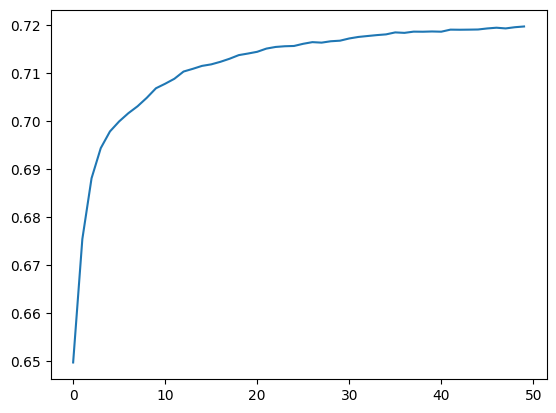

In [72]:
plt.plot(list(zip(*history.metrics_distributed['C-Index']))[1])
#plt.plot(list(zip(*history.metrics_centralized['C-Index']))[1])
print(history.metrics_distributed['C-Index'][-1])

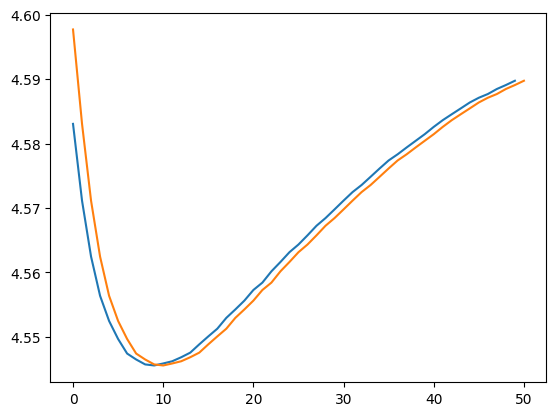

In [73]:
plt.plot(list(zip(*history.losses_distributed))[1])
plt.plot(list(zip(*history.losses_centralized))[1])

# Results

In [100]:
path = "scenario1/deep/10_epochs/trial4/"
model_fed = torch.load(path+'model')
model_centralized = torch.load(path+'centralized_model.pt')
print(path)

FileNotFoundError: [Errno 2] No such file or directory: 'scenario1/deep/10_epochs/trial4/model'

In [75]:
risks_test = []
CI_nodes_test = []
risks_train = []
CI_nodes_train = []

model_fed.eval()

r_tt = model_fed.predict_risk(realloader.dataset[:][0]).detach().numpy()
CI_tt = concordance_index_censored(realloader.dataset[:][1], 
                                   realloader.dataset[:][2],
                                   r_tt.ravel())[0]
    
for i in range(3):
    #r_tt = model_fed.predict_risk(vaalloaders[i].dataset[:][0]).detach().numpy()
    #CI_tt = concordance_index_censored(vaalloaders[i].dataset[:][1], 
    #                                   vaalloaders[i].dataset[:][2],
    #                                   r_tt.ravel())[0]
    
    r_tr = model_fed.predict_risk(completeloaders[i].dataset[:][0]).detach().numpy()
    CI_tr = concordance_index_censored(completeloaders[i].dataset[:][1], 
                                       completeloaders[i].dataset[:][2],
                                       r_tr.ravel())[0]
    
    risks_test.append(r_tt)
    CI_nodes_test.append(CI_tt)
    
    risks_train.append(r_tr)
    CI_nodes_train.append(CI_tr)

In [76]:
print(CI_nodes_train)
print(CI_nodes_test)

[0.7123919370895508, 0.7186322405897678, 0.7406210341316558]
[0.7196477089304896, 0.7196477089304896, 0.7196477089304896]


### Plots

In [101]:
#Load model
model_fed = torch.load(path+'model')
print(path)
model_fed

FileNotFoundError: [Errno 2] No such file or directory: 'scenario1/deep/10_epochs/trial4/model'

In [102]:
# Load centralized and isolated metrics results
path = "scenario1/deep/10_epochs/trial4/"

print(path)
with open(path+'metrics_centralized.pickle', 'rb') as f:
    metrics_centralized = pickle.load(f)

with open(path+'metrics_isolated.pickle', 'rb') as f:
    metrics_isolated = pickle.load(f)

scenario1/deep/10_epochs/trial4/


FileNotFoundError: [Errno 2] No such file or directory: 'scenario1/deep/10_epochs/trial4/metrics_centralized.pickle'

In [ ]:
client_metrics = {}
NUM_CLIENTS=3
for i in range(NUM_CLIENTS):
    client_metrics[i] = {}
    m = pd.read_csv(path+"metrics_clients{}_preaggr.txt".format(i), header=None)
    client_metrics[i]['loss_real'] = m[1]
    client_metrics[i]['cindex_real'] = m[2]

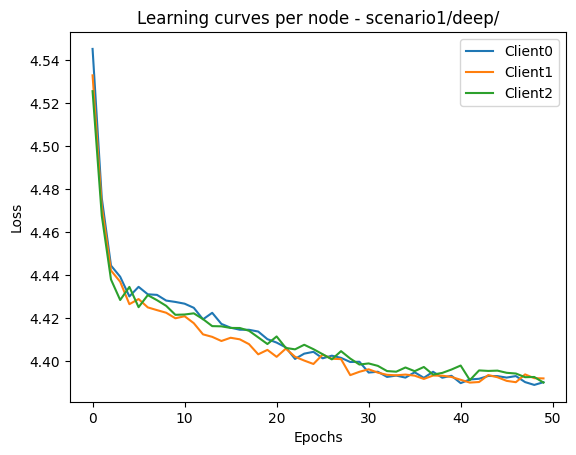

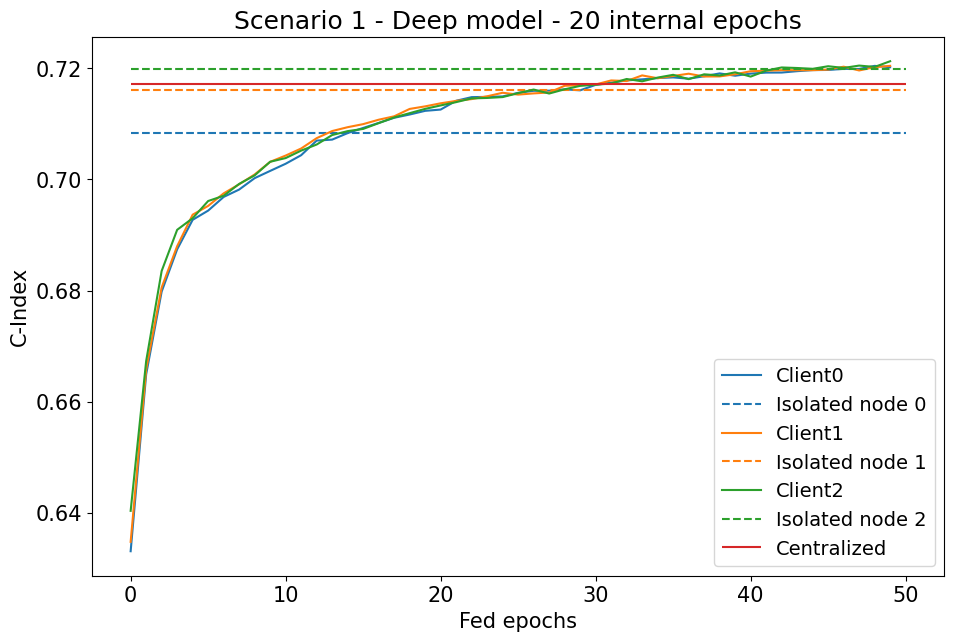

In [84]:
tab_colors = ['tab:blue', 'tab:orange', 'tab:green']
for i in range(NUM_CLIENTS):
    plt.plot(client_metrics[i]['loss_real'], label='Client{}'.format(i))
plt.legend()
plt.title('Learning curves per node - ' + path)
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig(path+"curves federated")
plt.show()


plt.figure(figsize=(11,7))
for i in range(NUM_CLIENTS):
    plt.plot(client_metrics[i]['cindex_real'], label='Client{}'.format(i))
    plt.hlines(metrics_isolated[i]['cindex_real'],0,50, colors=tab_colors[i], linestyles='dashed', label='Isolated node {}'.format(i))
plt.hlines(metrics_centralized['cindex_real'],0,50, colors='tab:red', label='Centralized')

plt.legend(loc='lower right', fontsize=14)
#plt.ylim(0.50,0.74)
plt.title("Scenario 1 - Deep model - 20 internal epochs", fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Fed epochs',  fontsize=15)
plt.ylabel('C-Index', fontsize=15)

plt.savefig(path+"c-index federated", bbox_inches='tight')
plt.show()

# Results final

In [24]:
# Load centralized and isolated metrics results
path = "scenario1/linear/"
isolated = {0:[], 1:[], 2:[]}
centralized = []

for k in range(5):
    with open(path+f'trial{k}/metrics_centralized.pickle', 'rb') as f:
        metrics_centralized = pickle.load(f)
    centralized.append(metrics_centralized['cindex_real'])

    with open(path+f'trial{k}/metrics_isolated.pickle', 'rb') as f:
        metrics_isolated = pickle.load(f)
    for c in range(3):
        isolated[c].append(metrics_isolated[c]['cindex_real'])

In [25]:
isolated_mean = [(np.mean(isolated[i]),np.std(isolated[i]) ) for i in range(3)]
centralized_mean = (np.mean(centralized), np.std(centralized))

In [32]:
e=10
client_metrics = {0:[], 1:[], 2:[]}
for k in range(5):
    for i in range(3):
        client_metrics[i].append(list(pd.read_csv(path+f"{e}_epochs/trial{k}/metrics_clients{i}_preaggr.txt",
                                             header=None)[2]))
        
client_means = {}
client_std = {}

for c in range(3):
    client_means[c] = np.array([np.mean(np.array(client_metrics[c])[:,i]) for i in range(100)])
    client_std[c] = np.array([np.std(np.array(client_metrics[c])[:,i]) for i in range(100)])

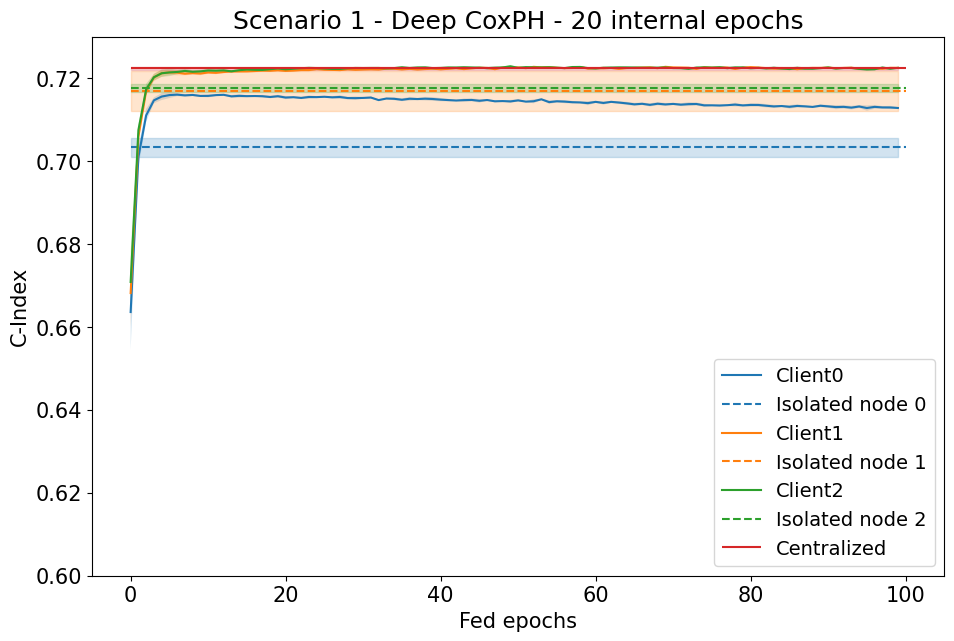

In [33]:
tab_colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(11,7))
for i in range(3):
    plt.plot(client_means[i], label=f'Client{i}')
    plt.fill_between(np.arange(100), client_means[i]+client_std[i], client_means[i]-client_std[i], alpha=0.2)
    
    plt.hlines(isolated_mean[i][0],0,100, colors=tab_colors[i], linestyles='dashed', label=f'Isolated node {i}')
    plt.fill_between(np.arange(100),isolated_mean[i][0]+isolated_mean[i][1], isolated_mean[i][0]-isolated_mean[i][1],
                     color=tab_colors[i], alpha=0.2)

plt.hlines(centralized_mean[0],0,100, colors='tab:red', label='Centralized')
plt.fill_between(np.arange(100),centralized_mean[0]+centralized_mean[1], centralized_mean[0]-centralized_mean[1],
                 color='tab:red', alpha=0.2)



plt.legend(loc='lower right', fontsize=14)
plt.ylim(0.60,0.73)
plt.title("Scenario 1 - Deep CoxPH - 20 internal epochs", fontsize=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel('Fed epochs',  fontsize=15)
plt.ylabel('C-Index', fontsize=15)

#plt.savefig(path+"20epochs c-index federated", bbox_inches='tight')
plt.show()